# 기본적인 라이브러리 

In [1]:
import numpy as np
import cupy as cp
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict

#xt=0 #기억을 위한 전역변수
#cp.cuda.Device(0).use()
cp.cuda.Device(1).use()

# 유틸 im2col col2im 및 데이터 로더 

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = cp.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = cp.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    #print(col)
    return col

In [3]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = cp.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - cp.max(x, axis=0)
        y = cp.exp(x) / cp.sum(cp.exp(x), axis=0)
        return y.T 

    x = x - cp.max(x) # 오버플로 대책
    return cp.exp(x) / cp.sum(cp.exp(x))


In [5]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    #print("t.reshape=> ", t)            
    #print("y.reshape=> ", y)            
    batch_size = y.shape[0]
    #print("batch_size = y.shape[0]=> ", batch_size)
    
    return -cp.sum(cp.log(y[cp.arange(batch_size), t])) / batch_size


In [6]:
#def data_loader():
#    train, test = tf.keras.datasets.mnist.load_data()
    
#    (x_train, y_train)= train
#    (x_test, y_test)= test
#    x_train = cp.expand_dims(x_train, axis=-1)
#    x_test = cp.expand_dims(x_test, axis=-1)
    
#    return x_train, y_train, x_test, y_test

In [7]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = cp.frombuffer(f.read(), cp.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = cp.frombuffer(f.read(), cp.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = cp.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(cp.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

# 레이어 테스트 

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [9]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = cp.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [10]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = cp.dot(self.x, self.W) + self.b
        
        #print(x.shape)
        #print("affine shape: {0}".format(out.shape))
        return out

    def backward(self, dout):
        dx = cp.dot(dout, self.W.T)
        self.dW = cp.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


In [11]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        #print("self.t.shape => ", self.t.shape)
        #print("self.t => ", self.t)
        self.y = softmax(x)
        #print("self.y.shape => ", self.y.shape)
        #print("self.y => ", self.y)
        self.loss = cross_entropy_error(self.y, self.t)
        #print("self.loss => ", self.loss)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[cp.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        #print("dx.shape => ", dx.shape)
        #print("SoftmaxWithLoss backward: dx => ", dx)
        return dx

In [12]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        #print("컨볼루션 순전파")
        FN, C, FH, FW = self.W.shape
        #print("FN, C, FH, FW =>",FN, C, FH, FW)
        
        N, C, H, W = x.shape
        #print("N, C, H, W =>",N, C, H, W)
        
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = cp.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W
        #print("self.x =>",self.x)
        #print("self.col =>",self.col)
        #print("self.col_W.shape =>",self.col_W.shape)
        #print("self.col_W =>",self.col_W)
        #print(out.shape)
        return out

    def backward(self, dout):
        #print("컨볼루션 역전파")
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = cp.sum(dout, axis=0)
        self.dW = cp.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = cp.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [13]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = cp.zeros(D)
            self.running_var = cp.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = cp.mean(xc**2, axis=0)
            std = cp.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((cp.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = cp.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -cp.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = cp.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


In [14]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        #print("풀링 순전파")
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = cp.argmax(col, axis=1)
        out = cp.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max
        #print(out.shape)
        return out

    def backward(self, dout):
        #print("풀링 역전파")
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = cp.zeros((dout.size, pool_size))
        dmax[cp.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# 최적화 함수 설정 

In [15]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]


class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#############################################################

# 학습 함수 설정 

In [16]:
class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, y_train, x_test, y_test,
                 epochs=150, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.001}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        #optimizer_class_dict = {'adam':Adam} adam 으로 하면 33번째에 W가 0이되어서 sgd로 변경함
        optimizer_class_dict = {'sgd':SGD}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        #self.train_acc_list = cp.array([])
        self.test_acc_list = []
        
    def train_step(self):
        
        batch_mask = cp.random.choice(self.train_size, self.batch_size)
        
        #print("batch_mask_cp:", batch_mask)
        #print("x_train.type=>", x_train)
        
        #batch_mask = np.random.choice(self.train_size, self.batch_size)
        #batch_mask = np.random.choice(self.train_size, self.batch_size)
        #print("batch_mask_np:", batch_mask)
        
        x_batch = self.x_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        
        grads = self.network.gradient(x_batch, y_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, y_batch)
        #self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, y_train_sample = self.x_train, self.y_train
            x_test_sample, y_test_sample = self.x_test, self.y_test
            
            #if not (20 is None) -> if not false -> true 즉 evaluate_sample_num_per_epoch 이 지정되어 있으면  
            if not self.evaluate_sample_num_per_epoch is None: 
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, y_train_sample = self.x_train[:t], self.y_train[:t]
                x_test_sample, y_test_sample = self.x_test[:t], self.y_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, y_train_sample)
            #print("train_acc:", train_acc)
            
            test_acc = self.network.accuracy(x_test_sample, y_test_sample)
            #print("test_acc:", test_acc)
            
            
            self.train_loss_list.append(loss) #loss값을 epoch 마다 한번씩만 기록
            #print("self.train_loss_list:", self.train_loss_list)
            self.train_acc_list.append(train_acc)
            #print("self.train_acc_list:", self.train_acc_list)
            self.test_acc_list.append(test_acc)
            #print("self.test_acc_list:", self.test_acc_list)
            
            
            if self.verbose: 
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc)+", test acc:"+str(test_acc)+" ===")
        self.current_iter += 1

    def train(self):
        for i in tqdm(range(self.max_iter)):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.y_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

# 레이어 구성 

In [17]:
class test_net:
    def __init__(self, input_dim=(3, 227, 227),
                 conv_param_1 = {'filter_num':96, 'filter_size':11, 'pad':0, 'stride':4}, #'pad':0,
                 conv_param_2 = {'filter_num':256, 'filter_size':5, 'pad':2, 'stride':1},
                 conv_param_3 = {'filter_num':384, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':384, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_5 = {'filter_num':256, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=4096, output_size=100):
        
        #pre_node_nums = cp.array([3*11*11, 96*11*11, 256*5*5, 384*3*3, 384*3*3, 256*2*2, hidden_size, hidden_size])
        pre_node_nums = cp.array([3*11*11, 96*5*5, 256*3*3, 384*3*3, 384*3*3, 256*6*6, hidden_size, hidden_size])
        wight_init_scales = cp.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
               
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * cp.random.randn(conv_param['filter_num'], 
                                            pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = cp.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
                
        
        #self.params['W6'] = wight_init_scales[5] * cp.random.randn(256*2*2, hidden_size) #hidden_size 4096
        self.params['W6'] = wight_init_scales[5] * cp.random.randn(256*6*6, hidden_size)
        self.params['b6'] = cp.zeros(hidden_size)
        
        self.params['W7'] = wight_init_scales[6] * cp.random.randn(hidden_size, hidden_size)
        self.params['b7'] = cp.zeros(hidden_size)
    
        self.params['W8'] = wight_init_scales[7] * cp.random.randn(hidden_size, output_size)
        self.params['b8'] = cp.zeros(output_size)
        
        
        ########################################################
        #self.layers = []
        # 계층 생성
        self.layers = OrderedDict()
        #0 첫번째 layer
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], 
                                   conv_param_1['stride'], conv_param_1['pad'])
        #self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
        #                   conv_param_1['stride'], conv_param_1['pad']))
        #1 활성화 함수를 적용하기 전에 Normalization 
        self.layers['Batn1'] = BatchNormalization(1.0,0.0)
        #self.layers.append(BatchNormalization(1.0,0.0)) 
        
        #2
        self.layers['Relu1'] = Relu()
        #self.layers.append(Relu())
        
        #3
        self.layers['Pool1'] = Pooling(pool_h=3, pool_w=3, stride=2)
        #self.layers.append(Pooling(pool_h=3, pool_w=3, stride=2))
        
        #4 두번째 layer
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'], 
                                   conv_param_2['stride'], conv_param_2['pad'])
        #self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
        #                   conv_param_2['stride'], conv_param_2['pad']))
        #5
        self.layers['Batn2'] = BatchNormalization(1.0,0.0)
        #self.layers.append(BatchNormalization(1.0,0.0))
        
        #6
        self.layers['Relu2'] = Relu()
        #self.layers.append(Relu())
        
        #7
        self.layers['Pool2'] = Pooling(pool_h=3, pool_w=3, stride=2)
        #self.layers.append(Pooling(pool_h=3, pool_w=3, stride=2))
        
        #8 세번째 layer
        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'], 
                                   conv_param_3['stride'], conv_param_3['pad'])
        #self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
        #                   conv_param_3['stride'], conv_param_3['pad']))
        #9
        self.layers['Relu3'] = Relu()
        #self.layers.append(Relu())
        
        #10 네번째 layer
        self.layers['Conv4'] = Convolution(self.params['W4'], self.params['b4'],
                                   conv_param_4['stride'], conv_param_4['pad'])
        #self.layers.append(Convolution(self.params['W4'], self.params['b4'],
        #                   conv_param_4['stride'], conv_param_4['pad']))
        #11
        self.layers['Relu4'] = Relu()
        #self.layers.append(Relu())

        #12 다섯번째 layer
        self.layers['Conv5'] = Convolution(self.params['W5'], self.params['b5'],
                                   conv_param_5['stride'], conv_param_5['pad'])
        #self.layers.append(Convolution(self.params['W5'], self.params['b5'],
        #                       conv_param_5['stride'], conv_param_5['pad']))
        #13
        self.layers['Relu5'] = Relu()
        #self.layers.append(Relu())
        
        #14
        self.layers['Pool5'] = Pooling(pool_h=3, pool_w=3, stride=2)
        #self.layers.append(Pooling(pool_h=3, pool_w=3, stride=2))
        
        #15 여섯번째 layer
        self.layers['Affine6'] = Affine(self.params['W6'], self.params['b6'])
        #self.layers.append(Affine(self.params['W6'], self.params['b6']))
        
        #16
        self.layers['Relu6'] = Relu()
        #self.layers.append(Relu())
        
        #17
        self.layers['Drop6'] = Dropout(0.5)
        #self.layers.append(Dropout(0.5))
                
        #18 일곱번째 layer
        self.layers['Affine7'] = Affine(self.params['W7'], self.params['b7'])
        #self.layers.append(Affine(self.params['W7'], self.params['b7']))
        
        #19
        self.layers['Relu7'] = Relu()
        #self.layers.append(Relu())
        
        #20
        self.layers['Drop7'] = Dropout(0.5)
        #self.layers.append(Dropout(0.5))
                
        #21 여덟번째 layer
        self.layers['Affine8'] = Affine(self.params['W8'], self.params['b8'])
        #self.layers.append(Affine(self.params['W8'], self.params['b8']))
                
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x, train_flg=False):
        #for layer in self.layers:
        for layer in self.layers.values():
            
            '''
            if layer == self.layers['Conv1']:
                print("layer forward Conv1 =>")    
            
            if layer == self.layers['Affine8']:
                print("layer forward Affine8 =>")    
            '''
            
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = cp.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = cp.argmax(y, axis=1)
            acc += cp.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        #tmp_layers = self.layers.copy()
        #tmp_layers.reverse()
        #for layer in tmp_layers:
        #    dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        #for i, layer_idx in enumerate((0, 3, 7, 9, 12,15,18,21)):
        #for i, layer_idx in enumerate((0, 4, 8, 10, 12, 15, 18, 21)):
        #    grads['W' + str(i+1)] = self.layers[layer_idx].dW
        #    grads['b' + str(i+1)] = self.layers[layer_idx].db
        
            
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W4'], grads['b4'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['W5'], grads['b5'] = self.layers['Conv5'].dW, self.layers['Conv5'].db
        grads['W6'], grads['b6'] = self.layers['Affine6'].dW, self.layers['Affine6'].db
        grads['W7'], grads['b7'] = self.layers['Affine7'].dW, self.layers['Affine7'].db
        grads['W8'], grads['b8'] = self.layers['Affine8'].dW, self.layers['Affine8'].db
                
        #if grads['W' + str(i+1)] == grads['W1']:
        #if 'W' + str(i+1) == 'W1':
        #print("grads['W1'] => ", grads['W1'])
        
        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
            
        for key, val in params.items():
            self.params[key] = val
        
        #for i, layer_idx in enumerate((0, 3, 7, 9, 12,15,18,21)):
        #for i, layer_idx in enumerate((0, 4, 8, 10, 12, 15, 18, 21)):
        for i, layer_idx in enumerate(['Conv1','Conv2','Conv3','Conv4','Conv5','Affine6','Affine7','Affine8']):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]


        ##########################################################
        


# 학습 데이터 로드 

In [18]:

#pickle_in1 = open("face227_x_features_step1.pkl","rb")
#x_train = pickle.load(pickle_in1)
#x_train = cp.load('face227_x_features_step1.pkl',mmap_mode = 'r+',allow_pickle = 'true')
x_train = cp.load('pw_face_images_train_227_227_x_features.pkl',mmap_mode = 'r+',allow_pickle = 'true')

#pickle_in2 = open("face227_y_label_step1.pkl","rb")
#t_train = pickle.load(pickle_in2)
y_train = cp.load('pw_face_images_train_227_227_y_label.pkl',mmap_mode = 'r+',allow_pickle = 'true')
#pickle_in3 = open("face227_x_features_step11.pkl","rb")
#x_test = pickle.load(pickle_in3)
x_test = cp.load('pw_face_images_test_227_227_x_features.pkl',mmap_mode = 'r+',allow_pickle = 'true')

#pickle_in4 = open("face227_y_label_step11.pkl","rb")
#t_test = pickle.load(pickle_in4)
y_test = cp.load('pw_face_images_test_227_227_y_label.pkl',mmap_mode = 'r+',allow_pickle = 'true')

#t_1_str="9"
#t_str="S_Side_C"

In [19]:
#t_train = t_train.astype(cp.int32)
#t_test = t_test.astype(cp.int32)

In [20]:
print(y_test.shape)
print(y_train.shape)

(500,)
(3000,)


# 학습 시작

In [21]:
network = test_net()
#network = DeepConvNet()
print(x_train.shape)
print(network.params['W1'].shape)
#print("처음 W2값 => ", network.params['W2'])
print(network.params['W2'].shape)
print(network.params['W3'].shape)
print(network.params['W4'].shape)
print(network.params['W5'].shape)
print(network.params['W6'].shape)
print(network.params['W7'].shape)
print(network.params['W8'].shape)

# 저장된 매개변수 사용
#network.load_params("params_simpleCNN_epoch300730.pkl")#original MNIST training, epoch 30
#network.load_params("alex_net_numpy_550_step"+t_1_str+"_GPU_5sgd_100.pkl") # step1~10
#print("loaded Network Parameters!")

#2곳수정 epochs=100, 
#3곳수정 mini_batch_size=100

trainer = Trainer(network, x_train, y_train, x_test, y_test,
                epochs=500, mini_batch_size=100, optimizer='SGD',optimizer_param={'lr':0.001} #optimizer_param={'lr':0.001}
                )

trainer.train()

#network.save_params("alex_net_numpy_550_step"+t_str+"_GPU_5sgd_100.pkl")
#network.save_params("alex_net_numpy_550_step"+t_str+"_GPU_5sgd_nouseparam_2.pkl")
network.save_params("alex_net_numpy_pw_face_images_train_227_227_GPU_sgd.pkl")
#network.save_params("alex_net_numpy_227_step1_GPU_5.pkl")
print("saved")



(3000, 3, 227, 227)
(96, 3, 11, 11)
(256, 96, 5, 5)
(384, 256, 3, 3)
(384, 384, 3, 3)
(256, 384, 3, 3)
(9216, 4096)
(4096, 4096)
(4096, 100)


  0%|                                                                                        | 0/15000 [00:00<?, ?it/s]

train loss:4.988105031468849


  0%|                                                                             | 1/15000 [00:21<89:25:21, 21.46s/it]

=== epoch:1, train acc:0.018, test acc:0.014 ===


  0%|                                                                             | 2/15000 [00:23<41:56:37, 10.07s/it]

train loss:4.972533912402955


  0%|                                                                             | 3/15000 [00:25<26:45:54,  6.42s/it]

train loss:4.859502008378701


  0%|                                                                             | 4/15000 [00:27<19:37:36,  4.71s/it]

train loss:4.964987432352398


  0%|                                                                             | 5/15000 [00:29<15:41:36,  3.77s/it]

train loss:4.938037977659294


  0%|                                                                             | 6/15000 [00:31<13:19:14,  3.20s/it]

train loss:4.965536968602688


  0%|                                                                             | 7/15000 [00:34<11:48:20,  2.83s/it]

train loss:4.932171766938541


  0%|                                                                             | 8/15000 [00:36<10:49:49,  2.60s/it]

train loss:4.936704345334313


  0%|                                                                             | 9/15000 [00:38<10:10:42,  2.44s/it]

train loss:4.9085673129766905


  0%|                                                                             | 10/15000 [00:40<9:44:36,  2.34s/it]

train loss:4.772793963525604


  0%|                                                                             | 11/15000 [00:42<9:26:35,  2.27s/it]

train loss:4.9168563270050845


  0%|                                                                             | 12/15000 [00:44<9:14:24,  2.22s/it]

train loss:4.971713743766219


  0%|                                                                             | 13/15000 [00:46<9:05:27,  2.18s/it]

train loss:4.712240147110698


  0%|                                                                             | 14/15000 [00:48<8:59:50,  2.16s/it]

train loss:4.873681891437078


  0%|                                                                             | 15/15000 [00:50<8:55:02,  2.14s/it]

train loss:4.820265610272692


  0%|                                                                             | 16/15000 [00:52<8:52:32,  2.13s/it]

train loss:4.865065487052324


  0%|                                                                             | 17/15000 [00:55<8:50:53,  2.13s/it]

train loss:4.860105839642174


  0%|                                                                             | 18/15000 [00:57<8:49:10,  2.12s/it]

train loss:4.8598779881471295


  0%|                                                                             | 19/15000 [00:59<8:48:03,  2.11s/it]

train loss:4.864658389574795


  0%|                                                                             | 20/15000 [01:01<8:47:36,  2.11s/it]

train loss:4.779908900061598


  0%|                                                                             | 21/15000 [01:03<8:46:44,  2.11s/it]

train loss:4.788347898822865


  0%|                                                                             | 22/15000 [01:05<8:46:10,  2.11s/it]

train loss:4.814363523984399


  0%|                                                                             | 23/15000 [01:07<8:45:40,  2.11s/it]

train loss:4.797678610698116


  0%|                                                                             | 24/15000 [01:09<8:45:59,  2.11s/it]

train loss:4.856281551755121


  0%|▏                                                                            | 25/15000 [01:11<8:45:41,  2.11s/it]

train loss:4.679937869100463


  0%|▏                                                                            | 26/15000 [01:13<8:45:31,  2.11s/it]

train loss:4.753169700254221


  0%|▏                                                                            | 27/15000 [01:16<8:45:25,  2.11s/it]

train loss:4.652347074128247


  0%|▏                                                                            | 28/15000 [01:18<8:44:51,  2.10s/it]

train loss:4.752445895104686


  0%|▏                                                                            | 29/15000 [01:20<8:44:44,  2.10s/it]

train loss:4.7545242528607385


  0%|▏                                                                            | 30/15000 [01:22<8:45:22,  2.11s/it]

train loss:4.781335817537951
train loss:4.794304395413112


  0%|▏                                                                           | 31/15000 [01:43<32:29:03,  7.81s/it]

=== epoch:2, train acc:0.03, test acc:0.016 ===


  0%|▏                                                                           | 32/15000 [01:45<25:22:44,  6.10s/it]

train loss:4.7195021581131575


  0%|▏                                                                           | 33/15000 [01:47<20:24:01,  4.91s/it]

train loss:4.693916759311959


  0%|▏                                                                           | 34/15000 [01:49<16:55:47,  4.07s/it]

train loss:4.778284807513238


  0%|▏                                                                           | 35/15000 [01:52<14:29:07,  3.48s/it]

train loss:4.821485545093004


  0%|▏                                                                           | 36/15000 [01:54<12:46:50,  3.07s/it]

train loss:4.710891881323844


  0%|▏                                                                           | 37/15000 [01:56<11:35:15,  2.79s/it]

train loss:4.71533397834287


  0%|▏                                                                           | 38/15000 [01:58<10:44:58,  2.59s/it]

train loss:4.758227380028184


  0%|▏                                                                           | 39/15000 [02:00<10:10:21,  2.45s/it]

train loss:4.704052906285912


  0%|▏                                                                            | 40/15000 [02:02<9:47:00,  2.35s/it]

train loss:4.739432999793922


  0%|▏                                                                            | 41/15000 [02:04<9:30:21,  2.29s/it]

train loss:4.665297111555886


  0%|▏                                                                            | 42/15000 [02:06<9:18:21,  2.24s/it]

train loss:4.744619151728733


  0%|▏                                                                            | 43/15000 [02:09<9:10:25,  2.21s/it]

train loss:4.6300677463007425


  0%|▏                                                                            | 44/15000 [02:11<9:04:28,  2.18s/it]

train loss:4.6434705948879476


  0%|▏                                                                            | 45/15000 [02:13<9:00:20,  2.17s/it]

train loss:4.798588415568957


  0%|▏                                                                            | 46/15000 [02:15<8:58:07,  2.16s/it]

train loss:4.595163167387449


  0%|▏                                                                            | 47/15000 [02:17<8:56:03,  2.15s/it]

train loss:4.697607948414364


  0%|▏                                                                            | 48/15000 [02:19<8:54:37,  2.15s/it]

train loss:4.673437775666525


  0%|▎                                                                            | 49/15000 [02:21<8:53:18,  2.14s/it]

train loss:4.612938412689152


  0%|▎                                                                            | 50/15000 [02:23<8:52:56,  2.14s/it]

train loss:4.742030100817857


  0%|▎                                                                            | 51/15000 [02:26<8:52:20,  2.14s/it]

train loss:4.6766740075304885


  0%|▎                                                                            | 52/15000 [02:28<8:51:40,  2.13s/it]

train loss:4.765975391999271


  0%|▎                                                                            | 53/15000 [02:30<8:51:24,  2.13s/it]

train loss:4.585570101522373


  0%|▎                                                                            | 54/15000 [02:32<8:51:39,  2.13s/it]

train loss:4.712410693652987


  0%|▎                                                                            | 55/15000 [02:34<8:51:05,  2.13s/it]

train loss:4.694640077353153


  0%|▎                                                                            | 56/15000 [02:36<8:50:54,  2.13s/it]

train loss:4.629440368504214


  0%|▎                                                                            | 57/15000 [02:38<8:51:10,  2.13s/it]

train loss:4.72171526559997


  0%|▎                                                                            | 58/15000 [02:40<8:50:48,  2.13s/it]

train loss:4.72337362034715


  0%|▎                                                                            | 59/15000 [02:43<8:51:18,  2.13s/it]

train loss:4.632203830324508


  0%|▎                                                                            | 60/15000 [02:45<8:51:01,  2.13s/it]

train loss:4.735043059416126
train loss:4.617845425346895


  0%|▎                                                                           | 61/15000 [03:06<32:41:56,  7.88s/it]

=== epoch:3, train acc:0.03966666666666667, test acc:0.036 ===


  0%|▎                                                                           | 62/15000 [03:08<25:33:30,  6.16s/it]

train loss:4.657201969687003


  0%|▎                                                                           | 63/15000 [03:10<20:33:53,  4.96s/it]

train loss:4.667733677604742


  0%|▎                                                                           | 64/15000 [03:12<17:04:00,  4.11s/it]

train loss:4.66704554625125


  0%|▎                                                                           | 65/15000 [03:15<14:36:46,  3.52s/it]

train loss:4.606178634823775


  0%|▎                                                                           | 66/15000 [03:17<12:53:55,  3.11s/it]

train loss:4.738253535032925


  0%|▎                                                                           | 67/15000 [03:19<11:42:02,  2.82s/it]

train loss:4.796593739033559


  0%|▎                                                                           | 68/15000 [03:21<10:51:54,  2.62s/it]

train loss:4.667502766886409


  0%|▎                                                                           | 69/15000 [03:23<10:16:28,  2.48s/it]

train loss:4.598522460742121


  0%|▎                                                                            | 70/15000 [03:25<9:51:38,  2.38s/it]

train loss:4.718667845770756


  0%|▎                                                                            | 71/15000 [03:28<9:34:37,  2.31s/it]

train loss:4.601177954167867


  0%|▎                                                                            | 72/15000 [03:30<9:22:27,  2.26s/it]

train loss:4.708389841424381


  0%|▎                                                                            | 73/15000 [03:32<9:13:45,  2.23s/it]

train loss:4.749183601365912


  0%|▍                                                                            | 74/15000 [03:34<9:07:54,  2.20s/it]

train loss:4.565213466858458


  0%|▍                                                                            | 75/15000 [03:36<9:03:39,  2.19s/it]

train loss:4.591047262540801


  1%|▍                                                                            | 76/15000 [03:38<9:00:30,  2.17s/it]

train loss:4.652512252337491


  1%|▍                                                                            | 77/15000 [03:40<8:58:45,  2.17s/it]

train loss:4.576311245877896


  1%|▍                                                                            | 78/15000 [03:43<8:57:16,  2.16s/it]

train loss:4.680622162076727


  1%|▍                                                                            | 79/15000 [03:45<8:55:57,  2.16s/it]

train loss:4.678737968350929


  1%|▍                                                                            | 80/15000 [03:47<8:55:09,  2.15s/it]

train loss:4.572129164371071


  1%|▍                                                                            | 81/15000 [03:49<8:54:49,  2.15s/it]

train loss:4.693647453439997


  1%|▍                                                                            | 82/15000 [03:51<8:54:52,  2.15s/it]

train loss:4.578923825686202


  1%|▍                                                                            | 83/15000 [03:53<8:54:00,  2.15s/it]

train loss:4.576540294696742


  1%|▍                                                                            | 84/15000 [03:55<8:54:19,  2.15s/it]

train loss:4.611463953033487


  1%|▍                                                                            | 85/15000 [03:58<8:53:41,  2.15s/it]

train loss:4.74664243232295


  1%|▍                                                                            | 86/15000 [04:00<8:53:49,  2.15s/it]

train loss:4.544722980593027


  1%|▍                                                                            | 87/15000 [04:02<8:53:49,  2.15s/it]

train loss:4.594655049955739


  1%|▍                                                                            | 88/15000 [04:04<8:53:31,  2.15s/it]

train loss:4.635330965464061


  1%|▍                                                                            | 89/15000 [04:06<8:53:30,  2.15s/it]

train loss:4.646540657818775


  1%|▍                                                                            | 90/15000 [04:08<8:53:36,  2.15s/it]

train loss:4.707187958336638
train loss:4.7329838448889126


  1%|▍                                                                           | 91/15000 [04:30<32:51:14,  7.93s/it]

=== epoch:4, train acc:0.04833333333333333, test acc:0.032 ===


  1%|▍                                                                           | 92/15000 [04:32<25:39:49,  6.20s/it]

train loss:4.569182623760621


  1%|▍                                                                           | 93/15000 [04:34<20:37:18,  4.98s/it]

train loss:4.500954132791016


  1%|▍                                                                           | 94/15000 [04:36<17:06:22,  4.13s/it]

train loss:4.625787223968323


  1%|▍                                                                           | 95/15000 [04:38<14:38:16,  3.54s/it]

train loss:4.5990026095226515


  1%|▍                                                                           | 96/15000 [04:40<12:54:45,  3.12s/it]

train loss:4.600558039612463


  1%|▍                                                                           | 97/15000 [04:43<11:42:02,  2.83s/it]

train loss:4.6177686559027045


  1%|▍                                                                           | 98/15000 [04:45<10:51:31,  2.62s/it]

train loss:4.639497553754079


  1%|▌                                                                           | 99/15000 [04:47<10:15:54,  2.48s/it]

train loss:4.60547266669759


  1%|▌                                                                           | 100/15000 [04:49<9:51:15,  2.38s/it]

train loss:4.531868281203683


  1%|▌                                                                           | 101/15000 [04:51<9:33:21,  2.31s/it]

train loss:4.60015868293125


  1%|▌                                                                           | 102/15000 [04:53<9:21:16,  2.26s/it]

train loss:4.62746683746138


  1%|▌                                                                           | 103/15000 [04:55<9:13:17,  2.23s/it]

train loss:4.635874499893817


  1%|▌                                                                           | 104/15000 [04:58<9:07:00,  2.20s/it]

train loss:4.641620943001012


  1%|▌                                                                           | 105/15000 [05:00<9:02:42,  2.19s/it]

train loss:4.556061032952884


  1%|▌                                                                           | 106/15000 [05:02<8:59:49,  2.17s/it]

train loss:4.653190020113397


  1%|▌                                                                           | 107/15000 [05:04<8:57:44,  2.17s/it]

train loss:4.560751469528478


  1%|▌                                                                           | 108/15000 [05:06<8:56:06,  2.16s/it]

train loss:4.5613298400352456


  1%|▌                                                                           | 109/15000 [05:08<8:54:54,  2.16s/it]

train loss:4.602283894954631


  1%|▌                                                                           | 110/15000 [05:11<8:54:09,  2.15s/it]

train loss:4.59481707605044


  1%|▌                                                                           | 111/15000 [05:13<8:53:38,  2.15s/it]

train loss:4.526556166248237


  1%|▌                                                                           | 112/15000 [05:15<8:53:31,  2.15s/it]

train loss:4.5838559627459015


  1%|▌                                                                           | 113/15000 [05:17<8:53:09,  2.15s/it]

train loss:4.599200459747084


  1%|▌                                                                           | 114/15000 [05:19<8:52:56,  2.15s/it]

train loss:4.5850020299555645


  1%|▌                                                                           | 115/15000 [05:21<8:53:00,  2.15s/it]

train loss:4.554788772799941


  1%|▌                                                                           | 116/15000 [05:23<8:52:44,  2.15s/it]

train loss:4.567780872213956


  1%|▌                                                                           | 117/15000 [05:26<8:52:45,  2.15s/it]

train loss:4.626817758854735


  1%|▌                                                                           | 118/15000 [05:28<8:52:08,  2.15s/it]

train loss:4.655786921641636


  1%|▌                                                                           | 119/15000 [05:30<8:52:11,  2.15s/it]

train loss:4.522939013777481


  1%|▌                                                                           | 120/15000 [05:32<8:52:25,  2.15s/it]

train loss:4.525845154380239
train loss:4.54156297980243


  1%|▌                                                                          | 121/15000 [05:53<32:47:28,  7.93s/it]

=== epoch:5, train acc:0.049666666666666665, test acc:0.052 ===


  1%|▌                                                                          | 122/15000 [05:56<25:36:49,  6.20s/it]

train loss:4.629726140186706


  1%|▌                                                                          | 123/15000 [05:58<20:35:28,  4.98s/it]

train loss:4.589046778075571


  1%|▌                                                                          | 124/15000 [06:00<17:04:07,  4.13s/it]

train loss:4.592937634410149


  1%|▋                                                                          | 125/15000 [06:02<14:36:52,  3.54s/it]

train loss:4.5178888597478


  1%|▋                                                                          | 126/15000 [06:04<12:53:23,  3.12s/it]

train loss:4.566148912190815


  1%|▋                                                                          | 127/15000 [06:06<11:40:56,  2.83s/it]

train loss:4.5981849242941895


  1%|▋                                                                          | 128/15000 [06:08<10:49:41,  2.62s/it]

train loss:4.56532049632812


  1%|▋                                                                          | 129/15000 [06:11<10:14:42,  2.48s/it]

train loss:4.632296246815929


  1%|▋                                                                           | 130/15000 [06:13<9:50:04,  2.38s/it]

train loss:4.618740705612705


  1%|▋                                                                           | 131/15000 [06:15<9:32:17,  2.31s/it]

train loss:4.580459859306877


  1%|▋                                                                           | 132/15000 [06:17<9:20:24,  2.26s/it]

train loss:4.611677620622844


  1%|▋                                                                           | 133/15000 [06:19<9:11:57,  2.23s/it]

train loss:4.516164883825015


  1%|▋                                                                           | 134/15000 [06:21<9:05:38,  2.20s/it]

train loss:4.623025605378178


  1%|▋                                                                           | 135/15000 [06:23<9:01:19,  2.18s/it]

train loss:4.587359707541561


  1%|▋                                                                           | 136/15000 [06:26<8:58:50,  2.18s/it]

train loss:4.604049310819324


  1%|▋                                                                           | 137/15000 [06:28<8:56:24,  2.17s/it]

train loss:4.6320098358295985


  1%|▋                                                                           | 138/15000 [06:30<8:55:12,  2.16s/it]

train loss:4.524424460676164


  1%|▋                                                                           | 139/15000 [06:32<8:54:09,  2.16s/it]

train loss:4.593079023722671


  1%|▋                                                                           | 140/15000 [06:34<8:53:31,  2.15s/it]

train loss:4.505370242463145


  1%|▋                                                                           | 141/15000 [06:36<8:52:47,  2.15s/it]

train loss:4.601271955001687


  1%|▋                                                                           | 142/15000 [06:39<8:52:10,  2.15s/it]

train loss:4.586545103091388


  1%|▋                                                                           | 143/15000 [06:41<8:51:58,  2.15s/it]

train loss:4.473808434545141


  1%|▋                                                                           | 144/15000 [06:43<8:51:40,  2.15s/it]

train loss:4.558597456310236


  1%|▋                                                                           | 145/15000 [06:45<8:51:32,  2.15s/it]

train loss:4.577094723429252


  1%|▋                                                                           | 146/15000 [06:47<8:51:51,  2.15s/it]

train loss:4.533662804176425


  1%|▋                                                                           | 147/15000 [06:49<8:51:36,  2.15s/it]

train loss:4.582092133094281


  1%|▋                                                                           | 148/15000 [06:51<8:51:33,  2.15s/it]

train loss:4.537158464018127


  1%|▊                                                                           | 149/15000 [06:54<8:51:37,  2.15s/it]

train loss:4.562589371124496


  1%|▊                                                                           | 150/15000 [06:56<8:51:19,  2.15s/it]

train loss:4.536597133520785
train loss:4.622142216412587


  1%|▊                                                                          | 151/15000 [07:17<32:47:44,  7.95s/it]

=== epoch:6, train acc:0.05333333333333334, test acc:0.054 ===


  1%|▊                                                                          | 152/15000 [07:19<25:37:37,  6.21s/it]

train loss:4.58883858113735


  1%|▊                                                                          | 153/15000 [07:21<20:37:07,  5.00s/it]

train loss:4.647411323002512


  1%|▊                                                                          | 154/15000 [07:24<17:06:27,  4.15s/it]

train loss:4.5669574856650215


  1%|▊                                                                          | 155/15000 [07:26<14:38:24,  3.55s/it]

train loss:4.574609734617668


  1%|▊                                                                          | 156/15000 [07:28<12:55:30,  3.13s/it]

train loss:4.547263048201028


  1%|▊                                                                          | 157/15000 [07:30<11:42:52,  2.84s/it]

train loss:4.546900005655183


  1%|▊                                                                          | 158/15000 [07:32<10:52:43,  2.64s/it]

train loss:4.587912306048524


  1%|▊                                                                          | 159/15000 [07:34<10:17:27,  2.50s/it]

train loss:4.575367525914177


  1%|▊                                                                           | 160/15000 [07:37<9:52:33,  2.40s/it]

train loss:4.527341399361783


  1%|▊                                                                           | 161/15000 [07:39<9:35:05,  2.33s/it]

train loss:4.522972514306247


  1%|▊                                                                           | 162/15000 [07:41<9:22:35,  2.27s/it]

train loss:4.613400656275607


  1%|▊                                                                           | 163/15000 [07:43<9:13:58,  2.24s/it]

train loss:4.46880795601451


  1%|▊                                                                           | 164/15000 [07:45<9:08:13,  2.22s/it]

train loss:4.486558307351924


  1%|▊                                                                           | 165/15000 [07:47<9:04:06,  2.20s/it]

train loss:4.559209727734896


  1%|▊                                                                           | 166/15000 [07:50<9:01:23,  2.19s/it]

train loss:4.55803883698311


  1%|▊                                                                           | 167/15000 [07:52<8:59:06,  2.18s/it]

train loss:4.4901176371575575


  1%|▊                                                                           | 168/15000 [07:54<8:57:42,  2.18s/it]

train loss:4.619134002539045


  1%|▊                                                                           | 169/15000 [07:56<8:56:34,  2.17s/it]

train loss:4.5041489464797975


  1%|▊                                                                           | 170/15000 [07:58<8:55:36,  2.17s/it]

train loss:4.527455392808972


  1%|▊                                                                           | 171/15000 [08:00<8:55:23,  2.17s/it]

train loss:4.57150414503282


  1%|▊                                                                           | 172/15000 [08:03<8:54:57,  2.16s/it]

train loss:4.506411257739982


  1%|▉                                                                           | 173/15000 [08:05<8:54:38,  2.16s/it]

train loss:4.516790419197998


  1%|▉                                                                           | 174/15000 [08:07<8:54:53,  2.16s/it]

train loss:4.651163116632652


  1%|▉                                                                           | 175/15000 [08:09<8:54:36,  2.16s/it]

train loss:4.5827029470279355


  1%|▉                                                                           | 176/15000 [08:11<8:54:13,  2.16s/it]

train loss:4.54976463879341


  1%|▉                                                                           | 177/15000 [08:13<8:53:57,  2.16s/it]

train loss:4.627691539572505


  1%|▉                                                                           | 178/15000 [08:16<8:54:14,  2.16s/it]

train loss:4.561684744419463


  1%|▉                                                                           | 179/15000 [08:18<8:53:49,  2.16s/it]

train loss:4.52946699682561


  1%|▉                                                                           | 180/15000 [08:20<8:54:04,  2.16s/it]

train loss:4.537492050190297
train loss:4.385832446608784


  1%|▉                                                                          | 181/15000 [08:41<32:52:49,  7.99s/it]

=== epoch:7, train acc:0.057666666666666665, test acc:0.048 ===


  1%|▉                                                                          | 182/15000 [08:44<25:41:15,  6.24s/it]

train loss:4.568324589657388


  1%|▉                                                                          | 183/15000 [08:46<20:38:56,  5.02s/it]

train loss:4.572035386985202


  1%|▉                                                                          | 184/15000 [08:48<17:06:55,  4.16s/it]

train loss:4.448525546022626


  1%|▉                                                                          | 185/15000 [08:50<14:39:01,  3.56s/it]

train loss:4.475482008040594


  1%|▉                                                                          | 186/15000 [08:52<12:55:29,  3.14s/it]

train loss:4.521999940613881


  1%|▉                                                                          | 187/15000 [08:54<11:42:31,  2.85s/it]

train loss:4.543359913834795


  1%|▉                                                                          | 188/15000 [08:57<10:52:20,  2.64s/it]

train loss:4.54216789328747


  1%|▉                                                                          | 189/15000 [08:59<10:16:44,  2.50s/it]

train loss:4.5032615506317075


  1%|▉                                                                           | 190/15000 [09:01<9:51:29,  2.40s/it]

train loss:4.490543727156239


  1%|▉                                                                           | 191/15000 [09:03<9:34:19,  2.33s/it]

train loss:4.56929641671087


  1%|▉                                                                           | 192/15000 [09:05<9:22:00,  2.28s/it]

train loss:4.449032561441616


  1%|▉                                                                           | 193/15000 [09:07<9:13:11,  2.24s/it]

train loss:4.485258207100651


  1%|▉                                                                           | 194/15000 [09:10<9:07:22,  2.22s/it]

train loss:4.48801097090215


  1%|▉                                                                           | 195/15000 [09:12<9:03:16,  2.20s/it]

train loss:4.574934488590005


  1%|▉                                                                           | 196/15000 [09:14<8:59:47,  2.19s/it]

train loss:4.562778604691065


  1%|▉                                                                           | 197/15000 [09:16<8:57:59,  2.18s/it]

train loss:4.532950222055936


  1%|█                                                                           | 198/15000 [09:18<8:56:12,  2.17s/it]

train loss:4.60210517399684


  1%|█                                                                           | 199/15000 [09:20<8:55:26,  2.17s/it]

train loss:4.544206116034007


  1%|█                                                                           | 200/15000 [09:23<8:54:40,  2.17s/it]

train loss:4.5397223779290785


  1%|█                                                                           | 201/15000 [09:25<8:54:31,  2.17s/it]

train loss:4.508556283185728


  1%|█                                                                           | 202/15000 [09:27<8:54:04,  2.17s/it]

train loss:4.5536706813114645


  1%|█                                                                           | 203/15000 [09:29<8:53:49,  2.16s/it]

train loss:4.515377835499198


  1%|█                                                                           | 204/15000 [09:31<8:53:15,  2.16s/it]

train loss:4.521884261324808


  1%|█                                                                           | 205/15000 [09:33<8:53:25,  2.16s/it]

train loss:4.541817562244284


  1%|█                                                                           | 206/15000 [09:35<8:53:09,  2.16s/it]

train loss:4.570908349437053


  1%|█                                                                           | 207/15000 [09:38<8:52:34,  2.16s/it]

train loss:4.527189497482706


  1%|█                                                                           | 208/15000 [09:40<8:53:01,  2.16s/it]

train loss:4.510361817391307


  1%|█                                                                           | 209/15000 [09:42<8:52:35,  2.16s/it]

train loss:4.514139776839919


  1%|█                                                                           | 210/15000 [09:44<8:52:47,  2.16s/it]

train loss:4.430302567137008
train loss:4.55159597194564


  1%|█                                                                          | 211/15000 [10:06<32:48:31,  7.99s/it]

=== epoch:8, train acc:0.059, test acc:0.048 ===


  1%|█                                                                          | 212/15000 [10:08<25:37:39,  6.24s/it]

train loss:4.554687334007195


  1%|█                                                                          | 213/15000 [10:10<20:35:52,  5.01s/it]

train loss:4.5574295439426225


  1%|█                                                                          | 214/15000 [10:12<17:05:08,  4.16s/it]

train loss:4.486710461334694


  1%|█                                                                          | 215/15000 [10:14<14:37:07,  3.56s/it]

train loss:4.491282309583139


  1%|█                                                                          | 216/15000 [10:17<12:54:05,  3.14s/it]

train loss:4.468098587258997


  1%|█                                                                          | 217/15000 [10:19<11:41:36,  2.85s/it]

train loss:4.455028138077437


  1%|█                                                                          | 218/15000 [10:21<10:50:26,  2.64s/it]

train loss:4.571377797176645


  1%|█                                                                          | 219/15000 [10:23<10:14:58,  2.50s/it]

train loss:4.505939878799429


  1%|█                                                                           | 220/15000 [10:25<9:50:46,  2.40s/it]

train loss:4.478627701659503


  1%|█                                                                           | 221/15000 [10:27<9:33:09,  2.33s/it]

train loss:4.505881920082878


  1%|█                                                                           | 222/15000 [10:29<9:20:50,  2.28s/it]

train loss:4.476385716823235


  1%|█▏                                                                          | 223/15000 [10:32<9:12:22,  2.24s/it]

train loss:4.488264854223594


  1%|█▏                                                                          | 224/15000 [10:34<9:06:11,  2.22s/it]

train loss:4.4077482540914055


  2%|█▏                                                                          | 225/15000 [10:36<9:02:01,  2.20s/it]

train loss:4.514277768113379


  2%|█▏                                                                          | 226/15000 [10:38<8:58:41,  2.19s/it]

train loss:4.512368939308717


  2%|█▏                                                                          | 227/15000 [10:40<8:56:29,  2.18s/it]

train loss:4.520888274143186


  2%|█▏                                                                          | 228/15000 [10:42<8:55:16,  2.17s/it]

train loss:4.513188308253902


  2%|█▏                                                                          | 229/15000 [10:45<8:54:24,  2.17s/it]

train loss:4.5380121525248995


  2%|█▏                                                                          | 230/15000 [10:47<8:53:41,  2.17s/it]

train loss:4.548305010760854


  2%|█▏                                                                          | 231/15000 [10:49<8:53:10,  2.17s/it]

train loss:4.469173878551212


  2%|█▏                                                                          | 232/15000 [10:51<8:53:10,  2.17s/it]

train loss:4.514482453797953


  2%|█▏                                                                          | 233/15000 [10:53<8:52:34,  2.16s/it]

train loss:4.532950780206155


  2%|█▏                                                                          | 234/15000 [10:55<8:52:23,  2.16s/it]

train loss:4.462086835017826


  2%|█▏                                                                          | 235/15000 [10:58<8:52:09,  2.16s/it]

train loss:4.485841115396977


  2%|█▏                                                                          | 236/15000 [11:00<8:51:58,  2.16s/it]

train loss:4.536706126860132


  2%|█▏                                                                          | 237/15000 [11:02<8:51:47,  2.16s/it]

train loss:4.4409073647718085


  2%|█▏                                                                          | 238/15000 [11:04<8:52:16,  2.16s/it]

train loss:4.417266853714682


  2%|█▏                                                                          | 239/15000 [11:06<8:51:35,  2.16s/it]

train loss:4.470126563183158


  2%|█▏                                                                          | 240/15000 [11:08<8:51:56,  2.16s/it]

train loss:4.462709554570604
train loss:4.4963440207776095


  2%|█▏                                                                         | 241/15000 [11:30<32:44:30,  7.99s/it]

=== epoch:9, train acc:0.060333333333333336, test acc:0.048 ===


  2%|█▏                                                                         | 242/15000 [11:32<25:34:42,  6.24s/it]

train loss:4.499606450770952


  2%|█▏                                                                         | 243/15000 [11:34<20:33:30,  5.02s/it]

train loss:4.4259211074557925


  2%|█▏                                                                         | 244/15000 [11:36<17:02:55,  4.16s/it]

train loss:4.4588728351602755


  2%|█▏                                                                         | 245/15000 [11:39<14:35:03,  3.56s/it]

train loss:4.544228289686161


  2%|█▏                                                                         | 246/15000 [11:41<12:52:12,  3.14s/it]

train loss:4.466274875479647


  2%|█▏                                                                         | 247/15000 [11:43<11:39:29,  2.84s/it]

train loss:4.491327120397364


  2%|█▏                                                                         | 248/15000 [11:45<10:49:00,  2.64s/it]

train loss:4.555449929649696


  2%|█▏                                                                         | 249/15000 [11:47<10:13:45,  2.50s/it]

train loss:4.462621302020882


  2%|█▎                                                                          | 250/15000 [11:49<9:49:24,  2.40s/it]

train loss:4.479256621200367


  2%|█▎                                                                          | 251/15000 [11:52<9:31:52,  2.33s/it]

train loss:4.476370904765194


  2%|█▎                                                                          | 252/15000 [11:54<9:19:29,  2.28s/it]

train loss:4.517136687188409


  2%|█▎                                                                          | 253/15000 [11:56<9:10:59,  2.24s/it]

train loss:4.567347101025371


  2%|█▎                                                                          | 254/15000 [11:58<9:05:12,  2.22s/it]

train loss:4.473283226047896


  2%|█▎                                                                          | 255/15000 [12:00<9:00:49,  2.20s/it]

train loss:4.51615518795735


  2%|█▎                                                                          | 256/15000 [12:02<8:57:49,  2.19s/it]

train loss:4.501555557830117


  2%|█▎                                                                          | 257/15000 [12:05<8:55:50,  2.18s/it]

train loss:4.457996478223063


  2%|█▎                                                                          | 258/15000 [12:07<8:54:10,  2.17s/it]

train loss:4.514699168793071


  2%|█▎                                                                          | 259/15000 [12:09<8:53:02,  2.17s/it]

train loss:4.412678710758117


  2%|█▎                                                                          | 260/15000 [12:11<8:52:17,  2.17s/it]

train loss:4.499623772504631


  2%|█▎                                                                          | 261/15000 [12:13<8:51:51,  2.17s/it]

train loss:4.423875048045867


  2%|█▎                                                                          | 262/15000 [12:15<8:51:21,  2.16s/it]

train loss:4.516693296569025


  2%|█▎                                                                          | 263/15000 [12:17<8:51:02,  2.16s/it]

train loss:4.387526138449917


  2%|█▎                                                                          | 264/15000 [12:20<8:51:08,  2.16s/it]

train loss:4.453937344566753


  2%|█▎                                                                          | 265/15000 [12:22<8:51:07,  2.16s/it]

train loss:4.475944995294182


  2%|█▎                                                                          | 266/15000 [12:24<8:50:24,  2.16s/it]

train loss:4.461443117905578


  2%|█▎                                                                          | 267/15000 [12:26<8:51:00,  2.16s/it]

train loss:4.414677726728238


  2%|█▎                                                                          | 268/15000 [12:28<8:50:56,  2.16s/it]

train loss:4.4193857300063


  2%|█▎                                                                          | 269/15000 [12:30<8:50:15,  2.16s/it]

train loss:4.47724210933494


  2%|█▎                                                                          | 270/15000 [12:33<8:50:30,  2.16s/it]

train loss:4.499406019340918
train loss:4.491333890658426


  2%|█▎                                                                         | 271/15000 [12:54<32:40:20,  7.99s/it]

=== epoch:10, train acc:0.06333333333333334, test acc:0.052 ===


  2%|█▎                                                                         | 272/15000 [12:56<25:30:56,  6.24s/it]

train loss:4.440296677522697


  2%|█▎                                                                         | 273/15000 [12:59<20:30:45,  5.01s/it]

train loss:4.40732444457992


  2%|█▎                                                                         | 274/15000 [13:01<17:00:36,  4.16s/it]

train loss:4.462955614441752


  2%|█▍                                                                         | 275/15000 [13:03<14:33:24,  3.56s/it]

train loss:4.492196541001356


  2%|█▍                                                                         | 276/15000 [13:05<12:50:35,  3.14s/it]

train loss:4.514628459669899


  2%|█▍                                                                         | 277/15000 [13:07<11:38:34,  2.85s/it]

train loss:4.439222053717146


  2%|█▍                                                                         | 278/15000 [13:09<10:47:45,  2.64s/it]

train loss:4.422847228663553


  2%|█▍                                                                         | 279/15000 [13:11<10:12:41,  2.50s/it]

train loss:4.45238187079835


  2%|█▍                                                                          | 280/15000 [13:14<9:48:06,  2.40s/it]

train loss:4.470100398396759


  2%|█▍                                                                          | 281/15000 [13:16<9:30:16,  2.32s/it]

train loss:4.407094787194811


  2%|█▍                                                                          | 282/15000 [13:18<9:18:15,  2.28s/it]

train loss:4.430120447596874


  2%|█▍                                                                          | 283/15000 [13:20<9:09:39,  2.24s/it]

train loss:4.523707043402342


  2%|█▍                                                                          | 284/15000 [13:22<9:03:41,  2.22s/it]

train loss:4.420816423532226


  2%|█▍                                                                          | 285/15000 [13:24<8:59:16,  2.20s/it]

train loss:4.3906443164930105


  2%|█▍                                                                          | 286/15000 [13:27<8:56:56,  2.19s/it]

train loss:4.528618045958129


  2%|█▍                                                                          | 287/15000 [13:29<8:54:44,  2.18s/it]

train loss:4.4689888240993945


  2%|█▍                                                                          | 288/15000 [13:31<8:53:18,  2.17s/it]

train loss:4.4634729332628


  2%|█▍                                                                          | 289/15000 [13:33<8:52:30,  2.17s/it]

train loss:4.422207435986419


  2%|█▍                                                                          | 290/15000 [13:35<8:51:32,  2.17s/it]

train loss:4.514617057782179


  2%|█▍                                                                          | 291/15000 [13:37<8:51:02,  2.17s/it]

train loss:4.4789002331710295


  2%|█▍                                                                          | 292/15000 [13:40<8:50:20,  2.16s/it]

train loss:4.490862276069124


  2%|█▍                                                                          | 293/15000 [13:42<8:50:10,  2.16s/it]

train loss:4.441792505133785


  2%|█▍                                                                          | 294/15000 [13:44<8:49:57,  2.16s/it]

train loss:4.509534245300203


  2%|█▍                                                                          | 295/15000 [13:46<8:49:49,  2.16s/it]

train loss:4.443720938930045


  2%|█▍                                                                          | 296/15000 [13:48<8:49:28,  2.16s/it]

train loss:4.45761730342608


  2%|█▌                                                                          | 297/15000 [13:50<8:49:38,  2.16s/it]

train loss:4.452531160176167


  2%|█▌                                                                          | 298/15000 [13:53<8:49:41,  2.16s/it]

train loss:4.426443654783214


  2%|█▌                                                                          | 299/15000 [13:55<8:49:49,  2.16s/it]

train loss:4.48245595875623


  2%|█▌                                                                          | 300/15000 [13:57<8:49:36,  2.16s/it]

train loss:4.565077473883211
train loss:4.492509071243278


  2%|█▌                                                                         | 301/15000 [14:18<32:36:11,  7.98s/it]

=== epoch:11, train acc:0.08333333333333333, test acc:0.06 ===


  2%|█▌                                                                         | 302/15000 [14:21<25:27:57,  6.24s/it]

train loss:4.373159128618461


  2%|█▌                                                                         | 303/15000 [14:23<20:28:39,  5.02s/it]

train loss:4.383575263942272


  2%|█▌                                                                         | 304/15000 [14:25<16:58:32,  4.16s/it]

train loss:4.43247161888103


  2%|█▌                                                                         | 305/15000 [14:27<14:31:46,  3.56s/it]

train loss:4.474868818145352


  2%|█▌                                                                         | 306/15000 [14:29<12:48:51,  3.14s/it]

train loss:4.38626635318868


  2%|█▌                                                                         | 307/15000 [14:31<11:36:56,  2.85s/it]

train loss:4.4304605430300965


  2%|█▌                                                                         | 308/15000 [14:34<10:46:17,  2.64s/it]

train loss:4.434893687890375


  2%|█▌                                                                         | 309/15000 [14:36<10:11:32,  2.50s/it]

train loss:4.373822572713508


  2%|█▌                                                                          | 310/15000 [14:38<9:46:18,  2.39s/it]

train loss:4.460346001320049


  2%|█▌                                                                          | 311/15000 [14:40<9:29:09,  2.32s/it]

train loss:4.410876209681532


  2%|█▌                                                                          | 312/15000 [14:42<9:17:23,  2.28s/it]

train loss:4.474662419639246


  2%|█▌                                                                          | 313/15000 [14:44<9:08:34,  2.24s/it]

train loss:4.3613213201103544


  2%|█▌                                                                          | 314/15000 [14:47<9:02:43,  2.22s/it]

train loss:4.34646706223863


  2%|█▌                                                                          | 315/15000 [14:49<8:58:31,  2.20s/it]

train loss:4.382037626700163


  2%|█▌                                                                          | 316/15000 [14:51<8:55:43,  2.19s/it]

train loss:4.414591247946679


  2%|█▌                                                                          | 317/15000 [14:53<8:53:25,  2.18s/it]

train loss:4.519378735224321


  2%|█▌                                                                          | 318/15000 [14:55<8:51:51,  2.17s/it]

train loss:4.333964425343668


  2%|█▌                                                                          | 319/15000 [14:57<8:51:13,  2.17s/it]

train loss:4.4563723556225066


  2%|█▌                                                                          | 320/15000 [14:59<8:50:22,  2.17s/it]

train loss:4.3674889079184664


  2%|█▋                                                                          | 321/15000 [15:02<8:49:47,  2.17s/it]

train loss:4.412867869977904


  2%|█▋                                                                          | 322/15000 [15:04<8:49:15,  2.16s/it]

train loss:4.293632305906254


  2%|█▋                                                                          | 323/15000 [15:06<8:48:52,  2.16s/it]

train loss:4.425439473783057


  2%|█▋                                                                          | 324/15000 [15:08<8:49:07,  2.16s/it]

train loss:4.37779804590574


  2%|█▋                                                                          | 325/15000 [15:10<8:48:58,  2.16s/it]

train loss:4.421903380123278


  2%|█▋                                                                          | 326/15000 [15:12<8:48:14,  2.16s/it]

train loss:4.411411905882318


  2%|█▋                                                                          | 327/15000 [15:15<8:48:18,  2.16s/it]

train loss:4.369074651079259


  2%|█▋                                                                          | 328/15000 [15:17<8:48:36,  2.16s/it]

train loss:4.432952602605003


  2%|█▋                                                                          | 329/15000 [15:19<8:48:11,  2.16s/it]

train loss:4.475084289826245


  2%|█▋                                                                          | 330/15000 [15:21<8:48:16,  2.16s/it]

train loss:4.448838254964571
train loss:4.427196966407978


  2%|█▋                                                                         | 331/15000 [15:43<32:32:15,  7.99s/it]

=== epoch:12, train acc:0.09266666666666666, test acc:0.062 ===


  2%|█▋                                                                         | 332/15000 [15:45<25:25:10,  6.24s/it]

train loss:4.43615064667949


  2%|█▋                                                                         | 333/15000 [15:47<20:26:03,  5.02s/it]

train loss:4.337022329585967


  2%|█▋                                                                         | 334/15000 [15:49<16:56:19,  4.16s/it]

train loss:4.418767358063752


  2%|█▋                                                                         | 335/15000 [15:51<14:30:16,  3.56s/it]

train loss:4.3374829575061975


  2%|█▋                                                                         | 336/15000 [15:53<12:47:19,  3.14s/it]

train loss:4.3862792955001755


  2%|█▋                                                                         | 337/15000 [15:56<11:35:32,  2.85s/it]

train loss:4.424641133501795


  2%|█▋                                                                         | 338/15000 [15:58<10:44:57,  2.64s/it]

train loss:4.330080678287976


  2%|█▋                                                                         | 339/15000 [16:00<10:10:02,  2.50s/it]

train loss:4.4870931955309485


  2%|█▋                                                                          | 340/15000 [16:02<9:45:18,  2.40s/it]

train loss:4.393389769251136


  2%|█▋                                                                          | 341/15000 [16:04<9:28:10,  2.33s/it]

train loss:4.453160754331523


  2%|█▋                                                                          | 342/15000 [16:06<9:15:50,  2.28s/it]

train loss:4.480343188445556


  2%|█▋                                                                          | 343/15000 [16:09<9:07:25,  2.24s/it]

train loss:4.462739580549748


  2%|█▋                                                                          | 344/15000 [16:11<9:01:42,  2.22s/it]

train loss:4.434191333929495


  2%|█▋                                                                          | 345/15000 [16:13<8:57:25,  2.20s/it]

train loss:4.44014759584821


  2%|█▊                                                                          | 346/15000 [16:15<8:54:44,  2.19s/it]

train loss:4.414108677704956


  2%|█▊                                                                          | 347/15000 [16:17<8:52:35,  2.18s/it]

train loss:4.382594346695994


  2%|█▊                                                                          | 348/15000 [16:19<8:51:00,  2.17s/it]

train loss:4.3300107492042885


  2%|█▊                                                                          | 349/15000 [16:22<8:49:30,  2.17s/it]

train loss:4.313934299908308


  2%|█▊                                                                          | 350/15000 [16:24<8:49:02,  2.17s/it]

train loss:4.346443158860826


  2%|█▊                                                                          | 351/15000 [16:26<8:49:00,  2.17s/it]

train loss:4.372838658595729


  2%|█▊                                                                          | 352/15000 [16:28<8:48:13,  2.16s/it]

train loss:4.37894975541182


  2%|█▊                                                                          | 353/15000 [16:30<8:47:53,  2.16s/it]

train loss:4.284841217402194


  2%|█▊                                                                          | 354/15000 [16:32<8:47:35,  2.16s/it]

train loss:4.376496603165582


  2%|█▊                                                                          | 355/15000 [16:35<8:47:30,  2.16s/it]

train loss:4.426154188948651


  2%|█▊                                                                          | 356/15000 [16:37<8:47:53,  2.16s/it]

train loss:4.397018612978144


  2%|█▊                                                                          | 357/15000 [16:39<8:47:22,  2.16s/it]

train loss:4.332337339072341


  2%|█▊                                                                          | 358/15000 [16:41<8:47:24,  2.16s/it]

train loss:4.339371474886828


  2%|█▊                                                                          | 359/15000 [16:43<8:47:26,  2.16s/it]

train loss:4.379620319821855


  2%|█▊                                                                          | 360/15000 [16:45<8:47:27,  2.16s/it]

train loss:4.376040709786114
train loss:4.490538912573196


  2%|█▊                                                                         | 361/15000 [17:07<32:28:53,  7.99s/it]

=== epoch:13, train acc:0.086, test acc:0.068 ===


  2%|█▊                                                                         | 362/15000 [17:09<25:21:48,  6.24s/it]

train loss:4.3584913590341605


  2%|█▊                                                                         | 363/15000 [17:11<20:23:48,  5.02s/it]

train loss:4.517663894915975


  2%|█▊                                                                         | 364/15000 [17:13<16:54:36,  4.16s/it]

train loss:4.354898112802408


  2%|█▊                                                                         | 365/15000 [17:16<14:28:14,  3.56s/it]

train loss:4.3350692659647425


  2%|█▊                                                                         | 366/15000 [17:18<12:45:42,  3.14s/it]

train loss:4.3556912370736836


  2%|█▊                                                                         | 367/15000 [17:20<11:33:56,  2.85s/it]

train loss:4.292599001241995


  2%|█▊                                                                         | 368/15000 [17:22<10:43:54,  2.64s/it]

train loss:4.286198796704494


  2%|█▊                                                                         | 369/15000 [17:24<10:08:47,  2.50s/it]

train loss:4.394917895091556


  2%|█▊                                                                          | 370/15000 [17:26<9:44:42,  2.40s/it]

train loss:4.398400520713173


  2%|█▉                                                                          | 371/15000 [17:29<9:27:12,  2.33s/it]

train loss:4.389917658959521


  2%|█▉                                                                          | 372/15000 [17:31<9:15:14,  2.28s/it]

train loss:4.396405344207658


  2%|█▉                                                                          | 373/15000 [17:33<9:06:24,  2.24s/it]

train loss:4.321095604663902


  2%|█▉                                                                          | 374/15000 [17:35<9:00:46,  2.22s/it]

train loss:4.355126527138943


  2%|█▉                                                                          | 375/15000 [17:37<8:56:20,  2.20s/it]

train loss:4.375977390320931


  3%|█▉                                                                          | 376/15000 [17:39<8:53:10,  2.19s/it]

train loss:4.373303168944545


  3%|█▉                                                                          | 377/15000 [17:41<8:51:28,  2.18s/it]

train loss:4.3701804695920625


  3%|█▉                                                                          | 378/15000 [17:44<8:50:20,  2.18s/it]

train loss:4.3552641526947165


  3%|█▉                                                                          | 379/15000 [17:46<8:48:36,  2.17s/it]

train loss:4.217778362060402


  3%|█▉                                                                          | 380/15000 [17:48<8:48:34,  2.17s/it]

train loss:4.345766466172641


  3%|█▉                                                                          | 381/15000 [17:50<8:47:25,  2.16s/it]

train loss:4.3659157545926295


  3%|█▉                                                                          | 382/15000 [17:52<8:47:24,  2.16s/it]

train loss:4.336414082913392


  3%|█▉                                                                          | 383/15000 [17:54<8:47:19,  2.16s/it]

train loss:4.3755537884239075


  3%|█▉                                                                          | 384/15000 [17:57<8:46:45,  2.16s/it]

train loss:4.4156987124736515


  3%|█▉                                                                          | 385/15000 [17:59<8:46:59,  2.16s/it]

train loss:4.38508196970811


  3%|█▉                                                                          | 386/15000 [18:01<8:46:51,  2.16s/it]

train loss:4.432162192217654


  3%|█▉                                                                          | 387/15000 [18:03<8:46:34,  2.16s/it]

train loss:4.349632548333479


  3%|█▉                                                                          | 388/15000 [18:05<8:46:12,  2.16s/it]

train loss:4.302894234291904


  3%|█▉                                                                          | 389/15000 [18:07<8:46:27,  2.16s/it]

train loss:4.35112966483239


  3%|█▉                                                                          | 390/15000 [18:10<8:46:05,  2.16s/it]

train loss:4.329022127304399
train loss:4.4319909690954855


  3%|█▉                                                                         | 391/15000 [18:31<32:25:08,  7.99s/it]

=== epoch:14, train acc:0.1, test acc:0.068 ===


  3%|█▉                                                                         | 392/15000 [18:33<25:18:51,  6.24s/it]

train loss:4.397209612777741


  3%|█▉                                                                         | 393/15000 [18:35<20:21:12,  5.02s/it]

train loss:4.385159832120503


  3%|█▉                                                                         | 394/15000 [18:38<16:52:52,  4.16s/it]

train loss:4.363894176828541


  3%|█▉                                                                         | 395/15000 [18:40<14:26:17,  3.56s/it]

train loss:4.302688385151668


  3%|█▉                                                                         | 396/15000 [18:42<12:44:12,  3.14s/it]

train loss:4.363286107887781


  3%|█▉                                                                         | 397/15000 [18:44<11:32:46,  2.85s/it]

train loss:4.317111781628225


  3%|█▉                                                                         | 398/15000 [18:46<10:42:55,  2.64s/it]

train loss:4.348230006217545


  3%|█▉                                                                         | 399/15000 [18:48<10:08:02,  2.50s/it]

train loss:4.343570653570819


  3%|██                                                                          | 400/15000 [18:51<9:43:06,  2.40s/it]

train loss:4.345428410006999


  3%|██                                                                          | 401/15000 [18:53<9:25:43,  2.33s/it]

train loss:4.380598488411033


  3%|██                                                                          | 402/15000 [18:55<9:13:42,  2.28s/it]

train loss:4.339088449767298


  3%|██                                                                          | 403/15000 [18:57<9:05:39,  2.24s/it]

train loss:4.306786547034036


  3%|██                                                                          | 404/15000 [18:59<8:59:51,  2.22s/it]

train loss:4.339398174537211


  3%|██                                                                          | 405/15000 [19:01<8:55:19,  2.20s/it]

train loss:4.324042486454418


  3%|██                                                                          | 406/15000 [19:04<8:52:39,  2.19s/it]

train loss:4.3309167603739445


  3%|██                                                                          | 407/15000 [19:06<8:50:31,  2.18s/it]

train loss:4.36225996016708


  3%|██                                                                          | 408/15000 [19:08<8:48:43,  2.17s/it]

train loss:4.396439973925264


  3%|██                                                                          | 409/15000 [19:10<8:47:51,  2.17s/it]

train loss:4.306248808536936


  3%|██                                                                          | 410/15000 [19:12<8:47:16,  2.17s/it]

train loss:4.35514117348435


  3%|██                                                                          | 411/15000 [19:14<8:46:17,  2.16s/it]

train loss:4.28250411346566


  3%|██                                                                          | 412/15000 [19:17<8:46:09,  2.16s/it]

train loss:4.356444239243053


  3%|██                                                                          | 413/15000 [19:19<8:45:48,  2.16s/it]

train loss:4.272698715863814


  3%|██                                                                          | 414/15000 [19:21<8:45:34,  2.16s/it]

train loss:4.28833354353354


  3%|██                                                                          | 415/15000 [19:23<8:45:47,  2.16s/it]

train loss:4.367160574493414


  3%|██                                                                          | 416/15000 [19:25<8:45:43,  2.16s/it]

train loss:4.314100631938123


  3%|██                                                                          | 417/15000 [19:27<8:45:20,  2.16s/it]

train loss:4.272262489632023


  3%|██                                                                          | 418/15000 [19:30<8:45:08,  2.16s/it]

train loss:4.3373189951061475


  3%|██                                                                          | 419/15000 [19:32<8:45:03,  2.16s/it]

train loss:4.326062504927543


  3%|██▏                                                                         | 420/15000 [19:34<8:45:04,  2.16s/it]

train loss:4.257530371479722
train loss:4.336003643032223


  3%|██                                                                         | 421/15000 [19:55<32:20:41,  7.99s/it]

=== epoch:15, train acc:0.10366666666666667, test acc:0.078 ===


  3%|██                                                                         | 422/15000 [19:58<25:15:54,  6.24s/it]

train loss:4.293105744404825


  3%|██                                                                         | 423/15000 [20:00<20:18:44,  5.02s/it]

train loss:4.332840121731456


  3%|██                                                                         | 424/15000 [20:02<16:50:32,  4.16s/it]

train loss:4.3317969135866345


  3%|██▏                                                                        | 425/15000 [20:04<14:24:25,  3.56s/it]

train loss:4.295130366985558


  3%|██▏                                                                        | 426/15000 [20:06<12:42:34,  3.14s/it]

train loss:4.328083238516984


  3%|██▏                                                                        | 427/15000 [20:08<11:31:16,  2.85s/it]

train loss:4.26986315303721


  3%|██▏                                                                        | 428/15000 [20:11<10:41:14,  2.64s/it]

train loss:4.271913036026422


  3%|██▏                                                                        | 429/15000 [20:13<10:06:19,  2.50s/it]

train loss:4.266484101555233


  3%|██▏                                                                         | 430/15000 [20:15<9:42:05,  2.40s/it]

train loss:4.323977927953979


  3%|██▏                                                                         | 431/15000 [20:17<9:24:58,  2.33s/it]

train loss:4.371862363267974


  3%|██▏                                                                         | 432/15000 [20:19<9:12:43,  2.28s/it]

train loss:4.3055181131614235


  3%|██▏                                                                         | 433/15000 [20:21<9:04:29,  2.24s/it]

train loss:4.316974391306498


  3%|██▏                                                                         | 434/15000 [20:24<8:58:07,  2.22s/it]

train loss:4.319018217571807


  3%|██▏                                                                         | 435/15000 [20:26<8:54:22,  2.20s/it]

train loss:4.248885186918111


  3%|██▏                                                                         | 436/15000 [20:28<8:51:19,  2.19s/it]

train loss:4.455971474317562


  3%|██▏                                                                         | 437/15000 [20:30<8:49:09,  2.18s/it]

train loss:4.238576365011001


  3%|██▏                                                                         | 438/15000 [20:32<8:47:54,  2.18s/it]

train loss:4.301259952215745


  3%|██▏                                                                         | 439/15000 [20:34<8:46:26,  2.17s/it]

train loss:4.31732323581576


  3%|██▏                                                                         | 440/15000 [20:36<8:46:00,  2.17s/it]

train loss:4.350791373342088


  3%|██▏                                                                         | 441/15000 [20:39<8:45:32,  2.17s/it]

train loss:4.286400299345134


  3%|██▏                                                                         | 442/15000 [20:41<8:45:00,  2.16s/it]

train loss:4.302695663165673


  3%|██▏                                                                         | 443/15000 [20:43<8:45:05,  2.16s/it]

train loss:4.296175345063025


  3%|██▏                                                                         | 444/15000 [20:45<8:44:48,  2.16s/it]

train loss:4.233540623485984


  3%|██▎                                                                         | 445/15000 [20:47<8:44:19,  2.16s/it]

train loss:4.261671079065691


  3%|██▎                                                                         | 446/15000 [20:49<8:44:37,  2.16s/it]

train loss:4.33345205547003


  3%|██▎                                                                         | 447/15000 [20:52<8:44:06,  2.16s/it]

train loss:4.228730878586094


  3%|██▎                                                                         | 448/15000 [20:54<8:44:08,  2.16s/it]

train loss:4.316701522933285


  3%|██▎                                                                         | 449/15000 [20:56<8:44:33,  2.16s/it]

train loss:4.348670155946104


  3%|██▎                                                                         | 450/15000 [20:58<8:44:02,  2.16s/it]

train loss:4.144083489584445
train loss:4.269854264614235


  3%|██▎                                                                        | 451/15000 [21:20<32:16:38,  7.99s/it]

=== epoch:16, train acc:0.10733333333333334, test acc:0.086 ===


  3%|██▎                                                                        | 452/15000 [21:22<25:12:38,  6.24s/it]

train loss:4.273888736703173


  3%|██▎                                                                        | 453/15000 [21:24<20:15:57,  5.02s/it]

train loss:4.258443488088805


  3%|██▎                                                                        | 454/15000 [21:26<16:48:15,  4.16s/it]

train loss:4.2719635348981475


  3%|██▎                                                                        | 455/15000 [21:28<14:23:08,  3.56s/it]

train loss:4.402155005767267


  3%|██▎                                                                        | 456/15000 [21:30<12:41:27,  3.14s/it]

train loss:4.203820282278068


  3%|██▎                                                                        | 457/15000 [21:33<11:30:02,  2.85s/it]

train loss:4.2653655236623855


  3%|██▎                                                                        | 458/15000 [21:35<10:39:38,  2.64s/it]

train loss:4.31149013174183


  3%|██▎                                                                        | 459/15000 [21:37<10:04:56,  2.50s/it]

train loss:4.253759770588168


  3%|██▎                                                                         | 460/15000 [21:39<9:40:55,  2.40s/it]

train loss:4.365507257642994


  3%|██▎                                                                         | 461/15000 [21:41<9:23:50,  2.33s/it]

train loss:4.368238213799556


  3%|██▎                                                                         | 462/15000 [21:43<9:11:45,  2.28s/it]

train loss:4.396575724118769


  3%|██▎                                                                         | 463/15000 [21:46<9:03:02,  2.24s/it]

train loss:4.3248125525661125


  3%|██▎                                                                         | 464/15000 [21:48<8:56:59,  2.22s/it]

train loss:4.294299413459393


  3%|██▎                                                                         | 465/15000 [21:50<8:53:14,  2.20s/it]

train loss:4.248589213282071


  3%|██▎                                                                         | 466/15000 [21:52<8:50:07,  2.19s/it]

train loss:4.3324053507319125


  3%|██▎                                                                         | 467/15000 [21:54<8:47:50,  2.18s/it]

train loss:4.28405435227533


  3%|██▎                                                                         | 468/15000 [21:56<8:46:32,  2.17s/it]

train loss:4.305579926344233


  3%|██▍                                                                         | 469/15000 [21:59<8:45:56,  2.17s/it]

train loss:4.286367381759117


  3%|██▍                                                                         | 470/15000 [22:01<8:45:11,  2.17s/it]

train loss:4.177181947761824


  3%|██▍                                                                         | 471/15000 [22:03<8:44:29,  2.17s/it]

train loss:4.418680964213458


  3%|██▍                                                                         | 472/15000 [22:05<8:44:05,  2.16s/it]

train loss:4.2540205152063315


  3%|██▍                                                                         | 473/15000 [22:07<8:43:51,  2.16s/it]

train loss:4.264044157993591


  3%|██▍                                                                         | 474/15000 [22:09<8:43:40,  2.16s/it]

train loss:4.210770710568043


  3%|██▍                                                                         | 475/15000 [22:12<8:43:13,  2.16s/it]

train loss:4.270449303472726


  3%|██▍                                                                         | 476/15000 [22:14<8:43:04,  2.16s/it]

train loss:4.302707861957187


  3%|██▍                                                                         | 477/15000 [22:16<8:43:22,  2.16s/it]

train loss:4.202187266106419


  3%|██▍                                                                         | 478/15000 [22:18<8:42:57,  2.16s/it]

train loss:4.254918230105279


  3%|██▍                                                                         | 479/15000 [22:20<8:42:59,  2.16s/it]

train loss:4.2397327155478015


  3%|██▍                                                                         | 480/15000 [22:22<8:42:50,  2.16s/it]

train loss:4.3044874933712265
train loss:4.372201689496917


  3%|██▍                                                                        | 481/15000 [22:44<32:12:32,  7.99s/it]

=== epoch:17, train acc:0.10533333333333333, test acc:0.084 ===


  3%|██▍                                                                        | 482/15000 [22:46<25:09:38,  6.24s/it]

train loss:4.200012870764323


  3%|██▍                                                                        | 483/15000 [22:48<20:13:22,  5.02s/it]

train loss:4.268019599318788


  3%|██▍                                                                        | 484/15000 [22:50<16:46:21,  4.16s/it]

train loss:4.232433390394436


  3%|██▍                                                                        | 485/15000 [22:53<14:20:54,  3.56s/it]

train loss:4.2776960746712005


  3%|██▍                                                                        | 486/15000 [22:55<12:39:30,  3.14s/it]

train loss:4.1788565548802925


  3%|██▍                                                                        | 487/15000 [22:57<11:28:35,  2.85s/it]

train loss:4.336138769932802


  3%|██▍                                                                        | 488/15000 [22:59<10:38:53,  2.64s/it]

train loss:4.230961687744497


  3%|██▍                                                                        | 489/15000 [23:01<10:04:13,  2.50s/it]

train loss:4.28558482816505


  3%|██▍                                                                         | 490/15000 [23:03<9:39:26,  2.40s/it]

train loss:4.1673612331655026


  3%|██▍                                                                         | 491/15000 [23:06<9:22:17,  2.33s/it]

train loss:4.266341373104797


  3%|██▍                                                                         | 492/15000 [23:08<9:10:30,  2.28s/it]

train loss:4.263236741187055


  3%|██▍                                                                         | 493/15000 [23:10<9:02:12,  2.24s/it]

train loss:4.241539739121311


  3%|██▌                                                                         | 494/15000 [23:12<8:56:03,  2.22s/it]

train loss:4.326611427116901


  3%|██▌                                                                         | 495/15000 [23:14<8:51:54,  2.20s/it]

train loss:4.2266976077437


  3%|██▌                                                                         | 496/15000 [23:16<8:48:51,  2.19s/it]

train loss:4.26159119785952


  3%|██▌                                                                         | 497/15000 [23:19<8:46:59,  2.18s/it]

train loss:4.154279870414307


  3%|██▌                                                                         | 498/15000 [23:21<8:46:02,  2.18s/it]

train loss:4.101202046539242


  3%|██▌                                                                         | 499/15000 [23:23<8:44:41,  2.17s/it]

train loss:4.12780803683402


  3%|██▌                                                                         | 500/15000 [23:25<8:43:42,  2.17s/it]

train loss:4.107372196288066


  3%|██▌                                                                         | 501/15000 [23:27<8:43:08,  2.16s/it]

train loss:4.2538321511498465


  3%|██▌                                                                         | 502/15000 [23:29<8:42:55,  2.16s/it]

train loss:4.2419816625161415


  3%|██▌                                                                         | 503/15000 [23:31<8:42:47,  2.16s/it]

train loss:4.178415888578643


  3%|██▌                                                                         | 504/15000 [23:34<8:42:48,  2.16s/it]

train loss:4.1574781125323605


  3%|██▌                                                                         | 505/15000 [23:36<8:42:38,  2.16s/it]

train loss:4.159317185763684


  3%|██▌                                                                         | 506/15000 [23:38<8:42:13,  2.16s/it]

train loss:4.269659508131371


  3%|██▌                                                                         | 507/15000 [23:40<8:41:47,  2.16s/it]

train loss:4.2015707307199195


  3%|██▌                                                                         | 508/15000 [23:42<8:42:20,  2.16s/it]

train loss:4.297988621464287


  3%|██▌                                                                         | 509/15000 [23:44<8:41:57,  2.16s/it]

train loss:4.339992614938399


  3%|██▌                                                                         | 510/15000 [23:47<8:42:12,  2.16s/it]

train loss:4.278131928861236
train loss:4.151613517354528


  3%|██▌                                                                        | 511/15000 [24:08<32:08:47,  7.99s/it]

=== epoch:18, train acc:0.11666666666666667, test acc:0.096 ===


  3%|██▌                                                                        | 512/15000 [24:10<25:06:32,  6.24s/it]

train loss:4.204805605492907


  3%|██▌                                                                        | 513/15000 [24:13<20:10:53,  5.02s/it]

train loss:4.197315329697846


  3%|██▌                                                                        | 514/15000 [24:15<16:44:00,  4.16s/it]

train loss:4.2513729105568645


  3%|██▌                                                                        | 515/15000 [24:17<14:19:19,  3.56s/it]

train loss:4.2841511579859946


  3%|██▌                                                                        | 516/15000 [24:19<12:37:52,  3.14s/it]

train loss:4.216943390087946


  3%|██▌                                                                        | 517/15000 [24:21<11:27:02,  2.85s/it]

train loss:4.111532301736518


  3%|██▌                                                                        | 518/15000 [24:23<10:37:52,  2.64s/it]

train loss:4.208618160715339


  3%|██▌                                                                        | 519/15000 [24:25<10:03:05,  2.50s/it]

train loss:4.1481627493068505


  3%|██▋                                                                         | 520/15000 [24:28<9:38:15,  2.40s/it]

train loss:4.182363087394327


  3%|██▋                                                                         | 521/15000 [24:30<9:21:28,  2.33s/it]

train loss:4.20101119680773


  3%|██▋                                                                         | 522/15000 [24:32<9:09:09,  2.28s/it]

train loss:4.163608165488074


  3%|██▋                                                                         | 523/15000 [24:34<9:01:12,  2.24s/it]

train loss:4.063642167169692


  3%|██▋                                                                         | 524/15000 [24:36<8:54:53,  2.22s/it]

train loss:4.186739591787548


  4%|██▋                                                                         | 525/15000 [24:38<8:50:53,  2.20s/it]

train loss:4.2076001630921125


  4%|██▋                                                                         | 526/15000 [24:41<8:48:04,  2.19s/it]

train loss:4.250974929405999


  4%|██▋                                                                         | 527/15000 [24:43<8:46:04,  2.18s/it]

train loss:4.18711094636827


  4%|██▋                                                                         | 528/15000 [24:45<8:44:40,  2.18s/it]

train loss:4.1836411921697945


  4%|██▋                                                                         | 529/15000 [24:47<8:43:40,  2.17s/it]

train loss:4.1487756527813096


  4%|██▋                                                                         | 530/15000 [24:49<8:42:27,  2.17s/it]

train loss:4.316930628204123


  4%|██▋                                                                         | 531/15000 [24:51<8:41:59,  2.16s/it]

train loss:4.2453858829687


  4%|██▋                                                                         | 532/15000 [24:54<8:42:13,  2.17s/it]

train loss:4.15041204977079


  4%|██▋                                                                         | 533/15000 [24:56<8:41:47,  2.16s/it]

train loss:4.230169227389901


  4%|██▋                                                                         | 534/15000 [24:58<8:41:11,  2.16s/it]

train loss:4.046438086095144


  4%|██▋                                                                         | 535/15000 [25:00<8:41:09,  2.16s/it]

train loss:4.19580833471854


  4%|██▋                                                                         | 536/15000 [25:02<8:41:03,  2.16s/it]

train loss:4.103850714743532


  4%|██▋                                                                         | 537/15000 [25:04<8:41:14,  2.16s/it]

train loss:4.132489348460483


  4%|██▋                                                                         | 538/15000 [25:07<8:40:50,  2.16s/it]

train loss:4.128962583373191


  4%|██▋                                                                         | 539/15000 [25:09<8:40:44,  2.16s/it]

train loss:4.245339466645152


  4%|██▋                                                                         | 540/15000 [25:11<8:40:48,  2.16s/it]

train loss:4.0349716593261995
train loss:4.107888756043553


  4%|██▋                                                                        | 541/15000 [25:32<32:04:21,  7.99s/it]

=== epoch:19, train acc:0.139, test acc:0.12 ===


  4%|██▋                                                                        | 542/15000 [25:35<25:03:11,  6.24s/it]

train loss:4.1868256248765325


  4%|██▋                                                                        | 543/15000 [25:37<20:08:18,  5.01s/it]

train loss:4.201982294556346


  4%|██▋                                                                        | 544/15000 [25:39<16:42:11,  4.16s/it]

train loss:4.17301546518136


  4%|██▋                                                                        | 545/15000 [25:41<14:17:36,  3.56s/it]

train loss:4.226145078699634


  4%|██▋                                                                        | 546/15000 [25:43<12:36:16,  3.14s/it]

train loss:4.251106377435989


  4%|██▋                                                                        | 547/15000 [25:45<11:25:37,  2.85s/it]

train loss:4.0404374060858785


  4%|██▋                                                                        | 548/15000 [25:48<10:36:16,  2.64s/it]

train loss:4.22909998020331


  4%|██▋                                                                        | 549/15000 [25:50<10:01:22,  2.50s/it]

train loss:4.23365300207649


  4%|██▊                                                                         | 550/15000 [25:52<9:37:23,  2.40s/it]

train loss:4.213804465321817


  4%|██▊                                                                         | 551/15000 [25:54<9:19:58,  2.33s/it]

train loss:4.161105224568829


  4%|██▊                                                                         | 552/15000 [25:56<9:07:49,  2.27s/it]

train loss:4.234226231129668


  4%|██▊                                                                         | 553/15000 [25:58<9:00:11,  2.24s/it]

train loss:4.196783826080187


  4%|██▊                                                                         | 554/15000 [26:01<8:53:42,  2.22s/it]

train loss:4.078079200144782


  4%|██▊                                                                         | 555/15000 [26:03<8:50:00,  2.20s/it]

train loss:4.297472056125843


  4%|██▊                                                                         | 556/15000 [26:05<8:47:04,  2.19s/it]

train loss:4.089565506108402


  4%|██▊                                                                         | 557/15000 [26:07<8:44:36,  2.18s/it]

train loss:4.258160105773113


  4%|██▊                                                                         | 558/15000 [26:09<8:43:25,  2.17s/it]

train loss:4.204431948930177


  4%|██▊                                                                         | 559/15000 [26:11<8:42:36,  2.17s/it]

train loss:4.097239553486451


  4%|██▊                                                                         | 560/15000 [26:14<8:41:57,  2.17s/it]

train loss:4.162807619545762


  4%|██▊                                                                         | 561/15000 [26:16<8:41:37,  2.17s/it]

train loss:4.199738610686299


  4%|██▊                                                                         | 562/15000 [26:18<8:40:51,  2.16s/it]

train loss:4.016603416510077


  4%|██▊                                                                         | 563/15000 [26:20<8:40:49,  2.16s/it]

train loss:4.090408059519023


  4%|██▊                                                                         | 564/15000 [26:22<8:40:39,  2.16s/it]

train loss:4.161270055393797


  4%|██▊                                                                         | 565/15000 [26:24<8:40:12,  2.16s/it]

train loss:4.157539154126866


  4%|██▊                                                                         | 566/15000 [26:26<8:40:43,  2.16s/it]

train loss:4.142607626444779


  4%|██▊                                                                         | 567/15000 [26:29<8:40:29,  2.16s/it]

train loss:4.188772880297682


  4%|██▉                                                                         | 568/15000 [26:31<8:39:54,  2.16s/it]

train loss:4.16266959795091


  4%|██▉                                                                         | 569/15000 [26:33<8:40:04,  2.16s/it]

train loss:4.2021818182512884


  4%|██▉                                                                         | 570/15000 [26:35<8:39:51,  2.16s/it]

train loss:4.119822361864533
train loss:4.090710529399641


  4%|██▊                                                                        | 571/15000 [26:57<32:00:34,  7.99s/it]

=== epoch:20, train acc:0.15366666666666667, test acc:0.12 ===


  4%|██▊                                                                        | 572/15000 [26:59<25:00:14,  6.24s/it]

train loss:4.15076115931548


  4%|██▊                                                                        | 573/15000 [27:01<20:05:59,  5.02s/it]

train loss:4.111032518740204


  4%|██▊                                                                        | 574/15000 [27:03<16:40:01,  4.16s/it]

train loss:4.063550078848841


  4%|██▉                                                                        | 575/15000 [27:05<14:15:59,  3.56s/it]

train loss:4.059478823425162


  4%|██▉                                                                        | 576/15000 [27:08<12:35:10,  3.14s/it]

train loss:4.088859005535213


  4%|██▉                                                                        | 577/15000 [27:10<11:24:20,  2.85s/it]

train loss:4.169487618942217


  4%|██▉                                                                        | 578/15000 [27:12<10:34:39,  2.64s/it]

train loss:4.0523077611563085


  4%|██▉                                                                        | 579/15000 [27:14<10:00:24,  2.50s/it]

train loss:3.981456851974849


  4%|██▉                                                                         | 580/15000 [27:16<9:35:44,  2.40s/it]

train loss:4.115957098653309


  4%|██▉                                                                         | 581/15000 [27:18<9:19:07,  2.33s/it]

train loss:4.047207481993393


  4%|██▉                                                                         | 582/15000 [27:20<9:06:50,  2.28s/it]

train loss:4.180659778073979


  4%|██▉                                                                         | 583/15000 [27:23<8:58:41,  2.24s/it]

train loss:4.0229867256729195


  4%|██▉                                                                         | 584/15000 [27:25<8:52:30,  2.22s/it]

train loss:4.071617949414612


  4%|██▉                                                                         | 585/15000 [27:27<8:48:19,  2.20s/it]

train loss:4.114498275186825


  4%|██▉                                                                         | 586/15000 [27:29<8:45:45,  2.19s/it]

train loss:4.059346578134238


  4%|██▉                                                                         | 587/15000 [27:31<8:44:06,  2.18s/it]

train loss:4.167022221264187


  4%|██▉                                                                         | 588/15000 [27:33<8:42:25,  2.17s/it]

train loss:4.054418844324225


  4%|██▉                                                                         | 589/15000 [27:36<8:41:05,  2.17s/it]

train loss:4.144917092813153


  4%|██▉                                                                         | 590/15000 [27:38<8:40:43,  2.17s/it]

train loss:4.155039945717845


  4%|██▉                                                                         | 591/15000 [27:40<8:40:22,  2.17s/it]

train loss:3.9606733960129428


  4%|██▉                                                                         | 592/15000 [27:42<8:39:43,  2.16s/it]

train loss:4.158143285027018


  4%|███                                                                         | 593/15000 [27:44<8:39:13,  2.16s/it]

train loss:4.1091099283985955


  4%|███                                                                         | 594/15000 [27:46<8:39:34,  2.16s/it]

train loss:4.078636308661931


  4%|███                                                                         | 595/15000 [27:49<8:39:04,  2.16s/it]

train loss:4.145391479619935


  4%|███                                                                         | 596/15000 [27:51<8:38:43,  2.16s/it]

train loss:3.9656328220511945


  4%|███                                                                         | 597/15000 [27:53<8:39:11,  2.16s/it]

train loss:4.071785964045345


  4%|███                                                                         | 598/15000 [27:55<8:38:49,  2.16s/it]

train loss:4.184263622663811


  4%|███                                                                         | 599/15000 [27:57<8:38:27,  2.16s/it]

train loss:4.036335531980233


  4%|███                                                                         | 600/15000 [27:59<8:38:31,  2.16s/it]

train loss:3.9988724580058523
train loss:4.169758581062987


  4%|███                                                                        | 601/15000 [28:21<31:56:49,  7.99s/it]

=== epoch:21, train acc:0.15933333333333333, test acc:0.126 ===


  4%|███                                                                        | 602/15000 [28:23<24:57:22,  6.24s/it]

train loss:4.094569233448892


  4%|███                                                                        | 603/15000 [28:25<20:03:14,  5.01s/it]

train loss:4.052115809766926


  4%|███                                                                        | 604/15000 [28:27<16:37:43,  4.16s/it]

train loss:4.019165671597726


  4%|███                                                                        | 605/15000 [28:30<14:13:58,  3.56s/it]

train loss:4.164947881850459


  4%|███                                                                        | 606/15000 [28:32<12:33:48,  3.14s/it]

train loss:4.27767540133649


  4%|███                                                                        | 607/15000 [28:34<11:23:12,  2.85s/it]

train loss:4.129284421013501


  4%|███                                                                        | 608/15000 [28:36<10:33:42,  2.64s/it]

train loss:4.084869671330082


  4%|███                                                                         | 609/15000 [28:38<9:58:36,  2.50s/it]

train loss:4.1481643983882615


  4%|███                                                                         | 610/15000 [28:40<9:34:45,  2.40s/it]

train loss:4.026668598606201


  4%|███                                                                         | 611/15000 [28:43<9:18:08,  2.33s/it]

train loss:4.130950671733403


  4%|███                                                                         | 612/15000 [28:45<9:06:09,  2.28s/it]

train loss:4.063383942039212


  4%|███                                                                         | 613/15000 [28:47<8:57:24,  2.24s/it]

train loss:4.031440065008804


  4%|███                                                                         | 614/15000 [28:49<8:51:53,  2.22s/it]

train loss:4.127414569468359


  4%|███                                                                         | 615/15000 [28:51<8:47:43,  2.20s/it]

train loss:4.029283951189065


  4%|███                                                                         | 616/15000 [28:53<8:44:46,  2.19s/it]

train loss:3.9705414122666567


  4%|███▏                                                                        | 617/15000 [28:56<8:42:47,  2.18s/it]

train loss:4.026095315723984


  4%|███▏                                                                        | 618/15000 [28:58<8:41:21,  2.18s/it]

train loss:4.000340608918916


  4%|███▏                                                                        | 619/15000 [29:00<8:40:07,  2.17s/it]

train loss:4.120679418771982


  4%|███▏                                                                        | 620/15000 [29:02<8:39:14,  2.17s/it]

train loss:4.036403963658544


  4%|███▏                                                                        | 621/15000 [29:04<8:39:06,  2.17s/it]

train loss:3.8964441772155443


  4%|███▏                                                                        | 622/15000 [29:06<8:38:33,  2.16s/it]

train loss:4.051530258920955


  4%|███▏                                                                        | 623/15000 [29:09<8:38:39,  2.16s/it]

train loss:4.0269582658952565


  4%|███▏                                                                        | 624/15000 [29:11<8:38:19,  2.16s/it]

train loss:4.171896677244479


  4%|███▏                                                                        | 625/15000 [29:13<8:37:53,  2.16s/it]

train loss:4.069832752633552


  4%|███▏                                                                        | 626/15000 [29:15<8:37:42,  2.16s/it]

train loss:4.020565044828312


  4%|███▏                                                                        | 627/15000 [29:17<8:37:42,  2.16s/it]

train loss:4.067853747448984


  4%|███▏                                                                        | 628/15000 [29:19<8:38:10,  2.16s/it]

train loss:4.0507568074766604


  4%|███▏                                                                        | 629/15000 [29:21<8:37:39,  2.16s/it]

train loss:4.0869312042307


  4%|███▏                                                                        | 630/15000 [29:24<8:37:48,  2.16s/it]

train loss:4.106368689692995
train loss:4.0127451797577125


  4%|███▏                                                                       | 631/15000 [29:45<31:52:53,  7.99s/it]

=== epoch:22, train acc:0.18066666666666667, test acc:0.142 ===


  4%|███▏                                                                       | 632/15000 [29:47<24:54:19,  6.24s/it]

train loss:4.13094253332185


  4%|███▏                                                                       | 633/15000 [29:50<20:00:53,  5.02s/it]

train loss:4.0563337581844765


  4%|███▏                                                                       | 634/15000 [29:52<16:36:03,  4.16s/it]

train loss:4.085578964491819


  4%|███▏                                                                       | 635/15000 [29:54<14:12:26,  3.56s/it]

train loss:4.140721694252766


  4%|███▏                                                                       | 636/15000 [29:56<12:32:04,  3.14s/it]

train loss:4.056474774651467


  4%|███▏                                                                       | 637/15000 [29:58<11:21:36,  2.85s/it]

train loss:4.01913653467216


  4%|███▏                                                                       | 638/15000 [30:00<10:32:26,  2.64s/it]

train loss:4.110548476547539


  4%|███▏                                                                        | 639/15000 [30:03<9:57:52,  2.50s/it]

train loss:3.973421729925455


  4%|███▏                                                                        | 640/15000 [30:05<9:33:46,  2.40s/it]

train loss:4.017123062878408


  4%|███▏                                                                        | 641/15000 [30:07<9:16:16,  2.32s/it]

train loss:4.08074158874483


  4%|███▎                                                                        | 642/15000 [30:09<9:05:02,  2.28s/it]

train loss:4.114428656371472


  4%|███▎                                                                        | 643/15000 [30:11<8:56:41,  2.24s/it]

train loss:3.9844269998831043


  4%|███▎                                                                        | 644/15000 [30:13<8:50:59,  2.22s/it]

train loss:4.0256410563509455


  4%|███▎                                                                        | 645/15000 [30:15<8:46:41,  2.20s/it]

train loss:3.875570399029365


  4%|███▎                                                                        | 646/15000 [30:18<8:43:49,  2.19s/it]

train loss:3.9739968666903907


  4%|███▎                                                                        | 647/15000 [30:20<8:41:44,  2.18s/it]

train loss:4.055899848165795


  4%|███▎                                                                        | 648/15000 [30:22<8:40:18,  2.18s/it]

train loss:4.0511841399566215


  4%|███▎                                                                        | 649/15000 [30:24<8:39:14,  2.17s/it]

train loss:4.107370019243158


  4%|███▎                                                                        | 650/15000 [30:26<8:38:13,  2.17s/it]

train loss:4.001145417222059


  4%|███▎                                                                        | 651/15000 [30:28<8:37:48,  2.17s/it]

train loss:3.993307846242891


  4%|███▎                                                                        | 652/15000 [30:31<8:37:25,  2.16s/it]

train loss:3.917290243710397


  4%|███▎                                                                        | 653/15000 [30:33<8:37:40,  2.16s/it]

train loss:3.9334762367944336


  4%|███▎                                                                        | 654/15000 [30:35<8:37:10,  2.16s/it]

train loss:3.96002848260983


  4%|███▎                                                                        | 655/15000 [30:37<8:37:02,  2.16s/it]

train loss:4.029118249106452


  4%|███▎                                                                        | 656/15000 [30:39<8:36:58,  2.16s/it]

train loss:3.9853407915636296


  4%|███▎                                                                        | 657/15000 [30:41<8:36:43,  2.16s/it]

train loss:3.960170403359831


  4%|███▎                                                                        | 658/15000 [30:44<8:36:50,  2.16s/it]

train loss:4.024093321232435


  4%|███▎                                                                        | 659/15000 [30:46<8:36:43,  2.16s/it]

train loss:4.001857254024347


  4%|███▎                                                                        | 660/15000 [30:48<8:36:21,  2.16s/it]

train loss:4.058497227126824
train loss:4.190803109405883


  4%|███▎                                                                       | 661/15000 [31:09<31:48:51,  7.99s/it]

=== epoch:23, train acc:0.17666666666666667, test acc:0.138 ===


  4%|███▎                                                                       | 662/15000 [31:12<24:51:06,  6.24s/it]

train loss:3.9673435665716874


  4%|███▎                                                                       | 663/15000 [31:14<19:58:48,  5.02s/it]

train loss:3.9197045036744664


  4%|███▎                                                                       | 664/15000 [31:16<16:33:51,  4.16s/it]

train loss:3.90419679971964


  4%|███▎                                                                       | 665/15000 [31:18<14:10:42,  3.56s/it]

train loss:3.945678668482734


  4%|███▎                                                                       | 666/15000 [31:20<12:30:20,  3.14s/it]

train loss:4.077440066512189


  4%|███▎                                                                       | 667/15000 [31:22<11:19:57,  2.85s/it]

train loss:3.9600150262264573


  4%|███▎                                                                       | 668/15000 [31:25<10:31:11,  2.64s/it]

train loss:3.9542172845047925


  4%|███▍                                                                        | 669/15000 [31:27<9:56:39,  2.50s/it]

train loss:3.953299904789791


  4%|███▍                                                                        | 670/15000 [31:29<9:32:33,  2.40s/it]

train loss:4.060742675602459


  4%|███▍                                                                        | 671/15000 [31:31<9:15:20,  2.33s/it]

train loss:3.9938881755326996


  4%|███▍                                                                        | 672/15000 [31:33<9:03:47,  2.28s/it]

train loss:4.051168261850794


  4%|███▍                                                                        | 673/15000 [31:35<8:55:12,  2.24s/it]

train loss:4.043915419661335


  4%|███▍                                                                        | 674/15000 [31:38<8:49:46,  2.22s/it]

train loss:3.9788980562093457


  4%|███▍                                                                        | 675/15000 [31:40<8:45:22,  2.20s/it]

train loss:4.059464063678074


  5%|███▍                                                                        | 676/15000 [31:42<8:42:53,  2.19s/it]

train loss:3.8671496155199576


  5%|███▍                                                                        | 677/15000 [31:44<8:40:26,  2.18s/it]

train loss:4.028946449212724


  5%|███▍                                                                        | 678/15000 [31:46<8:38:48,  2.17s/it]

train loss:3.990789013500592


  5%|███▍                                                                        | 679/15000 [31:48<8:38:12,  2.17s/it]

train loss:3.828451565177064


  5%|███▍                                                                        | 680/15000 [31:51<8:37:40,  2.17s/it]

train loss:3.9407553787567973


  5%|███▍                                                                        | 681/15000 [31:53<8:36:51,  2.17s/it]

train loss:3.9257635658049774


  5%|███▍                                                                        | 682/15000 [31:55<8:36:29,  2.16s/it]

train loss:4.017001769877521


  5%|███▍                                                                        | 683/15000 [31:57<8:36:19,  2.16s/it]

train loss:4.114794618546216


  5%|███▍                                                                        | 684/15000 [31:59<8:36:16,  2.16s/it]

train loss:3.9923876975444976


  5%|███▍                                                                        | 685/15000 [32:01<8:35:52,  2.16s/it]

train loss:4.077034039696864


  5%|███▍                                                                        | 686/15000 [32:04<8:36:01,  2.16s/it]

train loss:3.9887574863855697


  5%|███▍                                                                        | 687/15000 [32:06<8:35:46,  2.16s/it]

train loss:3.943570790607091


  5%|███▍                                                                        | 688/15000 [32:08<8:35:34,  2.16s/it]

train loss:3.931883853792192


  5%|███▍                                                                        | 689/15000 [32:10<8:35:38,  2.16s/it]

train loss:4.098651710707594


  5%|███▍                                                                        | 690/15000 [32:12<8:35:49,  2.16s/it]

train loss:3.9640038579161363
train loss:4.1094437897486635


  5%|███▍                                                                       | 691/15000 [32:34<31:44:54,  7.99s/it]

=== epoch:24, train acc:0.20233333333333334, test acc:0.152 ===


  5%|███▍                                                                       | 692/15000 [32:36<24:48:10,  6.24s/it]

train loss:4.008227737819797


  5%|███▍                                                                       | 693/15000 [32:38<19:56:20,  5.02s/it]

train loss:3.91268486209857


  5%|███▍                                                                       | 694/15000 [32:40<16:31:51,  4.16s/it]

train loss:4.032436667154815


  5%|███▍                                                                       | 695/15000 [32:42<14:08:32,  3.56s/it]

train loss:4.063935111527027


  5%|███▍                                                                       | 696/15000 [32:45<12:28:26,  3.14s/it]

train loss:4.076032643141108


  5%|███▍                                                                       | 697/15000 [32:47<11:18:38,  2.85s/it]

train loss:3.9567000052270216


  5%|███▍                                                                       | 698/15000 [32:49<10:29:40,  2.64s/it]

train loss:3.9003534500890296


  5%|███▌                                                                        | 699/15000 [32:51<9:54:40,  2.49s/it]

train loss:3.95482953545065


  5%|███▌                                                                        | 700/15000 [32:53<9:31:11,  2.40s/it]

train loss:3.774198215246049


  5%|███▌                                                                        | 701/15000 [32:55<9:14:27,  2.33s/it]

train loss:3.8847877093273953


  5%|███▌                                                                        | 702/15000 [32:58<9:02:15,  2.28s/it]

train loss:3.8669499527979703


  5%|███▌                                                                        | 703/15000 [33:00<8:54:05,  2.24s/it]

train loss:3.9091359147818747


  5%|███▌                                                                        | 704/15000 [33:02<8:48:19,  2.22s/it]

train loss:3.9794910139957937


  5%|███▌                                                                        | 705/15000 [33:04<8:44:25,  2.20s/it]

train loss:4.018180194448375


  5%|███▌                                                                        | 706/15000 [33:06<8:41:22,  2.19s/it]

train loss:3.9953148357425725


  5%|███▌                                                                        | 707/15000 [33:08<8:39:24,  2.18s/it]

train loss:3.8026530699523273


  5%|███▌                                                                        | 708/15000 [33:11<8:38:46,  2.18s/it]

train loss:4.014873195128527


  5%|███▌                                                                        | 709/15000 [33:13<8:37:30,  2.17s/it]

train loss:3.9069198148220945


  5%|███▌                                                                        | 710/15000 [33:15<8:36:34,  2.17s/it]

train loss:3.9900571763081896


  5%|███▌                                                                        | 711/15000 [33:17<8:35:53,  2.17s/it]

train loss:4.068426389785286


  5%|███▌                                                                        | 712/15000 [33:19<8:35:35,  2.17s/it]

train loss:3.959346883150496


  5%|███▌                                                                        | 713/15000 [33:21<8:35:08,  2.16s/it]

train loss:3.9773349788623524


  5%|███▌                                                                        | 714/15000 [33:23<8:34:56,  2.16s/it]

train loss:3.8799306441662083


  5%|███▌                                                                        | 715/15000 [33:26<8:34:56,  2.16s/it]

train loss:3.820160428426516


  5%|███▋                                                                        | 716/15000 [33:28<8:34:47,  2.16s/it]

train loss:3.934979533919766


  5%|███▋                                                                        | 717/15000 [33:30<8:34:20,  2.16s/it]

train loss:4.02836101707713


  5%|███▋                                                                        | 718/15000 [33:32<8:34:42,  2.16s/it]

train loss:3.9637395865470184


  5%|███▋                                                                        | 719/15000 [33:34<8:34:28,  2.16s/it]

train loss:3.996051708853472


  5%|███▋                                                                        | 720/15000 [33:36<8:34:30,  2.16s/it]

train loss:3.9364756195345625
train loss:4.000657722064646


  5%|███▌                                                                       | 721/15000 [33:58<31:41:19,  7.99s/it]

=== epoch:25, train acc:0.218, test acc:0.164 ===


  5%|███▌                                                                       | 722/15000 [34:00<24:44:57,  6.24s/it]

train loss:3.7256519236022427


  5%|███▌                                                                       | 723/15000 [34:02<19:53:36,  5.02s/it]

train loss:3.9156746539131535


  5%|███▌                                                                       | 724/15000 [34:05<16:30:00,  4.16s/it]

train loss:3.8452879905489032


  5%|███▋                                                                       | 725/15000 [34:07<14:06:50,  3.56s/it]

train loss:3.9426354216901665


  5%|███▋                                                                       | 726/15000 [34:09<12:27:03,  3.14s/it]

train loss:3.9669070776465984


  5%|███▋                                                                       | 727/15000 [34:11<11:17:24,  2.85s/it]

train loss:3.970836251070787


  5%|███▋                                                                       | 728/15000 [34:13<10:28:23,  2.64s/it]

train loss:3.8518523609272872


  5%|███▋                                                                        | 729/15000 [34:15<9:54:12,  2.50s/it]

train loss:3.8721203227477257


  5%|███▋                                                                        | 730/15000 [34:17<9:30:06,  2.40s/it]

train loss:3.859887680192136


  5%|███▋                                                                        | 731/15000 [34:20<9:13:21,  2.33s/it]

train loss:3.838889298314326


  5%|███▋                                                                        | 732/15000 [34:22<9:01:30,  2.28s/it]

train loss:3.9869867234440424


  5%|███▋                                                                        | 733/15000 [34:24<8:53:10,  2.24s/it]

train loss:3.8786499818123383


  5%|███▋                                                                        | 734/15000 [34:26<8:47:26,  2.22s/it]

train loss:3.997209595298622


  5%|███▋                                                                        | 735/15000 [34:28<8:43:28,  2.20s/it]

train loss:3.8379842263342208


  5%|███▋                                                                        | 736/15000 [34:30<8:40:12,  2.19s/it]

train loss:3.809611033147655


  5%|███▋                                                                        | 737/15000 [34:33<8:38:31,  2.18s/it]

train loss:3.8876380879950263


  5%|███▋                                                                        | 738/15000 [34:35<8:37:13,  2.18s/it]

train loss:3.886613112889251


  5%|███▋                                                                        | 739/15000 [34:37<8:36:06,  2.17s/it]

train loss:3.8491535176314335


  5%|███▋                                                                        | 740/15000 [34:39<8:35:38,  2.17s/it]

train loss:3.9273934283888736


  5%|███▊                                                                        | 741/15000 [34:41<8:34:58,  2.17s/it]

train loss:3.9041202487929167


  5%|███▊                                                                        | 742/15000 [34:43<8:34:23,  2.16s/it]

train loss:3.981360783397065


  5%|███▊                                                                        | 743/15000 [34:46<8:34:14,  2.16s/it]

train loss:3.9333217895059307


  5%|███▊                                                                        | 744/15000 [34:48<8:34:20,  2.16s/it]

train loss:3.9299432789684494


  5%|███▊                                                                        | 745/15000 [34:50<8:33:36,  2.16s/it]

train loss:3.868987934187753


  5%|███▊                                                                        | 746/15000 [34:52<8:33:34,  2.16s/it]

train loss:3.932755701983378


  5%|███▊                                                                        | 747/15000 [34:54<8:33:25,  2.16s/it]

train loss:3.7770467930717952


  5%|███▊                                                                        | 748/15000 [34:56<8:33:31,  2.16s/it]

train loss:4.016815949964901


  5%|███▊                                                                        | 749/15000 [34:59<8:33:38,  2.16s/it]

train loss:3.8571145051549562


  5%|███▊                                                                        | 750/15000 [35:01<8:33:33,  2.16s/it]

train loss:3.734764896779368
train loss:3.891844887405681


  5%|███▊                                                                       | 751/15000 [35:22<31:37:27,  7.99s/it]

=== epoch:26, train acc:0.223, test acc:0.178 ===


  5%|███▊                                                                       | 752/15000 [35:24<24:41:54,  6.24s/it]

train loss:3.8743023455318144


  5%|███▊                                                                       | 753/15000 [35:27<19:51:18,  5.02s/it]

train loss:3.8802141669906005


  5%|███▊                                                                       | 754/15000 [35:29<16:27:34,  4.16s/it]

train loss:3.9050804943873545


  5%|███▊                                                                       | 755/15000 [35:31<14:05:02,  3.56s/it]

train loss:3.86677999737551


  5%|███▊                                                                       | 756/15000 [35:33<12:25:41,  3.14s/it]

train loss:3.7722313188743404


  5%|███▊                                                                       | 757/15000 [35:35<11:15:54,  2.85s/it]

train loss:3.8531959461568808


  5%|███▊                                                                       | 758/15000 [35:37<10:27:09,  2.64s/it]

train loss:3.7927831800655962


  5%|███▊                                                                        | 759/15000 [35:40<9:52:53,  2.50s/it]

train loss:4.108373327652163


  5%|███▊                                                                        | 760/15000 [35:42<9:28:44,  2.40s/it]

train loss:3.8347195170895954


  5%|███▊                                                                        | 761/15000 [35:44<9:11:43,  2.32s/it]

train loss:3.8911663271253563


  5%|███▊                                                                        | 762/15000 [35:46<9:00:22,  2.28s/it]

train loss:3.8181119360326954


  5%|███▊                                                                        | 763/15000 [35:48<8:51:56,  2.24s/it]

train loss:3.9278410432509436


  5%|███▊                                                                        | 764/15000 [35:50<8:46:27,  2.22s/it]

train loss:3.826635286742146


  5%|███▉                                                                        | 765/15000 [35:53<8:41:56,  2.20s/it]

train loss:3.8862650374326546


  5%|███▉                                                                        | 766/15000 [35:55<8:39:18,  2.19s/it]

train loss:3.592374633866355


  5%|███▉                                                                        | 767/15000 [35:57<8:37:08,  2.18s/it]

train loss:3.911205756484055


  5%|███▉                                                                        | 768/15000 [35:59<8:36:05,  2.18s/it]

train loss:3.6464133610929395


  5%|███▉                                                                        | 769/15000 [36:01<8:35:03,  2.17s/it]

train loss:3.904557543163552


  5%|███▉                                                                        | 770/15000 [36:03<8:34:20,  2.17s/it]

train loss:3.931272165294611


  5%|███▉                                                                        | 771/15000 [36:06<8:33:23,  2.16s/it]

train loss:3.954113452828708


  5%|███▉                                                                        | 772/15000 [36:08<8:33:34,  2.17s/it]

train loss:3.8028254629687286


  5%|███▉                                                                        | 773/15000 [36:10<8:33:20,  2.16s/it]

train loss:3.7565671590546743


  5%|███▉                                                                        | 774/15000 [36:12<8:33:00,  2.16s/it]

train loss:3.643663847663035


  5%|███▉                                                                        | 775/15000 [36:14<8:32:49,  2.16s/it]

train loss:3.7911131928769106


  5%|███▉                                                                        | 776/15000 [36:16<8:32:24,  2.16s/it]

train loss:3.835470867921075


  5%|███▉                                                                        | 777/15000 [36:18<8:32:19,  2.16s/it]

train loss:3.7361023528309314


  5%|███▉                                                                        | 778/15000 [36:21<8:32:23,  2.16s/it]

train loss:3.7717144844706407


  5%|███▉                                                                        | 779/15000 [36:23<8:32:45,  2.16s/it]

train loss:3.8990128362433727


  5%|███▉                                                                        | 780/15000 [36:25<8:32:41,  2.16s/it]

train loss:3.888715805281639
train loss:3.9105594405198874


  5%|███▉                                                                       | 781/15000 [36:47<31:35:08,  8.00s/it]

=== epoch:27, train acc:0.21966666666666668, test acc:0.192 ===


  5%|███▉                                                                       | 782/15000 [36:49<24:40:13,  6.25s/it]

train loss:3.836008987024959


  5%|███▉                                                                       | 783/15000 [36:51<19:50:00,  5.02s/it]

train loss:3.9505783839992854


  5%|███▉                                                                       | 784/15000 [36:53<16:26:34,  4.16s/it]

train loss:3.723092421835816


  5%|███▉                                                                       | 785/15000 [36:55<14:03:51,  3.56s/it]

train loss:4.0427678850374775


  5%|███▉                                                                       | 786/15000 [36:57<12:24:15,  3.14s/it]

train loss:3.8149061712956613


  5%|███▉                                                                       | 787/15000 [37:00<11:14:29,  2.85s/it]

train loss:4.022633734810547


  5%|███▉                                                                       | 788/15000 [37:02<10:26:15,  2.64s/it]

train loss:3.85800187076645


  5%|███▉                                                                        | 789/15000 [37:04<9:52:04,  2.50s/it]

train loss:3.9511659473947294


  5%|████                                                                        | 790/15000 [37:06<9:27:59,  2.40s/it]

train loss:3.915887224856232


  5%|████                                                                        | 791/15000 [37:08<9:11:06,  2.33s/it]

train loss:4.02181655343482


  5%|████                                                                        | 792/15000 [37:10<8:59:16,  2.28s/it]

train loss:3.7989878212566723


  5%|████                                                                        | 793/15000 [37:13<8:50:56,  2.24s/it]

train loss:3.827812797850604


  5%|████                                                                        | 794/15000 [37:15<8:45:24,  2.22s/it]

train loss:3.7986541392207607


  5%|████                                                                        | 795/15000 [37:17<8:41:13,  2.20s/it]

train loss:3.7544025718241105


  5%|████                                                                        | 796/15000 [37:19<8:37:48,  2.19s/it]

train loss:3.9017854099516285


  5%|████                                                                        | 797/15000 [37:21<8:36:05,  2.18s/it]

train loss:3.923110380235499


  5%|████                                                                        | 798/15000 [37:23<8:34:57,  2.18s/it]

train loss:3.581232136619268


  5%|████                                                                        | 799/15000 [37:26<8:34:03,  2.17s/it]

train loss:3.9698696722614657


  5%|████                                                                        | 800/15000 [37:28<8:33:11,  2.17s/it]

train loss:3.770846113810511


  5%|████                                                                        | 801/15000 [37:30<8:32:37,  2.17s/it]

train loss:3.854513404759134


  5%|████                                                                        | 802/15000 [37:32<8:32:13,  2.16s/it]

train loss:3.8028749025005175


  5%|████                                                                        | 803/15000 [37:34<8:31:50,  2.16s/it]

train loss:3.8733006382304414


  5%|████                                                                        | 804/15000 [37:36<8:31:42,  2.16s/it]

train loss:3.868511636214889


  5%|████                                                                        | 805/15000 [37:38<8:31:32,  2.16s/it]

train loss:3.785586182685449


  5%|████                                                                        | 806/15000 [37:41<8:31:17,  2.16s/it]

train loss:3.7424568872592316


  5%|████                                                                        | 807/15000 [37:43<8:31:33,  2.16s/it]

train loss:3.686763155686208


  5%|████                                                                        | 808/15000 [37:45<8:31:26,  2.16s/it]

train loss:3.6820578290687775


  5%|████                                                                        | 809/15000 [37:47<8:30:53,  2.16s/it]

train loss:3.834232419702796


  5%|████                                                                        | 810/15000 [37:49<8:30:57,  2.16s/it]

train loss:3.7675489179953496
train loss:3.7880769496527513


  5%|████                                                                       | 811/15000 [38:11<31:29:08,  7.99s/it]

=== epoch:28, train acc:0.24566666666666667, test acc:0.22 ===


  5%|████                                                                       | 812/15000 [38:13<24:35:37,  6.24s/it]

train loss:3.793729398814506


  5%|████                                                                       | 813/15000 [38:15<19:46:31,  5.02s/it]

train loss:3.9020821415751454


  5%|████                                                                       | 814/15000 [38:17<16:23:42,  4.16s/it]

train loss:3.9571248777317876


  5%|████                                                                       | 815/15000 [38:20<14:01:54,  3.56s/it]

train loss:3.8474372987057093


  5%|████                                                                       | 816/15000 [38:22<12:22:38,  3.14s/it]

train loss:3.8039277436873795


  5%|████                                                                       | 817/15000 [38:24<11:13:16,  2.85s/it]

train loss:3.704535272570416


  5%|████                                                                       | 818/15000 [38:26<10:24:14,  2.64s/it]

train loss:3.8390480601589854


  5%|████▏                                                                       | 819/15000 [38:28<9:50:24,  2.50s/it]

train loss:3.6843036733854264


  5%|████▏                                                                       | 820/15000 [38:30<9:26:13,  2.40s/it]

train loss:3.6824588555244464


  5%|████▏                                                                       | 821/15000 [38:32<9:10:00,  2.33s/it]

train loss:3.6939476270259513


  5%|████▏                                                                       | 822/15000 [38:35<8:57:52,  2.28s/it]

train loss:3.7011185900970425


  5%|████▏                                                                       | 823/15000 [38:37<8:49:55,  2.24s/it]

train loss:3.906492067092174


  5%|████▏                                                                       | 824/15000 [38:39<8:43:48,  2.22s/it]

train loss:3.892403070389236


  6%|████▏                                                                       | 825/15000 [38:41<8:40:20,  2.20s/it]

train loss:3.8789044653518854


  6%|████▏                                                                       | 826/15000 [38:43<8:37:07,  2.19s/it]

train loss:3.836941302188501


  6%|████▏                                                                       | 827/15000 [38:45<8:35:14,  2.18s/it]

train loss:3.653454203216309


  6%|████▏                                                                       | 828/15000 [38:48<8:33:40,  2.17s/it]

train loss:3.907294190651562


  6%|████▏                                                                       | 829/15000 [38:50<8:32:42,  2.17s/it]

train loss:3.5817807293658377


  6%|████▏                                                                       | 830/15000 [38:52<8:31:50,  2.17s/it]

train loss:3.706429447739314


  6%|████▏                                                                       | 831/15000 [38:54<8:31:33,  2.17s/it]

train loss:3.80051677899006


  6%|████▏                                                                       | 832/15000 [38:56<8:31:25,  2.17s/it]

train loss:3.7030088898573617


  6%|████▏                                                                       | 833/15000 [38:58<8:31:08,  2.16s/it]

train loss:3.5776599920384045


  6%|████▏                                                                       | 834/15000 [39:01<8:30:22,  2.16s/it]

train loss:3.7481615179570436


  6%|████▏                                                                       | 835/15000 [39:03<8:30:59,  2.16s/it]

train loss:3.507709670120019


  6%|████▏                                                                       | 836/15000 [39:05<8:30:45,  2.16s/it]

train loss:3.8175192031972296


  6%|████▏                                                                       | 837/15000 [39:07<8:30:28,  2.16s/it]

train loss:3.843302027790626


  6%|████▏                                                                       | 838/15000 [39:09<8:30:12,  2.16s/it]

train loss:3.878070099758867


  6%|████▎                                                                       | 839/15000 [39:11<8:30:29,  2.16s/it]

train loss:3.6683506716488985


  6%|████▎                                                                       | 840/15000 [39:14<8:30:31,  2.16s/it]

train loss:3.777550590668434
train loss:3.8006101365868297


  6%|████▏                                                                      | 841/15000 [39:35<31:25:30,  7.99s/it]

=== epoch:29, train acc:0.25466666666666665, test acc:0.21 ===


  6%|████▏                                                                      | 842/15000 [39:37<24:32:50,  6.24s/it]

train loss:3.6936955694468647


  6%|████▏                                                                      | 843/15000 [39:39<19:43:52,  5.02s/it]

train loss:3.824495666535329


  6%|████▏                                                                      | 844/15000 [39:42<16:21:37,  4.16s/it]

train loss:3.734422156851291


  6%|████▏                                                                      | 845/15000 [39:44<14:00:04,  3.56s/it]

train loss:3.518807528582473


  6%|████▏                                                                      | 846/15000 [39:46<12:20:43,  3.14s/it]

train loss:3.6757582852601467


  6%|████▏                                                                      | 847/15000 [39:48<11:11:25,  2.85s/it]

train loss:3.6796666327521854


  6%|████▏                                                                      | 848/15000 [39:50<10:22:50,  2.64s/it]

train loss:3.845311421754396


  6%|████▎                                                                       | 849/15000 [39:52<9:48:51,  2.50s/it]

train loss:3.7454596308967654


  6%|████▎                                                                       | 850/15000 [39:55<9:25:05,  2.40s/it]

train loss:3.7825114787068386


  6%|████▎                                                                       | 851/15000 [39:57<9:08:33,  2.33s/it]

train loss:3.7405527466288278


  6%|████▎                                                                       | 852/15000 [39:59<8:56:34,  2.28s/it]

train loss:3.6909003809210548


  6%|████▎                                                                       | 853/15000 [40:01<8:48:31,  2.24s/it]

train loss:3.6612058768577618


  6%|████▎                                                                       | 854/15000 [40:03<8:43:14,  2.22s/it]

train loss:3.678934569480469


  6%|████▎                                                                       | 855/15000 [40:05<8:38:40,  2.20s/it]

train loss:3.722887310596548


  6%|████▎                                                                       | 856/15000 [40:08<8:36:20,  2.19s/it]

train loss:3.5709521422529305


  6%|████▎                                                                       | 857/15000 [40:10<8:34:11,  2.18s/it]

train loss:3.6879832643361694


  6%|████▎                                                                       | 858/15000 [40:12<8:32:28,  2.17s/it]

train loss:3.740900256221499


  6%|████▎                                                                       | 859/15000 [40:14<8:31:21,  2.17s/it]

train loss:3.6263634213521505


  6%|████▎                                                                       | 860/15000 [40:16<8:30:55,  2.17s/it]

train loss:3.9162185335052815


  6%|████▎                                                                       | 861/15000 [40:18<8:30:35,  2.17s/it]

train loss:3.7537801444425454


  6%|████▎                                                                       | 862/15000 [40:21<8:30:18,  2.17s/it]

train loss:3.7141524341295677


  6%|████▎                                                                       | 863/15000 [40:23<8:30:05,  2.16s/it]

train loss:3.75227285190463


  6%|████▍                                                                       | 864/15000 [40:25<8:29:44,  2.16s/it]

train loss:3.637379012267644


  6%|████▍                                                                       | 865/15000 [40:27<8:29:29,  2.16s/it]

train loss:3.55564029713018


  6%|████▍                                                                       | 866/15000 [40:29<8:28:53,  2.16s/it]

train loss:3.6521581499352203


  6%|████▍                                                                       | 867/15000 [40:31<8:29:22,  2.16s/it]

train loss:3.668588850697497


  6%|████▍                                                                       | 868/15000 [40:34<8:28:55,  2.16s/it]

train loss:3.825477034735693


  6%|████▍                                                                       | 869/15000 [40:36<8:28:52,  2.16s/it]

train loss:3.727793341945477


  6%|████▍                                                                       | 870/15000 [40:38<8:28:55,  2.16s/it]

train loss:3.7242256247605714
train loss:3.775855140149951


  6%|████▎                                                                      | 871/15000 [40:59<31:20:33,  7.99s/it]

=== epoch:30, train acc:0.251, test acc:0.212 ===


  6%|████▎                                                                      | 872/15000 [41:02<24:29:13,  6.24s/it]

train loss:3.6396939919636235


  6%|████▎                                                                      | 873/15000 [41:04<19:41:01,  5.02s/it]

train loss:3.6419267826403705


  6%|████▎                                                                      | 874/15000 [41:06<16:19:20,  4.16s/it]

train loss:3.6521025355904504


  6%|████▍                                                                      | 875/15000 [41:08<13:58:00,  3.56s/it]

train loss:3.6218314978975776


  6%|████▍                                                                      | 876/15000 [41:10<12:18:57,  3.14s/it]

train loss:3.8090149313174244


  6%|████▍                                                                      | 877/15000 [41:12<11:09:33,  2.84s/it]

train loss:3.573753316522696


  6%|████▍                                                                      | 878/15000 [41:15<10:21:14,  2.64s/it]

train loss:3.683046543547123


  6%|████▍                                                                       | 879/15000 [41:17<9:47:49,  2.50s/it]

train loss:3.8628938447365737


  6%|████▍                                                                       | 880/15000 [41:19<9:24:11,  2.40s/it]

train loss:3.660475690153486


  6%|████▍                                                                       | 881/15000 [41:21<9:07:06,  2.32s/it]

train loss:3.7649049474739713


  6%|████▍                                                                       | 882/15000 [41:23<8:55:28,  2.28s/it]

train loss:3.7134270845156148


  6%|████▍                                                                       | 883/15000 [41:25<8:47:09,  2.24s/it]

train loss:3.7622502803723012


  6%|████▍                                                                       | 884/15000 [41:27<8:41:35,  2.22s/it]

train loss:3.673861123196981


  6%|████▍                                                                       | 885/15000 [41:30<8:37:51,  2.20s/it]

train loss:3.664793901742876


  6%|████▍                                                                       | 886/15000 [41:32<8:34:46,  2.19s/it]

train loss:3.589800773588878


  6%|████▍                                                                       | 887/15000 [41:34<8:32:48,  2.18s/it]

train loss:3.7799120898297103


  6%|████▍                                                                       | 888/15000 [41:36<8:31:22,  2.17s/it]

train loss:3.53341342255359


  6%|████▌                                                                       | 889/15000 [41:38<8:30:23,  2.17s/it]

train loss:3.619257129192553


  6%|████▌                                                                       | 890/15000 [41:40<8:30:04,  2.17s/it]

train loss:3.7962497083223754


  6%|████▌                                                                       | 891/15000 [41:43<8:29:15,  2.17s/it]

train loss:3.595671815778688


  6%|████▌                                                                       | 892/15000 [41:45<8:28:52,  2.16s/it]

train loss:3.643655133508745


  6%|████▌                                                                       | 893/15000 [41:47<8:28:29,  2.16s/it]

train loss:3.650964751650315


  6%|████▌                                                                       | 894/15000 [41:49<8:28:20,  2.16s/it]

train loss:3.869617987999037


  6%|████▌                                                                       | 895/15000 [41:51<8:28:35,  2.16s/it]

train loss:3.7943077344017957


  6%|████▌                                                                       | 896/15000 [41:53<8:28:21,  2.16s/it]

train loss:3.694498142545356


  6%|████▌                                                                       | 897/15000 [41:56<8:28:16,  2.16s/it]

train loss:3.61723724431587


  6%|████▌                                                                       | 898/15000 [41:58<8:28:02,  2.16s/it]

train loss:3.5636471741193816


  6%|████▌                                                                       | 899/15000 [42:00<8:27:55,  2.16s/it]

train loss:3.40159372192659


  6%|████▌                                                                       | 900/15000 [42:02<8:27:39,  2.16s/it]

train loss:3.7770023456025332
train loss:3.6660025544162873


  6%|████▌                                                                      | 901/15000 [42:24<31:16:19,  7.98s/it]

=== epoch:31, train acc:0.2843333333333333, test acc:0.24 ===


  6%|████▌                                                                      | 902/15000 [42:26<24:26:04,  6.24s/it]

train loss:3.5352879849458407


  6%|████▌                                                                      | 903/15000 [42:28<19:38:04,  5.01s/it]

train loss:3.5575734679985778


  6%|████▌                                                                      | 904/15000 [42:30<16:17:28,  4.16s/it]

train loss:3.6689944541626387


  6%|████▌                                                                      | 905/15000 [42:32<13:55:59,  3.56s/it]

train loss:3.614103063130439


  6%|████▌                                                                      | 906/15000 [42:34<12:17:43,  3.14s/it]

train loss:3.6190477152311975


  6%|████▌                                                                      | 907/15000 [42:37<11:08:57,  2.85s/it]

train loss:3.7772098229886795


  6%|████▌                                                                      | 908/15000 [42:39<10:20:22,  2.64s/it]

train loss:3.6609595690548433


  6%|████▌                                                                       | 909/15000 [42:41<9:46:21,  2.50s/it]

train loss:3.565841367193218


  6%|████▌                                                                       | 910/15000 [42:43<9:22:25,  2.40s/it]

train loss:3.7749640954854713


  6%|████▌                                                                       | 911/15000 [42:45<9:06:13,  2.33s/it]

train loss:3.587937566744964


  6%|████▌                                                                       | 912/15000 [42:47<8:54:24,  2.28s/it]

train loss:3.7513901559770693


  6%|████▋                                                                       | 913/15000 [42:50<8:46:34,  2.24s/it]

train loss:3.575640759908291


  6%|████▋                                                                       | 914/15000 [42:52<8:40:50,  2.22s/it]

train loss:3.514023174641215


  6%|████▋                                                                       | 915/15000 [42:54<8:36:26,  2.20s/it]

train loss:3.7006530460394798


  6%|████▋                                                                       | 916/15000 [42:56<8:33:56,  2.19s/it]

train loss:3.6529093243084203


  6%|████▋                                                                       | 917/15000 [42:58<8:31:51,  2.18s/it]

train loss:3.652081343282978


  6%|████▋                                                                       | 918/15000 [43:00<8:30:17,  2.17s/it]

train loss:3.645328652997282


  6%|████▋                                                                       | 919/15000 [43:03<8:29:34,  2.17s/it]

train loss:3.6285149211620835


  6%|████▋                                                                       | 920/15000 [43:05<8:28:48,  2.17s/it]

train loss:3.5942229391938967


  6%|████▋                                                                       | 921/15000 [43:07<8:27:54,  2.16s/it]

train loss:3.6370439710893185


  6%|████▋                                                                       | 922/15000 [43:09<8:27:34,  2.16s/it]

train loss:3.6186011198772574


  6%|████▋                                                                       | 923/15000 [43:11<8:27:41,  2.16s/it]

train loss:3.7198061877140627


  6%|████▋                                                                       | 924/15000 [43:13<8:27:03,  2.16s/it]

train loss:3.5500378795523515


  6%|████▋                                                                       | 925/15000 [43:16<8:27:04,  2.16s/it]

train loss:3.4659629182865297


  6%|████▋                                                                       | 926/15000 [43:18<8:27:30,  2.16s/it]

train loss:3.784847356977399


  6%|████▋                                                                       | 927/15000 [43:20<8:27:16,  2.16s/it]

train loss:3.5011644542251554


  6%|████▋                                                                       | 928/15000 [43:22<8:26:39,  2.16s/it]

train loss:3.484964067182857


  6%|████▋                                                                       | 929/15000 [43:24<8:27:07,  2.16s/it]

train loss:3.676909291097494


  6%|████▋                                                                       | 930/15000 [43:26<8:26:38,  2.16s/it]

train loss:3.709448660968779
train loss:3.6059355987952837


  6%|████▋                                                                      | 931/15000 [43:48<31:12:14,  7.98s/it]

=== epoch:32, train acc:0.2966666666666667, test acc:0.23 ===


  6%|████▋                                                                      | 932/15000 [43:50<24:22:37,  6.24s/it]

train loss:3.7186707738739733


  6%|████▋                                                                      | 933/15000 [43:52<19:36:10,  5.02s/it]

train loss:3.559195395783872


  6%|████▋                                                                      | 934/15000 [43:54<16:14:59,  4.16s/it]

train loss:3.5892617493733643


  6%|████▋                                                                      | 935/15000 [43:57<13:54:49,  3.56s/it]

train loss:3.476006131359826


  6%|████▋                                                                      | 936/15000 [43:59<12:15:55,  3.14s/it]

train loss:3.391822396708288


  6%|████▋                                                                      | 937/15000 [44:01<11:07:19,  2.85s/it]

train loss:3.531762205797489


  6%|████▋                                                                      | 938/15000 [44:03<10:18:44,  2.64s/it]

train loss:3.6034742996930333


  6%|████▊                                                                       | 939/15000 [44:05<9:44:51,  2.50s/it]

train loss:3.708260513827662


  6%|████▊                                                                       | 940/15000 [44:07<9:21:53,  2.40s/it]

train loss:3.3941161420442767


  6%|████▊                                                                       | 941/15000 [44:10<9:04:54,  2.33s/it]

train loss:3.5681190996411334


  6%|████▊                                                                       | 942/15000 [44:12<8:53:08,  2.28s/it]

train loss:3.563635718135596


  6%|████▊                                                                       | 943/15000 [44:14<8:45:35,  2.24s/it]

train loss:3.548120071466119


  6%|████▊                                                                       | 944/15000 [44:16<8:39:22,  2.22s/it]

train loss:3.604354775408285


  6%|████▊                                                                       | 945/15000 [44:18<8:35:48,  2.20s/it]

train loss:3.5075158697056925


  6%|████▊                                                                       | 946/15000 [44:20<8:32:55,  2.19s/it]

train loss:3.488244161177388


  6%|████▊                                                                       | 947/15000 [44:22<8:30:45,  2.18s/it]

train loss:3.3740420774280007


  6%|████▊                                                                       | 948/15000 [44:25<8:29:22,  2.17s/it]

train loss:3.5761598355297655


  6%|████▊                                                                       | 949/15000 [44:27<8:28:32,  2.17s/it]

train loss:3.674979358308609


  6%|████▊                                                                       | 950/15000 [44:29<8:27:36,  2.17s/it]

train loss:3.2738031406307537


  6%|████▊                                                                       | 951/15000 [44:31<8:26:58,  2.17s/it]

train loss:3.5164428291027665


  6%|████▊                                                                       | 952/15000 [44:33<8:26:41,  2.16s/it]

train loss:3.734174424267165


  6%|████▊                                                                       | 953/15000 [44:35<8:26:12,  2.16s/it]

train loss:3.587356474201613


  6%|████▊                                                                       | 954/15000 [44:38<8:26:13,  2.16s/it]

train loss:3.700512268545541


  6%|████▊                                                                       | 955/15000 [44:40<8:26:01,  2.16s/it]

train loss:3.6007752354313114


  6%|████▊                                                                       | 956/15000 [44:42<8:26:05,  2.16s/it]

train loss:3.564035594572001


  6%|████▊                                                                       | 957/15000 [44:44<8:26:25,  2.16s/it]

train loss:3.578709303848709


  6%|████▊                                                                       | 958/15000 [44:46<8:25:51,  2.16s/it]

train loss:3.7663667715605764


  6%|████▊                                                                       | 959/15000 [44:48<8:26:00,  2.16s/it]

train loss:3.4186067944693908


  6%|████▊                                                                       | 960/15000 [44:51<8:25:27,  2.16s/it]

train loss:3.419206514169907
train loss:3.49755123554016


  6%|████▊                                                                      | 961/15000 [45:12<31:08:56,  7.99s/it]

=== epoch:33, train acc:0.299, test acc:0.242 ===


  6%|████▊                                                                      | 962/15000 [45:14<24:19:38,  6.24s/it]

train loss:3.56565911503596


  6%|████▊                                                                      | 963/15000 [45:16<19:33:31,  5.02s/it]

train loss:3.4790320713663574


  6%|████▊                                                                      | 964/15000 [45:19<16:13:10,  4.16s/it]

train loss:3.6649000397550164


  6%|████▊                                                                      | 965/15000 [45:21<13:52:19,  3.56s/it]

train loss:3.524118451861508


  6%|████▊                                                                      | 966/15000 [45:23<12:14:09,  3.14s/it]

train loss:3.570652023197705


  6%|████▊                                                                      | 967/15000 [45:25<11:05:30,  2.85s/it]

train loss:3.462592998492133


  6%|████▊                                                                      | 968/15000 [45:27<10:17:35,  2.64s/it]

train loss:3.552178522694525


  6%|████▉                                                                       | 969/15000 [45:29<9:44:26,  2.50s/it]

train loss:3.5427137068628


  6%|████▉                                                                       | 970/15000 [45:32<9:20:42,  2.40s/it]

train loss:3.447939556947231


  6%|████▉                                                                       | 971/15000 [45:34<9:03:39,  2.33s/it]

train loss:3.4954194441839177


  6%|████▉                                                                       | 972/15000 [45:36<8:52:29,  2.28s/it]

train loss:3.5465977251028624


  6%|████▉                                                                       | 973/15000 [45:38<8:44:14,  2.24s/it]

train loss:3.4536951847626813


  6%|████▉                                                                       | 974/15000 [45:40<8:38:15,  2.22s/it]

train loss:3.5529629772947118


  6%|████▉                                                                       | 975/15000 [45:42<8:34:32,  2.20s/it]

train loss:3.5049448809974466


  7%|████▉                                                                       | 976/15000 [45:45<8:31:43,  2.19s/it]

train loss:3.545896807267249


  7%|████▉                                                                       | 977/15000 [45:47<8:29:49,  2.18s/it]

train loss:3.3753238547512883


  7%|████▉                                                                       | 978/15000 [45:49<8:28:14,  2.17s/it]

train loss:3.3761848048610634


  7%|████▉                                                                       | 979/15000 [45:51<8:27:18,  2.17s/it]

train loss:3.6710945716859866


  7%|████▉                                                                       | 980/15000 [45:53<8:26:21,  2.17s/it]

train loss:3.486077934188231


  7%|████▉                                                                       | 981/15000 [45:55<8:26:01,  2.17s/it]

train loss:3.221917895373419


  7%|████▉                                                                       | 982/15000 [45:58<8:25:43,  2.16s/it]

train loss:3.6270333480993497


  7%|████▉                                                                       | 983/15000 [46:00<8:25:36,  2.16s/it]

train loss:3.4703129805994957


  7%|████▉                                                                       | 984/15000 [46:02<8:25:28,  2.16s/it]

train loss:3.6740036464644685


  7%|████▉                                                                       | 985/15000 [46:04<8:24:51,  2.16s/it]

train loss:3.4511182766683044


  7%|████▉                                                                       | 986/15000 [46:06<8:24:51,  2.16s/it]

train loss:3.464560679827609


  7%|█████                                                                       | 987/15000 [46:08<8:25:01,  2.16s/it]

train loss:3.410183076387966


  7%|█████                                                                       | 988/15000 [46:11<8:24:44,  2.16s/it]

train loss:3.3779533199051337


  7%|█████                                                                       | 989/15000 [46:13<8:24:25,  2.16s/it]

train loss:3.627380648088126


  7%|█████                                                                       | 990/15000 [46:15<8:24:57,  2.16s/it]

train loss:3.596106761002623
train loss:3.4236345676043625


  7%|████▉                                                                      | 991/15000 [46:36<31:04:26,  7.99s/it]

=== epoch:34, train acc:0.3233333333333333, test acc:0.286 ===


  7%|████▉                                                                      | 992/15000 [46:39<24:16:51,  6.24s/it]

train loss:3.5138859777123015


  7%|████▉                                                                      | 993/15000 [46:41<19:30:54,  5.02s/it]

train loss:3.5574267045188024


  7%|████▉                                                                      | 994/15000 [46:43<16:10:44,  4.16s/it]

train loss:3.753918317265358


  7%|████▉                                                                      | 995/15000 [46:45<13:51:06,  3.56s/it]

train loss:3.564979320564265


  7%|████▉                                                                      | 996/15000 [46:47<12:13:17,  3.14s/it]

train loss:3.4180746439372136


  7%|████▉                                                                      | 997/15000 [46:49<11:04:43,  2.85s/it]

train loss:3.5733707392876912


  7%|████▉                                                                      | 998/15000 [46:52<10:16:44,  2.64s/it]

train loss:3.6635380869391976


  7%|█████                                                                       | 999/15000 [46:54<9:43:19,  2.50s/it]

train loss:3.5902984910512057


  7%|█████                                                                      | 1000/15000 [46:56<9:19:30,  2.40s/it]

train loss:3.314593657239091


  7%|█████                                                                      | 1001/15000 [46:58<9:02:45,  2.33s/it]

train loss:3.544963219634549


  7%|█████                                                                      | 1002/15000 [47:00<8:51:25,  2.28s/it]

train loss:3.3447845866598325


  7%|█████                                                                      | 1003/15000 [47:02<8:42:50,  2.24s/it]

train loss:3.402615690539833


  7%|█████                                                                      | 1004/15000 [47:05<8:37:50,  2.22s/it]

train loss:3.430483397793193


  7%|█████                                                                      | 1005/15000 [47:07<8:33:38,  2.20s/it]

train loss:3.4774293889319665


  7%|█████                                                                      | 1006/15000 [47:09<8:30:48,  2.19s/it]

train loss:3.4401163184444834


  7%|█████                                                                      | 1007/15000 [47:11<8:28:48,  2.18s/it]

train loss:3.4636169140231323


  7%|█████                                                                      | 1008/15000 [47:13<8:26:52,  2.17s/it]

train loss:3.484171285056302


  7%|█████                                                                      | 1009/15000 [47:15<8:25:52,  2.17s/it]

train loss:3.408030140994538


  7%|█████                                                                      | 1010/15000 [47:17<8:25:47,  2.17s/it]

train loss:3.2949371448047966


  7%|█████                                                                      | 1011/15000 [47:20<8:24:46,  2.17s/it]

train loss:3.474941130233509


  7%|█████                                                                      | 1012/15000 [47:22<8:24:30,  2.16s/it]

train loss:3.6357171703734967


  7%|█████                                                                      | 1013/15000 [47:24<8:24:17,  2.16s/it]

train loss:3.7018098153886454


  7%|█████                                                                      | 1014/15000 [47:26<8:23:49,  2.16s/it]

train loss:3.627831803997407


  7%|█████                                                                      | 1015/15000 [47:28<8:23:49,  2.16s/it]

train loss:3.2532873321931093


  7%|█████                                                                      | 1016/15000 [47:30<8:23:56,  2.16s/it]

train loss:3.5042205121520085


  7%|█████                                                                      | 1017/15000 [47:33<8:23:26,  2.16s/it]

train loss:3.3950889869167984


  7%|█████                                                                      | 1018/15000 [47:35<8:23:48,  2.16s/it]

train loss:3.5036870288927626


  7%|█████                                                                      | 1019/15000 [47:37<8:23:52,  2.16s/it]

train loss:3.4692681389711315


  7%|█████                                                                      | 1020/15000 [47:39<8:23:32,  2.16s/it]

train loss:3.454480674411778
train loss:3.4187839284398365


  7%|█████                                                                     | 1021/15000 [48:01<31:00:19,  7.98s/it]

=== epoch:35, train acc:0.3436666666666667, test acc:0.284 ===


  7%|█████                                                                     | 1022/15000 [48:03<24:13:11,  6.24s/it]

train loss:3.4370650328616215


  7%|█████                                                                     | 1023/15000 [48:05<19:28:11,  5.01s/it]

train loss:3.376077634056477


  7%|█████                                                                     | 1024/15000 [48:07<16:08:19,  4.16s/it]

train loss:3.4388797589902276


  7%|█████                                                                     | 1025/15000 [48:09<13:49:04,  3.56s/it]

train loss:3.513114233908558


  7%|█████                                                                     | 1026/15000 [48:11<12:11:18,  3.14s/it]

train loss:3.520004627859738


  7%|█████                                                                     | 1027/15000 [48:14<11:02:42,  2.85s/it]

train loss:3.198639401651921


  7%|█████                                                                     | 1028/15000 [48:16<10:14:50,  2.64s/it]

train loss:3.5155079090000316


  7%|█████▏                                                                     | 1029/15000 [48:18<9:40:54,  2.49s/it]

train loss:3.4395060035947074


  7%|█████▏                                                                     | 1030/15000 [48:20<9:18:12,  2.40s/it]

train loss:3.443671595360454


  7%|█████▏                                                                     | 1031/15000 [48:22<9:01:26,  2.33s/it]

train loss:3.486024169975912


  7%|█████▏                                                                     | 1032/15000 [48:24<8:50:10,  2.28s/it]

train loss:3.33763757445269


  7%|█████▏                                                                     | 1033/15000 [48:27<8:42:05,  2.24s/it]

train loss:3.4133564276554633


  7%|█████▏                                                                     | 1034/15000 [48:29<8:36:19,  2.22s/it]

train loss:3.520041967090469


  7%|█████▏                                                                     | 1035/15000 [48:31<8:32:18,  2.20s/it]

train loss:3.4778636026476715


  7%|█████▏                                                                     | 1036/15000 [48:33<8:29:23,  2.19s/it]

train loss:3.5151768252519755


  7%|█████▏                                                                     | 1037/15000 [48:35<8:26:57,  2.18s/it]

train loss:3.118748758192873


  7%|█████▏                                                                     | 1038/15000 [48:37<8:26:15,  2.18s/it]

train loss:3.473381356356676


  7%|█████▏                                                                     | 1039/15000 [48:40<8:25:05,  2.17s/it]

train loss:3.5041187172658903


  7%|█████▏                                                                     | 1040/15000 [48:42<8:24:31,  2.17s/it]

train loss:3.422369505375642


  7%|█████▏                                                                     | 1041/15000 [48:44<8:23:54,  2.17s/it]

train loss:3.4322875964447515


  7%|█████▏                                                                     | 1042/15000 [48:46<8:23:16,  2.16s/it]

train loss:3.21482975875325


  7%|█████▏                                                                     | 1043/15000 [48:48<8:23:06,  2.16s/it]

train loss:3.545519326719102


  7%|█████▏                                                                     | 1044/15000 [48:50<8:22:37,  2.16s/it]

train loss:3.555968358682784


  7%|█████▏                                                                     | 1045/15000 [48:53<8:22:45,  2.16s/it]

train loss:3.4527629110394717


  7%|█████▏                                                                     | 1046/15000 [48:55<8:22:53,  2.16s/it]

train loss:3.443426390952816


  7%|█████▏                                                                     | 1047/15000 [48:57<8:22:23,  2.16s/it]

train loss:3.389597958432563


  7%|█████▏                                                                     | 1048/15000 [48:59<8:22:18,  2.16s/it]

train loss:3.2945300720672277


  7%|█████▏                                                                     | 1049/15000 [49:01<8:22:10,  2.16s/it]

train loss:3.3810088697664047


  7%|█████▎                                                                     | 1050/15000 [49:03<8:22:04,  2.16s/it]

train loss:3.5560512306485736
train loss:3.356601496927997


  7%|█████▏                                                                    | 1051/15000 [49:25<30:56:15,  7.98s/it]

=== epoch:36, train acc:0.3406666666666667, test acc:0.3 ===


  7%|█████▏                                                                    | 1052/15000 [49:27<24:10:23,  6.24s/it]

train loss:3.386515856069338


  7%|█████▏                                                                    | 1053/15000 [49:29<19:25:41,  5.01s/it]

train loss:3.3824894337364655


  7%|█████▏                                                                    | 1054/15000 [49:31<16:06:35,  4.16s/it]

train loss:3.3033383455965666


  7%|█████▏                                                                    | 1055/15000 [49:34<13:46:56,  3.56s/it]

train loss:3.382810943604183


  7%|█████▏                                                                    | 1056/15000 [49:36<12:09:30,  3.14s/it]

train loss:3.420005333953974


  7%|█████▏                                                                    | 1057/15000 [49:38<11:01:03,  2.84s/it]

train loss:3.477444677713626


  7%|█████▏                                                                    | 1058/15000 [49:40<10:13:43,  2.64s/it]

train loss:3.4362204034220962


  7%|█████▎                                                                     | 1059/15000 [49:42<9:40:03,  2.50s/it]

train loss:3.4002062940915696


  7%|█████▎                                                                     | 1060/15000 [49:44<9:16:18,  2.39s/it]

train loss:3.42397511136446


  7%|█████▎                                                                     | 1061/15000 [49:47<9:00:21,  2.33s/it]

train loss:3.469569285726169


  7%|█████▎                                                                     | 1062/15000 [49:49<8:48:30,  2.28s/it]

train loss:3.491833361994206


  7%|█████▎                                                                     | 1063/15000 [49:51<8:40:36,  2.24s/it]

train loss:3.365405911998029


  7%|█████▎                                                                     | 1064/15000 [49:53<8:34:35,  2.22s/it]

train loss:3.3310051148697006


  7%|█████▎                                                                     | 1065/15000 [49:55<8:31:00,  2.20s/it]

train loss:3.5654641562863754


  7%|█████▎                                                                     | 1066/15000 [49:57<8:28:15,  2.19s/it]

train loss:3.3869815833515924


  7%|█████▎                                                                     | 1067/15000 [49:59<8:25:56,  2.18s/it]

train loss:3.3687471453167945


  7%|█████▎                                                                     | 1068/15000 [50:02<8:25:01,  2.17s/it]

train loss:3.290381593750486


  7%|█████▎                                                                     | 1069/15000 [50:04<8:23:54,  2.17s/it]

train loss:3.436112411706239


  7%|█████▎                                                                     | 1070/15000 [50:06<8:23:03,  2.17s/it]

train loss:3.348996573304754


  7%|█████▎                                                                     | 1071/15000 [50:08<8:22:38,  2.17s/it]

train loss:3.3272923941987687


  7%|█████▎                                                                     | 1072/15000 [50:10<8:22:11,  2.16s/it]

train loss:3.530950343506256


  7%|█████▎                                                                     | 1073/15000 [50:12<8:22:08,  2.16s/it]

train loss:3.3460217328980333


  7%|█████▎                                                                     | 1074/15000 [50:15<8:21:51,  2.16s/it]

train loss:3.3475543067780236


  7%|█████▍                                                                     | 1075/15000 [50:17<8:21:52,  2.16s/it]

train loss:3.3572771094679545


  7%|█████▍                                                                     | 1076/15000 [50:19<8:21:15,  2.16s/it]

train loss:3.3911220795685972


  7%|█████▍                                                                     | 1077/15000 [50:21<8:21:35,  2.16s/it]

train loss:3.1988715982032034


  7%|█████▍                                                                     | 1078/15000 [50:23<8:21:17,  2.16s/it]

train loss:3.432211294313344


  7%|█████▍                                                                     | 1079/15000 [50:25<8:21:07,  2.16s/it]

train loss:3.1111440648313193


  7%|█████▍                                                                     | 1080/15000 [50:28<8:21:01,  2.16s/it]

train loss:3.3788182968933054
train loss:3.3518596812648815


  7%|█████▎                                                                    | 1081/15000 [50:49<30:51:59,  7.98s/it]

=== epoch:37, train acc:0.3873333333333333, test acc:0.322 ===


  7%|█████▎                                                                    | 1082/15000 [50:51<24:07:01,  6.24s/it]

train loss:3.5245018542814366


  7%|█████▎                                                                    | 1083/15000 [50:53<19:22:58,  5.01s/it]

train loss:3.2898346486453804


  7%|█████▎                                                                    | 1084/15000 [50:56<16:04:28,  4.16s/it]

train loss:3.312311998580652


  7%|█████▎                                                                    | 1085/15000 [50:58<13:44:56,  3.56s/it]

train loss:3.3274614975032266


  7%|█████▎                                                                    | 1086/15000 [51:00<12:08:12,  3.14s/it]

train loss:3.148692298829858


  7%|█████▎                                                                    | 1087/15000 [51:02<11:00:06,  2.85s/it]

train loss:3.256175081865863


  7%|█████▎                                                                    | 1088/15000 [51:04<10:11:52,  2.64s/it]

train loss:3.3119019518942165


  7%|█████▍                                                                     | 1089/15000 [51:06<9:38:49,  2.50s/it]

train loss:3.3020412274927433


  7%|█████▍                                                                     | 1090/15000 [51:09<9:15:10,  2.39s/it]

train loss:3.496561985536763


  7%|█████▍                                                                     | 1091/15000 [51:11<8:59:00,  2.33s/it]

train loss:3.2910546511322254


  7%|█████▍                                                                     | 1092/15000 [51:13<8:47:25,  2.28s/it]

train loss:3.432270096482652


  7%|█████▍                                                                     | 1093/15000 [51:15<8:39:23,  2.24s/it]

train loss:3.307410150224982


  7%|█████▍                                                                     | 1094/15000 [51:17<8:33:56,  2.22s/it]

train loss:3.3247567260611084


  7%|█████▍                                                                     | 1095/15000 [51:19<8:29:50,  2.20s/it]

train loss:3.323484324826808


  7%|█████▍                                                                     | 1096/15000 [51:22<8:26:59,  2.19s/it]

train loss:3.3484590595123613


  7%|█████▍                                                                     | 1097/15000 [51:24<8:25:11,  2.18s/it]

train loss:3.3205574860303186


  7%|█████▍                                                                     | 1098/15000 [51:26<8:23:29,  2.17s/it]

train loss:3.3073827659627386


  7%|█████▍                                                                     | 1099/15000 [51:28<8:22:31,  2.17s/it]

train loss:3.1644292020850315


  7%|█████▌                                                                     | 1100/15000 [51:30<8:22:09,  2.17s/it]

train loss:3.183355045896795


  7%|█████▌                                                                     | 1101/15000 [51:32<8:21:33,  2.17s/it]

train loss:3.4785431679447707


  7%|█████▌                                                                     | 1102/15000 [51:35<8:21:01,  2.16s/it]

train loss:3.42490718023007


  7%|█████▌                                                                     | 1103/15000 [51:37<8:21:13,  2.16s/it]

train loss:3.491868414971033


  7%|█████▌                                                                     | 1104/15000 [51:39<8:20:43,  2.16s/it]

train loss:3.515698550449041


  7%|█████▌                                                                     | 1105/15000 [51:41<8:20:17,  2.16s/it]

train loss:3.4021274178208616


  7%|█████▌                                                                     | 1106/15000 [51:43<8:20:40,  2.16s/it]

train loss:3.290553237638791


  7%|█████▌                                                                     | 1107/15000 [51:45<8:20:21,  2.16s/it]

train loss:3.239700579647178


  7%|█████▌                                                                     | 1108/15000 [51:47<8:19:56,  2.16s/it]

train loss:3.1904704572020908


  7%|█████▌                                                                     | 1109/15000 [51:50<8:20:26,  2.16s/it]

train loss:3.3739504677065755


  7%|█████▌                                                                     | 1110/15000 [51:52<8:20:21,  2.16s/it]

train loss:3.230540311219725
train loss:3.426666317046549


  7%|█████▍                                                                    | 1111/15000 [52:13<30:48:18,  7.98s/it]

=== epoch:38, train acc:0.38466666666666666, test acc:0.332 ===


  7%|█████▍                                                                    | 1112/15000 [52:16<24:03:32,  6.24s/it]

train loss:3.398785636122682


  7%|█████▍                                                                    | 1113/15000 [52:18<19:20:31,  5.01s/it]

train loss:3.1865127216940876


  7%|█████▍                                                                    | 1114/15000 [52:20<16:01:52,  4.16s/it]

train loss:3.1837068135897324


  7%|█████▌                                                                    | 1115/15000 [52:22<13:43:44,  3.56s/it]

train loss:3.4073374436775725


  7%|█████▌                                                                    | 1116/15000 [52:24<12:06:27,  3.14s/it]

train loss:3.441277421996083


  7%|█████▌                                                                    | 1117/15000 [52:26<10:58:23,  2.85s/it]

train loss:3.326642015588197


  7%|█████▌                                                                    | 1118/15000 [52:28<10:10:39,  2.64s/it]

train loss:3.405669808603956


  7%|█████▌                                                                     | 1119/15000 [52:31<9:37:31,  2.50s/it]

train loss:3.2023979051923415


  7%|█████▌                                                                     | 1120/15000 [52:33<9:14:16,  2.40s/it]

train loss:3.269396077402197


  7%|█████▌                                                                     | 1121/15000 [52:35<8:57:29,  2.32s/it]

train loss:3.4663814611338863


  7%|█████▌                                                                     | 1122/15000 [52:37<8:46:18,  2.28s/it]

train loss:3.314205801811478


  7%|█████▌                                                                     | 1123/15000 [52:39<8:38:23,  2.24s/it]

train loss:3.258997907306665


  7%|█████▌                                                                     | 1124/15000 [52:41<8:32:26,  2.22s/it]

train loss:3.3441775725528076


  8%|█████▋                                                                     | 1125/15000 [52:44<8:28:26,  2.20s/it]

train loss:3.217308606155692


  8%|█████▋                                                                     | 1126/15000 [52:46<8:25:45,  2.19s/it]

train loss:3.3861707493862467


  8%|█████▋                                                                     | 1127/15000 [52:48<8:23:43,  2.18s/it]

train loss:3.3041173562401323


  8%|█████▋                                                                     | 1128/15000 [52:50<8:22:36,  2.17s/it]

train loss:3.3222047730817876


  8%|█████▋                                                                     | 1129/15000 [52:52<8:21:35,  2.17s/it]

train loss:3.2248273192186447


  8%|█████▋                                                                     | 1130/15000 [52:54<8:21:08,  2.17s/it]

train loss:3.2675391152484927


  8%|█████▋                                                                     | 1131/15000 [52:57<8:20:32,  2.17s/it]

train loss:3.242956423371807


  8%|█████▋                                                                     | 1132/15000 [52:59<8:19:59,  2.16s/it]

train loss:3.311107325950975


  8%|█████▋                                                                     | 1133/15000 [53:01<8:19:46,  2.16s/it]

train loss:3.295068439956789


  8%|█████▋                                                                     | 1134/15000 [53:03<8:19:38,  2.16s/it]

train loss:3.3547344206811864


  8%|█████▋                                                                     | 1135/15000 [53:05<8:19:14,  2.16s/it]

train loss:3.317313543207852


  8%|█████▋                                                                     | 1136/15000 [53:07<8:19:29,  2.16s/it]

train loss:3.272890684610319


  8%|█████▋                                                                     | 1137/15000 [53:10<8:19:08,  2.16s/it]

train loss:3.2726383681762274


  8%|█████▋                                                                     | 1138/15000 [53:12<8:19:43,  2.16s/it]

train loss:3.3985281457893723


  8%|█████▋                                                                     | 1139/15000 [53:14<8:19:21,  2.16s/it]

train loss:3.3268943925402885


  8%|█████▋                                                                     | 1140/15000 [53:16<8:18:52,  2.16s/it]

train loss:3.261948569988281
train loss:3.316530471752392


  8%|█████▋                                                                    | 1141/15000 [53:38<30:44:05,  7.98s/it]

=== epoch:39, train acc:0.4086666666666667, test acc:0.344 ===


  8%|█████▋                                                                    | 1142/15000 [53:40<24:00:28,  6.24s/it]

train loss:3.3516520813100947


  8%|█████▋                                                                    | 1143/15000 [53:42<19:18:05,  5.01s/it]

train loss:3.20774970547715


  8%|█████▋                                                                    | 1144/15000 [53:44<16:00:17,  4.16s/it]

train loss:3.429344243437301


  8%|█████▋                                                                    | 1145/15000 [53:46<13:41:42,  3.56s/it]

train loss:3.2541656001228523


  8%|█████▋                                                                    | 1146/15000 [53:48<12:05:02,  3.14s/it]

train loss:3.3142319668457674


  8%|█████▋                                                                    | 1147/15000 [53:51<10:57:10,  2.85s/it]

train loss:3.506586487180956


  8%|█████▋                                                                    | 1148/15000 [53:53<10:09:06,  2.64s/it]

train loss:3.3220177831461473


  8%|█████▋                                                                     | 1149/15000 [53:55<9:36:06,  2.50s/it]

train loss:3.20490837758247


  8%|█████▊                                                                     | 1150/15000 [53:57<9:12:50,  2.40s/it]

train loss:3.23084843521387


  8%|█████▊                                                                     | 1151/15000 [53:59<8:56:53,  2.33s/it]

train loss:3.393798789733641


  8%|█████▊                                                                     | 1152/15000 [54:01<8:44:58,  2.27s/it]

train loss:3.2736993782097956


  8%|█████▊                                                                     | 1153/15000 [54:04<8:37:08,  2.24s/it]

train loss:3.1374995615884633


  8%|█████▊                                                                     | 1154/15000 [54:06<8:31:25,  2.22s/it]

train loss:3.1993528208557627


  8%|█████▊                                                                     | 1155/15000 [54:08<8:27:53,  2.20s/it]

train loss:3.2768387742801552


  8%|█████▊                                                                     | 1156/15000 [54:10<8:24:35,  2.19s/it]

train loss:3.314093153226771


  8%|█████▊                                                                     | 1157/15000 [54:12<8:22:39,  2.18s/it]

train loss:3.2753969263192273


  8%|█████▊                                                                     | 1158/15000 [54:14<8:22:00,  2.18s/it]

train loss:3.2203950396183973


  8%|█████▊                                                                     | 1159/15000 [54:16<8:20:30,  2.17s/it]

train loss:3.098561046101612


  8%|█████▊                                                                     | 1160/15000 [54:19<8:19:51,  2.17s/it]

train loss:3.435774069508135


  8%|█████▊                                                                     | 1161/15000 [54:21<8:19:30,  2.17s/it]

train loss:3.473635971113167


  8%|█████▊                                                                     | 1162/15000 [54:23<8:18:53,  2.16s/it]

train loss:3.2738765938972394


  8%|█████▊                                                                     | 1163/15000 [54:25<8:18:32,  2.16s/it]

train loss:3.272717319694019


  8%|█████▊                                                                     | 1164/15000 [54:27<8:18:29,  2.16s/it]

train loss:3.331207123492898


  8%|█████▊                                                                     | 1165/15000 [54:29<8:18:19,  2.16s/it]

train loss:3.297627344183361


  8%|█████▊                                                                     | 1166/15000 [54:32<8:18:13,  2.16s/it]

train loss:3.174033569133227


  8%|█████▊                                                                     | 1167/15000 [54:34<8:17:58,  2.16s/it]

train loss:3.157128857970564


  8%|█████▊                                                                     | 1168/15000 [54:36<8:18:19,  2.16s/it]

train loss:3.337605330695443


  8%|█████▊                                                                     | 1169/15000 [54:38<8:18:09,  2.16s/it]

train loss:3.156794334820861


  8%|█████▊                                                                     | 1170/15000 [54:40<8:17:58,  2.16s/it]

train loss:3.2001365182421124
train loss:3.363427739195086


  8%|█████▊                                                                    | 1171/15000 [55:02<30:40:02,  7.98s/it]

=== epoch:40, train acc:0.4073333333333333, test acc:0.346 ===


  8%|█████▊                                                                    | 1172/15000 [55:04<23:57:21,  6.24s/it]

train loss:3.423825811243572


  8%|█████▊                                                                    | 1173/15000 [55:06<19:15:40,  5.01s/it]

train loss:3.1977080572703325


  8%|█████▊                                                                    | 1174/15000 [55:08<15:57:56,  4.16s/it]

train loss:3.301191873462713


  8%|█████▊                                                                    | 1175/15000 [55:10<13:39:59,  3.56s/it]

train loss:3.1310786328050813


  8%|█████▊                                                                    | 1176/15000 [55:13<12:03:04,  3.14s/it]

train loss:3.2399421268282036


  8%|█████▊                                                                    | 1177/15000 [55:15<10:55:25,  2.84s/it]

train loss:3.229986515896197


  8%|█████▊                                                                    | 1178/15000 [55:17<10:08:06,  2.64s/it]

train loss:3.2399046239689278


  8%|█████▉                                                                     | 1179/15000 [55:19<9:35:02,  2.50s/it]

train loss:3.2774965139592256


  8%|█████▉                                                                     | 1180/15000 [55:21<9:11:55,  2.40s/it]

train loss:3.1939696854962993


  8%|█████▉                                                                     | 1181/15000 [55:23<8:55:20,  2.32s/it]

train loss:3.276476935181537


  8%|█████▉                                                                     | 1182/15000 [55:26<8:44:20,  2.28s/it]

train loss:3.1480990282051944


  8%|█████▉                                                                     | 1183/15000 [55:28<8:36:02,  2.24s/it]

train loss:3.247509272798223


  8%|█████▉                                                                     | 1184/15000 [55:30<8:30:41,  2.22s/it]

train loss:3.3994884848905844


  8%|█████▉                                                                     | 1185/15000 [55:32<8:26:38,  2.20s/it]

train loss:3.218867942656485


  8%|█████▉                                                                     | 1186/15000 [55:34<8:23:39,  2.19s/it]

train loss:3.2010216351193845


  8%|█████▉                                                                     | 1187/15000 [55:36<8:21:37,  2.18s/it]

train loss:3.0289986759012355


  8%|█████▉                                                                     | 1188/15000 [55:39<8:20:28,  2.17s/it]

train loss:3.356730467306935


  8%|█████▉                                                                     | 1189/15000 [55:41<8:19:25,  2.17s/it]

train loss:3.116211215127729


  8%|█████▉                                                                     | 1190/15000 [55:43<8:18:45,  2.17s/it]

train loss:3.3662467599418995


  8%|█████▉                                                                     | 1191/15000 [55:45<8:17:57,  2.16s/it]

train loss:3.1095570866887146


  8%|█████▉                                                                     | 1192/15000 [55:47<8:17:48,  2.16s/it]

train loss:3.2964817623109455


  8%|█████▉                                                                     | 1193/15000 [55:49<8:17:39,  2.16s/it]

train loss:3.2091113309219224


  8%|█████▉                                                                     | 1194/15000 [55:51<8:17:42,  2.16s/it]

train loss:3.341501355565648


  8%|█████▉                                                                     | 1195/15000 [55:54<8:17:04,  2.16s/it]

train loss:3.280933571660164


  8%|█████▉                                                                     | 1196/15000 [55:56<8:17:27,  2.16s/it]

train loss:3.2688107883739383


  8%|█████▉                                                                     | 1197/15000 [55:58<8:17:14,  2.16s/it]

train loss:3.18844796365609


  8%|█████▉                                                                     | 1198/15000 [56:00<8:16:57,  2.16s/it]

train loss:3.182901975843143


  8%|█████▉                                                                     | 1199/15000 [56:02<8:16:49,  2.16s/it]

train loss:3.207863247719357


  8%|██████                                                                     | 1200/15000 [56:04<8:17:03,  2.16s/it]

train loss:3.3991912255362253
train loss:3.1778770906973115


  8%|█████▉                                                                    | 1201/15000 [56:26<30:36:01,  7.98s/it]

=== epoch:41, train acc:0.421, test acc:0.366 ===


  8%|█████▉                                                                    | 1202/15000 [56:28<23:54:00,  6.24s/it]

train loss:3.1486475079311074


  8%|█████▉                                                                    | 1203/15000 [56:30<19:13:13,  5.02s/it]

train loss:3.2398062125136473


  8%|█████▉                                                                    | 1204/15000 [56:33<15:55:59,  4.16s/it]

train loss:3.259828928161949


  8%|█████▉                                                                    | 1205/15000 [56:35<13:37:59,  3.56s/it]

train loss:3.106086741361886


  8%|█████▉                                                                    | 1206/15000 [56:37<12:01:57,  3.14s/it]

train loss:3.3851027156580535


  8%|█████▉                                                                    | 1207/15000 [56:39<10:54:03,  2.85s/it]

train loss:3.384761156638756


  8%|█████▉                                                                    | 1208/15000 [56:41<10:06:51,  2.64s/it]

train loss:3.040171126123135


  8%|██████                                                                     | 1209/15000 [56:43<9:33:57,  2.50s/it]

train loss:3.187579956776586


  8%|██████                                                                     | 1210/15000 [56:45<9:10:22,  2.39s/it]

train loss:3.127944629443584


  8%|██████                                                                     | 1211/15000 [56:48<8:54:06,  2.32s/it]

train loss:3.249272673552458


  8%|██████                                                                     | 1212/15000 [56:50<8:42:50,  2.28s/it]

train loss:2.9740233305506165


  8%|██████                                                                     | 1213/15000 [56:52<8:34:36,  2.24s/it]

train loss:3.192982258039126


  8%|██████                                                                     | 1214/15000 [56:54<8:29:18,  2.22s/it]

train loss:3.31760090482843


  8%|██████                                                                     | 1215/15000 [56:56<8:25:27,  2.20s/it]

train loss:3.1212134286230127


  8%|██████                                                                     | 1216/15000 [56:58<8:22:58,  2.19s/it]

train loss:3.0997306845571746


  8%|██████                                                                     | 1217/15000 [57:01<8:20:37,  2.18s/it]

train loss:3.16448936800478


  8%|██████                                                                     | 1218/15000 [57:03<8:19:37,  2.18s/it]

train loss:3.4662268136689875


  8%|██████                                                                     | 1219/15000 [57:05<8:18:34,  2.17s/it]

train loss:3.002346521895353


  8%|██████                                                                     | 1220/15000 [57:07<8:17:46,  2.17s/it]

train loss:2.9741303816912743


  8%|██████                                                                     | 1221/15000 [57:09<8:17:11,  2.16s/it]

train loss:3.2310640953644696


  8%|██████                                                                     | 1222/15000 [57:11<8:16:59,  2.16s/it]

train loss:3.0700655013379325


  8%|██████                                                                     | 1223/15000 [57:14<8:16:18,  2.16s/it]

train loss:3.005171031152584


  8%|██████                                                                     | 1224/15000 [57:16<8:16:33,  2.16s/it]

train loss:3.10829062591773


  8%|██████▏                                                                    | 1225/15000 [57:18<8:16:18,  2.16s/it]

train loss:3.4032398314850436


  8%|██████▏                                                                    | 1226/15000 [57:20<8:16:02,  2.16s/it]

train loss:3.209789668854944


  8%|██████▏                                                                    | 1227/15000 [57:22<8:16:04,  2.16s/it]

train loss:3.188945677914215


  8%|██████▏                                                                    | 1228/15000 [57:24<8:15:51,  2.16s/it]

train loss:2.983839294299534


  8%|██████▏                                                                    | 1229/15000 [57:27<8:16:12,  2.16s/it]

train loss:3.250483851575402


  8%|██████▏                                                                    | 1230/15000 [57:29<8:15:55,  2.16s/it]

train loss:3.3552814494695578
train loss:3.131509565407185


  8%|██████                                                                    | 1231/15000 [57:50<30:31:52,  7.98s/it]

=== epoch:42, train acc:0.43066666666666664, test acc:0.382 ===


  8%|██████                                                                    | 1232/15000 [57:52<23:51:18,  6.24s/it]

train loss:3.4479034981613954


  8%|██████                                                                    | 1233/15000 [57:55<19:10:20,  5.01s/it]

train loss:3.0723408962513497


  8%|██████                                                                    | 1234/15000 [57:57<15:54:11,  4.16s/it]

train loss:3.2963592177612253


  8%|██████                                                                    | 1235/15000 [57:59<13:36:11,  3.56s/it]

train loss:3.194581685478789


  8%|██████                                                                    | 1236/15000 [58:01<12:00:24,  3.14s/it]

train loss:3.204801230116476


  8%|██████                                                                    | 1237/15000 [58:03<10:52:48,  2.85s/it]

train loss:3.238770790034252


  8%|██████                                                                    | 1238/15000 [58:05<10:05:17,  2.64s/it]

train loss:3.170890389742052


  8%|██████▏                                                                    | 1239/15000 [58:08<9:32:33,  2.50s/it]

train loss:3.068092481908475


  8%|██████▏                                                                    | 1240/15000 [58:10<9:09:24,  2.40s/it]

train loss:3.268539517393624


  8%|██████▏                                                                    | 1241/15000 [58:12<8:52:42,  2.32s/it]

train loss:3.082505144703901


  8%|██████▏                                                                    | 1242/15000 [58:14<8:41:52,  2.28s/it]

train loss:3.095607313034183


  8%|██████▏                                                                    | 1243/15000 [58:16<8:34:07,  2.24s/it]

train loss:3.412794505513797


  8%|██████▏                                                                    | 1244/15000 [58:18<8:28:07,  2.22s/it]

train loss:3.2211867576713837


  8%|██████▏                                                                    | 1245/15000 [58:20<8:24:21,  2.20s/it]

train loss:3.242212664820873


  8%|██████▏                                                                    | 1246/15000 [58:23<8:21:42,  2.19s/it]

train loss:2.9829856481293437


  8%|██████▏                                                                    | 1247/15000 [58:25<8:19:30,  2.18s/it]

train loss:3.1565116043334758


  8%|██████▏                                                                    | 1248/15000 [58:27<8:18:28,  2.17s/it]

train loss:3.3591964552970195


  8%|██████▏                                                                    | 1249/15000 [58:29<8:17:07,  2.17s/it]

train loss:3.0357485237936066


  8%|██████▎                                                                    | 1250/15000 [58:31<8:16:40,  2.17s/it]

train loss:3.3230163627667704


  8%|██████▎                                                                    | 1251/15000 [58:33<8:16:15,  2.17s/it]

train loss:3.122861784116241


  8%|██████▎                                                                    | 1252/15000 [58:36<8:15:45,  2.16s/it]

train loss:3.1790578114033097


  8%|██████▎                                                                    | 1253/15000 [58:38<8:15:32,  2.16s/it]

train loss:2.953878824681871


  8%|██████▎                                                                    | 1254/15000 [58:40<8:15:26,  2.16s/it]

train loss:3.0209553294083706


  8%|██████▎                                                                    | 1255/15000 [58:42<8:15:18,  2.16s/it]

train loss:3.135142420842927


  8%|██████▎                                                                    | 1256/15000 [58:44<8:14:48,  2.16s/it]

train loss:3.054947517361393


  8%|██████▎                                                                    | 1257/15000 [58:46<8:14:47,  2.16s/it]

train loss:3.111666333220123


  8%|██████▎                                                                    | 1258/15000 [58:49<8:14:40,  2.16s/it]

train loss:2.8365494274340906


  8%|██████▎                                                                    | 1259/15000 [58:51<8:15:07,  2.16s/it]

train loss:2.8081070492183233


  8%|██████▎                                                                    | 1260/15000 [58:53<8:14:51,  2.16s/it]

train loss:2.9358083684515193
train loss:3.2677290640006005


  8%|██████▏                                                                   | 1261/15000 [59:14<30:27:51,  7.98s/it]

=== epoch:43, train acc:0.46266666666666667, test acc:0.398 ===


  8%|██████▏                                                                   | 1262/15000 [59:17<23:47:55,  6.24s/it]

train loss:3.3642840681136796


  8%|██████▏                                                                   | 1263/15000 [59:19<19:07:48,  5.01s/it]

train loss:2.9672205776933107


  8%|██████▏                                                                   | 1264/15000 [59:21<15:51:49,  4.16s/it]

train loss:3.0681465229058404


  8%|██████▏                                                                   | 1265/15000 [59:23<13:34:50,  3.56s/it]

train loss:3.03306273012711


  8%|██████▏                                                                   | 1266/15000 [59:25<11:58:53,  3.14s/it]

train loss:3.0875715951248357


  8%|██████▎                                                                   | 1267/15000 [59:27<10:51:20,  2.85s/it]

train loss:2.9851445049420113


  8%|██████▎                                                                   | 1268/15000 [59:30<10:04:22,  2.64s/it]

train loss:3.3382222902542753


  8%|██████▎                                                                    | 1269/15000 [59:32<9:30:59,  2.50s/it]

train loss:3.031515622912348


  8%|██████▎                                                                    | 1270/15000 [59:34<9:08:03,  2.40s/it]

train loss:3.3727085831777095


  8%|██████▎                                                                    | 1271/15000 [59:36<8:51:55,  2.32s/it]

train loss:3.2237784863083205


  8%|██████▎                                                                    | 1272/15000 [59:38<8:40:49,  2.28s/it]

train loss:2.9698325467468636


  8%|██████▎                                                                    | 1273/15000 [59:40<8:33:04,  2.24s/it]

train loss:3.1707089614665485


  8%|██████▎                                                                    | 1274/15000 [59:43<8:27:20,  2.22s/it]

train loss:2.894210266835751


  8%|██████▍                                                                    | 1275/15000 [59:45<8:23:15,  2.20s/it]

train loss:3.081807409660459


  9%|██████▍                                                                    | 1276/15000 [59:47<8:20:08,  2.19s/it]

train loss:3.0654803476940975


  9%|██████▍                                                                    | 1277/15000 [59:49<8:18:26,  2.18s/it]

train loss:3.164075197517624


  9%|██████▍                                                                    | 1278/15000 [59:51<8:17:22,  2.17s/it]

train loss:3.0234876857678956


  9%|██████▍                                                                    | 1279/15000 [59:53<8:16:16,  2.17s/it]

train loss:3.3054519021730915


  9%|██████▍                                                                    | 1280/15000 [59:56<8:15:37,  2.17s/it]

train loss:3.0369404130580815


  9%|██████▍                                                                    | 1281/15000 [59:58<8:15:15,  2.17s/it]

train loss:3.2227399705298785


  9%|██████▏                                                                  | 1282/15000 [1:00:00<8:14:33,  2.16s/it]

train loss:2.982596676835149


  9%|██████▏                                                                  | 1283/15000 [1:00:02<8:14:14,  2.16s/it]

train loss:3.069371603065258


  9%|██████▏                                                                  | 1284/15000 [1:00:04<8:13:59,  2.16s/it]

train loss:3.0462934365565615


  9%|██████▎                                                                  | 1285/15000 [1:00:06<8:14:10,  2.16s/it]

train loss:3.0926023320396427


  9%|██████▎                                                                  | 1286/15000 [1:00:08<8:13:52,  2.16s/it]

train loss:3.0170915036444574


  9%|██████▎                                                                  | 1287/15000 [1:00:11<8:14:04,  2.16s/it]

train loss:3.042774365488755


  9%|██████▎                                                                  | 1288/15000 [1:00:13<8:13:49,  2.16s/it]

train loss:3.04618986389021


  9%|██████▎                                                                  | 1289/15000 [1:00:15<8:13:29,  2.16s/it]

train loss:2.912645758121555


  9%|██████▎                                                                  | 1290/15000 [1:00:17<8:13:47,  2.16s/it]

train loss:3.0528674067056203
train loss:3.053222406379982


  9%|██████▏                                                                 | 1291/15000 [1:00:39<30:23:57,  7.98s/it]

=== epoch:44, train acc:0.45066666666666666, test acc:0.388 ===


  9%|██████▏                                                                 | 1292/15000 [1:00:41<23:45:03,  6.24s/it]

train loss:3.1028143641459764


  9%|██████▏                                                                 | 1293/15000 [1:00:43<19:05:18,  5.01s/it]

train loss:2.9702523153308307


  9%|██████▏                                                                 | 1294/15000 [1:00:45<15:50:04,  4.16s/it]

train loss:3.0170295464202117


  9%|██████▏                                                                 | 1295/15000 [1:00:47<13:32:44,  3.56s/it]

train loss:3.119815164389304


  9%|██████▏                                                                 | 1296/15000 [1:00:49<11:56:47,  3.14s/it]

train loss:3.092293021546116


  9%|██████▏                                                                 | 1297/15000 [1:00:52<10:49:32,  2.84s/it]

train loss:3.2973246275640182


  9%|██████▏                                                                 | 1298/15000 [1:00:54<10:03:08,  2.64s/it]

train loss:2.9946384230374257


  9%|██████▎                                                                  | 1299/15000 [1:00:56<9:29:48,  2.50s/it]

train loss:3.0197214260181564


  9%|██████▎                                                                  | 1300/15000 [1:00:58<9:07:09,  2.40s/it]

train loss:3.1805394522531083


  9%|██████▎                                                                  | 1301/15000 [1:01:00<8:51:06,  2.33s/it]

train loss:3.133913523807311


  9%|██████▎                                                                  | 1302/15000 [1:01:02<8:39:44,  2.28s/it]

train loss:2.9470391377172644


  9%|██████▎                                                                  | 1303/15000 [1:01:05<8:31:31,  2.24s/it]

train loss:3.0399129862237904


  9%|██████▎                                                                  | 1304/15000 [1:01:07<8:25:44,  2.22s/it]

train loss:2.8092778314254603


  9%|██████▎                                                                  | 1305/15000 [1:01:09<8:22:15,  2.20s/it]

train loss:3.0276713149064807


  9%|██████▎                                                                  | 1306/15000 [1:01:11<8:19:26,  2.19s/it]

train loss:3.0155324401889168


  9%|██████▎                                                                  | 1307/15000 [1:01:13<8:17:21,  2.18s/it]

train loss:3.2746419350184386


  9%|██████▎                                                                  | 1308/15000 [1:01:15<8:15:56,  2.17s/it]

train loss:3.212377755411858


  9%|██████▎                                                                  | 1309/15000 [1:01:18<8:15:11,  2.17s/it]

train loss:3.1263416188477544


  9%|██████▍                                                                  | 1310/15000 [1:01:20<8:14:16,  2.17s/it]

train loss:3.053003234015435


  9%|██████▍                                                                  | 1311/15000 [1:01:22<8:13:56,  2.16s/it]

train loss:3.148168310685211


  9%|██████▍                                                                  | 1312/15000 [1:01:24<8:13:27,  2.16s/it]

train loss:3.2437578355211745


  9%|██████▍                                                                  | 1313/15000 [1:01:26<8:13:21,  2.16s/it]

train loss:2.9188962044599633


  9%|██████▍                                                                  | 1314/15000 [1:01:28<8:13:00,  2.16s/it]

train loss:3.045833308814388


  9%|██████▍                                                                  | 1315/15000 [1:01:31<8:13:02,  2.16s/it]

train loss:3.11572974353345


  9%|██████▍                                                                  | 1316/15000 [1:01:33<8:13:03,  2.16s/it]

train loss:3.0712127991723888


  9%|██████▍                                                                  | 1317/15000 [1:01:35<8:12:54,  2.16s/it]

train loss:2.809036916091833


  9%|██████▍                                                                  | 1318/15000 [1:01:37<8:12:59,  2.16s/it]

train loss:3.0352479841663262


  9%|██████▍                                                                  | 1319/15000 [1:01:39<8:12:46,  2.16s/it]

train loss:3.001923308394451


  9%|██████▍                                                                  | 1320/15000 [1:01:41<8:12:41,  2.16s/it]

train loss:3.1990346732350576
train loss:3.0427664921225515


  9%|██████▎                                                                 | 1321/15000 [1:02:03<30:20:17,  7.98s/it]

=== epoch:45, train acc:0.48133333333333334, test acc:0.402 ===


  9%|██████▎                                                                 | 1322/15000 [1:02:05<23:41:37,  6.24s/it]

train loss:3.138729682988512


  9%|██████▎                                                                 | 1323/15000 [1:02:07<19:02:40,  5.01s/it]

train loss:2.783027921913737


  9%|██████▎                                                                 | 1324/15000 [1:02:09<15:47:34,  4.16s/it]

train loss:3.0889068801971664


  9%|██████▎                                                                 | 1325/15000 [1:02:12<13:30:47,  3.56s/it]

train loss:2.906258420939523


  9%|██████▎                                                                 | 1326/15000 [1:02:14<11:55:40,  3.14s/it]

train loss:3.063659794909814


  9%|██████▎                                                                 | 1327/15000 [1:02:16<10:48:23,  2.85s/it]

train loss:3.2491567366380876


  9%|██████▎                                                                 | 1328/15000 [1:02:18<10:01:41,  2.64s/it]

train loss:3.025126938662902


  9%|██████▍                                                                  | 1329/15000 [1:02:20<9:28:43,  2.50s/it]

train loss:3.0868660305612683


  9%|██████▍                                                                  | 1330/15000 [1:02:22<9:05:21,  2.39s/it]

train loss:3.048640873561196


  9%|██████▍                                                                  | 1331/15000 [1:02:25<8:49:49,  2.33s/it]

train loss:3.0451935910678913


  9%|██████▍                                                                  | 1332/15000 [1:02:27<8:38:37,  2.28s/it]

train loss:3.0140299874679375


  9%|██████▍                                                                  | 1333/15000 [1:02:29<8:30:18,  2.24s/it]

train loss:3.082649604895563


  9%|██████▍                                                                  | 1334/15000 [1:02:31<8:25:04,  2.22s/it]

train loss:3.0855699716163434


  9%|██████▍                                                                  | 1335/15000 [1:02:33<8:20:44,  2.20s/it]

train loss:2.933144143423444


  9%|██████▌                                                                  | 1336/15000 [1:02:35<8:18:14,  2.19s/it]

train loss:3.107205082301639


  9%|██████▌                                                                  | 1337/15000 [1:02:37<8:16:31,  2.18s/it]

train loss:2.908137981173628


  9%|██████▌                                                                  | 1338/15000 [1:02:40<8:14:58,  2.17s/it]

train loss:2.961561710047511


  9%|██████▌                                                                  | 1339/15000 [1:02:42<8:14:05,  2.17s/it]

train loss:3.1546461134690507


  9%|██████▌                                                                  | 1340/15000 [1:02:44<8:13:28,  2.17s/it]

train loss:3.142763082148033


  9%|██████▌                                                                  | 1341/15000 [1:02:46<8:12:44,  2.16s/it]

train loss:3.007909990276161


  9%|██████▌                                                                  | 1342/15000 [1:02:48<8:12:15,  2.16s/it]

train loss:2.94663199959362


  9%|██████▌                                                                  | 1343/15000 [1:02:50<8:11:59,  2.16s/it]

train loss:2.9197716743975217


  9%|██████▌                                                                  | 1344/15000 [1:02:53<8:12:14,  2.16s/it]

train loss:2.8979942426647494


  9%|██████▌                                                                  | 1345/15000 [1:02:55<8:12:00,  2.16s/it]

train loss:2.9328735141353173


  9%|██████▌                                                                  | 1346/15000 [1:02:57<8:11:47,  2.16s/it]

train loss:3.146040929280564


  9%|██████▌                                                                  | 1347/15000 [1:02:59<8:11:33,  2.16s/it]

train loss:2.9740145440690746


  9%|██████▌                                                                  | 1348/15000 [1:03:01<8:11:27,  2.16s/it]

train loss:2.989767097363239


  9%|██████▌                                                                  | 1349/15000 [1:03:03<8:11:46,  2.16s/it]

train loss:2.989081803963968


  9%|██████▌                                                                  | 1350/15000 [1:03:06<8:11:13,  2.16s/it]

train loss:3.0719009139374953
train loss:2.8891667803846492


  9%|██████▍                                                                 | 1351/15000 [1:03:27<30:16:11,  7.98s/it]

=== epoch:46, train acc:0.48633333333333334, test acc:0.418 ===


  9%|██████▍                                                                 | 1352/15000 [1:03:29<23:38:53,  6.24s/it]

train loss:3.1358982146463337


  9%|██████▍                                                                 | 1353/15000 [1:03:31<19:00:33,  5.01s/it]

train loss:3.0005437716379917


  9%|██████▍                                                                 | 1354/15000 [1:03:34<15:45:43,  4.16s/it]

train loss:3.029624227333434


  9%|██████▌                                                                 | 1355/15000 [1:03:36<13:29:33,  3.56s/it]

train loss:3.093852615354906


  9%|██████▌                                                                 | 1356/15000 [1:03:38<11:53:54,  3.14s/it]

train loss:2.9422109577151043


  9%|██████▌                                                                 | 1357/15000 [1:03:40<10:46:55,  2.85s/it]

train loss:2.9559403661051107


  9%|██████▌                                                                 | 1358/15000 [1:03:42<10:00:15,  2.64s/it]

train loss:3.0422818007367294


  9%|██████▌                                                                  | 1359/15000 [1:03:44<9:27:21,  2.50s/it]

train loss:3.1985693057817968


  9%|██████▌                                                                  | 1360/15000 [1:03:47<9:04:37,  2.40s/it]

train loss:2.753934265485654


  9%|██████▌                                                                  | 1361/15000 [1:03:49<8:48:23,  2.32s/it]

train loss:3.0527012303369863


  9%|██████▋                                                                  | 1362/15000 [1:03:51<8:37:17,  2.28s/it]

train loss:2.9258248376870117


  9%|██████▋                                                                  | 1363/15000 [1:03:53<8:29:15,  2.24s/it]

train loss:2.9287232358542115


  9%|██████▋                                                                  | 1364/15000 [1:03:55<8:23:21,  2.21s/it]

train loss:3.0713977356575377


  9%|██████▋                                                                  | 1365/15000 [1:03:57<8:19:54,  2.20s/it]

train loss:3.0297435027990356


  9%|██████▋                                                                  | 1366/15000 [1:04:00<8:17:09,  2.19s/it]

train loss:2.9330077353247996


  9%|██████▋                                                                  | 1367/15000 [1:04:02<8:15:03,  2.18s/it]

train loss:3.0336117707838115


  9%|██████▋                                                                  | 1368/15000 [1:04:04<8:13:58,  2.17s/it]

train loss:2.9639792716990208


  9%|██████▋                                                                  | 1369/15000 [1:04:06<8:13:02,  2.17s/it]

train loss:2.9726833467737857


  9%|██████▋                                                                  | 1370/15000 [1:04:08<8:12:13,  2.17s/it]

train loss:3.072034977153556


  9%|██████▋                                                                  | 1371/15000 [1:04:10<8:11:52,  2.17s/it]

train loss:3.089205355501


  9%|██████▋                                                                  | 1372/15000 [1:04:13<8:11:22,  2.16s/it]

train loss:2.9421488388531656


  9%|██████▋                                                                  | 1373/15000 [1:04:15<8:11:00,  2.16s/it]

train loss:3.010350673869757


  9%|██████▋                                                                  | 1374/15000 [1:04:17<8:10:36,  2.16s/it]

train loss:2.9375901636557105


  9%|██████▋                                                                  | 1375/15000 [1:04:19<8:10:30,  2.16s/it]

train loss:3.0739613086383444


  9%|██████▋                                                                  | 1376/15000 [1:04:21<8:10:51,  2.16s/it]

train loss:2.8612788921332295


  9%|██████▋                                                                  | 1377/15000 [1:04:23<8:10:50,  2.16s/it]

train loss:2.745699766415606


  9%|██████▋                                                                  | 1378/15000 [1:04:25<8:10:39,  2.16s/it]

train loss:3.0917677139555826


  9%|██████▋                                                                  | 1379/15000 [1:04:28<8:10:07,  2.16s/it]

train loss:3.095920647285636


  9%|██████▋                                                                  | 1380/15000 [1:04:30<8:10:15,  2.16s/it]

train loss:2.9682966949046614
train loss:3.0647138945069927


  9%|██████▋                                                                 | 1381/15000 [1:04:51<30:12:20,  7.98s/it]

=== epoch:47, train acc:0.49633333333333335, test acc:0.412 ===


  9%|██████▋                                                                 | 1382/15000 [1:04:54<23:35:34,  6.24s/it]

train loss:3.0383362429641156


  9%|██████▋                                                                 | 1383/15000 [1:04:56<18:57:58,  5.01s/it]

train loss:2.97048242013586


  9%|██████▋                                                                 | 1384/15000 [1:04:58<15:43:39,  4.16s/it]

train loss:2.8112279330198464


  9%|██████▋                                                                 | 1385/15000 [1:05:00<13:27:29,  3.56s/it]

train loss:2.848785547301633


  9%|██████▋                                                                 | 1386/15000 [1:05:02<11:52:19,  3.14s/it]

train loss:3.0053439748270803


  9%|██████▋                                                                 | 1387/15000 [1:05:04<10:45:20,  2.84s/it]

train loss:2.5992375447075364


  9%|██████▊                                                                  | 1388/15000 [1:05:06<9:58:42,  2.64s/it]

train loss:2.914134828507469


  9%|██████▊                                                                  | 1389/15000 [1:05:09<9:26:26,  2.50s/it]

train loss:2.908159818311053


  9%|██████▊                                                                  | 1390/15000 [1:05:11<9:03:35,  2.40s/it]

train loss:2.9185787647154235


  9%|██████▊                                                                  | 1391/15000 [1:05:13<8:47:16,  2.32s/it]

train loss:2.937776158140348


  9%|██████▊                                                                  | 1392/15000 [1:05:15<8:36:00,  2.28s/it]

train loss:2.899746335673054


  9%|██████▊                                                                  | 1393/15000 [1:05:17<8:28:09,  2.24s/it]

train loss:2.8789711885896088


  9%|██████▊                                                                  | 1394/15000 [1:05:19<8:22:31,  2.22s/it]

train loss:3.013617923469061


  9%|██████▊                                                                  | 1395/15000 [1:05:22<8:18:40,  2.20s/it]

train loss:2.7062136637862775


  9%|██████▊                                                                  | 1396/15000 [1:05:24<8:15:49,  2.19s/it]

train loss:3.17571247471261


  9%|██████▊                                                                  | 1397/15000 [1:05:26<8:14:16,  2.18s/it]

train loss:2.892583365721224


  9%|██████▊                                                                  | 1398/15000 [1:05:28<8:12:50,  2.17s/it]

train loss:2.751725071042854


  9%|██████▊                                                                  | 1399/15000 [1:05:30<8:12:02,  2.17s/it]

train loss:2.9997168511786523


  9%|██████▊                                                                  | 1400/15000 [1:05:32<8:11:37,  2.17s/it]

train loss:3.078772031635119


  9%|██████▊                                                                  | 1401/15000 [1:05:35<8:11:01,  2.17s/it]

train loss:2.9639175129669884


  9%|██████▊                                                                  | 1402/15000 [1:05:37<8:10:07,  2.16s/it]

train loss:2.95585371012972


  9%|██████▊                                                                  | 1403/15000 [1:05:39<8:10:06,  2.16s/it]

train loss:2.6955770376100157


  9%|██████▊                                                                  | 1404/15000 [1:05:41<8:09:38,  2.16s/it]

train loss:2.940558185292935


  9%|██████▊                                                                  | 1405/15000 [1:05:43<8:09:59,  2.16s/it]

train loss:2.7900912149917816


  9%|██████▊                                                                  | 1406/15000 [1:05:45<8:09:43,  2.16s/it]

train loss:2.887176435910153


  9%|██████▊                                                                  | 1407/15000 [1:05:48<8:09:39,  2.16s/it]

train loss:2.8622883507551946


  9%|██████▊                                                                  | 1408/15000 [1:05:50<8:09:32,  2.16s/it]

train loss:2.737604025815727


  9%|██████▊                                                                  | 1409/15000 [1:05:52<8:09:26,  2.16s/it]

train loss:2.930359492142982


  9%|██████▊                                                                  | 1410/15000 [1:05:54<8:09:00,  2.16s/it]

train loss:2.9697253701328146
train loss:2.951433625684021


  9%|██████▊                                                                 | 1411/15000 [1:06:16<30:08:15,  7.98s/it]

=== epoch:48, train acc:0.5096666666666667, test acc:0.428 ===


  9%|██████▊                                                                 | 1412/15000 [1:06:18<23:32:21,  6.24s/it]

train loss:3.026134657324953


  9%|██████▊                                                                 | 1413/15000 [1:06:20<18:55:32,  5.01s/it]

train loss:2.843951150456753


  9%|██████▊                                                                 | 1414/15000 [1:06:22<15:41:26,  4.16s/it]

train loss:2.919417787247285


  9%|██████▊                                                                 | 1415/15000 [1:06:24<13:25:30,  3.56s/it]

train loss:3.1345735188080606


  9%|██████▊                                                                 | 1416/15000 [1:06:26<11:50:31,  3.14s/it]

train loss:2.851686765354415


  9%|██████▊                                                                 | 1417/15000 [1:06:29<10:44:11,  2.85s/it]

train loss:2.8664283956397285


  9%|██████▉                                                                  | 1418/15000 [1:06:31<9:57:23,  2.64s/it]

train loss:2.899175126586879


  9%|██████▉                                                                  | 1419/15000 [1:06:33<9:24:49,  2.50s/it]

train loss:2.764699215673943


  9%|██████▉                                                                  | 1420/15000 [1:06:35<9:01:55,  2.39s/it]

train loss:2.9312162789972147


  9%|██████▉                                                                  | 1421/15000 [1:06:37<8:46:20,  2.33s/it]

train loss:2.8894466608491025


  9%|██████▉                                                                  | 1422/15000 [1:06:39<8:34:37,  2.27s/it]

train loss:2.917230922702014


  9%|██████▉                                                                  | 1423/15000 [1:06:41<8:26:56,  2.24s/it]

train loss:2.8693355956544564


  9%|██████▉                                                                  | 1424/15000 [1:06:44<8:21:35,  2.22s/it]

train loss:2.8119218331159517


 10%|██████▉                                                                  | 1425/15000 [1:06:46<8:17:51,  2.20s/it]

train loss:2.791321916613184


 10%|██████▉                                                                  | 1426/15000 [1:06:48<8:15:21,  2.19s/it]

train loss:2.991040941980351


 10%|██████▉                                                                  | 1427/15000 [1:06:50<8:13:06,  2.18s/it]

train loss:2.6636896398485588


 10%|██████▉                                                                  | 1428/15000 [1:06:52<8:11:32,  2.17s/it]

train loss:3.0214665346144547


 10%|██████▉                                                                  | 1429/15000 [1:06:54<8:10:52,  2.17s/it]

train loss:3.031842181851184


 10%|██████▉                                                                  | 1430/15000 [1:06:57<8:10:00,  2.17s/it]

train loss:2.873305726235935


 10%|██████▉                                                                  | 1431/15000 [1:06:59<8:09:24,  2.16s/it]

train loss:2.909320733470303


 10%|██████▉                                                                  | 1432/15000 [1:07:01<8:09:07,  2.16s/it]

train loss:2.8584665559687026


 10%|██████▉                                                                  | 1433/15000 [1:07:03<8:09:06,  2.16s/it]

train loss:2.8429245370263225


 10%|██████▉                                                                  | 1434/15000 [1:07:05<8:08:31,  2.16s/it]

train loss:2.9572681057697543


 10%|██████▉                                                                  | 1435/15000 [1:07:07<8:08:31,  2.16s/it]

train loss:2.9268123279391682


 10%|██████▉                                                                  | 1436/15000 [1:07:10<8:08:42,  2.16s/it]

train loss:2.8196180083909796


 10%|██████▉                                                                  | 1437/15000 [1:07:12<8:08:41,  2.16s/it]

train loss:2.824956065865836


 10%|██████▉                                                                  | 1438/15000 [1:07:14<8:08:35,  2.16s/it]

train loss:2.613077166877892


 10%|███████                                                                  | 1439/15000 [1:07:16<8:08:05,  2.16s/it]

train loss:3.0507990501553777


 10%|███████                                                                  | 1440/15000 [1:07:18<8:08:15,  2.16s/it]

train loss:2.9220688478620365
train loss:2.84982335003426


 10%|██████▉                                                                 | 1441/15000 [1:07:40<30:04:19,  7.98s/it]

=== epoch:49, train acc:0.51, test acc:0.398 ===


 10%|██████▉                                                                 | 1442/15000 [1:07:42<23:29:16,  6.24s/it]

train loss:2.513350913699005


 10%|██████▉                                                                 | 1443/15000 [1:07:44<18:52:57,  5.01s/it]

train loss:2.7674082692630306


 10%|██████▉                                                                 | 1444/15000 [1:07:46<15:39:14,  4.16s/it]

train loss:2.860036168664477


 10%|██████▉                                                                 | 1445/15000 [1:07:48<13:24:08,  3.56s/it]

train loss:2.817926991258125


 10%|██████▉                                                                 | 1446/15000 [1:07:51<11:49:00,  3.14s/it]

train loss:2.931311671833699


 10%|██████▉                                                                 | 1447/15000 [1:07:53<10:42:41,  2.85s/it]

train loss:2.962483190939706


 10%|███████                                                                  | 1448/15000 [1:07:55<9:56:28,  2.64s/it]

train loss:2.6993849153357843


 10%|███████                                                                  | 1449/15000 [1:07:57<9:23:24,  2.49s/it]

train loss:3.007534533566347


 10%|███████                                                                  | 1450/15000 [1:07:59<9:01:06,  2.40s/it]

train loss:2.9592970606628044


 10%|███████                                                                  | 1451/15000 [1:08:01<8:44:50,  2.32s/it]

train loss:2.790708373566332


 10%|███████                                                                  | 1452/15000 [1:08:04<8:33:57,  2.28s/it]

train loss:2.823114558300067


 10%|███████                                                                  | 1453/15000 [1:08:06<8:25:44,  2.24s/it]

train loss:2.8426783090895946


 10%|███████                                                                  | 1454/15000 [1:08:08<8:20:43,  2.22s/it]

train loss:2.8772748752741735


 10%|███████                                                                  | 1455/15000 [1:08:10<8:16:51,  2.20s/it]

train loss:2.7471823422174384


 10%|███████                                                                  | 1456/15000 [1:08:12<8:13:51,  2.19s/it]

train loss:2.741750524980763


 10%|███████                                                                  | 1457/15000 [1:08:14<8:12:03,  2.18s/it]

train loss:2.982378428101504


 10%|███████                                                                  | 1458/15000 [1:08:17<8:10:22,  2.17s/it]

train loss:2.703127851848504


 10%|███████                                                                  | 1459/15000 [1:08:19<8:09:47,  2.17s/it]

train loss:2.657059537846373


 10%|███████                                                                  | 1460/15000 [1:08:21<8:09:00,  2.17s/it]

train loss:2.816159106271552


 10%|███████                                                                  | 1461/15000 [1:08:23<8:08:28,  2.16s/it]

train loss:2.81669358968767


 10%|███████                                                                  | 1462/15000 [1:08:25<8:08:18,  2.16s/it]

train loss:2.7035692532681015


 10%|███████                                                                  | 1463/15000 [1:08:27<8:07:39,  2.16s/it]

train loss:2.6619325361691235


 10%|███████                                                                  | 1464/15000 [1:08:29<8:07:38,  2.16s/it]

train loss:2.941511624221817


 10%|███████▏                                                                 | 1465/15000 [1:08:32<8:07:29,  2.16s/it]

train loss:2.8037142992340294


 10%|███████▏                                                                 | 1466/15000 [1:08:34<8:07:17,  2.16s/it]

train loss:2.785108843129673


 10%|███████▏                                                                 | 1467/15000 [1:08:36<8:07:27,  2.16s/it]

train loss:2.783196999193614


 10%|███████▏                                                                 | 1468/15000 [1:08:38<8:07:40,  2.16s/it]

train loss:2.819811627506161


 10%|███████▏                                                                 | 1469/15000 [1:08:40<8:07:21,  2.16s/it]

train loss:2.8292547978099503


 10%|███████▏                                                                 | 1470/15000 [1:08:42<8:07:17,  2.16s/it]

train loss:2.86449843882464
train loss:2.8771550308020113


 10%|███████                                                                 | 1471/15000 [1:09:04<29:59:58,  7.98s/it]

=== epoch:50, train acc:0.5136666666666667, test acc:0.418 ===


 10%|███████                                                                 | 1472/15000 [1:09:06<23:26:28,  6.24s/it]

train loss:2.7189663736254217


 10%|███████                                                                 | 1473/15000 [1:09:08<18:50:41,  5.02s/it]

train loss:2.95850671708192


 10%|███████                                                                 | 1474/15000 [1:09:11<15:37:41,  4.16s/it]

train loss:3.0627762891548556


 10%|███████                                                                 | 1475/15000 [1:09:13<13:22:21,  3.56s/it]

train loss:3.0206389016774584


 10%|███████                                                                 | 1476/15000 [1:09:15<11:47:51,  3.14s/it]

train loss:2.882271057049708


 10%|███████                                                                 | 1477/15000 [1:09:17<10:41:38,  2.85s/it]

train loss:2.9875187976501274


 10%|███████▏                                                                 | 1478/15000 [1:09:19<9:54:48,  2.64s/it]

train loss:2.823379447598784


 10%|███████▏                                                                 | 1479/15000 [1:09:21<9:22:19,  2.50s/it]

train loss:2.625954312756771


 10%|███████▏                                                                 | 1480/15000 [1:09:23<9:00:03,  2.40s/it]

train loss:2.6383488390492063


 10%|███████▏                                                                 | 1481/15000 [1:09:26<8:43:53,  2.33s/it]

train loss:2.716234525324091


 10%|███████▏                                                                 | 1482/15000 [1:09:28<8:33:00,  2.28s/it]

train loss:2.8131690737916597


 10%|███████▏                                                                 | 1483/15000 [1:09:30<8:25:02,  2.24s/it]

train loss:2.7670675208953277


 10%|███████▏                                                                 | 1484/15000 [1:09:32<8:19:05,  2.22s/it]

train loss:2.8603625989594277


 10%|███████▏                                                                 | 1485/15000 [1:09:34<8:15:25,  2.20s/it]

train loss:2.7544482679914783


 10%|███████▏                                                                 | 1486/15000 [1:09:36<8:12:22,  2.19s/it]

train loss:2.715407014735706


 10%|███████▏                                                                 | 1487/15000 [1:09:39<8:11:14,  2.18s/it]

train loss:2.754630731810293


 10%|███████▏                                                                 | 1488/15000 [1:09:41<8:09:00,  2.17s/it]

train loss:2.642371288215637


 10%|███████▏                                                                 | 1489/15000 [1:09:43<8:08:14,  2.17s/it]

train loss:2.8791157105805145


 10%|███████▎                                                                 | 1490/15000 [1:09:45<8:08:27,  2.17s/it]

train loss:2.963204178306147


 10%|███████▎                                                                 | 1491/15000 [1:09:47<8:07:18,  2.16s/it]

train loss:2.956877406106006


 10%|███████▎                                                                 | 1492/15000 [1:09:49<8:07:26,  2.17s/it]

train loss:2.8681958396973335


 10%|███████▎                                                                 | 1493/15000 [1:09:52<8:06:21,  2.16s/it]

train loss:2.7369150256585884


 10%|███████▎                                                                 | 1494/15000 [1:09:54<8:06:44,  2.16s/it]

train loss:3.0222041991065125


 10%|███████▎                                                                 | 1495/15000 [1:09:56<8:06:32,  2.16s/it]

train loss:2.7313193558449065


 10%|███████▎                                                                 | 1496/15000 [1:09:58<8:06:05,  2.16s/it]

train loss:2.9835358962800536


 10%|███████▎                                                                 | 1497/15000 [1:10:00<8:06:13,  2.16s/it]

train loss:3.0101172053980783


 10%|███████▎                                                                 | 1498/15000 [1:10:02<8:06:41,  2.16s/it]

train loss:2.5975492510791414


 10%|███████▎                                                                 | 1499/15000 [1:10:05<8:06:12,  2.16s/it]

train loss:2.804242469510632


 10%|███████▎                                                                 | 1500/15000 [1:10:07<8:06:24,  2.16s/it]

train loss:2.6715331681139816
train loss:2.778016907443888


 10%|███████▏                                                                | 1501/15000 [1:10:28<29:56:38,  7.99s/it]

=== epoch:51, train acc:0.525, test acc:0.44 ===


 10%|███████▏                                                                | 1502/15000 [1:10:30<23:22:57,  6.24s/it]

train loss:2.8820639497784595


 10%|███████▏                                                                | 1503/15000 [1:10:33<18:48:06,  5.01s/it]

train loss:2.748049284170554


 10%|███████▏                                                                | 1504/15000 [1:10:35<15:35:03,  4.16s/it]

train loss:2.507667292106877


 10%|███████▏                                                                | 1505/15000 [1:10:37<13:20:20,  3.56s/it]

train loss:2.9156579876296127


 10%|███████▏                                                                | 1506/15000 [1:10:39<11:45:35,  3.14s/it]

train loss:2.61385029143712


 10%|███████▏                                                                | 1507/15000 [1:10:41<10:39:19,  2.84s/it]

train loss:2.899065279271753


 10%|███████▎                                                                 | 1508/15000 [1:10:43<9:53:48,  2.64s/it]

train loss:2.5464587079369196


 10%|███████▎                                                                 | 1509/15000 [1:10:46<9:20:59,  2.49s/it]

train loss:2.753201986460612


 10%|███████▎                                                                 | 1510/15000 [1:10:48<8:58:41,  2.40s/it]

train loss:2.7408289014780336


 10%|███████▎                                                                 | 1511/15000 [1:10:50<8:42:27,  2.32s/it]

train loss:2.713475414377608


 10%|███████▎                                                                 | 1512/15000 [1:10:52<8:31:53,  2.28s/it]

train loss:2.8792742649547494


 10%|███████▎                                                                 | 1513/15000 [1:10:54<8:23:11,  2.24s/it]

train loss:2.9310093373338817


 10%|███████▎                                                                 | 1514/15000 [1:10:56<8:18:04,  2.22s/it]

train loss:2.7454743435327034


 10%|███████▎                                                                 | 1515/15000 [1:10:58<8:14:34,  2.20s/it]

train loss:2.4590156923824913


 10%|███████▍                                                                 | 1516/15000 [1:11:01<8:12:12,  2.19s/it]

train loss:2.7360307711602134


 10%|███████▍                                                                 | 1517/15000 [1:11:03<8:09:40,  2.18s/it]

train loss:2.8165426192147436


 10%|███████▍                                                                 | 1518/15000 [1:11:05<8:08:48,  2.18s/it]

train loss:2.491902972272208


 10%|███████▍                                                                 | 1519/15000 [1:11:07<8:06:57,  2.17s/it]

train loss:2.7874956772283674


 10%|███████▍                                                                 | 1520/15000 [1:11:09<8:06:58,  2.17s/it]

train loss:2.8688337719661217


 10%|███████▍                                                                 | 1521/15000 [1:11:11<8:06:22,  2.17s/it]

train loss:2.8192230972990364


 10%|███████▍                                                                 | 1522/15000 [1:11:14<8:06:17,  2.16s/it]

train loss:2.744917085985023


 10%|███████▍                                                                 | 1523/15000 [1:11:16<8:05:43,  2.16s/it]

train loss:2.7800305330760966


 10%|███████▍                                                                 | 1524/15000 [1:11:18<8:05:08,  2.16s/it]

train loss:2.692578111411789


 10%|███████▍                                                                 | 1525/15000 [1:11:20<8:04:45,  2.16s/it]

train loss:2.7803944557788838


 10%|███████▍                                                                 | 1526/15000 [1:11:22<8:05:24,  2.16s/it]

train loss:2.615685282188058


 10%|███████▍                                                                 | 1527/15000 [1:11:24<8:04:57,  2.16s/it]

train loss:2.7273272975537126


 10%|███████▍                                                                 | 1528/15000 [1:11:27<8:05:07,  2.16s/it]

train loss:2.683341883869356


 10%|███████▍                                                                 | 1529/15000 [1:11:29<8:05:37,  2.16s/it]

train loss:2.688464694060957


 10%|███████▍                                                                 | 1530/15000 [1:11:31<8:04:48,  2.16s/it]

train loss:2.827060892504004
train loss:2.9192961116639107


 10%|███████▎                                                                | 1531/15000 [1:11:52<29:52:19,  7.98s/it]

=== epoch:52, train acc:0.5396666666666666, test acc:0.442 ===


 10%|███████▎                                                                | 1532/15000 [1:11:55<23:19:54,  6.24s/it]

train loss:2.731723742869193


 10%|███████▎                                                                | 1533/15000 [1:11:57<18:45:34,  5.01s/it]

train loss:2.7367065762820393


 10%|███████▎                                                                | 1534/15000 [1:11:59<15:32:36,  4.16s/it]

train loss:2.7985634148765586


 10%|███████▎                                                                | 1535/15000 [1:12:01<13:18:43,  3.56s/it]

train loss:2.7790334578864964


 10%|███████▎                                                                | 1536/15000 [1:12:03<11:44:19,  3.14s/it]

train loss:2.769102196269123


 10%|███████▍                                                                | 1537/15000 [1:12:05<10:38:07,  2.84s/it]

train loss:2.626340647474534


 10%|███████▍                                                                 | 1538/15000 [1:12:08<9:52:52,  2.64s/it]

train loss:2.631937681693617


 10%|███████▍                                                                 | 1539/15000 [1:12:10<9:19:49,  2.50s/it]

train loss:2.8766467609311457


 10%|███████▍                                                                 | 1540/15000 [1:12:12<8:57:20,  2.40s/it]

train loss:2.799668139131033


 10%|███████▍                                                                 | 1541/15000 [1:12:14<8:40:54,  2.32s/it]

train loss:2.884404824397133


 10%|███████▌                                                                 | 1542/15000 [1:12:16<8:30:09,  2.27s/it]

train loss:2.7162625957612625


 10%|███████▌                                                                 | 1543/15000 [1:12:18<8:22:38,  2.24s/it]

train loss:2.6394062480440597


 10%|███████▌                                                                 | 1544/15000 [1:12:21<8:17:30,  2.22s/it]

train loss:2.8089525189026365


 10%|███████▌                                                                 | 1545/15000 [1:12:23<8:12:55,  2.20s/it]

train loss:2.709411771761089


 10%|███████▌                                                                 | 1546/15000 [1:12:25<8:10:57,  2.19s/it]

train loss:2.90628774151047


 10%|███████▌                                                                 | 1547/15000 [1:12:27<8:08:32,  2.18s/it]

train loss:2.6617283471876205


 10%|███████▌                                                                 | 1548/15000 [1:12:29<8:07:23,  2.17s/it]

train loss:2.764901464427098


 10%|███████▌                                                                 | 1549/15000 [1:12:31<8:06:16,  2.17s/it]

train loss:2.628499470393835


 10%|███████▌                                                                 | 1550/15000 [1:12:33<8:05:19,  2.17s/it]

train loss:2.92338664600401


 10%|███████▌                                                                 | 1551/15000 [1:12:36<8:04:45,  2.16s/it]

train loss:2.743023424827908


 10%|███████▌                                                                 | 1552/15000 [1:12:38<8:04:54,  2.16s/it]

train loss:2.8043029919058386


 10%|███████▌                                                                 | 1553/15000 [1:12:40<8:04:56,  2.16s/it]

train loss:2.9342229011196155


 10%|███████▌                                                                 | 1554/15000 [1:12:42<8:04:21,  2.16s/it]

train loss:2.7409744714847077


 10%|███████▌                                                                 | 1555/15000 [1:12:44<8:04:15,  2.16s/it]

train loss:2.8057269280691264


 10%|███████▌                                                                 | 1556/15000 [1:12:46<8:04:45,  2.16s/it]

train loss:2.8418900725504033


 10%|███████▌                                                                 | 1557/15000 [1:12:49<8:03:38,  2.16s/it]

train loss:2.860512683425618


 10%|███████▌                                                                 | 1558/15000 [1:12:51<8:04:18,  2.16s/it]

train loss:2.8971543209432697


 10%|███████▌                                                                 | 1559/15000 [1:12:53<8:03:36,  2.16s/it]

train loss:2.794459155658952


 10%|███████▌                                                                 | 1560/15000 [1:12:55<8:04:01,  2.16s/it]

train loss:2.9586422245949975
train loss:2.649103323325621


 10%|███████▍                                                                | 1561/15000 [1:13:17<29:47:51,  7.98s/it]

=== epoch:53, train acc:0.551, test acc:0.452 ===


 10%|███████▍                                                                | 1562/15000 [1:13:19<23:16:55,  6.24s/it]

train loss:2.644583890503542


 10%|███████▌                                                                | 1563/15000 [1:13:21<18:43:28,  5.02s/it]

train loss:2.762565632959687


 10%|███████▌                                                                | 1564/15000 [1:13:23<15:30:54,  4.16s/it]

train loss:2.9771332224705462


 10%|███████▌                                                                | 1565/15000 [1:13:25<13:16:56,  3.56s/it]

train loss:2.7166246672264522


 10%|███████▌                                                                | 1566/15000 [1:13:27<11:42:53,  3.14s/it]

train loss:2.525280389065432


 10%|███████▌                                                                | 1567/15000 [1:13:30<10:37:26,  2.85s/it]

train loss:2.819618250038683


 10%|███████▋                                                                 | 1568/15000 [1:13:32<9:51:06,  2.64s/it]

train loss:2.824553747486805


 10%|███████▋                                                                 | 1569/15000 [1:13:34<9:18:35,  2.50s/it]

train loss:2.6850913702924744


 10%|███████▋                                                                 | 1570/15000 [1:13:36<8:56:13,  2.40s/it]

train loss:2.574280634634071


 10%|███████▋                                                                 | 1571/15000 [1:13:38<8:40:30,  2.33s/it]

train loss:2.5867909784471137


 10%|███████▋                                                                 | 1572/15000 [1:13:40<8:29:09,  2.28s/it]

train loss:2.605939948945543


 10%|███████▋                                                                 | 1573/15000 [1:13:43<8:21:46,  2.24s/it]

train loss:2.8402794162848903


 10%|███████▋                                                                 | 1574/15000 [1:13:45<8:16:20,  2.22s/it]

train loss:2.7391503874116143


 10%|███████▋                                                                 | 1575/15000 [1:13:47<8:11:53,  2.20s/it]

train loss:2.820756781392156


 11%|███████▋                                                                 | 1576/15000 [1:13:49<8:10:08,  2.19s/it]

train loss:2.6893200933109034


 11%|███████▋                                                                 | 1577/15000 [1:13:51<8:07:38,  2.18s/it]

train loss:2.566304440671609


 11%|███████▋                                                                 | 1578/15000 [1:13:53<8:06:01,  2.17s/it]

train loss:2.525013321129674


 11%|███████▋                                                                 | 1579/15000 [1:13:56<8:05:25,  2.17s/it]

train loss:2.6099308274894177


 11%|███████▋                                                                 | 1580/15000 [1:13:58<8:04:47,  2.17s/it]

train loss:2.677727367452602


 11%|███████▋                                                                 | 1581/15000 [1:14:00<8:04:37,  2.17s/it]

train loss:2.846894304201539


 11%|███████▋                                                                 | 1582/15000 [1:14:02<8:04:02,  2.16s/it]

train loss:2.918104123773976


 11%|███████▋                                                                 | 1583/15000 [1:14:04<8:03:31,  2.16s/it]

train loss:2.6041798013697655


 11%|███████▋                                                                 | 1584/15000 [1:14:06<8:03:56,  2.16s/it]

train loss:2.685573379808103


 11%|███████▋                                                                 | 1585/15000 [1:14:09<8:03:41,  2.16s/it]

train loss:2.483607469067225


 11%|███████▋                                                                 | 1586/15000 [1:14:11<8:03:02,  2.16s/it]

train loss:2.954653703031292


 11%|███████▋                                                                 | 1587/15000 [1:14:13<8:03:24,  2.16s/it]

train loss:2.69341478987835


 11%|███████▋                                                                 | 1588/15000 [1:14:15<8:02:46,  2.16s/it]

train loss:2.6062040939273663


 11%|███████▋                                                                 | 1589/15000 [1:14:17<8:03:24,  2.16s/it]

train loss:2.7624939891632927


 11%|███████▋                                                                 | 1590/15000 [1:14:19<8:02:53,  2.16s/it]

train loss:2.5354775130324696
train loss:2.644904993631569


 11%|███████▋                                                                | 1591/15000 [1:14:41<29:44:28,  7.98s/it]

=== epoch:54, train acc:0.571, test acc:0.452 ===


 11%|███████▋                                                                | 1592/15000 [1:14:43<23:13:46,  6.24s/it]

train loss:2.808800961549945


 11%|███████▋                                                                | 1593/15000 [1:14:45<18:40:06,  5.01s/it]

train loss:2.8322435891166817


 11%|███████▋                                                                | 1594/15000 [1:14:47<15:28:58,  4.16s/it]

train loss:2.7689150770540674


 11%|███████▋                                                                | 1595/15000 [1:14:50<13:15:27,  3.56s/it]

train loss:2.68557790881635


 11%|███████▋                                                                | 1596/15000 [1:14:52<11:41:51,  3.14s/it]

train loss:2.5546116327067465


 11%|███████▋                                                                | 1597/15000 [1:14:54<10:35:16,  2.84s/it]

train loss:2.682538130468812


 11%|███████▊                                                                 | 1598/15000 [1:14:56<9:50:12,  2.64s/it]

train loss:2.7955169279948824


 11%|███████▊                                                                 | 1599/15000 [1:14:58<9:17:12,  2.49s/it]

train loss:2.5682943048572313


 11%|███████▊                                                                 | 1600/15000 [1:15:00<8:55:08,  2.40s/it]

train loss:2.72587929519435


 11%|███████▊                                                                 | 1601/15000 [1:15:03<8:39:18,  2.33s/it]

train loss:2.4669700706604116


 11%|███████▊                                                                 | 1602/15000 [1:15:05<8:27:58,  2.27s/it]

train loss:2.7763421866584532


 11%|███████▊                                                                 | 1603/15000 [1:15:07<8:20:25,  2.24s/it]

train loss:2.595594736332935


 11%|███████▊                                                                 | 1604/15000 [1:15:09<8:14:32,  2.22s/it]

train loss:2.7299563941163583


 11%|███████▊                                                                 | 1605/15000 [1:15:11<8:11:13,  2.20s/it]

train loss:2.871758164865319


 11%|███████▊                                                                 | 1606/15000 [1:15:13<8:08:53,  2.19s/it]

train loss:2.716092259776941


 11%|███████▊                                                                 | 1607/15000 [1:15:15<8:06:04,  2.18s/it]

train loss:2.8400132102489617


 11%|███████▊                                                                 | 1608/15000 [1:15:18<8:05:17,  2.17s/it]

train loss:2.2959111633789346


 11%|███████▊                                                                 | 1609/15000 [1:15:20<8:04:55,  2.17s/it]

train loss:2.8821871710029723


 11%|███████▊                                                                 | 1610/15000 [1:15:22<8:03:07,  2.16s/it]

train loss:2.725498037921059


 11%|███████▊                                                                 | 1611/15000 [1:15:24<8:03:04,  2.16s/it]

train loss:2.776038436369689


 11%|███████▊                                                                 | 1612/15000 [1:15:26<8:03:24,  2.17s/it]

train loss:2.6577425672782478


 11%|███████▊                                                                 | 1613/15000 [1:15:28<8:02:24,  2.16s/it]

train loss:2.6230845284689814


 11%|███████▊                                                                 | 1614/15000 [1:15:31<8:02:23,  2.16s/it]

train loss:2.798092363581469


 11%|███████▊                                                                 | 1615/15000 [1:15:33<8:02:34,  2.16s/it]

train loss:2.6589192669289172


 11%|███████▊                                                                 | 1616/15000 [1:15:35<8:01:55,  2.16s/it]

train loss:2.686380001918999


 11%|███████▊                                                                 | 1617/15000 [1:15:37<8:02:00,  2.16s/it]

train loss:2.6513266812932077


 11%|███████▊                                                                 | 1618/15000 [1:15:39<8:01:30,  2.16s/it]

train loss:2.526320543600232


 11%|███████▉                                                                 | 1619/15000 [1:15:41<8:02:15,  2.16s/it]

train loss:2.8197238105312574


 11%|███████▉                                                                 | 1620/15000 [1:15:44<8:02:13,  2.16s/it]

train loss:2.4692400478378573
train loss:2.63358168988785


 11%|███████▊                                                                | 1621/15000 [1:16:05<29:39:48,  7.98s/it]

=== epoch:55, train acc:0.5733333333333334, test acc:0.464 ===


 11%|███████▊                                                                | 1622/15000 [1:16:07<23:10:14,  6.24s/it]

train loss:2.504275164755705


 11%|███████▊                                                                | 1623/15000 [1:16:09<18:37:41,  5.01s/it]

train loss:2.6783457663683565


 11%|███████▊                                                                | 1624/15000 [1:16:12<15:26:42,  4.16s/it]

train loss:2.712150799493191


 11%|███████▊                                                                | 1625/15000 [1:16:14<13:14:02,  3.56s/it]

train loss:2.3631796431179644


 11%|███████▊                                                                | 1626/15000 [1:16:16<11:39:37,  3.14s/it]

train loss:2.435167953970668


 11%|███████▊                                                                | 1627/15000 [1:16:18<10:34:16,  2.85s/it]

train loss:2.457312214045567


 11%|███████▉                                                                 | 1628/15000 [1:16:20<9:48:42,  2.64s/it]

train loss:2.727477972208626


 11%|███████▉                                                                 | 1629/15000 [1:16:22<9:16:22,  2.50s/it]

train loss:2.5179159218328846


 11%|███████▉                                                                 | 1630/15000 [1:16:25<8:54:00,  2.40s/it]

train loss:2.6660249353658707


 11%|███████▉                                                                 | 1631/15000 [1:16:27<8:38:23,  2.33s/it]

train loss:2.555051744286469


 11%|███████▉                                                                 | 1632/15000 [1:16:29<8:26:45,  2.27s/it]

train loss:2.645140430428477


 11%|███████▉                                                                 | 1633/15000 [1:16:31<8:19:13,  2.24s/it]

train loss:2.6235720518751258


 11%|███████▉                                                                 | 1634/15000 [1:16:33<8:14:12,  2.22s/it]

train loss:2.681531195157399


 11%|███████▉                                                                 | 1635/15000 [1:16:35<8:09:53,  2.20s/it]

train loss:2.7491534062048015


 11%|███████▉                                                                 | 1636/15000 [1:16:38<8:07:21,  2.19s/it]

train loss:2.434333951169464


 11%|███████▉                                                                 | 1637/15000 [1:16:40<8:05:53,  2.18s/it]

train loss:2.7788274650724634


 11%|███████▉                                                                 | 1638/15000 [1:16:42<8:04:21,  2.17s/it]

train loss:2.684921799995588


 11%|███████▉                                                                 | 1639/15000 [1:16:44<8:03:07,  2.17s/it]

train loss:2.7799763811199223


 11%|███████▉                                                                 | 1640/15000 [1:16:46<8:02:04,  2.17s/it]

train loss:2.553903225860568


 11%|███████▉                                                                 | 1641/15000 [1:16:48<8:02:08,  2.17s/it]

train loss:2.7485910087203944


 11%|███████▉                                                                 | 1642/15000 [1:16:51<8:02:10,  2.17s/it]

train loss:2.3500332830697928


 11%|███████▉                                                                 | 1643/15000 [1:16:53<8:01:12,  2.16s/it]

train loss:2.560360163564659


 11%|████████                                                                 | 1644/15000 [1:16:55<8:01:06,  2.16s/it]

train loss:2.7396931787992505


 11%|████████                                                                 | 1645/15000 [1:16:57<8:01:23,  2.16s/it]

train loss:2.4004937181838324


 11%|████████                                                                 | 1646/15000 [1:16:59<8:00:47,  2.16s/it]

train loss:2.495482900270236


 11%|████████                                                                 | 1647/15000 [1:17:01<8:00:56,  2.16s/it]

train loss:2.729690621505085


 11%|████████                                                                 | 1648/15000 [1:17:03<8:00:55,  2.16s/it]

train loss:2.6192876186561516


 11%|████████                                                                 | 1649/15000 [1:17:06<8:00:43,  2.16s/it]

train loss:2.7982579586671683


 11%|████████                                                                 | 1650/15000 [1:17:08<8:00:48,  2.16s/it]

train loss:2.646454956583841
train loss:2.6521911685795


 11%|███████▉                                                                | 1651/15000 [1:17:29<29:36:54,  7.99s/it]

=== epoch:56, train acc:0.597, test acc:0.492 ===


 11%|███████▉                                                                | 1652/15000 [1:17:32<23:08:00,  6.24s/it]

train loss:2.670175409568501


 11%|███████▉                                                                | 1653/15000 [1:17:34<18:35:47,  5.02s/it]

train loss:2.6776489586409356


 11%|███████▉                                                                | 1654/15000 [1:17:36<15:25:15,  4.16s/it]

train loss:2.6787829623749504


 11%|███████▉                                                                | 1655/15000 [1:17:38<13:11:58,  3.56s/it]

train loss:2.4829734595599837


 11%|███████▉                                                                | 1656/15000 [1:17:40<11:38:01,  3.14s/it]

train loss:2.4561053689358108


 11%|███████▉                                                                | 1657/15000 [1:17:42<10:33:10,  2.85s/it]

train loss:2.7317592874670407


 11%|████████                                                                 | 1658/15000 [1:17:45<9:46:54,  2.64s/it]

train loss:2.437157257372505


 11%|████████                                                                 | 1659/15000 [1:17:47<9:14:23,  2.49s/it]

train loss:2.5233935203285673


 11%|████████                                                                 | 1660/15000 [1:17:49<8:52:16,  2.39s/it]

train loss:2.7204993474244166


 11%|████████                                                                 | 1661/15000 [1:17:51<8:37:15,  2.33s/it]

train loss:2.49253216480563


 11%|████████                                                                 | 1662/15000 [1:17:53<8:25:18,  2.27s/it]

train loss:2.594988392167221


 11%|████████                                                                 | 1663/15000 [1:17:55<8:17:50,  2.24s/it]

train loss:2.5389530957939748


 11%|████████                                                                 | 1664/15000 [1:17:57<8:13:05,  2.22s/it]

train loss:2.649153310933965


 11%|████████                                                                 | 1665/15000 [1:18:00<8:09:35,  2.20s/it]

train loss:2.7472565261113635


 11%|████████                                                                 | 1666/15000 [1:18:02<8:06:39,  2.19s/it]

train loss:2.512413035123691


 11%|████████                                                                 | 1667/15000 [1:18:04<8:04:43,  2.18s/it]

train loss:2.5815354939885657


 11%|████████                                                                 | 1668/15000 [1:18:06<8:03:17,  2.18s/it]

train loss:2.6284944364503575


 11%|████████                                                                 | 1669/15000 [1:18:08<8:01:46,  2.17s/it]

train loss:2.6214045224242337


 11%|████████▏                                                                | 1670/15000 [1:18:10<8:01:18,  2.17s/it]

train loss:2.710832901816344


 11%|████████▏                                                                | 1671/15000 [1:18:13<8:00:21,  2.16s/it]

train loss:2.6538472688657833


 11%|████████▏                                                                | 1672/15000 [1:18:15<8:00:24,  2.16s/it]

train loss:2.52341398772065


 11%|████████▏                                                                | 1673/15000 [1:18:17<8:00:38,  2.16s/it]

train loss:2.5566584581156864


 11%|████████▏                                                                | 1674/15000 [1:18:19<7:59:58,  2.16s/it]

train loss:2.7180725975401185


 11%|████████▏                                                                | 1675/15000 [1:18:21<8:00:35,  2.16s/it]

train loss:2.7609893859668855


 11%|████████▏                                                                | 1676/15000 [1:18:23<8:00:25,  2.16s/it]

train loss:2.5732395524713367


 11%|████████▏                                                                | 1677/15000 [1:18:26<7:59:18,  2.16s/it]

train loss:2.7835187437241062


 11%|████████▏                                                                | 1678/15000 [1:18:28<7:59:58,  2.16s/it]

train loss:2.4826943070647935


 11%|████████▏                                                                | 1679/15000 [1:18:30<8:00:12,  2.16s/it]

train loss:2.720069696215639


 11%|████████▏                                                                | 1680/15000 [1:18:32<7:59:06,  2.16s/it]

train loss:2.575599478680372
train loss:2.686320265326715


 11%|████████                                                                | 1681/15000 [1:18:54<29:32:35,  7.99s/it]

=== epoch:57, train acc:0.6066666666666667, test acc:0.512 ===


 11%|████████                                                                | 1682/15000 [1:18:56<23:04:57,  6.24s/it]

train loss:2.4682170249842867


 11%|████████                                                                | 1683/15000 [1:18:58<18:32:30,  5.01s/it]

train loss:2.6673916763004826


 11%|████████                                                                | 1684/15000 [1:19:00<15:22:39,  4.16s/it]

train loss:2.8756274100699297


 11%|████████                                                                | 1685/15000 [1:19:02<13:09:58,  3.56s/it]

train loss:2.588056408041729


 11%|████████                                                                | 1686/15000 [1:19:04<11:36:51,  3.14s/it]

train loss:2.7581558253338723


 11%|████████                                                                | 1687/15000 [1:19:07<10:31:28,  2.85s/it]

train loss:2.413404885226399


 11%|████████▏                                                                | 1688/15000 [1:19:09<9:45:42,  2.64s/it]

train loss:2.433953494241676


 11%|████████▏                                                                | 1689/15000 [1:19:11<9:13:38,  2.50s/it]

train loss:2.4647229184500508


 11%|████████▏                                                                | 1690/15000 [1:19:13<8:51:04,  2.39s/it]

train loss:2.5613516865579173


 11%|████████▏                                                                | 1691/15000 [1:19:15<8:35:57,  2.33s/it]

train loss:2.635151580070732


 11%|████████▏                                                                | 1692/15000 [1:19:17<8:24:15,  2.27s/it]

train loss:2.3650398917259516


 11%|████████▏                                                                | 1693/15000 [1:19:20<8:17:02,  2.24s/it]

train loss:2.5103334191822064


 11%|████████▏                                                                | 1694/15000 [1:19:22<8:12:23,  2.22s/it]

train loss:2.6580272883853007


 11%|████████▏                                                                | 1695/15000 [1:19:24<8:08:12,  2.20s/it]

train loss:2.593296239785076


 11%|████████▎                                                                | 1696/15000 [1:19:26<8:04:35,  2.19s/it]

train loss:2.3788277737451464


 11%|████████▎                                                                | 1697/15000 [1:19:28<8:03:21,  2.18s/it]

train loss:2.4493459640575583


 11%|████████▎                                                                | 1698/15000 [1:19:30<8:02:11,  2.17s/it]

train loss:2.604570988223691


 11%|████████▎                                                                | 1699/15000 [1:19:33<8:01:11,  2.17s/it]

train loss:2.6691458289583907


 11%|████████▎                                                                | 1700/15000 [1:19:35<8:00:16,  2.17s/it]

train loss:2.5349575438402763


 11%|████████▎                                                                | 1701/15000 [1:19:37<8:00:08,  2.17s/it]

train loss:2.6012513483770205


 11%|████████▎                                                                | 1702/15000 [1:19:39<7:59:03,  2.16s/it]

train loss:2.445757412076231


 11%|████████▎                                                                | 1703/15000 [1:19:41<7:59:25,  2.16s/it]

train loss:2.480097286859016


 11%|████████▎                                                                | 1704/15000 [1:19:43<7:58:49,  2.16s/it]

train loss:2.532264296704018


 11%|████████▎                                                                | 1705/15000 [1:19:45<7:58:49,  2.16s/it]

train loss:2.441927342341876


 11%|████████▎                                                                | 1706/15000 [1:19:48<7:59:18,  2.16s/it]

train loss:2.534993571114079


 11%|████████▎                                                                | 1707/15000 [1:19:50<7:58:27,  2.16s/it]

train loss:2.4427466887579836


 11%|████████▎                                                                | 1708/15000 [1:19:52<7:58:30,  2.16s/it]

train loss:2.499112029192119


 11%|████████▎                                                                | 1709/15000 [1:19:54<7:59:03,  2.16s/it]

train loss:2.460267559267081


 11%|████████▎                                                                | 1710/15000 [1:19:56<7:59:12,  2.16s/it]

train loss:2.51575955719478
train loss:2.50214033498011


 11%|████████▏                                                               | 1711/15000 [1:20:18<29:28:40,  7.99s/it]

=== epoch:58, train acc:0.5953333333333334, test acc:0.486 ===


 11%|████████▏                                                               | 1712/15000 [1:20:20<23:00:45,  6.23s/it]

train loss:2.4574931954202


 11%|████████▏                                                               | 1713/15000 [1:20:22<18:30:15,  5.01s/it]

train loss:2.5231207205655


 11%|████████▏                                                               | 1714/15000 [1:20:24<15:20:52,  4.16s/it]

train loss:2.4539241732183026


 11%|████████▏                                                               | 1715/15000 [1:20:26<13:07:41,  3.56s/it]

train loss:2.402508103435106


 11%|████████▏                                                               | 1716/15000 [1:20:29<11:35:14,  3.14s/it]

train loss:2.31781980770836


 11%|████████▏                                                               | 1717/15000 [1:20:31<10:30:16,  2.85s/it]

train loss:2.713814270901451


 11%|████████▎                                                                | 1718/15000 [1:20:33<9:43:57,  2.64s/it]

train loss:2.9395698090072226


 11%|████████▎                                                                | 1719/15000 [1:20:35<9:12:38,  2.50s/it]

train loss:2.539166068588348


 11%|████████▎                                                                | 1720/15000 [1:20:37<8:50:21,  2.40s/it]

train loss:2.43903039621019


 11%|████████▍                                                                | 1721/15000 [1:20:39<8:34:28,  2.32s/it]

train loss:2.6760925881400404


 11%|████████▍                                                                | 1722/15000 [1:20:42<8:23:44,  2.28s/it]

train loss:2.48372964267936


 11%|████████▍                                                                | 1723/15000 [1:20:44<8:15:40,  2.24s/it]

train loss:2.5515663319621837


 11%|████████▍                                                                | 1724/15000 [1:20:46<8:10:35,  2.22s/it]

train loss:2.53992641961186


 12%|████████▍                                                                | 1725/15000 [1:20:48<8:06:59,  2.20s/it]

train loss:2.4845351309264943


 12%|████████▍                                                                | 1726/15000 [1:20:50<8:04:34,  2.19s/it]

train loss:2.3168190926604404


 12%|████████▍                                                                | 1727/15000 [1:20:52<8:01:57,  2.18s/it]

train loss:2.7446781044492137


 12%|████████▍                                                                | 1728/15000 [1:20:55<8:01:14,  2.18s/it]

train loss:2.5407859256302805


 12%|████████▍                                                                | 1729/15000 [1:20:57<7:59:18,  2.17s/it]

train loss:2.6779767765336318


 12%|████████▍                                                                | 1730/15000 [1:20:59<7:59:29,  2.17s/it]

train loss:2.115162686247816


 12%|████████▍                                                                | 1731/15000 [1:21:01<7:58:16,  2.16s/it]

train loss:2.777238484739909


 12%|████████▍                                                                | 1732/15000 [1:21:03<7:58:54,  2.17s/it]

train loss:2.558791060058764


 12%|████████▍                                                                | 1733/15000 [1:21:05<7:58:16,  2.16s/it]

train loss:2.5911194744248376


 12%|████████▍                                                                | 1734/15000 [1:21:08<7:58:28,  2.16s/it]

train loss:2.619808473348755


 12%|████████▍                                                                | 1735/15000 [1:21:10<7:57:38,  2.16s/it]

train loss:2.3472225921682273


 12%|████████▍                                                                | 1736/15000 [1:21:12<7:58:12,  2.16s/it]

train loss:2.644089191560889


 12%|████████▍                                                                | 1737/15000 [1:21:14<7:57:15,  2.16s/it]

train loss:2.6209440059036924


 12%|████████▍                                                                | 1738/15000 [1:21:16<7:57:25,  2.16s/it]

train loss:2.4639391041267626


 12%|████████▍                                                                | 1739/15000 [1:21:18<7:57:58,  2.16s/it]

train loss:2.522308681887841


 12%|████████▍                                                                | 1740/15000 [1:21:20<7:57:13,  2.16s/it]

train loss:2.554714369242289
train loss:2.442458394531686


 12%|████████▎                                                               | 1741/15000 [1:21:42<29:24:07,  7.98s/it]

=== epoch:59, train acc:0.6133333333333333, test acc:0.498 ===


 12%|████████▎                                                               | 1742/15000 [1:21:44<22:57:39,  6.23s/it]

train loss:2.5478744801882014


 12%|████████▎                                                               | 1743/15000 [1:21:46<18:28:24,  5.02s/it]

train loss:2.4294567982780766


 12%|████████▎                                                               | 1744/15000 [1:21:49<15:18:56,  4.16s/it]

train loss:2.4428400497997638


 12%|████████▍                                                               | 1745/15000 [1:21:51<13:05:57,  3.56s/it]

train loss:2.460734239436564


 12%|████████▍                                                               | 1746/15000 [1:21:53<11:32:54,  3.14s/it]

train loss:2.5213980944887124


 12%|████████▍                                                               | 1747/15000 [1:21:55<10:29:03,  2.85s/it]

train loss:2.632381572593655


 12%|████████▌                                                                | 1748/15000 [1:21:57<9:42:50,  2.64s/it]

train loss:2.3880359393041526


 12%|████████▌                                                                | 1749/15000 [1:21:59<9:11:26,  2.50s/it]

train loss:2.4442435912225506


 12%|████████▌                                                                | 1750/15000 [1:22:02<8:48:54,  2.40s/it]

train loss:2.4357965853843893


 12%|████████▌                                                                | 1751/15000 [1:22:04<8:33:02,  2.32s/it]

train loss:2.386767095294877


 12%|████████▌                                                                | 1752/15000 [1:22:06<8:22:03,  2.27s/it]

train loss:2.6021981308763666


 12%|████████▌                                                                | 1753/15000 [1:22:08<8:14:32,  2.24s/it]

train loss:2.5015656960006756


 12%|████████▌                                                                | 1754/15000 [1:22:10<8:09:51,  2.22s/it]

train loss:2.2249017654502556


 12%|████████▌                                                                | 1755/15000 [1:22:12<8:05:40,  2.20s/it]

train loss:2.4979469387155033


 12%|████████▌                                                                | 1756/15000 [1:22:14<8:03:03,  2.19s/it]

train loss:2.4989614268271336


 12%|████████▌                                                                | 1757/15000 [1:22:17<8:01:21,  2.18s/it]

train loss:2.6448414492598613


 12%|████████▌                                                                | 1758/15000 [1:22:19<7:59:29,  2.17s/it]

train loss:2.3798932183910235


 12%|████████▌                                                                | 1759/15000 [1:22:21<7:59:23,  2.17s/it]

train loss:2.545628771088265


 12%|████████▌                                                                | 1760/15000 [1:22:23<7:58:02,  2.17s/it]

train loss:2.644647497325145


 12%|████████▌                                                                | 1761/15000 [1:22:25<7:57:30,  2.16s/it]

train loss:2.5402967100166647


 12%|████████▌                                                                | 1762/15000 [1:22:27<7:57:22,  2.16s/it]

train loss:2.578031205797107


 12%|████████▌                                                                | 1763/15000 [1:22:30<7:57:43,  2.17s/it]

train loss:2.363435865994061


 12%|████████▌                                                                | 1764/15000 [1:22:32<7:56:34,  2.16s/it]

train loss:2.5167582637219086


 12%|████████▌                                                                | 1765/15000 [1:22:34<7:57:13,  2.16s/it]

train loss:2.542610913654972


 12%|████████▌                                                                | 1766/15000 [1:22:36<7:56:22,  2.16s/it]

train loss:2.667761756484434


 12%|████████▌                                                                | 1767/15000 [1:22:38<7:56:38,  2.16s/it]

train loss:2.264898497948748


 12%|████████▌                                                                | 1768/15000 [1:22:40<7:56:53,  2.16s/it]

train loss:2.6917736684998452


 12%|████████▌                                                                | 1769/15000 [1:22:43<7:55:57,  2.16s/it]

train loss:2.3888789348075194


 12%|████████▌                                                                | 1770/15000 [1:22:45<7:56:27,  2.16s/it]

train loss:2.6779144421856653
train loss:2.3796547558640793


 12%|████████▌                                                               | 1771/15000 [1:23:06<29:20:25,  7.98s/it]

=== epoch:60, train acc:0.6126666666666667, test acc:0.516 ===


 12%|████████▌                                                               | 1772/15000 [1:23:08<22:54:58,  6.24s/it]

train loss:2.5285806171663934


 12%|████████▌                                                               | 1773/15000 [1:23:11<18:25:44,  5.02s/it]

train loss:2.4879723203693125


 12%|████████▌                                                               | 1774/15000 [1:23:13<15:17:09,  4.16s/it]

train loss:2.4680608446247754


 12%|████████▌                                                               | 1775/15000 [1:23:15<13:04:01,  3.56s/it]

train loss:2.5028779977272446


 12%|████████▌                                                               | 1776/15000 [1:23:17<11:31:39,  3.14s/it]

train loss:2.5484343163845478


 12%|████████▌                                                               | 1777/15000 [1:23:19<10:27:54,  2.85s/it]

train loss:2.4043126273333653


 12%|████████▋                                                                | 1778/15000 [1:23:21<9:41:57,  2.64s/it]

train loss:2.385086421165692


 12%|████████▋                                                                | 1779/15000 [1:23:24<9:10:04,  2.50s/it]

train loss:2.6896833301118708


 12%|████████▋                                                                | 1780/15000 [1:23:26<8:48:10,  2.40s/it]

train loss:2.580333257141194


 12%|████████▋                                                                | 1781/15000 [1:23:28<8:32:05,  2.32s/it]

train loss:2.3905963940853523


 12%|████████▋                                                                | 1782/15000 [1:23:30<8:21:30,  2.28s/it]

train loss:2.507850001109584


 12%|████████▋                                                                | 1783/15000 [1:23:32<8:13:10,  2.24s/it]

train loss:2.477510009479805


 12%|████████▋                                                                | 1784/15000 [1:23:34<8:08:06,  2.22s/it]

train loss:2.421891970754508


 12%|████████▋                                                                | 1785/15000 [1:23:37<8:04:35,  2.20s/it]

train loss:2.5683579002489245


 12%|████████▋                                                                | 1786/15000 [1:23:39<8:02:16,  2.19s/it]

train loss:2.351703661001042


 12%|████████▋                                                                | 1787/15000 [1:23:41<8:00:08,  2.18s/it]

train loss:2.703741048943964


 12%|████████▋                                                                | 1788/15000 [1:23:43<7:58:22,  2.17s/it]

train loss:2.6691079428263107


 12%|████████▋                                                                | 1789/15000 [1:23:45<7:57:40,  2.17s/it]

train loss:2.4013024703234294


 12%|████████▋                                                                | 1790/15000 [1:23:47<7:57:08,  2.17s/it]

train loss:2.3454581665349843


 12%|████████▋                                                                | 1791/15000 [1:23:50<7:57:17,  2.17s/it]

train loss:2.514035979019961


 12%|████████▋                                                                | 1792/15000 [1:23:52<7:56:38,  2.17s/it]

train loss:2.6279355639069046


 12%|████████▋                                                                | 1793/15000 [1:23:54<7:56:04,  2.16s/it]

train loss:2.542317803845395


 12%|████████▋                                                                | 1794/15000 [1:23:56<7:56:18,  2.16s/it]

train loss:2.4252036764084015


 12%|████████▋                                                                | 1795/15000 [1:23:58<7:55:28,  2.16s/it]

train loss:2.260227918000679


 12%|████████▋                                                                | 1796/15000 [1:24:00<7:55:39,  2.16s/it]

train loss:2.3648014550687346


 12%|████████▋                                                                | 1797/15000 [1:24:02<7:55:02,  2.16s/it]

train loss:2.4536795973801713


 12%|████████▊                                                                | 1798/15000 [1:24:05<7:55:35,  2.16s/it]

train loss:2.4380615313934832


 12%|████████▊                                                                | 1799/15000 [1:24:07<7:55:41,  2.16s/it]

train loss:2.3906869893168796


 12%|████████▊                                                                | 1800/15000 [1:24:09<7:54:54,  2.16s/it]

train loss:2.482379360361496
train loss:2.4335687392541097


 12%|████████▋                                                               | 1801/15000 [1:24:31<29:16:25,  7.98s/it]

=== epoch:61, train acc:0.6243333333333333, test acc:0.546 ===


 12%|████████▋                                                               | 1802/15000 [1:24:33<22:51:54,  6.24s/it]

train loss:2.4929559808281505


 12%|████████▋                                                               | 1803/15000 [1:24:35<18:22:37,  5.01s/it]

train loss:2.1382960495455414


 12%|████████▋                                                               | 1804/15000 [1:24:37<15:14:48,  4.16s/it]

train loss:2.1916244169557886


 12%|████████▋                                                               | 1805/15000 [1:24:39<13:03:08,  3.56s/it]

train loss:2.388153743963047


 12%|████████▋                                                               | 1806/15000 [1:24:41<11:30:03,  3.14s/it]

train loss:2.6166635863844734


 12%|████████▋                                                               | 1807/15000 [1:24:43<10:26:04,  2.85s/it]

train loss:2.591303853323871


 12%|████████▊                                                                | 1808/15000 [1:24:46<9:40:13,  2.64s/it]

train loss:2.400137395606095


 12%|████████▊                                                                | 1809/15000 [1:24:48<9:08:53,  2.50s/it]

train loss:2.604162873036945


 12%|████████▊                                                                | 1810/15000 [1:24:50<8:46:51,  2.40s/it]

train loss:2.3080594360471953


 12%|████████▊                                                                | 1811/15000 [1:24:52<8:30:33,  2.32s/it]

train loss:2.3110418833527184


 12%|████████▊                                                                | 1812/15000 [1:24:54<8:20:19,  2.28s/it]

train loss:2.6655012956666666


 12%|████████▊                                                                | 1813/15000 [1:24:56<8:13:05,  2.24s/it]

train loss:2.347336247471891


 12%|████████▊                                                                | 1814/15000 [1:24:59<8:06:56,  2.22s/it]

train loss:2.5230870385171107


 12%|████████▊                                                                | 1815/15000 [1:25:01<8:03:20,  2.20s/it]

train loss:2.459448937163411


 12%|████████▊                                                                | 1816/15000 [1:25:03<8:00:50,  2.19s/it]

train loss:2.402318130817498


 12%|████████▊                                                                | 1817/15000 [1:25:05<7:58:41,  2.18s/it]

train loss:2.517057230149445


 12%|████████▊                                                                | 1818/15000 [1:25:07<7:57:59,  2.18s/it]

train loss:2.337356008095633


 12%|████████▊                                                                | 1819/15000 [1:25:09<7:56:19,  2.17s/it]

train loss:2.4082546436284753


 12%|████████▊                                                                | 1820/15000 [1:25:12<7:56:13,  2.17s/it]

train loss:2.604561058246227


 12%|████████▊                                                                | 1821/15000 [1:25:14<7:55:58,  2.17s/it]

train loss:2.580484234234226


 12%|████████▊                                                                | 1822/15000 [1:25:16<7:55:01,  2.16s/it]

train loss:2.7560285157001307


 12%|████████▊                                                                | 1823/15000 [1:25:18<7:55:05,  2.16s/it]

train loss:2.3018420721453263


 12%|████████▉                                                                | 1824/15000 [1:25:20<7:54:30,  2.16s/it]

train loss:2.5136383040367845


 12%|████████▉                                                                | 1825/15000 [1:25:22<7:54:28,  2.16s/it]

train loss:2.5577575975290947


 12%|████████▉                                                                | 1826/15000 [1:25:25<7:54:16,  2.16s/it]

train loss:2.2381530880034237


 12%|████████▉                                                                | 1827/15000 [1:25:27<7:55:11,  2.16s/it]

train loss:2.411753260024979


 12%|████████▉                                                                | 1828/15000 [1:25:29<7:54:15,  2.16s/it]

train loss:2.6021858668184414


 12%|████████▉                                                                | 1829/15000 [1:25:31<7:54:33,  2.16s/it]

train loss:2.466018277123365


 12%|████████▉                                                                | 1830/15000 [1:25:33<7:54:37,  2.16s/it]

train loss:2.570500408727796
train loss:2.3737701884011635


 12%|████████▊                                                               | 1831/15000 [1:25:55<29:11:57,  7.98s/it]

=== epoch:62, train acc:0.6363333333333333, test acc:0.538 ===


 12%|████████▊                                                               | 1832/15000 [1:25:57<22:49:09,  6.24s/it]

train loss:2.4197619989179064


 12%|████████▊                                                               | 1833/15000 [1:25:59<18:20:16,  5.01s/it]

train loss:2.2187743722079394


 12%|████████▊                                                               | 1834/15000 [1:26:01<15:12:40,  4.16s/it]

train loss:2.717559942491927


 12%|████████▊                                                               | 1835/15000 [1:26:03<13:01:20,  3.56s/it]

train loss:2.3499127710060055


 12%|████████▊                                                               | 1836/15000 [1:26:06<11:28:21,  3.14s/it]

train loss:2.536663270743532


 12%|████████▊                                                               | 1837/15000 [1:26:08<10:24:26,  2.85s/it]

train loss:2.5183185966700847


 12%|████████▉                                                                | 1838/15000 [1:26:10<9:39:25,  2.64s/it]

train loss:2.3346521640062368


 12%|████████▉                                                                | 1839/15000 [1:26:12<9:07:45,  2.50s/it]

train loss:2.298316592515894


 12%|████████▉                                                                | 1840/15000 [1:26:14<8:45:17,  2.39s/it]

train loss:2.407797530714522


 12%|████████▉                                                                | 1841/15000 [1:26:16<8:29:22,  2.32s/it]

train loss:2.42945000595158


 12%|████████▉                                                                | 1842/15000 [1:26:19<8:19:00,  2.28s/it]

train loss:2.3214646544896786


 12%|████████▉                                                                | 1843/15000 [1:26:21<8:11:12,  2.24s/it]

train loss:2.3451015372996724


 12%|████████▉                                                                | 1844/15000 [1:26:23<8:06:09,  2.22s/it]

train loss:2.358316059559462


 12%|████████▉                                                                | 1845/15000 [1:26:25<8:02:14,  2.20s/it]

train loss:2.195361280064212


 12%|████████▉                                                                | 1846/15000 [1:26:27<8:00:15,  2.19s/it]

train loss:2.5445301230268274


 12%|████████▉                                                                | 1847/15000 [1:26:29<7:57:23,  2.18s/it]

train loss:2.1635070371727436


 12%|████████▉                                                                | 1848/15000 [1:26:31<7:57:19,  2.18s/it]

train loss:2.4936423870539772


 12%|████████▉                                                                | 1849/15000 [1:26:34<7:55:53,  2.17s/it]

train loss:2.249309350269676


 12%|█████████                                                                | 1850/15000 [1:26:36<7:55:26,  2.17s/it]

train loss:2.4825575511639206


 12%|█████████                                                                | 1851/15000 [1:26:38<7:54:13,  2.16s/it]

train loss:2.2839848946204393


 12%|█████████                                                                | 1852/15000 [1:26:40<7:54:29,  2.17s/it]

train loss:2.372898881234943


 12%|█████████                                                                | 1853/15000 [1:26:42<7:54:01,  2.16s/it]

train loss:2.5352295031001018


 12%|█████████                                                                | 1854/15000 [1:26:44<7:53:31,  2.16s/it]

train loss:2.2708978481615487


 12%|█████████                                                                | 1855/15000 [1:26:47<7:53:03,  2.16s/it]

train loss:2.3209017619947847


 12%|█████████                                                                | 1856/15000 [1:26:49<7:53:24,  2.16s/it]

train loss:2.410674860689304


 12%|█████████                                                                | 1857/15000 [1:26:51<7:53:39,  2.16s/it]

train loss:2.612397887334091


 12%|█████████                                                                | 1858/15000 [1:26:53<7:53:12,  2.16s/it]

train loss:2.4000289647029307


 12%|█████████                                                                | 1859/15000 [1:26:55<7:53:10,  2.16s/it]

train loss:2.7193942592413602


 12%|█████████                                                                | 1860/15000 [1:26:57<7:52:59,  2.16s/it]

train loss:2.290990919041638
train loss:2.364659211410099


 12%|████████▉                                                               | 1861/15000 [1:27:19<29:08:55,  7.99s/it]

=== epoch:63, train acc:0.6456666666666667, test acc:0.538 ===


 12%|████████▉                                                               | 1862/15000 [1:27:21<22:46:14,  6.24s/it]

train loss:2.2256862514081


 12%|████████▉                                                               | 1863/15000 [1:27:23<18:17:47,  5.01s/it]

train loss:2.2217324780179517


 12%|████████▉                                                               | 1864/15000 [1:27:25<15:10:14,  4.16s/it]

train loss:2.5606218749628558


 12%|████████▉                                                               | 1865/15000 [1:27:28<12:59:15,  3.56s/it]

train loss:2.2696344809793874


 12%|████████▉                                                               | 1866/15000 [1:27:30<11:27:38,  3.14s/it]

train loss:2.3905271878849788


 12%|████████▉                                                               | 1867/15000 [1:27:32<10:22:35,  2.84s/it]

train loss:2.2838675333218164


 12%|█████████                                                                | 1868/15000 [1:27:34<9:37:39,  2.64s/it]

train loss:2.307076041446446


 12%|█████████                                                                | 1869/15000 [1:27:36<9:06:50,  2.50s/it]

train loss:2.437236155964757


 12%|█████████                                                                | 1870/15000 [1:27:38<8:44:54,  2.40s/it]

train loss:2.0733142915674274


 12%|█████████                                                                | 1871/15000 [1:27:41<8:29:15,  2.33s/it]

train loss:2.249515453750874


 12%|█████████                                                                | 1872/15000 [1:27:43<8:18:18,  2.28s/it]

train loss:2.361739722968931


 12%|█████████                                                                | 1873/15000 [1:27:45<8:10:43,  2.24s/it]

train loss:2.5209051166692755


 12%|█████████                                                                | 1874/15000 [1:27:47<8:05:08,  2.22s/it]

train loss:2.407009268591936


 12%|█████████▏                                                               | 1875/15000 [1:27:49<8:01:17,  2.20s/it]

train loss:2.301614959821968


 13%|█████████▏                                                               | 1876/15000 [1:27:51<7:58:34,  2.19s/it]

train loss:2.41899213939274


 13%|█████████▏                                                               | 1877/15000 [1:27:54<7:57:02,  2.18s/it]

train loss:2.2266204606687756


 13%|█████████▏                                                               | 1878/15000 [1:27:56<7:55:28,  2.17s/it]

train loss:2.3924130603948215


 13%|█████████▏                                                               | 1879/15000 [1:27:58<7:53:53,  2.17s/it]

train loss:2.326326168872447


 13%|█████████▏                                                               | 1880/15000 [1:28:00<7:53:46,  2.17s/it]

train loss:2.5290070599525034


 13%|█████████▏                                                               | 1881/15000 [1:28:02<7:53:04,  2.16s/it]

train loss:2.4750695897076826


 13%|█████████▏                                                               | 1882/15000 [1:28:04<7:53:34,  2.17s/it]

train loss:2.22764876787647


 13%|█████████▏                                                               | 1883/15000 [1:28:07<7:52:36,  2.16s/it]

train loss:2.2470535573187713


 13%|█████████▏                                                               | 1884/15000 [1:28:09<7:52:59,  2.16s/it]

train loss:2.075874139390859


 13%|█████████▏                                                               | 1885/15000 [1:28:11<7:52:40,  2.16s/it]

train loss:2.442991601826452


 13%|█████████▏                                                               | 1886/15000 [1:28:13<7:52:00,  2.16s/it]

train loss:2.527620888178623


 13%|█████████▏                                                               | 1887/15000 [1:28:15<7:52:42,  2.16s/it]

train loss:2.433187549903805


 13%|█████████▏                                                               | 1888/15000 [1:28:17<7:52:11,  2.16s/it]

train loss:2.201354659081433


 13%|█████████▏                                                               | 1889/15000 [1:28:19<7:52:13,  2.16s/it]

train loss:2.1890215528465364


 13%|█████████▏                                                               | 1890/15000 [1:28:22<7:51:49,  2.16s/it]

train loss:2.3568240464266013
train loss:2.404977904291944


 13%|█████████                                                               | 1891/15000 [1:28:43<29:04:49,  7.99s/it]

=== epoch:64, train acc:0.6476666666666666, test acc:0.528 ===


 13%|█████████                                                               | 1892/15000 [1:28:45<22:43:01,  6.24s/it]

train loss:2.207552419450447


 13%|█████████                                                               | 1893/15000 [1:28:48<18:15:02,  5.01s/it]

train loss:2.511527784004581


 13%|█████████                                                               | 1894/15000 [1:28:50<15:08:15,  4.16s/it]

train loss:2.4476205548024326


 13%|█████████                                                               | 1895/15000 [1:28:52<12:57:11,  3.56s/it]

train loss:2.5359256866336146


 13%|█████████                                                               | 1896/15000 [1:28:54<11:25:21,  3.14s/it]

train loss:2.343627119953425


 13%|█████████                                                               | 1897/15000 [1:28:56<10:21:22,  2.85s/it]

train loss:2.409913677768224


 13%|█████████▏                                                               | 1898/15000 [1:28:58<9:36:43,  2.64s/it]

train loss:2.4018998765467106


 13%|█████████▏                                                               | 1899/15000 [1:29:01<9:04:50,  2.50s/it]

train loss:2.1855223666406665


 13%|█████████▏                                                               | 1900/15000 [1:29:03<8:43:39,  2.40s/it]

train loss:2.214056030394921


 13%|█████████▎                                                               | 1901/15000 [1:29:05<8:28:04,  2.33s/it]

train loss:2.382750661051763


 13%|█████████▎                                                               | 1902/15000 [1:29:07<8:16:16,  2.27s/it]

train loss:2.2691409757429515


 13%|█████████▎                                                               | 1903/15000 [1:29:09<8:09:21,  2.24s/it]

train loss:2.4816631696341305


 13%|█████████▎                                                               | 1904/15000 [1:29:11<8:04:10,  2.22s/it]

train loss:2.21131694734788


 13%|█████████▎                                                               | 1905/15000 [1:29:13<7:59:56,  2.20s/it]

train loss:2.24044756373512


 13%|█████████▎                                                               | 1906/15000 [1:29:16<7:57:48,  2.19s/it]

train loss:2.2485096911582505


 13%|█████████▎                                                               | 1907/15000 [1:29:18<7:55:18,  2.18s/it]

train loss:2.3291810391206558


 13%|█████████▎                                                               | 1908/15000 [1:29:20<7:53:48,  2.17s/it]

train loss:2.376050569621476


 13%|█████████▎                                                               | 1909/15000 [1:29:22<7:53:36,  2.17s/it]

train loss:2.3938279500204276


 13%|█████████▎                                                               | 1910/15000 [1:29:24<7:52:36,  2.17s/it]

train loss:2.316577034539737


 13%|█████████▎                                                               | 1911/15000 [1:29:26<7:52:18,  2.17s/it]

train loss:2.261076726519529


 13%|█████████▎                                                               | 1912/15000 [1:29:29<7:52:34,  2.17s/it]

train loss:2.4428731823697905


 13%|█████████▎                                                               | 1913/15000 [1:29:31<7:51:31,  2.16s/it]

train loss:2.453416396971785


 13%|█████████▎                                                               | 1914/15000 [1:29:33<7:51:59,  2.16s/it]

train loss:2.293195471756273


 13%|█████████▎                                                               | 1915/15000 [1:29:35<7:50:54,  2.16s/it]

train loss:2.3525041928917094


 13%|█████████▎                                                               | 1916/15000 [1:29:37<7:51:04,  2.16s/it]

train loss:2.1220798206063


 13%|█████████▎                                                               | 1917/15000 [1:29:39<7:51:34,  2.16s/it]

train loss:2.4290530594328312


 13%|█████████▎                                                               | 1918/15000 [1:29:42<7:51:10,  2.16s/it]

train loss:2.3094704500275736


 13%|█████████▎                                                               | 1919/15000 [1:29:44<7:50:54,  2.16s/it]

train loss:2.335726663090103


 13%|█████████▎                                                               | 1920/15000 [1:29:46<7:51:25,  2.16s/it]

train loss:2.4333979396415577
train loss:2.282291739950801


 13%|█████████▏                                                              | 1921/15000 [1:30:07<29:00:15,  7.98s/it]

=== epoch:65, train acc:0.654, test acc:0.554 ===


 13%|█████████▏                                                              | 1922/15000 [1:30:10<22:39:22,  6.24s/it]

train loss:2.372010370448253


 13%|█████████▏                                                              | 1923/15000 [1:30:12<18:12:35,  5.01s/it]

train loss:2.3128486405059303


 13%|█████████▏                                                              | 1924/15000 [1:30:14<15:05:49,  4.16s/it]

train loss:2.398939182908777


 13%|█████████▏                                                              | 1925/15000 [1:30:16<12:56:02,  3.56s/it]

train loss:2.4135847251572127


 13%|█████████▏                                                              | 1926/15000 [1:30:18<11:23:33,  3.14s/it]

train loss:2.6890756053678753


 13%|█████████▏                                                              | 1927/15000 [1:30:20<10:19:52,  2.85s/it]

train loss:2.333676472060918


 13%|█████████▍                                                               | 1928/15000 [1:30:23<9:35:36,  2.64s/it]

train loss:2.3476507866640164


 13%|█████████▍                                                               | 1929/15000 [1:30:25<9:03:44,  2.50s/it]

train loss:2.3050546642474923


 13%|█████████▍                                                               | 1930/15000 [1:30:27<8:42:06,  2.40s/it]

train loss:2.633389357389654


 13%|█████████▍                                                               | 1931/15000 [1:30:29<8:26:02,  2.32s/it]

train loss:2.353078901450416


 13%|█████████▍                                                               | 1932/15000 [1:30:31<8:16:13,  2.28s/it]

train loss:2.3200419811771194


 13%|█████████▍                                                               | 1933/15000 [1:30:33<8:07:51,  2.24s/it]

train loss:2.250704234672155


 13%|█████████▍                                                               | 1934/15000 [1:30:36<8:03:13,  2.22s/it]

train loss:2.061400254833974


 13%|█████████▍                                                               | 1935/15000 [1:30:38<7:58:45,  2.20s/it]

train loss:2.2054122665717304


 13%|█████████▍                                                               | 1936/15000 [1:30:40<7:56:50,  2.19s/it]

train loss:2.225239809818232


 13%|█████████▍                                                               | 1937/15000 [1:30:42<7:54:52,  2.18s/it]

train loss:2.371059963457033


 13%|█████████▍                                                               | 1938/15000 [1:30:44<7:53:17,  2.17s/it]

train loss:2.1977752263656707


 13%|█████████▍                                                               | 1939/15000 [1:30:46<7:51:51,  2.17s/it]

train loss:2.1453324446772446


 13%|█████████▍                                                               | 1940/15000 [1:30:49<7:51:35,  2.17s/it]

train loss:2.219928652455219


 13%|█████████▍                                                               | 1941/15000 [1:30:51<7:51:26,  2.17s/it]

train loss:2.3635345652223863


 13%|█████████▍                                                               | 1942/15000 [1:30:53<7:50:26,  2.16s/it]

train loss:2.186040520693104


 13%|█████████▍                                                               | 1943/15000 [1:30:55<7:50:38,  2.16s/it]

train loss:2.416147581227036


 13%|█████████▍                                                               | 1944/15000 [1:30:57<7:50:54,  2.16s/it]

train loss:2.5484335663770143


 13%|█████████▍                                                               | 1945/15000 [1:30:59<7:49:59,  2.16s/it]

train loss:2.6011012188577483


 13%|█████████▍                                                               | 1946/15000 [1:31:01<7:49:52,  2.16s/it]

train loss:2.3383688629578194


 13%|█████████▍                                                               | 1947/15000 [1:31:04<7:50:09,  2.16s/it]

train loss:2.377388338130069


 13%|█████████▍                                                               | 1948/15000 [1:31:06<7:49:42,  2.16s/it]

train loss:2.3326017112291817


 13%|█████████▍                                                               | 1949/15000 [1:31:08<7:50:03,  2.16s/it]

train loss:2.316168514009436


 13%|█████████▍                                                               | 1950/15000 [1:31:10<7:49:35,  2.16s/it]

train loss:2.3382964518936666
train loss:2.2196073857945176


 13%|█████████▎                                                              | 1951/15000 [1:31:32<28:56:26,  7.98s/it]

=== epoch:66, train acc:0.6536666666666666, test acc:0.566 ===


 13%|█████████▎                                                              | 1952/15000 [1:31:34<22:36:48,  6.24s/it]

train loss:2.401878955252983


 13%|█████████▎                                                              | 1953/15000 [1:31:36<18:10:15,  5.01s/it]

train loss:2.3019936820907607


 13%|█████████▍                                                              | 1954/15000 [1:31:38<15:04:08,  4.16s/it]

train loss:2.1712922122966476


 13%|█████████▍                                                              | 1955/15000 [1:31:40<12:54:09,  3.56s/it]

train loss:2.329471236757318


 13%|█████████▍                                                              | 1956/15000 [1:31:42<11:23:01,  3.14s/it]

train loss:2.3493732414534123


 13%|█████████▍                                                              | 1957/15000 [1:31:45<10:18:54,  2.85s/it]

train loss:2.4076325805329066


 13%|█████████▌                                                               | 1958/15000 [1:31:47<9:34:19,  2.64s/it]

train loss:2.3232119822947537


 13%|█████████▌                                                               | 1959/15000 [1:31:49<9:02:59,  2.50s/it]

train loss:2.3394873176523037


 13%|█████████▌                                                               | 1960/15000 [1:31:51<8:40:16,  2.39s/it]

train loss:2.35412032484569


 13%|█████████▌                                                               | 1961/15000 [1:31:53<8:25:43,  2.33s/it]

train loss:2.3468310170615685


 13%|█████████▌                                                               | 1962/15000 [1:31:55<8:14:01,  2.27s/it]

train loss:2.4709287979388184


 13%|█████████▌                                                               | 1963/15000 [1:31:58<8:07:14,  2.24s/it]

train loss:2.1556996907412924


 13%|█████████▌                                                               | 1964/15000 [1:32:00<8:01:59,  2.22s/it]

train loss:2.3485621154701914


 13%|█████████▌                                                               | 1965/15000 [1:32:02<7:58:07,  2.20s/it]

train loss:2.332466782936062


 13%|█████████▌                                                               | 1966/15000 [1:32:04<7:54:48,  2.19s/it]

train loss:2.1740448316524126


 13%|█████████▌                                                               | 1967/15000 [1:32:06<7:53:39,  2.18s/it]

train loss:2.2642653711928786


 13%|█████████▌                                                               | 1968/15000 [1:32:08<7:52:32,  2.18s/it]

train loss:2.2164529976124565


 13%|█████████▌                                                               | 1969/15000 [1:32:11<7:51:03,  2.17s/it]

train loss:2.2698056427512197


 13%|█████████▌                                                               | 1970/15000 [1:32:13<7:50:42,  2.17s/it]

train loss:2.184608139053454


 13%|█████████▌                                                               | 1971/15000 [1:32:15<7:49:57,  2.16s/it]

train loss:2.3102392457729564


 13%|█████████▌                                                               | 1972/15000 [1:32:17<7:50:04,  2.16s/it]

train loss:2.2770426234531835


 13%|█████████▌                                                               | 1973/15000 [1:32:19<7:49:07,  2.16s/it]

train loss:2.35311777083846


 13%|█████████▌                                                               | 1974/15000 [1:32:21<7:49:09,  2.16s/it]

train loss:2.2709983481511347


 13%|█████████▌                                                               | 1975/15000 [1:32:24<7:49:24,  2.16s/it]

train loss:2.267605372924381


 13%|█████████▌                                                               | 1976/15000 [1:32:26<7:48:43,  2.16s/it]

train loss:2.1705976637237443


 13%|█████████▌                                                               | 1977/15000 [1:32:28<7:49:00,  2.16s/it]

train loss:2.235665753331565


 13%|█████████▋                                                               | 1978/15000 [1:32:30<7:49:34,  2.16s/it]

train loss:2.2332121285439683


 13%|█████████▋                                                               | 1979/15000 [1:32:32<7:48:20,  2.16s/it]

train loss:2.3031324909607496


 13%|█████████▋                                                               | 1980/15000 [1:32:34<7:49:14,  2.16s/it]

train loss:2.446322908114329
train loss:2.184861916198001


 13%|█████████▌                                                              | 1981/15000 [1:32:56<28:52:15,  7.98s/it]

=== epoch:67, train acc:0.662, test acc:0.538 ===


 13%|█████████▌                                                              | 1982/15000 [1:32:58<22:33:15,  6.24s/it]

train loss:2.3266715416729595


 13%|█████████▌                                                              | 1983/15000 [1:33:00<18:08:23,  5.02s/it]

train loss:2.1884460731309385


 13%|█████████▌                                                              | 1984/15000 [1:33:02<15:01:51,  4.16s/it]

train loss:2.1060886880989242


 13%|█████████▌                                                              | 1985/15000 [1:33:05<12:51:55,  3.56s/it]

train loss:2.0524513923647953


 13%|█████████▌                                                              | 1986/15000 [1:33:07<11:20:26,  3.14s/it]

train loss:2.2862738701755374


 13%|█████████▌                                                              | 1987/15000 [1:33:09<10:17:10,  2.85s/it]

train loss:2.3087643644749085


 13%|█████████▋                                                               | 1988/15000 [1:33:11<9:33:00,  2.64s/it]

train loss:2.067040432344577


 13%|█████████▋                                                               | 1989/15000 [1:33:13<9:01:49,  2.50s/it]

train loss:2.133436909953234


 13%|█████████▋                                                               | 1990/15000 [1:33:15<8:39:10,  2.39s/it]

train loss:2.279811727234967


 13%|█████████▋                                                               | 1991/15000 [1:33:18<8:24:08,  2.33s/it]

train loss:2.1713101712119154


 13%|█████████▋                                                               | 1992/15000 [1:33:20<8:13:45,  2.28s/it]

train loss:2.414577706287431


 13%|█████████▋                                                               | 1993/15000 [1:33:22<8:06:03,  2.24s/it]

train loss:2.4596322313529986


 13%|█████████▋                                                               | 1994/15000 [1:33:24<8:00:47,  2.22s/it]

train loss:2.179099226358407


 13%|█████████▋                                                               | 1995/15000 [1:33:26<7:56:23,  2.20s/it]

train loss:2.2677151526960526


 13%|█████████▋                                                               | 1996/15000 [1:33:28<7:54:02,  2.19s/it]

train loss:2.386070123475233


 13%|█████████▋                                                               | 1997/15000 [1:33:30<7:52:21,  2.18s/it]

train loss:2.1146199081949


 13%|█████████▋                                                               | 1998/15000 [1:33:33<7:51:04,  2.17s/it]

train loss:2.0716816195486483


 13%|█████████▋                                                               | 1999/15000 [1:33:35<7:50:04,  2.17s/it]

train loss:2.2489898067626117


 13%|█████████▋                                                               | 2000/15000 [1:33:37<7:50:05,  2.17s/it]

train loss:2.5780879095403653


 13%|█████████▋                                                               | 2001/15000 [1:33:39<7:48:37,  2.16s/it]

train loss:2.2470594738441023


 13%|█████████▋                                                               | 2002/15000 [1:33:41<7:48:42,  2.16s/it]

train loss:2.207040403313056


 13%|█████████▋                                                               | 2003/15000 [1:33:43<7:48:24,  2.16s/it]

train loss:2.1888335091418383


 13%|█████████▊                                                               | 2004/15000 [1:33:46<7:48:07,  2.16s/it]

train loss:2.219421280773109


 13%|█████████▊                                                               | 2005/15000 [1:33:48<7:48:18,  2.16s/it]

train loss:2.2621084463001018


 13%|█████████▊                                                               | 2006/15000 [1:33:50<7:48:34,  2.16s/it]

train loss:2.153186890334984


 13%|█████████▊                                                               | 2007/15000 [1:33:52<7:47:53,  2.16s/it]

train loss:2.095095164363698


 13%|█████████▊                                                               | 2008/15000 [1:33:54<7:48:05,  2.16s/it]

train loss:2.3320784936356542


 13%|█████████▊                                                               | 2009/15000 [1:33:56<7:47:29,  2.16s/it]

train loss:2.354116677027883


 13%|█████████▊                                                               | 2010/15000 [1:33:59<7:47:52,  2.16s/it]

train loss:2.071031464322102
train loss:2.140137948080797


 13%|█████████▋                                                              | 2011/15000 [1:34:20<28:48:59,  7.99s/it]

=== epoch:68, train acc:0.6803333333333333, test acc:0.578 ===


 13%|█████████▋                                                              | 2012/15000 [1:34:22<22:30:08,  6.24s/it]

train loss:2.220480918763671


 13%|█████████▋                                                              | 2013/15000 [1:34:24<18:05:22,  5.01s/it]

train loss:2.371307382105811


 13%|█████████▋                                                              | 2014/15000 [1:34:27<15:00:31,  4.16s/it]

train loss:2.1398618701394274


 13%|█████████▋                                                              | 2015/15000 [1:34:29<12:49:58,  3.56s/it]

train loss:2.2417671032736393


 13%|█████████▋                                                              | 2016/15000 [1:34:31<11:19:00,  3.14s/it]

train loss:2.2636545700804653


 13%|█████████▋                                                              | 2017/15000 [1:34:33<10:16:24,  2.85s/it]

train loss:2.2469559698188104


 13%|█████████▊                                                               | 2018/15000 [1:34:35<9:31:20,  2.64s/it]

train loss:2.2679342612928917


 13%|█████████▊                                                               | 2019/15000 [1:34:37<8:59:48,  2.50s/it]

train loss:2.2375987334837557


 13%|█████████▊                                                               | 2020/15000 [1:34:40<8:37:49,  2.39s/it]

train loss:2.1698282790309853


 13%|█████████▊                                                               | 2021/15000 [1:34:42<8:23:27,  2.33s/it]

train loss:2.2156100565738717


 13%|█████████▊                                                               | 2022/15000 [1:34:44<8:12:21,  2.28s/it]

train loss:2.185445847230458


 13%|█████████▊                                                               | 2023/15000 [1:34:46<8:04:07,  2.24s/it]

train loss:2.1991931555223916


 13%|█████████▊                                                               | 2024/15000 [1:34:48<7:59:31,  2.22s/it]

train loss:2.1738641743838114


 14%|█████████▊                                                               | 2025/15000 [1:34:50<7:56:14,  2.20s/it]

train loss:2.2103669962000687


 14%|█████████▊                                                               | 2026/15000 [1:34:53<7:53:06,  2.19s/it]

train loss:2.415326387802264


 14%|█████████▊                                                               | 2027/15000 [1:34:55<7:51:13,  2.18s/it]

train loss:2.1373334090777782


 14%|█████████▊                                                               | 2028/15000 [1:34:57<7:50:17,  2.18s/it]

train loss:2.3533917619562477


 14%|█████████▊                                                               | 2029/15000 [1:34:59<7:48:38,  2.17s/it]

train loss:2.1674581919256832


 14%|█████████▉                                                               | 2030/15000 [1:35:01<7:48:24,  2.17s/it]

train loss:2.3359828040256705


 14%|█████████▉                                                               | 2031/15000 [1:35:03<7:47:40,  2.16s/it]

train loss:2.1675852975149006


 14%|█████████▉                                                               | 2032/15000 [1:35:06<7:47:47,  2.16s/it]

train loss:2.415282762484058


 14%|█████████▉                                                               | 2033/15000 [1:35:08<7:47:35,  2.16s/it]

train loss:2.370832841904005


 14%|█████████▉                                                               | 2034/15000 [1:35:10<7:46:44,  2.16s/it]

train loss:1.973263654174171


 14%|█████████▉                                                               | 2035/15000 [1:35:12<7:46:50,  2.16s/it]

train loss:2.2674907674672498


 14%|█████████▉                                                               | 2036/15000 [1:35:14<7:47:39,  2.16s/it]

train loss:2.2831847840501878


 14%|█████████▉                                                               | 2037/15000 [1:35:16<7:46:44,  2.16s/it]

train loss:2.479625798071679


 14%|█████████▉                                                               | 2038/15000 [1:35:18<7:46:49,  2.16s/it]

train loss:1.9357649511648998


 14%|█████████▉                                                               | 2039/15000 [1:35:21<7:47:11,  2.16s/it]

train loss:1.9885870088066593


 14%|█████████▉                                                               | 2040/15000 [1:35:23<7:46:55,  2.16s/it]

train loss:2.671312892992504
train loss:2.075617619447944


 14%|█████████▊                                                              | 2041/15000 [1:35:44<28:44:02,  7.98s/it]

=== epoch:69, train acc:0.693, test acc:0.576 ===


 14%|█████████▊                                                              | 2042/15000 [1:35:47<22:26:56,  6.24s/it]

train loss:2.072519213737371


 14%|█████████▊                                                              | 2043/15000 [1:35:49<18:03:04,  5.02s/it]

train loss:2.0370092999976466


 14%|█████████▊                                                              | 2044/15000 [1:35:51<14:57:52,  4.16s/it]

train loss:2.4661120038809208


 14%|█████████▊                                                              | 2045/15000 [1:35:53<12:48:51,  3.56s/it]

train loss:2.4759670252129777


 14%|█████████▊                                                              | 2046/15000 [1:35:55<11:17:42,  3.14s/it]

train loss:2.414998836216603


 14%|█████████▊                                                              | 2047/15000 [1:35:57<10:14:46,  2.85s/it]

train loss:2.3395701600051892


 14%|█████████▉                                                               | 2048/15000 [1:36:00<9:29:25,  2.64s/it]

train loss:2.400112604249064


 14%|█████████▉                                                               | 2049/15000 [1:36:02<8:59:03,  2.50s/it]

train loss:2.201684018043293


 14%|█████████▉                                                               | 2050/15000 [1:36:04<8:36:42,  2.39s/it]

train loss:2.2927756103596812


 14%|█████████▉                                                               | 2051/15000 [1:36:06<8:21:34,  2.32s/it]

train loss:2.3031026873492344


 14%|█████████▉                                                               | 2052/15000 [1:36:08<8:11:16,  2.28s/it]

train loss:2.364120561109228


 14%|█████████▉                                                               | 2053/15000 [1:36:10<8:04:05,  2.24s/it]

train loss:2.1555356010775295


 14%|█████████▉                                                               | 2054/15000 [1:36:12<7:58:04,  2.22s/it]

train loss:2.2614208044809407


 14%|██████████                                                               | 2055/15000 [1:36:15<7:54:08,  2.20s/it]

train loss:2.233015060708285


 14%|██████████                                                               | 2056/15000 [1:36:17<7:51:43,  2.19s/it]

train loss:2.0404365585907938


 14%|██████████                                                               | 2057/15000 [1:36:19<7:50:30,  2.18s/it]

train loss:2.164103625011581


 14%|██████████                                                               | 2058/15000 [1:36:21<7:48:41,  2.17s/it]

train loss:2.103187445998502


 14%|██████████                                                               | 2059/15000 [1:36:23<7:48:43,  2.17s/it]

train loss:2.1511299630071656


 14%|██████████                                                               | 2060/15000 [1:36:25<7:47:38,  2.17s/it]

train loss:2.293521403431073


 14%|██████████                                                               | 2061/15000 [1:36:28<7:47:22,  2.17s/it]

train loss:2.2840933923098423


 14%|██████████                                                               | 2062/15000 [1:36:30<7:46:19,  2.16s/it]

train loss:2.2471917164373743


 14%|██████████                                                               | 2063/15000 [1:36:32<7:46:20,  2.16s/it]

train loss:2.148597797029197


 14%|██████████                                                               | 2064/15000 [1:36:34<7:46:13,  2.16s/it]

train loss:2.4287367336258603


 14%|██████████                                                               | 2065/15000 [1:36:36<7:45:41,  2.16s/it]

train loss:2.241383101659203


 14%|██████████                                                               | 2066/15000 [1:36:38<7:46:10,  2.16s/it]

train loss:2.19198758664516


 14%|██████████                                                               | 2067/15000 [1:36:41<7:46:13,  2.16s/it]

train loss:2.077656308949725


 14%|██████████                                                               | 2068/15000 [1:36:43<7:45:27,  2.16s/it]

train loss:2.4306585051657508


 14%|██████████                                                               | 2069/15000 [1:36:45<7:45:34,  2.16s/it]

train loss:2.190462642888767


 14%|██████████                                                               | 2070/15000 [1:36:47<7:45:58,  2.16s/it]

train loss:2.1338387023847574
train loss:2.1556536553464434


 14%|█████████▉                                                              | 2071/15000 [1:37:09<28:40:35,  7.98s/it]

=== epoch:70, train acc:0.6886666666666666, test acc:0.564 ===


 14%|█████████▉                                                              | 2072/15000 [1:37:11<22:24:11,  6.24s/it]

train loss:2.234839681483113


 14%|█████████▉                                                              | 2073/15000 [1:37:13<18:00:05,  5.01s/it]

train loss:2.1755007965815554


 14%|█████████▉                                                              | 2074/15000 [1:37:15<14:55:56,  4.16s/it]

train loss:2.2451206090116154


 14%|█████████▉                                                              | 2075/15000 [1:37:17<12:46:55,  3.56s/it]

train loss:2.0706793304794546


 14%|█████████▉                                                              | 2076/15000 [1:37:19<11:15:57,  3.14s/it]

train loss:2.2205444225616877


 14%|█████████▉                                                              | 2077/15000 [1:37:22<10:12:36,  2.84s/it]

train loss:2.459614731856476


 14%|██████████                                                               | 2078/15000 [1:37:24<9:28:17,  2.64s/it]

train loss:2.1079200852589435


 14%|██████████                                                               | 2079/15000 [1:37:26<8:57:36,  2.50s/it]

train loss:2.096603217211219


 14%|██████████                                                               | 2080/15000 [1:37:28<8:36:15,  2.40s/it]

train loss:2.255837636671033


 14%|██████████▏                                                              | 2081/15000 [1:37:30<8:20:17,  2.32s/it]

train loss:1.951600968945432


 14%|██████████▏                                                              | 2082/15000 [1:37:32<8:09:40,  2.27s/it]

train loss:2.081751176302587


 14%|██████████▏                                                              | 2083/15000 [1:37:35<8:03:02,  2.24s/it]

train loss:2.028568720531138


 14%|██████████▏                                                              | 2084/15000 [1:37:37<7:57:02,  2.22s/it]

train loss:1.9996677042802782


 14%|██████████▏                                                              | 2085/15000 [1:37:39<7:53:44,  2.20s/it]

train loss:2.4205808032253575


 14%|██████████▏                                                              | 2086/15000 [1:37:41<7:50:28,  2.19s/it]

train loss:2.2288608792735833


 14%|██████████▏                                                              | 2087/15000 [1:37:43<7:49:12,  2.18s/it]

train loss:2.199864001251121


 14%|██████████▏                                                              | 2088/15000 [1:37:45<7:48:09,  2.18s/it]

train loss:2.2485578798203507


 14%|██████████▏                                                              | 2089/15000 [1:37:48<7:46:37,  2.17s/it]

train loss:1.955974734377425


 14%|██████████▏                                                              | 2090/15000 [1:37:50<7:46:19,  2.17s/it]

train loss:2.3606864350312793


 14%|██████████▏                                                              | 2091/15000 [1:37:52<7:45:51,  2.17s/it]

train loss:2.074381148652505


 14%|██████████▏                                                              | 2092/15000 [1:37:54<7:45:52,  2.17s/it]

train loss:2.2656751002702675


 14%|██████████▏                                                              | 2093/15000 [1:37:56<7:45:53,  2.17s/it]

train loss:2.231588289047927


 14%|██████████▏                                                              | 2094/15000 [1:37:58<7:45:25,  2.16s/it]

train loss:2.3947673734250654


 14%|██████████▏                                                              | 2095/15000 [1:38:00<7:45:24,  2.16s/it]

train loss:2.333579661204673


 14%|██████████▏                                                              | 2096/15000 [1:38:03<7:45:11,  2.16s/it]

train loss:2.1658347552119865


 14%|██████████▏                                                              | 2097/15000 [1:38:05<7:44:56,  2.16s/it]

train loss:2.0430716020002944


 14%|██████████▏                                                              | 2098/15000 [1:38:07<7:44:26,  2.16s/it]

train loss:2.377037168256965


 14%|██████████▏                                                              | 2099/15000 [1:38:09<7:44:24,  2.16s/it]

train loss:2.194618218797043


 14%|██████████▏                                                              | 2100/15000 [1:38:11<7:44:30,  2.16s/it]

train loss:2.105033703643428
train loss:2.2543649570687627


 14%|██████████                                                              | 2101/15000 [1:38:33<28:36:16,  7.98s/it]

=== epoch:71, train acc:0.7103333333333334, test acc:0.596 ===


 14%|██████████                                                              | 2102/15000 [1:38:35<22:20:39,  6.24s/it]

train loss:2.1984743003053264


 14%|██████████                                                              | 2103/15000 [1:38:37<17:58:06,  5.02s/it]

train loss:2.3830111376327436


 14%|██████████                                                              | 2104/15000 [1:38:39<14:53:19,  4.16s/it]

train loss:2.062397843271217


 14%|██████████                                                              | 2105/15000 [1:38:41<12:44:54,  3.56s/it]

train loss:2.0647372301181997


 14%|██████████                                                              | 2106/15000 [1:38:44<11:14:12,  3.14s/it]

train loss:2.008891036478843


 14%|██████████                                                              | 2107/15000 [1:38:46<10:11:33,  2.85s/it]

train loss:2.4459691161497044


 14%|██████████▎                                                              | 2108/15000 [1:38:48<9:27:38,  2.64s/it]

train loss:2.199356557548857


 14%|██████████▎                                                              | 2109/15000 [1:38:50<8:56:40,  2.50s/it]

train loss:2.120977408357173


 14%|██████████▎                                                              | 2110/15000 [1:38:52<8:34:28,  2.39s/it]

train loss:2.220318584627932


 14%|██████████▎                                                              | 2111/15000 [1:38:54<8:19:46,  2.33s/it]

train loss:2.1054732013689743


 14%|██████████▎                                                              | 2112/15000 [1:38:57<8:09:20,  2.28s/it]

train loss:1.9364762395821093


 14%|██████████▎                                                              | 2113/15000 [1:38:59<8:01:15,  2.24s/it]

train loss:2.205697011146186


 14%|██████████▎                                                              | 2114/15000 [1:39:01<7:56:13,  2.22s/it]

train loss:2.3171865998942893


 14%|██████████▎                                                              | 2115/15000 [1:39:03<7:52:59,  2.20s/it]

train loss:2.115372823162068


 14%|██████████▎                                                              | 2116/15000 [1:39:05<7:49:44,  2.19s/it]

train loss:2.1168445705569154


 14%|██████████▎                                                              | 2117/15000 [1:39:07<7:48:04,  2.18s/it]

train loss:2.0402620114506633


 14%|██████████▎                                                              | 2118/15000 [1:39:10<7:47:10,  2.18s/it]

train loss:1.9357294667593896


 14%|██████████▎                                                              | 2119/15000 [1:39:12<7:45:27,  2.17s/it]

train loss:2.1347743862845534


 14%|██████████▎                                                              | 2120/15000 [1:39:14<7:45:25,  2.17s/it]

train loss:1.8246234994888801


 14%|██████████▎                                                              | 2121/15000 [1:39:16<7:44:19,  2.16s/it]

train loss:1.9555894420761257


 14%|██████████▎                                                              | 2122/15000 [1:39:18<7:44:49,  2.17s/it]

train loss:2.1384711099074356


 14%|██████████▎                                                              | 2123/15000 [1:39:20<7:44:30,  2.16s/it]

train loss:2.0686771982396435


 14%|██████████▎                                                              | 2124/15000 [1:39:23<7:44:23,  2.16s/it]

train loss:2.0772429185455907


 14%|██████████▎                                                              | 2125/15000 [1:39:25<7:43:28,  2.16s/it]

train loss:2.204170580096455


 14%|██████████▎                                                              | 2126/15000 [1:39:27<7:43:32,  2.16s/it]

train loss:2.144501740123807


 14%|██████████▎                                                              | 2127/15000 [1:39:29<7:43:27,  2.16s/it]

train loss:2.0689777008241417


 14%|██████████▎                                                              | 2128/15000 [1:39:31<7:43:49,  2.16s/it]

train loss:1.9946894653997866


 14%|██████████▎                                                              | 2129/15000 [1:39:33<7:42:56,  2.16s/it]

train loss:2.164473099446681


 14%|██████████▎                                                              | 2130/15000 [1:39:36<7:44:03,  2.16s/it]

train loss:2.2474136012685055
train loss:1.8983097709022005


 14%|██████████▏                                                             | 2131/15000 [1:39:57<28:32:31,  7.98s/it]

=== epoch:72, train acc:0.7076666666666667, test acc:0.598 ===


 14%|██████████▏                                                             | 2132/15000 [1:39:59<22:17:40,  6.24s/it]

train loss:2.162697102394727


 14%|██████████▏                                                             | 2133/15000 [1:40:01<17:55:21,  5.01s/it]

train loss:2.1673566989926574


 14%|██████████▏                                                             | 2134/15000 [1:40:04<14:51:06,  4.16s/it]

train loss:2.305970610455656


 14%|██████████▏                                                             | 2135/15000 [1:40:06<12:43:36,  3.56s/it]

train loss:2.0249416029418006


 14%|██████████▎                                                             | 2136/15000 [1:40:08<11:12:59,  3.14s/it]

train loss:2.156185077240801


 14%|██████████▎                                                             | 2137/15000 [1:40:10<10:10:32,  2.85s/it]

train loss:2.0871187421984745


 14%|██████████▍                                                              | 2138/15000 [1:40:12<9:25:30,  2.64s/it]

train loss:2.221971620351401


 14%|██████████▍                                                              | 2139/15000 [1:40:14<8:55:37,  2.50s/it]

train loss:2.1472443924683744


 14%|██████████▍                                                              | 2140/15000 [1:40:17<8:33:52,  2.40s/it]

train loss:2.221144789532059


 14%|██████████▍                                                              | 2141/15000 [1:40:19<8:18:29,  2.33s/it]

train loss:2.2505169860241976


 14%|██████████▍                                                              | 2142/15000 [1:40:21<8:07:51,  2.28s/it]

train loss:2.1316201346910364


 14%|██████████▍                                                              | 2143/15000 [1:40:23<8:00:03,  2.24s/it]

train loss:2.1543927860703262


 14%|██████████▍                                                              | 2144/15000 [1:40:25<7:54:31,  2.21s/it]

train loss:2.008406926206065


 14%|██████████▍                                                              | 2145/15000 [1:40:27<7:51:00,  2.20s/it]

train loss:1.933524688122736


 14%|██████████▍                                                              | 2146/15000 [1:40:29<7:48:31,  2.19s/it]

train loss:2.0590040541113526


 14%|██████████▍                                                              | 2147/15000 [1:40:32<7:46:51,  2.18s/it]

train loss:1.899910700259222


 14%|██████████▍                                                              | 2148/15000 [1:40:34<7:45:53,  2.18s/it]

train loss:2.029206926915337


 14%|██████████▍                                                              | 2149/15000 [1:40:36<7:44:33,  2.17s/it]

train loss:2.2923431373336074


 14%|██████████▍                                                              | 2150/15000 [1:40:38<7:44:08,  2.17s/it]

train loss:2.286101578409386


 14%|██████████▍                                                              | 2151/15000 [1:40:40<7:43:58,  2.17s/it]

train loss:2.094361559989545


 14%|██████████▍                                                              | 2152/15000 [1:40:42<7:43:44,  2.17s/it]

train loss:2.2392265750509717


 14%|██████████▍                                                              | 2153/15000 [1:40:45<7:42:57,  2.16s/it]

train loss:2.0895987541484335


 14%|██████████▍                                                              | 2154/15000 [1:40:47<7:43:09,  2.16s/it]

train loss:2.139196238294354


 14%|██████████▍                                                              | 2155/15000 [1:40:49<7:42:17,  2.16s/it]

train loss:2.1295401239049916


 14%|██████████▍                                                              | 2156/15000 [1:40:51<7:42:54,  2.16s/it]

train loss:2.271686690473491


 14%|██████████▍                                                              | 2157/15000 [1:40:53<7:42:15,  2.16s/it]

train loss:2.165675566906126


 14%|██████████▌                                                              | 2158/15000 [1:40:55<7:42:32,  2.16s/it]

train loss:2.204303363244335


 14%|██████████▌                                                              | 2159/15000 [1:40:58<7:42:33,  2.16s/it]

train loss:2.3843846332806002


 14%|██████████▌                                                              | 2160/15000 [1:41:00<7:42:35,  2.16s/it]

train loss:2.041848914890427
train loss:2.0092968163500777


 14%|██████████▎                                                             | 2161/15000 [1:41:21<28:28:07,  7.98s/it]

=== epoch:73, train acc:0.706, test acc:0.58 ===


 14%|██████████▍                                                             | 2162/15000 [1:41:23<22:14:16,  6.24s/it]

train loss:2.042216932435811


 14%|██████████▍                                                             | 2163/15000 [1:41:26<17:52:55,  5.01s/it]

train loss:2.171028138753256


 14%|██████████▍                                                             | 2164/15000 [1:41:28<14:49:43,  4.16s/it]

train loss:2.1752935727221603


 14%|██████████▍                                                             | 2165/15000 [1:41:30<12:41:16,  3.56s/it]

train loss:2.2924660866946485


 14%|██████████▍                                                             | 2166/15000 [1:41:32<11:11:27,  3.14s/it]

train loss:2.2742806658583214


 14%|██████████▍                                                             | 2167/15000 [1:41:34<10:08:55,  2.85s/it]

train loss:2.1159806332682027


 14%|██████████▌                                                              | 2168/15000 [1:41:36<9:25:06,  2.64s/it]

train loss:2.1891700718228417


 14%|██████████▌                                                              | 2169/15000 [1:41:39<8:53:57,  2.50s/it]

train loss:2.1747499398576595


 14%|██████████▌                                                              | 2170/15000 [1:41:41<8:32:36,  2.40s/it]

train loss:2.3259297825378074


 14%|██████████▌                                                              | 2171/15000 [1:41:43<8:17:27,  2.33s/it]

train loss:2.383435064854897


 14%|██████████▌                                                              | 2172/15000 [1:41:45<8:06:10,  2.27s/it]

train loss:2.0427183300142295


 14%|██████████▌                                                              | 2173/15000 [1:41:47<7:59:07,  2.24s/it]

train loss:2.2256084690977813


 14%|██████████▌                                                              | 2174/15000 [1:41:49<7:53:20,  2.21s/it]

train loss:2.168346455599704


 14%|██████████▌                                                              | 2175/15000 [1:41:52<7:50:22,  2.20s/it]

train loss:2.1285194919957253


 15%|██████████▌                                                              | 2176/15000 [1:41:54<7:47:55,  2.19s/it]

train loss:2.0780688687695847


 15%|██████████▌                                                              | 2177/15000 [1:41:56<7:45:41,  2.18s/it]

train loss:1.7594897518108883


 15%|██████████▌                                                              | 2178/15000 [1:41:58<7:44:45,  2.17s/it]

train loss:2.149739855751218


 15%|██████████▌                                                              | 2179/15000 [1:42:00<7:44:02,  2.17s/it]

train loss:2.0872334291256376


 15%|██████████▌                                                              | 2180/15000 [1:42:02<7:43:00,  2.17s/it]

train loss:2.0060086382891753


 15%|██████████▌                                                              | 2181/15000 [1:42:05<7:42:16,  2.16s/it]

train loss:1.915616893063743


 15%|██████████▌                                                              | 2182/15000 [1:42:07<7:42:41,  2.17s/it]

train loss:2.2383849216298826


 15%|██████████▌                                                              | 2183/15000 [1:42:09<7:41:50,  2.16s/it]

train loss:1.980587272841287


 15%|██████████▋                                                              | 2184/15000 [1:42:11<7:42:08,  2.16s/it]

train loss:2.098851625986399


 15%|██████████▋                                                              | 2185/15000 [1:42:13<7:41:16,  2.16s/it]

train loss:1.869076512858576


 15%|██████████▋                                                              | 2186/15000 [1:42:15<7:41:37,  2.16s/it]

train loss:1.9292348652824052


 15%|██████████▋                                                              | 2187/15000 [1:42:17<7:41:40,  2.16s/it]

train loss:2.0376871956952023


 15%|██████████▋                                                              | 2188/15000 [1:42:20<7:41:04,  2.16s/it]

train loss:2.191109181937046


 15%|██████████▋                                                              | 2189/15000 [1:42:22<7:41:16,  2.16s/it]

train loss:2.1889544969306374


 15%|██████████▋                                                              | 2190/15000 [1:42:24<7:41:47,  2.16s/it]

train loss:2.2717297653120494
train loss:2.051966469092508


 15%|██████████▌                                                             | 2191/15000 [1:42:46<28:24:36,  7.98s/it]

=== epoch:74, train acc:0.7136666666666667, test acc:0.586 ===


 15%|██████████▌                                                             | 2192/15000 [1:42:48<22:11:50,  6.24s/it]

train loss:2.0695180258776187


 15%|██████████▌                                                             | 2193/15000 [1:42:50<17:50:17,  5.01s/it]

train loss:1.9420186977855243


 15%|██████████▌                                                             | 2194/15000 [1:42:52<14:47:16,  4.16s/it]

train loss:1.9125559936034982


 15%|██████████▌                                                             | 2195/15000 [1:42:54<12:39:24,  3.56s/it]

train loss:2.0506904314568453


 15%|██████████▌                                                             | 2196/15000 [1:42:56<11:09:35,  3.14s/it]

train loss:2.1641304179875376


 15%|██████████▌                                                             | 2197/15000 [1:42:59<10:06:54,  2.84s/it]

train loss:2.1829826678703954


 15%|██████████▋                                                              | 2198/15000 [1:43:01<9:22:59,  2.64s/it]

train loss:1.9274732687394294


 15%|██████████▋                                                              | 2199/15000 [1:43:03<8:52:46,  2.50s/it]

train loss:2.301362226878884


 15%|██████████▋                                                              | 2200/15000 [1:43:05<8:31:25,  2.40s/it]

train loss:1.961675971606328


 15%|██████████▋                                                              | 2201/15000 [1:43:07<8:16:19,  2.33s/it]

train loss:2.29476112061053


 15%|██████████▋                                                              | 2202/15000 [1:43:09<8:05:50,  2.28s/it]

train loss:2.150032966132421


 15%|██████████▋                                                              | 2203/15000 [1:43:11<7:57:56,  2.24s/it]

train loss:2.1561636555273673


 15%|██████████▋                                                              | 2204/15000 [1:43:14<7:52:59,  2.22s/it]

train loss:2.159015518411519


 15%|██████████▋                                                              | 2205/15000 [1:43:16<7:48:48,  2.20s/it]

train loss:2.171995288895437


 15%|██████████▋                                                              | 2206/15000 [1:43:18<7:46:32,  2.19s/it]

train loss:2.004071237509941


 15%|██████████▋                                                              | 2207/15000 [1:43:20<7:44:44,  2.18s/it]

train loss:2.109099101494065


 15%|██████████▋                                                              | 2208/15000 [1:43:22<7:43:16,  2.17s/it]

train loss:2.2238929255843924


 15%|██████████▊                                                              | 2209/15000 [1:43:24<7:42:59,  2.17s/it]

train loss:2.0379261201385286


 15%|██████████▊                                                              | 2210/15000 [1:43:27<7:42:22,  2.17s/it]

train loss:2.0789975333440167


 15%|██████████▊                                                              | 2211/15000 [1:43:29<7:41:16,  2.16s/it]

train loss:2.12504558296412


 15%|██████████▊                                                              | 2212/15000 [1:43:31<7:41:30,  2.17s/it]

train loss:2.13975700224892


 15%|██████████▊                                                              | 2213/15000 [1:43:33<7:40:42,  2.16s/it]

train loss:2.1707405425608277


 15%|██████████▊                                                              | 2214/15000 [1:43:35<7:40:49,  2.16s/it]

train loss:2.060949556615928


 15%|██████████▊                                                              | 2215/15000 [1:43:37<7:40:50,  2.16s/it]

train loss:2.053839402904191


 15%|██████████▊                                                              | 2216/15000 [1:43:40<7:39:51,  2.16s/it]

train loss:2.2013946622008977


 15%|██████████▊                                                              | 2217/15000 [1:43:42<7:40:20,  2.16s/it]

train loss:1.9331102588302356


 15%|██████████▊                                                              | 2218/15000 [1:43:44<7:40:43,  2.16s/it]

train loss:2.0351085776634075


 15%|██████████▊                                                              | 2219/15000 [1:43:46<7:40:07,  2.16s/it]

train loss:2.2551703754048065


 15%|██████████▊                                                              | 2220/15000 [1:43:48<7:39:39,  2.16s/it]

train loss:2.2677825389824946
train loss:1.8665074577680614


 15%|██████████▋                                                             | 2221/15000 [1:44:10<28:20:28,  7.98s/it]

=== epoch:75, train acc:0.72, test acc:0.608 ===


 15%|██████████▋                                                             | 2222/15000 [1:44:12<22:08:44,  6.24s/it]

train loss:1.8202694163776076


 15%|██████████▋                                                             | 2223/15000 [1:44:14<17:48:06,  5.02s/it]

train loss:1.8625246205243104


 15%|██████████▋                                                             | 2224/15000 [1:44:16<14:45:14,  4.16s/it]

train loss:2.1203303317832662


 15%|██████████▋                                                             | 2225/15000 [1:44:18<12:37:58,  3.56s/it]

train loss:2.1273119427562954


 15%|██████████▋                                                             | 2226/15000 [1:44:21<11:08:12,  3.14s/it]

train loss:2.2455961542685356


 15%|██████████▋                                                             | 2227/15000 [1:44:23<10:05:32,  2.84s/it]

train loss:2.135122740839029


 15%|██████████▊                                                              | 2228/15000 [1:44:25<9:21:57,  2.64s/it]

train loss:2.0533608571371307


 15%|██████████▊                                                              | 2229/15000 [1:44:27<8:51:11,  2.50s/it]

train loss:2.1003209396436677


 15%|██████████▊                                                              | 2230/15000 [1:44:29<8:30:01,  2.40s/it]

train loss:2.0030783650751145


 15%|██████████▊                                                              | 2231/15000 [1:44:31<8:15:02,  2.33s/it]

train loss:1.9673095502224824


 15%|██████████▊                                                              | 2232/15000 [1:44:34<8:04:48,  2.28s/it]

train loss:2.0440055049033976


 15%|██████████▊                                                              | 2233/15000 [1:44:36<7:56:51,  2.24s/it]

train loss:1.9446315682832733


 15%|██████████▊                                                              | 2234/15000 [1:44:38<7:51:38,  2.22s/it]

train loss:1.902311852072528


 15%|██████████▉                                                              | 2235/15000 [1:44:40<7:47:47,  2.20s/it]

train loss:1.8173051002282938


 15%|██████████▉                                                              | 2236/15000 [1:44:42<7:45:46,  2.19s/it]

train loss:2.0837242447481947


 15%|██████████▉                                                              | 2237/15000 [1:44:44<7:44:09,  2.18s/it]

train loss:2.055276868396634


 15%|██████████▉                                                              | 2238/15000 [1:44:47<7:41:57,  2.17s/it]

train loss:2.0444823407347266


 15%|██████████▉                                                              | 2239/15000 [1:44:49<7:41:10,  2.17s/it]

train loss:2.0518369774347276


 15%|██████████▉                                                              | 2240/15000 [1:44:51<7:41:22,  2.17s/it]

train loss:2.2634438889266635


 15%|██████████▉                                                              | 2241/15000 [1:44:53<7:40:15,  2.16s/it]

train loss:2.268601804835653


 15%|██████████▉                                                              | 2242/15000 [1:44:55<7:39:58,  2.16s/it]

train loss:1.9752207701699058


 15%|██████████▉                                                              | 2243/15000 [1:44:57<7:40:14,  2.16s/it]

train loss:2.049721474524692


 15%|██████████▉                                                              | 2244/15000 [1:44:59<7:39:38,  2.16s/it]

train loss:2.030778326403826


 15%|██████████▉                                                              | 2245/15000 [1:45:02<7:39:48,  2.16s/it]

train loss:1.8604283106064314


 15%|██████████▉                                                              | 2246/15000 [1:45:04<7:39:47,  2.16s/it]

train loss:2.1231395189931708


 15%|██████████▉                                                              | 2247/15000 [1:45:06<7:39:09,  2.16s/it]

train loss:2.0712482354714195


 15%|██████████▉                                                              | 2248/15000 [1:45:08<7:39:13,  2.16s/it]

train loss:2.229864497506696


 15%|██████████▉                                                              | 2249/15000 [1:45:10<7:38:46,  2.16s/it]

train loss:2.1320987102277185


 15%|██████████▉                                                              | 2250/15000 [1:45:12<7:39:42,  2.16s/it]

train loss:2.0122326929964363
train loss:1.9502239567479664


 15%|██████████▊                                                             | 2251/15000 [1:45:34<28:16:24,  7.98s/it]

=== epoch:76, train acc:0.724, test acc:0.592 ===


 15%|██████████▊                                                             | 2252/15000 [1:45:36<22:05:10,  6.24s/it]

train loss:1.6489480834240238


 15%|██████████▊                                                             | 2253/15000 [1:45:38<17:45:25,  5.01s/it]

train loss:1.8693419913460332


 15%|██████████▊                                                             | 2254/15000 [1:45:40<14:42:52,  4.16s/it]

train loss:2.199085630754659


 15%|██████████▊                                                             | 2255/15000 [1:45:43<12:35:29,  3.56s/it]

train loss:2.106624560631887


 15%|██████████▊                                                             | 2256/15000 [1:45:45<11:07:07,  3.14s/it]

train loss:2.0191030301617667


 15%|██████████▊                                                             | 2257/15000 [1:45:47<10:04:43,  2.85s/it]

train loss:1.9274359089237196


 15%|██████████▉                                                              | 2258/15000 [1:45:49<9:20:16,  2.64s/it]

train loss:2.121720630303407


 15%|██████████▉                                                              | 2259/15000 [1:45:51<8:49:41,  2.49s/it]

train loss:1.9920611061164115


 15%|██████████▉                                                              | 2260/15000 [1:45:53<8:29:04,  2.40s/it]

train loss:1.967267430801575


 15%|███████████                                                              | 2261/15000 [1:45:56<8:13:01,  2.32s/it]

train loss:2.176440836029548


 15%|███████████                                                              | 2262/15000 [1:45:58<8:02:56,  2.27s/it]

train loss:2.049843055321445


 15%|███████████                                                              | 2263/15000 [1:46:00<7:55:26,  2.24s/it]

train loss:1.98046283750058


 15%|███████████                                                              | 2264/15000 [1:46:02<7:51:06,  2.22s/it]

train loss:1.9462164285576682


 15%|███████████                                                              | 2265/15000 [1:46:04<7:47:26,  2.20s/it]

train loss:1.9492162581892956


 15%|███████████                                                              | 2266/15000 [1:46:06<7:44:36,  2.19s/it]

train loss:2.015436716042271


 15%|███████████                                                              | 2267/15000 [1:46:09<7:42:51,  2.18s/it]

train loss:2.0816693136358335


 15%|███████████                                                              | 2268/15000 [1:46:11<7:41:08,  2.17s/it]

train loss:1.9785424004731202


 15%|███████████                                                              | 2269/15000 [1:46:13<7:40:17,  2.17s/it]

train loss:2.136597562740329


 15%|███████████                                                              | 2270/15000 [1:46:15<7:40:04,  2.17s/it]

train loss:2.1270173488154773


 15%|███████████                                                              | 2271/15000 [1:46:17<7:39:06,  2.16s/it]

train loss:2.039765621935041


 15%|███████████                                                              | 2272/15000 [1:46:19<7:39:01,  2.16s/it]

train loss:1.9589184525687569


 15%|███████████                                                              | 2273/15000 [1:46:22<7:39:01,  2.16s/it]

train loss:1.794514684072932


 15%|███████████                                                              | 2274/15000 [1:46:24<7:38:20,  2.16s/it]

train loss:1.9651910850083727


 15%|███████████                                                              | 2275/15000 [1:46:26<7:37:47,  2.16s/it]

train loss:2.019970891166843


 15%|███████████                                                              | 2276/15000 [1:46:28<7:38:24,  2.16s/it]

train loss:2.0540239603891353


 15%|███████████                                                              | 2277/15000 [1:46:30<7:37:55,  2.16s/it]

train loss:1.9071283643049122


 15%|███████████                                                              | 2278/15000 [1:46:32<7:38:37,  2.16s/it]

train loss:1.983736986480325


 15%|███████████                                                              | 2279/15000 [1:46:35<7:37:49,  2.16s/it]

train loss:1.8896068532910055


 15%|███████████                                                              | 2280/15000 [1:46:37<7:38:06,  2.16s/it]

train loss:2.030936994986185
train loss:2.0625471854543815


 15%|██████████▉                                                             | 2281/15000 [1:46:58<28:12:56,  7.99s/it]

=== epoch:77, train acc:0.7186666666666667, test acc:0.6 ===


 15%|██████████▉                                                             | 2282/15000 [1:47:00<22:02:15,  6.24s/it]

train loss:2.3468276420831478


 15%|██████████▉                                                             | 2283/15000 [1:47:03<17:43:01,  5.02s/it]

train loss:1.8175951512002455


 15%|██████████▉                                                             | 2284/15000 [1:47:05<14:40:59,  4.16s/it]

train loss:1.6879053725697672


 15%|██████████▉                                                             | 2285/15000 [1:47:07<12:34:21,  3.56s/it]

train loss:2.220701005181415


 15%|██████████▉                                                             | 2286/15000 [1:47:09<11:05:00,  3.14s/it]

train loss:2.0734672004135097


 15%|██████████▉                                                             | 2287/15000 [1:47:11<10:02:50,  2.85s/it]

train loss:2.0244131189712964


 15%|███████████▏                                                             | 2288/15000 [1:47:13<9:19:27,  2.64s/it]

train loss:1.987761255018678


 15%|███████████▏                                                             | 2289/15000 [1:47:16<8:48:30,  2.49s/it]

train loss:2.072955649346036


 15%|███████████▏                                                             | 2290/15000 [1:47:18<8:27:29,  2.40s/it]

train loss:1.9598984713061567


 15%|███████████▏                                                             | 2291/15000 [1:47:20<8:12:05,  2.32s/it]

train loss:2.2682170699012483


 15%|███████████▏                                                             | 2292/15000 [1:47:22<8:01:56,  2.28s/it]

train loss:1.8928372544401575


 15%|███████████▏                                                             | 2293/15000 [1:47:24<7:54:52,  2.24s/it]

train loss:2.0793344875997746


 15%|███████████▏                                                             | 2294/15000 [1:47:26<7:48:58,  2.21s/it]

train loss:2.206836745144051


 15%|███████████▏                                                             | 2295/15000 [1:47:28<7:45:32,  2.20s/it]

train loss:1.9797773272625334


 15%|███████████▏                                                             | 2296/15000 [1:47:31<7:43:51,  2.19s/it]

train loss:1.9881895569200716


 15%|███████████▏                                                             | 2297/15000 [1:47:33<7:41:10,  2.18s/it]

train loss:2.2436018912995275


 15%|███████████▏                                                             | 2298/15000 [1:47:35<7:40:10,  2.17s/it]

train loss:1.9198408557417508


 15%|███████████▏                                                             | 2299/15000 [1:47:37<7:39:54,  2.17s/it]

train loss:1.7887462879941267


 15%|███████████▏                                                             | 2300/15000 [1:47:39<7:38:53,  2.17s/it]

train loss:1.9849623344312028


 15%|███████████▏                                                             | 2301/15000 [1:47:41<7:38:18,  2.17s/it]

train loss:1.8893496758675281


 15%|███████████▏                                                             | 2302/15000 [1:47:44<7:38:06,  2.16s/it]

train loss:1.9304730023295267


 15%|███████████▏                                                             | 2303/15000 [1:47:46<7:38:16,  2.17s/it]

train loss:1.9530844313242204


 15%|███████████▏                                                             | 2304/15000 [1:47:48<7:37:15,  2.16s/it]

train loss:1.7635456096108164


 15%|███████████▏                                                             | 2305/15000 [1:47:50<7:37:40,  2.16s/it]

train loss:2.0227807367144632


 15%|███████████▏                                                             | 2306/15000 [1:47:52<7:37:30,  2.16s/it]

train loss:1.8636863066170413


 15%|███████████▏                                                             | 2307/15000 [1:47:54<7:37:03,  2.16s/it]

train loss:2.0731113925417683


 15%|███████████▏                                                             | 2308/15000 [1:47:57<7:37:22,  2.16s/it]

train loss:1.8753330126390526


 15%|███████████▏                                                             | 2309/15000 [1:47:59<7:37:18,  2.16s/it]

train loss:1.905973782492843


 15%|███████████▏                                                             | 2310/15000 [1:48:01<7:37:21,  2.16s/it]

train loss:1.9696437691053388
train loss:1.8918410166462944


 15%|███████████                                                             | 2311/15000 [1:48:22<28:08:42,  7.99s/it]

=== epoch:78, train acc:0.7266666666666667, test acc:0.616 ===


 15%|███████████                                                             | 2312/15000 [1:48:25<21:59:39,  6.24s/it]

train loss:1.9833479772904525


 15%|███████████                                                             | 2313/15000 [1:48:27<17:40:07,  5.01s/it]

train loss:2.0124829181657677


 15%|███████████                                                             | 2314/15000 [1:48:29<14:39:12,  4.16s/it]

train loss:2.073208702976228


 15%|███████████                                                             | 2315/15000 [1:48:31<12:32:48,  3.56s/it]

train loss:2.1658717494714392


 15%|███████████                                                             | 2316/15000 [1:48:33<11:03:44,  3.14s/it]

train loss:1.8848710594615647


 15%|███████████                                                             | 2317/15000 [1:48:35<10:01:38,  2.85s/it]

train loss:2.074983876657585


 15%|███████████▎                                                             | 2318/15000 [1:48:38<9:18:10,  2.64s/it]

train loss:1.9753984926078987


 15%|███████████▎                                                             | 2319/15000 [1:48:40<8:47:01,  2.49s/it]

train loss:1.9083172164242672


 15%|███████████▎                                                             | 2320/15000 [1:48:42<8:26:18,  2.40s/it]

train loss:1.7959297466249695


 15%|███████████▎                                                             | 2321/15000 [1:48:44<8:10:49,  2.32s/it]

train loss:1.7794769400033996


 15%|███████████▎                                                             | 2322/15000 [1:48:46<8:01:01,  2.28s/it]

train loss:1.6824073185594104


 15%|███████████▎                                                             | 2323/15000 [1:48:48<7:53:04,  2.24s/it]

train loss:2.01893092643573


 15%|███████████▎                                                             | 2324/15000 [1:48:51<7:48:04,  2.22s/it]

train loss:2.0156385601245734


 16%|███████████▎                                                             | 2325/15000 [1:48:53<7:44:51,  2.20s/it]

train loss:1.9856880548336915


 16%|███████████▎                                                             | 2326/15000 [1:48:55<7:42:00,  2.19s/it]

train loss:2.045123303011845


 16%|███████████▎                                                             | 2327/15000 [1:48:57<7:41:12,  2.18s/it]

train loss:2.0360695365190424


 16%|███████████▎                                                             | 2328/15000 [1:48:59<7:39:06,  2.17s/it]

train loss:1.920069672647041


 16%|███████████▎                                                             | 2329/15000 [1:49:01<7:38:58,  2.17s/it]

train loss:2.046053806331802


 16%|███████████▎                                                             | 2330/15000 [1:49:04<7:37:18,  2.17s/it]

train loss:1.8923841217411603


 16%|███████████▎                                                             | 2331/15000 [1:49:06<7:37:29,  2.17s/it]

train loss:1.980659000226811


 16%|███████████▎                                                             | 2332/15000 [1:49:08<7:36:27,  2.16s/it]

train loss:1.9296147824593175


 16%|███████████▎                                                             | 2333/15000 [1:49:10<7:36:38,  2.16s/it]

train loss:1.953369857101273


 16%|███████████▎                                                             | 2334/15000 [1:49:12<7:36:47,  2.16s/it]

train loss:2.1167456129740603


 16%|███████████▎                                                             | 2335/15000 [1:49:14<7:36:44,  2.16s/it]

train loss:1.9333850845686193


 16%|███████████▎                                                             | 2336/15000 [1:49:16<7:36:06,  2.16s/it]

train loss:1.9714037978895176


 16%|███████████▎                                                             | 2337/15000 [1:49:19<7:36:29,  2.16s/it]

train loss:1.9035910924206354


 16%|███████████▍                                                             | 2338/15000 [1:49:21<7:35:57,  2.16s/it]

train loss:1.9492574717863909


 16%|███████████▍                                                             | 2339/15000 [1:49:23<7:35:41,  2.16s/it]

train loss:1.7687539223026312


 16%|███████████▍                                                             | 2340/15000 [1:49:25<7:36:14,  2.16s/it]

train loss:2.138139574048675
train loss:1.9424331692380883


 16%|███████████▏                                                            | 2341/15000 [1:49:47<28:04:07,  7.98s/it]

=== epoch:79, train acc:0.743, test acc:0.61 ===


 16%|███████████▏                                                            | 2342/15000 [1:49:49<21:56:27,  6.24s/it]

train loss:1.8841784814544094


 16%|███████████▏                                                            | 2343/15000 [1:49:51<17:38:10,  5.02s/it]

train loss:1.994442441076867


 16%|███████████▎                                                            | 2344/15000 [1:49:53<14:36:33,  4.16s/it]

train loss:2.2093309579943083


 16%|███████████▎                                                            | 2345/15000 [1:49:55<12:30:49,  3.56s/it]

train loss:1.81418883974113


 16%|███████████▎                                                            | 2346/15000 [1:49:58<11:02:21,  3.14s/it]

train loss:2.051494196836775


 16%|███████████▍                                                             | 2347/15000 [1:50:00<9:59:48,  2.84s/it]

train loss:1.821094811036985


 16%|███████████▍                                                             | 2348/15000 [1:50:02<9:16:34,  2.64s/it]

train loss:1.807941563816836


 16%|███████████▍                                                             | 2349/15000 [1:50:04<8:46:35,  2.50s/it]

train loss:1.8757443310181208


 16%|███████████▍                                                             | 2350/15000 [1:50:06<8:25:08,  2.40s/it]

train loss:1.679974250423051


 16%|███████████▍                                                             | 2351/15000 [1:50:08<8:10:35,  2.33s/it]

train loss:1.8662971035592835


 16%|███████████▍                                                             | 2352/15000 [1:50:10<7:59:11,  2.27s/it]

train loss:1.875878966981435


 16%|███████████▍                                                             | 2353/15000 [1:50:13<7:52:30,  2.24s/it]

train loss:1.6898035605884314


 16%|███████████▍                                                             | 2354/15000 [1:50:15<7:47:33,  2.22s/it]

train loss:2.0082694093545195


 16%|███████████▍                                                             | 2355/15000 [1:50:17<7:43:10,  2.20s/it]

train loss:1.9793326736808625


 16%|███████████▍                                                             | 2356/15000 [1:50:19<7:40:42,  2.19s/it]

train loss:2.108390172428236


 16%|███████████▍                                                             | 2357/15000 [1:50:21<7:39:45,  2.18s/it]

train loss:2.001753312009319


 16%|███████████▍                                                             | 2358/15000 [1:50:23<7:37:47,  2.17s/it]

train loss:1.8671259397510411


 16%|███████████▍                                                             | 2359/15000 [1:50:26<7:36:51,  2.17s/it]

train loss:1.9043815778812785


 16%|███████████▍                                                             | 2360/15000 [1:50:28<7:36:19,  2.17s/it]

train loss:1.9243407477608607


 16%|███████████▍                                                             | 2361/15000 [1:50:30<7:36:15,  2.17s/it]

train loss:2.007977448168969


 16%|███████████▍                                                             | 2362/15000 [1:50:32<7:36:02,  2.17s/it]

train loss:1.7901210803815875


 16%|███████████▍                                                             | 2363/15000 [1:50:34<7:36:03,  2.17s/it]

train loss:1.6448161664619674


 16%|███████████▌                                                             | 2364/15000 [1:50:36<7:35:15,  2.16s/it]

train loss:1.880488025895972


 16%|███████████▌                                                             | 2365/15000 [1:50:39<7:35:33,  2.16s/it]

train loss:1.808428877143362


 16%|███████████▌                                                             | 2366/15000 [1:50:41<7:35:30,  2.16s/it]

train loss:2.1889717249236176


 16%|███████████▌                                                             | 2367/15000 [1:50:43<7:34:40,  2.16s/it]

train loss:1.9879540224239305


 16%|███████████▌                                                             | 2368/15000 [1:50:45<7:35:15,  2.16s/it]

train loss:1.937184989066904


 16%|███████████▌                                                             | 2369/15000 [1:50:47<7:35:15,  2.16s/it]

train loss:1.7931973974399273


 16%|███████████▌                                                             | 2370/15000 [1:50:49<7:34:23,  2.16s/it]

train loss:1.9423959351449316
train loss:1.9723275482741947


 16%|███████████▍                                                            | 2371/15000 [1:51:11<28:00:28,  7.98s/it]

=== epoch:80, train acc:0.7473333333333333, test acc:0.612 ===


 16%|███████████▍                                                            | 2372/15000 [1:51:13<21:52:40,  6.24s/it]

train loss:1.9898965326775333


 16%|███████████▍                                                            | 2373/15000 [1:51:15<17:35:31,  5.02s/it]

train loss:2.1756710746159764


 16%|███████████▍                                                            | 2374/15000 [1:51:17<14:35:06,  4.16s/it]

train loss:1.8720949064919534


 16%|███████████▍                                                            | 2375/15000 [1:51:20<12:28:39,  3.56s/it]

train loss:1.925580559246784


 16%|███████████▍                                                            | 2376/15000 [1:51:22<11:00:53,  3.14s/it]

train loss:1.8141740695904134


 16%|███████████▌                                                             | 2377/15000 [1:51:24<9:58:16,  2.84s/it]

train loss:1.9330283283151504


 16%|███████████▌                                                             | 2378/15000 [1:51:26<9:15:03,  2.64s/it]

train loss:2.2213978159977033


 16%|███████████▌                                                             | 2379/15000 [1:51:28<8:45:33,  2.50s/it]

train loss:1.860939686162646


 16%|███████████▌                                                             | 2380/15000 [1:51:30<8:23:37,  2.39s/it]

train loss:1.902803995816067


 16%|███████████▌                                                             | 2381/15000 [1:51:33<8:08:57,  2.32s/it]

train loss:1.9488849109547588


 16%|███████████▌                                                             | 2382/15000 [1:51:35<7:58:54,  2.28s/it]

train loss:1.9286192191678813


 16%|███████████▌                                                             | 2383/15000 [1:51:37<7:51:29,  2.24s/it]

train loss:1.9754631133004694


 16%|███████████▌                                                             | 2384/15000 [1:51:39<7:46:19,  2.22s/it]

train loss:2.1007579321415313


 16%|███████████▌                                                             | 2385/15000 [1:51:41<7:42:55,  2.20s/it]

train loss:1.6118670019287629


 16%|███████████▌                                                             | 2386/15000 [1:51:43<7:39:40,  2.19s/it]

train loss:1.8523304366558202


 16%|███████████▌                                                             | 2387/15000 [1:51:46<7:38:05,  2.18s/it]

train loss:1.9238023503547674


 16%|███████████▌                                                             | 2388/15000 [1:51:48<7:37:03,  2.17s/it]

train loss:1.9710613368600118


 16%|███████████▋                                                             | 2389/15000 [1:51:50<7:35:53,  2.17s/it]

train loss:1.8442711216922225


 16%|███████████▋                                                             | 2390/15000 [1:51:52<7:35:25,  2.17s/it]

train loss:1.7303400712212158


 16%|███████████▋                                                             | 2391/15000 [1:51:54<7:35:41,  2.17s/it]

train loss:2.008373813430501


 16%|███████████▋                                                             | 2392/15000 [1:51:56<7:34:15,  2.16s/it]

train loss:1.894542035128698


 16%|███████████▋                                                             | 2393/15000 [1:51:58<7:34:38,  2.16s/it]

train loss:2.1787977150876974


 16%|███████████▋                                                             | 2394/15000 [1:52:01<7:34:12,  2.16s/it]

train loss:1.9651899977538045


 16%|███████████▋                                                             | 2395/15000 [1:52:03<7:33:58,  2.16s/it]

train loss:2.1846994342029626


 16%|███████████▋                                                             | 2396/15000 [1:52:05<7:33:38,  2.16s/it]

train loss:1.9903794110881625


 16%|███████████▋                                                             | 2397/15000 [1:52:07<7:34:21,  2.16s/it]

train loss:1.8800186451115308


 16%|███████████▋                                                             | 2398/15000 [1:52:09<7:34:00,  2.16s/it]

train loss:1.814590051278048


 16%|███████████▋                                                             | 2399/15000 [1:52:11<7:34:18,  2.16s/it]

train loss:1.8885114647892545


 16%|███████████▋                                                             | 2400/15000 [1:52:14<7:33:28,  2.16s/it]

train loss:1.828951397539638
train loss:1.8663810032950716


 16%|███████████▌                                                            | 2401/15000 [1:52:35<27:56:48,  7.99s/it]

=== epoch:81, train acc:0.747, test acc:0.608 ===


 16%|███████████▌                                                            | 2402/15000 [1:52:37<21:49:45,  6.24s/it]

train loss:1.8627603446694048


 16%|███████████▌                                                            | 2403/15000 [1:52:39<17:32:20,  5.01s/it]

train loss:1.7971950539568404


 16%|███████████▌                                                            | 2404/15000 [1:52:42<14:33:17,  4.16s/it]

train loss:1.8887488539196122


 16%|███████████▌                                                            | 2405/15000 [1:52:44<12:26:42,  3.56s/it]

train loss:2.0100773192067183


 16%|███████████▌                                                            | 2406/15000 [1:52:46<10:59:07,  3.14s/it]

train loss:1.826865126962627


 16%|███████████▋                                                             | 2407/15000 [1:52:48<9:57:23,  2.85s/it]

train loss:1.6342836941860235


 16%|███████████▋                                                             | 2408/15000 [1:52:50<9:13:52,  2.64s/it]

train loss:2.014927097155201


 16%|███████████▋                                                             | 2409/15000 [1:52:52<8:43:42,  2.50s/it]

train loss:1.8252366071807196


 16%|███████████▋                                                             | 2410/15000 [1:52:55<8:23:12,  2.40s/it]

train loss:1.9243875806747672


 16%|███████████▋                                                             | 2411/15000 [1:52:57<8:07:28,  2.32s/it]

train loss:1.7018209242123736


 16%|███████████▋                                                             | 2412/15000 [1:52:59<7:57:16,  2.27s/it]

train loss:1.8130270277662257


 16%|███████████▋                                                             | 2413/15000 [1:53:01<7:50:43,  2.24s/it]

train loss:1.902353571230153


 16%|███████████▋                                                             | 2414/15000 [1:53:03<7:44:46,  2.22s/it]

train loss:1.8893353138081295


 16%|███████████▊                                                             | 2415/15000 [1:53:05<7:41:47,  2.20s/it]

train loss:1.8268430703653087


 16%|███████████▊                                                             | 2416/15000 [1:53:08<7:38:27,  2.19s/it]

train loss:1.9829951219812143


 16%|███████████▊                                                             | 2417/15000 [1:53:10<7:36:45,  2.18s/it]

train loss:1.8868134931941543


 16%|███████████▊                                                             | 2418/15000 [1:53:12<7:36:17,  2.18s/it]

train loss:1.9339459376388675


 16%|███████████▊                                                             | 2419/15000 [1:53:14<7:35:32,  2.17s/it]

train loss:1.6995477821095089


 16%|███████████▊                                                             | 2420/15000 [1:53:16<7:34:26,  2.17s/it]

train loss:1.7451424162357327


 16%|███████████▊                                                             | 2421/15000 [1:53:18<7:33:47,  2.16s/it]

train loss:1.8525719232082283


 16%|███████████▊                                                             | 2422/15000 [1:53:21<7:33:09,  2.16s/it]

train loss:1.8263146560326833


 16%|███████████▊                                                             | 2423/15000 [1:53:23<7:33:35,  2.16s/it]

train loss:1.7594463413396177


 16%|███████████▊                                                             | 2424/15000 [1:53:25<7:33:24,  2.16s/it]

train loss:1.856576817153278


 16%|███████████▊                                                             | 2425/15000 [1:53:27<7:33:29,  2.16s/it]

train loss:2.1013300756303983


 16%|███████████▊                                                             | 2426/15000 [1:53:29<7:32:46,  2.16s/it]

train loss:1.9673880825191388


 16%|███████████▊                                                             | 2427/15000 [1:53:31<7:33:15,  2.16s/it]

train loss:1.8492199685791533


 16%|███████████▊                                                             | 2428/15000 [1:53:34<7:32:18,  2.16s/it]

train loss:1.7708917327762925


 16%|███████████▊                                                             | 2429/15000 [1:53:36<7:32:16,  2.16s/it]

train loss:1.8448126679654697


 16%|███████████▊                                                             | 2430/15000 [1:53:38<7:32:17,  2.16s/it]

train loss:1.7344183551598882
train loss:1.8368685612312123


 16%|███████████▋                                                            | 2431/15000 [1:53:59<27:53:15,  7.99s/it]

=== epoch:82, train acc:0.758, test acc:0.63 ===


 16%|███████████▋                                                            | 2432/15000 [1:54:02<21:46:32,  6.24s/it]

train loss:1.7937630454081261


 16%|███████████▋                                                            | 2433/15000 [1:54:04<17:30:29,  5.02s/it]

train loss:1.9711716561499966


 16%|███████████▋                                                            | 2434/15000 [1:54:06<14:30:38,  4.16s/it]

train loss:1.8851673329919223


 16%|███████████▋                                                            | 2435/15000 [1:54:08<12:25:36,  3.56s/it]

train loss:1.735815168046921


 16%|███████████▋                                                            | 2436/15000 [1:54:10<10:57:11,  3.14s/it]

train loss:1.8761040973977636


 16%|███████████▊                                                             | 2437/15000 [1:54:12<9:56:05,  2.85s/it]

train loss:1.9206352352886762


 16%|███████████▊                                                             | 2438/15000 [1:54:15<9:12:53,  2.64s/it]

train loss:2.0896584703069014


 16%|███████████▊                                                             | 2439/15000 [1:54:17<8:42:55,  2.50s/it]

train loss:1.8630944231230848


 16%|███████████▊                                                             | 2440/15000 [1:54:19<8:21:02,  2.39s/it]

train loss:2.006564243546764


 16%|███████████▉                                                             | 2441/15000 [1:54:21<8:06:18,  2.32s/it]

train loss:1.955902802204242


 16%|███████████▉                                                             | 2442/15000 [1:54:23<7:56:02,  2.27s/it]

train loss:1.9519287370188705


 16%|███████████▉                                                             | 2443/15000 [1:54:25<7:49:29,  2.24s/it]

train loss:2.034334936621932


 16%|███████████▉                                                             | 2444/15000 [1:54:27<7:43:39,  2.22s/it]

train loss:1.7195393952912736


 16%|███████████▉                                                             | 2445/15000 [1:54:30<7:40:01,  2.20s/it]

train loss:1.760717261219649


 16%|███████████▉                                                             | 2446/15000 [1:54:32<7:38:09,  2.19s/it]

train loss:1.8610469540265457


 16%|███████████▉                                                             | 2447/15000 [1:54:34<7:36:23,  2.18s/it]

train loss:1.785109091487505


 16%|███████████▉                                                             | 2448/15000 [1:54:36<7:34:47,  2.17s/it]

train loss:1.9438132263317136


 16%|███████████▉                                                             | 2449/15000 [1:54:38<7:34:12,  2.17s/it]

train loss:1.5522732925212654


 16%|███████████▉                                                             | 2450/15000 [1:54:40<7:33:06,  2.17s/it]

train loss:1.8096020184369699


 16%|███████████▉                                                             | 2451/15000 [1:54:43<7:32:42,  2.16s/it]

train loss:1.9343621400048072


 16%|███████████▉                                                             | 2452/15000 [1:54:45<7:32:54,  2.17s/it]

train loss:1.916549964500826


 16%|███████████▉                                                             | 2453/15000 [1:54:47<7:32:35,  2.16s/it]

train loss:1.8124677281111594


 16%|███████████▉                                                             | 2454/15000 [1:54:49<7:31:43,  2.16s/it]

train loss:1.860834067299998


 16%|███████████▉                                                             | 2455/15000 [1:54:51<7:31:33,  2.16s/it]

train loss:1.808419800745569


 16%|███████████▉                                                             | 2456/15000 [1:54:53<7:32:35,  2.16s/it]

train loss:2.002179925780137


 16%|███████████▉                                                             | 2457/15000 [1:54:56<7:32:07,  2.16s/it]

train loss:1.8983277580005116


 16%|███████████▉                                                             | 2458/15000 [1:54:58<7:31:08,  2.16s/it]

train loss:2.100458786865178


 16%|███████████▉                                                             | 2459/15000 [1:55:00<7:32:10,  2.16s/it]

train loss:2.0391001869228607


 16%|███████████▉                                                             | 2460/15000 [1:55:02<7:31:50,  2.16s/it]

train loss:2.051935032955795
train loss:1.9652483071696123


 16%|███████████▊                                                            | 2461/15000 [1:55:24<27:48:23,  7.98s/it]

=== epoch:83, train acc:0.7676666666666667, test acc:0.628 ===


 16%|███████████▊                                                            | 2462/15000 [1:55:26<21:43:47,  6.24s/it]

train loss:1.9508284287506887


 16%|███████████▊                                                            | 2463/15000 [1:55:28<17:28:00,  5.02s/it]

train loss:1.8240314346263518


 16%|███████████▊                                                            | 2464/15000 [1:55:30<14:28:04,  4.15s/it]

train loss:1.8214712847585803


 16%|███████████▊                                                            | 2465/15000 [1:55:32<12:23:33,  3.56s/it]

train loss:1.9433268076299302


 16%|███████████▊                                                            | 2466/15000 [1:55:34<10:56:01,  3.14s/it]

train loss:2.0622388845660726


 16%|████████████                                                             | 2467/15000 [1:55:37<9:54:24,  2.85s/it]

train loss:1.593095529078349


 16%|████████████                                                             | 2468/15000 [1:55:39<9:11:23,  2.64s/it]

train loss:1.79348926528001


 16%|████████████                                                             | 2469/15000 [1:55:41<8:40:55,  2.49s/it]

train loss:1.7624563830428988


 16%|████████████                                                             | 2470/15000 [1:55:43<8:20:16,  2.40s/it]

train loss:1.6470582053188403


 16%|████████████                                                             | 2471/15000 [1:55:45<8:05:54,  2.33s/it]

train loss:2.030557196902495


 16%|████████████                                                             | 2472/15000 [1:55:47<7:54:49,  2.27s/it]

train loss:1.8950684113678984


 16%|████████████                                                             | 2473/15000 [1:55:50<7:47:57,  2.24s/it]

train loss:1.9621021375595011


 16%|████████████                                                             | 2474/15000 [1:55:52<7:43:04,  2.22s/it]

train loss:1.759762306386301


 16%|████████████                                                             | 2475/15000 [1:55:54<7:39:01,  2.20s/it]

train loss:1.8159135346159456


 17%|████████████                                                             | 2476/15000 [1:55:56<7:36:21,  2.19s/it]

train loss:2.0153219060330145


 17%|████████████                                                             | 2477/15000 [1:55:58<7:35:37,  2.18s/it]

train loss:1.6904849009512892


 17%|████████████                                                             | 2478/15000 [1:56:00<7:33:20,  2.17s/it]

train loss:1.7443554944955866


 17%|████████████                                                             | 2479/15000 [1:56:03<7:32:31,  2.17s/it]

train loss:1.651207785714753


 17%|████████████                                                             | 2480/15000 [1:56:05<7:32:38,  2.17s/it]

train loss:1.7955950437787818


 17%|████████████                                                             | 2481/15000 [1:56:07<7:31:58,  2.17s/it]

train loss:1.8599559915357937


 17%|████████████                                                             | 2482/15000 [1:56:09<7:31:33,  2.16s/it]

train loss:1.5783636969604882


 17%|████████████                                                             | 2483/15000 [1:56:11<7:31:33,  2.16s/it]

train loss:1.9676975439875763


 17%|████████████                                                             | 2484/15000 [1:56:13<7:30:54,  2.16s/it]

train loss:1.852097750690751


 17%|████████████                                                             | 2485/15000 [1:56:16<7:30:58,  2.16s/it]

train loss:1.9470810390555555


 17%|████████████                                                             | 2486/15000 [1:56:18<7:30:23,  2.16s/it]

train loss:1.7146292817022784


 17%|████████████                                                             | 2487/15000 [1:56:20<7:30:37,  2.16s/it]

train loss:1.7424350810632148


 17%|████████████                                                             | 2488/15000 [1:56:22<7:31:03,  2.16s/it]

train loss:2.042229946335394


 17%|████████████                                                             | 2489/15000 [1:56:24<7:31:02,  2.16s/it]

train loss:1.9999461972590193


 17%|████████████                                                             | 2490/15000 [1:56:26<7:30:49,  2.16s/it]

train loss:2.0724058630809368
train loss:1.80409538683854


 17%|███████████▉                                                            | 2491/15000 [1:56:48<27:44:06,  7.98s/it]

=== epoch:84, train acc:0.753, test acc:0.628 ===


 17%|███████████▉                                                            | 2492/15000 [1:56:50<21:39:56,  6.24s/it]

train loss:1.7732697422323196


 17%|███████████▉                                                            | 2493/15000 [1:56:52<17:25:31,  5.02s/it]

train loss:1.9740876437496444


 17%|███████████▉                                                            | 2494/15000 [1:56:54<14:26:30,  4.16s/it]

train loss:1.7613729203133917


 17%|███████████▉                                                            | 2495/15000 [1:56:57<12:22:16,  3.56s/it]

train loss:1.8259750876239058


 17%|███████████▉                                                            | 2496/15000 [1:56:59<10:54:15,  3.14s/it]

train loss:1.8910485944556095


 17%|████████████▏                                                            | 2497/15000 [1:57:01<9:53:05,  2.85s/it]

train loss:2.0993374320554996


 17%|████████████▏                                                            | 2498/15000 [1:57:03<9:09:47,  2.64s/it]

train loss:1.6893416444871057


 17%|████████████▏                                                            | 2499/15000 [1:57:05<8:40:00,  2.50s/it]

train loss:1.8856316452516655


 17%|████████████▏                                                            | 2500/15000 [1:57:07<8:19:11,  2.40s/it]

train loss:1.6188191079665972


 17%|████████████▏                                                            | 2501/15000 [1:57:09<8:04:15,  2.32s/it]

train loss:1.8044544577263253


 17%|████████████▏                                                            | 2502/15000 [1:57:12<7:54:27,  2.28s/it]

train loss:1.8390847355798394


 17%|████████████▏                                                            | 2503/15000 [1:57:14<7:47:03,  2.24s/it]

train loss:1.9290350138698


 17%|████████████▏                                                            | 2504/15000 [1:57:16<7:41:27,  2.22s/it]

train loss:1.6768942520075059


 17%|████████████▏                                                            | 2505/15000 [1:57:18<7:38:20,  2.20s/it]

train loss:1.7249901368673917


 17%|████████████▏                                                            | 2506/15000 [1:57:20<7:35:23,  2.19s/it]

train loss:1.6683070203829957


 17%|████████████▏                                                            | 2507/15000 [1:57:22<7:34:01,  2.18s/it]

train loss:1.8774845282625905


 17%|████████████▏                                                            | 2508/15000 [1:57:25<7:33:02,  2.18s/it]

train loss:1.7218984048906196


 17%|████████████▏                                                            | 2509/15000 [1:57:27<7:32:02,  2.17s/it]

train loss:1.7855437193375159


 17%|████████████▏                                                            | 2510/15000 [1:57:29<7:31:03,  2.17s/it]

train loss:1.7788625840210133


 17%|████████████▏                                                            | 2511/15000 [1:57:31<7:31:00,  2.17s/it]

train loss:1.6113501526807201


 17%|████████████▏                                                            | 2512/15000 [1:57:33<7:30:32,  2.16s/it]

train loss:1.8475803533470367


 17%|████████████▏                                                            | 2513/15000 [1:57:35<7:29:47,  2.16s/it]

train loss:1.608483180297077


 17%|████████████▏                                                            | 2514/15000 [1:57:38<7:30:19,  2.16s/it]

train loss:2.0257450796786247


 17%|████████████▏                                                            | 2515/15000 [1:57:40<7:29:17,  2.16s/it]

train loss:1.8399086269519627


 17%|████████████▏                                                            | 2516/15000 [1:57:42<7:29:50,  2.16s/it]

train loss:1.680405818211559


 17%|████████████▏                                                            | 2517/15000 [1:57:44<7:29:15,  2.16s/it]

train loss:1.9210378018440448


 17%|████████████▎                                                            | 2518/15000 [1:57:46<7:29:16,  2.16s/it]

train loss:1.7581646247653748


 17%|████████████▎                                                            | 2519/15000 [1:57:48<7:29:50,  2.16s/it]

train loss:2.015259634994963


 17%|████████████▎                                                            | 2520/15000 [1:57:51<7:29:05,  2.16s/it]

train loss:1.8327178217341307
train loss:2.128544086700143


 17%|████████████                                                            | 2521/15000 [1:58:12<27:40:34,  7.98s/it]

=== epoch:85, train acc:0.76, test acc:0.636 ===


 17%|████████████                                                            | 2522/15000 [1:58:14<21:37:44,  6.24s/it]

train loss:1.666171010891353


 17%|████████████                                                            | 2523/15000 [1:58:16<17:22:33,  5.01s/it]

train loss:1.721598530098059


 17%|████████████                                                            | 2524/15000 [1:58:19<14:24:50,  4.16s/it]

train loss:1.7704772375064082


 17%|████████████                                                            | 2525/15000 [1:58:21<12:20:38,  3.56s/it]

train loss:1.8438292721688196


 17%|████████████                                                            | 2526/15000 [1:58:23<10:53:15,  3.14s/it]

train loss:1.7924884083834294


 17%|████████████▎                                                            | 2527/15000 [1:58:25<9:51:48,  2.85s/it]

train loss:1.5553100221236522


 17%|████████████▎                                                            | 2528/15000 [1:58:27<9:09:13,  2.64s/it]

train loss:1.8777856902947627


 17%|████████████▎                                                            | 2529/15000 [1:58:29<8:39:13,  2.50s/it]

train loss:1.7407040166256065


 17%|████████████▎                                                            | 2530/15000 [1:58:32<8:17:57,  2.40s/it]

train loss:1.695985874866683


 17%|████████████▎                                                            | 2531/15000 [1:58:34<8:02:40,  2.32s/it]

train loss:1.9822282170900638


 17%|████████████▎                                                            | 2532/15000 [1:58:36<7:52:38,  2.27s/it]

train loss:1.7855066667936432


 17%|████████████▎                                                            | 2533/15000 [1:58:38<7:45:39,  2.24s/it]

train loss:1.8139680649843706


 17%|████████████▎                                                            | 2534/15000 [1:58:40<7:40:46,  2.22s/it]

train loss:1.6274379428716017


 17%|████████████▎                                                            | 2535/15000 [1:58:42<7:37:13,  2.20s/it]

train loss:1.6286431609705847


 17%|████████████▎                                                            | 2536/15000 [1:58:45<7:34:31,  2.19s/it]

train loss:1.8216141223281914


 17%|████████████▎                                                            | 2537/15000 [1:58:47<7:33:07,  2.18s/it]

train loss:1.708706964713778


 17%|████████████▎                                                            | 2538/15000 [1:58:49<7:32:00,  2.18s/it]

train loss:1.7219281928962282


 17%|████████████▎                                                            | 2539/15000 [1:58:51<7:30:22,  2.17s/it]

train loss:1.8880372382542427


 17%|████████████▎                                                            | 2540/15000 [1:58:53<7:30:10,  2.17s/it]

train loss:1.7795820253284524


 17%|████████████▎                                                            | 2541/15000 [1:58:55<7:29:43,  2.17s/it]

train loss:1.7742909480895184


 17%|████████████▎                                                            | 2542/15000 [1:58:57<7:28:55,  2.16s/it]

train loss:2.080767748013486


 17%|████████████▍                                                            | 2543/15000 [1:59:00<7:29:22,  2.16s/it]

train loss:1.7765820758046376


 17%|████████████▍                                                            | 2544/15000 [1:59:02<7:28:20,  2.16s/it]

train loss:1.916551085159528


 17%|████████████▍                                                            | 2545/15000 [1:59:04<7:28:57,  2.16s/it]

train loss:1.5657788126268328


 17%|████████████▍                                                            | 2546/15000 [1:59:06<7:29:07,  2.16s/it]

train loss:1.8574985287822674


 17%|████████████▍                                                            | 2547/15000 [1:59:08<7:28:14,  2.16s/it]

train loss:1.7676001812536213


 17%|████████████▍                                                            | 2548/15000 [1:59:10<7:28:18,  2.16s/it]

train loss:1.6010055958277616


 17%|████████████▍                                                            | 2549/15000 [1:59:13<7:28:53,  2.16s/it]

train loss:1.6677651825425892


 17%|████████████▍                                                            | 2550/15000 [1:59:15<7:27:52,  2.16s/it]

train loss:1.827372017632091
train loss:1.7054049995839113


 17%|████████████▏                                                           | 2551/15000 [1:59:36<27:36:33,  7.98s/it]

=== epoch:86, train acc:0.7586666666666667, test acc:0.624 ===


 17%|████████████▏                                                           | 2552/15000 [1:59:39<21:34:36,  6.24s/it]

train loss:1.8181707590959406


 17%|████████████▎                                                           | 2553/15000 [1:59:41<17:20:12,  5.01s/it]

train loss:1.7321305578770052


 17%|████████████▎                                                           | 2554/15000 [1:59:43<14:22:40,  4.16s/it]

train loss:1.8433090019260912


 17%|████████████▎                                                           | 2555/15000 [1:59:45<12:18:34,  3.56s/it]

train loss:1.7767606374288691


 17%|████████████▎                                                           | 2556/15000 [1:59:47<10:51:07,  3.14s/it]

train loss:1.7580598606794495


 17%|████████████▍                                                            | 2557/15000 [1:59:49<9:50:10,  2.85s/it]

train loss:1.7741020200008768


 17%|████████████▍                                                            | 2558/15000 [1:59:51<9:07:05,  2.64s/it]

train loss:1.8799269356478843


 17%|████████████▍                                                            | 2559/15000 [1:59:54<8:37:25,  2.50s/it]

train loss:1.8761363125265853


 17%|████████████▍                                                            | 2560/15000 [1:59:56<8:16:56,  2.40s/it]

train loss:1.7555824238094675


 17%|████████████▍                                                            | 2561/15000 [1:59:58<8:01:48,  2.32s/it]

train loss:1.4949001684931296


 17%|████████████▍                                                            | 2562/15000 [2:00:00<7:51:47,  2.28s/it]

train loss:1.668968472106622


 17%|████████████▍                                                            | 2563/15000 [2:00:02<7:44:54,  2.24s/it]

train loss:1.929443161050475


 17%|████████████▍                                                            | 2564/15000 [2:00:04<7:39:50,  2.22s/it]

train loss:1.5442654556949054


 17%|████████████▍                                                            | 2565/15000 [2:00:07<7:35:36,  2.20s/it]

train loss:1.8771225072544433


 17%|████████████▍                                                            | 2566/15000 [2:00:09<7:33:05,  2.19s/it]

train loss:1.8990159198682761


 17%|████████████▍                                                            | 2567/15000 [2:00:11<7:31:43,  2.18s/it]

train loss:1.8605976640215092


 17%|████████████▍                                                            | 2568/15000 [2:00:13<7:30:51,  2.18s/it]

train loss:1.7330570006343904


 17%|████████████▌                                                            | 2569/15000 [2:00:15<7:29:22,  2.17s/it]

train loss:1.8587322900727725


 17%|████████████▌                                                            | 2570/15000 [2:00:17<7:29:34,  2.17s/it]

train loss:1.8643009935692907


 17%|████████████▌                                                            | 2571/15000 [2:00:20<7:28:19,  2.16s/it]

train loss:1.5634062584817383


 17%|████████████▌                                                            | 2572/15000 [2:00:22<7:27:49,  2.16s/it]

train loss:1.5662822353539831


 17%|████████████▌                                                            | 2573/15000 [2:00:24<7:27:50,  2.16s/it]

train loss:1.917708672423227


 17%|████████████▌                                                            | 2574/15000 [2:00:26<7:27:51,  2.16s/it]

train loss:1.7432332805319646


 17%|████████████▌                                                            | 2575/15000 [2:00:28<7:27:28,  2.16s/it]

train loss:1.7421220024816295


 17%|████████████▌                                                            | 2576/15000 [2:00:30<7:27:29,  2.16s/it]

train loss:1.67763649552416


 17%|████████████▌                                                            | 2577/15000 [2:00:33<7:27:43,  2.16s/it]

train loss:1.9431839242968487


 17%|████████████▌                                                            | 2578/15000 [2:00:35<7:28:02,  2.16s/it]

train loss:1.889892560588517


 17%|████████████▌                                                            | 2579/15000 [2:00:37<7:27:43,  2.16s/it]

train loss:1.8200586088915227


 17%|████████████▌                                                            | 2580/15000 [2:00:39<7:27:21,  2.16s/it]

train loss:1.8192036885747973
train loss:1.7028807855709118


 17%|████████████▍                                                           | 2581/15000 [2:01:01<27:32:52,  7.99s/it]

=== epoch:87, train acc:0.7756666666666666, test acc:0.658 ===


 17%|████████████▍                                                           | 2582/15000 [2:01:03<21:30:47,  6.24s/it]

train loss:1.6208089355471877


 17%|████████████▍                                                           | 2583/15000 [2:01:05<17:17:56,  5.02s/it]

train loss:1.874771547104882


 17%|████████████▍                                                           | 2584/15000 [2:01:07<14:19:53,  4.16s/it]

train loss:1.7975123532463175


 17%|████████████▍                                                           | 2585/15000 [2:01:09<12:16:16,  3.56s/it]

train loss:1.7383442777402138


 17%|████████████▍                                                           | 2586/15000 [2:01:11<10:49:46,  3.14s/it]

train loss:1.634714987820189


 17%|████████████▌                                                            | 2587/15000 [2:01:14<9:48:32,  2.84s/it]

train loss:1.866418572052721


 17%|████████████▌                                                            | 2588/15000 [2:01:16<9:05:51,  2.64s/it]

train loss:1.8078627388307333


 17%|████████████▌                                                            | 2589/15000 [2:01:18<8:36:13,  2.50s/it]

train loss:1.6553265742820138


 17%|████████████▌                                                            | 2590/15000 [2:01:20<8:15:42,  2.40s/it]

train loss:1.7975983198914043


 17%|████████████▌                                                            | 2591/15000 [2:01:22<8:01:22,  2.33s/it]

train loss:1.9175600112811733


 17%|████████████▌                                                            | 2592/15000 [2:01:24<7:50:11,  2.27s/it]

train loss:1.9328267622589623


 17%|████████████▌                                                            | 2593/15000 [2:01:27<7:43:32,  2.24s/it]

train loss:1.6787175293078431


 17%|████████████▌                                                            | 2594/15000 [2:01:29<7:38:44,  2.22s/it]

train loss:1.5290406627689324


 17%|████████████▋                                                            | 2595/15000 [2:01:31<7:34:32,  2.20s/it]

train loss:1.5841971511997341


 17%|████████████▋                                                            | 2596/15000 [2:01:33<7:32:37,  2.19s/it]

train loss:1.7749773497508508


 17%|████████████▋                                                            | 2597/15000 [2:01:35<7:30:55,  2.18s/it]

train loss:1.914374387294756


 17%|████████████▋                                                            | 2598/15000 [2:01:37<7:29:10,  2.17s/it]

train loss:1.8304252086348145


 17%|████████████▋                                                            | 2599/15000 [2:01:39<7:28:44,  2.17s/it]

train loss:1.6861920878276022


 17%|████████████▋                                                            | 2600/15000 [2:01:42<7:27:58,  2.17s/it]

train loss:1.7255675080012036


 17%|████████████▋                                                            | 2601/15000 [2:01:44<7:26:59,  2.16s/it]

train loss:1.669284519428719


 17%|████████████▋                                                            | 2602/15000 [2:01:46<7:26:53,  2.16s/it]

train loss:1.7050481479933643


 17%|████████████▋                                                            | 2603/15000 [2:01:48<7:27:26,  2.17s/it]

train loss:1.6141196036352334


 17%|████████████▋                                                            | 2604/15000 [2:01:50<7:26:43,  2.16s/it]

train loss:1.737727684167841


 17%|████████████▋                                                            | 2605/15000 [2:01:52<7:26:38,  2.16s/it]

train loss:1.72730849204305


 17%|████████████▋                                                            | 2606/15000 [2:01:55<7:26:09,  2.16s/it]

train loss:1.8317506628489963


 17%|████████████▋                                                            | 2607/15000 [2:01:57<7:26:40,  2.16s/it]

train loss:1.8990658103988827


 17%|████████████▋                                                            | 2608/15000 [2:01:59<7:26:30,  2.16s/it]

train loss:1.581073850796339


 17%|████████████▋                                                            | 2609/15000 [2:02:01<7:26:40,  2.16s/it]

train loss:1.767694416883205


 17%|████████████▋                                                            | 2610/15000 [2:02:03<7:25:47,  2.16s/it]

train loss:1.3570168989964435
train loss:1.6456543066606772


 17%|████████████▌                                                           | 2611/15000 [2:02:25<27:28:06,  7.98s/it]

=== epoch:88, train acc:0.784, test acc:0.65 ===


 17%|████████████▌                                                           | 2612/15000 [2:02:27<21:28:05,  6.24s/it]

train loss:1.5548992443064105


 17%|████████████▌                                                           | 2613/15000 [2:02:29<17:15:37,  5.02s/it]

train loss:1.6775026482089805


 17%|████████████▌                                                           | 2614/15000 [2:02:31<14:18:22,  4.16s/it]

train loss:1.6737063420338252


 17%|████████████▌                                                           | 2615/15000 [2:02:33<12:14:22,  3.56s/it]

train loss:1.7601978927060529


 17%|████████████▌                                                           | 2616/15000 [2:02:36<10:48:13,  3.14s/it]

train loss:1.6462675338318105


 17%|████████████▋                                                            | 2617/15000 [2:02:38<9:47:01,  2.84s/it]

train loss:1.821480464163315


 17%|████████████▋                                                            | 2618/15000 [2:02:40<9:04:56,  2.64s/it]

train loss:1.6283429074523361


 17%|████████████▋                                                            | 2619/15000 [2:02:42<8:35:20,  2.50s/it]

train loss:1.9678689987936508


 17%|████████████▊                                                            | 2620/15000 [2:02:44<8:14:03,  2.39s/it]

train loss:1.652697640323916


 17%|████████████▊                                                            | 2621/15000 [2:02:46<7:59:52,  2.33s/it]

train loss:1.5673306193379615


 17%|████████████▊                                                            | 2622/15000 [2:02:49<7:49:56,  2.28s/it]

train loss:1.6968365579716873


 17%|████████████▊                                                            | 2623/15000 [2:02:51<7:42:49,  2.24s/it]

train loss:1.7820921679017525


 17%|████████████▊                                                            | 2624/15000 [2:02:53<7:37:14,  2.22s/it]

train loss:1.7257357568919809


 18%|████████████▊                                                            | 2625/15000 [2:02:55<7:34:06,  2.20s/it]

train loss:1.8918588183929648


 18%|████████████▊                                                            | 2626/15000 [2:02:57<7:31:32,  2.19s/it]

train loss:1.6181770814357423


 18%|████████████▊                                                            | 2627/15000 [2:02:59<7:29:23,  2.18s/it]

train loss:1.7895032666866753


 18%|████████████▊                                                            | 2628/15000 [2:03:02<7:28:21,  2.17s/it]

train loss:1.809594166269932


 18%|████████████▊                                                            | 2629/15000 [2:03:04<7:26:49,  2.17s/it]

train loss:1.644801752203936


 18%|████████████▊                                                            | 2630/15000 [2:03:06<7:27:04,  2.17s/it]

train loss:1.7895308664793044


 18%|████████████▊                                                            | 2631/15000 [2:03:08<7:25:49,  2.16s/it]

train loss:1.7110904443951624


 18%|████████████▊                                                            | 2632/15000 [2:03:10<7:25:45,  2.16s/it]

train loss:1.7809869292970608


 18%|████████████▊                                                            | 2633/15000 [2:03:12<7:25:54,  2.16s/it]

train loss:1.8742051323040505


 18%|████████████▊                                                            | 2634/15000 [2:03:15<7:25:18,  2.16s/it]

train loss:1.6305573662421033


 18%|████████████▊                                                            | 2635/15000 [2:03:17<7:25:36,  2.16s/it]

train loss:1.9326567074792178


 18%|████████████▊                                                            | 2636/15000 [2:03:19<7:25:48,  2.16s/it]

train loss:1.4271201104063196


 18%|████████████▊                                                            | 2637/15000 [2:03:21<7:24:51,  2.16s/it]

train loss:1.56052378250849


 18%|████████████▊                                                            | 2638/15000 [2:03:23<7:25:21,  2.16s/it]

train loss:1.6022269772809972


 18%|████████████▊                                                            | 2639/15000 [2:03:25<7:25:37,  2.16s/it]

train loss:1.6707669240089467


 18%|████████████▊                                                            | 2640/15000 [2:03:27<7:24:40,  2.16s/it]

train loss:1.646211885948503
train loss:1.5461747840801081


 18%|████████████▋                                                           | 2641/15000 [2:03:49<27:24:38,  7.98s/it]

=== epoch:89, train acc:0.787, test acc:0.656 ===


 18%|████████████▋                                                           | 2642/15000 [2:03:51<21:24:54,  6.24s/it]

train loss:1.6194324406344598


 18%|████████████▋                                                           | 2643/15000 [2:03:53<17:13:19,  5.02s/it]

train loss:1.487617934914541


 18%|████████████▋                                                           | 2644/15000 [2:03:56<14:16:29,  4.16s/it]

train loss:1.925580342241135


 18%|████████████▋                                                           | 2645/15000 [2:03:58<12:13:19,  3.56s/it]

train loss:1.8819193201318563


 18%|████████████▋                                                           | 2646/15000 [2:04:00<10:47:06,  3.14s/it]

train loss:1.7106204389603115


 18%|████████████▉                                                            | 2647/15000 [2:04:02<9:46:51,  2.85s/it]

train loss:1.6928911007374887


 18%|████████████▉                                                            | 2648/15000 [2:04:04<9:03:48,  2.64s/it]

train loss:1.5897732726285279


 18%|████████████▉                                                            | 2649/15000 [2:04:06<8:33:38,  2.50s/it]

train loss:1.895571377544408


 18%|████████████▉                                                            | 2650/15000 [2:04:09<8:13:31,  2.40s/it]

train loss:1.738980003018484


 18%|████████████▉                                                            | 2651/15000 [2:04:11<7:59:12,  2.33s/it]

train loss:1.5908548816233554


 18%|████████████▉                                                            | 2652/15000 [2:04:13<7:48:25,  2.28s/it]

train loss:1.6306030846115953


 18%|████████████▉                                                            | 2653/15000 [2:04:15<7:41:37,  2.24s/it]

train loss:1.5955166681122461


 18%|████████████▉                                                            | 2654/15000 [2:04:17<7:35:48,  2.22s/it]

train loss:1.6145543110201772


 18%|████████████▉                                                            | 2655/15000 [2:04:19<7:33:07,  2.20s/it]

train loss:1.6389176337431877


 18%|████████████▉                                                            | 2656/15000 [2:04:21<7:30:20,  2.19s/it]

train loss:1.5312555438719944


 18%|████████████▉                                                            | 2657/15000 [2:04:24<7:28:05,  2.18s/it]

train loss:1.799579395947241


 18%|████████████▉                                                            | 2658/15000 [2:04:26<7:27:00,  2.17s/it]

train loss:1.687291249940352


 18%|████████████▉                                                            | 2659/15000 [2:04:28<7:26:37,  2.17s/it]

train loss:1.5656177955133888


 18%|████████████▉                                                            | 2660/15000 [2:04:30<7:25:31,  2.17s/it]

train loss:1.8199481698827784


 18%|████████████▉                                                            | 2661/15000 [2:04:32<7:25:19,  2.17s/it]

train loss:1.642704024180568


 18%|████████████▉                                                            | 2662/15000 [2:04:34<7:25:14,  2.17s/it]

train loss:1.8745483267134742


 18%|████████████▉                                                            | 2663/15000 [2:04:37<7:24:50,  2.16s/it]

train loss:1.611265243767507


 18%|████████████▉                                                            | 2664/15000 [2:04:39<7:24:59,  2.16s/it]

train loss:1.8846388926065345


 18%|████████████▉                                                            | 2665/15000 [2:04:41<7:24:34,  2.16s/it]

train loss:1.6234434654365228


 18%|████████████▉                                                            | 2666/15000 [2:04:43<7:23:59,  2.16s/it]

train loss:1.6200154872816668


 18%|████████████▉                                                            | 2667/15000 [2:04:45<7:24:22,  2.16s/it]

train loss:1.5523338302011518


 18%|████████████▉                                                            | 2668/15000 [2:04:47<7:23:55,  2.16s/it]

train loss:1.5126896728790218


 18%|████████████▉                                                            | 2669/15000 [2:04:50<7:23:58,  2.16s/it]

train loss:1.7003390585896745


 18%|████████████▉                                                            | 2670/15000 [2:04:52<7:24:05,  2.16s/it]

train loss:1.7122958199703575
train loss:1.6288254794745154


 18%|████████████▊                                                           | 2671/15000 [2:05:13<27:21:04,  7.99s/it]

=== epoch:90, train acc:0.7883333333333333, test acc:0.66 ===


 18%|████████████▊                                                           | 2672/15000 [2:05:15<21:22:01,  6.24s/it]

train loss:1.7651708506028236


 18%|████████████▊                                                           | 2673/15000 [2:05:18<17:09:42,  5.01s/it]

train loss:1.609440392346234


 18%|████████████▊                                                           | 2674/15000 [2:05:20<14:13:59,  4.16s/it]

train loss:1.4454786511351683


 18%|████████████▊                                                           | 2675/15000 [2:05:22<12:10:54,  3.56s/it]

train loss:1.5572519390406214


 18%|████████████▊                                                           | 2676/15000 [2:05:24<10:45:04,  3.14s/it]

train loss:1.5137632464165631


 18%|█████████████                                                            | 2677/15000 [2:05:26<9:45:13,  2.85s/it]

train loss:1.9602901727861675


 18%|█████████████                                                            | 2678/15000 [2:05:28<9:02:16,  2.64s/it]

train loss:1.571201328177327


 18%|█████████████                                                            | 2679/15000 [2:05:31<8:32:50,  2.50s/it]

train loss:1.7675378403611988


 18%|█████████████                                                            | 2680/15000 [2:05:33<8:12:24,  2.40s/it]

train loss:1.7905545492910289


 18%|█████████████                                                            | 2681/15000 [2:05:35<7:57:21,  2.33s/it]

train loss:1.6977356228523803


 18%|█████████████                                                            | 2682/15000 [2:05:37<7:47:19,  2.28s/it]

train loss:1.745751718608941


 18%|█████████████                                                            | 2683/15000 [2:05:39<7:40:30,  2.24s/it]

train loss:1.5743828688081196


 18%|█████████████                                                            | 2684/15000 [2:05:41<7:34:57,  2.22s/it]

train loss:1.5263220673370892


 18%|█████████████                                                            | 2685/15000 [2:05:44<7:31:43,  2.20s/it]

train loss:1.664255287471039


 18%|█████████████                                                            | 2686/15000 [2:05:46<7:28:33,  2.19s/it]

train loss:1.6480162279959272


 18%|█████████████                                                            | 2687/15000 [2:05:48<7:27:08,  2.18s/it]

train loss:1.780239852917847


 18%|█████████████                                                            | 2688/15000 [2:05:50<7:26:29,  2.18s/it]

train loss:1.722551543310256


 18%|█████████████                                                            | 2689/15000 [2:05:52<7:25:28,  2.17s/it]

train loss:1.7668974229159806


 18%|█████████████                                                            | 2690/15000 [2:05:54<7:24:35,  2.17s/it]

train loss:1.622726676705829


 18%|█████████████                                                            | 2691/15000 [2:05:57<7:24:16,  2.17s/it]

train loss:1.6998633376839336


 18%|█████████████                                                            | 2692/15000 [2:05:59<7:23:31,  2.16s/it]

train loss:1.6895652542934847


 18%|█████████████                                                            | 2693/15000 [2:06:01<7:23:12,  2.16s/it]

train loss:1.5766205390546657


 18%|█████████████                                                            | 2694/15000 [2:06:03<7:24:01,  2.16s/it]

train loss:1.9161624517165783


 18%|█████████████                                                            | 2695/15000 [2:06:05<7:23:29,  2.16s/it]

train loss:1.6281717868041952


 18%|█████████████                                                            | 2696/15000 [2:06:07<7:23:14,  2.16s/it]

train loss:1.7744158179426335


 18%|█████████████▏                                                           | 2697/15000 [2:06:09<7:22:47,  2.16s/it]

train loss:1.8979994845920618


 18%|█████████████▏                                                           | 2698/15000 [2:06:12<7:23:07,  2.16s/it]

train loss:1.592185189324195


 18%|█████████████▏                                                           | 2699/15000 [2:06:14<7:23:17,  2.16s/it]

train loss:1.6422242700703178


 18%|█████████████▏                                                           | 2700/15000 [2:06:16<7:22:43,  2.16s/it]

train loss:1.5210765766987115
train loss:1.8590314605122313


 18%|████████████▉                                                           | 2701/15000 [2:06:38<27:16:36,  7.98s/it]

=== epoch:91, train acc:0.7966666666666666, test acc:0.668 ===


 18%|████████████▉                                                           | 2702/15000 [2:06:40<21:18:27,  6.24s/it]

train loss:1.5057144321515505


 18%|████████████▉                                                           | 2703/15000 [2:06:42<17:07:21,  5.01s/it]

train loss:1.4753530747388401


 18%|████████████▉                                                           | 2704/15000 [2:06:44<14:12:25,  4.16s/it]

train loss:1.635770378616378


 18%|████████████▉                                                           | 2705/15000 [2:06:46<12:09:04,  3.56s/it]

train loss:1.6408303190126647


 18%|████████████▉                                                           | 2706/15000 [2:06:48<10:43:17,  3.14s/it]

train loss:1.4755552855190541


 18%|█████████████▏                                                           | 2707/15000 [2:06:51<9:43:22,  2.85s/it]

train loss:1.6123305258442218


 18%|█████████████▏                                                           | 2708/15000 [2:06:53<9:01:16,  2.64s/it]

train loss:1.4981000028978624


 18%|█████████████▏                                                           | 2709/15000 [2:06:55<8:31:15,  2.50s/it]

train loss:1.634032199129289


 18%|█████████████▏                                                           | 2710/15000 [2:06:57<8:11:04,  2.40s/it]

train loss:1.5775767521192818


 18%|█████████████▏                                                           | 2711/15000 [2:06:59<7:55:47,  2.32s/it]

train loss:1.923274221932445


 18%|█████████████▏                                                           | 2712/15000 [2:07:01<7:45:47,  2.27s/it]

train loss:1.745915798802585


 18%|█████████████▏                                                           | 2713/15000 [2:07:03<7:39:25,  2.24s/it]

train loss:1.705731357368661


 18%|█████████████▏                                                           | 2714/15000 [2:07:06<7:34:39,  2.22s/it]

train loss:1.9419523646707006


 18%|█████████████▏                                                           | 2715/15000 [2:07:08<7:30:12,  2.20s/it]

train loss:1.762270647647861


 18%|█████████████▏                                                           | 2716/15000 [2:07:10<7:28:12,  2.19s/it]

train loss:1.5752999530230638


 18%|█████████████▏                                                           | 2717/15000 [2:07:12<7:26:34,  2.18s/it]

train loss:1.7920294450215368


 18%|█████████████▏                                                           | 2718/15000 [2:07:14<7:24:51,  2.17s/it]

train loss:1.759069823421597


 18%|█████████████▏                                                           | 2719/15000 [2:07:16<7:23:51,  2.17s/it]

train loss:1.6825344594518372


 18%|█████████████▏                                                           | 2720/15000 [2:07:19<7:23:47,  2.17s/it]

train loss:1.7783852264426405


 18%|█████████████▏                                                           | 2721/15000 [2:07:21<7:22:52,  2.16s/it]

train loss:1.4442931076958205


 18%|█████████████▏                                                           | 2722/15000 [2:07:23<7:23:08,  2.17s/it]

train loss:1.7194484976604145


 18%|█████████████▎                                                           | 2723/15000 [2:07:25<7:22:00,  2.16s/it]

train loss:1.511946618592959


 18%|█████████████▎                                                           | 2724/15000 [2:07:27<7:22:46,  2.16s/it]

train loss:1.6523889671942482


 18%|█████████████▎                                                           | 2725/15000 [2:07:29<7:22:27,  2.16s/it]

train loss:1.5671788685213535


 18%|█████████████▎                                                           | 2726/15000 [2:07:32<7:21:50,  2.16s/it]

train loss:1.6636802230119114


 18%|█████████████▎                                                           | 2727/15000 [2:07:34<7:21:49,  2.16s/it]

train loss:1.6514266384017224


 18%|█████████████▎                                                           | 2728/15000 [2:07:36<7:22:15,  2.16s/it]

train loss:1.7106839511938452


 18%|█████████████▎                                                           | 2729/15000 [2:07:38<7:21:31,  2.16s/it]

train loss:1.5250029668181855


 18%|█████████████▎                                                           | 2730/15000 [2:07:40<7:22:13,  2.16s/it]

train loss:1.6379832553594666
train loss:1.5131297469515506


 18%|█████████████                                                           | 2731/15000 [2:08:02<27:12:46,  7.98s/it]

=== epoch:92, train acc:0.7913333333333333, test acc:0.652 ===


 18%|█████████████                                                           | 2732/15000 [2:08:04<21:15:43,  6.24s/it]

train loss:1.5729823152929425


 18%|█████████████                                                           | 2733/15000 [2:08:06<17:05:21,  5.02s/it]

train loss:1.6265962034974182


 18%|█████████████                                                           | 2734/15000 [2:08:08<14:09:46,  4.16s/it]

train loss:1.633764493118083


 18%|█████████████▏                                                          | 2735/15000 [2:08:10<12:07:41,  3.56s/it]

train loss:1.6056347045788302


 18%|█████████████▏                                                          | 2736/15000 [2:08:13<10:41:13,  3.14s/it]

train loss:1.6783687895623183


 18%|█████████████▎                                                           | 2737/15000 [2:08:15<9:41:54,  2.85s/it]

train loss:1.6314871894282204


 18%|█████████████▎                                                           | 2738/15000 [2:08:17<8:59:56,  2.64s/it]

train loss:1.6438784761041696


 18%|█████████████▎                                                           | 2739/15000 [2:08:19<8:29:34,  2.49s/it]

train loss:1.7205520791730913


 18%|█████████████▎                                                           | 2740/15000 [2:08:21<8:09:53,  2.40s/it]

train loss:1.8591150214749834


 18%|█████████████▎                                                           | 2741/15000 [2:08:23<7:55:05,  2.33s/it]

train loss:1.521155317892977


 18%|█████████████▎                                                           | 2742/15000 [2:08:26<7:45:08,  2.28s/it]

train loss:1.6274239950632348


 18%|█████████████▎                                                           | 2743/15000 [2:08:28<7:38:08,  2.24s/it]

train loss:1.7971039605256405


 18%|█████████████▎                                                           | 2744/15000 [2:08:30<7:32:46,  2.22s/it]

train loss:1.5515464922278084


 18%|█████████████▎                                                           | 2745/15000 [2:08:32<7:28:56,  2.20s/it]

train loss:1.7205444740653162


 18%|█████████████▎                                                           | 2746/15000 [2:08:34<7:27:13,  2.19s/it]

train loss:1.4890536704116732


 18%|█████████████▎                                                           | 2747/15000 [2:08:36<7:25:33,  2.18s/it]

train loss:1.804153109265074


 18%|█████████████▎                                                           | 2748/15000 [2:08:39<7:24:06,  2.17s/it]

train loss:1.688781039595765


 18%|█████████████▍                                                           | 2749/15000 [2:08:41<7:23:32,  2.17s/it]

train loss:1.6004174813219445


 18%|█████████████▍                                                           | 2750/15000 [2:08:43<7:22:44,  2.17s/it]

train loss:1.7948872996860563


 18%|█████████████▍                                                           | 2751/15000 [2:08:45<7:22:05,  2.17s/it]

train loss:1.8472033533060659


 18%|█████████████▍                                                           | 2752/15000 [2:08:47<7:21:50,  2.16s/it]

train loss:1.5592471524257405


 18%|█████████████▍                                                           | 2753/15000 [2:08:49<7:21:24,  2.16s/it]

train loss:1.552223776102379


 18%|█████████████▍                                                           | 2754/15000 [2:08:51<7:21:26,  2.16s/it]

train loss:1.5767580248214137


 18%|█████████████▍                                                           | 2755/15000 [2:08:54<7:20:23,  2.16s/it]

train loss:1.7292556667699086


 18%|█████████████▍                                                           | 2756/15000 [2:08:56<7:21:27,  2.16s/it]

train loss:1.6307674471098679


 18%|█████████████▍                                                           | 2757/15000 [2:08:58<7:20:31,  2.16s/it]

train loss:1.580228267424091


 18%|█████████████▍                                                           | 2758/15000 [2:09:00<7:20:34,  2.16s/it]

train loss:1.7574795199563078


 18%|█████████████▍                                                           | 2759/15000 [2:09:02<7:21:14,  2.16s/it]

train loss:1.609797050813505


 18%|█████████████▍                                                           | 2760/15000 [2:09:04<7:20:36,  2.16s/it]

train loss:1.6022874567737795
train loss:1.7099539256783778


 18%|█████████████▎                                                          | 2761/15000 [2:09:26<27:09:17,  7.99s/it]

=== epoch:93, train acc:0.8023333333333333, test acc:0.664 ===


 18%|█████████████▎                                                          | 2762/15000 [2:09:28<21:12:41,  6.24s/it]

train loss:1.7793319659600615


 18%|█████████████▎                                                          | 2763/15000 [2:09:30<17:02:07,  5.01s/it]

train loss:1.5228559299903766


 18%|█████████████▎                                                          | 2764/15000 [2:09:33<14:06:45,  4.15s/it]

train loss:1.395309883380119


 18%|█████████████▎                                                          | 2765/15000 [2:09:35<12:05:35,  3.56s/it]

train loss:1.5163475024241801


 18%|█████████████▎                                                          | 2766/15000 [2:09:37<10:39:42,  3.14s/it]

train loss:1.496027408640733


 18%|█████████████▍                                                           | 2767/15000 [2:09:39<9:39:46,  2.84s/it]

train loss:1.7511537076155022


 18%|█████████████▍                                                           | 2768/15000 [2:09:41<8:58:04,  2.64s/it]

train loss:1.471155138611055


 18%|█████████████▍                                                           | 2769/15000 [2:09:43<8:28:18,  2.49s/it]

train loss:1.700434966256883


 18%|█████████████▍                                                           | 2770/15000 [2:09:45<8:08:27,  2.40s/it]

train loss:1.618101082282586


 18%|█████████████▍                                                           | 2771/15000 [2:09:48<7:54:19,  2.33s/it]

train loss:1.6070245271181332


 18%|█████████████▍                                                           | 2772/15000 [2:09:50<7:43:19,  2.27s/it]

train loss:1.5183092747973677


 18%|█████████████▍                                                           | 2773/15000 [2:09:52<7:36:15,  2.24s/it]

train loss:1.8074373609818752


 18%|█████████████▌                                                           | 2774/15000 [2:09:54<7:31:30,  2.22s/it]

train loss:1.6268893333792045


 18%|█████████████▌                                                           | 2775/15000 [2:09:56<7:28:56,  2.20s/it]

train loss:1.709745476661755


 19%|█████████████▌                                                           | 2776/15000 [2:09:58<7:26:10,  2.19s/it]

train loss:1.398680666364197


 19%|█████████████▌                                                           | 2777/15000 [2:10:01<7:24:19,  2.18s/it]

train loss:1.5690940970191807


 19%|█████████████▌                                                           | 2778/15000 [2:10:03<7:23:14,  2.18s/it]

train loss:1.521195413641634


 19%|█████████████▌                                                           | 2779/15000 [2:10:05<7:22:00,  2.17s/it]

train loss:1.6753617100327745


 19%|█████████████▌                                                           | 2780/15000 [2:10:07<7:20:56,  2.17s/it]

train loss:1.698713981109544


 19%|█████████████▌                                                           | 2781/15000 [2:10:09<7:20:55,  2.17s/it]

train loss:1.4401231737486264


 19%|█████████████▌                                                           | 2782/15000 [2:10:11<7:20:06,  2.16s/it]

train loss:1.6280541464300358


 19%|█████████████▌                                                           | 2783/15000 [2:10:14<7:20:23,  2.16s/it]

train loss:1.6628566217364256


 19%|█████████████▌                                                           | 2784/15000 [2:10:16<7:20:27,  2.16s/it]

train loss:1.6226092527631903


 19%|█████████████▌                                                           | 2785/15000 [2:10:18<7:20:37,  2.16s/it]

train loss:1.4280442363342485


 19%|█████████████▌                                                           | 2786/15000 [2:10:20<7:20:30,  2.16s/it]

train loss:1.4241963406354161


 19%|█████████████▌                                                           | 2787/15000 [2:10:22<7:20:33,  2.16s/it]

train loss:1.465973817445691


 19%|█████████████▌                                                           | 2788/15000 [2:10:24<7:19:39,  2.16s/it]

train loss:1.6498343253265721


 19%|█████████████▌                                                           | 2789/15000 [2:10:27<7:19:41,  2.16s/it]

train loss:1.7701840992177846


 19%|█████████████▌                                                           | 2790/15000 [2:10:29<7:20:17,  2.16s/it]

train loss:1.500864027494241
train loss:1.5639367360817544


 19%|█████████████▍                                                          | 2791/15000 [2:10:50<27:04:29,  7.98s/it]

=== epoch:94, train acc:0.8003333333333333, test acc:0.676 ===


 19%|█████████████▍                                                          | 2792/15000 [2:10:52<21:09:28,  6.24s/it]

train loss:1.566697306851567


 19%|█████████████▍                                                          | 2793/15000 [2:10:55<16:59:48,  5.01s/it]

train loss:1.44373660067788


 19%|█████████████▍                                                          | 2794/15000 [2:10:57<14:05:45,  4.16s/it]

train loss:1.6842707422348788


 19%|█████████████▍                                                          | 2795/15000 [2:10:59<12:04:39,  3.56s/it]

train loss:1.676375720045763


 19%|█████████████▍                                                          | 2796/15000 [2:11:01<10:38:24,  3.14s/it]

train loss:1.7171993487276702


 19%|█████████████▌                                                           | 2797/15000 [2:11:03<9:38:45,  2.85s/it]

train loss:1.4175221613472637


 19%|█████████████▌                                                           | 2798/15000 [2:11:05<8:57:19,  2.64s/it]

train loss:1.5627122049798705


 19%|█████████████▌                                                           | 2799/15000 [2:11:08<8:27:53,  2.50s/it]

train loss:1.5009482873815796


 19%|█████████████▋                                                           | 2800/15000 [2:11:10<8:07:18,  2.40s/it]

train loss:1.595121872221207


 19%|█████████████▋                                                           | 2801/15000 [2:11:12<7:52:20,  2.32s/it]

train loss:1.4951860573702163


 19%|█████████████▋                                                           | 2802/15000 [2:11:14<7:42:37,  2.28s/it]

train loss:1.7782301384554873


 19%|█████████████▋                                                           | 2803/15000 [2:11:16<7:35:52,  2.24s/it]

train loss:1.549401953304807


 19%|█████████████▋                                                           | 2804/15000 [2:11:18<7:30:58,  2.22s/it]

train loss:1.715885053644306


 19%|█████████████▋                                                           | 2805/15000 [2:11:21<7:27:01,  2.20s/it]

train loss:1.6949357868874926


 19%|█████████████▋                                                           | 2806/15000 [2:11:23<7:24:35,  2.19s/it]

train loss:1.6825395980019733


 19%|█████████████▋                                                           | 2807/15000 [2:11:25<7:22:39,  2.18s/it]

train loss:1.4510233021869885


 19%|█████████████▋                                                           | 2808/15000 [2:11:27<7:21:28,  2.17s/it]

train loss:1.526618988630114


 19%|█████████████▋                                                           | 2809/15000 [2:11:29<7:21:23,  2.17s/it]

train loss:1.5181943012278794


 19%|█████████████▋                                                           | 2810/15000 [2:11:31<7:20:18,  2.17s/it]

train loss:1.5608445257779318


 19%|█████████████▋                                                           | 2811/15000 [2:11:33<7:20:00,  2.17s/it]

train loss:1.6817939765864156


 19%|█████████████▋                                                           | 2812/15000 [2:11:36<7:19:03,  2.16s/it]

train loss:1.4469079981987523


 19%|█████████████▋                                                           | 2813/15000 [2:11:38<7:19:42,  2.16s/it]

train loss:1.446512946550476


 19%|█████████████▋                                                           | 2814/15000 [2:11:40<7:19:06,  2.16s/it]

train loss:1.6452413115839883


 19%|█████████████▋                                                           | 2815/15000 [2:11:42<7:19:23,  2.16s/it]

train loss:1.578195785665323


 19%|█████████████▋                                                           | 2816/15000 [2:11:44<7:18:42,  2.16s/it]

train loss:1.7545077721274518


 19%|█████████████▋                                                           | 2817/15000 [2:11:46<7:18:53,  2.16s/it]

train loss:1.4325987055916352


 19%|█████████████▋                                                           | 2818/15000 [2:11:49<7:18:18,  2.16s/it]

train loss:1.656995957901526


 19%|█████████████▋                                                           | 2819/15000 [2:11:51<7:18:40,  2.16s/it]

train loss:1.4350622469797458


 19%|█████████████▋                                                           | 2820/15000 [2:11:53<7:18:47,  2.16s/it]

train loss:1.4457653959803687
train loss:1.547962342477024


 19%|█████████████▌                                                          | 2821/15000 [2:12:14<27:00:29,  7.98s/it]

=== epoch:95, train acc:0.8013333333333333, test acc:0.652 ===


 19%|█████████████▌                                                          | 2822/15000 [2:12:17<21:06:11,  6.24s/it]

train loss:1.4997808014963716


 19%|█████████████▌                                                          | 2823/15000 [2:12:19<16:58:13,  5.02s/it]

train loss:1.336643806655979


 19%|█████████████▌                                                          | 2824/15000 [2:12:21<14:03:24,  4.16s/it]

train loss:1.552514943973159


 19%|█████████████▌                                                          | 2825/15000 [2:12:23<12:02:38,  3.56s/it]

train loss:1.4676448964101139


 19%|█████████████▌                                                          | 2826/15000 [2:12:25<10:37:15,  3.14s/it]

train loss:1.884130857507121


 19%|█████████████▊                                                           | 2827/15000 [2:12:27<9:36:57,  2.84s/it]

train loss:1.5812542472439828


 19%|█████████████▊                                                           | 2828/15000 [2:12:30<8:55:34,  2.64s/it]

train loss:1.8616690420403312


 19%|█████████████▊                                                           | 2829/15000 [2:12:32<8:26:32,  2.50s/it]

train loss:1.737642916430349


 19%|█████████████▊                                                           | 2830/15000 [2:12:34<8:05:36,  2.39s/it]

train loss:1.6003193280279602


 19%|█████████████▊                                                           | 2831/15000 [2:12:36<7:51:20,  2.32s/it]

train loss:1.5687796288217803


 19%|█████████████▊                                                           | 2832/15000 [2:12:38<7:41:19,  2.27s/it]

train loss:1.59161949478588


 19%|█████████████▊                                                           | 2833/15000 [2:12:40<7:34:38,  2.24s/it]

train loss:1.3441685646975403


 19%|█████████████▊                                                           | 2834/15000 [2:12:43<7:29:47,  2.22s/it]

train loss:1.3849234725524537


 19%|█████████████▊                                                           | 2835/15000 [2:12:45<7:25:41,  2.20s/it]

train loss:1.7021620725833069


 19%|█████████████▊                                                           | 2836/15000 [2:12:47<7:24:02,  2.19s/it]

train loss:1.6790786803779696


 19%|█████████████▊                                                           | 2837/15000 [2:12:49<7:21:29,  2.18s/it]

train loss:1.1843437634059102


 19%|█████████████▊                                                           | 2838/15000 [2:12:51<7:20:26,  2.17s/it]

train loss:1.7072054281045117


 19%|█████████████▊                                                           | 2839/15000 [2:12:53<7:20:17,  2.17s/it]

train loss:1.651057659522617


 19%|█████████████▊                                                           | 2840/15000 [2:12:56<7:19:53,  2.17s/it]

train loss:1.7282412398792604


 19%|█████████████▊                                                           | 2841/15000 [2:12:58<7:18:44,  2.17s/it]

train loss:1.5148401932504152


 19%|█████████████▊                                                           | 2842/15000 [2:13:00<7:18:46,  2.17s/it]

train loss:1.7271192665345225


 19%|█████████████▊                                                           | 2843/15000 [2:13:02<7:18:30,  2.16s/it]

train loss:1.6866039668973507


 19%|█████████████▊                                                           | 2844/15000 [2:13:04<7:17:47,  2.16s/it]

train loss:1.5118021087335096


 19%|█████████████▊                                                           | 2845/15000 [2:13:06<7:17:32,  2.16s/it]

train loss:1.5586469470297413


 19%|█████████████▊                                                           | 2846/15000 [2:13:09<7:17:27,  2.16s/it]

train loss:1.5986173692802617


 19%|█████████████▊                                                           | 2847/15000 [2:13:11<7:17:35,  2.16s/it]

train loss:1.5632828201495237


 19%|█████████████▊                                                           | 2848/15000 [2:13:13<7:17:54,  2.16s/it]

train loss:1.48958438886899


 19%|█████████████▊                                                           | 2849/15000 [2:13:15<7:18:21,  2.16s/it]

train loss:1.4859213560554547


 19%|█████████████▊                                                           | 2850/15000 [2:13:17<7:17:33,  2.16s/it]

train loss:1.4719443811036128
train loss:1.5453679098405653


 19%|█████████████▋                                                          | 2851/15000 [2:13:39<26:56:30,  7.98s/it]

=== epoch:96, train acc:0.8133333333333334, test acc:0.68 ===


 19%|█████████████▋                                                          | 2852/15000 [2:13:41<21:02:46,  6.24s/it]

train loss:1.3089734191819284


 19%|█████████████▋                                                          | 2853/15000 [2:13:43<16:55:24,  5.02s/it]

train loss:1.6000905826081533


 19%|█████████████▋                                                          | 2854/15000 [2:13:45<14:02:19,  4.16s/it]

train loss:1.5385509227477627


 19%|█████████████▋                                                          | 2855/15000 [2:13:47<12:00:08,  3.56s/it]

train loss:1.6429016842020954


 19%|█████████████▋                                                          | 2856/15000 [2:13:50<10:35:35,  3.14s/it]

train loss:1.4129520002532368


 19%|█████████████▉                                                           | 2857/15000 [2:13:52<9:36:27,  2.85s/it]

train loss:1.4638391435319917


 19%|█████████████▉                                                           | 2858/15000 [2:13:54<8:53:50,  2.64s/it]

train loss:1.8465885463886367


 19%|█████████████▉                                                           | 2859/15000 [2:13:56<8:25:27,  2.50s/it]

train loss:1.5427003256513563


 19%|█████████████▉                                                           | 2860/15000 [2:13:58<8:04:31,  2.39s/it]

train loss:1.715241170756557


 19%|█████████████▉                                                           | 2861/15000 [2:14:00<7:50:59,  2.33s/it]

train loss:1.6010834476843514


 19%|█████████████▉                                                           | 2862/15000 [2:14:03<7:40:53,  2.28s/it]

train loss:1.4099830575721883


 19%|█████████████▉                                                           | 2863/15000 [2:14:05<7:33:27,  2.24s/it]

train loss:1.3477695271019983


 19%|█████████████▉                                                           | 2864/15000 [2:14:07<7:28:02,  2.22s/it]

train loss:1.3468109217169475


 19%|█████████████▉                                                           | 2865/15000 [2:14:09<7:25:08,  2.20s/it]

train loss:1.5677045112092869


 19%|█████████████▉                                                           | 2866/15000 [2:14:11<7:22:52,  2.19s/it]

train loss:1.5806328958362064


 19%|█████████████▉                                                           | 2867/15000 [2:14:13<7:20:35,  2.18s/it]

train loss:1.807397882770447


 19%|█████████████▉                                                           | 2868/15000 [2:14:15<7:19:26,  2.17s/it]

train loss:1.6503661134454015


 19%|█████████████▉                                                           | 2869/15000 [2:14:18<7:18:43,  2.17s/it]

train loss:1.5755957547074417


 19%|█████████████▉                                                           | 2870/15000 [2:14:20<7:17:41,  2.17s/it]

train loss:1.4573189726691353


 19%|█████████████▉                                                           | 2871/15000 [2:14:22<7:17:42,  2.17s/it]

train loss:1.3140065411975155


 19%|█████████████▉                                                           | 2872/15000 [2:14:24<7:17:05,  2.16s/it]

train loss:1.5367104227637907


 19%|█████████████▉                                                           | 2873/15000 [2:14:26<7:17:16,  2.16s/it]

train loss:1.598965735745462


 19%|█████████████▉                                                           | 2874/15000 [2:14:28<7:17:19,  2.16s/it]

train loss:1.5891004993651645


 19%|█████████████▉                                                           | 2875/15000 [2:14:31<7:17:13,  2.16s/it]

train loss:1.3745007090647983


 19%|█████████████▉                                                           | 2876/15000 [2:14:33<7:16:26,  2.16s/it]

train loss:1.4644493337892914


 19%|██████████████                                                           | 2877/15000 [2:14:35<7:16:30,  2.16s/it]

train loss:1.6390282701993097


 19%|██████████████                                                           | 2878/15000 [2:14:37<7:16:37,  2.16s/it]

train loss:1.33067053938207


 19%|██████████████                                                           | 2879/15000 [2:14:39<7:16:37,  2.16s/it]

train loss:1.3546620424744027


 19%|██████████████                                                           | 2880/15000 [2:14:41<7:16:40,  2.16s/it]

train loss:1.6102559333903093
train loss:1.5913553837960865


 19%|█████████████▊                                                          | 2881/15000 [2:15:03<26:52:48,  7.98s/it]

=== epoch:97, train acc:0.816, test acc:0.676 ===


 19%|█████████████▊                                                          | 2882/15000 [2:15:05<20:59:44,  6.24s/it]

train loss:1.6008889691427048


 19%|█████████████▊                                                          | 2883/15000 [2:15:07<16:52:19,  5.01s/it]

train loss:1.499210217892657


 19%|█████████████▊                                                          | 2884/15000 [2:15:09<13:59:43,  4.16s/it]

train loss:1.6301404970107796


 19%|█████████████▊                                                          | 2885/15000 [2:15:12<11:59:00,  3.56s/it]

train loss:1.5802264882998764


 19%|█████████████▊                                                          | 2886/15000 [2:15:14<10:33:31,  3.14s/it]

train loss:1.5965723377920933


 19%|██████████████                                                           | 2887/15000 [2:15:16<9:34:20,  2.84s/it]

train loss:1.4173732828780148


 19%|██████████████                                                           | 2888/15000 [2:15:18<8:53:11,  2.64s/it]

train loss:1.5712782113959776


 19%|██████████████                                                           | 2889/15000 [2:15:20<8:23:39,  2.50s/it]

train loss:1.6990394128664348


 19%|██████████████                                                           | 2890/15000 [2:15:22<8:03:26,  2.40s/it]

train loss:1.6303910138426665


 19%|██████████████                                                           | 2891/15000 [2:15:25<7:49:31,  2.33s/it]

train loss:1.3734698142155537


 19%|██████████████                                                           | 2892/15000 [2:15:27<7:39:26,  2.28s/it]

train loss:1.466705469356855


 19%|██████████████                                                           | 2893/15000 [2:15:29<7:32:23,  2.24s/it]

train loss:1.593802423648924


 19%|██████████████                                                           | 2894/15000 [2:15:31<7:26:50,  2.21s/it]

train loss:1.7204791178912928


 19%|██████████████                                                           | 2895/15000 [2:15:33<7:23:35,  2.20s/it]

train loss:1.4149912059804035


 19%|██████████████                                                           | 2896/15000 [2:15:35<7:21:34,  2.19s/it]

train loss:1.6462570991196501


 19%|██████████████                                                           | 2897/15000 [2:15:38<7:20:04,  2.18s/it]

train loss:1.5236585549481456


 19%|██████████████                                                           | 2898/15000 [2:15:40<7:18:40,  2.17s/it]

train loss:1.4366172418012746


 19%|██████████████                                                           | 2899/15000 [2:15:42<7:17:30,  2.17s/it]

train loss:1.5814028980079076


 19%|██████████████                                                           | 2900/15000 [2:15:44<7:17:18,  2.17s/it]

train loss:1.6570923985801749


 19%|██████████████                                                           | 2901/15000 [2:15:46<7:16:27,  2.16s/it]

train loss:1.462962380081931


 19%|██████████████                                                           | 2902/15000 [2:15:48<7:16:37,  2.17s/it]

train loss:1.4092284625942033


 19%|██████████████▏                                                          | 2903/15000 [2:15:51<7:15:29,  2.16s/it]

train loss:1.586153130954637


 19%|██████████████▏                                                          | 2904/15000 [2:15:53<7:16:03,  2.16s/it]

train loss:1.4459186405039686


 19%|██████████████▏                                                          | 2905/15000 [2:15:55<7:16:00,  2.16s/it]

train loss:1.404812861017977


 19%|██████████████▏                                                          | 2906/15000 [2:15:57<7:15:19,  2.16s/it]

train loss:1.3904263056210113


 19%|██████████████▏                                                          | 2907/15000 [2:15:59<7:15:31,  2.16s/it]

train loss:1.6409744992659847


 19%|██████████████▏                                                          | 2908/15000 [2:16:01<7:15:46,  2.16s/it]

train loss:1.4080539382858808


 19%|██████████████▏                                                          | 2909/15000 [2:16:03<7:15:07,  2.16s/it]

train loss:1.3138901976830994


 19%|██████████████▏                                                          | 2910/15000 [2:16:06<7:15:30,  2.16s/it]

train loss:1.383023569574155
train loss:1.4862272676361088


 19%|█████████████▉                                                          | 2911/15000 [2:16:27<26:48:32,  7.98s/it]

=== epoch:98, train acc:0.822, test acc:0.686 ===


 19%|█████████████▉                                                          | 2912/15000 [2:16:29<20:56:38,  6.24s/it]

train loss:1.6260310235311468


 19%|█████████████▉                                                          | 2913/15000 [2:16:32<16:50:55,  5.02s/it]

train loss:1.4372709394416268


 19%|█████████████▉                                                          | 2914/15000 [2:16:34<13:58:06,  4.16s/it]

train loss:1.3237921340631942


 19%|█████████████▉                                                          | 2915/15000 [2:16:36<11:57:06,  3.56s/it]

train loss:1.6198809788421187


 19%|█████████████▉                                                          | 2916/15000 [2:16:38<10:32:28,  3.14s/it]

train loss:1.5660424813660998


 19%|██████████████▏                                                          | 2917/15000 [2:16:40<9:33:22,  2.85s/it]

train loss:1.2287664016617343


 19%|██████████████▏                                                          | 2918/15000 [2:16:42<8:51:21,  2.64s/it]

train loss:1.4539550142321442


 19%|██████████████▏                                                          | 2919/15000 [2:16:45<8:22:52,  2.50s/it]

train loss:1.6959796405515286


 19%|██████████████▏                                                          | 2920/15000 [2:16:47<8:02:02,  2.39s/it]

train loss:1.4941209707841658


 19%|██████████████▏                                                          | 2921/15000 [2:16:49<7:47:35,  2.32s/it]

train loss:1.838930379258685


 19%|██████████████▏                                                          | 2922/15000 [2:16:51<7:38:30,  2.28s/it]

train loss:1.4350014855685254


 19%|██████████████▏                                                          | 2923/15000 [2:16:53<7:31:05,  2.24s/it]

train loss:1.7283662249818357


 19%|██████████████▏                                                          | 2924/15000 [2:16:55<7:26:24,  2.22s/it]

train loss:1.6549179179356048


 20%|██████████████▏                                                          | 2925/15000 [2:16:57<7:23:10,  2.20s/it]

train loss:1.4998951262015834


 20%|██████████████▏                                                          | 2926/15000 [2:17:00<7:20:10,  2.19s/it]

train loss:1.4952816138302063


 20%|██████████████▏                                                          | 2927/15000 [2:17:02<7:18:49,  2.18s/it]

train loss:1.5966131315125407


 20%|██████████████▏                                                          | 2928/15000 [2:17:04<7:16:57,  2.17s/it]

train loss:1.4677316498707054


 20%|██████████████▎                                                          | 2929/15000 [2:17:06<7:16:49,  2.17s/it]

train loss:1.6276237719188738


 20%|██████████████▎                                                          | 2930/15000 [2:17:08<7:16:09,  2.17s/it]

train loss:1.5659803176381522


 20%|██████████████▎                                                          | 2931/15000 [2:17:10<7:15:06,  2.16s/it]

train loss:1.5813802146169829


 20%|██████████████▎                                                          | 2932/15000 [2:17:13<7:15:21,  2.16s/it]

train loss:1.1581426411522937


 20%|██████████████▎                                                          | 2933/15000 [2:17:15<7:15:19,  2.16s/it]

train loss:1.4787254693612788


 20%|██████████████▎                                                          | 2934/15000 [2:17:17<7:14:45,  2.16s/it]

train loss:1.524009650477076


 20%|██████████████▎                                                          | 2935/15000 [2:17:19<7:15:16,  2.16s/it]

train loss:1.3399525704642559


 20%|██████████████▎                                                          | 2936/15000 [2:17:21<7:15:02,  2.16s/it]

train loss:1.4318895017882876


 20%|██████████████▎                                                          | 2937/15000 [2:17:23<7:14:28,  2.16s/it]

train loss:1.6877469896015476


 20%|██████████████▎                                                          | 2938/15000 [2:17:26<7:14:48,  2.16s/it]

train loss:1.4860415844506276


 20%|██████████████▎                                                          | 2939/15000 [2:17:28<7:15:04,  2.16s/it]

train loss:1.5948110609980517


 20%|██████████████▎                                                          | 2940/15000 [2:17:30<7:14:47,  2.16s/it]

train loss:1.5006623917605006
train loss:1.3429840731852491


 20%|██████████████                                                          | 2941/15000 [2:17:51<26:44:43,  7.98s/it]

=== epoch:99, train acc:0.8206666666666667, test acc:0.686 ===


 20%|██████████████                                                          | 2942/15000 [2:17:54<20:53:24,  6.24s/it]

train loss:1.3630953564693626


 20%|██████████████▏                                                         | 2943/15000 [2:17:56<16:47:39,  5.01s/it]

train loss:1.6071126675445526


 20%|██████████████▏                                                         | 2944/15000 [2:17:58<13:56:05,  4.16s/it]

train loss:1.4706739549067374


 20%|██████████████▏                                                         | 2945/15000 [2:18:00<11:55:09,  3.56s/it]

train loss:1.5249595853375735


 20%|██████████████▏                                                         | 2946/15000 [2:18:02<10:31:16,  3.14s/it]

train loss:1.485814816432873


 20%|██████████████▎                                                          | 2947/15000 [2:18:04<9:31:29,  2.84s/it]

train loss:1.632239692313952


 20%|██████████████▎                                                          | 2948/15000 [2:18:07<8:50:23,  2.64s/it]

train loss:1.447747383182076


 20%|██████████████▎                                                          | 2949/15000 [2:18:09<8:21:09,  2.50s/it]

train loss:1.4708487810015343


 20%|██████████████▎                                                          | 2950/15000 [2:18:11<8:01:30,  2.40s/it]

train loss:1.5440457815887731


 20%|██████████████▎                                                          | 2951/15000 [2:18:13<7:46:49,  2.32s/it]

train loss:1.564818178987032


 20%|██████████████▎                                                          | 2952/15000 [2:18:15<7:37:06,  2.28s/it]

train loss:1.4495692328385326


 20%|██████████████▎                                                          | 2953/15000 [2:18:17<7:29:51,  2.24s/it]

train loss:1.4130302913930928


 20%|██████████████▍                                                          | 2954/15000 [2:18:20<7:25:42,  2.22s/it]

train loss:1.4923610316956983


 20%|██████████████▍                                                          | 2955/15000 [2:18:22<7:22:12,  2.20s/it]

train loss:1.6164521894476707


 20%|██████████████▍                                                          | 2956/15000 [2:18:24<7:19:17,  2.19s/it]

train loss:1.565950219721996


 20%|██████████████▍                                                          | 2957/15000 [2:18:26<7:17:53,  2.18s/it]

train loss:1.334939760455162


 20%|██████████████▍                                                          | 2958/15000 [2:18:28<7:16:36,  2.18s/it]

train loss:1.3670665556256683


 20%|██████████████▍                                                          | 2959/15000 [2:18:30<7:15:29,  2.17s/it]

train loss:1.2223237278397026


 20%|██████████████▍                                                          | 2960/15000 [2:18:33<7:14:20,  2.16s/it]

train loss:1.4767237065972976


 20%|██████████████▍                                                          | 2961/15000 [2:18:35<7:14:21,  2.16s/it]

train loss:1.4650560019280159


 20%|██████████████▍                                                          | 2962/15000 [2:18:37<7:14:14,  2.16s/it]

train loss:1.3823404731866435


 20%|██████████████▍                                                          | 2963/15000 [2:18:39<7:14:23,  2.17s/it]

train loss:1.5615865667026259


 20%|██████████████▍                                                          | 2964/15000 [2:18:41<7:13:16,  2.16s/it]

train loss:1.5523335678632637


 20%|██████████████▍                                                          | 2965/15000 [2:18:43<7:13:23,  2.16s/it]

train loss:1.4947598574139176


 20%|██████████████▍                                                          | 2966/15000 [2:18:45<7:14:04,  2.16s/it]

train loss:1.403805677823929


 20%|██████████████▍                                                          | 2967/15000 [2:18:48<7:13:48,  2.16s/it]

train loss:1.8182532605870392


 20%|██████████████▍                                                          | 2968/15000 [2:18:50<7:13:45,  2.16s/it]

train loss:1.4593265408481617


 20%|██████████████▍                                                          | 2969/15000 [2:18:52<7:13:23,  2.16s/it]

train loss:1.6713670710310549


 20%|██████████████▍                                                          | 2970/15000 [2:18:54<7:13:10,  2.16s/it]

train loss:1.510360648578193
train loss:1.534110016843677


 20%|██████████████▎                                                         | 2971/15000 [2:19:16<26:40:40,  7.98s/it]

=== epoch:100, train acc:0.8193333333333334, test acc:0.676 ===


 20%|██████████████▎                                                         | 2972/15000 [2:19:18<20:50:10,  6.24s/it]

train loss:1.6105246734155023


 20%|██████████████▎                                                         | 2973/15000 [2:19:20<16:45:15,  5.02s/it]

train loss:1.5826287722692383


 20%|██████████████▎                                                         | 2974/15000 [2:19:22<13:53:49,  4.16s/it]

train loss:1.4513471459521496


 20%|██████████████▎                                                         | 2975/15000 [2:19:24<11:54:02,  3.56s/it]

train loss:1.783007346121645


 20%|██████████████▎                                                         | 2976/15000 [2:19:27<10:29:03,  3.14s/it]

train loss:1.4367924039463593


 20%|██████████████▍                                                          | 2977/15000 [2:19:29<9:30:23,  2.85s/it]

train loss:1.607018023159676


 20%|██████████████▍                                                          | 2978/15000 [2:19:31<8:49:21,  2.64s/it]

train loss:1.5298086203337522


 20%|██████████████▍                                                          | 2979/15000 [2:19:33<8:19:55,  2.50s/it]

train loss:1.5524872470634414


 20%|██████████████▌                                                          | 2980/15000 [2:19:35<7:59:56,  2.40s/it]

train loss:1.4437544636529287


 20%|██████████████▌                                                          | 2981/15000 [2:19:37<7:46:12,  2.33s/it]

train loss:1.4847789166254666


 20%|██████████████▌                                                          | 2982/15000 [2:19:39<7:36:12,  2.28s/it]

train loss:1.6638402544173005


 20%|██████████████▌                                                          | 2983/15000 [2:19:42<7:28:12,  2.24s/it]

train loss:1.5673727508272908


 20%|██████████████▌                                                          | 2984/15000 [2:19:44<7:23:46,  2.22s/it]

train loss:1.3986373916229626


 20%|██████████████▌                                                          | 2985/15000 [2:19:46<7:20:55,  2.20s/it]

train loss:1.504725059083123


 20%|██████████████▌                                                          | 2986/15000 [2:19:48<7:17:58,  2.19s/it]

train loss:1.3924373778880572


 20%|██████████████▌                                                          | 2987/15000 [2:19:50<7:16:18,  2.18s/it]

train loss:1.6144252221246476


 20%|██████████████▌                                                          | 2988/15000 [2:19:52<7:15:08,  2.17s/it]

train loss:1.630766810313979


 20%|██████████████▌                                                          | 2989/15000 [2:19:55<7:14:37,  2.17s/it]

train loss:1.4563775848462257


 20%|██████████████▌                                                          | 2990/15000 [2:19:57<7:13:35,  2.17s/it]

train loss:1.3067374458574132


 20%|██████████████▌                                                          | 2991/15000 [2:19:59<7:13:54,  2.17s/it]

train loss:1.5962983562273627


 20%|██████████████▌                                                          | 2992/15000 [2:20:01<7:13:18,  2.17s/it]

train loss:1.549556357775925


 20%|██████████████▌                                                          | 2993/15000 [2:20:03<7:12:21,  2.16s/it]

train loss:1.5082539208348567


 20%|██████████████▌                                                          | 2994/15000 [2:20:05<7:12:57,  2.16s/it]

train loss:1.257313529489137


 20%|██████████████▌                                                          | 2995/15000 [2:20:08<7:12:38,  2.16s/it]

train loss:1.4363981000501063


 20%|██████████████▌                                                          | 2996/15000 [2:20:10<7:12:04,  2.16s/it]

train loss:1.5504815838976844


 20%|██████████████▌                                                          | 2997/15000 [2:20:12<7:12:21,  2.16s/it]

train loss:1.273282399865363


 20%|██████████████▌                                                          | 2998/15000 [2:20:14<7:12:41,  2.16s/it]

train loss:1.6282295395927326


 20%|██████████████▌                                                          | 2999/15000 [2:20:16<7:12:27,  2.16s/it]

train loss:1.631077963770552


 20%|██████████████▌                                                          | 3000/15000 [2:20:18<7:11:50,  2.16s/it]

train loss:1.4678162404575008
train loss:1.4508657549772237


 20%|██████████████▍                                                         | 3001/15000 [2:20:40<26:36:36,  7.98s/it]

=== epoch:101, train acc:0.83, test acc:0.686 ===


 20%|██████████████▍                                                         | 3002/15000 [2:20:42<20:47:28,  6.24s/it]

train loss:1.4783207044693407


 20%|██████████████▍                                                         | 3003/15000 [2:20:44<16:42:49,  5.02s/it]

train loss:1.6424208703865606


 20%|██████████████▍                                                         | 3004/15000 [2:20:46<13:51:40,  4.16s/it]

train loss:1.4981484501014801


 20%|██████████████▍                                                         | 3005/15000 [2:20:49<11:51:14,  3.56s/it]

train loss:1.5844030614966862


 20%|██████████████▍                                                         | 3006/15000 [2:20:51<10:27:29,  3.14s/it]

train loss:1.4602176455331886


 20%|██████████████▋                                                          | 3007/15000 [2:20:53<9:28:56,  2.85s/it]

train loss:1.1596174011103944


 20%|██████████████▋                                                          | 3008/15000 [2:20:55<8:47:22,  2.64s/it]

train loss:1.3354896379870058


 20%|██████████████▋                                                          | 3009/15000 [2:20:57<8:19:04,  2.50s/it]

train loss:1.488305431098759


 20%|██████████████▋                                                          | 3010/15000 [2:20:59<7:58:22,  2.39s/it]

train loss:1.4003747905390151


 20%|██████████████▋                                                          | 3011/15000 [2:21:02<7:44:38,  2.33s/it]

train loss:1.2937812475129034


 20%|██████████████▋                                                          | 3012/15000 [2:21:04<7:34:57,  2.28s/it]

train loss:1.2997835005916507


 20%|██████████████▋                                                          | 3013/15000 [2:21:06<7:27:37,  2.24s/it]

train loss:1.3655898534980344


 20%|██████████████▋                                                          | 3014/15000 [2:21:08<7:23:00,  2.22s/it]

train loss:1.1631451095521126


 20%|██████████████▋                                                          | 3015/15000 [2:21:10<7:19:28,  2.20s/it]

train loss:1.523772903278288


 20%|██████████████▋                                                          | 3016/15000 [2:21:12<7:16:51,  2.19s/it]

train loss:1.5768219634854186


 20%|██████████████▋                                                          | 3017/15000 [2:21:15<7:15:31,  2.18s/it]

train loss:1.452448504909158


 20%|██████████████▋                                                          | 3018/15000 [2:21:17<7:13:44,  2.17s/it]

train loss:1.4024892253063288


 20%|██████████████▋                                                          | 3019/15000 [2:21:19<7:13:17,  2.17s/it]

train loss:1.5663571575452244


 20%|██████████████▋                                                          | 3020/15000 [2:21:21<7:13:08,  2.17s/it]

train loss:1.702221984576322


 20%|██████████████▋                                                          | 3021/15000 [2:21:23<7:12:01,  2.16s/it]

train loss:1.6570672922743586


 20%|██████████████▋                                                          | 3022/15000 [2:21:25<7:11:49,  2.16s/it]

train loss:1.515564938721353


 20%|██████████████▋                                                          | 3023/15000 [2:21:27<7:11:47,  2.16s/it]

train loss:1.5302847319728432


 20%|██████████████▋                                                          | 3024/15000 [2:21:30<7:11:22,  2.16s/it]

train loss:1.5401253885566242


 20%|██████████████▋                                                          | 3025/15000 [2:21:32<7:11:54,  2.16s/it]

train loss:1.5523541059381705


 20%|██████████████▋                                                          | 3026/15000 [2:21:34<7:11:46,  2.16s/it]

train loss:1.3422100018592062


 20%|██████████████▋                                                          | 3027/15000 [2:21:36<7:10:45,  2.16s/it]

train loss:1.6170700900232555


 20%|██████████████▋                                                          | 3028/15000 [2:21:38<7:11:17,  2.16s/it]

train loss:1.2806440186420613


 20%|██████████████▋                                                          | 3029/15000 [2:21:40<7:11:18,  2.16s/it]

train loss:1.4877050680323642


 20%|██████████████▋                                                          | 3030/15000 [2:21:43<7:11:19,  2.16s/it]

train loss:1.4980678080091137
train loss:1.607753478310547


 20%|██████████████▌                                                         | 3031/15000 [2:22:04<26:33:04,  7.99s/it]

=== epoch:102, train acc:0.832, test acc:0.708 ===


 20%|██████████████▌                                                         | 3032/15000 [2:22:06<20:43:38,  6.23s/it]

train loss:1.2529941896768149


 20%|██████████████▌                                                         | 3033/15000 [2:22:08<16:40:04,  5.01s/it]

train loss:1.4933123697069846


 20%|██████████████▌                                                         | 3034/15000 [2:22:11<13:49:33,  4.16s/it]

train loss:1.539491546590994


 20%|██████████████▌                                                         | 3035/15000 [2:22:13<11:49:22,  3.56s/it]

train loss:1.4199399035391662


 20%|██████████████▌                                                         | 3036/15000 [2:22:15<10:26:24,  3.14s/it]

train loss:1.4709220123055688


 20%|██████████████▊                                                          | 3037/15000 [2:22:17<9:27:33,  2.85s/it]

train loss:1.630462252383029


 20%|██████████████▊                                                          | 3038/15000 [2:22:19<8:45:52,  2.64s/it]

train loss:1.3350514529870068


 20%|██████████████▊                                                          | 3039/15000 [2:22:21<8:17:17,  2.49s/it]

train loss:1.4436140854647996


 20%|██████████████▊                                                          | 3040/15000 [2:22:24<7:57:41,  2.40s/it]

train loss:1.1906097319131848


 20%|██████████████▊                                                          | 3041/15000 [2:22:26<7:43:09,  2.32s/it]

train loss:1.295798218816196


 20%|██████████████▊                                                          | 3042/15000 [2:22:28<7:33:34,  2.28s/it]

train loss:1.5669729232699763


 20%|██████████████▊                                                          | 3043/15000 [2:22:30<7:26:11,  2.24s/it]

train loss:1.2743998787245578


 20%|██████████████▊                                                          | 3044/15000 [2:22:32<7:22:22,  2.22s/it]

train loss:1.4554109244313014


 20%|██████████████▊                                                          | 3045/15000 [2:22:34<7:18:21,  2.20s/it]

train loss:1.4929461996734654


 20%|██████████████▊                                                          | 3046/15000 [2:22:37<7:15:31,  2.19s/it]

train loss:1.4639463396263637


 20%|██████████████▊                                                          | 3047/15000 [2:22:39<7:14:03,  2.18s/it]

train loss:1.2813014434376284


 20%|██████████████▊                                                          | 3048/15000 [2:22:41<7:12:50,  2.17s/it]

train loss:1.5088785114667234


 20%|██████████████▊                                                          | 3049/15000 [2:22:43<7:12:17,  2.17s/it]

train loss:1.3357076546561557


 20%|██████████████▊                                                          | 3050/15000 [2:22:45<7:12:02,  2.17s/it]

train loss:1.421466265883323


 20%|██████████████▊                                                          | 3051/15000 [2:22:47<7:11:49,  2.17s/it]

train loss:1.498916906597538


 20%|██████████████▊                                                          | 3052/15000 [2:22:50<7:10:45,  2.16s/it]

train loss:1.5719354824862148


 20%|██████████████▊                                                          | 3053/15000 [2:22:52<7:10:49,  2.16s/it]

train loss:1.1975765501849889


 20%|██████████████▊                                                          | 3054/15000 [2:22:54<7:10:03,  2.16s/it]

train loss:1.4780944557945586


 20%|██████████████▊                                                          | 3055/15000 [2:22:56<7:10:16,  2.16s/it]

train loss:1.5164130958632673


 20%|██████████████▊                                                          | 3056/15000 [2:22:58<7:10:37,  2.16s/it]

train loss:1.4902353208602888


 20%|██████████████▉                                                          | 3057/15000 [2:23:00<7:09:40,  2.16s/it]

train loss:1.471361457780905


 20%|██████████████▉                                                          | 3058/15000 [2:23:03<7:10:18,  2.16s/it]

train loss:1.4701033808263901


 20%|██████████████▉                                                          | 3059/15000 [2:23:05<7:10:16,  2.16s/it]

train loss:1.506115942230076


 20%|██████████████▉                                                          | 3060/15000 [2:23:07<7:09:36,  2.16s/it]

train loss:1.5725771598367728
train loss:1.6041347866399287


 20%|██████████████▋                                                         | 3061/15000 [2:23:28<26:29:01,  7.99s/it]

=== epoch:103, train acc:0.8313333333333334, test acc:0.7 ===


 20%|██████████████▋                                                         | 3062/15000 [2:23:31<20:41:12,  6.24s/it]

train loss:1.4379792754597636


 20%|██████████████▋                                                         | 3063/15000 [2:23:33<16:37:22,  5.01s/it]

train loss:1.6572593122742618


 20%|██████████████▋                                                         | 3064/15000 [2:23:35<13:47:21,  4.16s/it]

train loss:1.6354022764906984


 20%|██████████████▋                                                         | 3065/15000 [2:23:37<11:47:30,  3.56s/it]

train loss:1.600395424632498


 20%|██████████████▋                                                         | 3066/15000 [2:23:39<10:24:34,  3.14s/it]

train loss:1.523755052469667


 20%|██████████████▉                                                          | 3067/15000 [2:23:41<9:25:49,  2.84s/it]

train loss:1.6928527655073662


 20%|██████████████▉                                                          | 3068/15000 [2:23:44<8:45:38,  2.64s/it]

train loss:1.2884910551250988


 20%|██████████████▉                                                          | 3069/15000 [2:23:46<8:16:18,  2.50s/it]

train loss:1.534584754341762


 20%|██████████████▉                                                          | 3070/15000 [2:23:48<7:55:53,  2.39s/it]

train loss:1.431299220631413


 20%|██████████████▉                                                          | 3071/15000 [2:23:50<7:42:15,  2.33s/it]

train loss:1.5092783565304921


 20%|██████████████▉                                                          | 3072/15000 [2:23:52<7:32:53,  2.28s/it]

train loss:1.2356228923378136


 20%|██████████████▉                                                          | 3073/15000 [2:23:54<7:26:01,  2.24s/it]

train loss:1.4593728395765313


 20%|██████████████▉                                                          | 3074/15000 [2:23:56<7:20:15,  2.21s/it]

train loss:1.4054859396392283


 20%|██████████████▉                                                          | 3075/15000 [2:23:59<7:17:27,  2.20s/it]

train loss:1.3823264447116714


 21%|██████████████▉                                                          | 3076/15000 [2:24:01<7:14:46,  2.19s/it]

train loss:1.2839748979250778


 21%|██████████████▉                                                          | 3077/15000 [2:24:03<7:13:08,  2.18s/it]

train loss:1.458285900762714


 21%|██████████████▉                                                          | 3078/15000 [2:24:05<7:11:46,  2.17s/it]

train loss:1.3979634937577956


 21%|██████████████▉                                                          | 3079/15000 [2:24:07<7:10:58,  2.17s/it]

train loss:1.4092189761027827


 21%|██████████████▉                                                          | 3080/15000 [2:24:09<7:10:42,  2.17s/it]

train loss:1.3850835096096825


 21%|██████████████▉                                                          | 3081/15000 [2:24:12<7:09:48,  2.16s/it]

train loss:1.3055610658212458


 21%|██████████████▉                                                          | 3082/15000 [2:24:14<7:09:44,  2.16s/it]

train loss:1.482446954695306


 21%|███████████████                                                          | 3083/15000 [2:24:16<7:09:55,  2.16s/it]

train loss:1.2498768698231202


 21%|███████████████                                                          | 3084/15000 [2:24:18<7:09:43,  2.16s/it]

train loss:1.310400373711977


 21%|███████████████                                                          | 3085/15000 [2:24:20<7:08:51,  2.16s/it]

train loss:1.4629005494688665


 21%|███████████████                                                          | 3086/15000 [2:24:22<7:09:21,  2.16s/it]

train loss:1.3461588783992144


 21%|███████████████                                                          | 3087/15000 [2:24:25<7:09:36,  2.16s/it]

train loss:1.4081242916582994


 21%|███████████████                                                          | 3088/15000 [2:24:27<7:08:37,  2.16s/it]

train loss:1.4353660750273187


 21%|███████████████                                                          | 3089/15000 [2:24:29<7:08:57,  2.16s/it]

train loss:1.4347715321791767


 21%|███████████████                                                          | 3090/15000 [2:24:31<7:08:59,  2.16s/it]

train loss:1.5371774658890462
train loss:1.4397896288786955


 21%|██████████████▊                                                         | 3091/15000 [2:24:53<26:24:52,  7.98s/it]

=== epoch:104, train acc:0.8326666666666667, test acc:0.728 ===


 21%|██████████████▊                                                         | 3092/15000 [2:24:55<20:37:25,  6.23s/it]

train loss:1.4856051540942912


 21%|██████████████▊                                                         | 3093/15000 [2:24:57<16:35:00,  5.01s/it]

train loss:1.3936217258474404


 21%|██████████████▊                                                         | 3094/15000 [2:24:59<13:45:24,  4.16s/it]

train loss:1.412149713115794


 21%|██████████████▊                                                         | 3095/15000 [2:25:01<11:46:34,  3.56s/it]

train loss:1.4500588045329799


 21%|██████████████▊                                                         | 3096/15000 [2:25:03<10:22:42,  3.14s/it]

train loss:1.5657304198740138


 21%|███████████████                                                          | 3097/15000 [2:25:06<9:24:33,  2.85s/it]

train loss:1.436840014484815


 21%|███████████████                                                          | 3098/15000 [2:25:08<8:44:03,  2.64s/it]

train loss:1.4597755038623268


 21%|███████████████                                                          | 3099/15000 [2:25:10<8:14:49,  2.49s/it]

train loss:1.3159908131670983


 21%|███████████████                                                          | 3100/15000 [2:25:12<7:55:06,  2.40s/it]

train loss:1.3243852714686921


 21%|███████████████                                                          | 3101/15000 [2:25:14<7:41:29,  2.33s/it]

train loss:1.1938256447284834


 21%|███████████████                                                          | 3102/15000 [2:25:16<7:31:12,  2.28s/it]

train loss:1.3556708133453321


 21%|███████████████                                                          | 3103/15000 [2:25:19<7:24:41,  2.24s/it]

train loss:1.3599754030242985


 21%|███████████████                                                          | 3104/15000 [2:25:21<7:19:14,  2.22s/it]

train loss:1.4366820166780059


 21%|███████████████                                                          | 3105/15000 [2:25:23<7:15:59,  2.20s/it]

train loss:1.3240186043611013


 21%|███████████████                                                          | 3106/15000 [2:25:25<7:13:59,  2.19s/it]

train loss:1.3132571453880593


 21%|███████████████                                                          | 3107/15000 [2:25:27<7:11:42,  2.18s/it]

train loss:1.3857787263133565


 21%|███████████████▏                                                         | 3108/15000 [2:25:29<7:10:56,  2.17s/it]

train loss:1.5032868014605583


 21%|███████████████▏                                                         | 3109/15000 [2:25:32<7:09:35,  2.17s/it]

train loss:1.4539902089680805


 21%|███████████████▏                                                         | 3110/15000 [2:25:34<7:09:24,  2.17s/it]

train loss:1.2553824007614296


 21%|███████████████▏                                                         | 3111/15000 [2:25:36<7:09:05,  2.17s/it]

train loss:1.439732571639492


 21%|███████████████▏                                                         | 3112/15000 [2:25:38<7:08:31,  2.16s/it]

train loss:1.3024558618434172


 21%|███████████████▏                                                         | 3113/15000 [2:25:40<7:08:25,  2.16s/it]

train loss:1.4788909803485422


 21%|███████████████▏                                                         | 3114/15000 [2:25:42<7:08:33,  2.16s/it]

train loss:1.2129571346026997


 21%|███████████████▏                                                         | 3115/15000 [2:25:44<7:08:41,  2.16s/it]

train loss:1.3600031854753871


 21%|███████████████▏                                                         | 3116/15000 [2:25:47<7:07:59,  2.16s/it]

train loss:1.1958150432165429


 21%|███████████████▏                                                         | 3117/15000 [2:25:49<7:07:53,  2.16s/it]

train loss:1.2189788262976102


 21%|███████████████▏                                                         | 3118/15000 [2:25:51<7:07:56,  2.16s/it]

train loss:1.461651907796624


 21%|███████████████▏                                                         | 3119/15000 [2:25:53<7:08:06,  2.16s/it]

train loss:1.6749964762326597


 21%|███████████████▏                                                         | 3120/15000 [2:25:55<7:08:05,  2.16s/it]

train loss:1.4091595895702396
train loss:1.2471416154079566


 21%|██████████████▉                                                         | 3121/15000 [2:26:17<26:20:40,  7.98s/it]

=== epoch:105, train acc:0.8393333333333334, test acc:0.726 ===


 21%|██████████████▉                                                         | 3122/15000 [2:26:19<20:35:21,  6.24s/it]

train loss:1.3667526141924498


 21%|██████████████▉                                                         | 3123/15000 [2:26:21<16:32:30,  5.01s/it]

train loss:1.2559204741721972


 21%|██████████████▉                                                         | 3124/15000 [2:26:23<13:42:58,  4.16s/it]

train loss:1.5673735557292239


 21%|███████████████                                                         | 3125/15000 [2:26:26<11:44:27,  3.56s/it]

train loss:1.2237138574197055


 21%|███████████████                                                         | 3126/15000 [2:26:28<10:20:56,  3.14s/it]

train loss:1.3403440807398048


 21%|███████████████▏                                                         | 3127/15000 [2:26:30<9:22:54,  2.84s/it]

train loss:1.3009920403023556


 21%|███████████████▏                                                         | 3128/15000 [2:26:32<8:42:55,  2.64s/it]

train loss:1.2975132365953417


 21%|███████████████▏                                                         | 3129/15000 [2:26:34<8:13:42,  2.50s/it]

train loss:1.3242732485463238


 21%|███████████████▏                                                         | 3130/15000 [2:26:36<7:53:52,  2.40s/it]

train loss:1.4944043654668613


 21%|███████████████▏                                                         | 3131/15000 [2:26:38<7:40:24,  2.33s/it]

train loss:1.4693897686949418


 21%|███████████████▏                                                         | 3132/15000 [2:26:41<7:29:33,  2.27s/it]

train loss:1.4618791800053683


 21%|███████████████▏                                                         | 3133/15000 [2:26:43<7:23:20,  2.24s/it]

train loss:1.3748285494150572


 21%|███████████████▎                                                         | 3134/15000 [2:26:45<7:18:04,  2.22s/it]

train loss:1.2907311667697277


 21%|███████████████▎                                                         | 3135/15000 [2:26:47<7:15:30,  2.20s/it]

train loss:1.262570990629682


 21%|███████████████▎                                                         | 3136/15000 [2:26:49<7:12:47,  2.19s/it]

train loss:1.4849532480483127


 21%|███████████████▎                                                         | 3137/15000 [2:26:51<7:11:08,  2.18s/it]

train loss:1.4683480673040277


 21%|███████████████▎                                                         | 3138/15000 [2:26:54<7:09:47,  2.17s/it]

train loss:1.3609146516062607


 21%|███████████████▎                                                         | 3139/15000 [2:26:56<7:09:05,  2.17s/it]

train loss:1.3091989375755981


 21%|███████████████▎                                                         | 3140/15000 [2:26:58<7:07:58,  2.17s/it]

train loss:1.207958171226029


 21%|███████████████▎                                                         | 3141/15000 [2:27:00<7:07:48,  2.16s/it]

train loss:1.1828587797789536


 21%|███████████████▎                                                         | 3142/15000 [2:27:02<7:08:00,  2.17s/it]

train loss:1.114203366972161


 21%|███████████████▎                                                         | 3143/15000 [2:27:04<7:07:00,  2.16s/it]

train loss:1.3865765954067137


 21%|███████████████▎                                                         | 3144/15000 [2:27:07<7:07:18,  2.16s/it]

train loss:1.2700223357000389


 21%|███████████████▎                                                         | 3145/15000 [2:27:09<7:07:38,  2.16s/it]

train loss:1.1866650064964377


 21%|███████████████▎                                                         | 3146/15000 [2:27:11<7:06:37,  2.16s/it]

train loss:1.2607671193400825


 21%|███████████████▎                                                         | 3147/15000 [2:27:13<7:07:08,  2.16s/it]

train loss:1.3095016740229601


 21%|███████████████▎                                                         | 3148/15000 [2:27:15<7:06:33,  2.16s/it]

train loss:1.3020722145640355


 21%|███████████████▎                                                         | 3149/15000 [2:27:17<7:06:49,  2.16s/it]

train loss:1.5182036408543238


 21%|███████████████▎                                                         | 3150/15000 [2:27:20<7:06:39,  2.16s/it]

train loss:1.413310843216688
train loss:1.4216358325326308


 21%|███████████████                                                         | 3151/15000 [2:27:41<26:16:47,  7.98s/it]

=== epoch:106, train acc:0.8463333333333334, test acc:0.71 ===


 21%|███████████████▏                                                        | 3152/15000 [2:27:43<20:31:57,  6.24s/it]

train loss:1.2379139573621731


 21%|███████████████▏                                                        | 3153/15000 [2:27:45<16:30:34,  5.02s/it]

train loss:1.1432551655181382


 21%|███████████████▏                                                        | 3154/15000 [2:27:48<13:40:44,  4.16s/it]

train loss:1.1404067545210044


 21%|███████████████▏                                                        | 3155/15000 [2:27:50<11:42:46,  3.56s/it]

train loss:1.2980568325573256


 21%|███████████████▏                                                        | 3156/15000 [2:27:52<10:19:37,  3.14s/it]

train loss:1.3682011853929223


 21%|███████████████▎                                                         | 3157/15000 [2:27:54<9:21:27,  2.84s/it]

train loss:1.3910398464836435


 21%|███████████████▎                                                         | 3158/15000 [2:27:56<8:41:18,  2.64s/it]

train loss:1.3776632904003743


 21%|███████████████▎                                                         | 3159/15000 [2:27:58<8:12:15,  2.49s/it]

train loss:1.3345593466898307


 21%|███████████████▍                                                         | 3160/15000 [2:28:01<7:53:07,  2.40s/it]

train loss:1.511455463709516


 21%|███████████████▍                                                         | 3161/15000 [2:28:03<7:38:27,  2.32s/it]

train loss:1.3777245208322229


 21%|███████████████▍                                                         | 3162/15000 [2:28:05<7:29:38,  2.28s/it]

train loss:1.3934707660827363


 21%|███████████████▍                                                         | 3163/15000 [2:28:07<7:22:09,  2.24s/it]

train loss:1.475175877045416


 21%|███████████████▍                                                         | 3164/15000 [2:28:09<7:17:45,  2.22s/it]

train loss:1.43356354554644


 21%|███████████████▍                                                         | 3165/15000 [2:28:11<7:13:42,  2.20s/it]

train loss:1.2832542164906713


 21%|███████████████▍                                                         | 3166/15000 [2:28:14<7:11:33,  2.19s/it]

train loss:1.3981844110060189


 21%|███████████████▍                                                         | 3167/15000 [2:28:16<7:10:18,  2.18s/it]

train loss:1.3115339258019103


 21%|███████████████▍                                                         | 3168/15000 [2:28:18<7:08:23,  2.17s/it]

train loss:1.332031599109612


 21%|███████████████▍                                                         | 3169/15000 [2:28:20<7:07:44,  2.17s/it]

train loss:1.4262253112361192


 21%|███████████████▍                                                         | 3170/15000 [2:28:22<7:07:44,  2.17s/it]

train loss:1.4336570171581176


 21%|███████████████▍                                                         | 3171/15000 [2:28:24<7:06:37,  2.16s/it]

train loss:1.3419460508891552


 21%|███████████████▍                                                         | 3172/15000 [2:28:26<7:06:33,  2.16s/it]

train loss:1.3268836975380855


 21%|███████████████▍                                                         | 3173/15000 [2:28:29<7:06:30,  2.16s/it]

train loss:1.1841917291309088


 21%|███████████████▍                                                         | 3174/15000 [2:28:31<7:06:12,  2.16s/it]

train loss:1.414333534622093


 21%|███████████████▍                                                         | 3175/15000 [2:28:33<7:06:08,  2.16s/it]

train loss:1.3896283287146867


 21%|███████████████▍                                                         | 3176/15000 [2:28:35<7:06:04,  2.16s/it]

train loss:1.4218668460822566


 21%|███████████████▍                                                         | 3177/15000 [2:28:37<7:05:36,  2.16s/it]

train loss:1.5243988873767347


 21%|███████████████▍                                                         | 3178/15000 [2:28:39<7:05:49,  2.16s/it]

train loss:1.492917876099543


 21%|███████████████▍                                                         | 3179/15000 [2:28:42<7:05:19,  2.16s/it]

train loss:1.1934162350947155


 21%|███████████████▍                                                         | 3180/15000 [2:28:44<7:05:26,  2.16s/it]

train loss:1.2458521510168812
train loss:1.360890323449521


 21%|███████████████▎                                                        | 3181/15000 [2:29:05<26:13:46,  7.99s/it]

=== epoch:107, train acc:0.8403333333333334, test acc:0.708 ===


 21%|███████████████▎                                                        | 3182/15000 [2:29:08<20:29:07,  6.24s/it]

train loss:1.3882926780723794


 21%|███████████████▎                                                        | 3183/15000 [2:29:10<16:27:56,  5.02s/it]

train loss:1.3512622267668128


 21%|███████████████▎                                                        | 3184/15000 [2:29:12<13:38:58,  4.16s/it]

train loss:1.2083615283770288


 21%|███████████████▎                                                        | 3185/15000 [2:29:14<11:41:13,  3.56s/it]

train loss:1.2848333698787218


 21%|███████████████▎                                                        | 3186/15000 [2:29:16<10:17:59,  3.14s/it]

train loss:1.3210444169138957


 21%|███████████████▌                                                         | 3187/15000 [2:29:18<9:20:20,  2.85s/it]

train loss:1.3210668208536567


 21%|███████████████▌                                                         | 3188/15000 [2:29:20<8:39:52,  2.64s/it]

train loss:1.1167221613365772


 21%|███████████████▌                                                         | 3189/15000 [2:29:23<8:11:07,  2.49s/it]

train loss:1.1574179449727484


 21%|███████████████▌                                                         | 3190/15000 [2:29:25<7:51:38,  2.40s/it]

train loss:1.4180598407490452


 21%|███████████████▌                                                         | 3191/15000 [2:29:27<7:37:50,  2.33s/it]

train loss:1.54232438515306


 21%|███████████████▌                                                         | 3192/15000 [2:29:29<7:27:38,  2.27s/it]

train loss:1.2945963382860315


 21%|███████████████▌                                                         | 3193/15000 [2:29:31<7:20:57,  2.24s/it]

train loss:1.51023587615285


 21%|███████████████▌                                                         | 3194/15000 [2:29:33<7:16:38,  2.22s/it]

train loss:1.3942779177434972


 21%|███████████████▌                                                         | 3195/15000 [2:29:36<7:12:28,  2.20s/it]

train loss:1.505454077586541


 21%|███████████████▌                                                         | 3196/15000 [2:29:38<7:10:43,  2.19s/it]

train loss:1.576613294078885


 21%|███████████████▌                                                         | 3197/15000 [2:29:40<7:08:24,  2.18s/it]

train loss:1.2219881083905484


 21%|███████████████▌                                                         | 3198/15000 [2:29:42<7:07:17,  2.17s/it]

train loss:1.1591038940430805


 21%|███████████████▌                                                         | 3199/15000 [2:29:44<7:07:19,  2.17s/it]

train loss:1.3471549250201513


 21%|███████████████▌                                                         | 3200/15000 [2:29:46<7:06:44,  2.17s/it]

train loss:1.1797130382221583


 21%|███████████████▌                                                         | 3201/15000 [2:29:49<7:05:39,  2.16s/it]

train loss:1.2541077392674118


 21%|███████████████▌                                                         | 3202/15000 [2:29:51<7:05:48,  2.17s/it]

train loss:1.3098113012883965


 21%|███████████████▌                                                         | 3203/15000 [2:29:53<7:04:55,  2.16s/it]

train loss:1.1799316818640635


 21%|███████████████▌                                                         | 3204/15000 [2:29:55<7:05:11,  2.16s/it]

train loss:1.287865694604825


 21%|███████████████▌                                                         | 3205/15000 [2:29:57<7:05:06,  2.16s/it]

train loss:1.489448005984962


 21%|███████████████▌                                                         | 3206/15000 [2:29:59<7:05:07,  2.16s/it]

train loss:1.3569846760825885


 21%|███████████████▌                                                         | 3207/15000 [2:30:02<7:04:51,  2.16s/it]

train loss:1.179844090298645


 21%|███████████████▌                                                         | 3208/15000 [2:30:04<7:04:14,  2.16s/it]

train loss:1.3289776316221635


 21%|███████████████▌                                                         | 3209/15000 [2:30:06<7:05:03,  2.16s/it]

train loss:1.4475372296953088


 21%|███████████████▌                                                         | 3210/15000 [2:30:08<7:04:22,  2.16s/it]

train loss:1.24025648386803
train loss:1.0864481684819973


 21%|███████████████▍                                                        | 3211/15000 [2:30:30<26:08:43,  7.98s/it]

=== epoch:108, train acc:0.8443333333333334, test acc:0.704 ===


 21%|███████████████▍                                                        | 3212/15000 [2:30:32<20:25:09,  6.24s/it]

train loss:1.2704930167370485


 21%|███████████████▍                                                        | 3213/15000 [2:30:34<16:25:18,  5.02s/it]

train loss:1.3162958423210416


 21%|███████████████▍                                                        | 3214/15000 [2:30:36<13:36:32,  4.16s/it]

train loss:1.4336304266158018


 21%|███████████████▍                                                        | 3215/15000 [2:30:38<11:39:12,  3.56s/it]

train loss:1.1229325161747017


 21%|███████████████▍                                                        | 3216/15000 [2:30:40<10:16:57,  3.14s/it]

train loss:1.3880220330563224


 21%|███████████████▋                                                         | 3217/15000 [2:30:43<9:19:05,  2.85s/it]

train loss:1.1258322691047846


 21%|███████████████▋                                                         | 3218/15000 [2:30:45<8:38:37,  2.64s/it]

train loss:1.1946599507253557


 21%|███████████████▋                                                         | 3219/15000 [2:30:47<8:10:21,  2.50s/it]

train loss:1.472011651884888


 21%|███████████████▋                                                         | 3220/15000 [2:30:49<7:49:42,  2.39s/it]

train loss:1.1574320267582718


 21%|███████████████▋                                                         | 3221/15000 [2:30:51<7:35:59,  2.32s/it]

train loss:1.4037004847909997


 21%|███████████████▋                                                         | 3222/15000 [2:30:53<7:26:22,  2.27s/it]

train loss:1.2643475551267764


 21%|███████████████▋                                                         | 3223/15000 [2:30:56<7:19:57,  2.24s/it]

train loss:1.1949291877300843


 21%|███████████████▋                                                         | 3224/15000 [2:30:58<7:15:30,  2.22s/it]

train loss:1.4467622490056329


 22%|███████████████▋                                                         | 3225/15000 [2:31:00<7:11:43,  2.20s/it]

train loss:1.1019187639336503


 22%|███████████████▋                                                         | 3226/15000 [2:31:02<7:09:33,  2.19s/it]

train loss:1.3512247299708315


 22%|███████████████▋                                                         | 3227/15000 [2:31:04<7:07:30,  2.18s/it]

train loss:1.3089854707449602


 22%|███████████████▋                                                         | 3228/15000 [2:31:06<7:06:10,  2.17s/it]

train loss:1.3993300495924987


 22%|███████████████▋                                                         | 3229/15000 [2:31:08<7:05:48,  2.17s/it]

train loss:1.343315479115365


 22%|███████████████▋                                                         | 3230/15000 [2:31:11<7:05:18,  2.17s/it]

train loss:1.2870850101072167


 22%|███████████████▋                                                         | 3231/15000 [2:31:13<7:04:37,  2.16s/it]

train loss:1.0778696358586373


 22%|███████████████▋                                                         | 3232/15000 [2:31:15<7:04:41,  2.17s/it]

train loss:1.2902678156643956


 22%|███████████████▋                                                         | 3233/15000 [2:31:17<7:04:30,  2.16s/it]

train loss:1.1719779359218163


 22%|███████████████▋                                                         | 3234/15000 [2:31:19<7:03:49,  2.16s/it]

train loss:1.165492617282224


 22%|███████████████▋                                                         | 3235/15000 [2:31:21<7:03:31,  2.16s/it]

train loss:1.2166515704454701


 22%|███████████████▋                                                         | 3236/15000 [2:31:24<7:03:28,  2.16s/it]

train loss:1.2776766307046312


 22%|███████████████▊                                                         | 3237/15000 [2:31:26<7:03:34,  2.16s/it]

train loss:1.1669349376972757


 22%|███████████████▊                                                         | 3238/15000 [2:31:28<7:04:05,  2.16s/it]

train loss:1.3632787253952046


 22%|███████████████▊                                                         | 3239/15000 [2:31:30<7:03:19,  2.16s/it]

train loss:1.293401324457007


 22%|███████████████▊                                                         | 3240/15000 [2:31:32<7:03:52,  2.16s/it]

train loss:1.3099512076716704
train loss:1.3740308788707136


 22%|███████████████▌                                                        | 3241/15000 [2:31:54<26:05:03,  7.99s/it]

=== epoch:109, train acc:0.846, test acc:0.712 ===


 22%|███████████████▌                                                        | 3242/15000 [2:31:56<20:22:11,  6.24s/it]

train loss:1.2071223682995709


 22%|███████████████▌                                                        | 3243/15000 [2:31:58<16:22:34,  5.01s/it]

train loss:1.2240764186360966


 22%|███████████████▌                                                        | 3244/15000 [2:32:00<13:34:22,  4.16s/it]

train loss:1.3628887283984745


 22%|███████████████▌                                                        | 3245/15000 [2:32:02<11:36:48,  3.56s/it]

train loss:1.2195128790423126


 22%|███████████████▌                                                        | 3246/15000 [2:32:05<10:14:49,  3.14s/it]

train loss:1.3775208663710927


 22%|███████████████▊                                                         | 3247/15000 [2:32:07<9:17:12,  2.84s/it]

train loss:1.258230323736787


 22%|███████████████▊                                                         | 3248/15000 [2:32:09<8:37:16,  2.64s/it]

train loss:1.277240863206329


 22%|███████████████▊                                                         | 3249/15000 [2:32:11<8:08:49,  2.50s/it]

train loss:1.1700141508893227


 22%|███████████████▊                                                         | 3250/15000 [2:32:13<7:49:02,  2.40s/it]

train loss:1.1256414034275222


 22%|███████████████▊                                                         | 3251/15000 [2:32:15<7:35:31,  2.33s/it]

train loss:1.2347903194899101


 22%|███████████████▊                                                         | 3252/15000 [2:32:18<7:25:07,  2.27s/it]

train loss:1.1258369363992875


 22%|███████████████▊                                                         | 3253/15000 [2:32:20<7:19:10,  2.24s/it]

train loss:1.246196019353996


 22%|███████████████▊                                                         | 3254/15000 [2:32:22<7:13:44,  2.22s/it]

train loss:1.2578199498567282


 22%|███████████████▊                                                         | 3255/15000 [2:32:24<7:10:39,  2.20s/it]

train loss:1.4368318743541886


 22%|███████████████▊                                                         | 3256/15000 [2:32:26<7:08:29,  2.19s/it]

train loss:1.3717402404128878


 22%|███████████████▊                                                         | 3257/15000 [2:32:28<7:06:18,  2.18s/it]

train loss:1.2172196566607718


 22%|███████████████▊                                                         | 3258/15000 [2:32:31<7:05:20,  2.17s/it]

train loss:1.3791867049605537


 22%|███████████████▊                                                         | 3259/15000 [2:32:33<7:05:04,  2.17s/it]

train loss:1.2632248383516693


 22%|███████████████▊                                                         | 3260/15000 [2:32:35<7:04:17,  2.17s/it]

train loss:1.3978260210777456


 22%|███████████████▊                                                         | 3261/15000 [2:32:37<7:03:26,  2.16s/it]

train loss:1.3547899546805848


 22%|███████████████▉                                                         | 3262/15000 [2:32:39<7:03:26,  2.16s/it]

train loss:1.2679862908157042


 22%|███████████████▉                                                         | 3263/15000 [2:32:41<7:02:38,  2.16s/it]

train loss:1.4392522429631527


 22%|███████████████▉                                                         | 3264/15000 [2:32:43<7:02:53,  2.16s/it]

train loss:1.309194070162112


 22%|███████████████▉                                                         | 3265/15000 [2:32:46<7:03:08,  2.16s/it]

train loss:1.3805273921605925


 22%|███████████████▉                                                         | 3266/15000 [2:32:48<7:02:33,  2.16s/it]

train loss:1.2073717023320236


 22%|███████████████▉                                                         | 3267/15000 [2:32:50<7:02:52,  2.16s/it]

train loss:1.059374818457841


 22%|███████████████▉                                                         | 3268/15000 [2:32:52<7:01:54,  2.16s/it]

train loss:1.4691375709903025


 22%|███████████████▉                                                         | 3269/15000 [2:32:54<7:02:30,  2.16s/it]

train loss:1.2807093334488076


 22%|███████████████▉                                                         | 3270/15000 [2:32:56<7:02:34,  2.16s/it]

train loss:1.2486068691629324
train loss:1.075129458882447


 22%|███████████████▋                                                        | 3271/15000 [2:33:18<26:00:07,  7.98s/it]

=== epoch:110, train acc:0.8396666666666667, test acc:0.704 ===


 22%|███████████████▋                                                        | 3272/15000 [2:33:20<20:18:39,  6.23s/it]

train loss:1.261534736620399


 22%|███████████████▋                                                        | 3273/15000 [2:33:22<16:19:55,  5.01s/it]

train loss:1.3846764255481947


 22%|███████████████▋                                                        | 3274/15000 [2:33:25<13:32:59,  4.16s/it]

train loss:1.4580394198690778


 22%|███████████████▋                                                        | 3275/15000 [2:33:27<11:35:09,  3.56s/it]

train loss:1.2963912623136107


 22%|███████████████▋                                                        | 3276/15000 [2:33:29<10:13:16,  3.14s/it]

train loss:1.478541972341032


 22%|███████████████▉                                                         | 3277/15000 [2:33:31<9:16:03,  2.85s/it]

train loss:1.4744302972631573


 22%|███████████████▉                                                         | 3278/15000 [2:33:33<8:35:39,  2.64s/it]

train loss:1.2430916201100866


 22%|███████████████▉                                                         | 3279/15000 [2:33:35<8:07:40,  2.50s/it]

train loss:1.2565665795256955


 22%|███████████████▉                                                         | 3280/15000 [2:33:37<7:48:17,  2.40s/it]

train loss:1.2209826396960446


 22%|███████████████▉                                                         | 3281/15000 [2:33:40<7:34:00,  2.32s/it]

train loss:1.32226628555537


 22%|███████████████▉                                                         | 3282/15000 [2:33:42<7:24:02,  2.27s/it]

train loss:1.2909069486306584


 22%|███████████████▉                                                         | 3283/15000 [2:33:44<7:18:28,  2.25s/it]

train loss:1.0924328006885673


 22%|███████████████▉                                                         | 3284/15000 [2:33:46<7:12:50,  2.22s/it]

train loss:1.1143686899330867


 22%|███████████████▉                                                         | 3285/15000 [2:33:48<7:09:24,  2.20s/it]

train loss:1.1547425491521255


 22%|███████████████▉                                                         | 3286/15000 [2:33:50<7:07:34,  2.19s/it]

train loss:1.2009795021814116


 22%|███████████████▉                                                         | 3287/15000 [2:33:53<7:05:16,  2.18s/it]

train loss:1.1581745211940806


 22%|████████████████                                                         | 3288/15000 [2:33:55<7:04:40,  2.18s/it]

train loss:1.450027919086645


 22%|████████████████                                                         | 3289/15000 [2:33:57<7:03:11,  2.17s/it]

train loss:1.2955081589832975


 22%|████████████████                                                         | 3290/15000 [2:33:59<7:03:03,  2.17s/it]

train loss:1.3479760670935375


 22%|████████████████                                                         | 3291/15000 [2:34:01<7:02:52,  2.17s/it]

train loss:1.281750149133732


 22%|████████████████                                                         | 3292/15000 [2:34:03<7:01:44,  2.16s/it]

train loss:1.185242112757241


 22%|████████████████                                                         | 3293/15000 [2:34:06<7:02:19,  2.16s/it]

train loss:1.2795968357107528


 22%|████████████████                                                         | 3294/15000 [2:34:08<7:02:05,  2.16s/it]

train loss:1.27720943127342


 22%|████████████████                                                         | 3295/15000 [2:34:10<7:01:10,  2.16s/it]

train loss:1.1002090042095396


 22%|████████████████                                                         | 3296/15000 [2:34:12<7:01:40,  2.16s/it]

train loss:1.4194098191809217


 22%|████████████████                                                         | 3297/15000 [2:34:14<7:01:49,  2.16s/it]

train loss:1.16986096159559


 22%|████████████████                                                         | 3298/15000 [2:34:16<7:01:07,  2.16s/it]

train loss:1.364347707323674


 22%|████████████████                                                         | 3299/15000 [2:34:19<7:01:27,  2.16s/it]

train loss:1.3900014555564064


 22%|████████████████                                                         | 3300/15000 [2:34:21<7:01:16,  2.16s/it]

train loss:1.3479979088166276
train loss:1.0539030939974463


 22%|███████████████▊                                                        | 3301/15000 [2:34:42<25:56:49,  7.98s/it]

=== epoch:111, train acc:0.857, test acc:0.726 ===


 22%|███████████████▊                                                        | 3302/15000 [2:34:44<20:16:19,  6.24s/it]

train loss:1.318343080026519


 22%|███████████████▊                                                        | 3303/15000 [2:34:47<16:17:22,  5.01s/it]

train loss:1.3690430577664654


 22%|███████████████▊                                                        | 3304/15000 [2:34:49<13:30:33,  4.16s/it]

train loss:1.3444996399288953


 22%|███████████████▊                                                        | 3305/15000 [2:34:51<11:33:45,  3.56s/it]

train loss:1.2031503250036153


 22%|███████████████▊                                                        | 3306/15000 [2:34:53<10:11:48,  3.14s/it]

train loss:1.262945235510438


 22%|████████████████                                                         | 3307/15000 [2:34:55<9:14:38,  2.85s/it]

train loss:1.27143321096342


 22%|████████████████                                                         | 3308/15000 [2:34:57<8:34:09,  2.64s/it]

train loss:1.2188882026523462


 22%|████████████████                                                         | 3309/15000 [2:35:00<8:06:15,  2.50s/it]

train loss:1.2060268389347832


 22%|████████████████                                                         | 3310/15000 [2:35:02<7:46:35,  2.39s/it]

train loss:1.2361608469403873


 22%|████████████████                                                         | 3311/15000 [2:35:04<7:32:51,  2.32s/it]

train loss:1.3221201286905713


 22%|████████████████                                                         | 3312/15000 [2:35:06<7:23:33,  2.28s/it]

train loss:1.3346373870572916


 22%|████████████████                                                         | 3313/15000 [2:35:08<7:17:03,  2.24s/it]

train loss:1.3359011014823183


 22%|████████████████▏                                                        | 3314/15000 [2:35:10<7:11:36,  2.22s/it]

train loss:1.528847509361933


 22%|████████████████▏                                                        | 3315/15000 [2:35:13<7:08:24,  2.20s/it]

train loss:1.158490201622654


 22%|████████████████▏                                                        | 3316/15000 [2:35:15<7:06:25,  2.19s/it]

train loss:1.130339046204677


 22%|████████████████▏                                                        | 3317/15000 [2:35:17<7:04:19,  2.18s/it]

train loss:1.1508045157282754


 22%|████████████████▏                                                        | 3318/15000 [2:35:19<7:03:19,  2.17s/it]

train loss:1.1794051573573896


 22%|████████████████▏                                                        | 3319/15000 [2:35:21<7:02:41,  2.17s/it]

train loss:1.136274419432951


 22%|████████████████▏                                                        | 3320/15000 [2:35:23<7:01:46,  2.17s/it]

train loss:1.3591156516380634


 22%|████████████████▏                                                        | 3321/15000 [2:35:25<7:01:40,  2.17s/it]

train loss:1.4331146109197892


 22%|████████████████▏                                                        | 3322/15000 [2:35:28<7:00:50,  2.16s/it]

train loss:1.2139136442290133


 22%|████████████████▏                                                        | 3323/15000 [2:35:30<7:01:04,  2.16s/it]

train loss:1.244012963353974


 22%|████████████████▏                                                        | 3324/15000 [2:35:32<7:00:21,  2.16s/it]

train loss:1.228634934988144


 22%|████████████████▏                                                        | 3325/15000 [2:35:34<7:00:10,  2.16s/it]

train loss:1.4584219811886956


 22%|████████████████▏                                                        | 3326/15000 [2:35:36<7:00:46,  2.16s/it]

train loss:1.3091281137878104


 22%|████████████████▏                                                        | 3327/15000 [2:35:38<7:00:48,  2.16s/it]

train loss:1.1915059659933251


 22%|████████████████▏                                                        | 3328/15000 [2:35:41<7:00:08,  2.16s/it]

train loss:1.3105608962426682


 22%|████████████████▏                                                        | 3329/15000 [2:35:43<7:00:31,  2.16s/it]

train loss:1.2961884370370358


 22%|████████████████▏                                                        | 3330/15000 [2:35:45<6:59:44,  2.16s/it]

train loss:1.153951861054951
train loss:1.2754884820666332


 22%|███████████████▉                                                        | 3331/15000 [2:36:06<25:52:46,  7.98s/it]

=== epoch:112, train acc:0.8616666666666667, test acc:0.724 ===


 22%|███████████████▉                                                        | 3332/15000 [2:36:09<20:12:40,  6.24s/it]

train loss:1.185068046935169


 22%|███████████████▉                                                        | 3333/15000 [2:36:11<16:15:11,  5.02s/it]

train loss:1.3152184810913934


 22%|████████████████                                                        | 3334/15000 [2:36:13<13:28:52,  4.16s/it]

train loss:1.2938601602164121


 22%|████████████████                                                        | 3335/15000 [2:36:15<11:32:20,  3.56s/it]

train loss:1.234234340314035


 22%|████████████████                                                        | 3336/15000 [2:36:17<10:09:58,  3.14s/it]

train loss:1.2407623912129175


 22%|████████████████▏                                                        | 3337/15000 [2:36:19<9:12:51,  2.84s/it]

train loss:1.2254089648679558


 22%|████████████████▏                                                        | 3338/15000 [2:36:22<8:32:52,  2.64s/it]

train loss:1.3873752683870846


 22%|████████████████▏                                                        | 3339/15000 [2:36:24<8:05:19,  2.50s/it]

train loss:1.2028004516835336


 22%|████████████████▎                                                        | 3340/15000 [2:36:26<7:45:10,  2.39s/it]

train loss:1.1755294673560368


 22%|████████████████▎                                                        | 3341/15000 [2:36:28<7:31:48,  2.33s/it]

train loss:1.3083957015356538


 22%|████████████████▎                                                        | 3342/15000 [2:36:30<7:22:16,  2.28s/it]

train loss:1.1478333528858669


 22%|████████████████▎                                                        | 3343/15000 [2:36:32<7:15:12,  2.24s/it]

train loss:1.097519153237539


 22%|████████████████▎                                                        | 3344/15000 [2:36:35<7:11:17,  2.22s/it]

train loss:1.3649015873636687


 22%|████████████████▎                                                        | 3345/15000 [2:36:37<7:07:26,  2.20s/it]

train loss:1.2741103018607016


 22%|████████████████▎                                                        | 3346/15000 [2:36:39<7:05:10,  2.19s/it]

train loss:1.4630368608814632


 22%|████████████████▎                                                        | 3347/15000 [2:36:41<7:03:31,  2.18s/it]

train loss:1.4031676181421573


 22%|████████████████▎                                                        | 3348/15000 [2:36:43<7:02:27,  2.18s/it]

train loss:1.1101920514159398


 22%|████████████████▎                                                        | 3349/15000 [2:36:45<7:00:48,  2.17s/it]

train loss:1.351786022285223


 22%|████████████████▎                                                        | 3350/15000 [2:36:48<7:00:48,  2.17s/it]

train loss:1.1708710374580802


 22%|████████████████▎                                                        | 3351/15000 [2:36:50<7:00:31,  2.17s/it]

train loss:1.2101823756228733


 22%|████████████████▎                                                        | 3352/15000 [2:36:52<6:59:54,  2.16s/it]

train loss:1.0535192252287926


 22%|████████████████▎                                                        | 3353/15000 [2:36:54<6:59:58,  2.16s/it]

train loss:1.2794986510496331


 22%|████████████████▎                                                        | 3354/15000 [2:36:56<6:59:52,  2.16s/it]

train loss:1.4008094838509089


 22%|████████████████▎                                                        | 3355/15000 [2:36:58<6:59:18,  2.16s/it]

train loss:1.3627369295023246


 22%|████████████████▎                                                        | 3356/15000 [2:37:00<6:59:12,  2.16s/it]

train loss:1.2752416920615897


 22%|████████████████▎                                                        | 3357/15000 [2:37:03<6:58:59,  2.16s/it]

train loss:1.2230260520179035


 22%|████████████████▎                                                        | 3358/15000 [2:37:05<6:59:19,  2.16s/it]

train loss:1.4658266409633618


 22%|████████████████▎                                                        | 3359/15000 [2:37:07<6:59:12,  2.16s/it]

train loss:1.2922806390152013


 22%|████████████████▎                                                        | 3360/15000 [2:37:09<6:59:00,  2.16s/it]

train loss:1.1395453441959924
train loss:1.1860494362299807


 22%|████████████████▏                                                       | 3361/15000 [2:37:31<25:49:02,  7.99s/it]

=== epoch:113, train acc:0.8526666666666667, test acc:0.732 ===


 22%|████████████████▏                                                       | 3362/15000 [2:37:33<20:09:30,  6.24s/it]

train loss:1.2703384867293044


 22%|████████████████▏                                                       | 3363/15000 [2:37:35<16:12:24,  5.01s/it]

train loss:1.3254624989452668


 22%|████████████████▏                                                       | 3364/15000 [2:37:37<13:26:53,  4.16s/it]

train loss:1.3827138648491453


 22%|████████████████▏                                                       | 3365/15000 [2:37:39<11:30:26,  3.56s/it]

train loss:1.2758651838491726


 22%|████████████████▏                                                       | 3366/15000 [2:37:42<10:08:28,  3.14s/it]

train loss:1.2834246731053014


 22%|████████████████▍                                                        | 3367/15000 [2:37:44<9:11:55,  2.85s/it]

train loss:1.164721647486453


 22%|████████████████▍                                                        | 3368/15000 [2:37:46<8:31:26,  2.64s/it]

train loss:1.2086864730553812


 22%|████████████████▍                                                        | 3369/15000 [2:37:48<8:04:05,  2.50s/it]

train loss:1.4832778430828295


 22%|████████████████▍                                                        | 3370/15000 [2:37:50<7:44:49,  2.40s/it]

train loss:1.2112755829225446


 22%|████████████████▍                                                        | 3371/15000 [2:37:52<7:30:40,  2.33s/it]

train loss:1.442724881472784


 22%|████████████████▍                                                        | 3372/15000 [2:37:54<7:21:08,  2.28s/it]

train loss:1.2421127525763596


 22%|████████████████▍                                                        | 3373/15000 [2:37:57<7:14:20,  2.24s/it]

train loss:1.1886565268742257


 22%|████████████████▍                                                        | 3374/15000 [2:37:59<7:09:22,  2.22s/it]

train loss:1.1235328462508614


 22%|████████████████▍                                                        | 3375/15000 [2:38:01<7:06:14,  2.20s/it]

train loss:1.3125709892042943


 23%|████████████████▍                                                        | 3376/15000 [2:38:03<7:03:46,  2.19s/it]

train loss:1.2313097541090308


 23%|████████████████▍                                                        | 3377/15000 [2:38:05<7:01:57,  2.18s/it]

train loss:1.2082761134371527


 23%|████████████████▍                                                        | 3378/15000 [2:38:07<7:01:21,  2.18s/it]

train loss:1.101242688753258


 23%|████████████████▍                                                        | 3379/15000 [2:38:10<7:00:02,  2.17s/it]

train loss:1.3193686033792265


 23%|████████████████▍                                                        | 3380/15000 [2:38:12<6:59:18,  2.17s/it]

train loss:1.1995147386626122


 23%|████████████████▍                                                        | 3381/15000 [2:38:14<6:58:57,  2.16s/it]

train loss:1.3521392914893082


 23%|████████████████▍                                                        | 3382/15000 [2:38:16<6:59:02,  2.16s/it]

train loss:1.2302387608951444


 23%|████████████████▍                                                        | 3383/15000 [2:38:18<6:59:09,  2.16s/it]

train loss:1.2880427488678294


 23%|████████████████▍                                                        | 3384/15000 [2:38:20<6:58:27,  2.16s/it]

train loss:1.1214697156925268


 23%|████████████████▍                                                        | 3385/15000 [2:38:23<6:58:07,  2.16s/it]

train loss:1.241695390151245


 23%|████████████████▍                                                        | 3386/15000 [2:38:25<6:58:51,  2.16s/it]

train loss:1.3669064771648367


 23%|████████████████▍                                                        | 3387/15000 [2:38:27<6:57:52,  2.16s/it]

train loss:1.2799782546818497


 23%|████████████████▍                                                        | 3388/15000 [2:38:29<6:57:54,  2.16s/it]

train loss:1.2769249897111767


 23%|████████████████▍                                                        | 3389/15000 [2:38:31<6:58:41,  2.16s/it]

train loss:1.194084060989863


 23%|████████████████▍                                                        | 3390/15000 [2:38:33<6:58:10,  2.16s/it]

train loss:1.2623267949813226
train loss:1.1279655353897198


 23%|████████████████▎                                                       | 3391/15000 [2:38:55<25:45:03,  7.99s/it]

=== epoch:114, train acc:0.8606666666666667, test acc:0.726 ===


 23%|████████████████▎                                                       | 3392/15000 [2:38:57<20:06:39,  6.24s/it]

train loss:1.1968135287401984


 23%|████████████████▎                                                       | 3393/15000 [2:38:59<16:10:05,  5.01s/it]

train loss:1.3967256070855296


 23%|████████████████▎                                                       | 3394/15000 [2:39:01<13:23:53,  4.16s/it]

train loss:1.3859164054498172


 23%|████████████████▎                                                       | 3395/15000 [2:39:04<11:28:56,  3.56s/it]

train loss:1.2297254142793677


 23%|████████████████▎                                                       | 3396/15000 [2:39:06<10:07:02,  3.14s/it]

train loss:1.2047581737698192


 23%|████████████████▌                                                        | 3397/15000 [2:39:08<9:10:32,  2.85s/it]

train loss:1.2188926264863724


 23%|████████████████▌                                                        | 3398/15000 [2:39:10<8:30:18,  2.64s/it]

train loss:1.2991676229971068


 23%|████████████████▌                                                        | 3399/15000 [2:39:12<8:02:35,  2.50s/it]

train loss:1.1595927861726398


 23%|████████████████▌                                                        | 3400/15000 [2:39:14<7:43:48,  2.40s/it]

train loss:1.0819338419845408


 23%|████████████████▌                                                        | 3401/15000 [2:39:17<7:29:52,  2.33s/it]

train loss:1.0814830429258009


 23%|████████████████▌                                                        | 3402/15000 [2:39:19<7:19:57,  2.28s/it]

train loss:1.1815914161563175


 23%|████████████████▌                                                        | 3403/15000 [2:39:21<7:13:12,  2.24s/it]

train loss:1.3941783900683171


 23%|████████████████▌                                                        | 3404/15000 [2:39:23<7:08:25,  2.22s/it]

train loss:1.2975755770008042


 23%|████████████████▌                                                        | 3405/15000 [2:39:25<7:05:24,  2.20s/it]

train loss:1.2408642113589483


 23%|████████████████▌                                                        | 3406/15000 [2:39:27<7:02:42,  2.19s/it]

train loss:1.3506476290659086


 23%|████████████████▌                                                        | 3407/15000 [2:39:30<7:00:55,  2.18s/it]

train loss:1.450588469458698


 23%|████████████████▌                                                        | 3408/15000 [2:39:32<7:00:11,  2.17s/it]

train loss:1.1627525645538297


 23%|████████████████▌                                                        | 3409/15000 [2:39:34<6:59:24,  2.17s/it]

train loss:1.1625350338449383


 23%|████████████████▌                                                        | 3410/15000 [2:39:36<6:58:11,  2.16s/it]

train loss:1.186857330033248


 23%|████████████████▌                                                        | 3411/15000 [2:39:38<6:58:13,  2.17s/it]

train loss:1.5556556358481817


 23%|████████████████▌                                                        | 3412/15000 [2:39:40<6:58:06,  2.16s/it]

train loss:1.2826089109541003


 23%|████████████████▌                                                        | 3413/15000 [2:39:42<6:57:46,  2.16s/it]

train loss:1.3209404713640998


 23%|████████████████▌                                                        | 3414/15000 [2:39:45<6:57:44,  2.16s/it]

train loss:1.1451930191960775


 23%|████████████████▌                                                        | 3415/15000 [2:39:47<6:56:51,  2.16s/it]

train loss:1.1683971842144425


 23%|████████████████▌                                                        | 3416/15000 [2:39:49<6:57:14,  2.16s/it]

train loss:1.2442174256788154


 23%|████████████████▋                                                        | 3417/15000 [2:39:51<6:56:52,  2.16s/it]

train loss:1.304527486716994


 23%|████████████████▋                                                        | 3418/15000 [2:39:53<6:56:50,  2.16s/it]

train loss:1.2778610031929443


 23%|████████████████▋                                                        | 3419/15000 [2:39:55<6:57:20,  2.16s/it]

train loss:1.4204655052085544


 23%|████████████████▋                                                        | 3420/15000 [2:39:58<6:57:19,  2.16s/it]

train loss:1.1523152152030847
train loss:1.3295468815904647


 23%|████████████████▍                                                       | 3421/15000 [2:40:19<25:40:55,  7.98s/it]

=== epoch:115, train acc:0.8643333333333333, test acc:0.732 ===


 23%|████████████████▍                                                       | 3422/15000 [2:40:21<20:03:40,  6.24s/it]

train loss:1.2475977265625329


 23%|████████████████▍                                                       | 3423/15000 [2:40:23<16:07:30,  5.01s/it]

train loss:1.0640729039311023


 23%|████████████████▍                                                       | 3424/15000 [2:40:26<13:22:02,  4.16s/it]

train loss:1.1976861325057422


 23%|████████████████▍                                                       | 3425/15000 [2:40:28<11:26:32,  3.56s/it]

train loss:1.1669604375994505


 23%|████████████████▍                                                       | 3426/15000 [2:40:30<10:05:31,  3.14s/it]

train loss:1.0411077339019328


 23%|████████████████▋                                                        | 3427/15000 [2:40:32<9:08:43,  2.84s/it]

train loss:1.2719712963951564


 23%|████████████████▋                                                        | 3428/15000 [2:40:34<8:28:40,  2.64s/it]

train loss:1.285214563055669


 23%|████████████████▋                                                        | 3429/15000 [2:40:36<8:01:31,  2.50s/it]

train loss:1.207468207525015


 23%|████████████████▋                                                        | 3430/15000 [2:40:39<7:41:56,  2.40s/it]

train loss:1.0893714841596134


 23%|████████████████▋                                                        | 3431/15000 [2:40:41<7:28:12,  2.32s/it]

train loss:1.147618589810629


 23%|████████████████▋                                                        | 3432/15000 [2:40:43<7:18:42,  2.28s/it]

train loss:1.3130893399020374


 23%|████████████████▋                                                        | 3433/15000 [2:40:45<7:12:29,  2.24s/it]

train loss:1.028868293705215


 23%|████████████████▋                                                        | 3434/15000 [2:40:47<7:07:00,  2.22s/it]

train loss:1.430511158403715


 23%|████████████████▋                                                        | 3435/15000 [2:40:49<7:04:07,  2.20s/it]

train loss:1.2289786782757837


 23%|████████████████▋                                                        | 3436/15000 [2:40:52<7:02:13,  2.19s/it]

train loss:1.0965980563208524


 23%|████████████████▋                                                        | 3437/15000 [2:40:54<6:59:47,  2.18s/it]

train loss:1.0811324504637205


 23%|████████████████▋                                                        | 3438/15000 [2:40:56<6:59:00,  2.17s/it]

train loss:1.5266390501967109


 23%|████████████████▋                                                        | 3439/15000 [2:40:58<6:58:20,  2.17s/it]

train loss:1.2488664290272582


 23%|████████████████▋                                                        | 3440/15000 [2:41:00<6:57:31,  2.17s/it]

train loss:1.2979558674045542


 23%|████████████████▋                                                        | 3441/15000 [2:41:02<6:57:09,  2.17s/it]

train loss:1.3899024639914375


 23%|████████████████▊                                                        | 3442/15000 [2:41:05<6:57:10,  2.17s/it]

train loss:1.145414959685202


 23%|████████████████▊                                                        | 3443/15000 [2:41:07<6:56:30,  2.16s/it]

train loss:1.0869536600679555


 23%|████████████████▊                                                        | 3444/15000 [2:41:09<6:56:27,  2.16s/it]

train loss:1.1714741080329782


 23%|████████████████▊                                                        | 3445/15000 [2:41:11<6:56:08,  2.16s/it]

train loss:1.2652263245513578


 23%|████████████████▊                                                        | 3446/15000 [2:41:13<6:56:15,  2.16s/it]

train loss:1.2885556191873966


 23%|████████████████▊                                                        | 3447/15000 [2:41:15<6:56:16,  2.16s/it]

train loss:1.3290889703087345


 23%|████████████████▊                                                        | 3448/15000 [2:41:17<6:55:36,  2.16s/it]

train loss:1.2255162678072244


 23%|████████████████▊                                                        | 3449/15000 [2:41:20<6:56:09,  2.16s/it]

train loss:1.171502521840972


 23%|████████████████▊                                                        | 3450/15000 [2:41:22<6:56:10,  2.16s/it]

train loss:1.1869763361134686
train loss:1.2414055911749176


 23%|████████████████▌                                                       | 3451/15000 [2:41:43<25:36:24,  7.98s/it]

=== epoch:116, train acc:0.8696666666666667, test acc:0.738 ===


 23%|████████████████▌                                                       | 3452/15000 [2:41:46<20:00:42,  6.24s/it]

train loss:1.2938923464948424


 23%|████████████████▌                                                       | 3453/15000 [2:41:48<16:04:36,  5.01s/it]

train loss:1.1754546522101033


 23%|████████████████▌                                                       | 3454/15000 [2:41:50<13:20:22,  4.16s/it]

train loss:1.1926878292537308


 23%|████████████████▌                                                       | 3455/15000 [2:41:52<11:24:30,  3.56s/it]

train loss:1.2295144258028088


 23%|████████████████▌                                                       | 3456/15000 [2:41:54<10:04:00,  3.14s/it]

train loss:1.1992393145139695


 23%|████████████████▊                                                        | 3457/15000 [2:41:56<9:07:47,  2.85s/it]

train loss:0.9961628000783692


 23%|████████████████▊                                                        | 3458/15000 [2:41:59<8:27:36,  2.64s/it]

train loss:1.1495869156709109


 23%|████████████████▊                                                        | 3459/15000 [2:42:01<7:59:50,  2.49s/it]

train loss:1.305037666561336


 23%|████████████████▊                                                        | 3460/15000 [2:42:03<7:41:12,  2.40s/it]

train loss:1.3432811595568694


 23%|████████████████▊                                                        | 3461/15000 [2:42:05<7:26:55,  2.32s/it]

train loss:1.2215694015956318


 23%|████████████████▊                                                        | 3462/15000 [2:42:07<7:17:49,  2.28s/it]

train loss:1.10015490440501


 23%|████████████████▊                                                        | 3463/15000 [2:42:09<7:10:25,  2.24s/it]

train loss:1.3338116900516424


 23%|████████████████▊                                                        | 3464/15000 [2:42:11<7:06:38,  2.22s/it]

train loss:1.2370792074326573


 23%|████████████████▊                                                        | 3465/15000 [2:42:14<7:03:12,  2.20s/it]

train loss:1.3847196283036498


 23%|████████████████▊                                                        | 3466/15000 [2:42:16<7:00:55,  2.19s/it]

train loss:1.1745299910629683


 23%|████████████████▊                                                        | 3467/15000 [2:42:18<6:58:38,  2.18s/it]

train loss:1.1658939659835301


 23%|████████████████▉                                                        | 3468/15000 [2:42:20<6:57:53,  2.17s/it]

train loss:1.1823218318323623


 23%|████████████████▉                                                        | 3469/15000 [2:42:22<6:56:54,  2.17s/it]

train loss:1.2483002533291208


 23%|████████████████▉                                                        | 3470/15000 [2:42:24<6:56:30,  2.17s/it]

train loss:1.1618990580297446


 23%|████████████████▉                                                        | 3471/15000 [2:42:27<6:56:25,  2.17s/it]

train loss:1.0605557929461087


 23%|████████████████▉                                                        | 3472/15000 [2:42:29<6:55:26,  2.16s/it]

train loss:1.095846221177395


 23%|████████████████▉                                                        | 3473/15000 [2:42:31<6:55:15,  2.16s/it]

train loss:0.984502939463074


 23%|████████████████▉                                                        | 3474/15000 [2:42:33<6:55:34,  2.16s/it]

train loss:1.402672377346577


 23%|████████████████▉                                                        | 3475/15000 [2:42:35<6:54:48,  2.16s/it]

train loss:1.2276393347616434


 23%|████████████████▉                                                        | 3476/15000 [2:42:37<6:55:08,  2.16s/it]

train loss:1.294717752940059


 23%|████████████████▉                                                        | 3477/15000 [2:42:40<6:55:36,  2.16s/it]

train loss:1.2670910173456722


 23%|████████████████▉                                                        | 3478/15000 [2:42:42<6:54:59,  2.16s/it]

train loss:1.1019186697717018


 23%|████████████████▉                                                        | 3479/15000 [2:42:44<6:54:45,  2.16s/it]

train loss:1.350925546125467


 23%|████████████████▉                                                        | 3480/15000 [2:42:46<6:54:28,  2.16s/it]

train loss:1.1984965469666256
train loss:1.3152949344524387


 23%|████████████████▋                                                       | 3481/15000 [2:43:08<25:33:01,  7.99s/it]

=== epoch:117, train acc:0.867, test acc:0.744 ===


 23%|████████████████▋                                                       | 3482/15000 [2:43:10<19:57:38,  6.24s/it]

train loss:1.3139810383825357


 23%|████████████████▋                                                       | 3483/15000 [2:43:12<16:02:59,  5.02s/it]

train loss:1.111831050573865


 23%|████████████████▋                                                       | 3484/15000 [2:43:14<13:18:07,  4.16s/it]

train loss:1.287846700062902


 23%|████████████████▋                                                       | 3485/15000 [2:43:16<11:22:39,  3.56s/it]

train loss:1.2123699830558818


 23%|████████████████▋                                                       | 3486/15000 [2:43:18<10:02:28,  3.14s/it]

train loss:1.1386194202543132


 23%|████████████████▉                                                        | 3487/15000 [2:43:21<9:05:48,  2.84s/it]

train loss:1.0519355737656837


 23%|████████████████▉                                                        | 3488/15000 [2:43:23<8:26:22,  2.64s/it]

train loss:1.293750131100961


 23%|████████████████▉                                                        | 3489/15000 [2:43:25<7:59:13,  2.50s/it]

train loss:1.2546498640621526


 23%|████████████████▉                                                        | 3490/15000 [2:43:27<7:39:59,  2.40s/it]

train loss:1.2730909546007305


 23%|████████████████▉                                                        | 3491/15000 [2:43:29<7:25:49,  2.32s/it]

train loss:1.2213396089408075


 23%|████████████████▉                                                        | 3492/15000 [2:43:31<7:16:25,  2.28s/it]

train loss:1.4112546846210545


 23%|████████████████▉                                                        | 3493/15000 [2:43:34<7:09:54,  2.24s/it]

train loss:1.3594899886045346


 23%|█████████████████                                                        | 3494/15000 [2:43:36<7:05:34,  2.22s/it]

train loss:1.38971339690798


 23%|█████████████████                                                        | 3495/15000 [2:43:38<7:01:42,  2.20s/it]

train loss:1.1875450363733346


 23%|█████████████████                                                        | 3496/15000 [2:43:40<6:59:34,  2.19s/it]

train loss:1.115363822454797


 23%|█████████████████                                                        | 3497/15000 [2:43:42<6:57:27,  2.18s/it]

train loss:1.3334619976865856


 23%|█████████████████                                                        | 3498/15000 [2:43:44<6:56:58,  2.18s/it]

train loss:1.1827384168728718


 23%|█████████████████                                                        | 3499/15000 [2:43:47<6:56:09,  2.17s/it]

train loss:1.1267274778557235


 23%|█████████████████                                                        | 3500/15000 [2:43:49<6:55:37,  2.17s/it]

train loss:1.4849511355574767


 23%|█████████████████                                                        | 3501/15000 [2:43:51<6:55:13,  2.17s/it]

train loss:0.9546672805859209


 23%|█████████████████                                                        | 3502/15000 [2:43:53<6:54:56,  2.17s/it]

train loss:1.1225806200224637


 23%|█████████████████                                                        | 3503/15000 [2:43:55<6:54:04,  2.16s/it]

train loss:1.1065647923670978


 23%|█████████████████                                                        | 3504/15000 [2:43:57<6:54:14,  2.16s/it]

train loss:1.1444955253198656


 23%|█████████████████                                                        | 3505/15000 [2:43:59<6:53:34,  2.16s/it]

train loss:1.304200886953958


 23%|█████████████████                                                        | 3506/15000 [2:44:02<6:54:05,  2.16s/it]

train loss:1.1866733964755631


 23%|█████████████████                                                        | 3507/15000 [2:44:04<6:53:55,  2.16s/it]

train loss:1.1623433380882455


 23%|█████████████████                                                        | 3508/15000 [2:44:06<6:54:17,  2.16s/it]

train loss:1.0139300738981754


 23%|█████████████████                                                        | 3509/15000 [2:44:08<6:53:31,  2.16s/it]

train loss:1.1841238536791352


 23%|█████████████████                                                        | 3510/15000 [2:44:10<6:54:00,  2.16s/it]

train loss:1.1181591687759678
train loss:1.0620234747935182


 23%|████████████████▊                                                       | 3511/15000 [2:44:32<25:29:01,  7.99s/it]

=== epoch:118, train acc:0.8783333333333333, test acc:0.746 ===


 23%|████████████████▊                                                       | 3512/15000 [2:44:34<19:54:19,  6.24s/it]

train loss:1.0874209266895667


 23%|████████████████▊                                                       | 3513/15000 [2:44:36<15:59:59,  5.01s/it]

train loss:1.151988068937583


 23%|████████████████▊                                                       | 3514/15000 [2:44:38<13:15:38,  4.16s/it]

train loss:1.0697675378888891


 23%|████████████████▊                                                       | 3515/15000 [2:44:41<11:21:26,  3.56s/it]

train loss:1.3490483288684387


 23%|████████████████▉                                                       | 3516/15000 [2:44:43<10:01:09,  3.14s/it]

train loss:0.9811677659248739


 23%|█████████████████                                                        | 3517/15000 [2:44:45<9:04:29,  2.85s/it]

train loss:1.2507449936625128


 23%|█████████████████                                                        | 3518/15000 [2:44:47<8:25:12,  2.64s/it]

train loss:1.2143095997454423


 23%|█████████████████▏                                                       | 3519/15000 [2:44:49<7:57:07,  2.49s/it]

train loss:1.1430396742395679


 23%|█████████████████▏                                                       | 3520/15000 [2:44:51<7:38:09,  2.39s/it]

train loss:1.1339434094519114


 23%|█████████████████▏                                                       | 3521/15000 [2:44:53<7:25:07,  2.33s/it]

train loss:1.150399288640962


 23%|█████████████████▏                                                       | 3522/15000 [2:44:56<7:15:32,  2.28s/it]

train loss:1.3044332392758435


 23%|█████████████████▏                                                       | 3523/15000 [2:44:58<7:08:47,  2.24s/it]

train loss:1.0550995255798576


 23%|█████████████████▏                                                       | 3524/15000 [2:45:00<7:03:35,  2.21s/it]

train loss:1.2394225301345834


 24%|█████████████████▏                                                       | 3525/15000 [2:45:02<7:01:06,  2.20s/it]

train loss:1.0016290045110106


 24%|█████████████████▏                                                       | 3526/15000 [2:45:04<6:58:18,  2.19s/it]

train loss:1.0033099801280259


 24%|█████████████████▏                                                       | 3527/15000 [2:45:06<6:56:28,  2.18s/it]

train loss:1.1542014481118437


 24%|█████████████████▏                                                       | 3528/15000 [2:45:09<6:55:31,  2.17s/it]

train loss:1.1050280035897504


 24%|█████████████████▏                                                       | 3529/15000 [2:45:11<6:55:03,  2.17s/it]

train loss:1.054436953560165


 24%|█████████████████▏                                                       | 3530/15000 [2:45:13<6:53:57,  2.17s/it]

train loss:1.017884051395839


 24%|█████████████████▏                                                       | 3531/15000 [2:45:15<6:53:54,  2.17s/it]

train loss:1.2288297919728814


 24%|█████████████████▏                                                       | 3532/15000 [2:45:17<6:54:10,  2.17s/it]

train loss:1.337955580568417


 24%|█████████████████▏                                                       | 3533/15000 [2:45:19<6:53:00,  2.16s/it]

train loss:1.149222744646539


 24%|█████████████████▏                                                       | 3534/15000 [2:45:22<6:53:09,  2.16s/it]

train loss:1.1175420127454871


 24%|█████████████████▏                                                       | 3535/15000 [2:45:24<6:52:48,  2.16s/it]

train loss:0.8489423881397957


 24%|█████████████████▏                                                       | 3536/15000 [2:45:26<6:53:01,  2.16s/it]

train loss:0.9527678329180582


 24%|█████████████████▏                                                       | 3537/15000 [2:45:28<6:52:37,  2.16s/it]

train loss:1.1097309120770686


 24%|█████████████████▏                                                       | 3538/15000 [2:45:30<6:53:33,  2.16s/it]

train loss:0.9214246723574371


 24%|█████████████████▏                                                       | 3539/15000 [2:45:32<6:53:10,  2.16s/it]

train loss:1.2265713971354264


 24%|█████████████████▏                                                       | 3540/15000 [2:45:35<6:52:41,  2.16s/it]

train loss:1.2696111728974928
train loss:1.0839727105787702


 24%|████████████████▉                                                       | 3541/15000 [2:45:56<25:25:01,  7.99s/it]

=== epoch:119, train acc:0.8746666666666667, test acc:0.75 ===


 24%|█████████████████                                                       | 3542/15000 [2:45:58<19:50:56,  6.24s/it]

train loss:1.136028536316176


 24%|█████████████████                                                       | 3543/15000 [2:46:00<15:57:12,  5.01s/it]

train loss:1.220611661543829


 24%|█████████████████                                                       | 3544/15000 [2:46:03<13:14:16,  4.16s/it]

train loss:1.219811346129663


 24%|█████████████████                                                       | 3545/15000 [2:46:05<11:19:30,  3.56s/it]

train loss:1.1931884076863872


 24%|█████████████████▎                                                       | 3546/15000 [2:46:07<9:59:16,  3.14s/it]

train loss:1.0143708071846063


 24%|█████████████████▎                                                       | 3547/15000 [2:46:09<9:02:53,  2.84s/it]

train loss:1.1877664002779402


 24%|█████████████████▎                                                       | 3548/15000 [2:46:11<8:24:22,  2.64s/it]

train loss:1.3411067516240527


 24%|█████████████████▎                                                       | 3549/15000 [2:46:13<7:56:45,  2.50s/it]

train loss:0.96540017988537


 24%|█████████████████▎                                                       | 3550/15000 [2:46:16<7:36:57,  2.39s/it]

train loss:1.255149893578019


 24%|█████████████████▎                                                       | 3551/15000 [2:46:18<7:23:48,  2.33s/it]

train loss:1.2564984073422738


 24%|█████████████████▎                                                       | 3552/15000 [2:46:20<7:13:40,  2.27s/it]

train loss:0.9849020404307194


 24%|█████████████████▎                                                       | 3553/15000 [2:46:22<7:07:35,  2.24s/it]

train loss:0.9218025201862966


 24%|█████████████████▎                                                       | 3554/15000 [2:46:24<7:03:18,  2.22s/it]

train loss:1.176033200609998


 24%|█████████████████▎                                                       | 3555/15000 [2:46:26<6:59:23,  2.20s/it]

train loss:1.1179185751751723


 24%|█████████████████▎                                                       | 3556/15000 [2:46:29<6:57:31,  2.19s/it]

train loss:1.2262915592311523


 24%|█████████████████▎                                                       | 3557/15000 [2:46:31<6:55:57,  2.18s/it]

train loss:1.1206583817124487


 24%|█████████████████▎                                                       | 3558/15000 [2:46:33<6:54:15,  2.17s/it]

train loss:1.072512424942247


 24%|█████████████████▎                                                       | 3559/15000 [2:46:35<6:53:37,  2.17s/it]

train loss:1.1588571358728403


 24%|█████████████████▎                                                       | 3560/15000 [2:46:37<6:53:41,  2.17s/it]

train loss:1.0882720035853344


 24%|█████████████████▎                                                       | 3561/15000 [2:46:39<6:52:21,  2.16s/it]

train loss:1.2676380190595036


 24%|█████████████████▎                                                       | 3562/15000 [2:46:41<6:52:58,  2.17s/it]

train loss:1.333648612462444


 24%|█████████████████▎                                                       | 3563/15000 [2:46:44<6:52:24,  2.16s/it]

train loss:1.1013892349131718


 24%|█████████████████▎                                                       | 3564/15000 [2:46:46<6:51:55,  2.16s/it]

train loss:0.9716360214812255


 24%|█████████████████▎                                                       | 3565/15000 [2:46:48<6:51:56,  2.16s/it]

train loss:1.023293017508547


 24%|█████████████████▎                                                       | 3566/15000 [2:46:50<6:52:15,  2.16s/it]

train loss:0.9699300176273584


 24%|█████████████████▎                                                       | 3567/15000 [2:46:52<6:51:44,  2.16s/it]

train loss:1.3495089465896803


 24%|█████████████████▎                                                       | 3568/15000 [2:46:54<6:51:43,  2.16s/it]

train loss:1.1167778733603109


 24%|█████████████████▎                                                       | 3569/15000 [2:46:57<6:51:16,  2.16s/it]

train loss:1.2496698754944744


 24%|█████████████████▎                                                       | 3570/15000 [2:46:59<6:51:37,  2.16s/it]

train loss:1.2125079596855246
train loss:1.098585411276847


 24%|█████████████████▏                                                      | 3571/15000 [2:47:20<25:21:18,  7.99s/it]

=== epoch:120, train acc:0.8646666666666667, test acc:0.744 ===


 24%|█████████████████▏                                                      | 3572/15000 [2:47:22<19:48:13,  6.24s/it]

train loss:1.0871526140721652


 24%|█████████████████▏                                                      | 3573/15000 [2:47:25<15:55:14,  5.02s/it]

train loss:0.9419496079167708


 24%|█████████████████▏                                                      | 3574/15000 [2:47:27<13:11:37,  4.16s/it]

train loss:1.0339750711601143


 24%|█████████████████▏                                                      | 3575/15000 [2:47:29<11:17:30,  3.56s/it]

train loss:1.1669407264153162


 24%|█████████████████▍                                                       | 3576/15000 [2:47:31<9:57:43,  3.14s/it]

train loss:1.001721204928673


 24%|█████████████████▍                                                       | 3577/15000 [2:47:33<9:01:23,  2.84s/it]

train loss:1.4310344592366055


 24%|█████████████████▍                                                       | 3578/15000 [2:47:35<8:22:37,  2.64s/it]

train loss:1.0857490818848166


 24%|█████████████████▍                                                       | 3579/15000 [2:47:38<7:55:31,  2.50s/it]

train loss:1.148148455911751


 24%|█████████████████▍                                                       | 3580/15000 [2:47:40<7:35:26,  2.39s/it]

train loss:1.1456661941266737


 24%|█████████████████▍                                                       | 3581/15000 [2:47:42<7:22:18,  2.32s/it]

train loss:0.9800615841525953


 24%|█████████████████▍                                                       | 3582/15000 [2:47:44<7:12:42,  2.27s/it]

train loss:1.2461647751250136


 24%|█████████████████▍                                                       | 3583/15000 [2:47:46<7:06:29,  2.24s/it]

train loss:1.0941140594687169


 24%|█████████████████▍                                                       | 3584/15000 [2:47:48<7:01:23,  2.21s/it]

train loss:1.0820460511288799


 24%|█████████████████▍                                                       | 3585/15000 [2:47:51<6:58:39,  2.20s/it]

train loss:1.085175242377848


 24%|█████████████████▍                                                       | 3586/15000 [2:47:53<6:56:17,  2.19s/it]

train loss:1.1987085226874727


 24%|█████████████████▍                                                       | 3587/15000 [2:47:55<6:54:46,  2.18s/it]

train loss:1.2212317199167304


 24%|█████████████████▍                                                       | 3588/15000 [2:47:57<6:53:27,  2.17s/it]

train loss:1.1593008989010247


 24%|█████████████████▍                                                       | 3589/15000 [2:47:59<6:52:56,  2.17s/it]

train loss:1.1846204865454526


 24%|█████████████████▍                                                       | 3590/15000 [2:48:01<6:52:34,  2.17s/it]

train loss:1.1464828049024691


 24%|█████████████████▍                                                       | 3591/15000 [2:48:04<6:51:37,  2.16s/it]

train loss:1.166349067608153


 24%|█████████████████▍                                                       | 3592/15000 [2:48:06<6:51:05,  2.16s/it]

train loss:1.0227280564654309


 24%|█████████████████▍                                                       | 3593/15000 [2:48:08<6:51:34,  2.16s/it]

train loss:1.2439298031439758


 24%|█████████████████▍                                                       | 3594/15000 [2:48:10<6:50:53,  2.16s/it]

train loss:1.026509057863128


 24%|█████████████████▍                                                       | 3595/15000 [2:48:12<6:50:48,  2.16s/it]

train loss:1.1085707615361848


 24%|█████████████████▌                                                       | 3596/15000 [2:48:14<6:50:30,  2.16s/it]

train loss:1.1718824766744789


 24%|█████████████████▌                                                       | 3597/15000 [2:48:16<6:50:47,  2.16s/it]

train loss:1.290909622293318


 24%|█████████████████▌                                                       | 3598/15000 [2:48:19<6:51:06,  2.16s/it]

train loss:1.1484303969968728


 24%|█████████████████▌                                                       | 3599/15000 [2:48:21<6:50:30,  2.16s/it]

train loss:1.03404330274296


 24%|█████████████████▌                                                       | 3600/15000 [2:48:23<6:50:36,  2.16s/it]

train loss:1.1364451514538962
train loss:1.0112927702283923


 24%|█████████████████▎                                                      | 3601/15000 [2:48:45<25:16:53,  7.98s/it]

=== epoch:121, train acc:0.8786666666666667, test acc:0.75 ===


 24%|█████████████████▎                                                      | 3602/15000 [2:48:47<19:44:48,  6.24s/it]

train loss:1.0708950956278027


 24%|█████████████████▎                                                      | 3603/15000 [2:48:49<15:52:43,  5.02s/it]

train loss:1.1479045503275582


 24%|█████████████████▎                                                      | 3604/15000 [2:48:51<13:09:53,  4.16s/it]

train loss:1.1788204533811588


 24%|█████████████████▎                                                      | 3605/15000 [2:48:53<11:15:36,  3.56s/it]

train loss:1.284354966024678


 24%|█████████████████▌                                                       | 3606/15000 [2:48:55<9:56:28,  3.14s/it]

train loss:1.2074078791345193


 24%|█████████████████▌                                                       | 3607/15000 [2:48:58<9:00:27,  2.85s/it]

train loss:1.179804054752397


 24%|█████████████████▌                                                       | 3608/15000 [2:49:00<8:20:58,  2.64s/it]

train loss:1.139983457251878


 24%|█████████████████▌                                                       | 3609/15000 [2:49:02<7:54:12,  2.50s/it]

train loss:1.2226454262387225


 24%|█████████████████▌                                                       | 3610/15000 [2:49:04<7:34:51,  2.40s/it]

train loss:1.043602339042054


 24%|█████████████████▌                                                       | 3611/15000 [2:49:06<7:21:14,  2.32s/it]

train loss:1.1919611278764806


 24%|█████████████████▌                                                       | 3612/15000 [2:49:08<7:12:02,  2.28s/it]

train loss:1.0942339171204742


 24%|█████████████████▌                                                       | 3613/15000 [2:49:10<7:04:50,  2.24s/it]

train loss:0.9934834622782273


 24%|█████████████████▌                                                       | 3614/15000 [2:49:13<7:00:28,  2.22s/it]

train loss:1.400499129114059


 24%|█████████████████▌                                                       | 3615/15000 [2:49:15<6:57:10,  2.20s/it]

train loss:0.9537062351487922


 24%|█████████████████▌                                                       | 3616/15000 [2:49:17<6:55:44,  2.19s/it]

train loss:1.1304366966726653


 24%|█████████████████▌                                                       | 3617/15000 [2:49:19<6:53:50,  2.18s/it]

train loss:0.9603392069422838


 24%|█████████████████▌                                                       | 3618/15000 [2:49:21<6:52:35,  2.17s/it]

train loss:1.1078961415014756


 24%|█████████████████▌                                                       | 3619/15000 [2:49:23<6:52:11,  2.17s/it]

train loss:1.2729298535501692


 24%|█████████████████▌                                                       | 3620/15000 [2:49:26<6:51:05,  2.17s/it]

train loss:1.1648644629525406


 24%|█████████████████▌                                                       | 3621/15000 [2:49:28<6:50:57,  2.17s/it]

train loss:1.370766116290843


 24%|█████████████████▋                                                       | 3622/15000 [2:49:30<6:50:41,  2.17s/it]

train loss:1.2171095035639807


 24%|█████████████████▋                                                       | 3623/15000 [2:49:32<6:50:14,  2.16s/it]

train loss:1.2967704983584827


 24%|█████████████████▋                                                       | 3624/15000 [2:49:34<6:50:00,  2.16s/it]

train loss:0.9495848387911084


 24%|█████████████████▋                                                       | 3625/15000 [2:49:36<6:49:43,  2.16s/it]

train loss:1.09847462606337


 24%|█████████████████▋                                                       | 3626/15000 [2:49:39<6:49:57,  2.16s/it]

train loss:1.258211411083017


 24%|█████████████████▋                                                       | 3627/15000 [2:49:41<6:49:46,  2.16s/it]

train loss:0.9461949560902506


 24%|█████████████████▋                                                       | 3628/15000 [2:49:43<6:49:35,  2.16s/it]

train loss:1.1013484581491615


 24%|█████████████████▋                                                       | 3629/15000 [2:49:45<6:49:28,  2.16s/it]

train loss:1.2686770860031564


 24%|█████████████████▋                                                       | 3630/15000 [2:49:47<6:49:30,  2.16s/it]

train loss:1.1604697280586043
train loss:1.0031606321746254


 24%|█████████████████▍                                                      | 3631/15000 [2:50:09<25:12:50,  7.98s/it]

=== epoch:122, train acc:0.877, test acc:0.744 ===


 24%|█████████████████▍                                                      | 3632/15000 [2:50:11<19:41:07,  6.23s/it]

train loss:1.0694662251981644


 24%|█████████████████▍                                                      | 3633/15000 [2:50:13<15:50:03,  5.01s/it]

train loss:1.0398653596015142


 24%|█████████████████▍                                                      | 3634/15000 [2:50:15<13:07:44,  4.16s/it]

train loss:1.0751061993784625


 24%|█████████████████▍                                                      | 3635/15000 [2:50:17<11:13:38,  3.56s/it]

train loss:1.062737921640276


 24%|█████████████████▋                                                       | 3636/15000 [2:50:20<9:54:36,  3.14s/it]

train loss:1.1813082948326175


 24%|█████████████████▋                                                       | 3637/15000 [2:50:22<8:59:00,  2.85s/it]

train loss:1.0257745634223647


 24%|█████████████████▋                                                       | 3638/15000 [2:50:24<8:19:47,  2.64s/it]

train loss:1.3106736610012104


 24%|█████████████████▋                                                       | 3639/15000 [2:50:26<7:52:34,  2.50s/it]

train loss:1.1651709628493936


 24%|█████████████████▋                                                       | 3640/15000 [2:50:28<7:33:41,  2.40s/it]

train loss:1.3160517574428212


 24%|█████████████████▋                                                       | 3641/15000 [2:50:30<7:19:56,  2.32s/it]

train loss:1.289689674877502


 24%|█████████████████▋                                                       | 3642/15000 [2:50:33<7:10:49,  2.28s/it]

train loss:1.0509398123764206


 24%|█████████████████▋                                                       | 3643/15000 [2:50:35<7:04:40,  2.24s/it]

train loss:1.0733237707277663


 24%|█████████████████▋                                                       | 3644/15000 [2:50:37<6:59:20,  2.22s/it]

train loss:1.262089823802569


 24%|█████████████████▋                                                       | 3645/15000 [2:50:39<6:56:04,  2.20s/it]

train loss:1.1982763287937563


 24%|█████████████████▋                                                       | 3646/15000 [2:50:41<6:54:26,  2.19s/it]

train loss:1.1138196723953306


 24%|█████████████████▋                                                       | 3647/15000 [2:50:43<6:52:48,  2.18s/it]

train loss:1.0178963559180798


 24%|█████████████████▊                                                       | 3648/15000 [2:50:46<6:51:25,  2.17s/it]

train loss:1.0432510103635237


 24%|█████████████████▊                                                       | 3649/15000 [2:50:48<6:50:42,  2.17s/it]

train loss:1.1941649855783956


 24%|█████████████████▊                                                       | 3650/15000 [2:50:50<6:49:49,  2.17s/it]

train loss:1.370528937016493


 24%|█████████████████▊                                                       | 3651/15000 [2:50:52<6:49:14,  2.16s/it]

train loss:0.9998821597600365


 24%|█████████████████▊                                                       | 3652/15000 [2:50:54<6:49:09,  2.16s/it]

train loss:1.091777958058833


 24%|█████████████████▊                                                       | 3653/15000 [2:50:56<6:48:49,  2.16s/it]

train loss:1.3196178589089473


 24%|█████████████████▊                                                       | 3654/15000 [2:50:58<6:49:12,  2.16s/it]

train loss:1.1031963063358725


 24%|█████████████████▊                                                       | 3655/15000 [2:51:01<6:48:27,  2.16s/it]

train loss:1.1289248843905069


 24%|█████████████████▊                                                       | 3656/15000 [2:51:03<6:48:42,  2.16s/it]

train loss:1.057209143904283


 24%|█████████████████▊                                                       | 3657/15000 [2:51:05<6:48:46,  2.16s/it]

train loss:0.946166011957132


 24%|█████████████████▊                                                       | 3658/15000 [2:51:07<6:48:17,  2.16s/it]

train loss:1.0691547983231873


 24%|█████████████████▊                                                       | 3659/15000 [2:51:09<6:48:23,  2.16s/it]

train loss:1.0786336252967772


 24%|█████████████████▊                                                       | 3660/15000 [2:51:11<6:47:48,  2.16s/it]

train loss:0.9760893927376447
train loss:1.0166110280949368


 24%|█████████████████▌                                                      | 3661/15000 [2:51:33<25:09:18,  7.99s/it]

=== epoch:123, train acc:0.872, test acc:0.732 ===


 24%|█████████████████▌                                                      | 3662/15000 [2:51:35<19:38:15,  6.24s/it]

train loss:1.322677033712877


 24%|█████████████████▌                                                      | 3663/15000 [2:51:37<15:47:12,  5.01s/it]

train loss:1.1800205926549834


 24%|█████████████████▌                                                      | 3664/15000 [2:51:39<13:05:56,  4.16s/it]

train loss:0.9568495417682076


 24%|█████████████████▌                                                      | 3665/15000 [2:51:42<11:12:44,  3.56s/it]

train loss:1.1106513582845083


 24%|█████████████████▊                                                       | 3666/15000 [2:51:44<9:52:56,  3.14s/it]

train loss:0.9693449855091997


 24%|█████████████████▊                                                       | 3667/15000 [2:51:46<8:57:16,  2.84s/it]

train loss:1.073360270233594


 24%|█████████████████▊                                                       | 3668/15000 [2:51:48<8:18:22,  2.64s/it]

train loss:1.129767002435344


 24%|█████████████████▊                                                       | 3669/15000 [2:51:50<7:51:21,  2.50s/it]

train loss:1.1762901996061785


 24%|█████████████████▊                                                       | 3670/15000 [2:51:52<7:32:21,  2.40s/it]

train loss:1.1856551138985765


 24%|█████████████████▊                                                       | 3671/15000 [2:51:55<7:18:59,  2.32s/it]

train loss:1.357024326398369


 24%|█████████████████▊                                                       | 3672/15000 [2:51:57<7:09:52,  2.28s/it]

train loss:1.0532216779540098


 24%|█████████████████▉                                                       | 3673/15000 [2:51:59<7:03:24,  2.24s/it]

train loss:1.0692334233977894


 24%|█████████████████▉                                                       | 3674/15000 [2:52:01<6:58:26,  2.22s/it]

train loss:1.1405680400558698


 24%|█████████████████▉                                                       | 3675/15000 [2:52:03<6:55:42,  2.20s/it]

train loss:1.0989263510548173


 25%|█████████████████▉                                                       | 3676/15000 [2:52:05<6:53:06,  2.19s/it]

train loss:0.7525525385977642


 25%|█████████████████▉                                                       | 3677/15000 [2:52:08<6:51:14,  2.18s/it]

train loss:1.2696348167836586


 25%|█████████████████▉                                                       | 3678/15000 [2:52:10<6:50:09,  2.17s/it]

train loss:1.139708563515696


 25%|█████████████████▉                                                       | 3679/15000 [2:52:12<6:49:53,  2.17s/it]

train loss:0.9923684797813495


 25%|█████████████████▉                                                       | 3680/15000 [2:52:14<6:48:30,  2.17s/it]

train loss:1.118489174800002


 25%|█████████████████▉                                                       | 3681/15000 [2:52:16<6:48:36,  2.17s/it]

train loss:0.8283091402188204


 25%|█████████████████▉                                                       | 3682/15000 [2:52:18<6:48:27,  2.17s/it]

train loss:1.1972196661586838


 25%|█████████████████▉                                                       | 3683/15000 [2:52:21<6:47:51,  2.16s/it]

train loss:1.0631421019645861


 25%|█████████████████▉                                                       | 3684/15000 [2:52:23<6:47:30,  2.16s/it]

train loss:1.2857715399806051


 25%|█████████████████▉                                                       | 3685/15000 [2:52:25<6:47:34,  2.16s/it]

train loss:1.1090555838897453


 25%|█████████████████▉                                                       | 3686/15000 [2:52:27<6:47:35,  2.16s/it]

train loss:1.212581274044136


 25%|█████████████████▉                                                       | 3687/15000 [2:52:29<6:47:54,  2.16s/it]

train loss:1.1642269747676963


 25%|█████████████████▉                                                       | 3688/15000 [2:52:31<6:47:14,  2.16s/it]

train loss:1.1260876049220088


 25%|█████████████████▉                                                       | 3689/15000 [2:52:34<6:47:27,  2.16s/it]

train loss:1.1416759898206776


 25%|█████████████████▉                                                       | 3690/15000 [2:52:36<6:47:26,  2.16s/it]

train loss:1.2317298823847276
train loss:1.1740013709704686


 25%|█████████████████▋                                                      | 3691/15000 [2:52:57<25:04:51,  7.98s/it]

=== epoch:124, train acc:0.8836666666666667, test acc:0.758 ===


 25%|█████████████████▋                                                      | 3692/15000 [2:52:59<19:34:49,  6.23s/it]

train loss:1.052416481960845


 25%|█████████████████▋                                                      | 3693/15000 [2:53:02<15:44:42,  5.01s/it]

train loss:1.1021203209124688


 25%|█████████████████▋                                                      | 3694/15000 [2:53:04<13:03:19,  4.16s/it]

train loss:1.1099235761755402


 25%|█████████████████▋                                                      | 3695/15000 [2:53:06<11:10:18,  3.56s/it]

train loss:1.1477179203434535


 25%|█████████████████▉                                                       | 3696/15000 [2:53:08<9:51:08,  3.14s/it]

train loss:0.9963894495900653


 25%|█████████████████▉                                                       | 3697/15000 [2:53:10<8:56:21,  2.85s/it]

train loss:1.1904682084354599


 25%|█████████████████▉                                                       | 3698/15000 [2:53:12<8:17:09,  2.64s/it]

train loss:1.0311552842517717


 25%|██████████████████                                                       | 3699/15000 [2:53:15<7:50:21,  2.50s/it]

train loss:1.1259006088307726


 25%|██████████████████                                                       | 3700/15000 [2:53:17<7:30:44,  2.39s/it]

train loss:1.1098575518423675


 25%|██████████████████                                                       | 3701/15000 [2:53:19<7:17:48,  2.32s/it]

train loss:0.9522488347493672


 25%|██████████████████                                                       | 3702/15000 [2:53:21<7:08:02,  2.27s/it]

train loss:1.124522362857506


 25%|██████████████████                                                       | 3703/15000 [2:53:23<7:02:11,  2.24s/it]

train loss:1.1447913947262744


 25%|██████████████████                                                       | 3704/15000 [2:53:25<6:57:22,  2.22s/it]

train loss:1.164330944481116


 25%|██████████████████                                                       | 3705/15000 [2:53:27<6:53:40,  2.20s/it]

train loss:1.132055486411149


 25%|██████████████████                                                       | 3706/15000 [2:53:30<6:51:53,  2.19s/it]

train loss:1.2409710279726325


 25%|██████████████████                                                       | 3707/15000 [2:53:32<6:49:50,  2.18s/it]

train loss:1.097522216130654


 25%|██████████████████                                                       | 3708/15000 [2:53:34<6:48:47,  2.17s/it]

train loss:1.1381700867500202


 25%|██████████████████                                                       | 3709/15000 [2:53:36<6:48:41,  2.17s/it]

train loss:1.2030035399901693


 25%|██████████████████                                                       | 3710/15000 [2:53:38<6:47:17,  2.16s/it]

train loss:1.009101799804036


 25%|██████████████████                                                       | 3711/15000 [2:53:40<6:47:32,  2.17s/it]

train loss:1.052147096022923


 25%|██████████████████                                                       | 3712/15000 [2:53:43<6:46:51,  2.16s/it]

train loss:1.217187945175355


 25%|██████████████████                                                       | 3713/15000 [2:53:45<6:46:39,  2.16s/it]

train loss:1.1519139827004574


 25%|██████████████████                                                       | 3714/15000 [2:53:47<6:46:58,  2.16s/it]

train loss:1.1992652860350548


 25%|██████████████████                                                       | 3715/15000 [2:53:49<6:46:16,  2.16s/it]

train loss:1.024999574496686


 25%|██████████████████                                                       | 3716/15000 [2:53:51<6:46:29,  2.16s/it]

train loss:1.1888781218285631


 25%|██████████████████                                                       | 3717/15000 [2:53:53<6:45:53,  2.16s/it]

train loss:1.0247572683250803


 25%|██████████████████                                                       | 3718/15000 [2:53:56<6:46:18,  2.16s/it]

train loss:0.8146814147155109


 25%|██████████████████                                                       | 3719/15000 [2:53:58<6:46:21,  2.16s/it]

train loss:1.0644649083937567


 25%|██████████████████                                                       | 3720/15000 [2:54:00<6:45:46,  2.16s/it]

train loss:1.2034372412688017
train loss:1.0688740721662597


 25%|█████████████████▊                                                      | 3721/15000 [2:54:21<25:00:26,  7.98s/it]

=== epoch:125, train acc:0.8806666666666667, test acc:0.768 ===


 25%|█████████████████▊                                                      | 3722/15000 [2:54:24<19:32:36,  6.24s/it]

train loss:0.9978665394377191


 25%|█████████████████▊                                                      | 3723/15000 [2:54:26<15:42:33,  5.01s/it]

train loss:1.2451236280975613


 25%|█████████████████▉                                                      | 3724/15000 [2:54:28<13:01:37,  4.16s/it]

train loss:1.070467265466814


 25%|█████████████████▉                                                      | 3725/15000 [2:54:30<11:08:22,  3.56s/it]

train loss:1.168266499685425


 25%|██████████████████▏                                                      | 3726/15000 [2:54:32<9:49:54,  3.14s/it]

train loss:1.0142257696036294


 25%|██████████████████▏                                                      | 3727/15000 [2:54:34<8:54:12,  2.84s/it]

train loss:1.2034320310177966


 25%|██████████████████▏                                                      | 3728/15000 [2:54:37<8:16:02,  2.64s/it]

train loss:1.0030959194039344


 25%|██████████████████▏                                                      | 3729/15000 [2:54:39<7:48:29,  2.49s/it]

train loss:1.1057127726752554


 25%|██████████████████▏                                                      | 3730/15000 [2:54:41<7:30:01,  2.40s/it]

train loss:1.1378163048219978


 25%|██████████████████▏                                                      | 3731/15000 [2:54:43<7:16:29,  2.32s/it]

train loss:1.0117854183513033


 25%|██████████████████▏                                                      | 3732/15000 [2:54:45<7:07:13,  2.27s/it]

train loss:1.142928226624906


 25%|██████████████████▏                                                      | 3733/15000 [2:54:47<7:01:04,  2.24s/it]

train loss:1.2142004685939967


 25%|██████████████████▏                                                      | 3734/15000 [2:54:50<6:56:33,  2.22s/it]

train loss:0.8219340071354639


 25%|██████████████████▏                                                      | 3735/15000 [2:54:52<6:52:48,  2.20s/it]

train loss:1.0704997346639564


 25%|██████████████████▏                                                      | 3736/15000 [2:54:54<6:50:23,  2.19s/it]

train loss:1.228648438087155


 25%|██████████████████▏                                                      | 3737/15000 [2:54:56<6:49:33,  2.18s/it]

train loss:0.8631611762467631


 25%|██████████████████▏                                                      | 3738/15000 [2:54:58<6:47:43,  2.17s/it]

train loss:0.9542574268884003


 25%|██████████████████▏                                                      | 3739/15000 [2:55:00<6:47:27,  2.17s/it]

train loss:1.0933674683935521


 25%|██████████████████▏                                                      | 3740/15000 [2:55:02<6:46:14,  2.16s/it]

train loss:1.286195580508798


 25%|██████████████████▏                                                      | 3741/15000 [2:55:05<6:46:22,  2.17s/it]

train loss:1.0015342797574371


 25%|██████████████████▏                                                      | 3742/15000 [2:55:07<6:46:14,  2.17s/it]

train loss:1.2622353083741396


 25%|██████████████████▏                                                      | 3743/15000 [2:55:09<6:45:33,  2.16s/it]

train loss:1.0705391732292797


 25%|██████████████████▏                                                      | 3744/15000 [2:55:11<6:45:22,  2.16s/it]

train loss:1.0557181973651053


 25%|██████████████████▏                                                      | 3745/15000 [2:55:13<6:45:44,  2.16s/it]

train loss:1.1632234523986746


 25%|██████████████████▏                                                      | 3746/15000 [2:55:15<6:45:10,  2.16s/it]

train loss:1.1305947881285454


 25%|██████████████████▏                                                      | 3747/15000 [2:55:18<6:44:41,  2.16s/it]

train loss:0.9995007607729457


 25%|██████████████████▏                                                      | 3748/15000 [2:55:20<6:44:55,  2.16s/it]

train loss:1.1042396189916723


 25%|██████████████████▏                                                      | 3749/15000 [2:55:22<6:44:59,  2.16s/it]

train loss:1.25560724284443


 25%|██████████████████▎                                                      | 3750/15000 [2:55:24<6:45:11,  2.16s/it]

train loss:1.034133095316613
train loss:1.132786774930755


 25%|██████████████████                                                      | 3751/15000 [2:55:46<24:56:25,  7.98s/it]

=== epoch:126, train acc:0.889, test acc:0.742 ===


 25%|██████████████████                                                      | 3752/15000 [2:55:48<19:29:13,  6.24s/it]

train loss:1.0495867188378067


 25%|██████████████████                                                      | 3753/15000 [2:55:50<15:40:07,  5.02s/it]

train loss:1.0745939775701983


 25%|██████████████████                                                      | 3754/15000 [2:55:52<12:59:00,  4.16s/it]

train loss:0.9292625691640165


 25%|██████████████████                                                      | 3755/15000 [2:55:54<11:07:00,  3.56s/it]

train loss:1.1370564810354666


 25%|██████████████████▎                                                      | 3756/15000 [2:55:56<9:48:26,  3.14s/it]

train loss:0.9560545748654736


 25%|██████████████████▎                                                      | 3757/15000 [2:55:59<8:52:44,  2.84s/it]

train loss:1.1621253634772728


 25%|██████████████████▎                                                      | 3758/15000 [2:56:01<8:14:59,  2.64s/it]

train loss:1.1891617829262686


 25%|██████████████████▎                                                      | 3759/15000 [2:56:03<7:47:10,  2.49s/it]

train loss:1.1449536168079804


 25%|██████████████████▎                                                      | 3760/15000 [2:56:05<7:28:17,  2.39s/it]

train loss:1.0688351079151603


 25%|██████████████████▎                                                      | 3761/15000 [2:56:07<7:15:48,  2.33s/it]

train loss:1.1745948182369392


 25%|██████████████████▎                                                      | 3762/15000 [2:56:09<7:06:08,  2.28s/it]

train loss:1.1708192667023003


 25%|██████████████████▎                                                      | 3763/15000 [2:56:12<6:59:47,  2.24s/it]

train loss:1.3117779464942336


 25%|██████████████████▎                                                      | 3764/15000 [2:56:14<6:54:45,  2.21s/it]

train loss:1.188216810357676


 25%|██████████████████▎                                                      | 3765/15000 [2:56:16<6:51:40,  2.20s/it]

train loss:1.00548763141126


 25%|██████████████████▎                                                      | 3766/15000 [2:56:18<6:49:52,  2.19s/it]

train loss:0.9770004384450897


 25%|██████████████████▎                                                      | 3767/15000 [2:56:20<6:47:45,  2.18s/it]

train loss:0.9448664124785541


 25%|██████████████████▎                                                      | 3768/15000 [2:56:22<6:46:45,  2.17s/it]

train loss:0.9941412999313609


 25%|██████████████████▎                                                      | 3769/15000 [2:56:25<6:46:45,  2.17s/it]

train loss:1.0372971678180496


 25%|██████████████████▎                                                      | 3770/15000 [2:56:27<6:45:32,  2.17s/it]

train loss:1.0078802843228791


 25%|██████████████████▎                                                      | 3771/15000 [2:56:29<6:45:13,  2.17s/it]

train loss:1.0848254013524075


 25%|██████████████████▎                                                      | 3772/15000 [2:56:31<6:44:43,  2.16s/it]

train loss:1.1121830956909418


 25%|██████████████████▎                                                      | 3773/15000 [2:56:33<6:45:07,  2.17s/it]

train loss:1.0801248634490888


 25%|██████████████████▎                                                      | 3774/15000 [2:56:35<6:44:49,  2.16s/it]

train loss:1.0183224557468953


 25%|██████████████████▎                                                      | 3775/15000 [2:56:37<6:43:57,  2.16s/it]

train loss:1.1027830672435774


 25%|██████████████████▍                                                      | 3776/15000 [2:56:40<6:44:04,  2.16s/it]

train loss:0.9917554270197749


 25%|██████████████████▍                                                      | 3777/15000 [2:56:42<6:43:45,  2.16s/it]

train loss:1.0613947795934024


 25%|██████████████████▍                                                      | 3778/15000 [2:56:44<6:44:16,  2.16s/it]

train loss:0.9474615844112967


 25%|██████████████████▍                                                      | 3779/15000 [2:56:46<6:44:19,  2.16s/it]

train loss:1.1028394820375802


 25%|██████████████████▍                                                      | 3780/15000 [2:56:48<6:44:18,  2.16s/it]

train loss:1.1489842403309032
train loss:0.8203773537770469


 25%|██████████████████▏                                                     | 3781/15000 [2:57:10<24:52:57,  7.98s/it]

=== epoch:127, train acc:0.888, test acc:0.758 ===


 25%|██████████████████▏                                                     | 3782/15000 [2:57:12<19:25:22,  6.23s/it]

train loss:0.976046430033687


 25%|██████████████████▏                                                     | 3783/15000 [2:57:14<15:37:28,  5.01s/it]

train loss:0.9977085032268718


 25%|██████████████████▏                                                     | 3784/15000 [2:57:16<12:56:42,  4.15s/it]

train loss:1.039936132890491


 25%|██████████████████▏                                                     | 3785/15000 [2:57:19<11:04:56,  3.56s/it]

train loss:1.0970916579309362


 25%|██████████████████▍                                                      | 3786/15000 [2:57:21<9:47:00,  3.14s/it]

train loss:1.0611097096282478


 25%|██████████████████▍                                                      | 3787/15000 [2:57:23<8:51:21,  2.84s/it]

train loss:1.1838881082956194


 25%|██████████████████▍                                                      | 3788/15000 [2:57:25<8:13:16,  2.64s/it]

train loss:1.0536998372823159


 25%|██████████████████▍                                                      | 3789/15000 [2:57:27<7:46:02,  2.49s/it]

train loss:1.1691671528585545


 25%|██████████████████▍                                                      | 3790/15000 [2:57:29<7:27:21,  2.39s/it]

train loss:0.9765193303528433


 25%|██████████████████▍                                                      | 3791/15000 [2:57:31<7:14:39,  2.33s/it]

train loss:1.0005297039934655


 25%|██████████████████▍                                                      | 3792/15000 [2:57:34<7:05:31,  2.28s/it]

train loss:1.0153900427431277


 25%|██████████████████▍                                                      | 3793/15000 [2:57:36<6:58:35,  2.24s/it]

train loss:1.013830065064283


 25%|██████████████████▍                                                      | 3794/15000 [2:57:38<6:53:33,  2.21s/it]

train loss:1.0454792701153754


 25%|██████████████████▍                                                      | 3795/15000 [2:57:40<6:50:37,  2.20s/it]

train loss:1.2072871753633776


 25%|██████████████████▍                                                      | 3796/15000 [2:57:42<6:48:25,  2.19s/it]

train loss:1.0616580842485774


 25%|██████████████████▍                                                      | 3797/15000 [2:57:44<6:47:27,  2.18s/it]

train loss:1.1600751705142955


 25%|██████████████████▍                                                      | 3798/15000 [2:57:47<6:45:44,  2.17s/it]

train loss:0.9728814466211446


 25%|██████████████████▍                                                      | 3799/15000 [2:57:49<6:45:16,  2.17s/it]

train loss:0.9779655178706121


 25%|██████████████████▍                                                      | 3800/15000 [2:57:51<6:44:07,  2.16s/it]

train loss:0.9829060838049059


 25%|██████████████████▍                                                      | 3801/15000 [2:57:53<6:44:11,  2.17s/it]

train loss:0.9035585803335128


 25%|██████████████████▌                                                      | 3802/15000 [2:57:55<6:43:25,  2.16s/it]

train loss:0.9759986053357977


 25%|██████████████████▌                                                      | 3803/15000 [2:57:57<6:43:14,  2.16s/it]

train loss:1.1142045098394617


 25%|██████████████████▌                                                      | 3804/15000 [2:58:00<6:43:49,  2.16s/it]

train loss:1.2638440635135024


 25%|██████████████████▌                                                      | 3805/15000 [2:58:02<6:43:33,  2.16s/it]

train loss:1.0957223282480926


 25%|██████████████████▌                                                      | 3806/15000 [2:58:04<6:42:52,  2.16s/it]

train loss:1.1260314618976028


 25%|██████████████████▌                                                      | 3807/15000 [2:58:06<6:43:31,  2.16s/it]

train loss:0.9172816530128819


 25%|██████████████████▌                                                      | 3808/15000 [2:58:08<6:42:42,  2.16s/it]

train loss:1.1461590819998073


 25%|██████████████████▌                                                      | 3809/15000 [2:58:10<6:43:02,  2.16s/it]

train loss:0.9263125871580169


 25%|██████████████████▌                                                      | 3810/15000 [2:58:13<6:42:45,  2.16s/it]

train loss:1.0795632704526261
train loss:0.8811049700285832


 25%|██████████████████▎                                                     | 3811/15000 [2:58:34<24:48:24,  7.98s/it]

=== epoch:128, train acc:0.885, test acc:0.744 ===


 25%|██████████████████▎                                                     | 3812/15000 [2:58:36<19:22:39,  6.24s/it]

train loss:1.0844704088610246


 25%|██████████████████▎                                                     | 3813/15000 [2:58:38<15:35:00,  5.01s/it]

train loss:0.9501009758749277


 25%|██████████████████▎                                                     | 3814/15000 [2:58:41<12:54:41,  4.16s/it]

train loss:1.2363893512154986


 25%|██████████████████▎                                                     | 3815/15000 [2:58:43<11:03:03,  3.56s/it]

train loss:1.015958270564466


 25%|██████████████████▌                                                      | 3816/15000 [2:58:45<9:45:29,  3.14s/it]

train loss:1.0300494556130708


 25%|██████████████████▌                                                      | 3817/15000 [2:58:47<8:49:58,  2.84s/it]

train loss:1.0467133537298


 25%|██████████████████▌                                                      | 3818/15000 [2:58:49<8:12:13,  2.64s/it]

train loss:1.0999703513954429


 25%|██████████████████▌                                                      | 3819/15000 [2:58:51<7:45:33,  2.50s/it]

train loss:1.1462479344942949


 25%|██████████████████▌                                                      | 3820/15000 [2:58:54<7:26:30,  2.40s/it]

train loss:0.9994484721406164


 25%|██████████████████▌                                                      | 3821/15000 [2:58:56<7:13:12,  2.33s/it]

train loss:0.9403522807979688


 25%|██████████████████▌                                                      | 3822/15000 [2:58:58<7:03:36,  2.27s/it]

train loss:0.9931886148359811


 25%|██████████████████▌                                                      | 3823/15000 [2:59:00<6:57:21,  2.24s/it]

train loss:1.2182290588016595


 25%|██████████████████▌                                                      | 3824/15000 [2:59:02<6:53:13,  2.22s/it]

train loss:1.1574706167826998


 26%|██████████████████▌                                                      | 3825/15000 [2:59:04<6:49:40,  2.20s/it]

train loss:1.1365501010436256


 26%|██████████████████▌                                                      | 3826/15000 [2:59:06<6:47:14,  2.19s/it]

train loss:0.9691996780197953


 26%|██████████████████▌                                                      | 3827/15000 [2:59:09<6:46:07,  2.18s/it]

train loss:1.0814993159932615


 26%|██████████████████▋                                                      | 3828/15000 [2:59:11<6:44:34,  2.17s/it]

train loss:1.1938417055932757


 26%|██████████████████▋                                                      | 3829/15000 [2:59:13<6:43:44,  2.17s/it]

train loss:0.9769509742629703


 26%|██████████████████▋                                                      | 3830/15000 [2:59:15<6:43:54,  2.17s/it]

train loss:0.9097348375724675


 26%|██████████████████▋                                                      | 3831/15000 [2:59:17<6:42:51,  2.16s/it]

train loss:0.8600777102808553


 26%|██████████████████▋                                                      | 3832/15000 [2:59:19<6:42:21,  2.16s/it]

train loss:0.9480960838164556


 26%|██████████████████▋                                                      | 3833/15000 [2:59:22<6:43:01,  2.17s/it]

train loss:1.034098613150794


 26%|██████████████████▋                                                      | 3834/15000 [2:59:24<6:42:38,  2.16s/it]

train loss:1.103128748575833


 26%|██████████████████▋                                                      | 3835/15000 [2:59:26<6:42:19,  2.16s/it]

train loss:0.9918405266770215


 26%|██████████████████▋                                                      | 3836/15000 [2:59:28<6:41:33,  2.16s/it]

train loss:1.0353837281588785


 26%|██████████████████▋                                                      | 3837/15000 [2:59:30<6:42:05,  2.16s/it]

train loss:1.3110548284642214


 26%|██████████████████▋                                                      | 3838/15000 [2:59:32<6:41:32,  2.16s/it]

train loss:0.9078499850610302


 26%|██████████████████▋                                                      | 3839/15000 [2:59:35<6:41:51,  2.16s/it]

train loss:1.056814562804927


 26%|██████████████████▋                                                      | 3840/15000 [2:59:37<6:41:50,  2.16s/it]

train loss:1.0393608918512198
train loss:1.3103836264027107


 26%|██████████████████▍                                                     | 3841/15000 [2:59:58<24:44:44,  7.98s/it]

=== epoch:129, train acc:0.8886666666666667, test acc:0.762 ===


 26%|██████████████████▍                                                     | 3842/15000 [3:00:00<19:20:07,  6.24s/it]

train loss:1.1675931007296818


 26%|██████████████████▍                                                     | 3843/15000 [3:00:03<15:32:14,  5.01s/it]

train loss:0.9669265657149512


 26%|██████████████████▍                                                     | 3844/15000 [3:00:05<12:52:55,  4.16s/it]

train loss:0.8471043404465058


 26%|██████████████████▍                                                     | 3845/15000 [3:00:07<11:01:18,  3.56s/it]

train loss:0.9224502017845047


 26%|██████████████████▋                                                      | 3846/15000 [3:00:09<9:43:20,  3.14s/it]

train loss:0.9533347323030682


 26%|██████████████████▋                                                      | 3847/15000 [3:00:11<8:49:09,  2.85s/it]

train loss:1.06738724527285


 26%|██████████████████▋                                                      | 3848/15000 [3:00:13<8:10:56,  2.64s/it]

train loss:1.033508154566448


 26%|██████████████████▋                                                      | 3849/15000 [3:00:16<7:43:56,  2.50s/it]

train loss:1.0132897821679203


 26%|██████████████████▋                                                      | 3850/15000 [3:00:18<7:24:38,  2.39s/it]

train loss:1.020971329300692


 26%|██████████████████▋                                                      | 3851/15000 [3:00:20<7:11:50,  2.32s/it]

train loss:0.9013026660799934


 26%|██████████████████▋                                                      | 3852/15000 [3:00:22<7:03:03,  2.28s/it]

train loss:1.0793360810168056


 26%|██████████████████▊                                                      | 3853/15000 [3:00:24<6:56:38,  2.24s/it]

train loss:0.9659892394949011


 26%|██████████████████▊                                                      | 3854/15000 [3:00:26<6:51:28,  2.22s/it]

train loss:1.0347535056468815


 26%|██████████████████▊                                                      | 3855/15000 [3:00:29<6:48:44,  2.20s/it]

train loss:0.9372287723537299


 26%|██████████████████▊                                                      | 3856/15000 [3:00:31<6:46:14,  2.19s/it]

train loss:0.995124663587442


 26%|██████████████████▊                                                      | 3857/15000 [3:00:33<6:44:19,  2.18s/it]

train loss:1.2394173619334634


 26%|██████████████████▊                                                      | 3858/15000 [3:00:35<6:43:22,  2.17s/it]

train loss:0.9435207261186577


 26%|██████████████████▊                                                      | 3859/15000 [3:00:37<6:42:52,  2.17s/it]

train loss:0.8559824804335758


 26%|██████████████████▊                                                      | 3860/15000 [3:00:39<6:42:28,  2.17s/it]

train loss:1.082414716149281


 26%|██████████████████▊                                                      | 3861/15000 [3:00:42<6:42:26,  2.17s/it]

train loss:1.1949458965148205


 26%|██████████████████▊                                                      | 3862/15000 [3:00:44<6:41:39,  2.16s/it]

train loss:0.9966477828535204


 26%|██████████████████▊                                                      | 3863/15000 [3:00:46<6:41:26,  2.16s/it]

train loss:0.9469173247841046


 26%|██████████████████▊                                                      | 3864/15000 [3:00:48<6:41:41,  2.16s/it]

train loss:1.0247706627470716


 26%|██████████████████▊                                                      | 3865/15000 [3:00:50<6:40:53,  2.16s/it]

train loss:1.0310912010972708


 26%|██████████████████▊                                                      | 3866/15000 [3:00:52<6:41:05,  2.16s/it]

train loss:0.9673117251942981


 26%|██████████████████▊                                                      | 3867/15000 [3:00:54<6:40:41,  2.16s/it]

train loss:1.114999820323223


 26%|██████████████████▊                                                      | 3868/15000 [3:00:57<6:41:03,  2.16s/it]

train loss:1.202863427912226


 26%|██████████████████▊                                                      | 3869/15000 [3:00:59<6:40:17,  2.16s/it]

train loss:0.8678650916340493


 26%|██████████████████▊                                                      | 3870/15000 [3:01:01<6:40:32,  2.16s/it]

train loss:0.9152423644085885
train loss:1.1431458561885879


 26%|██████████████████▌                                                     | 3871/15000 [3:01:23<24:40:37,  7.98s/it]

=== epoch:130, train acc:0.895, test acc:0.758 ===


 26%|██████████████████▌                                                     | 3872/15000 [3:01:25<19:16:56,  6.24s/it]

train loss:1.129888364327039


 26%|██████████████████▌                                                     | 3873/15000 [3:01:27<15:29:24,  5.01s/it]

train loss:0.8401464500631793


 26%|██████████████████▌                                                     | 3874/15000 [3:01:29<12:50:56,  4.16s/it]

train loss:0.9987739454553214


 26%|██████████████████▌                                                     | 3875/15000 [3:01:31<10:59:27,  3.56s/it]

train loss:1.1187862927415697


 26%|██████████████████▊                                                      | 3876/15000 [3:01:33<9:41:47,  3.14s/it]

train loss:0.8924167984478689


 26%|██████████████████▊                                                      | 3877/15000 [3:01:35<8:47:56,  2.85s/it]

train loss:1.057515161243029


 26%|██████████████████▊                                                      | 3878/15000 [3:01:38<8:09:01,  2.64s/it]

train loss:0.942641281367996


 26%|██████████████████▉                                                      | 3879/15000 [3:01:40<7:42:36,  2.50s/it]

train loss:0.9866393302256533


 26%|██████████████████▉                                                      | 3880/15000 [3:01:42<7:24:21,  2.40s/it]

train loss:1.2207826660689998


 26%|██████████████████▉                                                      | 3881/15000 [3:01:44<7:11:04,  2.33s/it]

train loss:1.095073085174988


 26%|██████████████████▉                                                      | 3882/15000 [3:01:46<7:01:38,  2.28s/it]

train loss:1.1620546203828244


 26%|██████████████████▉                                                      | 3883/15000 [3:01:48<6:55:26,  2.24s/it]

train loss:1.1773792843593502


 26%|██████████████████▉                                                      | 3884/15000 [3:01:51<6:50:14,  2.21s/it]

train loss:0.9266231617442106


 26%|██████████████████▉                                                      | 3885/15000 [3:01:53<6:47:44,  2.20s/it]

train loss:1.0659715100822476


 26%|██████████████████▉                                                      | 3886/15000 [3:01:55<6:44:49,  2.19s/it]

train loss:1.0261289753534837


 26%|██████████████████▉                                                      | 3887/15000 [3:01:57<6:43:42,  2.18s/it]

train loss:1.1299611936378084


 26%|██████████████████▉                                                      | 3888/15000 [3:01:59<6:42:50,  2.18s/it]

train loss:1.2053985371886042


 26%|██████████████████▉                                                      | 3889/15000 [3:02:01<6:42:08,  2.17s/it]

train loss:1.0645176714798792


 26%|██████████████████▉                                                      | 3890/15000 [3:02:04<6:41:33,  2.17s/it]

train loss:0.9395958794606191


 26%|██████████████████▉                                                      | 3891/15000 [3:02:06<6:40:51,  2.17s/it]

train loss:1.1588076903300564


 26%|██████████████████▉                                                      | 3892/15000 [3:02:08<6:40:06,  2.16s/it]

train loss:1.1667561444839938


 26%|██████████████████▉                                                      | 3893/15000 [3:02:10<6:40:27,  2.16s/it]

train loss:0.8010560084584231


 26%|██████████████████▉                                                      | 3894/15000 [3:02:12<6:40:21,  2.16s/it]

train loss:1.1126087755745546


 26%|██████████████████▉                                                      | 3895/15000 [3:02:14<6:39:51,  2.16s/it]

train loss:0.9428457238656346


 26%|██████████████████▉                                                      | 3896/15000 [3:02:17<6:39:57,  2.16s/it]

train loss:0.9291155311635427


 26%|██████████████████▉                                                      | 3897/15000 [3:02:19<6:39:52,  2.16s/it]

train loss:0.9973018867338138


 26%|██████████████████▉                                                      | 3898/15000 [3:02:21<6:39:36,  2.16s/it]

train loss:1.1899629285947741


 26%|██████████████████▉                                                      | 3899/15000 [3:02:23<6:39:22,  2.16s/it]

train loss:1.205504498957309


 26%|██████████████████▉                                                      | 3900/15000 [3:02:25<6:39:36,  2.16s/it]

train loss:0.9018088811126599
train loss:1.0049893968541324


 26%|██████████████████▋                                                     | 3901/15000 [3:02:47<24:36:30,  7.98s/it]

=== epoch:131, train acc:0.8896666666666667, test acc:0.754 ===


 26%|██████████████████▋                                                     | 3902/15000 [3:02:49<19:13:33,  6.24s/it]

train loss:1.1630372022336501


 26%|██████████████████▋                                                     | 3903/15000 [3:02:51<15:27:25,  5.01s/it]

train loss:0.9291541376663656


 26%|██████████████████▋                                                     | 3904/15000 [3:02:53<12:49:00,  4.16s/it]

train loss:0.9661655415202123


 26%|██████████████████▋                                                     | 3905/15000 [3:02:55<10:57:57,  3.56s/it]

train loss:0.9098870030259576


 26%|███████████████████                                                      | 3906/15000 [3:02:58<9:40:33,  3.14s/it]

train loss:0.9829139336496611


 26%|███████████████████                                                      | 3907/15000 [3:03:00<8:45:56,  2.84s/it]

train loss:1.1977211765379514


 26%|███████████████████                                                      | 3908/15000 [3:03:02<8:08:01,  2.64s/it]

train loss:0.8278904177677279


 26%|███████████████████                                                      | 3909/15000 [3:03:04<7:41:12,  2.50s/it]

train loss:1.036288475797305


 26%|███████████████████                                                      | 3910/15000 [3:03:06<7:22:36,  2.39s/it]

train loss:1.040218638885072


 26%|███████████████████                                                      | 3911/15000 [3:03:08<7:10:03,  2.33s/it]

train loss:1.1140254859632304


 26%|███████████████████                                                      | 3912/15000 [3:03:11<7:00:04,  2.27s/it]

train loss:0.8940790389665948


 26%|███████████████████                                                      | 3913/15000 [3:03:13<6:53:56,  2.24s/it]

train loss:1.1362626664236561


 26%|███████████████████                                                      | 3914/15000 [3:03:15<6:49:55,  2.22s/it]

train loss:0.9043675543694196


 26%|███████████████████                                                      | 3915/15000 [3:03:17<6:46:20,  2.20s/it]

train loss:1.0418816432733171


 26%|███████████████████                                                      | 3916/15000 [3:03:19<6:44:23,  2.19s/it]

train loss:1.0608232069657857


 26%|███████████████████                                                      | 3917/15000 [3:03:21<6:42:17,  2.18s/it]

train loss:0.8449586601039591


 26%|███████████████████                                                      | 3918/15000 [3:03:23<6:41:57,  2.18s/it]

train loss:1.0821641696318718


 26%|███████████████████                                                      | 3919/15000 [3:03:26<6:41:02,  2.17s/it]

train loss:0.8429216871459253


 26%|███████████████████                                                      | 3920/15000 [3:03:28<6:39:46,  2.16s/it]

train loss:0.9884688080598829


 26%|███████████████████                                                      | 3921/15000 [3:03:30<6:39:48,  2.17s/it]

train loss:1.0972600527673921


 26%|███████████████████                                                      | 3922/15000 [3:03:32<6:39:26,  2.16s/it]

train loss:1.0615492772203496


 26%|███████████████████                                                      | 3923/15000 [3:03:34<6:38:48,  2.16s/it]

train loss:0.8348143448221153


 26%|███████████████████                                                      | 3924/15000 [3:03:36<6:39:00,  2.16s/it]

train loss:1.1219401111512641


 26%|███████████████████                                                      | 3925/15000 [3:03:39<6:39:24,  2.16s/it]

train loss:1.0305161272508019


 26%|███████████████████                                                      | 3926/15000 [3:03:41<6:38:49,  2.16s/it]

train loss:0.9720154378734661


 26%|███████████████████                                                      | 3927/15000 [3:03:43<6:38:53,  2.16s/it]

train loss:1.1423718670990137


 26%|███████████████████                                                      | 3928/15000 [3:03:45<6:38:28,  2.16s/it]

train loss:0.9097650824321345


 26%|███████████████████                                                      | 3929/15000 [3:03:47<6:38:34,  2.16s/it]

train loss:1.0210612215705013


 26%|███████████████████▏                                                     | 3930/15000 [3:03:49<6:38:49,  2.16s/it]

train loss:0.9825488363893907
train loss:0.8737447777297007


 26%|██████████████████▊                                                     | 3931/15000 [3:04:11<24:32:40,  7.98s/it]

=== epoch:132, train acc:0.8966666666666666, test acc:0.768 ===


 26%|██████████████████▊                                                     | 3932/15000 [3:04:13<19:10:37,  6.24s/it]

train loss:0.9439948330719901


 26%|██████████████████▉                                                     | 3933/15000 [3:04:15<15:24:37,  5.01s/it]

train loss:1.0309922533464395


 26%|██████████████████▉                                                     | 3934/15000 [3:04:17<12:46:07,  4.15s/it]

train loss:0.9593510377719809


 26%|██████████████████▉                                                     | 3935/15000 [3:04:20<10:55:58,  3.56s/it]

train loss:1.0145398981774945


 26%|███████████████████▏                                                     | 3936/15000 [3:04:22<9:39:10,  3.14s/it]

train loss:1.03875859566855


 26%|███████████████████▏                                                     | 3937/15000 [3:04:24<8:44:46,  2.85s/it]

train loss:0.8027807544548629


 26%|███████████████████▏                                                     | 3938/15000 [3:04:26<8:06:43,  2.64s/it]

train loss:0.8672318124926764


 26%|███████████████████▏                                                     | 3939/15000 [3:04:28<7:40:09,  2.50s/it]

train loss:0.9565956197261677


 26%|███████████████████▏                                                     | 3940/15000 [3:04:30<7:21:16,  2.39s/it]

train loss:1.1551282389517497


 26%|███████████████████▏                                                     | 3941/15000 [3:04:33<7:07:55,  2.32s/it]

train loss:1.1794443992147206


 26%|███████████████████▏                                                     | 3942/15000 [3:04:35<6:59:21,  2.28s/it]

train loss:0.7727189162498692


 26%|███████████████████▏                                                     | 3943/15000 [3:04:37<6:53:05,  2.24s/it]

train loss:1.099870771406423


 26%|███████████████████▏                                                     | 3944/15000 [3:04:39<6:48:41,  2.22s/it]

train loss:0.9806951517256376


 26%|███████████████████▏                                                     | 3945/15000 [3:04:41<6:45:47,  2.20s/it]

train loss:0.9007011111840506


 26%|███████████████████▏                                                     | 3946/15000 [3:04:43<6:42:44,  2.19s/it]

train loss:1.1245389452481698


 26%|███████████████████▏                                                     | 3947/15000 [3:04:46<6:41:55,  2.18s/it]

train loss:1.0139741512328635


 26%|███████████████████▏                                                     | 3948/15000 [3:04:48<6:39:58,  2.17s/it]

train loss:1.068090007343752


 26%|███████████████████▏                                                     | 3949/15000 [3:04:50<6:39:54,  2.17s/it]

train loss:1.0839283738373071


 26%|███████████████████▏                                                     | 3950/15000 [3:04:52<6:38:45,  2.17s/it]

train loss:0.8904649362757424


 26%|███████████████████▏                                                     | 3951/15000 [3:04:54<6:39:13,  2.17s/it]

train loss:1.0529318049809202


 26%|███████████████████▏                                                     | 3952/15000 [3:04:56<6:38:34,  2.16s/it]

train loss:1.0860118395477274


 26%|███████████████████▏                                                     | 3953/15000 [3:04:58<6:38:26,  2.16s/it]

train loss:0.8392273704421035


 26%|███████████████████▏                                                     | 3954/15000 [3:05:01<6:37:50,  2.16s/it]

train loss:1.0382141019313418


 26%|███████████████████▏                                                     | 3955/15000 [3:05:03<6:38:19,  2.16s/it]

train loss:1.1121487344517496


 26%|███████████████████▎                                                     | 3956/15000 [3:05:05<6:37:45,  2.16s/it]

train loss:0.6913874526191371


 26%|███████████████████▎                                                     | 3957/15000 [3:05:07<6:37:30,  2.16s/it]

train loss:0.9796750496850319


 26%|███████████████████▎                                                     | 3958/15000 [3:05:09<6:37:40,  2.16s/it]

train loss:1.1346771712767556


 26%|███████████████████▎                                                     | 3959/15000 [3:05:11<6:37:10,  2.16s/it]

train loss:1.0581483015047992


 26%|███████████████████▎                                                     | 3960/15000 [3:05:14<6:37:46,  2.16s/it]

train loss:0.9290057736523198
train loss:1.1660718504780703


 26%|███████████████████                                                     | 3961/15000 [3:05:35<24:28:33,  7.98s/it]

=== epoch:133, train acc:0.8966666666666666, test acc:0.79 ===


 26%|███████████████████                                                     | 3962/15000 [3:05:37<19:07:18,  6.24s/it]

train loss:0.9546557699725564


 26%|███████████████████                                                     | 3963/15000 [3:05:40<15:22:42,  5.02s/it]

train loss:0.9922704022413109


 26%|███████████████████                                                     | 3964/15000 [3:05:42<12:45:14,  4.16s/it]

train loss:0.8914051640339983


 26%|███████████████████                                                     | 3965/15000 [3:05:44<10:54:50,  3.56s/it]

train loss:0.9275034010287314


 26%|███████████████████▎                                                     | 3966/15000 [3:05:46<9:37:30,  3.14s/it]

train loss:0.9224697169449243


 26%|███████████████████▎                                                     | 3967/15000 [3:05:48<8:42:55,  2.84s/it]

train loss:0.9043131945895618


 26%|███████████████████▎                                                     | 3968/15000 [3:05:50<8:05:27,  2.64s/it]

train loss:0.9491284303598024


 26%|███████████████████▎                                                     | 3969/15000 [3:05:52<7:38:41,  2.49s/it]

train loss:0.9336021228293714


 26%|███████████████████▎                                                     | 3970/15000 [3:05:55<7:20:10,  2.39s/it]

train loss:0.8898624382048724


 26%|███████████████████▎                                                     | 3971/15000 [3:05:57<7:07:20,  2.32s/it]

train loss:1.091266571323377


 26%|███████████████████▎                                                     | 3972/15000 [3:05:59<6:58:36,  2.28s/it]

train loss:0.9617640247424137


 26%|███████████████████▎                                                     | 3973/15000 [3:06:01<6:51:28,  2.24s/it]

train loss:1.0566615722836068


 26%|███████████████████▎                                                     | 3974/15000 [3:06:03<6:47:52,  2.22s/it]

train loss:0.9064340948773608


 26%|███████████████████▎                                                     | 3975/15000 [3:06:05<6:44:33,  2.20s/it]

train loss:0.9525904871824892


 27%|███████████████████▎                                                     | 3976/15000 [3:06:08<6:41:44,  2.19s/it]

train loss:0.8505267912642382


 27%|███████████████████▎                                                     | 3977/15000 [3:06:10<6:40:39,  2.18s/it]

train loss:0.836310143667989


 27%|███████████████████▎                                                     | 3978/15000 [3:06:12<6:39:39,  2.18s/it]

train loss:0.8222334445970901


 27%|███████████████████▎                                                     | 3979/15000 [3:06:14<6:38:25,  2.17s/it]

train loss:1.0655148308109954


 27%|███████████████████▎                                                     | 3980/15000 [3:06:16<6:38:14,  2.17s/it]

train loss:0.9912586841711828


 27%|███████████████████▎                                                     | 3981/15000 [3:06:18<6:37:03,  2.16s/it]

train loss:1.0295954905656666


 27%|███████████████████▍                                                     | 3982/15000 [3:06:21<6:37:24,  2.16s/it]

train loss:1.3741143063379662


 27%|███████████████████▍                                                     | 3983/15000 [3:06:23<6:37:11,  2.16s/it]

train loss:0.961826466700506


 27%|███████████████████▍                                                     | 3984/15000 [3:06:25<6:36:47,  2.16s/it]

train loss:0.9644590112755853


 27%|███████████████████▍                                                     | 3985/15000 [3:06:27<6:37:03,  2.16s/it]

train loss:1.0423367937093573


 27%|███████████████████▍                                                     | 3986/15000 [3:06:29<6:36:43,  2.16s/it]

train loss:0.8654013397489618


 27%|███████████████████▍                                                     | 3987/15000 [3:06:31<6:36:24,  2.16s/it]

train loss:1.000941530177582


 27%|███████████████████▍                                                     | 3988/15000 [3:06:34<6:36:23,  2.16s/it]

train loss:0.952553980662129


 27%|███████████████████▍                                                     | 3989/15000 [3:06:36<6:36:19,  2.16s/it]

train loss:0.9750709273620156


 27%|███████████████████▍                                                     | 3990/15000 [3:06:38<6:36:42,  2.16s/it]

train loss:1.1450417840076625
train loss:0.9277702459366769


 27%|███████████████████▏                                                    | 3991/15000 [3:06:59<24:25:18,  7.99s/it]

=== epoch:134, train acc:0.903, test acc:0.778 ===


 27%|███████████████████▏                                                    | 3992/15000 [3:07:02<19:04:02,  6.24s/it]

train loss:1.0176416369881678


 27%|███████████████████▏                                                    | 3993/15000 [3:07:04<15:19:53,  5.01s/it]

train loss:1.1197743584283595


 27%|███████████████████▏                                                    | 3994/15000 [3:07:06<12:43:10,  4.16s/it]

train loss:0.9883304983379952


 27%|███████████████████▏                                                    | 3995/15000 [3:07:08<10:52:42,  3.56s/it]

train loss:1.197705250128743


 27%|███████████████████▍                                                     | 3996/15000 [3:07:10<9:35:52,  3.14s/it]

train loss:0.8950869649605689


 27%|███████████████████▍                                                     | 3997/15000 [3:07:12<8:41:48,  2.85s/it]

train loss:1.0162860139250107


 27%|███████████████████▍                                                     | 3998/15000 [3:07:15<8:04:08,  2.64s/it]

train loss:1.0569667889906247


 27%|███████████████████▍                                                     | 3999/15000 [3:07:17<7:37:58,  2.50s/it]

train loss:1.1567732704828877


 27%|███████████████████▍                                                     | 4000/15000 [3:07:19<7:18:41,  2.39s/it]

train loss:0.9587105636528039


 27%|███████████████████▍                                                     | 4001/15000 [3:07:21<7:06:10,  2.32s/it]

train loss:0.9540122605131903


 27%|███████████████████▍                                                     | 4002/15000 [3:07:23<6:57:32,  2.28s/it]

train loss:0.8736875581387724


 27%|███████████████████▍                                                     | 4003/15000 [3:07:25<6:51:22,  2.24s/it]

train loss:1.159942548072931


 27%|███████████████████▍                                                     | 4004/15000 [3:07:27<6:46:07,  2.22s/it]

train loss:0.9542830330197921


 27%|███████████████████▍                                                     | 4005/15000 [3:07:30<6:43:18,  2.20s/it]

train loss:1.0555121813373147


 27%|███████████████████▍                                                     | 4006/15000 [3:07:32<6:41:23,  2.19s/it]

train loss:0.9016524914958837


 27%|███████████████████▌                                                     | 4007/15000 [3:07:34<6:39:39,  2.18s/it]

train loss:0.8983060293196924


 27%|███████████████████▌                                                     | 4008/15000 [3:07:36<6:38:14,  2.17s/it]

train loss:1.0740555179856641


 27%|███████████████████▌                                                     | 4009/15000 [3:07:38<6:37:30,  2.17s/it]

train loss:1.03999544161705


 27%|███████████████████▌                                                     | 4010/15000 [3:07:40<6:36:50,  2.17s/it]

train loss:1.0423514376638798


 27%|███████████████████▌                                                     | 4011/15000 [3:07:43<6:36:30,  2.16s/it]

train loss:0.7696682253615541


 27%|███████████████████▌                                                     | 4012/15000 [3:07:45<6:36:37,  2.17s/it]

train loss:1.064416033971565


 27%|███████████████████▌                                                     | 4013/15000 [3:07:47<6:35:41,  2.16s/it]

train loss:1.0927813942723201


 27%|███████████████████▌                                                     | 4014/15000 [3:07:49<6:36:17,  2.16s/it]

train loss:0.9449751455442518


 27%|███████████████████▌                                                     | 4015/15000 [3:07:51<6:35:32,  2.16s/it]

train loss:0.9461631285449518


 27%|███████████████████▌                                                     | 4016/15000 [3:07:53<6:35:47,  2.16s/it]

train loss:1.019552945277338


 27%|███████████████████▌                                                     | 4017/15000 [3:07:56<6:35:43,  2.16s/it]

train loss:0.9602876892394856


 27%|███████████████████▌                                                     | 4018/15000 [3:07:58<6:36:04,  2.16s/it]

train loss:0.7884696605243579


 27%|███████████████████▌                                                     | 4019/15000 [3:08:00<6:35:06,  2.16s/it]

train loss:1.074639465157483


 27%|███████████████████▌                                                     | 4020/15000 [3:08:02<6:35:56,  2.16s/it]

train loss:0.961663162805543
train loss:0.9191593428002315


 27%|███████████████████▎                                                    | 4021/15000 [3:08:24<24:21:37,  7.99s/it]

=== epoch:135, train acc:0.8986666666666666, test acc:0.764 ===


 27%|███████████████████▎                                                    | 4022/15000 [3:08:26<19:01:45,  6.24s/it]

train loss:0.9746856729405208


 27%|███████████████████▎                                                    | 4023/15000 [3:08:28<15:17:05,  5.01s/it]

train loss:0.9750000875159424


 27%|███████████████████▎                                                    | 4024/15000 [3:08:30<12:40:37,  4.16s/it]

train loss:0.931295807320943


 27%|███████████████████▎                                                    | 4025/15000 [3:08:32<10:50:56,  3.56s/it]

train loss:1.0294399093073492


 27%|███████████████████▌                                                     | 4026/15000 [3:08:34<9:34:29,  3.14s/it]

train loss:1.214220046350565


 27%|███████████████████▌                                                     | 4027/15000 [3:08:37<8:40:52,  2.85s/it]

train loss:0.9062327679125098


 27%|███████████████████▌                                                     | 4028/15000 [3:08:39<8:02:34,  2.64s/it]

train loss:1.1952902707594735


 27%|███████████████████▌                                                     | 4029/15000 [3:08:41<7:36:38,  2.50s/it]

train loss:1.1133848734767977


 27%|███████████████████▌                                                     | 4030/15000 [3:08:43<7:18:16,  2.40s/it]

train loss:0.9448539662595725


 27%|███████████████████▌                                                     | 4031/15000 [3:08:45<7:05:14,  2.33s/it]

train loss:1.0308488867002183


 27%|███████████████████▌                                                     | 4032/15000 [3:08:47<6:55:59,  2.28s/it]

train loss:0.9444176697364588


 27%|███████████████████▋                                                     | 4033/15000 [3:08:50<6:49:44,  2.24s/it]

train loss:0.8636649879603777


 27%|███████████████████▋                                                     | 4034/15000 [3:08:52<6:45:43,  2.22s/it]

train loss:1.052139121557086


 27%|███████████████████▋                                                     | 4035/15000 [3:08:54<6:41:55,  2.20s/it]

train loss:1.0894709318262032


 27%|███████████████████▋                                                     | 4036/15000 [3:08:56<6:40:03,  2.19s/it]

train loss:0.980456944246979


 27%|███████████████████▋                                                     | 4037/15000 [3:08:58<6:38:19,  2.18s/it]

train loss:1.1234043329134349


 27%|███████████████████▋                                                     | 4038/15000 [3:09:00<6:37:37,  2.18s/it]

train loss:0.9862173274441973


 27%|███████████████████▋                                                     | 4039/15000 [3:09:03<6:36:20,  2.17s/it]

train loss:0.9664560004064231


 27%|███████████████████▋                                                     | 4040/15000 [3:09:05<6:35:44,  2.17s/it]

train loss:0.8573658568776543


 27%|███████████████████▋                                                     | 4041/15000 [3:09:07<6:35:27,  2.17s/it]

train loss:0.8153904357165108


 27%|███████████████████▋                                                     | 4042/15000 [3:09:09<6:35:26,  2.17s/it]

train loss:1.1152632412255512


 27%|███████████████████▋                                                     | 4043/15000 [3:09:11<6:34:54,  2.16s/it]

train loss:1.0143434861614633


 27%|███████████████████▋                                                     | 4044/15000 [3:09:13<6:34:33,  2.16s/it]

train loss:0.7075081582604439


 27%|███████████████████▋                                                     | 4045/15000 [3:09:16<6:34:47,  2.16s/it]

train loss:0.8610402553598646


 27%|███████████████████▋                                                     | 4046/15000 [3:09:18<6:34:19,  2.16s/it]

train loss:1.1822461868648182


 27%|███████████████████▋                                                     | 4047/15000 [3:09:20<6:34:29,  2.16s/it]

train loss:0.7749512086547635


 27%|███████████████████▋                                                     | 4048/15000 [3:09:22<6:34:51,  2.16s/it]

train loss:0.9947070765680064


 27%|███████████████████▋                                                     | 4049/15000 [3:09:24<6:34:54,  2.16s/it]

train loss:0.9546132789387909


 27%|███████████████████▋                                                     | 4050/15000 [3:09:26<6:34:10,  2.16s/it]

train loss:0.7370225336831578
train loss:0.8850232701248302


 27%|███████████████████▍                                                    | 4051/15000 [3:09:48<24:17:43,  7.99s/it]

=== epoch:136, train acc:0.9043333333333333, test acc:0.776 ===


 27%|███████████████████▍                                                    | 4052/15000 [3:09:50<18:58:37,  6.24s/it]

train loss:0.9101702612271301


 27%|███████████████████▍                                                    | 4053/15000 [3:09:52<15:15:33,  5.02s/it]

train loss:0.9839798368805859


 27%|███████████████████▍                                                    | 4054/15000 [3:09:54<12:38:52,  4.16s/it]

train loss:1.1020296756694459


 27%|███████████████████▍                                                    | 4055/15000 [3:09:57<10:49:33,  3.56s/it]

train loss:0.9300220931531183


 27%|███████████████████▋                                                     | 4056/15000 [3:09:59<9:32:48,  3.14s/it]

train loss:0.9972927660392886


 27%|███████████████████▋                                                     | 4057/15000 [3:10:01<8:39:02,  2.85s/it]

train loss:0.9053980740818167


 27%|███████████████████▋                                                     | 4058/15000 [3:10:03<8:01:30,  2.64s/it]

train loss:1.1469115966863423


 27%|███████████████████▊                                                     | 4059/15000 [3:10:05<7:35:42,  2.50s/it]

train loss:1.1244781006667786


 27%|███████████████████▊                                                     | 4060/15000 [3:10:07<7:17:01,  2.40s/it]

train loss:1.0199880801882102


 27%|███████████████████▊                                                     | 4061/15000 [3:10:10<7:03:40,  2.32s/it]

train loss:0.9084831452223292


 27%|███████████████████▊                                                     | 4062/15000 [3:10:12<6:55:08,  2.28s/it]

train loss:1.021277750316919


 27%|███████████████████▊                                                     | 4063/15000 [3:10:14<6:48:11,  2.24s/it]

train loss:0.910512201766129


 27%|███████████████████▊                                                     | 4064/15000 [3:10:16<6:43:56,  2.22s/it]

train loss:0.8703029552525535


 27%|███████████████████▊                                                     | 4065/15000 [3:10:18<6:41:10,  2.20s/it]

train loss:1.029867507442832


 27%|███████████████████▊                                                     | 4066/15000 [3:10:20<6:38:49,  2.19s/it]

train loss:0.8462736253014795


 27%|███████████████████▊                                                     | 4067/15000 [3:10:22<6:37:00,  2.18s/it]

train loss:0.9441283861249911


 27%|███████████████████▊                                                     | 4068/15000 [3:10:25<6:36:25,  2.18s/it]

train loss:1.0453001444248013


 27%|███████████████████▊                                                     | 4069/15000 [3:10:27<6:35:11,  2.17s/it]

train loss:0.9052041638142267


 27%|███████████████████▊                                                     | 4070/15000 [3:10:29<6:34:57,  2.17s/it]

train loss:1.0845690378598853


 27%|███████████████████▊                                                     | 4071/15000 [3:10:31<6:34:41,  2.17s/it]

train loss:0.9703970507882491


 27%|███████████████████▊                                                     | 4072/15000 [3:10:33<6:34:46,  2.17s/it]

train loss:0.8831557973440013


 27%|███████████████████▊                                                     | 4073/15000 [3:10:35<6:34:06,  2.16s/it]

train loss:0.900439428076962


 27%|███████████████████▊                                                     | 4074/15000 [3:10:38<6:34:01,  2.16s/it]

train loss:0.9074678067397269


 27%|███████████████████▊                                                     | 4075/15000 [3:10:40<6:33:12,  2.16s/it]

train loss:1.0472047400339235


 27%|███████████████████▊                                                     | 4076/15000 [3:10:42<6:33:29,  2.16s/it]

train loss:0.9300091458398745


 27%|███████████████████▊                                                     | 4077/15000 [3:10:44<6:33:38,  2.16s/it]

train loss:0.9515534433696173


 27%|███████████████████▊                                                     | 4078/15000 [3:10:46<6:33:36,  2.16s/it]

train loss:0.7468429868642056


 27%|███████████████████▊                                                     | 4079/15000 [3:10:48<6:32:58,  2.16s/it]

train loss:1.1524267733468962


 27%|███████████████████▊                                                     | 4080/15000 [3:10:51<6:33:29,  2.16s/it]

train loss:0.7710211129472934
train loss:0.7961254247249392


 27%|███████████████████▌                                                    | 4081/15000 [3:11:12<24:13:25,  7.99s/it]

=== epoch:137, train acc:0.905, test acc:0.782 ===


 27%|███████████████████▌                                                    | 4082/15000 [3:11:14<18:55:40,  6.24s/it]

train loss:0.9158000092419956


 27%|███████████████████▌                                                    | 4083/15000 [3:11:16<15:12:26,  5.01s/it]

train loss:0.8242239770117732


 27%|███████████████████▌                                                    | 4084/15000 [3:11:19<12:36:43,  4.16s/it]

train loss:0.683700136321091


 27%|███████████████████▌                                                    | 4085/15000 [3:11:21<10:47:29,  3.56s/it]

train loss:0.6800646745018294


 27%|███████████████████▉                                                     | 4086/15000 [3:11:23<9:31:12,  3.14s/it]

train loss:0.9196899246052763


 27%|███████████████████▉                                                     | 4087/15000 [3:11:25<8:38:04,  2.85s/it]

train loss:1.0282444967778388


 27%|███████████████████▉                                                     | 4088/15000 [3:11:27<8:00:34,  2.64s/it]

train loss:0.9583874406566898


 27%|███████████████████▉                                                     | 4089/15000 [3:11:29<7:33:48,  2.50s/it]

train loss:1.1341733038412747


 27%|███████████████████▉                                                     | 4090/15000 [3:11:32<7:15:40,  2.40s/it]

train loss:0.9778751214982419


 27%|███████████████████▉                                                     | 4091/15000 [3:11:34<7:03:01,  2.33s/it]

train loss:0.8247912851929058


 27%|███████████████████▉                                                     | 4092/15000 [3:11:36<6:53:27,  2.27s/it]

train loss:1.0791305098617057


 27%|███████████████████▉                                                     | 4093/15000 [3:11:38<6:47:39,  2.24s/it]

train loss:0.9678286628268019


 27%|███████████████████▉                                                     | 4094/15000 [3:11:40<6:43:08,  2.22s/it]

train loss:0.9283243341833892


 27%|███████████████████▉                                                     | 4095/15000 [3:11:42<6:39:52,  2.20s/it]

train loss:0.9937464001580082


 27%|███████████████████▉                                                     | 4096/15000 [3:11:45<6:37:37,  2.19s/it]

train loss:0.777322519408759


 27%|███████████████████▉                                                     | 4097/15000 [3:11:47<6:36:28,  2.18s/it]

train loss:0.9554926554703542


 27%|███████████████████▉                                                     | 4098/15000 [3:11:49<6:34:56,  2.17s/it]

train loss:0.9252130127733301


 27%|███████████████████▉                                                     | 4099/15000 [3:11:51<6:34:43,  2.17s/it]

train loss:0.7985849699060269


 27%|███████████████████▉                                                     | 4100/15000 [3:11:53<6:33:27,  2.17s/it]

train loss:0.9063285393151875


 27%|███████████████████▉                                                     | 4101/15000 [3:11:55<6:33:52,  2.17s/it]

train loss:1.0476275228980445


 27%|███████████████████▉                                                     | 4102/15000 [3:11:58<6:33:10,  2.16s/it]

train loss:1.022421348054766


 27%|███████████████████▉                                                     | 4103/15000 [3:12:00<6:33:12,  2.17s/it]

train loss:0.9234819611109134


 27%|███████████████████▉                                                     | 4104/15000 [3:12:02<6:32:18,  2.16s/it]

train loss:0.9758737313547169


 27%|███████████████████▉                                                     | 4105/15000 [3:12:04<6:32:59,  2.16s/it]

train loss:0.9804285269635602


 27%|███████████████████▉                                                     | 4106/15000 [3:12:06<6:32:33,  2.16s/it]

train loss:1.0154181960985538


 27%|███████████████████▉                                                     | 4107/15000 [3:12:08<6:32:33,  2.16s/it]

train loss:0.8317383555583535


 27%|███████████████████▉                                                     | 4108/15000 [3:12:11<6:32:35,  2.16s/it]

train loss:0.770312991390802


 27%|███████████████████▉                                                     | 4109/15000 [3:12:13<6:32:17,  2.16s/it]

train loss:0.8445019780860392


 27%|████████████████████                                                     | 4110/15000 [3:12:15<6:32:24,  2.16s/it]

train loss:1.0610333913336492
train loss:0.889474059726958


 27%|███████████████████▋                                                    | 4111/15000 [3:12:36<24:08:32,  7.98s/it]

=== epoch:138, train acc:0.9076666666666666, test acc:0.776 ===


 27%|███████████████████▋                                                    | 4112/15000 [3:12:39<18:52:02,  6.24s/it]

train loss:0.7847441078189027


 27%|███████████████████▋                                                    | 4113/15000 [3:12:41<15:09:26,  5.01s/it]

train loss:0.7650010002024453


 27%|███████████████████▋                                                    | 4114/15000 [3:12:43<12:34:11,  4.16s/it]

train loss:0.917469042450154


 27%|███████████████████▊                                                    | 4115/15000 [3:12:45<10:45:23,  3.56s/it]

train loss:0.8379076325702337


 27%|████████████████████                                                     | 4116/15000 [3:12:47<9:29:41,  3.14s/it]

train loss:0.8749985437368873


 27%|████████████████████                                                     | 4117/15000 [3:12:49<8:36:31,  2.85s/it]

train loss:0.7892346522051139


 27%|████████████████████                                                     | 4118/15000 [3:12:52<7:58:37,  2.64s/it]

train loss:0.8348151271749432


 27%|████████████████████                                                     | 4119/15000 [3:12:54<7:32:45,  2.50s/it]

train loss:1.100158735332262


 27%|████████████████████                                                     | 4120/15000 [3:12:56<7:14:46,  2.40s/it]

train loss:0.9962786708738431


 27%|████████████████████                                                     | 4121/15000 [3:12:58<7:01:56,  2.33s/it]

train loss:0.8955224373648929


 27%|████████████████████                                                     | 4122/15000 [3:13:00<6:52:30,  2.28s/it]

train loss:1.0813917784179607


 27%|████████████████████                                                     | 4123/15000 [3:13:02<6:46:21,  2.24s/it]

train loss:0.8176129249063995


 27%|████████████████████                                                     | 4124/15000 [3:13:04<6:41:33,  2.22s/it]

train loss:0.9728581871471849


 28%|████████████████████                                                     | 4125/15000 [3:13:07<6:38:48,  2.20s/it]

train loss:0.9730627948165407


 28%|████████████████████                                                     | 4126/15000 [3:13:09<6:36:53,  2.19s/it]

train loss:0.6886480741805283


 28%|████████████████████                                                     | 4127/15000 [3:13:11<6:34:35,  2.18s/it]

train loss:0.7979334308800135


 28%|████████████████████                                                     | 4128/15000 [3:13:13<6:33:49,  2.17s/it]

train loss:1.0032634026405383


 28%|████████████████████                                                     | 4129/15000 [3:13:15<6:33:29,  2.17s/it]

train loss:1.0069993859197084


 28%|████████████████████                                                     | 4130/15000 [3:13:17<6:32:34,  2.17s/it]

train loss:1.034854899400914


 28%|████████████████████                                                     | 4131/15000 [3:13:20<6:31:46,  2.16s/it]

train loss:0.9410548522609287


 28%|████████████████████                                                     | 4132/15000 [3:13:22<6:31:30,  2.16s/it]

train loss:1.0054051768790742


 28%|████████████████████                                                     | 4133/15000 [3:13:24<6:31:45,  2.16s/it]

train loss:0.7973347901947815


 28%|████████████████████                                                     | 4134/15000 [3:13:26<6:31:52,  2.16s/it]

train loss:1.0512410289413947


 28%|████████████████████                                                     | 4135/15000 [3:13:28<6:31:11,  2.16s/it]

train loss:0.6903149560746868


 28%|████████████████████▏                                                    | 4136/15000 [3:13:30<6:31:26,  2.16s/it]

train loss:0.9656722663111106


 28%|████████████████████▏                                                    | 4137/15000 [3:13:33<6:30:59,  2.16s/it]

train loss:0.8056720123883251


 28%|████████████████████▏                                                    | 4138/15000 [3:13:35<6:31:14,  2.16s/it]

train loss:1.1064683275781915


 28%|████████████████████▏                                                    | 4139/15000 [3:13:37<6:31:28,  2.16s/it]

train loss:0.8422478656748824


 28%|████████████████████▏                                                    | 4140/15000 [3:13:39<6:31:02,  2.16s/it]

train loss:1.1262709577885983
train loss:0.809001008462593


 28%|███████████████████▉                                                    | 4141/15000 [3:14:01<24:05:43,  7.99s/it]

=== epoch:139, train acc:0.909, test acc:0.786 ===


 28%|███████████████████▉                                                    | 4142/15000 [3:14:03<18:48:47,  6.24s/it]

train loss:0.8606545078463835


 28%|███████████████████▉                                                    | 4143/15000 [3:14:05<15:07:06,  5.01s/it]

train loss:0.8242907065297517


 28%|███████████████████▉                                                    | 4144/15000 [3:14:07<12:32:22,  4.16s/it]

train loss:0.9704274128661003


 28%|███████████████████▉                                                    | 4145/15000 [3:14:09<10:44:15,  3.56s/it]

train loss:0.8619398018013203


 28%|████████████████████▏                                                    | 4146/15000 [3:14:11<9:27:43,  3.14s/it]

train loss:0.8962526843699592


 28%|████████████████████▏                                                    | 4147/15000 [3:14:14<8:34:37,  2.85s/it]

train loss:0.7952694412773778


 28%|████████████████████▏                                                    | 4148/15000 [3:14:16<7:57:45,  2.64s/it]

train loss:0.9361659221481091


 28%|████████████████████▏                                                    | 4149/15000 [3:14:18<7:31:18,  2.50s/it]

train loss:0.8865866214331214


 28%|████████████████████▏                                                    | 4150/15000 [3:14:20<7:13:37,  2.40s/it]

train loss:0.8632551124164433


 28%|████████████████████▏                                                    | 4151/15000 [3:14:22<7:00:38,  2.33s/it]

train loss:1.0058659271370858


 28%|████████████████████▏                                                    | 4152/15000 [3:14:24<6:51:10,  2.27s/it]

train loss:0.8454764774136194


 28%|████████████████████▏                                                    | 4153/15000 [3:14:27<6:44:51,  2.24s/it]

train loss:0.872609726964565


 28%|████████████████████▏                                                    | 4154/15000 [3:14:29<6:40:29,  2.22s/it]

train loss:0.8237286578657498


 28%|████████████████████▏                                                    | 4155/15000 [3:14:31<6:37:42,  2.20s/it]

train loss:0.7560509002817071


 28%|████████████████████▏                                                    | 4156/15000 [3:14:33<6:35:43,  2.19s/it]

train loss:0.8545093440210638


 28%|████████████████████▏                                                    | 4157/15000 [3:14:35<6:34:17,  2.18s/it]

train loss:1.037122635410175


 28%|████████████████████▏                                                    | 4158/15000 [3:14:37<6:32:57,  2.17s/it]

train loss:0.7174372650897531


 28%|████████████████████▏                                                    | 4159/15000 [3:14:40<6:32:05,  2.17s/it]

train loss:0.9845427751339905


 28%|████████████████████▏                                                    | 4160/15000 [3:14:42<6:31:01,  2.16s/it]

train loss:1.0182213141020062


 28%|████████████████████▎                                                    | 4161/15000 [3:14:44<6:31:15,  2.17s/it]

train loss:1.0588534117199182


 28%|████████████████████▎                                                    | 4162/15000 [3:14:46<6:31:04,  2.17s/it]

train loss:0.7169920393533741


 28%|████████████████████▎                                                    | 4163/15000 [3:14:48<6:30:27,  2.16s/it]

train loss:0.8680695728823176


 28%|████████████████████▎                                                    | 4164/15000 [3:14:50<6:30:16,  2.16s/it]

train loss:1.1384824978121824


 28%|████████████████████▎                                                    | 4165/15000 [3:14:52<6:30:02,  2.16s/it]

train loss:0.9183704075801793


 28%|████████████████████▎                                                    | 4166/15000 [3:14:55<6:30:18,  2.16s/it]

train loss:1.0347645402266412


 28%|████████████████████▎                                                    | 4167/15000 [3:14:57<6:30:21,  2.16s/it]

train loss:0.8292215497544465


 28%|████████████████████▎                                                    | 4168/15000 [3:14:59<6:29:54,  2.16s/it]

train loss:0.9695457063956092


 28%|████████████████████▎                                                    | 4169/15000 [3:15:01<6:29:40,  2.16s/it]

train loss:0.7912592780578461


 28%|████████████████████▎                                                    | 4170/15000 [3:15:03<6:29:43,  2.16s/it]

train loss:0.794797562343904
train loss:1.1118586234961316


 28%|████████████████████                                                    | 4171/15000 [3:15:25<24:01:24,  7.99s/it]

=== epoch:140, train acc:0.9073333333333333, test acc:0.764 ===


 28%|████████████████████                                                    | 4172/15000 [3:15:27<18:45:55,  6.24s/it]

train loss:0.994446522210593


 28%|████████████████████                                                    | 4173/15000 [3:15:29<15:04:32,  5.01s/it]

train loss:0.9097447336674932


 28%|████████████████████                                                    | 4174/15000 [3:15:31<12:30:09,  4.16s/it]

train loss:0.8992839705809694


 28%|████████████████████                                                    | 4175/15000 [3:15:34<10:41:46,  3.56s/it]

train loss:1.0023330976721379


 28%|████████████████████▎                                                    | 4176/15000 [3:15:36<9:26:24,  3.14s/it]

train loss:0.7699873396208622


 28%|████████████████████▎                                                    | 4177/15000 [3:15:38<8:33:41,  2.85s/it]

train loss:0.8164949704186362


 28%|████████████████████▎                                                    | 4178/15000 [3:15:40<7:55:57,  2.64s/it]

train loss:0.899497254075806


 28%|████████████████████▎                                                    | 4179/15000 [3:15:42<7:30:05,  2.50s/it]

train loss:0.9340579271974234


 28%|████████████████████▎                                                    | 4180/15000 [3:15:44<7:12:24,  2.40s/it]

train loss:1.0480357028980745


 28%|████████████████████▎                                                    | 4181/15000 [3:15:46<6:59:02,  2.32s/it]

train loss:0.9445068082718902


 28%|████████████████████▎                                                    | 4182/15000 [3:15:49<6:50:22,  2.28s/it]

train loss:0.8900830230971782


 28%|████████████████████▎                                                    | 4183/15000 [3:15:51<6:44:21,  2.24s/it]

train loss:0.9032299460090671


 28%|████████████████████▎                                                    | 4184/15000 [3:15:53<6:39:21,  2.22s/it]

train loss:0.8521693581684127


 28%|████████████████████▎                                                    | 4185/15000 [3:15:55<6:36:32,  2.20s/it]

train loss:0.7153701224923761


 28%|████████████████████▎                                                    | 4186/15000 [3:15:57<6:34:52,  2.19s/it]

train loss:0.8152040148032107


 28%|████████████████████▍                                                    | 4187/15000 [3:15:59<6:32:44,  2.18s/it]

train loss:0.9720829696231297


 28%|████████████████████▍                                                    | 4188/15000 [3:16:02<6:32:09,  2.18s/it]

train loss:0.959513240750381


 28%|████████████████████▍                                                    | 4189/15000 [3:16:04<6:30:59,  2.17s/it]

train loss:1.0894278737364333


 28%|████████████████████▍                                                    | 4190/15000 [3:16:06<6:30:46,  2.17s/it]

train loss:0.771994602478372


 28%|████████████████████▍                                                    | 4191/15000 [3:16:08<6:30:06,  2.17s/it]

train loss:0.9743420628657478


 28%|████████████████████▍                                                    | 4192/15000 [3:16:10<6:29:19,  2.16s/it]

train loss:1.0179076001610832


 28%|████████████████████▍                                                    | 4193/15000 [3:16:12<6:29:17,  2.16s/it]

train loss:0.9937429383981126


 28%|████████████████████▍                                                    | 4194/15000 [3:16:15<6:29:29,  2.16s/it]

train loss:0.8733042882247488


 28%|████████████████████▍                                                    | 4195/15000 [3:16:17<6:29:40,  2.16s/it]

train loss:0.906764235338533


 28%|████████████████████▍                                                    | 4196/15000 [3:16:19<6:29:06,  2.16s/it]

train loss:0.9166686718185452


 28%|████████████████████▍                                                    | 4197/15000 [3:16:21<6:29:07,  2.16s/it]

train loss:0.8326298019540584


 28%|████████████████████▍                                                    | 4198/15000 [3:16:23<6:28:33,  2.16s/it]

train loss:0.9819563497213301


 28%|████████████████████▍                                                    | 4199/15000 [3:16:25<6:29:04,  2.16s/it]

train loss:0.8890642985015166


 28%|████████████████████▍                                                    | 4200/15000 [3:16:28<6:29:07,  2.16s/it]

train loss:0.8891841006154051
train loss:0.8904753871432711


 28%|████████████████████▏                                                   | 4201/15000 [3:16:49<23:56:37,  7.98s/it]

=== epoch:141, train acc:0.916, test acc:0.776 ===


 28%|████████████████████▏                                                   | 4202/15000 [3:16:51<18:42:52,  6.24s/it]

train loss:0.6916553721227737


 28%|████████████████████▏                                                   | 4203/15000 [3:16:53<15:01:53,  5.01s/it]

train loss:0.8391129987460011


 28%|████████████████████▏                                                   | 4204/15000 [3:16:56<12:28:19,  4.16s/it]

train loss:0.9351099055107253


 28%|████████████████████▏                                                   | 4205/15000 [3:16:58<10:40:36,  3.56s/it]

train loss:0.8293872625867974


 28%|████████████████████▍                                                    | 4206/15000 [3:17:00<9:25:08,  3.14s/it]

train loss:0.9542265384131702


 28%|████████████████████▍                                                    | 4207/15000 [3:17:02<8:31:44,  2.84s/it]

train loss:0.8582031855615289


 28%|████████████████████▍                                                    | 4208/15000 [3:17:04<7:55:00,  2.64s/it]

train loss:0.6781916066260959


 28%|████████████████████▍                                                    | 4209/15000 [3:17:06<7:28:33,  2.49s/it]

train loss:1.1435163810194289


 28%|████████████████████▍                                                    | 4210/15000 [3:17:09<7:10:47,  2.40s/it]

train loss:1.0695368375242997


 28%|████████████████████▍                                                    | 4211/15000 [3:17:11<6:58:08,  2.33s/it]

train loss:0.9109422604103381


 28%|████████████████████▍                                                    | 4212/15000 [3:17:13<6:49:14,  2.28s/it]

train loss:0.6649927133062925


 28%|████████████████████▌                                                    | 4213/15000 [3:17:15<6:42:43,  2.24s/it]

train loss:0.937510974868373


 28%|████████████████████▌                                                    | 4214/15000 [3:17:17<6:38:16,  2.22s/it]

train loss:0.9716693617626708


 28%|████████████████████▌                                                    | 4215/15000 [3:17:19<6:35:32,  2.20s/it]

train loss:0.9358203085879253


 28%|████████████████████▌                                                    | 4216/15000 [3:17:22<6:33:29,  2.19s/it]

train loss:0.9636129589920158


 28%|████████████████████▌                                                    | 4217/15000 [3:17:24<6:32:19,  2.18s/it]

train loss:0.9120024903907554


 28%|████████████████████▌                                                    | 4218/15000 [3:17:26<6:30:37,  2.17s/it]

train loss:0.8305693746189661


 28%|████████████████████▌                                                    | 4219/15000 [3:17:28<6:30:13,  2.17s/it]

train loss:0.8769994820184229


 28%|████████████████████▌                                                    | 4220/15000 [3:17:30<6:29:37,  2.17s/it]

train loss:0.8876191233046795


 28%|████████████████████▌                                                    | 4221/15000 [3:17:32<6:28:45,  2.16s/it]

train loss:0.9336629928084358


 28%|████████████████████▌                                                    | 4222/15000 [3:17:34<6:28:54,  2.16s/it]

train loss:0.8246364325686012


 28%|████████████████████▌                                                    | 4223/15000 [3:17:37<6:28:10,  2.16s/it]

train loss:0.8098068343801966


 28%|████████████████████▌                                                    | 4224/15000 [3:17:39<6:28:22,  2.16s/it]

train loss:0.9538359963579203


 28%|████████████████████▌                                                    | 4225/15000 [3:17:41<6:28:01,  2.16s/it]

train loss:0.7894874665863459


 28%|████████████████████▌                                                    | 4226/15000 [3:17:43<6:28:19,  2.16s/it]

train loss:0.82836244410248


 28%|████████████████████▌                                                    | 4227/15000 [3:17:45<6:28:06,  2.16s/it]

train loss:0.7398381015258795


 28%|████████████████████▌                                                    | 4228/15000 [3:17:47<6:28:17,  2.16s/it]

train loss:0.7816890294539397


 28%|████████████████████▌                                                    | 4229/15000 [3:17:50<6:27:36,  2.16s/it]

train loss:1.136751510386077


 28%|████████████████████▌                                                    | 4230/15000 [3:17:52<6:27:42,  2.16s/it]

train loss:0.6784341070910515
train loss:0.6261731828528336


 28%|████████████████████▎                                                   | 4231/15000 [3:18:13<23:53:34,  7.99s/it]

=== epoch:142, train acc:0.9153333333333333, test acc:0.782 ===


 28%|████████████████████▎                                                   | 4232/15000 [3:18:16<18:39:45,  6.24s/it]

train loss:0.8446988744811439


 28%|████████████████████▎                                                   | 4233/15000 [3:18:18<14:59:45,  5.01s/it]

train loss:0.895839980631296


 28%|████████████████████▎                                                   | 4234/15000 [3:18:20<12:25:49,  4.16s/it]

train loss:0.9001278577482029


 28%|████████████████████▎                                                   | 4235/15000 [3:18:22<10:38:19,  3.56s/it]

train loss:0.8763803634371545


 28%|████████████████████▌                                                    | 4236/15000 [3:18:24<9:23:30,  3.14s/it]

train loss:0.7215477251212716


 28%|████████████████████▌                                                    | 4237/15000 [3:18:26<8:30:10,  2.84s/it]

train loss:0.7181019614900919


 28%|████████████████████▌                                                    | 4238/15000 [3:18:28<7:53:36,  2.64s/it]

train loss:1.155484098889688


 28%|████████████████████▋                                                    | 4239/15000 [3:18:31<7:27:54,  2.50s/it]

train loss:0.8979038700200144


 28%|████████████████████▋                                                    | 4240/15000 [3:18:33<7:09:17,  2.39s/it]

train loss:0.8987425823735049


 28%|████████████████████▋                                                    | 4241/15000 [3:18:35<6:56:52,  2.32s/it]

train loss:0.9986965937888541


 28%|████████████████████▋                                                    | 4242/15000 [3:18:37<6:48:12,  2.28s/it]

train loss:0.9633205265521829


 28%|████████████████████▋                                                    | 4243/15000 [3:18:39<6:41:42,  2.24s/it]

train loss:0.8300457261344343


 28%|████████████████████▋                                                    | 4244/15000 [3:18:41<6:37:30,  2.22s/it]

train loss:1.1348770374324304


 28%|████████████████████▋                                                    | 4245/15000 [3:18:44<6:34:25,  2.20s/it]

train loss:1.0238280881248991


 28%|████████████████████▋                                                    | 4246/15000 [3:18:46<6:32:09,  2.19s/it]

train loss:0.9169905126185124


 28%|████████████████████▋                                                    | 4247/15000 [3:18:48<6:30:51,  2.18s/it]

train loss:0.7508146287348352


 28%|████████████████████▋                                                    | 4248/15000 [3:18:50<6:29:30,  2.17s/it]

train loss:0.7336452941066937


 28%|████████████████████▋                                                    | 4249/15000 [3:18:52<6:28:29,  2.17s/it]

train loss:0.9036147706771671


 28%|████████████████████▋                                                    | 4250/15000 [3:18:54<6:27:52,  2.16s/it]

train loss:0.7963395783118764


 28%|████████████████████▋                                                    | 4251/15000 [3:18:57<6:27:40,  2.16s/it]

train loss:0.7035951250797975


 28%|████████████████████▋                                                    | 4252/15000 [3:18:59<6:27:25,  2.16s/it]

train loss:0.7454057013029918


 28%|████████████████████▋                                                    | 4253/15000 [3:19:01<6:27:16,  2.16s/it]

train loss:0.7369704912230154


 28%|████████████████████▋                                                    | 4254/15000 [3:19:03<6:27:42,  2.16s/it]

train loss:0.7200084123651307


 28%|████████████████████▋                                                    | 4255/15000 [3:19:05<6:27:21,  2.16s/it]

train loss:0.8376055994392021


 28%|████████████████████▋                                                    | 4256/15000 [3:19:07<6:27:26,  2.16s/it]

train loss:1.2018317751674608


 28%|████████████████████▋                                                    | 4257/15000 [3:19:10<6:26:53,  2.16s/it]

train loss:0.9819105203647474


 28%|████████████████████▋                                                    | 4258/15000 [3:19:12<6:26:54,  2.16s/it]

train loss:1.0963798509766347


 28%|████████████████████▋                                                    | 4259/15000 [3:19:14<6:26:31,  2.16s/it]

train loss:0.9692834219752917


 28%|████████████████████▋                                                    | 4260/15000 [3:19:16<6:26:39,  2.16s/it]

train loss:0.7999834334440091
train loss:0.7389666352811065


 28%|████████████████████▍                                                   | 4261/15000 [3:19:38<23:49:38,  7.99s/it]

=== epoch:143, train acc:0.9153333333333333, test acc:0.8 ===


 28%|████████████████████▍                                                   | 4262/15000 [3:19:40<18:36:03,  6.24s/it]

train loss:1.0745860323679124


 28%|████████████████████▍                                                   | 4263/15000 [3:19:42<14:57:24,  5.01s/it]

train loss:0.8773453676758877


 28%|████████████████████▍                                                   | 4264/15000 [3:19:44<12:24:14,  4.16s/it]

train loss:0.6611937182383137


 28%|████████████████████▍                                                   | 4265/15000 [3:19:46<10:36:32,  3.56s/it]

train loss:0.8497051987917742


 28%|████████████████████▊                                                    | 4266/15000 [3:19:48<9:21:26,  3.14s/it]

train loss:1.0157412905827747


 28%|████████████████████▊                                                    | 4267/15000 [3:19:51<8:29:23,  2.85s/it]

train loss:0.8920613118617754


 28%|████████████████████▊                                                    | 4268/15000 [3:19:53<7:52:23,  2.64s/it]

train loss:0.6747625653928404


 28%|████████████████████▊                                                    | 4269/15000 [3:19:55<7:26:45,  2.50s/it]

train loss:0.9796703644929614


 28%|████████████████████▊                                                    | 4270/15000 [3:19:57<7:08:46,  2.40s/it]

train loss:0.8488029748307462


 28%|████████████████████▊                                                    | 4271/15000 [3:19:59<6:55:36,  2.32s/it]

train loss:0.7436052611412333


 28%|████████████████████▊                                                    | 4272/15000 [3:20:01<6:46:51,  2.28s/it]

train loss:0.9942847530089699


 28%|████████████████████▊                                                    | 4273/15000 [3:20:03<6:40:21,  2.24s/it]

train loss:0.9298727400150257


 28%|████████████████████▊                                                    | 4274/15000 [3:20:06<6:36:37,  2.22s/it]

train loss:0.7136978447653353


 28%|████████████████████▊                                                    | 4275/15000 [3:20:08<6:33:40,  2.20s/it]

train loss:0.7206240820417904


 29%|████████████████████▊                                                    | 4276/15000 [3:20:10<6:31:20,  2.19s/it]

train loss:0.9091933229497198


 29%|████████████████████▊                                                    | 4277/15000 [3:20:12<6:29:42,  2.18s/it]

train loss:0.8502908118281027


 29%|████████████████████▊                                                    | 4278/15000 [3:20:14<6:28:37,  2.17s/it]

train loss:0.9540989023926576


 29%|████████████████████▊                                                    | 4279/15000 [3:20:16<6:27:48,  2.17s/it]

train loss:0.723968170835513


 29%|████████████████████▊                                                    | 4280/15000 [3:20:19<6:27:10,  2.17s/it]

train loss:0.9239671249958178


 29%|████████████████████▊                                                    | 4281/15000 [3:20:21<6:26:42,  2.16s/it]

train loss:0.9606379937251269


 29%|████████████████████▊                                                    | 4282/15000 [3:20:23<6:26:16,  2.16s/it]

train loss:0.922777738506634


 29%|████████████████████▊                                                    | 4283/15000 [3:20:25<6:26:20,  2.16s/it]

train loss:0.8062918473106252


 29%|████████████████████▊                                                    | 4284/15000 [3:20:27<6:26:30,  2.16s/it]

train loss:0.8322906523083915


 29%|████████████████████▊                                                    | 4285/15000 [3:20:29<6:25:45,  2.16s/it]

train loss:0.8775552824995725


 29%|████████████████████▊                                                    | 4286/15000 [3:20:32<6:25:45,  2.16s/it]

train loss:0.8590552129718978


 29%|████████████████████▊                                                    | 4287/15000 [3:20:34<6:25:57,  2.16s/it]

train loss:0.910022446772729


 29%|████████████████████▊                                                    | 4288/15000 [3:20:36<6:25:38,  2.16s/it]

train loss:1.0681850958306773


 29%|████████████████████▊                                                    | 4289/15000 [3:20:38<6:25:49,  2.16s/it]

train loss:0.667730092246976


 29%|████████████████████▉                                                    | 4290/15000 [3:20:40<6:26:13,  2.16s/it]

train loss:0.7337259948361031
train loss:0.7252772186153662


 29%|████████████████████▌                                                   | 4291/15000 [3:21:02<23:46:03,  7.99s/it]

=== epoch:144, train acc:0.9093333333333333, test acc:0.778 ===


 29%|████████████████████▌                                                   | 4292/15000 [3:21:04<18:33:50,  6.24s/it]

train loss:1.015058579906531


 29%|████████████████████▌                                                   | 4293/15000 [3:21:06<14:54:30,  5.01s/it]

train loss:0.8165957536240249


 29%|████████████████████▌                                                   | 4294/15000 [3:21:08<12:22:02,  4.16s/it]

train loss:0.8474991369752533


 29%|████████████████████▌                                                   | 4295/15000 [3:21:10<10:34:50,  3.56s/it]

train loss:0.8820065126992247


 29%|████████████████████▉                                                    | 4296/15000 [3:21:13<9:20:02,  3.14s/it]

train loss:0.6150870171039315


 29%|████████████████████▉                                                    | 4297/15000 [3:21:15<8:28:08,  2.85s/it]

train loss:1.0031237854810238


 29%|████████████████████▉                                                    | 4298/15000 [3:21:17<7:50:49,  2.64s/it]

train loss:0.8493633403490264


 29%|████████████████████▉                                                    | 4299/15000 [3:21:19<7:25:12,  2.50s/it]

train loss:0.9437383932291508


 29%|████████████████████▉                                                    | 4300/15000 [3:21:21<7:07:15,  2.40s/it]

train loss:1.0082316908159321


 29%|████████████████████▉                                                    | 4301/15000 [3:21:23<6:54:59,  2.33s/it]

train loss:0.783912803657915


 29%|████████████████████▉                                                    | 4302/15000 [3:21:26<6:46:17,  2.28s/it]

train loss:0.7511469132840997


 29%|████████████████████▉                                                    | 4303/15000 [3:21:28<6:39:40,  2.24s/it]

train loss:0.7253491088350884


 29%|████████████████████▉                                                    | 4304/15000 [3:21:30<6:34:54,  2.22s/it]

train loss:1.0456814047741898


 29%|████████████████████▉                                                    | 4305/15000 [3:21:32<6:32:02,  2.20s/it]

train loss:0.9909283853421882


 29%|████████████████████▉                                                    | 4306/15000 [3:21:34<6:30:11,  2.19s/it]

train loss:0.9127043179251183


 29%|████████████████████▉                                                    | 4307/15000 [3:21:36<6:28:33,  2.18s/it]

train loss:0.7932187307358809


 29%|████████████████████▉                                                    | 4308/15000 [3:21:39<6:27:26,  2.17s/it]

train loss:0.8904128856626685


 29%|████████████████████▉                                                    | 4309/15000 [3:21:41<6:27:03,  2.17s/it]

train loss:0.8677832045842422


 29%|████████████████████▉                                                    | 4310/15000 [3:21:43<6:25:53,  2.17s/it]

train loss:0.9176980786031647


 29%|████████████████████▉                                                    | 4311/15000 [3:21:45<6:25:38,  2.16s/it]

train loss:0.9315437600647889


 29%|████████████████████▉                                                    | 4312/15000 [3:21:47<6:25:58,  2.17s/it]

train loss:1.1106875159478236


 29%|████████████████████▉                                                    | 4313/15000 [3:21:49<6:25:03,  2.16s/it]

train loss:0.9022366541854498


 29%|████████████████████▉                                                    | 4314/15000 [3:21:52<6:25:13,  2.16s/it]

train loss:0.8994171561344185


 29%|████████████████████▉                                                    | 4315/15000 [3:21:54<6:25:22,  2.16s/it]

train loss:1.0327664310838378


 29%|█████████████████████                                                    | 4316/15000 [3:21:56<6:25:01,  2.16s/it]

train loss:0.8852497215173092


 29%|█████████████████████                                                    | 4317/15000 [3:21:58<6:24:46,  2.16s/it]

train loss:0.6334158981771073


 29%|█████████████████████                                                    | 4318/15000 [3:22:00<6:24:50,  2.16s/it]

train loss:0.7754716644174267


 29%|█████████████████████                                                    | 4319/15000 [3:22:02<6:24:21,  2.16s/it]

train loss:0.7969424570347411


 29%|█████████████████████                                                    | 4320/15000 [3:22:04<6:24:59,  2.16s/it]

train loss:1.0654861063887318
train loss:0.9744122136563317


 29%|████████████████████▋                                                   | 4321/15000 [3:22:26<23:41:18,  7.99s/it]

=== epoch:145, train acc:0.9093333333333333, test acc:0.78 ===


 29%|████████████████████▋                                                   | 4322/15000 [3:22:28<18:30:31,  6.24s/it]

train loss:0.8394182248411803


 29%|████████████████████▊                                                   | 4323/15000 [3:22:30<14:52:18,  5.01s/it]

train loss:0.8954028740603109


 29%|████████████████████▊                                                   | 4324/15000 [3:22:33<12:19:57,  4.16s/it]

train loss:0.6951382202179892


 29%|████████████████████▊                                                   | 4325/15000 [3:22:35<10:33:34,  3.56s/it]

train loss:0.7629681143737617


 29%|█████████████████████                                                    | 4326/15000 [3:22:37<9:18:39,  3.14s/it]

train loss:0.8147514131127118


 29%|█████████████████████                                                    | 4327/15000 [3:22:39<8:26:24,  2.85s/it]

train loss:0.8012025266599403


 29%|█████████████████████                                                    | 4328/15000 [3:22:41<7:49:13,  2.64s/it]

train loss:0.6633830354892871


 29%|█████████████████████                                                    | 4329/15000 [3:22:43<7:23:58,  2.50s/it]

train loss:0.745176800917053


 29%|█████████████████████                                                    | 4330/15000 [3:22:46<7:06:15,  2.40s/it]

train loss:0.7726754124635901


 29%|█████████████████████                                                    | 4331/15000 [3:22:48<6:53:45,  2.33s/it]

train loss:0.8624200761082085


 29%|█████████████████████                                                    | 4332/15000 [3:22:50<6:44:31,  2.28s/it]

train loss:0.7609631542847873


 29%|█████████████████████                                                    | 4333/15000 [3:22:52<6:38:16,  2.24s/it]

train loss:0.6360788753443416


 29%|█████████████████████                                                    | 4334/15000 [3:22:54<6:34:39,  2.22s/it]

train loss:1.0543627623840122


 29%|█████████████████████                                                    | 4335/15000 [3:22:56<6:31:31,  2.20s/it]

train loss:0.7845316491544446


 29%|█████████████████████                                                    | 4336/15000 [3:22:58<6:28:58,  2.19s/it]

train loss:0.7100568116287748


 29%|█████████████████████                                                    | 4337/15000 [3:23:01<6:27:45,  2.18s/it]

train loss:0.8064753639493455


 29%|█████████████████████                                                    | 4338/15000 [3:23:03<6:26:04,  2.17s/it]

train loss:0.8758847759038608


 29%|█████████████████████                                                    | 4339/15000 [3:23:05<6:25:41,  2.17s/it]

train loss:1.0021821525489967


 29%|█████████████████████                                                    | 4340/15000 [3:23:07<6:24:45,  2.17s/it]

train loss:0.6598607360602583


 29%|█████████████████████▏                                                   | 4341/15000 [3:23:09<6:25:09,  2.17s/it]

train loss:0.6989091426802048


 29%|█████████████████████▏                                                   | 4342/15000 [3:23:11<6:24:13,  2.16s/it]

train loss:0.8014436351186827


 29%|█████████████████████▏                                                   | 4343/15000 [3:23:14<6:24:30,  2.16s/it]

train loss:0.7069718346959982


 29%|█████████████████████▏                                                   | 4344/15000 [3:23:16<6:23:42,  2.16s/it]

train loss:0.8450365027960055


 29%|█████████████████████▏                                                   | 4345/15000 [3:23:18<6:23:45,  2.16s/it]

train loss:0.9777431863676882


 29%|█████████████████████▏                                                   | 4346/15000 [3:23:20<6:24:03,  2.16s/it]

train loss:0.9166370732783423


 29%|█████████████████████▏                                                   | 4347/15000 [3:23:22<6:24:12,  2.16s/it]

train loss:0.8854727602857407


 29%|█████████████████████▏                                                   | 4348/15000 [3:23:24<6:23:38,  2.16s/it]

train loss:0.7663516338179742


 29%|█████████████████████▏                                                   | 4349/15000 [3:23:27<6:23:31,  2.16s/it]

train loss:0.7611185288634096


 29%|█████████████████████▏                                                   | 4350/15000 [3:23:29<6:23:56,  2.16s/it]

train loss:0.8557046812484694
train loss:0.9627176375724684


 29%|████████████████████▉                                                   | 4351/15000 [3:23:50<23:36:59,  7.98s/it]

=== epoch:146, train acc:0.9183333333333333, test acc:0.786 ===


 29%|████████████████████▉                                                   | 4352/15000 [3:23:52<18:27:07,  6.24s/it]

train loss:0.9442591541762182


 29%|████████████████████▉                                                   | 4353/15000 [3:23:55<14:49:37,  5.01s/it]

train loss:0.890280231882773


 29%|████████████████████▉                                                   | 4354/15000 [3:23:57<12:17:56,  4.16s/it]

train loss:0.9096521439764399


 29%|████████████████████▉                                                   | 4355/15000 [3:23:59<10:31:39,  3.56s/it]

train loss:0.8782398470474152


 29%|█████████████████████▏                                                   | 4356/15000 [3:24:01<9:17:26,  3.14s/it]

train loss:0.8093786138605742


 29%|█████████████████████▏                                                   | 4357/15000 [3:24:03<8:24:49,  2.85s/it]

train loss:0.8582864931384934


 29%|█████████████████████▏                                                   | 4358/15000 [3:24:05<7:48:20,  2.64s/it]

train loss:0.8686823543213184


 29%|█████████████████████▏                                                   | 4359/15000 [3:24:08<7:23:07,  2.50s/it]

train loss:0.8058988487490035


 29%|█████████████████████▏                                                   | 4360/15000 [3:24:10<7:04:44,  2.40s/it]

train loss:0.8783546295974572


 29%|█████████████████████▏                                                   | 4361/15000 [3:24:12<6:52:29,  2.33s/it]

train loss:0.8158249245012698


 29%|█████████████████████▏                                                   | 4362/15000 [3:24:14<6:43:54,  2.28s/it]

train loss:0.7644414218583309


 29%|█████████████████████▏                                                   | 4363/15000 [3:24:16<6:37:03,  2.24s/it]

train loss:0.6972436758963714


 29%|█████████████████████▏                                                   | 4364/15000 [3:24:18<6:32:59,  2.22s/it]

train loss:0.9431175479663371


 29%|█████████████████████▏                                                   | 4365/15000 [3:24:21<6:30:16,  2.20s/it]

train loss:0.8358085387542954


 29%|█████████████████████▏                                                   | 4366/15000 [3:24:23<6:27:53,  2.19s/it]

train loss:0.8935152992419634


 29%|█████████████████████▎                                                   | 4367/15000 [3:24:25<6:26:24,  2.18s/it]

train loss:0.9993359769530974


 29%|█████████████████████▎                                                   | 4368/15000 [3:24:27<6:25:38,  2.18s/it]

train loss:0.9822071889880917


 29%|█████████████████████▎                                                   | 4369/15000 [3:24:29<6:24:16,  2.17s/it]

train loss:0.9687811424785633


 29%|█████████████████████▎                                                   | 4370/15000 [3:24:31<6:24:02,  2.17s/it]

train loss:0.8915281605066179


 29%|█████████████████████▎                                                   | 4371/15000 [3:24:34<6:23:44,  2.17s/it]

train loss:0.8801317690524758


 29%|█████████████████████▎                                                   | 4372/15000 [3:24:36<6:23:29,  2.16s/it]

train loss:0.864420703378932


 29%|█████████████████████▎                                                   | 4373/15000 [3:24:38<6:23:26,  2.16s/it]

train loss:0.7745606028523099


 29%|█████████████████████▎                                                   | 4374/15000 [3:24:40<6:22:40,  2.16s/it]

train loss:0.8369492982227845


 29%|█████████████████████▎                                                   | 4375/15000 [3:24:42<6:22:59,  2.16s/it]

train loss:0.746178051031753


 29%|█████████████████████▎                                                   | 4376/15000 [3:24:44<6:22:35,  2.16s/it]

train loss:0.8120314861158963


 29%|█████████████████████▎                                                   | 4377/15000 [3:24:47<6:22:46,  2.16s/it]

train loss:1.0195471842266337


 29%|█████████████████████▎                                                   | 4378/15000 [3:24:49<6:22:58,  2.16s/it]

train loss:0.6939647220635335


 29%|█████████████████████▎                                                   | 4379/15000 [3:24:51<6:22:21,  2.16s/it]

train loss:0.7705895998511724


 29%|█████████████████████▎                                                   | 4380/15000 [3:24:53<6:22:49,  2.16s/it]

train loss:0.8430803276857449
train loss:0.8124364044198233


 29%|█████████████████████                                                   | 4381/15000 [3:25:15<23:34:09,  7.99s/it]

=== epoch:147, train acc:0.9193333333333333, test acc:0.79 ===


 29%|█████████████████████                                                   | 4382/15000 [3:25:17<18:24:52,  6.24s/it]

train loss:0.773782960542002


 29%|█████████████████████                                                   | 4383/15000 [3:25:19<14:47:58,  5.02s/it]

train loss:0.8598385824523217


 29%|█████████████████████                                                   | 4384/15000 [3:25:21<12:15:40,  4.16s/it]

train loss:0.8475333272427844


 29%|█████████████████████                                                   | 4385/15000 [3:25:23<10:29:35,  3.56s/it]

train loss:0.8270026144658914


 29%|█████████████████████▎                                                   | 4386/15000 [3:25:25<9:15:59,  3.14s/it]

train loss:0.7336722667329763


 29%|█████████████████████▎                                                   | 4387/15000 [3:25:28<8:23:41,  2.85s/it]

train loss:0.7587429773520615


 29%|█████████████████████▎                                                   | 4388/15000 [3:25:30<7:46:51,  2.64s/it]

train loss:0.9037627794901616


 29%|█████████████████████▎                                                   | 4389/15000 [3:25:32<7:21:53,  2.50s/it]

train loss:0.8381754320854344


 29%|█████████████████████▎                                                   | 4390/15000 [3:25:34<7:03:35,  2.40s/it]

train loss:0.835651183987911


 29%|█████████████████████▎                                                   | 4391/15000 [3:25:36<6:51:37,  2.33s/it]

train loss:0.9407837237819371


 29%|█████████████████████▎                                                   | 4392/15000 [3:25:38<6:42:22,  2.28s/it]

train loss:0.7242410795150275


 29%|█████████████████████▍                                                   | 4393/15000 [3:25:41<6:35:53,  2.24s/it]

train loss:0.9892796104611545


 29%|█████████████████████▍                                                   | 4394/15000 [3:25:43<6:31:55,  2.22s/it]

train loss:0.737041651845731


 29%|█████████████████████▍                                                   | 4395/15000 [3:25:45<6:29:15,  2.20s/it]

train loss:0.6155553371831319


 29%|█████████████████████▍                                                   | 4396/15000 [3:25:47<6:26:42,  2.19s/it]

train loss:0.9299842138109636


 29%|█████████████████████▍                                                   | 4397/15000 [3:25:49<6:25:03,  2.18s/it]

train loss:0.908920971534792


 29%|█████████████████████▍                                                   | 4398/15000 [3:25:51<6:24:30,  2.18s/it]

train loss:0.9960437923676986


 29%|█████████████████████▍                                                   | 4399/15000 [3:25:53<6:23:45,  2.17s/it]

train loss:0.8364803180527116


 29%|█████████████████████▍                                                   | 4400/15000 [3:25:56<6:22:34,  2.17s/it]

train loss:0.9334904883248396


 29%|█████████████████████▍                                                   | 4401/15000 [3:25:58<6:22:43,  2.17s/it]

train loss:0.6608524470384299


 29%|█████████████████████▍                                                   | 4402/15000 [3:26:00<6:22:21,  2.16s/it]

train loss:0.6168624867762895


 29%|█████████████████████▍                                                   | 4403/15000 [3:26:02<6:22:24,  2.17s/it]

train loss:0.7898064786938706


 29%|█████████████████████▍                                                   | 4404/15000 [3:26:04<6:22:00,  2.16s/it]

train loss:0.9190140080855624


 29%|█████████████████████▍                                                   | 4405/15000 [3:26:06<6:21:19,  2.16s/it]

train loss:0.8647698696982127


 29%|█████████████████████▍                                                   | 4406/15000 [3:26:09<6:22:00,  2.16s/it]

train loss:0.7770421745242103


 29%|█████████████████████▍                                                   | 4407/15000 [3:26:11<6:21:44,  2.16s/it]

train loss:0.9367803577486175


 29%|█████████████████████▍                                                   | 4408/15000 [3:26:13<6:21:02,  2.16s/it]

train loss:0.9377282379611995


 29%|█████████████████████▍                                                   | 4409/15000 [3:26:15<6:21:14,  2.16s/it]

train loss:0.754915289308057


 29%|█████████████████████▍                                                   | 4410/15000 [3:26:17<6:21:36,  2.16s/it]

train loss:0.8479151649358591
train loss:0.7472855179414362


 29%|█████████████████████▏                                                  | 4411/15000 [3:26:39<23:29:47,  7.99s/it]

=== epoch:148, train acc:0.915, test acc:0.8 ===


 29%|█████████████████████▏                                                  | 4412/15000 [3:26:41<18:20:28,  6.24s/it]

train loss:0.8227005686478793


 29%|█████████████████████▏                                                  | 4413/15000 [3:26:43<14:44:51,  5.01s/it]

train loss:0.7588002166571058


 29%|█████████████████████▏                                                  | 4414/15000 [3:26:45<12:14:01,  4.16s/it]

train loss:0.6799254234797744


 29%|█████████████████████▏                                                  | 4415/15000 [3:26:47<10:27:53,  3.56s/it]

train loss:0.937215954986238


 29%|█████████████████████▍                                                   | 4416/15000 [3:26:50<9:13:53,  3.14s/it]

train loss:1.0147762591733855


 29%|█████████████████████▍                                                   | 4417/15000 [3:26:52<8:22:25,  2.85s/it]

train loss:0.8030028367093525


 29%|█████████████████████▌                                                   | 4418/15000 [3:26:54<7:45:17,  2.64s/it]

train loss:0.7807958155389026


 29%|█████████████████████▌                                                   | 4419/15000 [3:26:56<7:20:17,  2.50s/it]

train loss:0.7889142569482611


 29%|█████████████████████▌                                                   | 4420/15000 [3:26:58<7:02:08,  2.39s/it]

train loss:0.702455405396759


 29%|█████████████████████▌                                                   | 4421/15000 [3:27:00<6:50:03,  2.33s/it]

train loss:0.8637820408616502


 29%|█████████████████████▌                                                   | 4422/15000 [3:27:03<6:41:18,  2.28s/it]

train loss:0.6488316729082598


 29%|█████████████████████▌                                                   | 4423/15000 [3:27:05<6:35:16,  2.24s/it]

train loss:0.7141900341135741


 29%|█████████████████████▌                                                   | 4424/15000 [3:27:07<6:30:41,  2.22s/it]

train loss:1.0042960609572906


 30%|█████████████████████▌                                                   | 4425/15000 [3:27:09<6:27:53,  2.20s/it]

train loss:0.6990554640101161


 30%|█████████████████████▌                                                   | 4426/15000 [3:27:11<6:25:26,  2.19s/it]

train loss:0.7978005327662123


 30%|█████████████████████▌                                                   | 4427/15000 [3:27:13<6:24:42,  2.18s/it]

train loss:0.767408348179618


 30%|█████████████████████▌                                                   | 4428/15000 [3:27:16<6:22:46,  2.17s/it]

train loss:0.8101340126149679


 30%|█████████████████████▌                                                   | 4429/15000 [3:27:18<6:21:21,  2.16s/it]

train loss:0.6662713953924227


 30%|█████████████████████▌                                                   | 4430/15000 [3:27:20<6:21:58,  2.17s/it]

train loss:0.7929868101721673


 30%|█████████████████████▌                                                   | 4431/15000 [3:27:22<6:21:04,  2.16s/it]

train loss:0.7143492659212967


 30%|█████████████████████▌                                                   | 4432/15000 [3:27:24<6:21:11,  2.16s/it]

train loss:0.7066677731535154


 30%|█████████████████████▌                                                   | 4433/15000 [3:27:26<6:20:42,  2.16s/it]

train loss:0.6550445245460129


 30%|█████████████████████▌                                                   | 4434/15000 [3:27:29<6:20:48,  2.16s/it]

train loss:0.8287206496767712


 30%|█████████████████████▌                                                   | 4435/15000 [3:27:31<6:20:45,  2.16s/it]

train loss:0.8958201542374471


 30%|█████████████████████▌                                                   | 4436/15000 [3:27:33<6:20:04,  2.16s/it]

train loss:0.7772730034167707


 30%|█████████████████████▌                                                   | 4437/15000 [3:27:35<6:20:26,  2.16s/it]

train loss:0.7388394913239651


 30%|█████████████████████▌                                                   | 4438/15000 [3:27:37<6:20:52,  2.16s/it]

train loss:0.7336644290770628


 30%|█████████████████████▌                                                   | 4439/15000 [3:27:39<6:19:57,  2.16s/it]

train loss:0.8177033273802067


 30%|█████████████████████▌                                                   | 4440/15000 [3:27:41<6:20:29,  2.16s/it]

train loss:0.8443748429674565
train loss:0.8486980282475209


 30%|█████████████████████▎                                                  | 4441/15000 [3:28:03<23:25:02,  7.98s/it]

=== epoch:149, train acc:0.927, test acc:0.796 ===


 30%|█████████████████████▎                                                  | 4442/15000 [3:28:05<18:17:34,  6.24s/it]

train loss:0.7793247623344794


 30%|█████████████████████▎                                                  | 4443/15000 [3:28:07<14:43:01,  5.02s/it]

train loss:0.8982126226729455


 30%|█████████████████████▎                                                  | 4444/15000 [3:28:10<12:12:09,  4.16s/it]

train loss:0.835214547205272


 30%|█████████████████████▎                                                  | 4445/15000 [3:28:12<10:26:31,  3.56s/it]

train loss:0.7626590318530435


 30%|█████████████████████▋                                                   | 4446/15000 [3:28:14<9:12:12,  3.14s/it]

train loss:1.0209631304522515


 30%|█████████████████████▋                                                   | 4447/15000 [3:28:16<8:20:23,  2.85s/it]

train loss:0.8261593908896033


 30%|█████████████████████▋                                                   | 4448/15000 [3:28:18<7:44:04,  2.64s/it]

train loss:0.9806635855223698


 30%|█████████████████████▋                                                   | 4449/15000 [3:28:20<7:18:53,  2.50s/it]

train loss:0.9453581301684495


 30%|█████████████████████▋                                                   | 4450/15000 [3:28:23<7:01:27,  2.40s/it]

train loss:1.0192895324666877


 30%|█████████████████████▋                                                   | 4451/15000 [3:28:25<6:48:37,  2.32s/it]

train loss:0.7046112852002813


 30%|█████████████████████▋                                                   | 4452/15000 [3:28:27<6:40:21,  2.28s/it]

train loss:0.9544001065679513


 30%|█████████████████████▋                                                   | 4453/15000 [3:28:29<6:34:07,  2.24s/it]

train loss:0.8126445460156191


 30%|█████████████████████▋                                                   | 4454/15000 [3:28:31<6:30:10,  2.22s/it]

train loss:0.8783602849870382


 30%|█████████████████████▋                                                   | 4455/15000 [3:28:33<6:26:15,  2.20s/it]

train loss:0.8798006443233305


 30%|█████████████████████▋                                                   | 4456/15000 [3:28:35<6:24:46,  2.19s/it]

train loss:0.7480880844321657


 30%|█████████████████████▋                                                   | 4457/15000 [3:28:38<6:23:27,  2.18s/it]

train loss:0.7309919530620461


 30%|█████████████████████▋                                                   | 4458/15000 [3:28:40<6:22:03,  2.17s/it]

train loss:0.8838489605193791


 30%|█████████████████████▋                                                   | 4459/15000 [3:28:42<6:21:36,  2.17s/it]

train loss:0.8300131832502835


 30%|█████████████████████▋                                                   | 4460/15000 [3:28:44<6:20:39,  2.17s/it]

train loss:0.8012965449904311


 30%|█████████████████████▋                                                   | 4461/15000 [3:28:46<6:19:54,  2.16s/it]

train loss:0.8462975262701256


 30%|█████████████████████▋                                                   | 4462/15000 [3:28:48<6:20:10,  2.16s/it]

train loss:0.726621156474927


 30%|█████████████████████▋                                                   | 4463/15000 [3:28:51<6:19:43,  2.16s/it]

train loss:0.8303600242088478


 30%|█████████████████████▋                                                   | 4464/15000 [3:28:53<6:19:47,  2.16s/it]

train loss:0.8881894913369641


 30%|█████████████████████▋                                                   | 4465/15000 [3:28:55<6:19:42,  2.16s/it]

train loss:0.6687656673668978


 30%|█████████████████████▋                                                   | 4466/15000 [3:28:57<6:19:55,  2.16s/it]

train loss:0.7894013918617659


 30%|█████████████████████▋                                                   | 4467/15000 [3:28:59<6:19:09,  2.16s/it]

train loss:0.6895095174566975


 30%|█████████████████████▋                                                   | 4468/15000 [3:29:01<6:19:36,  2.16s/it]

train loss:0.8900343911594304


 30%|█████████████████████▋                                                   | 4469/15000 [3:29:04<6:19:35,  2.16s/it]

train loss:0.8260785164013968


 30%|█████████████████████▊                                                   | 4470/15000 [3:29:06<6:18:46,  2.16s/it]

train loss:0.8591590359502476
train loss:0.7867540688758856


 30%|█████████████████████▍                                                  | 4471/15000 [3:29:27<23:21:54,  7.99s/it]

=== epoch:150, train acc:0.9263333333333333, test acc:0.796 ===


 30%|█████████████████████▍                                                  | 4472/15000 [3:29:29<18:14:53,  6.24s/it]

train loss:0.7622450232070704


 30%|█████████████████████▍                                                  | 4473/15000 [3:29:32<14:39:38,  5.01s/it]

train loss:0.7223151217602498


 30%|█████████████████████▍                                                  | 4474/15000 [3:29:34<12:09:28,  4.16s/it]

train loss:0.7267470625934572


 30%|█████████████████████▍                                                  | 4475/15000 [3:29:36<10:24:47,  3.56s/it]

train loss:0.8051865651529448


 30%|█████████████████████▊                                                   | 4476/15000 [3:29:38<9:10:32,  3.14s/it]

train loss:0.882126324377696


 30%|█████████████████████▊                                                   | 4477/15000 [3:29:40<8:19:06,  2.85s/it]

train loss:0.856544093671558


 30%|█████████████████████▊                                                   | 4478/15000 [3:29:42<7:43:15,  2.64s/it]

train loss:0.9533545275237323


 30%|█████████████████████▊                                                   | 4479/15000 [3:29:45<7:18:13,  2.50s/it]

train loss:0.6683577906007594


 30%|█████████████████████▊                                                   | 4480/15000 [3:29:47<6:59:50,  2.39s/it]

train loss:0.6657555081146603


 30%|█████████████████████▊                                                   | 4481/15000 [3:29:49<6:47:45,  2.33s/it]

train loss:0.9244680586946878


 30%|█████████████████████▊                                                   | 4482/15000 [3:29:51<6:38:43,  2.27s/it]

train loss:0.7988746590209395


 30%|█████████████████████▊                                                   | 4483/15000 [3:29:53<6:32:57,  2.24s/it]

train loss:0.7288212767101956


 30%|█████████████████████▊                                                   | 4484/15000 [3:29:55<6:28:21,  2.22s/it]

train loss:0.663932375110431


 30%|█████████████████████▊                                                   | 4485/15000 [3:29:58<6:25:30,  2.20s/it]

train loss:0.857060838902258


 30%|█████████████████████▊                                                   | 4486/15000 [3:30:00<6:23:34,  2.19s/it]

train loss:0.9357329047770218


 30%|█████████████████████▊                                                   | 4487/15000 [3:30:02<6:22:22,  2.18s/it]

train loss:0.9557301661674816


 30%|█████████████████████▊                                                   | 4488/15000 [3:30:04<6:21:04,  2.18s/it]

train loss:0.6712803411345564


 30%|█████████████████████▊                                                   | 4489/15000 [3:30:06<6:20:07,  2.17s/it]

train loss:0.7339212412352173


 30%|█████████████████████▊                                                   | 4490/15000 [3:30:08<6:20:00,  2.17s/it]

train loss:0.7418059212979319


 30%|█████████████████████▊                                                   | 4491/15000 [3:30:11<6:19:40,  2.17s/it]

train loss:0.8714720520187603


 30%|█████████████████████▊                                                   | 4492/15000 [3:30:13<6:18:54,  2.16s/it]

train loss:0.7727655529968405


 30%|█████████████████████▊                                                   | 4493/15000 [3:30:15<6:18:57,  2.16s/it]

train loss:0.894453681935328


 30%|█████████████████████▊                                                   | 4494/15000 [3:30:17<6:18:35,  2.16s/it]

train loss:0.7410817897058598


 30%|█████████████████████▉                                                   | 4495/15000 [3:30:19<6:18:40,  2.16s/it]

train loss:1.00789796368853


 30%|█████████████████████▉                                                   | 4496/15000 [3:30:21<6:19:00,  2.16s/it]

train loss:0.8274952764073652


 30%|█████████████████████▉                                                   | 4497/15000 [3:30:24<6:18:30,  2.16s/it]

train loss:0.7802269277928516


 30%|█████████████████████▉                                                   | 4498/15000 [3:30:26<6:18:43,  2.16s/it]

train loss:0.7933344540327971


 30%|█████████████████████▉                                                   | 4499/15000 [3:30:28<6:18:24,  2.16s/it]

train loss:0.8043725721422805


 30%|█████████████████████▉                                                   | 4500/15000 [3:30:30<6:18:08,  2.16s/it]

train loss:0.6961373784944446
train loss:0.7247795723767402


 30%|█████████████████████▌                                                  | 4501/15000 [3:30:52<23:17:46,  7.99s/it]

=== epoch:151, train acc:0.92, test acc:0.798 ===


 30%|█████████████████████▌                                                  | 4502/15000 [3:30:54<18:11:01,  6.24s/it]

train loss:0.7240826549549512


 30%|█████████████████████▌                                                  | 4503/15000 [3:30:56<14:37:01,  5.01s/it]

train loss:0.6705020596096017


 30%|█████████████████████▌                                                  | 4504/15000 [3:30:58<12:07:50,  4.16s/it]

train loss:0.8045256574679925


 30%|█████████████████████▌                                                  | 4505/15000 [3:31:00<10:22:43,  3.56s/it]

train loss:0.938450222605178


 30%|█████████████████████▉                                                   | 4506/15000 [3:31:02<9:09:06,  3.14s/it]

train loss:0.7400323726808543


 30%|█████████████████████▉                                                   | 4507/15000 [3:31:05<8:17:55,  2.85s/it]

train loss:0.735563244987868


 30%|█████████████████████▉                                                   | 4508/15000 [3:31:07<7:42:11,  2.64s/it]

train loss:0.9091018600187704


 30%|█████████████████████▉                                                   | 4509/15000 [3:31:09<7:16:30,  2.50s/it]

train loss:0.7587995988924107


 30%|█████████████████████▉                                                   | 4510/15000 [3:31:11<6:59:09,  2.40s/it]

train loss:0.9556322166048759


 30%|█████████████████████▉                                                   | 4511/15000 [3:31:13<6:46:49,  2.33s/it]

train loss:1.0569236516236138


 30%|█████████████████████▉                                                   | 4512/15000 [3:31:15<6:37:22,  2.27s/it]

train loss:0.7919241760334289


 30%|█████████████████████▉                                                   | 4513/15000 [3:31:18<6:31:49,  2.24s/it]

train loss:0.45322774024408885


 30%|█████████████████████▉                                                   | 4514/15000 [3:31:20<6:27:11,  2.22s/it]

train loss:0.7970934311182107


 30%|█████████████████████▉                                                   | 4515/15000 [3:31:22<6:24:24,  2.20s/it]

train loss:0.7627220838289727


 30%|█████████████████████▉                                                   | 4516/15000 [3:31:24<6:22:33,  2.19s/it]

train loss:0.8389290696066939


 30%|█████████████████████▉                                                   | 4517/15000 [3:31:26<6:21:03,  2.18s/it]

train loss:0.693308480236308


 30%|█████████████████████▉                                                   | 4518/15000 [3:31:28<6:20:21,  2.18s/it]

train loss:0.5996175017127203


 30%|█████████████████████▉                                                   | 4519/15000 [3:31:30<6:19:18,  2.17s/it]

train loss:0.6412429804566248


 30%|█████████████████████▉                                                   | 4520/15000 [3:31:33<6:18:51,  2.17s/it]

train loss:0.8185757932960862


 30%|██████████████████████                                                   | 4521/15000 [3:31:35<6:17:58,  2.16s/it]

train loss:0.9837304778592332


 30%|██████████████████████                                                   | 4522/15000 [3:31:37<6:18:03,  2.16s/it]

train loss:0.7942312603886819


 30%|██████████████████████                                                   | 4523/15000 [3:31:39<6:17:18,  2.16s/it]

train loss:0.699155497432524


 30%|██████████████████████                                                   | 4524/15000 [3:31:41<6:17:14,  2.16s/it]

train loss:0.6531559597392086


 30%|██████████████████████                                                   | 4525/15000 [3:31:43<6:17:14,  2.16s/it]

train loss:0.6654996807798412


 30%|██████████████████████                                                   | 4526/15000 [3:31:46<6:17:43,  2.16s/it]

train loss:0.7880744317498286


 30%|██████████████████████                                                   | 4527/15000 [3:31:48<6:17:05,  2.16s/it]

train loss:0.8418145287356075


 30%|██████████████████████                                                   | 4528/15000 [3:31:50<6:17:30,  2.16s/it]

train loss:0.7452422499511706


 30%|██████████████████████                                                   | 4529/15000 [3:31:52<6:17:29,  2.16s/it]

train loss:0.6542799773486483


 30%|██████████████████████                                                   | 4530/15000 [3:31:54<6:17:00,  2.16s/it]

train loss:0.6571448984872807
train loss:0.6811467703167184


 30%|█████████████████████▋                                                  | 4531/15000 [3:32:16<23:13:26,  7.99s/it]

=== epoch:152, train acc:0.9236666666666666, test acc:0.806 ===


 30%|█████████████████████▊                                                  | 4532/15000 [3:32:18<18:08:48,  6.24s/it]

train loss:0.6864862937152297


 30%|█████████████████████▊                                                  | 4533/15000 [3:32:20<14:34:39,  5.01s/it]

train loss:0.6878525890250572


 30%|█████████████████████▊                                                  | 4534/15000 [3:32:22<12:05:31,  4.16s/it]

train loss:0.74251098728619


 30%|█████████████████████▊                                                  | 4535/15000 [3:32:24<10:20:59,  3.56s/it]

train loss:0.8185712576893871


 30%|██████████████████████                                                   | 4536/15000 [3:32:27<9:07:44,  3.14s/it]

train loss:0.6157688878407792


 30%|██████████████████████                                                   | 4537/15000 [3:32:29<8:16:51,  2.85s/it]

train loss:0.8236402190590532


 30%|██████████████████████                                                   | 4538/15000 [3:32:31<7:40:17,  2.64s/it]

train loss:0.825506442769451


 30%|██████████████████████                                                   | 4539/15000 [3:32:33<7:15:21,  2.50s/it]

train loss:0.7093691195141487


 30%|██████████████████████                                                   | 4540/15000 [3:32:35<6:57:36,  2.40s/it]

train loss:0.8462330101071729


 30%|██████████████████████                                                   | 4541/15000 [3:32:37<6:45:31,  2.33s/it]

train loss:0.921823119786185


 30%|██████████████████████                                                   | 4542/15000 [3:32:40<6:36:19,  2.27s/it]

train loss:0.7044004510725665


 30%|██████████████████████                                                   | 4543/15000 [3:32:42<6:30:45,  2.24s/it]

train loss:0.7455051458792719


 30%|██████████████████████                                                   | 4544/15000 [3:32:44<6:26:22,  2.22s/it]

train loss:0.7093234163542662


 30%|██████████████████████                                                   | 4545/15000 [3:32:46<6:23:52,  2.20s/it]

train loss:0.7212535082437398


 30%|██████████████████████                                                   | 4546/15000 [3:32:48<6:21:21,  2.19s/it]

train loss:0.8933054131848518


 30%|██████████████████████▏                                                  | 4547/15000 [3:32:50<6:19:59,  2.18s/it]

train loss:0.6390601278524424


 30%|██████████████████████▏                                                  | 4548/15000 [3:32:53<6:19:02,  2.18s/it]

train loss:0.7171529405247995


 30%|██████████████████████▏                                                  | 4549/15000 [3:32:55<6:17:37,  2.17s/it]

train loss:0.8305992913493059


 30%|██████████████████████▏                                                  | 4550/15000 [3:32:57<6:17:52,  2.17s/it]

train loss:0.7574626146768324


 30%|██████████████████████▏                                                  | 4551/15000 [3:32:59<6:17:29,  2.17s/it]

train loss:0.8930315218896903


 30%|██████████████████████▏                                                  | 4552/15000 [3:33:01<6:16:35,  2.16s/it]

train loss:0.8634181974066573


 30%|██████████████████████▏                                                  | 4553/15000 [3:33:03<6:16:29,  2.16s/it]

train loss:0.8887532162535599


 30%|██████████████████████▏                                                  | 4554/15000 [3:33:06<6:16:08,  2.16s/it]

train loss:0.8877698928556916


 30%|██████████████████████▏                                                  | 4555/15000 [3:33:08<6:16:03,  2.16s/it]

train loss:0.8572105675198435


 30%|██████████████████████▏                                                  | 4556/15000 [3:33:10<6:16:24,  2.16s/it]

train loss:0.7547000121560149


 30%|██████████████████████▏                                                  | 4557/15000 [3:33:12<6:16:20,  2.16s/it]

train loss:0.9684116785204683


 30%|██████████████████████▏                                                  | 4558/15000 [3:33:14<6:16:04,  2.16s/it]

train loss:0.7655188940293973


 30%|██████████████████████▏                                                  | 4559/15000 [3:33:16<6:16:15,  2.16s/it]

train loss:0.7920820118433736


 30%|██████████████████████▏                                                  | 4560/15000 [3:33:19<6:16:22,  2.16s/it]

train loss:0.7169008353562404
train loss:0.7995543629354726


 30%|█████████████████████▉                                                  | 4561/15000 [3:33:40<23:09:23,  7.99s/it]

=== epoch:153, train acc:0.9256666666666666, test acc:0.796 ===


 30%|█████████████████████▉                                                  | 4562/15000 [3:33:42<18:05:15,  6.24s/it]

train loss:0.763640221985394


 30%|█████████████████████▉                                                  | 4563/15000 [3:33:44<14:32:43,  5.02s/it]

train loss:0.7360629421647932


 30%|█████████████████████▉                                                  | 4564/15000 [3:33:47<12:03:04,  4.16s/it]

train loss:0.760959630184395


 30%|█████████████████████▉                                                  | 4565/15000 [3:33:49<10:18:52,  3.56s/it]

train loss:0.7659456788733905


 30%|██████████████████████▏                                                  | 4566/15000 [3:33:51<9:06:28,  3.14s/it]

train loss:0.8206332824670863


 30%|██████████████████████▏                                                  | 4567/15000 [3:33:53<8:14:30,  2.84s/it]

train loss:0.7952757566833836


 30%|██████████████████████▏                                                  | 4568/15000 [3:33:55<7:39:12,  2.64s/it]

train loss:0.7195208191505549


 30%|██████████████████████▏                                                  | 4569/15000 [3:33:57<7:14:14,  2.50s/it]

train loss:0.7727831263401


 30%|██████████████████████▏                                                  | 4570/15000 [3:34:00<6:56:29,  2.40s/it]

train loss:0.6798900358771918


 30%|██████████████████████▏                                                  | 4571/15000 [3:34:02<6:43:58,  2.32s/it]

train loss:0.6793028061338543


 30%|██████████████████████▎                                                  | 4572/15000 [3:34:04<6:35:22,  2.27s/it]

train loss:0.6907654365880763


 30%|██████████████████████▎                                                  | 4573/15000 [3:34:06<6:29:57,  2.24s/it]

train loss:0.7985982707673542


 30%|██████████████████████▎                                                  | 4574/15000 [3:34:08<6:25:19,  2.22s/it]

train loss:0.9706817299794624


 30%|██████████████████████▎                                                  | 4575/15000 [3:34:10<6:22:38,  2.20s/it]

train loss:0.8158973834278472


 31%|██████████████████████▎                                                  | 4576/15000 [3:34:13<6:20:34,  2.19s/it]

train loss:0.661159715231891


 31%|██████████████████████▎                                                  | 4577/15000 [3:34:15<6:18:38,  2.18s/it]

train loss:0.9094474161309808


 31%|██████████████████████▎                                                  | 4578/15000 [3:34:17<6:17:44,  2.17s/it]

train loss:0.8078895605366153


 31%|██████████████████████▎                                                  | 4579/15000 [3:34:19<6:17:11,  2.17s/it]

train loss:0.9361463132661098


 31%|██████████████████████▎                                                  | 4580/15000 [3:34:21<6:16:21,  2.17s/it]

train loss:0.7753792123754947


 31%|██████████████████████▎                                                  | 4581/15000 [3:34:23<6:16:02,  2.17s/it]

train loss:0.9186806734139686


 31%|██████████████████████▎                                                  | 4582/15000 [3:34:25<6:15:25,  2.16s/it]

train loss:0.7698433430117518


 31%|██████████████████████▎                                                  | 4583/15000 [3:34:28<6:15:25,  2.16s/it]

train loss:0.8934260679472711


 31%|██████████████████████▎                                                  | 4584/15000 [3:34:30<6:15:21,  2.16s/it]

train loss:0.745921331441126


 31%|██████████████████████▎                                                  | 4585/15000 [3:34:32<6:15:00,  2.16s/it]

train loss:0.710902489205709


 31%|██████████████████████▎                                                  | 4586/15000 [3:34:34<6:15:06,  2.16s/it]

train loss:0.9173569030326013


 31%|██████████████████████▎                                                  | 4587/15000 [3:34:36<6:15:21,  2.16s/it]

train loss:0.7369688931756879


 31%|██████████████████████▎                                                  | 4588/15000 [3:34:38<6:15:32,  2.16s/it]

train loss:0.689417901732342


 31%|██████████████████████▎                                                  | 4589/15000 [3:34:41<6:14:38,  2.16s/it]

train loss:0.7960142769591715


 31%|██████████████████████▎                                                  | 4590/15000 [3:34:43<6:15:05,  2.16s/it]

train loss:0.9718243392484411
train loss:0.8813839971301902


 31%|██████████████████████                                                  | 4591/15000 [3:35:04<23:05:49,  7.99s/it]

=== epoch:154, train acc:0.9293333333333333, test acc:0.81 ===


 31%|██████████████████████                                                  | 4592/15000 [3:35:06<18:02:03,  6.24s/it]

train loss:0.7362420923421367


 31%|██████████████████████                                                  | 4593/15000 [3:35:09<14:30:13,  5.02s/it]

train loss:0.7434380685891253


 31%|██████████████████████                                                  | 4594/15000 [3:35:11<12:01:29,  4.16s/it]

train loss:0.8625829530696751


 31%|██████████████████████                                                  | 4595/15000 [3:35:13<10:17:03,  3.56s/it]

train loss:0.7939296794821566


 31%|██████████████████████▎                                                  | 4596/15000 [3:35:15<9:04:21,  3.14s/it]

train loss:0.7042220166144189


 31%|██████████████████████▎                                                  | 4597/15000 [3:35:17<8:13:53,  2.85s/it]

train loss:0.6547690625093062


 31%|██████████████████████▍                                                  | 4598/15000 [3:35:19<7:37:21,  2.64s/it]

train loss:0.8515292157246794


 31%|██████████████████████▍                                                  | 4599/15000 [3:35:22<7:12:45,  2.50s/it]

train loss:0.74917484602146


 31%|██████████████████████▍                                                  | 4600/15000 [3:35:24<6:54:59,  2.39s/it]

train loss:0.8003511295334106


 31%|██████████████████████▍                                                  | 4601/15000 [3:35:26<6:43:25,  2.33s/it]

train loss:0.8332253877755477


 31%|██████████████████████▍                                                  | 4602/15000 [3:35:28<6:34:10,  2.27s/it]

train loss:0.9322572579230959


 31%|██████████████████████▍                                                  | 4603/15000 [3:35:30<6:28:42,  2.24s/it]

train loss:0.7544974728255239


 31%|██████████████████████▍                                                  | 4604/15000 [3:35:32<6:24:05,  2.22s/it]

train loss:0.7636056294529143


 31%|██████████████████████▍                                                  | 4605/15000 [3:35:35<6:21:13,  2.20s/it]

train loss:0.901834876096057


 31%|██████████████████████▍                                                  | 4606/15000 [3:35:37<6:19:36,  2.19s/it]

train loss:0.6887056354915159


 31%|██████████████████████▍                                                  | 4607/15000 [3:35:39<6:17:28,  2.18s/it]

train loss:0.7935368835566099


 31%|██████████████████████▍                                                  | 4608/15000 [3:35:41<6:16:31,  2.17s/it]

train loss:0.6514908324647888


 31%|██████████████████████▍                                                  | 4609/15000 [3:35:43<6:16:06,  2.17s/it]

train loss:0.7459692055650655


 31%|██████████████████████▍                                                  | 4610/15000 [3:35:45<6:15:22,  2.17s/it]

train loss:0.8080939134851569


 31%|██████████████████████▍                                                  | 4611/15000 [3:35:48<6:15:05,  2.17s/it]

train loss:0.76462905628576


 31%|██████████████████████▍                                                  | 4612/15000 [3:35:50<6:14:07,  2.16s/it]

train loss:0.9719890553141849


 31%|██████████████████████▍                                                  | 4613/15000 [3:35:52<6:14:23,  2.16s/it]

train loss:0.7440797364137848


 31%|██████████████████████▍                                                  | 4614/15000 [3:35:54<6:14:22,  2.16s/it]

train loss:0.7708698663314181


 31%|██████████████████████▍                                                  | 4615/15000 [3:35:56<6:13:54,  2.16s/it]

train loss:0.6461012125034128


 31%|██████████████████████▍                                                  | 4616/15000 [3:35:58<6:14:37,  2.16s/it]

train loss:0.8123698752316166


 31%|██████████████████████▍                                                  | 4617/15000 [3:36:01<6:14:15,  2.16s/it]

train loss:0.7399125850261629


 31%|██████████████████████▍                                                  | 4618/15000 [3:36:03<6:14:09,  2.16s/it]

train loss:1.1251604875627512


 31%|██████████████████████▍                                                  | 4619/15000 [3:36:05<6:13:25,  2.16s/it]

train loss:0.7032762447986244


 31%|██████████████████████▍                                                  | 4620/15000 [3:36:07<6:14:00,  2.16s/it]

train loss:0.6503929118467981
train loss:0.8342550158330535


 31%|██████████████████████▏                                                 | 4621/15000 [3:36:29<23:01:40,  7.99s/it]

=== epoch:155, train acc:0.9336666666666666, test acc:0.804 ===


 31%|██████████████████████▏                                                 | 4622/15000 [3:36:31<17:59:31,  6.24s/it]

train loss:0.7929171927066172


 31%|██████████████████████▏                                                 | 4623/15000 [3:36:33<14:27:12,  5.01s/it]

train loss:0.7377395108071951


 31%|██████████████████████▏                                                 | 4624/15000 [3:36:35<11:58:47,  4.16s/it]

train loss:0.8232643513270754


 31%|██████████████████████▏                                                 | 4625/15000 [3:36:37<10:15:35,  3.56s/it]

train loss:0.8645985415368531


 31%|██████████████████████▌                                                  | 4626/15000 [3:36:39<9:02:40,  3.14s/it]

train loss:0.8635233875055545


 31%|██████████████████████▌                                                  | 4627/15000 [3:36:42<8:12:25,  2.85s/it]

train loss:0.670793929566173


 31%|██████████████████████▌                                                  | 4628/15000 [3:36:44<7:36:22,  2.64s/it]

train loss:0.7152544239390053


 31%|██████████████████████▌                                                  | 4629/15000 [3:36:46<7:11:39,  2.50s/it]

train loss:0.6279469864351668


 31%|██████████████████████▌                                                  | 4630/15000 [3:36:48<6:54:27,  2.40s/it]

train loss:0.7958357444243961


 31%|██████████████████████▌                                                  | 4631/15000 [3:36:50<6:42:22,  2.33s/it]

train loss:0.740919281944953


 31%|██████████████████████▌                                                  | 4632/15000 [3:36:52<6:33:02,  2.27s/it]

train loss:0.8669242453767168


 31%|██████████████████████▌                                                  | 4633/15000 [3:36:55<6:27:31,  2.24s/it]

train loss:0.7076167676854641


 31%|██████████████████████▌                                                  | 4634/15000 [3:36:57<6:22:57,  2.22s/it]

train loss:0.8686382819897241


 31%|██████████████████████▌                                                  | 4635/15000 [3:36:59<6:19:52,  2.20s/it]

train loss:0.7973362300843266


 31%|██████████████████████▌                                                  | 4636/15000 [3:37:01<6:18:05,  2.19s/it]

train loss:0.6374862600381052


 31%|██████████████████████▌                                                  | 4637/15000 [3:37:03<6:16:55,  2.18s/it]

train loss:0.8035432323305135


 31%|██████████████████████▌                                                  | 4638/15000 [3:37:05<6:15:28,  2.17s/it]

train loss:0.8132473621560864


 31%|██████████████████████▌                                                  | 4639/15000 [3:37:07<6:14:59,  2.17s/it]

train loss:0.8379379890776348


 31%|██████████████████████▌                                                  | 4640/15000 [3:37:10<6:14:20,  2.17s/it]

train loss:0.9851896799481981


 31%|██████████████████████▌                                                  | 4641/15000 [3:37:12<6:13:33,  2.16s/it]

train loss:0.5173779383691823


 31%|██████████████████████▌                                                  | 4642/15000 [3:37:14<6:13:46,  2.17s/it]

train loss:0.7293882172683723


 31%|██████████████████████▌                                                  | 4643/15000 [3:37:16<6:13:49,  2.17s/it]

train loss:0.834341531566123


 31%|██████████████████████▌                                                  | 4644/15000 [3:37:18<6:13:01,  2.16s/it]

train loss:0.8870735799682279


 31%|██████████████████████▌                                                  | 4645/15000 [3:37:20<6:13:01,  2.16s/it]

train loss:0.772203957939394


 31%|██████████████████████▌                                                  | 4646/15000 [3:37:23<6:13:26,  2.16s/it]

train loss:0.7621017822590488


 31%|██████████████████████▌                                                  | 4647/15000 [3:37:25<6:12:32,  2.16s/it]

train loss:0.728837504739685


 31%|██████████████████████▌                                                  | 4648/15000 [3:37:27<6:13:00,  2.16s/it]

train loss:0.8705378844860047


 31%|██████████████████████▋                                                  | 4649/15000 [3:37:29<6:12:57,  2.16s/it]

train loss:0.7908314476601669


 31%|██████████████████████▋                                                  | 4650/15000 [3:37:31<6:13:16,  2.16s/it]

train loss:0.8128298080573261
train loss:0.6812337620906456


 31%|██████████████████████▎                                                 | 4651/15000 [3:37:53<22:57:37,  7.99s/it]

=== epoch:156, train acc:0.935, test acc:0.804 ===


 31%|██████████████████████▎                                                 | 4652/15000 [3:37:55<17:55:54,  6.24s/it]

train loss:0.6067566834386678


 31%|██████████████████████▎                                                 | 4653/15000 [3:37:57<14:24:28,  5.01s/it]

train loss:0.6921815805682655


 31%|██████████████████████▎                                                 | 4654/15000 [3:37:59<11:57:14,  4.16s/it]

train loss:0.7906168617039603


 31%|██████████████████████▎                                                 | 4655/15000 [3:38:01<10:14:03,  3.56s/it]

train loss:0.6898921939433174


 31%|██████████████████████▋                                                  | 4656/15000 [3:38:04<9:01:43,  3.14s/it]

train loss:0.8606575597980776


 31%|██████████████████████▋                                                  | 4657/15000 [3:38:06<8:10:21,  2.84s/it]

train loss:0.7796092276609636


 31%|██████████████████████▋                                                  | 4658/15000 [3:38:08<7:34:56,  2.64s/it]

train loss:0.6563980997502626


 31%|██████████████████████▋                                                  | 4659/15000 [3:38:10<7:10:45,  2.50s/it]

train loss:0.9057170506685546


 31%|██████████████████████▋                                                  | 4660/15000 [3:38:12<6:52:31,  2.39s/it]

train loss:0.6543459888167942


 31%|██████████████████████▋                                                  | 4661/15000 [3:38:14<6:40:51,  2.33s/it]

train loss:0.751459392305313


 31%|██████████████████████▋                                                  | 4662/15000 [3:38:17<6:32:27,  2.28s/it]

train loss:0.7321968185810455


 31%|██████████████████████▋                                                  | 4663/15000 [3:38:19<6:26:17,  2.24s/it]

train loss:0.7640255022302884


 31%|██████████████████████▋                                                  | 4664/15000 [3:38:21<6:21:59,  2.22s/it]

train loss:0.8683444925316767


 31%|██████████████████████▋                                                  | 4665/15000 [3:38:23<6:19:11,  2.20s/it]

train loss:0.8783752331472473


 31%|██████████████████████▋                                                  | 4666/15000 [3:38:25<6:16:29,  2.19s/it]

train loss:0.9787599237129427


 31%|██████████████████████▋                                                  | 4667/15000 [3:38:27<6:15:51,  2.18s/it]

train loss:0.9698202632662956


 31%|██████████████████████▋                                                  | 4668/15000 [3:38:30<6:14:40,  2.18s/it]

train loss:0.8327696475981077


 31%|██████████████████████▋                                                  | 4669/15000 [3:38:32<6:13:58,  2.17s/it]

train loss:0.6529135691622023


 31%|██████████████████████▋                                                  | 4670/15000 [3:38:34<6:13:05,  2.17s/it]

train loss:0.7100033220536508


 31%|██████████████████████▋                                                  | 4671/15000 [3:38:36<6:13:04,  2.17s/it]

train loss:0.8913953072207693


 31%|██████████████████████▋                                                  | 4672/15000 [3:38:38<6:12:36,  2.16s/it]

train loss:0.8369001712718265


 31%|██████████████████████▋                                                  | 4673/15000 [3:38:40<6:12:09,  2.16s/it]

train loss:0.8396008483281077


 31%|██████████████████████▋                                                  | 4674/15000 [3:38:43<6:11:55,  2.16s/it]

train loss:0.6750476220648304


 31%|██████████████████████▊                                                  | 4675/15000 [3:38:45<6:12:21,  2.16s/it]

train loss:0.6771706673017736


 31%|██████████████████████▊                                                  | 4676/15000 [3:38:47<6:11:42,  2.16s/it]

train loss:0.7051800298349258


 31%|██████████████████████▊                                                  | 4677/15000 [3:38:49<6:11:37,  2.16s/it]

train loss:0.922533673847338


 31%|██████████████████████▊                                                  | 4678/15000 [3:38:51<6:11:33,  2.16s/it]

train loss:0.6100116725396101


 31%|██████████████████████▊                                                  | 4679/15000 [3:38:53<6:11:52,  2.16s/it]

train loss:0.6411507110409832


 31%|██████████████████████▊                                                  | 4680/15000 [3:38:55<6:11:34,  2.16s/it]

train loss:0.7437393109966467
train loss:0.6996065474714045


 31%|██████████████████████▍                                                 | 4681/15000 [3:39:17<22:53:56,  7.99s/it]

=== epoch:157, train acc:0.9386666666666666, test acc:0.808 ===


 31%|██████████████████████▍                                                 | 4682/15000 [3:39:19<17:53:13,  6.24s/it]

train loss:0.7233915967161451


 31%|██████████████████████▍                                                 | 4683/15000 [3:39:21<14:22:28,  5.02s/it]

train loss:0.7090871049839731


 31%|██████████████████████▍                                                 | 4684/15000 [3:39:24<11:55:24,  4.16s/it]

train loss:0.7394164408800148


 31%|██████████████████████▍                                                 | 4685/15000 [3:39:26<10:11:41,  3.56s/it]

train loss:0.709284823175482


 31%|██████████████████████▊                                                  | 4686/15000 [3:39:28<8:59:32,  3.14s/it]

train loss:0.7333515932845538


 31%|██████████████████████▊                                                  | 4687/15000 [3:39:30<8:09:02,  2.85s/it]

train loss:0.6073167594681519


 31%|██████████████████████▊                                                  | 4688/15000 [3:39:32<7:34:14,  2.64s/it]

train loss:0.6633390276341621


 31%|██████████████████████▊                                                  | 4689/15000 [3:39:34<7:09:07,  2.50s/it]

train loss:0.617465742454393


 31%|██████████████████████▊                                                  | 4690/15000 [3:39:37<6:51:52,  2.40s/it]

train loss:0.6637419287608401


 31%|██████████████████████▊                                                  | 4691/15000 [3:39:39<6:39:57,  2.33s/it]

train loss:0.8483350589181771


 31%|██████████████████████▊                                                  | 4692/15000 [3:39:41<6:30:54,  2.28s/it]

train loss:0.7058051027655182


 31%|██████████████████████▊                                                  | 4693/15000 [3:39:43<6:25:10,  2.24s/it]

train loss:0.6436416129961244


 31%|██████████████████████▊                                                  | 4694/15000 [3:39:45<6:20:28,  2.22s/it]

train loss:0.7744150430736361


 31%|██████████████████████▊                                                  | 4695/15000 [3:39:47<6:18:23,  2.20s/it]

train loss:0.6430038368570759


 31%|██████████████████████▊                                                  | 4696/15000 [3:39:49<6:15:44,  2.19s/it]

train loss:0.7279638407130042


 31%|██████████████████████▊                                                  | 4697/15000 [3:39:52<6:14:36,  2.18s/it]

train loss:1.0720423906832695


 31%|██████████████████████▊                                                  | 4698/15000 [3:39:54<6:13:00,  2.17s/it]

train loss:0.5433890215111451


 31%|██████████████████████▊                                                  | 4699/15000 [3:39:56<6:12:48,  2.17s/it]

train loss:0.6294098119044351


 31%|██████████████████████▊                                                  | 4700/15000 [3:39:58<6:11:51,  2.17s/it]

train loss:0.8376264813405132


 31%|██████████████████████▉                                                  | 4701/15000 [3:40:00<6:11:40,  2.17s/it]

train loss:0.6284328965877986


 31%|██████████████████████▉                                                  | 4702/15000 [3:40:02<6:11:14,  2.16s/it]

train loss:0.7274383128804175


 31%|██████████████████████▉                                                  | 4703/15000 [3:40:05<6:11:13,  2.16s/it]

train loss:0.8168054891147455


 31%|██████████████████████▉                                                  | 4704/15000 [3:40:07<6:11:09,  2.16s/it]

train loss:0.675524602930355


 31%|██████████████████████▉                                                  | 4705/15000 [3:40:09<6:11:16,  2.16s/it]

train loss:0.65362527017741


 31%|██████████████████████▉                                                  | 4706/15000 [3:40:11<6:11:21,  2.16s/it]

train loss:0.6568540011786564


 31%|██████████████████████▉                                                  | 4707/15000 [3:40:13<6:11:13,  2.16s/it]

train loss:0.6885423960977277


 31%|██████████████████████▉                                                  | 4708/15000 [3:40:15<6:10:42,  2.16s/it]

train loss:0.6861184897070549


 31%|██████████████████████▉                                                  | 4709/15000 [3:40:18<6:10:42,  2.16s/it]

train loss:0.7782041630951403


 31%|██████████████████████▉                                                  | 4710/15000 [3:40:20<6:10:47,  2.16s/it]

train loss:0.8462505606219972
train loss:0.7576865616713642


 31%|██████████████████████▌                                                 | 4711/15000 [3:40:41<22:49:56,  7.99s/it]

=== epoch:158, train acc:0.9366666666666666, test acc:0.814 ===


 31%|██████████████████████▌                                                 | 4712/15000 [3:40:44<17:50:20,  6.24s/it]

train loss:0.7608013279185524


 31%|██████████████████████▌                                                 | 4713/15000 [3:40:46<14:20:04,  5.02s/it]

train loss:0.6742212944182613


 31%|██████████████████████▋                                                 | 4714/15000 [3:40:48<11:53:17,  4.16s/it]

train loss:0.6027563998071369


 31%|██████████████████████▋                                                 | 4715/15000 [3:40:50<10:09:54,  3.56s/it]

train loss:0.6563926088547438


 31%|██████████████████████▉                                                  | 4716/15000 [3:40:52<8:58:26,  3.14s/it]

train loss:0.6858315503478817


 31%|██████████████████████▉                                                  | 4717/15000 [3:40:54<8:07:51,  2.85s/it]

train loss:0.7256771045522163


 31%|██████████████████████▉                                                  | 4718/15000 [3:40:56<7:32:49,  2.64s/it]

train loss:0.7433945105710237


 31%|██████████████████████▉                                                  | 4719/15000 [3:40:59<7:08:00,  2.50s/it]

train loss:0.5419236312868214


 31%|██████████████████████▉                                                  | 4720/15000 [3:41:01<6:50:37,  2.40s/it]

train loss:0.8054532165587116


 31%|██████████████████████▉                                                  | 4721/15000 [3:41:03<6:37:47,  2.32s/it]

train loss:0.8021478757672145


 31%|██████████████████████▉                                                  | 4722/15000 [3:41:05<6:29:37,  2.27s/it]

train loss:0.6832316103370342


 31%|██████████████████████▉                                                  | 4723/15000 [3:41:07<6:24:04,  2.24s/it]

train loss:0.676479330823015


 31%|██████████████████████▉                                                  | 4724/15000 [3:41:09<6:19:27,  2.22s/it]

train loss:0.7352342622360222


 32%|██████████████████████▉                                                  | 4725/15000 [3:41:12<6:16:56,  2.20s/it]

train loss:0.8032107706884739


 32%|██████████████████████▉                                                  | 4726/15000 [3:41:14<6:14:41,  2.19s/it]

train loss:0.6132393133498943


 32%|███████████████████████                                                  | 4727/15000 [3:41:16<6:13:07,  2.18s/it]

train loss:0.735959683324067


 32%|███████████████████████                                                  | 4728/15000 [3:41:18<6:12:06,  2.17s/it]

train loss:0.9568330696349479


 32%|███████████████████████                                                  | 4729/15000 [3:41:20<6:11:48,  2.17s/it]

train loss:0.7436877200361568


 32%|███████████████████████                                                  | 4730/15000 [3:41:22<6:10:50,  2.17s/it]

train loss:0.8308917751052383


 32%|███████████████████████                                                  | 4731/15000 [3:41:25<6:10:35,  2.17s/it]

train loss:0.6697142762873359


 32%|███████████████████████                                                  | 4732/15000 [3:41:27<6:10:37,  2.17s/it]

train loss:0.9261067737624171


 32%|███████████████████████                                                  | 4733/15000 [3:41:29<6:10:20,  2.16s/it]

train loss:0.67003999343762


 32%|███████████████████████                                                  | 4734/15000 [3:41:31<6:09:59,  2.16s/it]

train loss:0.6015099227212174


 32%|███████████████████████                                                  | 4735/15000 [3:41:33<6:09:58,  2.16s/it]

train loss:0.8112466268998944


 32%|███████████████████████                                                  | 4736/15000 [3:41:35<6:10:12,  2.16s/it]

train loss:0.7880187853126188


 32%|███████████████████████                                                  | 4737/15000 [3:41:38<6:09:30,  2.16s/it]

train loss:0.7505702145956202


 32%|███████████████████████                                                  | 4738/15000 [3:41:40<6:09:55,  2.16s/it]

train loss:0.7197363253743899


 32%|███████████████████████                                                  | 4739/15000 [3:41:42<6:09:55,  2.16s/it]

train loss:0.8646787932073718


 32%|███████████████████████                                                  | 4740/15000 [3:41:44<6:09:14,  2.16s/it]

train loss:0.6523279850947097
train loss:0.6535301992526001


 32%|██████████████████████▊                                                 | 4741/15000 [3:42:06<22:45:10,  7.98s/it]

=== epoch:159, train acc:0.936, test acc:0.802 ===


 32%|██████████████████████▊                                                 | 4742/15000 [3:42:08<17:46:51,  6.24s/it]

train loss:0.6840394740746463


 32%|██████████████████████▊                                                 | 4743/15000 [3:42:10<14:17:14,  5.01s/it]

train loss:0.8104308565514978


 32%|██████████████████████▊                                                 | 4744/15000 [3:42:12<11:50:51,  4.16s/it]

train loss:0.5958371448211099


 32%|██████████████████████▊                                                 | 4745/15000 [3:42:14<10:08:02,  3.56s/it]

train loss:0.7095103305142777


 32%|███████████████████████                                                  | 4746/15000 [3:42:16<8:56:36,  3.14s/it]

train loss:0.800556771866379


 32%|███████████████████████                                                  | 4747/15000 [3:42:19<8:06:36,  2.85s/it]

train loss:0.7388512522012678


 32%|███████████████████████                                                  | 4748/15000 [3:42:21<7:31:42,  2.64s/it]

train loss:0.781264488222449


 32%|███████████████████████                                                  | 4749/15000 [3:42:23<7:06:24,  2.50s/it]

train loss:0.5318506685320777


 32%|███████████████████████                                                  | 4750/15000 [3:42:25<6:49:16,  2.40s/it]

train loss:0.8376691265954639


 32%|███████████████████████                                                  | 4751/15000 [3:42:27<6:37:27,  2.33s/it]

train loss:0.868111880495494


 32%|███████████████████████▏                                                 | 4752/15000 [3:42:29<6:28:22,  2.27s/it]

train loss:0.6392194856681762


 32%|███████████████████████▏                                                 | 4753/15000 [3:42:32<6:22:51,  2.24s/it]

train loss:0.672578583337245


 32%|███████████████████████▏                                                 | 4754/15000 [3:42:34<6:18:56,  2.22s/it]

train loss:0.6753829966329257


 32%|███████████████████████▏                                                 | 4755/15000 [3:42:36<6:15:35,  2.20s/it]

train loss:0.9805481004092463


 32%|███████████████████████▏                                                 | 4756/15000 [3:42:38<6:13:54,  2.19s/it]

train loss:0.8375549777163149


 32%|███████████████████████▏                                                 | 4757/15000 [3:42:40<6:11:48,  2.18s/it]

train loss:0.7737597056724133


 32%|███████████████████████▏                                                 | 4758/15000 [3:42:42<6:10:58,  2.17s/it]

train loss:0.5602173755510371


 32%|███████████████████████▏                                                 | 4759/15000 [3:42:44<6:10:30,  2.17s/it]

train loss:0.7482910629467375


 32%|███████████████████████▏                                                 | 4760/15000 [3:42:47<6:09:39,  2.17s/it]

train loss:0.7400810678243738


 32%|███████████████████████▏                                                 | 4761/15000 [3:42:49<6:09:36,  2.17s/it]

train loss:0.6046317756389075


 32%|███████████████████████▏                                                 | 4762/15000 [3:42:51<6:09:35,  2.17s/it]

train loss:0.6445236241048359


 32%|███████████████████████▏                                                 | 4763/15000 [3:42:53<6:08:50,  2.16s/it]

train loss:0.6621202621514343


 32%|███████████████████████▏                                                 | 4764/15000 [3:42:55<6:08:59,  2.16s/it]

train loss:0.8258313460370911


 32%|███████████████████████▏                                                 | 4765/15000 [3:42:57<6:08:55,  2.16s/it]

train loss:0.788923511829612


 32%|███████████████████████▏                                                 | 4766/15000 [3:43:00<6:08:54,  2.16s/it]

train loss:0.6916156145467233


 32%|███████████████████████▏                                                 | 4767/15000 [3:43:02<6:09:01,  2.16s/it]

train loss:0.7343113101943551


 32%|███████████████████████▏                                                 | 4768/15000 [3:43:04<6:08:42,  2.16s/it]

train loss:0.7386537264414598


 32%|███████████████████████▏                                                 | 4769/15000 [3:43:06<6:08:50,  2.16s/it]

train loss:0.6022786746811443


 32%|███████████████████████▏                                                 | 4770/15000 [3:43:08<6:08:21,  2.16s/it]

train loss:0.5880827569338181
train loss:0.7860314353066965


 32%|██████████████████████▉                                                 | 4771/15000 [3:43:30<22:41:23,  7.99s/it]

=== epoch:160, train acc:0.9386666666666666, test acc:0.812 ===


 32%|██████████████████████▉                                                 | 4772/15000 [3:43:32<17:43:00,  6.24s/it]

train loss:0.6644848424732852


 32%|██████████████████████▉                                                 | 4773/15000 [3:43:34<14:14:52,  5.02s/it]

train loss:0.5775142562326326


 32%|██████████████████████▉                                                 | 4774/15000 [3:43:36<11:48:48,  4.16s/it]

train loss:0.7684278773611132


 32%|██████████████████████▉                                                 | 4775/15000 [3:43:38<10:06:29,  3.56s/it]

train loss:0.7035592427856753


 32%|███████████████████████▏                                                 | 4776/15000 [3:43:41<8:54:57,  3.14s/it]

train loss:0.8332675759449092


 32%|███████████████████████▏                                                 | 4777/15000 [3:43:43<8:04:56,  2.85s/it]

train loss:0.6378902990518251


 32%|███████████████████████▎                                                 | 4778/15000 [3:43:45<7:29:50,  2.64s/it]

train loss:0.6174061573760522


 32%|███████████████████████▎                                                 | 4779/15000 [3:43:47<7:05:17,  2.50s/it]

train loss:0.8128107160338474


 32%|███████████████████████▎                                                 | 4780/15000 [3:43:49<6:48:30,  2.40s/it]

train loss:0.5487398908373273


 32%|███████████████████████▎                                                 | 4781/15000 [3:43:51<6:35:45,  2.32s/it]

train loss:0.7126835629338367


 32%|███████████████████████▎                                                 | 4782/15000 [3:43:54<6:27:43,  2.28s/it]

train loss:0.7898259499317553


 32%|███████████████████████▎                                                 | 4783/15000 [3:43:56<6:21:54,  2.24s/it]

train loss:0.9482231022486561


 32%|███████████████████████▎                                                 | 4784/15000 [3:43:58<6:17:43,  2.22s/it]

train loss:0.6902844237934207


 32%|███████████████████████▎                                                 | 4785/15000 [3:44:00<6:14:29,  2.20s/it]

train loss:0.6710612369894505


 32%|███████████████████████▎                                                 | 4786/15000 [3:44:02<6:12:39,  2.19s/it]

train loss:0.6339329688480542


 32%|███████████████████████▎                                                 | 4787/15000 [3:44:04<6:11:08,  2.18s/it]

train loss:0.5629055154899971


 32%|███████████████████████▎                                                 | 4788/15000 [3:44:07<6:10:34,  2.18s/it]

train loss:0.8495489100668658


 32%|███████████████████████▎                                                 | 4789/15000 [3:44:09<6:09:45,  2.17s/it]

train loss:0.9085815459197566


 32%|███████████████████████▎                                                 | 4790/15000 [3:44:11<6:08:49,  2.17s/it]

train loss:0.857449606405769


 32%|███████████████████████▎                                                 | 4791/15000 [3:44:13<6:08:41,  2.17s/it]

train loss:0.641950296086469


 32%|███████████████████████▎                                                 | 4792/15000 [3:44:15<6:08:06,  2.16s/it]

train loss:0.6254954221114015


 32%|███████████████████████▎                                                 | 4793/15000 [3:44:17<6:08:06,  2.16s/it]

train loss:0.6329022522401292


 32%|███████████████████████▎                                                 | 4794/15000 [3:44:20<6:07:36,  2.16s/it]

train loss:0.6627494906223282


 32%|███████████████████████▎                                                 | 4795/15000 [3:44:22<6:07:36,  2.16s/it]

train loss:0.782656444924107


 32%|███████████████████████▎                                                 | 4796/15000 [3:44:24<6:07:25,  2.16s/it]

train loss:0.6963588912896124


 32%|███████████████████████▎                                                 | 4797/15000 [3:44:26<6:08:03,  2.16s/it]

train loss:0.7511203175230529


 32%|███████████████████████▎                                                 | 4798/15000 [3:44:28<6:07:55,  2.16s/it]

train loss:0.6675025141639594


 32%|███████████████████████▎                                                 | 4799/15000 [3:44:30<6:07:26,  2.16s/it]

train loss:0.6062376600853294


 32%|███████████████████████▎                                                 | 4800/15000 [3:44:33<6:07:29,  2.16s/it]

train loss:0.5176572944266072
train loss:0.6376788904404055


 32%|███████████████████████                                                 | 4801/15000 [3:44:54<22:37:09,  7.98s/it]

=== epoch:161, train acc:0.9373333333333334, test acc:0.808 ===


 32%|███████████████████████                                                 | 4802/15000 [3:44:56<17:40:08,  6.24s/it]

train loss:0.5523868327985728


 32%|███████████████████████                                                 | 4803/15000 [3:44:58<14:12:37,  5.02s/it]

train loss:0.688949359638904


 32%|███████████████████████                                                 | 4804/15000 [3:45:01<11:46:27,  4.16s/it]

train loss:0.5836623143652367


 32%|███████████████████████                                                 | 4805/15000 [3:45:03<10:04:49,  3.56s/it]

train loss:0.8984949757687872


 32%|███████████████████████▍                                                 | 4806/15000 [3:45:05<8:53:46,  3.14s/it]

train loss:0.6168615635691763


 32%|███████████████████████▍                                                 | 4807/15000 [3:45:07<8:03:15,  2.84s/it]

train loss:0.7935311139324177


 32%|███████████████████████▍                                                 | 4808/15000 [3:45:09<7:29:02,  2.64s/it]

train loss:0.568376652525803


 32%|███████████████████████▍                                                 | 4809/15000 [3:45:11<7:04:18,  2.50s/it]

train loss:0.6799724086538796


 32%|███████████████████████▍                                                 | 4810/15000 [3:45:14<6:47:09,  2.40s/it]

train loss:0.6823466525849381


 32%|███████████████████████▍                                                 | 4811/15000 [3:45:16<6:34:30,  2.32s/it]

train loss:0.9053264674353104


 32%|███████████████████████▍                                                 | 4812/15000 [3:45:18<6:26:27,  2.28s/it]

train loss:0.6362082050188065


 32%|███████████████████████▍                                                 | 4813/15000 [3:45:20<6:20:55,  2.24s/it]

train loss:0.6342371847930265


 32%|███████████████████████▍                                                 | 4814/15000 [3:45:22<6:16:40,  2.22s/it]

train loss:0.5510084457698485


 32%|███████████████████████▍                                                 | 4815/15000 [3:45:24<6:13:24,  2.20s/it]

train loss:0.7718998498278441


 32%|███████████████████████▍                                                 | 4816/15000 [3:45:27<6:11:36,  2.19s/it]

train loss:0.9011917921405518


 32%|███████████████████████▍                                                 | 4817/15000 [3:45:29<6:09:47,  2.18s/it]

train loss:0.696806175178682


 32%|███████████████████████▍                                                 | 4818/15000 [3:45:31<6:08:41,  2.17s/it]

train loss:0.6765327105946883


 32%|███████████████████████▍                                                 | 4819/15000 [3:45:33<6:08:21,  2.17s/it]

train loss:0.7229091793669908


 32%|███████████████████████▍                                                 | 4820/15000 [3:45:35<6:07:30,  2.17s/it]

train loss:0.8417488008953259


 32%|███████████████████████▍                                                 | 4821/15000 [3:45:37<6:07:38,  2.17s/it]

train loss:0.6039645300853586


 32%|███████████████████████▍                                                 | 4822/15000 [3:45:39<6:07:19,  2.17s/it]

train loss:0.7367478321155823


 32%|███████████████████████▍                                                 | 4823/15000 [3:45:42<6:06:38,  2.16s/it]

train loss:0.6747811504405337


 32%|███████████████████████▍                                                 | 4824/15000 [3:45:44<6:06:57,  2.16s/it]

train loss:0.8218807130984958


 32%|███████████████████████▍                                                 | 4825/15000 [3:45:46<6:06:58,  2.16s/it]

train loss:0.7602604887852535


 32%|███████████████████████▍                                                 | 4826/15000 [3:45:48<6:06:33,  2.16s/it]

train loss:0.642692281291319


 32%|███████████████████████▍                                                 | 4827/15000 [3:45:50<6:06:24,  2.16s/it]

train loss:0.6777502410271652


 32%|███████████████████████▍                                                 | 4828/15000 [3:45:52<6:05:59,  2.16s/it]

train loss:0.7287741710033673


 32%|███████████████████████▌                                                 | 4829/15000 [3:45:55<6:06:17,  2.16s/it]

train loss:0.7097847768216806


 32%|███████████████████████▌                                                 | 4830/15000 [3:45:57<6:06:32,  2.16s/it]

train loss:0.7019290814790818
train loss:0.7665451647487574


 32%|███████████████████████▏                                                | 4831/15000 [3:46:18<22:33:56,  7.99s/it]

=== epoch:162, train acc:0.9413333333333334, test acc:0.818 ===


 32%|███████████████████████▏                                                | 4832/15000 [3:46:21<17:37:29,  6.24s/it]

train loss:0.6682212467057844


 32%|███████████████████████▏                                                | 4833/15000 [3:46:23<14:09:47,  5.01s/it]

train loss:0.6688568094413305


 32%|███████████████████████▏                                                | 4834/15000 [3:46:25<11:44:44,  4.16s/it]

train loss:0.862835488008909


 32%|███████████████████████▏                                                | 4835/15000 [3:46:27<10:02:54,  3.56s/it]

train loss:0.8154914490914317


 32%|███████████████████████▌                                                 | 4836/15000 [3:46:29<8:51:43,  3.14s/it]

train loss:0.5986666496509712


 32%|███████████████████████▌                                                 | 4837/15000 [3:46:31<8:02:15,  2.85s/it]

train loss:0.7295105076572347


 32%|███████████████████████▌                                                 | 4838/15000 [3:46:33<7:27:35,  2.64s/it]

train loss:0.6407829818898112


 32%|███████████████████████▌                                                 | 4839/15000 [3:46:36<7:02:24,  2.49s/it]

train loss:0.7363317811853091


 32%|███████████████████████▌                                                 | 4840/15000 [3:46:38<6:45:59,  2.40s/it]

train loss:0.548497223153114


 32%|███████████████████████▌                                                 | 4841/15000 [3:46:40<6:34:03,  2.33s/it]

train loss:0.5578554214753717


 32%|███████████████████████▌                                                 | 4842/15000 [3:46:42<6:25:10,  2.28s/it]

train loss:0.7237948660846739


 32%|███████████████████████▌                                                 | 4843/15000 [3:46:44<6:19:40,  2.24s/it]

train loss:0.9298533319078892


 32%|███████████████████████▌                                                 | 4844/15000 [3:46:46<6:14:57,  2.22s/it]

train loss:0.7868961132774622


 32%|███████████████████████▌                                                 | 4845/15000 [3:46:49<6:12:23,  2.20s/it]

train loss:0.7861862300539231


 32%|███████████████████████▌                                                 | 4846/15000 [3:46:51<6:10:25,  2.19s/it]

train loss:0.8582127005112146


 32%|███████████████████████▌                                                 | 4847/15000 [3:46:53<6:09:15,  2.18s/it]

train loss:0.6012821258722576


 32%|███████████████████████▌                                                 | 4848/15000 [3:46:55<6:07:37,  2.17s/it]

train loss:0.7982604681080298


 32%|███████████████████████▌                                                 | 4849/15000 [3:46:57<6:07:24,  2.17s/it]

train loss:0.7252644134426057


 32%|███████████████████████▌                                                 | 4850/15000 [3:46:59<6:06:11,  2.16s/it]

train loss:0.8223536460003495


 32%|███████████████████████▌                                                 | 4851/15000 [3:47:02<6:06:17,  2.17s/it]

train loss:0.6008789316269028


 32%|███████████████████████▌                                                 | 4852/15000 [3:47:04<6:06:20,  2.17s/it]

train loss:0.5853599710662363


 32%|███████████████████████▌                                                 | 4853/15000 [3:47:06<6:06:09,  2.17s/it]

train loss:0.8128440526484488


 32%|███████████████████████▌                                                 | 4854/15000 [3:47:08<6:05:46,  2.16s/it]

train loss:0.7959687752713352


 32%|███████████████████████▋                                                 | 4855/15000 [3:47:10<6:05:34,  2.16s/it]

train loss:0.7552215797108873


 32%|███████████████████████▋                                                 | 4856/15000 [3:47:12<6:05:03,  2.16s/it]

train loss:0.6821550903595264


 32%|███████████████████████▋                                                 | 4857/15000 [3:47:15<6:05:08,  2.16s/it]

train loss:0.7644583742435913


 32%|███████████████████████▋                                                 | 4858/15000 [3:47:17<6:05:38,  2.16s/it]

train loss:0.6037572926403868


 32%|███████████████████████▋                                                 | 4859/15000 [3:47:19<6:05:04,  2.16s/it]

train loss:0.763140192132156


 32%|███████████████████████▋                                                 | 4860/15000 [3:47:21<6:05:05,  2.16s/it]

train loss:0.6961112446123263
train loss:0.7185408636504996


 32%|███████████████████████▎                                                | 4861/15000 [3:47:43<22:29:18,  7.98s/it]

=== epoch:163, train acc:0.9453333333333334, test acc:0.812 ===


 32%|███████████████████████▎                                                | 4862/15000 [3:47:45<17:34:29,  6.24s/it]

train loss:0.5739743909624216


 32%|███████████████████████▎                                                | 4863/15000 [3:47:47<14:07:08,  5.01s/it]

train loss:0.6778956785946487


 32%|███████████████████████▎                                                | 4864/15000 [3:47:49<11:42:23,  4.16s/it]

train loss:0.812145343624193


 32%|███████████████████████▎                                                | 4865/15000 [3:47:51<10:01:09,  3.56s/it]

train loss:0.6355143223617268


 32%|███████████████████████▋                                                 | 4866/15000 [3:47:53<8:50:28,  3.14s/it]

train loss:0.7671225416020397


 32%|███████████████████████▋                                                 | 4867/15000 [3:47:56<8:00:48,  2.85s/it]

train loss:0.7400848490523976


 32%|███████████████████████▋                                                 | 4868/15000 [3:47:58<7:26:29,  2.64s/it]

train loss:0.7846093018010734


 32%|███████████████████████▋                                                 | 4869/15000 [3:48:00<7:01:43,  2.50s/it]

train loss:0.6150316629119523


 32%|███████████████████████▋                                                 | 4870/15000 [3:48:02<6:44:12,  2.39s/it]

train loss:0.6954918554469026


 32%|███████████████████████▋                                                 | 4871/15000 [3:48:04<6:32:41,  2.33s/it]

train loss:0.806344865271799


 32%|███████████████████████▋                                                 | 4872/15000 [3:48:06<6:24:13,  2.28s/it]

train loss:0.715942174907761


 32%|███████████████████████▋                                                 | 4873/15000 [3:48:09<6:18:15,  2.24s/it]

train loss:0.657790732351299


 32%|███████████████████████▋                                                 | 4874/15000 [3:48:11<6:14:00,  2.22s/it]

train loss:0.7195760504484986


 32%|███████████████████████▋                                                 | 4875/15000 [3:48:13<6:11:08,  2.20s/it]

train loss:0.8738977847494778


 33%|███████████████████████▋                                                 | 4876/15000 [3:48:15<6:09:47,  2.19s/it]

train loss:0.7197539425279024


 33%|███████████████████████▋                                                 | 4877/15000 [3:48:17<6:08:10,  2.18s/it]

train loss:0.7932047795847512


 33%|███████████████████████▋                                                 | 4878/15000 [3:48:19<6:06:59,  2.18s/it]

train loss:0.775021860096179


 33%|███████████████████████▋                                                 | 4879/15000 [3:48:21<6:05:59,  2.17s/it]

train loss:0.6936684866826741


 33%|███████████████████████▋                                                 | 4880/15000 [3:48:24<6:05:23,  2.17s/it]

train loss:0.7021661598728894


 33%|███████████████████████▊                                                 | 4881/15000 [3:48:26<6:05:06,  2.16s/it]

train loss:0.7403661410314898


 33%|███████████████████████▊                                                 | 4882/15000 [3:48:28<6:04:56,  2.16s/it]

train loss:0.5779563901791842


 33%|███████████████████████▊                                                 | 4883/15000 [3:48:30<6:04:24,  2.16s/it]

train loss:0.631069352425234


 33%|███████████████████████▊                                                 | 4884/15000 [3:48:32<6:04:51,  2.16s/it]

train loss:0.7276403595371204


 33%|███████████████████████▊                                                 | 4885/15000 [3:48:34<6:04:32,  2.16s/it]

train loss:0.6168699092437584


 33%|███████████████████████▊                                                 | 4886/15000 [3:48:37<6:03:53,  2.16s/it]

train loss:0.5894229066392033


 33%|███████████████████████▊                                                 | 4887/15000 [3:48:39<6:04:09,  2.16s/it]

train loss:0.8448345697849575


 33%|███████████████████████▊                                                 | 4888/15000 [3:48:41<6:04:38,  2.16s/it]

train loss:0.6964257625610263


 33%|███████████████████████▊                                                 | 4889/15000 [3:48:43<6:04:19,  2.16s/it]

train loss:0.701629546056753


 33%|███████████████████████▊                                                 | 4890/15000 [3:48:45<6:04:13,  2.16s/it]

train loss:0.6981787467554116
train loss:0.8195874591544597


 33%|███████████████████████▍                                                | 4891/15000 [3:49:07<22:25:10,  7.98s/it]

=== epoch:164, train acc:0.947, test acc:0.816 ===


 33%|███████████████████████▍                                                | 4892/15000 [3:49:09<17:31:26,  6.24s/it]

train loss:0.6773165816195583


 33%|███████████████████████▍                                                | 4893/15000 [3:49:11<14:04:43,  5.01s/it]

train loss:0.7292575717221843


 33%|███████████████████████▍                                                | 4894/15000 [3:49:13<11:40:54,  4.16s/it]

train loss:0.8038155209494939


 33%|███████████████████████▊                                                 | 4895/15000 [3:49:15<9:59:06,  3.56s/it]

train loss:0.6422864156769263


 33%|███████████████████████▊                                                 | 4896/15000 [3:49:18<8:48:35,  3.14s/it]

train loss:0.5636915012699906


 33%|███████████████████████▊                                                 | 4897/15000 [3:49:20<7:59:15,  2.85s/it]

train loss:0.6839074714571765


 33%|███████████████████████▊                                                 | 4898/15000 [3:49:22<7:24:45,  2.64s/it]

train loss:0.8451897940230201


 33%|███████████████████████▊                                                 | 4899/15000 [3:49:24<7:00:18,  2.50s/it]

train loss:0.6963460153295035


 33%|███████████████████████▊                                                 | 4900/15000 [3:49:26<6:43:29,  2.40s/it]

train loss:0.706406498963009


 33%|███████████████████████▊                                                 | 4901/15000 [3:49:28<6:31:45,  2.33s/it]

train loss:0.7412018673816095


 33%|███████████████████████▊                                                 | 4902/15000 [3:49:31<6:22:41,  2.27s/it]

train loss:0.7172718040313802


 33%|███████████████████████▊                                                 | 4903/15000 [3:49:33<6:17:15,  2.24s/it]

train loss:0.5700464326367678


 33%|███████████████████████▊                                                 | 4904/15000 [3:49:35<6:13:30,  2.22s/it]

train loss:0.8113238196074027


 33%|███████████████████████▊                                                 | 4905/15000 [3:49:37<6:09:51,  2.20s/it]

train loss:0.6384240988244944


 33%|███████████████████████▉                                                 | 4906/15000 [3:49:39<6:08:06,  2.19s/it]

train loss:0.5123543200282288


 33%|███████████████████████▉                                                 | 4907/15000 [3:49:41<6:07:12,  2.18s/it]

train loss:0.7377345466975426


 33%|███████████████████████▉                                                 | 4908/15000 [3:49:44<6:06:06,  2.18s/it]

train loss:0.6711130812269246


 33%|███████████████████████▉                                                 | 4909/15000 [3:49:46<6:05:00,  2.17s/it]

train loss:0.6827369186432642


 33%|███████████████████████▉                                                 | 4910/15000 [3:49:48<6:04:33,  2.17s/it]

train loss:0.7707543155337055


 33%|███████████████████████▉                                                 | 4911/15000 [3:49:50<6:03:54,  2.16s/it]

train loss:0.9154194550120311


 33%|███████████████████████▉                                                 | 4912/15000 [3:49:52<6:03:55,  2.16s/it]

train loss:0.5384944122937521


 33%|███████████████████████▉                                                 | 4913/15000 [3:49:54<6:03:56,  2.16s/it]

train loss:0.694291526878325


 33%|███████████████████████▉                                                 | 4914/15000 [3:49:57<6:03:15,  2.16s/it]

train loss:0.49703211269577585


 33%|███████████████████████▉                                                 | 4915/15000 [3:49:59<6:03:35,  2.16s/it]

train loss:0.6782062146324125


 33%|███████████████████████▉                                                 | 4916/15000 [3:50:01<6:03:43,  2.16s/it]

train loss:0.46617525220162215


 33%|███████████████████████▉                                                 | 4917/15000 [3:50:03<6:02:46,  2.16s/it]

train loss:0.8282876941164435


 33%|███████████████████████▉                                                 | 4918/15000 [3:50:05<6:03:11,  2.16s/it]

train loss:0.6649081755538827


 33%|███████████████████████▉                                                 | 4919/15000 [3:50:07<6:03:24,  2.16s/it]

train loss:0.47948843114735257


 33%|███████████████████████▉                                                 | 4920/15000 [3:50:10<6:03:01,  2.16s/it]

train loss:0.5996483189917629
train loss:0.5873483102519839


 33%|███████████████████████▌                                                | 4921/15000 [3:50:31<22:21:36,  7.99s/it]

=== epoch:165, train acc:0.941, test acc:0.818 ===


 33%|███████████████████████▋                                                | 4922/15000 [3:50:33<17:27:37,  6.24s/it]

train loss:0.6143572880678488


 33%|███████████████████████▋                                                | 4923/15000 [3:50:35<14:02:46,  5.02s/it]

train loss:0.7217542102692633


 33%|███████████████████████▋                                                | 4924/15000 [3:50:38<11:38:54,  4.16s/it]

train loss:0.5491815663064179


 33%|███████████████████████▉                                                 | 4925/15000 [3:50:40<9:57:44,  3.56s/it]

train loss:0.8953222386137272


 33%|███████████████████████▉                                                 | 4926/15000 [3:50:42<8:47:14,  3.14s/it]

train loss:0.6692030267643222


 33%|███████████████████████▉                                                 | 4927/15000 [3:50:44<7:58:02,  2.85s/it]

train loss:0.7401524330218666


 33%|███████████████████████▉                                                 | 4928/15000 [3:50:46<7:23:44,  2.64s/it]

train loss:0.6404324659643098


 33%|███████████████████████▉                                                 | 4929/15000 [3:50:48<6:59:29,  2.50s/it]

train loss:0.6865419130970423


 33%|███████████████████████▉                                                 | 4930/15000 [3:50:51<6:42:27,  2.40s/it]

train loss:0.5576608684423854


 33%|███████████████████████▉                                                 | 4931/15000 [3:50:53<6:30:23,  2.33s/it]

train loss:0.7464519136061442


 33%|████████████████████████                                                 | 4932/15000 [3:50:55<6:21:51,  2.28s/it]

train loss:0.6011533680095065


 33%|████████████████████████                                                 | 4933/15000 [3:50:57<6:16:21,  2.24s/it]

train loss:0.667187582688526


 33%|████████████████████████                                                 | 4934/15000 [3:50:59<6:11:58,  2.22s/it]

train loss:0.7634286429916842


 33%|████████████████████████                                                 | 4935/15000 [3:51:01<6:08:56,  2.20s/it]

train loss:0.6018351213412128


 33%|████████████████████████                                                 | 4936/15000 [3:51:04<6:06:57,  2.19s/it]

train loss:0.5486828713833741


 33%|████████████████████████                                                 | 4937/15000 [3:51:06<6:05:19,  2.18s/it]

train loss:0.8337430438727412


 33%|████████████████████████                                                 | 4938/15000 [3:51:08<6:04:26,  2.17s/it]

train loss:0.6471351753379148


 33%|████████████████████████                                                 | 4939/15000 [3:51:10<6:04:09,  2.17s/it]

train loss:0.6778426094428724


 33%|████████████████████████                                                 | 4940/15000 [3:51:12<6:03:41,  2.17s/it]

train loss:0.6736841270061437


 33%|████████████████████████                                                 | 4941/15000 [3:51:14<6:02:54,  2.16s/it]

train loss:0.5593109079079988


 33%|████████████████████████                                                 | 4942/15000 [3:51:16<6:02:43,  2.16s/it]

train loss:0.7229205905909235


 33%|████████████████████████                                                 | 4943/15000 [3:51:19<6:02:45,  2.16s/it]

train loss:0.8582604101780731


 33%|████████████████████████                                                 | 4944/15000 [3:51:21<6:02:55,  2.17s/it]

train loss:0.6842148454427778


 33%|████████████████████████                                                 | 4945/15000 [3:51:23<6:02:08,  2.16s/it]

train loss:0.5163634323978898


 33%|████████████████████████                                                 | 4946/15000 [3:51:25<6:02:29,  2.16s/it]

train loss:0.9275715911397


 33%|████████████████████████                                                 | 4947/15000 [3:51:27<6:01:42,  2.16s/it]

train loss:0.5829584800228971


 33%|████████████████████████                                                 | 4948/15000 [3:51:29<6:02:35,  2.16s/it]

train loss:0.5905091592124349


 33%|████████████████████████                                                 | 4949/15000 [3:51:32<6:02:21,  2.16s/it]

train loss:0.6605975357176416


 33%|████████████████████████                                                 | 4950/15000 [3:51:34<6:01:29,  2.16s/it]

train loss:0.647254956736449
train loss:0.7021907495749613


 33%|███████████████████████▊                                                | 4951/15000 [3:51:55<22:17:39,  7.99s/it]

=== epoch:166, train acc:0.9486666666666667, test acc:0.824 ===


 33%|███████████████████████▊                                                | 4952/15000 [3:51:58<17:24:58,  6.24s/it]

train loss:0.6054725605637838


 33%|███████████████████████▊                                                | 4953/15000 [3:52:00<13:59:52,  5.02s/it]

train loss:0.6044962654276659


 33%|███████████████████████▊                                                | 4954/15000 [3:52:02<11:36:28,  4.16s/it]

train loss:0.6335336598162715


 33%|████████████████████████                                                 | 4955/15000 [3:52:04<9:56:14,  3.56s/it]

train loss:0.5957429097230745


 33%|████████████████████████                                                 | 4956/15000 [3:52:06<8:45:09,  3.14s/it]

train loss:0.7319574241988939


 33%|████████████████████████                                                 | 4957/15000 [3:52:08<7:56:29,  2.85s/it]

train loss:0.6966019074775854


 33%|████████████████████████▏                                                | 4958/15000 [3:52:10<7:22:22,  2.64s/it]

train loss:0.7667994599879825


 33%|████████████████████████▏                                                | 4959/15000 [3:52:13<6:58:07,  2.50s/it]

train loss:0.674242787963106


 33%|████████████████████████▏                                                | 4960/15000 [3:52:15<6:40:28,  2.39s/it]

train loss:0.6256134099600049


 33%|████████████████████████▏                                                | 4961/15000 [3:52:17<6:29:06,  2.33s/it]

train loss:0.716605341746216


 33%|████████████████████████▏                                                | 4962/15000 [3:52:19<6:20:37,  2.28s/it]

train loss:0.7311803061879395


 33%|████████████████████████▏                                                | 4963/15000 [3:52:21<6:15:26,  2.24s/it]

train loss:0.9027923409138215


 33%|████████████████████████▏                                                | 4964/15000 [3:52:23<6:10:42,  2.22s/it]

train loss:0.6340919621421799


 33%|████████████████████████▏                                                | 4965/15000 [3:52:26<6:08:07,  2.20s/it]

train loss:0.7741251941752825


 33%|████████████████████████▏                                                | 4966/15000 [3:52:28<6:06:21,  2.19s/it]

train loss:0.5706912632518507


 33%|████████████████████████▏                                                | 4967/15000 [3:52:30<6:04:38,  2.18s/it]

train loss:0.5336730476188035


 33%|████████████████████████▏                                                | 4968/15000 [3:52:32<6:03:34,  2.17s/it]

train loss:0.7566278371825811


 33%|████████████████████████▏                                                | 4969/15000 [3:52:34<6:03:04,  2.17s/it]

train loss:0.7597020812502737


 33%|████████████████████████▏                                                | 4970/15000 [3:52:36<6:02:14,  2.17s/it]

train loss:0.6306589942769381


 33%|████████████████████████▏                                                | 4971/15000 [3:52:39<6:01:51,  2.16s/it]

train loss:0.5876049189362671


 33%|████████████████████████▏                                                | 4972/15000 [3:52:41<6:01:58,  2.17s/it]

train loss:0.6862640533585378


 33%|████████████████████████▏                                                | 4973/15000 [3:52:43<6:01:46,  2.16s/it]

train loss:0.6699977965271863


 33%|████████████████████████▏                                                | 4974/15000 [3:52:45<6:01:14,  2.16s/it]

train loss:0.5664291477673052


 33%|████████████████████████▏                                                | 4975/15000 [3:52:47<6:00:45,  2.16s/it]

train loss:0.8433487145359533


 33%|████████████████████████▏                                                | 4976/15000 [3:52:49<6:01:27,  2.16s/it]

train loss:0.647821093542448


 33%|████████████████████████▏                                                | 4977/15000 [3:52:52<6:01:12,  2.16s/it]

train loss:0.5153512240847246


 33%|████████████████████████▏                                                | 4978/15000 [3:52:54<6:01:11,  2.16s/it]

train loss:0.6066859833551406


 33%|████████████████████████▏                                                | 4979/15000 [3:52:56<6:00:43,  2.16s/it]

train loss:0.6992594300863375


 33%|████████████████████████▏                                                | 4980/15000 [3:52:58<6:00:54,  2.16s/it]

train loss:0.7071127357866961
train loss:0.6354676769711098


 33%|███████████████████████▉                                                | 4981/15000 [3:53:20<22:13:34,  7.99s/it]

=== epoch:167, train acc:0.9473333333333334, test acc:0.832 ===


 33%|███████████████████████▉                                                | 4982/15000 [3:53:22<17:21:22,  6.24s/it]

train loss:0.5008995864579011


 33%|███████████████████████▉                                                | 4983/15000 [3:53:24<13:57:20,  5.02s/it]

train loss:0.8264961674201325


 33%|███████████████████████▉                                                | 4984/15000 [3:53:26<11:33:50,  4.16s/it]

train loss:0.5769334494810342


 33%|████████████████████████▎                                                | 4985/15000 [3:53:28<9:54:02,  3.56s/it]

train loss:0.7172661995803244


 33%|████████████████████████▎                                                | 4986/15000 [3:53:30<8:44:29,  3.14s/it]

train loss:0.7172997146606803


 33%|████████████████████████▎                                                | 4987/15000 [3:53:33<7:55:16,  2.85s/it]

train loss:0.6477483226140255


 33%|████████████████████████▎                                                | 4988/15000 [3:53:35<7:20:14,  2.64s/it]

train loss:0.6378689943659485


 33%|████████████████████████▎                                                | 4989/15000 [3:53:37<6:56:44,  2.50s/it]

train loss:0.7424964094358865


 33%|████████████████████████▎                                                | 4990/15000 [3:53:39<6:40:04,  2.40s/it]

train loss:0.5938917174275414


 33%|████████████████████████▎                                                | 4991/15000 [3:53:41<6:27:31,  2.32s/it]

train loss:0.7574519593114829


 33%|████████████████████████▎                                                | 4992/15000 [3:53:43<6:19:46,  2.28s/it]

train loss:0.5675420580156046


 33%|████████████████████████▎                                                | 4993/15000 [3:53:46<6:14:06,  2.24s/it]

train loss:0.7317251731414846


 33%|████████████████████████▎                                                | 4994/15000 [3:53:48<6:09:28,  2.22s/it]

train loss:0.6245067908964187


 33%|████████████████████████▎                                                | 4995/15000 [3:53:50<6:06:43,  2.20s/it]

train loss:0.9204868374858373


 33%|████████████████████████▎                                                | 4996/15000 [3:53:52<6:05:10,  2.19s/it]

train loss:0.6036300140597491


 33%|████████████████████████▎                                                | 4997/15000 [3:53:54<6:03:25,  2.18s/it]

train loss:0.7755369984305315


 33%|████████████████████████▎                                                | 4998/15000 [3:53:56<6:02:33,  2.17s/it]

train loss:0.6967004658565463


 33%|████████████████████████▎                                                | 4999/15000 [3:53:59<6:02:07,  2.17s/it]

train loss:0.6400075809269984


 33%|████████████████████████▎                                                | 5000/15000 [3:54:01<6:01:22,  2.17s/it]

train loss:0.6757998403234515


 33%|████████████████████████▎                                                | 5001/15000 [3:54:03<6:01:20,  2.17s/it]

train loss:0.5445004075919162


 33%|████████████████████████▎                                                | 5002/15000 [3:54:05<6:00:26,  2.16s/it]

train loss:0.6913234866148923


 33%|████████████████████████▎                                                | 5003/15000 [3:54:07<6:00:12,  2.16s/it]

train loss:0.6692243923699251


 33%|████████████████████████▎                                                | 5004/15000 [3:54:09<6:00:17,  2.16s/it]

train loss:0.6617862167881463


 33%|████████████████████████▎                                                | 5005/15000 [3:54:11<6:00:24,  2.16s/it]

train loss:0.7312513028557877


 33%|████████████████████████▎                                                | 5006/15000 [3:54:14<5:59:44,  2.16s/it]

train loss:0.6921812804075751


 33%|████████████████████████▎                                                | 5007/15000 [3:54:16<6:00:29,  2.16s/it]

train loss:0.548908489078343


 33%|████████████████████████▎                                                | 5008/15000 [3:54:18<6:00:06,  2.16s/it]

train loss:0.798002560500421


 33%|████████████████████████▍                                                | 5009/15000 [3:54:20<6:00:01,  2.16s/it]

train loss:0.6399914483535534


 33%|████████████████████████▍                                                | 5010/15000 [3:54:22<5:59:38,  2.16s/it]

train loss:0.6511559485759325
train loss:0.7019851604166689


 33%|████████████████████████                                                | 5011/15000 [3:54:44<22:09:51,  7.99s/it]

=== epoch:168, train acc:0.9486666666666667, test acc:0.818 ===


 33%|████████████████████████                                                | 5012/15000 [3:54:46<17:18:45,  6.24s/it]

train loss:0.6817461473840096


 33%|████████████████████████                                                | 5013/15000 [3:54:48<13:54:35,  5.01s/it]

train loss:0.6900463914136702


 33%|████████████████████████                                                | 5014/15000 [3:54:50<11:32:13,  4.16s/it]

train loss:0.5526593485462077


 33%|████████████████████████▍                                                | 5015/15000 [3:54:53<9:52:32,  3.56s/it]

train loss:0.8180683435881477


 33%|████████████████████████▍                                                | 5016/15000 [3:54:55<8:42:08,  3.14s/it]

train loss:0.696842380563385


 33%|████████████████████████▍                                                | 5017/15000 [3:54:57<7:53:22,  2.85s/it]

train loss:0.6613215980566203


 33%|████████████████████████▍                                                | 5018/15000 [3:54:59<7:19:35,  2.64s/it]

train loss:0.7029989224574558


 33%|████████████████████████▍                                                | 5019/15000 [3:55:01<6:55:19,  2.50s/it]

train loss:0.656345921171644


 33%|████████████████████████▍                                                | 5020/15000 [3:55:03<6:38:31,  2.40s/it]

train loss:0.5594242772452792


 33%|████████████████████████▍                                                | 5021/15000 [3:55:05<6:26:59,  2.33s/it]

train loss:0.6495485856615278


 33%|████████████████████████▍                                                | 5022/15000 [3:55:08<6:18:02,  2.27s/it]

train loss:0.6282761173447856


 33%|████████████████████████▍                                                | 5023/15000 [3:55:10<6:13:02,  2.24s/it]

train loss:0.6827680969707156


 33%|████████████████████████▍                                                | 5024/15000 [3:55:12<6:08:47,  2.22s/it]

train loss:0.6621866542698015


 34%|████████████████████████▍                                                | 5025/15000 [3:55:14<6:05:32,  2.20s/it]

train loss:0.7038710410216595


 34%|████████████████████████▍                                                | 5026/15000 [3:55:16<6:04:05,  2.19s/it]

train loss:0.6676175686622297


 34%|████████████████████████▍                                                | 5027/15000 [3:55:18<6:02:40,  2.18s/it]

train loss:0.590962810459241


 34%|████████████████████████▍                                                | 5028/15000 [3:55:21<6:00:52,  2.17s/it]

train loss:0.6057326992615674


 34%|████████████████████████▍                                                | 5029/15000 [3:55:23<6:00:25,  2.17s/it]

train loss:0.49882603917935364


 34%|████████████████████████▍                                                | 5030/15000 [3:55:25<6:00:37,  2.17s/it]

train loss:0.6412756620441462


 34%|████████████████████████▍                                                | 5031/15000 [3:55:27<5:59:59,  2.17s/it]

train loss:0.8432405900504442


 34%|████████████████████████▍                                                | 5032/15000 [3:55:29<5:59:08,  2.16s/it]

train loss:0.5638089230362424


 34%|████████████████████████▍                                                | 5033/15000 [3:55:31<5:59:26,  2.16s/it]

train loss:0.783009663973101


 34%|████████████████████████▍                                                | 5034/15000 [3:55:34<5:59:35,  2.16s/it]

train loss:0.5410504880094666


 34%|████████████████████████▌                                                | 5035/15000 [3:55:36<5:59:02,  2.16s/it]

train loss:0.6806125741786384


 34%|████████████████████████▌                                                | 5036/15000 [3:55:38<5:59:09,  2.16s/it]

train loss:0.6231079469943436


 34%|████████████████████████▌                                                | 5037/15000 [3:55:40<5:58:39,  2.16s/it]

train loss:0.8030031674853976


 34%|████████████████████████▌                                                | 5038/15000 [3:55:42<5:58:41,  2.16s/it]

train loss:0.5724017530516491


 34%|████████████████████████▌                                                | 5039/15000 [3:55:44<5:59:01,  2.16s/it]

train loss:0.5397688240038173


 34%|████████████████████████▌                                                | 5040/15000 [3:55:47<5:58:51,  2.16s/it]

train loss:0.7668867055364373
train loss:0.5795394193706507


 34%|████████████████████████▏                                               | 5041/15000 [3:56:08<22:05:29,  7.99s/it]

=== epoch:169, train acc:0.9456666666666667, test acc:0.812 ===


 34%|████████████████████████▏                                               | 5042/15000 [3:56:10<17:15:14,  6.24s/it]

train loss:0.7187666616344406


 34%|████████████████████████▏                                               | 5043/15000 [3:56:12<13:52:45,  5.02s/it]

train loss:0.7169715163161615


 34%|████████████████████████▏                                               | 5044/15000 [3:56:15<11:30:01,  4.16s/it]

train loss:0.6264226994185585


 34%|████████████████████████▌                                                | 5045/15000 [3:56:17<9:50:43,  3.56s/it]

train loss:0.6280459490465619


 34%|████████████████████████▌                                                | 5046/15000 [3:56:19<8:40:48,  3.14s/it]

train loss:0.839271989074752


 34%|████████████████████████▌                                                | 5047/15000 [3:56:21<7:52:00,  2.85s/it]

train loss:0.6463638836188856


 34%|████████████████████████▌                                                | 5048/15000 [3:56:23<7:17:56,  2.64s/it]

train loss:0.5902605774552189


 34%|████████████████████████▌                                                | 5049/15000 [3:56:25<6:54:30,  2.50s/it]

train loss:0.7651787980445564


 34%|████████████████████████▌                                                | 5050/15000 [3:56:28<6:37:08,  2.39s/it]

train loss:0.5798149049887334


 34%|████████████████████████▌                                                | 5051/15000 [3:56:30<6:25:37,  2.33s/it]

train loss:0.7125486233691787


 34%|████████████████████████▌                                                | 5052/15000 [3:56:32<6:17:49,  2.28s/it]

train loss:0.643072830925567


 34%|████████████████████████▌                                                | 5053/15000 [3:56:34<6:11:12,  2.24s/it]

train loss:0.7745491342551014


 34%|████████████████████████▌                                                | 5054/15000 [3:56:36<6:07:17,  2.22s/it]

train loss:0.6134378781637997


 34%|████████████████████████▌                                                | 5055/15000 [3:56:38<6:04:57,  2.20s/it]

train loss:0.7301619240444679


 34%|████████████████████████▌                                                | 5056/15000 [3:56:41<6:02:58,  2.19s/it]

train loss:0.4824262965602907


 34%|████████████████████████▌                                                | 5057/15000 [3:56:43<6:01:12,  2.18s/it]

train loss:0.5468289332243171


 34%|████████████████████████▌                                                | 5058/15000 [3:56:45<6:00:36,  2.18s/it]

train loss:0.6468154802415848


 34%|████████████████████████▌                                                | 5059/15000 [3:56:47<5:59:42,  2.17s/it]

train loss:0.6585603841997419


 34%|████████████████████████▋                                                | 5060/15000 [3:56:49<5:59:13,  2.17s/it]

train loss:0.7196728679200802


 34%|████████████████████████▋                                                | 5061/15000 [3:56:51<5:58:34,  2.16s/it]

train loss:0.6422585586408665


 34%|████████████████████████▋                                                | 5062/15000 [3:56:53<5:58:11,  2.16s/it]

train loss:0.5180853851035883


 34%|████████████████████████▋                                                | 5063/15000 [3:56:56<5:58:16,  2.16s/it]

train loss:0.6196191111013539


 34%|████████████████████████▋                                                | 5064/15000 [3:56:58<5:58:18,  2.16s/it]

train loss:0.5055912653957921


 34%|████████████████████████▋                                                | 5065/15000 [3:57:00<5:58:23,  2.16s/it]

train loss:0.7541359975993452


 34%|████████████████████████▋                                                | 5066/15000 [3:57:02<5:57:37,  2.16s/it]

train loss:0.7074677469127897


 34%|████████████████████████▋                                                | 5067/15000 [3:57:04<5:58:01,  2.16s/it]

train loss:0.6700926122388364


 34%|████████████████████████▋                                                | 5068/15000 [3:57:06<5:58:02,  2.16s/it]

train loss:0.5824227091637723


 34%|████████████████████████▋                                                | 5069/15000 [3:57:09<5:57:19,  2.16s/it]

train loss:0.7775496867721572


 34%|████████████████████████▋                                                | 5070/15000 [3:57:11<5:57:34,  2.16s/it]

train loss:0.6494987955755527
train loss:0.6498886564021169


 34%|████████████████████████▎                                               | 5071/15000 [3:57:32<22:01:34,  7.99s/it]

=== epoch:170, train acc:0.9503333333333334, test acc:0.822 ===


 34%|████████████████████████▎                                               | 5072/15000 [3:57:35<17:12:15,  6.24s/it]

train loss:0.7239603951009782


 34%|████████████████████████▎                                               | 5073/15000 [3:57:37<13:49:47,  5.02s/it]

train loss:0.5503324930218425


 34%|████████████████████████▎                                               | 5074/15000 [3:57:39<11:27:43,  4.16s/it]

train loss:0.6450024159425992


 34%|████████████████████████▋                                                | 5075/15000 [3:57:41<9:48:40,  3.56s/it]

train loss:0.7049026421716753


 34%|████████████████████████▋                                                | 5076/15000 [3:57:43<8:39:19,  3.14s/it]

train loss:0.6661723905965584


 34%|████████████████████████▋                                                | 5077/15000 [3:57:45<7:50:37,  2.85s/it]

train loss:0.5003624911496164


 34%|████████████████████████▋                                                | 5078/15000 [3:57:47<7:16:52,  2.64s/it]

train loss:0.7025827397972089


 34%|████████████████████████▋                                                | 5079/15000 [3:57:50<6:52:49,  2.50s/it]

train loss:0.5557226083330867


 34%|████████████████████████▋                                                | 5080/15000 [3:57:52<6:36:42,  2.40s/it]

train loss:0.637012551580607


 34%|████████████████████████▋                                                | 5081/15000 [3:57:54<6:24:12,  2.32s/it]

train loss:0.44656134720588964


 34%|████████████████████████▋                                                | 5082/15000 [3:57:56<6:16:28,  2.28s/it]

train loss:0.687722845752562


 34%|████████████████████████▋                                                | 5083/15000 [3:57:58<6:10:47,  2.24s/it]

train loss:0.46913915498116937


 34%|████████████████████████▋                                                | 5084/15000 [3:58:00<6:06:36,  2.22s/it]

train loss:0.6908325246502429


 34%|████████████████████████▋                                                | 5085/15000 [3:58:03<6:03:42,  2.20s/it]

train loss:0.4399692929893678


 34%|████████████████████████▊                                                | 5086/15000 [3:58:05<6:01:58,  2.19s/it]

train loss:0.6060479943825164


 34%|████████████████████████▊                                                | 5087/15000 [3:58:07<6:00:01,  2.18s/it]

train loss:0.5235536927808626


 34%|████████████████████████▊                                                | 5088/15000 [3:58:09<5:59:07,  2.17s/it]

train loss:0.536860240937894


 34%|████████████████████████▊                                                | 5089/15000 [3:58:11<5:58:47,  2.17s/it]

train loss:0.5999472075242517


 34%|████████████████████████▊                                                | 5090/15000 [3:58:13<5:57:44,  2.17s/it]

train loss:0.6021299293158353


 34%|████████████████████████▊                                                | 5091/15000 [3:58:16<5:57:37,  2.17s/it]

train loss:0.7538588156078683


 34%|████████████████████████▊                                                | 5092/15000 [3:58:18<5:57:28,  2.16s/it]

train loss:0.576791233612144


 34%|████████████████████████▊                                                | 5093/15000 [3:58:20<5:56:40,  2.16s/it]

train loss:0.5299167885612186


 34%|████████████████████████▊                                                | 5094/15000 [3:58:22<5:57:05,  2.16s/it]

train loss:0.5691751440623911


 34%|████████████████████████▊                                                | 5095/15000 [3:58:24<5:56:36,  2.16s/it]

train loss:0.7870894799297108


 34%|████████████████████████▊                                                | 5096/15000 [3:58:26<5:56:50,  2.16s/it]

train loss:0.5709677584964021


 34%|████████████████████████▊                                                | 5097/15000 [3:58:29<5:56:47,  2.16s/it]

train loss:0.695830945721113


 34%|████████████████████████▊                                                | 5098/15000 [3:58:31<5:56:28,  2.16s/it]

train loss:0.5670548202025375


 34%|████████████████████████▊                                                | 5099/15000 [3:58:33<5:56:31,  2.16s/it]

train loss:0.7139142463865017


 34%|████████████████████████▊                                                | 5100/15000 [3:58:35<5:56:44,  2.16s/it]

train loss:0.6400786203475616
train loss:0.6195360719474472


 34%|████████████████████████▍                                               | 5101/15000 [3:58:57<21:57:29,  7.99s/it]

=== epoch:171, train acc:0.9523333333333334, test acc:0.836 ===


 34%|████████████████████████▍                                               | 5102/15000 [3:58:59<17:09:18,  6.24s/it]

train loss:0.4938056145715163


 34%|████████████████████████▍                                               | 5103/15000 [3:59:01<13:47:19,  5.02s/it]

train loss:0.5122862126096114


 34%|████████████████████████▍                                               | 5104/15000 [3:59:03<11:26:15,  4.16s/it]

train loss:0.6815210887921274


 34%|████████████████████████▊                                                | 5105/15000 [3:59:05<9:46:41,  3.56s/it]

train loss:0.5776144993914076


 34%|████████████████████████▊                                                | 5106/15000 [3:59:07<8:37:58,  3.14s/it]

train loss:0.6363518539262265


 34%|████████████████████████▊                                                | 5107/15000 [3:59:10<7:48:48,  2.84s/it]

train loss:0.6653273201135467


 34%|████████████████████████▊                                                | 5108/15000 [3:59:12<7:15:25,  2.64s/it]

train loss:0.4040855425765825


 34%|████████████████████████▊                                                | 5109/15000 [3:59:14<6:51:11,  2.49s/it]

train loss:0.5093297755736172


 34%|████████████████████████▊                                                | 5110/15000 [3:59:16<6:34:43,  2.39s/it]

train loss:0.5044171814991084


 34%|████████████████████████▊                                                | 5111/15000 [3:59:18<6:23:21,  2.33s/it]

train loss:0.5617076623346237


 34%|████████████████████████▉                                                | 5112/15000 [3:59:20<6:15:14,  2.28s/it]

train loss:0.6326258901239773


 34%|████████████████████████▉                                                | 5113/15000 [3:59:23<6:09:14,  2.24s/it]

train loss:0.5422545785073306


 34%|████████████████████████▉                                                | 5114/15000 [3:59:25<6:05:34,  2.22s/it]

train loss:0.5411956986488182


 34%|████████████████████████▉                                                | 5115/15000 [3:59:27<6:02:52,  2.20s/it]

train loss:0.6192215676540709


 34%|████████████████████████▉                                                | 5116/15000 [3:59:29<6:00:34,  2.19s/it]

train loss:0.5225653555089346


 34%|████████████████████████▉                                                | 5117/15000 [3:59:31<5:59:02,  2.18s/it]

train loss:0.7571510505508985


 34%|████████████████████████▉                                                | 5118/15000 [3:59:33<5:58:17,  2.18s/it]

train loss:0.4760039804764687


 34%|████████████████████████▉                                                | 5119/15000 [3:59:35<5:57:09,  2.17s/it]

train loss:0.669015910797242


 34%|████████████████████████▉                                                | 5120/15000 [3:59:38<5:56:52,  2.17s/it]

train loss:0.6929207481398191


 34%|████████████████████████▉                                                | 5121/15000 [3:59:40<5:56:15,  2.16s/it]

train loss:0.7860120858227607


 34%|████████████████████████▉                                                | 5122/15000 [3:59:42<5:56:18,  2.16s/it]

train loss:0.679641479454887


 34%|████████████████████████▉                                                | 5123/15000 [3:59:44<5:56:12,  2.16s/it]

train loss:0.6606837868615014


 34%|████████████████████████▉                                                | 5124/15000 [3:59:46<5:55:39,  2.16s/it]

train loss:0.6800553072679518


 34%|████████████████████████▉                                                | 5125/15000 [3:59:48<5:55:54,  2.16s/it]

train loss:0.6692979754474859


 34%|████████████████████████▉                                                | 5126/15000 [3:59:51<5:55:39,  2.16s/it]

train loss:0.44277135110789173


 34%|████████████████████████▉                                                | 5127/15000 [3:59:53<5:55:16,  2.16s/it]

train loss:0.5498494113428566


 34%|████████████████████████▉                                                | 5128/15000 [3:59:55<5:55:35,  2.16s/it]

train loss:0.579376927467932


 34%|████████████████████████▉                                                | 5129/15000 [3:59:57<5:55:13,  2.16s/it]

train loss:0.5203919278212903


 34%|████████████████████████▉                                                | 5130/15000 [3:59:59<5:55:47,  2.16s/it]

train loss:0.6115294355032992
train loss:0.6292242945877404


 34%|████████████████████████▋                                               | 5131/15000 [4:00:21<21:53:00,  7.98s/it]

=== epoch:172, train acc:0.9483333333333334, test acc:0.826 ===


 34%|████████████████████████▋                                               | 5132/15000 [4:00:23<17:05:44,  6.24s/it]

train loss:0.7015132125977069


 34%|████████████████████████▋                                               | 5133/15000 [4:00:25<13:44:42,  5.01s/it]

train loss:0.4623348093403591


 34%|████████████████████████▋                                               | 5134/15000 [4:00:27<11:23:49,  4.16s/it]

train loss:0.5420898612921218


 34%|████████████████████████▉                                                | 5135/15000 [4:00:29<9:45:34,  3.56s/it]

train loss:0.6771030466645569


 34%|████████████████████████▉                                                | 5136/15000 [4:00:32<8:36:11,  3.14s/it]

train loss:0.5548189392610041


 34%|█████████████████████████                                                | 5137/15000 [4:00:34<7:47:26,  2.84s/it]

train loss:0.5104662485742795


 34%|█████████████████████████                                                | 5138/15000 [4:00:36<7:13:46,  2.64s/it]

train loss:0.6723862042160121


 34%|█████████████████████████                                                | 5139/15000 [4:00:38<6:50:31,  2.50s/it]

train loss:0.5511974913231212


 34%|█████████████████████████                                                | 5140/15000 [4:00:40<6:33:43,  2.40s/it]

train loss:0.6143296490976706


 34%|█████████████████████████                                                | 5141/15000 [4:00:42<6:22:28,  2.33s/it]

train loss:0.5372373016266336


 34%|█████████████████████████                                                | 5142/15000 [4:00:45<6:13:53,  2.28s/it]

train loss:0.5281187123040219


 34%|█████████████████████████                                                | 5143/15000 [4:00:47<6:08:29,  2.24s/it]

train loss:0.6533758909578166


 34%|█████████████████████████                                                | 5144/15000 [4:00:49<6:04:00,  2.22s/it]

train loss:0.6410707739665307


 34%|█████████████████████████                                                | 5145/15000 [4:00:51<6:01:26,  2.20s/it]

train loss:0.7245031801472365


 34%|█████████████████████████                                                | 5146/15000 [4:00:53<5:59:46,  2.19s/it]

train loss:0.6583802892921886


 34%|█████████████████████████                                                | 5147/15000 [4:00:55<5:58:34,  2.18s/it]

train loss:0.6469617240935406


 34%|█████████████████████████                                                | 5148/15000 [4:00:58<5:56:54,  2.17s/it]

train loss:0.7895069321605681


 34%|█████████████████████████                                                | 5149/15000 [4:01:00<5:57:03,  2.17s/it]

train loss:0.7911419149764637


 34%|█████████████████████████                                                | 5150/15000 [4:01:02<5:56:18,  2.17s/it]

train loss:0.6010456169384699


 34%|█████████████████████████                                                | 5151/15000 [4:01:04<5:55:37,  2.17s/it]

train loss:0.5672317322033347


 34%|█████████████████████████                                                | 5152/15000 [4:01:06<5:55:35,  2.17s/it]

train loss:0.5181081103680776


 34%|█████████████████████████                                                | 5153/15000 [4:01:08<5:55:09,  2.16s/it]

train loss:0.7103176400332694


 34%|█████████████████████████                                                | 5154/15000 [4:01:11<5:54:51,  2.16s/it]

train loss:0.6995337388337565


 34%|█████████████████████████                                                | 5155/15000 [4:01:13<5:55:00,  2.16s/it]

train loss:0.7309209332715816


 34%|█████████████████████████                                                | 5156/15000 [4:01:15<5:54:20,  2.16s/it]

train loss:0.6146882257996746


 34%|█████████████████████████                                                | 5157/15000 [4:01:17<5:54:45,  2.16s/it]

train loss:0.656587771142616


 34%|█████████████████████████                                                | 5158/15000 [4:01:19<5:54:51,  2.16s/it]

train loss:0.7921878235090892


 34%|█████████████████████████                                                | 5159/15000 [4:01:21<5:54:16,  2.16s/it]

train loss:0.6356216096099123


 34%|█████████████████████████                                                | 5160/15000 [4:01:24<5:54:32,  2.16s/it]

train loss:0.7473326986688383
train loss:0.5766350769525431


 34%|████████████████████████▊                                               | 5161/15000 [4:01:45<21:49:26,  7.99s/it]

=== epoch:173, train acc:0.9506666666666667, test acc:0.824 ===


 34%|████████████████████████▊                                               | 5162/15000 [4:01:47<17:02:48,  6.24s/it]

train loss:0.5479772281239836


 34%|████████████████████████▊                                               | 5163/15000 [4:01:49<13:42:19,  5.02s/it]

train loss:0.6248117708373081


 34%|████████████████████████▊                                               | 5164/15000 [4:01:52<11:22:06,  4.16s/it]

train loss:0.7017735361947967


 34%|█████████████████████████▏                                               | 5165/15000 [4:01:54<9:43:52,  3.56s/it]

train loss:0.8083435368576868


 34%|█████████████████████████▏                                               | 5166/15000 [4:01:56<8:34:23,  3.14s/it]

train loss:0.6039516144698094


 34%|█████████████████████████▏                                               | 5167/15000 [4:01:58<7:46:42,  2.85s/it]

train loss:0.6045353833637476


 34%|█████████████████████████▏                                               | 5168/15000 [4:02:00<7:12:54,  2.64s/it]

train loss:0.610717670956178


 34%|█████████████████████████▏                                               | 5169/15000 [4:02:02<6:49:24,  2.50s/it]

train loss:0.5648268172777715


 34%|█████████████████████████▏                                               | 5170/15000 [4:02:05<6:32:22,  2.39s/it]

train loss:0.5508238622494445


 34%|█████████████████████████▏                                               | 5171/15000 [4:02:07<6:20:43,  2.32s/it]

train loss:0.6524015440541701


 34%|█████████████████████████▏                                               | 5172/15000 [4:02:09<6:12:43,  2.28s/it]

train loss:0.7468909961837792


 34%|█████████████████████████▏                                               | 5173/15000 [4:02:11<6:07:25,  2.24s/it]

train loss:0.7169035694932672


 34%|█████████████████████████▏                                               | 5174/15000 [4:02:13<6:02:43,  2.21s/it]

train loss:0.6309268996686557


 34%|█████████████████████████▏                                               | 5175/15000 [4:02:15<6:00:02,  2.20s/it]

train loss:0.7163547410160146


 35%|█████████████████████████▏                                               | 5176/15000 [4:02:18<5:58:26,  2.19s/it]

train loss:0.7006702309308629


 35%|█████████████████████████▏                                               | 5177/15000 [4:02:20<5:57:28,  2.18s/it]

train loss:0.7015663638121756


 35%|█████████████████████████▏                                               | 5178/15000 [4:02:22<5:56:21,  2.18s/it]

train loss:0.6725305233066357


 35%|█████████████████████████▏                                               | 5179/15000 [4:02:24<5:55:17,  2.17s/it]

train loss:0.6712953301246591


 35%|█████████████████████████▏                                               | 5180/15000 [4:02:26<5:54:14,  2.16s/it]

train loss:0.7988187040259976


 35%|█████████████████████████▏                                               | 5181/15000 [4:02:28<5:54:15,  2.16s/it]

train loss:0.6433501944754718


 35%|█████████████████████████▏                                               | 5182/15000 [4:02:30<5:54:11,  2.16s/it]

train loss:0.6774389765314688


 35%|█████████████████████████▏                                               | 5183/15000 [4:02:33<5:54:15,  2.17s/it]

train loss:0.6976951316057104


 35%|█████████████████████████▏                                               | 5184/15000 [4:02:35<5:53:38,  2.16s/it]

train loss:0.6808332013066033


 35%|█████████████████████████▏                                               | 5185/15000 [4:02:37<5:53:35,  2.16s/it]

train loss:0.6143777129354465


 35%|█████████████████████████▏                                               | 5186/15000 [4:02:39<5:53:35,  2.16s/it]

train loss:0.5473219783254838


 35%|█████████████████████████▏                                               | 5187/15000 [4:02:41<5:53:14,  2.16s/it]

train loss:0.8420321057496466


 35%|█████████████████████████▏                                               | 5188/15000 [4:02:43<5:53:27,  2.16s/it]

train loss:0.6632144952344325


 35%|█████████████████████████▎                                               | 5189/15000 [4:02:46<5:53:09,  2.16s/it]

train loss:0.5973815244166996


 35%|█████████████████████████▎                                               | 5190/15000 [4:02:48<5:53:30,  2.16s/it]

train loss:0.7799957609490984
train loss:0.6359164242705998


 35%|████████████████████████▉                                               | 5191/15000 [4:03:09<21:45:57,  7.99s/it]

=== epoch:174, train acc:0.952, test acc:0.824 ===


 35%|████████████████████████▉                                               | 5192/15000 [4:03:12<17:00:10,  6.24s/it]

train loss:0.533569244953685


 35%|████████████████████████▉                                               | 5193/15000 [4:03:14<13:39:22,  5.01s/it]

train loss:0.630737327153301


 35%|████████████████████████▉                                               | 5194/15000 [4:03:16<11:19:46,  4.16s/it]

train loss:0.6628375369579049


 35%|█████████████████████████▎                                               | 5195/15000 [4:03:18<9:41:40,  3.56s/it]

train loss:0.621992293379699


 35%|█████████████████████████▎                                               | 5196/15000 [4:03:20<8:33:07,  3.14s/it]

train loss:0.646425809313318


 35%|█████████████████████████▎                                               | 5197/15000 [4:03:22<7:45:12,  2.85s/it]

train loss:0.5435542919580062


 35%|█████████████████████████▎                                               | 5198/15000 [4:03:24<7:11:30,  2.64s/it]

train loss:0.6486188326416409


 35%|█████████████████████████▎                                               | 5199/15000 [4:03:27<6:47:34,  2.50s/it]

train loss:0.5608901542736136


 35%|█████████████████████████▎                                               | 5200/15000 [4:03:29<6:31:23,  2.40s/it]

train loss:0.6005339472944962


 35%|█████████████████████████▎                                               | 5201/15000 [4:03:31<6:19:55,  2.33s/it]

train loss:0.5967300373181729


 35%|█████████████████████████▎                                               | 5202/15000 [4:03:33<6:11:23,  2.27s/it]

train loss:0.7565880921353418


 35%|█████████████████████████▎                                               | 5203/15000 [4:03:35<6:05:59,  2.24s/it]

train loss:0.8058469978067367


 35%|█████████████████████████▎                                               | 5204/15000 [4:03:37<6:02:28,  2.22s/it]

train loss:0.5158110489689104


 35%|█████████████████████████▎                                               | 5205/15000 [4:03:40<5:59:32,  2.20s/it]

train loss:0.7422414538882519


 35%|█████████████████████████▎                                               | 5206/15000 [4:03:42<5:57:10,  2.19s/it]

train loss:0.4784766750876628


 35%|█████████████████████████▎                                               | 5207/15000 [4:03:44<5:55:50,  2.18s/it]

train loss:0.749256775629864


 35%|█████████████████████████▎                                               | 5208/15000 [4:03:46<5:55:09,  2.18s/it]

train loss:0.5213481566208431


 35%|█████████████████████████▎                                               | 5209/15000 [4:03:48<5:54:07,  2.17s/it]

train loss:0.6570035706053361


 35%|█████████████████████████▎                                               | 5210/15000 [4:03:50<5:53:29,  2.17s/it]

train loss:0.548898918431652


 35%|█████████████████████████▎                                               | 5211/15000 [4:03:53<5:53:01,  2.16s/it]

train loss:0.5371837773033126


 35%|█████████████████████████▎                                               | 5212/15000 [4:03:55<5:52:51,  2.16s/it]

train loss:0.6761601313920275


 35%|█████████████████████████▎                                               | 5213/15000 [4:03:57<5:53:07,  2.16s/it]

train loss:0.6490016097569693


 35%|█████████████████████████▎                                               | 5214/15000 [4:03:59<5:53:13,  2.17s/it]

train loss:0.7013854042719708


 35%|█████████████████████████▍                                               | 5215/15000 [4:04:01<5:52:22,  2.16s/it]

train loss:0.46135524474725625


 35%|█████████████████████████▍                                               | 5216/15000 [4:04:03<5:52:53,  2.16s/it]

train loss:0.6179647390527032


 35%|█████████████████████████▍                                               | 5217/15000 [4:04:06<5:52:10,  2.16s/it]

train loss:0.7396387082606586


 35%|█████████████████████████▍                                               | 5218/15000 [4:04:08<5:52:46,  2.16s/it]

train loss:0.6239598819801445


 35%|█████████████████████████▍                                               | 5219/15000 [4:04:10<5:52:36,  2.16s/it]

train loss:0.6103172176090425


 35%|█████████████████████████▍                                               | 5220/15000 [4:04:12<5:52:32,  2.16s/it]

train loss:0.6531637641211673
train loss:0.6483148828263181


 35%|█████████████████████████                                               | 5221/15000 [4:04:34<21:41:23,  7.98s/it]

=== epoch:175, train acc:0.9543333333333334, test acc:0.832 ===


 35%|█████████████████████████                                               | 5222/15000 [4:04:36<16:56:34,  6.24s/it]

train loss:0.7685947506351534


 35%|█████████████████████████                                               | 5223/15000 [4:04:38<13:37:13,  5.02s/it]

train loss:0.6113849201856618


 35%|█████████████████████████                                               | 5224/15000 [4:04:40<11:17:22,  4.16s/it]

train loss:0.5947034089363189


 35%|█████████████████████████▍                                               | 5225/15000 [4:04:42<9:39:47,  3.56s/it]

train loss:0.452810153880219


 35%|█████████████████████████▍                                               | 5226/15000 [4:04:44<8:31:44,  3.14s/it]

train loss:0.6020986837972782


 35%|█████████████████████████▍                                               | 5227/15000 [4:04:47<7:43:59,  2.85s/it]

train loss:0.5902250849575243


 35%|█████████████████████████▍                                               | 5228/15000 [4:04:49<7:09:46,  2.64s/it]

train loss:0.7507147055433774


 35%|█████████████████████████▍                                               | 5229/15000 [4:04:51<6:46:44,  2.50s/it]

train loss:0.5157257986123976


 35%|█████████████████████████▍                                               | 5230/15000 [4:04:53<6:30:24,  2.40s/it]

train loss:0.7448006538121583


 35%|█████████████████████████▍                                               | 5231/15000 [4:04:55<6:18:19,  2.32s/it]

train loss:0.5130430331320223


 35%|█████████████████████████▍                                               | 5232/15000 [4:04:57<6:10:33,  2.28s/it]

train loss:0.7758378470198215


 35%|█████████████████████████▍                                               | 5233/15000 [4:05:00<6:04:51,  2.24s/it]

train loss:0.5590252046088031


 35%|█████████████████████████▍                                               | 5234/15000 [4:05:02<6:00:56,  2.22s/it]

train loss:0.5721264885051275


 35%|█████████████████████████▍                                               | 5235/15000 [4:05:04<5:58:25,  2.20s/it]

train loss:0.6168717637193853


 35%|█████████████████████████▍                                               | 5236/15000 [4:05:06<5:56:35,  2.19s/it]

train loss:0.7271259582531059


 35%|█████████████████████████▍                                               | 5237/15000 [4:05:08<5:54:24,  2.18s/it]

train loss:0.5415659345894066


 35%|█████████████████████████▍                                               | 5238/15000 [4:05:10<5:54:01,  2.18s/it]

train loss:0.6482679460825892


 35%|█████████████████████████▍                                               | 5239/15000 [4:05:13<5:53:26,  2.17s/it]

train loss:0.4817554225265809


 35%|█████████████████████████▌                                               | 5240/15000 [4:05:15<5:52:21,  2.17s/it]

train loss:0.6716997952630982


 35%|█████████████████████████▌                                               | 5241/15000 [4:05:17<5:52:17,  2.17s/it]

train loss:0.6589156145498181


 35%|█████████████████████████▌                                               | 5242/15000 [4:05:19<5:52:18,  2.17s/it]

train loss:0.5999077115521732


 35%|█████████████████████████▌                                               | 5243/15000 [4:05:21<5:51:24,  2.16s/it]

train loss:0.7409183209123347


 35%|█████████████████████████▌                                               | 5244/15000 [4:05:23<5:51:41,  2.16s/it]

train loss:0.5995513692341684


 35%|█████████████████████████▌                                               | 5245/15000 [4:05:25<5:51:49,  2.16s/it]

train loss:0.8049923524753393


 35%|█████████████████████████▌                                               | 5246/15000 [4:05:28<5:51:30,  2.16s/it]

train loss:0.660636971086005


 35%|█████████████████████████▌                                               | 5247/15000 [4:05:30<5:51:33,  2.16s/it]

train loss:0.6291294514784396


 35%|█████████████████████████▌                                               | 5248/15000 [4:05:32<5:51:23,  2.16s/it]

train loss:0.5616622783845489


 35%|█████████████████████████▌                                               | 5249/15000 [4:05:34<5:51:21,  2.16s/it]

train loss:0.5267929338981289


 35%|█████████████████████████▌                                               | 5250/15000 [4:05:36<5:50:56,  2.16s/it]

train loss:0.7243001846924798
train loss:0.4730221839696664


 35%|█████████████████████████▏                                              | 5251/15000 [4:05:58<21:37:34,  7.99s/it]

=== epoch:176, train acc:0.9543333333333334, test acc:0.828 ===


 35%|█████████████████████████▏                                              | 5252/15000 [4:06:00<16:53:23,  6.24s/it]

train loss:0.601822960258246


 35%|█████████████████████████▏                                              | 5253/15000 [4:06:02<13:35:06,  5.02s/it]

train loss:0.6011102204659765


 35%|█████████████████████████▏                                              | 5254/15000 [4:06:04<11:15:44,  4.16s/it]

train loss:0.4717426632826978


 35%|█████████████████████████▌                                               | 5255/15000 [4:06:06<9:37:56,  3.56s/it]

train loss:0.5192567863028755


 35%|█████████████████████████▌                                               | 5256/15000 [4:06:09<8:29:52,  3.14s/it]

train loss:0.6249271229856068


 35%|█████████████████████████▌                                               | 5257/15000 [4:06:11<7:42:35,  2.85s/it]

train loss:0.6649576512529517


 35%|█████████████████████████▌                                               | 5258/15000 [4:06:13<7:08:35,  2.64s/it]

train loss:0.5581597777989665


 35%|█████████████████████████▌                                               | 5259/15000 [4:06:15<6:45:11,  2.50s/it]

train loss:0.6182759733569666


 35%|█████████████████████████▌                                               | 5260/15000 [4:06:17<6:29:02,  2.40s/it]

train loss:0.6853673318874088


 35%|█████████████████████████▌                                               | 5261/15000 [4:06:19<6:17:35,  2.33s/it]

train loss:0.6490208761337288


 35%|█████████████████████████▌                                               | 5262/15000 [4:06:22<6:09:07,  2.27s/it]

train loss:0.774114703388191


 35%|█████████████████████████▌                                               | 5263/15000 [4:06:24<6:03:36,  2.24s/it]

train loss:0.6253459504487648


 35%|█████████████████████████▌                                               | 5264/15000 [4:06:26<5:59:57,  2.22s/it]

train loss:0.5537251164585089


 35%|█████████████████████████▌                                               | 5265/15000 [4:06:28<5:57:17,  2.20s/it]

train loss:0.49531209684359956


 35%|█████████████████████████▋                                               | 5266/15000 [4:06:30<5:55:21,  2.19s/it]

train loss:0.6583969180733437


 35%|█████████████████████████▋                                               | 5267/15000 [4:06:32<5:53:44,  2.18s/it]

train loss:0.6059436872305908


 35%|█████████████████████████▋                                               | 5268/15000 [4:06:35<5:52:23,  2.17s/it]

train loss:0.5745739565333666


 35%|█████████████████████████▋                                               | 5269/15000 [4:06:37<5:52:00,  2.17s/it]

train loss:0.5981500984425978


 35%|█████████████████████████▋                                               | 5270/15000 [4:06:39<5:51:47,  2.17s/it]

train loss:0.3951316539866481


 35%|█████████████████████████▋                                               | 5271/15000 [4:06:41<5:50:50,  2.16s/it]

train loss:0.7595665169103774


 35%|█████████████████████████▋                                               | 5272/15000 [4:06:43<5:51:20,  2.17s/it]

train loss:0.6131620466095091


 35%|█████████████████████████▋                                               | 5273/15000 [4:06:45<5:50:41,  2.16s/it]

train loss:0.6544214367278437


 35%|█████████████████████████▋                                               | 5274/15000 [4:06:48<5:50:47,  2.16s/it]

train loss:0.5254185573553726


 35%|█████████████████████████▋                                               | 5275/15000 [4:06:50<5:50:07,  2.16s/it]

train loss:0.4520982100852609


 35%|█████████████████████████▋                                               | 5276/15000 [4:06:52<5:50:19,  2.16s/it]

train loss:0.537536941021329


 35%|█████████████████████████▋                                               | 5277/15000 [4:06:54<5:50:33,  2.16s/it]

train loss:0.5503643023371829


 35%|█████████████████████████▋                                               | 5278/15000 [4:06:56<5:49:50,  2.16s/it]

train loss:0.48401522851097645


 35%|█████████████████████████▋                                               | 5279/15000 [4:06:58<5:50:11,  2.16s/it]

train loss:0.540140258925292


 35%|█████████████████████████▋                                               | 5280/15000 [4:07:01<5:50:21,  2.16s/it]

train loss:0.5177980320571558
train loss:0.5455396809495499


 35%|█████████████████████████▎                                              | 5281/15000 [4:07:22<21:33:19,  7.98s/it]

=== epoch:177, train acc:0.959, test acc:0.844 ===


 35%|█████████████████████████▎                                              | 5282/15000 [4:07:24<16:50:14,  6.24s/it]

train loss:0.48475310691387874


 35%|█████████████████████████▎                                              | 5283/15000 [4:07:26<13:32:39,  5.02s/it]

train loss:0.7371948596709944


 35%|█████████████████████████▎                                              | 5284/15000 [4:07:29<11:13:51,  4.16s/it]

train loss:0.5648668595724466


 35%|█████████████████████████▋                                               | 5285/15000 [4:07:31<9:36:38,  3.56s/it]

train loss:0.5611944726522526


 35%|█████████████████████████▋                                               | 5286/15000 [4:07:33<8:28:29,  3.14s/it]

train loss:0.6050184879458945


 35%|█████████████████████████▋                                               | 5287/15000 [4:07:35<7:40:12,  2.84s/it]

train loss:0.3982321286115216


 35%|█████████████████████████▋                                               | 5288/15000 [4:07:37<7:07:14,  2.64s/it]

train loss:0.7113035859569804


 35%|█████████████████████████▋                                               | 5289/15000 [4:07:39<6:44:13,  2.50s/it]

train loss:0.5299805110668263


 35%|█████████████████████████▋                                               | 5290/15000 [4:07:42<6:27:54,  2.40s/it]

train loss:0.5896235253712488


 35%|█████████████████████████▋                                               | 5291/15000 [4:07:44<6:16:18,  2.33s/it]

train loss:0.5723920172855803


 35%|█████████████████████████▊                                               | 5292/15000 [4:07:46<6:08:33,  2.28s/it]

train loss:0.726274083481213


 35%|█████████████████████████▊                                               | 5293/15000 [4:07:48<6:02:09,  2.24s/it]

train loss:0.593323390362727


 35%|█████████████████████████▊                                               | 5294/15000 [4:07:50<5:58:47,  2.22s/it]

train loss:0.5656411260760295


 35%|█████████████████████████▊                                               | 5295/15000 [4:07:52<5:56:07,  2.20s/it]

train loss:0.5699997613676676


 35%|█████████████████████████▊                                               | 5296/15000 [4:07:55<5:53:44,  2.19s/it]

train loss:0.6767888033120183


 35%|█████████████████████████▊                                               | 5297/15000 [4:07:57<5:52:33,  2.18s/it]

train loss:0.6072452872241656


 35%|█████████████████████████▊                                               | 5298/15000 [4:07:59<5:51:57,  2.18s/it]

train loss:0.5239665086628438


 35%|█████████████████████████▊                                               | 5299/15000 [4:08:01<5:50:44,  2.17s/it]

train loss:0.6051617602757969


 35%|█████████████████████████▊                                               | 5300/15000 [4:08:03<5:50:43,  2.17s/it]

train loss:0.6139155295189107


 35%|█████████████████████████▊                                               | 5301/15000 [4:08:05<5:49:43,  2.16s/it]

train loss:0.623413126895203


 35%|█████████████████████████▊                                               | 5302/15000 [4:08:07<5:50:08,  2.17s/it]

train loss:0.49869856474351126


 35%|█████████████████████████▊                                               | 5303/15000 [4:08:10<5:49:49,  2.16s/it]

train loss:0.48368620557314435


 35%|█████████████████████████▊                                               | 5304/15000 [4:08:12<5:49:42,  2.16s/it]

train loss:0.8172927557970852


 35%|█████████████████████████▊                                               | 5305/15000 [4:08:14<5:49:00,  2.16s/it]

train loss:0.5906513710797893


 35%|█████████████████████████▊                                               | 5306/15000 [4:08:16<5:48:52,  2.16s/it]

train loss:0.6416283056818224


 35%|█████████████████████████▊                                               | 5307/15000 [4:08:18<5:49:25,  2.16s/it]

train loss:0.4582910945947637


 35%|█████████████████████████▊                                               | 5308/15000 [4:08:20<5:48:59,  2.16s/it]

train loss:0.7785003432114067


 35%|█████████████████████████▊                                               | 5309/15000 [4:08:23<5:48:57,  2.16s/it]

train loss:0.5323218401676894


 35%|█████████████████████████▊                                               | 5310/15000 [4:08:25<5:48:58,  2.16s/it]

train loss:0.5559577213604053
train loss:0.6748069584988547


 35%|█████████████████████████▍                                              | 5311/15000 [4:08:46<21:29:30,  7.99s/it]

=== epoch:178, train acc:0.9513333333333334, test acc:0.832 ===


 35%|█████████████████████████▍                                              | 5312/15000 [4:08:49<16:47:51,  6.24s/it]

train loss:0.6714157658662754


 35%|█████████████████████████▌                                              | 5313/15000 [4:08:51<13:29:59,  5.02s/it]

train loss:0.6315571596807732


 35%|█████████████████████████▌                                              | 5314/15000 [4:08:53<11:11:14,  4.16s/it]

train loss:0.4550542872144069


 35%|█████████████████████████▊                                               | 5315/15000 [4:08:55<9:34:28,  3.56s/it]

train loss:0.6383397417739953


 35%|█████████████████████████▊                                               | 5316/15000 [4:08:57<8:26:44,  3.14s/it]

train loss:0.5901049274445443


 35%|█████████████████████████▉                                               | 5317/15000 [4:08:59<7:39:17,  2.85s/it]

train loss:0.8523711091285875


 35%|█████████████████████████▉                                               | 5318/15000 [4:09:01<7:06:38,  2.64s/it]

train loss:0.5348666648818348


 35%|█████████████████████████▉                                               | 5319/15000 [4:09:04<6:42:46,  2.50s/it]

train loss:0.5228209805338249


 35%|█████████████████████████▉                                               | 5320/15000 [4:09:06<6:26:52,  2.40s/it]

train loss:0.5397023581093309


 35%|█████████████████████████▉                                               | 5321/15000 [4:09:08<6:14:58,  2.32s/it]

train loss:0.6164637950250497


 35%|█████████████████████████▉                                               | 5322/15000 [4:09:10<6:06:53,  2.27s/it]

train loss:0.6044365129709085


 35%|█████████████████████████▉                                               | 5323/15000 [4:09:12<6:01:58,  2.24s/it]

train loss:0.6303015586706983


 35%|█████████████████████████▉                                               | 5324/15000 [4:09:14<5:57:25,  2.22s/it]

train loss:0.6013280818034765


 36%|█████████████████████████▉                                               | 5325/15000 [4:09:17<5:54:52,  2.20s/it]

train loss:0.6642114912153292


 36%|█████████████████████████▉                                               | 5326/15000 [4:09:19<5:52:57,  2.19s/it]

train loss:0.5285090390536412


 36%|█████████████████████████▉                                               | 5327/15000 [4:09:21<5:51:49,  2.18s/it]

train loss:0.6071947935280503


 36%|█████████████████████████▉                                               | 5328/15000 [4:09:23<5:50:56,  2.18s/it]

train loss:0.8906054670620496


 36%|█████████████████████████▉                                               | 5329/15000 [4:09:25<5:49:52,  2.17s/it]

train loss:0.6112048207434121


 36%|█████████████████████████▉                                               | 5330/15000 [4:09:27<5:49:26,  2.17s/it]

train loss:0.71690894072493


 36%|█████████████████████████▉                                               | 5331/15000 [4:09:30<5:48:52,  2.16s/it]

train loss:0.6563796089295364


 36%|█████████████████████████▉                                               | 5332/15000 [4:09:32<5:48:20,  2.16s/it]

train loss:0.7096691217719595


 36%|█████████████████████████▉                                               | 5333/15000 [4:09:34<5:48:34,  2.16s/it]

train loss:0.5994896315031988


 36%|█████████████████████████▉                                               | 5334/15000 [4:09:36<5:48:12,  2.16s/it]

train loss:0.5775710435355517


 36%|█████████████████████████▉                                               | 5335/15000 [4:09:38<5:48:11,  2.16s/it]

train loss:0.6175992389227045


 36%|█████████████████████████▉                                               | 5336/15000 [4:09:40<5:48:25,  2.16s/it]

train loss:0.5885633953759074


 36%|█████████████████████████▉                                               | 5337/15000 [4:09:43<5:48:31,  2.16s/it]

train loss:0.6382158097843468


 36%|█████████████████████████▉                                               | 5338/15000 [4:09:45<5:47:49,  2.16s/it]

train loss:0.5490590530892213


 36%|█████████████████████████▉                                               | 5339/15000 [4:09:47<5:47:59,  2.16s/it]

train loss:0.5809008627761457


 36%|█████████████████████████▉                                               | 5340/15000 [4:09:49<5:47:52,  2.16s/it]

train loss:0.6802076367898415
train loss:0.5923803302421452


 36%|█████████████████████████▋                                              | 5341/15000 [4:10:11<21:25:33,  7.99s/it]

=== epoch:179, train acc:0.9543333333333334, test acc:0.834 ===


 36%|█████████████████████████▋                                              | 5342/15000 [4:10:13<16:44:31,  6.24s/it]

train loss:0.5869558812678802


 36%|█████████████████████████▋                                              | 5343/15000 [4:10:15<13:27:06,  5.01s/it]

train loss:0.5211295295562067


 36%|█████████████████████████▋                                              | 5344/15000 [4:10:17<11:09:22,  4.16s/it]

train loss:0.701684243097383


 36%|██████████████████████████                                               | 5345/15000 [4:10:19<9:32:31,  3.56s/it]

train loss:0.6395966155249002


 36%|██████████████████████████                                               | 5346/15000 [4:10:21<8:25:33,  3.14s/it]

train loss:0.6009014842446057


 36%|██████████████████████████                                               | 5347/15000 [4:10:24<7:37:44,  2.85s/it]

train loss:0.5126959835799777


 36%|██████████████████████████                                               | 5348/15000 [4:10:26<7:04:57,  2.64s/it]

train loss:0.6343117624111325


 36%|██████████████████████████                                               | 5349/15000 [4:10:28<6:41:47,  2.50s/it]

train loss:0.5952956360439581


 36%|██████████████████████████                                               | 5350/15000 [4:10:30<6:25:18,  2.40s/it]

train loss:0.5657915141181462


 36%|██████████████████████████                                               | 5351/15000 [4:10:32<6:14:06,  2.33s/it]

train loss:0.4434057048119615


 36%|██████████████████████████                                               | 5352/15000 [4:10:34<6:06:16,  2.28s/it]

train loss:0.5740134654364475


 36%|██████████████████████████                                               | 5353/15000 [4:10:37<6:00:12,  2.24s/it]

train loss:0.6383035938749014


 36%|██████████████████████████                                               | 5354/15000 [4:10:39<5:56:25,  2.22s/it]

train loss:0.583772157958509


 36%|██████████████████████████                                               | 5355/15000 [4:10:41<5:53:24,  2.20s/it]

train loss:0.5385511789969102


 36%|██████████████████████████                                               | 5356/15000 [4:10:43<5:51:50,  2.19s/it]

train loss:0.5030626232902793


 36%|██████████████████████████                                               | 5357/15000 [4:10:45<5:50:37,  2.18s/it]

train loss:0.5963490386526896


 36%|██████████████████████████                                               | 5358/15000 [4:10:47<5:49:43,  2.18s/it]

train loss:0.45154730624611317


 36%|██████████████████████████                                               | 5359/15000 [4:10:49<5:48:31,  2.17s/it]

train loss:0.6331369311992917


 36%|██████████████████████████                                               | 5360/15000 [4:10:52<5:48:15,  2.17s/it]

train loss:0.9122879601893734


 36%|██████████████████████████                                               | 5361/15000 [4:10:54<5:47:51,  2.17s/it]

train loss:0.698214152448612


 36%|██████████████████████████                                               | 5362/15000 [4:10:56<5:47:29,  2.16s/it]

train loss:0.6306822790502078


 36%|██████████████████████████                                               | 5363/15000 [4:10:58<5:47:30,  2.16s/it]

train loss:0.491256158973471


 36%|██████████████████████████                                               | 5364/15000 [4:11:00<5:47:32,  2.16s/it]

train loss:0.6475271561212723


 36%|██████████████████████████                                               | 5365/15000 [4:11:02<5:47:02,  2.16s/it]

train loss:0.6187325012589655


 36%|██████████████████████████                                               | 5366/15000 [4:11:05<5:47:23,  2.16s/it]

train loss:0.4775195243967104


 36%|██████████████████████████                                               | 5367/15000 [4:11:07<5:47:22,  2.16s/it]

train loss:0.5885831959340035


 36%|██████████████████████████                                               | 5368/15000 [4:11:09<5:46:51,  2.16s/it]

train loss:0.8083660239990769


 36%|██████████████████████████▏                                              | 5369/15000 [4:11:11<5:47:00,  2.16s/it]

train loss:0.5527547546891379


 36%|██████████████████████████▏                                              | 5370/15000 [4:11:13<5:47:11,  2.16s/it]

train loss:0.5649174209487714
train loss:0.5149352090803533


 36%|█████████████████████████▊                                              | 5371/15000 [4:11:35<21:21:35,  7.99s/it]

=== epoch:180, train acc:0.9566666666666667, test acc:0.85 ===


 36%|█████████████████████████▊                                              | 5372/15000 [4:11:37<16:41:36,  6.24s/it]

train loss:0.5831234864261613


 36%|█████████████████████████▊                                              | 5373/15000 [4:11:39<13:24:29,  5.01s/it]

train loss:0.5088517853150407


 36%|█████████████████████████▊                                              | 5374/15000 [4:11:41<11:07:37,  4.16s/it]

train loss:0.6096995412121529


 36%|██████████████████████████▏                                              | 5375/15000 [4:11:43<9:30:42,  3.56s/it]

train loss:0.5924438611935939


 36%|██████████████████████████▏                                              | 5376/15000 [4:11:46<8:23:33,  3.14s/it]

train loss:0.5573830353594711


 36%|██████████████████████████▏                                              | 5377/15000 [4:11:48<7:36:50,  2.85s/it]

train loss:0.45961771001459667


 36%|██████████████████████████▏                                              | 5378/15000 [4:11:50<7:03:38,  2.64s/it]

train loss:0.6687387997683978


 36%|██████████████████████████▏                                              | 5379/15000 [4:11:52<6:40:04,  2.50s/it]

train loss:0.7555224417635051


 36%|██████████████████████████▏                                              | 5380/15000 [4:11:54<6:24:11,  2.40s/it]

train loss:0.5960944485688312


 36%|██████████████████████████▏                                              | 5381/15000 [4:11:56<6:13:21,  2.33s/it]

train loss:0.6392653973754983


 36%|██████████████████████████▏                                              | 5382/15000 [4:11:59<6:04:40,  2.27s/it]

train loss:0.5461282972659448


 36%|██████████████████████████▏                                              | 5383/15000 [4:12:01<5:59:38,  2.24s/it]

train loss:0.6413239507636632


 36%|██████████████████████████▏                                              | 5384/15000 [4:12:03<5:55:23,  2.22s/it]

train loss:0.4528367644524887


 36%|██████████████████████████▏                                              | 5385/15000 [4:12:05<5:52:24,  2.20s/it]

train loss:0.44978375272669885


 36%|██████████████████████████▏                                              | 5386/15000 [4:12:07<5:50:31,  2.19s/it]

train loss:0.6379644417117777


 36%|██████████████████████████▏                                              | 5387/15000 [4:12:09<5:49:16,  2.18s/it]

train loss:0.49068310064598875


 36%|██████████████████████████▏                                              | 5388/15000 [4:12:12<5:48:19,  2.17s/it]

train loss:0.5142119087320686


 36%|██████████████████████████▏                                              | 5389/15000 [4:12:14<5:47:53,  2.17s/it]

train loss:0.406115788341139


 36%|██████████████████████████▏                                              | 5390/15000 [4:12:16<5:47:25,  2.17s/it]

train loss:0.5947202307396574


 36%|██████████████████████████▏                                              | 5391/15000 [4:12:18<5:46:35,  2.16s/it]

train loss:0.4317736392788498


 36%|██████████████████████████▏                                              | 5392/15000 [4:12:20<5:46:19,  2.16s/it]

train loss:0.6891926521350651


 36%|██████████████████████████▏                                              | 5393/15000 [4:12:22<5:46:50,  2.17s/it]

train loss:0.5821216663210561


 36%|██████████████████████████▎                                              | 5394/15000 [4:12:25<5:46:36,  2.16s/it]

train loss:0.5807403214853754


 36%|██████████████████████████▎                                              | 5395/15000 [4:12:27<5:46:08,  2.16s/it]

train loss:0.5930737057622739


 36%|██████████████████████████▎                                              | 5396/15000 [4:12:29<5:46:07,  2.16s/it]

train loss:0.6201243639495776


 36%|██████████████████████████▎                                              | 5397/15000 [4:12:31<5:45:35,  2.16s/it]

train loss:0.6088365003668579


 36%|██████████████████████████▎                                              | 5398/15000 [4:12:33<5:45:55,  2.16s/it]

train loss:0.43961348668424405


 36%|██████████████████████████▎                                              | 5399/15000 [4:12:35<5:45:43,  2.16s/it]

train loss:0.5971287020342586


 36%|██████████████████████████▎                                              | 5400/15000 [4:12:38<5:45:58,  2.16s/it]

train loss:0.6078445358118099
train loss:0.5572511984833626


 36%|█████████████████████████▉                                              | 5401/15000 [4:12:59<21:17:31,  7.99s/it]

=== epoch:181, train acc:0.9616666666666667, test acc:0.828 ===


 36%|█████████████████████████▉                                              | 5402/15000 [4:13:01<16:37:53,  6.24s/it]

train loss:0.4646100221298285


 36%|█████████████████████████▉                                              | 5403/15000 [4:13:03<13:21:43,  5.01s/it]

train loss:0.6209596210638808


 36%|█████████████████████████▉                                              | 5404/15000 [4:13:06<11:05:08,  4.16s/it]

train loss:0.761546407832341


 36%|██████████████████████████▎                                              | 5405/15000 [4:13:08<9:29:39,  3.56s/it]

train loss:0.5263037341978842


 36%|██████████████████████████▎                                              | 5406/15000 [4:13:10<8:21:53,  3.14s/it]

train loss:0.6782175544635684


 36%|██████████████████████████▎                                              | 5407/15000 [4:13:12<7:35:09,  2.85s/it]

train loss:0.6296071646993934


 36%|██████████████████████████▎                                              | 5408/15000 [4:13:14<7:02:24,  2.64s/it]

train loss:0.7573042439855121


 36%|██████████████████████████▎                                              | 5409/15000 [4:13:16<6:38:37,  2.49s/it]

train loss:0.7291441848649092


 36%|██████████████████████████▎                                              | 5410/15000 [4:13:19<6:23:05,  2.40s/it]

train loss:0.629723152885862


 36%|██████████████████████████▎                                              | 5411/15000 [4:13:21<6:11:16,  2.32s/it]

train loss:0.5052322272229215


 36%|██████████████████████████▎                                              | 5412/15000 [4:13:23<6:04:01,  2.28s/it]

train loss:0.5344368879769971


 36%|██████████████████████████▎                                              | 5413/15000 [4:13:25<5:58:15,  2.24s/it]

train loss:0.5751174053653353


 36%|██████████████████████████▎                                              | 5414/15000 [4:13:27<5:54:16,  2.22s/it]

train loss:0.5534597801326556


 36%|██████████████████████████▎                                              | 5415/15000 [4:13:29<5:51:38,  2.20s/it]

train loss:0.49723623712573783


 36%|██████████████████████████▎                                              | 5416/15000 [4:13:32<5:49:37,  2.19s/it]

train loss:0.5890743095836537


 36%|██████████████████████████▎                                              | 5417/15000 [4:13:34<5:48:16,  2.18s/it]

train loss:0.5277631076201199


 36%|██████████████████████████▎                                              | 5418/15000 [4:13:36<5:47:36,  2.18s/it]

train loss:0.5397665547148375


 36%|██████████████████████████▎                                              | 5419/15000 [4:13:38<5:46:44,  2.17s/it]

train loss:0.5180437661715308


 36%|██████████████████████████▍                                              | 5420/15000 [4:13:40<5:46:16,  2.17s/it]

train loss:0.5050042397781387


 36%|██████████████████████████▍                                              | 5421/15000 [4:13:42<5:45:10,  2.16s/it]

train loss:0.5639298597553685


 36%|██████████████████████████▍                                              | 5422/15000 [4:13:44<5:45:21,  2.16s/it]

train loss:0.5940952257907829


 36%|██████████████████████████▍                                              | 5423/15000 [4:13:47<5:45:37,  2.17s/it]

train loss:0.6967447560718728


 36%|██████████████████████████▍                                              | 5424/15000 [4:13:49<5:44:57,  2.16s/it]

train loss:0.6398522851802536


 36%|██████████████████████████▍                                              | 5425/15000 [4:13:51<5:45:09,  2.16s/it]

train loss:0.49614718119216816


 36%|██████████████████████████▍                                              | 5426/15000 [4:13:53<5:45:08,  2.16s/it]

train loss:0.6752742400699597


 36%|██████████████████████████▍                                              | 5427/15000 [4:13:55<5:44:48,  2.16s/it]

train loss:0.7274191340263692


 36%|██████████████████████████▍                                              | 5428/15000 [4:13:57<5:44:36,  2.16s/it]

train loss:0.7462483731068217


 36%|██████████████████████████▍                                              | 5429/15000 [4:14:00<5:44:58,  2.16s/it]

train loss:0.5225117607533271


 36%|██████████████████████████▍                                              | 5430/15000 [4:14:02<5:44:55,  2.16s/it]

train loss:0.4291676060704438
train loss:0.3796589345575842


 36%|██████████████████████████                                              | 5431/15000 [4:14:23<21:13:48,  7.99s/it]

=== epoch:182, train acc:0.9553333333333334, test acc:0.82 ===


 36%|██████████████████████████                                              | 5432/15000 [4:14:26<16:34:55,  6.24s/it]

train loss:0.498927083318694


 36%|██████████████████████████                                              | 5433/15000 [4:14:28<13:19:51,  5.02s/it]

train loss:0.5254688394639622


 36%|██████████████████████████                                              | 5434/15000 [4:14:30<11:02:33,  4.16s/it]

train loss:0.4345489907867249


 36%|██████████████████████████▍                                              | 5435/15000 [4:14:32<9:27:22,  3.56s/it]

train loss:0.5911812154355729


 36%|██████████████████████████▍                                              | 5436/15000 [4:14:34<8:20:48,  3.14s/it]

train loss:0.6484309554083001


 36%|██████████████████████████▍                                              | 5437/15000 [4:14:36<7:33:33,  2.85s/it]

train loss:0.5490549910238833


 36%|██████████████████████████▍                                              | 5438/15000 [4:14:38<7:00:48,  2.64s/it]

train loss:0.6070024887859437


 36%|██████████████████████████▍                                              | 5439/15000 [4:14:41<6:38:01,  2.50s/it]

train loss:0.8850447664608291


 36%|██████████████████████████▍                                              | 5440/15000 [4:14:43<6:21:55,  2.40s/it]

train loss:0.5790385500201222


 36%|██████████████████████████▍                                              | 5441/15000 [4:14:45<6:10:16,  2.32s/it]

train loss:0.7335600791879571


 36%|██████████████████████████▍                                              | 5442/15000 [4:14:47<6:02:20,  2.27s/it]

train loss:0.5102697443517894


 36%|██████████████████████████▍                                              | 5443/15000 [4:14:49<5:56:58,  2.24s/it]

train loss:0.5048411935827019


 36%|██████████████████████████▍                                              | 5444/15000 [4:14:51<5:53:19,  2.22s/it]

train loss:0.4824705929151406


 36%|██████████████████████████▍                                              | 5445/15000 [4:14:54<5:50:32,  2.20s/it]

train loss:0.5311742294669067


 36%|██████████████████████████▌                                              | 5446/15000 [4:14:56<5:49:01,  2.19s/it]

train loss:0.5950443865101138


 36%|██████████████████████████▌                                              | 5447/15000 [4:14:58<5:46:57,  2.18s/it]

train loss:0.5422787029503884


 36%|██████████████████████████▌                                              | 5448/15000 [4:15:00<5:46:36,  2.18s/it]

train loss:0.5259886136897177


 36%|██████████████████████████▌                                              | 5449/15000 [4:15:02<5:45:45,  2.17s/it]

train loss:0.5646176447136673


 36%|██████████████████████████▌                                              | 5450/15000 [4:15:04<5:44:48,  2.17s/it]

train loss:0.5191981861747241


 36%|██████████████████████████▌                                              | 5451/15000 [4:15:07<5:44:46,  2.17s/it]

train loss:0.5986984007675842


 36%|██████████████████████████▌                                              | 5452/15000 [4:15:09<5:44:04,  2.16s/it]

train loss:0.7356298620288768


 36%|██████████████████████████▌                                              | 5453/15000 [4:15:11<5:44:09,  2.16s/it]

train loss:0.5008340882625251


 36%|██████████████████████████▌                                              | 5454/15000 [4:15:13<5:44:03,  2.16s/it]

train loss:0.618653806503976


 36%|██████████████████████████▌                                              | 5455/15000 [4:15:15<5:44:14,  2.16s/it]

train loss:0.6363776821047229


 36%|██████████████████████████▌                                              | 5456/15000 [4:15:17<5:43:45,  2.16s/it]

train loss:0.5252120932897503


 36%|██████████████████████████▌                                              | 5457/15000 [4:15:20<5:43:48,  2.16s/it]

train loss:0.6171831278811039


 36%|██████████████████████████▌                                              | 5458/15000 [4:15:22<5:43:22,  2.16s/it]

train loss:0.5089374752300373


 36%|██████████████████████████▌                                              | 5459/15000 [4:15:24<5:43:49,  2.16s/it]

train loss:0.5153582709582071


 36%|██████████████████████████▌                                              | 5460/15000 [4:15:26<5:43:52,  2.16s/it]

train loss:0.6726864768687144
train loss:0.6510877438166074


 36%|██████████████████████████▏                                             | 5461/15000 [4:15:48<21:09:52,  7.99s/it]

=== epoch:183, train acc:0.9593333333333334, test acc:0.812 ===


 36%|██████████████████████████▏                                             | 5462/15000 [4:15:50<16:31:33,  6.24s/it]

train loss:0.6696324904293381


 36%|██████████████████████████▏                                             | 5463/15000 [4:15:52<13:17:07,  5.01s/it]

train loss:0.5773449641439304


 36%|██████████████████████████▏                                             | 5464/15000 [4:15:54<11:01:16,  4.16s/it]

train loss:0.4741721632970189


 36%|██████████████████████████▌                                              | 5465/15000 [4:15:56<9:25:27,  3.56s/it]

train loss:0.44116137559854585


 36%|██████████████████████████▌                                              | 5466/15000 [4:15:58<8:19:00,  3.14s/it]

train loss:0.5780895375573725


 36%|██████████████████████████▌                                              | 5467/15000 [4:16:01<7:32:03,  2.85s/it]

train loss:0.49518709421781454


 36%|██████████████████████████▌                                              | 5468/15000 [4:16:03<6:59:15,  2.64s/it]

train loss:0.623695347300505


 36%|██████████████████████████▌                                              | 5469/15000 [4:16:05<6:37:02,  2.50s/it]

train loss:0.6145016867442922


 36%|██████████████████████████▌                                              | 5470/15000 [4:16:07<6:20:35,  2.40s/it]

train loss:0.48644690832864834


 36%|██████████████████████████▋                                              | 5471/15000 [4:16:09<6:09:07,  2.32s/it]

train loss:0.5090458886642356


 36%|██████████████████████████▋                                              | 5472/15000 [4:16:11<6:01:42,  2.28s/it]

train loss:0.5551279296922117


 36%|██████████████████████████▋                                              | 5473/15000 [4:16:14<5:56:20,  2.24s/it]

train loss:0.42415891872197625


 36%|██████████████████████████▋                                              | 5474/15000 [4:16:16<5:51:42,  2.22s/it]

train loss:0.6475741584719944


 36%|██████████████████████████▋                                              | 5475/15000 [4:16:18<5:49:13,  2.20s/it]

train loss:0.6014926691300685


 37%|██████████████████████████▋                                              | 5476/15000 [4:16:20<5:47:31,  2.19s/it]

train loss:0.572657135191867


 37%|██████████████████████████▋                                              | 5477/15000 [4:16:22<5:46:18,  2.18s/it]

train loss:0.5806537170501102


 37%|██████████████████████████▋                                              | 5478/15000 [4:16:24<5:45:24,  2.18s/it]

train loss:0.5396939428037041


 37%|██████████████████████████▋                                              | 5479/15000 [4:16:27<5:44:22,  2.17s/it]

train loss:0.5929865954193869


 37%|██████████████████████████▋                                              | 5480/15000 [4:16:29<5:44:12,  2.17s/it]

train loss:0.6312766479101332


 37%|██████████████████████████▋                                              | 5481/15000 [4:16:31<5:43:06,  2.16s/it]

train loss:0.6793724977464214


 37%|██████████████████████████▋                                              | 5482/15000 [4:16:33<5:43:07,  2.16s/it]

train loss:0.4110124814298872


 37%|██████████████████████████▋                                              | 5483/15000 [4:16:35<5:43:04,  2.16s/it]

train loss:0.5221889579041834


 37%|██████████████████████████▋                                              | 5484/15000 [4:16:37<5:42:50,  2.16s/it]

train loss:0.5051114993388492


 37%|██████████████████████████▋                                              | 5485/15000 [4:16:39<5:43:10,  2.16s/it]

train loss:0.4935191568907807


 37%|██████████████████████████▋                                              | 5486/15000 [4:16:42<5:42:55,  2.16s/it]

train loss:0.5341847260922387


 37%|██████████████████████████▋                                              | 5487/15000 [4:16:44<5:42:24,  2.16s/it]

train loss:0.46472054804597746


 37%|██████████████████████████▋                                              | 5488/15000 [4:16:46<5:42:54,  2.16s/it]

train loss:0.4625219745252997


 37%|██████████████████████████▋                                              | 5489/15000 [4:16:48<5:42:51,  2.16s/it]

train loss:0.4794945174581768


 37%|██████████████████████████▋                                              | 5490/15000 [4:16:50<5:42:25,  2.16s/it]

train loss:0.5130857481692813
train loss:0.6689524439285895


 37%|██████████████████████████▎                                             | 5491/15000 [4:17:12<21:05:51,  7.99s/it]

=== epoch:184, train acc:0.9583333333333334, test acc:0.826 ===


 37%|██████████████████████████▎                                             | 5492/15000 [4:17:14<16:28:31,  6.24s/it]

train loss:0.463866247947911


 37%|██████████████████████████▎                                             | 5493/15000 [4:17:16<13:14:30,  5.01s/it]

train loss:0.44020865351804006


 37%|██████████████████████████▎                                             | 5494/15000 [4:17:18<10:58:51,  4.16s/it]

train loss:0.5679187066018966


 37%|██████████████████████████▋                                              | 5495/15000 [4:17:21<9:24:15,  3.56s/it]

train loss:0.5237920145219309


 37%|██████████████████████████▋                                              | 5496/15000 [4:17:23<8:17:10,  3.14s/it]

train loss:0.5536623987705656


 37%|██████████████████████████▊                                              | 5497/15000 [4:17:25<7:30:40,  2.85s/it]

train loss:0.5007916373021005


 37%|██████████████████████████▊                                              | 5498/15000 [4:17:27<6:58:24,  2.64s/it]

train loss:0.7614098745488576


 37%|██████████████████████████▊                                              | 5499/15000 [4:17:29<6:35:13,  2.50s/it]

train loss:0.6137147170155722


 37%|██████████████████████████▊                                              | 5500/15000 [4:17:31<6:19:25,  2.40s/it]

train loss:0.5959184777450989


 37%|██████████████████████████▊                                              | 5501/15000 [4:17:33<6:08:20,  2.33s/it]

train loss:0.532899221429251


 37%|██████████████████████████▊                                              | 5502/15000 [4:17:36<6:00:07,  2.27s/it]

train loss:0.5479578780451816


 37%|██████████████████████████▊                                              | 5503/15000 [4:17:38<5:55:24,  2.25s/it]

train loss:0.8058007925283135


 37%|██████████████████████████▊                                              | 5504/15000 [4:17:40<5:51:09,  2.22s/it]

train loss:0.5469156942518096


 37%|██████████████████████████▊                                              | 5505/15000 [4:17:42<5:47:54,  2.20s/it]

train loss:0.7069434935050236


 37%|██████████████████████████▊                                              | 5506/15000 [4:17:44<5:46:12,  2.19s/it]

train loss:0.4298753321022767


 37%|██████████████████████████▊                                              | 5507/15000 [4:17:46<5:45:01,  2.18s/it]

train loss:0.4456157033678113


 37%|██████████████████████████▊                                              | 5508/15000 [4:17:49<5:44:23,  2.18s/it]

train loss:0.34751175577832916


 37%|██████████████████████████▊                                              | 5509/15000 [4:17:51<5:43:08,  2.17s/it]

train loss:0.5455888405439576


 37%|██████████████████████████▊                                              | 5510/15000 [4:17:53<5:43:04,  2.17s/it]

train loss:0.4856044908572102


 37%|██████████████████████████▊                                              | 5511/15000 [4:17:55<5:42:39,  2.17s/it]

train loss:0.6757436341047862


 37%|██████████████████████████▊                                              | 5512/15000 [4:17:57<5:42:04,  2.16s/it]

train loss:0.4795512987907565


 37%|██████████████████████████▊                                              | 5513/15000 [4:17:59<5:42:01,  2.16s/it]

train loss:0.6457001068615642


 37%|██████████████████████████▊                                              | 5514/15000 [4:18:02<5:42:00,  2.16s/it]

train loss:0.4334516348696269


 37%|██████████████████████████▊                                              | 5515/15000 [4:18:04<5:41:46,  2.16s/it]

train loss:0.5728190434240156


 37%|██████████████████████████▊                                              | 5516/15000 [4:18:06<5:41:32,  2.16s/it]

train loss:0.45761761734579554


 37%|██████████████████████████▊                                              | 5517/15000 [4:18:08<5:41:28,  2.16s/it]

train loss:0.5749012213643603


 37%|██████████████████████████▊                                              | 5518/15000 [4:18:10<5:41:31,  2.16s/it]

train loss:0.5719076183599252


 37%|██████████████████████████▊                                              | 5519/15000 [4:18:12<5:41:45,  2.16s/it]

train loss:0.45796810730795756


 37%|██████████████████████████▊                                              | 5520/15000 [4:18:15<5:41:14,  2.16s/it]

train loss:0.6479304774098944
train loss:0.5992054740174548


 37%|██████████████████████████▌                                             | 5521/15000 [4:18:36<21:02:10,  7.99s/it]

=== epoch:185, train acc:0.9586666666666667, test acc:0.824 ===


 37%|██████████████████████████▌                                             | 5522/15000 [4:18:38<16:25:31,  6.24s/it]

train loss:0.3548720599749062


 37%|██████████████████████████▌                                             | 5523/15000 [4:18:40<13:11:52,  5.01s/it]

train loss:0.5693999363747845


 37%|██████████████████████████▌                                             | 5524/15000 [4:18:43<10:56:30,  4.16s/it]

train loss:0.542613344882922


 37%|██████████████████████████▉                                              | 5525/15000 [4:18:45<9:22:26,  3.56s/it]

train loss:0.5362837994627156


 37%|██████████████████████████▉                                              | 5526/15000 [4:18:47<8:16:01,  3.14s/it]

train loss:0.4835438519186512


 37%|██████████████████████████▉                                              | 5527/15000 [4:18:49<7:29:10,  2.84s/it]

train loss:0.7213682396066424


 37%|██████████████████████████▉                                              | 5528/15000 [4:18:51<6:56:50,  2.64s/it]

train loss:0.5860586136597624


 37%|██████████████████████████▉                                              | 5529/15000 [4:18:53<6:34:27,  2.50s/it]

train loss:0.4938083552123031


 37%|██████████████████████████▉                                              | 5530/15000 [4:18:56<6:17:56,  2.39s/it]

train loss:0.3972343390626898


 37%|██████████████████████████▉                                              | 5531/15000 [4:18:58<6:07:06,  2.33s/it]

train loss:0.5417938055079868


 37%|██████████████████████████▉                                              | 5532/15000 [4:19:00<5:59:26,  2.28s/it]

train loss:0.652288608498721


 37%|██████████████████████████▉                                              | 5533/15000 [4:19:02<5:53:59,  2.24s/it]

train loss:0.4823469526753426


 37%|██████████████████████████▉                                              | 5534/15000 [4:19:04<5:49:41,  2.22s/it]

train loss:0.6811941452795667


 37%|██████████████████████████▉                                              | 5535/15000 [4:19:06<5:47:11,  2.20s/it]

train loss:0.6399789435173621


 37%|██████████████████████████▉                                              | 5536/15000 [4:19:09<5:45:04,  2.19s/it]

train loss:0.502958553214988


 37%|██████████████████████████▉                                              | 5537/15000 [4:19:11<5:43:48,  2.18s/it]

train loss:0.4582799138922308


 37%|██████████████████████████▉                                              | 5538/15000 [4:19:13<5:42:55,  2.17s/it]

train loss:0.7195873036955573


 37%|██████████████████████████▉                                              | 5539/15000 [4:19:15<5:42:09,  2.17s/it]

train loss:0.6471518034220262


 37%|██████████████████████████▉                                              | 5540/15000 [4:19:17<5:41:36,  2.17s/it]

train loss:0.5068924609749026


 37%|██████████████████████████▉                                              | 5541/15000 [4:19:19<5:41:40,  2.17s/it]

train loss:0.46951864131433596


 37%|██████████████████████████▉                                              | 5542/15000 [4:19:22<5:41:29,  2.17s/it]

train loss:0.50369491509694


 37%|██████████████████████████▉                                              | 5543/15000 [4:19:24<5:40:37,  2.16s/it]

train loss:0.7000250645820685


 37%|██████████████████████████▉                                              | 5544/15000 [4:19:26<5:41:00,  2.16s/it]

train loss:0.3863573938356313


 37%|██████████████████████████▉                                              | 5545/15000 [4:19:28<5:40:22,  2.16s/it]

train loss:0.5334701699163525


 37%|██████████████████████████▉                                              | 5546/15000 [4:19:30<5:40:35,  2.16s/it]

train loss:0.41411864148170424


 37%|██████████████████████████▉                                              | 5547/15000 [4:19:32<5:40:47,  2.16s/it]

train loss:0.5254058322426456


 37%|███████████████████████████                                              | 5548/15000 [4:19:34<5:40:25,  2.16s/it]

train loss:0.5113326072469644


 37%|███████████████████████████                                              | 5549/15000 [4:19:37<5:40:13,  2.16s/it]

train loss:0.4751299635251651


 37%|███████████████████████████                                              | 5550/15000 [4:19:39<5:40:38,  2.16s/it]

train loss:0.6072367912425627
train loss:0.48942391436427995


 37%|██████████████████████████▋                                             | 5551/15000 [4:20:00<20:57:44,  7.99s/it]

=== epoch:186, train acc:0.9563333333333334, test acc:0.824 ===


 37%|██████████████████████████▋                                             | 5552/15000 [4:20:03<16:22:41,  6.24s/it]

train loss:0.6182592564338836


 37%|██████████████████████████▋                                             | 5553/15000 [4:20:05<13:09:16,  5.01s/it]

train loss:0.6353952863693766


 37%|██████████████████████████▋                                             | 5554/15000 [4:20:07<10:54:55,  4.16s/it]

train loss:0.4374881106074071


 37%|███████████████████████████                                              | 5555/15000 [4:20:09<9:20:37,  3.56s/it]

train loss:0.4109131557782832


 37%|███████████████████████████                                              | 5556/15000 [4:20:11<8:14:12,  3.14s/it]

train loss:0.4638392092185427


 37%|███████████████████████████                                              | 5557/15000 [4:20:13<7:28:05,  2.85s/it]

train loss:0.6125986040822017


 37%|███████████████████████████                                              | 5558/15000 [4:20:15<6:55:23,  2.64s/it]

train loss:0.44565864801922045


 37%|███████████████████████████                                              | 5559/15000 [4:20:18<6:32:56,  2.50s/it]

train loss:0.5346137482845507


 37%|███████████████████████████                                              | 5560/15000 [4:20:20<6:16:42,  2.39s/it]

train loss:0.7778160703875483


 37%|███████████████████████████                                              | 5561/15000 [4:20:22<6:05:43,  2.32s/it]

train loss:0.5179611448984874


 37%|███████████████████████████                                              | 5562/15000 [4:20:24<5:58:12,  2.28s/it]

train loss:0.6060624172127774


 37%|███████████████████████████                                              | 5563/15000 [4:20:26<5:52:52,  2.24s/it]

train loss:0.582753556957873


 37%|███████████████████████████                                              | 5564/15000 [4:20:28<5:48:20,  2.21s/it]

train loss:0.5233853114536586


 37%|███████████████████████████                                              | 5565/15000 [4:20:31<5:45:59,  2.20s/it]

train loss:0.5179845761452871


 37%|███████████████████████████                                              | 5566/15000 [4:20:33<5:44:20,  2.19s/it]

train loss:0.36575097482105845


 37%|███████████████████████████                                              | 5567/15000 [4:20:35<5:42:28,  2.18s/it]

train loss:0.5411542342463551


 37%|███████████████████████████                                              | 5568/15000 [4:20:37<5:41:58,  2.18s/it]

train loss:0.5182569205365454


 37%|███████████████████████████                                              | 5569/15000 [4:20:39<5:41:20,  2.17s/it]

train loss:0.6123008011808976


 37%|███████████████████████████                                              | 5570/15000 [4:20:41<5:40:30,  2.17s/it]

train loss:0.5755932825696833


 37%|███████████████████████████                                              | 5571/15000 [4:20:44<5:40:15,  2.17s/it]

train loss:0.4835748572977193


 37%|███████████████████████████                                              | 5572/15000 [4:20:46<5:40:26,  2.17s/it]

train loss:0.5972052301971229


 37%|███████████████████████████                                              | 5573/15000 [4:20:48<5:39:40,  2.16s/it]

train loss:0.6327503982330152


 37%|███████████████████████████▏                                             | 5574/15000 [4:20:50<5:39:27,  2.16s/it]

train loss:0.4422421123989343


 37%|███████████████████████████▏                                             | 5575/15000 [4:20:52<5:40:02,  2.16s/it]

train loss:0.5131996782508954


 37%|███████████████████████████▏                                             | 5576/15000 [4:20:54<5:39:13,  2.16s/it]

train loss:0.5976285925428959


 37%|███████████████████████████▏                                             | 5577/15000 [4:20:57<5:39:35,  2.16s/it]

train loss:0.41353706479572383


 37%|███████████████████████████▏                                             | 5578/15000 [4:20:59<5:39:35,  2.16s/it]

train loss:0.5735699308687655


 37%|███████████████████████████▏                                             | 5579/15000 [4:21:01<5:39:10,  2.16s/it]

train loss:0.5067802958629077


 37%|███████████████████████████▏                                             | 5580/15000 [4:21:03<5:39:23,  2.16s/it]

train loss:0.4560656310083
train loss:0.5673909847946439


 37%|██████████████████████████▊                                             | 5581/15000 [4:21:25<20:53:52,  7.99s/it]

=== epoch:187, train acc:0.959, test acc:0.83 ===


 37%|██████████████████████████▊                                             | 5582/15000 [4:21:27<16:19:43,  6.24s/it]

train loss:0.4477508457257666


 37%|██████████████████████████▊                                             | 5583/15000 [4:21:29<13:07:44,  5.02s/it]

train loss:0.52918914404885


 37%|██████████████████████████▊                                             | 5584/15000 [4:21:31<10:53:13,  4.16s/it]

train loss:0.4690289766413506


 37%|███████████████████████████▏                                             | 5585/15000 [4:21:33<9:18:51,  3.56s/it]

train loss:0.49477879198911295


 37%|███████████████████████████▏                                             | 5586/15000 [4:21:35<8:12:57,  3.14s/it]

train loss:0.49054526640976276


 37%|███████████████████████████▏                                             | 5587/15000 [4:21:38<7:26:39,  2.85s/it]

train loss:0.6621254777794939


 37%|███████████████████████████▏                                             | 5588/15000 [4:21:40<6:54:23,  2.64s/it]

train loss:0.5709544613908131


 37%|███████████████████████████▏                                             | 5589/15000 [4:21:42<6:31:14,  2.49s/it]

train loss:0.526352713897537


 37%|███████████████████████████▏                                             | 5590/15000 [4:21:44<6:15:50,  2.40s/it]

train loss:0.4725861265522967


 37%|███████████████████████████▏                                             | 5591/15000 [4:21:46<6:04:33,  2.32s/it]

train loss:0.3758361092310855


 37%|███████████████████████████▏                                             | 5592/15000 [4:21:48<5:57:01,  2.28s/it]

train loss:0.46929809989525667


 37%|███████████████████████████▏                                             | 5593/15000 [4:21:51<5:51:03,  2.24s/it]

train loss:0.615331679700615


 37%|███████████████████████████▏                                             | 5594/15000 [4:21:53<5:47:33,  2.22s/it]

train loss:0.4569484203817059


 37%|███████████████████████████▏                                             | 5595/15000 [4:21:55<5:44:56,  2.20s/it]

train loss:0.47157767217682717


 37%|███████████████████████████▏                                             | 5596/15000 [4:21:57<5:42:46,  2.19s/it]

train loss:0.43707926799052743


 37%|███████████████████████████▏                                             | 5597/15000 [4:21:59<5:41:33,  2.18s/it]

train loss:0.5105829550185161


 37%|███████████████████████████▏                                             | 5598/15000 [4:22:01<5:41:11,  2.18s/it]

train loss:0.6149600709902604


 37%|███████████████████████████▏                                             | 5599/15000 [4:22:04<5:40:10,  2.17s/it]

train loss:0.4968709670389498


 37%|███████████████████████████▎                                             | 5600/15000 [4:22:06<5:39:58,  2.17s/it]

train loss:0.4398903490470478


 37%|███████████████████████████▎                                             | 5601/15000 [4:22:08<5:39:21,  2.17s/it]

train loss:0.4712496322219547


 37%|███████████████████████████▎                                             | 5602/15000 [4:22:10<5:38:41,  2.16s/it]

train loss:0.5878829587937652


 37%|███████████████████████████▎                                             | 5603/15000 [4:22:12<5:38:53,  2.16s/it]

train loss:0.47993623864855095


 37%|███████████████████████████▎                                             | 5604/15000 [4:22:14<5:38:39,  2.16s/it]

train loss:0.4872773269507974


 37%|███████████████████████████▎                                             | 5605/15000 [4:22:16<5:38:14,  2.16s/it]

train loss:0.6290507579470835


 37%|███████████████████████████▎                                             | 5606/15000 [4:22:19<5:38:47,  2.16s/it]

train loss:0.6288497126668221


 37%|███████████████████████████▎                                             | 5607/15000 [4:22:21<5:38:31,  2.16s/it]

train loss:0.5900064992512231


 37%|███████████████████████████▎                                             | 5608/15000 [4:22:23<5:37:56,  2.16s/it]

train loss:0.43508106159380927


 37%|███████████████████████████▎                                             | 5609/15000 [4:22:25<5:38:26,  2.16s/it]

train loss:0.5117412157159558


 37%|███████████████████████████▎                                             | 5610/15000 [4:22:27<5:38:22,  2.16s/it]

train loss:0.49977221301181046
train loss:0.303963486324007


 37%|██████████████████████████▉                                             | 5611/15000 [4:22:49<20:49:30,  7.98s/it]

=== epoch:188, train acc:0.9623333333333334, test acc:0.836 ===


 37%|██████████████████████████▉                                             | 5612/15000 [4:22:51<16:15:49,  6.24s/it]

train loss:0.42925878334927303


 37%|██████████████████████████▉                                             | 5613/15000 [4:22:53<13:04:40,  5.02s/it]

train loss:0.5631317999014673


 37%|██████████████████████████▉                                             | 5614/15000 [4:22:55<10:50:50,  4.16s/it]

train loss:0.621170949418472


 37%|███████████████████████████▎                                             | 5615/15000 [4:22:58<9:16:58,  3.56s/it]

train loss:0.5384115446964595


 37%|███████████████████████████▎                                             | 5616/15000 [4:23:00<8:11:00,  3.14s/it]

train loss:0.42126206161394153


 37%|███████████████████████████▎                                             | 5617/15000 [4:23:02<7:24:41,  2.84s/it]

train loss:0.6264086276227672


 37%|███████████████████████████▎                                             | 5618/15000 [4:23:04<6:53:01,  2.64s/it]

train loss:0.4780063056627044


 37%|███████████████████████████▎                                             | 5619/15000 [4:23:06<6:30:33,  2.50s/it]

train loss:0.5278813008183585


 37%|███████████████████████████▎                                             | 5620/15000 [4:23:08<6:14:48,  2.40s/it]

train loss:0.6360758598900614


 37%|███████████████████████████▎                                             | 5621/15000 [4:23:10<6:03:09,  2.32s/it]

train loss:0.4642278973809749


 37%|███████████████████████████▎                                             | 5622/15000 [4:23:13<5:55:44,  2.28s/it]

train loss:0.43136936914236435


 37%|███████████████████████████▎                                             | 5623/15000 [4:23:15<5:50:23,  2.24s/it]

train loss:0.47197132094592065


 37%|███████████████████████████▎                                             | 5624/15000 [4:23:17<5:46:07,  2.21s/it]

train loss:0.43189127717556347


 38%|███████████████████████████▍                                             | 5625/15000 [4:23:19<5:44:03,  2.20s/it]

train loss:0.5346411324867815


 38%|███████████████████████████▍                                             | 5626/15000 [4:23:21<5:41:37,  2.19s/it]

train loss:0.5794743427500852


 38%|███████████████████████████▍                                             | 5627/15000 [4:23:23<5:40:26,  2.18s/it]

train loss:0.5997836333794576


 38%|███████████████████████████▍                                             | 5628/15000 [4:23:26<5:39:48,  2.18s/it]

train loss:0.6841105137172566


 38%|███████████████████████████▍                                             | 5629/15000 [4:23:28<5:39:20,  2.17s/it]

train loss:0.4666757898267106


 38%|███████████████████████████▍                                             | 5630/15000 [4:23:30<5:38:27,  2.17s/it]

train loss:0.49487388721567604


 38%|███████████████████████████▍                                             | 5631/15000 [4:23:32<5:38:03,  2.16s/it]

train loss:0.5156215727395793


 38%|███████████████████████████▍                                             | 5632/15000 [4:23:34<5:37:51,  2.16s/it]

train loss:0.39310209538923074


 38%|███████████████████████████▍                                             | 5633/15000 [4:23:36<5:37:43,  2.16s/it]

train loss:0.4578088367498536


 38%|███████████████████████████▍                                             | 5634/15000 [4:23:39<5:37:41,  2.16s/it]

train loss:0.4490178699828499


 38%|███████████████████████████▍                                             | 5635/15000 [4:23:41<5:37:31,  2.16s/it]

train loss:0.4546029806793196


 38%|███████████████████████████▍                                             | 5636/15000 [4:23:43<5:37:10,  2.16s/it]

train loss:0.3540518491855792


 38%|███████████████████████████▍                                             | 5637/15000 [4:23:45<5:37:39,  2.16s/it]

train loss:0.5853042382691127


 38%|███████████████████████████▍                                             | 5638/15000 [4:23:47<5:36:56,  2.16s/it]

train loss:0.4739054667041851


 38%|███████████████████████████▍                                             | 5639/15000 [4:23:49<5:37:11,  2.16s/it]

train loss:0.5592450000514643


 38%|███████████████████████████▍                                             | 5640/15000 [4:23:52<5:37:20,  2.16s/it]

train loss:0.3982588046566606
train loss:0.574877961172158


 38%|███████████████████████████                                             | 5641/15000 [4:24:13<20:45:43,  7.99s/it]

=== epoch:189, train acc:0.9626666666666667, test acc:0.844 ===


 38%|███████████████████████████                                             | 5642/15000 [4:24:15<16:13:10,  6.24s/it]

train loss:0.5822972629983345


 38%|███████████████████████████                                             | 5643/15000 [4:24:17<13:02:13,  5.02s/it]

train loss:0.5853431138087687


 38%|███████████████████████████                                             | 5644/15000 [4:24:20<10:48:46,  4.16s/it]

train loss:0.43567735655954837


 38%|███████████████████████████▍                                             | 5645/15000 [4:24:22<9:14:45,  3.56s/it]

train loss:0.42508742322282506


 38%|███████████████████████████▍                                             | 5646/15000 [4:24:24<8:09:24,  3.14s/it]

train loss:0.649214080465189


 38%|███████████████████████████▍                                             | 5647/15000 [4:24:26<7:24:00,  2.85s/it]

train loss:0.5346098605273698


 38%|███████████████████████████▍                                             | 5648/15000 [4:24:28<6:51:20,  2.64s/it]

train loss:0.37220938363532347


 38%|███████████████████████████▍                                             | 5649/15000 [4:24:30<6:29:01,  2.50s/it]

train loss:0.5966710163377903


 38%|███████████████████████████▍                                             | 5650/15000 [4:24:33<6:13:22,  2.40s/it]

train loss:0.4077732370112501


 38%|███████████████████████████▌                                             | 5651/15000 [4:24:35<6:02:27,  2.33s/it]

train loss:0.5849201484907275


 38%|███████████████████████████▌                                             | 5652/15000 [4:24:37<5:54:33,  2.28s/it]

train loss:0.5069698209183254


 38%|███████████████████████████▌                                             | 5653/15000 [4:24:39<5:48:47,  2.24s/it]

train loss:0.5775140929988726


 38%|███████████████████████████▌                                             | 5654/15000 [4:24:41<5:45:08,  2.22s/it]

train loss:0.5513552399205917


 38%|███████████████████████████▌                                             | 5655/15000 [4:24:43<5:42:59,  2.20s/it]

train loss:0.451808059246885


 38%|███████████████████████████▌                                             | 5656/15000 [4:24:46<5:40:54,  2.19s/it]

train loss:0.5578476340943936


 38%|███████████████████████████▌                                             | 5657/15000 [4:24:48<5:39:08,  2.18s/it]

train loss:0.6460830363972505


 38%|███████████████████████████▌                                             | 5658/15000 [4:24:50<5:38:53,  2.18s/it]

train loss:0.5507741990744569


 38%|███████████████████████████▌                                             | 5659/15000 [4:24:52<5:37:29,  2.17s/it]

train loss:0.7177498757731215


 38%|███████████████████████████▌                                             | 5660/15000 [4:24:54<5:37:22,  2.17s/it]

train loss:0.4487647309482002


 38%|███████████████████████████▌                                             | 5661/15000 [4:24:56<5:37:13,  2.17s/it]

train loss:0.5509129505147347


 38%|███████████████████████████▌                                             | 5662/15000 [4:24:58<5:37:11,  2.17s/it]

train loss:0.6345702034268715


 38%|███████████████████████████▌                                             | 5663/15000 [4:25:01<5:36:38,  2.16s/it]

train loss:0.5292575492170629


 38%|███████████████████████████▌                                             | 5664/15000 [4:25:03<5:36:39,  2.16s/it]

train loss:0.4423114417115944


 38%|███████████████████████████▌                                             | 5665/15000 [4:25:05<5:36:20,  2.16s/it]

train loss:0.45542707051041537


 38%|███████████████████████████▌                                             | 5666/15000 [4:25:07<5:36:12,  2.16s/it]

train loss:0.49690621490759523


 38%|███████████████████████████▌                                             | 5667/15000 [4:25:09<5:36:16,  2.16s/it]

train loss:0.5660387418269752


 38%|███████████████████████████▌                                             | 5668/15000 [4:25:11<5:35:49,  2.16s/it]

train loss:0.40853769848241883


 38%|███████████████████████████▌                                             | 5669/15000 [4:25:14<5:36:33,  2.16s/it]

train loss:0.5540572255731145


 38%|███████████████████████████▌                                             | 5670/15000 [4:25:16<5:36:09,  2.16s/it]

train loss:0.5576539483428243
train loss:0.41079323718723715


 38%|███████████████████████████▏                                            | 5671/15000 [4:25:37<20:41:18,  7.98s/it]

=== epoch:190, train acc:0.9606666666666667, test acc:0.834 ===


 38%|███████████████████████████▏                                            | 5672/15000 [4:25:40<16:09:49,  6.24s/it]

train loss:0.5885349086837082


 38%|███████████████████████████▏                                            | 5673/15000 [4:25:42<12:59:50,  5.02s/it]

train loss:0.5440685609612597


 38%|███████████████████████████▏                                            | 5674/15000 [4:25:44<10:46:23,  4.16s/it]

train loss:0.3692423970847786


 38%|███████████████████████████▌                                             | 5675/15000 [4:25:46<9:13:07,  3.56s/it]

train loss:0.4510938836741195


 38%|███████████████████████████▌                                             | 5676/15000 [4:25:48<8:08:05,  3.14s/it]

train loss:0.4933346398900666


 38%|███████████████████████████▋                                             | 5677/15000 [4:25:50<7:21:53,  2.84s/it]

train loss:0.5043807442377407


 38%|███████████████████████████▋                                             | 5678/15000 [4:25:52<6:50:13,  2.64s/it]

train loss:0.42111409098289243


 38%|███████████████████████████▋                                             | 5679/15000 [4:25:55<6:28:17,  2.50s/it]

train loss:0.45662053923039125


 38%|███████████████████████████▋                                             | 5680/15000 [4:25:57<6:11:52,  2.39s/it]

train loss:0.7562693530505642


 38%|███████████████████████████▋                                             | 5681/15000 [4:25:59<6:01:11,  2.33s/it]

train loss:0.46229851408214684


 38%|███████████████████████████▋                                             | 5682/15000 [4:26:01<5:53:17,  2.27s/it]

train loss:0.46845796875019025


 38%|███████████████████████████▋                                             | 5683/15000 [4:26:03<5:48:33,  2.24s/it]

train loss:0.5773527739655825


 38%|███████████████████████████▋                                             | 5684/15000 [4:26:05<5:44:01,  2.22s/it]

train loss:0.6268892656619613


 38%|███████████████████████████▋                                             | 5685/15000 [4:26:08<5:41:59,  2.20s/it]

train loss:0.3885201146059691


 38%|███████████████████████████▋                                             | 5686/15000 [4:26:10<5:39:57,  2.19s/it]

train loss:0.4809335845744982


 38%|███████████████████████████▋                                             | 5687/15000 [4:26:12<5:38:14,  2.18s/it]

train loss:0.47814064158975517


 38%|███████████████████████████▋                                             | 5688/15000 [4:26:14<5:37:12,  2.17s/it]

train loss:0.6226093103653068


 38%|███████████████████████████▋                                             | 5689/15000 [4:26:16<5:37:10,  2.17s/it]

train loss:0.36488379328567644


 38%|███████████████████████████▋                                             | 5690/15000 [4:26:18<5:36:11,  2.17s/it]

train loss:0.41182926851994195


 38%|███████████████████████████▋                                             | 5691/15000 [4:26:21<5:35:57,  2.17s/it]

train loss:0.3950790497993422


 38%|███████████████████████████▋                                             | 5692/15000 [4:26:23<5:36:07,  2.17s/it]

train loss:0.4650360582172005


 38%|███████████████████████████▋                                             | 5693/15000 [4:26:25<5:35:22,  2.16s/it]

train loss:0.5108591304153907


 38%|███████████████████████████▋                                             | 5694/15000 [4:26:27<5:35:28,  2.16s/it]

train loss:0.3871816186234209


 38%|███████████████████████████▋                                             | 5695/15000 [4:26:29<5:35:36,  2.16s/it]

train loss:0.43182583898768795


 38%|███████████████████████████▋                                             | 5696/15000 [4:26:31<5:35:23,  2.16s/it]

train loss:0.578952449850237


 38%|███████████████████████████▋                                             | 5697/15000 [4:26:34<5:34:55,  2.16s/it]

train loss:0.4366305009065657


 38%|███████████████████████████▋                                             | 5698/15000 [4:26:36<5:34:58,  2.16s/it]

train loss:0.5199283694843367


 38%|███████████████████████████▋                                             | 5699/15000 [4:26:38<5:34:49,  2.16s/it]

train loss:0.46353372268122145


 38%|███████████████████████████▋                                             | 5700/15000 [4:26:40<5:34:54,  2.16s/it]

train loss:0.5523830694271593
train loss:0.42105950430631833


 38%|███████████████████████████▎                                            | 5701/15000 [4:27:02<20:38:04,  7.99s/it]

=== epoch:191, train acc:0.9636666666666667, test acc:0.838 ===


 38%|███████████████████████████▎                                            | 5702/15000 [4:27:04<16:06:26,  6.24s/it]

train loss:0.5046234078377548


 38%|███████████████████████████▎                                            | 5703/15000 [4:27:06<12:57:11,  5.02s/it]

train loss:0.5780553384573726


 38%|███████████████████████████▍                                            | 5704/15000 [4:27:08<10:44:40,  4.16s/it]

train loss:0.410451657245576


 38%|███████████████████████████▊                                             | 5705/15000 [4:27:10<9:11:11,  3.56s/it]

train loss:0.40283991750660214


 38%|███████████████████████████▊                                             | 5706/15000 [4:27:12<8:06:15,  3.14s/it]

train loss:0.5172181067334244


 38%|███████████████████████████▊                                             | 5707/15000 [4:27:15<7:20:47,  2.85s/it]

train loss:0.41925291198611175


 38%|███████████████████████████▊                                             | 5708/15000 [4:27:17<6:49:21,  2.64s/it]

train loss:0.4874333508130447


 38%|███████████████████████████▊                                             | 5709/15000 [4:27:19<6:26:36,  2.50s/it]

train loss:0.49993261060014077


 38%|███████████████████████████▊                                             | 5710/15000 [4:27:21<6:11:13,  2.40s/it]

train loss:0.465969745760387


 38%|███████████████████████████▊                                             | 5711/15000 [4:27:23<5:59:43,  2.32s/it]

train loss:0.4174027566842357


 38%|███████████████████████████▊                                             | 5712/15000 [4:27:25<5:52:01,  2.27s/it]

train loss:0.3858763767998908


 38%|███████████████████████████▊                                             | 5713/15000 [4:27:28<5:47:07,  2.24s/it]

train loss:0.5169636009969066


 38%|███████████████████████████▊                                             | 5714/15000 [4:27:30<5:42:58,  2.22s/it]

train loss:0.43943498154816624


 38%|███████████████████████████▊                                             | 5715/15000 [4:27:32<5:40:25,  2.20s/it]

train loss:0.45600279172957464


 38%|███████████████████████████▊                                             | 5716/15000 [4:27:34<5:39:01,  2.19s/it]

train loss:0.4323738529193768


 38%|███████████████████████████▊                                             | 5717/15000 [4:27:36<5:36:57,  2.18s/it]

train loss:0.36767569168966047


 38%|███████████████████████████▊                                             | 5718/15000 [4:27:38<5:36:25,  2.17s/it]

train loss:0.417953355894778


 38%|███████████████████████████▊                                             | 5719/15000 [4:27:41<5:36:05,  2.17s/it]

train loss:0.421738739859545


 38%|███████████████████████████▊                                             | 5720/15000 [4:27:43<5:34:55,  2.17s/it]

train loss:0.686048758138281


 38%|███████████████████████████▊                                             | 5721/15000 [4:27:45<5:34:56,  2.17s/it]

train loss:0.5461364668864703


 38%|███████████████████████████▊                                             | 5722/15000 [4:27:47<5:34:59,  2.17s/it]

train loss:0.47993817908261727


 38%|███████████████████████████▊                                             | 5723/15000 [4:27:49<5:34:14,  2.16s/it]

train loss:0.5127425256663917


 38%|███████████████████████████▊                                             | 5724/15000 [4:27:51<5:34:23,  2.16s/it]

train loss:0.49539496670611866


 38%|███████████████████████████▊                                             | 5725/15000 [4:27:53<5:34:31,  2.16s/it]

train loss:0.4832336941417299


 38%|███████████████████████████▊                                             | 5726/15000 [4:27:56<5:33:52,  2.16s/it]

train loss:0.42269067281976397


 38%|███████████████████████████▊                                             | 5727/15000 [4:27:58<5:34:05,  2.16s/it]

train loss:0.488615171286815


 38%|███████████████████████████▉                                             | 5728/15000 [4:28:00<5:33:56,  2.16s/it]

train loss:0.4406695514100203


 38%|███████████████████████████▉                                             | 5729/15000 [4:28:02<5:33:36,  2.16s/it]

train loss:0.7043588812650694


 38%|███████████████████████████▉                                             | 5730/15000 [4:28:04<5:34:23,  2.16s/it]

train loss:0.4149144098641851
train loss:0.6105160363686292


 38%|███████████████████████████▌                                            | 5731/15000 [4:28:26<20:33:38,  7.99s/it]

=== epoch:192, train acc:0.966, test acc:0.85 ===


 38%|███████████████████████████▌                                            | 5732/15000 [4:28:28<16:04:08,  6.24s/it]

train loss:0.5591732647980475


 38%|███████████████████████████▌                                            | 5733/15000 [4:28:30<12:54:19,  5.01s/it]

train loss:0.6879085036030039


 38%|███████████████████████████▌                                            | 5734/15000 [4:28:32<10:42:08,  4.16s/it]

train loss:0.6475992170286


 38%|███████████████████████████▉                                             | 5735/15000 [4:28:35<9:10:06,  3.56s/it]

train loss:0.5165352763288044


 38%|███████████████████████████▉                                             | 5736/15000 [4:28:37<8:04:31,  3.14s/it]

train loss:0.408204335557206


 38%|███████████████████████████▉                                             | 5737/15000 [4:28:39<7:19:35,  2.85s/it]

train loss:0.4519763506947963


 38%|███████████████████████████▉                                             | 5738/15000 [4:28:41<6:48:00,  2.64s/it]

train loss:0.5165480210887422


 38%|███████████████████████████▉                                             | 5739/15000 [4:28:43<6:25:08,  2.50s/it]

train loss:0.3768408469996777


 38%|███████████████████████████▉                                             | 5740/15000 [4:28:45<6:09:53,  2.40s/it]

train loss:0.472281345394628


 38%|███████████████████████████▉                                             | 5741/15000 [4:28:47<5:59:03,  2.33s/it]

train loss:0.4740201503351988


 38%|███████████████████████████▉                                             | 5742/15000 [4:28:50<5:51:33,  2.28s/it]

train loss:0.4078477975447069


 38%|███████████████████████████▉                                             | 5743/15000 [4:28:52<5:45:31,  2.24s/it]

train loss:0.4198769719020362


 38%|███████████████████████████▉                                             | 5744/15000 [4:28:54<5:41:55,  2.22s/it]

train loss:0.5002411630717012


 38%|███████████████████████████▉                                             | 5745/15000 [4:28:56<5:39:14,  2.20s/it]

train loss:0.6749605848395817


 38%|███████████████████████████▉                                             | 5746/15000 [4:28:58<5:37:27,  2.19s/it]

train loss:0.5846584488395519


 38%|███████████████████████████▉                                             | 5747/15000 [4:29:00<5:36:32,  2.18s/it]

train loss:0.5194937911377656


 38%|███████████████████████████▉                                             | 5748/15000 [4:29:03<5:35:41,  2.18s/it]

train loss:0.548617842998486


 38%|███████████████████████████▉                                             | 5749/15000 [4:29:05<5:34:48,  2.17s/it]

train loss:0.342945928720941


 38%|███████████████████████████▉                                             | 5750/15000 [4:29:07<5:34:05,  2.17s/it]

train loss:0.6160377598789772


 38%|███████████████████████████▉                                             | 5751/15000 [4:29:09<5:33:30,  2.16s/it]

train loss:0.6972832922890546


 38%|███████████████████████████▉                                             | 5752/15000 [4:29:11<5:34:00,  2.17s/it]

train loss:0.5139052062840461


 38%|███████████████████████████▉                                             | 5753/15000 [4:29:13<5:33:33,  2.16s/it]

train loss:0.47922683902255964


 38%|████████████████████████████                                             | 5754/15000 [4:29:16<5:32:54,  2.16s/it]

train loss:0.6288067712935899


 38%|████████████████████████████                                             | 5755/15000 [4:29:18<5:32:56,  2.16s/it]

train loss:0.5436442142586637


 38%|████████████████████████████                                             | 5756/15000 [4:29:20<5:33:17,  2.16s/it]

train loss:0.6848923330096965


 38%|████████████████████████████                                             | 5757/15000 [4:29:22<5:33:18,  2.16s/it]

train loss:0.4192730412923044


 38%|████████████████████████████                                             | 5758/15000 [4:29:24<5:33:08,  2.16s/it]

train loss:0.5405737896087568


 38%|████████████████████████████                                             | 5759/15000 [4:29:26<5:32:45,  2.16s/it]

train loss:0.38419589338068955


 38%|████████████████████████████                                             | 5760/15000 [4:29:29<5:33:06,  2.16s/it]

train loss:0.6075078081305433
train loss:0.4958692437217118


 38%|███████████████████████████▋                                            | 5761/15000 [4:29:50<20:29:50,  7.99s/it]

=== epoch:193, train acc:0.9633333333333334, test acc:0.85 ===


 38%|███████████████████████████▋                                            | 5762/15000 [4:29:52<16:00:16,  6.24s/it]

train loss:0.6069589727398048


 38%|███████████████████████████▋                                            | 5763/15000 [4:29:54<12:51:59,  5.01s/it]

train loss:0.4346410226553337


 38%|███████████████████████████▋                                            | 5764/15000 [4:29:57<10:39:48,  4.16s/it]

train loss:0.45199016684629695


 38%|████████████████████████████                                             | 5765/15000 [4:29:59<9:07:56,  3.56s/it]

train loss:0.6083411183579873


 38%|████████████████████████████                                             | 5766/15000 [4:30:01<8:03:08,  3.14s/it]

train loss:0.438402463469079


 38%|████████████████████████████                                             | 5767/15000 [4:30:03<7:18:17,  2.85s/it]

train loss:0.48452205114205016


 38%|████████████████████████████                                             | 5768/15000 [4:30:05<6:46:20,  2.64s/it]

train loss:0.4948865296676479


 38%|████████████████████████████                                             | 5769/15000 [4:30:07<6:23:55,  2.50s/it]

train loss:0.5235735190704238


 38%|████████████████████████████                                             | 5770/15000 [4:30:10<6:08:18,  2.39s/it]

train loss:0.7700946880953475


 38%|████████████████████████████                                             | 5771/15000 [4:30:12<5:57:54,  2.33s/it]

train loss:0.5988034061943013


 38%|████████████████████████████                                             | 5772/15000 [4:30:14<5:49:47,  2.27s/it]

train loss:0.6944137734312682


 38%|████████████████████████████                                             | 5773/15000 [4:30:16<5:44:38,  2.24s/it]

train loss:0.4288123751460132


 38%|████████████████████████████                                             | 5774/15000 [4:30:18<5:41:01,  2.22s/it]

train loss:0.5678246867234231


 38%|████████████████████████████                                             | 5775/15000 [4:30:20<5:38:05,  2.20s/it]

train loss:0.43520011683078574


 39%|████████████████████████████                                             | 5776/15000 [4:30:23<5:36:28,  2.19s/it]

train loss:0.3883900700761495


 39%|████████████████████████████                                             | 5777/15000 [4:30:25<5:35:21,  2.18s/it]

train loss:0.4875240892254665


 39%|████████████████████████████                                             | 5778/15000 [4:30:27<5:33:56,  2.17s/it]

train loss:0.42594147771399726


 39%|████████████████████████████                                             | 5779/15000 [4:30:29<5:33:27,  2.17s/it]

train loss:0.4655496938680397


 39%|████████████████████████████▏                                            | 5780/15000 [4:30:31<5:32:50,  2.17s/it]

train loss:0.4074730748445614


 39%|████████████████████████████▏                                            | 5781/15000 [4:30:33<5:32:41,  2.17s/it]

train loss:0.7458318970050034


 39%|████████████████████████████▏                                            | 5782/15000 [4:30:35<5:32:41,  2.17s/it]

train loss:0.40250011584690104


 39%|████████████████████████████▏                                            | 5783/15000 [4:30:38<5:32:38,  2.17s/it]

train loss:0.5049575828240812


 39%|████████████████████████████▏                                            | 5784/15000 [4:30:40<5:31:47,  2.16s/it]

train loss:0.419070666627065


 39%|████████████████████████████▏                                            | 5785/15000 [4:30:42<5:32:09,  2.16s/it]

train loss:0.39462802644541156


 39%|████████████████████████████▏                                            | 5786/15000 [4:30:44<5:31:55,  2.16s/it]

train loss:0.5363521258698722


 39%|████████████████████████████▏                                            | 5787/15000 [4:30:46<5:31:36,  2.16s/it]

train loss:0.5236638343051776


 39%|████████████████████████████▏                                            | 5788/15000 [4:30:48<5:32:00,  2.16s/it]

train loss:0.5136867230228932


 39%|████████████████████████████▏                                            | 5789/15000 [4:30:51<5:31:49,  2.16s/it]

train loss:0.5112396845744612


 39%|████████████████████████████▏                                            | 5790/15000 [4:30:53<5:31:38,  2.16s/it]

train loss:0.5045306775393201
train loss:0.49039353734468505


 39%|███████████████████████████▊                                            | 5791/15000 [4:31:14<20:25:25,  7.98s/it]

=== epoch:194, train acc:0.9643333333333334, test acc:0.844 ===


 39%|███████████████████████████▊                                            | 5792/15000 [4:31:17<15:57:38,  6.24s/it]

train loss:0.4356177702550147


 39%|███████████████████████████▊                                            | 5793/15000 [4:31:19<12:49:22,  5.01s/it]

train loss:0.4463041381165802


 39%|███████████████████████████▊                                            | 5794/15000 [4:31:21<10:38:08,  4.16s/it]

train loss:0.3162736599182626


 39%|████████████████████████████▏                                            | 5795/15000 [4:31:23<9:05:48,  3.56s/it]

train loss:0.4215158333668393


 39%|████████████████████████████▏                                            | 5796/15000 [4:31:25<8:01:32,  3.14s/it]

train loss:0.38931786979700805


 39%|████████████████████████████▏                                            | 5797/15000 [4:31:27<7:16:53,  2.85s/it]

train loss:0.40382472224358595


 39%|████████████████████████████▏                                            | 5798/15000 [4:31:29<6:44:38,  2.64s/it]

train loss:0.5781521379823832


 39%|████████████████████████████▏                                            | 5799/15000 [4:31:32<6:22:39,  2.50s/it]

train loss:0.44400921779432906


 39%|████████████████████████████▏                                            | 5800/15000 [4:31:34<6:07:28,  2.40s/it]

train loss:0.48112823081067957


 39%|████████████████████████████▏                                            | 5801/15000 [4:31:36<5:56:26,  2.32s/it]

train loss:0.518340006859257


 39%|████████████████████████████▏                                            | 5802/15000 [4:31:38<5:49:04,  2.28s/it]

train loss:0.4268728975901696


 39%|████████████████████████████▏                                            | 5803/15000 [4:31:40<5:43:55,  2.24s/it]

train loss:0.5981593362619044


 39%|████████████████████████████▏                                            | 5804/15000 [4:31:42<5:40:11,  2.22s/it]

train loss:0.5390874185508525


 39%|████████████████████████████▎                                            | 5805/15000 [4:31:45<5:37:16,  2.20s/it]

train loss:0.5102186123617535


 39%|████████████████████████████▎                                            | 5806/15000 [4:31:47<5:35:16,  2.19s/it]

train loss:0.4055184116240862


 39%|████████████████████████████▎                                            | 5807/15000 [4:31:49<5:34:18,  2.18s/it]

train loss:0.4129359825310088


 39%|████████████████████████████▎                                            | 5808/15000 [4:31:51<5:33:13,  2.18s/it]

train loss:0.6185965281198659


 39%|████████████████████████████▎                                            | 5809/15000 [4:31:53<5:32:28,  2.17s/it]

train loss:0.4579221662725279


 39%|████████████████████████████▎                                            | 5810/15000 [4:31:55<5:32:12,  2.17s/it]

train loss:0.43976668809022035


 39%|████████████████████████████▎                                            | 5811/15000 [4:31:58<5:31:28,  2.16s/it]

train loss:0.4249838483707127


 39%|████████████████████████████▎                                            | 5812/15000 [4:32:00<5:31:21,  2.16s/it]

train loss:0.5547197497410765


 39%|████████████████████████████▎                                            | 5813/15000 [4:32:02<5:30:56,  2.16s/it]

train loss:0.5318143450208213


 39%|████████████████████████████▎                                            | 5814/15000 [4:32:04<5:31:19,  2.16s/it]

train loss:0.4213168499526466


 39%|████████████████████████████▎                                            | 5815/15000 [4:32:06<5:30:47,  2.16s/it]

train loss:0.5555568324368565


 39%|████████████████████████████▎                                            | 5816/15000 [4:32:08<5:30:31,  2.16s/it]

train loss:0.6291501407871186


 39%|████████████████████████████▎                                            | 5817/15000 [4:32:11<5:30:52,  2.16s/it]

train loss:0.5392796436922102


 39%|████████████████████████████▎                                            | 5818/15000 [4:32:13<5:30:20,  2.16s/it]

train loss:0.582042642310995


 39%|████████████████████████████▎                                            | 5819/15000 [4:32:15<5:30:51,  2.16s/it]

train loss:0.37615502309467125


 39%|████████████████████████████▎                                            | 5820/15000 [4:32:17<5:30:47,  2.16s/it]

train loss:0.4057919378920647
train loss:0.5161615593185855


 39%|███████████████████████████▉                                            | 5821/15000 [4:32:39<20:21:28,  7.98s/it]

=== epoch:195, train acc:0.9716666666666667, test acc:0.842 ===


 39%|███████████████████████████▉                                            | 5822/15000 [4:32:41<15:54:25,  6.24s/it]

train loss:0.5176791786205974


 39%|███████████████████████████▉                                            | 5823/15000 [4:32:43<12:47:10,  5.02s/it]

train loss:0.46177193111595777


 39%|███████████████████████████▉                                            | 5824/15000 [4:32:45<10:35:27,  4.16s/it]

train loss:0.5228078899448638


 39%|████████████████████████████▎                                            | 5825/15000 [4:32:47<9:04:20,  3.56s/it]

train loss:0.46290887692145133


 39%|████████████████████████████▎                                            | 5826/15000 [4:32:49<7:59:36,  3.14s/it]

train loss:0.430519228504337


 39%|████████████████████████████▎                                            | 5827/15000 [4:32:52<7:14:55,  2.84s/it]

train loss:0.4223517478489171


 39%|████████████████████████████▎                                            | 5828/15000 [4:32:54<6:43:48,  2.64s/it]

train loss:0.5328931148881043


 39%|████████████████████████████▎                                            | 5829/15000 [4:32:56<6:21:40,  2.50s/it]

train loss:0.5163833118923651


 39%|████████████████████████████▎                                            | 5830/15000 [4:32:58<6:06:04,  2.40s/it]

train loss:0.5173645285878578


 39%|████████████████████████████▍                                            | 5831/15000 [4:33:00<5:55:10,  2.32s/it]

train loss:0.6182196635256629


 39%|████████████████████████████▍                                            | 5832/15000 [4:33:02<5:47:31,  2.27s/it]

train loss:0.5369426841879573


 39%|████████████████████████████▍                                            | 5833/15000 [4:33:05<5:42:31,  2.24s/it]

train loss:0.37293284253621983


 39%|████████████████████████████▍                                            | 5834/15000 [4:33:07<5:38:50,  2.22s/it]

train loss:0.43905317545031297


 39%|████████████████████████████▍                                            | 5835/15000 [4:33:09<5:35:53,  2.20s/it]

train loss:0.5773646137857192


 39%|████████████████████████████▍                                            | 5836/15000 [4:33:11<5:34:04,  2.19s/it]

train loss:0.3768965494206125


 39%|████████████████████████████▍                                            | 5837/15000 [4:33:13<5:33:19,  2.18s/it]

train loss:0.5200929181679753


 39%|████████████████████████████▍                                            | 5838/15000 [4:33:15<5:32:24,  2.18s/it]

train loss:0.4518023411270623


 39%|████████████████████████████▍                                            | 5839/15000 [4:33:17<5:31:08,  2.17s/it]

train loss:0.5525914093858191


 39%|████████████████████████████▍                                            | 5840/15000 [4:33:20<5:30:59,  2.17s/it]

train loss:0.5527554103026359


 39%|████████████████████████████▍                                            | 5841/15000 [4:33:22<5:30:19,  2.16s/it]

train loss:0.4013423749460182


 39%|████████████████████████████▍                                            | 5842/15000 [4:33:24<5:30:19,  2.16s/it]

train loss:0.48641127735200074


 39%|████████████████████████████▍                                            | 5843/15000 [4:33:26<5:30:16,  2.16s/it]

train loss:0.48208258055915015


 39%|████████████████████████████▍                                            | 5844/15000 [4:33:28<5:30:21,  2.16s/it]

train loss:0.6261764275738005


 39%|████████████████████████████▍                                            | 5845/15000 [4:33:30<5:29:54,  2.16s/it]

train loss:0.5847682014992374


 39%|████████████████████████████▍                                            | 5846/15000 [4:33:33<5:29:59,  2.16s/it]

train loss:0.4315507990605957


 39%|████████████████████████████▍                                            | 5847/15000 [4:33:35<5:29:15,  2.16s/it]

train loss:0.4017940391036609


 39%|████████████████████████████▍                                            | 5848/15000 [4:33:37<5:29:42,  2.16s/it]

train loss:0.41655207716930404


 39%|████████████████████████████▍                                            | 5849/15000 [4:33:39<5:29:10,  2.16s/it]

train loss:0.4872084826170191


 39%|████████████████████████████▍                                            | 5850/15000 [4:33:41<5:29:25,  2.16s/it]

train loss:0.5522387682855593
train loss:0.4657319310109705


 39%|████████████████████████████                                            | 5851/15000 [4:34:03<20:17:30,  7.98s/it]

=== epoch:196, train acc:0.9656666666666667, test acc:0.842 ===


 39%|████████████████████████████                                            | 5852/15000 [4:34:05<15:51:29,  6.24s/it]

train loss:0.40202934756704706


 39%|████████████████████████████                                            | 5853/15000 [4:34:07<12:44:39,  5.02s/it]

train loss:0.395666219551507


 39%|████████████████████████████                                            | 5854/15000 [4:34:09<10:33:54,  4.16s/it]

train loss:0.5217622166752439


 39%|████████████████████████████▍                                            | 5855/15000 [4:34:11<9:02:28,  3.56s/it]

train loss:0.586332053832416


 39%|████████████████████████████▍                                            | 5856/15000 [4:34:14<7:58:25,  3.14s/it]

train loss:0.4258345190811276


 39%|████████████████████████████▌                                            | 5857/15000 [4:34:16<7:13:41,  2.85s/it]

train loss:0.4022147751012507


 39%|████████████████████████████▌                                            | 5858/15000 [4:34:18<6:42:27,  2.64s/it]

train loss:0.5163243518198258


 39%|████████████████████████████▌                                            | 5859/15000 [4:34:20<6:20:22,  2.50s/it]

train loss:0.3734522866472346


 39%|████████████████████████████▌                                            | 5860/15000 [4:34:22<6:04:58,  2.40s/it]

train loss:0.4804612200139791


 39%|████████████████████████████▌                                            | 5861/15000 [4:34:24<5:53:50,  2.32s/it]

train loss:0.4270385509786868


 39%|████████████████████████████▌                                            | 5862/15000 [4:34:27<5:46:28,  2.27s/it]

train loss:0.5656386592778324


 39%|████████████████████████████▌                                            | 5863/15000 [4:34:29<5:41:38,  2.24s/it]

train loss:0.582536643724461


 39%|████████████████████████████▌                                            | 5864/15000 [4:34:31<5:37:45,  2.22s/it]

train loss:0.3982379272221192


 39%|████████████████████████████▌                                            | 5865/15000 [4:34:33<5:34:41,  2.20s/it]

train loss:0.5274297814688456


 39%|████████████████████████████▌                                            | 5866/15000 [4:34:35<5:33:06,  2.19s/it]

train loss:0.4030436817413616


 39%|████████████████████████████▌                                            | 5867/15000 [4:34:37<5:31:42,  2.18s/it]

train loss:0.4219610729675471


 39%|████████████████████████████▌                                            | 5868/15000 [4:34:40<5:31:03,  2.18s/it]

train loss:0.5601051427276004


 39%|████████████████████████████▌                                            | 5869/15000 [4:34:42<5:30:31,  2.17s/it]

train loss:0.6140806049908


 39%|████████████████████████████▌                                            | 5870/15000 [4:34:44<5:29:38,  2.17s/it]

train loss:0.36428555103054977


 39%|████████████████████████████▌                                            | 5871/15000 [4:34:46<5:29:27,  2.17s/it]

train loss:0.5878566105653462


 39%|████████████████████████████▌                                            | 5872/15000 [4:34:48<5:28:52,  2.16s/it]

train loss:0.42302338786259513


 39%|████████████████████████████▌                                            | 5873/15000 [4:34:50<5:29:04,  2.16s/it]

train loss:0.4726056597491582


 39%|████████████████████████████▌                                            | 5874/15000 [4:34:53<5:29:10,  2.16s/it]

train loss:0.38712695808910963


 39%|████████████████████████████▌                                            | 5875/15000 [4:34:55<5:28:41,  2.16s/it]

train loss:0.5526207915849601


 39%|████████████████████████████▌                                            | 5876/15000 [4:34:57<5:28:47,  2.16s/it]

train loss:0.7752226112906077


 39%|████████████████████████████▌                                            | 5877/15000 [4:34:59<5:28:12,  2.16s/it]

train loss:0.4433706442328784


 39%|████████████████████████████▌                                            | 5878/15000 [4:35:01<5:28:32,  2.16s/it]

train loss:0.5448402224362369


 39%|████████████████████████████▌                                            | 5879/15000 [4:35:03<5:28:40,  2.16s/it]

train loss:0.44419782081909065


 39%|████████████████████████████▌                                            | 5880/15000 [4:35:05<5:28:37,  2.16s/it]

train loss:0.5223546782577055
train loss:0.4032172241760324


 39%|████████████████████████████▏                                           | 5881/15000 [4:35:27<20:13:36,  7.99s/it]

=== epoch:197, train acc:0.9706666666666667, test acc:0.86 ===


 39%|████████████████████████████▏                                           | 5882/15000 [4:35:29<15:48:00,  6.24s/it]

train loss:0.43712375472939113


 39%|████████████████████████████▏                                           | 5883/15000 [4:35:31<12:42:10,  5.02s/it]

train loss:0.44133882779262523


 39%|████████████████████████████▏                                           | 5884/15000 [4:35:34<10:31:59,  4.16s/it]

train loss:0.5239279430163876


 39%|████████████████████████████▋                                            | 5885/15000 [4:35:36<9:00:20,  3.56s/it]

train loss:0.38477389067906925


 39%|████████████████████████████▋                                            | 5886/15000 [4:35:38<7:57:13,  3.14s/it]

train loss:0.6371465607677425


 39%|████████████████████████████▋                                            | 5887/15000 [4:35:40<7:11:50,  2.84s/it]

train loss:0.4715261171869416


 39%|████████████████████████████▋                                            | 5888/15000 [4:35:42<6:41:05,  2.64s/it]

train loss:0.4847190364906677


 39%|████████████████████████████▋                                            | 5889/15000 [4:35:44<6:18:42,  2.49s/it]

train loss:0.38651406660600685


 39%|████████████████████████████▋                                            | 5890/15000 [4:35:46<6:03:36,  2.39s/it]

train loss:0.5314661768521709


 39%|████████████████████████████▋                                            | 5891/15000 [4:35:49<5:53:09,  2.33s/it]

train loss:0.7203686134122232


 39%|████████████████████████████▋                                            | 5892/15000 [4:35:51<5:45:31,  2.28s/it]

train loss:0.4897691250533254


 39%|████████████████████████████▋                                            | 5893/15000 [4:35:53<5:40:06,  2.24s/it]

train loss:0.3870536578159316


 39%|████████████████████████████▋                                            | 5894/15000 [4:35:55<5:36:48,  2.22s/it]

train loss:0.503509969945432


 39%|████████████████████████████▋                                            | 5895/15000 [4:35:57<5:33:39,  2.20s/it]

train loss:0.5755321578350879


 39%|████████████████████████████▋                                            | 5896/15000 [4:35:59<5:32:06,  2.19s/it]

train loss:0.4218683632182711


 39%|████████████████████████████▋                                            | 5897/15000 [4:36:02<5:30:59,  2.18s/it]

train loss:0.5370536864884111


 39%|████████████████████████████▋                                            | 5898/15000 [4:36:04<5:29:48,  2.17s/it]

train loss:0.5840214316437485


 39%|████████████████████████████▋                                            | 5899/15000 [4:36:06<5:29:14,  2.17s/it]

train loss:0.4419245716057575


 39%|████████████████████████████▋                                            | 5900/15000 [4:36:08<5:28:39,  2.17s/it]

train loss:0.3888520816699632


 39%|████████████████████████████▋                                            | 5901/15000 [4:36:10<5:28:07,  2.16s/it]

train loss:0.47944487039692774


 39%|████████████████████████████▋                                            | 5902/15000 [4:36:12<5:28:15,  2.16s/it]

train loss:0.46587435023853163


 39%|████████████████████████████▋                                            | 5903/15000 [4:36:15<5:27:35,  2.16s/it]

train loss:0.48643866794544743


 39%|████████████████████████████▋                                            | 5904/15000 [4:36:17<5:27:51,  2.16s/it]

train loss:0.4292371178124767


 39%|████████████████████████████▋                                            | 5905/15000 [4:36:19<5:27:57,  2.16s/it]

train loss:0.6306795440512619


 39%|████████████████████████████▋                                            | 5906/15000 [4:36:21<5:27:41,  2.16s/it]

train loss:0.3939429005341313


 39%|████████████████████████████▋                                            | 5907/15000 [4:36:23<5:27:28,  2.16s/it]

train loss:0.5957146867207344


 39%|████████████████████████████▊                                            | 5908/15000 [4:36:25<5:27:38,  2.16s/it]

train loss:0.5668410707523548


 39%|████████████████████████████▊                                            | 5909/15000 [4:36:28<5:26:56,  2.16s/it]

train loss:0.4696229599227517


 39%|████████████████████████████▊                                            | 5910/15000 [4:36:30<5:27:27,  2.16s/it]

train loss:0.5026769385649443
train loss:0.5729590305364028


 39%|████████████████████████████▎                                           | 5911/15000 [4:36:51<20:09:52,  7.99s/it]

=== epoch:198, train acc:0.9673333333333334, test acc:0.838 ===


 39%|████████████████████████████▍                                           | 5912/15000 [4:36:53<15:44:29,  6.24s/it]

train loss:0.42802855406229784


 39%|████████████████████████████▍                                           | 5913/15000 [4:36:56<12:39:15,  5.01s/it]

train loss:0.5066571558145457


 39%|████████████████████████████▍                                           | 5914/15000 [4:36:58<10:29:28,  4.16s/it]

train loss:0.4352620076658033


 39%|████████████████████████████▊                                            | 5915/15000 [4:37:00<8:59:14,  3.56s/it]

train loss:0.46935703540212786


 39%|████████████████████████████▊                                            | 5916/15000 [4:37:02<7:55:22,  3.14s/it]

train loss:0.46591931573817436


 39%|████████████████████████████▊                                            | 5917/15000 [4:37:04<7:10:59,  2.85s/it]

train loss:0.38418557877214055


 39%|████████████████████████████▊                                            | 5918/15000 [4:37:06<6:39:26,  2.64s/it]

train loss:0.47755391803835123


 39%|████████████████████████████▊                                            | 5919/15000 [4:37:09<6:18:05,  2.50s/it]

train loss:0.5834425501720325


 39%|████████████████████████████▊                                            | 5920/15000 [4:37:11<6:02:23,  2.39s/it]

train loss:0.3671662097860351


 39%|████████████████████████████▊                                            | 5921/15000 [4:37:13<5:51:49,  2.33s/it]

train loss:0.4120162767048194


 39%|████████████████████████████▊                                            | 5922/15000 [4:37:15<5:44:36,  2.28s/it]

train loss:0.6370152504351112


 39%|████████████████████████████▊                                            | 5923/15000 [4:37:17<5:38:40,  2.24s/it]

train loss:0.38836093597889687


 39%|████████████████████████████▊                                            | 5924/15000 [4:37:19<5:35:25,  2.22s/it]

train loss:0.47577430158479145


 40%|████████████████████████████▊                                            | 5925/15000 [4:37:22<5:33:11,  2.20s/it]

train loss:0.4854482671275477


 40%|████████████████████████████▊                                            | 5926/15000 [4:37:24<5:30:48,  2.19s/it]

train loss:0.6879982336707403


 40%|████████████████████████████▊                                            | 5927/15000 [4:37:26<5:29:39,  2.18s/it]

train loss:0.49084623185186443


 40%|████████████████████████████▊                                            | 5928/15000 [4:37:28<5:29:02,  2.18s/it]

train loss:0.5063430826451555


 40%|████████████████████████████▊                                            | 5929/15000 [4:37:30<5:28:07,  2.17s/it]

train loss:0.5810882035404827


 40%|████████████████████████████▊                                            | 5930/15000 [4:37:32<5:27:29,  2.17s/it]

train loss:0.389408600480242


 40%|████████████████████████████▊                                            | 5931/15000 [4:37:35<5:27:26,  2.17s/it]

train loss:0.4826824449390209


 40%|████████████████████████████▊                                            | 5932/15000 [4:37:37<5:26:41,  2.16s/it]

train loss:0.4827057565181271


 40%|████████████████████████████▊                                            | 5933/15000 [4:37:39<5:26:58,  2.16s/it]

train loss:0.5204095391298168


 40%|████████████████████████████▉                                            | 5934/15000 [4:37:41<5:26:53,  2.16s/it]

train loss:0.4401568425901145


 40%|████████████████████████████▉                                            | 5935/15000 [4:37:43<5:26:27,  2.16s/it]

train loss:0.5046900555902009


 40%|████████████████████████████▉                                            | 5936/15000 [4:37:45<5:26:31,  2.16s/it]

train loss:0.4242750635076159


 40%|████████████████████████████▉                                            | 5937/15000 [4:37:47<5:26:41,  2.16s/it]

train loss:0.5285977295264159


 40%|████████████████████████████▉                                            | 5938/15000 [4:37:50<5:26:17,  2.16s/it]

train loss:0.5062854911385068


 40%|████████████████████████████▉                                            | 5939/15000 [4:37:52<5:26:19,  2.16s/it]

train loss:0.4260199323879998


 40%|████████████████████████████▉                                            | 5940/15000 [4:37:54<5:26:00,  2.16s/it]

train loss:0.32628623314025146
train loss:0.5568516233355576


 40%|████████████████████████████▌                                           | 5941/15000 [4:38:16<20:05:18,  7.98s/it]

=== epoch:199, train acc:0.9696666666666667, test acc:0.852 ===


 40%|████████████████████████████▌                                           | 5942/15000 [4:38:18<15:41:55,  6.24s/it]

train loss:0.3969229109059034


 40%|████████████████████████████▌                                           | 5943/15000 [4:38:20<12:36:48,  5.01s/it]

train loss:0.46572437869392935


 40%|████████████████████████████▌                                           | 5944/15000 [4:38:22<10:27:38,  4.16s/it]

train loss:0.4455208118925452


 40%|████████████████████████████▉                                            | 5945/15000 [4:38:24<8:57:26,  3.56s/it]

train loss:0.4714936938807255


 40%|████████████████████████████▉                                            | 5946/15000 [4:38:26<7:53:38,  3.14s/it]

train loss:0.5857710676006551


 40%|████████████████████████████▉                                            | 5947/15000 [4:38:28<7:09:13,  2.84s/it]

train loss:0.5177947660975712


 40%|████████████████████████████▉                                            | 5948/15000 [4:38:31<6:38:06,  2.64s/it]

train loss:0.41851682268290946


 40%|████████████████████████████▉                                            | 5949/15000 [4:38:33<6:16:37,  2.50s/it]

train loss:0.633378732054446


 40%|████████████████████████████▉                                            | 5950/15000 [4:38:35<6:01:20,  2.40s/it]

train loss:0.5285902783709857


 40%|████████████████████████████▉                                            | 5951/15000 [4:38:37<5:51:05,  2.33s/it]

train loss:0.39557882171811243


 40%|████████████████████████████▉                                            | 5952/15000 [4:38:39<5:43:09,  2.28s/it]

train loss:0.6921275504588196


 40%|████████████████████████████▉                                            | 5953/15000 [4:38:41<5:37:51,  2.24s/it]

train loss:0.42825454309075695


 40%|████████████████████████████▉                                            | 5954/15000 [4:38:44<5:33:54,  2.21s/it]

train loss:0.6685803536001639


 40%|████████████████████████████▉                                            | 5955/15000 [4:38:46<5:31:48,  2.20s/it]

train loss:0.4772151219808252


 40%|████████████████████████████▉                                            | 5956/15000 [4:38:48<5:30:12,  2.19s/it]

train loss:0.26996828278549745


 40%|████████████████████████████▉                                            | 5957/15000 [4:38:50<5:28:20,  2.18s/it]

train loss:0.43492353105178905


 40%|████████████████████████████▉                                            | 5958/15000 [4:38:52<5:27:28,  2.17s/it]

train loss:0.368030379510255


 40%|█████████████████████████████                                            | 5959/15000 [4:38:54<5:27:10,  2.17s/it]

train loss:0.556324506135072


 40%|█████████████████████████████                                            | 5960/15000 [4:38:57<5:26:44,  2.17s/it]

train loss:0.44379597385019004


 40%|█████████████████████████████                                            | 5961/15000 [4:38:59<5:26:31,  2.17s/it]

train loss:0.5785465100706301


 40%|█████████████████████████████                                            | 5962/15000 [4:39:01<5:25:34,  2.16s/it]

train loss:0.3355400419139143


 40%|█████████████████████████████                                            | 5963/15000 [4:39:03<5:25:42,  2.16s/it]

train loss:0.49220424791770895


 40%|█████████████████████████████                                            | 5964/15000 [4:39:05<5:26:02,  2.16s/it]

train loss:0.5162380448526076


 40%|█████████████████████████████                                            | 5965/15000 [4:39:07<5:25:10,  2.16s/it]

train loss:0.4123747041084117


 40%|█████████████████████████████                                            | 5966/15000 [4:39:10<5:25:15,  2.16s/it]

train loss:0.6804500348207878


 40%|█████████████████████████████                                            | 5967/15000 [4:39:12<5:25:20,  2.16s/it]

train loss:0.46947799731340495


 40%|█████████████████████████████                                            | 5968/15000 [4:39:14<5:25:41,  2.16s/it]

train loss:0.619092614293128


 40%|█████████████████████████████                                            | 5969/15000 [4:39:16<5:25:04,  2.16s/it]

train loss:0.4412414003426811


 40%|█████████████████████████████                                            | 5970/15000 [4:39:18<5:25:17,  2.16s/it]

train loss:0.42591996137616006
train loss:0.5457634639769876


 40%|████████████████████████████▋                                           | 5971/15000 [4:39:40<20:01:42,  7.99s/it]

=== epoch:200, train acc:0.9713333333333334, test acc:0.852 ===


 40%|████████████████████████████▋                                           | 5972/15000 [4:39:42<15:38:38,  6.24s/it]

train loss:0.6183935237267842


 40%|████████████████████████████▋                                           | 5973/15000 [4:39:44<12:34:27,  5.01s/it]

train loss:0.5052088477288784


 40%|████████████████████████████▋                                           | 5974/15000 [4:39:46<10:25:23,  4.16s/it]

train loss:0.572893367505536


 40%|█████████████████████████████                                            | 5975/15000 [4:39:48<8:55:18,  3.56s/it]

train loss:0.39904434523885796


 40%|█████████████████████████████                                            | 5976/15000 [4:39:51<7:52:07,  3.14s/it]

train loss:0.5884699614072904


 40%|█████████████████████████████                                            | 5977/15000 [4:39:53<7:08:27,  2.85s/it]

train loss:0.650814374673605


 40%|█████████████████████████████                                            | 5978/15000 [4:39:55<6:36:56,  2.64s/it]

train loss:0.6456018368798229


 40%|█████████████████████████████                                            | 5979/15000 [4:39:57<6:14:59,  2.49s/it]

train loss:0.3931354724847351


 40%|█████████████████████████████                                            | 5980/15000 [4:39:59<6:00:02,  2.39s/it]

train loss:0.37009126485262483


 40%|█████████████████████████████                                            | 5981/15000 [4:40:01<5:49:43,  2.33s/it]

train loss:0.5368859816473353


 40%|█████████████████████████████                                            | 5982/15000 [4:40:04<5:42:00,  2.28s/it]

train loss:0.46262516219793376


 40%|█████████████████████████████                                            | 5983/15000 [4:40:06<5:37:10,  2.24s/it]

train loss:0.5640514751349135


 40%|█████████████████████████████                                            | 5984/15000 [4:40:08<5:33:06,  2.22s/it]

train loss:0.4550732634044884


 40%|█████████████████████████████▏                                           | 5985/15000 [4:40:10<5:30:45,  2.20s/it]

train loss:0.3900470534079087


 40%|█████████████████████████████▏                                           | 5986/15000 [4:40:12<5:28:39,  2.19s/it]

train loss:0.36781998789538056


 40%|█████████████████████████████▏                                           | 5987/15000 [4:40:14<5:27:30,  2.18s/it]

train loss:0.47674967094701237


 40%|█████████████████████████████▏                                           | 5988/15000 [4:40:16<5:26:58,  2.18s/it]

train loss:0.46418453756118505


 40%|█████████████████████████████▏                                           | 5989/15000 [4:40:19<5:25:36,  2.17s/it]

train loss:0.5050477093769407


 40%|█████████████████████████████▏                                           | 5990/15000 [4:40:21<5:25:48,  2.17s/it]

train loss:0.5974459227185758


 40%|█████████████████████████████▏                                           | 5991/15000 [4:40:23<5:25:18,  2.17s/it]

train loss:0.4733112217345379


 40%|█████████████████████████████▏                                           | 5992/15000 [4:40:25<5:25:05,  2.17s/it]

train loss:0.39481794176639723


 40%|█████████████████████████████▏                                           | 5993/15000 [4:40:27<5:24:32,  2.16s/it]

train loss:0.42430879118765175


 40%|█████████████████████████████▏                                           | 5994/15000 [4:40:29<5:24:42,  2.16s/it]

train loss:0.46639817050220084


 40%|█████████████████████████████▏                                           | 5995/15000 [4:40:32<5:24:18,  2.16s/it]

train loss:0.4664305306731368


 40%|█████████████████████████████▏                                           | 5996/15000 [4:40:34<5:24:27,  2.16s/it]

train loss:0.6040837180669637


 40%|█████████████████████████████▏                                           | 5997/15000 [4:40:36<5:23:52,  2.16s/it]

train loss:0.4385214076065482


 40%|█████████████████████████████▏                                           | 5998/15000 [4:40:38<5:24:30,  2.16s/it]

train loss:0.48816886644423135


 40%|█████████████████████████████▏                                           | 5999/15000 [4:40:40<5:24:08,  2.16s/it]

train loss:0.4453108542453799


 40%|█████████████████████████████▏                                           | 6000/15000 [4:40:42<5:24:22,  2.16s/it]

train loss:0.5153667651993719
train loss:0.4342997221313149


 40%|████████████████████████████▊                                           | 6001/15000 [4:41:04<19:57:09,  7.98s/it]

=== epoch:201, train acc:0.9696666666666667, test acc:0.846 ===


 40%|████████████████████████████▊                                           | 6002/15000 [4:41:06<15:35:44,  6.24s/it]

train loss:0.45049624037128344


 40%|████████████████████████████▊                                           | 6003/15000 [4:41:08<12:31:33,  5.01s/it]

train loss:0.47778838763258774


 40%|████████████████████████████▊                                           | 6004/15000 [4:41:10<10:23:37,  4.16s/it]

train loss:0.4769980231658397


 40%|█████████████████████████████▏                                           | 6005/15000 [4:41:13<8:53:44,  3.56s/it]

train loss:0.45998342413161575


 40%|█████████████████████████████▏                                           | 6006/15000 [4:41:15<7:50:27,  3.14s/it]

train loss:0.6311972760395067


 40%|█████████████████████████████▏                                           | 6007/15000 [4:41:17<7:06:29,  2.85s/it]

train loss:0.4472541371983172


 40%|█████████████████████████████▏                                           | 6008/15000 [4:41:19<6:35:23,  2.64s/it]

train loss:0.4127779360182116


 40%|█████████████████████████████▏                                           | 6009/15000 [4:41:21<6:14:01,  2.50s/it]

train loss:0.46573533494558306


 40%|█████████████████████████████▏                                           | 6010/15000 [4:41:23<5:59:04,  2.40s/it]

train loss:0.6456693402486858


 40%|█████████████████████████████▎                                           | 6011/15000 [4:41:26<5:48:26,  2.33s/it]

train loss:0.39459933663987345


 40%|█████████████████████████████▎                                           | 6012/15000 [4:41:28<5:41:20,  2.28s/it]

train loss:0.46132316286455605


 40%|█████████████████████████████▎                                           | 6013/15000 [4:41:30<5:35:44,  2.24s/it]

train loss:0.4585499392309154


 40%|█████████████████████████████▎                                           | 6014/15000 [4:41:32<5:32:15,  2.22s/it]

train loss:0.4636022777436992


 40%|█████████████████████████████▎                                           | 6015/15000 [4:41:34<5:29:37,  2.20s/it]

train loss:0.45183727383582933


 40%|█████████████████████████████▎                                           | 6016/15000 [4:41:36<5:27:38,  2.19s/it]

train loss:0.5717584952874446


 40%|█████████████████████████████▎                                           | 6017/15000 [4:41:39<5:26:45,  2.18s/it]

train loss:0.5871815608821457


 40%|█████████████████████████████▎                                           | 6018/15000 [4:41:41<5:25:33,  2.17s/it]

train loss:0.4022230744718182


 40%|█████████████████████████████▎                                           | 6019/15000 [4:41:43<5:24:41,  2.17s/it]

train loss:0.47674514152366365


 40%|█████████████████████████████▎                                           | 6020/15000 [4:41:45<5:24:40,  2.17s/it]

train loss:0.47884528459078163


 40%|█████████████████████████████▎                                           | 6021/15000 [4:41:47<5:23:47,  2.16s/it]

train loss:0.6011385326248053


 40%|█████████████████████████████▎                                           | 6022/15000 [4:41:49<5:23:50,  2.16s/it]

train loss:0.5026168806265034


 40%|█████████████████████████████▎                                           | 6023/15000 [4:41:52<5:23:22,  2.16s/it]

train loss:0.4620562179650408


 40%|█████████████████████████████▎                                           | 6024/15000 [4:41:54<5:23:23,  2.16s/it]

train loss:0.40329579152326245


 40%|█████████████████████████████▎                                           | 6025/15000 [4:41:56<5:23:39,  2.16s/it]

train loss:0.4894008632610417


 40%|█████████████████████████████▎                                           | 6026/15000 [4:41:58<5:23:35,  2.16s/it]

train loss:0.46406133189644405


 40%|█████████████████████████████▎                                           | 6027/15000 [4:42:00<5:23:24,  2.16s/it]

train loss:0.5530647660939078


 40%|█████████████████████████████▎                                           | 6028/15000 [4:42:02<5:23:24,  2.16s/it]

train loss:0.48086675270157575


 40%|█████████████████████████████▎                                           | 6029/15000 [4:42:05<5:23:14,  2.16s/it]

train loss:0.6021810244240247


 40%|█████████████████████████████▎                                           | 6030/15000 [4:42:07<5:23:09,  2.16s/it]

train loss:0.6316162883734883
train loss:0.7334897854103605


 40%|████████████████████████████▉                                           | 6031/15000 [4:42:28<19:53:36,  7.98s/it]

=== epoch:202, train acc:0.973, test acc:0.858 ===


 40%|████████████████████████████▉                                           | 6032/15000 [4:42:30<15:32:17,  6.24s/it]

train loss:0.4655959753988318


 40%|████████████████████████████▉                                           | 6033/15000 [4:42:33<12:28:57,  5.01s/it]

train loss:0.45887578329734635


 40%|████████████████████████████▉                                           | 6034/15000 [4:42:35<10:21:31,  4.16s/it]

train loss:0.47894801591369907


 40%|█████████████████████████████▎                                           | 6035/15000 [4:42:37<8:51:59,  3.56s/it]

train loss:0.2923152597961442


 40%|█████████████████████████████▍                                           | 6036/15000 [4:42:39<7:48:56,  3.14s/it]

train loss:0.44746483823385325


 40%|█████████████████████████████▍                                           | 6037/15000 [4:42:41<7:04:43,  2.84s/it]

train loss:0.5519294515169885


 40%|█████████████████████████████▍                                           | 6038/15000 [4:42:43<6:34:10,  2.64s/it]

train loss:0.5077209323921822


 40%|█████████████████████████████▍                                           | 6039/15000 [4:42:46<6:12:54,  2.50s/it]

train loss:0.43985883574961937


 40%|█████████████████████████████▍                                           | 6040/15000 [4:42:48<5:58:07,  2.40s/it]

train loss:0.5236939064618014


 40%|█████████████████████████████▍                                           | 6041/15000 [4:42:50<5:47:00,  2.32s/it]

train loss:0.5759876721129319


 40%|█████████████████████████████▍                                           | 6042/15000 [4:42:52<5:39:48,  2.28s/it]

train loss:0.48059269024062873


 40%|█████████████████████████████▍                                           | 6043/15000 [4:42:54<5:34:52,  2.24s/it]

train loss:0.4920694585232722


 40%|█████████████████████████████▍                                           | 6044/15000 [4:42:56<5:30:42,  2.22s/it]

train loss:0.3461663074484578


 40%|█████████████████████████████▍                                           | 6045/15000 [4:42:58<5:28:26,  2.20s/it]

train loss:0.35371890342846285


 40%|█████████████████████████████▍                                           | 6046/15000 [4:43:01<5:26:41,  2.19s/it]

train loss:0.5809157681667646


 40%|█████████████████████████████▍                                           | 6047/15000 [4:43:03<5:25:39,  2.18s/it]

train loss:0.5163112617454205


 40%|█████████████████████████████▍                                           | 6048/15000 [4:43:05<5:24:13,  2.17s/it]

train loss:0.4327258306094927


 40%|█████████████████████████████▍                                           | 6049/15000 [4:43:07<5:23:50,  2.17s/it]

train loss:0.4581875504114435


 40%|█████████████████████████████▍                                           | 6050/15000 [4:43:09<5:23:04,  2.17s/it]

train loss:0.4114773037846963


 40%|█████████████████████████████▍                                           | 6051/15000 [4:43:11<5:22:44,  2.16s/it]

train loss:0.4046527223455099


 40%|█████████████████████████████▍                                           | 6052/15000 [4:43:14<5:22:56,  2.17s/it]

train loss:0.4698612708774871


 40%|█████████████████████████████▍                                           | 6053/15000 [4:43:16<5:22:25,  2.16s/it]

train loss:0.4425090157339701


 40%|█████████████████████████████▍                                           | 6054/15000 [4:43:18<5:22:21,  2.16s/it]

train loss:0.3825177605870651


 40%|█████████████████████████████▍                                           | 6055/15000 [4:43:20<5:22:43,  2.16s/it]

train loss:0.27306928539813596


 40%|█████████████████████████████▍                                           | 6056/15000 [4:43:22<5:22:26,  2.16s/it]

train loss:0.6440828602780013


 40%|█████████████████████████████▍                                           | 6057/15000 [4:43:24<5:22:09,  2.16s/it]

train loss:0.6478182519809288


 40%|█████████████████████████████▍                                           | 6058/15000 [4:43:27<5:21:59,  2.16s/it]

train loss:0.4092110323159484


 40%|█████████████████████████████▍                                           | 6059/15000 [4:43:29<5:21:48,  2.16s/it]

train loss:0.3365599766310956


 40%|█████████████████████████████▍                                           | 6060/15000 [4:43:31<5:21:49,  2.16s/it]

train loss:0.5786519641944154
train loss:0.4309978098902918


 40%|█████████████████████████████                                           | 6061/15000 [4:43:52<19:49:40,  7.99s/it]

=== epoch:203, train acc:0.9703333333333334, test acc:0.854 ===


 40%|█████████████████████████████                                           | 6062/15000 [4:43:55<15:29:12,  6.24s/it]

train loss:0.4760182890366655


 40%|█████████████████████████████                                           | 6063/15000 [4:43:57<12:27:10,  5.02s/it]

train loss:0.5243864934265219


 40%|█████████████████████████████                                           | 6064/15000 [4:43:59<10:18:57,  4.16s/it]

train loss:0.5344358122248554


 40%|█████████████████████████████▌                                           | 6065/15000 [4:44:01<8:50:17,  3.56s/it]

train loss:0.37731419809564537


 40%|█████████████████████████████▌                                           | 6066/15000 [4:44:03<7:47:15,  3.14s/it]

train loss:0.45023037646109143


 40%|█████████████████████████████▌                                           | 6067/15000 [4:44:05<7:04:00,  2.85s/it]

train loss:0.4444800109962687


 40%|█████████████████████████████▌                                           | 6068/15000 [4:44:08<6:32:54,  2.64s/it]

train loss:0.359425427594755


 40%|█████████████████████████████▌                                           | 6069/15000 [4:44:10<6:11:43,  2.50s/it]

train loss:0.42566845602257236


 40%|█████████████████████████████▌                                           | 6070/15000 [4:44:12<5:56:23,  2.39s/it]

train loss:0.4448483989569998


 40%|█████████████████████████████▌                                           | 6071/15000 [4:44:14<5:45:58,  2.32s/it]

train loss:0.48832657113518185


 40%|█████████████████████████████▌                                           | 6072/15000 [4:44:16<5:38:52,  2.28s/it]

train loss:0.5299340267781878


 40%|█████████████████████████████▌                                           | 6073/15000 [4:44:18<5:33:11,  2.24s/it]

train loss:0.6372425783772012


 40%|█████████████████████████████▌                                           | 6074/15000 [4:44:21<5:29:31,  2.22s/it]

train loss:0.3551232049793955


 40%|█████████████████████████████▌                                           | 6075/15000 [4:44:23<5:27:40,  2.20s/it]

train loss:0.39914700633706546


 41%|█████████████████████████████▌                                           | 6076/15000 [4:44:25<5:25:26,  2.19s/it]

train loss:0.5375307488156824


 41%|█████████████████████████████▌                                           | 6077/15000 [4:44:27<5:24:24,  2.18s/it]

train loss:0.45444141356713613


 41%|█████████████████████████████▌                                           | 6078/15000 [4:44:29<5:23:23,  2.17s/it]

train loss:0.4984818218145462


 41%|█████████████████████████████▌                                           | 6079/15000 [4:44:31<5:22:31,  2.17s/it]

train loss:0.5096007576575083


 41%|█████████████████████████████▌                                           | 6080/15000 [4:44:34<5:22:12,  2.17s/it]

train loss:0.48556827558858295


 41%|█████████████████████████████▌                                           | 6081/15000 [4:44:36<5:21:36,  2.16s/it]

train loss:0.4506696633471964


 41%|█████████████████████████████▌                                           | 6082/15000 [4:44:38<5:21:39,  2.16s/it]

train loss:0.31202061012156224


 41%|█████████████████████████████▌                                           | 6083/15000 [4:44:40<5:21:28,  2.16s/it]

train loss:0.48002654241763565


 41%|█████████████████████████████▌                                           | 6084/15000 [4:44:42<5:21:10,  2.16s/it]

train loss:0.371572390661578


 41%|█████████████████████████████▌                                           | 6085/15000 [4:44:44<5:21:10,  2.16s/it]

train loss:0.5100948262374146


 41%|█████████████████████████████▌                                           | 6086/15000 [4:44:46<5:21:30,  2.16s/it]

train loss:0.466264362461102


 41%|█████████████████████████████▌                                           | 6087/15000 [4:44:49<5:20:45,  2.16s/it]

train loss:0.5121571467132435


 41%|█████████████████████████████▋                                           | 6088/15000 [4:44:51<5:21:15,  2.16s/it]

train loss:0.3538969988454464


 41%|█████████████████████████████▋                                           | 6089/15000 [4:44:53<5:20:36,  2.16s/it]

train loss:0.5661749663814798


 41%|█████████████████████████████▋                                           | 6090/15000 [4:44:55<5:20:50,  2.16s/it]

train loss:0.4744082177989841
train loss:0.40017475680094733


 41%|█████████████████████████████▏                                          | 6091/15000 [4:45:17<19:45:40,  7.99s/it]

=== epoch:204, train acc:0.972, test acc:0.852 ===


 41%|█████████████████████████████▏                                          | 6092/15000 [4:45:19<15:26:16,  6.24s/it]

train loss:0.45682402501215874


 41%|█████████████████████████████▏                                          | 6093/15000 [4:45:21<12:24:13,  5.01s/it]

train loss:0.5244074213827035


 41%|█████████████████████████████▎                                          | 6094/15000 [4:45:23<10:17:36,  4.16s/it]

train loss:0.44098052059013315


 41%|█████████████████████████████▋                                           | 6095/15000 [4:45:25<8:48:35,  3.56s/it]

train loss:0.40906179307674245


 41%|█████████████████████████████▋                                           | 6096/15000 [4:45:28<7:45:53,  3.14s/it]

train loss:0.4213833157380486


 41%|█████████████████████████████▋                                           | 6097/15000 [4:45:30<7:02:28,  2.85s/it]

train loss:0.5312680122436436


 41%|█████████████████████████████▋                                           | 6098/15000 [4:45:32<6:31:28,  2.64s/it]

train loss:0.3461681352205375


 41%|█████████████████████████████▋                                           | 6099/15000 [4:45:34<6:10:23,  2.50s/it]

train loss:0.3771750589191694


 41%|█████████████████████████████▋                                           | 6100/15000 [4:45:36<5:55:27,  2.40s/it]

train loss:0.38855936449537465


 41%|█████████████████████████████▋                                           | 6101/15000 [4:45:38<5:45:09,  2.33s/it]

train loss:0.5285100577552971


 41%|█████████████████████████████▋                                           | 6102/15000 [4:45:40<5:37:19,  2.27s/it]

train loss:0.5949779893305778


 41%|█████████████████████████████▋                                           | 6103/15000 [4:45:43<5:32:31,  2.24s/it]

train loss:0.35872631146811046


 41%|█████████████████████████████▋                                           | 6104/15000 [4:45:45<5:28:36,  2.22s/it]

train loss:0.4337668321279395


 41%|█████████████████████████████▋                                           | 6105/15000 [4:45:47<5:26:09,  2.20s/it]

train loss:0.38699906024888214


 41%|█████████████████████████████▋                                           | 6106/15000 [4:45:49<5:24:37,  2.19s/it]

train loss:0.43083445439059065


 41%|█████████████████████████████▋                                           | 6107/15000 [4:45:51<5:23:17,  2.18s/it]

train loss:0.4784329133667606


 41%|█████████████████████████████▋                                           | 6108/15000 [4:45:53<5:22:21,  2.18s/it]

train loss:0.47247141564042006


 41%|█████████████████████████████▋                                           | 6109/15000 [4:45:56<5:21:31,  2.17s/it]

train loss:0.5270593389063668


 41%|█████████████████████████████▋                                           | 6110/15000 [4:45:58<5:20:45,  2.16s/it]

train loss:0.3700021061017118


 41%|█████████████████████████████▋                                           | 6111/15000 [4:46:00<5:20:54,  2.17s/it]

train loss:0.41998403113367755


 41%|█████████████████████████████▋                                           | 6112/15000 [4:46:02<5:20:45,  2.17s/it]

train loss:0.48775577152093175


 41%|█████████████████████████████▋                                           | 6113/15000 [4:46:04<5:20:37,  2.16s/it]

train loss:0.516104272838522


 41%|█████████████████████████████▊                                           | 6114/15000 [4:46:06<5:20:25,  2.16s/it]

train loss:0.4840749676283875


 41%|█████████████████████████████▊                                           | 6115/15000 [4:46:09<5:20:02,  2.16s/it]

train loss:0.3589933108652724


 41%|█████████████████████████████▊                                           | 6116/15000 [4:46:11<5:20:13,  2.16s/it]

train loss:0.42755963622078563


 41%|█████████████████████████████▊                                           | 6117/15000 [4:46:13<5:19:46,  2.16s/it]

train loss:0.531403722100887


 41%|█████████████████████████████▊                                           | 6118/15000 [4:46:15<5:20:01,  2.16s/it]

train loss:0.4503277381645272


 41%|█████████████████████████████▊                                           | 6119/15000 [4:46:17<5:19:35,  2.16s/it]

train loss:0.36714307910749666


 41%|█████████████████████████████▊                                           | 6120/15000 [4:46:19<5:19:47,  2.16s/it]

train loss:0.5150869220448788
train loss:0.3647736060009343


 41%|█████████████████████████████▍                                          | 6121/15000 [4:46:41<19:41:53,  7.99s/it]

=== epoch:205, train acc:0.9733333333333334, test acc:0.85 ===


 41%|█████████████████████████████▍                                          | 6122/15000 [4:46:43<15:22:36,  6.24s/it]

train loss:0.7643023504556572


 41%|█████████████████████████████▍                                          | 6123/15000 [4:46:45<12:22:00,  5.02s/it]

train loss:0.36591725662229235


 41%|█████████████████████████████▍                                          | 6124/15000 [4:46:47<10:15:20,  4.16s/it]

train loss:0.4731392279482198


 41%|█████████████████████████████▊                                           | 6125/15000 [4:46:50<8:46:20,  3.56s/it]

train loss:0.5274448684362857


 41%|█████████████████████████████▊                                           | 6126/15000 [4:46:52<7:44:19,  3.14s/it]

train loss:0.5416812205816322


 41%|█████████████████████████████▊                                           | 6127/15000 [4:46:54<7:01:12,  2.85s/it]

train loss:0.5114895816682654


 41%|█████████████████████████████▊                                           | 6128/15000 [4:46:56<6:30:04,  2.64s/it]

train loss:0.36227156560145274


 41%|█████████████████████████████▊                                           | 6129/15000 [4:46:58<6:09:12,  2.50s/it]

train loss:0.5658665049654954


 41%|█████████████████████████████▊                                           | 6130/15000 [4:47:00<5:54:29,  2.40s/it]

train loss:0.42324740278096806


 41%|█████████████████████████████▊                                           | 6131/15000 [4:47:03<5:43:31,  2.32s/it]

train loss:0.5327439766408899


 41%|█████████████████████████████▊                                           | 6132/15000 [4:47:05<5:36:19,  2.28s/it]

train loss:0.3669943912664428


 41%|█████████████████████████████▊                                           | 6133/15000 [4:47:07<5:31:35,  2.24s/it]

train loss:0.3977825243638349


 41%|█████████████████████████████▊                                           | 6134/15000 [4:47:09<5:27:17,  2.21s/it]

train loss:0.420455406644001


 41%|█████████████████████████████▊                                           | 6135/15000 [4:47:11<5:25:25,  2.20s/it]

train loss:0.44691066622336395


 41%|█████████████████████████████▊                                           | 6136/15000 [4:47:13<5:22:53,  2.19s/it]

train loss:0.4742397227796716


 41%|█████████████████████████████▊                                           | 6137/15000 [4:47:16<5:21:46,  2.18s/it]

train loss:0.56507853261002


 41%|█████████████████████████████▊                                           | 6138/15000 [4:47:18<5:21:27,  2.18s/it]

train loss:0.49020842140442533


 41%|█████████████████████████████▉                                           | 6139/15000 [4:47:20<5:20:14,  2.17s/it]

train loss:0.3098173661077573


 41%|█████████████████████████████▉                                           | 6140/15000 [4:47:22<5:20:07,  2.17s/it]

train loss:0.5382003681301676


 41%|█████████████████████████████▉                                           | 6141/15000 [4:47:24<5:19:36,  2.16s/it]

train loss:0.4400983933628185


 41%|█████████████████████████████▉                                           | 6142/15000 [4:47:26<5:19:50,  2.17s/it]

train loss:0.5961829232804929


 41%|█████████████████████████████▉                                           | 6143/15000 [4:47:28<5:19:11,  2.16s/it]

train loss:0.4172069665061503


 41%|█████████████████████████████▉                                           | 6144/15000 [4:47:31<5:19:08,  2.16s/it]

train loss:0.47970463904000327


 41%|█████████████████████████████▉                                           | 6145/15000 [4:47:33<5:18:57,  2.16s/it]

train loss:0.4398916301992691


 41%|█████████████████████████████▉                                           | 6146/15000 [4:47:35<5:19:05,  2.16s/it]

train loss:0.600271881748032


 41%|█████████████████████████████▉                                           | 6147/15000 [4:47:37<5:19:10,  2.16s/it]

train loss:0.3997813261825852


 41%|█████████████████████████████▉                                           | 6148/15000 [4:47:39<5:19:06,  2.16s/it]

train loss:0.48996042522043504


 41%|█████████████████████████████▉                                           | 6149/15000 [4:47:41<5:19:00,  2.16s/it]

train loss:0.4405057675157525


 41%|█████████████████████████████▉                                           | 6150/15000 [4:47:44<5:18:51,  2.16s/it]

train loss:0.6112662204328572
train loss:0.49392236684911994


 41%|█████████████████████████████▌                                          | 6151/15000 [4:48:05<19:37:18,  7.98s/it]

=== epoch:206, train acc:0.974, test acc:0.852 ===


 41%|█████████████████████████████▌                                          | 6152/15000 [4:48:07<15:20:06,  6.24s/it]

train loss:0.4020935535386456


 41%|█████████████████████████████▌                                          | 6153/15000 [4:48:10<12:18:59,  5.01s/it]

train loss:0.5130505322771258


 41%|█████████████████████████████▌                                          | 6154/15000 [4:48:12<10:12:59,  4.16s/it]

train loss:0.417614482033774


 41%|█████████████████████████████▉                                           | 6155/15000 [4:48:14<8:44:47,  3.56s/it]

train loss:0.43698190999052683


 41%|█████████████████████████████▉                                           | 6156/15000 [4:48:16<7:42:58,  3.14s/it]

train loss:0.5457209338396803


 41%|█████████████████████████████▉                                           | 6157/15000 [4:48:18<6:59:27,  2.85s/it]

train loss:0.43841725725714253


 41%|█████████████████████████████▉                                           | 6158/15000 [4:48:20<6:29:09,  2.64s/it]

train loss:0.4328041282143266


 41%|█████████████████████████████▉                                           | 6159/15000 [4:48:22<6:07:27,  2.49s/it]

train loss:0.40829215639872607


 41%|█████████████████████████████▉                                           | 6160/15000 [4:48:25<5:52:56,  2.40s/it]

train loss:0.33118494450523733


 41%|█████████████████████████████▉                                           | 6161/15000 [4:48:27<5:42:44,  2.33s/it]

train loss:0.5436540884310509


 41%|█████████████████████████████▉                                           | 6162/15000 [4:48:29<5:35:29,  2.28s/it]

train loss:0.4996433994406938


 41%|█████████████████████████████▉                                           | 6163/15000 [4:48:31<5:29:57,  2.24s/it]

train loss:0.4947071830800985


 41%|█████████████████████████████▉                                           | 6164/15000 [4:48:33<5:26:39,  2.22s/it]

train loss:0.5575369504632827


 41%|██████████████████████████████                                           | 6165/15000 [4:48:35<5:23:42,  2.20s/it]

train loss:0.3695395616410866


 41%|██████████████████████████████                                           | 6166/15000 [4:48:38<5:22:12,  2.19s/it]

train loss:0.5424841358367003


 41%|██████████████████████████████                                           | 6167/15000 [4:48:40<5:20:38,  2.18s/it]

train loss:0.4746206888429923


 41%|██████████████████████████████                                           | 6168/15000 [4:48:42<5:19:55,  2.17s/it]

train loss:0.37018530219708495


 41%|██████████████████████████████                                           | 6169/15000 [4:48:44<5:19:17,  2.17s/it]

train loss:0.30550264037144514


 41%|██████████████████████████████                                           | 6170/15000 [4:48:46<5:19:17,  2.17s/it]

train loss:0.4009808840685686


 41%|██████████████████████████████                                           | 6171/15000 [4:48:48<5:18:31,  2.16s/it]

train loss:0.4580368196458355


 41%|██████████████████████████████                                           | 6172/15000 [4:48:51<5:18:38,  2.17s/it]

train loss:0.543772117368691


 41%|██████████████████████████████                                           | 6173/15000 [4:48:53<5:17:50,  2.16s/it]

train loss:0.4213610950190666


 41%|██████████████████████████████                                           | 6174/15000 [4:48:55<5:17:52,  2.16s/it]

train loss:0.34280617837569693


 41%|██████████████████████████████                                           | 6175/15000 [4:48:57<5:18:18,  2.16s/it]

train loss:0.41163539799746196


 41%|██████████████████████████████                                           | 6176/15000 [4:48:59<5:18:06,  2.16s/it]

train loss:0.3620503590709875


 41%|██████████████████████████████                                           | 6177/15000 [4:49:01<5:17:51,  2.16s/it]

train loss:0.3985327332161781


 41%|██████████████████████████████                                           | 6178/15000 [4:49:04<5:17:44,  2.16s/it]

train loss:0.44310058918092465


 41%|██████████████████████████████                                           | 6179/15000 [4:49:06<5:17:58,  2.16s/it]

train loss:0.45673872229317214


 41%|██████████████████████████████                                           | 6180/15000 [4:49:08<5:17:25,  2.16s/it]

train loss:0.43638159726763454
train loss:0.3587667171050208


 41%|█████████████████████████████▋                                          | 6181/15000 [4:49:29<19:33:47,  7.99s/it]

=== epoch:207, train acc:0.974, test acc:0.854 ===


 41%|█████████████████████████████▋                                          | 6182/15000 [4:49:32<15:16:29,  6.24s/it]

train loss:0.46744537144753934


 41%|█████████████████████████████▋                                          | 6183/15000 [4:49:34<12:16:56,  5.01s/it]

train loss:0.5305380120506397


 41%|█████████████████████████████▋                                          | 6184/15000 [4:49:36<10:11:11,  4.16s/it]

train loss:0.33337894022639264


 41%|██████████████████████████████                                           | 6185/15000 [4:49:38<8:42:41,  3.56s/it]

train loss:0.29438349599101776


 41%|██████████████████████████████                                           | 6186/15000 [4:49:40<7:40:55,  3.14s/it]

train loss:0.5501756712636645


 41%|██████████████████████████████                                           | 6187/15000 [4:49:42<6:57:44,  2.84s/it]

train loss:0.6399692367215597


 41%|██████████████████████████████                                           | 6188/15000 [4:49:45<6:27:46,  2.64s/it]

train loss:0.47616256290465636


 41%|██████████████████████████████                                           | 6189/15000 [4:49:47<6:06:55,  2.50s/it]

train loss:0.47576527932146695


 41%|██████████████████████████████                                           | 6190/15000 [4:49:49<5:51:31,  2.39s/it]

train loss:0.4437039346648507


 41%|██████████████████████████████▏                                          | 6191/15000 [4:49:51<5:41:16,  2.32s/it]

train loss:0.42025139789603844


 41%|██████████████████████████████▏                                          | 6192/15000 [4:49:53<5:34:25,  2.28s/it]

train loss:0.5051651033954077


 41%|██████████████████████████████▏                                          | 6193/15000 [4:49:55<5:29:17,  2.24s/it]

train loss:0.3893562483344571


 41%|██████████████████████████████▏                                          | 6194/15000 [4:49:58<5:25:11,  2.22s/it]

train loss:0.5851991899784934


 41%|██████████████████████████████▏                                          | 6195/15000 [4:50:00<5:23:05,  2.20s/it]

train loss:0.3084338489693592


 41%|██████████████████████████████▏                                          | 6196/15000 [4:50:02<5:21:13,  2.19s/it]

train loss:0.3202922556793584


 41%|██████████████████████████████▏                                          | 6197/15000 [4:50:04<5:19:44,  2.18s/it]

train loss:0.45194260152140103


 41%|██████████████████████████████▏                                          | 6198/15000 [4:50:06<5:18:33,  2.17s/it]

train loss:0.4542756848346967


 41%|██████████████████████████████▏                                          | 6199/15000 [4:50:08<5:18:34,  2.17s/it]

train loss:0.43911100985935647


 41%|██████████████████████████████▏                                          | 6200/15000 [4:50:10<5:17:46,  2.17s/it]

train loss:0.45031367387457805


 41%|██████████████████████████████▏                                          | 6201/15000 [4:50:13<5:17:46,  2.17s/it]

train loss:0.6094862100616936


 41%|██████████████████████████████▏                                          | 6202/15000 [4:50:15<5:16:51,  2.16s/it]

train loss:0.4763447468001622


 41%|██████████████████████████████▏                                          | 6203/15000 [4:50:17<5:17:13,  2.16s/it]

train loss:0.34926126629039134


 41%|██████████████████████████████▏                                          | 6204/15000 [4:50:19<5:17:09,  2.16s/it]

train loss:0.41898927248318835


 41%|██████████████████████████████▏                                          | 6205/15000 [4:50:21<5:16:41,  2.16s/it]

train loss:0.2880395959170157


 41%|██████████████████████████████▏                                          | 6206/15000 [4:50:23<5:16:57,  2.16s/it]

train loss:0.47634420379509373


 41%|██████████████████████████████▏                                          | 6207/15000 [4:50:26<5:16:26,  2.16s/it]

train loss:0.45218084368184813


 41%|██████████████████████████████▏                                          | 6208/15000 [4:50:28<5:16:32,  2.16s/it]

train loss:0.38570504215444124


 41%|██████████████████████████████▏                                          | 6209/15000 [4:50:30<5:16:48,  2.16s/it]

train loss:0.5432216792824166


 41%|██████████████████████████████▏                                          | 6210/15000 [4:50:32<5:16:19,  2.16s/it]

train loss:0.43780423535313207
train loss:0.45657421269371795


 41%|█████████████████████████████▊                                          | 6211/15000 [4:50:54<19:29:48,  7.99s/it]

=== epoch:208, train acc:0.9723333333333334, test acc:0.848 ===


 41%|█████████████████████████████▊                                          | 6212/15000 [4:50:56<15:13:17,  6.24s/it]

train loss:0.44024078476259815


 41%|█████████████████████████████▊                                          | 6213/15000 [4:50:58<12:14:26,  5.01s/it]

train loss:0.44425492007679496


 41%|█████████████████████████████▊                                          | 6214/15000 [4:51:00<10:09:10,  4.16s/it]

train loss:0.37392190163469335


 41%|██████████████████████████████▏                                          | 6215/15000 [4:51:02<8:40:51,  3.56s/it]

train loss:0.5424602749029122


 41%|██████████████████████████████▎                                          | 6216/15000 [4:51:04<7:39:33,  3.14s/it]

train loss:0.4519562114401434


 41%|██████████████████████████████▎                                          | 6217/15000 [4:51:07<6:56:28,  2.85s/it]

train loss:0.38321824048784725


 41%|██████████████████████████████▎                                          | 6218/15000 [4:51:09<6:26:22,  2.64s/it]

train loss:0.545105300189593


 41%|██████████████████████████████▎                                          | 6219/15000 [4:51:11<6:05:25,  2.50s/it]

train loss:0.3597105980707414


 41%|██████████████████████████████▎                                          | 6220/15000 [4:51:13<5:50:58,  2.40s/it]

train loss:0.6237301076314852


 41%|██████████████████████████████▎                                          | 6221/15000 [4:51:15<5:40:06,  2.32s/it]

train loss:0.44177393775851415


 41%|██████████████████████████████▎                                          | 6222/15000 [4:51:17<5:32:53,  2.28s/it]

train loss:0.32431749715838293


 41%|██████████████████████████████▎                                          | 6223/15000 [4:51:20<5:27:52,  2.24s/it]

train loss:0.4041648062304749


 41%|██████████████████████████████▎                                          | 6224/15000 [4:51:22<5:24:06,  2.22s/it]

train loss:0.48726861609582633


 42%|██████████████████████████████▎                                          | 6225/15000 [4:51:24<5:21:57,  2.20s/it]

train loss:0.41733325772277075


 42%|██████████████████████████████▎                                          | 6226/15000 [4:51:26<5:20:16,  2.19s/it]

train loss:0.49945699865526066


 42%|██████████████████████████████▎                                          | 6227/15000 [4:51:28<5:18:39,  2.18s/it]

train loss:0.4907408081221479


 42%|██████████████████████████████▎                                          | 6228/15000 [4:51:30<5:18:04,  2.18s/it]

train loss:0.518361107409079


 42%|██████████████████████████████▎                                          | 6229/15000 [4:51:33<5:16:46,  2.17s/it]

train loss:0.502052860871224


 42%|██████████████████████████████▎                                          | 6230/15000 [4:51:35<5:16:50,  2.17s/it]

train loss:0.2992846233323131


 42%|██████████████████████████████▎                                          | 6231/15000 [4:51:37<5:16:32,  2.17s/it]

train loss:0.41404385926642034


 42%|██████████████████████████████▎                                          | 6232/15000 [4:51:39<5:16:32,  2.17s/it]

train loss:0.33761747968822065


 42%|██████████████████████████████▎                                          | 6233/15000 [4:51:41<5:15:51,  2.16s/it]

train loss:0.4376504358518918


 42%|██████████████████████████████▎                                          | 6234/15000 [4:51:43<5:16:10,  2.16s/it]

train loss:0.4337853095320164


 42%|██████████████████████████████▎                                          | 6235/15000 [4:51:46<5:15:28,  2.16s/it]

train loss:0.4165883613293332


 42%|██████████████████████████████▎                                          | 6236/15000 [4:51:48<5:15:45,  2.16s/it]

train loss:0.5109482848804464


 42%|██████████████████████████████▎                                          | 6237/15000 [4:51:50<5:15:36,  2.16s/it]

train loss:0.4258511713693599


 42%|██████████████████████████████▎                                          | 6238/15000 [4:51:52<5:15:18,  2.16s/it]

train loss:0.4121016663244758


 42%|██████████████████████████████▎                                          | 6239/15000 [4:51:54<5:15:32,  2.16s/it]

train loss:0.4270953780057548


 42%|██████████████████████████████▎                                          | 6240/15000 [4:51:56<5:15:44,  2.16s/it]

train loss:0.5016779092526535
train loss:0.48600437422566367


 42%|█████████████████████████████▉                                          | 6241/15000 [4:52:18<19:25:56,  7.99s/it]

=== epoch:209, train acc:0.973, test acc:0.856 ===


 42%|█████████████████████████████▉                                          | 6242/15000 [4:52:20<15:10:27,  6.24s/it]

train loss:0.44873901942693606


 42%|█████████████████████████████▉                                          | 6243/15000 [4:52:22<12:11:44,  5.01s/it]

train loss:0.5007842901872326


 42%|█████████████████████████████▉                                          | 6244/15000 [4:52:24<10:06:53,  4.16s/it]

train loss:0.4229390284274248


 42%|██████████████████████████████▍                                          | 6245/15000 [4:52:27<8:39:00,  3.56s/it]

train loss:0.6066251856406032


 42%|██████████████████████████████▍                                          | 6246/15000 [4:52:29<7:37:55,  3.14s/it]

train loss:0.3950118693994946


 42%|██████████████████████████████▍                                          | 6247/15000 [4:52:31<6:55:33,  2.85s/it]

train loss:0.32995550860580364


 42%|██████████████████████████████▍                                          | 6248/15000 [4:52:33<6:25:15,  2.64s/it]

train loss:0.42891523131634285


 42%|██████████████████████████████▍                                          | 6249/15000 [4:52:35<6:03:45,  2.49s/it]

train loss:0.42592514230235695


 42%|██████████████████████████████▍                                          | 6250/15000 [4:52:37<5:49:00,  2.39s/it]

train loss:0.33404382454196324


 42%|██████████████████████████████▍                                          | 6251/15000 [4:52:39<5:38:50,  2.32s/it]

train loss:0.37335724515923974


 42%|██████████████████████████████▍                                          | 6252/15000 [4:52:42<5:32:13,  2.28s/it]

train loss:0.5615074217531577


 42%|██████████████████████████████▍                                          | 6253/15000 [4:52:44<5:26:31,  2.24s/it]

train loss:0.37505670232093535


 42%|██████████████████████████████▍                                          | 6254/15000 [4:52:46<5:23:00,  2.22s/it]

train loss:0.3714990652756346


 42%|██████████████████████████████▍                                          | 6255/15000 [4:52:48<5:20:51,  2.20s/it]

train loss:0.37046885983665645


 42%|██████████████████████████████▍                                          | 6256/15000 [4:52:50<5:19:06,  2.19s/it]

train loss:0.5376773951172601


 42%|██████████████████████████████▍                                          | 6257/15000 [4:52:52<5:17:31,  2.18s/it]

train loss:0.5989302440698364


 42%|██████████████████████████████▍                                          | 6258/15000 [4:52:55<5:16:50,  2.17s/it]

train loss:0.6134176621370454


 42%|██████████████████████████████▍                                          | 6259/15000 [4:52:57<5:16:27,  2.17s/it]

train loss:0.5880714408710577


 42%|██████████████████████████████▍                                          | 6260/15000 [4:52:59<5:15:29,  2.17s/it]

train loss:0.3658292355494486


 42%|██████████████████████████████▍                                          | 6261/15000 [4:53:01<5:15:29,  2.17s/it]

train loss:0.43818092503966355


 42%|██████████████████████████████▍                                          | 6262/15000 [4:53:03<5:15:13,  2.16s/it]

train loss:0.44433420578769317


 42%|██████████████████████████████▍                                          | 6263/15000 [4:53:05<5:14:38,  2.16s/it]

train loss:0.5028853035489723


 42%|██████████████████████████████▍                                          | 6264/15000 [4:53:08<5:14:57,  2.16s/it]

train loss:0.2957110122762302


 42%|██████████████████████████████▍                                          | 6265/15000 [4:53:10<5:14:25,  2.16s/it]

train loss:0.3579257431379871


 42%|██████████████████████████████▍                                          | 6266/15000 [4:53:12<5:14:27,  2.16s/it]

train loss:0.42119237768110424


 42%|██████████████████████████████▍                                          | 6267/15000 [4:53:14<5:14:30,  2.16s/it]

train loss:0.44708055273151487


 42%|██████████████████████████████▌                                          | 6268/15000 [4:53:16<5:14:22,  2.16s/it]

train loss:0.5241306874485511


 42%|██████████████████████████████▌                                          | 6269/15000 [4:53:18<5:14:31,  2.16s/it]

train loss:0.458439242526061


 42%|██████████████████████████████▌                                          | 6270/15000 [4:53:21<5:14:41,  2.16s/it]

train loss:0.31078494796970974
train loss:0.31172834423246154


 42%|██████████████████████████████                                          | 6271/15000 [4:53:42<19:21:40,  7.98s/it]

=== epoch:210, train acc:0.974, test acc:0.856 ===


 42%|██████████████████████████████                                          | 6272/15000 [4:53:44<15:07:32,  6.24s/it]

train loss:0.3731845736304169


 42%|██████████████████████████████                                          | 6273/15000 [4:53:46<12:09:33,  5.02s/it]

train loss:0.34339745779913583


 42%|██████████████████████████████                                          | 6274/15000 [4:53:49<10:04:40,  4.16s/it]

train loss:0.405777329117504


 42%|██████████████████████████████▌                                          | 6275/15000 [4:53:51<8:37:41,  3.56s/it]

train loss:0.425215799089531


 42%|██████████████████████████████▌                                          | 6276/15000 [4:53:53<7:36:42,  3.14s/it]

train loss:0.3894120640313696


 42%|██████████████████████████████▌                                          | 6277/15000 [4:53:55<6:53:17,  2.84s/it]

train loss:0.34652425191691594


 42%|██████████████████████████████▌                                          | 6278/15000 [4:53:57<6:23:55,  2.64s/it]

train loss:0.3985201190149226


 42%|██████████████████████████████▌                                          | 6279/15000 [4:53:59<6:02:54,  2.50s/it]

train loss:0.4212034023043136


 42%|██████████████████████████████▌                                          | 6280/15000 [4:54:02<5:48:14,  2.40s/it]

train loss:0.3257878946625074


 42%|██████████████████████████████▌                                          | 6281/15000 [4:54:04<5:37:36,  2.32s/it]

train loss:0.49932193088415316


 42%|██████████████████████████████▌                                          | 6282/15000 [4:54:06<5:30:45,  2.28s/it]

train loss:0.3945345800112098


 42%|██████████████████████████████▌                                          | 6283/15000 [4:54:08<5:25:20,  2.24s/it]

train loss:0.3965270576995065


 42%|██████████████████████████████▌                                          | 6284/15000 [4:54:10<5:21:57,  2.22s/it]

train loss:0.4416516092568938


 42%|██████████████████████████████▌                                          | 6285/15000 [4:54:12<5:19:21,  2.20s/it]

train loss:0.5091562595837585


 42%|██████████████████████████████▌                                          | 6286/15000 [4:54:15<5:17:54,  2.19s/it]

train loss:0.5364422783806887


 42%|██████████████████████████████▌                                          | 6287/15000 [4:54:17<5:17:03,  2.18s/it]

train loss:0.4345818969384384


 42%|██████████████████████████████▌                                          | 6288/15000 [4:54:19<5:16:03,  2.18s/it]

train loss:0.34200396234829045


 42%|██████████████████████████████▌                                          | 6289/15000 [4:54:21<5:15:05,  2.17s/it]

train loss:0.29045115083755696


 42%|██████████████████████████████▌                                          | 6290/15000 [4:54:23<5:14:42,  2.17s/it]

train loss:0.5303203857358798


 42%|██████████████████████████████▌                                          | 6291/15000 [4:54:25<5:14:06,  2.16s/it]

train loss:0.42306942620214216


 42%|██████████████████████████████▌                                          | 6292/15000 [4:54:27<5:13:59,  2.16s/it]

train loss:0.4831632646135312


 42%|██████████████████████████████▋                                          | 6293/15000 [4:54:30<5:13:54,  2.16s/it]

train loss:0.44385485762904847


 42%|██████████████████████████████▋                                          | 6294/15000 [4:54:32<5:13:43,  2.16s/it]

train loss:0.45193843089057095


 42%|██████████████████████████████▋                                          | 6295/15000 [4:54:34<5:13:42,  2.16s/it]

train loss:0.38825881309008176


 42%|██████████████████████████████▋                                          | 6296/15000 [4:54:36<5:13:34,  2.16s/it]

train loss:0.44662487177589627


 42%|██████████████████████████████▋                                          | 6297/15000 [4:54:38<5:13:23,  2.16s/it]

train loss:0.6108497192492629


 42%|██████████████████████████████▋                                          | 6298/15000 [4:54:40<5:13:10,  2.16s/it]

train loss:0.45802539022222194


 42%|██████████████████████████████▋                                          | 6299/15000 [4:54:43<5:13:41,  2.16s/it]

train loss:0.5014917022793316


 42%|██████████████████████████████▋                                          | 6300/15000 [4:54:45<5:13:07,  2.16s/it]

train loss:0.3538197749522088
train loss:0.4687274693016654


 42%|██████████████████████████████▏                                         | 6301/15000 [4:55:06<19:17:40,  7.98s/it]

=== epoch:211, train acc:0.9763333333333334, test acc:0.85 ===


 42%|██████████████████████████████▏                                         | 6302/15000 [4:55:09<15:03:58,  6.24s/it]

train loss:0.41154299344686396


 42%|██████████████████████████████▎                                         | 6303/15000 [4:55:11<12:06:48,  5.01s/it]

train loss:0.22466431376120086


 42%|██████████████████████████████▎                                         | 6304/15000 [4:55:13<10:02:57,  4.16s/it]

train loss:0.561593967012259


 42%|██████████████████████████████▋                                          | 6305/15000 [4:55:15<8:35:42,  3.56s/it]

train loss:0.38919781273805915


 42%|██████████████████████████████▋                                          | 6306/15000 [4:55:17<7:35:05,  3.14s/it]

train loss:0.3937049991176782


 42%|██████████████████████████████▋                                          | 6307/15000 [4:55:19<6:52:05,  2.84s/it]

train loss:0.37770117910682655


 42%|██████████████████████████████▋                                          | 6308/15000 [4:55:21<6:22:27,  2.64s/it]

train loss:0.3947366213304882


 42%|██████████████████████████████▋                                          | 6309/15000 [4:55:24<6:01:44,  2.50s/it]

train loss:0.4020844687162301


 42%|██████████████████████████████▋                                          | 6310/15000 [4:55:26<5:46:44,  2.39s/it]

train loss:0.719459654163042


 42%|██████████████████████████████▋                                          | 6311/15000 [4:55:28<5:36:33,  2.32s/it]

train loss:0.5411762046167019


 42%|██████████████████████████████▋                                          | 6312/15000 [4:55:30<5:29:51,  2.28s/it]

train loss:0.39905133424999023


 42%|██████████████████████████████▋                                          | 6313/15000 [4:55:32<5:24:18,  2.24s/it]

train loss:0.3243309760543077


 42%|██████████████████████████████▋                                          | 6314/15000 [4:55:34<5:20:53,  2.22s/it]

train loss:0.30720269265521377


 42%|██████████████████████████████▋                                          | 6315/15000 [4:55:37<5:18:10,  2.20s/it]

train loss:0.35628271944852835


 42%|██████████████████████████████▋                                          | 6316/15000 [4:55:39<5:16:37,  2.19s/it]

train loss:0.40199660917463675


 42%|██████████████████████████████▋                                          | 6317/15000 [4:55:41<5:15:43,  2.18s/it]

train loss:0.47498246995739435


 42%|██████████████████████████████▋                                          | 6318/15000 [4:55:43<5:15:00,  2.18s/it]

train loss:0.35914213436212067


 42%|██████████████████████████████▊                                          | 6319/15000 [4:55:45<5:13:54,  2.17s/it]

train loss:0.4732547724532408


 42%|██████████████████████████████▊                                          | 6320/15000 [4:55:47<5:13:41,  2.17s/it]

train loss:0.3266666574351268


 42%|██████████████████████████████▊                                          | 6321/15000 [4:55:50<5:13:03,  2.16s/it]

train loss:0.4340916399958188


 42%|██████████████████████████████▊                                          | 6322/15000 [4:55:52<5:12:56,  2.16s/it]

train loss:0.3671871510395532


 42%|██████████████████████████████▊                                          | 6323/15000 [4:55:54<5:12:50,  2.16s/it]

train loss:0.508614150207741


 42%|██████████████████████████████▊                                          | 6324/15000 [4:55:56<5:12:26,  2.16s/it]

train loss:0.4861877133503858


 42%|██████████████████████████████▊                                          | 6325/15000 [4:55:58<5:12:27,  2.16s/it]

train loss:0.346560530452454


 42%|██████████████████████████████▊                                          | 6326/15000 [4:56:00<5:12:51,  2.16s/it]

train loss:0.5582364689964207


 42%|██████████████████████████████▊                                          | 6327/15000 [4:56:03<5:12:24,  2.16s/it]

train loss:0.3975683178727982


 42%|██████████████████████████████▊                                          | 6328/15000 [4:56:05<5:12:35,  2.16s/it]

train loss:0.5556231139909409


 42%|██████████████████████████████▊                                          | 6329/15000 [4:56:07<5:12:13,  2.16s/it]

train loss:0.4316154044621714


 42%|██████████████████████████████▊                                          | 6330/15000 [4:56:09<5:12:01,  2.16s/it]

train loss:0.4783144267129474
train loss:0.4821144335357664


 42%|██████████████████████████████▍                                         | 6331/15000 [4:56:31<19:13:44,  7.99s/it]

=== epoch:212, train acc:0.9793333333333333, test acc:0.862 ===


 42%|██████████████████████████████▍                                         | 6332/15000 [4:56:33<15:00:53,  6.24s/it]

train loss:0.43048398569172563


 42%|██████████████████████████████▍                                         | 6333/15000 [4:56:35<12:04:17,  5.01s/it]

train loss:0.36430716710776934


 42%|██████████████████████████████▍                                         | 6334/15000 [4:56:37<10:00:55,  4.16s/it]

train loss:0.3110031834176463


 42%|██████████████████████████████▊                                          | 6335/15000 [4:56:39<8:34:12,  3.56s/it]

train loss:0.5725045030084331


 42%|██████████████████████████████▊                                          | 6336/15000 [4:56:41<7:33:15,  3.14s/it]

train loss:0.40461525872304593


 42%|██████████████████████████████▊                                          | 6337/15000 [4:56:44<6:50:53,  2.85s/it]

train loss:0.5143752143475245


 42%|██████████████████████████████▊                                          | 6338/15000 [4:56:46<6:21:20,  2.64s/it]

train loss:0.31827704030532017


 42%|██████████████████████████████▊                                          | 6339/15000 [4:56:48<6:00:16,  2.50s/it]

train loss:0.4026977002846732


 42%|██████████████████████████████▊                                          | 6340/15000 [4:56:50<5:45:27,  2.39s/it]

train loss:0.4831789806276769


 42%|██████████████████████████████▊                                          | 6341/15000 [4:56:52<5:35:25,  2.32s/it]

train loss:0.5165218314039273


 42%|██████████████████████████████▊                                          | 6342/15000 [4:56:54<5:28:29,  2.28s/it]

train loss:0.33416034959886515


 42%|██████████████████████████████▊                                          | 6343/15000 [4:56:57<5:23:34,  2.24s/it]

train loss:0.4856998852616208


 42%|██████████████████████████████▊                                          | 6344/15000 [4:56:59<5:19:46,  2.22s/it]

train loss:0.5032040700723036


 42%|██████████████████████████████▉                                          | 6345/15000 [4:57:01<5:17:33,  2.20s/it]

train loss:0.3746791843381051


 42%|██████████████████████████████▉                                          | 6346/15000 [4:57:03<5:15:47,  2.19s/it]

train loss:0.4767643017201775


 42%|██████████████████████████████▉                                          | 6347/15000 [4:57:05<5:14:43,  2.18s/it]

train loss:0.3917219017215705


 42%|██████████████████████████████▉                                          | 6348/15000 [4:57:07<5:13:21,  2.17s/it]

train loss:0.5015882601594552


 42%|██████████████████████████████▉                                          | 6349/15000 [4:57:09<5:12:59,  2.17s/it]

train loss:0.553687926836379


 42%|██████████████████████████████▉                                          | 6350/15000 [4:57:12<5:12:05,  2.16s/it]

train loss:0.516768392176643


 42%|██████████████████████████████▉                                          | 6351/15000 [4:57:14<5:12:14,  2.17s/it]

train loss:0.5078600550222032


 42%|██████████████████████████████▉                                          | 6352/15000 [4:57:16<5:12:13,  2.17s/it]

train loss:0.33862850345048306


 42%|██████████████████████████████▉                                          | 6353/15000 [4:57:18<5:12:02,  2.17s/it]

train loss:0.4356680628331273


 42%|██████████████████████████████▉                                          | 6354/15000 [4:57:20<5:11:16,  2.16s/it]

train loss:0.5596624774162031


 42%|██████████████████████████████▉                                          | 6355/15000 [4:57:22<5:11:35,  2.16s/it]

train loss:0.3313496061251256


 42%|██████████████████████████████▉                                          | 6356/15000 [4:57:25<5:11:17,  2.16s/it]

train loss:0.2612294404046222


 42%|██████████████████████████████▉                                          | 6357/15000 [4:57:27<5:11:16,  2.16s/it]

train loss:0.37998548186071235


 42%|██████████████████████████████▉                                          | 6358/15000 [4:57:29<5:11:37,  2.16s/it]

train loss:0.5087473641969248


 42%|██████████████████████████████▉                                          | 6359/15000 [4:57:31<5:11:26,  2.16s/it]

train loss:0.37970674396394377


 42%|██████████████████████████████▉                                          | 6360/15000 [4:57:33<5:11:13,  2.16s/it]

train loss:0.4245334400984717
train loss:0.562033540812684


 42%|██████████████████████████████▌                                         | 6361/15000 [4:57:55<19:09:52,  7.99s/it]

=== epoch:213, train acc:0.9693333333333334, test acc:0.844 ===


 42%|██████████████████████████████▌                                         | 6362/15000 [4:57:57<14:58:26,  6.24s/it]

train loss:0.4201701854155953


 42%|██████████████████████████████▌                                         | 6363/15000 [4:57:59<12:01:52,  5.01s/it]

train loss:0.41924641786119493


 42%|██████████████████████████████▉                                          | 6364/15000 [4:58:01<9:58:33,  4.16s/it]

train loss:0.4470335113321481


 42%|██████████████████████████████▉                                          | 6365/15000 [4:58:03<8:32:34,  3.56s/it]

train loss:0.3858203153940363


 42%|██████████████████████████████▉                                          | 6366/15000 [4:58:06<7:32:02,  3.14s/it]

train loss:0.428119953946088


 42%|██████████████████████████████▉                                          | 6367/15000 [4:58:08<6:49:27,  2.85s/it]

train loss:0.45804491332383634


 42%|██████████████████████████████▉                                          | 6368/15000 [4:58:10<6:20:03,  2.64s/it]

train loss:0.3271654895681795


 42%|██████████████████████████████▉                                          | 6369/15000 [4:58:12<5:59:10,  2.50s/it]

train loss:0.4208185092754438


 42%|███████████████████████████████                                          | 6370/15000 [4:58:14<5:44:30,  2.40s/it]

train loss:0.3979367075062133


 42%|███████████████████████████████                                          | 6371/15000 [4:58:16<5:34:25,  2.33s/it]

train loss:0.32418993367178944


 42%|███████████████████████████████                                          | 6372/15000 [4:58:19<5:27:06,  2.27s/it]

train loss:0.37131381951660053


 42%|███████████████████████████████                                          | 6373/15000 [4:58:21<5:22:11,  2.24s/it]

train loss:0.42012401302926916


 42%|███████████████████████████████                                          | 6374/15000 [4:58:23<5:18:52,  2.22s/it]

train loss:0.5142147363509595


 42%|███████████████████████████████                                          | 6375/15000 [4:58:25<5:16:06,  2.20s/it]

train loss:0.4873778597576242


 43%|███████████████████████████████                                          | 6376/15000 [4:58:27<5:14:32,  2.19s/it]

train loss:0.4634621929024938


 43%|███████████████████████████████                                          | 6377/15000 [4:58:29<5:13:47,  2.18s/it]

train loss:0.3129385100385559


 43%|███████████████████████████████                                          | 6378/15000 [4:58:32<5:12:38,  2.18s/it]

train loss:0.3411858142448345


 43%|███████████████████████████████                                          | 6379/15000 [4:58:34<5:12:09,  2.17s/it]

train loss:0.5754819970304481


 43%|███████████████████████████████                                          | 6380/15000 [4:58:36<5:11:20,  2.17s/it]

train loss:0.3280645841205431


 43%|███████████████████████████████                                          | 6381/15000 [4:58:38<5:11:24,  2.17s/it]

train loss:0.49542342928723754


 43%|███████████████████████████████                                          | 6382/15000 [4:58:40<5:10:41,  2.16s/it]

train loss:0.3846978204136579


 43%|███████████████████████████████                                          | 6383/15000 [4:58:42<5:10:37,  2.16s/it]

train loss:0.4311416667884107


 43%|███████████████████████████████                                          | 6384/15000 [4:58:45<5:10:41,  2.16s/it]

train loss:0.34076294277135105


 43%|███████████████████████████████                                          | 6385/15000 [4:58:47<5:10:10,  2.16s/it]

train loss:0.47036787590581935


 43%|███████████████████████████████                                          | 6386/15000 [4:58:49<5:10:55,  2.17s/it]

train loss:0.3951342404505298


 43%|███████████████████████████████                                          | 6387/15000 [4:58:51<5:10:25,  2.16s/it]

train loss:0.4368442210089137


 43%|███████████████████████████████                                          | 6388/15000 [4:58:53<5:10:23,  2.16s/it]

train loss:0.41452554834788685


 43%|███████████████████████████████                                          | 6389/15000 [4:58:55<5:09:58,  2.16s/it]

train loss:0.667708856525625


 43%|███████████████████████████████                                          | 6390/15000 [4:58:58<5:09:54,  2.16s/it]

train loss:0.37542496680848586
train loss:0.34518002237603396


 43%|██████████████████████████████▋                                         | 6391/15000 [4:59:19<19:06:15,  7.99s/it]

=== epoch:214, train acc:0.974, test acc:0.86 ===


 43%|██████████████████████████████▋                                         | 6392/15000 [4:59:21<14:55:27,  6.24s/it]

train loss:0.3456403774712598


 43%|██████████████████████████████▋                                         | 6393/15000 [4:59:23<11:59:13,  5.01s/it]

train loss:0.4515293344288076


 43%|███████████████████████████████                                          | 6394/15000 [4:59:26<9:56:41,  4.16s/it]

train loss:0.3486821557057665


 43%|███████████████████████████████                                          | 6395/15000 [4:59:28<8:30:52,  3.56s/it]

train loss:0.30800192596100884


 43%|███████████████████████████████▏                                         | 6396/15000 [4:59:30<7:30:30,  3.14s/it]

train loss:0.39355421321476003


 43%|███████████████████████████████▏                                         | 6397/15000 [4:59:32<6:48:05,  2.85s/it]

train loss:0.4343854411604115


 43%|███████████████████████████████▏                                         | 6398/15000 [4:59:34<6:18:37,  2.64s/it]

train loss:0.5134395492052858


 43%|███████████████████████████████▏                                         | 6399/15000 [4:59:36<5:57:42,  2.50s/it]

train loss:0.5646433388887843


 43%|███████████████████████████████▏                                         | 6400/15000 [4:59:39<5:43:26,  2.40s/it]

train loss:0.4234808191092226


 43%|███████████████████████████████▏                                         | 6401/15000 [4:59:41<5:33:00,  2.32s/it]

train loss:0.5084810938738648


 43%|███████████████████████████████▏                                         | 6402/15000 [4:59:43<5:26:26,  2.28s/it]

train loss:0.41865782786084843


 43%|███████████████████████████████▏                                         | 6403/15000 [4:59:45<5:21:16,  2.24s/it]

train loss:0.3900088801342123


 43%|███████████████████████████████▏                                         | 6404/15000 [4:59:47<5:17:46,  2.22s/it]

train loss:0.3605471974806275


 43%|███████████████████████████████▏                                         | 6405/15000 [4:59:49<5:14:55,  2.20s/it]

train loss:0.40583110813589757


 43%|███████████████████████████████▏                                         | 6406/15000 [4:59:52<5:13:30,  2.19s/it]

train loss:0.5304300013532758


 43%|███████████████████████████████▏                                         | 6407/15000 [4:59:54<5:12:21,  2.18s/it]

train loss:0.43468641317872025


 43%|███████████████████████████████▏                                         | 6408/15000 [4:59:56<5:11:15,  2.17s/it]

train loss:0.40269799419967506


 43%|███████████████████████████████▏                                         | 6409/15000 [4:59:58<5:10:51,  2.17s/it]

train loss:0.2761884308781841


 43%|███████████████████████████████▏                                         | 6410/15000 [5:00:00<5:10:15,  2.17s/it]

train loss:0.5552225912209042


 43%|███████████████████████████████▏                                         | 6411/15000 [5:00:02<5:10:20,  2.17s/it]

train loss:0.36624910776542136


 43%|███████████████████████████████▏                                         | 6412/15000 [5:00:04<5:09:38,  2.16s/it]

train loss:0.4874801055587805


 43%|███████████████████████████████▏                                         | 6413/15000 [5:00:07<5:09:36,  2.16s/it]

train loss:0.4053757663350776


 43%|███████████████████████████████▏                                         | 6414/15000 [5:00:09<5:09:48,  2.17s/it]

train loss:0.34403369753761787


 43%|███████████████████████████████▏                                         | 6415/15000 [5:00:11<5:09:09,  2.16s/it]

train loss:0.4162547086519095


 43%|███████████████████████████████▏                                         | 6416/15000 [5:00:13<5:09:16,  2.16s/it]

train loss:0.4767526513127406


 43%|███████████████████████████████▏                                         | 6417/15000 [5:00:15<5:09:35,  2.16s/it]

train loss:0.4752863447411343


 43%|███████████████████████████████▏                                         | 6418/15000 [5:00:17<5:09:00,  2.16s/it]

train loss:0.2453184542800261


 43%|███████████████████████████████▏                                         | 6419/15000 [5:00:20<5:09:11,  2.16s/it]

train loss:0.34323705799218196


 43%|███████████████████████████████▏                                         | 6420/15000 [5:00:22<5:09:24,  2.16s/it]

train loss:0.5082649680300929
train loss:0.481206190273348


 43%|██████████████████████████████▊                                         | 6421/15000 [5:00:43<19:02:03,  7.99s/it]

=== epoch:215, train acc:0.973, test acc:0.866 ===


 43%|██████████████████████████████▊                                         | 6422/15000 [5:00:46<14:51:43,  6.24s/it]

train loss:0.437684572365936


 43%|██████████████████████████████▊                                         | 6423/15000 [5:00:48<11:57:05,  5.02s/it]

train loss:0.4664832864928167


 43%|███████████████████████████████▎                                         | 6424/15000 [5:00:50<9:54:13,  4.16s/it]

train loss:0.31387939808678506


 43%|███████████████████████████████▎                                         | 6425/15000 [5:00:52<8:28:37,  3.56s/it]

train loss:0.37398929010676035


 43%|███████████████████████████████▎                                         | 6426/15000 [5:00:54<7:28:34,  3.14s/it]

train loss:0.29102291133100083


 43%|███████████████████████████████▎                                         | 6427/15000 [5:00:56<6:46:56,  2.85s/it]

train loss:0.31974410219478316


 43%|███████████████████████████████▎                                         | 6428/15000 [5:00:58<6:17:53,  2.65s/it]

train loss:0.33047617671011603


 43%|███████████████████████████████▎                                         | 6429/15000 [5:01:01<5:57:10,  2.50s/it]

train loss:0.5006700005151621


 43%|███████████████████████████████▎                                         | 6430/15000 [5:01:03<5:42:37,  2.40s/it]

train loss:0.48862139671104077


 43%|███████████████████████████████▎                                         | 6431/15000 [5:01:05<5:32:10,  2.33s/it]

train loss:0.4543733535752328


 43%|███████████████████████████████▎                                         | 6432/15000 [5:01:07<5:24:50,  2.27s/it]

train loss:0.4313688667284592


 43%|███████████████████████████████▎                                         | 6433/15000 [5:01:09<5:20:19,  2.24s/it]

train loss:0.4865823377749928


 43%|███████████████████████████████▎                                         | 6434/15000 [5:01:11<5:16:27,  2.22s/it]

train loss:0.512716157862842


 43%|███████████████████████████████▎                                         | 6435/15000 [5:01:14<5:13:51,  2.20s/it]

train loss:0.4956459586798427


 43%|███████████████████████████████▎                                         | 6436/15000 [5:01:16<5:12:15,  2.19s/it]

train loss:0.48937184133445355


 43%|███████████████████████████████▎                                         | 6437/15000 [5:01:18<5:11:27,  2.18s/it]

train loss:0.4385669134370931


 43%|███████████████████████████████▎                                         | 6438/15000 [5:01:20<5:10:04,  2.17s/it]

train loss:0.36676965714642085


 43%|███████████████████████████████▎                                         | 6439/15000 [5:01:22<5:09:35,  2.17s/it]

train loss:0.3097333610598566


 43%|███████████████████████████████▎                                         | 6440/15000 [5:01:24<5:09:34,  2.17s/it]

train loss:0.4088239813148965


 43%|███████████████████████████████▎                                         | 6441/15000 [5:01:27<5:08:38,  2.16s/it]

train loss:0.3546807282937483


 43%|███████████████████████████████▎                                         | 6442/15000 [5:01:29<5:08:49,  2.17s/it]

train loss:0.3499708055456025


 43%|███████████████████████████████▎                                         | 6443/15000 [5:01:31<5:08:50,  2.17s/it]

train loss:0.4505888298059524


 43%|███████████████████████████████▎                                         | 6444/15000 [5:01:33<5:08:06,  2.16s/it]

train loss:0.47454101528604836


 43%|███████████████████████████████▎                                         | 6445/15000 [5:01:35<5:08:13,  2.16s/it]

train loss:0.39335077312416766


 43%|███████████████████████████████▎                                         | 6446/15000 [5:01:37<5:08:27,  2.16s/it]

train loss:0.36274803424104474


 43%|███████████████████████████████▍                                         | 6447/15000 [5:01:40<5:08:09,  2.16s/it]

train loss:0.323379273534557


 43%|███████████████████████████████▍                                         | 6448/15000 [5:01:42<5:07:56,  2.16s/it]

train loss:0.29045569111860764


 43%|███████████████████████████████▍                                         | 6449/15000 [5:01:44<5:07:56,  2.16s/it]

train loss:0.374174514957723


 43%|███████████████████████████████▍                                         | 6450/15000 [5:01:46<5:08:17,  2.16s/it]

train loss:0.2888544171318728
train loss:0.3988752221580576


 43%|██████████████████████████████▉                                         | 6451/15000 [5:02:08<18:57:41,  7.98s/it]

=== epoch:216, train acc:0.9743333333333334, test acc:0.866 ===


 43%|██████████████████████████████▉                                         | 6452/15000 [5:02:10<14:48:44,  6.24s/it]

train loss:0.4698697299688015


 43%|██████████████████████████████▉                                         | 6453/15000 [5:02:12<11:54:42,  5.02s/it]

train loss:0.33846920157212096


 43%|███████████████████████████████▍                                         | 6454/15000 [5:02:14<9:52:16,  4.16s/it]

train loss:0.42783907637376556


 43%|███████████████████████████████▍                                         | 6455/15000 [5:02:16<8:26:55,  3.56s/it]

train loss:0.474019148911632


 43%|███████████████████████████████▍                                         | 6456/15000 [5:02:18<7:27:19,  3.14s/it]

train loss:0.38982249622563203


 43%|███████████████████████████████▍                                         | 6457/15000 [5:02:21<6:45:27,  2.85s/it]

train loss:0.5110104800596418


 43%|███████████████████████████████▍                                         | 6458/15000 [5:02:23<6:16:19,  2.64s/it]

train loss:0.36814749862530965


 43%|███████████████████████████████▍                                         | 6459/15000 [5:02:25<5:55:50,  2.50s/it]

train loss:0.37521869171340905


 43%|███████████████████████████████▍                                         | 6460/15000 [5:02:27<5:41:17,  2.40s/it]

train loss:0.4792844795011696


 43%|███████████████████████████████▍                                         | 6461/15000 [5:02:29<5:31:00,  2.33s/it]

train loss:0.371225572511634


 43%|███████████████████████████████▍                                         | 6462/15000 [5:02:31<5:24:08,  2.28s/it]

train loss:0.2962785004039628


 43%|███████████████████████████████▍                                         | 6463/15000 [5:02:34<5:19:02,  2.24s/it]

train loss:0.35449712879339224


 43%|███████████████████████████████▍                                         | 6464/15000 [5:02:36<5:15:14,  2.22s/it]

train loss:0.39503571256620723


 43%|███████████████████████████████▍                                         | 6465/15000 [5:02:38<5:12:53,  2.20s/it]

train loss:0.4484121134778385


 43%|███████████████████████████████▍                                         | 6466/15000 [5:02:40<5:11:15,  2.19s/it]

train loss:0.35296627893627225


 43%|███████████████████████████████▍                                         | 6467/15000 [5:02:42<5:09:49,  2.18s/it]

train loss:0.4706859827445801


 43%|███████████████████████████████▍                                         | 6468/15000 [5:02:44<5:09:19,  2.18s/it]

train loss:0.4706672614618019


 43%|███████████████████████████████▍                                         | 6469/15000 [5:02:47<5:08:48,  2.17s/it]

train loss:0.3820730793055418


 43%|███████████████████████████████▍                                         | 6470/15000 [5:02:49<5:07:53,  2.17s/it]

train loss:0.44929315620437904


 43%|███████████████████████████████▍                                         | 6471/15000 [5:02:51<5:08:13,  2.17s/it]

train loss:0.3044016722076232


 43%|███████████████████████████████▍                                         | 6472/15000 [5:02:53<5:07:51,  2.17s/it]

train loss:0.35630128046856674


 43%|███████████████████████████████▌                                         | 6473/15000 [5:02:55<5:07:04,  2.16s/it]

train loss:0.3753125538144083


 43%|███████████████████████████████▌                                         | 6474/15000 [5:02:57<5:07:03,  2.16s/it]

train loss:0.41722795730235246


 43%|███████████████████████████████▌                                         | 6475/15000 [5:02:59<5:07:25,  2.16s/it]

train loss:0.4052805354357967


 43%|███████████████████████████████▌                                         | 6476/15000 [5:03:02<5:06:46,  2.16s/it]

train loss:0.6006005950548797


 43%|███████████████████████████████▌                                         | 6477/15000 [5:03:04<5:06:59,  2.16s/it]

train loss:0.30711263241154235


 43%|███████████████████████████████▌                                         | 6478/15000 [5:03:06<5:07:08,  2.16s/it]

train loss:0.4514528899378534


 43%|███████████████████████████████▌                                         | 6479/15000 [5:03:08<5:07:17,  2.16s/it]

train loss:0.37765093640859504


 43%|███████████████████████████████▌                                         | 6480/15000 [5:03:10<5:06:39,  2.16s/it]

train loss:0.5218650662960553
train loss:0.5351721053609841


 43%|███████████████████████████████                                         | 6481/15000 [5:03:32<18:53:43,  7.98s/it]

=== epoch:217, train acc:0.9766666666666667, test acc:0.858 ===


 43%|███████████████████████████████                                         | 6482/15000 [5:03:34<14:45:58,  6.24s/it]

train loss:0.3829387902164892


 43%|███████████████████████████████                                         | 6483/15000 [5:03:36<11:51:55,  5.02s/it]

train loss:0.6078934626265331


 43%|███████████████████████████████▌                                         | 6484/15000 [5:03:38<9:50:07,  4.16s/it]

train loss:0.3904289755923082


 43%|███████████████████████████████▌                                         | 6485/15000 [5:03:41<8:25:31,  3.56s/it]

train loss:0.36905858692165155


 43%|███████████████████████████████▌                                         | 6486/15000 [5:03:43<7:25:26,  3.14s/it]

train loss:0.48664999607996406


 43%|███████████████████████████████▌                                         | 6487/15000 [5:03:45<6:43:48,  2.85s/it]

train loss:0.34307188159667523


 43%|███████████████████████████████▌                                         | 6488/15000 [5:03:47<6:14:57,  2.64s/it]

train loss:0.3174645132431712


 43%|███████████████████████████████▌                                         | 6489/15000 [5:03:49<5:54:13,  2.50s/it]

train loss:0.39772325274101517


 43%|███████████████████████████████▌                                         | 6490/15000 [5:03:51<5:39:52,  2.40s/it]

train loss:0.38775779479515265


 43%|███████████████████████████████▌                                         | 6491/15000 [5:03:53<5:30:05,  2.33s/it]

train loss:0.4048844372104259


 43%|███████████████████████████████▌                                         | 6492/15000 [5:03:56<5:22:29,  2.27s/it]

train loss:0.2679020564089481


 43%|███████████████████████████████▌                                         | 6493/15000 [5:03:58<5:17:39,  2.24s/it]

train loss:0.6211781750465517


 43%|███████████████████████████████▌                                         | 6494/15000 [5:04:00<5:14:43,  2.22s/it]

train loss:0.3454544315242369


 43%|███████████████████████████████▌                                         | 6495/15000 [5:04:02<5:11:44,  2.20s/it]

train loss:0.365372560849935


 43%|███████████████████████████████▌                                         | 6496/15000 [5:04:04<5:10:24,  2.19s/it]

train loss:0.4358702768588524


 43%|███████████████████████████████▌                                         | 6497/15000 [5:04:06<5:08:56,  2.18s/it]

train loss:0.5359214923966381


 43%|███████████████████████████████▌                                         | 6498/15000 [5:04:09<5:07:49,  2.17s/it]

train loss:0.39710386496639954


 43%|███████████████████████████████▋                                         | 6499/15000 [5:04:11<5:07:24,  2.17s/it]

train loss:0.4663527623607985


 43%|███████████████████████████████▋                                         | 6500/15000 [5:04:13<5:07:16,  2.17s/it]

train loss:0.4346283040324784


 43%|███████████████████████████████▋                                         | 6501/15000 [5:04:15<5:06:26,  2.16s/it]

train loss:0.5363759003408076


 43%|███████████████████████████████▋                                         | 6502/15000 [5:04:17<5:06:37,  2.16s/it]

train loss:0.3850645295607366


 43%|███████████████████████████████▋                                         | 6503/15000 [5:04:19<5:06:15,  2.16s/it]

train loss:0.4544135817802241


 43%|███████████████████████████████▋                                         | 6504/15000 [5:04:22<5:06:11,  2.16s/it]

train loss:0.40818955079424685


 43%|███████████████████████████████▋                                         | 6505/15000 [5:04:24<5:06:13,  2.16s/it]

train loss:0.5206771831579808


 43%|███████████████████████████████▋                                         | 6506/15000 [5:04:26<5:06:21,  2.16s/it]

train loss:0.2706152031610766


 43%|███████████████████████████████▋                                         | 6507/15000 [5:04:28<5:05:35,  2.16s/it]

train loss:0.40235414120099916


 43%|███████████████████████████████▋                                         | 6508/15000 [5:04:30<5:06:09,  2.16s/it]

train loss:0.3789820052365957


 43%|███████████████████████████████▋                                         | 6509/15000 [5:04:32<5:05:30,  2.16s/it]

train loss:0.3878089047057454


 43%|███████████████████████████████▋                                         | 6510/15000 [5:04:35<5:05:34,  2.16s/it]

train loss:0.45081068604299573
train loss:0.37637702386319355


 43%|███████████████████████████████▎                                        | 6511/15000 [5:04:56<18:50:22,  7.99s/it]

=== epoch:218, train acc:0.9766666666666667, test acc:0.852 ===


 43%|███████████████████████████████▎                                        | 6512/15000 [5:04:58<14:42:56,  6.24s/it]

train loss:0.36830375293596856


 43%|███████████████████████████████▎                                        | 6513/15000 [5:05:00<11:49:21,  5.01s/it]

train loss:0.47495341798155266


 43%|███████████████████████████████▋                                         | 6514/15000 [5:05:03<9:48:14,  4.16s/it]

train loss:0.2811787065809282


 43%|███████████████████████████████▋                                         | 6515/15000 [5:05:05<8:23:29,  3.56s/it]

train loss:0.48273556064248396


 43%|███████████████████████████████▋                                         | 6516/15000 [5:05:07<7:24:11,  3.14s/it]

train loss:0.5135436336243397


 43%|███████████████████████████████▋                                         | 6517/15000 [5:05:09<6:42:16,  2.85s/it]

train loss:0.42658417497980816


 43%|███████████████████████████████▋                                         | 6518/15000 [5:05:11<6:13:19,  2.64s/it]

train loss:0.25232518217354916


 43%|███████████████████████████████▋                                         | 6519/15000 [5:05:13<5:52:34,  2.49s/it]

train loss:0.3023412551911208


 43%|███████████████████████████████▋                                         | 6520/15000 [5:05:16<5:38:26,  2.39s/it]

train loss:0.418380896552125


 43%|███████████████████████████████▋                                         | 6521/15000 [5:05:18<5:28:42,  2.33s/it]

train loss:0.468528060760159


 43%|███████████████████████████████▋                                         | 6522/15000 [5:05:20<5:21:50,  2.28s/it]

train loss:0.4267421092132392


 43%|███████████████████████████████▋                                         | 6523/15000 [5:05:22<5:16:33,  2.24s/it]

train loss:0.47322218839616836


 43%|███████████████████████████████▊                                         | 6524/15000 [5:05:24<5:13:28,  2.22s/it]

train loss:0.4095841052380388


 44%|███████████████████████████████▊                                         | 6525/15000 [5:05:26<5:10:51,  2.20s/it]

train loss:0.4497335333700683


 44%|███████████████████████████████▊                                         | 6526/15000 [5:05:29<5:09:02,  2.19s/it]

train loss:0.3805525981073064


 44%|███████████████████████████████▊                                         | 6527/15000 [5:05:31<5:08:11,  2.18s/it]

train loss:0.3161267450765778


 44%|███████████████████████████████▊                                         | 6528/15000 [5:05:33<5:06:39,  2.17s/it]

train loss:0.3966064631892845


 44%|███████████████████████████████▊                                         | 6529/15000 [5:05:35<5:06:18,  2.17s/it]

train loss:0.5249473717210568


 44%|███████████████████████████████▊                                         | 6530/15000 [5:05:37<5:06:03,  2.17s/it]

train loss:0.4694138538838359


 44%|███████████████████████████████▊                                         | 6531/15000 [5:05:39<5:05:21,  2.16s/it]

train loss:0.29344460612146755


 44%|███████████████████████████████▊                                         | 6532/15000 [5:05:41<5:05:21,  2.16s/it]

train loss:0.4265272847968716


 44%|███████████████████████████████▊                                         | 6533/15000 [5:05:44<5:05:35,  2.17s/it]

train loss:0.3889465539656073


 44%|███████████████████████████████▊                                         | 6534/15000 [5:05:46<5:04:57,  2.16s/it]

train loss:0.2758989823713049


 44%|███████████████████████████████▊                                         | 6535/15000 [5:05:48<5:04:59,  2.16s/it]

train loss:0.3633649782243768


 44%|███████████████████████████████▊                                         | 6536/15000 [5:05:50<5:05:04,  2.16s/it]

train loss:0.411400879902975


 44%|███████████████████████████████▊                                         | 6537/15000 [5:05:52<5:04:38,  2.16s/it]

train loss:0.4036910432890826


 44%|███████████████████████████████▊                                         | 6538/15000 [5:05:54<5:04:59,  2.16s/it]

train loss:0.3575001246762173


 44%|███████████████████████████████▊                                         | 6539/15000 [5:05:57<5:04:52,  2.16s/it]

train loss:0.41997128859519833


 44%|███████████████████████████████▊                                         | 6540/15000 [5:05:59<5:04:32,  2.16s/it]

train loss:0.3169410026753045
train loss:0.486502334536005


 44%|███████████████████████████████▍                                        | 6541/15000 [5:06:20<18:45:53,  7.99s/it]

=== epoch:219, train acc:0.979, test acc:0.85 ===


 44%|███████████████████████████████▍                                        | 6542/15000 [5:06:23<14:39:36,  6.24s/it]

train loss:0.34619374144030163


 44%|███████████████████████████████▍                                        | 6543/15000 [5:06:25<11:46:45,  5.01s/it]

train loss:0.2366822926838752


 44%|███████████████████████████████▊                                         | 6544/15000 [5:06:27<9:46:16,  4.16s/it]

train loss:0.40467645964291477


 44%|███████████████████████████████▊                                         | 6545/15000 [5:06:29<8:21:54,  3.56s/it]

train loss:0.31980894165335255


 44%|███████████████████████████████▊                                         | 6546/15000 [5:06:31<7:22:20,  3.14s/it]

train loss:0.45420179225393087


 44%|███████████████████████████████▊                                         | 6547/15000 [5:06:33<6:41:01,  2.85s/it]

train loss:0.41400113932063215


 44%|███████████████████████████████▊                                         | 6548/15000 [5:06:35<6:12:08,  2.64s/it]

train loss:0.3793633463439815


 44%|███████████████████████████████▊                                         | 6549/15000 [5:06:38<5:51:53,  2.50s/it]

train loss:0.3437695126775978


 44%|███████████████████████████████▉                                         | 6550/15000 [5:06:40<5:37:47,  2.40s/it]

train loss:0.3513261122101682


 44%|███████████████████████████████▉                                         | 6551/15000 [5:06:42<5:27:24,  2.33s/it]

train loss:0.5511531696607485


 44%|███████████████████████████████▉                                         | 6552/15000 [5:06:44<5:20:11,  2.27s/it]

train loss:0.48076265017670883


 44%|███████████████████████████████▉                                         | 6553/15000 [5:06:46<5:15:38,  2.24s/it]

train loss:0.45315499577843854


 44%|███████████████████████████████▉                                         | 6554/15000 [5:06:48<5:12:24,  2.22s/it]

train loss:0.29958129512599113


 44%|███████████████████████████████▉                                         | 6555/15000 [5:06:51<5:10:07,  2.20s/it]

train loss:0.38994580607858786


 44%|███████████████████████████████▉                                         | 6556/15000 [5:06:53<5:07:41,  2.19s/it]

train loss:0.504232196396552


 44%|███████████████████████████████▉                                         | 6557/15000 [5:06:55<5:06:49,  2.18s/it]

train loss:0.3744796937925109


 44%|███████████████████████████████▉                                         | 6558/15000 [5:06:57<5:06:04,  2.18s/it]

train loss:0.6640582297366453


 44%|███████████████████████████████▉                                         | 6559/15000 [5:06:59<5:05:05,  2.17s/it]

train loss:0.43288357231333285


 44%|███████████████████████████████▉                                         | 6560/15000 [5:07:01<5:04:57,  2.17s/it]

train loss:0.633016849971328


 44%|███████████████████████████████▉                                         | 6561/15000 [5:07:04<5:04:49,  2.17s/it]

train loss:0.36640854544836204


 44%|███████████████████████████████▉                                         | 6562/15000 [5:07:06<5:04:41,  2.17s/it]

train loss:0.2695309467386673


 44%|███████████████████████████████▉                                         | 6563/15000 [5:07:08<5:03:59,  2.16s/it]

train loss:0.290298597749722


 44%|███████████████████████████████▉                                         | 6564/15000 [5:07:10<5:04:06,  2.16s/it]

train loss:0.3229639701620177


 44%|███████████████████████████████▉                                         | 6565/15000 [5:07:12<5:04:02,  2.16s/it]

train loss:0.4437334231835363


 44%|███████████████████████████████▉                                         | 6566/15000 [5:07:14<5:03:45,  2.16s/it]

train loss:0.4402690376500905


 44%|███████████████████████████████▉                                         | 6567/15000 [5:07:17<5:03:44,  2.16s/it]

train loss:0.5176184392779978


 44%|███████████████████████████████▉                                         | 6568/15000 [5:07:19<5:04:02,  2.16s/it]

train loss:0.336492027928238


 44%|███████████████████████████████▉                                         | 6569/15000 [5:07:21<5:03:42,  2.16s/it]

train loss:0.35325102060869074


 44%|███████████████████████████████▉                                         | 6570/15000 [5:07:23<5:03:34,  2.16s/it]

train loss:0.2927149092940897
train loss:0.2805024926557193


 44%|███████████████████████████████▌                                        | 6571/15000 [5:07:45<18:41:37,  7.98s/it]

=== epoch:220, train acc:0.9773333333333334, test acc:0.864 ===


 44%|███████████████████████████████▌                                        | 6572/15000 [5:07:47<14:36:41,  6.24s/it]

train loss:0.3848610501826688


 44%|███████████████████████████████▌                                        | 6573/15000 [5:07:49<11:44:15,  5.01s/it]

train loss:0.29395197143291124


 44%|███████████████████████████████▉                                         | 6574/15000 [5:07:51<9:43:50,  4.16s/it]

train loss:0.33421473340271296


 44%|███████████████████████████████▉                                         | 6575/15000 [5:07:53<8:20:13,  3.56s/it]

train loss:0.3521659646496411


 44%|████████████████████████████████                                         | 6576/15000 [5:07:55<7:21:09,  3.14s/it]

train loss:0.4031097219533737


 44%|████████████████████████████████                                         | 6577/15000 [5:07:58<6:39:47,  2.85s/it]

train loss:0.4368765249696699


 44%|████████████████████████████████                                         | 6578/15000 [5:08:00<6:10:25,  2.64s/it]

train loss:0.37801968342715064


 44%|████████████████████████████████                                         | 6579/15000 [5:08:02<5:50:37,  2.50s/it]

train loss:0.37477709470709186


 44%|████████████████████████████████                                         | 6580/15000 [5:08:04<5:35:53,  2.39s/it]

train loss:0.31635952394354155


 44%|████████████████████████████████                                         | 6581/15000 [5:08:06<5:26:19,  2.33s/it]

train loss:0.41065986782732383


 44%|████████████████████████████████                                         | 6582/15000 [5:08:08<5:19:02,  2.27s/it]

train loss:0.41720511772169283


 44%|████████████████████████████████                                         | 6583/15000 [5:08:11<5:14:42,  2.24s/it]

train loss:0.29535570087219887


 44%|████████████████████████████████                                         | 6584/15000 [5:08:13<5:11:18,  2.22s/it]

train loss:0.41399972158264375


 44%|████████████████████████████████                                         | 6585/15000 [5:08:15<5:08:48,  2.20s/it]

train loss:0.3808715372730906


 44%|████████████████████████████████                                         | 6586/15000 [5:08:17<5:06:57,  2.19s/it]

train loss:0.23421057123419764


 44%|████████████████████████████████                                         | 6587/15000 [5:08:19<5:05:46,  2.18s/it]

train loss:0.4553164355921139


 44%|████████████████████████████████                                         | 6588/15000 [5:08:21<5:04:51,  2.17s/it]

train loss:0.44612693793841224


 44%|████████████████████████████████                                         | 6589/15000 [5:08:24<5:04:10,  2.17s/it]

train loss:0.2696615602048847


 44%|████████████████████████████████                                         | 6590/15000 [5:08:26<5:03:40,  2.17s/it]

train loss:0.4138707465484164


 44%|████████████████████████████████                                         | 6591/15000 [5:08:28<5:03:43,  2.17s/it]

train loss:0.347085078785136


 44%|████████████████████████████████                                         | 6592/15000 [5:08:30<5:03:09,  2.16s/it]

train loss:0.43630646923633293


 44%|████████████████████████████████                                         | 6593/15000 [5:08:32<5:02:46,  2.16s/it]

train loss:0.37023085832330266


 44%|████████████████████████████████                                         | 6594/15000 [5:08:34<5:02:43,  2.16s/it]

train loss:0.3142965229430504


 44%|████████████████████████████████                                         | 6595/15000 [5:08:36<5:03:03,  2.16s/it]

train loss:0.48935056973636537


 44%|████████████████████████████████                                         | 6596/15000 [5:08:39<5:02:35,  2.16s/it]

train loss:0.4441300580515577


 44%|████████████████████████████████                                         | 6597/15000 [5:08:41<5:02:26,  2.16s/it]

train loss:0.27702645612852306


 44%|████████████████████████████████                                         | 6598/15000 [5:08:43<5:02:52,  2.16s/it]

train loss:0.36021632264111647


 44%|████████████████████████████████                                         | 6599/15000 [5:08:45<5:02:55,  2.16s/it]

train loss:0.41926449062040105


 44%|████████████████████████████████                                         | 6600/15000 [5:08:47<5:02:22,  2.16s/it]

train loss:0.531972721461268
train loss:0.3681636710856203


 44%|███████████████████████████████▋                                        | 6601/15000 [5:09:09<18:37:48,  7.99s/it]

=== epoch:221, train acc:0.9786666666666667, test acc:0.86 ===


 44%|███████████████████████████████▋                                        | 6602/15000 [5:09:11<14:32:57,  6.24s/it]

train loss:0.3240796822232623


 44%|███████████████████████████████▋                                        | 6603/15000 [5:09:13<11:41:53,  5.02s/it]

train loss:0.43258592483341546


 44%|████████████████████████████████▏                                        | 6604/15000 [5:09:15<9:42:13,  4.16s/it]

train loss:0.2754608710057833


 44%|████████████████████████████████▏                                        | 6605/15000 [5:09:18<8:18:18,  3.56s/it]

train loss:0.29105249245154213


 44%|████████████████████████████████▏                                        | 6606/15000 [5:09:20<7:19:11,  3.14s/it]

train loss:0.44939482842856937


 44%|████████████████████████████████▏                                        | 6607/15000 [5:09:22<6:38:01,  2.85s/it]

train loss:0.39968375019550506


 44%|████████████████████████████████▏                                        | 6608/15000 [5:09:24<6:09:40,  2.64s/it]

train loss:0.3471276844215956


 44%|████████████████████████████████▏                                        | 6609/15000 [5:09:26<5:49:02,  2.50s/it]

train loss:0.5098485516675711


 44%|████████████████████████████████▏                                        | 6610/15000 [5:09:28<5:35:01,  2.40s/it]

train loss:0.45555885294683857


 44%|████████████████████████████████▏                                        | 6611/15000 [5:09:30<5:25:11,  2.33s/it]

train loss:0.26623582538990964


 44%|████████████████████████████████▏                                        | 6612/15000 [5:09:33<5:18:04,  2.28s/it]

train loss:0.3515399810588753


 44%|████████████████████████████████▏                                        | 6613/15000 [5:09:35<5:13:24,  2.24s/it]

train loss:0.426280519585728


 44%|████████████████████████████████▏                                        | 6614/15000 [5:09:37<5:09:58,  2.22s/it]

train loss:0.34980412604840905


 44%|████████████████████████████████▏                                        | 6615/15000 [5:09:39<5:07:18,  2.20s/it]

train loss:0.3431751337506175


 44%|████████████████████████████████▏                                        | 6616/15000 [5:09:41<5:05:53,  2.19s/it]

train loss:0.3973939019821879


 44%|████████████████████████████████▏                                        | 6617/15000 [5:09:43<5:04:58,  2.18s/it]

train loss:0.335412595556773


 44%|████████████████████████████████▏                                        | 6618/15000 [5:09:46<5:03:57,  2.18s/it]

train loss:0.4518228570501168


 44%|████████████████████████████████▏                                        | 6619/15000 [5:09:48<5:03:22,  2.17s/it]

train loss:0.3721734264281529


 44%|████████████████████████████████▏                                        | 6620/15000 [5:09:50<5:02:56,  2.17s/it]

train loss:0.38937141086074234


 44%|████████████████████████████████▏                                        | 6621/15000 [5:09:52<5:02:22,  2.17s/it]

train loss:0.52419553018427


 44%|████████████████████████████████▏                                        | 6622/15000 [5:09:54<5:01:58,  2.16s/it]

train loss:0.46751096468504216


 44%|████████████████████████████████▏                                        | 6623/15000 [5:09:56<5:02:12,  2.16s/it]

train loss:0.5124740488266807


 44%|████████████████████████████████▏                                        | 6624/15000 [5:09:59<5:01:27,  2.16s/it]

train loss:0.4186566871506752


 44%|████████████████████████████████▏                                        | 6625/15000 [5:10:01<5:01:38,  2.16s/it]

train loss:0.4736348821243682


 44%|████████████████████████████████▏                                        | 6626/15000 [5:10:03<5:01:55,  2.16s/it]

train loss:0.4256248768545427


 44%|████████████████████████████████▎                                        | 6627/15000 [5:10:05<5:01:51,  2.16s/it]

train loss:0.31301335325878143


 44%|████████████████████████████████▎                                        | 6628/15000 [5:10:07<5:01:29,  2.16s/it]

train loss:0.3884215269840216


 44%|████████████████████████████████▎                                        | 6629/15000 [5:10:09<5:01:34,  2.16s/it]

train loss:0.5022877395651816


 44%|████████████████████████████████▎                                        | 6630/15000 [5:10:12<5:01:20,  2.16s/it]

train loss:0.30294961031718176
train loss:0.3506161959967635


 44%|███████████████████████████████▊                                        | 6631/15000 [5:10:33<18:34:02,  7.99s/it]

=== epoch:222, train acc:0.981, test acc:0.854 ===


 44%|███████████████████████████████▊                                        | 6632/15000 [5:10:35<14:30:20,  6.24s/it]

train loss:0.4069821327876686


 44%|███████████████████████████████▊                                        | 6633/15000 [5:10:37<11:39:36,  5.02s/it]

train loss:0.36409358998103913


 44%|████████████████████████████████▎                                        | 6634/15000 [5:10:40<9:39:42,  4.16s/it]

train loss:0.5064087311804965


 44%|████████████████████████████████▎                                        | 6635/15000 [5:10:42<8:15:54,  3.56s/it]

train loss:0.3507054973026363


 44%|████████████████████████████████▎                                        | 6636/15000 [5:10:44<7:18:04,  3.14s/it]

train loss:0.37617348698487335


 44%|████████████████████████████████▎                                        | 6637/15000 [5:10:46<6:36:37,  2.85s/it]

train loss:0.2958831445887435


 44%|████████████████████████████████▎                                        | 6638/15000 [5:10:48<6:07:48,  2.64s/it]

train loss:0.5250742794175295


 44%|████████████████████████████████▎                                        | 6639/15000 [5:10:50<5:48:05,  2.50s/it]

train loss:0.34534743315905614


 44%|████████████████████████████████▎                                        | 6640/15000 [5:10:53<5:33:45,  2.40s/it]

train loss:0.45522080473491305


 44%|████████████████████████████████▎                                        | 6641/15000 [5:10:55<5:24:11,  2.33s/it]

train loss:0.2548492772852414


 44%|████████████████████████████████▎                                        | 6642/15000 [5:10:57<5:16:43,  2.27s/it]

train loss:0.44409378416325057


 44%|████████████████████████████████▎                                        | 6643/15000 [5:10:59<5:12:01,  2.24s/it]

train loss:0.43680746227836686


 44%|████████████████████████████████▎                                        | 6644/15000 [5:11:01<5:08:50,  2.22s/it]

train loss:0.5075478720977535


 44%|████████████████████████████████▎                                        | 6645/15000 [5:11:03<5:06:48,  2.20s/it]

train loss:0.4023077788247471


 44%|████████████████████████████████▎                                        | 6646/15000 [5:11:06<5:04:39,  2.19s/it]

train loss:0.3430873277454982


 44%|████████████████████████████████▎                                        | 6647/15000 [5:11:08<5:03:29,  2.18s/it]

train loss:0.30799011674747667


 44%|████████████████████████████████▎                                        | 6648/15000 [5:11:10<5:02:29,  2.17s/it]

train loss:0.415739820841253


 44%|████████████████████████████████▎                                        | 6649/15000 [5:11:12<5:02:25,  2.17s/it]

train loss:0.32043317871689275


 44%|████████████████████████████████▎                                        | 6650/15000 [5:11:14<5:01:40,  2.17s/it]

train loss:0.35146398007712193


 44%|████████████████████████████████▎                                        | 6651/15000 [5:11:16<5:01:06,  2.16s/it]

train loss:0.4887979275989893


 44%|████████████████████████████████▎                                        | 6652/15000 [5:11:18<5:01:00,  2.16s/it]

train loss:0.43153838982070253


 44%|████████████████████████████████▍                                        | 6653/15000 [5:11:21<5:01:12,  2.17s/it]

train loss:0.44050654922727306


 44%|████████████████████████████████▍                                        | 6654/15000 [5:11:23<5:00:58,  2.16s/it]

train loss:0.3801615357520855


 44%|████████████████████████████████▍                                        | 6655/15000 [5:11:25<5:00:41,  2.16s/it]

train loss:0.41764039166960976


 44%|████████████████████████████████▍                                        | 6656/15000 [5:11:27<5:00:50,  2.16s/it]

train loss:0.30512379255104793


 44%|████████████████████████████████▍                                        | 6657/15000 [5:11:29<5:00:42,  2.16s/it]

train loss:0.3878822991887199


 44%|████████████████████████████████▍                                        | 6658/15000 [5:11:31<5:00:07,  2.16s/it]

train loss:0.35940210544432716


 44%|████████████████████████████████▍                                        | 6659/15000 [5:11:34<5:00:31,  2.16s/it]

train loss:0.4901813647859346


 44%|████████████████████████████████▍                                        | 6660/15000 [5:11:36<5:00:23,  2.16s/it]

train loss:0.41473645827470024
train loss:0.4342757406987063


 44%|███████████████████████████████▉                                        | 6661/15000 [5:11:57<18:29:56,  7.99s/it]

=== epoch:223, train acc:0.9796666666666667, test acc:0.874 ===


 44%|███████████████████████████████▉                                        | 6662/15000 [5:12:00<14:26:58,  6.24s/it]

train loss:0.3491520849661552


 44%|███████████████████████████████▉                                        | 6663/15000 [5:12:02<11:37:05,  5.02s/it]

train loss:0.3638201945141949


 44%|████████████████████████████████▍                                        | 6664/15000 [5:12:04<9:38:08,  4.16s/it]

train loss:0.4472350346881109


 44%|████████████████████████████████▍                                        | 6665/15000 [5:12:06<8:14:20,  3.56s/it]

train loss:0.44625563365315096


 44%|████████████████████████████████▍                                        | 6666/15000 [5:12:08<7:16:14,  3.14s/it]

train loss:0.3724215372515276


 44%|████████████████████████████████▍                                        | 6667/15000 [5:12:10<6:35:38,  2.85s/it]

train loss:0.37766295282166973


 44%|████████████████████████████████▍                                        | 6668/15000 [5:12:12<6:06:46,  2.64s/it]

train loss:0.473655200398124


 44%|████████████████████████████████▍                                        | 6669/15000 [5:12:15<5:46:38,  2.50s/it]

train loss:0.35055100421639124


 44%|████████████████████████████████▍                                        | 6670/15000 [5:12:17<5:32:55,  2.40s/it]

train loss:0.4108099007129954


 44%|████████████████████████████████▍                                        | 6671/15000 [5:12:19<5:22:37,  2.32s/it]

train loss:0.2977077727662438


 44%|████████████████████████████████▍                                        | 6672/15000 [5:12:21<5:16:02,  2.28s/it]

train loss:0.3856401215967676


 44%|████████████████████████████████▍                                        | 6673/15000 [5:12:23<5:11:15,  2.24s/it]

train loss:0.41763858707734797


 44%|████████████████████████████████▍                                        | 6674/15000 [5:12:25<5:07:25,  2.22s/it]

train loss:0.3332908335799615


 44%|████████████████████████████████▍                                        | 6675/15000 [5:12:28<5:05:05,  2.20s/it]

train loss:0.3652463071842941


 45%|████████████████████████████████▍                                        | 6676/15000 [5:12:30<5:03:58,  2.19s/it]

train loss:0.3634405646665696


 45%|████████████████████████████████▍                                        | 6677/15000 [5:12:32<5:02:48,  2.18s/it]

train loss:0.4770023010030438


 45%|████████████████████████████████▍                                        | 6678/15000 [5:12:34<5:02:03,  2.18s/it]

train loss:0.5147469335784731


 45%|████████████████████████████████▌                                        | 6679/15000 [5:12:36<5:01:09,  2.17s/it]

train loss:0.4882061113047357


 45%|████████████████████████████████▌                                        | 6680/15000 [5:12:38<5:00:46,  2.17s/it]

train loss:0.3341845700007849


 45%|████████████████████████████████▌                                        | 6681/15000 [5:12:41<5:00:16,  2.17s/it]

train loss:0.3926223722485671


 45%|████████████████████████████████▌                                        | 6682/15000 [5:12:43<5:00:17,  2.17s/it]

train loss:0.3207930261958149


 45%|████████████████████████████████▌                                        | 6683/15000 [5:12:45<4:59:58,  2.16s/it]

train loss:0.4747284065091466


 45%|████████████████████████████████▌                                        | 6684/15000 [5:12:47<4:59:41,  2.16s/it]

train loss:0.45321371875293165


 45%|████████████████████████████████▌                                        | 6685/15000 [5:12:49<4:59:14,  2.16s/it]

train loss:0.3670214960798122


 45%|████████████████████████████████▌                                        | 6686/15000 [5:12:51<4:59:43,  2.16s/it]

train loss:0.36059176270093724


 45%|████████████████████████████████▌                                        | 6687/15000 [5:12:54<4:59:31,  2.16s/it]

train loss:0.4046829972766618


 45%|████████████████████████████████▌                                        | 6688/15000 [5:12:56<4:59:19,  2.16s/it]

train loss:0.4721303637977921


 45%|████████████████████████████████▌                                        | 6689/15000 [5:12:58<4:59:30,  2.16s/it]

train loss:0.45056056977329734


 45%|████████████████████████████████▌                                        | 6690/15000 [5:13:00<4:59:27,  2.16s/it]

train loss:0.39931169540992967
train loss:0.3563726645427417


 45%|████████████████████████████████                                        | 6691/15000 [5:13:22<18:25:48,  7.99s/it]

=== epoch:224, train acc:0.9803333333333333, test acc:0.862 ===


 45%|████████████████████████████████                                        | 6692/15000 [5:13:24<14:23:42,  6.24s/it]

train loss:0.4826790628675775


 45%|████████████████████████████████▏                                       | 6693/15000 [5:13:26<11:34:23,  5.02s/it]

train loss:0.40087924096556987


 45%|████████████████████████████████▌                                        | 6694/15000 [5:13:28<9:36:03,  4.16s/it]

train loss:0.3677088759649766


 45%|████████████████████████████████▌                                        | 6695/15000 [5:13:30<8:12:26,  3.56s/it]

train loss:0.3939020514836048


 45%|████████████████████████████████▌                                        | 6696/15000 [5:13:32<7:14:48,  3.14s/it]

train loss:0.26168611853568824


 45%|████████████████████████████████▌                                        | 6697/15000 [5:13:35<6:33:58,  2.85s/it]

train loss:0.3747395057952414


 45%|████████████████████████████████▌                                        | 6698/15000 [5:13:37<6:05:18,  2.64s/it]

train loss:0.37964094377897095


 45%|████████████████████████████████▌                                        | 6699/15000 [5:13:39<5:45:41,  2.50s/it]

train loss:0.291639022990742


 45%|████████████████████████████████▌                                        | 6700/15000 [5:13:41<5:31:23,  2.40s/it]

train loss:0.31354799664770455


 45%|████████████████████████████████▌                                        | 6701/15000 [5:13:43<5:21:37,  2.33s/it]

train loss:0.35195089190611684


 45%|████████████████████████████████▌                                        | 6702/15000 [5:13:45<5:14:40,  2.28s/it]

train loss:0.3752584913416807


 45%|████████████████████████████████▌                                        | 6703/15000 [5:13:48<5:09:53,  2.24s/it]

train loss:0.3296565688100722


 45%|████████████████████████████████▋                                        | 6704/15000 [5:13:50<5:06:45,  2.22s/it]

train loss:0.403134225623874


 45%|████████████████████████████████▋                                        | 6705/15000 [5:13:52<5:04:21,  2.20s/it]

train loss:0.4284903438641682


 45%|████████████████████████████████▋                                        | 6706/15000 [5:13:54<5:02:37,  2.19s/it]

train loss:0.33057044046498296


 45%|████████████████████████████████▋                                        | 6707/15000 [5:13:56<5:01:16,  2.18s/it]

train loss:0.3968775913419717


 45%|████████████████████████████████▋                                        | 6708/15000 [5:13:58<5:00:38,  2.18s/it]

train loss:0.3343616050553953


 45%|████████████████████████████████▋                                        | 6709/15000 [5:14:01<5:00:03,  2.17s/it]

train loss:0.3605446772405505


 45%|████████████████████████████████▋                                        | 6710/15000 [5:14:03<4:59:23,  2.17s/it]

train loss:0.35239143299346376


 45%|████████████████████████████████▋                                        | 6711/15000 [5:14:05<4:59:39,  2.17s/it]

train loss:0.3833351661080935


 45%|████████████████████████████████▋                                        | 6712/15000 [5:14:07<4:59:06,  2.17s/it]

train loss:0.2701541070371339


 45%|████████████████████████████████▋                                        | 6713/15000 [5:14:09<4:58:55,  2.16s/it]

train loss:0.3542725664347197


 45%|████████████████████████████████▋                                        | 6714/15000 [5:14:11<4:58:36,  2.16s/it]

train loss:0.4149766736111083


 45%|████████████████████████████████▋                                        | 6715/15000 [5:14:14<4:58:40,  2.16s/it]

train loss:0.3584441723971469


 45%|████████████████████████████████▋                                        | 6716/15000 [5:14:16<4:58:37,  2.16s/it]

train loss:0.3008627319411106


 45%|████████████████████████████████▋                                        | 6717/15000 [5:14:18<4:58:09,  2.16s/it]

train loss:0.5611929161944816


 45%|████████████████████████████████▋                                        | 6718/15000 [5:14:20<4:58:16,  2.16s/it]

train loss:0.2485742906834333


 45%|████████████████████████████████▋                                        | 6719/15000 [5:14:22<4:58:06,  2.16s/it]

train loss:0.31431491054462307


 45%|████████████████████████████████▋                                        | 6720/15000 [5:14:24<4:57:59,  2.16s/it]

train loss:0.22831875087212303
train loss:0.47917266919925666


 45%|████████████████████████████████▎                                       | 6721/15000 [5:14:46<18:22:07,  7.99s/it]

=== epoch:225, train acc:0.98, test acc:0.858 ===


 45%|████████████████████████████████▎                                       | 6722/15000 [5:14:48<14:21:04,  6.24s/it]

train loss:0.5543353510148608


 45%|████████████████████████████████▎                                       | 6723/15000 [5:14:50<11:32:06,  5.02s/it]

train loss:0.24131317870257044


 45%|████████████████████████████████▋                                        | 6724/15000 [5:14:52<9:33:52,  4.16s/it]

train loss:0.30421276538011816


 45%|████████████████████████████████▋                                        | 6725/15000 [5:14:55<8:10:57,  3.56s/it]

train loss:0.33241019462185095


 45%|████████████████████████████████▋                                        | 6726/15000 [5:14:57<7:13:16,  3.14s/it]

train loss:0.3297599722122227


 45%|████████████████████████████████▋                                        | 6727/15000 [5:14:59<6:32:10,  2.84s/it]

train loss:0.37354588691870305


 45%|████████████████████████████████▋                                        | 6728/15000 [5:15:01<6:03:45,  2.64s/it]

train loss:0.3616683057139273


 45%|████████████████████████████████▋                                        | 6729/15000 [5:15:03<5:44:39,  2.50s/it]

train loss:0.29160117326931134


 45%|████████████████████████████████▊                                        | 6730/15000 [5:15:05<5:30:03,  2.39s/it]

train loss:0.3872783318419373


 45%|████████████████████████████████▊                                        | 6731/15000 [5:15:07<5:20:39,  2.33s/it]

train loss:0.2977921270990155


 45%|████████████████████████████████▊                                        | 6732/15000 [5:15:10<5:13:52,  2.28s/it]

train loss:0.33439453072240866


 45%|████████████████████████████████▊                                        | 6733/15000 [5:15:12<5:09:04,  2.24s/it]

train loss:0.2635953028347578


 45%|████████████████████████████████▊                                        | 6734/15000 [5:15:14<5:05:18,  2.22s/it]

train loss:0.3022811362053982


 45%|████████████████████████████████▊                                        | 6735/15000 [5:15:16<5:03:08,  2.20s/it]

train loss:0.33920596896833927


 45%|████████████████████████████████▊                                        | 6736/15000 [5:15:18<5:01:14,  2.19s/it]

train loss:0.3608582630052565


 45%|████████████████████████████████▊                                        | 6737/15000 [5:15:20<5:00:10,  2.18s/it]

train loss:0.3944983783751489


 45%|████████████████████████████████▊                                        | 6738/15000 [5:15:23<4:59:52,  2.18s/it]

train loss:0.44364012596223473


 45%|████████████████████████████████▊                                        | 6739/15000 [5:15:25<4:59:13,  2.17s/it]

train loss:0.3629311411725201


 45%|████████████████████████████████▊                                        | 6740/15000 [5:15:27<4:58:07,  2.17s/it]

train loss:0.4111112880800835


 45%|████████████████████████████████▊                                        | 6741/15000 [5:15:29<4:57:56,  2.16s/it]

train loss:0.21474063464203413


 45%|████████████████████████████████▊                                        | 6742/15000 [5:15:31<4:58:04,  2.17s/it]

train loss:0.3214230694931217


 45%|████████████████████████████████▊                                        | 6743/15000 [5:15:33<4:57:29,  2.16s/it]

train loss:0.4263541005459101


 45%|████████████████████████████████▊                                        | 6744/15000 [5:15:36<4:57:53,  2.16s/it]

train loss:0.3396923350935911


 45%|████████████████████████████████▊                                        | 6745/15000 [5:15:38<4:57:49,  2.16s/it]

train loss:0.35805530304342853


 45%|████████████████████████████████▊                                        | 6746/15000 [5:15:40<4:57:11,  2.16s/it]

train loss:0.599208891987465


 45%|████████████████████████████████▊                                        | 6747/15000 [5:15:42<4:57:11,  2.16s/it]

train loss:0.3837486403109844


 45%|████████████████████████████████▊                                        | 6748/15000 [5:15:44<4:57:07,  2.16s/it]

train loss:0.5699485466798294


 45%|████████████████████████████████▊                                        | 6749/15000 [5:15:46<4:57:08,  2.16s/it]

train loss:0.4676931294376571


 45%|████████████████████████████████▊                                        | 6750/15000 [5:15:49<4:57:09,  2.16s/it]

train loss:0.3143478798161209
train loss:0.4433235299023482


 45%|████████████████████████████████▍                                       | 6751/15000 [5:16:10<18:18:01,  7.99s/it]

=== epoch:226, train acc:0.9823333333333333, test acc:0.866 ===


 45%|████████████████████████████████▍                                       | 6752/15000 [5:16:12<14:17:56,  6.24s/it]

train loss:0.4310032241330395


 45%|████████████████████████████████▍                                       | 6753/15000 [5:16:14<11:29:13,  5.01s/it]

train loss:0.3245421034822636


 45%|████████████████████████████████▊                                        | 6754/15000 [5:16:17<9:31:40,  4.16s/it]

train loss:0.308593020023965


 45%|████████████████████████████████▊                                        | 6755/15000 [5:16:19<8:08:56,  3.56s/it]

train loss:0.3495295814714609


 45%|████████████████████████████████▉                                        | 6756/15000 [5:16:21<7:11:44,  3.14s/it]

train loss:0.3390389575881044


 45%|████████████████████████████████▉                                        | 6757/15000 [5:16:23<6:31:15,  2.85s/it]

train loss:0.3926768415544122


 45%|████████████████████████████████▉                                        | 6758/15000 [5:16:25<6:02:29,  2.64s/it]

train loss:0.2454619317430204


 45%|████████████████████████████████▉                                        | 6759/15000 [5:16:27<5:42:48,  2.50s/it]

train loss:0.38244762857270764


 45%|████████████████████████████████▉                                        | 6760/15000 [5:16:30<5:29:09,  2.40s/it]

train loss:0.27612688131015084


 45%|████████████████████████████████▉                                        | 6761/15000 [5:16:32<5:19:44,  2.33s/it]

train loss:0.28043832064454255


 45%|████████████████████████████████▉                                        | 6762/15000 [5:16:34<5:12:24,  2.28s/it]

train loss:0.3366271045078213


 45%|████████████████████████████████▉                                        | 6763/15000 [5:16:36<5:07:49,  2.24s/it]

train loss:0.5393916776171703


 45%|████████████████████████████████▉                                        | 6764/15000 [5:16:38<5:04:40,  2.22s/it]

train loss:0.3664154006416065


 45%|████████████████████████████████▉                                        | 6765/15000 [5:16:40<5:01:49,  2.20s/it]

train loss:0.27532015275591626


 45%|████████████████████████████████▉                                        | 6766/15000 [5:16:43<5:00:31,  2.19s/it]

train loss:0.3678985485526921


 45%|████████████████████████████████▉                                        | 6767/15000 [5:16:45<4:59:23,  2.18s/it]

train loss:0.44039154107647493


 45%|████████████████████████████████▉                                        | 6768/15000 [5:16:47<4:58:28,  2.18s/it]

train loss:0.3759381241762725


 45%|████████████████████████████████▉                                        | 6769/15000 [5:16:49<4:57:37,  2.17s/it]

train loss:0.2959608644418259


 45%|████████████████████████████████▉                                        | 6770/15000 [5:16:51<4:57:09,  2.17s/it]

train loss:0.33766435998730626


 45%|████████████████████████████████▉                                        | 6771/15000 [5:16:53<4:56:49,  2.16s/it]

train loss:0.30956421037780624


 45%|████████████████████████████████▉                                        | 6772/15000 [5:16:56<4:56:48,  2.16s/it]

train loss:0.42727509118957746


 45%|████████████████████████████████▉                                        | 6773/15000 [5:16:58<4:56:36,  2.16s/it]

train loss:0.3015848973050076


 45%|████████████████████████████████▉                                        | 6774/15000 [5:17:00<4:56:52,  2.17s/it]

train loss:0.37668027421437805


 45%|████████████████████████████████▉                                        | 6775/15000 [5:17:02<4:56:23,  2.16s/it]

train loss:0.42452026693147993


 45%|████████████████████████████████▉                                        | 6776/15000 [5:17:04<4:56:29,  2.16s/it]

train loss:0.5273152429133381


 45%|████████████████████████████████▉                                        | 6777/15000 [5:17:06<4:56:31,  2.16s/it]

train loss:0.41313492671766916


 45%|████████████████████████████████▉                                        | 6778/15000 [5:17:08<4:55:51,  2.16s/it]

train loss:0.24984448897004763


 45%|████████████████████████████████▉                                        | 6779/15000 [5:17:11<4:56:13,  2.16s/it]

train loss:0.3573670041197194


 45%|████████████████████████████████▉                                        | 6780/15000 [5:17:13<4:56:13,  2.16s/it]

train loss:0.4410951617402034
train loss:0.34817959961914996


 45%|████████████████████████████████▌                                       | 6781/15000 [5:17:34<18:14:06,  7.99s/it]

=== epoch:227, train acc:0.9776666666666667, test acc:0.858 ===


 45%|████████████████████████████████▌                                       | 6782/15000 [5:17:37<14:14:31,  6.24s/it]

train loss:0.5015677705490237


 45%|████████████████████████████████▌                                       | 6783/15000 [5:17:39<11:26:36,  5.01s/it]

train loss:0.4163991262509937


 45%|█████████████████████████████████                                        | 6784/15000 [5:17:41<9:29:13,  4.16s/it]

train loss:0.3611086227286999


 45%|█████████████████████████████████                                        | 6785/15000 [5:17:43<8:07:19,  3.56s/it]

train loss:0.25959120564521193


 45%|█████████████████████████████████                                        | 6786/15000 [5:17:45<7:09:54,  3.14s/it]

train loss:0.37539754463390795


 45%|█████████████████████████████████                                        | 6787/15000 [5:17:47<6:29:35,  2.85s/it]

train loss:0.2736675763615082


 45%|█████████████████████████████████                                        | 6788/15000 [5:17:50<6:01:38,  2.64s/it]

train loss:0.4935413682766972


 45%|█████████████████████████████████                                        | 6789/15000 [5:17:52<5:41:37,  2.50s/it]

train loss:0.46565805742958


 45%|█████████████████████████████████                                        | 6790/15000 [5:17:54<5:28:14,  2.40s/it]

train loss:0.36440418754604154


 45%|█████████████████████████████████                                        | 6791/15000 [5:17:56<5:18:09,  2.33s/it]

train loss:0.4809301953986315


 45%|█████████████████████████████████                                        | 6792/15000 [5:17:58<5:11:36,  2.28s/it]

train loss:0.4189726682868022


 45%|█████████████████████████████████                                        | 6793/15000 [5:18:00<5:06:12,  2.24s/it]

train loss:0.31564833312597407


 45%|█████████████████████████████████                                        | 6794/15000 [5:18:02<5:03:04,  2.22s/it]

train loss:0.36937886225030625


 45%|█████████████████████████████████                                        | 6795/15000 [5:18:05<5:01:05,  2.20s/it]

train loss:0.34176297705778697


 45%|█████████████████████████████████                                        | 6796/15000 [5:18:07<4:59:28,  2.19s/it]

train loss:0.454068624787027


 45%|█████████████████████████████████                                        | 6797/15000 [5:18:09<4:57:48,  2.18s/it]

train loss:0.3711267268510525


 45%|█████████████████████████████████                                        | 6798/15000 [5:18:11<4:57:30,  2.18s/it]

train loss:0.29817672656009075


 45%|█████████████████████████████████                                        | 6799/15000 [5:18:13<4:56:16,  2.17s/it]

train loss:0.273692273658502


 45%|█████████████████████████████████                                        | 6800/15000 [5:18:15<4:56:24,  2.17s/it]

train loss:0.31348243234007717


 45%|█████████████████████████████████                                        | 6801/15000 [5:18:18<4:55:55,  2.17s/it]

train loss:0.5163628155340286


 45%|█████████████████████████████████                                        | 6802/15000 [5:18:20<4:56:02,  2.17s/it]

train loss:0.4036396460619126


 45%|█████████████████████████████████                                        | 6803/15000 [5:18:22<4:55:11,  2.16s/it]

train loss:0.4739381971303279


 45%|█████████████████████████████████                                        | 6804/15000 [5:18:24<4:55:38,  2.16s/it]

train loss:0.3219271577199725


 45%|█████████████████████████████████                                        | 6805/15000 [5:18:26<4:55:33,  2.16s/it]

train loss:0.31713783374872967


 45%|█████████████████████████████████                                        | 6806/15000 [5:18:28<4:55:00,  2.16s/it]

train loss:0.3092420052601664


 45%|█████████████████████████████████▏                                       | 6807/15000 [5:18:31<4:55:11,  2.16s/it]

train loss:0.3911219496039529


 45%|█████████████████████████████████▏                                       | 6808/15000 [5:18:33<4:55:21,  2.16s/it]

train loss:0.3868576757064103


 45%|█████████████████████████████████▏                                       | 6809/15000 [5:18:35<4:54:49,  2.16s/it]

train loss:0.4957971239970354


 45%|█████████████████████████████████▏                                       | 6810/15000 [5:18:37<4:55:09,  2.16s/it]

train loss:0.4020414236588827
train loss:0.217461056963823


 45%|████████████████████████████████▋                                       | 6811/15000 [5:18:59<18:09:43,  7.98s/it]

=== epoch:228, train acc:0.9813333333333333, test acc:0.86 ===


 45%|████████████████████████████████▋                                       | 6812/15000 [5:19:01<14:11:36,  6.24s/it]

train loss:0.42943011447649504


 45%|████████████████████████████████▋                                       | 6813/15000 [5:19:03<11:24:18,  5.02s/it]

train loss:0.413052243411817


 45%|█████████████████████████████████▏                                       | 6814/15000 [5:19:05<9:27:32,  4.16s/it]

train loss:0.3771322322656417


 45%|█████████████████████████████████▏                                       | 6815/15000 [5:19:07<8:05:26,  3.56s/it]

train loss:0.45773751280751895


 45%|█████████████████████████████████▏                                       | 6816/15000 [5:19:09<7:08:14,  3.14s/it]

train loss:0.3899292630084538


 45%|█████████████████████████████████▏                                       | 6817/15000 [5:19:12<6:28:02,  2.85s/it]

train loss:0.4128095381088346


 45%|█████████████████████████████████▏                                       | 6818/15000 [5:19:14<6:00:34,  2.64s/it]

train loss:0.33997876345472217


 45%|█████████████████████████████████▏                                       | 6819/15000 [5:19:16<5:40:29,  2.50s/it]

train loss:0.44236859541330714


 45%|█████████████████████████████████▏                                       | 6820/15000 [5:19:18<5:26:46,  2.40s/it]

train loss:0.30292444201350816


 45%|█████████████████████████████████▏                                       | 6821/15000 [5:19:20<5:16:46,  2.32s/it]

train loss:0.4101366058604796


 45%|█████████████████████████████████▏                                       | 6822/15000 [5:19:22<5:10:10,  2.28s/it]

train loss:0.21341717900798673


 45%|█████████████████████████████████▏                                       | 6823/15000 [5:19:25<5:05:45,  2.24s/it]

train loss:0.25682828484921827


 45%|█████████████████████████████████▏                                       | 6824/15000 [5:19:27<5:01:56,  2.22s/it]

train loss:0.46825255450791725


 46%|█████████████████████████████████▏                                       | 6825/15000 [5:19:29<4:59:45,  2.20s/it]

train loss:0.3442898682291664


 46%|█████████████████████████████████▏                                       | 6826/15000 [5:19:31<4:58:08,  2.19s/it]

train loss:0.36640705366540877


 46%|█████████████████████████████████▏                                       | 6827/15000 [5:19:33<4:57:22,  2.18s/it]

train loss:0.3402168003628497


 46%|█████████████████████████████████▏                                       | 6828/15000 [5:19:35<4:56:09,  2.17s/it]

train loss:0.346835439041167


 46%|█████████████████████████████████▏                                       | 6829/15000 [5:19:38<4:55:47,  2.17s/it]

train loss:0.28701964803576696


 46%|█████████████████████████████████▏                                       | 6830/15000 [5:19:40<4:55:29,  2.17s/it]

train loss:0.33131755329879303


 46%|█████████████████████████████████▏                                       | 6831/15000 [5:19:42<4:54:53,  2.17s/it]

train loss:0.5970795328882859


 46%|█████████████████████████████████▏                                       | 6832/15000 [5:19:44<4:54:27,  2.16s/it]

train loss:0.3940169157210445


 46%|█████████████████████████████████▎                                       | 6833/15000 [5:19:46<4:54:41,  2.17s/it]

train loss:0.5696519817527316


 46%|█████████████████████████████████▎                                       | 6834/15000 [5:19:48<4:54:27,  2.16s/it]

train loss:0.4186579128805687


 46%|█████████████████████████████████▎                                       | 6835/15000 [5:19:51<4:54:07,  2.16s/it]

train loss:0.27927329244839444


 46%|█████████████████████████████████▎                                       | 6836/15000 [5:19:53<4:54:15,  2.16s/it]

train loss:0.4466168178772809


 46%|█████████████████████████████████▎                                       | 6837/15000 [5:19:55<4:53:49,  2.16s/it]

train loss:0.2874472347658101


 46%|█████████████████████████████████▎                                       | 6838/15000 [5:19:57<4:54:03,  2.16s/it]

train loss:0.40361936780071894


 46%|█████████████████████████████████▎                                       | 6839/15000 [5:19:59<4:53:35,  2.16s/it]

train loss:0.3001370515304267


 46%|█████████████████████████████████▎                                       | 6840/15000 [5:20:01<4:54:08,  2.16s/it]

train loss:0.40307049991857413
train loss:0.3477886578144991


 46%|████████████████████████████████▊                                       | 6841/15000 [5:20:23<18:06:07,  7.99s/it]

=== epoch:229, train acc:0.9816666666666667, test acc:0.858 ===


 46%|████████████████████████████████▊                                       | 6842/15000 [5:20:25<14:08:27,  6.24s/it]

train loss:0.4263046693306412


 46%|████████████████████████████████▊                                       | 6843/15000 [5:20:27<11:21:33,  5.01s/it]

train loss:0.48523960339455263


 46%|█████████████████████████████████▎                                       | 6844/15000 [5:20:29<9:25:42,  4.16s/it]

train loss:0.3037912963607481


 46%|█████████████████████████████████▎                                       | 6845/15000 [5:20:32<8:03:47,  3.56s/it]

train loss:0.2461228644500965


 46%|█████████████████████████████████▎                                       | 6846/15000 [5:20:34<7:06:53,  3.14s/it]

train loss:0.4598947018221409


 46%|█████████████████████████████████▎                                       | 6847/15000 [5:20:36<6:26:36,  2.85s/it]

train loss:0.3248246884429502


 46%|█████████████████████████████████▎                                       | 6848/15000 [5:20:38<5:58:41,  2.64s/it]

train loss:0.2760836063034211


 46%|█████████████████████████████████▎                                       | 6849/15000 [5:20:40<5:38:53,  2.49s/it]

train loss:0.3099322912415705


 46%|█████████████████████████████████▎                                       | 6850/15000 [5:20:42<5:25:18,  2.39s/it]

train loss:0.2797142006755075


 46%|█████████████████████████████████▎                                       | 6851/15000 [5:20:45<5:15:44,  2.32s/it]

train loss:0.36179941386957354


 46%|█████████████████████████████████▎                                       | 6852/15000 [5:20:47<5:09:36,  2.28s/it]

train loss:0.3274410991446983


 46%|█████████████████████████████████▎                                       | 6853/15000 [5:20:49<5:04:18,  2.24s/it]

train loss:0.36565100555235625


 46%|█████████████████████████████████▎                                       | 6854/15000 [5:20:51<5:01:16,  2.22s/it]

train loss:0.40874824437074103


 46%|█████████████████████████████████▎                                       | 6855/15000 [5:20:53<4:58:45,  2.20s/it]

train loss:0.33433217297030254


 46%|█████████████████████████████████▎                                       | 6856/15000 [5:20:55<4:56:55,  2.19s/it]

train loss:0.4024892353756007


 46%|█████████████████████████████████▎                                       | 6857/15000 [5:20:57<4:55:51,  2.18s/it]

train loss:0.41142520553059936


 46%|█████████████████████████████████▍                                       | 6858/15000 [5:21:00<4:54:47,  2.17s/it]

train loss:0.3887850396263704


 46%|█████████████████████████████████▍                                       | 6859/15000 [5:21:02<4:54:19,  2.17s/it]

train loss:0.3346407630754162


 46%|█████████████████████████████████▍                                       | 6860/15000 [5:21:04<4:54:10,  2.17s/it]

train loss:0.30784769185916405


 46%|█████████████████████████████████▍                                       | 6861/15000 [5:21:06<4:53:35,  2.16s/it]

train loss:0.4146812002260492


 46%|█████████████████████████████████▍                                       | 6862/15000 [5:21:08<4:53:27,  2.16s/it]

train loss:0.29601761844491087


 46%|█████████████████████████████████▍                                       | 6863/15000 [5:21:10<4:53:30,  2.16s/it]

train loss:0.43898513466682604


 46%|█████████████████████████████████▍                                       | 6864/15000 [5:21:13<4:53:33,  2.16s/it]

train loss:0.4437630414101136


 46%|█████████████████████████████████▍                                       | 6865/15000 [5:21:15<4:52:58,  2.16s/it]

train loss:0.4132119942918703


 46%|█████████████████████████████████▍                                       | 6866/15000 [5:21:17<4:53:08,  2.16s/it]

train loss:0.47693770929644314


 46%|█████████████████████████████████▍                                       | 6867/15000 [5:21:19<4:53:23,  2.16s/it]

train loss:0.2844697626853665


 46%|█████████████████████████████████▍                                       | 6868/15000 [5:21:21<4:52:57,  2.16s/it]

train loss:0.34459120705392693


 46%|█████████████████████████████████▍                                       | 6869/15000 [5:21:23<4:52:51,  2.16s/it]

train loss:0.4324222911106645


 46%|█████████████████████████████████▍                                       | 6870/15000 [5:21:26<4:52:59,  2.16s/it]

train loss:0.39858014271799136
train loss:0.3337738294909999


 46%|████████████████████████████████▉                                       | 6871/15000 [5:21:47<18:01:52,  7.99s/it]

=== epoch:230, train acc:0.9816666666666667, test acc:0.868 ===


 46%|████████████████████████████████▉                                       | 6872/15000 [5:21:49<14:05:01,  6.24s/it]

train loss:0.2584953187716659


 46%|████████████████████████████████▉                                       | 6873/15000 [5:21:51<11:19:15,  5.01s/it]

train loss:0.34015313112146683


 46%|█████████████████████████████████▍                                       | 6874/15000 [5:21:54<9:23:01,  4.16s/it]

train loss:0.34811628425743435


 46%|█████████████████████████████████▍                                       | 6875/15000 [5:21:56<8:02:10,  3.56s/it]

train loss:0.32561967173230755


 46%|█████████████████████████████████▍                                       | 6876/15000 [5:21:58<7:05:23,  3.14s/it]

train loss:0.37836232565898387


 46%|█████████████████████████████████▍                                       | 6877/15000 [5:22:00<6:25:02,  2.84s/it]

train loss:0.4185834540333157


 46%|█████████████████████████████████▍                                       | 6878/15000 [5:22:02<5:57:31,  2.64s/it]

train loss:0.341211759347689


 46%|█████████████████████████████████▍                                       | 6879/15000 [5:22:04<5:38:09,  2.50s/it]

train loss:0.3112302482676213


 46%|█████████████████████████████████▍                                       | 6880/15000 [5:22:07<5:24:10,  2.40s/it]

train loss:0.32804550772341246


 46%|█████████████████████████████████▍                                       | 6881/15000 [5:22:09<5:14:55,  2.33s/it]

train loss:0.34635852106916515


 46%|█████████████████████████████████▍                                       | 6882/15000 [5:22:11<5:08:01,  2.28s/it]

train loss:0.28323295615593286


 46%|█████████████████████████████████▍                                       | 6883/15000 [5:22:13<5:03:31,  2.24s/it]

train loss:0.426485727893281


 46%|█████████████████████████████████▌                                       | 6884/15000 [5:22:15<4:59:43,  2.22s/it]

train loss:0.4229484841047099


 46%|█████████████████████████████████▌                                       | 6885/15000 [5:22:17<4:57:49,  2.20s/it]

train loss:0.2976072949317016


 46%|█████████████████████████████████▌                                       | 6886/15000 [5:22:20<4:56:12,  2.19s/it]

train loss:0.500797323465549


 46%|█████████████████████████████████▌                                       | 6887/15000 [5:22:22<4:54:22,  2.18s/it]

train loss:0.3574901999853133


 46%|█████████████████████████████████▌                                       | 6888/15000 [5:22:24<4:54:06,  2.18s/it]

train loss:0.43050519600194626


 46%|█████████████████████████████████▌                                       | 6889/15000 [5:22:26<4:53:09,  2.17s/it]

train loss:0.3223922636703503


 46%|█████████████████████████████████▌                                       | 6890/15000 [5:22:28<4:52:51,  2.17s/it]

train loss:0.3516054583247301


 46%|█████████████████████████████████▌                                       | 6891/15000 [5:22:30<4:52:57,  2.17s/it]

train loss:0.4954282223042312


 46%|█████████████████████████████████▌                                       | 6892/15000 [5:22:33<4:52:14,  2.16s/it]

train loss:0.31794018228711685


 46%|█████████████████████████████████▌                                       | 6893/15000 [5:22:35<4:52:16,  2.16s/it]

train loss:0.40335801816747263


 46%|█████████████████████████████████▌                                       | 6894/15000 [5:22:37<4:52:28,  2.16s/it]

train loss:0.41911269683978375


 46%|█████████████████████████████████▌                                       | 6895/15000 [5:22:39<4:52:20,  2.16s/it]

train loss:0.4088232621334069


 46%|█████████████████████████████████▌                                       | 6896/15000 [5:22:41<4:51:44,  2.16s/it]

train loss:0.32880718594825464


 46%|█████████████████████████████████▌                                       | 6897/15000 [5:22:43<4:51:55,  2.16s/it]

train loss:0.34126060063086056


 46%|█████████████████████████████████▌                                       | 6898/15000 [5:22:46<4:52:16,  2.16s/it]

train loss:0.38861300625002426


 46%|█████████████████████████████████▌                                       | 6899/15000 [5:22:48<4:51:41,  2.16s/it]

train loss:0.36116630287873547


 46%|█████████████████████████████████▌                                       | 6900/15000 [5:22:50<4:52:01,  2.16s/it]

train loss:0.3577794073493676
train loss:0.5721304872656858


 46%|█████████████████████████████████                                       | 6901/15000 [5:23:11<17:57:40,  7.98s/it]

=== epoch:231, train acc:0.9816666666666667, test acc:0.858 ===


 46%|█████████████████████████████████▏                                      | 6902/15000 [5:23:14<14:02:22,  6.24s/it]

train loss:0.38254328802282134


 46%|█████████████████████████████████▏                                      | 6903/15000 [5:23:16<11:16:40,  5.01s/it]

train loss:0.23702286115687665


 46%|█████████████████████████████████▌                                       | 6904/15000 [5:23:18<9:21:22,  4.16s/it]

train loss:0.3232249402730105


 46%|█████████████████████████████████▌                                       | 6905/15000 [5:23:20<8:00:28,  3.56s/it]

train loss:0.535033282495332


 46%|█████████████████████████████████▌                                       | 6906/15000 [5:23:22<7:03:27,  3.14s/it]

train loss:0.39521650486049564


 46%|█████████████████████████████████▌                                       | 6907/15000 [5:23:24<6:24:13,  2.85s/it]

train loss:0.32983570738838736


 46%|█████████████████████████████████▌                                       | 6908/15000 [5:23:27<5:55:47,  2.64s/it]

train loss:0.41080995269963627


 46%|█████████████████████████████████▌                                       | 6909/15000 [5:23:29<5:36:35,  2.50s/it]

train loss:0.36386432105029387


 46%|█████████████████████████████████▋                                       | 6910/15000 [5:23:31<5:23:25,  2.40s/it]

train loss:0.3910639188344012


 46%|█████████████████████████████████▋                                       | 6911/15000 [5:23:33<5:13:46,  2.33s/it]

train loss:0.31122203428175615


 46%|█████████████████████████████████▋                                       | 6912/15000 [5:23:35<5:06:59,  2.28s/it]

train loss:0.22455521749731186


 46%|█████████████████████████████████▋                                       | 6913/15000 [5:23:37<5:01:53,  2.24s/it]

train loss:0.39951764822689434


 46%|█████████████████████████████████▋                                       | 6914/15000 [5:23:39<4:58:50,  2.22s/it]

train loss:0.43309490377758353


 46%|█████████████████████████████████▋                                       | 6915/15000 [5:23:42<4:56:26,  2.20s/it]

train loss:0.2153672829262904


 46%|█████████████████████████████████▋                                       | 6916/15000 [5:23:44<4:55:04,  2.19s/it]

train loss:0.3994400664675237


 46%|█████████████████████████████████▋                                       | 6917/15000 [5:23:46<4:53:27,  2.18s/it]

train loss:0.3559984957299526


 46%|█████████████████████████████████▋                                       | 6918/15000 [5:23:48<4:52:40,  2.17s/it]

train loss:0.3738812837083529


 46%|█████████████████████████████████▋                                       | 6919/15000 [5:23:50<4:52:10,  2.17s/it]

train loss:0.32028996347216343


 46%|█████████████████████████████████▋                                       | 6920/15000 [5:23:52<4:52:16,  2.17s/it]

train loss:0.5402795478620512


 46%|█████████████████████████████████▋                                       | 6921/15000 [5:23:55<4:51:46,  2.17s/it]

train loss:0.34004079831340517


 46%|█████████████████████████████████▋                                       | 6922/15000 [5:23:57<4:51:26,  2.16s/it]

train loss:0.4576642289750625


 46%|█████████████████████████████████▋                                       | 6923/15000 [5:23:59<4:51:26,  2.16s/it]

train loss:0.32928974638327757


 46%|█████████████████████████████████▋                                       | 6924/15000 [5:24:01<4:51:02,  2.16s/it]

train loss:0.3446863256377253


 46%|█████████████████████████████████▋                                       | 6925/15000 [5:24:03<4:51:14,  2.16s/it]

train loss:0.44842834822265404


 46%|█████████████████████████████████▋                                       | 6926/15000 [5:24:05<4:50:51,  2.16s/it]

train loss:0.43155430690368546


 46%|█████████████████████████████████▋                                       | 6927/15000 [5:24:08<4:50:31,  2.16s/it]

train loss:0.3788621450268922


 46%|█████████████████████████████████▋                                       | 6928/15000 [5:24:10<4:50:34,  2.16s/it]

train loss:0.29917359087676804


 46%|█████████████████████████████████▋                                       | 6929/15000 [5:24:12<4:51:05,  2.16s/it]

train loss:0.30043288771133353


 46%|█████████████████████████████████▋                                       | 6930/15000 [5:24:14<4:50:54,  2.16s/it]

train loss:0.4682086938074725
train loss:0.39967770581326995


 46%|█████████████████████████████████▎                                      | 6931/15000 [5:24:36<17:53:50,  7.98s/it]

=== epoch:232, train acc:0.9826666666666667, test acc:0.862 ===


 46%|█████████████████████████████████▎                                      | 6932/15000 [5:24:38<13:58:57,  6.24s/it]

train loss:0.26768159045167855


 46%|█████████████████████████████████▎                                      | 6933/15000 [5:24:40<11:14:31,  5.02s/it]

train loss:0.3208501917457383


 46%|█████████████████████████████████▋                                       | 6934/15000 [5:24:42<9:19:03,  4.16s/it]

train loss:0.4951544580242031


 46%|█████████████████████████████████▊                                       | 6935/15000 [5:24:44<7:58:12,  3.56s/it]

train loss:0.37395219796217505


 46%|█████████████████████████████████▊                                       | 6936/15000 [5:24:46<7:02:01,  3.14s/it]

train loss:0.40804924449357644


 46%|█████████████████████████████████▊                                       | 6937/15000 [5:24:49<6:22:21,  2.85s/it]

train loss:0.257742114270641


 46%|█████████████████████████████████▊                                       | 6938/15000 [5:24:51<5:54:57,  2.64s/it]

train loss:0.31844537390243915


 46%|█████████████████████████████████▊                                       | 6939/15000 [5:24:53<5:35:42,  2.50s/it]

train loss:0.4016998711453806


 46%|█████████████████████████████████▊                                       | 6940/15000 [5:24:55<5:22:08,  2.40s/it]

train loss:0.4164906910662257


 46%|█████████████████████████████████▊                                       | 6941/15000 [5:24:57<5:12:16,  2.32s/it]

train loss:0.3701047029525222


 46%|█████████████████████████████████▊                                       | 6942/15000 [5:24:59<5:05:43,  2.28s/it]

train loss:0.28676514599911795


 46%|█████████████████████████████████▊                                       | 6943/15000 [5:25:02<5:00:52,  2.24s/it]

train loss:0.2779274437551517


 46%|█████████████████████████████████▊                                       | 6944/15000 [5:25:04<4:57:42,  2.22s/it]

train loss:0.4155558745729235


 46%|█████████████████████████████████▊                                       | 6945/15000 [5:25:06<4:55:30,  2.20s/it]

train loss:0.42985239685717347


 46%|█████████████████████████████████▊                                       | 6946/15000 [5:25:08<4:53:29,  2.19s/it]

train loss:0.3874697525102425


 46%|█████████████████████████████████▊                                       | 6947/15000 [5:25:10<4:52:38,  2.18s/it]

train loss:0.2961343586158183


 46%|█████████████████████████████████▊                                       | 6948/15000 [5:25:12<4:52:05,  2.18s/it]

train loss:0.5140765320997784


 46%|█████████████████████████████████▊                                       | 6949/15000 [5:25:15<4:51:25,  2.17s/it]

train loss:0.4755753251639331


 46%|█████████████████████████████████▊                                       | 6950/15000 [5:25:17<4:50:35,  2.17s/it]

train loss:0.2774767757207719


 46%|█████████████████████████████████▊                                       | 6951/15000 [5:25:19<4:50:42,  2.17s/it]

train loss:0.3126387936145625


 46%|█████████████████████████████████▊                                       | 6952/15000 [5:25:21<4:50:28,  2.17s/it]

train loss:0.42771770866238995


 46%|█████████████████████████████████▊                                       | 6953/15000 [5:25:23<4:49:59,  2.16s/it]

train loss:0.2657027956980433


 46%|█████████████████████████████████▊                                       | 6954/15000 [5:25:25<4:50:05,  2.16s/it]

train loss:0.40647058688274973


 46%|█████████████████████████████████▊                                       | 6955/15000 [5:25:28<4:49:33,  2.16s/it]

train loss:0.3084035559342362


 46%|█████████████████████████████████▊                                       | 6956/15000 [5:25:30<4:50:07,  2.16s/it]

train loss:0.295040950969615


 46%|█████████████████████████████████▊                                       | 6957/15000 [5:25:32<4:49:33,  2.16s/it]

train loss:0.41884527970590846


 46%|█████████████████████████████████▊                                       | 6958/15000 [5:25:34<4:49:25,  2.16s/it]

train loss:0.22776253460800175


 46%|█████████████████████████████████▊                                       | 6959/15000 [5:25:36<4:49:30,  2.16s/it]

train loss:0.32798302400924007


 46%|█████████████████████████████████▊                                       | 6960/15000 [5:25:38<4:49:51,  2.16s/it]

train loss:0.3583258914934031
train loss:0.43043562415721937


 46%|█████████████████████████████████▍                                      | 6961/15000 [5:26:00<17:49:50,  7.98s/it]

=== epoch:233, train acc:0.9833333333333333, test acc:0.868 ===


 46%|█████████████████████████████████▍                                      | 6962/15000 [5:26:02<13:56:01,  6.24s/it]

train loss:0.3393121869940825


 46%|█████████████████████████████████▍                                      | 6963/15000 [5:26:04<11:11:43,  5.01s/it]

train loss:0.4064030272949196


 46%|█████████████████████████████████▉                                       | 6964/15000 [5:26:06<9:17:06,  4.16s/it]

train loss:0.36237613482280606


 46%|█████████████████████████████████▉                                       | 6965/15000 [5:26:09<7:56:45,  3.56s/it]

train loss:0.4413142113814799


 46%|█████████████████████████████████▉                                       | 6966/15000 [5:26:11<7:00:34,  3.14s/it]

train loss:0.3338140494628753


 46%|█████████████████████████████████▉                                       | 6967/15000 [5:26:13<6:21:15,  2.85s/it]

train loss:0.5010940308366352


 46%|█████████████████████████████████▉                                       | 6968/15000 [5:26:15<5:53:19,  2.64s/it]

train loss:0.36933724437340076


 46%|█████████████████████████████████▉                                       | 6969/15000 [5:26:17<5:34:06,  2.50s/it]

train loss:0.3288225644758562


 46%|█████████████████████████████████▉                                       | 6970/15000 [5:26:19<5:20:58,  2.40s/it]

train loss:0.37296284752711906


 46%|█████████████████████████████████▉                                       | 6971/15000 [5:26:22<5:11:26,  2.33s/it]

train loss:0.37381098859299444


 46%|█████████████████████████████████▉                                       | 6972/15000 [5:26:24<5:04:30,  2.28s/it]

train loss:0.3122444337476308


 46%|█████████████████████████████████▉                                       | 6973/15000 [5:26:26<4:59:27,  2.24s/it]

train loss:0.33221109312343167


 46%|█████████████████████████████████▉                                       | 6974/15000 [5:26:28<4:56:32,  2.22s/it]

train loss:0.3887121795059612


 46%|█████████████████████████████████▉                                       | 6975/15000 [5:26:30<4:54:21,  2.20s/it]

train loss:0.24055526370459104


 47%|█████████████████████████████████▉                                       | 6976/15000 [5:26:32<4:52:50,  2.19s/it]

train loss:0.35379485323273757


 47%|█████████████████████████████████▉                                       | 6977/15000 [5:26:34<4:51:23,  2.18s/it]

train loss:0.4906081928148803


 47%|█████████████████████████████████▉                                       | 6978/15000 [5:26:37<4:50:42,  2.17s/it]

train loss:0.32883598575920814


 47%|█████████████████████████████████▉                                       | 6979/15000 [5:26:39<4:50:09,  2.17s/it]

train loss:0.41760816708926396


 47%|█████████████████████████████████▉                                       | 6980/15000 [5:26:41<4:49:45,  2.17s/it]

train loss:0.2786937717794159


 47%|█████████████████████████████████▉                                       | 6981/15000 [5:26:43<4:49:33,  2.17s/it]

train loss:0.34647704181604816


 47%|█████████████████████████████████▉                                       | 6982/15000 [5:26:45<4:49:34,  2.17s/it]

train loss:0.39043486338781863


 47%|█████████████████████████████████▉                                       | 6983/15000 [5:26:47<4:48:42,  2.16s/it]

train loss:0.2331992923920987


 47%|█████████████████████████████████▉                                       | 6984/15000 [5:26:50<4:48:48,  2.16s/it]

train loss:0.4077315577590058


 47%|█████████████████████████████████▉                                       | 6985/15000 [5:26:52<4:49:06,  2.16s/it]

train loss:0.3170848216362521


 47%|█████████████████████████████████▉                                       | 6986/15000 [5:26:54<4:49:02,  2.16s/it]

train loss:0.4617915469393326


 47%|██████████████████████████████████                                       | 6987/15000 [5:26:56<4:48:27,  2.16s/it]

train loss:0.3265007358453532


 47%|██████████████████████████████████                                       | 6988/15000 [5:26:58<4:48:48,  2.16s/it]

train loss:0.4108541387404241


 47%|██████████████████████████████████                                       | 6989/15000 [5:27:00<4:48:19,  2.16s/it]

train loss:0.2894315946360814


 47%|██████████████████████████████████                                       | 6990/15000 [5:27:03<4:48:16,  2.16s/it]

train loss:0.36156265925937675
train loss:0.3376462358302018


 47%|█████████████████████████████████▌                                      | 6991/15000 [5:27:24<17:45:58,  7.99s/it]

=== epoch:234, train acc:0.9803333333333333, test acc:0.874 ===


 47%|█████████████████████████████████▌                                      | 6992/15000 [5:27:26<13:52:28,  6.24s/it]

train loss:0.3018108689147045


 47%|█████████████████████████████████▌                                      | 6993/15000 [5:27:28<11:09:26,  5.02s/it]

train loss:0.42382396908656345


 47%|██████████████████████████████████                                       | 6994/15000 [5:27:31<9:14:58,  4.16s/it]

train loss:0.2844616689361209


 47%|██████████████████████████████████                                       | 6995/15000 [5:27:33<7:55:13,  3.56s/it]

train loss:0.24375638913195322


 47%|██████████████████████████████████                                       | 6996/15000 [5:27:35<6:58:45,  3.14s/it]

train loss:0.17208080564674474


 47%|██████████████████████████████████                                       | 6997/15000 [5:27:37<6:19:49,  2.85s/it]

train loss:0.339740027962537


 47%|██████████████████████████████████                                       | 6998/15000 [5:27:39<5:52:24,  2.64s/it]

train loss:0.4199083625885869


 47%|██████████████████████████████████                                       | 6999/15000 [5:27:41<5:33:03,  2.50s/it]

train loss:0.3312257068958481


 47%|██████████████████████████████████                                       | 7000/15000 [5:27:44<5:19:32,  2.40s/it]

train loss:0.33630244904650936


 47%|██████████████████████████████████                                       | 7001/15000 [5:27:46<5:10:00,  2.33s/it]

train loss:0.29253719226168673


 47%|██████████████████████████████████                                       | 7002/15000 [5:27:48<5:03:40,  2.28s/it]

train loss:0.44920507358542383


 47%|██████████████████████████████████                                       | 7003/15000 [5:27:50<4:58:37,  2.24s/it]

train loss:0.36338418288161606


 47%|██████████████████████████████████                                       | 7004/15000 [5:27:52<4:55:49,  2.22s/it]

train loss:0.347407982210597


 47%|██████████████████████████████████                                       | 7005/15000 [5:27:54<4:53:25,  2.20s/it]

train loss:0.31609191325076286


 47%|██████████████████████████████████                                       | 7006/15000 [5:27:57<4:51:27,  2.19s/it]

train loss:0.3066592862294245


 47%|██████████████████████████████████                                       | 7007/15000 [5:27:59<4:50:32,  2.18s/it]

train loss:0.2753911577358003


 47%|██████████████████████████████████                                       | 7008/15000 [5:28:01<4:49:37,  2.17s/it]

train loss:0.32655022967215347


 47%|██████████████████████████████████                                       | 7009/15000 [5:28:03<4:48:45,  2.17s/it]

train loss:0.26820162550068083


 47%|██████████████████████████████████                                       | 7010/15000 [5:28:05<4:48:45,  2.17s/it]

train loss:0.406419629479561


 47%|██████████████████████████████████                                       | 7011/15000 [5:28:07<4:48:06,  2.16s/it]

train loss:0.3807499953675058


 47%|██████████████████████████████████▏                                      | 7012/15000 [5:28:10<4:48:00,  2.16s/it]

train loss:0.35717985896774307


 47%|██████████████████████████████████▏                                      | 7013/15000 [5:28:12<4:48:17,  2.17s/it]

train loss:0.3974676520320783


 47%|██████████████████████████████████▏                                      | 7014/15000 [5:28:14<4:47:36,  2.16s/it]

train loss:0.3102127155976751


 47%|██████████████████████████████████▏                                      | 7015/15000 [5:28:16<4:47:45,  2.16s/it]

train loss:0.33918388194952453


 47%|██████████████████████████████████▏                                      | 7016/15000 [5:28:18<4:47:37,  2.16s/it]

train loss:0.4584282447592271


 47%|██████████████████████████████████▏                                      | 7017/15000 [5:28:20<4:47:23,  2.16s/it]

train loss:0.264228554821722


 47%|██████████████████████████████████▏                                      | 7018/15000 [5:28:23<4:47:33,  2.16s/it]

train loss:0.4725525180183468


 47%|██████████████████████████████████▏                                      | 7019/15000 [5:28:25<4:47:44,  2.16s/it]

train loss:0.3804206387965634


 47%|██████████████████████████████████▏                                      | 7020/15000 [5:28:27<4:47:49,  2.16s/it]

train loss:0.40799084746058684
train loss:0.21886095092219285


 47%|█████████████████████████████████▋                                      | 7021/15000 [5:28:48<17:42:05,  7.99s/it]

=== epoch:235, train acc:0.9833333333333333, test acc:0.876 ===


 47%|█████████████████████████████████▋                                      | 7022/15000 [5:28:51<13:49:33,  6.24s/it]

train loss:0.5174259222156771


 47%|█████████████████████████████████▋                                      | 7023/15000 [5:28:53<11:06:54,  5.02s/it]

train loss:0.3407932605701376


 47%|██████████████████████████████████▏                                      | 7024/15000 [5:28:55<9:12:38,  4.16s/it]

train loss:0.22650472534074167


 47%|██████████████████████████████████▏                                      | 7025/15000 [5:28:57<7:53:24,  3.56s/it]

train loss:0.3776252469129514


 47%|██████████████████████████████████▏                                      | 7026/15000 [5:28:59<6:57:22,  3.14s/it]

train loss:0.3656763594377865


 47%|██████████████████████████████████▏                                      | 7027/15000 [5:29:01<6:18:29,  2.85s/it]

train loss:0.30161480110518335


 47%|██████████████████████████████████▏                                      | 7028/15000 [5:29:04<5:50:44,  2.64s/it]

train loss:0.34516375118896403


 47%|██████████████████████████████████▏                                      | 7029/15000 [5:29:06<5:31:47,  2.50s/it]

train loss:0.3011028135672769


 47%|██████████████████████████████████▏                                      | 7030/15000 [5:29:08<5:18:21,  2.40s/it]

train loss:0.4395087647168561


 47%|██████████████████████████████████▏                                      | 7031/15000 [5:29:10<5:08:43,  2.32s/it]

train loss:0.29565982103024946


 47%|██████████████████████████████████▏                                      | 7032/15000 [5:29:12<5:02:00,  2.27s/it]

train loss:0.36478328206453214


 47%|██████████████████████████████████▏                                      | 7033/15000 [5:29:14<4:57:54,  2.24s/it]

train loss:0.4909494550866528


 47%|██████████████████████████████████▏                                      | 7034/15000 [5:29:16<4:54:16,  2.22s/it]

train loss:0.379184808595851


 47%|██████████████████████████████████▏                                      | 7035/15000 [5:29:19<4:52:14,  2.20s/it]

train loss:0.364136467451354


 47%|██████████████████████████████████▏                                      | 7036/15000 [5:29:21<4:50:11,  2.19s/it]

train loss:0.2820596541920824


 47%|██████████████████████████████████▏                                      | 7037/15000 [5:29:23<4:49:11,  2.18s/it]

train loss:0.2586403026681138


 47%|██████████████████████████████████▎                                      | 7038/15000 [5:29:25<4:48:38,  2.18s/it]

train loss:0.2881295157268976


 47%|██████████████████████████████████▎                                      | 7039/15000 [5:29:27<4:47:39,  2.17s/it]

train loss:0.2642929307202481


 47%|██████████████████████████████████▎                                      | 7040/15000 [5:29:29<4:47:39,  2.17s/it]

train loss:0.292836210556584


 47%|██████████████████████████████████▎                                      | 7041/15000 [5:29:32<4:47:28,  2.17s/it]

train loss:0.28521634030511617


 47%|██████████████████████████████████▎                                      | 7042/15000 [5:29:34<4:46:52,  2.16s/it]

train loss:0.4755175104435345


 47%|██████████████████████████████████▎                                      | 7043/15000 [5:29:36<4:46:48,  2.16s/it]

train loss:0.37169708837213705


 47%|██████████████████████████████████▎                                      | 7044/15000 [5:29:38<4:47:03,  2.16s/it]

train loss:0.32165807736951935


 47%|██████████████████████████████████▎                                      | 7045/15000 [5:29:40<4:46:18,  2.16s/it]

train loss:0.2980054853243251


 47%|██████████████████████████████████▎                                      | 7046/15000 [5:29:42<4:46:19,  2.16s/it]

train loss:0.26515519203843907


 47%|██████████████████████████████████▎                                      | 7047/15000 [5:29:45<4:46:16,  2.16s/it]

train loss:0.35089286416434445


 47%|██████████████████████████████████▎                                      | 7048/15000 [5:29:47<4:46:33,  2.16s/it]

train loss:0.4200207812319858


 47%|██████████████████████████████████▎                                      | 7049/15000 [5:29:49<4:46:39,  2.16s/it]

train loss:0.4695186093666554


 47%|██████████████████████████████████▎                                      | 7050/15000 [5:29:51<4:46:44,  2.16s/it]

train loss:0.44408614604571767
train loss:0.20786335458445135


 47%|█████████████████████████████████▊                                      | 7051/15000 [5:30:13<17:37:54,  7.99s/it]

=== epoch:236, train acc:0.9756666666666667, test acc:0.84 ===


 47%|█████████████████████████████████▊                                      | 7052/15000 [5:30:15<13:46:17,  6.24s/it]

train loss:0.2768344083281814


 47%|█████████████████████████████████▊                                      | 7053/15000 [5:30:17<11:04:24,  5.02s/it]

train loss:0.3145212994693175


 47%|██████████████████████████████████▎                                      | 7054/15000 [5:30:19<9:10:36,  4.16s/it]

train loss:0.43404073322036374


 47%|██████████████████████████████████▎                                      | 7055/15000 [5:30:21<7:51:36,  3.56s/it]

train loss:0.45166019769163057


 47%|██████████████████████████████████▎                                      | 7056/15000 [5:30:23<6:55:58,  3.14s/it]

train loss:0.34371143889339995


 47%|██████████████████████████████████▎                                      | 7057/15000 [5:30:26<6:16:34,  2.84s/it]

train loss:0.324509450703434


 47%|██████████████████████████████████▎                                      | 7058/15000 [5:30:28<5:49:24,  2.64s/it]

train loss:0.31006507953319074


 47%|██████████████████████████████████▎                                      | 7059/15000 [5:30:30<5:30:32,  2.50s/it]

train loss:0.40799794432924696


 47%|██████████████████████████████████▎                                      | 7060/15000 [5:30:32<5:17:17,  2.40s/it]

train loss:0.3389538635163571


 47%|██████████████████████████████████▎                                      | 7061/15000 [5:30:34<5:08:05,  2.33s/it]

train loss:0.37879188543406817


 47%|██████████████████████████████████▎                                      | 7062/15000 [5:30:36<5:01:04,  2.28s/it]

train loss:0.34264932415985305


 47%|██████████████████████████████████▎                                      | 7063/15000 [5:30:39<4:56:38,  2.24s/it]

train loss:0.3292056499702213


 47%|██████████████████████████████████▍                                      | 7064/15000 [5:30:41<4:53:08,  2.22s/it]

train loss:0.30755764829194293


 47%|██████████████████████████████████▍                                      | 7065/15000 [5:30:43<4:50:59,  2.20s/it]

train loss:0.34441504665311407


 47%|██████████████████████████████████▍                                      | 7066/15000 [5:30:45<4:49:33,  2.19s/it]

train loss:0.4689308131822787


 47%|██████████████████████████████████▍                                      | 7067/15000 [5:30:47<4:48:08,  2.18s/it]

train loss:0.3595397208677493


 47%|██████████████████████████████████▍                                      | 7068/15000 [5:30:49<4:47:24,  2.17s/it]

train loss:0.36573821750506896


 47%|██████████████████████████████████▍                                      | 7069/15000 [5:30:52<4:46:48,  2.17s/it]

train loss:0.3678991054282136


 47%|██████████████████████████████████▍                                      | 7070/15000 [5:30:54<4:46:25,  2.17s/it]

train loss:0.3505119570404878


 47%|██████████████████████████████████▍                                      | 7071/15000 [5:30:56<4:46:12,  2.17s/it]

train loss:0.33437376862883766


 47%|██████████████████████████████████▍                                      | 7072/15000 [5:30:58<4:46:22,  2.17s/it]

train loss:0.4964846193391314


 47%|██████████████████████████████████▍                                      | 7073/15000 [5:31:00<4:45:38,  2.16s/it]

train loss:0.40629712609684127


 47%|██████████████████████████████████▍                                      | 7074/15000 [5:31:02<4:45:24,  2.16s/it]

train loss:0.32695234057181055


 47%|██████████████████████████████████▍                                      | 7075/15000 [5:31:05<4:45:54,  2.16s/it]

train loss:0.36590006314177886


 47%|██████████████████████████████████▍                                      | 7076/15000 [5:31:07<4:45:50,  2.16s/it]

train loss:0.31456819981992157


 47%|██████████████████████████████████▍                                      | 7077/15000 [5:31:09<4:45:24,  2.16s/it]

train loss:0.3024660125294756


 47%|██████████████████████████████████▍                                      | 7078/15000 [5:31:11<4:45:15,  2.16s/it]

train loss:0.29419948924210687


 47%|██████████████████████████████████▍                                      | 7079/15000 [5:31:13<4:45:07,  2.16s/it]

train loss:0.3647628413946788


 47%|██████████████████████████████████▍                                      | 7080/15000 [5:31:15<4:45:21,  2.16s/it]

train loss:0.4538712112897821
train loss:0.31436119232963994


 47%|█████████████████████████████████▉                                      | 7081/15000 [5:31:37<17:33:52,  7.98s/it]

=== epoch:237, train acc:0.985, test acc:0.87 ===


 47%|█████████████████████████████████▉                                      | 7082/15000 [5:31:39<13:43:37,  6.24s/it]

train loss:0.45807076084129633


 47%|█████████████████████████████████▉                                      | 7083/15000 [5:31:41<11:01:34,  5.01s/it]

train loss:0.49951249242871937


 47%|██████████████████████████████████▍                                      | 7084/15000 [5:31:43<9:08:56,  4.16s/it]

train loss:0.4653238853748924


 47%|██████████████████████████████████▍                                      | 7085/15000 [5:31:46<7:49:32,  3.56s/it]

train loss:0.292901010820217


 47%|██████████████████████████████████▍                                      | 7086/15000 [5:31:48<6:54:00,  3.14s/it]

train loss:0.3640297098485343


 47%|██████████████████████████████████▍                                      | 7087/15000 [5:31:50<6:15:33,  2.85s/it]

train loss:0.2828539168538905


 47%|██████████████████████████████████▍                                      | 7088/15000 [5:31:52<5:48:19,  2.64s/it]

train loss:0.2460638215500286


 47%|██████████████████████████████████▍                                      | 7089/15000 [5:31:54<5:29:06,  2.50s/it]

train loss:0.28438680157832374


 47%|██████████████████████████████████▌                                      | 7090/15000 [5:31:56<5:15:52,  2.40s/it]

train loss:0.5082914338203601


 47%|██████████████████████████████████▌                                      | 7091/15000 [5:31:59<5:06:16,  2.32s/it]

train loss:0.3254388824786102


 47%|██████████████████████████████████▌                                      | 7092/15000 [5:32:01<5:00:15,  2.28s/it]

train loss:0.22173399690002696


 47%|██████████████████████████████████▌                                      | 7093/15000 [5:32:03<4:55:12,  2.24s/it]

train loss:0.1743329303182054


 47%|██████████████████████████████████▌                                      | 7094/15000 [5:32:05<4:52:19,  2.22s/it]

train loss:0.38279501768438684


 47%|██████████████████████████████████▌                                      | 7095/15000 [5:32:07<4:49:51,  2.20s/it]

train loss:0.3466918749239892


 47%|██████████████████████████████████▌                                      | 7096/15000 [5:32:09<4:48:23,  2.19s/it]

train loss:0.42766013095490374


 47%|██████████████████████████████████▌                                      | 7097/15000 [5:32:11<4:47:19,  2.18s/it]

train loss:0.3000915062187707


 47%|██████████████████████████████████▌                                      | 7098/15000 [5:32:14<4:46:18,  2.17s/it]

train loss:0.37294926568866904


 47%|██████████████████████████████████▌                                      | 7099/15000 [5:32:16<4:45:56,  2.17s/it]

train loss:0.46286787028525295


 47%|██████████████████████████████████▌                                      | 7100/15000 [5:32:18<4:45:34,  2.17s/it]

train loss:0.365196540915328


 47%|██████████████████████████████████▌                                      | 7101/15000 [5:32:20<4:44:57,  2.16s/it]

train loss:0.3862804662671077


 47%|██████████████████████████████████▌                                      | 7102/15000 [5:32:22<4:44:37,  2.16s/it]

train loss:0.2981186919439055


 47%|██████████████████████████████████▌                                      | 7103/15000 [5:32:24<4:44:56,  2.16s/it]

train loss:0.43174781319334926


 47%|██████████████████████████████████▌                                      | 7104/15000 [5:32:27<4:44:21,  2.16s/it]

train loss:0.3990367028725651


 47%|██████████████████████████████████▌                                      | 7105/15000 [5:32:29<4:44:39,  2.16s/it]

train loss:0.39500081427455613


 47%|██████████████████████████████████▌                                      | 7106/15000 [5:32:31<4:44:11,  2.16s/it]

train loss:0.2640679712740334


 47%|██████████████████████████████████▌                                      | 7107/15000 [5:32:33<4:44:12,  2.16s/it]

train loss:0.3443347116330672


 47%|██████████████████████████████████▌                                      | 7108/15000 [5:32:35<4:44:33,  2.16s/it]

train loss:0.2869406365424757


 47%|██████████████████████████████████▌                                      | 7109/15000 [5:32:37<4:44:30,  2.16s/it]

train loss:0.31339361093650964


 47%|██████████████████████████████████▌                                      | 7110/15000 [5:32:40<4:44:04,  2.16s/it]

train loss:0.3064889213814542
train loss:0.2888265133452841


 47%|██████████████████████████████████▏                                     | 7111/15000 [5:33:01<17:30:15,  7.99s/it]

=== epoch:238, train acc:0.9806666666666667, test acc:0.866 ===


 47%|██████████████████████████████████▏                                     | 7112/15000 [5:33:03<13:40:48,  6.24s/it]

train loss:0.3479164170573791


 47%|██████████████████████████████████▏                                     | 7113/15000 [5:33:05<10:59:42,  5.02s/it]

train loss:0.36078976153697623


 47%|██████████████████████████████████▌                                      | 7114/15000 [5:33:08<9:06:52,  4.16s/it]

train loss:0.25629951676128515


 47%|██████████████████████████████████▋                                      | 7115/15000 [5:33:10<7:47:49,  3.56s/it]

train loss:0.2152530712713476


 47%|██████████████████████████████████▋                                      | 7116/15000 [5:33:12<6:52:31,  3.14s/it]

train loss:0.44612114937811853


 47%|██████████████████████████████████▋                                      | 7117/15000 [5:33:14<6:14:07,  2.85s/it]

train loss:0.3616540943588737


 47%|██████████████████████████████████▋                                      | 7118/15000 [5:33:16<5:46:40,  2.64s/it]

train loss:0.20283073373415128


 47%|██████████████████████████████████▋                                      | 7119/15000 [5:33:18<5:27:52,  2.50s/it]

train loss:0.39481242385275683


 47%|██████████████████████████████████▋                                      | 7120/15000 [5:33:21<5:14:58,  2.40s/it]

train loss:0.3136275963719908


 47%|██████████████████████████████████▋                                      | 7121/15000 [5:33:23<5:05:39,  2.33s/it]

train loss:0.2995743945709346


 47%|██████████████████████████████████▋                                      | 7122/15000 [5:33:25<4:58:48,  2.28s/it]

train loss:0.21472668767862932


 47%|██████████████████████████████████▋                                      | 7123/15000 [5:33:27<4:54:17,  2.24s/it]

train loss:0.3421861487999618


 47%|██████████████████████████████████▋                                      | 7124/15000 [5:33:29<4:50:49,  2.22s/it]

train loss:0.38156325761784887


 48%|██████████████████████████████████▋                                      | 7125/15000 [5:33:31<4:48:59,  2.20s/it]

train loss:0.20393634485501225


 48%|██████████████████████████████████▋                                      | 7126/15000 [5:33:34<4:47:08,  2.19s/it]

train loss:0.27269897200795085


 48%|██████████████████████████████████▋                                      | 7127/15000 [5:33:36<4:46:21,  2.18s/it]

train loss:0.3895604550705305


 48%|██████████████████████████████████▋                                      | 7128/15000 [5:33:38<4:45:06,  2.17s/it]

train loss:0.35716709782581885


 48%|██████████████████████████████████▋                                      | 7129/15000 [5:33:40<4:44:53,  2.17s/it]

train loss:0.3394664786104585


 48%|██████████████████████████████████▋                                      | 7130/15000 [5:33:42<4:44:05,  2.17s/it]

train loss:0.2882914416446065


 48%|██████████████████████████████████▋                                      | 7131/15000 [5:33:44<4:43:51,  2.16s/it]

train loss:0.3958816246672013


 48%|██████████████████████████████████▋                                      | 7132/15000 [5:33:47<4:43:53,  2.16s/it]

train loss:0.3695859953415131


 48%|██████████████████████████████████▋                                      | 7133/15000 [5:33:49<4:43:56,  2.17s/it]

train loss:0.2959009707469227


 48%|██████████████████████████████████▋                                      | 7134/15000 [5:33:51<4:43:25,  2.16s/it]

train loss:0.3986166926340667


 48%|██████████████████████████████████▋                                      | 7135/15000 [5:33:53<4:43:33,  2.16s/it]

train loss:0.5747960041191154


 48%|██████████████████████████████████▋                                      | 7136/15000 [5:33:55<4:43:02,  2.16s/it]

train loss:0.39189732536044863


 48%|██████████████████████████████████▋                                      | 7137/15000 [5:33:57<4:43:14,  2.16s/it]

train loss:0.3418136298532735


 48%|██████████████████████████████████▋                                      | 7138/15000 [5:34:00<4:43:24,  2.16s/it]

train loss:0.3231566322622236


 48%|██████████████████████████████████▋                                      | 7139/15000 [5:34:02<4:43:07,  2.16s/it]

train loss:0.4634724507857694


 48%|██████████████████████████████████▋                                      | 7140/15000 [5:34:04<4:43:13,  2.16s/it]

train loss:0.2750162943810668
train loss:0.24705383912368142


 48%|██████████████████████████████████▎                                     | 7141/15000 [5:34:25<17:26:19,  7.99s/it]

=== epoch:239, train acc:0.985, test acc:0.87 ===


 48%|██████████████████████████████████▎                                     | 7142/15000 [5:34:28<13:37:08,  6.24s/it]

train loss:0.214807317270986


 48%|██████████████████████████████████▎                                     | 7143/15000 [5:34:30<10:56:32,  5.01s/it]

train loss:0.323390379111883


 48%|██████████████████████████████████▊                                      | 7144/15000 [5:34:32<9:04:48,  4.16s/it]

train loss:0.4035615795312566


 48%|██████████████████████████████████▊                                      | 7145/15000 [5:34:34<7:46:12,  3.56s/it]

train loss:0.4355666314334769


 48%|██████████████████████████████████▊                                      | 7146/15000 [5:34:36<6:50:46,  3.14s/it]

train loss:0.28776501197751203


 48%|██████████████████████████████████▊                                      | 7147/15000 [5:34:38<6:12:23,  2.85s/it]

train loss:0.28184899282142006


 48%|██████████████████████████████████▊                                      | 7148/15000 [5:34:41<5:45:48,  2.64s/it]

train loss:0.4092705832374004


 48%|██████████████████████████████████▊                                      | 7149/15000 [5:34:43<5:26:40,  2.50s/it]

train loss:0.1882918950498685


 48%|██████████████████████████████████▊                                      | 7150/15000 [5:34:45<5:13:27,  2.40s/it]

train loss:0.3897281067297276


 48%|██████████████████████████████████▊                                      | 7151/15000 [5:34:47<5:04:18,  2.33s/it]

train loss:0.3293017213520254


 48%|██████████████████████████████████▊                                      | 7152/15000 [5:34:49<4:57:28,  2.27s/it]

train loss:0.3407768789102617


 48%|██████████████████████████████████▊                                      | 7153/15000 [5:34:51<4:53:04,  2.24s/it]

train loss:0.33939879552599045


 48%|██████████████████████████████████▊                                      | 7154/15000 [5:34:54<4:50:04,  2.22s/it]

train loss:0.45663653530888804


 48%|██████████████████████████████████▊                                      | 7155/15000 [5:34:56<4:47:32,  2.20s/it]

train loss:0.4314402104730148


 48%|██████████████████████████████████▊                                      | 7156/15000 [5:34:58<4:46:02,  2.19s/it]

train loss:0.19047783921564296


 48%|██████████████████████████████████▊                                      | 7157/15000 [5:35:00<4:45:18,  2.18s/it]

train loss:0.3037305599212582


 48%|██████████████████████████████████▊                                      | 7158/15000 [5:35:02<4:44:14,  2.17s/it]

train loss:0.3669104829775835


 48%|██████████████████████████████████▊                                      | 7159/15000 [5:35:04<4:43:39,  2.17s/it]

train loss:0.2014494511392292


 48%|██████████████████████████████████▊                                      | 7160/15000 [5:35:06<4:43:28,  2.17s/it]

train loss:0.367954239717734


 48%|██████████████████████████████████▊                                      | 7161/15000 [5:35:09<4:42:42,  2.16s/it]

train loss:0.31923297112286786


 48%|██████████████████████████████████▊                                      | 7162/15000 [5:35:11<4:42:44,  2.16s/it]

train loss:0.48983052418036566


 48%|██████████████████████████████████▊                                      | 7163/15000 [5:35:13<4:42:37,  2.16s/it]

train loss:0.3387532622226438


 48%|██████████████████████████████████▊                                      | 7164/15000 [5:35:15<4:42:41,  2.16s/it]

train loss:0.27071739387052346


 48%|██████████████████████████████████▊                                      | 7165/15000 [5:35:17<4:42:15,  2.16s/it]

train loss:0.44705432059323735


 48%|██████████████████████████████████▊                                      | 7166/15000 [5:35:19<4:42:14,  2.16s/it]

train loss:0.26832709641083297


 48%|██████████████████████████████████▉                                      | 7167/15000 [5:35:22<4:42:26,  2.16s/it]

train loss:0.32480900766192755


 48%|██████████████████████████████████▉                                      | 7168/15000 [5:35:24<4:41:59,  2.16s/it]

train loss:0.35751222446693404


 48%|██████████████████████████████████▉                                      | 7169/15000 [5:35:26<4:42:09,  2.16s/it]

train loss:0.39635878885135784


 48%|██████████████████████████████████▉                                      | 7170/15000 [5:35:28<4:42:10,  2.16s/it]

train loss:0.36699472344400064
train loss:0.3588785112814826


 48%|██████████████████████████████████▍                                     | 7171/15000 [5:35:50<17:21:47,  7.98s/it]

=== epoch:240, train acc:0.987, test acc:0.872 ===


 48%|██████████████████████████████████▍                                     | 7172/15000 [5:35:52<13:34:01,  6.24s/it]

train loss:0.32303034454664004


 48%|██████████████████████████████████▍                                     | 7173/15000 [5:35:54<10:53:54,  5.01s/it]

train loss:0.3303531242513496


 48%|██████████████████████████████████▉                                      | 7174/15000 [5:35:56<9:02:25,  4.16s/it]

train loss:0.40193708775284676


 48%|██████████████████████████████████▉                                      | 7175/15000 [5:35:58<7:44:22,  3.56s/it]

train loss:0.3781751506706728


 48%|██████████████████████████████████▉                                      | 7176/15000 [5:36:00<6:49:09,  3.14s/it]

train loss:0.35414783151188006


 48%|██████████████████████████████████▉                                      | 7177/15000 [5:36:03<6:11:00,  2.85s/it]

train loss:0.4098031280270241


 48%|██████████████████████████████████▉                                      | 7178/15000 [5:36:05<5:44:21,  2.64s/it]

train loss:0.41800258167076776


 48%|██████████████████████████████████▉                                      | 7179/15000 [5:36:07<5:25:34,  2.50s/it]

train loss:0.3776331654874728


 48%|██████████████████████████████████▉                                      | 7180/15000 [5:36:09<5:12:30,  2.40s/it]

train loss:0.30488562178436945


 48%|██████████████████████████████████▉                                      | 7181/15000 [5:36:11<5:03:19,  2.33s/it]

train loss:0.24413783862387534


 48%|██████████████████████████████████▉                                      | 7182/15000 [5:36:13<4:56:42,  2.28s/it]

train loss:0.30543384259421175


 48%|██████████████████████████████████▉                                      | 7183/15000 [5:36:16<4:51:49,  2.24s/it]

train loss:0.36164045438307113


 48%|██████████████████████████████████▉                                      | 7184/15000 [5:36:18<4:48:44,  2.22s/it]

train loss:0.4108992301360551


 48%|██████████████████████████████████▉                                      | 7185/15000 [5:36:20<4:46:53,  2.20s/it]

train loss:0.3798214406832814


 48%|██████████████████████████████████▉                                      | 7186/15000 [5:36:22<4:44:43,  2.19s/it]

train loss:0.35985195849098744


 48%|██████████████████████████████████▉                                      | 7187/15000 [5:36:24<4:43:58,  2.18s/it]

train loss:0.3300709070687576


 48%|██████████████████████████████████▉                                      | 7188/15000 [5:36:26<4:43:25,  2.18s/it]

train loss:0.1729999498490524


 48%|██████████████████████████████████▉                                      | 7189/15000 [5:36:29<4:42:23,  2.17s/it]

train loss:0.2727483391726869


 48%|██████████████████████████████████▉                                      | 7190/15000 [5:36:31<4:42:02,  2.17s/it]

train loss:0.28021320806206945


 48%|██████████████████████████████████▉                                      | 7191/15000 [5:36:33<4:42:10,  2.17s/it]

train loss:0.25529914339780274


 48%|███████████████████████████████████                                      | 7192/15000 [5:36:35<4:41:46,  2.17s/it]

train loss:0.3403248117898816


 48%|███████████████████████████████████                                      | 7193/15000 [5:36:37<4:41:17,  2.16s/it]

train loss:0.3462241451146916


 48%|███████████████████████████████████                                      | 7194/15000 [5:36:39<4:41:22,  2.16s/it]

train loss:0.2661002135281769


 48%|███████████████████████████████████                                      | 7195/15000 [5:36:42<4:41:08,  2.16s/it]

train loss:0.2836246131265952


 48%|███████████████████████████████████                                      | 7196/15000 [5:36:44<4:41:15,  2.16s/it]

train loss:0.3355933434653261


 48%|███████████████████████████████████                                      | 7197/15000 [5:36:46<4:41:18,  2.16s/it]

train loss:0.33885521410239955


 48%|███████████████████████████████████                                      | 7198/15000 [5:36:48<4:40:54,  2.16s/it]

train loss:0.35938163958701763


 48%|███████████████████████████████████                                      | 7199/15000 [5:36:50<4:40:59,  2.16s/it]

train loss:0.39278251897974525


 48%|███████████████████████████████████                                      | 7200/15000 [5:36:52<4:40:35,  2.16s/it]

train loss:0.3656563337593323
train loss:0.3505442399349941


 48%|██████████████████████████████████▌                                     | 7201/15000 [5:37:14<17:18:00,  7.99s/it]

=== epoch:241, train acc:0.9843333333333333, test acc:0.868 ===


 48%|██████████████████████████████████▌                                     | 7202/15000 [5:37:16<13:30:47,  6.24s/it]

train loss:0.42660266944294223


 48%|██████████████████████████████████▌                                     | 7203/15000 [5:37:18<10:51:51,  5.02s/it]

train loss:0.4197964700655588


 48%|███████████████████████████████████                                      | 7204/15000 [5:37:20<9:00:05,  4.16s/it]

train loss:0.3179440208976092


 48%|███████████████████████████████████                                      | 7205/15000 [5:37:23<7:42:32,  3.56s/it]

train loss:0.3864397659685024


 48%|███████████████████████████████████                                      | 7206/15000 [5:37:25<6:48:10,  3.14s/it]

train loss:0.3808911085051429


 48%|███████████████████████████████████                                      | 7207/15000 [5:37:27<6:09:28,  2.84s/it]

train loss:0.30387476030684213


 48%|███████████████████████████████████                                      | 7208/15000 [5:37:29<5:42:49,  2.64s/it]

train loss:0.22872190610253568


 48%|███████████████████████████████████                                      | 7209/15000 [5:37:31<5:24:20,  2.50s/it]

train loss:0.3015592963935536


 48%|███████████████████████████████████                                      | 7210/15000 [5:37:33<5:10:51,  2.39s/it]

train loss:0.3755971967427982


 48%|███████████████████████████████████                                      | 7211/15000 [5:37:36<5:01:50,  2.33s/it]

train loss:0.3110321106108844


 48%|███████████████████████████████████                                      | 7212/15000 [5:37:38<4:55:39,  2.28s/it]

train loss:0.2618551957482708


 48%|███████████████████████████████████                                      | 7213/15000 [5:37:40<4:51:09,  2.24s/it]

train loss:0.32713525777029745


 48%|███████████████████████████████████                                      | 7214/15000 [5:37:42<4:47:46,  2.22s/it]

train loss:0.2703301937456998


 48%|███████████████████████████████████                                      | 7215/15000 [5:37:44<4:45:08,  2.20s/it]

train loss:0.30604870670780565


 48%|███████████████████████████████████                                      | 7216/15000 [5:37:46<4:43:42,  2.19s/it]

train loss:0.4484287599867239


 48%|███████████████████████████████████                                      | 7217/15000 [5:37:48<4:42:59,  2.18s/it]

train loss:0.3893207365109241


 48%|███████████████████████████████████▏                                     | 7218/15000 [5:37:51<4:42:16,  2.18s/it]

train loss:0.29460001800611907


 48%|███████████████████████████████████▏                                     | 7219/15000 [5:37:53<4:41:20,  2.17s/it]

train loss:0.22825226918448877


 48%|███████████████████████████████████▏                                     | 7220/15000 [5:37:55<4:41:08,  2.17s/it]

train loss:0.2548128744001403


 48%|███████████████████████████████████▏                                     | 7221/15000 [5:37:57<4:41:03,  2.17s/it]

train loss:0.4159164908256034


 48%|███████████████████████████████████▏                                     | 7222/15000 [5:37:59<4:40:13,  2.16s/it]

train loss:0.3253442849708989


 48%|███████████████████████████████████▏                                     | 7223/15000 [5:38:01<4:40:32,  2.16s/it]

train loss:0.28472895752172517


 48%|███████████████████████████████████▏                                     | 7224/15000 [5:38:04<4:40:11,  2.16s/it]

train loss:0.27868839529641926


 48%|███████████████████████████████████▏                                     | 7225/15000 [5:38:06<4:40:01,  2.16s/it]

train loss:0.3362630557733893


 48%|███████████████████████████████████▏                                     | 7226/15000 [5:38:08<4:39:56,  2.16s/it]

train loss:0.37253859120353355


 48%|███████████████████████████████████▏                                     | 7227/15000 [5:38:10<4:39:56,  2.16s/it]

train loss:0.3458191312364626


 48%|███████████████████████████████████▏                                     | 7228/15000 [5:38:12<4:39:49,  2.16s/it]

train loss:0.25383381609770617


 48%|███████████████████████████████████▏                                     | 7229/15000 [5:38:14<4:40:07,  2.16s/it]

train loss:0.36458852692378657


 48%|███████████████████████████████████▏                                     | 7230/15000 [5:38:17<4:39:58,  2.16s/it]

train loss:0.29148826645527715
train loss:0.3600890849837903


 48%|██████████████████████████████████▋                                     | 7231/15000 [5:38:38<17:14:30,  7.99s/it]

=== epoch:242, train acc:0.9846666666666667, test acc:0.87 ===


 48%|██████████████████████████████████▋                                     | 7232/15000 [5:38:40<13:27:38,  6.24s/it]

train loss:0.2864499144390204


 48%|██████████████████████████████████▋                                     | 7233/15000 [5:38:42<10:49:07,  5.01s/it]

train loss:0.3286618458458803


 48%|███████████████████████████████████▏                                     | 7234/15000 [5:38:45<8:58:43,  4.16s/it]

train loss:0.33353819972717147


 48%|███████████████████████████████████▏                                     | 7235/15000 [5:38:47<7:40:58,  3.56s/it]

train loss:0.3680095066833442


 48%|███████████████████████████████████▏                                     | 7236/15000 [5:38:49<6:46:26,  3.14s/it]

train loss:0.30517736522008043


 48%|███████████████████████████████████▏                                     | 7237/15000 [5:38:51<6:08:21,  2.85s/it]

train loss:0.33571788092960064


 48%|███████████████████████████████████▏                                     | 7238/15000 [5:38:53<5:41:49,  2.64s/it]

train loss:0.2465241889146922


 48%|███████████████████████████████████▏                                     | 7239/15000 [5:38:55<5:22:44,  2.50s/it]

train loss:0.28974884629513303


 48%|███████████████████████████████████▏                                     | 7240/15000 [5:38:58<5:09:48,  2.40s/it]

train loss:0.3112336859598646


 48%|███████████████████████████████████▏                                     | 7241/15000 [5:39:00<5:00:58,  2.33s/it]

train loss:0.31740390997845613


 48%|███████████████████████████████████▏                                     | 7242/15000 [5:39:02<4:54:04,  2.27s/it]

train loss:0.37783075073856226


 48%|███████████████████████████████████▏                                     | 7243/15000 [5:39:04<4:49:48,  2.24s/it]

train loss:0.1902917939405686


 48%|███████████████████████████████████▎                                     | 7244/15000 [5:39:06<4:46:43,  2.22s/it]

train loss:0.24622331547264095


 48%|███████████████████████████████████▎                                     | 7245/15000 [5:39:08<4:44:38,  2.20s/it]

train loss:0.47588574328729677


 48%|███████████████████████████████████▎                                     | 7246/15000 [5:39:11<4:42:48,  2.19s/it]

train loss:0.3113816079821729


 48%|███████████████████████████████████▎                                     | 7247/15000 [5:39:13<4:41:54,  2.18s/it]

train loss:0.3932213096856018


 48%|███████████████████████████████████▎                                     | 7248/15000 [5:39:15<4:40:48,  2.17s/it]

train loss:0.3033023946379852


 48%|███████████████████████████████████▎                                     | 7249/15000 [5:39:17<4:40:12,  2.17s/it]

train loss:0.2803861834638711


 48%|███████████████████████████████████▎                                     | 7250/15000 [5:39:19<4:39:51,  2.17s/it]

train loss:0.2625528899032003


 48%|███████████████████████████████████▎                                     | 7251/15000 [5:39:21<4:39:39,  2.17s/it]

train loss:0.3252952145252111


 48%|███████████████████████████████████▎                                     | 7252/15000 [5:39:24<4:39:31,  2.16s/it]

train loss:0.5571870240895882


 48%|███████████████████████████████████▎                                     | 7253/15000 [5:39:26<4:39:04,  2.16s/it]

train loss:0.3206883308598401


 48%|███████████████████████████████████▎                                     | 7254/15000 [5:39:28<4:38:56,  2.16s/it]

train loss:0.3374353073256195


 48%|███████████████████████████████████▎                                     | 7255/15000 [5:39:30<4:39:17,  2.16s/it]

train loss:0.27221872852282286


 48%|███████████████████████████████████▎                                     | 7256/15000 [5:39:32<4:39:14,  2.16s/it]

train loss:0.2639416511574993


 48%|███████████████████████████████████▎                                     | 7257/15000 [5:39:34<4:38:55,  2.16s/it]

train loss:0.2899516811578637


 48%|███████████████████████████████████▎                                     | 7258/15000 [5:39:37<4:39:02,  2.16s/it]

train loss:0.37767395346114163


 48%|███████████████████████████████████▎                                     | 7259/15000 [5:39:39<4:38:52,  2.16s/it]

train loss:0.2980623131313483


 48%|███████████████████████████████████▎                                     | 7260/15000 [5:39:41<4:38:44,  2.16s/it]

train loss:0.2513142308308431
train loss:0.3702774574496563


 48%|██████████████████████████████████▊                                     | 7261/15000 [5:40:02<17:10:04,  7.99s/it]

=== epoch:243, train acc:0.9846666666666667, test acc:0.874 ===


 48%|██████████████████████████████████▊                                     | 7262/15000 [5:40:05<13:24:23,  6.24s/it]

train loss:0.32550788905575045


 48%|██████████████████████████████████▊                                     | 7263/15000 [5:40:07<10:46:29,  5.01s/it]

train loss:0.3532977998355317


 48%|███████████████████████████████████▎                                     | 7264/15000 [5:40:09<8:56:16,  4.16s/it]

train loss:0.2327664941255591


 48%|███████████████████████████████████▎                                     | 7265/15000 [5:40:11<7:39:21,  3.56s/it]

train loss:0.28130752691484257


 48%|███████████████████████████████████▎                                     | 7266/15000 [5:40:13<6:45:00,  3.14s/it]

train loss:0.20085004481446916


 48%|███████████████████████████████████▎                                     | 7267/15000 [5:40:15<6:06:44,  2.85s/it]

train loss:0.20955957864651925


 48%|███████████████████████████████████▎                                     | 7268/15000 [5:40:18<5:40:15,  2.64s/it]

train loss:0.2919117970333057


 48%|███████████████████████████████████▍                                     | 7269/15000 [5:40:20<5:21:42,  2.50s/it]

train loss:0.43504700869683643


 48%|███████████████████████████████████▍                                     | 7270/15000 [5:40:22<5:08:45,  2.40s/it]

train loss:0.33047697954000327


 48%|███████████████████████████████████▍                                     | 7271/15000 [5:40:24<4:59:42,  2.33s/it]

train loss:0.40880848573210443


 48%|███████████████████████████████████▍                                     | 7272/15000 [5:40:26<4:53:13,  2.28s/it]

train loss:0.2768567987940553


 48%|███████████████████████████████████▍                                     | 7273/15000 [5:40:28<4:48:24,  2.24s/it]

train loss:0.27704661721304114


 48%|███████████████████████████████████▍                                     | 7274/15000 [5:40:31<4:45:39,  2.22s/it]

train loss:0.24378772847210647


 48%|███████████████████████████████████▍                                     | 7275/15000 [5:40:33<4:43:00,  2.20s/it]

train loss:0.561944435712382


 49%|███████████████████████████████████▍                                     | 7276/15000 [5:40:35<4:41:45,  2.19s/it]

train loss:0.3197771647039531


 49%|███████████████████████████████████▍                                     | 7277/15000 [5:40:37<4:40:48,  2.18s/it]

train loss:0.416552320692603


 49%|███████████████████████████████████▍                                     | 7278/15000 [5:40:39<4:40:11,  2.18s/it]

train loss:0.4448179921119717


 49%|███████████████████████████████████▍                                     | 7279/15000 [5:40:41<4:39:16,  2.17s/it]

train loss:0.29561609880501344


 49%|███████████████████████████████████▍                                     | 7280/15000 [5:40:43<4:38:56,  2.17s/it]

train loss:0.3888823143944191


 49%|███████████████████████████████████▍                                     | 7281/15000 [5:40:46<4:38:22,  2.16s/it]

train loss:0.3889323845390159


 49%|███████████████████████████████████▍                                     | 7282/15000 [5:40:48<4:38:23,  2.16s/it]

train loss:0.2741811212199165


 49%|███████████████████████████████████▍                                     | 7283/15000 [5:40:50<4:38:03,  2.16s/it]

train loss:0.30835771625768527


 49%|███████████████████████████████████▍                                     | 7284/15000 [5:40:52<4:37:59,  2.16s/it]

train loss:0.3610517175576959


 49%|███████████████████████████████████▍                                     | 7285/15000 [5:40:54<4:37:58,  2.16s/it]

train loss:0.273152272370721


 49%|███████████████████████████████████▍                                     | 7286/15000 [5:40:56<4:38:14,  2.16s/it]

train loss:0.29380121018863536


 49%|███████████████████████████████████▍                                     | 7287/15000 [5:40:59<4:38:18,  2.17s/it]

train loss:0.2840469833393261


 49%|███████████████████████████████████▍                                     | 7288/15000 [5:41:01<4:38:01,  2.16s/it]

train loss:0.2705732930832543


 49%|███████████████████████████████████▍                                     | 7289/15000 [5:41:03<4:37:51,  2.16s/it]

train loss:0.24882000431551396


 49%|███████████████████████████████████▍                                     | 7290/15000 [5:41:05<4:37:43,  2.16s/it]

train loss:0.33956349601583613
train loss:0.3827147662389711


 49%|██████████████████████████████████▉                                     | 7291/15000 [5:41:27<17:06:17,  7.99s/it]

=== epoch:244, train acc:0.986, test acc:0.888 ===


 49%|███████████████████████████████████                                     | 7292/15000 [5:41:29<13:21:27,  6.24s/it]

train loss:0.17172788263109454


 49%|███████████████████████████████████                                     | 7293/15000 [5:41:31<10:44:16,  5.02s/it]

train loss:0.4114652929892374


 49%|███████████████████████████████████▍                                     | 7294/15000 [5:41:33<8:53:53,  4.16s/it]

train loss:0.2641684585706548


 49%|███████████████████████████████████▌                                     | 7295/15000 [5:41:35<7:36:55,  3.56s/it]

train loss:0.24499353071567362


 49%|███████████████████████████████████▌                                     | 7296/15000 [5:41:37<6:43:23,  3.14s/it]

train loss:0.37112782443068526


 49%|███████████████████████████████████▌                                     | 7297/15000 [5:41:40<6:05:37,  2.85s/it]

train loss:0.41084440820943996


 49%|███████████████████████████████████▌                                     | 7298/15000 [5:41:42<5:38:46,  2.64s/it]

train loss:0.3542900661296149


 49%|███████████████████████████████████▌                                     | 7299/15000 [5:41:44<5:20:38,  2.50s/it]

train loss:0.2061626342441933


 49%|███████████████████████████████████▌                                     | 7300/15000 [5:41:46<5:07:39,  2.40s/it]

train loss:0.2867712027528624


 49%|███████████████████████████████████▌                                     | 7301/15000 [5:41:48<4:58:16,  2.32s/it]

train loss:0.27487676277732187


 49%|███████████████████████████████████▌                                     | 7302/15000 [5:41:50<4:52:06,  2.28s/it]

train loss:0.285847261061995


 49%|███████████████████████████████████▌                                     | 7303/15000 [5:41:53<4:47:14,  2.24s/it]

train loss:0.23834362393715003


 49%|███████████████████████████████████▌                                     | 7304/15000 [5:41:55<4:44:13,  2.22s/it]

train loss:0.32780877754063503


 49%|███████████████████████████████████▌                                     | 7305/15000 [5:41:57<4:42:21,  2.20s/it]

train loss:0.22870087027327388


 49%|███████████████████████████████████▌                                     | 7306/15000 [5:41:59<4:40:36,  2.19s/it]

train loss:0.3417269167626481


 49%|███████████████████████████████████▌                                     | 7307/15000 [5:42:01<4:39:25,  2.18s/it]

train loss:0.23883689980723433


 49%|███████████████████████████████████▌                                     | 7308/15000 [5:42:03<4:38:50,  2.18s/it]

train loss:0.44680172393241835


 49%|███████████████████████████████████▌                                     | 7309/15000 [5:42:06<4:38:16,  2.17s/it]

train loss:0.3226134299227415


 49%|███████████████████████████████████▌                                     | 7310/15000 [5:42:08<4:37:40,  2.17s/it]

train loss:0.33774763788694634


 49%|███████████████████████████████████▌                                     | 7311/15000 [5:42:10<4:37:40,  2.17s/it]

train loss:0.23640498988575928


 49%|███████████████████████████████████▌                                     | 7312/15000 [5:42:12<4:36:58,  2.16s/it]

train loss:0.35161104204762705


 49%|███████████████████████████████████▌                                     | 7313/15000 [5:42:14<4:36:55,  2.16s/it]

train loss:0.18935592006516822


 49%|███████████████████████████████████▌                                     | 7314/15000 [5:42:16<4:37:22,  2.17s/it]

train loss:0.32881567855341


 49%|███████████████████████████████████▌                                     | 7315/15000 [5:42:19<4:37:05,  2.16s/it]

train loss:0.3086271544625811


 49%|███████████████████████████████████▌                                     | 7316/15000 [5:42:21<4:36:44,  2.16s/it]

train loss:0.3252978503168228


 49%|███████████████████████████████████▌                                     | 7317/15000 [5:42:23<4:37:00,  2.16s/it]

train loss:0.44407984083590896


 49%|███████████████████████████████████▌                                     | 7318/15000 [5:42:25<4:36:30,  2.16s/it]

train loss:0.3342778503558714


 49%|███████████████████████████████████▌                                     | 7319/15000 [5:42:27<4:36:48,  2.16s/it]

train loss:0.24314211571365207


 49%|███████████████████████████████████▌                                     | 7320/15000 [5:42:29<4:36:23,  2.16s/it]

train loss:0.3312996333838318
train loss:0.27170964658438296


 49%|███████████████████████████████████▏                                    | 7321/15000 [5:42:51<17:02:14,  7.99s/it]

=== epoch:245, train acc:0.9846666666666667, test acc:0.882 ===


 49%|███████████████████████████████████▏                                    | 7322/15000 [5:42:53<13:18:19,  6.24s/it]

train loss:0.2521048395799089


 49%|███████████████████████████████████▏                                    | 7323/15000 [5:42:55<10:41:52,  5.02s/it]

train loss:0.2380815515604492


 49%|███████████████████████████████████▋                                     | 7324/15000 [5:42:57<8:51:51,  4.16s/it]

train loss:0.3667933077274375


 49%|███████████████████████████████████▋                                     | 7325/15000 [5:43:00<7:34:59,  3.56s/it]

train loss:0.41513582961690476


 49%|███████████████████████████████████▋                                     | 7326/15000 [5:43:02<6:41:56,  3.14s/it]

train loss:0.4107947426938725


 49%|███████████████████████████████████▋                                     | 7327/15000 [5:43:04<6:04:16,  2.85s/it]

train loss:0.4327661029895375


 49%|███████████████████████████████████▋                                     | 7328/15000 [5:43:06<5:37:35,  2.64s/it]

train loss:0.3197416078349462


 49%|███████████████████████████████████▋                                     | 7329/15000 [5:43:08<5:19:12,  2.50s/it]

train loss:0.2623498269478089


 49%|███████████████████████████████████▋                                     | 7330/15000 [5:43:10<5:06:02,  2.39s/it]

train loss:0.22739457061638993


 49%|███████████████████████████████████▋                                     | 7331/15000 [5:43:13<4:57:07,  2.32s/it]

train loss:0.3785733369603747


 49%|███████████████████████████████████▋                                     | 7332/15000 [5:43:15<4:51:08,  2.28s/it]

train loss:0.36896725588553797


 49%|███████████████████████████████████▋                                     | 7333/15000 [5:43:17<4:46:48,  2.24s/it]

train loss:0.2414676696011382


 49%|███████████████████████████████████▋                                     | 7334/15000 [5:43:19<4:43:38,  2.22s/it]

train loss:0.24078912174627465


 49%|███████████████████████████████████▋                                     | 7335/15000 [5:43:21<4:41:12,  2.20s/it]

train loss:0.3624507068930394


 49%|███████████████████████████████████▋                                     | 7336/15000 [5:43:23<4:39:29,  2.19s/it]

train loss:0.3789470270502956


 49%|███████████████████████████████████▋                                     | 7337/15000 [5:43:25<4:38:37,  2.18s/it]

train loss:0.33425351968590955


 49%|███████████████████████████████████▋                                     | 7338/15000 [5:43:28<4:37:41,  2.17s/it]

train loss:0.3706964748730144


 49%|███████████████████████████████████▋                                     | 7339/15000 [5:43:30<4:36:53,  2.17s/it]

train loss:0.3324344366358949


 49%|███████████████████████████████████▋                                     | 7340/15000 [5:43:32<4:36:24,  2.17s/it]

train loss:0.2986844055221726


 49%|███████████████████████████████████▋                                     | 7341/15000 [5:43:34<4:36:24,  2.17s/it]

train loss:0.2886791729494748


 49%|███████████████████████████████████▋                                     | 7342/15000 [5:43:36<4:36:31,  2.17s/it]

train loss:0.3498375370345695


 49%|███████████████████████████████████▋                                     | 7343/15000 [5:43:38<4:36:22,  2.17s/it]

train loss:0.3179175727850131


 49%|███████████████████████████████████▋                                     | 7344/15000 [5:43:41<4:35:44,  2.16s/it]

train loss:0.21054975699178535


 49%|███████████████████████████████████▋                                     | 7345/15000 [5:43:43<4:35:46,  2.16s/it]

train loss:0.35985746014193415


 49%|███████████████████████████████████▊                                     | 7346/15000 [5:43:45<4:35:35,  2.16s/it]

train loss:0.3713383884728384


 49%|███████████████████████████████████▊                                     | 7347/15000 [5:43:47<4:35:46,  2.16s/it]

train loss:0.40224848991402706


 49%|███████████████████████████████████▊                                     | 7348/15000 [5:43:49<4:35:40,  2.16s/it]

train loss:0.514730893107821


 49%|███████████████████████████████████▊                                     | 7349/15000 [5:43:51<4:35:26,  2.16s/it]

train loss:0.34422465287359105


 49%|███████████████████████████████████▊                                     | 7350/15000 [5:43:54<4:35:29,  2.16s/it]

train loss:0.41522765401697753
train loss:0.31401099282969086


 49%|███████████████████████████████████▎                                    | 7351/15000 [5:44:15<16:58:04,  7.99s/it]

=== epoch:246, train acc:0.9853333333333333, test acc:0.868 ===


 49%|███████████████████████████████████▎                                    | 7352/15000 [5:44:17<13:15:03,  6.24s/it]

train loss:0.4214745107249031


 49%|███████████████████████████████████▎                                    | 7353/15000 [5:44:19<10:39:15,  5.02s/it]

train loss:0.26421794036295865


 49%|███████████████████████████████████▊                                     | 7354/15000 [5:44:22<8:50:08,  4.16s/it]

train loss:0.30835935099984857


 49%|███████████████████████████████████▊                                     | 7355/15000 [5:44:24<7:33:52,  3.56s/it]

train loss:0.38733040921683853


 49%|███████████████████████████████████▊                                     | 7356/15000 [5:44:26<6:40:00,  3.14s/it]

train loss:0.3065868777940895


 49%|███████████████████████████████████▊                                     | 7357/15000 [5:44:28<6:02:35,  2.85s/it]

train loss:0.23713870386332367


 49%|███████████████████████████████████▊                                     | 7358/15000 [5:44:30<5:36:41,  2.64s/it]

train loss:0.24063671694336744


 49%|███████████████████████████████████▊                                     | 7359/15000 [5:44:32<5:17:41,  2.49s/it]

train loss:0.3281322606325519


 49%|███████████████████████████████████▊                                     | 7360/15000 [5:44:35<5:04:58,  2.40s/it]

train loss:0.3979776625159231


 49%|███████████████████████████████████▊                                     | 7361/15000 [5:44:37<4:56:18,  2.33s/it]

train loss:0.3737901001915736


 49%|███████████████████████████████████▊                                     | 7362/15000 [5:44:39<4:49:45,  2.28s/it]

train loss:0.47728364888752867


 49%|███████████████████████████████████▊                                     | 7363/15000 [5:44:41<4:45:26,  2.24s/it]

train loss:0.2623914049999414


 49%|███████████████████████████████████▊                                     | 7364/15000 [5:44:43<4:42:19,  2.22s/it]

train loss:0.339447809425236


 49%|███████████████████████████████████▊                                     | 7365/15000 [5:44:45<4:39:50,  2.20s/it]

train loss:0.22038427613077527


 49%|███████████████████████████████████▊                                     | 7366/15000 [5:44:48<4:38:23,  2.19s/it]

train loss:0.37670547859605186


 49%|███████████████████████████████████▊                                     | 7367/15000 [5:44:50<4:37:39,  2.18s/it]

train loss:0.2962979518020004


 49%|███████████████████████████████████▊                                     | 7368/15000 [5:44:52<4:36:25,  2.17s/it]

train loss:0.2676294122693873


 49%|███████████████████████████████████▊                                     | 7369/15000 [5:44:54<4:35:58,  2.17s/it]

train loss:0.257678056629945


 49%|███████████████████████████████████▊                                     | 7370/15000 [5:44:56<4:35:55,  2.17s/it]

train loss:0.39085924977472486


 49%|███████████████████████████████████▊                                     | 7371/15000 [5:44:58<4:35:26,  2.17s/it]

train loss:0.27314428255688106


 49%|███████████████████████████████████▉                                     | 7372/15000 [5:45:01<4:35:08,  2.16s/it]

train loss:0.2586882795676694


 49%|███████████████████████████████████▉                                     | 7373/15000 [5:45:03<4:35:09,  2.16s/it]

train loss:0.19496241405139147


 49%|███████████████████████████████████▉                                     | 7374/15000 [5:45:05<4:34:36,  2.16s/it]

train loss:0.3877876556796083


 49%|███████████████████████████████████▉                                     | 7375/15000 [5:45:07<4:34:45,  2.16s/it]

train loss:0.42310574504445614


 49%|███████████████████████████████████▉                                     | 7376/15000 [5:45:09<4:34:27,  2.16s/it]

train loss:0.2633594538591976


 49%|███████████████████████████████████▉                                     | 7377/15000 [5:45:11<4:34:33,  2.16s/it]

train loss:0.34069213912797525


 49%|███████████████████████████████████▉                                     | 7378/15000 [5:45:14<4:34:27,  2.16s/it]

train loss:0.30604074140081766


 49%|███████████████████████████████████▉                                     | 7379/15000 [5:45:16<4:34:53,  2.16s/it]

train loss:0.48697496577854393


 49%|███████████████████████████████████▉                                     | 7380/15000 [5:45:18<4:34:23,  2.16s/it]

train loss:0.23737945534804247
train loss:0.549522227710656


 49%|███████████████████████████████████▍                                    | 7381/15000 [5:45:39<16:54:22,  7.99s/it]

=== epoch:247, train acc:0.9886666666666667, test acc:0.88 ===


 49%|███████████████████████████████████▍                                    | 7382/15000 [5:45:42<13:12:07,  6.24s/it]

train loss:0.21807418123963238


 49%|███████████████████████████████████▍                                    | 7383/15000 [5:45:44<10:36:24,  5.01s/it]

train loss:0.2342719131304296


 49%|███████████████████████████████████▉                                     | 7384/15000 [5:45:46<8:47:54,  4.16s/it]

train loss:0.19524656889954448


 49%|███████████████████████████████████▉                                     | 7385/15000 [5:45:48<7:31:53,  3.56s/it]

train loss:0.2821313995349899


 49%|███████████████████████████████████▉                                     | 7386/15000 [5:45:50<6:38:14,  3.14s/it]

train loss:0.3423584172782855


 49%|███████████████████████████████████▉                                     | 7387/15000 [5:45:52<6:00:58,  2.84s/it]

train loss:0.26369944479213525


 49%|███████████████████████████████████▉                                     | 7388/15000 [5:45:55<5:35:17,  2.64s/it]

train loss:0.48889972588829705


 49%|███████████████████████████████████▉                                     | 7389/15000 [5:45:57<5:16:59,  2.50s/it]

train loss:0.34052273866419697


 49%|███████████████████████████████████▉                                     | 7390/15000 [5:45:59<5:03:39,  2.39s/it]

train loss:0.37183603049812075


 49%|███████████████████████████████████▉                                     | 7391/15000 [5:46:01<4:54:52,  2.33s/it]

train loss:0.300860949066345


 49%|███████████████████████████████████▉                                     | 7392/15000 [5:46:03<4:48:44,  2.28s/it]

train loss:0.19346782516038796


 49%|███████████████████████████████████▉                                     | 7393/15000 [5:46:05<4:44:31,  2.24s/it]

train loss:0.5883034892204396


 49%|███████████████████████████████████▉                                     | 7394/15000 [5:46:08<4:41:05,  2.22s/it]

train loss:0.46958365916320366


 49%|███████████████████████████████████▉                                     | 7395/15000 [5:46:10<4:38:54,  2.20s/it]

train loss:0.24198633278642057


 49%|███████████████████████████████████▉                                     | 7396/15000 [5:46:12<4:37:07,  2.19s/it]

train loss:0.4440973880302758


 49%|███████████████████████████████████▉                                     | 7397/15000 [5:46:14<4:36:30,  2.18s/it]

train loss:0.1639204642803614


 49%|████████████████████████████████████                                     | 7398/15000 [5:46:16<4:35:15,  2.17s/it]

train loss:0.33967252514174207


 49%|████████████████████████████████████                                     | 7399/15000 [5:46:18<4:34:55,  2.17s/it]

train loss:0.3418310976236289


 49%|████████████████████████████████████                                     | 7400/15000 [5:46:20<4:34:36,  2.17s/it]

train loss:0.28062842713474906


 49%|████████████████████████████████████                                     | 7401/15000 [5:46:23<4:34:31,  2.17s/it]

train loss:0.23549855316994495


 49%|████████████████████████████████████                                     | 7402/15000 [5:46:25<4:33:50,  2.16s/it]

train loss:0.36551118825522605


 49%|████████████████████████████████████                                     | 7403/15000 [5:46:27<4:34:05,  2.16s/it]

train loss:0.30387757828143613


 49%|████████████████████████████████████                                     | 7404/15000 [5:46:29<4:33:55,  2.16s/it]

train loss:0.24591540168737175


 49%|████████████████████████████████████                                     | 7405/15000 [5:46:31<4:33:27,  2.16s/it]

train loss:0.437035212844488


 49%|████████████████████████████████████                                     | 7406/15000 [5:46:33<4:33:28,  2.16s/it]

train loss:0.31601574187376513


 49%|████████████████████████████████████                                     | 7407/15000 [5:46:36<4:33:47,  2.16s/it]

train loss:0.3567268625336567


 49%|████████████████████████████████████                                     | 7408/15000 [5:46:38<4:33:16,  2.16s/it]

train loss:0.28014351664649617


 49%|████████████████████████████████████                                     | 7409/15000 [5:46:40<4:33:20,  2.16s/it]

train loss:0.37061817486315135


 49%|████████████████████████████████████                                     | 7410/15000 [5:46:42<4:33:11,  2.16s/it]

train loss:0.2798388292944383
train loss:0.33597646307751844


 49%|███████████████████████████████████▌                                    | 7411/15000 [5:47:04<16:50:25,  7.99s/it]

=== epoch:248, train acc:0.987, test acc:0.876 ===


 49%|███████████████████████████████████▌                                    | 7412/15000 [5:47:06<13:08:57,  6.24s/it]

train loss:0.32967248534522453


 49%|███████████████████████████████████▌                                    | 7413/15000 [5:47:08<10:34:30,  5.02s/it]

train loss:0.3299487525182029


 49%|████████████████████████████████████                                     | 7414/15000 [5:47:10<8:45:32,  4.16s/it]

train loss:0.37643832591973997


 49%|████████████████████████████████████                                     | 7415/15000 [5:47:12<7:29:57,  3.56s/it]

train loss:0.20000968440508834


 49%|████████████████████████████████████                                     | 7416/15000 [5:47:14<6:37:05,  3.14s/it]

train loss:0.18434981107803314


 49%|████████████████████████████████████                                     | 7417/15000 [5:47:17<5:59:29,  2.84s/it]

train loss:0.200172194645408


 49%|████████████████████████████████████                                     | 7418/15000 [5:47:19<5:33:58,  2.64s/it]

train loss:0.25845926526868884


 49%|████████████████████████████████████                                     | 7419/15000 [5:47:21<5:15:44,  2.50s/it]

train loss:0.3820701081916279


 49%|████████████████████████████████████                                     | 7420/15000 [5:47:23<5:02:55,  2.40s/it]

train loss:0.35596705721793015


 49%|████████████████████████████████████                                     | 7421/15000 [5:47:25<4:53:32,  2.32s/it]

train loss:0.34278244104822464


 49%|████████████████████████████████████                                     | 7422/15000 [5:47:27<4:47:30,  2.28s/it]

train loss:0.23649550406551134


 49%|████████████████████████████████████▏                                    | 7423/15000 [5:47:30<4:42:51,  2.24s/it]

train loss:0.22672428744097567


 49%|████████████████████████████████████▏                                    | 7424/15000 [5:47:32<4:39:59,  2.22s/it]

train loss:0.3219531657548464


 50%|████████████████████████████████████▏                                    | 7425/15000 [5:47:34<4:37:53,  2.20s/it]

train loss:0.298863698762643


 50%|████████████████████████████████████▏                                    | 7426/15000 [5:47:36<4:36:09,  2.19s/it]

train loss:0.26007530790537065


 50%|████████████████████████████████████▏                                    | 7427/15000 [5:47:38<4:35:08,  2.18s/it]

train loss:0.2331411960346759


 50%|████████████████████████████████████▏                                    | 7428/15000 [5:47:40<4:34:26,  2.17s/it]

train loss:0.3446895954582723


 50%|████████████████████████████████████▏                                    | 7429/15000 [5:47:43<4:33:35,  2.17s/it]

train loss:0.21683954751991025


 50%|████████████████████████████████████▏                                    | 7430/15000 [5:47:45<4:33:40,  2.17s/it]

train loss:0.3616793885460134


 50%|████████████████████████████████████▏                                    | 7431/15000 [5:47:47<4:32:54,  2.16s/it]

train loss:0.30254770717345886


 50%|████████████████████████████████████▏                                    | 7432/15000 [5:47:49<4:33:02,  2.16s/it]

train loss:0.29318746296189674


 50%|████████████████████████████████████▏                                    | 7433/15000 [5:47:51<4:32:58,  2.16s/it]

train loss:0.3701252015924305


 50%|████████████████████████████████████▏                                    | 7434/15000 [5:47:53<4:32:53,  2.16s/it]

train loss:0.3418572491888888


 50%|████████████████████████████████████▏                                    | 7435/15000 [5:47:56<4:32:30,  2.16s/it]

train loss:0.24914483888447375


 50%|████████████████████████████████████▏                                    | 7436/15000 [5:47:58<4:32:39,  2.16s/it]

train loss:0.3387834782663245


 50%|████████████████████████████████████▏                                    | 7437/15000 [5:48:00<4:32:08,  2.16s/it]

train loss:0.2959561982519471


 50%|████████████████████████████████████▏                                    | 7438/15000 [5:48:02<4:32:25,  2.16s/it]

train loss:0.27307576146016305


 50%|████████████████████████████████████▏                                    | 7439/15000 [5:48:04<4:32:11,  2.16s/it]

train loss:0.2701562239915175


 50%|████████████████████████████████████▏                                    | 7440/15000 [5:48:06<4:32:29,  2.16s/it]

train loss:0.2361205714513587
train loss:0.38715700195571434


 50%|███████████████████████████████████▋                                    | 7441/15000 [5:48:28<16:46:02,  7.99s/it]

=== epoch:249, train acc:0.9883333333333333, test acc:0.88 ===


 50%|███████████████████████████████████▋                                    | 7442/15000 [5:48:30<13:06:01,  6.24s/it]

train loss:0.2971802184667155


 50%|███████████████████████████████████▋                                    | 7443/15000 [5:48:32<10:31:45,  5.02s/it]

train loss:0.30643500903510357


 50%|████████████████████████████████████▏                                    | 7444/15000 [5:48:34<8:44:01,  4.16s/it]

train loss:0.35805968211214967


 50%|████████████████████████████████████▏                                    | 7445/15000 [5:48:37<7:28:12,  3.56s/it]

train loss:0.26491267272027236


 50%|████████████████████████████████████▏                                    | 7446/15000 [5:48:39<6:35:22,  3.14s/it]

train loss:0.2818032796881761


 50%|████████████████████████████████████▏                                    | 7447/15000 [5:48:41<5:58:02,  2.84s/it]

train loss:0.27239891444840914


 50%|████████████████████████████████████▏                                    | 7448/15000 [5:48:43<5:32:18,  2.64s/it]

train loss:0.3596028118813996


 50%|████████████████████████████████████▎                                    | 7449/15000 [5:48:45<5:14:25,  2.50s/it]

train loss:0.2688883024714533


 50%|████████████████████████████████████▎                                    | 7450/15000 [5:48:47<5:01:48,  2.40s/it]

train loss:0.3117286798175274


 50%|████████████████████████████████████▎                                    | 7451/15000 [5:48:50<4:52:49,  2.33s/it]

train loss:0.2881324466237588


 50%|████████████████████████████████████▎                                    | 7452/15000 [5:48:52<4:46:13,  2.28s/it]

train loss:0.2602063634271795


 50%|████████████████████████████████████▎                                    | 7453/15000 [5:48:54<4:42:09,  2.24s/it]

train loss:0.2913908662537192


 50%|████████████████████████████████████▎                                    | 7454/15000 [5:48:56<4:38:36,  2.22s/it]

train loss:0.39575382577838797


 50%|████████████████████████████████████▎                                    | 7455/15000 [5:48:58<4:36:31,  2.20s/it]

train loss:0.3695867869997921


 50%|████████████████████████████████████▎                                    | 7456/15000 [5:49:00<4:35:28,  2.19s/it]

train loss:0.3476448845629788


 50%|████████████████████████████████████▎                                    | 7457/15000 [5:49:02<4:33:48,  2.18s/it]

train loss:0.39142429192551426


 50%|████████████████████████████████████▎                                    | 7458/15000 [5:49:05<4:33:16,  2.17s/it]

train loss:0.292781912947885


 50%|████████████████████████████████████▎                                    | 7459/15000 [5:49:07<4:32:58,  2.17s/it]

train loss:0.22797236451076208


 50%|████████████████████████████████████▎                                    | 7460/15000 [5:49:09<4:32:12,  2.17s/it]

train loss:0.37785274986737494


 50%|████████████████████████████████████▎                                    | 7461/15000 [5:49:11<4:32:04,  2.17s/it]

train loss:0.27215644877126477


 50%|████████████████████████████████████▎                                    | 7462/15000 [5:49:13<4:31:57,  2.16s/it]

train loss:0.281432182856435


 50%|████████████████████████████████████▎                                    | 7463/15000 [5:49:15<4:31:35,  2.16s/it]

train loss:0.19332792836115564


 50%|████████████████████████████████████▎                                    | 7464/15000 [5:49:18<4:31:43,  2.16s/it]

train loss:0.22169141593638428


 50%|████████████████████████████████████▎                                    | 7465/15000 [5:49:20<4:31:42,  2.16s/it]

train loss:0.309018153634502


 50%|████████████████████████████████████▎                                    | 7466/15000 [5:49:22<4:31:38,  2.16s/it]

train loss:0.24053983073560375


 50%|████████████████████████████████████▎                                    | 7467/15000 [5:49:24<4:31:24,  2.16s/it]

train loss:0.2803841332877505


 50%|████████████████████████████████████▎                                    | 7468/15000 [5:49:26<4:31:21,  2.16s/it]

train loss:0.25297679629131326


 50%|████████████████████████████████████▎                                    | 7469/15000 [5:49:28<4:31:12,  2.16s/it]

train loss:0.25585649622627693


 50%|████████████████████████████████████▎                                    | 7470/15000 [5:49:31<4:31:16,  2.16s/it]

train loss:0.29011642394634135
train loss:0.2627141806885189


 50%|███████████████████████████████████▊                                    | 7471/15000 [5:49:52<16:42:25,  7.99s/it]

=== epoch:250, train acc:0.9873333333333333, test acc:0.888 ===


 50%|███████████████████████████████████▊                                    | 7472/15000 [5:49:54<13:02:54,  6.24s/it]

train loss:0.2630419021112313


 50%|███████████████████████████████████▊                                    | 7473/15000 [5:49:56<10:28:59,  5.01s/it]

train loss:0.31899769570768965


 50%|████████████████████████████████████▎                                    | 7474/15000 [5:49:59<8:41:37,  4.16s/it]

train loss:0.2701682148609777


 50%|████████████████████████████████████▍                                    | 7475/15000 [5:50:01<7:26:24,  3.56s/it]

train loss:0.2980539142740457


 50%|████████████████████████████████████▍                                    | 7476/15000 [5:50:03<6:33:54,  3.14s/it]

train loss:0.31316038023943343


 50%|████████████████████████████████████▍                                    | 7477/15000 [5:50:05<5:57:11,  2.85s/it]

train loss:0.27095814612234526


 50%|████████████████████████████████████▍                                    | 7478/15000 [5:50:07<5:30:50,  2.64s/it]

train loss:0.37952822667348474


 50%|████████████████████████████████████▍                                    | 7479/15000 [5:50:09<5:12:45,  2.50s/it]

train loss:0.3722686247548179


 50%|████████████████████████████████████▍                                    | 7480/15000 [5:50:12<5:00:29,  2.40s/it]

train loss:0.3060341513841059


 50%|████████████████████████████████████▍                                    | 7481/15000 [5:50:14<4:51:34,  2.33s/it]

train loss:0.25985966200842986


 50%|████████████████████████████████████▍                                    | 7482/15000 [5:50:16<4:45:07,  2.28s/it]

train loss:0.3700447363469383


 50%|████████████████████████████████████▍                                    | 7483/15000 [5:50:18<4:40:45,  2.24s/it]

train loss:0.2547562330098722


 50%|████████████████████████████████████▍                                    | 7484/15000 [5:50:20<4:37:53,  2.22s/it]

train loss:0.2050460193884006


 50%|████████████████████████████████████▍                                    | 7485/15000 [5:50:22<4:35:29,  2.20s/it]

train loss:0.387593695855456


 50%|████████████████████████████████████▍                                    | 7486/15000 [5:50:25<4:34:02,  2.19s/it]

train loss:0.3517454325771635


 50%|████████████████████████████████████▍                                    | 7487/15000 [5:50:27<4:33:16,  2.18s/it]

train loss:0.3613781064916901


 50%|████████████████████████████████████▍                                    | 7488/15000 [5:50:29<4:32:23,  2.18s/it]

train loss:0.17165620717110536


 50%|████████████████████████████████████▍                                    | 7489/15000 [5:50:31<4:31:24,  2.17s/it]

train loss:0.2363372327339961


 50%|████████████████████████████████████▍                                    | 7490/15000 [5:50:33<4:31:27,  2.17s/it]

train loss:0.4270631416065136


 50%|████████████████████████████████████▍                                    | 7491/15000 [5:50:35<4:31:03,  2.17s/it]

train loss:0.2682635491313842


 50%|████████████████████████████████████▍                                    | 7492/15000 [5:50:38<4:30:33,  2.16s/it]

train loss:0.24195433564372004


 50%|████████████████████████████████████▍                                    | 7493/15000 [5:50:40<4:30:39,  2.16s/it]

train loss:0.2648249165635116


 50%|████████████████████████████████████▍                                    | 7494/15000 [5:50:42<4:30:18,  2.16s/it]

train loss:0.33962440142202555


 50%|████████████████████████████████████▍                                    | 7495/15000 [5:50:44<4:30:25,  2.16s/it]

train loss:0.25796926982481094


 50%|████████████████████████████████████▍                                    | 7496/15000 [5:50:46<4:30:13,  2.16s/it]

train loss:0.218204379281298


 50%|████████████████████████████████████▍                                    | 7497/15000 [5:50:48<4:30:10,  2.16s/it]

train loss:0.2833367671347043


 50%|████████████████████████████████████▍                                    | 7498/15000 [5:50:51<4:30:27,  2.16s/it]

train loss:0.34037252151742353


 50%|████████████████████████████████████▍                                    | 7499/15000 [5:50:53<4:30:25,  2.16s/it]

train loss:0.37291146656533997


 50%|████████████████████████████████████▌                                    | 7500/15000 [5:50:55<4:29:54,  2.16s/it]

train loss:0.35471910833878245
train loss:0.4739494346758134


 50%|████████████████████████████████████                                    | 7501/15000 [5:51:16<16:38:28,  7.99s/it]

=== epoch:251, train acc:0.987, test acc:0.882 ===


 50%|████████████████████████████████████                                    | 7502/15000 [5:51:19<12:59:52,  6.24s/it]

train loss:0.2583625700847024


 50%|████████████████████████████████████                                    | 7503/15000 [5:51:21<10:26:25,  5.01s/it]

train loss:0.28581598092667815


 50%|████████████████████████████████████▌                                    | 7504/15000 [5:51:23<8:39:29,  4.16s/it]

train loss:0.29356080975267845


 50%|████████████████████████████████████▌                                    | 7505/15000 [5:51:25<7:24:46,  3.56s/it]

train loss:0.22183366427552598


 50%|████████████████████████████████████▌                                    | 7506/15000 [5:51:27<6:32:01,  3.14s/it]

train loss:0.3228880977992605


 50%|████████████████████████████████████▌                                    | 7507/15000 [5:51:29<5:55:28,  2.85s/it]

train loss:0.20972421840856362


 50%|████████████████████████████████████▌                                    | 7508/15000 [5:51:32<5:29:50,  2.64s/it]

train loss:0.3672486652048855


 50%|████████████████████████████████████▌                                    | 7509/15000 [5:51:34<5:11:36,  2.50s/it]

train loss:0.3339443626013714


 50%|████████████████████████████████████▌                                    | 7510/15000 [5:51:36<4:58:56,  2.39s/it]

train loss:0.29767291435718


 50%|████████████████████████████████████▌                                    | 7511/15000 [5:51:38<4:50:36,  2.33s/it]

train loss:0.22443667659244165


 50%|████████████████████████████████████▌                                    | 7512/15000 [5:51:40<4:44:22,  2.28s/it]

train loss:0.23876476998155546


 50%|████████████████████████████████████▌                                    | 7513/15000 [5:51:42<4:39:39,  2.24s/it]

train loss:0.28156128174518913


 50%|████████████████████████████████████▌                                    | 7514/15000 [5:51:45<4:36:38,  2.22s/it]

train loss:0.16681546592096233


 50%|████████████████████████████████████▌                                    | 7515/15000 [5:51:47<4:34:22,  2.20s/it]

train loss:0.3174505542683632


 50%|████████████████████████████████████▌                                    | 7516/15000 [5:51:49<4:32:59,  2.19s/it]

train loss:0.22650307874371275


 50%|████████████████████████████████████▌                                    | 7517/15000 [5:51:51<4:32:05,  2.18s/it]

train loss:0.32058189854280045


 50%|████████████████████████████████████▌                                    | 7518/15000 [5:51:53<4:30:54,  2.17s/it]

train loss:0.34989932997869166


 50%|████████████████████████████████████▌                                    | 7519/15000 [5:51:55<4:30:33,  2.17s/it]

train loss:0.28556849215880864


 50%|████████████████████████████████████▌                                    | 7520/15000 [5:51:57<4:30:11,  2.17s/it]

train loss:0.25164675460607006


 50%|████████████████████████████████████▌                                    | 7521/15000 [5:52:00<4:30:14,  2.17s/it]

train loss:0.37038510249423895


 50%|████████████████████████████████████▌                                    | 7522/15000 [5:52:02<4:29:31,  2.16s/it]

train loss:0.36306701512469625


 50%|████████████████████████████████████▌                                    | 7523/15000 [5:52:04<4:29:47,  2.16s/it]

train loss:0.3533296480226181


 50%|████████████████████████████████████▌                                    | 7524/15000 [5:52:06<4:29:39,  2.16s/it]

train loss:0.37209503554168466


 50%|████████████████████████████████████▌                                    | 7525/15000 [5:52:08<4:29:20,  2.16s/it]

train loss:0.3337876350321819


 50%|████████████████████████████████████▋                                    | 7526/15000 [5:52:10<4:29:06,  2.16s/it]

train loss:0.3627744757511412


 50%|████████████████████████████████████▋                                    | 7527/15000 [5:52:13<4:28:57,  2.16s/it]

train loss:0.35172913894804464


 50%|████████████████████████████████████▋                                    | 7528/15000 [5:52:15<4:29:03,  2.16s/it]

train loss:0.28236699733466103


 50%|████████████████████████████████████▋                                    | 7529/15000 [5:52:17<4:29:21,  2.16s/it]

train loss:0.24527723264765522


 50%|████████████████████████████████████▋                                    | 7530/15000 [5:52:19<4:28:51,  2.16s/it]

train loss:0.45252214077799585
train loss:0.30331230473464355


 50%|████████████████████████████████████▏                                   | 7531/15000 [5:52:41<16:34:11,  7.99s/it]

=== epoch:252, train acc:0.9873333333333333, test acc:0.876 ===


 50%|████████████████████████████████████▏                                   | 7532/15000 [5:52:43<12:57:05,  6.24s/it]

train loss:0.31357233833106124


 50%|████████████████████████████████████▏                                   | 7533/15000 [5:52:45<10:24:28,  5.02s/it]

train loss:0.27142221684898765


 50%|████████████████████████████████████▋                                    | 7534/15000 [5:52:47<8:37:44,  4.16s/it]

train loss:0.3645327483304665


 50%|████████████████████████████████████▋                                    | 7535/15000 [5:52:49<7:22:44,  3.56s/it]

train loss:0.3518642368519855


 50%|████████████████████████████████████▋                                    | 7536/15000 [5:52:51<6:30:41,  3.14s/it]

train loss:0.414783446654667


 50%|████████████████████████████████████▋                                    | 7537/15000 [5:52:54<5:54:02,  2.85s/it]

train loss:0.35276776303255775


 50%|████████████████████████████████████▋                                    | 7538/15000 [5:52:56<5:28:19,  2.64s/it]

train loss:0.21773704751463419


 50%|████████████████████████████████████▋                                    | 7539/15000 [5:52:58<5:10:26,  2.50s/it]

train loss:0.2772815874050888


 50%|████████████████████████████████████▋                                    | 7540/15000 [5:53:00<4:57:37,  2.39s/it]

train loss:0.41055002384440625


 50%|████████████████████████████████████▋                                    | 7541/15000 [5:53:02<4:49:00,  2.32s/it]

train loss:0.330854145790896


 50%|████████████████████████████████████▋                                    | 7542/15000 [5:53:04<4:43:02,  2.28s/it]

train loss:0.28540664667334253


 50%|████████████████████████████████████▋                                    | 7543/15000 [5:53:07<4:38:53,  2.24s/it]

train loss:0.32352167060997244


 50%|████████████████████████████████████▋                                    | 7544/15000 [5:53:09<4:35:33,  2.22s/it]

train loss:0.5081121814361922


 50%|████████████████████████████████████▋                                    | 7545/15000 [5:53:11<4:33:30,  2.20s/it]

train loss:0.26949647104928715


 50%|████████████████████████████████████▋                                    | 7546/15000 [5:53:13<4:31:37,  2.19s/it]

train loss:0.37925519727471596


 50%|████████████████████████████████████▋                                    | 7547/15000 [5:53:15<4:30:58,  2.18s/it]

train loss:0.3566111624873085


 50%|████████████████████████████████████▋                                    | 7548/15000 [5:53:17<4:30:12,  2.18s/it]

train loss:0.358210275405405


 50%|████████████████████████████████████▋                                    | 7549/15000 [5:53:20<4:29:47,  2.17s/it]

train loss:0.27950478411486407


 50%|████████████████████████████████████▋                                    | 7550/15000 [5:53:22<4:28:57,  2.17s/it]

train loss:0.29663121981618573


 50%|████████████████████████████████████▋                                    | 7551/15000 [5:53:24<4:28:56,  2.17s/it]

train loss:0.2543756412459311


 50%|████████████████████████████████████▊                                    | 7552/15000 [5:53:26<4:28:57,  2.17s/it]

train loss:0.20391297501330213


 50%|████████████████████████████████████▊                                    | 7553/15000 [5:53:28<4:28:15,  2.16s/it]

train loss:0.37977459627428467


 50%|████████████████████████████████████▊                                    | 7554/15000 [5:53:30<4:28:39,  2.16s/it]

train loss:0.2598289508654315


 50%|████████████████████████████████████▊                                    | 7555/15000 [5:53:33<4:28:29,  2.16s/it]

train loss:0.371040442766176


 50%|████████████████████████████████████▊                                    | 7556/15000 [5:53:35<4:28:09,  2.16s/it]

train loss:0.2780886387554067


 50%|████████████████████████████████████▊                                    | 7557/15000 [5:53:37<4:28:06,  2.16s/it]

train loss:0.31755881077052167


 50%|████████████████████████████████████▊                                    | 7558/15000 [5:53:39<4:28:05,  2.16s/it]

train loss:0.2176713457175228


 50%|████████████████████████████████████▊                                    | 7559/15000 [5:53:41<4:28:02,  2.16s/it]

train loss:0.3458408523901151


 50%|████████████████████████████████████▊                                    | 7560/15000 [5:53:43<4:27:39,  2.16s/it]

train loss:0.3485945559774417
train loss:0.2773479202991209


 50%|████████████████████████████████████▎                                   | 7561/15000 [5:54:05<16:30:28,  7.99s/it]

=== epoch:253, train acc:0.987, test acc:0.868 ===


 50%|████████████████████████████████████▎                                   | 7562/15000 [5:54:07<12:53:36,  6.24s/it]

train loss:0.44161579999441897


 50%|████████████████████████████████████▎                                   | 7563/15000 [5:54:09<10:21:22,  5.01s/it]

train loss:0.2640783957710936


 50%|████████████████████████████████████▊                                    | 7564/15000 [5:54:11<8:35:31,  4.16s/it]

train loss:0.3390825458660353


 50%|████████████████████████████████████▊                                    | 7565/15000 [5:54:14<7:20:43,  3.56s/it]

train loss:0.25736284068399273


 50%|████████████████████████████████████▊                                    | 7566/15000 [5:54:16<6:29:18,  3.14s/it]

train loss:0.3407233697686886


 50%|████████████████████████████████████▊                                    | 7567/15000 [5:54:18<5:52:41,  2.85s/it]

train loss:0.34694484118481356


 50%|████████████████████████████████████▊                                    | 7568/15000 [5:54:20<5:27:11,  2.64s/it]

train loss:0.2082727461879625


 50%|████████████████████████████████████▊                                    | 7569/15000 [5:54:22<5:09:02,  2.50s/it]

train loss:0.3076278599925005


 50%|████████████████████████████████████▊                                    | 7570/15000 [5:54:24<4:56:47,  2.40s/it]

train loss:0.3218268623751638


 50%|████████████████████████████████████▊                                    | 7571/15000 [5:54:27<4:47:48,  2.32s/it]

train loss:0.3922712585364424


 50%|████████████████████████████████████▊                                    | 7572/15000 [5:54:29<4:41:40,  2.28s/it]

train loss:0.3630072991653158


 50%|████████████████████████████████████▊                                    | 7573/15000 [5:54:31<4:37:30,  2.24s/it]

train loss:0.2572818161578343


 50%|████████████████████████████████████▊                                    | 7574/15000 [5:54:33<4:34:07,  2.21s/it]

train loss:0.14694288968132083


 50%|████████████████████████████████████▊                                    | 7575/15000 [5:54:35<4:32:11,  2.20s/it]

train loss:0.1600259118582693


 51%|████████████████████████████████████▊                                    | 7576/15000 [5:54:37<4:30:53,  2.19s/it]

train loss:0.2069950188924318


 51%|████████████████████████████████████▊                                    | 7577/15000 [5:54:39<4:30:00,  2.18s/it]

train loss:0.5111381670312628


 51%|████████████████████████████████████▉                                    | 7578/15000 [5:54:42<4:28:48,  2.17s/it]

train loss:0.16724242809353634


 51%|████████████████████████████████████▉                                    | 7579/15000 [5:54:44<4:28:36,  2.17s/it]

train loss:0.2099929517534462


 51%|████████████████████████████████████▉                                    | 7580/15000 [5:54:46<4:28:10,  2.17s/it]

train loss:0.28167062615139066


 51%|████████████████████████████████████▉                                    | 7581/15000 [5:54:48<4:27:41,  2.16s/it]

train loss:0.19945174144618463


 51%|████████████████████████████████████▉                                    | 7582/15000 [5:54:50<4:27:47,  2.17s/it]

train loss:0.32216595183839586


 51%|████████████████████████████████████▉                                    | 7583/15000 [5:54:52<4:27:11,  2.16s/it]

train loss:0.2973643567731575


 51%|████████████████████████████████████▉                                    | 7584/15000 [5:54:55<4:27:07,  2.16s/it]

train loss:0.21174686268799306


 51%|████████████████████████████████████▉                                    | 7585/15000 [5:54:57<4:27:32,  2.16s/it]

train loss:0.25187133929982974


 51%|████████████████████████████████████▉                                    | 7586/15000 [5:54:59<4:26:50,  2.16s/it]

train loss:0.36284025552582877


 51%|████████████████████████████████████▉                                    | 7587/15000 [5:55:01<4:26:58,  2.16s/it]

train loss:0.32686269561615533


 51%|████████████████████████████████████▉                                    | 7588/15000 [5:55:03<4:27:11,  2.16s/it]

train loss:0.20967644280029277


 51%|████████████████████████████████████▉                                    | 7589/15000 [5:55:05<4:27:13,  2.16s/it]

train loss:0.2752347081279832


 51%|████████████████████████████████████▉                                    | 7590/15000 [5:55:08<4:26:37,  2.16s/it]

train loss:0.45422493063994734
train loss:0.22633078339903193


 51%|████████████████████████████████████▍                                   | 7591/15000 [5:55:29<16:26:06,  7.99s/it]

=== epoch:254, train acc:0.9883333333333333, test acc:0.886 ===


 51%|████████████████████████████████████▍                                   | 7592/15000 [5:55:31<12:49:57,  6.24s/it]

train loss:0.31423764333924137


 51%|████████████████████████████████████▍                                   | 7593/15000 [5:55:33<10:19:07,  5.02s/it]

train loss:0.3949137673363644


 51%|████████████████████████████████████▉                                    | 7594/15000 [5:55:36<8:33:36,  4.16s/it]

train loss:0.3037613198304978


 51%|████████████████████████████████████▉                                    | 7595/15000 [5:55:38<7:19:32,  3.56s/it]

train loss:0.32050015702132145


 51%|████████████████████████████████████▉                                    | 7596/15000 [5:55:40<6:27:11,  3.14s/it]

train loss:0.2863124367189791


 51%|████████████████████████████████████▉                                    | 7597/15000 [5:55:42<5:51:16,  2.85s/it]

train loss:0.26837951999479126


 51%|████████████████████████████████████▉                                    | 7598/15000 [5:55:44<5:25:59,  2.64s/it]

train loss:0.4292078680574757


 51%|████████████████████████████████████▉                                    | 7599/15000 [5:55:46<5:07:47,  2.50s/it]

train loss:0.1968922972853581


 51%|████████████████████████████████████▉                                    | 7600/15000 [5:55:49<4:55:34,  2.40s/it]

train loss:0.18092234416903122


 51%|████████████████████████████████████▉                                    | 7601/15000 [5:55:51<4:46:54,  2.33s/it]

train loss:0.3379520840808024


 51%|████████████████████████████████████▉                                    | 7602/15000 [5:55:53<4:40:30,  2.28s/it]

train loss:0.26980046349002484


 51%|█████████████████████████████████████                                    | 7603/15000 [5:55:55<4:36:05,  2.24s/it]

train loss:0.2941726646673205


 51%|█████████████████████████████████████                                    | 7604/15000 [5:55:57<4:33:06,  2.22s/it]

train loss:0.24203497817922834


 51%|█████████████████████████████████████                                    | 7605/15000 [5:55:59<4:31:03,  2.20s/it]

train loss:0.3224866133306584


 51%|█████████████████████████████████████                                    | 7606/15000 [5:56:02<4:29:42,  2.19s/it]

train loss:0.4297054092271991


 51%|█████████████████████████████████████                                    | 7607/15000 [5:56:04<4:28:46,  2.18s/it]

train loss:0.2618428942884938


 51%|█████████████████████████████████████                                    | 7608/15000 [5:56:06<4:28:14,  2.18s/it]

train loss:0.30602223073745344


 51%|█████████████████████████████████████                                    | 7609/15000 [5:56:08<4:27:29,  2.17s/it]

train loss:0.3048923852579568


 51%|█████████████████████████████████████                                    | 7610/15000 [5:56:10<4:27:01,  2.17s/it]

train loss:0.3846348980838741


 51%|█████████████████████████████████████                                    | 7611/15000 [5:56:12<4:26:36,  2.16s/it]

train loss:0.3373410177061659


 51%|█████████████████████████████████████                                    | 7612/15000 [5:56:15<4:26:20,  2.16s/it]

train loss:0.2995822952192684


 51%|█████████████████████████████████████                                    | 7613/15000 [5:56:17<4:26:06,  2.16s/it]

train loss:0.2970110675888745


 51%|█████████████████████████████████████                                    | 7614/15000 [5:56:19<4:26:13,  2.16s/it]

train loss:0.42981898622320186


 51%|█████████████████████████████████████                                    | 7615/15000 [5:56:21<4:26:14,  2.16s/it]

train loss:0.39460936599446284


 51%|█████████████████████████████████████                                    | 7616/15000 [5:56:23<4:25:53,  2.16s/it]

train loss:0.24893772174094259


 51%|█████████████████████████████████████                                    | 7617/15000 [5:56:25<4:26:09,  2.16s/it]

train loss:0.3076650532472404


 51%|█████████████████████████████████████                                    | 7618/15000 [5:56:28<4:26:10,  2.16s/it]

train loss:0.36135969791080913


 51%|█████████████████████████████████████                                    | 7619/15000 [5:56:30<4:25:36,  2.16s/it]

train loss:0.33723357178860575


 51%|█████████████████████████████████████                                    | 7620/15000 [5:56:32<4:25:48,  2.16s/it]

train loss:0.25461775889609006
train loss:0.2629920150672225


 51%|████████████████████████████████████▌                                   | 7621/15000 [5:56:53<16:22:11,  7.99s/it]

=== epoch:255, train acc:0.9853333333333333, test acc:0.88 ===


 51%|████████████████████████████████████▌                                   | 7622/15000 [5:56:56<12:47:13,  6.24s/it]

train loss:0.3219658196654393


 51%|████████████████████████████████████▌                                   | 7623/15000 [5:56:58<10:16:37,  5.02s/it]

train loss:0.2547412710718085


 51%|█████████████████████████████████████                                    | 7624/15000 [5:57:00<8:31:29,  4.16s/it]

train loss:0.3035100128354707


 51%|█████████████████████████████████████                                    | 7625/15000 [5:57:02<7:17:36,  3.56s/it]

train loss:0.23965023796505386


 51%|█████████████████████████████████████                                    | 7626/15000 [5:57:04<6:25:37,  3.14s/it]

train loss:0.3270837500525788


 51%|█████████████████████████████████████                                    | 7627/15000 [5:57:06<5:49:58,  2.85s/it]

train loss:0.21432255666780478


 51%|█████████████████████████████████████                                    | 7628/15000 [5:57:09<5:24:44,  2.64s/it]

train loss:0.3037803777747014


 51%|█████████████████████████████████████▏                                   | 7629/15000 [5:57:11<5:06:33,  2.50s/it]

train loss:0.46896102205533635


 51%|█████████████████████████████████████▏                                   | 7630/15000 [5:57:13<4:54:11,  2.40s/it]

train loss:0.26604960125855615


 51%|█████████████████████████████████████▏                                   | 7631/15000 [5:57:15<4:45:51,  2.33s/it]

train loss:0.24197945732396975


 51%|█████████████████████████████████████▏                                   | 7632/15000 [5:57:17<4:39:43,  2.28s/it]

train loss:0.23405093789923498


 51%|█████████████████████████████████████▏                                   | 7633/15000 [5:57:19<4:35:10,  2.24s/it]

train loss:0.2548381673615956


 51%|█████████████████████████████████████▏                                   | 7634/15000 [5:57:21<4:32:12,  2.22s/it]

train loss:0.3471161363424541


 51%|█████████████████████████████████████▏                                   | 7635/15000 [5:57:24<4:29:50,  2.20s/it]

train loss:0.24756644180352375


 51%|█████████████████████████████████████▏                                   | 7636/15000 [5:57:26<4:28:26,  2.19s/it]

train loss:0.2447299867882916


 51%|█████████████████████████████████████▏                                   | 7637/15000 [5:57:28<4:27:49,  2.18s/it]

train loss:0.29496239688283366


 51%|█████████████████████████████████████▏                                   | 7638/15000 [5:57:30<4:26:32,  2.17s/it]

train loss:0.21697093794284825


 51%|█████████████████████████████████████▏                                   | 7639/15000 [5:57:32<4:26:11,  2.17s/it]

train loss:0.23376147064082173


 51%|█████████████████████████████████████▏                                   | 7640/15000 [5:57:34<4:26:04,  2.17s/it]

train loss:0.19395761325734917


 51%|█████████████████████████████████████▏                                   | 7641/15000 [5:57:37<4:25:45,  2.17s/it]

train loss:0.31820652065026617


 51%|█████████████████████████████████████▏                                   | 7642/15000 [5:57:39<4:25:18,  2.16s/it]

train loss:0.24684149640625477


 51%|█████████████████████████████████████▏                                   | 7643/15000 [5:57:41<4:25:28,  2.17s/it]

train loss:0.19381901828390086


 51%|█████████████████████████████████████▏                                   | 7644/15000 [5:57:43<4:24:55,  2.16s/it]

train loss:0.17477101095343076


 51%|█████████████████████████████████████▏                                   | 7645/15000 [5:57:45<4:25:00,  2.16s/it]

train loss:0.3317196343567237


 51%|█████████████████████████████████████▏                                   | 7646/15000 [5:57:47<4:24:39,  2.16s/it]

train loss:0.32091668886825986


 51%|█████████████████████████████████████▏                                   | 7647/15000 [5:57:50<4:24:45,  2.16s/it]

train loss:0.2395087493148447


 51%|█████████████████████████████████████▏                                   | 7648/15000 [5:57:52<4:24:59,  2.16s/it]

train loss:0.2890776291411997


 51%|█████████████████████████████████████▏                                   | 7649/15000 [5:57:54<4:24:34,  2.16s/it]

train loss:0.23197564988134764


 51%|█████████████████████████████████████▏                                   | 7650/15000 [5:57:56<4:24:33,  2.16s/it]

train loss:0.252461027203719
train loss:0.22137643565799892


 51%|████████████████████████████████████▋                                   | 7651/15000 [5:58:18<16:18:31,  7.99s/it]

=== epoch:256, train acc:0.988, test acc:0.886 ===


 51%|████████████████████████████████████▋                                   | 7652/15000 [5:58:20<12:44:19,  6.24s/it]

train loss:0.29616014226898907


 51%|████████████████████████████████████▋                                   | 7653/15000 [5:58:22<10:14:23,  5.02s/it]

train loss:0.26572206596901116


 51%|█████████████████████████████████████▏                                   | 7654/15000 [5:58:24<8:29:08,  4.16s/it]

train loss:0.3485921662247263


 51%|█████████████████████████████████████▎                                   | 7655/15000 [5:58:26<7:15:49,  3.56s/it]

train loss:0.21503822344558077


 51%|█████████████████████████████████████▎                                   | 7656/15000 [5:58:28<6:24:07,  3.14s/it]

train loss:0.3619615818004994


 51%|█████████████████████████████████████▎                                   | 7657/15000 [5:58:31<5:48:09,  2.84s/it]

train loss:0.3945886653033256


 51%|█████████████████████████████████████▎                                   | 7658/15000 [5:58:33<5:23:07,  2.64s/it]

train loss:0.4193215014805504


 51%|█████████████████████████████████████▎                                   | 7659/15000 [5:58:35<5:05:42,  2.50s/it]

train loss:0.23450379954238657


 51%|█████████████████████████████████████▎                                   | 7660/15000 [5:58:37<4:52:59,  2.40s/it]

train loss:0.2578692446136673


 51%|█████████████████████████████████████▎                                   | 7661/15000 [5:58:39<4:44:30,  2.33s/it]

train loss:0.2740993965863279


 51%|█████████████████████████████████████▎                                   | 7662/15000 [5:58:41<4:38:36,  2.28s/it]

train loss:0.3137235399657766


 51%|█████████████████████████████████████▎                                   | 7663/15000 [5:58:44<4:33:54,  2.24s/it]

train loss:0.33199262580341066


 51%|█████████████████████████████████████▎                                   | 7664/15000 [5:58:46<4:31:20,  2.22s/it]

train loss:0.25794923674403547


 51%|█████████████████████████████████████▎                                   | 7665/15000 [5:58:48<4:29:10,  2.20s/it]

train loss:0.2796312393747516


 51%|█████████████████████████████████████▎                                   | 7666/15000 [5:58:50<4:27:17,  2.19s/it]

train loss:0.3212762111304348


 51%|█████████████████████████████████████▎                                   | 7667/15000 [5:58:52<4:26:26,  2.18s/it]

train loss:0.27541030573238134


 51%|█████████████████████████████████████▎                                   | 7668/15000 [5:58:54<4:25:28,  2.17s/it]

train loss:0.299690113501167


 51%|█████████████████████████████████████▎                                   | 7669/15000 [5:58:57<4:25:01,  2.17s/it]

train loss:0.33387253055711646


 51%|█████████████████████████████████████▎                                   | 7670/15000 [5:58:59<4:25:00,  2.17s/it]

train loss:0.29960366663554866


 51%|█████████████████████████████████████▎                                   | 7671/15000 [5:59:01<4:24:48,  2.17s/it]

train loss:0.4712594243107093


 51%|█████████████████████████████████████▎                                   | 7672/15000 [5:59:03<4:24:16,  2.16s/it]

train loss:0.2968721727226905


 51%|█████████████████████████████████████▎                                   | 7673/15000 [5:59:05<4:23:56,  2.16s/it]

train loss:0.32567362846974623


 51%|█████████████████████████████████████▎                                   | 7674/15000 [5:59:07<4:24:20,  2.16s/it]

train loss:0.24870246504421217


 51%|█████████████████████████████████████▎                                   | 7675/15000 [5:59:10<4:23:54,  2.16s/it]

train loss:0.2606673870983826


 51%|█████████████████████████████████████▎                                   | 7676/15000 [5:59:12<4:23:51,  2.16s/it]

train loss:0.33969684356128327


 51%|█████████████████████████████████████▎                                   | 7677/15000 [5:59:14<4:23:33,  2.16s/it]

train loss:0.26092875322239506


 51%|█████████████████████████████████████▎                                   | 7678/15000 [5:59:16<4:23:52,  2.16s/it]

train loss:0.292163811384662


 51%|█████████████████████████████████████▎                                   | 7679/15000 [5:59:18<4:23:23,  2.16s/it]

train loss:0.1941623849850587


 51%|█████████████████████████████████████▍                                   | 7680/15000 [5:59:20<4:23:30,  2.16s/it]

train loss:0.20889760091570522
train loss:0.3746768515123746


 51%|████████████████████████████████████▊                                   | 7681/15000 [5:59:42<16:14:07,  7.99s/it]

=== epoch:257, train acc:0.9896666666666667, test acc:0.876 ===


 51%|████████████████████████████████████▊                                   | 7682/15000 [5:59:44<12:40:54,  6.24s/it]

train loss:0.20500606958302836


 51%|████████████████████████████████████▉                                   | 7683/15000 [5:59:46<10:11:35,  5.02s/it]

train loss:0.26961646747691637


 51%|█████████████████████████████████████▍                                   | 7684/15000 [5:59:48<8:27:11,  4.16s/it]

train loss:0.28323249144586143


 51%|█████████████████████████████████████▍                                   | 7685/15000 [5:59:51<7:14:13,  3.56s/it]

train loss:0.22491865629552713


 51%|█████████████████████████████████████▍                                   | 7686/15000 [5:59:53<6:22:29,  3.14s/it]

train loss:0.31669774286696317


 51%|█████████████████████████████████████▍                                   | 7687/15000 [5:59:55<5:46:50,  2.85s/it]

train loss:0.2669979409052269


 51%|█████████████████████████████████████▍                                   | 7688/15000 [5:59:57<5:22:02,  2.64s/it]

train loss:0.4008035977922627


 51%|█████████████████████████████████████▍                                   | 7689/15000 [5:59:59<5:04:04,  2.50s/it]

train loss:0.23699721393814877


 51%|█████████████████████████████████████▍                                   | 7690/15000 [6:00:01<4:51:58,  2.40s/it]

train loss:0.31972576873185415


 51%|█████████████████████████████████████▍                                   | 7691/15000 [6:00:04<4:43:36,  2.33s/it]

train loss:0.12738241089947297


 51%|█████████████████████████████████████▍                                   | 7692/15000 [6:00:06<4:37:18,  2.28s/it]

train loss:0.256311787717172


 51%|█████████████████████████████████████▍                                   | 7693/15000 [6:00:08<4:32:56,  2.24s/it]

train loss:0.3689676517164078


 51%|█████████████████████████████████████▍                                   | 7694/15000 [6:00:10<4:30:08,  2.22s/it]

train loss:0.32387598347810437


 51%|█████████████████████████████████████▍                                   | 7695/15000 [6:00:12<4:28:06,  2.20s/it]

train loss:0.3098617268193927


 51%|█████████████████████████████████████▍                                   | 7696/15000 [6:00:14<4:26:18,  2.19s/it]

train loss:0.269540397195015


 51%|█████████████████████████████████████▍                                   | 7697/15000 [6:00:16<4:25:09,  2.18s/it]

train loss:0.2989779664610239


 51%|█████████████████████████████████████▍                                   | 7698/15000 [6:00:19<4:24:28,  2.17s/it]

train loss:0.17549203325352444


 51%|█████████████████████████████████████▍                                   | 7699/15000 [6:00:21<4:24:09,  2.17s/it]

train loss:0.29165939591256995


 51%|█████████████████████████████████████▍                                   | 7700/15000 [6:00:23<4:23:50,  2.17s/it]

train loss:0.3925440023626998


 51%|█████████████████████████████████████▍                                   | 7701/15000 [6:00:25<4:23:10,  2.16s/it]

train loss:0.2151410077914026


 51%|█████████████████████████████████████▍                                   | 7702/15000 [6:00:27<4:23:18,  2.16s/it]

train loss:0.2801171079025322


 51%|█████████████████████████████████████▍                                   | 7703/15000 [6:00:29<4:23:15,  2.16s/it]

train loss:0.2456398999761515


 51%|█████████████████████████████████████▍                                   | 7704/15000 [6:00:32<4:23:08,  2.16s/it]

train loss:0.26936511346117437


 51%|█████████████████████████████████████▍                                   | 7705/15000 [6:00:34<4:22:45,  2.16s/it]

train loss:0.240847646688241


 51%|█████████████████████████████████████▌                                   | 7706/15000 [6:00:36<4:22:38,  2.16s/it]

train loss:0.24585656711145226


 51%|█████████████████████████████████████▌                                   | 7707/15000 [6:00:38<4:22:36,  2.16s/it]

train loss:0.19608705757988296


 51%|█████████████████████████████████████▌                                   | 7708/15000 [6:00:40<4:22:38,  2.16s/it]

train loss:0.2760588688041989


 51%|█████████████████████████████████████▌                                   | 7709/15000 [6:00:42<4:22:53,  2.16s/it]

train loss:0.2266712715393654


 51%|█████████████████████████████████████▌                                   | 7710/15000 [6:00:45<4:22:50,  2.16s/it]

train loss:0.24690259031575537
train loss:0.27560806535766114


 51%|█████████████████████████████████████                                   | 7711/15000 [6:01:06<16:10:22,  7.99s/it]

=== epoch:258, train acc:0.9883333333333333, test acc:0.886 ===


 51%|█████████████████████████████████████                                   | 7712/15000 [6:01:08<12:37:42,  6.24s/it]

train loss:0.22266321094980113


 51%|█████████████████████████████████████                                   | 7713/15000 [6:01:10<10:09:14,  5.02s/it]

train loss:0.3065124332824387


 51%|█████████████████████████████████████▌                                   | 7714/15000 [6:01:13<8:24:51,  4.16s/it]

train loss:0.1972610461034118


 51%|█████████████████████████████████████▌                                   | 7715/15000 [6:01:15<7:12:32,  3.56s/it]

train loss:0.18917137541343607


 51%|█████████████████████████████████████▌                                   | 7716/15000 [6:01:17<6:21:24,  3.14s/it]

train loss:0.4306591041501136


 51%|█████████████████████████████████████▌                                   | 7717/15000 [6:01:19<5:45:39,  2.85s/it]

train loss:0.2669785531927621


 51%|█████████████████████████████████████▌                                   | 7718/15000 [6:01:21<5:20:19,  2.64s/it]

train loss:0.27024969885001887


 51%|█████████████████████████████████████▌                                   | 7719/15000 [6:01:23<5:02:54,  2.50s/it]

train loss:0.2650061234829389


 51%|█████████████████████████████████████▌                                   | 7720/15000 [6:01:26<4:50:25,  2.39s/it]

train loss:0.2867053557916035


 51%|█████████████████████████████████████▌                                   | 7721/15000 [6:01:28<4:42:04,  2.33s/it]

train loss:0.22936662476592204


 51%|█████████████████████████████████████▌                                   | 7722/15000 [6:01:30<4:36:07,  2.28s/it]

train loss:0.30728237428660615


 51%|█████████████████████████████████████▌                                   | 7723/15000 [6:01:32<4:31:41,  2.24s/it]

train loss:0.2524364321686514


 51%|█████████████████████████████████████▌                                   | 7724/15000 [6:01:34<4:28:52,  2.22s/it]

train loss:0.26706211591672185


 52%|█████████████████████████████████████▌                                   | 7725/15000 [6:01:36<4:26:48,  2.20s/it]

train loss:0.31889474363462994


 52%|█████████████████████████████████████▌                                   | 7726/15000 [6:01:39<4:25:38,  2.19s/it]

train loss:0.2164121076786636


 52%|█████████████████████████████████████▌                                   | 7727/15000 [6:01:41<4:24:01,  2.18s/it]

train loss:0.18703348263518876


 52%|█████████████████████████████████████▌                                   | 7728/15000 [6:01:43<4:23:47,  2.18s/it]

train loss:0.26128192175697523


 52%|█████████████████████████████████████▌                                   | 7729/15000 [6:01:45<4:22:56,  2.17s/it]

train loss:0.3046073242163916


 52%|█████████████████████████████████████▌                                   | 7730/15000 [6:01:47<4:22:42,  2.17s/it]

train loss:0.4300193336080778


 52%|█████████████████████████████████████▌                                   | 7731/15000 [6:01:49<4:22:25,  2.17s/it]

train loss:0.41645910972525557


 52%|█████████████████████████████████████▋                                   | 7732/15000 [6:01:52<4:21:55,  2.16s/it]

train loss:0.3617601515838061


 52%|█████████████████████████████████████▋                                   | 7733/15000 [6:01:54<4:22:04,  2.16s/it]

train loss:0.2851767633886277


 52%|█████████████████████████████████████▋                                   | 7734/15000 [6:01:56<4:22:07,  2.16s/it]

train loss:0.26473693095659345


 52%|█████████████████████████████████████▋                                   | 7735/15000 [6:01:58<4:22:06,  2.16s/it]

train loss:0.28678254902223455


 52%|█████████████████████████████████████▋                                   | 7736/15000 [6:02:00<4:21:28,  2.16s/it]

train loss:0.1942428031915803


 52%|█████████████████████████████████████▋                                   | 7737/15000 [6:02:02<4:21:29,  2.16s/it]

train loss:0.3193752808410475


 52%|█████████████████████████████████████▋                                   | 7738/15000 [6:02:04<4:21:37,  2.16s/it]

train loss:0.29183510917225297


 52%|█████████████████████████████████████▋                                   | 7739/15000 [6:02:07<4:21:53,  2.16s/it]

train loss:0.2773967353712181


 52%|█████████████████████████████████████▋                                   | 7740/15000 [6:02:09<4:21:37,  2.16s/it]

train loss:0.27173027619424744
train loss:0.36221162234866994


 52%|█████████████████████████████████████▏                                  | 7741/15000 [6:02:30<16:06:21,  7.99s/it]

=== epoch:259, train acc:0.9913333333333333, test acc:0.88 ===


 52%|█████████████████████████████████████▏                                  | 7742/15000 [6:02:33<12:34:53,  6.24s/it]

train loss:0.2236550974846113


 52%|█████████████████████████████████████▏                                  | 7743/15000 [6:02:35<10:06:26,  5.01s/it]

train loss:0.3794087061688957


 52%|█████████████████████████████████████▋                                   | 7744/15000 [6:02:37<8:22:57,  4.16s/it]

train loss:0.23018342318474827


 52%|█████████████████████████████████████▋                                   | 7745/15000 [6:02:39<7:10:10,  3.56s/it]

train loss:0.3142471012136187


 52%|█████████████████████████████████████▋                                   | 7746/15000 [6:02:41<6:19:29,  3.14s/it]

train loss:0.19938483598964005


 52%|█████████████████████████████████████▋                                   | 7747/15000 [6:02:43<5:44:15,  2.85s/it]

train loss:0.3015719890073505


 52%|█████████████████████████████████████▋                                   | 7748/15000 [6:02:46<5:19:13,  2.64s/it]

train loss:0.3464951710083132


 52%|█████████████████████████████████████▋                                   | 7749/15000 [6:02:48<5:02:00,  2.50s/it]

train loss:0.2340994811701921


 52%|█████████████████████████████████████▋                                   | 7750/15000 [6:02:50<4:49:27,  2.40s/it]

train loss:0.268464215929343


 52%|█████████████████████████████████████▋                                   | 7751/15000 [6:02:52<4:41:05,  2.33s/it]

train loss:0.30902249670757975


 52%|█████████████████████████████████████▋                                   | 7752/15000 [6:02:54<4:34:41,  2.27s/it]

train loss:0.32995251624755295


 52%|█████████████████████████████████████▋                                   | 7753/15000 [6:02:56<4:30:55,  2.24s/it]

train loss:0.2391351722665894


 52%|█████████████████████████████████████▋                                   | 7754/15000 [6:02:58<4:27:31,  2.22s/it]

train loss:0.32006088600014165


 52%|█████████████████████████████████████▋                                   | 7755/15000 [6:03:01<4:25:41,  2.20s/it]

train loss:0.3214910359741417


 52%|█████████████████████████████████████▋                                   | 7756/15000 [6:03:03<4:24:18,  2.19s/it]

train loss:0.2634044213223379


 52%|█████████████████████████████████████▊                                   | 7757/15000 [6:03:05<4:23:20,  2.18s/it]

train loss:0.23414199199053015


 52%|█████████████████████████████████████▊                                   | 7758/15000 [6:03:07<4:22:20,  2.17s/it]

train loss:0.31560428229575194


 52%|█████████████████████████████████████▊                                   | 7759/15000 [6:03:09<4:22:06,  2.17s/it]

train loss:0.2499623278046727


 52%|█████████████████████████████████████▊                                   | 7760/15000 [6:03:11<4:21:10,  2.16s/it]

train loss:0.33256751475471974


 52%|█████████████████████████████████████▊                                   | 7761/15000 [6:03:14<4:21:20,  2.17s/it]

train loss:0.33795728959784327


 52%|█████████████████████████████████████▊                                   | 7762/15000 [6:03:16<4:20:59,  2.16s/it]

train loss:0.36511208690585195


 52%|█████████████████████████████████████▊                                   | 7763/15000 [6:03:18<4:20:40,  2.16s/it]

train loss:0.37067232115659215


 52%|█████████████████████████████████████▊                                   | 7764/15000 [6:03:20<4:20:44,  2.16s/it]

train loss:0.2614658249640418


 52%|█████████████████████████████████████▊                                   | 7765/15000 [6:03:22<4:20:54,  2.16s/it]

train loss:0.25860896469093203


 52%|█████████████████████████████████████▊                                   | 7766/15000 [6:03:24<4:20:32,  2.16s/it]

train loss:0.23115428223941012


 52%|█████████████████████████████████████▊                                   | 7767/15000 [6:03:27<4:20:50,  2.16s/it]

train loss:0.18485501610693533


 52%|█████████████████████████████████████▊                                   | 7768/15000 [6:03:29<4:20:42,  2.16s/it]

train loss:0.4053433206697546


 52%|█████████████████████████████████████▊                                   | 7769/15000 [6:03:31<4:20:08,  2.16s/it]

train loss:0.3391633527703673


 52%|█████████████████████████████████████▊                                   | 7770/15000 [6:03:33<4:20:15,  2.16s/it]

train loss:0.21432915620554818
train loss:0.2687570545614318


 52%|█████████████████████████████████████▎                                  | 7771/15000 [6:03:55<16:02:23,  7.99s/it]

=== epoch:260, train acc:0.9883333333333333, test acc:0.882 ===


 52%|█████████████████████████████████████▎                                  | 7772/15000 [6:03:57<12:31:08,  6.24s/it]

train loss:0.2945067010854623


 52%|█████████████████████████████████████▎                                  | 7773/15000 [6:03:59<10:04:01,  5.01s/it]

train loss:0.3025587150167248


 52%|█████████████████████████████████████▊                                   | 7774/15000 [6:04:01<8:20:50,  4.16s/it]

train loss:0.27171311823050104


 52%|█████████████████████████████████████▊                                   | 7775/15000 [6:04:03<7:08:51,  3.56s/it]

train loss:0.19800699502131153


 52%|█████████████████████████████████████▊                                   | 7776/15000 [6:04:05<6:18:08,  3.14s/it]

train loss:0.2941116418709079


 52%|█████████████████████████████████████▊                                   | 7777/15000 [6:04:08<5:42:40,  2.85s/it]

train loss:0.44121011220475537


 52%|█████████████████████████████████████▊                                   | 7778/15000 [6:04:10<5:17:33,  2.64s/it]

train loss:0.27979021371081425


 52%|█████████████████████████████████████▊                                   | 7779/15000 [6:04:12<5:00:33,  2.50s/it]

train loss:0.31101995460656484


 52%|█████████████████████████████████████▊                                   | 7780/15000 [6:04:14<4:48:20,  2.40s/it]

train loss:0.2666022584712994


 52%|█████████████████████████████████████▊                                   | 7781/15000 [6:04:16<4:39:36,  2.32s/it]

train loss:0.18877679376387266


 52%|█████████████████████████████████████▊                                   | 7782/15000 [6:04:18<4:33:44,  2.28s/it]

train loss:0.2928022802229852


 52%|█████████████████████████████████████▉                                   | 7783/15000 [6:04:21<4:29:23,  2.24s/it]

train loss:0.30793729477623244


 52%|█████████████████████████████████████▉                                   | 7784/15000 [6:04:23<4:26:40,  2.22s/it]

train loss:0.22507116832550225


 52%|█████████████████████████████████████▉                                   | 7785/15000 [6:04:25<4:24:41,  2.20s/it]

train loss:0.28918608357053655


 52%|█████████████████████████████████████▉                                   | 7786/15000 [6:04:27<4:23:01,  2.19s/it]

train loss:0.25317251931012796


 52%|█████████████████████████████████████▉                                   | 7787/15000 [6:04:29<4:22:01,  2.18s/it]

train loss:0.38330573140705126


 52%|█████████████████████████████████████▉                                   | 7788/15000 [6:04:31<4:21:33,  2.18s/it]

train loss:0.27321475054761685


 52%|█████████████████████████████████████▉                                   | 7789/15000 [6:04:34<4:20:44,  2.17s/it]

train loss:0.2889196847820951


 52%|█████████████████████████████████████▉                                   | 7790/15000 [6:04:36<4:20:35,  2.17s/it]

train loss:0.27649874181158096


 52%|█████████████████████████████████████▉                                   | 7791/15000 [6:04:38<4:19:55,  2.16s/it]

train loss:0.36183750656822494


 52%|█████████████████████████████████████▉                                   | 7792/15000 [6:04:40<4:19:54,  2.16s/it]

train loss:0.2750247616939337


 52%|█████████████████████████████████████▉                                   | 7793/15000 [6:04:42<4:19:55,  2.16s/it]

train loss:0.265940732053608


 52%|█████████████████████████████████████▉                                   | 7794/15000 [6:04:44<4:19:24,  2.16s/it]

train loss:0.2670685161187143


 52%|█████████████████████████████████████▉                                   | 7795/15000 [6:04:46<4:19:33,  2.16s/it]

train loss:0.2011454625652765


 52%|█████████████████████████████████████▉                                   | 7796/15000 [6:04:49<4:19:34,  2.16s/it]

train loss:0.38028649253427077


 52%|█████████████████████████████████████▉                                   | 7797/15000 [6:04:51<4:19:23,  2.16s/it]

train loss:0.3378603137197009


 52%|█████████████████████████████████████▉                                   | 7798/15000 [6:04:53<4:19:33,  2.16s/it]

train loss:0.2955378274771708


 52%|█████████████████████████████████████▉                                   | 7799/15000 [6:04:55<4:19:14,  2.16s/it]

train loss:0.31130234051722977


 52%|█████████████████████████████████████▉                                   | 7800/15000 [6:04:57<4:19:16,  2.16s/it]

train loss:0.30168305704493315
train loss:0.3551122252875594


 52%|█████████████████████████████████████▍                                  | 7801/15000 [6:05:19<15:58:00,  7.98s/it]

=== epoch:261, train acc:0.9896666666666667, test acc:0.88 ===


 52%|█████████████████████████████████████▍                                  | 7802/15000 [6:05:21<12:28:02,  6.24s/it]

train loss:0.2965007418139704


 52%|█████████████████████████████████████▍                                  | 7803/15000 [6:05:23<10:01:37,  5.02s/it]

train loss:0.2769033051503247


 52%|█████████████████████████████████████▉                                   | 7804/15000 [6:05:25<8:18:46,  4.16s/it]

train loss:0.41561266411305015


 52%|█████████████████████████████████████▉                                   | 7805/15000 [6:05:28<7:06:43,  3.56s/it]

train loss:0.30857052836675614


 52%|█████████████████████████████████████▉                                   | 7806/15000 [6:05:30<6:16:28,  3.14s/it]

train loss:0.20391749846410667


 52%|█████████████████████████████████████▉                                   | 7807/15000 [6:05:32<5:41:22,  2.85s/it]

train loss:0.298787145341463


 52%|█████████████████████████████████████▉                                   | 7808/15000 [6:05:34<5:16:24,  2.64s/it]

train loss:0.3346408542029918


 52%|██████████████████████████████████████                                   | 7809/15000 [6:05:36<4:58:58,  2.49s/it]

train loss:0.24761185676019445


 52%|██████████████████████████████████████                                   | 7810/15000 [6:05:38<4:46:54,  2.39s/it]

train loss:0.27657137926373976


 52%|██████████████████████████████████████                                   | 7811/15000 [6:05:40<4:38:32,  2.32s/it]

train loss:0.31853942886760334


 52%|██████████████████████████████████████                                   | 7812/15000 [6:05:43<4:32:47,  2.28s/it]

train loss:0.26390315375006085


 52%|██████████████████████████████████████                                   | 7813/15000 [6:05:45<4:28:13,  2.24s/it]

train loss:0.4005316691115243


 52%|██████████████████████████████████████                                   | 7814/15000 [6:05:47<4:25:36,  2.22s/it]

train loss:0.29154042319289375


 52%|██████████████████████████████████████                                   | 7815/15000 [6:05:49<4:23:14,  2.20s/it]

train loss:0.3105379690988149


 52%|██████████████████████████████████████                                   | 7816/15000 [6:05:51<4:21:55,  2.19s/it]

train loss:0.18689547097168402


 52%|██████████████████████████████████████                                   | 7817/15000 [6:05:53<4:21:13,  2.18s/it]

train loss:0.2517746750917687


 52%|██████████████████████████████████████                                   | 7818/15000 [6:05:56<4:20:25,  2.18s/it]

train loss:0.34602295153983087


 52%|██████████████████████████████████████                                   | 7819/15000 [6:05:58<4:19:31,  2.17s/it]

train loss:0.2612337878250825


 52%|██████████████████████████████████████                                   | 7820/15000 [6:06:00<4:19:34,  2.17s/it]

train loss:0.3268769901595247


 52%|██████████████████████████████████████                                   | 7821/15000 [6:06:02<4:19:05,  2.17s/it]

train loss:0.3436590733949302


 52%|██████████████████████████████████████                                   | 7822/15000 [6:06:04<4:18:43,  2.16s/it]

train loss:0.24213252353554127


 52%|██████████████████████████████████████                                   | 7823/15000 [6:06:06<4:18:53,  2.16s/it]

train loss:0.228233039269123


 52%|██████████████████████████████████████                                   | 7824/15000 [6:06:09<4:18:33,  2.16s/it]

train loss:0.33052514596363636


 52%|██████████████████████████████████████                                   | 7825/15000 [6:06:11<4:18:23,  2.16s/it]

train loss:0.2358950395596814


 52%|██████████████████████████████████████                                   | 7826/15000 [6:06:13<4:18:38,  2.16s/it]

train loss:0.3362722504041776


 52%|██████████████████████████████████████                                   | 7827/15000 [6:06:15<4:18:31,  2.16s/it]

train loss:0.46600615732342177


 52%|██████████████████████████████████████                                   | 7828/15000 [6:06:17<4:18:16,  2.16s/it]

train loss:0.27369757535933564


 52%|██████████████████████████████████████                                   | 7829/15000 [6:06:19<4:18:19,  2.16s/it]

train loss:0.2695841601930854


 52%|██████████████████████████████████████                                   | 7830/15000 [6:06:22<4:18:03,  2.16s/it]

train loss:0.3375054772375106
train loss:0.2370206564461773


 52%|█████████████████████████████████████▌                                  | 7831/15000 [6:06:43<15:54:14,  7.99s/it]

=== epoch:262, train acc:0.9876666666666667, test acc:0.88 ===


 52%|█████████████████████████████████████▌                                  | 7832/15000 [6:06:45<12:24:57,  6.24s/it]

train loss:0.1967097447603154


 52%|██████████████████████████████████████                                   | 7833/15000 [6:06:47<9:58:47,  5.01s/it]

train loss:0.13919662809449662


 52%|██████████████████████████████████████▏                                  | 7834/15000 [6:06:50<8:16:52,  4.16s/it]

train loss:0.2851103216580622


 52%|██████████████████████████████████████▏                                  | 7835/15000 [6:06:52<7:05:14,  3.56s/it]

train loss:0.2168517795869833


 52%|██████████████████████████████████████▏                                  | 7836/15000 [6:06:54<6:14:41,  3.14s/it]

train loss:0.2870652258772598


 52%|██████████████████████████████████████▏                                  | 7837/15000 [6:06:56<5:39:52,  2.85s/it]

train loss:0.3037472179803322


 52%|██████████████████████████████████████▏                                  | 7838/15000 [6:06:58<5:14:59,  2.64s/it]

train loss:0.24871601191418705


 52%|██████████████████████████████████████▏                                  | 7839/15000 [6:07:00<4:58:00,  2.50s/it]

train loss:0.24075293510128404


 52%|██████████████████████████████████████▏                                  | 7840/15000 [6:07:03<4:46:00,  2.40s/it]

train loss:0.21203290615642761


 52%|██████████████████████████████████████▏                                  | 7841/15000 [6:07:05<4:37:15,  2.32s/it]

train loss:0.3061460860892591


 52%|██████████████████████████████████████▏                                  | 7842/15000 [6:07:07<4:31:20,  2.27s/it]

train loss:0.26006347081110925


 52%|██████████████████████████████████████▏                                  | 7843/15000 [6:07:09<4:27:39,  2.24s/it]

train loss:0.3764399232667939


 52%|██████████████████████████████████████▏                                  | 7844/15000 [6:07:11<4:24:17,  2.22s/it]

train loss:0.3489556856498615


 52%|██████████████████████████████████████▏                                  | 7845/15000 [6:07:13<4:22:28,  2.20s/it]

train loss:0.25989135632872956


 52%|██████████████████████████████████████▏                                  | 7846/15000 [6:07:16<4:20:44,  2.19s/it]

train loss:0.3031932082463761


 52%|██████████████████████████████████████▏                                  | 7847/15000 [6:07:18<4:19:38,  2.18s/it]

train loss:0.28228045443145794


 52%|██████████████████████████████████████▏                                  | 7848/15000 [6:07:20<4:19:15,  2.17s/it]

train loss:0.28248231059068135


 52%|██████████████████████████████████████▏                                  | 7849/15000 [6:07:22<4:18:28,  2.17s/it]

train loss:0.3285793969444837


 52%|██████████████████████████████████████▏                                  | 7850/15000 [6:07:24<4:18:07,  2.17s/it]

train loss:0.26673746578265073


 52%|██████████████████████████████████████▏                                  | 7851/15000 [6:07:26<4:18:18,  2.17s/it]

train loss:0.1679926079128829


 52%|██████████████████████████████████████▏                                  | 7852/15000 [6:07:28<4:17:38,  2.16s/it]

train loss:0.23407264330569902


 52%|██████████████████████████████████████▏                                  | 7853/15000 [6:07:31<4:17:44,  2.16s/it]

train loss:0.28253678122465326


 52%|██████████████████████████████████████▏                                  | 7854/15000 [6:07:33<4:17:47,  2.16s/it]

train loss:0.3455397560955051


 52%|██████████████████████████████████████▏                                  | 7855/15000 [6:07:35<4:17:37,  2.16s/it]

train loss:0.2800433912992707


 52%|██████████████████████████████████████▏                                  | 7856/15000 [6:07:37<4:17:17,  2.16s/it]

train loss:0.46636868582855123


 52%|██████████████████████████████████████▏                                  | 7857/15000 [6:07:39<4:17:25,  2.16s/it]

train loss:0.252862713415952


 52%|██████████████████████████████████████▏                                  | 7858/15000 [6:07:41<4:17:05,  2.16s/it]

train loss:0.28323220375890196


 52%|██████████████████████████████████████▏                                  | 7859/15000 [6:07:44<4:17:03,  2.16s/it]

train loss:0.25395470443617324


 52%|██████████████████████████████████████▎                                  | 7860/15000 [6:07:46<4:16:58,  2.16s/it]

train loss:0.16389946443051373
train loss:0.21837859144042962


 52%|█████████████████████████████████████▋                                  | 7861/15000 [6:08:07<15:50:16,  7.99s/it]

=== epoch:263, train acc:0.989, test acc:0.88 ===


 52%|█████████████████████████████████████▋                                  | 7862/15000 [6:08:09<12:21:48,  6.24s/it]

train loss:0.2687726657241475


 52%|██████████████████████████████████████▎                                  | 7863/15000 [6:08:12<9:56:24,  5.01s/it]

train loss:0.3578309214539777


 52%|██████████████████████████████████████▎                                  | 7864/15000 [6:08:14<8:14:27,  4.16s/it]

train loss:0.22296119594585653


 52%|██████████████████████████████████████▎                                  | 7865/15000 [6:08:16<7:03:13,  3.56s/it]

train loss:0.20699284310583543


 52%|██████████████████████████████████████▎                                  | 7866/15000 [6:08:18<6:13:16,  3.14s/it]

train loss:0.22297969260479547


 52%|██████████████████████████████████████▎                                  | 7867/15000 [6:08:20<5:38:28,  2.85s/it]

train loss:0.31153610093928513


 52%|██████████████████████████████████████▎                                  | 7868/15000 [6:08:22<5:13:38,  2.64s/it]

train loss:0.25767480911428375


 52%|██████████████████████████████████████▎                                  | 7869/15000 [6:08:25<4:56:57,  2.50s/it]

train loss:0.23173798784130106


 52%|██████████████████████████████████████▎                                  | 7870/15000 [6:08:27<4:44:51,  2.40s/it]

train loss:0.2856448402660697


 52%|██████████████████████████████████████▎                                  | 7871/15000 [6:08:29<4:36:28,  2.33s/it]

train loss:0.19309550717399554


 52%|██████████████████████████████████████▎                                  | 7872/15000 [6:08:31<4:30:11,  2.27s/it]

train loss:0.4266138915529853


 52%|██████████████████████████████████████▎                                  | 7873/15000 [6:08:33<4:26:13,  2.24s/it]

train loss:0.2836533056612194


 52%|██████████████████████████████████████▎                                  | 7874/15000 [6:08:35<4:23:04,  2.22s/it]

train loss:0.2538307725880298


 52%|██████████████████████████████████████▎                                  | 7875/15000 [6:08:38<4:21:16,  2.20s/it]

train loss:0.344065456025383


 53%|██████████████████████████████████████▎                                  | 7876/15000 [6:08:40<4:19:54,  2.19s/it]

train loss:0.24455743756246398


 53%|██████████████████████████████████████▎                                  | 7877/15000 [6:08:42<4:19:05,  2.18s/it]

train loss:0.17344196357158634


 53%|██████████████████████████████████████▎                                  | 7878/15000 [6:08:44<4:18:17,  2.18s/it]

train loss:0.2213804510897573


 53%|██████████████████████████████████████▎                                  | 7879/15000 [6:08:46<4:17:33,  2.17s/it]

train loss:0.27864084044588244


 53%|██████████████████████████████████████▎                                  | 7880/15000 [6:08:48<4:17:19,  2.17s/it]

train loss:0.3689983885366324


 53%|██████████████████████████████████████▎                                  | 7881/15000 [6:08:51<4:16:52,  2.16s/it]

train loss:0.2692874380948794


 53%|██████████████████████████████████████▎                                  | 7882/15000 [6:08:53<4:16:49,  2.16s/it]

train loss:0.2574998686808186


 53%|██████████████████████████████████████▎                                  | 7883/15000 [6:08:55<4:16:23,  2.16s/it]

train loss:0.40570332232876294


 53%|██████████████████████████████████████▎                                  | 7884/15000 [6:08:57<4:16:24,  2.16s/it]

train loss:0.29950604183838875


 53%|██████████████████████████████████████▎                                  | 7885/15000 [6:08:59<4:16:25,  2.16s/it]

train loss:0.25442905536442345


 53%|██████████████████████████████████████▍                                  | 7886/15000 [6:09:01<4:16:03,  2.16s/it]

train loss:0.2378000661954546


 53%|██████████████████████████████████████▍                                  | 7887/15000 [6:09:04<4:16:13,  2.16s/it]

train loss:0.44552044717983436


 53%|██████████████████████████████████████▍                                  | 7888/15000 [6:09:06<4:16:28,  2.16s/it]

train loss:0.269919714817954


 53%|██████████████████████████████████████▍                                  | 7889/15000 [6:09:08<4:15:52,  2.16s/it]

train loss:0.2770885282095618


 53%|██████████████████████████████████████▍                                  | 7890/15000 [6:09:10<4:16:10,  2.16s/it]

train loss:0.3480637356534119
train loss:0.18745422457793154


 53%|█████████████████████████████████████▉                                  | 7891/15000 [6:09:32<15:46:25,  7.99s/it]

=== epoch:264, train acc:0.9903333333333333, test acc:0.878 ===


 53%|█████████████████████████████████████▉                                  | 7892/15000 [6:09:34<12:18:51,  6.24s/it]

train loss:0.18472128865320692


 53%|██████████████████████████████████████▍                                  | 7893/15000 [6:09:36<9:53:49,  5.01s/it]

train loss:0.35074313846222355


 53%|██████████████████████████████████████▍                                  | 7894/15000 [6:09:38<8:12:43,  4.16s/it]

train loss:0.23293413800201804


 53%|██████████████████████████████████████▍                                  | 7895/15000 [6:09:40<7:01:21,  3.56s/it]

train loss:0.42426392584225325


 53%|██████████████████████████████████████▍                                  | 7896/15000 [6:09:42<6:11:31,  3.14s/it]

train loss:0.2501597826439517


 53%|██████████████████████████████████████▍                                  | 7897/15000 [6:09:45<5:37:07,  2.85s/it]

train loss:0.30544063506645747


 53%|██████████████████████████████████████▍                                  | 7898/15000 [6:09:47<5:12:45,  2.64s/it]

train loss:0.24834435758583834


 53%|██████████████████████████████████████▍                                  | 7899/15000 [6:09:49<4:55:25,  2.50s/it]

train loss:0.2580680265723231


 53%|██████████████████████████████████████▍                                  | 7900/15000 [6:09:51<4:43:22,  2.39s/it]

train loss:0.3237143772632226


 53%|██████████████████████████████████████▍                                  | 7901/15000 [6:09:53<4:35:16,  2.33s/it]

train loss:0.256646612847058


 53%|██████████████████████████████████████▍                                  | 7902/15000 [6:09:55<4:29:09,  2.28s/it]

train loss:0.24589666849062902


 53%|██████████████████████████████████████▍                                  | 7903/15000 [6:09:58<4:25:16,  2.24s/it]

train loss:0.26398183145830606


 53%|██████████████████████████████████████▍                                  | 7904/15000 [6:10:00<4:22:04,  2.22s/it]

train loss:0.20290005894644636


 53%|██████████████████████████████████████▍                                  | 7905/15000 [6:10:02<4:20:22,  2.20s/it]

train loss:0.2859552786513121


 53%|██████████████████████████████████████▍                                  | 7906/15000 [6:10:04<4:18:31,  2.19s/it]

train loss:0.28244907212572246


 53%|██████████████████████████████████████▍                                  | 7907/15000 [6:10:06<4:17:42,  2.18s/it]

train loss:0.35551940400722776


 53%|██████████████████████████████████████▍                                  | 7908/15000 [6:10:08<4:16:47,  2.17s/it]

train loss:0.31270143820141966


 53%|██████████████████████████████████████▍                                  | 7909/15000 [6:10:10<4:16:43,  2.17s/it]

train loss:0.384468555566649


 53%|██████████████████████████████████████▍                                  | 7910/15000 [6:10:13<4:15:56,  2.17s/it]

train loss:0.23265281682877542


 53%|██████████████████████████████████████▌                                  | 7911/15000 [6:10:15<4:15:57,  2.17s/it]

train loss:0.2906784107390106


 53%|██████████████████████████████████████▌                                  | 7912/15000 [6:10:17<4:15:25,  2.16s/it]

train loss:0.232079843880883


 53%|██████████████████████████████████████▌                                  | 7913/15000 [6:10:19<4:15:25,  2.16s/it]

train loss:0.29530356939716446


 53%|██████████████████████████████████████▌                                  | 7914/15000 [6:10:21<4:15:03,  2.16s/it]

train loss:0.2833735514467353


 53%|██████████████████████████████████████▌                                  | 7915/15000 [6:10:23<4:15:06,  2.16s/it]

train loss:0.20462492983606848


 53%|██████████████████████████████████████▌                                  | 7916/15000 [6:10:26<4:15:24,  2.16s/it]

train loss:0.24993967790347885


 53%|██████████████████████████████████████▌                                  | 7917/15000 [6:10:28<4:15:07,  2.16s/it]

train loss:0.32808311274231206


 53%|██████████████████████████████████████▌                                  | 7918/15000 [6:10:30<4:14:59,  2.16s/it]

train loss:0.27193235112717745


 53%|██████████████████████████████████████▌                                  | 7919/15000 [6:10:32<4:14:59,  2.16s/it]

train loss:0.22542883233090827


 53%|██████████████████████████████████████▌                                  | 7920/15000 [6:10:34<4:14:54,  2.16s/it]

train loss:0.3096485581228379
train loss:0.3035260233051933


 53%|██████████████████████████████████████                                  | 7921/15000 [6:10:56<15:42:35,  7.99s/it]

=== epoch:265, train acc:0.9906666666666667, test acc:0.89 ===


 53%|██████████████████████████████████████                                  | 7922/15000 [6:10:58<12:15:48,  6.24s/it]

train loss:0.13822250736304856


 53%|██████████████████████████████████████▌                                  | 7923/15000 [6:11:00<9:51:45,  5.02s/it]

train loss:0.1940336413462169


 53%|██████████████████████████████████████▌                                  | 7924/15000 [6:11:02<8:10:45,  4.16s/it]

train loss:0.3571233495234958


 53%|██████████████████████████████████████▌                                  | 7925/15000 [6:11:04<6:59:21,  3.56s/it]

train loss:0.31968841005689713


 53%|██████████████████████████████████████▌                                  | 7926/15000 [6:11:07<6:10:23,  3.14s/it]

train loss:0.18928623514772164


 53%|██████████████████████████████████████▌                                  | 7927/15000 [6:11:09<5:35:20,  2.84s/it]

train loss:0.3085279662974504


 53%|██████████████████████████████████████▌                                  | 7928/15000 [6:11:11<5:11:20,  2.64s/it]

train loss:0.27401340759104714


 53%|██████████████████████████████████████▌                                  | 7929/15000 [6:11:13<4:53:55,  2.49s/it]

train loss:0.2502138539485518


 53%|██████████████████████████████████████▌                                  | 7930/15000 [6:11:15<4:42:23,  2.40s/it]

train loss:0.2726775650580311


 53%|██████████████████████████████████████▌                                  | 7931/15000 [6:11:17<4:34:07,  2.33s/it]

train loss:0.2625358061453003


 53%|██████████████████████████████████████▌                                  | 7932/15000 [6:11:20<4:28:17,  2.28s/it]

train loss:0.2912590505772023


 53%|██████████████████████████████████████▌                                  | 7933/15000 [6:11:22<4:23:55,  2.24s/it]

train loss:0.19836025803829152


 53%|██████████████████████████████████████▌                                  | 7934/15000 [6:11:24<4:21:07,  2.22s/it]

train loss:0.2385089979997699


 53%|██████████████████████████████████████▌                                  | 7935/15000 [6:11:26<4:18:50,  2.20s/it]

train loss:0.14038590426309813


 53%|██████████████████████████████████████▌                                  | 7936/15000 [6:11:28<4:17:38,  2.19s/it]

train loss:0.2900307937192344


 53%|██████████████████████████████████████▋                                  | 7937/15000 [6:11:30<4:16:43,  2.18s/it]

train loss:0.3134439704639772


 53%|██████████████████████████████████████▋                                  | 7938/15000 [6:11:33<4:15:36,  2.17s/it]

train loss:0.2626513532869851


 53%|██████████████████████████████████████▋                                  | 7939/15000 [6:11:35<4:15:13,  2.17s/it]

train loss:0.26069123498947805


 53%|██████████████████████████████████████▋                                  | 7940/15000 [6:11:37<4:14:49,  2.17s/it]

train loss:0.3610503104195248


 53%|██████████████████████████████████████▋                                  | 7941/15000 [6:11:39<4:15:05,  2.17s/it]

train loss:0.20905052183046377


 53%|██████████████████████████████████████▋                                  | 7942/15000 [6:11:41<4:14:36,  2.16s/it]

train loss:0.21792463119828312


 53%|██████████████████████████████████████▋                                  | 7943/15000 [6:11:43<4:14:39,  2.17s/it]

train loss:0.30822192821379557


 53%|██████████████████████████████████████▋                                  | 7944/15000 [6:11:46<4:14:06,  2.16s/it]

train loss:0.19335939521189438


 53%|██████████████████████████████████████▋                                  | 7945/15000 [6:11:48<4:14:10,  2.16s/it]

train loss:0.34248324436501454


 53%|██████████████████████████████████████▋                                  | 7946/15000 [6:11:50<4:14:17,  2.16s/it]

train loss:0.295216627317776


 53%|██████████████████████████████████████▋                                  | 7947/15000 [6:11:52<4:13:42,  2.16s/it]

train loss:0.2653685329231674


 53%|██████████████████████████████████████▋                                  | 7948/15000 [6:11:54<4:14:10,  2.16s/it]

train loss:0.28447754898802186


 53%|██████████████████████████████████████▋                                  | 7949/15000 [6:11:56<4:14:08,  2.16s/it]

train loss:0.18145279480718401


 53%|██████████████████████████████████████▋                                  | 7950/15000 [6:11:58<4:13:50,  2.16s/it]

train loss:0.28512191677533083
train loss:0.1656954285507129


 53%|██████████████████████████████████████▏                                 | 7951/15000 [6:12:20<15:38:17,  7.99s/it]

=== epoch:266, train acc:0.9903333333333333, test acc:0.88 ===


 53%|██████████████████████████████████████▏                                 | 7952/15000 [6:12:22<12:12:25,  6.24s/it]

train loss:0.296196828159761


 53%|██████████████████████████████████████▋                                  | 7953/15000 [6:12:24<9:48:57,  5.01s/it]

train loss:0.26904610335761914


 53%|██████████████████████████████████████▋                                  | 7954/15000 [6:12:27<8:08:28,  4.16s/it]

train loss:0.23523359569030902


 53%|██████████████████████████████████████▋                                  | 7955/15000 [6:12:29<6:57:47,  3.56s/it]

train loss:0.2860063005365367


 53%|██████████████████████████████████████▋                                  | 7956/15000 [6:12:31<6:08:44,  3.14s/it]

train loss:0.13002781450925072


 53%|██████████████████████████████████████▋                                  | 7957/15000 [6:12:33<5:33:48,  2.84s/it]

train loss:0.36450790561255225


 53%|██████████████████████████████████████▋                                  | 7958/15000 [6:12:35<5:09:39,  2.64s/it]

train loss:0.26748780043450593


 53%|██████████████████████████████████████▋                                  | 7959/15000 [6:12:37<4:53:08,  2.50s/it]

train loss:0.24553092032711504


 53%|██████████████████████████████████████▋                                  | 7960/15000 [6:12:39<4:40:55,  2.39s/it]

train loss:0.33863396613482194


 53%|██████████████████████████████████████▋                                  | 7961/15000 [6:12:42<4:33:08,  2.33s/it]

train loss:0.24155405317024797


 53%|██████████████████████████████████████▋                                  | 7962/15000 [6:12:44<4:27:01,  2.28s/it]

train loss:0.2977531716428635


 53%|██████████████████████████████████████▊                                  | 7963/15000 [6:12:46<4:23:03,  2.24s/it]

train loss:0.2370405303135945


 53%|██████████████████████████████████████▊                                  | 7964/15000 [6:12:48<4:19:48,  2.22s/it]

train loss:0.31394097484264305


 53%|██████████████████████████████████████▊                                  | 7965/15000 [6:12:50<4:18:07,  2.20s/it]

train loss:0.2531852497647214


 53%|██████████████████████████████████████▊                                  | 7966/15000 [6:12:52<4:16:44,  2.19s/it]

train loss:0.28785117928715265


 53%|██████████████████████████████████████▊                                  | 7967/15000 [6:12:55<4:15:31,  2.18s/it]

train loss:0.2775100333291448


 53%|██████████████████████████████████████▊                                  | 7968/15000 [6:12:57<4:14:54,  2.17s/it]

train loss:0.35055474770055267


 53%|██████████████████████████████████████▊                                  | 7969/15000 [6:12:59<4:14:01,  2.17s/it]

train loss:0.18375465833235963


 53%|██████████████████████████████████████▊                                  | 7970/15000 [6:13:01<4:13:54,  2.17s/it]

train loss:0.3217490017148967


 53%|██████████████████████████████████████▊                                  | 7971/15000 [6:13:03<4:13:44,  2.17s/it]

train loss:0.2504463798665452


 53%|██████████████████████████████████████▊                                  | 7972/15000 [6:13:05<4:13:17,  2.16s/it]

train loss:0.30588370428750705


 53%|██████████████████████████████████████▊                                  | 7973/15000 [6:13:08<4:13:14,  2.16s/it]

train loss:0.16742808994029737


 53%|██████████████████████████████████████▊                                  | 7974/15000 [6:13:10<4:13:21,  2.16s/it]

train loss:0.25561029648076555


 53%|██████████████████████████████████████▊                                  | 7975/15000 [6:13:12<4:12:59,  2.16s/it]

train loss:0.28799096943423547


 53%|██████████████████████████████████████▊                                  | 7976/15000 [6:13:14<4:12:48,  2.16s/it]

train loss:0.254879106506486


 53%|██████████████████████████████████████▊                                  | 7977/15000 [6:13:16<4:13:19,  2.16s/it]

train loss:0.35972931826122123


 53%|██████████████████████████████████████▊                                  | 7978/15000 [6:13:18<4:12:41,  2.16s/it]

train loss:0.23159716060553243


 53%|██████████████████████████████████████▊                                  | 7979/15000 [6:13:21<4:13:00,  2.16s/it]

train loss:0.1845335494364125


 53%|██████████████████████████████████████▊                                  | 7980/15000 [6:13:23<4:13:00,  2.16s/it]

train loss:0.30798288151113495
train loss:0.28125791192446115


 53%|██████████████████████████████████████▎                                 | 7981/15000 [6:13:44<15:33:49,  7.98s/it]

=== epoch:267, train acc:0.99, test acc:0.888 ===


 53%|██████████████████████████████████████▎                                 | 7982/15000 [6:13:46<12:09:30,  6.24s/it]

train loss:0.3067168501076403


 53%|██████████████████████████████████████▊                                  | 7983/15000 [6:13:49<9:46:48,  5.02s/it]

train loss:0.25288043743845856


 53%|██████████████████████████████████████▊                                  | 7984/15000 [6:13:51<8:06:14,  4.16s/it]

train loss:0.28968253272390254


 53%|██████████████████████████████████████▊                                  | 7985/15000 [6:13:53<6:56:12,  3.56s/it]

train loss:0.21628141749500618


 53%|██████████████████████████████████████▊                                  | 7986/15000 [6:13:55<6:07:02,  3.14s/it]

train loss:0.25802808738825295


 53%|██████████████████████████████████████▊                                  | 7987/15000 [6:13:57<5:32:35,  2.85s/it]

train loss:0.23803621979786022


 53%|██████████████████████████████████████▊                                  | 7988/15000 [6:13:59<5:08:40,  2.64s/it]

train loss:0.23690096234003494


 53%|██████████████████████████████████████▉                                  | 7989/15000 [6:14:02<4:51:47,  2.50s/it]

train loss:0.37327531565730965


 53%|██████████████████████████████████████▉                                  | 7990/15000 [6:14:04<4:39:51,  2.40s/it]

train loss:0.30657370384151356


 53%|██████████████████████████████████████▉                                  | 7991/15000 [6:14:06<4:31:49,  2.33s/it]

train loss:0.2650861313355429


 53%|██████████████████████████████████████▉                                  | 7992/15000 [6:14:08<4:25:57,  2.28s/it]

train loss:0.1604457770957083


 53%|██████████████████████████████████████▉                                  | 7993/15000 [6:14:10<4:21:33,  2.24s/it]

train loss:0.22875909751245976


 53%|██████████████████████████████████████▉                                  | 7994/15000 [6:14:12<4:19:04,  2.22s/it]

train loss:0.24867555622229987


 53%|██████████████████████████████████████▉                                  | 7995/15000 [6:14:15<4:16:52,  2.20s/it]

train loss:0.2941444063529365


 53%|██████████████████████████████████████▉                                  | 7996/15000 [6:14:17<4:15:24,  2.19s/it]

train loss:0.3140517990500475


 53%|██████████████████████████████████████▉                                  | 7997/15000 [6:14:19<4:14:27,  2.18s/it]

train loss:0.27904792475505136


 53%|██████████████████████████████████████▉                                  | 7998/15000 [6:14:21<4:13:32,  2.17s/it]

train loss:0.31350879839192536


 53%|██████████████████████████████████████▉                                  | 7999/15000 [6:14:23<4:13:17,  2.17s/it]

train loss:0.29222013215453957


 53%|██████████████████████████████████████▉                                  | 8000/15000 [6:14:25<4:12:50,  2.17s/it]

train loss:0.2490054293658137


 53%|██████████████████████████████████████▉                                  | 8001/15000 [6:14:27<4:12:27,  2.16s/it]

train loss:0.41021367287437305


 53%|██████████████████████████████████████▉                                  | 8002/15000 [6:14:30<4:12:04,  2.16s/it]

train loss:0.34288676984225946


 53%|██████████████████████████████████████▉                                  | 8003/15000 [6:14:32<4:12:02,  2.16s/it]

train loss:0.2617610163386097


 53%|██████████████████████████████████████▉                                  | 8004/15000 [6:14:34<4:12:02,  2.16s/it]

train loss:0.2207870687922383


 53%|██████████████████████████████████████▉                                  | 8005/15000 [6:14:36<4:12:14,  2.16s/it]

train loss:0.24303175437527924


 53%|██████████████████████████████████████▉                                  | 8006/15000 [6:14:38<4:11:50,  2.16s/it]

train loss:0.22414898720491294


 53%|██████████████████████████████████████▉                                  | 8007/15000 [6:14:40<4:11:53,  2.16s/it]

train loss:0.22493233827262024


 53%|██████████████████████████████████████▉                                  | 8008/15000 [6:14:43<4:11:59,  2.16s/it]

train loss:0.3380855844073966


 53%|██████████████████████████████████████▉                                  | 8009/15000 [6:14:45<4:11:58,  2.16s/it]

train loss:0.3314039148849276


 53%|██████████████████████████████████████▉                                  | 8010/15000 [6:14:47<4:11:40,  2.16s/it]

train loss:0.36722467455846264
train loss:0.36288830128279825


 53%|██████████████████████████████████████▍                                 | 8011/15000 [6:15:09<15:30:15,  7.99s/it]

=== epoch:268, train acc:0.9933333333333333, test acc:0.886 ===


 53%|██████████████████████████████████████▍                                 | 8012/15000 [6:15:11<12:06:17,  6.24s/it]

train loss:0.28268088810445763


 53%|██████████████████████████████████████▉                                  | 8013/15000 [6:15:13<9:44:05,  5.02s/it]

train loss:0.2591727059361339


 53%|███████████████████████████████████████                                  | 8014/15000 [6:15:15<8:04:22,  4.16s/it]

train loss:0.20479446924801167


 53%|███████████████████████████████████████                                  | 8015/15000 [6:15:17<6:54:14,  3.56s/it]

train loss:0.227459620196171


 53%|███████████████████████████████████████                                  | 8016/15000 [6:15:19<6:05:35,  3.14s/it]

train loss:0.23409740346438868


 53%|███████████████████████████████████████                                  | 8017/15000 [6:15:21<5:30:58,  2.84s/it]

train loss:0.2614600117568278


 53%|███████████████████████████████████████                                  | 8018/15000 [6:15:24<5:06:56,  2.64s/it]

train loss:0.30641168287790355


 53%|███████████████████████████████████████                                  | 8019/15000 [6:15:26<4:50:43,  2.50s/it]

train loss:0.261025980895602


 53%|███████████████████████████████████████                                  | 8020/15000 [6:15:28<4:38:32,  2.39s/it]

train loss:0.17672068314820882


 53%|███████████████████████████████████████                                  | 8021/15000 [6:15:30<4:30:26,  2.33s/it]

train loss:0.25057364262278936


 53%|███████████████████████████████████████                                  | 8022/15000 [6:15:32<4:24:49,  2.28s/it]

train loss:0.18588213479231855


 53%|███████████████████████████████████████                                  | 8023/15000 [6:15:34<4:20:40,  2.24s/it]

train loss:0.2920956655157692


 53%|███████████████████████████████████████                                  | 8024/15000 [6:15:37<4:17:51,  2.22s/it]

train loss:0.21565890680683455


 54%|███████████████████████████████████████                                  | 8025/15000 [6:15:39<4:15:25,  2.20s/it]

train loss:0.26666980354314646


 54%|███████████████████████████████████████                                  | 8026/15000 [6:15:41<4:14:20,  2.19s/it]

train loss:0.23620206303782545


 54%|███████████████████████████████████████                                  | 8027/15000 [6:15:43<4:13:30,  2.18s/it]

train loss:0.2395261576415907


 54%|███████████████████████████████████████                                  | 8028/15000 [6:15:45<4:12:20,  2.17s/it]

train loss:0.25477845275627203


 54%|███████████████████████████████████████                                  | 8029/15000 [6:15:47<4:12:03,  2.17s/it]

train loss:0.30013605059470616


 54%|███████████████████████████████████████                                  | 8030/15000 [6:15:50<4:11:56,  2.17s/it]

train loss:0.2722317007688926


 54%|███████████████████████████████████████                                  | 8031/15000 [6:15:52<4:11:23,  2.16s/it]

train loss:0.22280423529521243


 54%|███████████████████████████████████████                                  | 8032/15000 [6:15:54<4:11:09,  2.16s/it]

train loss:0.2855309361608318


 54%|███████████████████████████████████████                                  | 8033/15000 [6:15:56<4:11:23,  2.17s/it]

train loss:0.31612128585981375


 54%|███████████████████████████████████████                                  | 8034/15000 [6:15:58<4:10:56,  2.16s/it]

train loss:0.1901363749554642


 54%|███████████████████████████████████████                                  | 8035/15000 [6:16:00<4:11:03,  2.16s/it]

train loss:0.24503967365793222


 54%|███████████████████████████████████████                                  | 8036/15000 [6:16:03<4:11:01,  2.16s/it]

train loss:0.40283702391662546


 54%|███████████████████████████████████████                                  | 8037/15000 [6:16:05<4:10:53,  2.16s/it]

train loss:0.191389952452245


 54%|███████████████████████████████████████                                  | 8038/15000 [6:16:07<4:10:40,  2.16s/it]

train loss:0.2497016544171371


 54%|███████████████████████████████████████                                  | 8039/15000 [6:16:09<4:10:53,  2.16s/it]

train loss:0.2657621893484457


 54%|███████████████████████████████████████▏                                 | 8040/15000 [6:16:11<4:10:23,  2.16s/it]

train loss:0.21068500664996923
train loss:0.3847700541110366


 54%|██████████████████████████████████████▌                                 | 8041/15000 [6:16:33<15:25:57,  7.98s/it]

=== epoch:269, train acc:0.9916666666666667, test acc:0.882 ===


 54%|██████████████████████████████████████▌                                 | 8042/15000 [6:16:35<12:03:27,  6.24s/it]

train loss:0.2432582830207108


 54%|███████████████████████████████████████▏                                 | 8043/15000 [6:16:37<9:41:20,  5.01s/it]

train loss:0.24583518339842583


 54%|███████████████████████████████████████▏                                 | 8044/15000 [6:16:39<8:02:07,  4.16s/it]

train loss:0.2511453493775175


 54%|███████████████████████████████████████▏                                 | 8045/15000 [6:16:41<6:52:27,  3.56s/it]

train loss:0.19296751080520672


 54%|███████████████████████████████████████▏                                 | 8046/15000 [6:16:44<6:03:59,  3.14s/it]

train loss:0.32442686014159944


 54%|███████████████████████████████████████▏                                 | 8047/15000 [6:16:46<5:29:57,  2.85s/it]

train loss:0.32081698923756186


 54%|███████████████████████████████████████▏                                 | 8048/15000 [6:16:48<5:05:50,  2.64s/it]

train loss:0.28195807449268445


 54%|███████████████████████████████████████▏                                 | 8049/15000 [6:16:50<4:49:09,  2.50s/it]

train loss:0.266203931648116


 54%|███████████████████████████████████████▏                                 | 8050/15000 [6:16:52<4:37:40,  2.40s/it]

train loss:0.18295813682772719


 54%|███████████████████████████████████████▏                                 | 8051/15000 [6:16:54<4:28:59,  2.32s/it]

train loss:0.3619090028513211


 54%|███████████████████████████████████████▏                                 | 8052/15000 [6:16:57<4:23:41,  2.28s/it]

train loss:0.17825708621794778


 54%|███████████████████████████████████████▏                                 | 8053/15000 [6:16:59<4:19:41,  2.24s/it]

train loss:0.3816375528174943


 54%|███████████████████████████████████████▏                                 | 8054/15000 [6:17:01<4:16:27,  2.22s/it]

train loss:0.2842575239405641


 54%|███████████████████████████████████████▏                                 | 8055/15000 [6:17:03<4:14:49,  2.20s/it]

train loss:0.1757733359626708


 54%|███████████████████████████████████████▏                                 | 8056/15000 [6:17:05<4:13:16,  2.19s/it]

train loss:0.41304469690484735


 54%|███████████████████████████████████████▏                                 | 8057/15000 [6:17:07<4:12:13,  2.18s/it]

train loss:0.45213660437258196


 54%|███████████████████████████████████████▏                                 | 8058/15000 [6:17:09<4:11:37,  2.17s/it]

train loss:0.26330248556811603


 54%|███████████████████████████████████████▏                                 | 8059/15000 [6:17:12<4:10:52,  2.17s/it]

train loss:0.2180467883424587


 54%|███████████████████████████████████████▏                                 | 8060/15000 [6:17:14<4:10:46,  2.17s/it]

train loss:0.28747503730975427


 54%|███████████████████████████████████████▏                                 | 8061/15000 [6:17:16<4:10:38,  2.17s/it]

train loss:0.2998049174782904


 54%|███████████████████████████████████████▏                                 | 8062/15000 [6:17:18<4:10:02,  2.16s/it]

train loss:0.3963229250245439


 54%|███████████████████████████████████████▏                                 | 8063/15000 [6:17:20<4:10:04,  2.16s/it]

train loss:0.24460460707237908


 54%|███████████████████████████████████████▏                                 | 8064/15000 [6:17:22<4:10:03,  2.16s/it]

train loss:0.2268142231974084


 54%|███████████████████████████████████████▏                                 | 8065/15000 [6:17:25<4:09:39,  2.16s/it]

train loss:0.2673307313516284


 54%|███████████████████████████████████████▎                                 | 8066/15000 [6:17:27<4:09:52,  2.16s/it]

train loss:0.34166785504714725


 54%|███████████████████████████████████████▎                                 | 8067/15000 [6:17:29<4:09:25,  2.16s/it]

train loss:0.24217717163233238


 54%|███████████████████████████████████████▎                                 | 8068/15000 [6:17:31<4:09:38,  2.16s/it]

train loss:0.264400519095242


 54%|███████████████████████████████████████▎                                 | 8069/15000 [6:17:33<4:09:48,  2.16s/it]

train loss:0.2812409501663201


 54%|███████████████████████████████████████▎                                 | 8070/15000 [6:17:35<4:09:48,  2.16s/it]

train loss:0.3623026019762582
train loss:0.27492473020004077


 54%|██████████████████████████████████████▋                                 | 8071/15000 [6:17:57<15:22:00,  7.98s/it]

=== epoch:270, train acc:0.9913333333333333, test acc:0.882 ===


 54%|██████████████████████████████████████▋                                 | 8072/15000 [6:17:59<12:00:34,  6.24s/it]

train loss:0.22878941157122484


 54%|███████████████████████████████████████▎                                 | 8073/15000 [6:18:01<9:38:54,  5.01s/it]

train loss:0.27902422472139626


 54%|███████████████████████████████████████▎                                 | 8074/15000 [6:18:03<8:00:14,  4.16s/it]

train loss:0.2171312697411185


 54%|███████████████████████████████████████▎                                 | 8075/15000 [6:18:06<6:50:46,  3.56s/it]

train loss:0.1838422268256955


 54%|███████████████████████████████████████▎                                 | 8076/15000 [6:18:08<6:02:06,  3.14s/it]

train loss:0.3042333205939108


 54%|███████████████████████████████████████▎                                 | 8077/15000 [6:18:10<5:28:32,  2.85s/it]

train loss:0.18572256543245266


 54%|███████████████████████████████████████▎                                 | 8078/15000 [6:18:12<5:04:36,  2.64s/it]

train loss:0.34793439456168096


 54%|███████████████████████████████████████▎                                 | 8079/15000 [6:18:14<4:47:53,  2.50s/it]

train loss:0.3918001817423781


 54%|███████████████████████████████████████▎                                 | 8080/15000 [6:18:16<4:36:09,  2.39s/it]

train loss:0.24512431346266608


 54%|███████████████████████████████████████▎                                 | 8081/15000 [6:18:19<4:28:12,  2.33s/it]

train loss:0.3027231039881822


 54%|███████████████████████████████████████▎                                 | 8082/15000 [6:18:21<4:22:32,  2.28s/it]

train loss:0.20468637498029538


 54%|███████████████████████████████████████▎                                 | 8083/15000 [6:18:23<4:18:15,  2.24s/it]

train loss:0.34041121466652635


 54%|███████████████████████████████████████▎                                 | 8084/15000 [6:18:25<4:15:49,  2.22s/it]

train loss:0.2773366718290528


 54%|███████████████████████████████████████▎                                 | 8085/15000 [6:18:27<4:13:16,  2.20s/it]

train loss:0.22252671295941423


 54%|███████████████████████████████████████▎                                 | 8086/15000 [6:18:29<4:12:07,  2.19s/it]

train loss:0.28295672056382715


 54%|███████████████████████████████████████▎                                 | 8087/15000 [6:18:32<4:11:20,  2.18s/it]

train loss:0.2557392472103388


 54%|███████████████████████████████████████▎                                 | 8088/15000 [6:18:34<4:10:41,  2.18s/it]

train loss:0.26645197029503387


 54%|███████████████████████████████████████▎                                 | 8089/15000 [6:18:36<4:09:52,  2.17s/it]

train loss:0.2119894694107999


 54%|███████████████████████████████████████▎                                 | 8090/15000 [6:18:38<4:09:20,  2.17s/it]

train loss:0.2433287743846421


 54%|███████████████████████████████████████▍                                 | 8091/15000 [6:18:40<4:09:18,  2.17s/it]

train loss:0.25223350974791253


 54%|███████████████████████████████████████▍                                 | 8092/15000 [6:18:42<4:09:18,  2.17s/it]

train loss:0.3064816954673874


 54%|███████████████████████████████████████▍                                 | 8093/15000 [6:18:45<4:09:00,  2.16s/it]

train loss:0.26413982568001565


 54%|███████████████████████████████████████▍                                 | 8094/15000 [6:18:47<4:08:49,  2.16s/it]

train loss:0.36362632429410735


 54%|███████████████████████████████████████▍                                 | 8095/15000 [6:18:49<4:08:58,  2.16s/it]

train loss:0.22001697491494124


 54%|███████████████████████████████████████▍                                 | 8096/15000 [6:18:51<4:08:38,  2.16s/it]

train loss:0.2961103570542217


 54%|███████████████████████████████████████▍                                 | 8097/15000 [6:18:53<4:08:53,  2.16s/it]

train loss:0.267183095722855


 54%|███████████████████████████████████████▍                                 | 8098/15000 [6:18:55<4:08:33,  2.16s/it]

train loss:0.19541288184634406


 54%|███████████████████████████████████████▍                                 | 8099/15000 [6:18:57<4:08:29,  2.16s/it]

train loss:0.22243703219063551


 54%|███████████████████████████████████████▍                                 | 8100/15000 [6:19:00<4:08:16,  2.16s/it]

train loss:0.2671623355197172
train loss:0.28080118258534


 54%|██████████████████████████████████████▉                                 | 8101/15000 [6:19:21<15:18:00,  7.98s/it]

=== epoch:271, train acc:0.991, test acc:0.886 ===


 54%|██████████████████████████████████████▉                                 | 8102/15000 [6:19:23<11:56:55,  6.24s/it]

train loss:0.25824118328997836


 54%|███████████████████████████████████████▍                                 | 8103/15000 [6:19:26<9:36:29,  5.02s/it]

train loss:0.19794961213356174


 54%|███████████████████████████████████████▍                                 | 8104/15000 [6:19:28<7:58:09,  4.16s/it]

train loss:0.2321912788882106


 54%|███████████████████████████████████████▍                                 | 8105/15000 [6:19:30<6:48:47,  3.56s/it]

train loss:0.3073354236335187


 54%|███████████████████████████████████████▍                                 | 8106/15000 [6:19:32<6:00:45,  3.14s/it]

train loss:0.3573978979674681


 54%|███████████████████████████████████████▍                                 | 8107/15000 [6:19:34<5:26:44,  2.84s/it]

train loss:0.1524195178605323


 54%|███████████████████████████████████████▍                                 | 8108/15000 [6:19:36<5:03:14,  2.64s/it]

train loss:0.2144214858460496


 54%|███████████████████████████████████████▍                                 | 8109/15000 [6:19:39<4:47:00,  2.50s/it]

train loss:0.24542483142224097


 54%|███████████████████████████████████████▍                                 | 8110/15000 [6:19:41<4:35:23,  2.40s/it]

train loss:0.26364332009146807


 54%|███████████████████████████████████████▍                                 | 8111/15000 [6:19:43<4:26:55,  2.32s/it]

train loss:0.25157968012043913


 54%|███████████████████████████████████████▍                                 | 8112/15000 [6:19:45<4:21:10,  2.28s/it]

train loss:0.19315333058269654


 54%|███████████████████████████████████████▍                                 | 8113/15000 [6:19:47<4:17:03,  2.24s/it]

train loss:0.21858245171682944


 54%|███████████████████████████████████████▍                                 | 8114/15000 [6:19:49<4:14:29,  2.22s/it]

train loss:0.2683759646290229


 54%|███████████████████████████████████████▍                                 | 8115/15000 [6:19:51<4:12:41,  2.20s/it]

train loss:0.24582358035729054


 54%|███████████████████████████████████████▍                                 | 8116/15000 [6:19:54<4:11:02,  2.19s/it]

train loss:0.2377705289443965


 54%|███████████████████████████████████████▌                                 | 8117/15000 [6:19:56<4:09:59,  2.18s/it]

train loss:0.3210085699217039


 54%|███████████████████████████████████████▌                                 | 8118/15000 [6:19:58<4:09:04,  2.17s/it]

train loss:0.2071021511713284


 54%|███████████████████████████████████████▌                                 | 8119/15000 [6:20:00<4:08:48,  2.17s/it]

train loss:0.18222379307447958


 54%|███████████████████████████████████████▌                                 | 8120/15000 [6:20:02<4:08:21,  2.17s/it]

train loss:0.2833516961289446


 54%|███████████████████████████████████████▌                                 | 8121/15000 [6:20:04<4:08:13,  2.17s/it]

train loss:0.29189599683961176


 54%|███████████████████████████████████████▌                                 | 8122/15000 [6:20:07<4:08:22,  2.17s/it]

train loss:0.3213566096773926


 54%|███████████████████████████████████████▌                                 | 8123/15000 [6:20:09<4:07:42,  2.16s/it]

train loss:0.20628638507805847


 54%|███████████████████████████████████████▌                                 | 8124/15000 [6:20:11<4:08:05,  2.16s/it]

train loss:0.22501207768245027


 54%|███████████████████████████████████████▌                                 | 8125/15000 [6:20:13<4:07:42,  2.16s/it]

train loss:0.26217999722657903


 54%|███████████████████████████████████████▌                                 | 8126/15000 [6:20:15<4:07:36,  2.16s/it]

train loss:0.20427371268341601


 54%|███████████████████████████████████████▌                                 | 8127/15000 [6:20:17<4:07:20,  2.16s/it]

train loss:0.21342571959492546


 54%|███████████████████████████████████████▌                                 | 8128/15000 [6:20:20<4:07:27,  2.16s/it]

train loss:0.3303383981629566


 54%|███████████████████████████████████████▌                                 | 8129/15000 [6:20:22<4:07:13,  2.16s/it]

train loss:0.3010010663822725


 54%|███████████████████████████████████████▌                                 | 8130/15000 [6:20:24<4:07:39,  2.16s/it]

train loss:0.2995581118711994
train loss:0.280160160749859


 54%|███████████████████████████████████████                                 | 8131/15000 [6:20:45<15:14:04,  7.98s/it]

=== epoch:272, train acc:0.993, test acc:0.894 ===


 54%|███████████████████████████████████████                                 | 8132/15000 [6:20:48<11:53:52,  6.24s/it]

train loss:0.2018311914492635


 54%|███████████████████████████████████████▌                                 | 8133/15000 [6:20:50<9:34:01,  5.02s/it]

train loss:0.3500118444155978


 54%|███████████████████████████████████████▌                                 | 8134/15000 [6:20:52<7:55:34,  4.16s/it]

train loss:0.2709504189527583


 54%|███████████████████████████████████████▌                                 | 8135/15000 [6:20:54<6:47:23,  3.56s/it]

train loss:0.21282587986938473


 54%|███████████████████████████████████████▌                                 | 8136/15000 [6:20:56<5:59:11,  3.14s/it]

train loss:0.2234896801935914


 54%|███████████████████████████████████████▌                                 | 8137/15000 [6:20:58<5:25:35,  2.85s/it]

train loss:0.2737448409295607


 54%|███████████████████████████████████████▌                                 | 8138/15000 [6:21:01<5:01:47,  2.64s/it]

train loss:0.2471209344989147


 54%|███████████████████████████████████████▌                                 | 8139/15000 [6:21:03<4:45:37,  2.50s/it]

train loss:0.2611304418491177


 54%|███████████████████████████████████████▌                                 | 8140/15000 [6:21:05<4:33:48,  2.39s/it]

train loss:0.23255850754402388


 54%|███████████████████████████████████████▌                                 | 8141/15000 [6:21:07<4:25:49,  2.33s/it]

train loss:0.31201728452662036


 54%|███████████████████████████████████████▌                                 | 8142/15000 [6:21:09<4:20:22,  2.28s/it]

train loss:0.19432305316424728


 54%|███████████████████████████████████████▋                                 | 8143/15000 [6:21:11<4:15:56,  2.24s/it]

train loss:0.2679841540811466


 54%|███████████████████████████████████████▋                                 | 8144/15000 [6:21:14<4:13:18,  2.22s/it]

train loss:0.2681784622533663


 54%|███████████████████████████████████████▋                                 | 8145/15000 [6:21:16<4:11:27,  2.20s/it]

train loss:0.2326884411029139


 54%|███████████████████████████████████████▋                                 | 8146/15000 [6:21:18<4:09:47,  2.19s/it]

train loss:0.2525857126507382


 54%|███████████████████████████████████████▋                                 | 8147/15000 [6:21:20<4:08:55,  2.18s/it]

train loss:0.16863960532320427


 54%|███████████████████████████████████████▋                                 | 8148/15000 [6:21:22<4:08:02,  2.17s/it]

train loss:0.24544604239868967


 54%|███████████████████████████████████████▋                                 | 8149/15000 [6:21:24<4:07:40,  2.17s/it]

train loss:0.24106154181524175


 54%|███████████████████████████████████████▋                                 | 8150/15000 [6:21:27<4:07:39,  2.17s/it]

train loss:0.31199754540464314


 54%|███████████████████████████████████████▋                                 | 8151/15000 [6:21:29<4:07:24,  2.17s/it]

train loss:0.194459921773199


 54%|███████████████████████████████████████▋                                 | 8152/15000 [6:21:31<4:06:48,  2.16s/it]

train loss:0.33809277660793957


 54%|███████████████████████████████████████▋                                 | 8153/15000 [6:21:33<4:07:01,  2.16s/it]

train loss:0.20634444506043612


 54%|███████████████████████████████████████▋                                 | 8154/15000 [6:21:35<4:06:39,  2.16s/it]

train loss:0.28074741412657134


 54%|███████████████████████████████████████▋                                 | 8155/15000 [6:21:37<4:06:37,  2.16s/it]

train loss:0.2729807461681948


 54%|███████████████████████████████████████▋                                 | 8156/15000 [6:21:39<4:06:42,  2.16s/it]

train loss:0.29497744999613823


 54%|███████████████████████████████████████▋                                 | 8157/15000 [6:21:42<4:06:18,  2.16s/it]

train loss:0.32414705735354843


 54%|███████████████████████████████████████▋                                 | 8158/15000 [6:21:44<4:06:28,  2.16s/it]

train loss:0.25251021827314085


 54%|███████████████████████████████████████▋                                 | 8159/15000 [6:21:46<4:06:36,  2.16s/it]

train loss:0.2570851477712738


 54%|███████████████████████████████████████▋                                 | 8160/15000 [6:21:48<4:06:09,  2.16s/it]

train loss:0.20925453752391968
train loss:0.26307992780233114


 54%|███████████████████████████████████████▏                                | 8161/15000 [6:22:10<15:10:21,  7.99s/it]

=== epoch:273, train acc:0.9933333333333333, test acc:0.88 ===


 54%|███████████████████████████████████████▏                                | 8162/15000 [6:22:12<11:50:53,  6.24s/it]

train loss:0.1900779434887632


 54%|███████████████████████████████████████▋                                 | 8163/15000 [6:22:14<9:31:21,  5.01s/it]

train loss:0.3902624716623923


 54%|███████████████████████████████████████▋                                 | 8164/15000 [6:22:16<7:53:48,  4.16s/it]

train loss:0.21069034269851297


 54%|███████████████████████████████████████▋                                 | 8165/15000 [6:22:18<6:45:34,  3.56s/it]

train loss:0.1946572264007987


 54%|███████████████████████████████████████▋                                 | 8166/15000 [6:22:20<5:57:21,  3.14s/it]

train loss:0.3130526714337186


 54%|███████████████████████████████████████▋                                 | 8167/15000 [6:22:23<5:24:12,  2.85s/it]

train loss:0.21435477405961806


 54%|███████████████████████████████████████▊                                 | 8168/15000 [6:22:25<5:00:22,  2.64s/it]

train loss:0.20729555062410646


 54%|███████████████████████████████████████▊                                 | 8169/15000 [6:22:27<4:44:14,  2.50s/it]

train loss:0.22041984685625363


 54%|███████████████████████████████████████▊                                 | 8170/15000 [6:22:29<4:32:55,  2.40s/it]

train loss:0.3067399495214959


 54%|███████████████████████████████████████▊                                 | 8171/15000 [6:22:31<4:24:19,  2.32s/it]

train loss:0.3817234128944048


 54%|███████████████████████████████████████▊                                 | 8172/15000 [6:22:33<4:19:04,  2.28s/it]

train loss:0.1601427567542747


 54%|███████████████████████████████████████▊                                 | 8173/15000 [6:22:36<4:15:02,  2.24s/it]

train loss:0.3462676789258886


 54%|███████████████████████████████████████▊                                 | 8174/15000 [6:22:38<4:12:30,  2.22s/it]

train loss:0.2721574920375853


 55%|███████████████████████████████████████▊                                 | 8175/15000 [6:22:40<4:10:16,  2.20s/it]

train loss:0.17628634429194862


 55%|███████████████████████████████████████▊                                 | 8176/15000 [6:22:42<4:08:57,  2.19s/it]

train loss:0.2199977050600382


 55%|███████████████████████████████████████▊                                 | 8177/15000 [6:22:44<4:07:50,  2.18s/it]

train loss:0.1978654353068575


 55%|███████████████████████████████████████▊                                 | 8178/15000 [6:22:46<4:07:07,  2.17s/it]

train loss:0.26018828378930586


 55%|███████████████████████████████████████▊                                 | 8179/15000 [6:22:49<4:06:23,  2.17s/it]

train loss:0.2111561750390038


 55%|███████████████████████████████████████▊                                 | 8180/15000 [6:22:51<4:06:17,  2.17s/it]

train loss:0.376988722250142


 55%|███████████████████████████████████████▊                                 | 8181/15000 [6:22:53<4:06:16,  2.17s/it]

train loss:0.2617534793665495


 55%|███████████████████████████████████████▊                                 | 8182/15000 [6:22:55<4:05:41,  2.16s/it]

train loss:0.21110407269032144


 55%|███████████████████████████████████████▊                                 | 8183/15000 [6:22:57<4:05:58,  2.16s/it]

train loss:0.3432518440460464


 55%|███████████████████████████████████████▊                                 | 8184/15000 [6:22:59<4:05:47,  2.16s/it]

train loss:0.31249033249919683


 55%|███████████████████████████████████████▊                                 | 8185/15000 [6:23:02<4:05:42,  2.16s/it]

train loss:0.1873703376509932


 55%|███████████████████████████████████████▊                                 | 8186/15000 [6:23:04<4:05:04,  2.16s/it]

train loss:0.24441366492521374


 55%|███████████████████████████████████████▊                                 | 8187/15000 [6:23:06<4:05:35,  2.16s/it]

train loss:0.3282738788485161


 55%|███████████████████████████████████████▊                                 | 8188/15000 [6:23:08<4:05:08,  2.16s/it]

train loss:0.25628896968798215


 55%|███████████████████████████████████████▊                                 | 8189/15000 [6:23:10<4:05:28,  2.16s/it]

train loss:0.287292426437924


 55%|███████████████████████████████████████▊                                 | 8190/15000 [6:23:12<4:05:13,  2.16s/it]

train loss:0.250896022028434
train loss:0.2937193572651864


 55%|███████████████████████████████████████▎                                | 8191/15000 [6:23:34<15:06:20,  7.99s/it]

=== epoch:274, train acc:0.9943333333333333, test acc:0.888 ===


 55%|███████████████████████████████████████▎                                | 8192/15000 [6:23:36<11:47:37,  6.24s/it]

train loss:0.2828857386834589


 55%|███████████████████████████████████████▊                                 | 8193/15000 [6:23:38<9:29:02,  5.02s/it]

train loss:0.25889121892588257


 55%|███████████████████████████████████████▉                                 | 8194/15000 [6:23:40<7:51:35,  4.16s/it]

train loss:0.3287865183842051


 55%|███████████████████████████████████████▉                                 | 8195/15000 [6:23:43<6:43:37,  3.56s/it]

train loss:0.3157269774767175


 55%|███████████████████████████████████████▉                                 | 8196/15000 [6:23:45<5:55:56,  3.14s/it]

train loss:0.19750204273171965


 55%|███████████████████████████████████████▉                                 | 8197/15000 [6:23:47<5:22:22,  2.84s/it]

train loss:0.23288720513208966


 55%|███████████████████████████████████████▉                                 | 8198/15000 [6:23:49<4:59:33,  2.64s/it]

train loss:0.2304390650552068


 55%|███████████████████████████████████████▉                                 | 8199/15000 [6:23:51<4:42:48,  2.49s/it]

train loss:0.2775240573922442


 55%|███████████████████████████████████████▉                                 | 8200/15000 [6:23:53<4:31:32,  2.40s/it]

train loss:0.21970593709963387


 55%|███████████████████████████████████████▉                                 | 8201/15000 [6:23:56<4:23:42,  2.33s/it]

train loss:0.3320485924902012


 55%|███████████████████████████████████████▉                                 | 8202/15000 [6:23:58<4:17:59,  2.28s/it]

train loss:0.21224487262674685


 55%|███████████████████████████████████████▉                                 | 8203/15000 [6:24:00<4:13:47,  2.24s/it]

train loss:0.22765390430547058


 55%|███████████████████████████████████████▉                                 | 8204/15000 [6:24:02<4:11:12,  2.22s/it]

train loss:0.4252403192840525


 55%|███████████████████████████████████████▉                                 | 8205/15000 [6:24:04<4:09:19,  2.20s/it]

train loss:0.2230240080065255


 55%|███████████████████████████████████████▉                                 | 8206/15000 [6:24:06<4:07:34,  2.19s/it]

train loss:0.24631798255288928


 55%|███████████████████████████████████████▉                                 | 8207/15000 [6:24:08<4:06:43,  2.18s/it]

train loss:0.1786693636703727


 55%|███████████████████████████████████████▉                                 | 8208/15000 [6:24:11<4:06:25,  2.18s/it]

train loss:0.25130929533797614


 55%|███████████████████████████████████████▉                                 | 8209/15000 [6:24:13<4:05:40,  2.17s/it]

train loss:0.2275819074252103


 55%|███████████████████████████████████████▉                                 | 8210/15000 [6:24:15<4:05:16,  2.17s/it]

train loss:0.2644546432186869


 55%|███████████████████████████████████████▉                                 | 8211/15000 [6:24:17<4:04:57,  2.16s/it]

train loss:0.2739366542196663


 55%|███████████████████████████████████████▉                                 | 8212/15000 [6:24:19<4:04:59,  2.17s/it]

train loss:0.2884292069305923


 55%|███████████████████████████████████████▉                                 | 8213/15000 [6:24:21<4:04:46,  2.16s/it]

train loss:0.20356756427629072


 55%|███████████████████████████████████████▉                                 | 8214/15000 [6:24:24<4:04:25,  2.16s/it]

train loss:0.15733402515846992


 55%|███████████████████████████████████████▉                                 | 8215/15000 [6:24:26<4:04:29,  2.16s/it]

train loss:0.22330669713439036


 55%|███████████████████████████████████████▉                                 | 8216/15000 [6:24:28<4:04:27,  2.16s/it]

train loss:0.22207138228952344


 55%|███████████████████████████████████████▉                                 | 8217/15000 [6:24:30<4:04:09,  2.16s/it]

train loss:0.16030207748765865


 55%|███████████████████████████████████████▉                                 | 8218/15000 [6:24:32<4:04:16,  2.16s/it]

train loss:0.26787664083833623


 55%|███████████████████████████████████████▉                                 | 8219/15000 [6:24:34<4:04:20,  2.16s/it]

train loss:0.36039743662270946


 55%|████████████████████████████████████████                                 | 8220/15000 [6:24:37<4:04:06,  2.16s/it]

train loss:0.19379515438153547
train loss:0.16521880305933145


 55%|███████████████████████████████████████▍                                | 8221/15000 [6:24:58<15:02:12,  7.99s/it]

=== epoch:275, train acc:0.9933333333333333, test acc:0.892 ===


 55%|███████████████████████████████████████▍                                | 8222/15000 [6:25:00<11:44:28,  6.24s/it]

train loss:0.20797411486377743


 55%|████████████████████████████████████████                                 | 8223/15000 [6:25:02<9:26:25,  5.01s/it]

train loss:0.21483101043987107


 55%|████████████████████████████████████████                                 | 8224/15000 [6:25:05<7:49:41,  4.16s/it]

train loss:0.22599914467676757


 55%|████████████████████████████████████████                                 | 8225/15000 [6:25:07<6:41:36,  3.56s/it]

train loss:0.22474447633335692


 55%|████████████████████████████████████████                                 | 8226/15000 [6:25:09<5:54:21,  3.14s/it]

train loss:0.3231058552529136


 55%|████████████████████████████████████████                                 | 8227/15000 [6:25:11<5:21:02,  2.84s/it]

train loss:0.4216894782695262


 55%|████████████████████████████████████████                                 | 8228/15000 [6:25:13<4:57:55,  2.64s/it]

train loss:0.3636673985452083


 55%|████████████████████████████████████████                                 | 8229/15000 [6:25:15<4:41:49,  2.50s/it]

train loss:0.3004997793755169


 55%|████████████████████████████████████████                                 | 8230/15000 [6:25:18<4:30:11,  2.39s/it]

train loss:0.24186161872199136


 55%|████████████████████████████████████████                                 | 8231/15000 [6:25:20<4:22:31,  2.33s/it]

train loss:0.217197997718487


 55%|████████████████████████████████████████                                 | 8232/15000 [6:25:22<4:16:57,  2.28s/it]

train loss:0.3119364440499224


 55%|████████████████████████████████████████                                 | 8233/15000 [6:25:24<4:12:33,  2.24s/it]

train loss:0.18917999528262755


 55%|████████████████████████████████████████                                 | 8234/15000 [6:25:26<4:10:03,  2.22s/it]

train loss:0.3050871033048946


 55%|████████████████████████████████████████                                 | 8235/15000 [6:25:28<4:08:14,  2.20s/it]

train loss:0.18395956209908815


 55%|████████████████████████████████████████                                 | 8236/15000 [6:25:31<4:06:32,  2.19s/it]

train loss:0.3318639590156313


 55%|████████████████████████████████████████                                 | 8237/15000 [6:25:33<4:05:40,  2.18s/it]

train loss:0.25553822291966816


 55%|████████████████████████████████████████                                 | 8238/15000 [6:25:35<4:05:11,  2.18s/it]

train loss:0.22109777607311898


 55%|████████████████████████████████████████                                 | 8239/15000 [6:25:37<4:04:25,  2.17s/it]

train loss:0.18463941708567133


 55%|████████████████████████████████████████                                 | 8240/15000 [6:25:39<4:04:09,  2.17s/it]

train loss:0.23523200455640492


 55%|████████████████████████████████████████                                 | 8241/15000 [6:25:41<4:03:35,  2.16s/it]

train loss:0.20449228807625502


 55%|████████████████████████████████████████                                 | 8242/15000 [6:25:44<4:03:38,  2.16s/it]

train loss:0.2167907494625267


 55%|████████████████████████████████████████                                 | 8243/15000 [6:25:46<4:03:21,  2.16s/it]

train loss:0.26691641529116455


 55%|████████████████████████████████████████                                 | 8244/15000 [6:25:48<4:03:27,  2.16s/it]

train loss:0.20984386328029367


 55%|████████████████████████████████████████▏                                | 8245/15000 [6:25:50<4:03:32,  2.16s/it]

train loss:0.28886521985242464


 55%|████████████████████████████████████████▏                                | 8246/15000 [6:25:52<4:03:07,  2.16s/it]

train loss:0.23637646883076413


 55%|████████████████████████████████████████▏                                | 8247/15000 [6:25:54<4:03:16,  2.16s/it]

train loss:0.3119122096594736


 55%|████████████████████████████████████████▏                                | 8248/15000 [6:25:56<4:03:22,  2.16s/it]

train loss:0.18779757656489895


 55%|████████████████████████████████████████▏                                | 8249/15000 [6:25:59<4:02:58,  2.16s/it]

train loss:0.2814933544983014


 55%|████████████████████████████████████████▏                                | 8250/15000 [6:26:01<4:03:00,  2.16s/it]

train loss:0.3414724494852966
train loss:0.20142455676145418


 55%|███████████████████████████████████████▌                                | 8251/15000 [6:26:22<14:58:03,  7.98s/it]

=== epoch:276, train acc:0.9926666666666667, test acc:0.88 ===


 55%|███████████████████████████████████████▌                                | 8252/15000 [6:26:25<11:41:24,  6.24s/it]

train loss:0.2960256267628623


 55%|████████████████████████████████████████▏                                | 8253/15000 [6:26:27<9:24:05,  5.02s/it]

train loss:0.30426026807257


 55%|████████████████████████████████████████▏                                | 8254/15000 [6:26:29<7:47:35,  4.16s/it]

train loss:0.16654468236521794


 55%|████████████████████████████████████████▏                                | 8255/15000 [6:26:31<6:40:04,  3.56s/it]

train loss:0.276251274263535


 55%|████████████████████████████████████████▏                                | 8256/15000 [6:26:33<5:53:02,  3.14s/it]

train loss:0.21780169715922704


 55%|████████████████████████████████████████▏                                | 8257/15000 [6:26:35<5:19:50,  2.85s/it]

train loss:0.19657074354761406


 55%|████████████████████████████████████████▏                                | 8258/15000 [6:26:38<4:56:40,  2.64s/it]

train loss:0.35064289928609993


 55%|████████████████████████████████████████▏                                | 8259/15000 [6:26:40<4:40:40,  2.50s/it]

train loss:0.2775930008327714


 55%|████████████████████████████████████████▏                                | 8260/15000 [6:26:42<4:28:54,  2.39s/it]

train loss:0.27928464924025886


 55%|████████████████████████████████████████▏                                | 8261/15000 [6:26:44<4:21:20,  2.33s/it]

train loss:0.2120423098473656


 55%|████████████████████████████████████████▏                                | 8262/15000 [6:26:46<4:15:44,  2.28s/it]

train loss:0.301056893928581


 55%|████████████████████████████████████████▏                                | 8263/15000 [6:26:48<4:11:48,  2.24s/it]

train loss:0.36329136116789057


 55%|████████████████████████████████████████▏                                | 8264/15000 [6:26:50<4:08:38,  2.21s/it]

train loss:0.22947772252748272


 55%|████████████████████████████████████████▏                                | 8265/15000 [6:26:53<4:07:06,  2.20s/it]

train loss:0.1707980385948515


 55%|████████████████████████████████████████▏                                | 8266/15000 [6:26:55<4:05:15,  2.19s/it]

train loss:0.2810057746919043


 55%|████████████████████████████████████████▏                                | 8267/15000 [6:26:57<4:04:40,  2.18s/it]

train loss:0.35894943370796495


 55%|████████████████████████████████████████▏                                | 8268/15000 [6:26:59<4:03:50,  2.17s/it]

train loss:0.1651115516742837


 55%|████████████████████████████████████████▏                                | 8269/15000 [6:27:01<4:03:22,  2.17s/it]

train loss:0.23817930726259212


 55%|████████████████████████████████████████▏                                | 8270/15000 [6:27:03<4:03:04,  2.17s/it]

train loss:0.21980524734153759


 55%|████████████████████████████████████████▎                                | 8271/15000 [6:27:06<4:03:01,  2.17s/it]

train loss:0.23455102716837345


 55%|████████████████████████████████████████▎                                | 8272/15000 [6:27:08<4:02:32,  2.16s/it]

train loss:0.2668627507158366


 55%|████████████████████████████████████████▎                                | 8273/15000 [6:27:10<4:02:29,  2.16s/it]

train loss:0.24082186541710748


 55%|████████████████████████████████████████▎                                | 8274/15000 [6:27:12<4:02:43,  2.17s/it]

train loss:0.28769050261086004


 55%|████████████████████████████████████████▎                                | 8275/15000 [6:27:14<4:02:04,  2.16s/it]

train loss:0.18507614083067614


 55%|████████████████████████████████████████▎                                | 8276/15000 [6:27:16<4:02:21,  2.16s/it]

train loss:0.20865466740688135


 55%|████████████████████████████████████████▎                                | 8277/15000 [6:27:19<4:02:22,  2.16s/it]

train loss:0.3586567544919508


 55%|████████████████████████████████████████▎                                | 8278/15000 [6:27:21<4:01:53,  2.16s/it]

train loss:0.2552049710789219


 55%|████████████████████████████████████████▎                                | 8279/15000 [6:27:23<4:02:11,  2.16s/it]

train loss:0.2616582378180302


 55%|████████████████████████████████████████▎                                | 8280/15000 [6:27:25<4:01:46,  2.16s/it]

train loss:0.2083593620379424
train loss:0.19160828331228827


 55%|███████████████████████████████████████▋                                | 8281/15000 [6:27:47<14:54:19,  7.99s/it]

=== epoch:277, train acc:0.9956666666666667, test acc:0.882 ===


 55%|███████████████████████████████████████▊                                | 8282/15000 [6:27:49<11:38:38,  6.24s/it]

train loss:0.2931808119522576


 55%|████████████████████████████████████████▎                                | 8283/15000 [6:27:51<9:21:06,  5.01s/it]

train loss:0.1731759064496949


 55%|████████████████████████████████████████▎                                | 8284/15000 [6:27:53<7:45:31,  4.16s/it]

train loss:0.2043806456623771


 55%|████████████████████████████████████████▎                                | 8285/15000 [6:27:55<6:38:30,  3.56s/it]

train loss:0.20479447675405837


 55%|████████████████████████████████████████▎                                | 8286/15000 [6:27:57<5:51:10,  3.14s/it]

train loss:0.177032583288311


 55%|████████████████████████████████████████▎                                | 8287/15000 [6:28:00<5:18:27,  2.85s/it]

train loss:0.19012373421053994


 55%|████████████████████████████████████████▎                                | 8288/15000 [6:28:02<4:55:26,  2.64s/it]

train loss:0.3026695197313742


 55%|████████████████████████████████████████▎                                | 8289/15000 [6:28:04<4:39:00,  2.49s/it]

train loss:0.27801734294583974


 55%|████████████████████████████████████████▎                                | 8290/15000 [6:28:06<4:27:53,  2.40s/it]

train loss:0.2287119924194997


 55%|████████████████████████████████████████▎                                | 8291/15000 [6:28:08<4:19:53,  2.32s/it]

train loss:0.2852739641269346


 55%|████████████████████████████████████████▎                                | 8292/15000 [6:28:10<4:14:25,  2.28s/it]

train loss:0.21076642820634517


 55%|████████████████████████████████████████▎                                | 8293/15000 [6:28:13<4:10:43,  2.24s/it]

train loss:0.23031941149650423


 55%|████████████████████████████████████████▎                                | 8294/15000 [6:28:15<4:07:38,  2.22s/it]

train loss:0.10073437606155869


 55%|████████████████████████████████████████▎                                | 8295/15000 [6:28:17<4:05:55,  2.20s/it]

train loss:0.3241869382905378


 55%|████████████████████████████████████████▎                                | 8296/15000 [6:28:19<4:04:11,  2.19s/it]

train loss:0.2752826359865948


 55%|████████████████████████████████████████▍                                | 8297/15000 [6:28:21<4:03:45,  2.18s/it]

train loss:0.22111715330662385


 55%|████████████████████████████████████████▍                                | 8298/15000 [6:28:23<4:02:57,  2.18s/it]

train loss:0.293858664046817


 55%|████████████████████████████████████████▍                                | 8299/15000 [6:28:25<4:01:59,  2.17s/it]

train loss:0.1882483890844284


 55%|████████████████████████████████████████▍                                | 8300/15000 [6:28:28<4:01:54,  2.17s/it]

train loss:0.21778304897879253


 55%|████████████████████████████████████████▍                                | 8301/15000 [6:28:30<4:01:57,  2.17s/it]

train loss:0.15955627027077146


 55%|████████████████████████████████████████▍                                | 8302/15000 [6:28:32<4:01:42,  2.17s/it]

train loss:0.29749992420788707


 55%|████████████████████████████████████████▍                                | 8303/15000 [6:28:34<4:01:23,  2.16s/it]

train loss:0.25933145998346613


 55%|████████████████████████████████████████▍                                | 8304/15000 [6:28:36<4:01:29,  2.16s/it]

train loss:0.18798908790014746


 55%|████████████████████████████████████████▍                                | 8305/15000 [6:28:38<4:01:06,  2.16s/it]

train loss:0.2468436842448826


 55%|████████████████████████████████████████▍                                | 8306/15000 [6:28:41<4:00:57,  2.16s/it]

train loss:0.32581989577063625


 55%|████████████████████████████████████████▍                                | 8307/15000 [6:28:43<4:01:12,  2.16s/it]

train loss:0.36385889494225465


 55%|████████████████████████████████████████▍                                | 8308/15000 [6:28:45<4:00:50,  2.16s/it]

train loss:0.2469583464040936


 55%|████████████████████████████████████████▍                                | 8309/15000 [6:28:47<4:01:08,  2.16s/it]

train loss:0.20159461645332066


 55%|████████████████████████████████████████▍                                | 8310/15000 [6:28:49<4:01:11,  2.16s/it]

train loss:0.20849295271284624
train loss:0.2180833303567994


 55%|███████████████████████████████████████▉                                | 8311/15000 [6:29:11<14:49:57,  7.98s/it]

=== epoch:278, train acc:0.9926666666666667, test acc:0.88 ===


 55%|███████████████████████████████████████▉                                | 8312/15000 [6:29:13<11:35:26,  6.24s/it]

train loss:0.31964553243152627


 55%|████████████████████████████████████████▍                                | 8313/15000 [6:29:15<9:18:41,  5.01s/it]

train loss:0.13197448796008804


 55%|████████████████████████████████████████▍                                | 8314/15000 [6:29:17<7:43:27,  4.16s/it]

train loss:0.31723195975916624


 55%|████████████████████████████████████████▍                                | 8315/15000 [6:29:20<6:36:48,  3.56s/it]

train loss:0.21360976339292292


 55%|████████████████████████████████████████▍                                | 8316/15000 [6:29:22<5:50:00,  3.14s/it]

train loss:0.2563686005780778


 55%|████████████████████████████████████████▍                                | 8317/15000 [6:29:24<5:16:42,  2.84s/it]

train loss:0.23573696935820304


 55%|████████████████████████████████████████▍                                | 8318/15000 [6:29:26<4:54:06,  2.64s/it]

train loss:0.23763767951836492


 55%|████████████████████████████████████████▍                                | 8319/15000 [6:29:28<4:38:05,  2.50s/it]

train loss:0.18311049911639354


 55%|████████████████████████████████████████▍                                | 8320/15000 [6:29:30<4:26:38,  2.39s/it]

train loss:0.2171833193584152


 55%|████████████████████████████████████████▍                                | 8321/15000 [6:29:32<4:18:57,  2.33s/it]

train loss:0.21681051678291766


 55%|████████████████████████████████████████▌                                | 8322/15000 [6:29:35<4:13:24,  2.28s/it]

train loss:0.3660980288635402


 55%|████████████████████████████████████████▌                                | 8323/15000 [6:29:37<4:09:19,  2.24s/it]

train loss:0.23940503282423495


 55%|████████████████████████████████████████▌                                | 8324/15000 [6:29:39<4:06:31,  2.22s/it]

train loss:0.24322600589743673


 56%|████████████████████████████████████████▌                                | 8325/15000 [6:29:41<4:04:34,  2.20s/it]

train loss:0.3400373424703633


 56%|████████████████████████████████████████▌                                | 8326/15000 [6:29:43<4:03:16,  2.19s/it]

train loss:0.2476980390917271


 56%|████████████████████████████████████████▌                                | 8327/15000 [6:29:45<4:02:26,  2.18s/it]

train loss:0.25459787767729664


 56%|████████████████████████████████████████▌                                | 8328/15000 [6:29:48<4:01:40,  2.17s/it]

train loss:0.4138249012299123


 56%|████████████████████████████████████████▌                                | 8329/15000 [6:29:50<4:01:18,  2.17s/it]

train loss:0.19763683343230148


 56%|████████████████████████████████████████▌                                | 8330/15000 [6:29:52<4:00:41,  2.17s/it]

train loss:0.24819139971710047


 56%|████████████████████████████████████████▌                                | 8331/15000 [6:29:54<4:00:35,  2.16s/it]

train loss:0.1736564962333803


 56%|████████████████████████████████████████▌                                | 8332/15000 [6:29:56<4:00:42,  2.17s/it]

train loss:0.23456649231662902


 56%|████████████████████████████████████████▌                                | 8333/15000 [6:29:58<4:00:35,  2.17s/it]

train loss:0.3030606055521202


 56%|████████████████████████████████████████▌                                | 8334/15000 [6:30:01<4:00:02,  2.16s/it]

train loss:0.2548054544930967


 56%|████████████████████████████████████████▌                                | 8335/15000 [6:30:03<4:00:23,  2.16s/it]

train loss:0.1491478990931092


 56%|████████████████████████████████████████▌                                | 8336/15000 [6:30:05<3:59:51,  2.16s/it]

train loss:0.25128639057636293


 56%|████████████████████████████████████████▌                                | 8337/15000 [6:30:07<3:59:54,  2.16s/it]

train loss:0.1797413489904152


 56%|████████████████████████████████████████▌                                | 8338/15000 [6:30:09<3:59:54,  2.16s/it]

train loss:0.22281194816203467


 56%|████████████████████████████████████████▌                                | 8339/15000 [6:30:11<3:59:50,  2.16s/it]

train loss:0.15641220473024758


 56%|████████████████████████████████████████▌                                | 8340/15000 [6:30:14<3:59:50,  2.16s/it]

train loss:0.11211082144824029
train loss:0.2195967743416789


 56%|████████████████████████████████████████                                | 8341/15000 [6:30:35<14:46:07,  7.98s/it]

=== epoch:279, train acc:0.992, test acc:0.884 ===


 56%|████████████████████████████████████████                                | 8342/15000 [6:30:37<11:32:13,  6.24s/it]

train loss:0.22939282095165553


 56%|████████████████████████████████████████▌                                | 8343/15000 [6:30:39<9:16:21,  5.01s/it]

train loss:0.19444715709727378


 56%|████████████████████████████████████████▌                                | 8344/15000 [6:30:42<7:41:09,  4.16s/it]

train loss:0.3094546912299998


 56%|████████████████████████████████████████▌                                | 8345/15000 [6:30:44<6:34:43,  3.56s/it]

train loss:0.22133550484842235


 56%|████████████████████████████████████████▌                                | 8346/15000 [6:30:46<5:48:24,  3.14s/it]

train loss:0.25158378047297364


 56%|████████████████████████████████████████▌                                | 8347/15000 [6:30:48<5:15:35,  2.85s/it]

train loss:0.1977671619252793


 56%|████████████████████████████████████████▋                                | 8348/15000 [6:30:50<4:52:46,  2.64s/it]

train loss:0.28416389517512447


 56%|████████████████████████████████████████▋                                | 8349/15000 [6:30:52<4:36:26,  2.49s/it]

train loss:0.2857860869934223


 56%|████████████████████████████████████████▋                                | 8350/15000 [6:30:55<4:25:24,  2.39s/it]

train loss:0.258714160889347


 56%|████████████████████████████████████████▋                                | 8351/15000 [6:30:57<4:17:51,  2.33s/it]

train loss:0.2582916107952798


 56%|████████████████████████████████████████▋                                | 8352/15000 [6:30:59<4:12:24,  2.28s/it]

train loss:0.2614738861376478


 56%|████████████████████████████████████████▋                                | 8353/15000 [6:31:01<4:08:11,  2.24s/it]

train loss:0.20270085552821523


 56%|████████████████████████████████████████▋                                | 8354/15000 [6:31:03<4:05:31,  2.22s/it]

train loss:0.2991302968612285


 56%|████████████████████████████████████████▋                                | 8355/15000 [6:31:05<4:03:26,  2.20s/it]

train loss:0.2314319203419419


 56%|████████████████████████████████████████▋                                | 8356/15000 [6:31:07<4:02:18,  2.19s/it]

train loss:0.4167747986644098


 56%|████████████████████████████████████████▋                                | 8357/15000 [6:31:10<4:01:25,  2.18s/it]

train loss:0.3668062739046862


 56%|████████████████████████████████████████▋                                | 8358/15000 [6:31:12<4:00:57,  2.18s/it]

train loss:0.20402349494611605


 56%|████████████████████████████████████████▋                                | 8359/15000 [6:31:14<4:00:00,  2.17s/it]

train loss:0.19425665164527803


 56%|████████████████████████████████████████▋                                | 8360/15000 [6:31:16<3:59:33,  2.16s/it]

train loss:0.13335147202518946


 56%|████████████████████████████████████████▋                                | 8361/15000 [6:31:18<3:59:44,  2.17s/it]

train loss:0.293423215582223


 56%|████████████████████████████████████████▋                                | 8362/15000 [6:31:20<3:59:30,  2.16s/it]

train loss:0.2330093940641525


 56%|████████████████████████████████████████▋                                | 8363/15000 [6:31:23<3:59:00,  2.16s/it]

train loss:0.22780704676823482


 56%|████████████████████████████████████████▋                                | 8364/15000 [6:31:25<3:59:01,  2.16s/it]

train loss:0.2580249219692526


 56%|████████████████████████████████████████▋                                | 8365/15000 [6:31:27<3:59:14,  2.16s/it]

train loss:0.3011815601994659


 56%|████████████████████████████████████████▋                                | 8366/15000 [6:31:29<3:58:45,  2.16s/it]

train loss:0.2555699232457915


 56%|████████████████████████████████████████▋                                | 8367/15000 [6:31:31<3:58:59,  2.16s/it]

train loss:0.211044206989014


 56%|████████████████████████████████████████▋                                | 8368/15000 [6:31:33<3:59:04,  2.16s/it]

train loss:0.22411148538007641


 56%|████████████████████████████████████████▋                                | 8369/15000 [6:31:36<3:58:40,  2.16s/it]

train loss:0.3787018592739482


 56%|████████████████████████████████████████▋                                | 8370/15000 [6:31:38<3:58:41,  2.16s/it]

train loss:0.24757448217660166
train loss:0.21902250265247106


 56%|████████████████████████████████████████▏                               | 8371/15000 [6:31:59<14:42:12,  7.98s/it]

=== epoch:280, train acc:0.9946666666666667, test acc:0.89 ===


 56%|████████████████████████████████████████▏                               | 8372/15000 [6:32:01<11:28:53,  6.24s/it]

train loss:0.2878367995494367


 56%|████████████████████████████████████████▋                                | 8373/15000 [6:32:04<9:13:55,  5.02s/it]

train loss:0.1846036751152562


 56%|████████████████████████████████████████▊                                | 8374/15000 [6:32:06<7:39:10,  4.16s/it]

train loss:0.18402277291186117


 56%|████████████████████████████████████████▊                                | 8375/15000 [6:32:08<6:33:10,  3.56s/it]

train loss:0.24529653616548827


 56%|████████████████████████████████████████▊                                | 8376/15000 [6:32:10<5:46:40,  3.14s/it]

train loss:0.21104066722456827


 56%|████████████████████████████████████████▊                                | 8377/15000 [6:32:12<5:14:21,  2.85s/it]

train loss:0.28380215460941555


 56%|████████████████████████████████████████▊                                | 8378/15000 [6:32:14<4:51:20,  2.64s/it]

train loss:0.2915411529823368


 56%|████████████████████████████████████████▊                                | 8379/15000 [6:32:17<4:35:39,  2.50s/it]

train loss:0.35151084238486274


 56%|████████████████████████████████████████▊                                | 8380/15000 [6:32:19<4:24:24,  2.40s/it]

train loss:0.3025398344658533


 56%|████████████████████████████████████████▊                                | 8381/15000 [6:32:21<4:16:27,  2.32s/it]

train loss:0.18890840024702052


 56%|████████████████████████████████████████▊                                | 8382/15000 [6:32:23<4:10:37,  2.27s/it]

train loss:0.24181609845495494


 56%|████████████████████████████████████████▊                                | 8383/15000 [6:32:25<4:07:03,  2.24s/it]

train loss:0.23070526900348493


 56%|████████████████████████████████████████▊                                | 8384/15000 [6:32:27<4:04:28,  2.22s/it]

train loss:0.3008472465802415


 56%|████████████████████████████████████████▊                                | 8385/15000 [6:32:30<4:02:35,  2.20s/it]

train loss:0.20406210345729656


 56%|████████████████████████████████████████▊                                | 8386/15000 [6:32:32<4:00:57,  2.19s/it]

train loss:0.20699998974517633


 56%|████████████████████████████████████████▊                                | 8387/15000 [6:32:34<4:00:27,  2.18s/it]

train loss:0.11278312427678365


 56%|████████████████████████████████████████▊                                | 8388/15000 [6:32:36<3:59:24,  2.17s/it]

train loss:0.1408992543994182


 56%|████████████████████████████████████████▊                                | 8389/15000 [6:32:38<3:59:07,  2.17s/it]

train loss:0.256920330770938


 56%|████████████████████████████████████████▊                                | 8390/15000 [6:32:40<3:58:58,  2.17s/it]

train loss:0.2593466938666588


 56%|████████████████████████████████████████▊                                | 8391/15000 [6:32:43<3:58:43,  2.17s/it]

train loss:0.17706799385055955


 56%|████████████████████████████████████████▊                                | 8392/15000 [6:32:45<3:58:16,  2.16s/it]

train loss:0.36582881919071325


 56%|████████████████████████████████████████▊                                | 8393/15000 [6:32:47<3:58:11,  2.16s/it]

train loss:0.2576454977482923


 56%|████████████████████████████████████████▊                                | 8394/15000 [6:32:49<3:58:15,  2.16s/it]

train loss:0.21036561670275095


 56%|████████████████████████████████████████▊                                | 8395/15000 [6:32:51<3:57:57,  2.16s/it]

train loss:0.2800177847643433


 56%|████████████████████████████████████████▊                                | 8396/15000 [6:32:53<3:57:52,  2.16s/it]

train loss:0.25104483360748014


 56%|████████████████████████████████████████▊                                | 8397/15000 [6:32:55<3:57:33,  2.16s/it]

train loss:0.14921819564104935


 56%|████████████████████████████████████████▊                                | 8398/15000 [6:32:58<3:57:43,  2.16s/it]

train loss:0.17627930743937553


 56%|████████████████████████████████████████▉                                | 8399/15000 [6:33:00<3:57:59,  2.16s/it]

train loss:0.29294403190509977


 56%|████████████████████████████████████████▉                                | 8400/15000 [6:33:02<3:57:29,  2.16s/it]

train loss:0.2063215558785597
train loss:0.1552993293460896


 56%|████████████████████████████████████████▎                               | 8401/15000 [6:33:24<14:38:19,  7.99s/it]

=== epoch:281, train acc:0.9956666666666667, test acc:0.896 ===


 56%|████████████████████████████████████████▎                               | 8402/15000 [6:33:26<11:26:06,  6.24s/it]

train loss:0.23558106610392962


 56%|████████████████████████████████████████▉                                | 8403/15000 [6:33:28<9:11:39,  5.02s/it]

train loss:0.2089436939675814


 56%|████████████████████████████████████████▉                                | 8404/15000 [6:33:30<7:37:11,  4.16s/it]

train loss:0.29014264052337074


 56%|████████████████████████████████████████▉                                | 8405/15000 [6:33:32<6:31:16,  3.56s/it]

train loss:0.19219357397098955


 56%|████████████████████████████████████████▉                                | 8406/15000 [6:33:34<5:44:51,  3.14s/it]

train loss:0.20241210360207607


 56%|████████████████████████████████████████▉                                | 8407/15000 [6:33:37<5:12:46,  2.85s/it]

train loss:0.21782628816801108


 56%|████████████████████████████████████████▉                                | 8408/15000 [6:33:39<4:49:54,  2.64s/it]

train loss:0.2383440966072311


 56%|████████████████████████████████████████▉                                | 8409/15000 [6:33:41<4:34:10,  2.50s/it]

train loss:0.28960109330582445


 56%|████████████████████████████████████████▉                                | 8410/15000 [6:33:43<4:23:24,  2.40s/it]

train loss:0.178778276713223


 56%|████████████████████████████████████████▉                                | 8411/15000 [6:33:45<4:15:05,  2.32s/it]

train loss:0.31181353133180684


 56%|████████████████████████████████████████▉                                | 8412/15000 [6:33:47<4:09:51,  2.28s/it]

train loss:0.184421619158171


 56%|████████████████████████████████████████▉                                | 8413/15000 [6:33:49<4:06:16,  2.24s/it]

train loss:0.16184356352120308


 56%|████████████████████████████████████████▉                                | 8414/15000 [6:33:52<4:03:23,  2.22s/it]

train loss:0.26874528021792526


 56%|████████████████████████████████████████▉                                | 8415/15000 [6:33:54<4:01:24,  2.20s/it]

train loss:0.24649139992959485


 56%|████████████████████████████████████████▉                                | 8416/15000 [6:33:56<4:00:08,  2.19s/it]

train loss:0.3226119950519552


 56%|████████████████████████████████████████▉                                | 8417/15000 [6:33:58<3:59:15,  2.18s/it]

train loss:0.1675508838442735


 56%|████████████████████████████████████████▉                                | 8418/15000 [6:34:00<3:58:27,  2.17s/it]

train loss:0.26539588944288256


 56%|████████████████████████████████████████▉                                | 8419/15000 [6:34:02<3:57:57,  2.17s/it]

train loss:0.2915580975880548


 56%|████████████████████████████████████████▉                                | 8420/15000 [6:34:05<3:57:57,  2.17s/it]

train loss:0.27035524749486706


 56%|████████████████████████████████████████▉                                | 8421/15000 [6:34:07<3:57:33,  2.17s/it]

train loss:0.2137220535137873


 56%|████████████████████████████████████████▉                                | 8422/15000 [6:34:09<3:57:02,  2.16s/it]

train loss:0.23065754495245397


 56%|████████████████████████████████████████▉                                | 8423/15000 [6:34:11<3:56:49,  2.16s/it]

train loss:0.34286132193266383


 56%|████████████████████████████████████████▉                                | 8424/15000 [6:34:13<3:57:06,  2.16s/it]

train loss:0.1984200098706259


 56%|█████████████████████████████████████████                                | 8425/15000 [6:34:15<3:56:39,  2.16s/it]

train loss:0.20641786964861292


 56%|█████████████████████████████████████████                                | 8426/15000 [6:34:18<3:56:41,  2.16s/it]

train loss:0.2775356376263423


 56%|█████████████████████████████████████████                                | 8427/15000 [6:34:20<3:56:54,  2.16s/it]

train loss:0.4041562629235527


 56%|█████████████████████████████████████████                                | 8428/15000 [6:34:22<3:56:56,  2.16s/it]

train loss:0.27313134830962094


 56%|█████████████████████████████████████████                                | 8429/15000 [6:34:24<3:56:54,  2.16s/it]

train loss:0.22695061913016623


 56%|█████████████████████████████████████████                                | 8430/15000 [6:34:26<3:56:33,  2.16s/it]

train loss:0.24839309228817708
train loss:0.34621867081318825


 56%|████████████████████████████████████████▍                               | 8431/15000 [6:34:48<14:34:18,  7.99s/it]

=== epoch:282, train acc:0.9953333333333333, test acc:0.884 ===


 56%|████████████████████████████████████████▍                               | 8432/15000 [6:34:50<11:22:43,  6.24s/it]

train loss:0.19947365806507317


 56%|█████████████████████████████████████████                                | 8433/15000 [6:34:52<9:08:48,  5.01s/it]

train loss:0.27201290238072473


 56%|█████████████████████████████████████████                                | 8434/15000 [6:34:54<7:34:51,  4.16s/it]

train loss:0.16437464645681196


 56%|█████████████████████████████████████████                                | 8435/15000 [6:34:56<6:29:19,  3.56s/it]

train loss:0.24351411190662273


 56%|█████████████████████████████████████████                                | 8436/15000 [6:34:59<5:43:31,  3.14s/it]

train loss:0.1321235378111214


 56%|█████████████████████████████████████████                                | 8437/15000 [6:35:01<5:11:11,  2.84s/it]

train loss:0.21063148930611686


 56%|█████████████████████████████████████████                                | 8438/15000 [6:35:03<4:48:40,  2.64s/it]

train loss:0.1782515927581959


 56%|█████████████████████████████████████████                                | 8439/15000 [6:35:05<4:33:10,  2.50s/it]

train loss:0.21771564134018803


 56%|█████████████████████████████████████████                                | 8440/15000 [6:35:07<4:21:53,  2.40s/it]

train loss:0.2670962140042321


 56%|█████████████████████████████████████████                                | 8441/15000 [6:35:09<4:14:09,  2.32s/it]

train loss:0.27275866427900725


 56%|█████████████████████████████████████████                                | 8442/15000 [6:35:12<4:09:03,  2.28s/it]

train loss:0.24112437908158163


 56%|█████████████████████████████████████████                                | 8443/15000 [6:35:14<4:04:43,  2.24s/it]

train loss:0.3458643608506952


 56%|█████████████████████████████████████████                                | 8444/15000 [6:35:16<4:02:20,  2.22s/it]

train loss:0.300177298190361


 56%|█████████████████████████████████████████                                | 8445/15000 [6:35:18<4:00:37,  2.20s/it]

train loss:0.37288230409867595


 56%|█████████████████████████████████████████                                | 8446/15000 [6:35:20<3:58:54,  2.19s/it]

train loss:0.36482151162462073


 56%|█████████████████████████████████████████                                | 8447/15000 [6:35:22<3:58:09,  2.18s/it]

train loss:0.22990780250450374


 56%|█████████████████████████████████████████                                | 8448/15000 [6:35:25<3:57:38,  2.18s/it]

train loss:0.2347770802007758


 56%|█████████████████████████████████████████                                | 8449/15000 [6:35:27<3:56:48,  2.17s/it]

train loss:0.28508142928945673


 56%|█████████████████████████████████████████                                | 8450/15000 [6:35:29<3:56:38,  2.17s/it]

train loss:0.21127144013306995


 56%|█████████████████████████████████████████▏                               | 8451/15000 [6:35:31<3:56:20,  2.17s/it]

train loss:0.22117476304392242


 56%|█████████████████████████████████████████▏                               | 8452/15000 [6:35:33<3:55:58,  2.16s/it]

train loss:0.2558209599036805


 56%|█████████████████████████████████████████▏                               | 8453/15000 [6:35:35<3:56:08,  2.16s/it]

train loss:0.20595521187910465


 56%|█████████████████████████████████████████▏                               | 8454/15000 [6:35:37<3:55:42,  2.16s/it]

train loss:0.2776354887312079


 56%|█████████████████████████████████████████▏                               | 8455/15000 [6:35:40<3:55:42,  2.16s/it]

train loss:0.2757919361787924


 56%|█████████████████████████████████████████▏                               | 8456/15000 [6:35:42<3:55:57,  2.16s/it]

train loss:0.2406619866305577


 56%|█████████████████████████████████████████▏                               | 8457/15000 [6:35:44<3:55:26,  2.16s/it]

train loss:0.2478747909329158


 56%|█████████████████████████████████████████▏                               | 8458/15000 [6:35:46<3:55:36,  2.16s/it]

train loss:0.13297865790792848


 56%|█████████████████████████████████████████▏                               | 8459/15000 [6:35:48<3:55:28,  2.16s/it]

train loss:0.2370759617822403


 56%|█████████████████████████████████████████▏                               | 8460/15000 [6:35:50<3:55:30,  2.16s/it]

train loss:0.1959962422792323
train loss:0.231696830654906


 56%|████████████████████████████████████████▌                               | 8461/15000 [6:36:12<14:30:22,  7.99s/it]

=== epoch:283, train acc:0.995, test acc:0.892 ===


 56%|████████████████████████████████████████▌                               | 8462/15000 [6:36:14<11:20:01,  6.24s/it]

train loss:0.17347843296386414


 56%|█████████████████████████████████████████▏                               | 8463/15000 [6:36:16<9:06:18,  5.01s/it]

train loss:0.35317380296913475


 56%|█████████████████████████████████████████▏                               | 8464/15000 [6:36:18<7:32:49,  4.16s/it]

train loss:0.25508445696560444


 56%|█████████████████████████████████████████▏                               | 8465/15000 [6:36:21<6:27:51,  3.56s/it]

train loss:0.3478257677386881


 56%|█████████████████████████████████████████▏                               | 8466/15000 [6:36:23<5:41:44,  3.14s/it]

train loss:0.3833632061831213


 56%|█████████████████████████████████████████▏                               | 8467/15000 [6:36:25<5:10:00,  2.85s/it]

train loss:0.15641609703473233


 56%|█████████████████████████████████████████▏                               | 8468/15000 [6:36:27<4:47:38,  2.64s/it]

train loss:0.2580535484743888


 56%|█████████████████████████████████████████▏                               | 8469/15000 [6:36:29<4:31:46,  2.50s/it]

train loss:0.34583927218486143


 56%|█████████████████████████████████████████▏                               | 8470/15000 [6:36:31<4:20:42,  2.40s/it]

train loss:0.3076386112376082


 56%|█████████████████████████████████████████▏                               | 8471/15000 [6:36:34<4:12:40,  2.32s/it]

train loss:0.33251790231444134


 56%|█████████████████████████████████████████▏                               | 8472/15000 [6:36:36<4:07:30,  2.27s/it]

train loss:0.20324448732883474


 56%|█████████████████████████████████████████▏                               | 8473/15000 [6:36:38<4:03:55,  2.24s/it]

train loss:0.18125005898862567


 56%|█████████████████████████████████████████▏                               | 8474/15000 [6:36:40<4:01:07,  2.22s/it]

train loss:0.2557598417715637


 56%|█████████████████████████████████████████▏                               | 8475/15000 [6:36:42<3:59:20,  2.20s/it]

train loss:0.23090813685221126


 57%|█████████████████████████████████████████▏                               | 8476/15000 [6:36:44<3:57:56,  2.19s/it]

train loss:0.3031944816134979


 57%|█████████████████████████████████████████▎                               | 8477/15000 [6:36:47<3:56:55,  2.18s/it]

train loss:0.20916304111705686


 57%|█████████████████████████████████████████▎                               | 8478/15000 [6:36:49<3:56:12,  2.17s/it]

train loss:0.21063499571048927


 57%|█████████████████████████████████████████▎                               | 8479/15000 [6:36:51<3:56:10,  2.17s/it]

train loss:0.27175298578372287


 57%|█████████████████████████████████████████▎                               | 8480/15000 [6:36:53<3:55:25,  2.17s/it]

train loss:0.2570983910741238


 57%|█████████████████████████████████████████▎                               | 8481/15000 [6:36:55<3:55:21,  2.17s/it]

train loss:0.3065965105016664


 57%|█████████████████████████████████████████▎                               | 8482/15000 [6:36:57<3:54:52,  2.16s/it]

train loss:0.30276790987337654


 57%|█████████████████████████████████████████▎                               | 8483/15000 [6:37:00<3:55:05,  2.16s/it]

train loss:0.23136821378479283


 57%|█████████████████████████████████████████▎                               | 8484/15000 [6:37:02<3:54:57,  2.16s/it]

train loss:0.21087063008504706


 57%|█████████████████████████████████████████▎                               | 8485/15000 [6:37:04<3:54:29,  2.16s/it]

train loss:0.32622235433234903


 57%|█████████████████████████████████████████▎                               | 8486/15000 [6:37:06<3:54:33,  2.16s/it]

train loss:0.15867234439884748


 57%|█████████████████████████████████████████▎                               | 8487/15000 [6:37:08<3:54:43,  2.16s/it]

train loss:0.20577092265415278


 57%|█████████████████████████████████████████▎                               | 8488/15000 [6:37:10<3:54:46,  2.16s/it]

train loss:0.22046175649739275


 57%|█████████████████████████████████████████▎                               | 8489/15000 [6:37:13<3:54:28,  2.16s/it]

train loss:0.20158643592065364


 57%|█████████████████████████████████████████▎                               | 8490/15000 [6:37:15<3:54:34,  2.16s/it]

train loss:0.22961136448843128
train loss:0.2583747304332347


 57%|████████████████████████████████████████▊                               | 8491/15000 [6:37:36<14:26:07,  7.98s/it]

=== epoch:284, train acc:0.9943333333333333, test acc:0.898 ===


 57%|████████████████████████████████████████▊                               | 8492/15000 [6:37:38<11:16:30,  6.24s/it]

train loss:0.2688472581577368


 57%|█████████████████████████████████████████▎                               | 8493/15000 [6:37:41<9:03:56,  5.02s/it]

train loss:0.1896830330001272


 57%|█████████████████████████████████████████▎                               | 8494/15000 [6:37:43<7:30:41,  4.16s/it]

train loss:0.26946379755110117


 57%|█████████████████████████████████████████▎                               | 8495/15000 [6:37:45<6:25:39,  3.56s/it]

train loss:0.19324808674777774


 57%|█████████████████████████████████████████▎                               | 8496/15000 [6:37:47<5:40:35,  3.14s/it]

train loss:0.21506331825976555


 57%|█████████████████████████████████████████▎                               | 8497/15000 [6:37:49<5:08:25,  2.85s/it]

train loss:0.25139441151609615


 57%|█████████████████████████████████████████▎                               | 8498/15000 [6:37:51<4:46:08,  2.64s/it]

train loss:0.26859109959225397


 57%|█████████████████████████████████████████▎                               | 8499/15000 [6:37:54<4:30:23,  2.50s/it]

train loss:0.2429285618397227


 57%|█████████████████████████████████████████▎                               | 8500/15000 [6:37:56<4:19:28,  2.40s/it]

train loss:0.22782009910962736


 57%|█████████████████████████████████████████▎                               | 8501/15000 [6:37:58<4:12:02,  2.33s/it]

train loss:0.2737973141712402


 57%|█████████████████████████████████████████▍                               | 8502/15000 [6:38:00<4:06:18,  2.27s/it]

train loss:0.23330647840862706


 57%|█████████████████████████████████████████▍                               | 8503/15000 [6:38:02<4:02:42,  2.24s/it]

train loss:0.2559334740203088


 57%|█████████████████████████████████████████▍                               | 8504/15000 [6:38:04<4:00:17,  2.22s/it]

train loss:0.18052035925190796


 57%|█████████████████████████████████████████▍                               | 8505/15000 [6:38:07<3:58:12,  2.20s/it]

train loss:0.16591420870978424


 57%|█████████████████████████████████████████▍                               | 8506/15000 [6:38:09<3:57:02,  2.19s/it]

train loss:0.1675646230450309


 57%|█████████████████████████████████████████▍                               | 8507/15000 [6:38:11<3:55:56,  2.18s/it]

train loss:0.2379560603316498


 57%|█████████████████████████████████████████▍                               | 8508/15000 [6:38:13<3:55:17,  2.17s/it]

train loss:0.17700222417926426


 57%|█████████████████████████████████████████▍                               | 8509/15000 [6:38:15<3:54:44,  2.17s/it]

train loss:0.26022024773502983


 57%|█████████████████████████████████████████▍                               | 8510/15000 [6:38:17<3:54:05,  2.16s/it]

train loss:0.3801662588367386


 57%|█████████████████████████████████████████▍                               | 8511/15000 [6:38:19<3:54:00,  2.16s/it]

train loss:0.32145047993769515


 57%|█████████████████████████████████████████▍                               | 8512/15000 [6:38:22<3:54:00,  2.16s/it]

train loss:0.2647708654164647


 57%|█████████████████████████████████████████▍                               | 8513/15000 [6:38:24<3:53:48,  2.16s/it]

train loss:0.18879627119564543


 57%|█████████████████████████████████████████▍                               | 8514/15000 [6:38:26<3:53:39,  2.16s/it]

train loss:0.22248195142808072


 57%|█████████████████████████████████████████▍                               | 8515/15000 [6:38:28<3:53:43,  2.16s/it]

train loss:0.19241843451073784


 57%|█████████████████████████████████████████▍                               | 8516/15000 [6:38:30<3:53:26,  2.16s/it]

train loss:0.2600467019566645


 57%|█████████████████████████████████████████▍                               | 8517/15000 [6:38:32<3:53:34,  2.16s/it]

train loss:0.3603837352768365


 57%|█████████████████████████████████████████▍                               | 8518/15000 [6:38:35<3:53:15,  2.16s/it]

train loss:0.2768151312790275


 57%|█████████████████████████████████████████▍                               | 8519/15000 [6:38:37<3:53:17,  2.16s/it]

train loss:0.25886567881777434


 57%|█████████████████████████████████████████▍                               | 8520/15000 [6:38:39<3:53:32,  2.16s/it]

train loss:0.20231823794912934
train loss:0.2088893004212704


 57%|████████████████████████████████████████▉                               | 8521/15000 [6:39:00<14:22:14,  7.98s/it]

=== epoch:285, train acc:0.9933333333333333, test acc:0.884 ===


 57%|████████████████████████████████████████▉                               | 8522/15000 [6:39:03<11:13:23,  6.24s/it]

train loss:0.1898149859743919


 57%|█████████████████████████████████████████▍                               | 8523/15000 [6:39:05<9:00:57,  5.01s/it]

train loss:0.2301238084533044


 57%|█████████████████████████████████████████▍                               | 8524/15000 [6:39:07<7:28:44,  4.16s/it]

train loss:0.2935122781844778


 57%|█████████████████████████████████████████▍                               | 8525/15000 [6:39:09<6:24:11,  3.56s/it]

train loss:0.13647768166430596


 57%|█████████████████████████████████████████▍                               | 8526/15000 [6:39:11<5:38:32,  3.14s/it]

train loss:0.2100885967428348


 57%|█████████████████████████████████████████▍                               | 8527/15000 [6:39:13<5:07:03,  2.85s/it]

train loss:0.35007625490312555


 57%|█████████████████████████████████████████▌                               | 8528/15000 [6:39:16<4:44:30,  2.64s/it]

train loss:0.21861339327428223


 57%|█████████████████████████████████████████▌                               | 8529/15000 [6:39:18<4:29:11,  2.50s/it]

train loss:0.24443648136710677


 57%|█████████████████████████████████████████▌                               | 8530/15000 [6:39:20<4:18:38,  2.40s/it]

train loss:0.2253442523773331


 57%|█████████████████████████████████████████▌                               | 8531/15000 [6:39:22<4:10:53,  2.33s/it]

train loss:0.18283937204234021


 57%|█████████████████████████████████████████▌                               | 8532/15000 [6:39:24<4:05:03,  2.27s/it]

train loss:0.29332431444360973


 57%|█████████████████████████████████████████▌                               | 8533/15000 [6:39:26<4:01:35,  2.24s/it]

train loss:0.2142456576943635


 57%|█████████████████████████████████████████▌                               | 8534/15000 [6:39:29<3:58:44,  2.22s/it]

train loss:0.2704903666224104


 57%|█████████████████████████████████████████▌                               | 8535/15000 [6:39:31<3:56:59,  2.20s/it]

train loss:0.22080198774862508


 57%|█████████████████████████████████████████▌                               | 8536/15000 [6:39:33<3:56:03,  2.19s/it]

train loss:0.184882150906102


 57%|█████████████████████████████████████████▌                               | 8537/15000 [6:39:35<3:54:49,  2.18s/it]

train loss:0.23221097371913296


 57%|█████████████████████████████████████████▌                               | 8538/15000 [6:39:37<3:54:04,  2.17s/it]

train loss:0.2751203427490458


 57%|█████████████████████████████████████████▌                               | 8539/15000 [6:39:39<3:53:24,  2.17s/it]

train loss:0.2917840331163054


 57%|█████████████████████████████████████████▌                               | 8540/15000 [6:39:42<3:53:11,  2.17s/it]

train loss:0.1936319894192035


 57%|█████████████████████████████████████████▌                               | 8541/15000 [6:39:44<3:53:14,  2.17s/it]

train loss:0.2725030011002642


 57%|█████████████████████████████████████████▌                               | 8542/15000 [6:39:46<3:52:39,  2.16s/it]

train loss:0.26860780937633344


 57%|█████████████████████████████████████████▌                               | 8543/15000 [6:39:48<3:52:49,  2.16s/it]

train loss:0.34892699891880374


 57%|█████████████████████████████████████████▌                               | 8544/15000 [6:39:50<3:52:46,  2.16s/it]

train loss:0.16350324293188684


 57%|█████████████████████████████████████████▌                               | 8545/15000 [6:39:52<3:52:23,  2.16s/it]

train loss:0.21813346809899123


 57%|█████████████████████████████████████████▌                               | 8546/15000 [6:39:54<3:52:28,  2.16s/it]

train loss:0.23503293355395022


 57%|█████████████████████████████████████████▌                               | 8547/15000 [6:39:57<3:52:14,  2.16s/it]

train loss:0.37026572083583575


 57%|█████████████████████████████████████████▌                               | 8548/15000 [6:39:59<3:52:24,  2.16s/it]

train loss:0.2826613061173062


 57%|█████████████████████████████████████████▌                               | 8549/15000 [6:40:01<3:52:28,  2.16s/it]

train loss:0.18965088171405955


 57%|█████████████████████████████████████████▌                               | 8550/15000 [6:40:03<3:52:13,  2.16s/it]

train loss:0.26417202036818466
train loss:0.17543483133527915


 57%|█████████████████████████████████████████                               | 8551/15000 [6:40:25<14:17:48,  7.98s/it]

=== epoch:286, train acc:0.9946666666666667, test acc:0.898 ===


 57%|█████████████████████████████████████████                               | 8552/15000 [6:40:27<11:10:04,  6.24s/it]

train loss:0.2299940647513288


 57%|█████████████████████████████████████████▌                               | 8553/15000 [6:40:29<8:59:01,  5.02s/it]

train loss:0.1568387658959148


 57%|█████████████████████████████████████████▋                               | 8554/15000 [6:40:31<7:26:46,  4.16s/it]

train loss:0.20466847584379771


 57%|█████████████████████████████████████████▋                               | 8555/15000 [6:40:33<6:22:20,  3.56s/it]

train loss:0.1945080055380314


 57%|█████████████████████████████████████████▋                               | 8556/15000 [6:40:36<5:37:10,  3.14s/it]

train loss:0.23241317733247924


 57%|█████████████████████████████████████████▋                               | 8557/15000 [6:40:38<5:05:23,  2.84s/it]

train loss:0.25425730783626066


 57%|█████████████████████████████████████████▋                               | 8558/15000 [6:40:40<4:43:25,  2.64s/it]

train loss:0.15128349805369232


 57%|█████████████████████████████████████████▋                               | 8559/15000 [6:40:42<4:27:40,  2.49s/it]

train loss:0.18303555740072294


 57%|█████████████████████████████████████████▋                               | 8560/15000 [6:40:44<4:17:15,  2.40s/it]

train loss:0.21688870870726012


 57%|█████████████████████████████████████████▋                               | 8561/15000 [6:40:46<4:09:39,  2.33s/it]

train loss:0.26430005076622387


 57%|█████████████████████████████████████████▋                               | 8562/15000 [6:40:48<4:03:47,  2.27s/it]

train loss:0.29488112487293344


 57%|█████████████████████████████████████████▋                               | 8563/15000 [6:40:51<4:00:21,  2.24s/it]

train loss:0.19924214096649226


 57%|█████████████████████████████████████████▋                               | 8564/15000 [6:40:53<3:57:48,  2.22s/it]

train loss:0.2932152507361948


 57%|█████████████████████████████████████████▋                               | 8565/15000 [6:40:55<3:55:47,  2.20s/it]

train loss:0.3240974103530084


 57%|█████████████████████████████████████████▋                               | 8566/15000 [6:40:57<3:54:39,  2.19s/it]

train loss:0.26648062695552616


 57%|█████████████████████████████████████████▋                               | 8567/15000 [6:40:59<3:53:32,  2.18s/it]

train loss:0.1625913466050624


 57%|█████████████████████████████████████████▋                               | 8568/15000 [6:41:01<3:52:51,  2.17s/it]

train loss:0.15197384780386472


 57%|█████████████████████████████████████████▋                               | 8569/15000 [6:41:04<3:52:35,  2.17s/it]

train loss:0.19141385422922938


 57%|█████████████████████████████████████████▋                               | 8570/15000 [6:41:06<3:52:13,  2.17s/it]

train loss:0.2075763247228857


 57%|█████████████████████████████████████████▋                               | 8571/15000 [6:41:08<3:52:03,  2.17s/it]

train loss:0.2410948368128128


 57%|█████████████████████████████████████████▋                               | 8572/15000 [6:41:10<3:51:34,  2.16s/it]

train loss:0.20220498655583768


 57%|█████████████████████████████████████████▋                               | 8573/15000 [6:41:12<3:51:42,  2.16s/it]

train loss:0.22788110776082587


 57%|█████████████████████████████████████████▋                               | 8574/15000 [6:41:14<3:51:46,  2.16s/it]

train loss:0.1494037511368017


 57%|█████████████████████████████████████████▋                               | 8575/15000 [6:41:17<3:51:12,  2.16s/it]

train loss:0.1917175561237149


 57%|█████████████████████████████████████████▋                               | 8576/15000 [6:41:19<3:51:29,  2.16s/it]

train loss:0.31098765275565765


 57%|█████████████████████████████████████████▋                               | 8577/15000 [6:41:21<3:51:08,  2.16s/it]

train loss:0.3339351019270438


 57%|█████████████████████████████████████████▋                               | 8578/15000 [6:41:23<3:51:12,  2.16s/it]

train loss:0.20838495763874446


 57%|█████████████████████████████████████████▊                               | 8579/15000 [6:41:25<3:51:25,  2.16s/it]

train loss:0.2135086511217522


 57%|█████████████████████████████████████████▊                               | 8580/15000 [6:41:27<3:50:57,  2.16s/it]

train loss:0.17491446584275508
train loss:0.5270891018268795


 57%|█████████████████████████████████████████▏                              | 8581/15000 [6:41:49<14:14:11,  7.98s/it]

=== epoch:287, train acc:0.995, test acc:0.892 ===


 57%|█████████████████████████████████████████▏                              | 8582/15000 [6:41:51<11:07:02,  6.24s/it]

train loss:0.3210000162879366


 57%|█████████████████████████████████████████▊                               | 8583/15000 [6:41:53<8:56:21,  5.02s/it]

train loss:0.20731766208221772


 57%|█████████████████████████████████████████▊                               | 8584/15000 [6:41:55<7:24:24,  4.16s/it]

train loss:0.18349496385593245


 57%|█████████████████████████████████████████▊                               | 8585/15000 [6:41:58<6:20:29,  3.56s/it]

train loss:0.17401174806806086


 57%|█████████████████████████████████████████▊                               | 8586/15000 [6:42:00<5:35:14,  3.14s/it]

train loss:0.2254360650913452


 57%|█████████████████████████████████████████▊                               | 8587/15000 [6:42:02<5:04:20,  2.85s/it]

train loss:0.346896366775874


 57%|█████████████████████████████████████████▊                               | 8588/15000 [6:42:04<4:42:04,  2.64s/it]

train loss:0.2608330972936329


 57%|█████████████████████████████████████████▊                               | 8589/15000 [6:42:06<4:26:34,  2.49s/it]

train loss:0.1787620313857949


 57%|█████████████████████████████████████████▊                               | 8590/15000 [6:42:08<4:16:00,  2.40s/it]

train loss:0.20113996643878182


 57%|█████████████████████████████████████████▊                               | 8591/15000 [6:42:11<4:08:08,  2.32s/it]

train loss:0.32175225429579685


 57%|█████████████████████████████████████████▊                               | 8592/15000 [6:42:13<4:02:52,  2.27s/it]

train loss:0.17863640440104375


 57%|█████████████████████████████████████████▊                               | 8593/15000 [6:42:15<3:59:26,  2.24s/it]

train loss:0.2370438594832644


 57%|█████████████████████████████████████████▊                               | 8594/15000 [6:42:17<3:56:52,  2.22s/it]

train loss:0.37235067905230584


 57%|█████████████████████████████████████████▊                               | 8595/15000 [6:42:19<3:54:47,  2.20s/it]

train loss:0.2707317353001478


 57%|█████████████████████████████████████████▊                               | 8596/15000 [6:42:21<3:53:14,  2.19s/it]

train loss:0.27981773550213396


 57%|█████████████████████████████████████████▊                               | 8597/15000 [6:42:23<3:52:33,  2.18s/it]

train loss:0.2516401891858763


 57%|█████████████████████████████████████████▊                               | 8598/15000 [6:42:26<3:51:59,  2.17s/it]

train loss:0.18237315190574221


 57%|█████████████████████████████████████████▊                               | 8599/15000 [6:42:28<3:51:36,  2.17s/it]

train loss:0.23740153817341159


 57%|█████████████████████████████████████████▊                               | 8600/15000 [6:42:30<3:51:01,  2.17s/it]

train loss:0.3002666912463369


 57%|█████████████████████████████████████████▊                               | 8601/15000 [6:42:32<3:50:49,  2.16s/it]

train loss:0.20292585090662768


 57%|█████████████████████████████████████████▊                               | 8602/15000 [6:42:34<3:50:54,  2.17s/it]

train loss:0.1986251491744141


 57%|█████████████████████████████████████████▊                               | 8603/15000 [6:42:36<3:50:25,  2.16s/it]

train loss:0.2446055544588119


 57%|█████████████████████████████████████████▊                               | 8604/15000 [6:42:39<3:50:24,  2.16s/it]

train loss:0.20179956066059518


 57%|█████████████████████████████████████████▉                               | 8605/15000 [6:42:41<3:50:08,  2.16s/it]

train loss:0.2862470291280018


 57%|█████████████████████████████████████████▉                               | 8606/15000 [6:42:43<3:50:09,  2.16s/it]

train loss:0.24732711858576437


 57%|█████████████████████████████████████████▉                               | 8607/15000 [6:42:45<3:50:25,  2.16s/it]

train loss:0.18774897792430456


 57%|█████████████████████████████████████████▉                               | 8608/15000 [6:42:47<3:50:04,  2.16s/it]

train loss:0.2590640964348999


 57%|█████████████████████████████████████████▉                               | 8609/15000 [6:42:49<3:50:20,  2.16s/it]

train loss:0.23374138689781784


 57%|█████████████████████████████████████████▉                               | 8610/15000 [6:42:52<3:49:56,  2.16s/it]

train loss:0.19094972348137074
train loss:0.322413647373713


 57%|█████████████████████████████████████████▎                              | 8611/15000 [6:43:13<14:10:34,  7.99s/it]

=== epoch:288, train acc:0.9933333333333333, test acc:0.888 ===


 57%|█████████████████████████████████████████▎                              | 8612/15000 [6:43:15<11:04:17,  6.24s/it]

train loss:0.33735128179798574


 57%|█████████████████████████████████████████▉                               | 8613/15000 [6:43:17<8:53:31,  5.01s/it]

train loss:0.2758499775015279


 57%|█████████████████████████████████████████▉                               | 8614/15000 [6:43:20<7:22:32,  4.16s/it]

train loss:0.20891583329229232


 57%|█████████████████████████████████████████▉                               | 8615/15000 [6:43:22<6:18:28,  3.56s/it]

train loss:0.1857028563108895


 57%|█████████████████████████████████████████▉                               | 8616/15000 [6:43:24<5:34:11,  3.14s/it]

train loss:0.1906626426519467


 57%|█████████████████████████████████████████▉                               | 8617/15000 [6:43:26<5:02:32,  2.84s/it]

train loss:0.15433216403681066


 57%|█████████████████████████████████████████▉                               | 8618/15000 [6:43:28<4:41:02,  2.64s/it]

train loss:0.24358523567536863


 57%|█████████████████████████████████████████▉                               | 8619/15000 [6:43:30<4:25:22,  2.50s/it]

train loss:0.17165021519255888


 57%|█████████████████████████████████████████▉                               | 8620/15000 [6:43:33<4:14:41,  2.40s/it]

train loss:0.2996224529733754


 57%|█████████████████████████████████████████▉                               | 8621/15000 [6:43:35<4:07:01,  2.32s/it]

train loss:0.2543877992009415


 57%|█████████████████████████████████████████▉                               | 8622/15000 [6:43:37<4:02:01,  2.28s/it]

train loss:0.2568108813135275


 57%|█████████████████████████████████████████▉                               | 8623/15000 [6:43:39<3:58:29,  2.24s/it]

train loss:0.2760621226811606


 57%|█████████████████████████████████████████▉                               | 8624/15000 [6:43:41<3:55:30,  2.22s/it]

train loss:0.23761089636680474


 57%|█████████████████████████████████████████▉                               | 8625/15000 [6:43:43<3:53:36,  2.20s/it]

train loss:0.27890020230930107


 58%|█████████████████████████████████████████▉                               | 8626/15000 [6:43:46<3:52:30,  2.19s/it]

train loss:0.21917355156190005


 58%|█████████████████████████████████████████▉                               | 8627/15000 [6:43:48<3:51:24,  2.18s/it]

train loss:0.2425346541179417


 58%|█████████████████████████████████████████▉                               | 8628/15000 [6:43:50<3:50:57,  2.17s/it]

train loss:0.24421143410391236


 58%|█████████████████████████████████████████▉                               | 8629/15000 [6:43:52<3:50:16,  2.17s/it]

train loss:0.29458910092681057


 58%|█████████████████████████████████████████▉                               | 8630/15000 [6:43:54<3:50:19,  2.17s/it]

train loss:0.18140598473777325


 58%|██████████████████████████████████████████                               | 8631/15000 [6:43:56<3:50:04,  2.17s/it]

train loss:0.1849337033006774


 58%|██████████████████████████████████████████                               | 8632/15000 [6:43:58<3:49:21,  2.16s/it]

train loss:0.23617652041297305


 58%|██████████████████████████████████████████                               | 8633/15000 [6:44:01<3:49:32,  2.16s/it]

train loss:0.21946998169939463


 58%|██████████████████████████████████████████                               | 8634/15000 [6:44:03<3:49:37,  2.16s/it]

train loss:0.2223399857653624


 58%|██████████████████████████████████████████                               | 8635/15000 [6:44:05<3:49:06,  2.16s/it]

train loss:0.19310857641144288


 58%|██████████████████████████████████████████                               | 8636/15000 [6:44:07<3:49:23,  2.16s/it]

train loss:0.19265118595376607


 58%|██████████████████████████████████████████                               | 8637/15000 [6:44:09<3:49:04,  2.16s/it]

train loss:0.22072245758276365


 58%|██████████████████████████████████████████                               | 8638/15000 [6:44:11<3:48:58,  2.16s/it]

train loss:0.21883710788601532


 58%|██████████████████████████████████████████                               | 8639/15000 [6:44:14<3:49:00,  2.16s/it]

train loss:0.25497674754970306


 58%|██████████████████████████████████████████                               | 8640/15000 [6:44:16<3:49:22,  2.16s/it]

train loss:0.21305845126642806
train loss:0.1790202475827217


 58%|█████████████████████████████████████████▍                              | 8641/15000 [6:44:37<14:06:32,  7.99s/it]

=== epoch:289, train acc:0.994, test acc:0.894 ===


 58%|█████████████████████████████████████████▍                              | 8642/15000 [6:44:40<11:01:00,  6.24s/it]

train loss:0.23408498360065963


 58%|██████████████████████████████████████████                               | 8643/15000 [6:44:42<8:51:19,  5.01s/it]

train loss:0.14920784008228008


 58%|██████████████████████████████████████████                               | 8644/15000 [6:44:44<7:20:38,  4.16s/it]

train loss:0.23310598266061003


 58%|██████████████████████████████████████████                               | 8645/15000 [6:44:46<6:17:03,  3.56s/it]

train loss:0.228606414814478


 58%|██████████████████████████████████████████                               | 8646/15000 [6:44:48<5:32:32,  3.14s/it]

train loss:0.26030978371029784


 58%|██████████████████████████████████████████                               | 8647/15000 [6:44:50<5:01:17,  2.85s/it]

train loss:0.2160800264742361


 58%|██████████████████████████████████████████                               | 8648/15000 [6:44:52<4:39:27,  2.64s/it]

train loss:0.18938676283687303


 58%|██████████████████████████████████████████                               | 8649/15000 [6:44:55<4:24:25,  2.50s/it]

train loss:0.1803531995576448


 58%|██████████████████████████████████████████                               | 8650/15000 [6:44:57<4:13:25,  2.39s/it]

train loss:0.2121248467056315


 58%|██████████████████████████████████████████                               | 8651/15000 [6:44:59<4:05:58,  2.32s/it]

train loss:0.194052641891877


 58%|██████████████████████████████████████████                               | 8652/15000 [6:45:01<4:00:33,  2.27s/it]

train loss:0.21389717010099804


 58%|██████████████████████████████████████████                               | 8653/15000 [6:45:03<3:57:13,  2.24s/it]

train loss:0.3479382809572053


 58%|██████████████████████████████████████████                               | 8654/15000 [6:45:05<3:54:40,  2.22s/it]

train loss:0.2404091965213091


 58%|██████████████████████████████████████████                               | 8655/15000 [6:45:08<3:52:29,  2.20s/it]

train loss:0.19857674546302484


 58%|██████████████████████████████████████████▏                              | 8656/15000 [6:45:10<3:51:33,  2.19s/it]

train loss:0.24388731675865927


 58%|██████████████████████████████████████████▏                              | 8657/15000 [6:45:12<3:50:36,  2.18s/it]

train loss:0.2918142424230154


 58%|██████████████████████████████████████████▏                              | 8658/15000 [6:45:14<3:49:31,  2.17s/it]

train loss:0.299852555357772


 58%|██████████████████████████████████████████▏                              | 8659/15000 [6:45:16<3:49:25,  2.17s/it]

train loss:0.21924430457914404


 58%|██████████████████████████████████████████▏                              | 8660/15000 [6:45:18<3:49:10,  2.17s/it]

train loss:0.17424507727521793


 58%|██████████████████████████████████████████▏                              | 8661/15000 [6:45:21<3:48:46,  2.17s/it]

train loss:0.2075373617736253


 58%|██████████████████████████████████████████▏                              | 8662/15000 [6:45:23<3:48:35,  2.16s/it]

train loss:0.1758803723539094


 58%|██████████████████████████████████████████▏                              | 8663/15000 [6:45:25<3:48:23,  2.16s/it]

train loss:0.18817439508323008


 58%|██████████████████████████████████████████▏                              | 8664/15000 [6:45:27<3:48:04,  2.16s/it]

train loss:0.1946977845344027


 58%|██████████████████████████████████████████▏                              | 8665/15000 [6:45:29<3:48:13,  2.16s/it]

train loss:0.24293423822984905


 58%|██████████████████████████████████████████▏                              | 8666/15000 [6:45:31<3:48:15,  2.16s/it]

train loss:0.16301922750367837


 58%|██████████████████████████████████████████▏                              | 8667/15000 [6:45:34<3:48:12,  2.16s/it]

train loss:0.29454638457506177


 58%|██████████████████████████████████████████▏                              | 8668/15000 [6:45:36<3:47:40,  2.16s/it]

train loss:0.12333452296789402


 58%|██████████████████████████████████████████▏                              | 8669/15000 [6:45:38<3:47:54,  2.16s/it]

train loss:0.1505301462881611


 58%|██████████████████████████████████████████▏                              | 8670/15000 [6:45:40<3:47:55,  2.16s/it]

train loss:0.2205800342132438
train loss:0.2950847522612158


 58%|█████████████████████████████████████████▌                              | 8671/15000 [6:46:02<14:02:03,  7.98s/it]

=== epoch:290, train acc:0.996, test acc:0.894 ===


 58%|█████████████████████████████████████████▋                              | 8672/15000 [6:46:04<10:58:05,  6.24s/it]

train loss:0.2340302011332924


 58%|██████████████████████████████████████████▏                              | 8673/15000 [6:46:06<8:48:41,  5.01s/it]

train loss:0.3934957361462203


 58%|██████████████████████████████████████████▏                              | 8674/15000 [6:46:08<7:18:29,  4.16s/it]

train loss:0.17651628367145855


 58%|██████████████████████████████████████████▏                              | 8675/15000 [6:46:10<6:15:10,  3.56s/it]

train loss:0.272675404456356


 58%|██████████████████████████████████████████▏                              | 8676/15000 [6:46:12<5:30:37,  3.14s/it]

train loss:0.3157803103091194


 58%|██████████████████████████████████████████▏                              | 8677/15000 [6:46:15<5:00:01,  2.85s/it]

train loss:0.1934695999452915


 58%|██████████████████████████████████████████▏                              | 8678/15000 [6:46:17<4:38:22,  2.64s/it]

train loss:0.1650056470719344


 58%|██████████████████████████████████████████▏                              | 8679/15000 [6:46:19<4:22:48,  2.49s/it]

train loss:0.28457232417538536


 58%|██████████████████████████████████████████▏                              | 8680/15000 [6:46:21<4:12:08,  2.39s/it]

train loss:0.1104849722539585


 58%|██████████████████████████████████████████▏                              | 8681/15000 [6:46:23<4:04:51,  2.32s/it]

train loss:0.25971378420851116


 58%|██████████████████████████████████████████▎                              | 8682/15000 [6:46:25<3:59:28,  2.27s/it]

train loss:0.2759888815701988


 58%|██████████████████████████████████████████▎                              | 8683/15000 [6:46:28<3:56:08,  2.24s/it]

train loss:0.23776469970983818


 58%|██████████████████████████████████████████▎                              | 8684/15000 [6:46:30<3:53:33,  2.22s/it]

train loss:0.21829757283979112


 58%|██████████████████████████████████████████▎                              | 8685/15000 [6:46:32<3:51:19,  2.20s/it]

train loss:0.1617703437376929


 58%|██████████████████████████████████████████▎                              | 8686/15000 [6:46:34<3:50:11,  2.19s/it]

train loss:0.2171922857808731


 58%|██████████████████████████████████████████▎                              | 8687/15000 [6:46:36<3:49:34,  2.18s/it]

train loss:0.2493849562969058


 58%|██████████████████████████████████████████▎                              | 8688/15000 [6:46:38<3:48:42,  2.17s/it]

train loss:0.12047891848913504


 58%|██████████████████████████████████████████▎                              | 8689/15000 [6:46:40<3:48:22,  2.17s/it]

train loss:0.24705020006806014


 58%|██████████████████████████████████████████▎                              | 8690/15000 [6:46:43<3:47:43,  2.17s/it]

train loss:0.25433625621543593


 58%|██████████████████████████████████████████▎                              | 8691/15000 [6:46:45<3:47:32,  2.16s/it]

train loss:0.2113381467067039


 58%|██████████████████████████████████████████▎                              | 8692/15000 [6:46:47<3:47:42,  2.17s/it]

train loss:0.2013607844934534


 58%|██████████████████████████████████████████▎                              | 8693/15000 [6:46:49<3:47:11,  2.16s/it]

train loss:0.21023518866284494


 58%|██████████████████████████████████████████▎                              | 8694/15000 [6:46:51<3:47:13,  2.16s/it]

train loss:0.24002599838352523


 58%|██████████████████████████████████████████▎                              | 8695/15000 [6:46:53<3:47:22,  2.16s/it]

train loss:0.2423032930974123


 58%|██████████████████████████████████████████▎                              | 8696/15000 [6:46:56<3:46:51,  2.16s/it]

train loss:0.334178831604016


 58%|██████████████████████████████████████████▎                              | 8697/15000 [6:46:58<3:47:07,  2.16s/it]

train loss:0.19818466077153765


 58%|██████████████████████████████████████████▎                              | 8698/15000 [6:47:00<3:47:06,  2.16s/it]

train loss:0.2382472123181094


 58%|██████████████████████████████████████████▎                              | 8699/15000 [6:47:02<3:46:50,  2.16s/it]

train loss:0.27869008643912485


 58%|██████████████████████████████████████████▎                              | 8700/15000 [6:47:04<3:46:45,  2.16s/it]

train loss:0.1717408842051243
train loss:0.2670785043190609


 58%|█████████████████████████████████████████▊                              | 8701/15000 [6:47:26<13:58:18,  7.99s/it]

=== epoch:291, train acc:0.996, test acc:0.892 ===


 58%|█████████████████████████████████████████▊                              | 8702/15000 [6:47:28<10:54:47,  6.24s/it]

train loss:0.22508631987891217


 58%|██████████████████████████████████████████▎                              | 8703/15000 [6:47:30<8:46:14,  5.01s/it]

train loss:0.24510061759153143


 58%|██████████████████████████████████████████▎                              | 8704/15000 [6:47:32<7:16:15,  4.16s/it]

train loss:0.2318440117025772


 58%|██████████████████████████████████████████▎                              | 8705/15000 [6:47:34<6:13:29,  3.56s/it]

train loss:0.1335091083910557


 58%|██████████████████████████████████████████▎                              | 8706/15000 [6:47:37<5:29:04,  3.14s/it]

train loss:0.17807926822272285


 58%|██████████████████████████████████████████▎                              | 8707/15000 [6:47:39<4:58:22,  2.84s/it]

train loss:0.2891903684399537


 58%|██████████████████████████████████████████▍                              | 8708/15000 [6:47:41<4:36:57,  2.64s/it]

train loss:0.2997370515774814


 58%|██████████████████████████████████████████▍                              | 8709/15000 [6:47:43<4:21:42,  2.50s/it]

train loss:0.2894693900028569


 58%|██████████████████████████████████████████▍                              | 8710/15000 [6:47:45<4:11:04,  2.39s/it]

train loss:0.22459738350466593


 58%|██████████████████████████████████████████▍                              | 8711/15000 [6:47:47<4:03:49,  2.33s/it]

train loss:0.18597590628642136


 58%|██████████████████████████████████████████▍                              | 8712/15000 [6:47:50<3:58:24,  2.27s/it]

train loss:0.24054240309043126


 58%|██████████████████████████████████████████▍                              | 8713/15000 [6:47:52<3:54:55,  2.24s/it]

train loss:0.20777776275756177


 58%|██████████████████████████████████████████▍                              | 8714/15000 [6:47:54<3:52:09,  2.22s/it]

train loss:0.2461337006600676


 58%|██████████████████████████████████████████▍                              | 8715/15000 [6:47:56<3:50:20,  2.20s/it]

train loss:0.3344936842336262


 58%|██████████████████████████████████████████▍                              | 8716/15000 [6:47:58<3:49:20,  2.19s/it]

train loss:0.19753725318946194


 58%|██████████████████████████████████████████▍                              | 8717/15000 [6:48:00<3:48:26,  2.18s/it]

train loss:0.13911028558662553


 58%|██████████████████████████████████████████▍                              | 8718/15000 [6:48:03<3:47:44,  2.18s/it]

train loss:0.2298407986835499


 58%|██████████████████████████████████████████▍                              | 8719/15000 [6:48:05<3:47:10,  2.17s/it]

train loss:0.20902246339060504


 58%|██████████████████████████████████████████▍                              | 8720/15000 [6:48:07<3:46:30,  2.16s/it]

train loss:0.15348812235098808


 58%|██████████████████████████████████████████▍                              | 8721/15000 [6:48:09<3:46:32,  2.16s/it]

train loss:0.16439558739445204


 58%|██████████████████████████████████████████▍                              | 8722/15000 [6:48:11<3:46:33,  2.17s/it]

train loss:0.30367887200206733


 58%|██████████████████████████████████████████▍                              | 8723/15000 [6:48:13<3:46:22,  2.16s/it]

train loss:0.3004538901426709


 58%|██████████████████████████████████████████▍                              | 8724/15000 [6:48:16<3:46:06,  2.16s/it]

train loss:0.25987702428658244


 58%|██████████████████████████████████████████▍                              | 8725/15000 [6:48:18<3:45:51,  2.16s/it]

train loss:0.19195280212754448


 58%|██████████████████████████████████████████▍                              | 8726/15000 [6:48:20<3:46:13,  2.16s/it]

train loss:0.2547559427142254


 58%|██████████████████████████████████████████▍                              | 8727/15000 [6:48:22<3:46:03,  2.16s/it]

train loss:0.2611236549131808


 58%|██████████████████████████████████████████▍                              | 8728/15000 [6:48:24<3:45:45,  2.16s/it]

train loss:0.17963902831622267


 58%|██████████████████████████████████████████▍                              | 8729/15000 [6:48:26<3:45:45,  2.16s/it]

train loss:0.2558978451475728


 58%|██████████████████████████████████████████▍                              | 8730/15000 [6:48:28<3:45:59,  2.16s/it]

train loss:0.18082973595820687
train loss:0.16524139294691131


 58%|█████████████████████████████████████████▉                              | 8731/15000 [6:48:50<13:54:15,  7.98s/it]

=== epoch:292, train acc:0.9946666666666667, test acc:0.898 ===


 58%|█████████████████████████████████████████▉                              | 8732/15000 [6:48:52<10:51:37,  6.24s/it]

train loss:0.18943208378074775


 58%|██████████████████████████████████████████▌                              | 8733/15000 [6:48:54<8:43:40,  5.01s/it]

train loss:0.20458056694562943


 58%|██████████████████████████████████████████▌                              | 8734/15000 [6:48:57<7:14:00,  4.16s/it]

train loss:0.2551161087372295


 58%|██████████████████████████████████████████▌                              | 8735/15000 [6:48:59<6:11:20,  3.56s/it]

train loss:0.14685484232336612


 58%|██████████████████████████████████████████▌                              | 8736/15000 [6:49:01<5:27:31,  3.14s/it]

train loss:0.22900536348255188


 58%|██████████████████████████████████████████▌                              | 8737/15000 [6:49:03<4:57:11,  2.85s/it]

train loss:0.3065023583934985


 58%|██████████████████████████████████████████▌                              | 8738/15000 [6:49:05<4:35:40,  2.64s/it]

train loss:0.21247804800210474


 58%|██████████████████████████████████████████▌                              | 8739/15000 [6:49:07<4:20:18,  2.49s/it]

train loss:0.1858982638524188


 58%|██████████████████████████████████████████▌                              | 8740/15000 [6:49:09<4:10:03,  2.40s/it]

train loss:0.25980392468750024


 58%|██████████████████████████████████████████▌                              | 8741/15000 [6:49:12<4:02:13,  2.32s/it]

train loss:0.20395427038681033


 58%|██████████████████████████████████████████▌                              | 8742/15000 [6:49:14<3:57:20,  2.28s/it]

train loss:0.1884730102537388


 58%|██████████████████████████████████████████▌                              | 8743/15000 [6:49:16<3:53:52,  2.24s/it]

train loss:0.1926239522682353


 58%|██████████████████████████████████████████▌                              | 8744/15000 [6:49:18<3:50:58,  2.22s/it]

train loss:0.27149149069634226


 58%|██████████████████████████████████████████▌                              | 8745/15000 [6:49:20<3:49:16,  2.20s/it]

train loss:0.11365061140605612


 58%|██████████████████████████████████████████▌                              | 8746/15000 [6:49:22<3:47:58,  2.19s/it]

train loss:0.15050439114894998


 58%|██████████████████████████████████████████▌                              | 8747/15000 [6:49:25<3:47:23,  2.18s/it]

train loss:0.2188625025215098


 58%|██████████████████████████████████████████▌                              | 8748/15000 [6:49:27<3:46:16,  2.17s/it]

train loss:0.28767191263593245


 58%|██████████████████████████████████████████▌                              | 8749/15000 [6:49:29<3:45:58,  2.17s/it]

train loss:0.2140694733014251


 58%|██████████████████████████████████████████▌                              | 8750/15000 [6:49:31<3:45:43,  2.17s/it]

train loss:0.2547799098756646


 58%|██████████████████████████████████████████▌                              | 8751/15000 [6:49:33<3:45:27,  2.16s/it]

train loss:0.2288983136182892


 58%|██████████████████████████████████████████▌                              | 8752/15000 [6:49:35<3:45:15,  2.16s/it]

train loss:0.1855614811708384


 58%|██████████████████████████████████████████▌                              | 8753/15000 [6:49:38<3:45:22,  2.16s/it]

train loss:0.14500908531058868


 58%|██████████████████████████████████████████▌                              | 8754/15000 [6:49:40<3:45:16,  2.16s/it]

train loss:0.170522424417595


 58%|██████████████████████████████████████████▌                              | 8755/15000 [6:49:42<3:44:51,  2.16s/it]

train loss:0.2279062520112617


 58%|██████████████████████████████████████████▌                              | 8756/15000 [6:49:44<3:45:03,  2.16s/it]

train loss:0.28706290676984497


 58%|██████████████████████████████████████████▌                              | 8757/15000 [6:49:46<3:45:00,  2.16s/it]

train loss:0.249719340881673


 58%|██████████████████████████████████████████▌                              | 8758/15000 [6:49:48<3:44:44,  2.16s/it]

train loss:0.24152687634374778


 58%|██████████████████████████████████████████▋                              | 8759/15000 [6:49:51<3:44:46,  2.16s/it]

train loss:0.22768978416867333


 58%|██████████████████████████████████████████▋                              | 8760/15000 [6:49:53<3:44:31,  2.16s/it]

train loss:0.2189533418850763
train loss:0.24152631847258044


 58%|██████████████████████████████████████████                              | 8761/15000 [6:50:14<13:50:26,  7.99s/it]

=== epoch:293, train acc:0.9943333333333333, test acc:0.896 ===


 58%|██████████████████████████████████████████                              | 8762/15000 [6:50:16<10:48:38,  6.24s/it]

train loss:0.2676104396054945


 58%|██████████████████████████████████████████▋                              | 8763/15000 [6:50:19<8:41:07,  5.01s/it]

train loss:0.19503227714657181


 58%|██████████████████████████████████████████▋                              | 8764/15000 [6:50:21<7:11:55,  4.16s/it]

train loss:0.24134569137273537


 58%|██████████████████████████████████████████▋                              | 8765/15000 [6:50:23<6:09:58,  3.56s/it]

train loss:0.25918554164985763


 58%|██████████████████████████████████████████▋                              | 8766/15000 [6:50:25<5:26:13,  3.14s/it]

train loss:0.20108822293595913


 58%|██████████████████████████████████████████▋                              | 8767/15000 [6:50:27<4:55:23,  2.84s/it]

train loss:0.17914031056354013


 58%|██████████████████████████████████████████▋                              | 8768/15000 [6:50:29<4:34:10,  2.64s/it]

train loss:0.23943926578685573


 58%|██████████████████████████████████████████▋                              | 8769/15000 [6:50:32<4:19:12,  2.50s/it]

train loss:0.21780307739893906


 58%|██████████████████████████████████████████▋                              | 8770/15000 [6:50:34<4:08:44,  2.40s/it]

train loss:0.13914587678112356


 58%|██████████████████████████████████████████▋                              | 8771/15000 [6:50:36<4:01:20,  2.32s/it]

train loss:0.21340711195077508


 58%|██████████████████████████████████████████▋                              | 8772/15000 [6:50:38<3:56:16,  2.28s/it]

train loss:0.2514297129934172


 58%|██████████████████████████████████████████▋                              | 8773/15000 [6:50:40<3:52:29,  2.24s/it]

train loss:0.18660045776470544


 58%|██████████████████████████████████████████▋                              | 8774/15000 [6:50:42<3:50:00,  2.22s/it]

train loss:0.18343208644366793


 58%|██████████████████████████████████████████▋                              | 8775/15000 [6:50:45<3:48:05,  2.20s/it]

train loss:0.2501561254350157


 59%|██████████████████████████████████████████▋                              | 8776/15000 [6:50:47<3:47:18,  2.19s/it]

train loss:0.2711033476996673


 59%|██████████████████████████████████████████▋                              | 8777/15000 [6:50:49<3:46:07,  2.18s/it]

train loss:0.15501860338101317


 59%|██████████████████████████████████████████▋                              | 8778/15000 [6:50:51<3:45:37,  2.18s/it]

train loss:0.1967907186422834


 59%|██████████████████████████████████████████▋                              | 8779/15000 [6:50:53<3:45:10,  2.17s/it]

train loss:0.18210511192810838


 59%|██████████████████████████████████████████▋                              | 8780/15000 [6:50:55<3:44:38,  2.17s/it]

train loss:0.26185894230191586


 59%|██████████████████████████████████████████▋                              | 8781/15000 [6:50:57<3:44:33,  2.17s/it]

train loss:0.3020477168644002


 59%|██████████████████████████████████████████▋                              | 8782/15000 [6:51:00<3:44:02,  2.16s/it]

train loss:0.24862429334474065


 59%|██████████████████████████████████████████▋                              | 8783/15000 [6:51:02<3:44:05,  2.16s/it]

train loss:0.23987245356938186


 59%|██████████████████████████████████████████▋                              | 8784/15000 [6:51:04<3:43:49,  2.16s/it]

train loss:0.18779051888449214


 59%|██████████████████████████████████████████▊                              | 8785/15000 [6:51:06<3:43:50,  2.16s/it]

train loss:0.18062753302667495


 59%|██████████████████████████████████████████▊                              | 8786/15000 [6:51:08<3:43:47,  2.16s/it]

train loss:0.2531302032277818


 59%|██████████████████████████████████████████▊                              | 8787/15000 [6:51:10<3:43:37,  2.16s/it]

train loss:0.18944182809049348


 59%|██████████████████████████████████████████▊                              | 8788/15000 [6:51:13<3:44:01,  2.16s/it]

train loss:0.24102760044766025


 59%|██████████████████████████████████████████▊                              | 8789/15000 [6:51:15<3:43:51,  2.16s/it]

train loss:0.2600066450972941


 59%|██████████████████████████████████████████▊                              | 8790/15000 [6:51:17<3:43:24,  2.16s/it]

train loss:0.35267114375003134
train loss:0.3347712075972278


 59%|██████████████████████████████████████████▏                             | 8791/15000 [6:51:39<13:46:28,  7.99s/it]

=== epoch:294, train acc:0.9946666666666667, test acc:0.89 ===


 59%|██████████████████████████████████████████▏                             | 8792/15000 [6:51:41<10:45:09,  6.24s/it]

train loss:0.21669698748683214


 59%|██████████████████████████████████████████▊                              | 8793/15000 [6:51:43<8:38:45,  5.01s/it]

train loss:0.2607244207724055


 59%|██████████████████████████████████████████▊                              | 8794/15000 [6:51:45<7:09:54,  4.16s/it]

train loss:0.21972548193417596


 59%|██████████████████████████████████████████▊                              | 8795/15000 [6:51:47<6:07:51,  3.56s/it]

train loss:0.23342927177003617


 59%|██████████████████████████████████████████▊                              | 8796/15000 [6:51:49<5:24:42,  3.14s/it]

train loss:0.21610485104523092


 59%|██████████████████████████████████████████▊                              | 8797/15000 [6:51:51<4:54:19,  2.85s/it]

train loss:0.26761191733994083


 59%|██████████████████████████████████████████▊                              | 8798/15000 [6:51:54<4:32:47,  2.64s/it]

train loss:0.20003027786295433


 59%|██████████████████████████████████████████▊                              | 8799/15000 [6:51:56<4:18:04,  2.50s/it]

train loss:0.1578491530528658


 59%|██████████████████████████████████████████▊                              | 8800/15000 [6:51:58<4:07:43,  2.40s/it]

train loss:0.17562272746023722


 59%|██████████████████████████████████████████▊                              | 8801/15000 [6:52:00<4:00:00,  2.32s/it]

train loss:0.30848835596144875


 59%|██████████████████████████████████████████▊                              | 8802/15000 [6:52:02<3:55:04,  2.28s/it]

train loss:0.25024771838493537


 59%|██████████████████████████████████████████▊                              | 8803/15000 [6:52:04<3:51:21,  2.24s/it]

train loss:0.17177040064200025


 59%|██████████████████████████████████████████▊                              | 8804/15000 [6:52:07<3:48:59,  2.22s/it]

train loss:0.2142383200866557


 59%|██████████████████████████████████████████▊                              | 8805/15000 [6:52:09<3:47:03,  2.20s/it]

train loss:0.21169963714118034


 59%|██████████████████████████████████████████▊                              | 8806/15000 [6:52:11<3:45:51,  2.19s/it]

train loss:0.18915731684363604


 59%|██████████████████████████████████████████▊                              | 8807/15000 [6:52:13<3:45:11,  2.18s/it]

train loss:0.20690328576685232


 59%|██████████████████████████████████████████▊                              | 8808/15000 [6:52:15<3:44:37,  2.18s/it]

train loss:0.17983140242688947


 59%|██████████████████████████████████████████▊                              | 8809/15000 [6:52:17<3:43:54,  2.17s/it]

train loss:0.24827744419334757


 59%|██████████████████████████████████████████▉                              | 8810/15000 [6:52:20<3:43:36,  2.17s/it]

train loss:0.214123809305385


 59%|██████████████████████████████████████████▉                              | 8811/15000 [6:52:22<3:43:24,  2.17s/it]

train loss:0.3142143493745799


 59%|██████████████████████████████████████████▉                              | 8812/15000 [6:52:24<3:42:58,  2.16s/it]

train loss:0.16498459883431418


 59%|██████████████████████████████████████████▉                              | 8813/15000 [6:52:26<3:43:04,  2.16s/it]

train loss:0.24323271557033807


 59%|██████████████████████████████████████████▉                              | 8814/15000 [6:52:28<3:42:49,  2.16s/it]

train loss:0.2989803755171573


 59%|██████████████████████████████████████████▉                              | 8815/15000 [6:52:30<3:42:46,  2.16s/it]

train loss:0.22620045614388995


 59%|██████████████████████████████████████████▉                              | 8816/15000 [6:52:33<3:42:49,  2.16s/it]

train loss:0.14459090105221478


 59%|██████████████████████████████████████████▉                              | 8817/15000 [6:52:35<3:42:51,  2.16s/it]

train loss:0.18820142867880107


 59%|██████████████████████████████████████████▉                              | 8818/15000 [6:52:37<3:42:28,  2.16s/it]

train loss:0.17541853474875282


 59%|██████████████████████████████████████████▉                              | 8819/15000 [6:52:39<3:42:46,  2.16s/it]

train loss:0.1938602547857198


 59%|██████████████████████████████████████████▉                              | 8820/15000 [6:52:41<3:42:24,  2.16s/it]

train loss:0.209471929717378
train loss:0.16542218534325784


 59%|██████████████████████████████████████████▎                             | 8821/15000 [6:53:03<13:42:10,  7.98s/it]

=== epoch:295, train acc:0.9956666666666667, test acc:0.896 ===


 59%|██████████████████████████████████████████▎                             | 8822/15000 [6:53:05<10:42:24,  6.24s/it]

train loss:0.18405279395845256


 59%|██████████████████████████████████████████▉                              | 8823/15000 [6:53:07<8:36:10,  5.01s/it]

train loss:0.2139877305589237


 59%|██████████████████████████████████████████▉                              | 8824/15000 [6:53:09<7:08:07,  4.16s/it]

train loss:0.24062937623387257


 59%|██████████████████████████████████████████▉                              | 8825/15000 [6:53:11<6:06:28,  3.56s/it]

train loss:0.27961524495174717


 59%|██████████████████████████████████████████▉                              | 8826/15000 [6:53:14<5:22:46,  3.14s/it]

train loss:0.2840486904310504


 59%|██████████████████████████████████████████▉                              | 8827/15000 [6:53:16<4:52:48,  2.85s/it]

train loss:0.1590469441960062


 59%|██████████████████████████████████████████▉                              | 8828/15000 [6:53:18<4:31:27,  2.64s/it]

train loss:0.22612990484174042


 59%|██████████████████████████████████████████▉                              | 8829/15000 [6:53:20<4:16:48,  2.50s/it]

train loss:0.1171800409712069


 59%|██████████████████████████████████████████▉                              | 8830/15000 [6:53:22<4:06:39,  2.40s/it]

train loss:0.22985551638100815


 59%|██████████████████████████████████████████▉                              | 8831/15000 [6:53:24<3:58:55,  2.32s/it]

train loss:0.15418001458475897


 59%|██████████████████████████████████████████▉                              | 8832/15000 [6:53:26<3:53:56,  2.28s/it]

train loss:0.2075369325289774


 59%|██████████████████████████████████████████▉                              | 8833/15000 [6:53:29<3:50:34,  2.24s/it]

train loss:0.21067431863978395


 59%|██████████████████████████████████████████▉                              | 8834/15000 [6:53:31<3:47:43,  2.22s/it]

train loss:0.22710721852238577


 59%|██████████████████████████████████████████▉                              | 8835/15000 [6:53:33<3:46:05,  2.20s/it]

train loss:0.13792421149790862


 59%|███████████████████████████████████████████                              | 8836/15000 [6:53:35<3:44:57,  2.19s/it]

train loss:0.25015551457601526


 59%|███████████████████████████████████████████                              | 8837/15000 [6:53:37<3:44:05,  2.18s/it]

train loss:0.1852786970146382


 59%|███████████████████████████████████████████                              | 8838/15000 [6:53:39<3:43:14,  2.17s/it]

train loss:0.18398742665535214


 59%|███████████████████████████████████████████                              | 8839/15000 [6:53:42<3:42:49,  2.17s/it]

train loss:0.23256177048007426


 59%|███████████████████████████████████████████                              | 8840/15000 [6:53:44<3:42:15,  2.16s/it]

train loss:0.2836766430358199


 59%|███████████████████████████████████████████                              | 8841/15000 [6:53:46<3:42:08,  2.16s/it]

train loss:0.16487146605854125


 59%|███████████████████████████████████████████                              | 8842/15000 [6:53:48<3:42:20,  2.17s/it]

train loss:0.28553675060588557


 59%|███████████████████████████████████████████                              | 8843/15000 [6:53:50<3:41:50,  2.16s/it]

train loss:0.2171179680693831


 59%|███████████████████████████████████████████                              | 8844/15000 [6:53:52<3:42:04,  2.16s/it]

train loss:0.2579162693376829


 59%|███████████████████████████████████████████                              | 8845/15000 [6:53:55<3:41:31,  2.16s/it]

train loss:0.2643586471186592


 59%|███████████████████████████████████████████                              | 8846/15000 [6:53:57<3:41:52,  2.16s/it]

train loss:0.2162969809274335


 59%|███████████████████████████████████████████                              | 8847/15000 [6:53:59<3:41:42,  2.16s/it]

train loss:0.09933314653418623


 59%|███████████████████████████████████████████                              | 8848/15000 [6:54:01<3:41:38,  2.16s/it]

train loss:0.20223700350718332


 59%|███████████████████████████████████████████                              | 8849/15000 [6:54:03<3:41:29,  2.16s/it]

train loss:0.16955903308247802


 59%|███████████████████████████████████████████                              | 8850/15000 [6:54:05<3:41:34,  2.16s/it]

train loss:0.23017314132205757
train loss:0.1733142611424046


 59%|██████████████████████████████████████████▍                             | 8851/15000 [6:54:27<13:38:21,  7.99s/it]

=== epoch:296, train acc:0.995, test acc:0.9 ===


 59%|██████████████████████████████████████████▍                             | 8852/15000 [6:54:29<10:39:06,  6.24s/it]

train loss:0.19527826323330502


 59%|███████████████████████████████████████████                              | 8853/15000 [6:54:31<8:33:39,  5.01s/it]

train loss:0.2055716620281204


 59%|███████████████████████████████████████████                              | 8854/15000 [6:54:33<7:05:50,  4.16s/it]

train loss:0.12836120323138572


 59%|███████████████████████████████████████████                              | 8855/15000 [6:54:36<6:04:24,  3.56s/it]

train loss:0.2519827224139775


 59%|███████████████████████████████████████████                              | 8856/15000 [6:54:38<5:21:11,  3.14s/it]

train loss:0.18946101407303925


 59%|███████████████████████████████████████████                              | 8857/15000 [6:54:40<4:51:19,  2.85s/it]

train loss:0.17661127315196143


 59%|███████████████████████████████████████████                              | 8858/15000 [6:54:42<4:30:23,  2.64s/it]

train loss:0.29597804380793774


 59%|███████████████████████████████████████████                              | 8859/15000 [6:54:44<4:15:44,  2.50s/it]

train loss:0.1598486813884794


 59%|███████████████████████████████████████████                              | 8860/15000 [6:54:46<4:05:03,  2.39s/it]

train loss:0.22059927588233408


 59%|███████████████████████████████████████████                              | 8861/15000 [6:54:49<3:58:01,  2.33s/it]

train loss:0.16563319038645127


 59%|███████████████████████████████████████████▏                             | 8862/15000 [6:54:51<3:53:00,  2.28s/it]

train loss:0.19542250412372753


 59%|███████████████████████████████████████████▏                             | 8863/15000 [6:54:53<3:49:26,  2.24s/it]

train loss:0.1469292254674113


 59%|███████████████████████████████████████████▏                             | 8864/15000 [6:54:55<3:46:49,  2.22s/it]

train loss:0.19548216705663518


 59%|███████████████████████████████████████████▏                             | 8865/15000 [6:54:57<3:44:56,  2.20s/it]

train loss:0.23092731810188283


 59%|███████████████████████████████████████████▏                             | 8866/15000 [6:54:59<3:43:48,  2.19s/it]

train loss:0.19333599832248852


 59%|███████████████████████████████████████████▏                             | 8867/15000 [6:55:02<3:42:51,  2.18s/it]

train loss:0.22240282138785644


 59%|███████████████████████████████████████████▏                             | 8868/15000 [6:55:04<3:41:51,  2.17s/it]

train loss:0.27338289928957726


 59%|███████████████████████████████████████████▏                             | 8869/15000 [6:55:06<3:41:33,  2.17s/it]

train loss:0.21256383891727723


 59%|███████████████████████████████████████████▏                             | 8870/15000 [6:55:08<3:41:29,  2.17s/it]

train loss:0.1559901775281604


 59%|███████████████████████████████████████████▏                             | 8871/15000 [6:55:10<3:40:58,  2.16s/it]

train loss:0.25711219683924996


 59%|███████████████████████████████████████████▏                             | 8872/15000 [6:55:12<3:41:06,  2.16s/it]

train loss:0.2874531298844811


 59%|███████████████████████████████████████████▏                             | 8873/15000 [6:55:15<3:40:58,  2.16s/it]

train loss:0.22524069238887648


 59%|███████████████████████████████████████████▏                             | 8874/15000 [6:55:17<3:40:32,  2.16s/it]

train loss:0.23208502853391808


 59%|███████████████████████████████████████████▏                             | 8875/15000 [6:55:19<3:40:46,  2.16s/it]

train loss:0.21592123838094218


 59%|███████████████████████████████████████████▏                             | 8876/15000 [6:55:21<3:40:26,  2.16s/it]

train loss:0.22917350735294562


 59%|███████████████████████████████████████████▏                             | 8877/15000 [6:55:23<3:40:21,  2.16s/it]

train loss:0.18647842285106164


 59%|███████████████████████████████████████████▏                             | 8878/15000 [6:55:25<3:40:36,  2.16s/it]

train loss:0.16452568387592165


 59%|███████████████████████████████████████████▏                             | 8879/15000 [6:55:27<3:40:16,  2.16s/it]

train loss:0.28638366974535084


 59%|███████████████████████████████████████████▏                             | 8880/15000 [6:55:30<3:40:22,  2.16s/it]

train loss:0.1905221840785519
train loss:0.23890294925883787


 59%|██████████████████████████████████████████▋                             | 8881/15000 [6:55:51<13:34:28,  7.99s/it]

=== epoch:297, train acc:0.9963333333333333, test acc:0.892 ===


 59%|██████████████████████████████████████████▋                             | 8882/15000 [6:55:53<10:36:02,  6.24s/it]

train loss:0.18023333120993115


 59%|███████████████████████████████████████████▏                             | 8883/15000 [6:55:56<8:31:15,  5.01s/it]

train loss:0.1729414623478558


 59%|███████████████████████████████████████████▏                             | 8884/15000 [6:55:58<7:03:44,  4.16s/it]

train loss:0.23703406619603848


 59%|███████████████████████████████████████████▏                             | 8885/15000 [6:56:00<6:02:43,  3.56s/it]

train loss:0.20503654873720012


 59%|███████████████████████████████████████████▏                             | 8886/15000 [6:56:02<5:19:52,  3.14s/it]

train loss:0.18264372252721833


 59%|███████████████████████████████████████████▎                             | 8887/15000 [6:56:04<4:50:09,  2.85s/it]

train loss:0.14707600377306185


 59%|███████████████████████████████████████████▎                             | 8888/15000 [6:56:06<4:29:08,  2.64s/it]

train loss:0.17096547693378408


 59%|███████████████████████████████████████████▎                             | 8889/15000 [6:56:08<4:14:08,  2.50s/it]

train loss:0.19827988604118985


 59%|███████████████████████████████████████████▎                             | 8890/15000 [6:56:11<4:03:51,  2.39s/it]

train loss:0.22246754966615448


 59%|███████████████████████████████████████████▎                             | 8891/15000 [6:56:13<3:56:49,  2.33s/it]

train loss:0.1953822291456705


 59%|███████████████████████████████████████████▎                             | 8892/15000 [6:56:15<3:51:26,  2.27s/it]

train loss:0.14112825669699933


 59%|███████████████████████████████████████████▎                             | 8893/15000 [6:56:17<3:48:00,  2.24s/it]

train loss:0.2023752558975518


 59%|███████████████████████████████████████████▎                             | 8894/15000 [6:56:19<3:45:48,  2.22s/it]

train loss:0.22474726048275262


 59%|███████████████████████████████████████████▎                             | 8895/15000 [6:56:21<3:43:42,  2.20s/it]

train loss:0.2625780233176752


 59%|███████████████████████████████████████████▎                             | 8896/15000 [6:56:24<3:42:39,  2.19s/it]

train loss:0.20623205470980263


 59%|███████████████████████████████████████████▎                             | 8897/15000 [6:56:26<3:41:50,  2.18s/it]

train loss:0.1939827235186619


 59%|███████████████████████████████████████████▎                             | 8898/15000 [6:56:28<3:41:00,  2.17s/it]

train loss:0.24618774120566797


 59%|███████████████████████████████████████████▎                             | 8899/15000 [6:56:30<3:40:46,  2.17s/it]

train loss:0.22392056865412033


 59%|███████████████████████████████████████████▎                             | 8900/15000 [6:56:32<3:40:16,  2.17s/it]

train loss:0.2257434630457274


 59%|███████████████████████████████████████████▎                             | 8901/15000 [6:56:34<3:40:01,  2.16s/it]

train loss:0.21470003215944902


 59%|███████████████████████████████████████████▎                             | 8902/15000 [6:56:37<3:39:53,  2.16s/it]

train loss:0.23957935020894514


 59%|███████████████████████████████████████████▎                             | 8903/15000 [6:56:39<3:39:32,  2.16s/it]

train loss:0.16405730505448568


 59%|███████████████████████████████████████████▎                             | 8904/15000 [6:56:41<3:39:39,  2.16s/it]

train loss:0.12042571711763721


 59%|███████████████████████████████████████████▎                             | 8905/15000 [6:56:43<3:39:28,  2.16s/it]

train loss:0.29425564395920484


 59%|███████████████████████████████████████████▎                             | 8906/15000 [6:56:45<3:39:41,  2.16s/it]

train loss:0.14041464455656338


 59%|███████████████████████████████████████████▎                             | 8907/15000 [6:56:47<3:39:23,  2.16s/it]

train loss:0.18256796479353837


 59%|███████████████████████████████████████████▎                             | 8908/15000 [6:56:50<3:39:37,  2.16s/it]

train loss:0.19854208477690663


 59%|███████████████████████████████████████████▎                             | 8909/15000 [6:56:52<3:39:34,  2.16s/it]

train loss:0.23805311711815452


 59%|███████████████████████████████████████████▎                             | 8910/15000 [6:56:54<3:39:20,  2.16s/it]

train loss:0.15334389917252456
train loss:0.16126205999698676


 59%|██████████████████████████████████████████▊                             | 8911/15000 [6:57:15<13:30:24,  7.99s/it]

=== epoch:298, train acc:0.9966666666666667, test acc:0.894 ===


 59%|██████████████████████████████████████████▊                             | 8912/15000 [6:57:18<10:32:42,  6.24s/it]

train loss:0.24768550003255346


 59%|███████████████████████████████████████████▍                             | 8913/15000 [6:57:20<8:28:39,  5.01s/it]

train loss:0.1893588499238192


 59%|███████████████████████████████████████████▍                             | 8914/15000 [6:57:22<7:01:37,  4.16s/it]

train loss:0.19388614342428256


 59%|███████████████████████████████████████████▍                             | 8915/15000 [6:57:24<6:00:40,  3.56s/it]

train loss:0.18202464275911617


 59%|███████████████████████████████████████████▍                             | 8916/15000 [6:57:26<5:18:13,  3.14s/it]

train loss:0.1712509577176452


 59%|███████████████████████████████████████████▍                             | 8917/15000 [6:57:28<4:48:35,  2.85s/it]

train loss:0.2712440997974863


 59%|███████████████████████████████████████████▍                             | 8918/15000 [6:57:31<4:27:46,  2.64s/it]

train loss:0.2976273886317802


 59%|███████████████████████████████████████████▍                             | 8919/15000 [6:57:33<4:13:08,  2.50s/it]

train loss:0.12139914709229764


 59%|███████████████████████████████████████████▍                             | 8920/15000 [6:57:35<4:02:40,  2.39s/it]

train loss:0.18022184580163458


 59%|███████████████████████████████████████████▍                             | 8921/15000 [6:57:37<3:55:25,  2.32s/it]

train loss:0.22486505089451245


 59%|███████████████████████████████████████████▍                             | 8922/15000 [6:57:39<3:50:22,  2.27s/it]

train loss:0.28551256243768913


 59%|███████████████████████████████████████████▍                             | 8923/15000 [6:57:41<3:47:04,  2.24s/it]

train loss:0.1525295614468838


 59%|███████████████████████████████████████████▍                             | 8924/15000 [6:57:44<3:44:29,  2.22s/it]

train loss:0.20052780248692303


 60%|███████████████████████████████████████████▍                             | 8925/15000 [6:57:46<3:42:39,  2.20s/it]

train loss:0.1999028045001254


 60%|███████████████████████████████████████████▍                             | 8926/15000 [6:57:48<3:41:31,  2.19s/it]

train loss:0.20798274386274998


 60%|███████████████████████████████████████████▍                             | 8927/15000 [6:57:50<3:40:53,  2.18s/it]

train loss:0.16317483567086744


 60%|███████████████████████████████████████████▍                             | 8928/15000 [6:57:52<3:39:55,  2.17s/it]

train loss:0.19569999422173787


 60%|███████████████████████████████████████████▍                             | 8929/15000 [6:57:54<3:39:41,  2.17s/it]

train loss:0.21530658797597838


 60%|███████████████████████████████████████████▍                             | 8930/15000 [6:57:56<3:39:27,  2.17s/it]

train loss:0.19436822996059017


 60%|███████████████████████████████████████████▍                             | 8931/15000 [6:57:59<3:38:44,  2.16s/it]

train loss:0.16203181953285664


 60%|███████████████████████████████████████████▍                             | 8932/15000 [6:58:01<3:39:03,  2.17s/it]

train loss:0.16998181666163853


 60%|███████████████████████████████████████████▍                             | 8933/15000 [6:58:03<3:38:51,  2.16s/it]

train loss:0.24119840642661813


 60%|███████████████████████████████████████████▍                             | 8934/15000 [6:58:05<3:38:34,  2.16s/it]

train loss:0.2847952194920721


 60%|███████████████████████████████████████████▍                             | 8935/15000 [6:58:07<3:38:34,  2.16s/it]

train loss:0.2235776522996418


 60%|███████████████████████████████████████████▍                             | 8936/15000 [6:58:09<3:38:08,  2.16s/it]

train loss:0.22991266186306777


 60%|███████████████████████████████████████████▍                             | 8937/15000 [6:58:12<3:38:22,  2.16s/it]

train loss:0.2585259389001751


 60%|███████████████████████████████████████████▍                             | 8938/15000 [6:58:14<3:38:11,  2.16s/it]

train loss:0.26074351984430244


 60%|███████████████████████████████████████████▌                             | 8939/15000 [6:58:16<3:38:12,  2.16s/it]

train loss:0.2237736201627517


 60%|███████████████████████████████████████████▌                             | 8940/15000 [6:58:18<3:38:14,  2.16s/it]

train loss:0.21268545701190134
train loss:0.167623001213752


 60%|██████████████████████████████████████████▉                             | 8941/15000 [6:58:40<13:26:19,  7.98s/it]

=== epoch:299, train acc:0.993, test acc:0.894 ===


 60%|██████████████████████████████████████████▉                             | 8942/15000 [6:58:42<10:29:37,  6.24s/it]

train loss:0.1979138613251007


 60%|███████████████████████████████████████████▌                             | 8943/15000 [6:58:44<8:26:12,  5.01s/it]

train loss:0.23865220681253355


 60%|███████████████████████████████████████████▌                             | 8944/15000 [6:58:46<6:59:53,  4.16s/it]

train loss:0.24091074973782503


 60%|███████████████████████████████████████████▌                             | 8945/15000 [6:58:48<5:59:05,  3.56s/it]

train loss:0.28054265739824824


 60%|███████████████████████████████████████████▌                             | 8946/15000 [6:58:50<5:16:54,  3.14s/it]

train loss:0.24267144694444143


 60%|███████████████████████████████████████████▌                             | 8947/15000 [6:58:53<4:47:12,  2.85s/it]

train loss:0.18784225784791184


 60%|███████████████████████████████████████████▌                             | 8948/15000 [6:58:55<4:26:22,  2.64s/it]

train loss:0.15904374573983174


 60%|███████████████████████████████████████████▌                             | 8949/15000 [6:58:57<4:11:28,  2.49s/it]

train loss:0.23888270082286728


 60%|███████████████████████████████████████████▌                             | 8950/15000 [6:58:59<4:01:17,  2.39s/it]

train loss:0.17473399286694583


 60%|███████████████████████████████████████████▌                             | 8951/15000 [6:59:01<3:54:36,  2.33s/it]

train loss:0.2196398062726446


 60%|███████████████████████████████████████████▌                             | 8952/15000 [6:59:03<3:49:35,  2.28s/it]

train loss:0.22163597492021914


 60%|███████████████████████████████████████████▌                             | 8953/15000 [6:59:06<3:45:49,  2.24s/it]

train loss:0.1509226675181775


 60%|███████████████████████████████████████████▌                             | 8954/15000 [6:59:08<3:43:29,  2.22s/it]

train loss:0.12117859102055521


 60%|███████████████████████████████████████████▌                             | 8955/15000 [6:59:10<3:41:29,  2.20s/it]

train loss:0.23345115745951583


 60%|███████████████████████████████████████████▌                             | 8956/15000 [6:59:12<3:40:19,  2.19s/it]

train loss:0.25635993936735163


 60%|███████████████████████████████████████████▌                             | 8957/15000 [6:59:14<3:39:32,  2.18s/it]

train loss:0.1953903087063595


 60%|███████████████████████████████████████████▌                             | 8958/15000 [6:59:16<3:38:44,  2.17s/it]

train loss:0.21304747692389203


 60%|███████████████████████████████████████████▌                             | 8959/15000 [6:59:19<3:38:29,  2.17s/it]

train loss:0.28750916189256953


 60%|███████████████████████████████████████████▌                             | 8960/15000 [6:59:21<3:38:02,  2.17s/it]

train loss:0.23672588614840712


 60%|███████████████████████████████████████████▌                             | 8961/15000 [6:59:23<3:38:15,  2.17s/it]

train loss:0.22248857256799098


 60%|███████████████████████████████████████████▌                             | 8962/15000 [6:59:25<3:37:53,  2.17s/it]

train loss:0.12997298120975442


 60%|███████████████████████████████████████████▌                             | 8963/15000 [6:59:27<3:37:27,  2.16s/it]

train loss:0.2281618702589977


 60%|███████████████████████████████████████████▌                             | 8964/15000 [6:59:29<3:37:26,  2.16s/it]

train loss:0.2541931789879226


 60%|███████████████████████████████████████████▋                             | 8965/15000 [6:59:32<3:37:30,  2.16s/it]

train loss:0.1842524120571056


 60%|███████████████████████████████████████████▋                             | 8966/15000 [6:59:34<3:37:38,  2.16s/it]

train loss:0.21676790491739442


 60%|███████████████████████████████████████████▋                             | 8967/15000 [6:59:36<3:37:13,  2.16s/it]

train loss:0.1918403330127427


 60%|███████████████████████████████████████████▋                             | 8968/15000 [6:59:38<3:37:22,  2.16s/it]

train loss:0.19460401416317985


 60%|███████████████████████████████████████████▋                             | 8969/15000 [6:59:40<3:37:29,  2.16s/it]

train loss:0.14297727568245647


 60%|███████████████████████████████████████████▋                             | 8970/15000 [6:59:42<3:36:57,  2.16s/it]

train loss:0.27190952865865015
train loss:0.15034394506861637


 60%|███████████████████████████████████████████                             | 8971/15000 [7:00:04<13:22:11,  7.98s/it]

=== epoch:300, train acc:0.996, test acc:0.908 ===


 60%|███████████████████████████████████████████                             | 8972/15000 [7:00:06<10:26:47,  6.24s/it]

train loss:0.24132341943689348


 60%|███████████████████████████████████████████▋                             | 8973/15000 [7:00:08<8:23:51,  5.02s/it]

train loss:0.15047771607118077


 60%|███████████████████████████████████████████▋                             | 8974/15000 [7:00:10<6:57:42,  4.16s/it]

train loss:0.22601795326705132


 60%|███████████████████████████████████████████▋                             | 8975/15000 [7:00:13<5:57:12,  3.56s/it]

train loss:0.17105899771145683


 60%|███████████████████████████████████████████▋                             | 8976/15000 [7:00:15<5:15:08,  3.14s/it]

train loss:0.19347125977775204


 60%|███████████████████████████████████████████▋                             | 8977/15000 [7:00:17<4:45:48,  2.85s/it]

train loss:0.3059736491238332


 60%|███████████████████████████████████████████▋                             | 8978/15000 [7:00:19<4:24:42,  2.64s/it]

train loss:0.2149424844948803


 60%|███████████████████████████████████████████▋                             | 8979/15000 [7:00:21<4:10:25,  2.50s/it]

train loss:0.23231279902666416


 60%|███████████████████████████████████████████▋                             | 8980/15000 [7:00:23<4:00:08,  2.39s/it]

train loss:0.21435116547710487


 60%|███████████████████████████████████████████▋                             | 8981/15000 [7:00:25<3:53:14,  2.33s/it]

train loss:0.189239121020239


 60%|███████████████████████████████████████████▋                             | 8982/15000 [7:00:28<3:48:28,  2.28s/it]

train loss:0.20992950674354835


 60%|███████████████████████████████████████████▋                             | 8983/15000 [7:00:30<3:44:33,  2.24s/it]

train loss:0.21448814843388397


 60%|███████████████████████████████████████████▋                             | 8984/15000 [7:00:32<3:42:25,  2.22s/it]

train loss:0.22847068706531387


 60%|███████████████████████████████████████████▋                             | 8985/15000 [7:00:34<3:40:42,  2.20s/it]

train loss:0.13966852665313


 60%|███████████████████████████████████████████▋                             | 8986/15000 [7:00:36<3:39:13,  2.19s/it]

train loss:0.24854025249316167


 60%|███████████████████████████████████████████▋                             | 8987/15000 [7:00:38<3:38:28,  2.18s/it]

train loss:0.19218807559171291


 60%|███████████████████████████████████████████▋                             | 8988/15000 [7:00:41<3:38:03,  2.18s/it]

train loss:0.2587549593431628


 60%|███████████████████████████████████████████▋                             | 8989/15000 [7:00:43<3:37:18,  2.17s/it]

train loss:0.23795119700947304


 60%|███████████████████████████████████████████▊                             | 8990/15000 [7:00:45<3:37:11,  2.17s/it]

train loss:0.19655388195664542


 60%|███████████████████████████████████████████▊                             | 8991/15000 [7:00:47<3:36:39,  2.16s/it]

train loss:0.2057842267315005


 60%|███████████████████████████████████████████▊                             | 8992/15000 [7:00:49<3:36:39,  2.16s/it]

train loss:0.17433775904326826


 60%|███████████████████████████████████████████▊                             | 8993/15000 [7:00:51<3:36:39,  2.16s/it]

train loss:0.2611577179169547


 60%|███████████████████████████████████████████▊                             | 8994/15000 [7:00:54<3:36:30,  2.16s/it]

train loss:0.19410044961782788


 60%|███████████████████████████████████████████▊                             | 8995/15000 [7:00:56<3:36:21,  2.16s/it]

train loss:0.1551197863017624


 60%|███████████████████████████████████████████▊                             | 8996/15000 [7:00:58<3:35:59,  2.16s/it]

train loss:0.13103329965133503


 60%|███████████████████████████████████████████▊                             | 8997/15000 [7:01:00<3:36:09,  2.16s/it]

train loss:0.19154164605413743


 60%|███████████████████████████████████████████▊                             | 8998/15000 [7:01:02<3:36:02,  2.16s/it]

train loss:0.21333406358087476


 60%|███████████████████████████████████████████▊                             | 8999/15000 [7:01:04<3:36:06,  2.16s/it]

train loss:0.19721928340904285


 60%|███████████████████████████████████████████▊                             | 9000/15000 [7:01:07<3:36:00,  2.16s/it]

train loss:0.19446413230074142
train loss:0.22016158214595033


 60%|███████████████████████████████████████████▏                            | 9001/15000 [7:01:28<13:18:29,  7.99s/it]

=== epoch:301, train acc:0.996, test acc:0.898 ===


 60%|███████████████████████████████████████████▏                            | 9002/15000 [7:01:30<10:23:22,  6.24s/it]

train loss:0.3691173332937474


 60%|███████████████████████████████████████████▊                             | 9003/15000 [7:01:32<8:21:06,  5.01s/it]

train loss:0.18389492911657726


 60%|███████████████████████████████████████████▊                             | 9004/15000 [7:01:35<6:55:49,  4.16s/it]

train loss:0.27946079508042465


 60%|███████████████████████████████████████████▊                             | 9005/15000 [7:01:37<5:55:24,  3.56s/it]

train loss:0.18252048540875063


 60%|███████████████████████████████████████████▊                             | 9006/15000 [7:01:39<5:13:46,  3.14s/it]

train loss:0.1945201666389022


 60%|███████████████████████████████████████████▊                             | 9007/15000 [7:01:41<4:44:23,  2.85s/it]

train loss:0.18629611887417405


 60%|███████████████████████████████████████████▊                             | 9008/15000 [7:01:43<4:23:40,  2.64s/it]

train loss:0.14547463684448408


 60%|███████████████████████████████████████████▊                             | 9009/15000 [7:01:45<4:09:24,  2.50s/it]

train loss:0.2607846758392457


 60%|███████████████████████████████████████████▊                             | 9010/15000 [7:01:48<3:58:58,  2.39s/it]

train loss:0.15498486820619164


 60%|███████████████████████████████████████████▊                             | 9011/15000 [7:01:50<3:51:58,  2.32s/it]

train loss:0.20280190766438835


 60%|███████████████████████████████████████████▊                             | 9012/15000 [7:01:52<3:47:13,  2.28s/it]

train loss:0.22818510340985682


 60%|███████████████████████████████████████████▊                             | 9013/15000 [7:01:54<3:43:46,  2.24s/it]

train loss:0.24014125843363687


 60%|███████████████████████████████████████████▊                             | 9014/15000 [7:01:56<3:41:05,  2.22s/it]

train loss:0.12922131071929407


 60%|███████████████████████████████████████████▊                             | 9015/15000 [7:01:58<3:39:07,  2.20s/it]

train loss:0.35985369796711636


 60%|███████████████████████████████████████████▉                             | 9016/15000 [7:02:01<3:38:08,  2.19s/it]

train loss:0.1532949645086398


 60%|███████████████████████████████████████████▉                             | 9017/15000 [7:02:03<3:37:23,  2.18s/it]

train loss:0.15753442531351775


 60%|███████████████████████████████████████████▉                             | 9018/15000 [7:02:05<3:36:38,  2.17s/it]

train loss:0.17105680855541905


 60%|███████████████████████████████████████████▉                             | 9019/15000 [7:02:07<3:36:21,  2.17s/it]

train loss:0.2474400837872996


 60%|███████████████████████████████████████████▉                             | 9020/15000 [7:02:09<3:36:13,  2.17s/it]

train loss:0.28569468180331226


 60%|███████████████████████████████████████████▉                             | 9021/15000 [7:02:11<3:36:06,  2.17s/it]

train loss:0.23244748550736802


 60%|███████████████████████████████████████████▉                             | 9022/15000 [7:02:13<3:35:44,  2.17s/it]

train loss:0.16081625256173307


 60%|███████████████████████████████████████████▉                             | 9023/15000 [7:02:16<3:35:32,  2.16s/it]

train loss:0.18898187980528663


 60%|███████████████████████████████████████████▉                             | 9024/15000 [7:02:18<3:35:19,  2.16s/it]

train loss:0.21311190898558913


 60%|███████████████████████████████████████████▉                             | 9025/15000 [7:02:20<3:35:06,  2.16s/it]

train loss:0.14503712676465283


 60%|███████████████████████████████████████████▉                             | 9026/15000 [7:02:22<3:35:17,  2.16s/it]

train loss:0.23429265697259982


 60%|███████████████████████████████████████████▉                             | 9027/15000 [7:02:24<3:34:56,  2.16s/it]

train loss:0.165925476611736


 60%|███████████████████████████████████████████▉                             | 9028/15000 [7:02:26<3:35:05,  2.16s/it]

train loss:0.15393575933136444


 60%|███████████████████████████████████████████▉                             | 9029/15000 [7:02:29<3:35:02,  2.16s/it]

train loss:0.3415106376865604


 60%|███████████████████████████████████████████▉                             | 9030/15000 [7:02:31<3:35:15,  2.16s/it]

train loss:0.22413961663229506
train loss:0.36237602173244


 60%|███████████████████████████████████████████▎                            | 9031/15000 [7:02:52<13:14:26,  7.99s/it]

=== epoch:302, train acc:0.993, test acc:0.894 ===


 60%|███████████████████████████████████████████▎                            | 9032/15000 [7:02:55<10:20:10,  6.23s/it]

train loss:0.1412165674871855


 60%|███████████████████████████████████████████▉                             | 9033/15000 [7:02:57<8:18:29,  5.01s/it]

train loss:0.16742994734954472


 60%|███████████████████████████████████████████▉                             | 9034/15000 [7:02:59<6:53:38,  4.16s/it]

train loss:0.27701793133120367


 60%|███████████████████████████████████████████▉                             | 9035/15000 [7:03:01<5:54:03,  3.56s/it]

train loss:0.21863947991743884


 60%|███████████████████████████████████████████▉                             | 9036/15000 [7:03:03<5:11:57,  3.14s/it]

train loss:0.38071801329255256


 60%|███████████████████████████████████████████▉                             | 9037/15000 [7:03:05<4:42:56,  2.85s/it]

train loss:0.2996942191326709


 60%|███████████████████████████████████████████▉                             | 9038/15000 [7:03:07<4:22:08,  2.64s/it]

train loss:0.3265398459174942


 60%|███████████████████████████████████████████▉                             | 9039/15000 [7:03:10<4:08:00,  2.50s/it]

train loss:0.1457632368204584


 60%|███████████████████████████████████████████▉                             | 9040/15000 [7:03:12<3:57:52,  2.39s/it]

train loss:0.1951240900770209


 60%|███████████████████████████████████████████▉                             | 9041/15000 [7:03:14<3:50:48,  2.32s/it]

train loss:0.2043228525842108


 60%|████████████████████████████████████████████                             | 9042/15000 [7:03:16<3:45:56,  2.28s/it]

train loss:0.1444186473071324


 60%|████████████████████████████████████████████                             | 9043/15000 [7:03:18<3:42:47,  2.24s/it]

train loss:0.21638948378506906


 60%|████████████████████████████████████████████                             | 9044/15000 [7:03:20<3:40:01,  2.22s/it]

train loss:0.19170786062585943


 60%|████████████████████████████████████████████                             | 9045/15000 [7:03:23<3:38:33,  2.20s/it]

train loss:0.20168820705676233


 60%|████████████████████████████████████████████                             | 9046/15000 [7:03:25<3:37:22,  2.19s/it]

train loss:0.18315593551859372


 60%|████████████████████████████████████████████                             | 9047/15000 [7:03:27<3:36:04,  2.18s/it]

train loss:0.20859382542701113


 60%|████████████████████████████████████████████                             | 9048/15000 [7:03:29<3:35:43,  2.17s/it]

train loss:0.1513626204802625


 60%|████████████████████████████████████████████                             | 9049/15000 [7:03:31<3:35:09,  2.17s/it]

train loss:0.19138889944732773


 60%|████████████████████████████████████████████                             | 9050/15000 [7:03:33<3:34:57,  2.17s/it]

train loss:0.11299466587165377


 60%|████████████████████████████████████████████                             | 9051/15000 [7:03:36<3:34:49,  2.17s/it]

train loss:0.15512572888288798


 60%|████████████████████████████████████████████                             | 9052/15000 [7:03:38<3:34:20,  2.16s/it]

train loss:0.1552785865811382


 60%|████████████████████████████████████████████                             | 9053/15000 [7:03:40<3:34:15,  2.16s/it]

train loss:0.21619848675066813


 60%|████████████████████████████████████████████                             | 9054/15000 [7:03:42<3:34:12,  2.16s/it]

train loss:0.17288052651452915


 60%|████████████████████████████████████████████                             | 9055/15000 [7:03:44<3:34:32,  2.17s/it]

train loss:0.3096512430027707


 60%|████████████████████████████████████████████                             | 9056/15000 [7:03:46<3:34:03,  2.16s/it]

train loss:0.21161179229619403


 60%|████████████████████████████████████████████                             | 9057/15000 [7:03:49<3:34:11,  2.16s/it]

train loss:0.20086106719065888


 60%|████████████████████████████████████████████                             | 9058/15000 [7:03:51<3:34:16,  2.16s/it]

train loss:0.16687634511175684


 60%|████████████████████████████████████████████                             | 9059/15000 [7:03:53<3:33:58,  2.16s/it]

train loss:0.17208366886757034


 60%|████████████████████████████████████████████                             | 9060/15000 [7:03:55<3:33:49,  2.16s/it]

train loss:0.28594310999129474
train loss:0.15268784612136443


 60%|███████████████████████████████████████████▍                            | 9061/15000 [7:04:17<13:10:22,  7.98s/it]

=== epoch:303, train acc:0.997, test acc:0.898 ===


 60%|███████████████████████████████████████████▍                            | 9062/15000 [7:04:19<10:17:19,  6.24s/it]

train loss:0.3895557969203554


 60%|████████████████████████████████████████████                             | 9063/15000 [7:04:21<8:16:13,  5.01s/it]

train loss:0.2538875471400155


 60%|████████████████████████████████████████████                             | 9064/15000 [7:04:23<6:51:26,  4.16s/it]

train loss:0.15180804277894988


 60%|████████████████████████████████████████████                             | 9065/15000 [7:04:25<5:52:05,  3.56s/it]

train loss:0.15334606187700264


 60%|████████████████████████████████████████████                             | 9066/15000 [7:04:27<5:10:34,  3.14s/it]

train loss:0.15296688129214067


 60%|████████████████████████████████████████████▏                            | 9067/15000 [7:04:30<4:41:42,  2.85s/it]

train loss:0.140540335458122


 60%|████████████████████████████████████████████▏                            | 9068/15000 [7:04:32<4:20:48,  2.64s/it]

train loss:0.18485903571948334


 60%|████████████████████████████████████████████▏                            | 9069/15000 [7:04:34<4:06:52,  2.50s/it]

train loss:0.14643360153621926


 60%|████████████████████████████████████████████▏                            | 9070/15000 [7:04:36<3:56:35,  2.39s/it]

train loss:0.19981693056017102


 60%|████████████████████████████████████████████▏                            | 9071/15000 [7:04:38<3:49:50,  2.33s/it]

train loss:0.22312222835515777


 60%|████████████████████████████████████████████▏                            | 9072/15000 [7:04:40<3:45:04,  2.28s/it]

train loss:0.14188369606145027


 60%|████████████████████████████████████████████▏                            | 9073/15000 [7:04:43<3:41:30,  2.24s/it]

train loss:0.1930546631919292


 60%|████████████████████████████████████████████▏                            | 9074/15000 [7:04:45<3:38:52,  2.22s/it]

train loss:0.23200582296160008


 60%|████████████████████████████████████████████▏                            | 9075/15000 [7:04:47<3:37:23,  2.20s/it]

train loss:0.16536313093231406


 61%|████████████████████████████████████████████▏                            | 9076/15000 [7:04:49<3:35:51,  2.19s/it]

train loss:0.1748337146558471


 61%|████████████████████████████████████████████▏                            | 9077/15000 [7:04:51<3:35:12,  2.18s/it]

train loss:0.1975254371887749


 61%|████████████████████████████████████████████▏                            | 9078/15000 [7:04:53<3:34:31,  2.17s/it]

train loss:0.1669081638587816


 61%|████████████████████████████████████████████▏                            | 9079/15000 [7:04:55<3:34:05,  2.17s/it]

train loss:0.15493213414614565


 61%|████████████████████████████████████████████▏                            | 9080/15000 [7:04:58<3:33:54,  2.17s/it]

train loss:0.20099023019225254


 61%|████████████████████████████████████████████▏                            | 9081/15000 [7:05:00<3:33:50,  2.17s/it]

train loss:0.16266258036392434


 61%|████████████████████████████████████████████▏                            | 9082/15000 [7:05:02<3:33:42,  2.17s/it]

train loss:0.1970039662233252


 61%|████████████████████████████████████████████▏                            | 9083/15000 [7:05:04<3:33:34,  2.17s/it]

train loss:0.18946918162338605


 61%|████████████████████████████████████████████▏                            | 9084/15000 [7:05:06<3:33:16,  2.16s/it]

train loss:0.18640445403325934


 61%|████████████████████████████████████████████▏                            | 9085/15000 [7:05:08<3:33:02,  2.16s/it]

train loss:0.17777665717328017


 61%|████████████████████████████████████████████▏                            | 9086/15000 [7:05:11<3:33:12,  2.16s/it]

train loss:0.18553540702869126


 61%|████████████████████████████████████████████▏                            | 9087/15000 [7:05:13<3:33:05,  2.16s/it]

train loss:0.24132344534537709


 61%|████████████████████████████████████████████▏                            | 9088/15000 [7:05:15<3:32:57,  2.16s/it]

train loss:0.09192748631347321


 61%|████████████████████████████████████████████▏                            | 9089/15000 [7:05:17<3:32:50,  2.16s/it]

train loss:0.19246274276681224


 61%|████████████████████████████████████████████▏                            | 9090/15000 [7:05:19<3:32:47,  2.16s/it]

train loss:0.21902501338767222
train loss:0.16973105738835656


 61%|███████████████████████████████████████████▋                            | 9091/15000 [7:05:41<13:06:08,  7.98s/it]

=== epoch:304, train acc:0.9966666666666667, test acc:0.902 ===


 61%|███████████████████████████████████████████▋                            | 9092/15000 [7:05:43<10:14:11,  6.24s/it]

train loss:0.21184702290927254


 61%|████████████████████████████████████████████▎                            | 9093/15000 [7:05:45<8:13:48,  5.02s/it]

train loss:0.22412205741134245


 61%|████████████████████████████████████████████▎                            | 9094/15000 [7:05:47<6:49:17,  4.16s/it]

train loss:0.15342419400226362


 61%|████████████████████████████████████████████▎                            | 9095/15000 [7:05:49<5:50:12,  3.56s/it]

train loss:0.23387932397588135


 61%|████████████████████████████████████████████▎                            | 9096/15000 [7:05:52<5:08:40,  3.14s/it]

train loss:0.19755718425375182


 61%|████████████████████████████████████████████▎                            | 9097/15000 [7:05:54<4:39:51,  2.84s/it]

train loss:0.25354324682760276


 61%|████████████████████████████████████████████▎                            | 9098/15000 [7:05:56<4:19:47,  2.64s/it]

train loss:0.19604724606813703


 61%|████████████████████████████████████████████▎                            | 9099/15000 [7:05:58<4:05:23,  2.50s/it]

train loss:0.20312131316169427


 61%|████████████████████████████████████████████▎                            | 9100/15000 [7:06:00<3:55:37,  2.40s/it]

train loss:0.16799443379398726


 61%|████████████████████████████████████████████▎                            | 9101/15000 [7:06:02<3:48:27,  2.32s/it]

train loss:0.20063702535894445


 61%|████████████████████████████████████████████▎                            | 9102/15000 [7:06:05<3:43:51,  2.28s/it]

train loss:0.13541385780971824


 61%|████████████████████████████████████████████▎                            | 9103/15000 [7:06:07<3:40:10,  2.24s/it]

train loss:0.1473931852761519


 61%|████████████████████████████████████████████▎                            | 9104/15000 [7:06:09<3:37:56,  2.22s/it]

train loss:0.15594775887183734


 61%|████████████████████████████████████████████▎                            | 9105/15000 [7:06:11<3:36:03,  2.20s/it]

train loss:0.14964675533928543


 61%|████████████████████████████████████████████▎                            | 9106/15000 [7:06:13<3:35:07,  2.19s/it]

train loss:0.24618879943782723


 61%|████████████████████████████████████████████▎                            | 9107/15000 [7:06:15<3:33:56,  2.18s/it]

train loss:0.10033062615161475


 61%|████████████████████████████████████████████▎                            | 9108/15000 [7:06:18<3:33:26,  2.17s/it]

train loss:0.1506227017548976


 61%|████████████████████████████████████████████▎                            | 9109/15000 [7:06:20<3:33:04,  2.17s/it]

train loss:0.17621374299359274


 61%|████████████████████████████████████████████▎                            | 9110/15000 [7:06:22<3:32:53,  2.17s/it]

train loss:0.22700323953656684


 61%|████████████████████████████████████████████▎                            | 9111/15000 [7:06:24<3:32:33,  2.17s/it]

train loss:0.1585656350436517


 61%|████████████████████████████████████████████▎                            | 9112/15000 [7:06:26<3:32:31,  2.17s/it]

train loss:0.4079731124321199


 61%|████████████████████████████████████████████▎                            | 9113/15000 [7:06:28<3:32:17,  2.16s/it]

train loss:0.14989124653099115


 61%|████████████████████████████████████████████▎                            | 9114/15000 [7:06:31<3:32:04,  2.16s/it]

train loss:0.18951247082340805


 61%|████████████████████████████████████████████▎                            | 9115/15000 [7:06:33<3:31:51,  2.16s/it]

train loss:0.20098598399576148


 61%|████████████████████████████████████████████▎                            | 9116/15000 [7:06:35<3:31:52,  2.16s/it]

train loss:0.18114152604152003


 61%|████████████████████████████████████████████▎                            | 9117/15000 [7:06:37<3:31:52,  2.16s/it]

train loss:0.3169947594039259


 61%|████████████████████████████████████████████▎                            | 9118/15000 [7:06:39<3:32:06,  2.16s/it]

train loss:0.25481464056209313


 61%|████████████████████████████████████████████▍                            | 9119/15000 [7:06:41<3:31:43,  2.16s/it]

train loss:0.13910774510372248


 61%|████████████████████████████████████████████▍                            | 9120/15000 [7:06:43<3:31:53,  2.16s/it]

train loss:0.16058930122056622
train loss:0.24508644042306327


 61%|███████████████████████████████████████████▊                            | 9121/15000 [7:07:05<13:02:06,  7.98s/it]

=== epoch:305, train acc:0.9953333333333333, test acc:0.896 ===


 61%|███████████████████████████████████████████▊                            | 9122/15000 [7:07:07<10:10:59,  6.24s/it]

train loss:0.21473302065078026


 61%|████████████████████████████████████████████▍                            | 9123/15000 [7:07:09<8:11:23,  5.02s/it]

train loss:0.2997269186996015


 61%|████████████████████████████████████████████▍                            | 9124/15000 [7:07:12<6:47:08,  4.16s/it]

train loss:0.24391863537449573


 61%|████████████████████████████████████████████▍                            | 9125/15000 [7:07:14<5:48:33,  3.56s/it]

train loss:0.16530083871431522


 61%|████████████████████████████████████████████▍                            | 9126/15000 [7:07:16<5:07:28,  3.14s/it]

train loss:0.22264235533842863


 61%|████████████████████████████████████████████▍                            | 9127/15000 [7:07:18<4:38:30,  2.85s/it]

train loss:0.1725541931684985


 61%|████████████████████████████████████████████▍                            | 9128/15000 [7:07:20<4:18:06,  2.64s/it]

train loss:0.19134642828358203


 61%|████████████████████████████████████████████▍                            | 9129/15000 [7:07:22<4:04:28,  2.50s/it]

train loss:0.1952589353394056


 61%|████████████████████████████████████████████▍                            | 9130/15000 [7:07:24<3:54:16,  2.39s/it]

train loss:0.1376573877516959


 61%|████████████████████████████████████████████▍                            | 9131/15000 [7:07:27<3:47:39,  2.33s/it]

train loss:0.16988969804060822


 61%|████████████████████████████████████████████▍                            | 9132/15000 [7:07:29<3:42:25,  2.27s/it]

train loss:0.1986008781976723


 61%|████████████████████████████████████████████▍                            | 9133/15000 [7:07:31<3:39:10,  2.24s/it]

train loss:0.1710324969518956


 61%|████████████████████████████████████████████▍                            | 9134/15000 [7:07:33<3:36:50,  2.22s/it]

train loss:0.16964667811848044


 61%|████████████████████████████████████████████▍                            | 9135/15000 [7:07:35<3:34:55,  2.20s/it]

train loss:0.1976920121919264


 61%|████████████████████████████████████████████▍                            | 9136/15000 [7:07:37<3:33:54,  2.19s/it]

train loss:0.19047282750135217


 61%|████████████████████████████████████████████▍                            | 9137/15000 [7:07:40<3:33:06,  2.18s/it]

train loss:0.12842729628297622


 61%|████████████████████████████████████████████▍                            | 9138/15000 [7:07:42<3:32:18,  2.17s/it]

train loss:0.27850066789591965


 61%|████████████████████████████████████████████▍                            | 9139/15000 [7:07:44<3:32:08,  2.17s/it]

train loss:0.2344144926800908


 61%|████████████████████████████████████████████▍                            | 9140/15000 [7:07:46<3:31:44,  2.17s/it]

train loss:0.19761750692958807


 61%|████████████████████████████████████████████▍                            | 9141/15000 [7:07:48<3:31:10,  2.16s/it]

train loss:0.2039237629821037


 61%|████████████████████████████████████████████▍                            | 9142/15000 [7:07:50<3:31:12,  2.16s/it]

train loss:0.2232912205534153


 61%|████████████████████████████████████████████▍                            | 9143/15000 [7:07:53<3:30:57,  2.16s/it]

train loss:0.17778738629665874


 61%|████████████████████████████████████████████▌                            | 9144/15000 [7:07:55<3:30:56,  2.16s/it]

train loss:0.2472019648198582


 61%|████████████████████████████████████████████▌                            | 9145/15000 [7:07:57<3:31:09,  2.16s/it]

train loss:0.21936506973107092


 61%|████████████████████████████████████████████▌                            | 9146/15000 [7:07:59<3:30:37,  2.16s/it]

train loss:0.1397445801245102


 61%|████████████████████████████████████████████▌                            | 9147/15000 [7:08:01<3:30:59,  2.16s/it]

train loss:0.2450972207858104


 61%|████████████████████████████████████████████▌                            | 9148/15000 [7:08:03<3:30:46,  2.16s/it]

train loss:0.2475300917217553


 61%|████████████████████████████████████████████▌                            | 9149/15000 [7:08:06<3:30:30,  2.16s/it]

train loss:0.17089115797413115


 61%|████████████████████████████████████████████▌                            | 9150/15000 [7:08:08<3:30:33,  2.16s/it]

train loss:0.17077847856489803
train loss:0.11843050141927909


 61%|███████████████████████████████████████████▉                            | 9151/15000 [7:08:29<12:58:11,  7.98s/it]

=== epoch:306, train acc:0.9966666666666667, test acc:0.898 ===


 61%|███████████████████████████████████████████▉                            | 9152/15000 [7:08:31<10:08:09,  6.24s/it]

train loss:0.1620590197382494


 61%|████████████████████████████████████████████▌                            | 9153/15000 [7:08:34<8:08:30,  5.01s/it]

train loss:0.21083722291644721


 61%|████████████████████████████████████████████▌                            | 9154/15000 [7:08:36<6:45:11,  4.16s/it]

train loss:0.22467789059841123


 61%|████████████████████████████████████████████▌                            | 9155/15000 [7:08:38<5:46:46,  3.56s/it]

train loss:0.2501412665135112


 61%|████████████████████████████████████████████▌                            | 9156/15000 [7:08:40<5:05:58,  3.14s/it]

train loss:0.14806190552803083


 61%|████████████████████████████████████████████▌                            | 9157/15000 [7:08:42<4:36:49,  2.84s/it]

train loss:0.20684045530607198


 61%|████████████████████████████████████████████▌                            | 9158/15000 [7:08:44<4:16:54,  2.64s/it]

train loss:0.17265900328214137


 61%|████████████████████████████████████████████▌                            | 9159/15000 [7:08:47<4:02:49,  2.49s/it]

train loss:0.21673551611751868


 61%|████████████████████████████████████████████▌                            | 9160/15000 [7:08:49<3:52:56,  2.39s/it]

train loss:0.1436358481586143


 61%|████████████████████████████████████████████▌                            | 9161/15000 [7:08:51<3:46:09,  2.32s/it]

train loss:0.2172478545205643


 61%|████████████████████████████████████████████▌                            | 9162/15000 [7:08:53<3:41:13,  2.27s/it]

train loss:0.1686221314051991


 61%|████████████████████████████████████████████▌                            | 9163/15000 [7:08:55<3:37:44,  2.24s/it]

train loss:0.12280943969533022


 61%|████████████████████████████████████████████▌                            | 9164/15000 [7:08:57<3:35:27,  2.22s/it]

train loss:0.19982084045481624


 61%|████████████████████████████████████████████▌                            | 9165/15000 [7:09:00<3:34:09,  2.20s/it]

train loss:0.26451292846110314


 61%|████████████████████████████████████████████▌                            | 9166/15000 [7:09:02<3:32:41,  2.19s/it]

train loss:0.1916673244738763


 61%|████████████████████████████████████████████▌                            | 9167/15000 [7:09:04<3:32:04,  2.18s/it]

train loss:0.17281607864637952


 61%|████████████████████████████████████████████▌                            | 9168/15000 [7:09:06<3:31:07,  2.17s/it]

train loss:0.12592626731519568


 61%|████████████████████████████████████████████▌                            | 9169/15000 [7:09:08<3:30:59,  2.17s/it]

train loss:0.18920402062126315


 61%|████████████████████████████████████████████▋                            | 9170/15000 [7:09:10<3:30:38,  2.17s/it]

train loss:0.1481196624443632


 61%|████████████████████████████████████████████▋                            | 9171/15000 [7:09:12<3:30:02,  2.16s/it]

train loss:0.13474735396909363


 61%|████████████████████████████████████████████▋                            | 9172/15000 [7:09:15<3:30:21,  2.17s/it]

train loss:0.232937490900932


 61%|████████████████████████████████████████████▋                            | 9173/15000 [7:09:17<3:30:14,  2.16s/it]

train loss:0.17777512136751328


 61%|████████████████████████████████████████████▋                            | 9174/15000 [7:09:19<3:29:53,  2.16s/it]

train loss:0.19073280336337517


 61%|████████████████████████████████████████████▋                            | 9175/15000 [7:09:21<3:30:00,  2.16s/it]

train loss:0.2462944062194299


 61%|████████████████████████████████████████████▋                            | 9176/15000 [7:09:23<3:29:43,  2.16s/it]

train loss:0.14346029522276374


 61%|████████████████████████████████████████████▋                            | 9177/15000 [7:09:25<3:29:43,  2.16s/it]

train loss:0.21796626096452087


 61%|████████████████████████████████████████████▋                            | 9178/15000 [7:09:28<3:29:38,  2.16s/it]

train loss:0.1410309024296757


 61%|████████████████████████████████████████████▋                            | 9179/15000 [7:09:30<3:29:24,  2.16s/it]

train loss:0.19402661946677932


 61%|████████████████████████████████████████████▋                            | 9180/15000 [7:09:32<3:29:36,  2.16s/it]

train loss:0.2158715953887292
train loss:0.11435048966350993


 61%|████████████████████████████████████████████                            | 9181/15000 [7:09:54<12:54:20,  7.98s/it]

=== epoch:307, train acc:0.997, test acc:0.896 ===


 61%|████████████████████████████████████████████                            | 9182/15000 [7:09:56<10:04:51,  6.24s/it]

train loss:0.14343498488024348


 61%|████████████████████████████████████████████▋                            | 9183/15000 [7:09:58<8:05:54,  5.01s/it]

train loss:0.3042288128620406


 61%|████████████████████████████████████████████▋                            | 9184/15000 [7:10:00<6:42:56,  4.16s/it]

train loss:0.17941048523833444


 61%|████████████████████████████████████████████▋                            | 9185/15000 [7:10:02<5:44:57,  3.56s/it]

train loss:0.19918705484541746


 61%|████████████████████████████████████████████▋                            | 9186/15000 [7:10:04<5:04:24,  3.14s/it]

train loss:0.2461811225502732


 61%|████████████████████████████████████████████▋                            | 9187/15000 [7:10:06<4:35:46,  2.85s/it]

train loss:0.20491348472014181


 61%|████████████████████████████████████████████▋                            | 9188/15000 [7:10:09<4:15:39,  2.64s/it]

train loss:0.1267360280071402


 61%|████████████████████████████████████████████▋                            | 9189/15000 [7:10:11<4:01:37,  2.49s/it]

train loss:0.18549989203198652


 61%|████████████████████████████████████████████▋                            | 9190/15000 [7:10:13<3:52:07,  2.40s/it]

train loss:0.19930004741074975


 61%|████████████████████████████████████████████▋                            | 9191/15000 [7:10:15<3:44:51,  2.32s/it]

train loss:0.15813914694959805


 61%|████████████████████████████████████████████▋                            | 9192/15000 [7:10:17<3:40:04,  2.27s/it]

train loss:0.25494612877268397


 61%|████████████████████████████████████████████▋                            | 9193/15000 [7:10:19<3:37:04,  2.24s/it]

train loss:0.17909324022642706


 61%|████████████████████████████████████████████▋                            | 9194/15000 [7:10:22<3:34:17,  2.21s/it]

train loss:0.26060898991814957


 61%|████████████████████████████████████████████▋                            | 9195/15000 [7:10:24<3:32:57,  2.20s/it]

train loss:0.19838968462666862


 61%|████████████████████████████████████████████▊                            | 9196/15000 [7:10:26<3:31:47,  2.19s/it]

train loss:0.1348264356393138


 61%|████████████████████████████████████████████▊                            | 9197/15000 [7:10:28<3:30:36,  2.18s/it]

train loss:0.1961176084568968


 61%|████████████████████████████████████████████▊                            | 9198/15000 [7:10:30<3:30:05,  2.17s/it]

train loss:0.13994020771198903


 61%|████████████████████████████████████████████▊                            | 9199/15000 [7:10:32<3:29:45,  2.17s/it]

train loss:0.0983808979713676


 61%|████████████████████████████████████████████▊                            | 9200/15000 [7:10:35<3:29:21,  2.17s/it]

train loss:0.13057418509316754


 61%|████████████████████████████████████████████▊                            | 9201/15000 [7:10:37<3:29:28,  2.17s/it]

train loss:0.19373129118951493


 61%|████████████████████████████████████████████▊                            | 9202/15000 [7:10:39<3:29:14,  2.17s/it]

train loss:0.18306909847227687


 61%|████████████████████████████████████████████▊                            | 9203/15000 [7:10:41<3:28:53,  2.16s/it]

train loss:0.13407494768294995


 61%|████████████████████████████████████████████▊                            | 9204/15000 [7:10:43<3:28:44,  2.16s/it]

train loss:0.18333796164402194


 61%|████████████████████████████████████████████▊                            | 9205/15000 [7:10:45<3:28:47,  2.16s/it]

train loss:0.1383147846134201


 61%|████████████████████████████████████████████▊                            | 9206/15000 [7:10:48<3:28:45,  2.16s/it]

train loss:0.195054854082503


 61%|████████████████████████████████████████████▊                            | 9207/15000 [7:10:50<3:28:53,  2.16s/it]

train loss:0.17683578890908444


 61%|████████████████████████████████████████████▊                            | 9208/15000 [7:10:52<3:28:48,  2.16s/it]

train loss:0.22005634321414097


 61%|████████████████████████████████████████████▊                            | 9209/15000 [7:10:54<3:28:30,  2.16s/it]

train loss:0.16852597648045645


 61%|████████████████████████████████████████████▊                            | 9210/15000 [7:10:56<3:28:33,  2.16s/it]

train loss:0.20792025222622196
train loss:0.21171979591342194


 61%|████████████████████████████████████████████▏                           | 9211/15000 [7:11:18<12:50:11,  7.98s/it]

=== epoch:308, train acc:0.9963333333333333, test acc:0.894 ===


 61%|████████████████████████████████████████████▏                           | 9212/15000 [7:11:20<10:01:44,  6.24s/it]

train loss:0.1791335803710391


 61%|████████████████████████████████████████████▊                            | 9213/15000 [7:11:22<8:03:27,  5.01s/it]

train loss:0.18931187259593915


 61%|████████████████████████████████████████████▊                            | 9214/15000 [7:11:24<6:41:10,  4.16s/it]

train loss:0.16383235837062782


 61%|████████████████████████████████████████████▊                            | 9215/15000 [7:11:26<5:43:13,  3.56s/it]

train loss:0.21564041656921076


 61%|████████████████████████████████████████████▊                            | 9216/15000 [7:11:29<5:02:28,  3.14s/it]

train loss:0.2402681753651018


 61%|████████████████████████████████████████████▊                            | 9217/15000 [7:11:31<4:34:13,  2.85s/it]

train loss:0.13790224561148295


 61%|████████████████████████████████████████████▊                            | 9218/15000 [7:11:33<4:14:13,  2.64s/it]

train loss:0.13210158647070275


 61%|████████████████████████████████████████████▊                            | 9219/15000 [7:11:35<4:00:32,  2.50s/it]

train loss:0.31319952621133673


 61%|████████████████████████████████████████████▊                            | 9220/15000 [7:11:37<3:50:30,  2.39s/it]

train loss:0.24541252753625328


 61%|████████████████████████████████████████████▉                            | 9221/15000 [7:11:39<3:43:52,  2.32s/it]

train loss:0.12901494999475574


 61%|████████████████████████████████████████████▉                            | 9222/15000 [7:11:42<3:39:19,  2.28s/it]

train loss:0.17482348845332182


 61%|████████████████████████████████████████████▉                            | 9223/15000 [7:11:44<3:35:53,  2.24s/it]

train loss:0.25147949212452075


 61%|████████████████████████████████████████████▉                            | 9224/15000 [7:11:46<3:33:23,  2.22s/it]

train loss:0.1808430297168594


 62%|████████████████████████████████████████████▉                            | 9225/15000 [7:11:48<3:31:54,  2.20s/it]

train loss:0.33655645114410404


 62%|████████████████████████████████████████████▉                            | 9226/15000 [7:11:50<3:30:43,  2.19s/it]

train loss:0.16485689977722337


 62%|████████████████████████████████████████████▉                            | 9227/15000 [7:11:52<3:29:38,  2.18s/it]

train loss:0.2040498303388429


 62%|████████████████████████████████████████████▉                            | 9228/15000 [7:11:54<3:29:14,  2.18s/it]

train loss:0.1290892944181497


 62%|████████████████████████████████████████████▉                            | 9229/15000 [7:11:57<3:28:48,  2.17s/it]

train loss:0.14663656937259745


 62%|████████████████████████████████████████████▉                            | 9230/15000 [7:11:59<3:28:19,  2.17s/it]

train loss:0.09126647679414891


 62%|████████████████████████████████████████████▉                            | 9231/15000 [7:12:01<3:28:15,  2.17s/it]

train loss:0.22184186802373446


 62%|████████████████████████████████████████████▉                            | 9232/15000 [7:12:03<3:27:44,  2.16s/it]

train loss:0.13130845554074308


 62%|████████████████████████████████████████████▉                            | 9233/15000 [7:12:05<3:27:48,  2.16s/it]

train loss:0.22393062657962573


 62%|████████████████████████████████████████████▉                            | 9234/15000 [7:12:07<3:27:57,  2.16s/it]

train loss:0.24760387476429327


 62%|████████████████████████████████████████████▉                            | 9235/15000 [7:12:10<3:27:27,  2.16s/it]

train loss:0.24470770233106826


 62%|████████████████████████████████████████████▉                            | 9236/15000 [7:12:12<3:27:31,  2.16s/it]

train loss:0.20659067500314407


 62%|████████████████████████████████████████████▉                            | 9237/15000 [7:12:14<3:27:45,  2.16s/it]

train loss:0.24035306305532703


 62%|████████████████████████████████████████████▉                            | 9238/15000 [7:12:16<3:27:44,  2.16s/it]

train loss:0.11304714864385378


 62%|████████████████████████████████████████████▉                            | 9239/15000 [7:12:18<3:27:25,  2.16s/it]

train loss:0.16509617118634418


 62%|████████████████████████████████████████████▉                            | 9240/15000 [7:12:20<3:27:35,  2.16s/it]

train loss:0.19595203396030145
train loss:0.2966801256932937


 62%|████████████████████████████████████████████▎                           | 9241/15000 [7:12:42<12:46:13,  7.98s/it]

=== epoch:309, train acc:0.997, test acc:0.898 ===


 62%|████████████████████████████████████████████▉                            | 9242/15000 [7:12:44<9:58:24,  6.24s/it]

train loss:0.2012962269586568


 62%|████████████████████████████████████████████▉                            | 9243/15000 [7:12:46<8:00:57,  5.01s/it]

train loss:0.12474465717354669


 62%|████████████████████████████████████████████▉                            | 9244/15000 [7:12:48<6:38:50,  4.16s/it]

train loss:0.27359215426829686


 62%|████████████████████████████████████████████▉                            | 9245/15000 [7:12:51<5:41:34,  3.56s/it]

train loss:0.19678836837747674


 62%|████████████████████████████████████████████▉                            | 9246/15000 [7:12:53<5:01:11,  3.14s/it]

train loss:0.26604890442014617


 62%|█████████████████████████████████████████████                            | 9247/15000 [7:12:55<4:32:58,  2.85s/it]

train loss:0.17169784437276764


 62%|█████████████████████████████████████████████                            | 9248/15000 [7:12:57<4:12:54,  2.64s/it]

train loss:0.17597930004082446


 62%|█████████████████████████████████████████████                            | 9249/15000 [7:12:59<3:59:16,  2.50s/it]

train loss:0.1414162748673458


 62%|█████████████████████████████████████████████                            | 9250/15000 [7:13:01<3:49:38,  2.40s/it]

train loss:0.2521256889322743


 62%|█████████████████████████████████████████████                            | 9251/15000 [7:13:04<3:42:41,  2.32s/it]

train loss:0.17815118030196914


 62%|█████████████████████████████████████████████                            | 9252/15000 [7:13:06<3:37:56,  2.28s/it]

train loss:0.15631802651405205


 62%|█████████████████████████████████████████████                            | 9253/15000 [7:13:08<3:34:52,  2.24s/it]

train loss:0.16008288023570721


 62%|█████████████████████████████████████████████                            | 9254/15000 [7:13:10<3:32:04,  2.21s/it]

train loss:0.1814072131898662


 62%|█████████████████████████████████████████████                            | 9255/15000 [7:13:12<3:30:44,  2.20s/it]

train loss:0.14804647372481058


 62%|█████████████████████████████████████████████                            | 9256/15000 [7:13:14<3:29:14,  2.19s/it]

train loss:0.20517207831672665


 62%|█████████████████████████████████████████████                            | 9257/15000 [7:13:17<3:28:38,  2.18s/it]

train loss:0.23448431659546004


 62%|█████████████████████████████████████████████                            | 9258/15000 [7:13:19<3:28:13,  2.18s/it]

train loss:0.18447225172799034


 62%|█████████████████████████████████████████████                            | 9259/15000 [7:13:21<3:27:28,  2.17s/it]

train loss:0.19237851776504855


 62%|█████████████████████████████████████████████                            | 9260/15000 [7:13:23<3:27:33,  2.17s/it]

train loss:0.20000746534241734


 62%|█████████████████████████████████████████████                            | 9261/15000 [7:13:25<3:27:15,  2.17s/it]

train loss:0.21767187683970554


 62%|█████████████████████████████████████████████                            | 9262/15000 [7:13:27<3:26:39,  2.16s/it]

train loss:0.24800335999734383


 62%|█████████████████████████████████████████████                            | 9263/15000 [7:13:29<3:26:51,  2.16s/it]

train loss:0.16666562254917536


 62%|█████████████████████████████████████████████                            | 9264/15000 [7:13:32<3:26:54,  2.16s/it]

train loss:0.28043867623626406


 62%|█████████████████████████████████████████████                            | 9265/15000 [7:13:34<3:26:50,  2.16s/it]

train loss:0.18347186672754945


 62%|█████████████████████████████████████████████                            | 9266/15000 [7:13:36<3:26:29,  2.16s/it]

train loss:0.19399814492329084


 62%|█████████████████████████████████████████████                            | 9267/15000 [7:13:38<3:26:39,  2.16s/it]

train loss:0.21514397528802623


 62%|█████████████████████████████████████████████                            | 9268/15000 [7:13:40<3:26:20,  2.16s/it]

train loss:0.24003678043972754


 62%|█████████████████████████████████████████████                            | 9269/15000 [7:13:42<3:26:26,  2.16s/it]

train loss:0.21585288809491351


 62%|█████████████████████████████████████████████                            | 9270/15000 [7:13:45<3:26:10,  2.16s/it]

train loss:0.13580336365849457
train loss:0.27143665832674435


 62%|████████████████████████████████████████████▌                           | 9271/15000 [7:14:06<12:42:15,  7.98s/it]

=== epoch:310, train acc:0.996, test acc:0.902 ===


 62%|█████████████████████████████████████████████                            | 9272/15000 [7:14:08<9:55:34,  6.24s/it]

train loss:0.13119584922289046


 62%|█████████████████████████████████████████████▏                           | 9273/15000 [7:14:11<7:58:29,  5.01s/it]

train loss:0.1746977586745535


 62%|█████████████████████████████████████████████▏                           | 9274/15000 [7:14:13<6:36:48,  4.16s/it]

train loss:0.24243980265586396


 62%|█████████████████████████████████████████████▏                           | 9275/15000 [7:14:15<5:39:42,  3.56s/it]

train loss:0.19336073553140967


 62%|█████████████████████████████████████████████▏                           | 9276/15000 [7:14:17<4:59:43,  3.14s/it]

train loss:0.18314887259277923


 62%|█████████████████████████████████████████████▏                           | 9277/15000 [7:14:19<4:31:25,  2.85s/it]

train loss:0.11833530292307406


 62%|█████████████████████████████████████████████▏                           | 9278/15000 [7:14:21<4:11:55,  2.64s/it]

train loss:0.19208867574747812


 62%|█████████████████████████████████████████████▏                           | 9279/15000 [7:14:23<3:58:07,  2.50s/it]

train loss:0.3036296863290309


 62%|█████████████████████████████████████████████▏                           | 9280/15000 [7:14:26<3:48:21,  2.40s/it]

train loss:0.11729129571288904


 62%|█████████████████████████████████████████████▏                           | 9281/15000 [7:14:28<3:41:38,  2.33s/it]

train loss:0.1152150974591336


 62%|█████████████████████████████████████████████▏                           | 9282/15000 [7:14:30<3:36:43,  2.27s/it]

train loss:0.2067620061744141


 62%|█████████████████████████████████████████████▏                           | 9283/15000 [7:14:32<3:33:14,  2.24s/it]

train loss:0.16824634692433663


 62%|█████████████████████████████████████████████▏                           | 9284/15000 [7:14:34<3:31:13,  2.22s/it]

train loss:0.1590817983069189


 62%|█████████████████████████████████████████████▏                           | 9285/15000 [7:14:36<3:29:51,  2.20s/it]

train loss:0.12486640273389484


 62%|█████████████████████████████████████████████▏                           | 9286/15000 [7:14:39<3:28:14,  2.19s/it]

train loss:0.21516409441953818


 62%|█████████████████████████████████████████████▏                           | 9287/15000 [7:14:41<3:27:43,  2.18s/it]

train loss:0.15238573177915504


 62%|█████████████████████████████████████████████▏                           | 9288/15000 [7:14:43<3:26:50,  2.17s/it]

train loss:0.17669471042763732


 62%|█████████████████████████████████████████████▏                           | 9289/15000 [7:14:45<3:26:46,  2.17s/it]

train loss:0.16912377665549927


 62%|█████████████████████████████████████████████▏                           | 9290/15000 [7:14:47<3:26:22,  2.17s/it]

train loss:0.2482186247854287


 62%|█████████████████████████████████████████████▏                           | 9291/15000 [7:14:49<3:25:55,  2.16s/it]

train loss:0.23411862634228403


 62%|█████████████████████████████████████████████▏                           | 9292/15000 [7:14:52<3:25:55,  2.16s/it]

train loss:0.2477758872349556


 62%|█████████████████████████████████████████████▏                           | 9293/15000 [7:14:54<3:25:48,  2.16s/it]

train loss:0.15377301530883739


 62%|█████████████████████████████████████████████▏                           | 9294/15000 [7:14:56<3:25:32,  2.16s/it]

train loss:0.18474166928979113


 62%|█████████████████████████████████████████████▏                           | 9295/15000 [7:14:58<3:25:25,  2.16s/it]

train loss:0.26066901900916184


 62%|█████████████████████████████████████████████▏                           | 9296/15000 [7:15:00<3:25:18,  2.16s/it]

train loss:0.20142067118853269


 62%|█████████████████████████████████████████████▏                           | 9297/15000 [7:15:02<3:25:26,  2.16s/it]

train loss:0.37175255850784156


 62%|█████████████████████████████████████████████▎                           | 9298/15000 [7:15:05<3:25:26,  2.16s/it]

train loss:0.15814825309517774


 62%|█████████████████████████████████████████████▎                           | 9299/15000 [7:15:07<3:25:12,  2.16s/it]

train loss:0.12031901275012626


 62%|█████████████████████████████████████████████▎                           | 9300/15000 [7:15:09<3:25:24,  2.16s/it]

train loss:0.1687854514263442
train loss:0.19121137966519863


 62%|████████████████████████████████████████████▋                           | 9301/15000 [7:15:30<12:38:26,  7.99s/it]

=== epoch:311, train acc:0.9966666666666667, test acc:0.902 ===


 62%|█████████████████████████████████████████████▎                           | 9302/15000 [7:15:33<9:52:25,  6.24s/it]

train loss:0.2212789698958176


 62%|█████████████████████████████████████████████▎                           | 9303/15000 [7:15:35<7:56:14,  5.02s/it]

train loss:0.24166536967648153


 62%|█████████████████████████████████████████████▎                           | 9304/15000 [7:15:37<6:34:34,  4.16s/it]

train loss:0.20595179004417868


 62%|█████████████████████████████████████████████▎                           | 9305/15000 [7:15:39<5:37:43,  3.56s/it]

train loss:0.23815335964283327


 62%|█████████████████████████████████████████████▎                           | 9306/15000 [7:15:41<4:58:06,  3.14s/it]

train loss:0.13743723671980126


 62%|█████████████████████████████████████████████▎                           | 9307/15000 [7:15:43<4:29:53,  2.84s/it]

train loss:0.27419424464963255


 62%|█████████████████████████████████████████████▎                           | 9308/15000 [7:15:46<4:10:25,  2.64s/it]

train loss:0.18822847952306954


 62%|█████████████████████████████████████████████▎                           | 9309/15000 [7:15:48<3:56:47,  2.50s/it]

train loss:0.24747575942631614


 62%|█████████████████████████████████████████████▎                           | 9310/15000 [7:15:50<3:47:01,  2.39s/it]

train loss:0.2908631251596556


 62%|█████████████████████████████████████████████▎                           | 9311/15000 [7:15:52<3:40:27,  2.33s/it]

train loss:0.24625983250758832


 62%|█████████████████████████████████████████████▎                           | 9312/15000 [7:15:54<3:35:51,  2.28s/it]

train loss:0.1951300441808062


 62%|█████████████████████████████████████████████▎                           | 9313/15000 [7:15:56<3:32:23,  2.24s/it]

train loss:0.3001043014923722


 62%|█████████████████████████████████████████████▎                           | 9314/15000 [7:15:59<3:30:14,  2.22s/it]

train loss:0.2748070448607794


 62%|█████████████████████████████████████████████▎                           | 9315/15000 [7:16:01<3:28:40,  2.20s/it]

train loss:0.22962826467798056


 62%|█████████████████████████████████████████████▎                           | 9316/15000 [7:16:03<3:27:15,  2.19s/it]

train loss:0.19775333484517588


 62%|█████████████████████████████████████████████▎                           | 9317/15000 [7:16:05<3:26:17,  2.18s/it]

train loss:0.27265987867243446


 62%|█████████████████████████████████████████████▎                           | 9318/15000 [7:16:07<3:25:52,  2.17s/it]

train loss:0.12006213583159506


 62%|█████████████████████████████████████████████▎                           | 9319/15000 [7:16:09<3:25:37,  2.17s/it]

train loss:0.19826011620649311


 62%|█████████████████████████████████████████████▎                           | 9320/15000 [7:16:11<3:25:17,  2.17s/it]

train loss:0.3476577840012577


 62%|█████████████████████████████████████████████▎                           | 9321/15000 [7:16:14<3:25:07,  2.17s/it]

train loss:0.2742905991609279


 62%|█████████████████████████████████████████████▎                           | 9322/15000 [7:16:16<3:24:34,  2.16s/it]

train loss:0.2344833370712805


 62%|█████████████████████████████████████████████▎                           | 9323/15000 [7:16:18<3:24:47,  2.16s/it]

train loss:0.15282687810906165


 62%|█████████████████████████████████████████████▍                           | 9324/15000 [7:16:20<3:24:34,  2.16s/it]

train loss:0.19167470314594887


 62%|█████████████████████████████████████████████▍                           | 9325/15000 [7:16:22<3:24:17,  2.16s/it]

train loss:0.15424859677480002


 62%|█████████████████████████████████████████████▍                           | 9326/15000 [7:16:24<3:24:25,  2.16s/it]

train loss:0.25094698527892817


 62%|█████████████████████████████████████████████▍                           | 9327/15000 [7:16:27<3:24:10,  2.16s/it]

train loss:0.16922014958946258


 62%|█████████████████████████████████████████████▍                           | 9328/15000 [7:16:29<3:24:23,  2.16s/it]

train loss:0.15805071004991472


 62%|█████████████████████████████████████████████▍                           | 9329/15000 [7:16:31<3:24:21,  2.16s/it]

train loss:0.11779993356848246


 62%|█████████████████████████████████████████████▍                           | 9330/15000 [7:16:33<3:24:13,  2.16s/it]

train loss:0.1457655773319014
train loss:0.22659832761148357


 62%|████████████████████████████████████████████▊                           | 9331/15000 [7:16:55<12:34:34,  7.99s/it]

=== epoch:312, train acc:0.9976666666666667, test acc:0.894 ===


 62%|█████████████████████████████████████████████▍                           | 9332/15000 [7:16:57<9:48:59,  6.23s/it]

train loss:0.1475356956667481


 62%|█████████████████████████████████████████████▍                           | 9333/15000 [7:16:59<7:53:27,  5.01s/it]

train loss:0.197330081042851


 62%|█████████████████████████████████████████████▍                           | 9334/15000 [7:17:01<6:32:50,  4.16s/it]

train loss:0.21338505913022168


 62%|█████████████████████████████████████████████▍                           | 9335/15000 [7:17:03<5:36:08,  3.56s/it]

train loss:0.14099093854430847


 62%|█████████████████████████████████████████████▍                           | 9336/15000 [7:17:05<4:56:12,  3.14s/it]

train loss:0.2069200059409824


 62%|█████████████████████████████████████████████▍                           | 9337/15000 [7:17:08<4:28:38,  2.85s/it]

train loss:0.2030582060489321


 62%|█████████████████████████████████████████████▍                           | 9338/15000 [7:17:10<4:09:19,  2.64s/it]

train loss:0.14738663020314302


 62%|█████████████████████████████████████████████▍                           | 9339/15000 [7:17:12<3:55:25,  2.50s/it]

train loss:0.19110344279299923


 62%|█████████████████████████████████████████████▍                           | 9340/15000 [7:17:14<3:45:53,  2.39s/it]

train loss:0.23802178390914372


 62%|█████████████████████████████████████████████▍                           | 9341/15000 [7:17:16<3:39:39,  2.33s/it]

train loss:0.1678761779614827


 62%|█████████████████████████████████████████████▍                           | 9342/15000 [7:17:18<3:34:29,  2.27s/it]

train loss:0.21263137439388696


 62%|█████████████████████████████████████████████▍                           | 9343/15000 [7:17:21<3:31:26,  2.24s/it]

train loss:0.17237283174455162


 62%|█████████████████████████████████████████████▍                           | 9344/15000 [7:17:23<3:29:11,  2.22s/it]

train loss:0.22046019786176047


 62%|█████████████████████████████████████████████▍                           | 9345/15000 [7:17:25<3:27:17,  2.20s/it]

train loss:0.08716498632398835


 62%|█████████████████████████████████████████████▍                           | 9346/15000 [7:17:27<3:26:25,  2.19s/it]

train loss:0.1105789271560226


 62%|█████████████████████████████████████████████▍                           | 9347/15000 [7:17:29<3:25:10,  2.18s/it]

train loss:0.2572415582213176


 62%|█████████████████████████████████████████████▍                           | 9348/15000 [7:17:31<3:24:47,  2.17s/it]

train loss:0.2083543245987846


 62%|█████████████████████████████████████████████▍                           | 9349/15000 [7:17:34<3:24:23,  2.17s/it]

train loss:0.3286822042127383


 62%|█████████████████████████████████████████████▌                           | 9350/15000 [7:17:36<3:23:55,  2.17s/it]

train loss:0.11517668133645657


 62%|█████████████████████████████████████████████▌                           | 9351/15000 [7:17:38<3:23:47,  2.16s/it]

train loss:0.23107128098830323


 62%|█████████████████████████████████████████████▌                           | 9352/15000 [7:17:40<3:23:54,  2.17s/it]

train loss:0.23060723226649865


 62%|█████████████████████████████████████████████▌                           | 9353/15000 [7:17:42<3:23:23,  2.16s/it]

train loss:0.22664605183274283


 62%|█████████████████████████████████████████████▌                           | 9354/15000 [7:17:44<3:23:24,  2.16s/it]

train loss:0.2634501986206556


 62%|█████████████████████████████████████████████▌                           | 9355/15000 [7:17:47<3:23:11,  2.16s/it]

train loss:0.15196426313859626


 62%|█████████████████████████████████████████████▌                           | 9356/15000 [7:17:49<3:23:23,  2.16s/it]

train loss:0.17547069087408185


 62%|█████████████████████████████████████████████▌                           | 9357/15000 [7:17:51<3:23:26,  2.16s/it]

train loss:0.13484121132426874


 62%|█████████████████████████████████████████████▌                           | 9358/15000 [7:17:53<3:23:01,  2.16s/it]

train loss:0.18117277807099172


 62%|█████████████████████████████████████████████▌                           | 9359/15000 [7:17:55<3:23:10,  2.16s/it]

train loss:0.2990839650824981


 62%|█████████████████████████████████████████████▌                           | 9360/15000 [7:17:57<3:23:11,  2.16s/it]

train loss:0.2734014081373721
train loss:0.1478787369447168


 62%|████████████████████████████████████████████▉                           | 9361/15000 [7:18:19<12:30:15,  7.98s/it]

=== epoch:313, train acc:0.997, test acc:0.906 ===


 62%|█████████████████████████████████████████████▌                           | 9362/15000 [7:18:21<9:46:15,  6.24s/it]

train loss:0.14013384077066976


 62%|█████████████████████████████████████████████▌                           | 9363/15000 [7:18:23<7:50:52,  5.01s/it]

train loss:0.15431323505730365


 62%|█████████████████████████████████████████████▌                           | 9364/15000 [7:18:25<6:30:32,  4.16s/it]

train loss:0.16451505077925688


 62%|█████████████████████████████████████████████▌                           | 9365/15000 [7:18:28<5:34:21,  3.56s/it]

train loss:0.20547076854376836


 62%|█████████████████████████████████████████████▌                           | 9366/15000 [7:18:30<4:54:37,  3.14s/it]

train loss:0.17222196788389246


 62%|█████████████████████████████████████████████▌                           | 9367/15000 [7:18:32<4:27:14,  2.85s/it]

train loss:0.2753291911953591


 62%|█████████████████████████████████████████████▌                           | 9368/15000 [7:18:34<4:07:59,  2.64s/it]

train loss:0.18372245257269346


 62%|█████████████████████████████████████████████▌                           | 9369/15000 [7:18:36<3:54:15,  2.50s/it]

train loss:0.26083181624406493


 62%|█████████████████████████████████████████████▌                           | 9370/15000 [7:18:38<3:44:53,  2.40s/it]

train loss:0.18595491267809755


 62%|█████████████████████████████████████████████▌                           | 9371/15000 [7:18:41<3:38:22,  2.33s/it]

train loss:0.17262792081361839


 62%|█████████████████████████████████████████████▌                           | 9372/15000 [7:18:43<3:33:31,  2.28s/it]

train loss:0.218971893561163


 62%|█████████████████████████████████████████████▌                           | 9373/15000 [7:18:45<3:30:03,  2.24s/it]

train loss:0.1585444587580343


 62%|█████████████████████████████████████████████▌                           | 9374/15000 [7:18:47<3:27:56,  2.22s/it]

train loss:0.20759819646607697


 62%|█████████████████████████████████████████████▋                           | 9375/15000 [7:18:49<3:26:07,  2.20s/it]

train loss:0.18173624015945258


 63%|█████████████████████████████████████████████▋                           | 9376/15000 [7:18:51<3:25:11,  2.19s/it]

train loss:0.1651588629072893


 63%|█████████████████████████████████████████████▋                           | 9377/15000 [7:18:53<3:24:13,  2.18s/it]

train loss:0.16284331421954398


 63%|█████████████████████████████████████████████▋                           | 9378/15000 [7:18:56<3:23:41,  2.17s/it]

train loss:0.2585309443327155


 63%|█████████████████████████████████████████████▋                           | 9379/15000 [7:18:58<3:23:33,  2.17s/it]

train loss:0.16113407857273043


 63%|█████████████████████████████████████████████▋                           | 9380/15000 [7:19:00<3:22:47,  2.17s/it]

train loss:0.18172440030713702


 63%|█████████████████████████████████████████████▋                           | 9381/15000 [7:19:02<3:22:44,  2.16s/it]

train loss:0.15776328122180108


 63%|█████████████████████████████████████████████▋                           | 9382/15000 [7:19:04<3:22:35,  2.16s/it]

train loss:0.1449367483309976


 63%|█████████████████████████████████████████████▋                           | 9383/15000 [7:19:06<3:22:42,  2.17s/it]

train loss:0.13321795428911448


 63%|█████████████████████████████████████████████▋                           | 9384/15000 [7:19:09<3:22:14,  2.16s/it]

train loss:0.18415322060511044


 63%|█████████████████████████████████████████████▋                           | 9385/15000 [7:19:11<3:22:27,  2.16s/it]

train loss:0.1923371969853126


 63%|█████████████████████████████████████████████▋                           | 9386/15000 [7:19:13<3:22:10,  2.16s/it]

train loss:0.17288516282926117


 63%|█████████████████████████████████████████████▋                           | 9387/15000 [7:19:15<3:22:11,  2.16s/it]

train loss:0.19927040422822834


 63%|█████████████████████████████████████████████▋                           | 9388/15000 [7:19:17<3:22:16,  2.16s/it]

train loss:0.1755154842241563


 63%|█████████████████████████████████████████████▋                           | 9389/15000 [7:19:19<3:22:15,  2.16s/it]

train loss:0.10404136212188579


 63%|█████████████████████████████████████████████▋                           | 9390/15000 [7:19:22<3:21:53,  2.16s/it]

train loss:0.09918503542024101
train loss:0.256776101388209


 63%|█████████████████████████████████████████████                           | 9391/15000 [7:19:43<12:26:31,  7.99s/it]

=== epoch:314, train acc:0.997, test acc:0.904 ===


 63%|█████████████████████████████████████████████▋                           | 9392/15000 [7:19:45<9:43:01,  6.24s/it]

train loss:0.2403478146024816


 63%|█████████████████████████████████████████████▋                           | 9393/15000 [7:19:47<7:48:41,  5.02s/it]

train loss:0.15924221774131866


 63%|█████████████████████████████████████████████▋                           | 9394/15000 [7:19:50<6:28:17,  4.16s/it]

train loss:0.18025686328677995


 63%|█████████████████████████████████████████████▋                           | 9395/15000 [7:19:52<5:32:27,  3.56s/it]

train loss:0.16513992077456252


 63%|█████████████████████████████████████████████▋                           | 9396/15000 [7:19:54<4:53:00,  3.14s/it]

train loss:0.22770900959622722


 63%|█████████████████████████████████████████████▋                           | 9397/15000 [7:19:56<4:25:38,  2.84s/it]

train loss:0.1971601204784276


 63%|█████████████████████████████████████████████▋                           | 9398/15000 [7:19:58<4:06:34,  2.64s/it]

train loss:0.2057391595817498


 63%|█████████████████████████████████████████████▋                           | 9399/15000 [7:20:00<3:53:14,  2.50s/it]

train loss:0.34399832261789803


 63%|█████████████████████████████████████████████▋                           | 9400/15000 [7:20:03<3:43:40,  2.40s/it]

train loss:0.26369757322163556


 63%|█████████████████████████████████████████████▊                           | 9401/15000 [7:20:05<3:37:06,  2.33s/it]

train loss:0.2711741011182283


 63%|█████████████████████████████████████████████▊                           | 9402/15000 [7:20:07<3:32:12,  2.27s/it]

train loss:0.1735023988238967


 63%|█████████████████████████████████████████████▊                           | 9403/15000 [7:20:09<3:29:00,  2.24s/it]

train loss:0.21272848485481674


 63%|█████████████████████████████████████████████▊                           | 9404/15000 [7:20:11<3:26:50,  2.22s/it]

train loss:0.3145525932839391


 63%|█████████████████████████████████████████████▊                           | 9405/15000 [7:20:13<3:25:13,  2.20s/it]

train loss:0.34788217790288967


 63%|█████████████████████████████████████████████▊                           | 9406/15000 [7:20:16<3:23:49,  2.19s/it]

train loss:0.1936478090214964


 63%|█████████████████████████████████████████████▊                           | 9407/15000 [7:20:18<3:23:16,  2.18s/it]

train loss:0.1858609945378148


 63%|█████████████████████████████████████████████▊                           | 9408/15000 [7:20:20<3:22:20,  2.17s/it]

train loss:0.2103087041862911


 63%|█████████████████████████████████████████████▊                           | 9409/15000 [7:20:22<3:22:01,  2.17s/it]

train loss:0.20191809358017243


 63%|█████████████████████████████████████████████▊                           | 9410/15000 [7:20:24<3:21:58,  2.17s/it]

train loss:0.26500678777333353


 63%|█████████████████████████████████████████████▊                           | 9411/15000 [7:20:26<3:21:33,  2.16s/it]

train loss:0.2519786853634331


 63%|█████████████████████████████████████████████▊                           | 9412/15000 [7:20:29<3:21:41,  2.17s/it]

train loss:0.21058287889578486


 63%|█████████████████████████████████████████████▊                           | 9413/15000 [7:20:31<3:21:29,  2.16s/it]

train loss:0.2251417406210012


 63%|█████████████████████████████████████████████▊                           | 9414/15000 [7:20:33<3:21:16,  2.16s/it]

train loss:0.12399524937272208


 63%|█████████████████████████████████████████████▊                           | 9415/15000 [7:20:35<3:21:23,  2.16s/it]

train loss:0.199616476080609


 63%|█████████████████████████████████████████████▊                           | 9416/15000 [7:20:37<3:21:03,  2.16s/it]

train loss:0.15316299985676585


 63%|█████████████████████████████████████████████▊                           | 9417/15000 [7:20:39<3:21:05,  2.16s/it]

train loss:0.1345881641605411


 63%|█████████████████████████████████████████████▊                           | 9418/15000 [7:20:41<3:20:44,  2.16s/it]

train loss:0.21241732999827737


 63%|█████████████████████████████████████████████▊                           | 9419/15000 [7:20:44<3:20:47,  2.16s/it]

train loss:0.26223415118482907


 63%|█████████████████████████████████████████████▊                           | 9420/15000 [7:20:46<3:21:03,  2.16s/it]

train loss:0.22741474216422397
train loss:0.2678853867972187


 63%|█████████████████████████████████████████████▏                          | 9421/15000 [7:21:07<12:22:33,  7.99s/it]

=== epoch:315, train acc:0.998, test acc:0.898 ===


 63%|█████████████████████████████████████████████▊                           | 9422/15000 [7:21:10<9:39:48,  6.24s/it]

train loss:0.18249678255628396


 63%|█████████████████████████████████████████████▊                           | 9423/15000 [7:21:12<7:45:50,  5.01s/it]

train loss:0.14588438711605348


 63%|█████████████████████████████████████████████▊                           | 9424/15000 [7:21:14<6:26:21,  4.16s/it]

train loss:0.20571080284235366


 63%|█████████████████████████████████████████████▊                           | 9425/15000 [7:21:16<5:30:52,  3.56s/it]

train loss:0.12918220104268863


 63%|█████████████████████████████████████████████▊                           | 9426/15000 [7:21:18<4:51:45,  3.14s/it]

train loss:0.2157215484272712


 63%|█████████████████████████████████████████████▉                           | 9427/15000 [7:21:20<4:24:17,  2.85s/it]

train loss:0.33110351526205334


 63%|█████████████████████████████████████████████▉                           | 9428/15000 [7:21:22<4:05:17,  2.64s/it]

train loss:0.17020720614610402


 63%|█████████████████████████████████████████████▉                           | 9429/15000 [7:21:25<3:51:31,  2.49s/it]

train loss:0.17402855692469296


 63%|█████████████████████████████████████████████▉                           | 9430/15000 [7:21:27<3:42:24,  2.40s/it]

train loss:0.1653088159332785


 63%|█████████████████████████████████████████████▉                           | 9431/15000 [7:21:29<3:35:52,  2.33s/it]

train loss:0.1347368169819807


 63%|█████████████████████████████████████████████▉                           | 9432/15000 [7:21:31<3:31:20,  2.28s/it]

train loss:0.1587101271061289


 63%|█████████████████████████████████████████████▉                           | 9433/15000 [7:21:33<3:27:58,  2.24s/it]

train loss:0.14397624749565233


 63%|█████████████████████████████████████████████▉                           | 9434/15000 [7:21:35<3:25:44,  2.22s/it]

train loss:0.20318155389360876


 63%|█████████████████████████████████████████████▉                           | 9435/15000 [7:21:38<3:23:57,  2.20s/it]

train loss:0.21865734258395006


 63%|█████████████████████████████████████████████▉                           | 9436/15000 [7:21:40<3:22:57,  2.19s/it]

train loss:0.09750342486552668


 63%|█████████████████████████████████████████████▉                           | 9437/15000 [7:21:42<3:22:03,  2.18s/it]

train loss:0.19964508193626646


 63%|█████████████████████████████████████████████▉                           | 9438/15000 [7:21:44<3:21:30,  2.17s/it]

train loss:0.17136837113687467


 63%|█████████████████████████████████████████████▉                           | 9439/15000 [7:21:46<3:21:07,  2.17s/it]

train loss:0.23201777702337334


 63%|█████████████████████████████████████████████▉                           | 9440/15000 [7:21:48<3:20:57,  2.17s/it]

train loss:0.1334553371745476


 63%|█████████████████████████████████████████████▉                           | 9441/15000 [7:21:51<3:20:27,  2.16s/it]

train loss:0.1848483584657303


 63%|█████████████████████████████████████████████▉                           | 9442/15000 [7:21:53<3:20:21,  2.16s/it]

train loss:0.20928397831116763


 63%|█████████████████████████████████████████████▉                           | 9443/15000 [7:21:55<3:20:10,  2.16s/it]

train loss:0.2557389599225427


 63%|█████████████████████████████████████████████▉                           | 9444/15000 [7:21:57<3:20:15,  2.16s/it]

train loss:0.17583657876308886


 63%|█████████████████████████████████████████████▉                           | 9445/15000 [7:21:59<3:20:18,  2.16s/it]

train loss:0.23120231967293164


 63%|█████████████████████████████████████████████▉                           | 9446/15000 [7:22:01<3:19:56,  2.16s/it]

train loss:0.1456879649048755


 63%|█████████████████████████████████████████████▉                           | 9447/15000 [7:22:04<3:20:03,  2.16s/it]

train loss:0.19421091166949672


 63%|█████████████████████████████████████████████▉                           | 9448/15000 [7:22:06<3:19:47,  2.16s/it]

train loss:0.16419872291369544


 63%|█████████████████████████████████████████████▉                           | 9449/15000 [7:22:08<3:19:46,  2.16s/it]

train loss:0.18171723127759787


 63%|█████████████████████████████████████████████▉                           | 9450/15000 [7:22:10<3:19:51,  2.16s/it]

train loss:0.1710791694665202
train loss:0.14167661391789446


 63%|█████████████████████████████████████████████▎                          | 9451/15000 [7:22:32<12:18:43,  7.99s/it]

=== epoch:316, train acc:0.998, test acc:0.908 ===


 63%|█████████████████████████████████████████████▉                           | 9452/15000 [7:22:34<9:36:50,  6.24s/it]

train loss:0.2329988026905439


 63%|██████████████████████████████████████████████                           | 9453/15000 [7:22:36<7:43:39,  5.02s/it]

train loss:0.198425320884612


 63%|██████████████████████████████████████████████                           | 9454/15000 [7:22:38<6:24:27,  4.16s/it]

train loss:0.3142752328405882


 63%|██████████████████████████████████████████████                           | 9455/15000 [7:22:40<5:28:47,  3.56s/it]

train loss:0.17448978803607293


 63%|██████████████████████████████████████████████                           | 9456/15000 [7:22:42<4:50:08,  3.14s/it]

train loss:0.16525201451990246


 63%|██████████████████████████████████████████████                           | 9457/15000 [7:22:45<4:22:52,  2.85s/it]

train loss:0.1613967275113138


 63%|██████████████████████████████████████████████                           | 9458/15000 [7:22:47<4:03:45,  2.64s/it]

train loss:0.253876199109456


 63%|██████████████████████████████████████████████                           | 9459/15000 [7:22:49<3:50:24,  2.49s/it]

train loss:0.15351067224213255


 63%|██████████████████████████████████████████████                           | 9460/15000 [7:22:51<3:41:11,  2.40s/it]

train loss:0.35121513490869544


 63%|██████████████████████████████████████████████                           | 9461/15000 [7:22:53<3:34:41,  2.33s/it]

train loss:0.2218125360957164


 63%|██████████████████████████████████████████████                           | 9462/15000 [7:22:55<3:29:53,  2.27s/it]

train loss:0.13864483246639817


 63%|██████████████████████████████████████████████                           | 9463/15000 [7:22:58<3:26:45,  2.24s/it]

train loss:0.19721220042575993


 63%|██████████████████████████████████████████████                           | 9464/15000 [7:23:00<3:24:41,  2.22s/it]

train loss:0.1864477388926643


 63%|██████████████████████████████████████████████                           | 9465/15000 [7:23:02<3:23:06,  2.20s/it]

train loss:0.21864907066075454


 63%|██████████████████████████████████████████████                           | 9466/15000 [7:23:04<3:21:45,  2.19s/it]

train loss:0.24693639455243363


 63%|██████████████████████████████████████████████                           | 9467/15000 [7:23:06<3:20:46,  2.18s/it]

train loss:0.15527874877217163


 63%|██████████████████████████████████████████████                           | 9468/15000 [7:23:08<3:20:39,  2.18s/it]

train loss:0.1847217736870732


 63%|██████████████████████████████████████████████                           | 9469/15000 [7:23:10<3:20:08,  2.17s/it]

train loss:0.15474349013665578


 63%|██████████████████████████████████████████████                           | 9470/15000 [7:23:13<3:19:28,  2.16s/it]

train loss:0.17141009736631566


 63%|██████████████████████████████████████████████                           | 9471/15000 [7:23:15<3:19:25,  2.16s/it]

train loss:0.18777938054987003


 63%|██████████████████████████████████████████████                           | 9472/15000 [7:23:17<3:19:27,  2.16s/it]

train loss:0.1533348073648788


 63%|██████████████████████████████████████████████                           | 9473/15000 [7:23:19<3:19:15,  2.16s/it]

train loss:0.3298166877175698


 63%|██████████████████████████████████████████████                           | 9474/15000 [7:23:21<3:19:11,  2.16s/it]

train loss:0.20821347819266975


 63%|██████████████████████████████████████████████                           | 9475/15000 [7:23:23<3:19:04,  2.16s/it]

train loss:0.1406012033268722


 63%|██████████████████████████████████████████████                           | 9476/15000 [7:23:26<3:18:53,  2.16s/it]

train loss:0.15578008719960873


 63%|██████████████████████████████████████████████                           | 9477/15000 [7:23:28<3:18:53,  2.16s/it]

train loss:0.22491048752181872


 63%|██████████████████████████████████████████████▏                          | 9478/15000 [7:23:30<3:18:40,  2.16s/it]

train loss:0.29165957724309044


 63%|██████████████████████████████████████████████▏                          | 9479/15000 [7:23:32<3:18:46,  2.16s/it]

train loss:0.20461296504351492


 63%|██████████████████████████████████████████████▏                          | 9480/15000 [7:23:34<3:19:01,  2.16s/it]

train loss:0.13483736044774225
train loss:0.09459905816581304


 63%|█████████████████████████████████████████████▌                          | 9481/15000 [7:23:56<12:14:36,  7.99s/it]

=== epoch:317, train acc:0.9963333333333333, test acc:0.898 ===


 63%|██████████████████████████████████████████████▏                          | 9482/15000 [7:23:58<9:33:34,  6.24s/it]

train loss:0.27294186631465817


 63%|██████████████████████████████████████████████▏                          | 9483/15000 [7:24:00<7:41:09,  5.02s/it]

train loss:0.17913629542125575


 63%|██████████████████████████████████████████████▏                          | 9484/15000 [7:24:02<6:22:02,  4.16s/it]

train loss:0.23855115189090195


 63%|██████████████████████████████████████████████▏                          | 9485/15000 [7:24:04<5:27:16,  3.56s/it]

train loss:0.2784014220436062


 63%|██████████████████████████████████████████████▏                          | 9486/15000 [7:24:07<4:48:39,  3.14s/it]

train loss:0.16733311359764813


 63%|██████████████████████████████████████████████▏                          | 9487/15000 [7:24:09<4:21:13,  2.84s/it]

train loss:0.16120363932675777


 63%|██████████████████████████████████████████████▏                          | 9488/15000 [7:24:11<4:02:40,  2.64s/it]

train loss:0.18017691512262451


 63%|██████████████████████████████████████████████▏                          | 9489/15000 [7:24:13<3:49:23,  2.50s/it]

train loss:0.1131730159096938


 63%|██████████████████████████████████████████████▏                          | 9490/15000 [7:24:15<3:39:54,  2.39s/it]

train loss:0.16694144532227098


 63%|██████████████████████████████████████████████▏                          | 9491/15000 [7:24:17<3:33:29,  2.33s/it]

train loss:0.2521710729366038


 63%|██████████████████████████████████████████████▏                          | 9492/15000 [7:24:20<3:28:39,  2.27s/it]

train loss:0.2256097797201587


 63%|██████████████████████████████████████████████▏                          | 9493/15000 [7:24:22<3:25:45,  2.24s/it]

train loss:0.23945894266909082


 63%|██████████████████████████████████████████████▏                          | 9494/15000 [7:24:24<3:23:13,  2.21s/it]

train loss:0.24183705295578192


 63%|██████████████████████████████████████████████▏                          | 9495/15000 [7:24:26<3:21:43,  2.20s/it]

train loss:0.3181115048822298


 63%|██████████████████████████████████████████████▏                          | 9496/15000 [7:24:28<3:20:57,  2.19s/it]

train loss:0.19667156249327608


 63%|██████████████████████████████████████████████▏                          | 9497/15000 [7:24:30<3:20:09,  2.18s/it]

train loss:0.21688246071798045


 63%|██████████████████████████████████████████████▏                          | 9498/15000 [7:24:33<3:19:18,  2.17s/it]

train loss:0.171337637459015


 63%|██████████████████████████████████████████████▏                          | 9499/15000 [7:24:35<3:18:57,  2.17s/it]

train loss:0.12846804671346784


 63%|██████████████████████████████████████████████▏                          | 9500/15000 [7:24:37<3:18:31,  2.17s/it]

train loss:0.23950252329529523


 63%|██████████████████████████████████████████████▏                          | 9501/15000 [7:24:39<3:18:24,  2.16s/it]

train loss:0.10672666108751094


 63%|██████████████████████████████████████████████▏                          | 9502/15000 [7:24:41<3:18:16,  2.16s/it]

train loss:0.19826499812547418


 63%|██████████████████████████████████████████████▏                          | 9503/15000 [7:24:43<3:18:23,  2.17s/it]

train loss:0.1061566258719246


 63%|██████████████████████████████████████████████▎                          | 9504/15000 [7:24:46<3:17:58,  2.16s/it]

train loss:0.36657951631091296


 63%|██████████████████████████████████████████████▎                          | 9505/15000 [7:24:48<3:18:08,  2.16s/it]

train loss:0.16454136939845795


 63%|██████████████████████████████████████████████▎                          | 9506/15000 [7:24:50<3:18:00,  2.16s/it]

train loss:0.09597787549484345


 63%|██████████████████████████████████████████████▎                          | 9507/15000 [7:24:52<3:17:49,  2.16s/it]

train loss:0.10859821021587303


 63%|██████████████████████████████████████████████▎                          | 9508/15000 [7:24:54<3:17:56,  2.16s/it]

train loss:0.15899702835593613


 63%|██████████████████████████████████████████████▎                          | 9509/15000 [7:24:56<3:17:35,  2.16s/it]

train loss:0.20507580817782128


 63%|██████████████████████████████████████████████▎                          | 9510/15000 [7:24:58<3:17:47,  2.16s/it]

train loss:0.211386255763515
train loss:0.2138426523245932


 63%|█████████████████████████████████████████████▋                          | 9511/15000 [7:25:20<12:10:37,  7.99s/it]

=== epoch:318, train acc:0.998, test acc:0.902 ===


 63%|██████████████████████████████████████████████▎                          | 9512/15000 [7:25:22<9:30:24,  6.24s/it]

train loss:0.15045801290482147


 63%|██████████████████████████████████████████████▎                          | 9513/15000 [7:25:24<7:38:38,  5.02s/it]

train loss:0.12006407628197628


 63%|██████████████████████████████████████████████▎                          | 9514/15000 [7:25:27<6:20:24,  4.16s/it]

train loss:0.2658753233052679


 63%|██████████████████████████████████████████████▎                          | 9515/15000 [7:25:29<5:25:21,  3.56s/it]

train loss:0.16103314790221962


 63%|██████████████████████████████████████████████▎                          | 9516/15000 [7:25:31<4:47:01,  3.14s/it]

train loss:0.21513615855985926


 63%|██████████████████████████████████████████████▎                          | 9517/15000 [7:25:33<4:20:13,  2.85s/it]

train loss:0.20049621087139508


 63%|██████████████████████████████████████████████▎                          | 9518/15000 [7:25:35<4:01:17,  2.64s/it]

train loss:0.1344958615286965


 63%|██████████████████████████████████████████████▎                          | 9519/15000 [7:25:37<3:47:59,  2.50s/it]

train loss:0.14641279601146853


 63%|██████████████████████████████████████████████▎                          | 9520/15000 [7:25:40<3:38:52,  2.40s/it]

train loss:0.17232720201169122


 63%|██████████████████████████████████████████████▎                          | 9521/15000 [7:25:42<3:32:19,  2.33s/it]

train loss:0.124286014769659


 63%|██████████████████████████████████████████████▎                          | 9522/15000 [7:25:44<3:27:38,  2.27s/it]

train loss:0.13158575125689626


 63%|██████████████████████████████████████████████▎                          | 9523/15000 [7:25:46<3:24:20,  2.24s/it]

train loss:0.22566244184126152


 63%|██████████████████████████████████████████████▎                          | 9524/15000 [7:25:48<3:22:08,  2.21s/it]

train loss:0.15164380499974772


 64%|██████████████████████████████████████████████▎                          | 9525/15000 [7:25:50<3:20:52,  2.20s/it]

train loss:0.11918799215317771


 64%|██████████████████████████████████████████████▎                          | 9526/15000 [7:25:52<3:19:45,  2.19s/it]

train loss:0.1724076522561116


 64%|██████████████████████████████████████████████▎                          | 9527/15000 [7:25:55<3:18:49,  2.18s/it]

train loss:0.15243538418377633


 64%|██████████████████████████████████████████████▎                          | 9528/15000 [7:25:57<3:18:25,  2.18s/it]

train loss:0.1453892894429258


 64%|██████████████████████████████████████████████▎                          | 9529/15000 [7:25:59<3:17:55,  2.17s/it]

train loss:0.19340312262074902


 64%|██████████████████████████████████████████████▍                          | 9530/15000 [7:26:01<3:17:41,  2.17s/it]

train loss:0.10820742773840265


 64%|██████████████████████████████████████████████▍                          | 9531/15000 [7:26:03<3:17:25,  2.17s/it]

train loss:0.19747384547130054


 64%|██████████████████████████████████████████████▍                          | 9532/15000 [7:26:05<3:17:01,  2.16s/it]

train loss:0.13307453299072075


 64%|██████████████████████████████████████████████▍                          | 9533/15000 [7:26:08<3:17:01,  2.16s/it]

train loss:0.16096723800821638


 64%|██████████████████████████████████████████████▍                          | 9534/15000 [7:26:10<3:17:06,  2.16s/it]

train loss:0.12478463157157807


 64%|██████████████████████████████████████████████▍                          | 9535/15000 [7:26:12<3:16:46,  2.16s/it]

train loss:0.2801216273630649


 64%|██████████████████████████████████████████████▍                          | 9536/15000 [7:26:14<3:16:52,  2.16s/it]

train loss:0.23447529031448652


 64%|██████████████████████████████████████████████▍                          | 9537/15000 [7:26:16<3:16:34,  2.16s/it]

train loss:0.1432036169861578


 64%|██████████████████████████████████████████████▍                          | 9538/15000 [7:26:18<3:16:35,  2.16s/it]

train loss:0.282133957872709


 64%|██████████████████████████████████████████████▍                          | 9539/15000 [7:26:21<3:16:44,  2.16s/it]

train loss:0.16555577860945958


 64%|██████████████████████████████████████████████▍                          | 9540/15000 [7:26:23<3:16:24,  2.16s/it]

train loss:0.21118984977515395
train loss:0.12607535649170976


 64%|█████████████████████████████████████████████▊                          | 9541/15000 [7:26:44<12:06:40,  7.99s/it]

=== epoch:319, train acc:0.9976666666666667, test acc:0.902 ===


 64%|██████████████████████████████████████████████▍                          | 9542/15000 [7:26:46<9:27:14,  6.24s/it]

train loss:0.18887090185137623


 64%|██████████████████████████████████████████████▍                          | 9543/15000 [7:26:49<7:36:01,  5.01s/it]

train loss:0.15689817945400197


 64%|██████████████████████████████████████████████▍                          | 9544/15000 [7:26:51<6:18:14,  4.16s/it]

train loss:0.15278468153404043


 64%|██████████████████████████████████████████████▍                          | 9545/15000 [7:26:53<5:23:41,  3.56s/it]

train loss:0.15619435736757228


 64%|██████████████████████████████████████████████▍                          | 9546/15000 [7:26:55<4:45:22,  3.14s/it]

train loss:0.1713252397303046


 64%|██████████████████████████████████████████████▍                          | 9547/15000 [7:26:57<4:18:42,  2.85s/it]

train loss:0.10912764389139695


 64%|██████████████████████████████████████████████▍                          | 9548/15000 [7:26:59<3:59:37,  2.64s/it]

train loss:0.2185529584097806


 64%|██████████████████████████████████████████████▍                          | 9549/15000 [7:27:02<3:46:51,  2.50s/it]

train loss:0.20427099056379064


 64%|██████████████████████████████████████████████▍                          | 9550/15000 [7:27:04<3:37:41,  2.40s/it]

train loss:0.1052050670251966


 64%|██████████████████████████████████████████████▍                          | 9551/15000 [7:27:06<3:30:59,  2.32s/it]

train loss:0.20928724398530868


 64%|██████████████████████████████████████████████▍                          | 9552/15000 [7:27:08<3:26:41,  2.28s/it]

train loss:0.1637460348793619


 64%|██████████████████████████████████████████████▍                          | 9553/15000 [7:27:10<3:23:33,  2.24s/it]

train loss:0.21665677306814543


 64%|██████████████████████████████████████████████▍                          | 9554/15000 [7:27:12<3:21:05,  2.22s/it]

train loss:0.2229136642696421


 64%|██████████████████████████████████████████████▌                          | 9555/15000 [7:27:15<3:19:35,  2.20s/it]

train loss:0.23432597532453264


 64%|██████████████████████████████████████████████▌                          | 9556/15000 [7:27:17<3:18:26,  2.19s/it]

train loss:0.11430002680248304


 64%|██████████████████████████████████████████████▌                          | 9557/15000 [7:27:19<3:17:50,  2.18s/it]

train loss:0.18261302172354316


 64%|██████████████████████████████████████████████▌                          | 9558/15000 [7:27:21<3:17:24,  2.18s/it]

train loss:0.22208394562255648


 64%|██████████████████████████████████████████████▌                          | 9559/15000 [7:27:23<3:16:35,  2.17s/it]

train loss:0.21676257596336565


 64%|██████████████████████████████████████████████▌                          | 9560/15000 [7:27:25<3:16:33,  2.17s/it]

train loss:0.1623065886099232


 64%|██████████████████████████████████████████████▌                          | 9561/15000 [7:27:27<3:16:23,  2.17s/it]

train loss:0.22051078472357755


 64%|██████████████████████████████████████████████▌                          | 9562/15000 [7:27:30<3:16:16,  2.17s/it]

train loss:0.3156132377536297


 64%|██████████████████████████████████████████████▌                          | 9563/15000 [7:27:32<3:16:00,  2.16s/it]

train loss:0.22804765951589126


 64%|██████████████████████████████████████████████▌                          | 9564/15000 [7:27:34<3:15:59,  2.16s/it]

train loss:0.1809143044397576


 64%|██████████████████████████████████████████████▌                          | 9565/15000 [7:27:36<3:15:40,  2.16s/it]

train loss:0.20012801260227264


 64%|██████████████████████████████████████████████▌                          | 9566/15000 [7:27:38<3:15:28,  2.16s/it]

train loss:0.15242398557788708


 64%|██████████████████████████████████████████████▌                          | 9567/15000 [7:27:40<3:15:32,  2.16s/it]

train loss:0.2502129528640136


 64%|██████████████████████████████████████████████▌                          | 9568/15000 [7:27:43<3:15:34,  2.16s/it]

train loss:0.16189072799041906


 64%|██████████████████████████████████████████████▌                          | 9569/15000 [7:27:45<3:15:51,  2.16s/it]

train loss:0.2974202531969142


 64%|██████████████████████████████████████████████▌                          | 9570/15000 [7:27:47<3:15:21,  2.16s/it]

train loss:0.2613558095173562
train loss:0.21520595549300325


 64%|█████████████████████████████████████████████▉                          | 9571/15000 [7:28:09<12:02:25,  7.98s/it]

=== epoch:320, train acc:0.9983333333333333, test acc:0.902 ===


 64%|██████████████████████████████████████████████▌                          | 9572/15000 [7:28:11<9:24:32,  6.24s/it]

train loss:0.1169632790211103


 64%|██████████████████████████████████████████████▌                          | 9573/15000 [7:28:13<7:33:24,  5.01s/it]

train loss:0.14937468384069535


 64%|██████████████████████████████████████████████▌                          | 9574/15000 [7:28:15<6:16:12,  4.16s/it]

train loss:0.15652704707022358


 64%|██████████████████████████████████████████████▌                          | 9575/15000 [7:28:17<5:22:02,  3.56s/it]

train loss:0.15908089643046106


 64%|██████████████████████████████████████████████▌                          | 9576/15000 [7:28:19<4:43:44,  3.14s/it]

train loss:0.156286796637267


 64%|██████████████████████████████████████████████▌                          | 9577/15000 [7:28:21<4:17:18,  2.85s/it]

train loss:0.20885002092668045


 64%|██████████████████████████████████████████████▌                          | 9578/15000 [7:28:24<3:58:41,  2.64s/it]

train loss:0.21975580925209492


 64%|██████████████████████████████████████████████▌                          | 9579/15000 [7:28:26<3:45:26,  2.50s/it]

train loss:0.15489717877856216


 64%|██████████████████████████████████████████████▌                          | 9580/15000 [7:28:28<3:36:22,  2.40s/it]

train loss:0.19858633232325848


 64%|██████████████████████████████████████████████▋                          | 9581/15000 [7:28:30<3:29:50,  2.32s/it]

train loss:0.30513232771770865


 64%|██████████████████████████████████████████████▋                          | 9582/15000 [7:28:32<3:25:25,  2.28s/it]

train loss:0.2558939412303138


 64%|██████████████████████████████████████████████▋                          | 9583/15000 [7:28:34<3:22:27,  2.24s/it]

train loss:0.2787956305897754


 64%|██████████████████████████████████████████████▋                          | 9584/15000 [7:28:37<3:20:18,  2.22s/it]

train loss:0.14349832883293315


 64%|██████████████████████████████████████████████▋                          | 9585/15000 [7:28:39<3:18:20,  2.20s/it]

train loss:0.15490773484798878


 64%|██████████████████████████████████████████████▋                          | 9586/15000 [7:28:41<3:17:37,  2.19s/it]

train loss:0.24079489163888831


 64%|██████████████████████████████████████████████▋                          | 9587/15000 [7:28:43<3:16:51,  2.18s/it]

train loss:0.15994668985499297


 64%|██████████████████████████████████████████████▋                          | 9588/15000 [7:28:45<3:16:06,  2.17s/it]

train loss:0.17054902236579714


 64%|██████████████████████████████████████████████▋                          | 9589/15000 [7:28:47<3:15:48,  2.17s/it]

train loss:0.19906982400095422


 64%|██████████████████████████████████████████████▋                          | 9590/15000 [7:28:50<3:15:22,  2.17s/it]

train loss:0.18651946623531176


 64%|██████████████████████████████████████████████▋                          | 9591/15000 [7:28:52<3:15:05,  2.16s/it]

train loss:0.12156754352322348


 64%|██████████████████████████████████████████████▋                          | 9592/15000 [7:28:54<3:15:05,  2.16s/it]

train loss:0.2568698308625575


 64%|██████████████████████████████████████████████▋                          | 9593/15000 [7:28:56<3:14:47,  2.16s/it]

train loss:0.1677586259961025


 64%|██████████████████████████████████████████████▋                          | 9594/15000 [7:28:58<3:14:47,  2.16s/it]

train loss:0.10541645471969836


 64%|██████████████████████████████████████████████▋                          | 9595/15000 [7:29:00<3:14:31,  2.16s/it]

train loss:0.16462679346271286


 64%|██████████████████████████████████████████████▋                          | 9596/15000 [7:29:03<3:14:39,  2.16s/it]

train loss:0.1890661697405156


 64%|██████████████████████████████████████████████▋                          | 9597/15000 [7:29:05<3:14:45,  2.16s/it]

train loss:0.13722551907853908


 64%|██████████████████████████████████████████████▋                          | 9598/15000 [7:29:07<3:14:25,  2.16s/it]

train loss:0.1270255814237177


 64%|██████████████████████████████████████████████▋                          | 9599/15000 [7:29:09<3:14:24,  2.16s/it]

train loss:0.15033963437106188


 64%|██████████████████████████████████████████████▋                          | 9600/15000 [7:29:11<3:14:34,  2.16s/it]

train loss:0.2880821136379177
train loss:0.17681440043251256


 64%|██████████████████████████████████████████████                          | 9601/15000 [7:29:33<11:58:16,  7.98s/it]

=== epoch:321, train acc:0.9983333333333333, test acc:0.898 ===


 64%|██████████████████████████████████████████████▋                          | 9602/15000 [7:29:35<9:21:22,  6.24s/it]

train loss:0.12575020489324096


 64%|██████████████████████████████████████████████▋                          | 9603/15000 [7:29:37<7:30:55,  5.01s/it]

train loss:0.15947206093523764


 64%|██████████████████████████████████████████████▋                          | 9604/15000 [7:29:39<6:13:55,  4.16s/it]

train loss:0.14248723437448457


 64%|██████████████████████████████████████████████▋                          | 9605/15000 [7:29:41<5:20:06,  3.56s/it]

train loss:0.1138315911227602


 64%|██████████████████████████████████████████████▋                          | 9606/15000 [7:29:44<4:42:02,  3.14s/it]

train loss:0.27943695624960774


 64%|██████████████████████████████████████████████▊                          | 9607/15000 [7:29:46<4:15:52,  2.85s/it]

train loss:0.22909708425451833


 64%|██████████████████████████████████████████████▊                          | 9608/15000 [7:29:48<3:57:29,  2.64s/it]

train loss:0.11798140774032467


 64%|██████████████████████████████████████████████▊                          | 9609/15000 [7:29:50<3:44:13,  2.50s/it]

train loss:0.16311162430780307


 64%|██████████████████████████████████████████████▊                          | 9610/15000 [7:29:52<3:35:17,  2.40s/it]

train loss:0.17954096056156757


 64%|██████████████████████████████████████████████▊                          | 9611/15000 [7:29:54<3:28:57,  2.33s/it]

train loss:0.17586260741602852


 64%|██████████████████████████████████████████████▊                          | 9612/15000 [7:29:57<3:24:32,  2.28s/it]

train loss:0.22089906697703982


 64%|██████████████████████████████████████████████▊                          | 9613/15000 [7:29:59<3:21:14,  2.24s/it]

train loss:0.26418939029206656


 64%|██████████████████████████████████████████████▊                          | 9614/15000 [7:30:01<3:19:07,  2.22s/it]

train loss:0.15969720746235475


 64%|██████████████████████████████████████████████▊                          | 9615/15000 [7:30:03<3:17:11,  2.20s/it]

train loss:0.24413981674783627


 64%|██████████████████████████████████████████████▊                          | 9616/15000 [7:30:05<3:16:15,  2.19s/it]

train loss:0.23408210568469434


 64%|██████████████████████████████████████████████▊                          | 9617/15000 [7:30:07<3:15:44,  2.18s/it]

train loss:0.11501884572845134


 64%|██████████████████████████████████████████████▊                          | 9618/15000 [7:30:09<3:15:01,  2.17s/it]

train loss:0.2996220848523333


 64%|██████████████████████████████████████████████▊                          | 9619/15000 [7:30:12<3:14:41,  2.17s/it]

train loss:0.09258669279031405


 64%|██████████████████████████████████████████████▊                          | 9620/15000 [7:30:14<3:14:30,  2.17s/it]

train loss:0.23099886177637927


 64%|██████████████████████████████████████████████▊                          | 9621/15000 [7:30:16<3:14:04,  2.16s/it]

train loss:0.10668770169641456


 64%|██████████████████████████████████████████████▊                          | 9622/15000 [7:30:18<3:14:06,  2.17s/it]

train loss:0.11046893668281545


 64%|██████████████████████████████████████████████▊                          | 9623/15000 [7:30:20<3:13:53,  2.16s/it]

train loss:0.11307490435676158


 64%|██████████████████████████████████████████████▊                          | 9624/15000 [7:30:22<3:13:44,  2.16s/it]

train loss:0.1815636724491697


 64%|██████████████████████████████████████████████▊                          | 9625/15000 [7:30:25<3:13:36,  2.16s/it]

train loss:0.11875474547866481


 64%|██████████████████████████████████████████████▊                          | 9626/15000 [7:30:27<3:13:34,  2.16s/it]

train loss:0.21589085528889743


 64%|██████████████████████████████████████████████▊                          | 9627/15000 [7:30:29<3:13:23,  2.16s/it]

train loss:0.1735869219393386


 64%|██████████████████████████████████████████████▊                          | 9628/15000 [7:30:31<3:13:27,  2.16s/it]

train loss:0.16409229650297188


 64%|██████████████████████████████████████████████▊                          | 9629/15000 [7:30:33<3:13:35,  2.16s/it]

train loss:0.26722429589503954


 64%|██████████████████████████████████████████████▊                          | 9630/15000 [7:30:35<3:13:15,  2.16s/it]

train loss:0.14418957209342154
train loss:0.19147065669699742


 64%|██████████████████████████████████████████████▏                         | 9631/15000 [7:30:57<11:54:32,  7.99s/it]

=== epoch:322, train acc:0.9976666666666667, test acc:0.906 ===


 64%|██████████████████████████████████████████████▉                          | 9632/15000 [7:30:59<9:17:55,  6.24s/it]

train loss:0.2184444492111159


 64%|██████████████████████████████████████████████▉                          | 9633/15000 [7:31:01<7:28:30,  5.01s/it]

train loss:0.22286903858183238


 64%|██████████████████████████████████████████████▉                          | 9634/15000 [7:31:03<6:11:52,  4.16s/it]

train loss:0.19745340264397682


 64%|██████████████████████████████████████████████▉                          | 9635/15000 [7:31:06<5:18:29,  3.56s/it]

train loss:0.14145376398886342


 64%|██████████████████████████████████████████████▉                          | 9636/15000 [7:31:08<4:40:37,  3.14s/it]

train loss:0.2881623672623005


 64%|██████████████████████████████████████████████▉                          | 9637/15000 [7:31:10<4:14:28,  2.85s/it]

train loss:0.24462664088268427


 64%|██████████████████████████████████████████████▉                          | 9638/15000 [7:31:12<3:55:51,  2.64s/it]

train loss:0.2257829444156759


 64%|██████████████████████████████████████████████▉                          | 9639/15000 [7:31:14<3:43:01,  2.50s/it]

train loss:0.17713972016204416


 64%|██████████████████████████████████████████████▉                          | 9640/15000 [7:31:16<3:33:49,  2.39s/it]

train loss:0.1490776179382845


 64%|██████████████████████████████████████████████▉                          | 9641/15000 [7:31:19<3:27:51,  2.33s/it]

train loss:0.178410386486074


 64%|██████████████████████████████████████████████▉                          | 9642/15000 [7:31:21<3:23:21,  2.28s/it]

train loss:0.24458413044868638


 64%|██████████████████████████████████████████████▉                          | 9643/15000 [7:31:23<3:19:56,  2.24s/it]

train loss:0.19524056669527212


 64%|██████████████████████████████████████████████▉                          | 9644/15000 [7:31:25<3:17:49,  2.22s/it]

train loss:0.218099915229187


 64%|██████████████████████████████████████████████▉                          | 9645/15000 [7:31:27<3:16:31,  2.20s/it]

train loss:0.18729895136374444


 64%|██████████████████████████████████████████████▉                          | 9646/15000 [7:31:29<3:15:13,  2.19s/it]

train loss:0.1327921058251832


 64%|██████████████████████████████████████████████▉                          | 9647/15000 [7:31:32<3:14:31,  2.18s/it]

train loss:0.20530799059883592


 64%|██████████████████████████████████████████████▉                          | 9648/15000 [7:31:34<3:14:01,  2.18s/it]

train loss:0.34921902061646976


 64%|██████████████████████████████████████████████▉                          | 9649/15000 [7:31:36<3:13:19,  2.17s/it]

train loss:0.12055329187456282


 64%|██████████████████████████████████████████████▉                          | 9650/15000 [7:31:38<3:13:18,  2.17s/it]

train loss:0.14890582946026887


 64%|██████████████████████████████████████████████▉                          | 9651/15000 [7:31:40<3:13:07,  2.17s/it]

train loss:0.19536809045215692


 64%|██████████████████████████████████████████████▉                          | 9652/15000 [7:31:42<3:12:48,  2.16s/it]

train loss:0.11648822966905074


 64%|██████████████████████████████████████████████▉                          | 9653/15000 [7:31:45<3:12:46,  2.16s/it]

train loss:0.13001066834598532


 64%|██████████████████████████████████████████████▉                          | 9654/15000 [7:31:47<3:12:26,  2.16s/it]

train loss:0.12001759370315945


 64%|██████████████████████████████████████████████▉                          | 9655/15000 [7:31:49<3:12:23,  2.16s/it]

train loss:0.24581529756897327


 64%|██████████████████████████████████████████████▉                          | 9656/15000 [7:31:51<3:12:23,  2.16s/it]

train loss:0.08886613384487294


 64%|██████████████████████████████████████████████▉                          | 9657/15000 [7:31:53<3:12:40,  2.16s/it]

train loss:0.13543052017068724


 64%|███████████████████████████████████████████████                          | 9658/15000 [7:31:55<3:12:22,  2.16s/it]

train loss:0.19145443530972606


 64%|███████████████████████████████████████████████                          | 9659/15000 [7:31:57<3:12:33,  2.16s/it]

train loss:0.19564416698870762


 64%|███████████████████████████████████████████████                          | 9660/15000 [7:32:00<3:12:23,  2.16s/it]

train loss:0.1907580813997411
train loss:0.1843856920100064


 64%|██████████████████████████████████████████████▎                         | 9661/15000 [7:32:21<11:50:37,  7.99s/it]

=== epoch:323, train acc:0.9973333333333333, test acc:0.898 ===


 64%|███████████████████████████████████████████████                          | 9662/15000 [7:32:23<9:15:01,  6.24s/it]

train loss:0.22555568783986477


 64%|███████████████████████████████████████████████                          | 9663/15000 [7:32:26<7:25:48,  5.01s/it]

train loss:0.29088966970658925


 64%|███████████████████████████████████████████████                          | 9664/15000 [7:32:28<6:09:48,  4.16s/it]

train loss:0.13537623478426244


 64%|███████████████████████████████████████████████                          | 9665/15000 [7:32:30<5:16:37,  3.56s/it]

train loss:0.16157530188424216


 64%|███████████████████████████████████████████████                          | 9666/15000 [7:32:32<4:39:01,  3.14s/it]

train loss:0.14366776481169202


 64%|███████████████████████████████████████████████                          | 9667/15000 [7:32:34<4:12:56,  2.85s/it]

train loss:0.17987947555666498


 64%|███████████████████████████████████████████████                          | 9668/15000 [7:32:36<3:54:47,  2.64s/it]

train loss:0.09442460380505914


 64%|███████████████████████████████████████████████                          | 9669/15000 [7:32:39<3:41:50,  2.50s/it]

train loss:0.18421135166435867


 64%|███████████████████████████████████████████████                          | 9670/15000 [7:32:41<3:32:50,  2.40s/it]

train loss:0.15128484856550103


 64%|███████████████████████████████████████████████                          | 9671/15000 [7:32:43<3:26:18,  2.32s/it]

train loss:0.16467365425612251


 64%|███████████████████████████████████████████████                          | 9672/15000 [7:32:45<3:22:04,  2.28s/it]

train loss:0.13228115723140813


 64%|███████████████████████████████████████████████                          | 9673/15000 [7:32:47<3:19:10,  2.24s/it]

train loss:0.17726424252448608


 64%|███████████████████████████████████████████████                          | 9674/15000 [7:32:49<3:16:40,  2.22s/it]

train loss:0.09718225254843976


 64%|███████████████████████████████████████████████                          | 9675/15000 [7:32:51<3:15:17,  2.20s/it]

train loss:0.17067166755476962


 65%|███████████████████████████████████████████████                          | 9676/15000 [7:32:54<3:14:15,  2.19s/it]

train loss:0.12224771922847301


 65%|███████████████████████████████████████████████                          | 9677/15000 [7:32:56<3:13:30,  2.18s/it]

train loss:0.17524670044568005


 65%|███████████████████████████████████████████████                          | 9678/15000 [7:32:58<3:12:50,  2.17s/it]

train loss:0.20957769622178885


 65%|███████████████████████████████████████████████                          | 9679/15000 [7:33:00<3:12:11,  2.17s/it]

train loss:0.17159492990699338


 65%|███████████████████████████████████████████████                          | 9680/15000 [7:33:02<3:12:00,  2.17s/it]

train loss:0.15976069050447325


 65%|███████████████████████████████████████████████                          | 9681/15000 [7:33:04<3:11:58,  2.17s/it]

train loss:0.20120667331927877


 65%|███████████████████████████████████████████████                          | 9682/15000 [7:33:07<3:11:58,  2.17s/it]

train loss:0.20659593615185223


 65%|███████████████████████████████████████████████                          | 9683/15000 [7:33:09<3:11:45,  2.16s/it]

train loss:0.22425546233727914


 65%|███████████████████████████████████████████████▏                         | 9684/15000 [7:33:11<3:11:33,  2.16s/it]

train loss:0.19954477198447293


 65%|███████████████████████████████████████████████▏                         | 9685/15000 [7:33:13<3:11:31,  2.16s/it]

train loss:0.11680559293007024


 65%|███████████████████████████████████████████████▏                         | 9686/15000 [7:33:15<3:11:19,  2.16s/it]

train loss:0.18725919270498437


 65%|███████████████████████████████████████████████▏                         | 9687/15000 [7:33:17<3:11:29,  2.16s/it]

train loss:0.15496123691889455


 65%|███████████████████████████████████████████████▏                         | 9688/15000 [7:33:20<3:11:14,  2.16s/it]

train loss:0.14866013398571634


 65%|███████████████████████████████████████████████▏                         | 9689/15000 [7:33:22<3:11:17,  2.16s/it]

train loss:0.10282672617680523


 65%|███████████████████████████████████████████████▏                         | 9690/15000 [7:33:24<3:10:56,  2.16s/it]

train loss:0.2297120930446757
train loss:0.1516585428578075


 65%|██████████████████████████████████████████████▌                         | 9691/15000 [7:33:45<11:46:37,  7.99s/it]

=== epoch:324, train acc:0.9963333333333333, test acc:0.894 ===


 65%|███████████████████████████████████████████████▏                         | 9692/15000 [7:33:48<9:11:51,  6.24s/it]

train loss:0.2014272500964311


 65%|███████████████████████████████████████████████▏                         | 9693/15000 [7:33:50<7:23:32,  5.01s/it]

train loss:0.1400013250764953


 65%|███████████████████████████████████████████████▏                         | 9694/15000 [7:33:52<6:07:39,  4.16s/it]

train loss:0.15970819219920948


 65%|███████████████████████████████████████████████▏                         | 9695/15000 [7:33:54<5:14:48,  3.56s/it]

train loss:0.2293651233892757


 65%|███████████████████████████████████████████████▏                         | 9696/15000 [7:33:56<4:37:34,  3.14s/it]

train loss:0.1808423332109659


 65%|███████████████████████████████████████████████▏                         | 9697/15000 [7:33:58<4:11:28,  2.85s/it]

train loss:0.059671189300607747


 65%|███████████████████████████████████████████████▏                         | 9698/15000 [7:34:01<3:53:26,  2.64s/it]

train loss:0.1253749274995728


 65%|███████████████████████████████████████████████▏                         | 9699/15000 [7:34:03<3:40:23,  2.49s/it]

train loss:0.20568104885027047


 65%|███████████████████████████████████████████████▏                         | 9700/15000 [7:34:05<3:31:42,  2.40s/it]

train loss:0.1523924895563886


 65%|███████████████████████████████████████████████▏                         | 9701/15000 [7:34:07<3:25:21,  2.33s/it]

train loss:0.19516969599769496


 65%|███████████████████████████████████████████████▏                         | 9702/15000 [7:34:09<3:21:00,  2.28s/it]

train loss:0.15716869902477215


 65%|███████████████████████████████████████████████▏                         | 9703/15000 [7:34:11<3:17:47,  2.24s/it]

train loss:0.24447702963009935


 65%|███████████████████████████████████████████████▏                         | 9704/15000 [7:34:14<3:15:52,  2.22s/it]

train loss:0.12281145882235402


 65%|███████████████████████████████████████████████▏                         | 9705/15000 [7:34:16<3:14:09,  2.20s/it]

train loss:0.28461040107808516


 65%|███████████████████████████████████████████████▏                         | 9706/15000 [7:34:18<3:13:01,  2.19s/it]

train loss:0.14262459625407753


 65%|███████████████████████████████████████████████▏                         | 9707/15000 [7:34:20<3:12:14,  2.18s/it]

train loss:0.19938598604549618


 65%|███████████████████████████████████████████████▏                         | 9708/15000 [7:34:22<3:11:37,  2.17s/it]

train loss:0.23707146485399241


 65%|███████████████████████████████████████████████▎                         | 9709/15000 [7:34:24<3:11:26,  2.17s/it]

train loss:0.2111391746405272


 65%|███████████████████████████████████████████████▎                         | 9710/15000 [7:34:26<3:10:51,  2.16s/it]

train loss:0.2671688655188746


 65%|███████████████████████████████████████████████▎                         | 9711/15000 [7:34:29<3:10:47,  2.16s/it]

train loss:0.1483597609336121


 65%|███████████████████████████████████████████████▎                         | 9712/15000 [7:34:31<3:10:48,  2.17s/it]

train loss:0.16208023686528056


 65%|███████████████████████████████████████████████▎                         | 9713/15000 [7:34:33<3:10:24,  2.16s/it]

train loss:0.21204960336473888


 65%|███████████████████████████████████████████████▎                         | 9714/15000 [7:34:35<3:10:36,  2.16s/it]

train loss:0.15579397908059572


 65%|███████████████████████████████████████████████▎                         | 9715/15000 [7:34:37<3:10:31,  2.16s/it]

train loss:0.19555843265666226


 65%|███████████████████████████████████████████████▎                         | 9716/15000 [7:34:39<3:10:29,  2.16s/it]

train loss:0.15467066289213138


 65%|███████████████████████████████████████████████▎                         | 9717/15000 [7:34:42<3:10:15,  2.16s/it]

train loss:0.151359177966187


 65%|███████████████████████████████████████████████▎                         | 9718/15000 [7:34:44<3:10:04,  2.16s/it]

train loss:0.14085840007476244


 65%|███████████████████████████████████████████████▎                         | 9719/15000 [7:34:46<3:10:18,  2.16s/it]

train loss:0.21349135393798946


 65%|███████████████████████████████████████████████▎                         | 9720/15000 [7:34:48<3:10:16,  2.16s/it]

train loss:0.14737420012375746
train loss:0.20030944521523733


 65%|██████████████████████████████████████████████▋                         | 9721/15000 [7:35:10<11:42:22,  7.98s/it]

=== epoch:325, train acc:0.9976666666666667, test acc:0.902 ===


 65%|███████████████████████████████████████████████▎                         | 9722/15000 [7:35:12<9:08:33,  6.24s/it]

train loss:0.13637315621158078


 65%|███████████████████████████████████████████████▎                         | 9723/15000 [7:35:14<7:21:13,  5.02s/it]

train loss:0.26667945911841984


 65%|███████████████████████████████████████████████▎                         | 9724/15000 [7:35:16<6:05:45,  4.16s/it]

train loss:0.19610343727961616


 65%|███████████████████████████████████████████████▎                         | 9725/15000 [7:35:18<5:12:53,  3.56s/it]

train loss:0.15001488568810473


 65%|███████████████████████████████████████████████▎                         | 9726/15000 [7:35:20<4:35:40,  3.14s/it]

train loss:0.19395073557157994


 65%|███████████████████████████████████████████████▎                         | 9727/15000 [7:35:23<4:10:01,  2.85s/it]

train loss:0.167277641575819


 65%|███████████████████████████████████████████████▎                         | 9728/15000 [7:35:25<3:52:05,  2.64s/it]

train loss:0.1338304440771876


 65%|███████████████████████████████████████████████▎                         | 9729/15000 [7:35:27<3:39:11,  2.50s/it]

train loss:0.16784728908044044


 65%|███████████████████████████████████████████████▎                         | 9730/15000 [7:35:29<3:30:20,  2.39s/it]

train loss:0.1964891930641251


 65%|███████████████████████████████████████████████▎                         | 9731/15000 [7:35:31<3:24:16,  2.33s/it]

train loss:0.1375539229105892


 65%|███████████████████████████████████████████████▎                         | 9732/15000 [7:35:33<3:19:54,  2.28s/it]

train loss:0.27256726016407695


 65%|███████████████████████████████████████████████▎                         | 9733/15000 [7:35:36<3:16:38,  2.24s/it]

train loss:0.34126159430739295


 65%|███████████████████████████████████████████████▎                         | 9734/15000 [7:35:38<3:14:40,  2.22s/it]

train loss:0.09527778621322261


 65%|███████████████████████████████████████████████▍                         | 9735/15000 [7:35:40<3:13:21,  2.20s/it]

train loss:0.21819820751063423


 65%|███████████████████████████████████████████████▍                         | 9736/15000 [7:35:42<3:11:49,  2.19s/it]

train loss:0.22880908396552396


 65%|███████████████████████████████████████████████▍                         | 9737/15000 [7:35:44<3:11:26,  2.18s/it]

train loss:0.23881549871602384


 65%|███████████████████████████████████████████████▍                         | 9738/15000 [7:35:46<3:10:49,  2.18s/it]

train loss:0.1708004866312748


 65%|███████████████████████████████████████████████▍                         | 9739/15000 [7:35:49<3:10:28,  2.17s/it]

train loss:0.2108041630486274


 65%|███████████████████████████████████████████████▍                         | 9740/15000 [7:35:51<3:10:05,  2.17s/it]

train loss:0.16507586051573017


 65%|███████████████████████████████████████████████▍                         | 9741/15000 [7:35:53<3:09:45,  2.17s/it]

train loss:0.21860177790411867


 65%|███████████████████████████████████████████████▍                         | 9742/15000 [7:35:55<3:09:44,  2.17s/it]

train loss:0.11509228799481978


 65%|███████████████████████████████████████████████▍                         | 9743/15000 [7:35:57<3:09:27,  2.16s/it]

train loss:0.11821378429118447


 65%|███████████████████████████████████████████████▍                         | 9744/15000 [7:35:59<3:09:27,  2.16s/it]

train loss:0.1530699817903591


 65%|███████████████████████████████████████████████▍                         | 9745/15000 [7:36:02<3:09:29,  2.16s/it]

train loss:0.11131085274402136


 65%|███████████████████████████████████████████████▍                         | 9746/15000 [7:36:04<3:09:05,  2.16s/it]

train loss:0.1585899062288241


 65%|███████████████████████████████████████████████▍                         | 9747/15000 [7:36:06<3:09:20,  2.16s/it]

train loss:0.15175741955364702


 65%|███████████████████████████████████████████████▍                         | 9748/15000 [7:36:08<3:09:12,  2.16s/it]

train loss:0.2172893066827659


 65%|███████████████████████████████████████████████▍                         | 9749/15000 [7:36:10<3:08:53,  2.16s/it]

train loss:0.13628856026279565


 65%|███████████████████████████████████████████████▍                         | 9750/15000 [7:36:12<3:09:09,  2.16s/it]

train loss:0.16571862606405627
train loss:0.16324161073085622


 65%|██████████████████████████████████████████████▊                         | 9751/15000 [7:36:34<11:38:18,  7.98s/it]

=== epoch:326, train acc:0.9983333333333333, test acc:0.898 ===


 65%|███████████████████████████████████████████████▍                         | 9752/15000 [7:36:36<9:05:24,  6.24s/it]

train loss:0.16576830721545918


 65%|███████████████████████████████████████████████▍                         | 9753/15000 [7:36:38<7:18:27,  5.01s/it]

train loss:0.11612121351824961


 65%|███████████████████████████████████████████████▍                         | 9754/15000 [7:36:40<6:03:41,  4.16s/it]

train loss:0.19919998808407813


 65%|███████████████████████████████████████████████▍                         | 9755/15000 [7:36:43<5:10:54,  3.56s/it]

train loss:0.22534096072201698


 65%|███████████████████████████████████████████████▍                         | 9756/15000 [7:36:45<4:34:21,  3.14s/it]

train loss:0.258215407240036


 65%|███████████████████████████████████████████████▍                         | 9757/15000 [7:36:47<4:08:45,  2.85s/it]

train loss:0.19429606730993648


 65%|███████████████████████████████████████████████▍                         | 9758/15000 [7:36:49<3:50:39,  2.64s/it]

train loss:0.16717921642719027


 65%|███████████████████████████████████████████████▍                         | 9759/15000 [7:36:51<3:38:09,  2.50s/it]

train loss:0.1786251996265944


 65%|███████████████████████████████████████████████▍                         | 9760/15000 [7:36:53<3:29:01,  2.39s/it]

train loss:0.22632628510048008


 65%|███████████████████████████████████████████████▌                         | 9761/15000 [7:36:56<3:22:59,  2.32s/it]

train loss:0.15256310821829236


 65%|███████████████████████████████████████████████▌                         | 9762/15000 [7:36:58<3:18:41,  2.28s/it]

train loss:0.14131180468139418


 65%|███████████████████████████████████████████████▌                         | 9763/15000 [7:37:00<3:15:47,  2.24s/it]

train loss:0.19088329451172126


 65%|███████████████████████████████████████████████▌                         | 9764/15000 [7:37:02<3:13:25,  2.22s/it]

train loss:0.30445525694453074


 65%|███████████████████████████████████████████████▌                         | 9765/15000 [7:37:04<3:12:03,  2.20s/it]

train loss:0.28897942771276297


 65%|███████████████████████████████████████████████▌                         | 9766/15000 [7:37:06<3:10:48,  2.19s/it]

train loss:0.22040789433380767


 65%|███████████████████████████████████████████████▌                         | 9767/15000 [7:37:08<3:09:59,  2.18s/it]

train loss:0.20763513645667708


 65%|███████████████████████████████████████████████▌                         | 9768/15000 [7:37:11<3:09:20,  2.17s/it]

train loss:0.1469524887788349


 65%|███████████████████████████████████████████████▌                         | 9769/15000 [7:37:13<3:09:08,  2.17s/it]

train loss:0.16653183826907855


 65%|███████████████████████████████████████████████▌                         | 9770/15000 [7:37:15<3:09:01,  2.17s/it]

train loss:0.21144066149241594


 65%|███████████████████████████████████████████████▌                         | 9771/15000 [7:37:17<3:08:53,  2.17s/it]

train loss:0.25743242227481805


 65%|███████████████████████████████████████████████▌                         | 9772/15000 [7:37:19<3:08:30,  2.16s/it]

train loss:0.20601971839219593


 65%|███████████████████████████████████████████████▌                         | 9773/15000 [7:37:21<3:08:25,  2.16s/it]

train loss:0.22320249150394908


 65%|███████████████████████████████████████████████▌                         | 9774/15000 [7:37:24<3:08:08,  2.16s/it]

train loss:0.21801833023611308


 65%|███████████████████████████████████████████████▌                         | 9775/15000 [7:37:26<3:08:03,  2.16s/it]

train loss:0.1543989494589033


 65%|███████████████████████████████████████████████▌                         | 9776/15000 [7:37:28<3:08:18,  2.16s/it]

train loss:0.17035958029122053


 65%|███████████████████████████████████████████████▌                         | 9777/15000 [7:37:30<3:08:02,  2.16s/it]

train loss:0.1844853464513675


 65%|███████████████████████████████████████████████▌                         | 9778/15000 [7:37:32<3:08:10,  2.16s/it]

train loss:0.19937800774911488


 65%|███████████████████████████████████████████████▌                         | 9779/15000 [7:37:34<3:08:11,  2.16s/it]

train loss:0.2315009369999032


 65%|███████████████████████████████████████████████▌                         | 9780/15000 [7:37:37<3:08:02,  2.16s/it]

train loss:0.18740263233813295
train loss:0.12199983903769446


 65%|██████████████████████████████████████████████▉                         | 9781/15000 [7:37:58<11:34:15,  7.98s/it]

=== epoch:327, train acc:0.997, test acc:0.906 ===


 65%|███████████████████████████████████████████████▌                         | 9782/15000 [7:38:00<9:02:23,  6.24s/it]

train loss:0.16520122962982026


 65%|███████████████████████████████████████████████▌                         | 9783/15000 [7:38:02<7:15:58,  5.01s/it]

train loss:0.19858117481901474


 65%|███████████████████████████████████████████████▌                         | 9784/15000 [7:38:05<6:01:34,  4.16s/it]

train loss:0.14753653223157318


 65%|███████████████████████████████████████████████▌                         | 9785/15000 [7:38:07<5:09:30,  3.56s/it]

train loss:0.08981801378655126


 65%|███████████████████████████████████████████████▋                         | 9786/15000 [7:38:09<4:32:56,  3.14s/it]

train loss:0.13917099073069128


 65%|███████████████████████████████████████████████▋                         | 9787/15000 [7:38:11<4:07:06,  2.84s/it]

train loss:0.20522954926530587


 65%|███████████████████████████████████████████████▋                         | 9788/15000 [7:38:13<3:49:16,  2.64s/it]

train loss:0.188688200435497


 65%|███████████████████████████████████████████████▋                         | 9789/15000 [7:38:15<3:36:50,  2.50s/it]

train loss:0.2002172247389844


 65%|███████████████████████████████████████████████▋                         | 9790/15000 [7:38:18<3:27:50,  2.39s/it]

train loss:0.13754667048063104


 65%|███████████████████████████████████████████████▋                         | 9791/15000 [7:38:20<3:21:45,  2.32s/it]

train loss:0.16624139480521516


 65%|███████████████████████████████████████████████▋                         | 9792/15000 [7:38:22<3:17:45,  2.28s/it]

train loss:0.13646172347939148


 65%|███████████████████████████████████████████████▋                         | 9793/15000 [7:38:24<3:14:21,  2.24s/it]

train loss:0.12682519287392402


 65%|███████████████████████████████████████████████▋                         | 9794/15000 [7:38:26<3:12:21,  2.22s/it]

train loss:0.17210514634495347


 65%|███████████████████████████████████████████████▋                         | 9795/15000 [7:38:28<3:10:58,  2.20s/it]

train loss:0.21006284364401936


 65%|███████████████████████████████████████████████▋                         | 9796/15000 [7:38:31<3:09:34,  2.19s/it]

train loss:0.19405786205711087


 65%|███████████████████████████████████████████████▋                         | 9797/15000 [7:38:33<3:09:01,  2.18s/it]

train loss:0.1040291859695672


 65%|███████████████████████████████████████████████▋                         | 9798/15000 [7:38:35<3:08:38,  2.18s/it]

train loss:0.1954036260072038


 65%|███████████████████████████████████████████████▋                         | 9799/15000 [7:38:37<3:08:15,  2.17s/it]

train loss:0.1577803411256995


 65%|███████████████████████████████████████████████▋                         | 9800/15000 [7:38:39<3:07:47,  2.17s/it]

train loss:0.12451042416310877


 65%|███████████████████████████████████████████████▋                         | 9801/15000 [7:38:41<3:07:22,  2.16s/it]

train loss:0.22028094366501336


 65%|███████████████████████████████████████████████▋                         | 9802/15000 [7:38:44<3:07:36,  2.17s/it]

train loss:0.1077141658293187


 65%|███████████████████████████████████████████████▋                         | 9803/15000 [7:38:46<3:07:31,  2.17s/it]

train loss:0.15857590938456123


 65%|███████████████████████████████████████████████▋                         | 9804/15000 [7:38:48<3:07:11,  2.16s/it]

train loss:0.18900630563699072


 65%|███████████████████████████████████████████████▋                         | 9805/15000 [7:38:50<3:07:09,  2.16s/it]

train loss:0.12189512400091916


 65%|███████████████████████████████████████████████▋                         | 9806/15000 [7:38:52<3:07:07,  2.16s/it]

train loss:0.26872358080744885


 65%|███████████████████████████████████████████████▋                         | 9807/15000 [7:38:54<3:06:53,  2.16s/it]

train loss:0.18484547839608179


 65%|███████████████████████████████████████████████▋                         | 9808/15000 [7:38:56<3:06:58,  2.16s/it]

train loss:0.10676392510196792


 65%|███████████████████████████████████████████████▋                         | 9809/15000 [7:38:59<3:06:53,  2.16s/it]

train loss:0.148208941570692


 65%|███████████████████████████████████████████████▋                         | 9810/15000 [7:39:01<3:06:52,  2.16s/it]

train loss:0.30065107577181066
train loss:0.15530937678765994


 65%|███████████████████████████████████████████████                         | 9811/15000 [7:39:22<11:30:26,  7.98s/it]

=== epoch:328, train acc:0.9976666666666667, test acc:0.906 ===


 65%|███████████████████████████████████████████████▊                         | 9812/15000 [7:39:25<8:59:09,  6.24s/it]

train loss:0.26339243761243386


 65%|███████████████████████████████████████████████▊                         | 9813/15000 [7:39:27<7:13:36,  5.02s/it]

train loss:0.09193734843344868


 65%|███████████████████████████████████████████████▊                         | 9814/15000 [7:39:29<5:59:27,  4.16s/it]

train loss:0.23702527170694146


 65%|███████████████████████████████████████████████▊                         | 9815/15000 [7:39:31<5:07:31,  3.56s/it]

train loss:0.14464485528500665


 65%|███████████████████████████████████████████████▊                         | 9816/15000 [7:39:33<4:31:15,  3.14s/it]

train loss:0.11290190696712149


 65%|███████████████████████████████████████████████▊                         | 9817/15000 [7:39:35<4:05:41,  2.84s/it]

train loss:0.10083186071686562


 65%|███████████████████████████████████████████████▊                         | 9818/15000 [7:39:37<3:47:57,  2.64s/it]

train loss:0.16078564865243622


 65%|███████████████████████████████████████████████▊                         | 9819/15000 [7:39:40<3:35:36,  2.50s/it]

train loss:0.19121145078823534


 65%|███████████████████████████████████████████████▊                         | 9820/15000 [7:39:42<3:26:45,  2.39s/it]

train loss:0.21793422601793544


 65%|███████████████████████████████████████████████▊                         | 9821/15000 [7:39:44<3:20:39,  2.32s/it]

train loss:0.19377966688297701


 65%|███████████████████████████████████████████████▊                         | 9822/15000 [7:39:46<3:16:26,  2.28s/it]

train loss:0.14114317913170835


 65%|███████████████████████████████████████████████▊                         | 9823/15000 [7:39:48<3:13:38,  2.24s/it]

train loss:0.12277857449346481


 65%|███████████████████████████████████████████████▊                         | 9824/15000 [7:39:50<3:11:18,  2.22s/it]

train loss:0.12640237440758725


 66%|███████████████████████████████████████████████▊                         | 9825/15000 [7:39:53<3:09:44,  2.20s/it]

train loss:0.16371827900165978


 66%|███████████████████████████████████████████████▊                         | 9826/15000 [7:39:55<3:08:31,  2.19s/it]

train loss:0.1291918504690258


 66%|███████████████████████████████████████████████▊                         | 9827/15000 [7:39:57<3:08:10,  2.18s/it]

train loss:0.1690436077163136


 66%|███████████████████████████████████████████████▊                         | 9828/15000 [7:39:59<3:07:31,  2.18s/it]

train loss:0.1449621194583109


 66%|███████████████████████████████████████████████▊                         | 9829/15000 [7:40:01<3:07:08,  2.17s/it]

train loss:0.15253780837761116


 66%|███████████████████████████████████████████████▊                         | 9830/15000 [7:40:03<3:06:46,  2.17s/it]

train loss:0.15740332738831617


 66%|███████████████████████████████████████████████▊                         | 9831/15000 [7:40:06<3:06:21,  2.16s/it]

train loss:0.12972854276065


 66%|███████████████████████████████████████████████▊                         | 9832/15000 [7:40:08<3:06:07,  2.16s/it]

train loss:0.18538204678493814


 66%|███████████████████████████████████████████████▊                         | 9833/15000 [7:40:10<3:06:18,  2.16s/it]

train loss:0.08841215758471732


 66%|███████████████████████████████████████████████▊                         | 9834/15000 [7:40:12<3:06:22,  2.16s/it]

train loss:0.28748968569981337


 66%|███████████████████████████████████████████████▊                         | 9835/15000 [7:40:14<3:05:56,  2.16s/it]

train loss:0.2390160065341133


 66%|███████████████████████████████████████████████▊                         | 9836/15000 [7:40:16<3:05:54,  2.16s/it]

train loss:0.1759699938340888


 66%|███████████████████████████████████████████████▊                         | 9837/15000 [7:40:19<3:05:57,  2.16s/it]

train loss:0.1358305365916956


 66%|███████████████████████████████████████████████▉                         | 9838/15000 [7:40:21<3:05:55,  2.16s/it]

train loss:0.1325097732489482


 66%|███████████████████████████████████████████████▉                         | 9839/15000 [7:40:23<3:05:41,  2.16s/it]

train loss:0.1351348920494727


 66%|███████████████████████████████████████████████▉                         | 9840/15000 [7:40:25<3:05:51,  2.16s/it]

train loss:0.13083657337068724
train loss:0.2024133719404305


 66%|███████████████████████████████████████████████▏                        | 9841/15000 [7:40:47<11:26:32,  7.98s/it]

=== epoch:329, train acc:0.998, test acc:0.898 ===


 66%|███████████████████████████████████████████████▉                         | 9842/15000 [7:40:49<8:56:08,  6.24s/it]

train loss:0.24926512275601914


 66%|███████████████████████████████████████████████▉                         | 9843/15000 [7:40:51<7:11:04,  5.02s/it]

train loss:0.19201016196816645


 66%|███████████████████████████████████████████████▉                         | 9844/15000 [7:40:53<5:57:26,  4.16s/it]

train loss:0.18949789886170387


 66%|███████████████████████████████████████████████▉                         | 9845/15000 [7:40:55<5:05:43,  3.56s/it]

train loss:0.14583825009347526


 66%|███████████████████████████████████████████████▉                         | 9846/15000 [7:40:57<4:29:30,  3.14s/it]

train loss:0.15579134540083056


 66%|███████████████████████████████████████████████▉                         | 9847/15000 [7:41:00<4:04:16,  2.84s/it]

train loss:0.1457672231050023


 66%|███████████████████████████████████████████████▉                         | 9848/15000 [7:41:02<3:46:41,  2.64s/it]

train loss:0.14633835680804086


 66%|███████████████████████████████████████████████▉                         | 9849/15000 [7:41:04<3:34:18,  2.50s/it]

train loss:0.19560570514738468


 66%|███████████████████████████████████████████████▉                         | 9850/15000 [7:41:06<3:25:33,  2.39s/it]

train loss:0.21958798565975307


 66%|███████████████████████████████████████████████▉                         | 9851/15000 [7:41:08<3:19:36,  2.33s/it]

train loss:0.20608782293777161


 66%|███████████████████████████████████████████████▉                         | 9852/15000 [7:41:10<3:15:28,  2.28s/it]

train loss:0.13902576912950856


 66%|███████████████████████████████████████████████▉                         | 9853/15000 [7:41:13<3:12:04,  2.24s/it]

train loss:0.19358108769009263


 66%|███████████████████████████████████████████████▉                         | 9854/15000 [7:41:15<3:10:13,  2.22s/it]

train loss:0.18178374808930922


 66%|███████████████████████████████████████████████▉                         | 9855/15000 [7:41:17<3:08:43,  2.20s/it]

train loss:0.2772553507636687


 66%|███████████████████████████████████████████████▉                         | 9856/15000 [7:41:19<3:07:33,  2.19s/it]

train loss:0.2008997755122124


 66%|███████████████████████████████████████████████▉                         | 9857/15000 [7:41:21<3:06:51,  2.18s/it]

train loss:0.16093316413885048


 66%|███████████████████████████████████████████████▉                         | 9858/15000 [7:41:23<3:06:09,  2.17s/it]

train loss:0.1252941417912813


 66%|███████████████████████████████████████████████▉                         | 9859/15000 [7:41:25<3:05:57,  2.17s/it]

train loss:0.12789036113035826


 66%|███████████████████████████████████████████████▉                         | 9860/15000 [7:41:28<3:05:43,  2.17s/it]

train loss:0.24858857929251987


 66%|███████████████████████████████████████████████▉                         | 9861/15000 [7:41:30<3:05:20,  2.16s/it]

train loss:0.11875582213329049


 66%|███████████████████████████████████████████████▉                         | 9862/15000 [7:41:32<3:05:16,  2.16s/it]

train loss:0.1379428802013028


 66%|███████████████████████████████████████████████▉                         | 9863/15000 [7:41:34<3:05:18,  2.16s/it]

train loss:0.1573903969105126


 66%|████████████████████████████████████████████████                         | 9864/15000 [7:41:36<3:04:58,  2.16s/it]

train loss:0.29502462829335174


 66%|████████████████████████████████████████████████                         | 9865/15000 [7:41:38<3:05:06,  2.16s/it]

train loss:0.20078039830661149


 66%|████████████████████████████████████████████████                         | 9866/15000 [7:41:41<3:05:06,  2.16s/it]

train loss:0.14215434328700075


 66%|████████████████████████████████████████████████                         | 9867/15000 [7:41:43<3:04:41,  2.16s/it]

train loss:0.2171014414142852


 66%|████████████████████████████████████████████████                         | 9868/15000 [7:41:45<3:04:55,  2.16s/it]

train loss:0.25423491222330097


 66%|████████████████████████████████████████████████                         | 9869/15000 [7:41:47<3:04:55,  2.16s/it]

train loss:0.1632455314197072


 66%|████████████████████████████████████████████████                         | 9870/15000 [7:41:49<3:04:34,  2.16s/it]

train loss:0.11504671203261857
train loss:0.17242193755019072


 66%|███████████████████████████████████████████████▍                        | 9871/15000 [7:42:11<11:22:44,  7.99s/it]

=== epoch:330, train acc:0.9973333333333333, test acc:0.902 ===


 66%|████████████████████████████████████████████████                         | 9872/15000 [7:42:13<8:53:10,  6.24s/it]

train loss:0.17834368564879027


 66%|████████████████████████████████████████████████                         | 9873/15000 [7:42:15<7:08:28,  5.01s/it]

train loss:0.1339605324952543


 66%|████████████████████████████████████████████████                         | 9874/15000 [7:42:17<5:55:23,  4.16s/it]

train loss:0.1975985064783219


 66%|████████████████████████████████████████████████                         | 9875/15000 [7:42:19<5:03:50,  3.56s/it]

train loss:0.19886635771207942


 66%|████████████████████████████████████████████████                         | 9876/15000 [7:42:22<4:28:08,  3.14s/it]

train loss:0.14652917312048488


 66%|████████████████████████████████████████████████                         | 9877/15000 [7:42:24<4:03:02,  2.85s/it]

train loss:0.18204344824057453


 66%|████████████████████████████████████████████████                         | 9878/15000 [7:42:26<3:45:30,  2.64s/it]

train loss:0.19572311676182752


 66%|████████████████████████████████████████████████                         | 9879/15000 [7:42:28<3:33:04,  2.50s/it]

train loss:0.14388874977939023


 66%|████████████████████████████████████████████████                         | 9880/15000 [7:42:30<3:24:09,  2.39s/it]

train loss:0.16121951699642906


 66%|████████████████████████████████████████████████                         | 9881/15000 [7:42:32<3:18:17,  2.32s/it]

train loss:0.1448136063487152


 66%|████████████████████████████████████████████████                         | 9882/15000 [7:42:35<3:14:06,  2.28s/it]

train loss:0.1389227686562968


 66%|████████████████████████████████████████████████                         | 9883/15000 [7:42:37<3:11:05,  2.24s/it]

train loss:0.14944921405180905


 66%|████████████████████████████████████████████████                         | 9884/15000 [7:42:39<3:08:57,  2.22s/it]

train loss:0.18724327858169285


 66%|████████████████████████████████████████████████                         | 9885/15000 [7:42:41<3:07:37,  2.20s/it]

train loss:0.16203307420597146


 66%|████████████████████████████████████████████████                         | 9886/15000 [7:42:43<3:06:26,  2.19s/it]

train loss:0.1457218462910176


 66%|████████████████████████████████████████████████                         | 9887/15000 [7:42:45<3:05:51,  2.18s/it]

train loss:0.08730640879029254


 66%|████████████████████████████████████████████████                         | 9888/15000 [7:42:48<3:05:26,  2.18s/it]

train loss:0.17102308275732384


 66%|████████████████████████████████████████████████▏                        | 9889/15000 [7:42:50<3:04:43,  2.17s/it]

train loss:0.12555020756409271


 66%|████████████████████████████████████████████████▏                        | 9890/15000 [7:42:52<3:04:28,  2.17s/it]

train loss:0.12783258292090827


 66%|████████████████████████████████████████████████▏                        | 9891/15000 [7:42:54<3:04:36,  2.17s/it]

train loss:0.17084278842818834


 66%|████████████████████████████████████████████████▏                        | 9892/15000 [7:42:56<3:04:19,  2.17s/it]

train loss:0.1734661063871275


 66%|████████████████████████████████████████████████▏                        | 9893/15000 [7:42:58<3:04:08,  2.16s/it]

train loss:0.2589335888109608


 66%|████████████████████████████████████████████████▏                        | 9894/15000 [7:43:01<3:04:05,  2.16s/it]

train loss:0.13962666156135312


 66%|████████████████████████████████████████████████▏                        | 9895/15000 [7:43:03<3:03:58,  2.16s/it]

train loss:0.16232884312380821


 66%|████████████████████████████████████████████████▏                        | 9896/15000 [7:43:05<3:03:46,  2.16s/it]

train loss:0.23225763222861623


 66%|████████████████████████████████████████████████▏                        | 9897/15000 [7:43:07<3:03:43,  2.16s/it]

train loss:0.1451445529814685


 66%|████████████████████████████████████████████████▏                        | 9898/15000 [7:43:09<3:03:40,  2.16s/it]

train loss:0.1286649714623405


 66%|████████████████████████████████████████████████▏                        | 9899/15000 [7:43:11<3:03:41,  2.16s/it]

train loss:0.13526288877850196


 66%|████████████████████████████████████████████████▏                        | 9900/15000 [7:43:13<3:03:53,  2.16s/it]

train loss:0.23755232476022128
train loss:0.1656284251968111


 66%|███████████████████████████████████████████████▌                        | 9901/15000 [7:43:35<11:18:25,  7.98s/it]

=== epoch:331, train acc:0.998, test acc:0.906 ===


 66%|████████████████████████████████████████████████▏                        | 9902/15000 [7:43:37<8:50:00,  6.24s/it]

train loss:0.1384223056826728


 66%|████████████████████████████████████████████████▏                        | 9903/15000 [7:43:39<7:06:15,  5.02s/it]

train loss:0.15602565770754573


 66%|████████████████████████████████████████████████▏                        | 9904/15000 [7:43:42<5:53:09,  4.16s/it]

train loss:0.1879567128391859


 66%|████████████████████████████████████████████████▏                        | 9905/15000 [7:43:44<5:02:19,  3.56s/it]

train loss:0.17056793730771738


 66%|████████████████████████████████████████████████▏                        | 9906/15000 [7:43:46<4:26:23,  3.14s/it]

train loss:0.22258953974483908


 66%|████████████████████████████████████████████████▏                        | 9907/15000 [7:43:48<4:01:28,  2.84s/it]

train loss:0.17238559843541446


 66%|████████████████████████████████████████████████▏                        | 9908/15000 [7:43:50<3:44:09,  2.64s/it]

train loss:0.18955647355052485


 66%|████████████████████████████████████████████████▏                        | 9909/15000 [7:43:52<3:32:01,  2.50s/it]

train loss:0.16302863201838588


 66%|████████████████████████████████████████████████▏                        | 9910/15000 [7:43:55<3:23:13,  2.40s/it]

train loss:0.17301330801572598


 66%|████████████████████████████████████████████████▏                        | 9911/15000 [7:43:57<3:17:19,  2.33s/it]

train loss:0.21443786543311247


 66%|████████████████████████████████████████████████▏                        | 9912/15000 [7:43:59<3:12:49,  2.27s/it]

train loss:0.1333094900921503


 66%|████████████████████████████████████████████████▏                        | 9913/15000 [7:44:01<3:10:16,  2.24s/it]

train loss:0.14503120409315529


 66%|████████████████████████████████████████████████▏                        | 9914/15000 [7:44:03<3:07:54,  2.22s/it]

train loss:0.25832175637599564


 66%|████████████████████████████████████████████████▎                        | 9915/15000 [7:44:05<3:06:32,  2.20s/it]

train loss:0.1419404176853752


 66%|████████████████████████████████████████████████▎                        | 9916/15000 [7:44:07<3:05:24,  2.19s/it]

train loss:0.10250409409753392


 66%|████████████████████████████████████████████████▎                        | 9917/15000 [7:44:10<3:04:38,  2.18s/it]

train loss:0.11238626682330183


 66%|████████████████████████████████████████████████▎                        | 9918/15000 [7:44:12<3:04:19,  2.18s/it]

train loss:0.19641596600344402


 66%|████████████████████████████████████████████████▎                        | 9919/15000 [7:44:14<3:03:43,  2.17s/it]

train loss:0.1684505013084775


 66%|████████████████████████████████████████████████▎                        | 9920/15000 [7:44:16<3:03:38,  2.17s/it]

train loss:0.08958393820314636


 66%|████████████████████████████████████████████████▎                        | 9921/15000 [7:44:18<3:03:07,  2.16s/it]

train loss:0.2285072318153172


 66%|████████████████████████████████████████████████▎                        | 9922/15000 [7:44:20<3:03:08,  2.16s/it]

train loss:0.15414963719771446


 66%|████████████████████████████████████████████████▎                        | 9923/15000 [7:44:23<3:03:01,  2.16s/it]

train loss:0.12475969706593235


 66%|████████████████████████████████████████████████▎                        | 9924/15000 [7:44:25<3:02:48,  2.16s/it]

train loss:0.15137049758250712


 66%|████████████████████████████████████████████████▎                        | 9925/15000 [7:44:27<3:02:47,  2.16s/it]

train loss:0.16962951233882836


 66%|████████████████████████████████████████████████▎                        | 9926/15000 [7:44:29<3:02:51,  2.16s/it]

train loss:0.20127576143523931


 66%|████████████████████████████████████████████████▎                        | 9927/15000 [7:44:31<3:02:56,  2.16s/it]

train loss:0.15100951805708784


 66%|████████████████████████████████████████████████▎                        | 9928/15000 [7:44:33<3:02:34,  2.16s/it]

train loss:0.296444254984863


 66%|████████████████████████████████████████████████▎                        | 9929/15000 [7:44:36<3:02:45,  2.16s/it]

train loss:0.16016436015863675


 66%|████████████████████████████████████████████████▎                        | 9930/15000 [7:44:38<3:02:21,  2.16s/it]

train loss:0.2944821056683521
train loss:0.12947518373847697


 66%|███████████████████████████████████████████████▋                        | 9931/15000 [7:44:59<11:14:26,  7.98s/it]

=== epoch:332, train acc:0.9986666666666667, test acc:0.904 ===


 66%|████████████████████████████████████████████████▎                        | 9932/15000 [7:45:01<8:46:45,  6.24s/it]

train loss:0.09098942189327605


 66%|████████████████████████████████████████████████▎                        | 9933/15000 [7:45:04<7:03:33,  5.02s/it]

train loss:0.12316584724819353


 66%|████████████████████████████████████████████████▎                        | 9934/15000 [7:45:06<5:51:09,  4.16s/it]

train loss:0.1297486895626467


 66%|████████████████████████████████████████████████▎                        | 9935/15000 [7:45:08<5:00:16,  3.56s/it]

train loss:0.17037496484227513


 66%|████████████████████████████████████████████████▎                        | 9936/15000 [7:45:10<4:25:02,  3.14s/it]

train loss:0.17992399551309782


 66%|████████████████████████████████████████████████▎                        | 9937/15000 [7:45:12<4:00:15,  2.85s/it]

train loss:0.1174515219328436


 66%|████████████████████████████████████████████████▎                        | 9938/15000 [7:45:14<3:42:40,  2.64s/it]

train loss:0.33517489668538564


 66%|████████████████████████████████████████████████▎                        | 9939/15000 [7:45:17<3:30:27,  2.50s/it]

train loss:0.15856532494629785


 66%|████████████████████████████████████████████████▎                        | 9940/15000 [7:45:19<3:22:12,  2.40s/it]

train loss:0.23437586133946056


 66%|████████████████████████████████████████████████▍                        | 9941/15000 [7:45:21<3:16:01,  2.32s/it]

train loss:0.23337947929781844


 66%|████████████████████████████████████████████████▍                        | 9942/15000 [7:45:23<3:11:50,  2.28s/it]

train loss:0.11511042035451716


 66%|████████████████████████████████████████████████▍                        | 9943/15000 [7:45:25<3:08:44,  2.24s/it]

train loss:0.18994419135639085


 66%|████████████████████████████████████████████████▍                        | 9944/15000 [7:45:27<3:06:59,  2.22s/it]

train loss:0.2572000668315797


 66%|████████████████████████████████████████████████▍                        | 9945/15000 [7:45:30<3:05:30,  2.20s/it]

train loss:0.1452742317253021


 66%|████████████████████████████████████████████████▍                        | 9946/15000 [7:45:32<3:04:06,  2.19s/it]

train loss:0.1283839198540137


 66%|████████████████████████████████████████████████▍                        | 9947/15000 [7:45:34<3:03:33,  2.18s/it]

train loss:0.16360340732345321


 66%|████████████████████████████████████████████████▍                        | 9948/15000 [7:45:36<3:03:09,  2.18s/it]

train loss:0.154787575519572


 66%|████████████████████████████████████████████████▍                        | 9949/15000 [7:45:38<3:02:36,  2.17s/it]

train loss:0.15736148416317938


 66%|████████████████████████████████████████████████▍                        | 9950/15000 [7:45:40<3:02:27,  2.17s/it]

train loss:0.1564972733236153


 66%|████████████████████████████████████████████████▍                        | 9951/15000 [7:45:43<3:02:18,  2.17s/it]

train loss:0.14597277643915096


 66%|████████████████████████████████████████████████▍                        | 9952/15000 [7:45:45<3:01:56,  2.16s/it]

train loss:0.24470117456417628


 66%|████████████████████████████████████████████████▍                        | 9953/15000 [7:45:47<3:02:08,  2.17s/it]

train loss:0.14804588391547008


 66%|████████████████████████████████████████████████▍                        | 9954/15000 [7:45:49<3:01:40,  2.16s/it]

train loss:0.13207705868198322


 66%|████████████████████████████████████████████████▍                        | 9955/15000 [7:45:51<3:01:44,  2.16s/it]

train loss:0.10589486139822729


 66%|████████████████████████████████████████████████▍                        | 9956/15000 [7:45:53<3:01:52,  2.16s/it]

train loss:0.27374691152785696


 66%|████████████████████████████████████████████████▍                        | 9957/15000 [7:45:55<3:01:52,  2.16s/it]

train loss:0.206425181695663


 66%|████████████████████████████████████████████████▍                        | 9958/15000 [7:45:58<3:01:40,  2.16s/it]

train loss:0.16087772794664026


 66%|████████████████████████████████████████████████▍                        | 9959/15000 [7:46:00<3:01:41,  2.16s/it]

train loss:0.13855830553603268


 66%|████████████████████████████████████████████████▍                        | 9960/15000 [7:46:02<3:01:29,  2.16s/it]

train loss:0.16379158779910705
train loss:0.12881293458026652


 66%|███████████████████████████████████████████████▊                        | 9961/15000 [7:46:24<11:10:39,  7.99s/it]

=== epoch:333, train acc:0.9986666666666667, test acc:0.904 ===


 66%|████████████████████████████████████████████████▍                        | 9962/15000 [7:46:26<8:43:50,  6.24s/it]

train loss:0.16382301926201323


 66%|████████████████████████████████████████████████▍                        | 9963/15000 [7:46:28<7:00:41,  5.01s/it]

train loss:0.2346505001138922


 66%|████████████████████████████████████████████████▍                        | 9964/15000 [7:46:30<5:49:09,  4.16s/it]

train loss:0.1002585819323603


 66%|████████████████████████████████████████████████▍                        | 9965/15000 [7:46:32<4:58:35,  3.56s/it]

train loss:0.17598818847395525


 66%|████████████████████████████████████████████████▌                        | 9966/15000 [7:46:34<4:23:28,  3.14s/it]

train loss:0.10061259471230506


 66%|████████████████████████████████████████████████▌                        | 9967/15000 [7:46:36<3:58:40,  2.85s/it]

train loss:0.145927711436052


 66%|████████████████████████████████████████████████▌                        | 9968/15000 [7:46:39<3:41:25,  2.64s/it]

train loss:0.28822543403224415


 66%|████████████████████████████████████████████████▌                        | 9969/15000 [7:46:41<3:29:11,  2.49s/it]

train loss:0.2822094444318555


 66%|████████████████████████████████████████████████▌                        | 9970/15000 [7:46:43<3:20:52,  2.40s/it]

train loss:0.15386735269391325


 66%|████████████████████████████████████████████████▌                        | 9971/15000 [7:46:45<3:14:56,  2.33s/it]

train loss:0.14602651142862227


 66%|████████████████████████████████████████████████▌                        | 9972/15000 [7:46:47<3:10:32,  2.27s/it]

train loss:0.30891961343561636


 66%|████████████████████████████████████████████████▌                        | 9973/15000 [7:46:49<3:07:44,  2.24s/it]

train loss:0.15196003871227853


 66%|████████████████████████████████████████████████▌                        | 9974/15000 [7:46:52<3:05:32,  2.22s/it]

train loss:0.16901940946945523


 66%|████████████████████████████████████████████████▌                        | 9975/15000 [7:46:54<3:04:09,  2.20s/it]

train loss:0.13953577058028718


 67%|████████████████████████████████████████████████▌                        | 9976/15000 [7:46:56<3:03:10,  2.19s/it]

train loss:0.13322110012096852


 67%|████████████████████████████████████████████████▌                        | 9977/15000 [7:46:58<3:02:45,  2.18s/it]

train loss:0.13692946404227124


 67%|████████████████████████████████████████████████▌                        | 9978/15000 [7:47:00<3:01:54,  2.17s/it]

train loss:0.14044657650137785


 67%|████████████████████████████████████████████████▌                        | 9979/15000 [7:47:02<3:01:41,  2.17s/it]

train loss:0.17558593462887306


 67%|████████████████████████████████████████████████▌                        | 9980/15000 [7:47:05<3:01:14,  2.17s/it]

train loss:0.1643200838376604


 67%|████████████████████████████████████████████████▌                        | 9981/15000 [7:47:07<3:01:03,  2.16s/it]

train loss:0.19831556461424443


 67%|████████████████████████████████████████████████▌                        | 9982/15000 [7:47:09<3:01:12,  2.17s/it]

train loss:0.15066681960306208


 67%|████████████████████████████████████████████████▌                        | 9983/15000 [7:47:11<3:00:48,  2.16s/it]

train loss:0.16526512739194962


 67%|████████████████████████████████████████████████▌                        | 9984/15000 [7:47:13<3:00:43,  2.16s/it]

train loss:0.22226849835420331


 67%|████████████████████████████████████████████████▌                        | 9985/15000 [7:47:15<3:00:30,  2.16s/it]

train loss:0.17986293535988865


 67%|████████████████████████████████████████████████▌                        | 9986/15000 [7:47:18<3:00:37,  2.16s/it]

train loss:0.23883256620134


 67%|████████████████████████████████████████████████▌                        | 9987/15000 [7:47:20<3:00:40,  2.16s/it]

train loss:0.12785312394214499


 67%|████████████████████████████████████████████████▌                        | 9988/15000 [7:47:22<3:00:21,  2.16s/it]

train loss:0.1419257432427826


 67%|████████████████████████████████████████████████▌                        | 9989/15000 [7:47:24<3:00:24,  2.16s/it]

train loss:0.1655974518424673


 67%|████████████████████████████████████████████████▌                        | 9990/15000 [7:47:26<3:00:23,  2.16s/it]

train loss:0.16055978604464685
train loss:0.23469215208018682


 67%|███████████████████████████████████████████████▉                        | 9991/15000 [7:47:48<11:06:35,  7.98s/it]

=== epoch:334, train acc:0.9976666666666667, test acc:0.898 ===


 67%|████████████████████████████████████████████████▋                        | 9992/15000 [7:47:50<8:40:44,  6.24s/it]

train loss:0.1515538993667358


 67%|████████████████████████████████████████████████▋                        | 9993/15000 [7:47:52<6:58:14,  5.01s/it]

train loss:0.23059509506533332


 67%|████████████████████████████████████████████████▋                        | 9994/15000 [7:47:54<5:46:55,  4.16s/it]

train loss:0.26487137825053286


 67%|████████████████████████████████████████████████▋                        | 9995/15000 [7:47:56<4:56:51,  3.56s/it]

train loss:0.2216219867468721


 67%|████████████████████████████████████████████████▋                        | 9996/15000 [7:47:59<4:21:48,  3.14s/it]

train loss:0.13707821136158901


 67%|████████████████████████████████████████████████▋                        | 9997/15000 [7:48:01<3:57:23,  2.85s/it]

train loss:0.20011936435363584


 67%|████████████████████████████████████████████████▋                        | 9998/15000 [7:48:03<3:39:53,  2.64s/it]

train loss:0.17561028975372991


 67%|████████████████████████████████████████████████▋                        | 9999/15000 [7:48:05<3:28:06,  2.50s/it]

train loss:0.1336939468096214


 67%|████████████████████████████████████████████████                        | 10000/15000 [7:48:07<3:19:26,  2.39s/it]

train loss:0.2079438072356106


 67%|████████████████████████████████████████████████                        | 10001/15000 [7:48:09<3:13:44,  2.33s/it]

train loss:0.1448678341583566


 67%|████████████████████████████████████████████████                        | 10002/15000 [7:48:12<3:09:29,  2.27s/it]

train loss:0.11254829049783137


 67%|████████████████████████████████████████████████                        | 10003/15000 [7:48:14<3:06:29,  2.24s/it]

train loss:0.1247116055673413


 67%|████████████████████████████████████████████████                        | 10004/15000 [7:48:16<3:04:39,  2.22s/it]

train loss:0.13060617352572979


 67%|████████████████████████████████████████████████                        | 10005/15000 [7:48:18<3:03:14,  2.20s/it]

train loss:0.090886008416249


 67%|████████████████████████████████████████████████                        | 10006/15000 [7:48:20<3:02:00,  2.19s/it]

train loss:0.35641468815633703


 67%|████████████████████████████████████████████████                        | 10007/15000 [7:48:22<3:01:21,  2.18s/it]

train loss:0.1151703383182097


 67%|████████████████████████████████████████████████                        | 10008/15000 [7:48:24<3:00:41,  2.17s/it]

train loss:0.11115717335415966


 67%|████████████████████████████████████████████████                        | 10009/15000 [7:48:27<3:00:17,  2.17s/it]

train loss:0.11157708193708459


 67%|████████████████████████████████████████████████                        | 10010/15000 [7:48:29<3:00:05,  2.17s/it]

train loss:0.0961206784401729


 67%|████████████████████████████████████████████████                        | 10011/15000 [7:48:31<3:00:01,  2.17s/it]

train loss:0.12992599337144406


 67%|████████████████████████████████████████████████                        | 10012/15000 [7:48:33<2:59:54,  2.16s/it]

train loss:0.21926546517018758


 67%|████████████████████████████████████████████████                        | 10013/15000 [7:48:35<2:59:39,  2.16s/it]

train loss:0.18162899015880857


 67%|████████████████████████████████████████████████                        | 10014/15000 [7:48:37<2:59:34,  2.16s/it]

train loss:0.15239945406455635


 67%|████████████████████████████████████████████████                        | 10015/15000 [7:48:40<2:59:50,  2.16s/it]

train loss:0.18515728129157075


 67%|████████████████████████████████████████████████                        | 10016/15000 [7:48:42<2:59:29,  2.16s/it]

train loss:0.19214005428461914


 67%|████████████████████████████████████████████████                        | 10017/15000 [7:48:44<2:59:36,  2.16s/it]

train loss:0.142000508567299


 67%|████████████████████████████████████████████████                        | 10018/15000 [7:48:46<2:59:16,  2.16s/it]

train loss:0.1840824881100122


 67%|████████████████████████████████████████████████                        | 10019/15000 [7:48:48<2:59:23,  2.16s/it]

train loss:0.12018045109857574


 67%|████████████████████████████████████████████████                        | 10020/15000 [7:48:50<2:59:25,  2.16s/it]

train loss:0.17751819773526228
train loss:0.12769860333147676


 67%|███████████████████████████████████████████████▍                       | 10021/15000 [7:49:12<11:02:14,  7.98s/it]

=== epoch:335, train acc:0.998, test acc:0.896 ===


 67%|████████████████████████████████████████████████                        | 10022/15000 [7:49:14<8:37:31,  6.24s/it]

train loss:0.10893466323605157


 67%|████████████████████████████████████████████████                        | 10023/15000 [7:49:16<6:55:59,  5.01s/it]

train loss:0.15043446831276333


 67%|████████████████████████████████████████████████                        | 10024/15000 [7:49:18<5:44:48,  4.16s/it]

train loss:0.1929409559876521


 67%|████████████████████████████████████████████████                        | 10025/15000 [7:49:21<4:54:51,  3.56s/it]

train loss:0.1708949067608088


 67%|████████████████████████████████████████████████                        | 10026/15000 [7:49:23<4:20:06,  3.14s/it]

train loss:0.16770517690654735


 67%|████████████████████████████████████████████████▏                       | 10027/15000 [7:49:25<3:55:39,  2.84s/it]

train loss:0.10983014043245667


 67%|████████████████████████████████████████████████▏                       | 10028/15000 [7:49:27<3:38:53,  2.64s/it]

train loss:0.15068654463965075


 67%|████████████████████████████████████████████████▏                       | 10029/15000 [7:49:29<3:26:51,  2.50s/it]

train loss:0.38077612324675914


 67%|████████████████████████████████████████████████▏                       | 10030/15000 [7:49:31<3:18:10,  2.39s/it]

train loss:0.1311684852676521


 67%|████████████████████████████████████████████████▏                       | 10031/15000 [7:49:34<3:12:32,  2.32s/it]

train loss:0.21743825070389908


 67%|████████████████████████████████████████████████▏                       | 10032/15000 [7:49:36<3:08:31,  2.28s/it]

train loss:0.18770459704969894


 67%|████████████████████████████████████████████████▏                       | 10033/15000 [7:49:38<3:05:19,  2.24s/it]

train loss:0.20617949029206634


 67%|████████████████████████████████████████████████▏                       | 10034/15000 [7:49:40<3:03:33,  2.22s/it]

train loss:0.20068492493714338


 67%|████████████████████████████████████████████████▏                       | 10035/15000 [7:49:42<3:01:54,  2.20s/it]

train loss:0.17362639221202192


 67%|████████████████████████████████████████████████▏                       | 10036/15000 [7:49:44<3:00:55,  2.19s/it]

train loss:0.1479046171194327


 67%|████████████████████████████████████████████████▏                       | 10037/15000 [7:49:47<3:00:07,  2.18s/it]

train loss:0.1447062231733552


 67%|████████████████████████████████████████████████▏                       | 10038/15000 [7:49:49<2:59:46,  2.17s/it]

train loss:0.13266308683887043


 67%|████████████████████████████████████████████████▏                       | 10039/15000 [7:49:51<2:59:34,  2.17s/it]

train loss:0.12852141960790772


 67%|████████████████████████████████████████████████▏                       | 10040/15000 [7:49:53<2:59:13,  2.17s/it]

train loss:0.1326640396189915


 67%|████████████████████████████████████████████████▏                       | 10041/15000 [7:49:55<2:58:51,  2.16s/it]

train loss:0.12621550859901298


 67%|████████████████████████████████████████████████▏                       | 10042/15000 [7:49:57<2:58:58,  2.17s/it]

train loss:0.1425452403278207


 67%|████████████████████████████████████████████████▏                       | 10043/15000 [7:49:59<2:58:27,  2.16s/it]

train loss:0.2669142591238117


 67%|████████████████████████████████████████████████▏                       | 10044/15000 [7:50:02<2:58:40,  2.16s/it]

train loss:0.1331357135212445


 67%|████████████████████████████████████████████████▏                       | 10045/15000 [7:50:04<2:58:23,  2.16s/it]

train loss:0.1257583834210604


 67%|████████████████████████████████████████████████▏                       | 10046/15000 [7:50:06<2:58:33,  2.16s/it]

train loss:0.20141047192367734


 67%|████████████████████████████████████████████████▏                       | 10047/15000 [7:50:08<2:58:30,  2.16s/it]

train loss:0.158166488742998


 67%|████████████████████████████████████████████████▏                       | 10048/15000 [7:50:10<2:58:04,  2.16s/it]

train loss:0.21094677972182083


 67%|████████████████████████████████████████████████▏                       | 10049/15000 [7:50:12<2:58:14,  2.16s/it]

train loss:0.19050180797422311


 67%|████████████████████████████████████████████████▏                       | 10050/15000 [7:50:15<2:58:03,  2.16s/it]

train loss:0.20191233137818201
train loss:0.10022169389583467


 67%|███████████████████████████████████████████████▌                       | 10051/15000 [7:50:36<10:58:33,  7.98s/it]

=== epoch:336, train acc:0.9973333333333333, test acc:0.908 ===


 67%|████████████████████████████████████████████████▏                       | 10052/15000 [7:50:38<8:34:27,  6.24s/it]

train loss:0.10565260591316075


 67%|████████████████████████████████████████████████▎                       | 10053/15000 [7:50:40<6:53:14,  5.01s/it]

train loss:0.21355352435947722


 67%|████████████████████████████████████████████████▎                       | 10054/15000 [7:50:43<5:42:50,  4.16s/it]

train loss:0.16646598957906342


 67%|████████████████████████████████████████████████▎                       | 10055/15000 [7:50:45<4:53:20,  3.56s/it]

train loss:0.1792355000076359


 67%|████████████████████████████████████████████████▎                       | 10056/15000 [7:50:47<4:18:32,  3.14s/it]

train loss:0.3221703031791429


 67%|████████████████████████████████████████████████▎                       | 10057/15000 [7:50:49<3:54:29,  2.85s/it]

train loss:0.21696698090700514


 67%|████████████████████████████████████████████████▎                       | 10058/15000 [7:50:51<3:37:22,  2.64s/it]

train loss:0.15974502838682345


 67%|████████████████████████████████████████████████▎                       | 10059/15000 [7:50:53<3:25:38,  2.50s/it]

train loss:0.1612306952858273


 67%|████████████████████████████████████████████████▎                       | 10060/15000 [7:50:56<3:17:02,  2.39s/it]

train loss:0.16764404745211636


 67%|████████████████████████████████████████████████▎                       | 10061/15000 [7:50:58<3:11:20,  2.32s/it]

train loss:0.130407874807131


 67%|████████████████████████████████████████████████▎                       | 10062/15000 [7:51:00<3:07:19,  2.28s/it]

train loss:0.2046010488831382


 67%|████████████████████████████████████████████████▎                       | 10063/15000 [7:51:02<3:04:16,  2.24s/it]

train loss:0.20957114297992113


 67%|████████████████████████████████████████████████▎                       | 10064/15000 [7:51:04<3:02:15,  2.22s/it]

train loss:0.2728353657225828


 67%|████████████████████████████████████████████████▎                       | 10065/15000 [7:51:06<3:00:41,  2.20s/it]

train loss:0.19616675055700264


 67%|████████████████████████████████████████████████▎                       | 10066/15000 [7:51:09<2:59:57,  2.19s/it]

train loss:0.13183217658547094


 67%|████████████████████████████████████████████████▎                       | 10067/15000 [7:51:11<2:59:13,  2.18s/it]

train loss:0.22163502592844822


 67%|████████████████████████████████████████████████▎                       | 10068/15000 [7:51:13<2:58:31,  2.17s/it]

train loss:0.2308875284520152


 67%|████████████████████████████████████████████████▎                       | 10069/15000 [7:51:15<2:58:13,  2.17s/it]

train loss:0.26056200886284403


 67%|████████████████████████████████████████████████▎                       | 10070/15000 [7:51:17<2:58:00,  2.17s/it]

train loss:0.22839437709944552


 67%|████████████████████████████████████████████████▎                       | 10071/15000 [7:51:19<2:57:56,  2.17s/it]

train loss:0.13232047162953087


 67%|████████████████████████████████████████████████▎                       | 10072/15000 [7:51:22<2:57:50,  2.17s/it]

train loss:0.11025401629259506


 67%|████████████████████████████████████████████████▎                       | 10073/15000 [7:51:24<2:57:26,  2.16s/it]

train loss:0.13038784450703209


 67%|████████████████████████████████████████████████▎                       | 10074/15000 [7:51:26<2:57:32,  2.16s/it]

train loss:0.24324348804756624


 67%|████████████████████████████████████████████████▎                       | 10075/15000 [7:51:28<2:57:17,  2.16s/it]

train loss:0.11167617459578412


 67%|████████████████████████████████████████████████▎                       | 10076/15000 [7:51:30<2:57:23,  2.16s/it]

train loss:0.11941874085316335


 67%|████████████████████████████████████████████████▎                       | 10077/15000 [7:51:32<2:57:05,  2.16s/it]

train loss:0.165073975579495


 67%|████████████████████████████████████████████████▎                       | 10078/15000 [7:51:34<2:57:05,  2.16s/it]

train loss:0.16503385768498496


 67%|████████████████████████████████████████████████▍                       | 10079/15000 [7:51:37<2:57:15,  2.16s/it]

train loss:0.13536843546408334


 67%|████████████████████████████████████████████████▍                       | 10080/15000 [7:51:39<2:57:01,  2.16s/it]

train loss:0.21882833498325893
train loss:0.15667148834201192


 67%|███████████████████████████████████████████████▋                       | 10081/15000 [7:52:00<10:54:43,  7.99s/it]

=== epoch:337, train acc:0.9973333333333333, test acc:0.91 ===


 67%|████████████████████████████████████████████████▍                       | 10082/15000 [7:52:03<8:31:19,  6.24s/it]

train loss:0.1238641717263736


 67%|████████████████████████████████████████████████▍                       | 10083/15000 [7:52:05<6:50:52,  5.01s/it]

train loss:0.1696186568705236


 67%|████████████████████████████████████████████████▍                       | 10084/15000 [7:52:07<5:40:46,  4.16s/it]

train loss:0.13431459793508743


 67%|████████████████████████████████████████████████▍                       | 10085/15000 [7:52:09<4:51:35,  3.56s/it]

train loss:0.18813056797073685


 67%|████████████████████████████████████████████████▍                       | 10086/15000 [7:52:11<4:17:09,  3.14s/it]

train loss:0.17447890731170987


 67%|████████████████████████████████████████████████▍                       | 10087/15000 [7:52:13<3:53:03,  2.85s/it]

train loss:0.23032512115045967


 67%|████████████████████████████████████████████████▍                       | 10088/15000 [7:52:16<3:35:54,  2.64s/it]

train loss:0.23469890097341634


 67%|████████████████████████████████████████████████▍                       | 10089/15000 [7:52:18<3:24:16,  2.50s/it]

train loss:0.2463962104082087


 67%|████████████████████████████████████████████████▍                       | 10090/15000 [7:52:20<3:15:51,  2.39s/it]

train loss:0.18426860543854873


 67%|████████████████████████████████████████████████▍                       | 10091/15000 [7:52:22<3:10:06,  2.32s/it]

train loss:0.2179662090680084


 67%|████████████████████████████████████████████████▍                       | 10092/15000 [7:52:24<3:06:02,  2.27s/it]

train loss:0.3132370245246569


 67%|████████████████████████████████████████████████▍                       | 10093/15000 [7:52:26<3:03:14,  2.24s/it]

train loss:0.3226275648692025


 67%|████████████████████████████████████████████████▍                       | 10094/15000 [7:52:28<3:01:17,  2.22s/it]

train loss:0.11296999594989199


 67%|████████████████████████████████████████████████▍                       | 10095/15000 [7:52:31<2:59:38,  2.20s/it]

train loss:0.18513740162817363


 67%|████████████████████████████████████████████████▍                       | 10096/15000 [7:52:33<2:58:53,  2.19s/it]

train loss:0.1386333416593247


 67%|████████████████████████████████████████████████▍                       | 10097/15000 [7:52:35<2:58:16,  2.18s/it]

train loss:0.23767776856084047


 67%|████████████████████████████████████████████████▍                       | 10098/15000 [7:52:37<2:57:28,  2.17s/it]

train loss:0.21791521948972897


 67%|████████████████████████████████████████████████▍                       | 10099/15000 [7:52:39<2:57:16,  2.17s/it]

train loss:0.1788485804581109


 67%|████████████████████████████████████████████████▍                       | 10100/15000 [7:52:41<2:57:01,  2.17s/it]

train loss:0.15871496248060513


 67%|████████████████████████████████████████████████▍                       | 10101/15000 [7:52:44<2:56:37,  2.16s/it]

train loss:0.19994201771141357


 67%|████████████████████████████████████████████████▍                       | 10102/15000 [7:52:46<2:56:46,  2.17s/it]

train loss:0.08490367644993384


 67%|████████████████████████████████████████████████▍                       | 10103/15000 [7:52:48<2:56:14,  2.16s/it]

train loss:0.2235478873420969


 67%|████████████████████████████████████████████████▍                       | 10104/15000 [7:52:50<2:56:28,  2.16s/it]

train loss:0.1728074682921524


 67%|████████████████████████████████████████████████▌                       | 10105/15000 [7:52:52<2:56:27,  2.16s/it]

train loss:0.15252755699037837


 67%|████████████████████████████████████████████████▌                       | 10106/15000 [7:52:54<2:55:59,  2.16s/it]

train loss:0.12054006633202817


 67%|████████████████████████████████████████████████▌                       | 10107/15000 [7:52:57<2:56:16,  2.16s/it]

train loss:0.13399652241371343


 67%|████████████████████████████████████████████████▌                       | 10108/15000 [7:52:59<2:56:02,  2.16s/it]

train loss:0.30331417888607265


 67%|████████████████████████████████████████████████▌                       | 10109/15000 [7:53:01<2:56:12,  2.16s/it]

train loss:0.12516260226562856


 67%|████████████████████████████████████████████████▌                       | 10110/15000 [7:53:03<2:55:53,  2.16s/it]

train loss:0.1545809941185979
train loss:0.1329054270089168


 67%|███████████████████████████████████████████████▊                       | 10111/15000 [7:53:25<10:50:32,  7.98s/it]

=== epoch:338, train acc:0.9983333333333333, test acc:0.904 ===


 67%|████████████████████████████████████████████████▌                       | 10112/15000 [7:53:27<8:28:14,  6.24s/it]

train loss:0.12587572378675158


 67%|████████████████████████████████████████████████▌                       | 10113/15000 [7:53:29<6:48:09,  5.01s/it]

train loss:0.21097547517115933


 67%|████████████████████████████████████████████████▌                       | 10114/15000 [7:53:31<5:38:44,  4.16s/it]

train loss:0.1347876459189694


 67%|████████████████████████████████████████████████▌                       | 10115/15000 [7:53:33<4:49:37,  3.56s/it]

train loss:0.18133191159771186


 67%|████████████████████████████████████████████████▌                       | 10116/15000 [7:53:35<4:15:42,  3.14s/it]

train loss:0.1639977644623067


 67%|████████████████████████████████████████████████▌                       | 10117/15000 [7:53:38<3:51:37,  2.85s/it]

train loss:0.22236896772923018


 67%|████████████████████████████████████████████████▌                       | 10118/15000 [7:53:40<3:34:35,  2.64s/it]

train loss:0.14477551965336605


 67%|████████████████████████████████████████████████▌                       | 10119/15000 [7:53:42<3:22:59,  2.50s/it]

train loss:0.173155759704308


 67%|████████████████████████████████████████████████▌                       | 10120/15000 [7:53:44<3:14:42,  2.39s/it]

train loss:0.21599613607867485


 67%|████████████████████████████████████████████████▌                       | 10121/15000 [7:53:46<3:09:05,  2.33s/it]

train loss:0.23331362735532327


 67%|████████████████████████████████████████████████▌                       | 10122/15000 [7:53:48<3:05:01,  2.28s/it]

train loss:0.22644366427815563


 67%|████████████████████████████████████████████████▌                       | 10123/15000 [7:53:51<3:02:06,  2.24s/it]

train loss:0.11507307412608211


 67%|████████████████████████████████████████████████▌                       | 10124/15000 [7:53:53<3:00:07,  2.22s/it]

train loss:0.1569332418834929


 68%|████████████████████████████████████████████████▌                       | 10125/15000 [7:53:55<2:58:56,  2.20s/it]

train loss:0.16073581204556703


 68%|████████████████████████████████████████████████▌                       | 10126/15000 [7:53:57<2:57:41,  2.19s/it]

train loss:0.21888139763017034


 68%|████████████████████████████████████████████████▌                       | 10127/15000 [7:53:59<2:57:07,  2.18s/it]

train loss:0.17015466733944884


 68%|████████████████████████████████████████████████▌                       | 10128/15000 [7:54:01<2:56:21,  2.17s/it]

train loss:0.17709737512932303


 68%|████████████████████████████████████████████████▌                       | 10129/15000 [7:54:03<2:56:14,  2.17s/it]

train loss:0.13481274429209264


 68%|████████████████████████████████████████████████▌                       | 10130/15000 [7:54:06<2:55:50,  2.17s/it]

train loss:0.1824392299187693


 68%|████████████████████████████████████████████████▋                       | 10131/15000 [7:54:08<2:55:44,  2.17s/it]

train loss:0.20811684154930837


 68%|████████████████████████████████████████████████▋                       | 10132/15000 [7:54:10<2:55:38,  2.16s/it]

train loss:0.18921870697873908


 68%|████████████████████████████████████████████████▋                       | 10133/15000 [7:54:12<2:55:30,  2.16s/it]

train loss:0.1548525568328676


 68%|████████████████████████████████████████████████▋                       | 10134/15000 [7:54:14<2:55:16,  2.16s/it]

train loss:0.1960661586908325


 68%|████████████████████████████████████████████████▋                       | 10135/15000 [7:54:16<2:55:03,  2.16s/it]

train loss:0.12297353167838494


 68%|████████████████████████████████████████████████▋                       | 10136/15000 [7:54:19<2:55:06,  2.16s/it]

train loss:0.1453851737382806


 68%|████████████████████████████████████████████████▋                       | 10137/15000 [7:54:21<2:55:11,  2.16s/it]

train loss:0.2232925483564242


 68%|████████████████████████████████████████████████▋                       | 10138/15000 [7:54:23<2:55:13,  2.16s/it]

train loss:0.3267901187108093


 68%|████████████████████████████████████████████████▋                       | 10139/15000 [7:54:25<2:54:56,  2.16s/it]

train loss:0.19295916221193937


 68%|████████████████████████████████████████████████▋                       | 10140/15000 [7:54:27<2:55:02,  2.16s/it]

train loss:0.10760230408823769
train loss:0.15534202068073363


 68%|████████████████████████████████████████████████                       | 10141/15000 [7:54:49<10:46:25,  7.98s/it]

=== epoch:339, train acc:0.9976666666666667, test acc:0.9 ===


 68%|████████████████████████████████████████████████▋                       | 10142/15000 [7:54:51<8:24:59,  6.24s/it]

train loss:0.09151194403253154


 68%|████████████████████████████████████████████████▋                       | 10143/15000 [7:54:53<6:46:00,  5.02s/it]

train loss:0.2639060024397199


 68%|████████████████████████████████████████████████▋                       | 10144/15000 [7:54:55<5:36:32,  4.16s/it]

train loss:0.21099020806584634


 68%|████████████████████████████████████████████████▋                       | 10145/15000 [7:54:57<4:47:55,  3.56s/it]

train loss:0.17524568460482798


 68%|████████████████████████████████████████████████▋                       | 10146/15000 [7:55:00<4:13:47,  3.14s/it]

train loss:0.11580324802495426


 68%|████████████████████████████████████████████████▋                       | 10147/15000 [7:55:02<3:50:04,  2.84s/it]

train loss:0.14722482767168368


 68%|████████████████████████████████████████████████▋                       | 10148/15000 [7:55:04<3:33:32,  2.64s/it]

train loss:0.19808027648487958


 68%|████████████████████████████████████████████████▋                       | 10149/15000 [7:55:06<3:21:44,  2.50s/it]

train loss:0.12683310310951895


 68%|████████████████████████████████████████████████▋                       | 10150/15000 [7:55:08<3:13:42,  2.40s/it]

train loss:0.17127213759423376


 68%|████████████████████████████████████████████████▋                       | 10151/15000 [7:55:10<3:07:43,  2.32s/it]

train loss:0.16009533156367883


 68%|████████████████████████████████████████████████▋                       | 10152/15000 [7:55:13<3:03:48,  2.27s/it]

train loss:0.16025424931879184


 68%|████████████████████████████████████████████████▋                       | 10153/15000 [7:55:15<3:01:01,  2.24s/it]

train loss:0.1899032086120928


 68%|████████████████████████████████████████████████▋                       | 10154/15000 [7:55:17<2:59:12,  2.22s/it]

train loss:0.2848630881288116


 68%|████████████████████████████████████████████████▋                       | 10155/15000 [7:55:19<2:57:40,  2.20s/it]

train loss:0.11688225948086978


 68%|████████████████████████████████████████████████▋                       | 10156/15000 [7:55:21<2:56:45,  2.19s/it]

train loss:0.20692171142024102


 68%|████████████████████████████████████████████████▊                       | 10157/15000 [7:55:23<2:55:51,  2.18s/it]

train loss:0.2377319899224929


 68%|████████████████████████████████████████████████▊                       | 10158/15000 [7:55:26<2:55:14,  2.17s/it]

train loss:0.17645059341300182


 68%|████████████████████████████████████████████████▊                       | 10159/15000 [7:55:28<2:55:09,  2.17s/it]

train loss:0.22758675533599315


 68%|████████████████████████████████████████████████▊                       | 10160/15000 [7:55:30<2:54:46,  2.17s/it]

train loss:0.18732902584576433


 68%|████████████████████████████████████████████████▊                       | 10161/15000 [7:55:32<2:54:28,  2.16s/it]

train loss:0.17837309794785547


 68%|████████████████████████████████████████████████▊                       | 10162/15000 [7:55:34<2:54:20,  2.16s/it]

train loss:0.1788615564595738


 68%|████████████████████████████████████████████████▊                       | 10163/15000 [7:55:36<2:54:21,  2.16s/it]

train loss:0.13442034589898064


 68%|████████████████████████████████████████████████▊                       | 10164/15000 [7:55:39<2:54:07,  2.16s/it]

train loss:0.1844687045901339


 68%|████████████████████████████████████████████████▊                       | 10165/15000 [7:55:41<2:54:13,  2.16s/it]

train loss:0.13600659914649152


 68%|████████████████████████████████████████████████▊                       | 10166/15000 [7:55:43<2:54:12,  2.16s/it]

train loss:0.11606879920580682


 68%|████████████████████████████████████████████████▊                       | 10167/15000 [7:55:45<2:54:08,  2.16s/it]

train loss:0.2011820629956442


 68%|████████████████████████████████████████████████▊                       | 10168/15000 [7:55:49<3:38:05,  2.71s/it]

train loss:0.22206041058135711


 68%|████████████████████████████████████████████████▊                       | 10169/15000 [7:55:51<3:24:58,  2.55s/it]

train loss:0.05892903454000902


 68%|████████████████████████████████████████████████▊                       | 10170/15000 [7:55:53<3:15:23,  2.43s/it]

train loss:0.11644082336387925
train loss:0.23661433322330896


 68%|████████████████████████████████████████████████▏                      | 10171/15000 [7:56:15<10:57:52,  8.17s/it]

=== epoch:340, train acc:0.999, test acc:0.902 ===


 68%|████████████████████████████████████████████████▊                       | 10172/15000 [7:56:17<8:32:34,  6.37s/it]

train loss:0.1874744537268488


 68%|████████████████████████████████████████████████▊                       | 10173/15000 [7:56:19<6:50:50,  5.11s/it]

train loss:0.22621321521121154


 68%|████████████████████████████████████████████████▊                       | 10174/15000 [7:56:21<5:39:45,  4.22s/it]

train loss:0.1352881376653051


 68%|████████████████████████████████████████████████▊                       | 10175/15000 [7:56:24<4:49:52,  3.60s/it]

train loss:0.21414172762786005


 68%|████████████████████████████████████████████████▊                       | 10176/15000 [7:56:26<4:14:56,  3.17s/it]

train loss:0.14617734187014364


 68%|████████████████████████████████████████████████▊                       | 10177/15000 [7:56:28<3:50:11,  2.86s/it]

train loss:0.18764895166277917


 68%|████████████████████████████████████████████████▊                       | 10178/15000 [7:56:30<3:33:12,  2.65s/it]

train loss:0.34609310805810084


 68%|████████████████████████████████████████████████▊                       | 10179/15000 [7:56:32<3:21:32,  2.51s/it]

train loss:0.16546820044103075


 68%|████████████████████████████████████████████████▊                       | 10180/15000 [7:56:34<3:12:51,  2.40s/it]

train loss:0.12759759112012511


 68%|████████████████████████████████████████████████▊                       | 10181/15000 [7:56:36<3:07:06,  2.33s/it]

train loss:0.1436627252992911


 68%|████████████████████████████████████████████████▊                       | 10182/15000 [7:56:39<3:03:06,  2.28s/it]

train loss:0.1634001345632059


 68%|████████████████████████████████████████████████▉                       | 10183/15000 [7:56:41<2:59:57,  2.24s/it]

train loss:0.211731390758978


 68%|████████████████████████████████████████████████▉                       | 10184/15000 [7:56:43<2:58:11,  2.22s/it]

train loss:0.11216935826003249


 68%|████████████████████████████████████████████████▉                       | 10185/15000 [7:56:45<2:56:46,  2.20s/it]

train loss:0.14380283374017058


 68%|████████████████████████████████████████████████▉                       | 10186/15000 [7:56:47<2:55:31,  2.19s/it]

train loss:0.38692956045058907


 68%|████████████████████████████████████████████████▉                       | 10187/15000 [7:56:49<2:54:59,  2.18s/it]

train loss:0.16122698330346785


 68%|████████████████████████████████████████████████▉                       | 10188/15000 [7:56:52<2:54:31,  2.18s/it]

train loss:0.11686823318464043


 68%|████████████████████████████████████████████████▉                       | 10189/15000 [7:56:54<2:53:51,  2.17s/it]

train loss:0.19619417765328578


 68%|████████████████████████████████████████████████▉                       | 10190/15000 [7:56:56<2:53:37,  2.17s/it]

train loss:0.19617147845685196


 68%|████████████████████████████████████████████████▉                       | 10191/15000 [7:56:58<2:53:29,  2.16s/it]

train loss:0.09622965960969594


 68%|████████████████████████████████████████████████▉                       | 10192/15000 [7:57:00<2:53:20,  2.16s/it]

train loss:0.15861978537716556


 68%|████████████████████████████████████████████████▉                       | 10193/15000 [7:57:02<2:53:06,  2.16s/it]

train loss:0.11633227978097122


 68%|████████████████████████████████████████████████▉                       | 10194/15000 [7:57:05<2:53:06,  2.16s/it]

train loss:0.20790536982071287


 68%|████████████████████████████████████████████████▉                       | 10195/15000 [7:57:07<2:53:21,  2.16s/it]

train loss:0.16130902039850348


 68%|████████████████████████████████████████████████▉                       | 10196/15000 [7:57:09<2:53:13,  2.16s/it]

train loss:0.10341179727635616


 68%|████████████████████████████████████████████████▉                       | 10197/15000 [7:57:11<2:52:50,  2.16s/it]

train loss:0.09109623068745983


 68%|████████████████████████████████████████████████▉                       | 10198/15000 [7:57:13<2:53:03,  2.16s/it]

train loss:0.12397663807550313


 68%|████████████████████████████████████████████████▉                       | 10199/15000 [7:57:15<2:52:45,  2.16s/it]

train loss:0.0748788222369831


 68%|████████████████████████████████████████████████▉                       | 10200/15000 [7:57:18<2:52:43,  2.16s/it]

train loss:0.08902484543644967
train loss:0.16148299917516099


 68%|████████████████████████████████████████████████▎                      | 10201/15000 [7:57:39<10:38:26,  7.98s/it]

=== epoch:341, train acc:0.998, test acc:0.91 ===


 68%|████████████████████████████████████████████████▉                       | 10202/15000 [7:57:41<8:18:56,  6.24s/it]

train loss:0.07573681845146679


 68%|████████████████████████████████████████████████▉                       | 10203/15000 [7:57:43<6:40:57,  5.02s/it]

train loss:0.2671810479184897


 68%|████████████████████████████████████████████████▉                       | 10204/15000 [7:57:46<5:32:14,  4.16s/it]

train loss:0.17186955119516673


 68%|████████████████████████████████████████████████▉                       | 10205/15000 [7:57:48<4:44:28,  3.56s/it]

train loss:0.10771857225587742


 68%|████████████████████████████████████████████████▉                       | 10206/15000 [7:57:50<4:10:56,  3.14s/it]

train loss:0.19366966081427306


 68%|████████████████████████████████████████████████▉                       | 10207/15000 [7:57:52<3:47:13,  2.84s/it]

train loss:0.177998649421571


 68%|████████████████████████████████████████████████▉                       | 10208/15000 [7:57:54<3:30:56,  2.64s/it]

train loss:0.16380314929120188


 68%|█████████████████████████████████████████████████                       | 10209/15000 [7:57:56<3:19:02,  2.49s/it]

train loss:0.1337763436274791


 68%|█████████████████████████████████████████████████                       | 10210/15000 [7:57:59<3:11:09,  2.39s/it]

train loss:0.1917045960636028


 68%|█████████████████████████████████████████████████                       | 10211/15000 [7:58:01<3:05:41,  2.33s/it]

train loss:0.1358087426696886


 68%|█████████████████████████████████████████████████                       | 10212/15000 [7:58:03<3:01:32,  2.27s/it]

train loss:0.11980796357900399


 68%|█████████████████████████████████████████████████                       | 10213/15000 [7:58:05<2:58:41,  2.24s/it]

train loss:0.19587505763532512


 68%|█████████████████████████████████████████████████                       | 10214/15000 [7:58:07<2:56:44,  2.22s/it]

train loss:0.20648689747568777


 68%|█████████████████████████████████████████████████                       | 10215/15000 [7:58:09<2:55:32,  2.20s/it]

train loss:0.14415190760858912


 68%|█████████████████████████████████████████████████                       | 10216/15000 [7:58:12<2:54:36,  2.19s/it]

train loss:0.21257856550906987


 68%|█████████████████████████████████████████████████                       | 10217/15000 [7:58:14<2:53:34,  2.18s/it]

train loss:0.11725057438290662


 68%|█████████████████████████████████████████████████                       | 10218/15000 [7:58:16<2:53:19,  2.17s/it]

train loss:0.25509442049458886


 68%|█████████████████████████████████████████████████                       | 10219/15000 [7:58:18<2:52:42,  2.17s/it]

train loss:0.18355556971833237


 68%|█████████████████████████████████████████████████                       | 10220/15000 [7:58:20<2:52:33,  2.17s/it]

train loss:0.13956749664821838


 68%|█████████████████████████████████████████████████                       | 10221/15000 [7:58:22<2:52:37,  2.17s/it]

train loss:0.2135374597838004


 68%|█████████████████████████████████████████████████                       | 10222/15000 [7:58:24<2:52:06,  2.16s/it]

train loss:0.1415938775998089


 68%|█████████████████████████████████████████████████                       | 10223/15000 [7:58:27<2:52:12,  2.16s/it]

train loss:0.16807758774772621


 68%|█████████████████████████████████████████████████                       | 10224/15000 [7:58:29<2:52:12,  2.16s/it]

train loss:0.17030246510574618


 68%|█████████████████████████████████████████████████                       | 10225/15000 [7:58:31<2:51:54,  2.16s/it]

train loss:0.18976056008318715


 68%|█████████████████████████████████████████████████                       | 10226/15000 [7:58:33<2:51:59,  2.16s/it]

train loss:0.1329993640647919


 68%|█████████████████████████████████████████████████                       | 10227/15000 [7:58:35<2:51:49,  2.16s/it]

train loss:0.13829361601659762


 68%|█████████████████████████████████████████████████                       | 10228/15000 [7:58:37<2:51:42,  2.16s/it]

train loss:0.15274268461697496


 68%|█████████████████████████████████████████████████                       | 10229/15000 [7:58:40<2:52:01,  2.16s/it]

train loss:0.17889576166534701


 68%|█████████████████████████████████████████████████                       | 10230/15000 [7:58:42<2:51:40,  2.16s/it]

train loss:0.1958791535305449
train loss:0.18749938433337257


 68%|████████████████████████████████████████████████▍                      | 10231/15000 [7:59:03<10:34:36,  7.98s/it]

=== epoch:342, train acc:0.999, test acc:0.896 ===


 68%|█████████████████████████████████████████████████                       | 10232/15000 [7:59:05<8:15:28,  6.24s/it]

train loss:0.09587649210400472


 68%|█████████████████████████████████████████████████                       | 10233/15000 [7:59:08<6:38:23,  5.01s/it]

train loss:0.1659894285254149


 68%|█████████████████████████████████████████████████                       | 10234/15000 [7:59:10<5:30:25,  4.16s/it]

train loss:0.16143881267043877


 68%|█████████████████████████████████████████████████▏                      | 10235/15000 [7:59:12<4:42:34,  3.56s/it]

train loss:0.13166500783234913


 68%|█████████████████████████████████████████████████▏                      | 10236/15000 [7:59:14<4:08:59,  3.14s/it]

train loss:0.1324889643178302


 68%|█████████████████████████████████████████████████▏                      | 10237/15000 [7:59:16<3:45:57,  2.85s/it]

train loss:0.15367815845464336


 68%|█████████████████████████████████████████████████▏                      | 10238/15000 [7:59:18<3:29:35,  2.64s/it]

train loss:0.24446420586225137


 68%|█████████████████████████████████████████████████▏                      | 10239/15000 [7:59:21<3:18:11,  2.50s/it]

train loss:0.1670228920824197


 68%|█████████████████████████████████████████████████▏                      | 10240/15000 [7:59:23<3:09:48,  2.39s/it]

train loss:0.15609670301886192


 68%|█████████████████████████████████████████████████▏                      | 10241/15000 [7:59:25<3:04:28,  2.33s/it]

train loss:0.1689417345318369


 68%|█████████████████████████████████████████████████▏                      | 10242/15000 [7:59:27<3:00:22,  2.27s/it]

train loss:0.19424813631526383


 68%|█████████████████████████████████████████████████▏                      | 10243/15000 [7:59:29<2:57:39,  2.24s/it]

train loss:0.19298110594438506


 68%|█████████████████████████████████████████████████▏                      | 10244/15000 [7:59:31<2:55:46,  2.22s/it]

train loss:0.17266124066863078


 68%|█████████████████████████████████████████████████▏                      | 10245/15000 [7:59:34<2:54:12,  2.20s/it]

train loss:0.1784695786755895


 68%|█████████████████████████████████████████████████▏                      | 10246/15000 [7:59:36<2:53:19,  2.19s/it]

train loss:0.1135668215388327


 68%|█████████████████████████████████████████████████▏                      | 10247/15000 [7:59:38<2:52:31,  2.18s/it]

train loss:0.13412054948617563


 68%|█████████████████████████████████████████████████▏                      | 10248/15000 [7:59:40<2:52:06,  2.17s/it]

train loss:0.12236280792838462


 68%|█████████████████████████████████████████████████▏                      | 10249/15000 [7:59:42<2:52:02,  2.17s/it]

train loss:0.30235473221089054


 68%|█████████████████████████████████████████████████▏                      | 10250/15000 [7:59:44<2:51:26,  2.17s/it]

train loss:0.12640598734898167


 68%|█████████████████████████████████████████████████▏                      | 10251/15000 [7:59:47<2:51:16,  2.16s/it]

train loss:0.10912964364932415


 68%|█████████████████████████████████████████████████▏                      | 10252/15000 [7:59:49<2:51:03,  2.16s/it]

train loss:0.11820809895435001


 68%|█████████████████████████████████████████████████▏                      | 10253/15000 [7:59:51<2:51:02,  2.16s/it]

train loss:0.09086359281340489


 68%|█████████████████████████████████████████████████▏                      | 10254/15000 [7:59:53<2:51:11,  2.16s/it]

train loss:0.2854283395381008


 68%|█████████████████████████████████████████████████▏                      | 10255/15000 [7:59:55<2:50:50,  2.16s/it]

train loss:0.1759540730624136


 68%|█████████████████████████████████████████████████▏                      | 10256/15000 [7:59:57<2:51:00,  2.16s/it]

train loss:0.07102011248061071


 68%|█████████████████████████████████████████████████▏                      | 10257/15000 [7:59:59<2:50:55,  2.16s/it]

train loss:0.20458484727466641


 68%|█████████████████████████████████████████████████▏                      | 10258/15000 [8:00:02<2:50:40,  2.16s/it]

train loss:0.16024810251036037


 68%|█████████████████████████████████████████████████▏                      | 10259/15000 [8:00:04<2:50:40,  2.16s/it]

train loss:0.29734768647274745


 68%|█████████████████████████████████████████████████▏                      | 10260/15000 [8:00:06<2:50:51,  2.16s/it]

train loss:0.10494682372996067
train loss:0.14024539493280877


 68%|████████████████████████████████████████████████▌                      | 10261/15000 [8:00:28<10:30:28,  7.98s/it]

=== epoch:343, train acc:0.9983333333333333, test acc:0.906 ===


 68%|█████████████████████████████████████████████████▎                      | 10262/15000 [8:00:30<8:12:17,  6.23s/it]

train loss:0.18196554133985962


 68%|█████████████████████████████████████████████████▎                      | 10263/15000 [8:00:32<6:35:51,  5.01s/it]

train loss:0.13824555675008413


 68%|█████████████████████████████████████████████████▎                      | 10264/15000 [8:00:34<5:28:08,  4.16s/it]

train loss:0.14618189119337657


 68%|█████████████████████████████████████████████████▎                      | 10265/15000 [8:00:36<4:40:48,  3.56s/it]

train loss:0.08597439788998074


 68%|█████████████████████████████████████████████████▎                      | 10266/15000 [8:00:38<4:07:40,  3.14s/it]

train loss:0.20939761403129295


 68%|█████████████████████████████████████████████████▎                      | 10267/15000 [8:00:40<3:44:18,  2.84s/it]

train loss:0.1588396387603858


 68%|█████████████████████████████████████████████████▎                      | 10268/15000 [8:00:43<3:28:13,  2.64s/it]

train loss:0.20440265917447675


 68%|█████████████████████████████████████████████████▎                      | 10269/15000 [8:00:45<3:16:53,  2.50s/it]

train loss:0.12128355200527043


 68%|█████████████████████████████████████████████████▎                      | 10270/15000 [8:00:47<3:08:43,  2.39s/it]

train loss:0.13419764548984137


 68%|█████████████████████████████████████████████████▎                      | 10271/15000 [8:00:49<3:03:13,  2.32s/it]

train loss:0.2667359297937301


 68%|█████████████████████████████████████████████████▎                      | 10272/15000 [8:00:51<2:59:10,  2.27s/it]

train loss:0.19751180456017228


 68%|█████████████████████████████████████████████████▎                      | 10273/15000 [8:00:53<2:56:27,  2.24s/it]

train loss:0.2586409439930673


 68%|█████████████████████████████████████████████████▎                      | 10274/15000 [8:00:56<2:54:47,  2.22s/it]

train loss:0.25383728138817657


 68%|█████████████████████████████████████████████████▎                      | 10275/15000 [8:00:58<2:53:11,  2.20s/it]

train loss:0.20893573171527094


 69%|█████████████████████████████████████████████████▎                      | 10276/15000 [8:01:00<2:52:09,  2.19s/it]

train loss:0.21380136926388374


 69%|█████████████████████████████████████████████████▎                      | 10277/15000 [8:01:02<2:51:42,  2.18s/it]

train loss:0.2171894448373348


 69%|█████████████████████████████████████████████████▎                      | 10278/15000 [8:01:04<2:51:00,  2.17s/it]

train loss:0.19119619557882003


 69%|█████████████████████████████████████████████████▎                      | 10279/15000 [8:01:06<2:50:55,  2.17s/it]

train loss:0.1372923228489382


 69%|█████████████████████████████████████████████████▎                      | 10280/15000 [8:01:09<2:50:14,  2.16s/it]

train loss:0.14555889418175735


 69%|█████████████████████████████████████████████████▎                      | 10281/15000 [8:01:11<2:50:16,  2.17s/it]

train loss:0.1696514738360117


 69%|█████████████████████████████████████████████████▎                      | 10282/15000 [8:01:13<2:50:17,  2.17s/it]

train loss:0.19888274108186074


 69%|█████████████████████████████████████████████████▎                      | 10283/15000 [8:01:15<2:49:50,  2.16s/it]

train loss:0.17412232754151746


 69%|█████████████████████████████████████████████████▎                      | 10284/15000 [8:01:17<2:50:01,  2.16s/it]

train loss:0.13459881712926336


 69%|█████████████████████████████████████████████████▎                      | 10285/15000 [8:01:19<2:49:58,  2.16s/it]

train loss:0.16014056825944167


 69%|█████████████████████████████████████████████████▎                      | 10286/15000 [8:01:22<2:49:38,  2.16s/it]

train loss:0.2029115045669788


 69%|█████████████████████████████████████████████████▍                      | 10287/15000 [8:01:24<2:49:44,  2.16s/it]

train loss:0.08855581152582002


 69%|█████████████████████████████████████████████████▍                      | 10288/15000 [8:01:26<2:49:44,  2.16s/it]

train loss:0.12737938856093234


 69%|█████████████████████████████████████████████████▍                      | 10289/15000 [8:01:28<2:49:38,  2.16s/it]

train loss:0.08717412213939064


 69%|█████████████████████████████████████████████████▍                      | 10290/15000 [8:01:30<2:49:22,  2.16s/it]

train loss:0.16790886388320828
train loss:0.343886313835516


 69%|████████████████████████████████████████████████▋                      | 10291/15000 [8:01:52<10:26:33,  7.98s/it]

=== epoch:344, train acc:0.9983333333333333, test acc:0.906 ===


 69%|█████████████████████████████████████████████████▍                      | 10292/15000 [8:01:54<8:09:12,  6.23s/it]

train loss:0.13413628895493995


 69%|█████████████████████████████████████████████████▍                      | 10293/15000 [8:01:56<6:33:10,  5.01s/it]

train loss:0.18767369907041015


 69%|█████████████████████████████████████████████████▍                      | 10294/15000 [8:01:58<5:25:57,  4.16s/it]

train loss:0.15128290914633646


 69%|█████████████████████████████████████████████████▍                      | 10295/15000 [8:02:00<4:39:04,  3.56s/it]

train loss:0.13393303198928458


 69%|█████████████████████████████████████████████████▍                      | 10296/15000 [8:02:03<4:06:11,  3.14s/it]

train loss:0.15902777734582776


 69%|█████████████████████████████████████████████████▍                      | 10297/15000 [8:02:05<3:42:55,  2.84s/it]

train loss:0.09452775780122112


 69%|█████████████████████████████████████████████████▍                      | 10298/15000 [8:02:07<3:27:01,  2.64s/it]

train loss:0.19660562468078


 69%|█████████████████████████████████████████████████▍                      | 10299/15000 [8:02:09<3:15:47,  2.50s/it]

train loss:0.14034267643699397


 69%|█████████████████████████████████████████████████▍                      | 10300/15000 [8:02:11<3:07:49,  2.40s/it]

train loss:0.09338650114593705


 69%|█████████████████████████████████████████████████▍                      | 10301/15000 [8:02:13<3:02:11,  2.33s/it]

train loss:0.15566153331598723


 69%|█████████████████████████████████████████████████▍                      | 10302/15000 [8:02:15<2:57:54,  2.27s/it]

train loss:0.2515565715612922


 69%|█████████████████████████████████████████████████▍                      | 10303/15000 [8:02:18<2:55:33,  2.24s/it]

train loss:0.12915454085813738


 69%|█████████████████████████████████████████████████▍                      | 10304/15000 [8:02:20<2:53:26,  2.22s/it]

train loss:0.226644111384725


 69%|█████████████████████████████████████████████████▍                      | 10305/15000 [8:02:22<2:52:09,  2.20s/it]

train loss:0.14368966773841776


 69%|█████████████████████████████████████████████████▍                      | 10306/15000 [8:02:24<2:51:02,  2.19s/it]

train loss:0.1763420716522287


 69%|█████████████████████████████████████████████████▍                      | 10307/15000 [8:02:26<2:50:32,  2.18s/it]

train loss:0.12180011966010243


 69%|█████████████████████████████████████████████████▍                      | 10308/15000 [8:02:28<2:50:06,  2.18s/it]

train loss:0.14344125383909137


 69%|█████████████████████████████████████████████████▍                      | 10309/15000 [8:02:31<2:49:33,  2.17s/it]

train loss:0.16432993516348748


 69%|█████████████████████████████████████████████████▍                      | 10310/15000 [8:02:33<2:49:22,  2.17s/it]

train loss:0.17891456611515935


 69%|█████████████████████████████████████████████████▍                      | 10311/15000 [8:02:35<2:49:03,  2.16s/it]

train loss:0.11468572261661297


 69%|█████████████████████████████████████████████████▍                      | 10312/15000 [8:02:37<2:48:56,  2.16s/it]

train loss:0.09910850800568173


 69%|█████████████████████████████████████████████████▌                      | 10313/15000 [8:02:39<2:49:02,  2.16s/it]

train loss:0.14964491080044304


 69%|█████████████████████████████████████████████████▌                      | 10314/15000 [8:02:41<2:48:41,  2.16s/it]

train loss:0.29743784975043974


 69%|█████████████████████████████████████████████████▌                      | 10315/15000 [8:02:44<2:48:48,  2.16s/it]

train loss:0.16734226647781866


 69%|█████████████████████████████████████████████████▌                      | 10316/15000 [8:02:46<2:48:36,  2.16s/it]

train loss:0.21539940372753308


 69%|█████████████████████████████████████████████████▌                      | 10317/15000 [8:02:48<2:48:37,  2.16s/it]

train loss:0.21612355709515646


 69%|█████████████████████████████████████████████████▌                      | 10318/15000 [8:02:50<2:48:46,  2.16s/it]

train loss:0.13616740559619797


 69%|█████████████████████████████████████████████████▌                      | 10319/15000 [8:02:52<2:48:23,  2.16s/it]

train loss:0.15746126872553323


 69%|█████████████████████████████████████████████████▌                      | 10320/15000 [8:02:54<2:48:36,  2.16s/it]

train loss:0.08159571661820053
train loss:0.18019116224955872


 69%|████████████████████████████████████████████████▊                      | 10321/15000 [8:03:16<10:22:43,  7.99s/it]

=== epoch:345, train acc:0.9983333333333333, test acc:0.904 ===


 69%|█████████████████████████████████████████████████▌                      | 10322/15000 [8:03:18<8:06:13,  6.24s/it]

train loss:0.09290611231621682


 69%|█████████████████████████████████████████████████▌                      | 10323/15000 [8:03:20<6:30:38,  5.01s/it]

train loss:0.18482496620419842


 69%|█████████████████████████████████████████████████▌                      | 10324/15000 [8:03:22<5:24:01,  4.16s/it]

train loss:0.11340218077993777


 69%|█████████████████████████████████████████████████▌                      | 10325/15000 [8:03:25<4:37:05,  3.56s/it]

train loss:0.16897985398685442


 69%|█████████████████████████████████████████████████▌                      | 10326/15000 [8:03:27<4:04:37,  3.14s/it]

train loss:0.1896075055597528


 69%|█████████████████████████████████████████████████▌                      | 10327/15000 [8:03:29<3:41:37,  2.85s/it]

train loss:0.16434694097015087


 69%|█████████████████████████████████████████████████▌                      | 10328/15000 [8:03:31<3:25:42,  2.64s/it]

train loss:0.2418678710314738


 69%|█████████████████████████████████████████████████▌                      | 10329/15000 [8:03:33<3:14:09,  2.49s/it]

train loss:0.12932601918259137


 69%|█████████████████████████████████████████████████▌                      | 10330/15000 [8:03:35<3:06:29,  2.40s/it]

train loss:0.12715437169833696


 69%|█████████████████████████████████████████████████▌                      | 10331/15000 [8:03:38<3:00:58,  2.33s/it]

train loss:0.06611017737537234


 69%|█████████████████████████████████████████████████▌                      | 10332/15000 [8:03:40<2:57:01,  2.28s/it]

train loss:0.13705076099679617


 69%|█████████████████████████████████████████████████▌                      | 10333/15000 [8:03:42<2:54:22,  2.24s/it]

train loss:0.11797986746361312


 69%|█████████████████████████████████████████████████▌                      | 10334/15000 [8:03:44<2:52:11,  2.21s/it]

train loss:0.1849062842324152


 69%|█████████████████████████████████████████████████▌                      | 10335/15000 [8:03:46<2:50:58,  2.20s/it]

train loss:0.14991831525120888


 69%|█████████████████████████████████████████████████▌                      | 10336/15000 [8:03:48<2:50:08,  2.19s/it]

train loss:0.12473698401086157


 69%|█████████████████████████████████████████████████▌                      | 10337/15000 [8:03:51<2:49:24,  2.18s/it]

train loss:0.16393267924571042


 69%|█████████████████████████████████████████████████▌                      | 10338/15000 [8:03:53<2:49:00,  2.18s/it]

train loss:0.22978011098709278


 69%|█████████████████████████████████████████████████▋                      | 10339/15000 [8:03:55<2:48:25,  2.17s/it]

train loss:0.18172968951161564


 69%|█████████████████████████████████████████████████▋                      | 10340/15000 [8:03:57<2:48:18,  2.17s/it]

train loss:0.13033592176697767


 69%|█████████████████████████████████████████████████▋                      | 10341/15000 [8:03:59<2:48:12,  2.17s/it]

train loss:0.12488437099703548


 69%|█████████████████████████████████████████████████▋                      | 10342/15000 [8:04:01<2:47:50,  2.16s/it]

train loss:0.08973584740126238


 69%|█████████████████████████████████████████████████▋                      | 10343/15000 [8:04:03<2:47:56,  2.16s/it]

train loss:0.14123749966498889


 69%|█████████████████████████████████████████████████▋                      | 10344/15000 [8:04:06<2:47:33,  2.16s/it]

train loss:0.14617961287072354


 69%|█████████████████████████████████████████████████▋                      | 10345/15000 [8:04:08<2:47:43,  2.16s/it]

train loss:0.19067335625960757


 69%|█████████████████████████████████████████████████▋                      | 10346/15000 [8:04:10<2:47:36,  2.16s/it]

train loss:0.17458220674208058


 69%|█████████████████████████████████████████████████▋                      | 10347/15000 [8:04:12<2:47:38,  2.16s/it]

train loss:0.1004123458329072


 69%|█████████████████████████████████████████████████▋                      | 10348/15000 [8:04:14<2:47:30,  2.16s/it]

train loss:0.1788183321498704


 69%|█████████████████████████████████████████████████▋                      | 10349/15000 [8:04:16<2:47:35,  2.16s/it]

train loss:0.14584438917231032


 69%|█████████████████████████████████████████████████▋                      | 10350/15000 [8:04:19<2:47:17,  2.16s/it]

train loss:0.18766429412111096
train loss:0.15763882954768488


 69%|████████████████████████████████████████████████▉                      | 10351/15000 [8:04:40<10:18:27,  7.98s/it]

=== epoch:346, train acc:0.9986666666666667, test acc:0.896 ===


 69%|█████████████████████████████████████████████████▋                      | 10352/15000 [8:04:42<8:03:08,  6.24s/it]

train loss:0.15823868217357864


 69%|█████████████████████████████████████████████████▋                      | 10353/15000 [8:04:44<6:28:22,  5.01s/it]

train loss:0.21664600395976952


 69%|█████████████████████████████████████████████████▋                      | 10354/15000 [8:04:47<5:21:50,  4.16s/it]

train loss:0.12380833774405942


 69%|█████████████████████████████████████████████████▋                      | 10355/15000 [8:04:49<4:35:32,  3.56s/it]

train loss:0.17507263606042767


 69%|█████████████████████████████████████████████████▋                      | 10356/15000 [8:04:51<4:02:48,  3.14s/it]

train loss:0.2059650532890411


 69%|█████████████████████████████████████████████████▋                      | 10357/15000 [8:04:53<3:40:07,  2.84s/it]

train loss:0.20238219844655622


 69%|█████████████████████████████████████████████████▋                      | 10358/15000 [8:04:55<3:24:13,  2.64s/it]

train loss:0.17494054389481214


 69%|█████████████████████████████████████████████████▋                      | 10359/15000 [8:04:57<3:13:00,  2.50s/it]

train loss:0.11948092859192208


 69%|█████████████████████████████████████████████████▋                      | 10360/15000 [8:05:00<3:05:13,  2.40s/it]

train loss:0.13343464889548337


 69%|█████████████████████████████████████████████████▋                      | 10361/15000 [8:05:02<2:59:59,  2.33s/it]

train loss:0.1691263337935944


 69%|█████████████████████████████████████████████████▋                      | 10362/15000 [8:05:04<2:55:49,  2.27s/it]

train loss:0.2583131182824118


 69%|█████████████████████████████████████████████████▋                      | 10363/15000 [8:05:06<2:53:01,  2.24s/it]

train loss:0.1730927078614702


 69%|█████████████████████████████████████████████████▋                      | 10364/15000 [8:05:08<2:51:10,  2.22s/it]

train loss:0.16988821068059598


 69%|█████████████████████████████████████████████████▊                      | 10365/15000 [8:05:10<2:50:10,  2.20s/it]

train loss:0.17839070132475934


 69%|█████████████████████████████████████████████████▊                      | 10366/15000 [8:05:13<2:49:08,  2.19s/it]

train loss:0.1567738193893704


 69%|█████████████████████████████████████████████████▊                      | 10367/15000 [8:05:15<2:48:08,  2.18s/it]

train loss:0.12065451771434986


 69%|█████████████████████████████████████████████████▊                      | 10368/15000 [8:05:17<2:47:54,  2.18s/it]

train loss:0.14233182518755247


 69%|█████████████████████████████████████████████████▊                      | 10369/15000 [8:05:19<2:47:38,  2.17s/it]

train loss:0.1460472935475987


 69%|█████████████████████████████████████████████████▊                      | 10370/15000 [8:05:21<2:47:06,  2.17s/it]

train loss:0.13208206422479007


 69%|█████████████████████████████████████████████████▊                      | 10371/15000 [8:05:23<2:47:03,  2.17s/it]

train loss:0.08120893094818044


 69%|█████████████████████████████████████████████████▊                      | 10372/15000 [8:05:26<2:46:53,  2.16s/it]

train loss:0.16487287019279573


 69%|█████████████████████████████████████████████████▊                      | 10373/15000 [8:05:28<2:46:43,  2.16s/it]

train loss:0.21537683546975572


 69%|█████████████████████████████████████████████████▊                      | 10374/15000 [8:05:30<2:46:42,  2.16s/it]

train loss:0.16193233374236451


 69%|█████████████████████████████████████████████████▊                      | 10375/15000 [8:05:32<2:46:27,  2.16s/it]

train loss:0.2395620438761894


 69%|█████████████████████████████████████████████████▊                      | 10376/15000 [8:05:34<2:46:29,  2.16s/it]

train loss:0.15253407148132062


 69%|█████████████████████████████████████████████████▊                      | 10377/15000 [8:05:36<2:46:26,  2.16s/it]

train loss:0.08496556371418354


 69%|█████████████████████████████████████████████████▊                      | 10378/15000 [8:05:38<2:46:18,  2.16s/it]

train loss:0.23725856258433736


 69%|█████████████████████████████████████████████████▊                      | 10379/15000 [8:05:41<2:46:30,  2.16s/it]

train loss:0.1846862027433675


 69%|█████████████████████████████████████████████████▊                      | 10380/15000 [8:05:43<2:46:09,  2.16s/it]

train loss:0.08224000557810665
train loss:0.13629155044015445


 69%|█████████████████████████████████████████████████▏                     | 10381/15000 [8:06:04<10:14:44,  7.99s/it]

=== epoch:347, train acc:0.9986666666666667, test acc:0.91 ===


 69%|█████████████████████████████████████████████████▊                      | 10382/15000 [8:06:07<8:00:12,  6.24s/it]

train loss:0.12984632717186267


 69%|█████████████████████████████████████████████████▊                      | 10383/15000 [8:06:09<6:25:40,  5.01s/it]

train loss:0.16743939444911604


 69%|█████████████████████████████████████████████████▊                      | 10384/15000 [8:06:11<5:19:48,  4.16s/it]

train loss:0.14412986642222825


 69%|█████████████████████████████████████████████████▊                      | 10385/15000 [8:06:13<4:33:41,  3.56s/it]

train loss:0.22080596607608513


 69%|█████████████████████████████████████████████████▊                      | 10386/15000 [8:06:15<4:01:31,  3.14s/it]

train loss:0.14387668127484482


 69%|█████████████████████████████████████████████████▊                      | 10387/15000 [8:06:17<3:38:39,  2.84s/it]

train loss:0.13536119817958167


 69%|█████████████████████████████████████████████████▊                      | 10388/15000 [8:06:19<3:22:45,  2.64s/it]

train loss:0.1071882093150585


 69%|█████████████████████████████████████████████████▊                      | 10389/15000 [8:06:22<3:11:59,  2.50s/it]

train loss:0.18822121782950035


 69%|█████████████████████████████████████████████████▊                      | 10390/15000 [8:06:24<3:03:53,  2.39s/it]

train loss:0.13025479466438752


 69%|█████████████████████████████████████████████████▉                      | 10391/15000 [8:06:26<2:58:37,  2.33s/it]

train loss:0.167960065110119


 69%|█████████████████████████████████████████████████▉                      | 10392/15000 [8:06:28<2:54:54,  2.28s/it]

train loss:0.11621318301434078


 69%|█████████████████████████████████████████████████▉                      | 10393/15000 [8:06:30<2:52:06,  2.24s/it]

train loss:0.1442937461136946


 69%|█████████████████████████████████████████████████▉                      | 10394/15000 [8:06:32<2:50:07,  2.22s/it]

train loss:0.17304219677838353


 69%|█████████████████████████████████████████████████▉                      | 10395/15000 [8:06:35<2:48:48,  2.20s/it]

train loss:0.25937038807346563


 69%|█████████████████████████████████████████████████▉                      | 10396/15000 [8:06:37<2:47:57,  2.19s/it]

train loss:0.17102776685422738


 69%|█████████████████████████████████████████████████▉                      | 10397/15000 [8:06:39<2:47:12,  2.18s/it]

train loss:0.21643659428943515


 69%|█████████████████████████████████████████████████▉                      | 10398/15000 [8:06:41<2:46:33,  2.17s/it]

train loss:0.14177303189126358


 69%|█████████████████████████████████████████████████▉                      | 10399/15000 [8:06:43<2:46:28,  2.17s/it]

train loss:0.09604981292919369


 69%|█████████████████████████████████████████████████▉                      | 10400/15000 [8:06:45<2:46:04,  2.17s/it]

train loss:0.1933786187152279


 69%|█████████████████████████████████████████████████▉                      | 10401/15000 [8:06:48<2:46:11,  2.17s/it]

train loss:0.21278317089927593


 69%|█████████████████████████████████████████████████▉                      | 10402/15000 [8:06:50<2:45:42,  2.16s/it]

train loss:0.24261745010288835


 69%|█████████████████████████████████████████████████▉                      | 10403/15000 [8:06:52<2:45:46,  2.16s/it]

train loss:0.20891558211558323


 69%|█████████████████████████████████████████████████▉                      | 10404/15000 [8:06:54<2:45:33,  2.16s/it]

train loss:0.19267833456358086


 69%|█████████████████████████████████████████████████▉                      | 10405/15000 [8:06:56<2:45:37,  2.16s/it]

train loss:0.1427459762739672


 69%|█████████████████████████████████████████████████▉                      | 10406/15000 [8:06:58<2:45:41,  2.16s/it]

train loss:0.1608983238031612


 69%|█████████████████████████████████████████████████▉                      | 10407/15000 [8:07:01<2:45:22,  2.16s/it]

train loss:0.13064582870039534


 69%|█████████████████████████████████████████████████▉                      | 10408/15000 [8:07:03<2:45:19,  2.16s/it]

train loss:0.23124629328087742


 69%|█████████████████████████████████████████████████▉                      | 10409/15000 [8:07:05<2:45:24,  2.16s/it]

train loss:0.1606542933954428


 69%|█████████████████████████████████████████████████▉                      | 10410/15000 [8:07:07<2:45:24,  2.16s/it]

train loss:0.17916787321713806
train loss:0.15609595348673036


 69%|█████████████████████████████████████████████████▎                     | 10411/15000 [8:07:29<10:10:29,  7.98s/it]

=== epoch:348, train acc:0.9966666666666667, test acc:0.896 ===


 69%|█████████████████████████████████████████████████▉                      | 10412/15000 [8:07:31<7:56:50,  6.24s/it]

train loss:0.16991900106887933


 69%|█████████████████████████████████████████████████▉                      | 10413/15000 [8:07:33<6:23:18,  5.01s/it]

train loss:0.08433739418382452


 69%|█████████████████████████████████████████████████▉                      | 10414/15000 [8:07:35<5:17:54,  4.16s/it]

train loss:0.170768108432324


 69%|█████████████████████████████████████████████████▉                      | 10415/15000 [8:07:37<4:31:49,  3.56s/it]

train loss:0.08171315461900966


 69%|█████████████████████████████████████████████████▉                      | 10416/15000 [8:07:39<3:59:51,  3.14s/it]

train loss:0.14372087920897472


 69%|██████████████████████████████████████████████████                      | 10417/15000 [8:07:42<3:37:35,  2.85s/it]

train loss:0.2072289561678355


 69%|██████████████████████████████████████████████████                      | 10418/15000 [8:07:44<3:21:28,  2.64s/it]

train loss:0.11894741575821201


 69%|██████████████████████████████████████████████████                      | 10419/15000 [8:07:46<3:10:34,  2.50s/it]

train loss:0.14604708739025526


 69%|██████████████████████████████████████████████████                      | 10420/15000 [8:07:48<3:02:44,  2.39s/it]

train loss:0.09177660759446234


 69%|██████████████████████████████████████████████████                      | 10421/15000 [8:07:50<2:57:23,  2.32s/it]

train loss:0.22134795744223204


 69%|██████████████████████████████████████████████████                      | 10422/15000 [8:07:52<2:53:48,  2.28s/it]

train loss:0.09943747727665826


 69%|██████████████████████████████████████████████████                      | 10423/15000 [8:07:55<2:51:04,  2.24s/it]

train loss:0.12318059387791579


 69%|██████████████████████████████████████████████████                      | 10424/15000 [8:07:57<2:48:53,  2.21s/it]

train loss:0.1321741375833758


 70%|██████████████████████████████████████████████████                      | 10425/15000 [8:07:59<2:47:50,  2.20s/it]

train loss:0.15708894042325475


 70%|██████████████████████████████████████████████████                      | 10426/15000 [8:08:01<2:46:44,  2.19s/it]

train loss:0.14135593200947916


 70%|██████████████████████████████████████████████████                      | 10427/15000 [8:08:03<2:46:02,  2.18s/it]

train loss:0.16404235813445553


 70%|██████████████████████████████████████████████████                      | 10428/15000 [8:08:05<2:45:52,  2.18s/it]

train loss:0.12010336202115056


 70%|██████████████████████████████████████████████████                      | 10429/15000 [8:08:08<2:45:21,  2.17s/it]

train loss:0.1429045735676225


 70%|██████████████████████████████████████████████████                      | 10430/15000 [8:08:10<2:45:09,  2.17s/it]

train loss:0.12730806777140954


 70%|██████████████████████████████████████████████████                      | 10431/15000 [8:08:12<2:44:49,  2.16s/it]

train loss:0.21206891038616527


 70%|██████████████████████████████████████████████████                      | 10432/15000 [8:08:14<2:44:40,  2.16s/it]

train loss:0.15490802805146026


 70%|██████████████████████████████████████████████████                      | 10433/15000 [8:08:16<2:44:39,  2.16s/it]

train loss:0.159845651829071


 70%|██████████████████████████████████████████████████                      | 10434/15000 [8:08:18<2:44:48,  2.17s/it]

train loss:0.13516429547928444


 70%|██████████████████████████████████████████████████                      | 10435/15000 [8:08:20<2:44:19,  2.16s/it]

train loss:0.20771477616830897


 70%|██████████████████████████████████████████████████                      | 10436/15000 [8:08:23<2:44:28,  2.16s/it]

train loss:0.19006906703029422


 70%|██████████████████████████████████████████████████                      | 10437/15000 [8:08:25<2:44:27,  2.16s/it]

train loss:0.27363193051006673


 70%|██████████████████████████████████████████████████                      | 10438/15000 [8:08:27<2:44:23,  2.16s/it]

train loss:0.18119988662219355


 70%|██████████████████████████████████████████████████                      | 10439/15000 [8:08:29<2:44:13,  2.16s/it]

train loss:0.12236147419327043


 70%|██████████████████████████████████████████████████                      | 10440/15000 [8:08:31<2:44:22,  2.16s/it]

train loss:0.26179682281982797
train loss:0.17000633186470002


 70%|█████████████████████████████████████████████████▍                     | 10441/15000 [8:08:53<10:06:48,  7.99s/it]

=== epoch:349, train acc:0.9986666666666667, test acc:0.91 ===


 70%|██████████████████████████████████████████████████                      | 10442/15000 [8:08:55<7:54:00,  6.24s/it]

train loss:0.12694861181429562


 70%|██████████████████████████████████████████████████▏                     | 10443/15000 [8:08:57<6:20:48,  5.01s/it]

train loss:0.14068521438552525


 70%|██████████████████████████████████████████████████▏                     | 10444/15000 [8:08:59<5:15:44,  4.16s/it]

train loss:0.11709908910587506


 70%|██████████████████████████████████████████████████▏                     | 10445/15000 [8:09:02<4:30:21,  3.56s/it]

train loss:0.10271158838315199


 70%|██████████████████████████████████████████████████▏                     | 10446/15000 [8:09:04<3:58:29,  3.14s/it]

train loss:0.20558541368727043


 70%|██████████████████████████████████████████████████▏                     | 10447/15000 [8:09:06<3:35:53,  2.85s/it]

train loss:0.1743362913699836


 70%|██████████████████████████████████████████████████▏                     | 10448/15000 [8:09:08<3:20:22,  2.64s/it]

train loss:0.11941662203823344


 70%|██████████████████████████████████████████████████▏                     | 10449/15000 [8:09:10<3:09:31,  2.50s/it]

train loss:0.20790719213940437


 70%|██████████████████████████████████████████████████▏                     | 10450/15000 [8:09:12<3:01:35,  2.39s/it]

train loss:0.144516475240146


 70%|██████████████████████████████████████████████████▏                     | 10451/15000 [8:09:14<2:56:10,  2.32s/it]

train loss:0.1584650015119562


 70%|██████████████████████████████████████████████████▏                     | 10452/15000 [8:09:17<2:52:20,  2.27s/it]

train loss:0.15676125458585957


 70%|██████████████████████████████████████████████████▏                     | 10453/15000 [8:09:19<2:50:05,  2.24s/it]

train loss:0.1488960585154601


 70%|██████████████████████████████████████████████████▏                     | 10454/15000 [8:09:21<2:48:02,  2.22s/it]

train loss:0.12205195798953902


 70%|██████████████████████████████████████████████████▏                     | 10455/15000 [8:09:23<2:46:27,  2.20s/it]

train loss:0.19657081256743417


 70%|██████████████████████████████████████████████████▏                     | 10456/15000 [8:09:25<2:45:46,  2.19s/it]

train loss:0.16338920451401087


 70%|██████████████████████████████████████████████████▏                     | 10457/15000 [8:09:27<2:45:00,  2.18s/it]

train loss:0.1687971251938589


 70%|██████████████████████████████████████████████████▏                     | 10458/15000 [8:09:30<2:44:38,  2.17s/it]

train loss:0.19114776696628447


 70%|██████████████████████████████████████████████████▏                     | 10459/15000 [8:09:32<2:44:04,  2.17s/it]

train loss:0.14643771785092202


 70%|██████████████████████████████████████████████████▏                     | 10460/15000 [8:09:34<2:44:06,  2.17s/it]

train loss:0.0751253961281899


 70%|██████████████████████████████████████████████████▏                     | 10461/15000 [8:09:36<2:43:58,  2.17s/it]

train loss:0.1473875398767083


 70%|██████████████████████████████████████████████████▏                     | 10462/15000 [8:09:38<2:43:39,  2.16s/it]

train loss:0.15111113709294366


 70%|██████████████████████████████████████████████████▏                     | 10463/15000 [8:09:40<2:43:25,  2.16s/it]

train loss:0.14831439036005856


 70%|██████████████████████████████████████████████████▏                     | 10464/15000 [8:09:43<2:43:36,  2.16s/it]

train loss:0.28286713126230156


 70%|██████████████████████████████████████████████████▏                     | 10465/15000 [8:09:45<2:43:22,  2.16s/it]

train loss:0.1995412735522953


 70%|██████████████████████████████████████████████████▏                     | 10466/15000 [8:09:47<2:43:11,  2.16s/it]

train loss:0.2394869932648746


 70%|██████████████████████████████████████████████████▏                     | 10467/15000 [8:09:49<2:43:24,  2.16s/it]

train loss:0.16908356257257565


 70%|██████████████████████████████████████████████████▏                     | 10468/15000 [8:09:51<2:43:07,  2.16s/it]

train loss:0.131662919523466


 70%|██████████████████████████████████████████████████▎                     | 10469/15000 [8:09:53<2:43:09,  2.16s/it]

train loss:0.1714598464818457


 70%|██████████████████████████████████████████████████▎                     | 10470/15000 [8:09:56<2:43:11,  2.16s/it]

train loss:0.15152881632218254
train loss:0.1578946430859362


 70%|█████████████████████████████████████████████████▌                     | 10471/15000 [8:10:17<10:02:44,  7.99s/it]

=== epoch:350, train acc:0.9986666666666667, test acc:0.898 ===


 70%|██████████████████████████████████████████████████▎                     | 10472/15000 [8:10:19<7:50:34,  6.24s/it]

train loss:0.20790023743775024


 70%|██████████████████████████████████████████████████▎                     | 10473/15000 [8:10:21<6:18:25,  5.02s/it]

train loss:0.09424353288763747


 70%|██████████████████████████████████████████████████▎                     | 10474/15000 [8:10:24<5:13:48,  4.16s/it]

train loss:0.23489765544975932


 70%|██████████████████████████████████████████████████▎                     | 10475/15000 [8:10:26<4:28:28,  3.56s/it]

train loss:0.12174073603469072


 70%|██████████████████████████████████████████████████▎                     | 10476/15000 [8:10:28<3:56:44,  3.14s/it]

train loss:0.1870250525149371


 70%|██████████████████████████████████████████████████▎                     | 10477/15000 [8:10:30<3:34:34,  2.85s/it]

train loss:0.1623412741633457


 70%|██████████████████████████████████████████████████▎                     | 10478/15000 [8:10:32<3:18:54,  2.64s/it]

train loss:0.1496576403313095


 70%|██████████████████████████████████████████████████▎                     | 10479/15000 [8:10:34<3:08:12,  2.50s/it]

train loss:0.08062159009190467


 70%|██████████████████████████████████████████████████▎                     | 10480/15000 [8:10:37<3:00:18,  2.39s/it]

train loss:0.18254230835245921


 70%|██████████████████████████████████████████████████▎                     | 10481/15000 [8:10:39<2:54:59,  2.32s/it]

train loss:0.16983644774101705


 70%|██████████████████████████████████████████████████▎                     | 10482/15000 [8:10:41<2:51:23,  2.28s/it]

train loss:0.1220453419403393


 70%|██████████████████████████████████████████████████▎                     | 10483/15000 [8:10:43<2:48:47,  2.24s/it]

train loss:0.09782284009966641


 70%|██████████████████████████████████████████████████▎                     | 10484/15000 [8:10:45<2:46:46,  2.22s/it]

train loss:0.10272651821641553


 70%|██████████████████████████████████████████████████▎                     | 10485/15000 [8:10:47<2:45:31,  2.20s/it]

train loss:0.1537938844283843


 70%|██████████████████████████████████████████████████▎                     | 10486/15000 [8:10:50<2:44:44,  2.19s/it]

train loss:0.11175241058571544


 70%|██████████████████████████████████████████████████▎                     | 10487/15000 [8:10:52<2:44:05,  2.18s/it]

train loss:0.12172609719061493


 70%|██████████████████████████████████████████████████▎                     | 10488/15000 [8:10:54<2:43:26,  2.17s/it]

train loss:0.13914310895571766


 70%|██████████████████████████████████████████████████▎                     | 10489/15000 [8:10:56<2:43:09,  2.17s/it]

train loss:0.22487594128611973


 70%|██████████████████████████████████████████████████▎                     | 10490/15000 [8:10:58<2:42:46,  2.17s/it]

train loss:0.15191574577822428


 70%|██████████████████████████████████████████████████▎                     | 10491/15000 [8:11:00<2:42:43,  2.17s/it]

train loss:0.13569198869378846


 70%|██████████████████████████████████████████████████▎                     | 10492/15000 [8:11:02<2:42:43,  2.17s/it]

train loss:0.30268836849851694


 70%|██████████████████████████████████████████████████▎                     | 10493/15000 [8:11:05<2:42:24,  2.16s/it]

train loss:0.17912614961092876


 70%|██████████████████████████████████████████████████▎                     | 10494/15000 [8:11:07<2:42:20,  2.16s/it]

train loss:0.12476371701318036


 70%|██████████████████████████████████████████████████▍                     | 10495/15000 [8:11:09<2:42:11,  2.16s/it]

train loss:0.2289587455122758


 70%|██████████████████████████████████████████████████▍                     | 10496/15000 [8:11:11<2:42:16,  2.16s/it]

train loss:0.162555961242137


 70%|██████████████████████████████████████████████████▍                     | 10497/15000 [8:11:13<2:42:12,  2.16s/it]

train loss:0.10004413912905061


 70%|██████████████████████████████████████████████████▍                     | 10498/15000 [8:11:15<2:42:06,  2.16s/it]

train loss:0.23282232942827577


 70%|██████████████████████████████████████████████████▍                     | 10499/15000 [8:11:18<2:42:06,  2.16s/it]

train loss:0.1805759131716012


 70%|██████████████████████████████████████████████████▍                     | 10500/15000 [8:11:20<2:42:09,  2.16s/it]

train loss:0.126643478304302
train loss:0.13543928609557654


 70%|██████████████████████████████████████████████████▍                     | 10501/15000 [8:11:41<9:58:49,  7.99s/it]

=== epoch:351, train acc:0.998, test acc:0.91 ===


 70%|██████████████████████████████████████████████████▍                     | 10502/15000 [8:11:43<7:47:41,  6.24s/it]

train loss:0.16750288488348672


 70%|██████████████████████████████████████████████████▍                     | 10503/15000 [8:11:46<6:15:45,  5.01s/it]

train loss:0.20391455962583657


 70%|██████████████████████████████████████████████████▍                     | 10504/15000 [8:11:48<5:11:26,  4.16s/it]

train loss:0.09011610978462752


 70%|██████████████████████████████████████████████████▍                     | 10505/15000 [8:11:50<4:26:46,  3.56s/it]

train loss:0.1820397725872587


 70%|██████████████████████████████████████████████████▍                     | 10506/15000 [8:11:52<3:54:57,  3.14s/it]

train loss:0.1716350398409961


 70%|██████████████████████████████████████████████████▍                     | 10507/15000 [8:11:54<3:33:07,  2.85s/it]

train loss:0.14456427234277808


 70%|██████████████████████████████████████████████████▍                     | 10508/15000 [8:11:56<3:17:30,  2.64s/it]

train loss:0.16171385678322242


 70%|██████████████████████████████████████████████████▍                     | 10509/15000 [8:11:59<3:06:53,  2.50s/it]

train loss:0.14966427697912177


 70%|██████████████████████████████████████████████████▍                     | 10510/15000 [8:12:01<2:59:19,  2.40s/it]

train loss:0.18983829069774924


 70%|██████████████████████████████████████████████████▍                     | 10511/15000 [8:12:03<2:53:50,  2.32s/it]

train loss:0.1788125265164744


 70%|██████████████████████████████████████████████████▍                     | 10512/15000 [8:12:05<2:50:21,  2.28s/it]

train loss:0.2206558190716165


 70%|██████████████████████████████████████████████████▍                     | 10513/15000 [8:12:07<2:47:31,  2.24s/it]

train loss:0.19361137592569025


 70%|██████████████████████████████████████████████████▍                     | 10514/15000 [8:12:09<2:45:59,  2.22s/it]

train loss:0.10015732588211605


 70%|██████████████████████████████████████████████████▍                     | 10515/15000 [8:12:12<2:44:27,  2.20s/it]

train loss:0.2108617760598002


 70%|██████████████████████████████████████████████████▍                     | 10516/15000 [8:12:14<2:43:37,  2.19s/it]

train loss:0.12982558046114342


 70%|██████████████████████████████████████████████████▍                     | 10517/15000 [8:12:16<2:42:54,  2.18s/it]

train loss:0.09969151524731458


 70%|██████████████████████████████████████████████████▍                     | 10518/15000 [8:12:18<2:42:18,  2.17s/it]

train loss:0.1364964431729902


 70%|██████████████████████████████████████████████████▍                     | 10519/15000 [8:12:20<2:42:10,  2.17s/it]

train loss:0.11554944125606582


 70%|██████████████████████████████████████████████████▍                     | 10520/15000 [8:12:22<2:41:56,  2.17s/it]

train loss:0.09498001665382412


 70%|██████████████████████████████████████████████████▌                     | 10521/15000 [8:12:25<2:41:34,  2.16s/it]

train loss:0.12801202438648848


 70%|██████████████████████████████████████████████████▌                     | 10522/15000 [8:12:27<2:41:15,  2.16s/it]

train loss:0.08264628692063836


 70%|██████████████████████████████████████████████████▌                     | 10523/15000 [8:12:29<2:41:14,  2.16s/it]

train loss:0.19535421277147236


 70%|██████████████████████████████████████████████████▌                     | 10524/15000 [8:12:31<2:41:23,  2.16s/it]

train loss:0.1171223862106244


 70%|██████████████████████████████████████████████████▌                     | 10525/15000 [8:12:33<2:41:17,  2.16s/it]

train loss:0.1385942151740751


 70%|██████████████████████████████████████████████████▌                     | 10526/15000 [8:12:35<2:41:18,  2.16s/it]

train loss:0.15575105604452655


 70%|██████████████████████████████████████████████████▌                     | 10527/15000 [8:12:38<2:41:09,  2.16s/it]

train loss:0.164456706803486


 70%|██████████████████████████████████████████████████▌                     | 10528/15000 [8:12:40<2:40:52,  2.16s/it]

train loss:0.08539004366798811


 70%|██████████████████████████████████████████████████▌                     | 10529/15000 [8:12:42<2:41:00,  2.16s/it]

train loss:0.1521126730961819


 70%|██████████████████████████████████████████████████▌                     | 10530/15000 [8:12:44<2:41:00,  2.16s/it]

train loss:0.14083321412146152
train loss:0.07420481505367471


 70%|██████████████████████████████████████████████████▌                     | 10531/15000 [8:13:06<9:54:35,  7.98s/it]

=== epoch:352, train acc:0.999, test acc:0.912 ===


 70%|██████████████████████████████████████████████████▌                     | 10532/15000 [8:13:08<7:44:33,  6.24s/it]

train loss:0.08929741973908036


 70%|██████████████████████████████████████████████████▌                     | 10533/15000 [8:13:10<6:13:06,  5.01s/it]

train loss:0.14812692018063134


 70%|██████████████████████████████████████████████████▌                     | 10534/15000 [8:13:12<5:09:31,  4.16s/it]

train loss:0.18968461801938905


 70%|██████████████████████████████████████████████████▌                     | 10535/15000 [8:13:14<4:24:54,  3.56s/it]

train loss:0.15448214660772686


 70%|██████████████████████████████████████████████████▌                     | 10536/15000 [8:13:16<3:53:22,  3.14s/it]

train loss:0.1376632540683987


 70%|██████████████████████████████████████████████████▌                     | 10537/15000 [8:13:19<3:31:39,  2.85s/it]

train loss:0.08850157944791387


 70%|██████████████████████████████████████████████████▌                     | 10538/15000 [8:13:21<3:16:14,  2.64s/it]

train loss:0.125938823163643


 70%|██████████████████████████████████████████████████▌                     | 10539/15000 [8:13:23<3:05:38,  2.50s/it]

train loss:0.1018457708337836


 70%|██████████████████████████████████████████████████▌                     | 10540/15000 [8:13:25<2:58:11,  2.40s/it]

train loss:0.18367576247342904


 70%|██████████████████████████████████████████████████▌                     | 10541/15000 [8:13:27<2:52:37,  2.32s/it]

train loss:0.10277572919130533


 70%|██████████████████████████████████████████████████▌                     | 10542/15000 [8:13:29<2:49:03,  2.28s/it]

train loss:0.1340396231381297


 70%|██████████████████████████████████████████████████▌                     | 10543/15000 [8:13:31<2:46:30,  2.24s/it]

train loss:0.10726165187069998


 70%|██████████████████████████████████████████████████▌                     | 10544/15000 [8:13:34<2:44:47,  2.22s/it]

train loss:0.09978161270335775


 70%|██████████████████████████████████████████████████▌                     | 10545/15000 [8:13:36<2:43:20,  2.20s/it]

train loss:0.1708047435479257


 70%|██████████████████████████████████████████████████▌                     | 10546/15000 [8:13:38<2:42:13,  2.19s/it]

train loss:0.21570413977327046


 70%|██████████████████████████████████████████████████▋                     | 10547/15000 [8:13:40<2:41:49,  2.18s/it]

train loss:0.14819568432640234


 70%|██████████████████████████████████████████████████▋                     | 10548/15000 [8:13:42<2:41:24,  2.18s/it]

train loss:0.16691813939888134


 70%|██████████████████████████████████████████████████▋                     | 10549/15000 [8:13:44<2:40:52,  2.17s/it]

train loss:0.15321091958794855


 70%|██████████████████████████████████████████████████▋                     | 10550/15000 [8:13:47<2:40:41,  2.17s/it]

train loss:0.18211663267131553


 70%|██████████████████████████████████████████████████▋                     | 10551/15000 [8:13:49<2:40:32,  2.17s/it]

train loss:0.15557015537086896


 70%|██████████████████████████████████████████████████▋                     | 10552/15000 [8:13:51<2:40:38,  2.17s/it]

train loss:0.06690802808432374


 70%|██████████████████████████████████████████████████▋                     | 10553/15000 [8:13:53<2:40:16,  2.16s/it]

train loss:0.19393646328056313


 70%|██████████████████████████████████████████████████▋                     | 10554/15000 [8:13:55<2:40:06,  2.16s/it]

train loss:0.18352087872701156


 70%|██████████████████████████████████████████████████▋                     | 10555/15000 [8:13:57<2:40:00,  2.16s/it]

train loss:0.13288211302670064


 70%|██████████████████████████████████████████████████▋                     | 10556/15000 [8:14:00<2:40:00,  2.16s/it]

train loss:0.08400153267736701


 70%|██████████████████████████████████████████████████▋                     | 10557/15000 [8:14:02<2:39:56,  2.16s/it]

train loss:0.205201541416127


 70%|██████████████████████████████████████████████████▋                     | 10558/15000 [8:14:04<2:39:56,  2.16s/it]

train loss:0.17276438147863651


 70%|██████████████████████████████████████████████████▋                     | 10559/15000 [8:14:06<2:40:11,  2.16s/it]

train loss:0.11713737137055424


 70%|██████████████████████████████████████████████████▋                     | 10560/15000 [8:14:08<2:39:54,  2.16s/it]

train loss:0.11684432338258809
train loss:0.09848277244404628


 70%|██████████████████████████████████████████████████▋                     | 10561/15000 [8:14:30<9:50:45,  7.99s/it]

=== epoch:353, train acc:0.9986666666666667, test acc:0.908 ===


 70%|██████████████████████████████████████████████████▋                     | 10562/15000 [8:14:32<7:41:27,  6.24s/it]

train loss:0.15352589228921878


 70%|██████████████████████████████████████████████████▋                     | 10563/15000 [8:14:34<6:10:44,  5.01s/it]

train loss:0.16162920714409412


 70%|██████████████████████████████████████████████████▋                     | 10564/15000 [8:14:36<5:07:27,  4.16s/it]

train loss:0.13619942617755298


 70%|██████████████████████████████████████████████████▋                     | 10565/15000 [8:14:38<4:23:07,  3.56s/it]

train loss:0.16167529241956508


 70%|██████████████████████████████████████████████████▋                     | 10566/15000 [8:14:41<3:51:52,  3.14s/it]

train loss:0.1005142231181859


 70%|██████████████████████████████████████████████████▋                     | 10567/15000 [8:14:43<3:30:17,  2.85s/it]

train loss:0.20657544895715035


 70%|██████████████████████████████████████████████████▋                     | 10568/15000 [8:14:45<3:14:53,  2.64s/it]

train loss:0.2123105084613066


 70%|██████████████████████████████████████████████████▋                     | 10569/15000 [8:14:47<3:04:17,  2.50s/it]

train loss:0.14290351179632454


 70%|██████████████████████████████████████████████████▋                     | 10570/15000 [8:14:49<2:57:02,  2.40s/it]

train loss:0.21480901029180086


 70%|██████████████████████████████████████████████████▋                     | 10571/15000 [8:14:51<2:51:32,  2.32s/it]

train loss:0.1714311357773582


 70%|██████████████████████████████████████████████████▋                     | 10572/15000 [8:14:54<2:47:51,  2.27s/it]

train loss:0.10850317202160573


 70%|██████████████████████████████████████████████████▊                     | 10573/15000 [8:14:56<2:45:36,  2.24s/it]

train loss:0.1570837394222907


 70%|██████████████████████████████████████████████████▊                     | 10574/15000 [8:14:58<2:43:25,  2.22s/it]

train loss:0.22193043665476156


 70%|██████████████████████████████████████████████████▊                     | 10575/15000 [8:15:00<2:42:22,  2.20s/it]

train loss:0.14570776847905104


 71%|██████████████████████████████████████████████████▊                     | 10576/15000 [8:15:02<2:41:10,  2.19s/it]

train loss:0.18546714505961934


 71%|██████████████████████████████████████████████████▊                     | 10577/15000 [8:15:04<2:40:37,  2.18s/it]

train loss:0.0999773830075327


 71%|██████████████████████████████████████████████████▊                     | 10578/15000 [8:15:07<2:40:20,  2.18s/it]

train loss:0.08867102931732866


 71%|██████████████████████████████████████████████████▊                     | 10579/15000 [8:15:09<2:40:02,  2.17s/it]

train loss:0.12503668224834713


 71%|██████████████████████████████████████████████████▊                     | 10580/15000 [8:15:11<2:39:31,  2.17s/it]

train loss:0.16153543191191255


 71%|██████████████████████████████████████████████████▊                     | 10581/15000 [8:15:13<2:39:31,  2.17s/it]

train loss:0.17256178579691445


 71%|██████████████████████████████████████████████████▊                     | 10582/15000 [8:15:15<2:39:19,  2.16s/it]

train loss:0.15325459424517013


 71%|██████████████████████████████████████████████████▊                     | 10583/15000 [8:15:17<2:39:14,  2.16s/it]

train loss:0.15082842719162529


 71%|██████████████████████████████████████████████████▊                     | 10584/15000 [8:15:19<2:38:56,  2.16s/it]

train loss:0.13087783015233984


 71%|██████████████████████████████████████████████████▊                     | 10585/15000 [8:15:22<2:39:01,  2.16s/it]

train loss:0.13776128746846333


 71%|██████████████████████████████████████████████████▊                     | 10586/15000 [8:15:24<2:39:05,  2.16s/it]

train loss:0.1938713281482538


 71%|██████████████████████████████████████████████████▊                     | 10587/15000 [8:15:26<2:38:50,  2.16s/it]

train loss:0.15427701644618744


 71%|██████████████████████████████████████████████████▊                     | 10588/15000 [8:15:28<2:38:54,  2.16s/it]

train loss:0.13757569418804105


 71%|██████████████████████████████████████████████████▊                     | 10589/15000 [8:15:30<2:38:58,  2.16s/it]

train loss:0.11933049109639413


 71%|██████████████████████████████████████████████████▊                     | 10590/15000 [8:15:32<2:38:41,  2.16s/it]

train loss:0.16967000127764387
train loss:0.14266571734523445


 71%|██████████████████████████████████████████████████▊                     | 10591/15000 [8:15:54<9:46:41,  7.98s/it]

=== epoch:354, train acc:0.998, test acc:0.904 ===


 71%|██████████████████████████████████████████████████▊                     | 10592/15000 [8:15:56<7:38:13,  6.24s/it]

train loss:0.11203578617990509


 71%|██████████████████████████████████████████████████▊                     | 10593/15000 [8:15:58<6:08:13,  5.01s/it]

train loss:0.11482011043142146


 71%|██████████████████████████████████████████████████▊                     | 10594/15000 [8:16:00<5:05:28,  4.16s/it]

train loss:0.12555103162685197


 71%|██████████████████████████████████████████████████▊                     | 10595/15000 [8:16:03<4:21:21,  3.56s/it]

train loss:0.13649483656588252


 71%|██████████████████████████████████████████████████▊                     | 10596/15000 [8:16:05<3:50:18,  3.14s/it]

train loss:0.14630127501372475


 71%|██████████████████████████████████████████████████▊                     | 10597/15000 [8:16:07<3:28:57,  2.85s/it]

train loss:0.16907103078113508


 71%|██████████████████████████████████████████████████▊                     | 10598/15000 [8:16:09<3:13:50,  2.64s/it]

train loss:0.05674461707571084


 71%|██████████████████████████████████████████████████▉                     | 10599/15000 [8:16:11<3:02:52,  2.49s/it]

train loss:0.1377604816456109


 71%|██████████████████████████████████████████████████▉                     | 10600/15000 [8:16:13<2:55:46,  2.40s/it]

train loss:0.16185095464425586


 71%|██████████████████████████████████████████████████▉                     | 10601/15000 [8:16:16<2:50:34,  2.33s/it]

train loss:0.13951290525906315


 71%|██████████████████████████████████████████████████▉                     | 10602/15000 [8:16:18<2:46:48,  2.28s/it]

train loss:0.19597949081899985


 71%|██████████████████████████████████████████████████▉                     | 10603/15000 [8:16:20<2:44:18,  2.24s/it]

train loss:0.11635599209835532


 71%|██████████████████████████████████████████████████▉                     | 10604/15000 [8:16:22<2:42:15,  2.21s/it]

train loss:0.14829712187428093


 71%|██████████████████████████████████████████████████▉                     | 10605/15000 [8:16:24<2:41:10,  2.20s/it]

train loss:0.0949820178945415


 71%|██████████████████████████████████████████████████▉                     | 10606/15000 [8:16:26<2:40:12,  2.19s/it]

train loss:0.21513784606205286


 71%|██████████████████████████████████████████████████▉                     | 10607/15000 [8:16:29<2:39:34,  2.18s/it]

train loss:0.15856952335441743


 71%|██████████████████████████████████████████████████▉                     | 10608/15000 [8:16:31<2:39:15,  2.18s/it]

train loss:0.16304857833438974


 71%|██████████████████████████████████████████████████▉                     | 10609/15000 [8:16:33<2:39:00,  2.17s/it]

train loss:0.07155642123173411


 71%|██████████████████████████████████████████████████▉                     | 10610/15000 [8:16:35<2:38:30,  2.17s/it]

train loss:0.08597244202651395


 71%|██████████████████████████████████████████████████▉                     | 10611/15000 [8:16:37<2:38:25,  2.17s/it]

train loss:0.15275132759983856


 71%|██████████████████████████████████████████████████▉                     | 10612/15000 [8:16:39<2:38:16,  2.16s/it]

train loss:0.1354821467342126


 71%|██████████████████████████████████████████████████▉                     | 10613/15000 [8:16:42<2:38:11,  2.16s/it]

train loss:0.19458920538333305


 71%|██████████████████████████████████████████████████▉                     | 10614/15000 [8:16:44<2:38:03,  2.16s/it]

train loss:0.1186785048008074


 71%|██████████████████████████████████████████████████▉                     | 10615/15000 [8:16:46<2:38:00,  2.16s/it]

train loss:0.14808157011907472


 71%|██████████████████████████████████████████████████▉                     | 10616/15000 [8:16:48<2:38:05,  2.16s/it]

train loss:0.15407379035579402


 71%|██████████████████████████████████████████████████▉                     | 10617/15000 [8:16:50<2:37:53,  2.16s/it]

train loss:0.18526168887204686


 71%|██████████████████████████████████████████████████▉                     | 10618/15000 [8:16:52<2:37:47,  2.16s/it]

train loss:0.1170494945412716


 71%|██████████████████████████████████████████████████▉                     | 10619/15000 [8:16:55<2:37:42,  2.16s/it]

train loss:0.1364158258145057


 71%|██████████████████████████████████████████████████▉                     | 10620/15000 [8:16:57<2:37:49,  2.16s/it]

train loss:0.0692450339204251
train loss:0.08157458762450023


 71%|██████████████████████████████████████████████████▉                     | 10621/15000 [8:17:18<9:42:41,  7.98s/it]

=== epoch:355, train acc:0.9973333333333333, test acc:0.906 ===


 71%|██████████████████████████████████████████████████▉                     | 10622/15000 [8:17:20<7:34:57,  6.24s/it]

train loss:0.0941276923669103


 71%|██████████████████████████████████████████████████▉                     | 10623/15000 [8:17:23<6:05:41,  5.01s/it]

train loss:0.10659850794965944


 71%|██████████████████████████████████████████████████▉                     | 10624/15000 [8:17:25<5:03:12,  4.16s/it]

train loss:0.17960838400297263


 71%|███████████████████████████████████████████████████                     | 10625/15000 [8:17:27<4:19:33,  3.56s/it]

train loss:0.1503223936746773


 71%|███████████████████████████████████████████████████                     | 10626/15000 [8:17:29<3:49:02,  3.14s/it]

train loss:0.16477511612797635


 71%|███████████████████████████████████████████████████                     | 10627/15000 [8:17:31<3:27:23,  2.85s/it]

train loss:0.1408701488962235


 71%|███████████████████████████████████████████████████                     | 10628/15000 [8:17:33<3:12:27,  2.64s/it]

train loss:0.13057887631169146


 71%|███████████████████████████████████████████████████                     | 10629/15000 [8:17:36<3:01:59,  2.50s/it]

train loss:0.12920420403236577


 71%|███████████████████████████████████████████████████                     | 10630/15000 [8:17:38<2:54:17,  2.39s/it]

train loss:0.10370729182823255


 71%|███████████████████████████████████████████████████                     | 10631/15000 [8:17:40<2:49:20,  2.33s/it]

train loss:0.1769430434944954


 71%|███████████████████████████████████████████████████                     | 10632/15000 [8:17:42<2:45:33,  2.27s/it]

train loss:0.1407887659921969


 71%|███████████████████████████████████████████████████                     | 10633/15000 [8:17:44<2:43:00,  2.24s/it]

train loss:0.150425866146354


 71%|███████████████████████████████████████████████████                     | 10634/15000 [8:17:46<2:41:31,  2.22s/it]

train loss:0.17861408416064242


 71%|███████████████████████████████████████████████████                     | 10635/15000 [8:17:48<2:39:59,  2.20s/it]

train loss:0.12485810626723946


 71%|███████████████████████████████████████████████████                     | 10636/15000 [8:17:51<2:39:14,  2.19s/it]

train loss:0.0950897506518489


 71%|███████████████████████████████████████████████████                     | 10637/15000 [8:17:53<2:38:23,  2.18s/it]

train loss:0.2045271998179902


 71%|███████████████████████████████████████████████████                     | 10638/15000 [8:17:55<2:38:07,  2.17s/it]

train loss:0.15428838089064237


 71%|███████████████████████████████████████████████████                     | 10639/15000 [8:17:57<2:37:50,  2.17s/it]

train loss:0.1553100153209842


 71%|███████████████████████████████████████████████████                     | 10640/15000 [8:17:59<2:37:34,  2.17s/it]

train loss:0.13720564466301716


 71%|███████████████████████████████████████████████████                     | 10641/15000 [8:18:01<2:37:15,  2.16s/it]

train loss:0.1444432440234784


 71%|███████████████████████████████████████████████████                     | 10642/15000 [8:18:04<2:37:11,  2.16s/it]

train loss:0.2054924052894709


 71%|███████████████████████████████████████████████████                     | 10643/15000 [8:18:06<2:37:01,  2.16s/it]

train loss:0.11633852786784782


 71%|███████████████████████████████████████████████████                     | 10644/15000 [8:18:08<2:37:11,  2.17s/it]

train loss:0.15021354944083382


 71%|███████████████████████████████████████████████████                     | 10645/15000 [8:18:10<2:36:51,  2.16s/it]

train loss:0.09535969541806576


 71%|███████████████████████████████████████████████████                     | 10646/15000 [8:18:12<2:36:40,  2.16s/it]

train loss:0.15581264427172825


 71%|███████████████████████████████████████████████████                     | 10647/15000 [8:18:14<2:36:43,  2.16s/it]

train loss:0.13466616704656095


 71%|███████████████████████████████████████████████████                     | 10648/15000 [8:18:17<2:36:51,  2.16s/it]

train loss:0.12026318840662643


 71%|███████████████████████████████████████████████████                     | 10649/15000 [8:18:19<2:36:34,  2.16s/it]

train loss:0.14823265956839926


 71%|███████████████████████████████████████████████████                     | 10650/15000 [8:18:21<2:36:37,  2.16s/it]

train loss:0.11405319512903056
train loss:0.14040766535393617


 71%|███████████████████████████████████████████████████                     | 10651/15000 [8:18:42<9:38:51,  7.99s/it]

=== epoch:356, train acc:0.9986666666666667, test acc:0.906 ===


 71%|███████████████████████████████████████████████████▏                    | 10652/15000 [8:18:45<7:31:55,  6.24s/it]

train loss:0.12163882627960042


 71%|███████████████████████████████████████████████████▏                    | 10653/15000 [8:18:47<6:03:26,  5.02s/it]

train loss:0.1745789551551306


 71%|███████████████████████████████████████████████████▏                    | 10654/15000 [8:18:49<5:01:07,  4.16s/it]

train loss:0.07793377719890687


 71%|███████████████████████████████████████████████████▏                    | 10655/15000 [8:18:51<4:17:41,  3.56s/it]

train loss:0.11073060753220709


 71%|███████████████████████████████████████████████████▏                    | 10656/15000 [8:18:53<3:47:19,  3.14s/it]

train loss:0.14150001035275037


 71%|███████████████████████████████████████████████████▏                    | 10657/15000 [8:18:55<3:25:49,  2.84s/it]

train loss:0.20916457107694814


 71%|███████████████████████████████████████████████████▏                    | 10658/15000 [8:18:58<3:11:09,  2.64s/it]

train loss:0.11178311554744128


 71%|███████████████████████████████████████████████████▏                    | 10659/15000 [8:19:00<3:00:32,  2.50s/it]

train loss:0.11956634945950746


 71%|███████████████████████████████████████████████████▏                    | 10660/15000 [8:19:02<2:53:17,  2.40s/it]

train loss:0.15991055567602355


 71%|███████████████████████████████████████████████████▏                    | 10661/15000 [8:19:04<2:48:01,  2.32s/it]

train loss:0.13963121055107788


 71%|███████████████████████████████████████████████████▏                    | 10662/15000 [8:19:06<2:44:23,  2.27s/it]

train loss:0.12042189106361467


 71%|███████████████████████████████████████████████████▏                    | 10663/15000 [8:19:08<2:42:03,  2.24s/it]

train loss:0.09640879511839419


 71%|███████████████████████████████████████████████████▏                    | 10664/15000 [8:19:11<2:40:18,  2.22s/it]

train loss:0.22785892591543536


 71%|███████████████████████████████████████████████████▏                    | 10665/15000 [8:19:13<2:38:54,  2.20s/it]

train loss:0.15438830629254194


 71%|███████████████████████████████████████████████████▏                    | 10666/15000 [8:19:15<2:38:04,  2.19s/it]

train loss:0.09981309198514543


 71%|███████████████████████████████████████████████████▏                    | 10667/15000 [8:19:17<2:37:16,  2.18s/it]

train loss:0.13198066763622837


 71%|███████████████████████████████████████████████████▏                    | 10668/15000 [8:19:19<2:36:53,  2.17s/it]

train loss:0.1314109278217371


 71%|███████████████████████████████████████████████████▏                    | 10669/15000 [8:19:21<2:36:26,  2.17s/it]

train loss:0.15352638010901237


 71%|███████████████████████████████████████████████████▏                    | 10670/15000 [8:19:24<2:36:21,  2.17s/it]

train loss:0.10499464318306612


 71%|███████████████████████████████████████████████████▏                    | 10671/15000 [8:19:26<2:36:15,  2.17s/it]

train loss:0.10183658054766145


 71%|███████████████████████████████████████████████████▏                    | 10672/15000 [8:19:28<2:36:00,  2.16s/it]

train loss:0.12742107404058525


 71%|███████████████████████████████████████████████████▏                    | 10673/15000 [8:19:30<2:35:55,  2.16s/it]

train loss:0.24385674340341537


 71%|███████████████████████████████████████████████████▏                    | 10674/15000 [8:19:32<2:36:03,  2.16s/it]

train loss:0.19180192977193442


 71%|███████████████████████████████████████████████████▏                    | 10675/15000 [8:19:34<2:35:51,  2.16s/it]

train loss:0.07798417012166999


 71%|███████████████████████████████████████████████████▏                    | 10676/15000 [8:19:36<2:35:45,  2.16s/it]

train loss:0.15869109579934704


 71%|███████████████████████████████████████████████████▏                    | 10677/15000 [8:19:39<2:35:34,  2.16s/it]

train loss:0.11873226842951853


 71%|███████████████████████████████████████████████████▎                    | 10678/15000 [8:19:41<2:35:44,  2.16s/it]

train loss:0.11089323869836928


 71%|███████████████████████████████████████████████████▎                    | 10679/15000 [8:19:43<2:35:23,  2.16s/it]

train loss:0.11486460444624778


 71%|███████████████████████████████████████████████████▎                    | 10680/15000 [8:19:45<2:35:26,  2.16s/it]

train loss:0.21052053078231878
train loss:0.25813193135986956


 71%|███████████████████████████████████████████████████▎                    | 10681/15000 [8:20:07<9:34:48,  7.99s/it]

=== epoch:357, train acc:0.9996666666666667, test acc:0.912 ===


 71%|███████████████████████████████████████████████████▎                    | 10682/15000 [8:20:09<7:28:49,  6.24s/it]

train loss:0.09204171885368126


 71%|███████████████████████████████████████████████████▎                    | 10683/15000 [8:20:11<6:00:57,  5.02s/it]

train loss:0.1264615836334175


 71%|███████████████████████████████████████████████████▎                    | 10684/15000 [8:20:13<4:58:59,  4.16s/it]

train loss:0.1491953408914245


 71%|███████████████████████████████████████████████████▎                    | 10685/15000 [8:20:15<4:16:03,  3.56s/it]

train loss:0.10831566082469049


 71%|███████████████████████████████████████████████████▎                    | 10686/15000 [8:20:17<3:45:46,  3.14s/it]

train loss:0.11804260532557465


 71%|███████████████████████████████████████████████████▎                    | 10687/15000 [8:20:20<3:24:22,  2.84s/it]

train loss:0.08057730029719076


 71%|███████████████████████████████████████████████████▎                    | 10688/15000 [8:20:22<3:09:38,  2.64s/it]

train loss:0.10045920731055703


 71%|███████████████████████████████████████████████████▎                    | 10689/15000 [8:20:24<2:59:15,  2.49s/it]

train loss:0.12189757518771356


 71%|███████████████████████████████████████████████████▎                    | 10690/15000 [8:20:26<2:52:12,  2.40s/it]

train loss:0.12292126756668377


 71%|███████████████████████████████████████████████████▎                    | 10691/15000 [8:20:28<2:46:54,  2.32s/it]

train loss:0.11625877888173336


 71%|███████████████████████████████████████████████████▎                    | 10692/15000 [8:20:30<2:43:13,  2.27s/it]

train loss:0.1765409397587176


 71%|███████████████████████████████████████████████████▎                    | 10693/15000 [8:20:33<2:40:42,  2.24s/it]

train loss:0.11738618694502372


 71%|███████████████████████████████████████████████████▎                    | 10694/15000 [8:20:35<2:39:10,  2.22s/it]

train loss:0.16348295019432704


 71%|███████████████████████████████████████████████████▎                    | 10695/15000 [8:20:37<2:37:47,  2.20s/it]

train loss:0.12197946045666999


 71%|███████████████████████████████████████████████████▎                    | 10696/15000 [8:20:39<2:36:52,  2.19s/it]

train loss:0.13281943386445763


 71%|███████████████████████████████████████████████████▎                    | 10697/15000 [8:20:41<2:36:13,  2.18s/it]

train loss:0.16377187518028485


 71%|███████████████████████████████████████████████████▎                    | 10698/15000 [8:20:43<2:36:02,  2.18s/it]

train loss:0.07811634573120486


 71%|███████████████████████████████████████████████████▎                    | 10699/15000 [8:20:46<2:35:40,  2.17s/it]

train loss:0.1432951939292


 71%|███████████████████████████████████████████████████▎                    | 10700/15000 [8:20:48<2:35:11,  2.17s/it]

train loss:0.1352700735552622


 71%|███████████████████████████████████████████████████▎                    | 10701/15000 [8:20:50<2:35:09,  2.17s/it]

train loss:0.18365161187710982


 71%|███████████████████████████████████████████████████▎                    | 10702/15000 [8:20:52<2:35:05,  2.17s/it]

train loss:0.1366922968859368


 71%|███████████████████████████████████████████████████▎                    | 10703/15000 [8:20:54<2:34:47,  2.16s/it]

train loss:0.31073255958465584


 71%|███████████████████████████████████████████████████▍                    | 10704/15000 [8:20:56<2:34:50,  2.16s/it]

train loss:0.1731609807298878


 71%|███████████████████████████████████████████████████▍                    | 10705/15000 [8:20:59<2:34:46,  2.16s/it]

train loss:0.18830485780594214


 71%|███████████████████████████████████████████████████▍                    | 10706/15000 [8:21:01<2:34:31,  2.16s/it]

train loss:0.16865325027097403


 71%|███████████████████████████████████████████████████▍                    | 10707/15000 [8:21:03<2:34:44,  2.16s/it]

train loss:0.10880289434713328


 71%|███████████████████████████████████████████████████▍                    | 10708/15000 [8:21:05<2:34:27,  2.16s/it]

train loss:0.1398856929084209


 71%|███████████████████████████████████████████████████▍                    | 10709/15000 [8:21:07<2:34:31,  2.16s/it]

train loss:0.18883162825470257


 71%|███████████████████████████████████████████████████▍                    | 10710/15000 [8:21:09<2:34:31,  2.16s/it]

train loss:0.09171085026137842
train loss:0.13198105110581615


 71%|███████████████████████████████████████████████████▍                    | 10711/15000 [8:21:31<9:30:44,  7.98s/it]

=== epoch:358, train acc:0.9993333333333333, test acc:0.908 ===


 71%|███████████████████████████████████████████████████▍                    | 10712/15000 [8:21:33<7:25:53,  6.24s/it]

train loss:0.11085396304951231


 71%|███████████████████████████████████████████████████▍                    | 10713/15000 [8:21:35<5:58:22,  5.02s/it]

train loss:0.18848483230614518


 71%|███████████████████████████████████████████████████▍                    | 10714/15000 [8:21:37<4:56:57,  4.16s/it]

train loss:0.11909617131077369


 71%|███████████████████████████████████████████████████▍                    | 10715/15000 [8:21:40<4:14:11,  3.56s/it]

train loss:0.16227369989955606


 71%|███████████████████████████████████████████████████▍                    | 10716/15000 [8:21:42<3:44:17,  3.14s/it]

train loss:0.11412912446908789


 71%|███████████████████████████████████████████████████▍                    | 10717/15000 [8:21:44<3:23:03,  2.84s/it]

train loss:0.12853952049181255


 71%|███████████████████████████████████████████████████▍                    | 10718/15000 [8:21:46<3:08:23,  2.64s/it]

train loss:0.158239561038415


 71%|███████████████████████████████████████████████████▍                    | 10719/15000 [8:21:48<2:57:58,  2.49s/it]

train loss:0.16662468151084148


 71%|███████████████████████████████████████████████████▍                    | 10720/15000 [8:21:50<2:51:05,  2.40s/it]

train loss:0.20863593275239672


 71%|███████████████████████████████████████████████████▍                    | 10721/15000 [8:21:53<2:45:48,  2.33s/it]

train loss:0.17931821098434905


 71%|███████████████████████████████████████████████████▍                    | 10722/15000 [8:21:55<2:42:07,  2.27s/it]

train loss:0.07746937621891586


 71%|███████████████████████████████████████████████████▍                    | 10723/15000 [8:21:57<2:39:47,  2.24s/it]

train loss:0.10712546077216785


 71%|███████████████████████████████████████████████████▍                    | 10724/15000 [8:21:59<2:38:09,  2.22s/it]

train loss:0.12777253539232827


 72%|███████████████████████████████████████████████████▍                    | 10725/15000 [8:22:01<2:36:38,  2.20s/it]

train loss:0.22384809448622867


 72%|███████████████████████████████████████████████████▍                    | 10726/15000 [8:22:03<2:35:58,  2.19s/it]

train loss:0.2219194846193373


 72%|███████████████████████████████████████████████████▍                    | 10727/15000 [8:22:05<2:35:04,  2.18s/it]

train loss:0.1835631074367948


 72%|███████████████████████████████████████████████████▍                    | 10728/15000 [8:22:08<2:34:46,  2.17s/it]

train loss:0.15030905630210104


 72%|███████████████████████████████████████████████████▍                    | 10729/15000 [8:22:10<2:34:35,  2.17s/it]

train loss:0.19020825611210937


 72%|███████████████████████████████████████████████████▌                    | 10730/15000 [8:22:12<2:34:12,  2.17s/it]

train loss:0.1527477661656382


 72%|███████████████████████████████████████████████████▌                    | 10731/15000 [8:22:14<2:34:00,  2.16s/it]

train loss:0.12992811491668996


 72%|███████████████████████████████████████████████████▌                    | 10732/15000 [8:22:16<2:33:54,  2.16s/it]

train loss:0.18299706002649466


 72%|███████████████████████████████████████████████████▌                    | 10733/15000 [8:22:18<2:33:56,  2.16s/it]

train loss:0.09860715924218902


 72%|███████████████████████████████████████████████████▌                    | 10734/15000 [8:22:21<2:33:41,  2.16s/it]

train loss:0.11556026943158965


 72%|███████████████████████████████████████████████████▌                    | 10735/15000 [8:22:23<2:33:42,  2.16s/it]

train loss:0.16836531629197588


 72%|███████████████████████████████████████████████████▌                    | 10736/15000 [8:22:25<2:33:42,  2.16s/it]

train loss:0.21739502997535048


 72%|███████████████████████████████████████████████████▌                    | 10737/15000 [8:22:27<2:33:38,  2.16s/it]

train loss:0.17372659008845318


 72%|███████████████████████████████████████████████████▌                    | 10738/15000 [8:22:29<2:33:26,  2.16s/it]

train loss:0.11029472888284778


 72%|███████████████████████████████████████████████████▌                    | 10739/15000 [8:22:31<2:33:32,  2.16s/it]

train loss:0.1516028070918961


 72%|███████████████████████████████████████████████████▌                    | 10740/15000 [8:22:34<2:33:17,  2.16s/it]

train loss:0.12330406011521257
train loss:0.09552905516141548


 72%|███████████████████████████████████████████████████▌                    | 10741/15000 [8:22:55<9:26:45,  7.98s/it]

=== epoch:359, train acc:0.9993333333333333, test acc:0.91 ===


 72%|███████████████████████████████████████████████████▌                    | 10742/15000 [8:22:57<7:22:33,  6.24s/it]

train loss:0.1053220521671597


 72%|███████████████████████████████████████████████████▌                    | 10743/15000 [8:22:59<5:55:48,  5.01s/it]

train loss:0.17287929163488086


 72%|███████████████████████████████████████████████████▌                    | 10744/15000 [8:23:02<4:55:03,  4.16s/it]

train loss:0.17431914538237794


 72%|███████████████████████████████████████████████████▌                    | 10745/15000 [8:23:04<4:12:22,  3.56s/it]

train loss:0.1385779361206445


 72%|███████████████████████████████████████████████████▌                    | 10746/15000 [8:23:06<3:42:33,  3.14s/it]

train loss:0.18545022035336814


 72%|███████████████████████████████████████████████████▌                    | 10747/15000 [8:23:08<3:21:46,  2.85s/it]

train loss:0.1722886547673489


 72%|███████████████████████████████████████████████████▌                    | 10748/15000 [8:23:10<3:07:06,  2.64s/it]

train loss:0.15097350166125387


 72%|███████████████████████████████████████████████████▌                    | 10749/15000 [8:23:12<2:56:59,  2.50s/it]

train loss:0.10605224635241786


 72%|███████████████████████████████████████████████████▌                    | 10750/15000 [8:23:15<2:49:36,  2.39s/it]

train loss:0.15049636942207065


 72%|███████████████████████████████████████████████████▌                    | 10751/15000 [8:23:17<2:44:35,  2.32s/it]

train loss:0.1254350251708192


 72%|███████████████████████████████████████████████████▌                    | 10752/15000 [8:23:19<2:41:18,  2.28s/it]

train loss:0.12773234280033452


 72%|███████████████████████████████████████████████████▌                    | 10753/15000 [8:23:21<2:38:29,  2.24s/it]

train loss:0.17075306937338333


 72%|███████████████████████████████████████████████████▌                    | 10754/15000 [8:23:23<2:37:03,  2.22s/it]

train loss:0.1111120600609884


 72%|███████████████████████████████████████████████████▌                    | 10755/15000 [8:23:25<2:35:42,  2.20s/it]

train loss:0.14337536581032487


 72%|███████████████████████████████████████████████████▋                    | 10756/15000 [8:23:28<2:34:57,  2.19s/it]

train loss:0.12323348973892269


 72%|███████████████████████████████████████████████████▋                    | 10757/15000 [8:23:30<2:34:00,  2.18s/it]

train loss:0.2313432559995854


 72%|███████████████████████████████████████████████████▋                    | 10758/15000 [8:23:32<2:33:46,  2.18s/it]

train loss:0.1094569998859723


 72%|███████████████████████████████████████████████████▋                    | 10759/15000 [8:23:34<2:33:24,  2.17s/it]

train loss:0.11068493975741323


 72%|███████████████████████████████████████████████████▋                    | 10760/15000 [8:23:36<2:33:01,  2.17s/it]

train loss:0.11691706283009734


 72%|███████████████████████████████████████████████████▋                    | 10761/15000 [8:23:38<2:32:53,  2.16s/it]

train loss:0.2273794332652757


 72%|███████████████████████████████████████████████████▋                    | 10762/15000 [8:23:41<2:33:01,  2.17s/it]

train loss:0.17042510516833048


 72%|███████████████████████████████████████████████████▋                    | 10763/15000 [8:23:43<2:32:38,  2.16s/it]

train loss:0.1752337003889165


 72%|███████████████████████████████████████████████████▋                    | 10764/15000 [8:23:45<2:32:42,  2.16s/it]

train loss:0.10481811345388942


 72%|███████████████████████████████████████████████████▋                    | 10765/15000 [8:23:47<2:32:29,  2.16s/it]

train loss:0.14617616777185208


 72%|███████████████████████████████████████████████████▋                    | 10766/15000 [8:23:49<2:32:28,  2.16s/it]

train loss:0.14832422905640033


 72%|███████████████████████████████████████████████████▋                    | 10767/15000 [8:23:51<2:32:38,  2.16s/it]

train loss:0.15034782409452788


 72%|███████████████████████████████████████████████████▋                    | 10768/15000 [8:23:53<2:32:30,  2.16s/it]

train loss:0.1587974236417292


 72%|███████████████████████████████████████████████████▋                    | 10769/15000 [8:23:56<2:32:23,  2.16s/it]

train loss:0.10871818356629152


 72%|███████████████████████████████████████████████████▋                    | 10770/15000 [8:23:58<2:32:08,  2.16s/it]

train loss:0.1551420948378561
train loss:0.2575793403636184


 72%|███████████████████████████████████████████████████▋                    | 10771/15000 [8:24:19<9:22:41,  7.98s/it]

=== epoch:360, train acc:0.9993333333333333, test acc:0.914 ===


 72%|███████████████████████████████████████████████████▋                    | 10772/15000 [8:24:22<7:19:41,  6.24s/it]

train loss:0.1050521541343313


 72%|███████████████████████████████████████████████████▋                    | 10773/15000 [8:24:24<5:53:26,  5.02s/it]

train loss:0.18719508318932326


 72%|███████████████████████████████████████████████████▋                    | 10774/15000 [8:24:26<4:52:51,  4.16s/it]

train loss:0.0646127046712728


 72%|███████████████████████████████████████████████████▋                    | 10775/15000 [8:24:28<4:10:43,  3.56s/it]

train loss:0.14098775488682933


 72%|███████████████████████████████████████████████████▋                    | 10776/15000 [8:24:30<3:40:49,  3.14s/it]

train loss:0.16355656132700497


 72%|███████████████████████████████████████████████████▋                    | 10777/15000 [8:24:32<3:20:15,  2.85s/it]

train loss:0.12733946390347495


 72%|███████████████████████████████████████████████████▋                    | 10778/15000 [8:24:35<3:05:52,  2.64s/it]

train loss:0.12055971678309772


 72%|███████████████████████████████████████████████████▋                    | 10779/15000 [8:24:37<2:55:46,  2.50s/it]

train loss:0.12660924714909846


 72%|███████████████████████████████████████████████████▋                    | 10780/15000 [8:24:39<2:48:27,  2.40s/it]

train loss:0.15713364346787145


 72%|███████████████████████████████████████████████████▋                    | 10781/15000 [8:24:41<2:43:29,  2.33s/it]

train loss:0.15905373371736134


 72%|███████████████████████████████████████████████████▊                    | 10782/15000 [8:24:43<2:39:49,  2.27s/it]

train loss:0.2189262637471991


 72%|███████████████████████████████████████████████████▊                    | 10783/15000 [8:24:45<2:37:28,  2.24s/it]

train loss:0.16161915947551794


 72%|███████████████████████████████████████████████████▊                    | 10784/15000 [8:24:47<2:35:57,  2.22s/it]

train loss:0.13336694607141011


 72%|███████████████████████████████████████████████████▊                    | 10785/15000 [8:24:50<2:34:44,  2.20s/it]

train loss:0.13454228329630447


 72%|███████████████████████████████████████████████████▊                    | 10786/15000 [8:24:52<2:33:38,  2.19s/it]

train loss:0.2274584301828232


 72%|███████████████████████████████████████████████████▊                    | 10787/15000 [8:24:54<2:32:55,  2.18s/it]

train loss:0.10846462466376895


 72%|███████████████████████████████████████████████████▊                    | 10788/15000 [8:24:56<2:32:28,  2.17s/it]

train loss:0.11315273439188533


 72%|███████████████████████████████████████████████████▊                    | 10789/15000 [8:24:58<2:32:24,  2.17s/it]

train loss:0.16099536272693207


 72%|███████████████████████████████████████████████████▊                    | 10790/15000 [8:25:00<2:32:11,  2.17s/it]

train loss:0.1425317326546304


 72%|███████████████████████████████████████████████████▊                    | 10791/15000 [8:25:03<2:31:49,  2.16s/it]

train loss:0.25717134223598426


 72%|███████████████████████████████████████████████████▊                    | 10792/15000 [8:25:05<2:31:48,  2.16s/it]

train loss:0.18426032903397493


 72%|███████████████████████████████████████████████████▊                    | 10793/15000 [8:25:07<2:31:46,  2.16s/it]

train loss:0.15889107189396068


 72%|███████████████████████████████████████████████████▊                    | 10794/15000 [8:25:09<2:31:31,  2.16s/it]

train loss:0.23715904913244884


 72%|███████████████████████████████████████████████████▊                    | 10795/15000 [8:25:11<2:31:30,  2.16s/it]

train loss:0.1955960662637068


 72%|███████████████████████████████████████████████████▊                    | 10796/15000 [8:25:13<2:31:16,  2.16s/it]

train loss:0.16354059913917418


 72%|███████████████████████████████████████████████████▊                    | 10797/15000 [8:25:16<2:31:24,  2.16s/it]

train loss:0.17224657024253612


 72%|███████████████████████████████████████████████████▊                    | 10798/15000 [8:25:18<2:31:28,  2.16s/it]

train loss:0.13962792194971763


 72%|███████████████████████████████████████████████████▊                    | 10799/15000 [8:25:20<2:31:10,  2.16s/it]

train loss:0.13904806197873623


 72%|███████████████████████████████████████████████████▊                    | 10800/15000 [8:25:22<2:31:12,  2.16s/it]

train loss:0.14415146579989474
train loss:0.11492754486412617


 72%|███████████████████████████████████████████████████▊                    | 10801/15000 [8:25:44<9:18:34,  7.98s/it]

=== epoch:361, train acc:0.999, test acc:0.912 ===


 72%|███████████████████████████████████████████████████▊                    | 10802/15000 [8:25:46<7:16:26,  6.24s/it]

train loss:0.18981799241417485


 72%|███████████████████████████████████████████████████▊                    | 10803/15000 [8:25:48<5:50:34,  5.01s/it]

train loss:0.13193277690059343


 72%|███████████████████████████████████████████████████▊                    | 10804/15000 [8:25:50<4:50:45,  4.16s/it]

train loss:0.13053454990196284


 72%|███████████████████████████████████████████████████▊                    | 10805/15000 [8:25:52<4:08:56,  3.56s/it]

train loss:0.13067024935108468


 72%|███████████████████████████████████████████████████▊                    | 10806/15000 [8:25:54<3:39:30,  3.14s/it]

train loss:0.10679861325831132


 72%|███████████████████████████████████████████████████▊                    | 10807/15000 [8:25:57<3:18:53,  2.85s/it]

train loss:0.11508790061487058


 72%|███████████████████████████████████████████████████▉                    | 10808/15000 [8:25:59<3:04:16,  2.64s/it]

train loss:0.0912121100795748


 72%|███████████████████████████████████████████████████▉                    | 10809/15000 [8:26:01<2:54:14,  2.49s/it]

train loss:0.13067919735887606


 72%|███████████████████████████████████████████████████▉                    | 10810/15000 [8:26:03<2:47:23,  2.40s/it]

train loss:0.11799313383106266


 72%|███████████████████████████████████████████████████▉                    | 10811/15000 [8:26:05<2:42:11,  2.32s/it]

train loss:0.14801720545087893


 72%|███████████████████████████████████████████████████▉                    | 10812/15000 [8:26:07<2:38:51,  2.28s/it]

train loss:0.12128199078126312


 72%|███████████████████████████████████████████████████▉                    | 10813/15000 [8:26:10<2:36:19,  2.24s/it]

train loss:0.09564138590394226


 72%|███████████████████████████████████████████████████▉                    | 10814/15000 [8:26:12<2:34:49,  2.22s/it]

train loss:0.2119865616707549


 72%|███████████████████████████████████████████████████▉                    | 10815/15000 [8:26:14<2:33:24,  2.20s/it]

train loss:0.11830960697141828


 72%|███████████████████████████████████████████████████▉                    | 10816/15000 [8:26:16<2:32:46,  2.19s/it]

train loss:0.23733389766730562


 72%|███████████████████████████████████████████████████▉                    | 10817/15000 [8:26:18<2:32:04,  2.18s/it]

train loss:0.08737553562365016


 72%|███████████████████████████████████████████████████▉                    | 10818/15000 [8:26:20<2:31:32,  2.17s/it]

train loss:0.20520777500350085


 72%|███████████████████████████████████████████████████▉                    | 10819/15000 [8:26:22<2:31:02,  2.17s/it]

train loss:0.18311770788040682


 72%|███████████████████████████████████████████████████▉                    | 10820/15000 [8:26:25<2:30:56,  2.17s/it]

train loss:0.1475454736517452


 72%|███████████████████████████████████████████████████▉                    | 10821/15000 [8:26:27<2:30:51,  2.17s/it]

train loss:0.10088570026741006


 72%|███████████████████████████████████████████████████▉                    | 10822/15000 [8:26:29<2:30:46,  2.17s/it]

train loss:0.11568349343447629


 72%|███████████████████████████████████████████████████▉                    | 10823/15000 [8:26:31<2:30:28,  2.16s/it]

train loss:0.17662350578322353


 72%|███████████████████████████████████████████████████▉                    | 10824/15000 [8:26:33<2:30:17,  2.16s/it]

train loss:0.14374364313675628


 72%|███████████████████████████████████████████████████▉                    | 10825/15000 [8:26:35<2:30:21,  2.16s/it]

train loss:0.14460225617920217


 72%|███████████████████████████████████████████████████▉                    | 10826/15000 [8:26:38<2:30:23,  2.16s/it]

train loss:0.1004032254579711


 72%|███████████████████████████████████████████████████▉                    | 10827/15000 [8:26:40<2:30:26,  2.16s/it]

train loss:0.10924416930987689


 72%|███████████████████████████████████████████████████▉                    | 10828/15000 [8:26:42<2:30:12,  2.16s/it]

train loss:0.07642445991853557


 72%|███████████████████████████████████████████████████▉                    | 10829/15000 [8:26:44<2:30:09,  2.16s/it]

train loss:0.24152416998404413


 72%|███████████████████████████████████████████████████▉                    | 10830/15000 [8:26:46<2:29:59,  2.16s/it]

train loss:0.21207886133039924
train loss:0.18196852072949515


 72%|███████████████████████████████████████████████████▉                    | 10831/15000 [8:27:08<9:14:38,  7.98s/it]

=== epoch:362, train acc:0.9993333333333333, test acc:0.904 ===


 72%|███████████████████████████████████████████████████▉                    | 10832/15000 [8:27:10<7:13:10,  6.24s/it]

train loss:0.18997977595797116


 72%|███████████████████████████████████████████████████▉                    | 10833/15000 [8:27:12<5:48:17,  5.02s/it]

train loss:0.17859081254937187


 72%|████████████████████████████████████████████████████                    | 10834/15000 [8:27:14<4:48:36,  4.16s/it]

train loss:0.11891883752563163


 72%|████████████████████████████████████████████████████                    | 10835/15000 [8:27:16<4:07:02,  3.56s/it]

train loss:0.08727778317464441


 72%|████████████████████████████████████████████████████                    | 10836/15000 [8:27:19<3:37:55,  3.14s/it]

train loss:0.0955986509941208


 72%|████████████████████████████████████████████████████                    | 10837/15000 [8:27:21<3:17:17,  2.84s/it]

train loss:0.09291405173952773


 72%|████████████████████████████████████████████████████                    | 10838/15000 [8:27:23<3:03:01,  2.64s/it]

train loss:0.13806991065297172


 72%|████████████████████████████████████████████████████                    | 10839/15000 [8:27:25<2:52:58,  2.49s/it]

train loss:0.08935321214692009


 72%|████████████████████████████████████████████████████                    | 10840/15000 [8:27:27<2:46:07,  2.40s/it]

train loss:0.12378760242071898


 72%|████████████████████████████████████████████████████                    | 10841/15000 [8:27:29<2:41:15,  2.33s/it]

train loss:0.16730410874103682


 72%|████████████████████████████████████████████████████                    | 10842/15000 [8:27:32<2:37:35,  2.27s/it]

train loss:0.18663615116266996


 72%|████████████████████████████████████████████████████                    | 10843/15000 [8:27:34<2:35:22,  2.24s/it]

train loss:0.17432388818359928


 72%|████████████████████████████████████████████████████                    | 10844/15000 [8:27:36<2:33:23,  2.21s/it]

train loss:0.1840379492360823


 72%|████████████████████████████████████████████████████                    | 10845/15000 [8:27:38<2:32:20,  2.20s/it]

train loss:0.14556531380952875


 72%|████████████████████████████████████████████████████                    | 10846/15000 [8:27:40<2:31:31,  2.19s/it]

train loss:0.13557548715480106


 72%|████████████████████████████████████████████████████                    | 10847/15000 [8:27:42<2:31:01,  2.18s/it]

train loss:0.16068100456243375


 72%|████████████████████████████████████████████████████                    | 10848/15000 [8:27:45<2:30:24,  2.17s/it]

train loss:0.12986511661941574


 72%|████████████████████████████████████████████████████                    | 10849/15000 [8:27:47<2:30:13,  2.17s/it]

train loss:0.13978328544141547


 72%|████████████████████████████████████████████████████                    | 10850/15000 [8:27:49<2:29:46,  2.17s/it]

train loss:0.18249301089695602


 72%|████████████████████████████████████████████████████                    | 10851/15000 [8:27:51<2:29:42,  2.17s/it]

train loss:0.12351466416047024


 72%|████████████████████████████████████████████████████                    | 10852/15000 [8:27:53<2:29:39,  2.16s/it]

train loss:0.09817507181503761


 72%|████████████████████████████████████████████████████                    | 10853/15000 [8:27:55<2:29:16,  2.16s/it]

train loss:0.10850666620143487


 72%|████████████████████████████████████████████████████                    | 10854/15000 [8:27:58<2:29:21,  2.16s/it]

train loss:0.1628085048918286


 72%|████████████████████████████████████████████████████                    | 10855/15000 [8:28:00<2:29:25,  2.16s/it]

train loss:0.23411479622607603


 72%|████████████████████████████████████████████████████                    | 10856/15000 [8:28:02<2:29:10,  2.16s/it]

train loss:0.1410544247899627


 72%|████████████████████████████████████████████████████                    | 10857/15000 [8:28:04<2:29:05,  2.16s/it]

train loss:0.09365813404237315


 72%|████████████████████████████████████████████████████                    | 10858/15000 [8:28:06<2:29:19,  2.16s/it]

train loss:0.26999453773934246


 72%|████████████████████████████████████████████████████                    | 10859/15000 [8:28:08<2:29:04,  2.16s/it]

train loss:0.12307676818115361


 72%|████████████████████████████████████████████████████▏                   | 10860/15000 [8:28:10<2:29:01,  2.16s/it]

train loss:0.1265760973629157
train loss:0.16817654035373944


 72%|████████████████████████████████████████████████████▏                   | 10861/15000 [8:28:32<9:10:43,  7.98s/it]

=== epoch:363, train acc:0.999, test acc:0.91 ===


 72%|████████████████████████████████████████████████████▏                   | 10862/15000 [8:28:34<7:10:14,  6.24s/it]

train loss:0.13176134245791712


 72%|████████████████████████████████████████████████████▏                   | 10863/15000 [8:28:36<5:45:34,  5.01s/it]

train loss:0.10814058534541339


 72%|████████████████████████████████████████████████████▏                   | 10864/15000 [8:28:39<4:46:39,  4.16s/it]

train loss:0.15603636222172115


 72%|████████████████████████████████████████████████████▏                   | 10865/15000 [8:28:41<4:05:09,  3.56s/it]

train loss:0.101731350902595


 72%|████████████████████████████████████████████████████▏                   | 10866/15000 [8:28:43<3:36:22,  3.14s/it]

train loss:0.15823475245225715


 72%|████████████████████████████████████████████████████▏                   | 10867/15000 [8:28:45<3:16:01,  2.85s/it]

train loss:0.07942799640986689


 72%|████████████████████████████████████████████████████▏                   | 10868/15000 [8:28:47<3:01:40,  2.64s/it]

train loss:0.16080858054821107


 72%|████████████████████████████████████████████████████▏                   | 10869/15000 [8:28:49<2:51:51,  2.50s/it]

train loss:0.1378661226094708


 72%|████████████████████████████████████████████████████▏                   | 10870/15000 [8:28:51<2:44:46,  2.39s/it]

train loss:0.20597848843358146


 72%|████████████████████████████████████████████████████▏                   | 10871/15000 [8:28:54<2:39:56,  2.32s/it]

train loss:0.13699494208423973


 72%|████████████████████████████████████████████████████▏                   | 10872/15000 [8:28:56<2:36:21,  2.27s/it]

train loss:0.1109605866941667


 72%|████████████████████████████████████████████████████▏                   | 10873/15000 [8:28:58<2:34:09,  2.24s/it]

train loss:0.26086393972623695


 72%|████████████████████████████████████████████████████▏                   | 10874/15000 [8:29:00<2:32:19,  2.22s/it]

train loss:0.08012637891680408


 72%|████████████████████████████████████████████████████▏                   | 10875/15000 [8:29:02<2:31:11,  2.20s/it]

train loss:0.17208711184688213


 73%|████████████████████████████████████████████████████▏                   | 10876/15000 [8:29:04<2:30:23,  2.19s/it]

train loss:0.17716426541082997


 73%|████████████████████████████████████████████████████▏                   | 10877/15000 [8:29:07<2:29:40,  2.18s/it]

train loss:0.12311892656853624


 73%|████████████████████████████████████████████████████▏                   | 10878/15000 [8:29:09<2:29:19,  2.17s/it]

train loss:0.15626998288692767


 73%|████████████████████████████████████████████████████▏                   | 10879/15000 [8:29:11<2:29:11,  2.17s/it]

train loss:0.12427620133682382


 73%|████████████████████████████████████████████████████▏                   | 10880/15000 [8:29:13<2:28:51,  2.17s/it]

train loss:0.14583248575469746


 73%|████████████████████████████████████████████████████▏                   | 10881/15000 [8:29:15<2:28:39,  2.17s/it]

train loss:0.1616138962663965


 73%|████████████████████████████████████████████████████▏                   | 10882/15000 [8:29:17<2:28:34,  2.16s/it]

train loss:0.14632905844931923


 73%|████████████████████████████████████████████████████▏                   | 10883/15000 [8:29:20<2:28:16,  2.16s/it]

train loss:0.1090691629465192


 73%|████████████████████████████████████████████████████▏                   | 10884/15000 [8:29:22<2:28:17,  2.16s/it]

train loss:0.11913501957218926


 73%|████████████████████████████████████████████████████▏                   | 10885/15000 [8:29:24<2:28:21,  2.16s/it]

train loss:0.17145695314267706


 73%|████████████████████████████████████████████████████▎                   | 10886/15000 [8:29:26<2:28:08,  2.16s/it]

train loss:0.11345112549574221


 73%|████████████████████████████████████████████████████▎                   | 10887/15000 [8:29:28<2:28:10,  2.16s/it]

train loss:0.11256144407833793


 73%|████████████████████████████████████████████████████▎                   | 10888/15000 [8:29:30<2:27:57,  2.16s/it]

train loss:0.12778980719076347


 73%|████████████████████████████████████████████████████▎                   | 10889/15000 [8:29:33<2:28:04,  2.16s/it]

train loss:0.1314953951382105


 73%|████████████████████████████████████████████████████▎                   | 10890/15000 [8:29:35<2:27:53,  2.16s/it]

train loss:0.11684923949531395
train loss:0.1382199799659775


 73%|████████████████████████████████████████████████████▎                   | 10891/15000 [8:29:56<9:06:54,  7.99s/it]

=== epoch:364, train acc:0.998, test acc:0.904 ===


 73%|████████████████████████████████████████████████████▎                   | 10892/15000 [8:29:58<7:06:49,  6.23s/it]

train loss:0.17966237353795086


 73%|████████████████████████████████████████████████████▎                   | 10893/15000 [8:30:01<5:43:06,  5.01s/it]

train loss:0.13124944848128928


 73%|████████████████████████████████████████████████████▎                   | 10894/15000 [8:30:03<4:44:29,  4.16s/it]

train loss:0.15349908430641163


 73%|████████████████████████████████████████████████████▎                   | 10895/15000 [8:30:05<4:03:32,  3.56s/it]

train loss:0.17134428123703904


 73%|████████████████████████████████████████████████████▎                   | 10896/15000 [8:30:07<3:34:45,  3.14s/it]

train loss:0.08940106621060145


 73%|████████████████████████████████████████████████████▎                   | 10897/15000 [8:30:09<3:14:24,  2.84s/it]

train loss:0.08993805012919051


 73%|████████████████████████████████████████████████████▎                   | 10898/15000 [8:30:11<3:00:27,  2.64s/it]

train loss:0.09170931027997488


 73%|████████████████████████████████████████████████████▎                   | 10899/15000 [8:30:14<2:50:42,  2.50s/it]

train loss:0.10935833796093096


 73%|████████████████████████████████████████████████████▎                   | 10900/15000 [8:30:16<2:43:48,  2.40s/it]

train loss:0.12566160787852523


 73%|████████████████████████████████████████████████████▎                   | 10901/15000 [8:30:18<2:38:46,  2.32s/it]

train loss:0.16467066574547545


 73%|████████████████████████████████████████████████████▎                   | 10902/15000 [8:30:20<2:35:22,  2.27s/it]

train loss:0.1289208112924267


 73%|████████████████████████████████████████████████████▎                   | 10903/15000 [8:30:22<2:32:51,  2.24s/it]

train loss:0.09779741166191176


 73%|████████████████████████████████████████████████████▎                   | 10904/15000 [8:30:24<2:31:23,  2.22s/it]

train loss:0.23670846233531206


 73%|████████████████████████████████████████████████████▎                   | 10905/15000 [8:30:26<2:29:58,  2.20s/it]

train loss:0.14242009067130534


 73%|████████████████████████████████████████████████████▎                   | 10906/15000 [8:30:29<2:29:23,  2.19s/it]

train loss:0.12389048010429654


 73%|████████████████████████████████████████████████████▎                   | 10907/15000 [8:30:31<2:28:44,  2.18s/it]

train loss:0.14091494950194774


 73%|████████████████████████████████████████████████████▎                   | 10908/15000 [8:30:33<2:28:05,  2.17s/it]

train loss:0.07971573239529736


 73%|████████████████████████████████████████████████████▎                   | 10909/15000 [8:30:35<2:27:55,  2.17s/it]

train loss:0.09903956588889848


 73%|████████████████████████████████████████████████████▎                   | 10910/15000 [8:30:37<2:27:32,  2.16s/it]

train loss:0.126163055274345


 73%|████████████████████████████████████████████████████▎                   | 10911/15000 [8:30:39<2:27:36,  2.17s/it]

train loss:0.15844628355942791


 73%|████████████████████████████████████████████████████▍                   | 10912/15000 [8:30:42<2:27:29,  2.16s/it]

train loss:0.09858599715737164


 73%|████████████████████████████████████████████████████▍                   | 10913/15000 [8:30:44<2:27:13,  2.16s/it]

train loss:0.13831112389803102


 73%|████████████████████████████████████████████████████▍                   | 10914/15000 [8:30:46<2:27:17,  2.16s/it]

train loss:0.14685320960940454


 73%|████████████████████████████████████████████████████▍                   | 10915/15000 [8:30:48<2:27:02,  2.16s/it]

train loss:0.17277355677349265


 73%|████████████████████████████████████████████████████▍                   | 10916/15000 [8:30:50<2:27:05,  2.16s/it]

train loss:0.11539248726521802


 73%|████████████████████████████████████████████████████▍                   | 10917/15000 [8:30:52<2:27:06,  2.16s/it]

train loss:0.1372098030544472


 73%|████████████████████████████████████████████████████▍                   | 10918/15000 [8:30:55<2:26:53,  2.16s/it]

train loss:0.15686602349346426


 73%|████████████████████████████████████████████████████▍                   | 10919/15000 [8:30:57<2:26:56,  2.16s/it]

train loss:0.21049473194518156


 73%|████████████████████████████████████████████████████▍                   | 10920/15000 [8:30:59<2:26:51,  2.16s/it]

train loss:0.17218903753716996
train loss:0.2957422056009089


 73%|████████████████████████████████████████████████████▍                   | 10921/15000 [8:31:20<9:02:35,  7.98s/it]

=== epoch:365, train acc:0.998, test acc:0.914 ===


 73%|████████████████████████████████████████████████████▍                   | 10922/15000 [8:31:23<7:03:47,  6.24s/it]

train loss:0.19472381726358282


 73%|████████████████████████████████████████████████████▍                   | 10923/15000 [8:31:25<5:40:41,  5.01s/it]

train loss:0.14630690640079488


 73%|████████████████████████████████████████████████████▍                   | 10924/15000 [8:31:27<4:42:33,  4.16s/it]

train loss:0.1324292993209245


 73%|████████████████████████████████████████████████████▍                   | 10925/15000 [8:31:29<4:01:49,  3.56s/it]

train loss:0.1121671863376212


 73%|████████████████████████████████████████████████████▍                   | 10926/15000 [8:31:31<3:33:07,  3.14s/it]

train loss:0.09384457204042668


 73%|████████████████████████████████████████████████████▍                   | 10927/15000 [8:31:33<3:12:59,  2.84s/it]

train loss:0.1428095109640886


 73%|████████████████████████████████████████████████████▍                   | 10928/15000 [8:31:36<2:59:10,  2.64s/it]

train loss:0.13835539206613692


 73%|████████████████████████████████████████████████████▍                   | 10929/15000 [8:31:38<2:49:24,  2.50s/it]

train loss:0.2542424160542785


 73%|████████████████████████████████████████████████████▍                   | 10930/15000 [8:31:40<2:42:29,  2.40s/it]

train loss:0.14761361086521416


 73%|████████████████████████████████████████████████████▍                   | 10931/15000 [8:31:42<2:37:41,  2.33s/it]

train loss:0.10298225033448466


 73%|████████████████████████████████████████████████████▍                   | 10932/15000 [8:31:44<2:34:20,  2.28s/it]

train loss:0.11608925325219958


 73%|████████████████████████████████████████████████████▍                   | 10933/15000 [8:31:46<2:31:39,  2.24s/it]

train loss:0.09856277505807193


 73%|████████████████████████████████████████████████████▍                   | 10934/15000 [8:31:49<2:30:16,  2.22s/it]

train loss:0.146691702762935


 73%|████████████████████████████████████████████████████▍                   | 10935/15000 [8:31:51<2:28:51,  2.20s/it]

train loss:0.07296170282461038


 73%|████████████████████████████████████████████████████▍                   | 10936/15000 [8:31:53<2:28:14,  2.19s/it]

train loss:0.07958673887543848


 73%|████████████████████████████████████████████████████▍                   | 10937/15000 [8:31:55<2:27:41,  2.18s/it]

train loss:0.09274740036102745


 73%|████████████████████████████████████████████████████▌                   | 10938/15000 [8:31:57<2:27:04,  2.17s/it]

train loss:0.13442827583140074


 73%|████████████████████████████████████████████████████▌                   | 10939/15000 [8:31:59<2:26:46,  2.17s/it]

train loss:0.07703676103212985


 73%|████████████████████████████████████████████████████▌                   | 10940/15000 [8:32:02<2:26:47,  2.17s/it]

train loss:0.11607627199780525


 73%|████████████████████████████████████████████████████▌                   | 10941/15000 [8:32:04<2:26:25,  2.16s/it]

train loss:0.0967782001963397


 73%|████████████████████████████████████████████████████▌                   | 10942/15000 [8:32:06<2:26:11,  2.16s/it]

train loss:0.18301981376411816


 73%|████████████████████████████████████████████████████▌                   | 10943/15000 [8:32:08<2:26:21,  2.16s/it]

train loss:0.2719440208733517


 73%|████████████████████████████████████████████████████▌                   | 10944/15000 [8:32:10<2:26:11,  2.16s/it]

train loss:0.11345994616883366


 73%|████████████████████████████████████████████████████▌                   | 10945/15000 [8:32:12<2:25:57,  2.16s/it]

train loss:0.09855119344367122


 73%|████████████████████████████████████████████████████▌                   | 10946/15000 [8:32:14<2:26:04,  2.16s/it]

train loss:0.15078860424812346


 73%|████████████████████████████████████████████████████▌                   | 10947/15000 [8:32:17<2:26:03,  2.16s/it]

train loss:0.12286464029726904


 73%|████████████████████████████████████████████████████▌                   | 10948/15000 [8:32:19<2:25:47,  2.16s/it]

train loss:0.1820197850849357


 73%|████████████████████████████████████████████████████▌                   | 10949/15000 [8:32:21<2:25:53,  2.16s/it]

train loss:0.16255486884540146


 73%|████████████████████████████████████████████████████▌                   | 10950/15000 [8:32:23<2:25:39,  2.16s/it]

train loss:0.22263477365458925
train loss:0.1365771710637783


 73%|████████████████████████████████████████████████████▌                   | 10951/15000 [8:32:45<8:58:35,  7.98s/it]

=== epoch:366, train acc:0.9986666666666667, test acc:0.902 ===


 73%|████████████████████████████████████████████████████▌                   | 10952/15000 [8:32:47<7:00:46,  6.24s/it]

train loss:0.06865114835458447


 73%|████████████████████████████████████████████████████▌                   | 10953/15000 [8:32:49<5:38:17,  5.02s/it]

train loss:0.10456282962676168


 73%|████████████████████████████████████████████████████▌                   | 10954/15000 [8:32:51<4:40:26,  4.16s/it]

train loss:0.12432273286295142


 73%|████████████████████████████████████████████████████▌                   | 10955/15000 [8:32:53<3:59:44,  3.56s/it]

train loss:0.16258494742059956


 73%|████████████████████████████████████████████████████▌                   | 10956/15000 [8:32:55<3:31:37,  3.14s/it]

train loss:0.15153576660278248


 73%|████████████████████████████████████████████████████▌                   | 10957/15000 [8:32:58<3:11:51,  2.85s/it]

train loss:0.0964148800113461


 73%|████████████████████████████████████████████████████▌                   | 10958/15000 [8:33:00<2:57:48,  2.64s/it]

train loss:0.1320556488780701


 73%|████████████████████████████████████████████████████▌                   | 10959/15000 [8:33:02<2:48:06,  2.50s/it]

train loss:0.12212515707097214


 73%|████████████████████████████████████████████████████▌                   | 10960/15000 [8:33:04<2:41:23,  2.40s/it]

train loss:0.18864767039969274


 73%|████████████████████████████████████████████████████▌                   | 10961/15000 [8:33:06<2:36:27,  2.32s/it]

train loss:0.18334098074375313


 73%|████████████████████████████████████████████████████▌                   | 10962/15000 [8:33:08<2:33:13,  2.28s/it]

train loss:0.20820235198364956


 73%|████████████████████████████████████████████████████▌                   | 10963/15000 [8:33:11<2:30:39,  2.24s/it]

train loss:0.22434175493969552


 73%|████████████████████████████████████████████████████▋                   | 10964/15000 [8:33:13<2:29:08,  2.22s/it]

train loss:0.17179096853938194


 73%|████████████████████████████████████████████████████▋                   | 10965/15000 [8:33:15<2:27:44,  2.20s/it]

train loss:0.13293732815903195


 73%|████████████████████████████████████████████████████▋                   | 10966/15000 [8:33:17<2:27:05,  2.19s/it]

train loss:0.17894585395596438


 73%|████████████████████████████████████████████████████▋                   | 10967/15000 [8:33:19<2:26:25,  2.18s/it]

train loss:0.13859706214343662


 73%|████████████████████████████████████████████████████▋                   | 10968/15000 [8:33:21<2:26:00,  2.17s/it]

train loss:0.12591989107829377


 73%|████████████████████████████████████████████████████▋                   | 10969/15000 [8:33:24<2:25:46,  2.17s/it]

train loss:0.05856644781359194


 73%|████████████████████████████████████████████████████▋                   | 10970/15000 [8:33:26<2:25:24,  2.16s/it]

train loss:0.15803161796624698


 73%|████████████████████████████████████████████████████▋                   | 10971/15000 [8:33:28<2:25:23,  2.17s/it]

train loss:0.07792635639736994


 73%|████████████████████████████████████████████████████▋                   | 10972/15000 [8:33:30<2:25:08,  2.16s/it]

train loss:0.11306900405594998


 73%|████████████████████████████████████████████████████▋                   | 10973/15000 [8:33:32<2:25:07,  2.16s/it]

train loss:0.16022501884776003


 73%|████████████████████████████████████████████████████▋                   | 10974/15000 [8:33:34<2:25:06,  2.16s/it]

train loss:0.1866156246805375


 73%|████████████████████████████████████████████████████▋                   | 10975/15000 [8:33:37<2:25:11,  2.16s/it]

train loss:0.08636290269765334


 73%|████████████████████████████████████████████████████▋                   | 10976/15000 [8:33:39<2:24:47,  2.16s/it]

train loss:0.08655365768654523


 73%|████████████████████████████████████████████████████▋                   | 10977/15000 [8:33:41<2:24:50,  2.16s/it]

train loss:0.1579673933556604


 73%|████████████████████████████████████████████████████▋                   | 10978/15000 [8:33:43<2:24:42,  2.16s/it]

train loss:0.1226341778706287


 73%|████████████████████████████████████████████████████▋                   | 10979/15000 [8:33:45<2:24:51,  2.16s/it]

train loss:0.17873841578253175


 73%|████████████████████████████████████████████████████▋                   | 10980/15000 [8:33:47<2:24:39,  2.16s/it]

train loss:0.0941716361188424
train loss:0.15039593222357836


 73%|████████████████████████████████████████████████████▋                   | 10981/15000 [8:34:09<8:54:51,  7.99s/it]

=== epoch:367, train acc:0.9993333333333333, test acc:0.9 ===


 73%|████████████████████████████████████████████████████▋                   | 10982/15000 [8:34:11<6:57:46,  6.24s/it]

train loss:0.15894469532270555


 73%|████████████████████████████████████████████████████▋                   | 10983/15000 [8:34:13<5:35:41,  5.01s/it]

train loss:0.1376597748827072


 73%|████████████████████████████████████████████████████▋                   | 10984/15000 [8:34:15<4:38:23,  4.16s/it]

train loss:0.11222093749087109


 73%|████████████████████████████████████████████████████▋                   | 10985/15000 [8:34:18<3:58:02,  3.56s/it]

train loss:0.11852358970305905


 73%|████████████████████████████████████████████████████▋                   | 10986/15000 [8:34:20<3:29:55,  3.14s/it]

train loss:0.07547251002501545


 73%|████████████████████████████████████████████████████▋                   | 10987/15000 [8:34:22<3:10:21,  2.85s/it]

train loss:0.07377144544281379


 73%|████████████████████████████████████████████████████▋                   | 10988/15000 [8:34:24<2:56:25,  2.64s/it]

train loss:0.14164207974534443


 73%|████████████████████████████████████████████████████▋                   | 10989/15000 [8:34:26<2:46:55,  2.50s/it]

train loss:0.10123655596048577


 73%|████████████████████████████████████████████████████▊                   | 10990/15000 [8:34:28<2:39:56,  2.39s/it]

train loss:0.10859045530044202


 73%|████████████████████████████████████████████████████▊                   | 10991/15000 [8:34:30<2:35:20,  2.32s/it]

train loss:0.23106192004398887


 73%|████████████████████████████████████████████████████▊                   | 10992/15000 [8:34:33<2:31:59,  2.28s/it]

train loss:0.12443196434249376


 73%|████████████████████████████████████████████████████▊                   | 10993/15000 [8:34:35<2:29:29,  2.24s/it]

train loss:0.18655971093232548


 73%|████████████████████████████████████████████████████▊                   | 10994/15000 [8:34:37<2:27:59,  2.22s/it]

train loss:0.21996674783176526


 73%|████████████████████████████████████████████████████▊                   | 10995/15000 [8:34:39<2:26:54,  2.20s/it]

train loss:0.20438491005605272


 73%|████████████████████████████████████████████████████▊                   | 10996/15000 [8:34:41<2:25:55,  2.19s/it]

train loss:0.10254719324903157


 73%|████████████████████████████████████████████████████▊                   | 10997/15000 [8:34:43<2:25:23,  2.18s/it]

train loss:0.16374898000210686


 73%|████████████████████████████████████████████████████▊                   | 10998/15000 [8:34:46<2:24:55,  2.17s/it]

train loss:0.11819113997820818


 73%|████████████████████████████████████████████████████▊                   | 10999/15000 [8:34:48<2:24:48,  2.17s/it]

train loss:0.13108110517235289


 73%|████████████████████████████████████████████████████▊                   | 11000/15000 [8:34:50<2:24:24,  2.17s/it]

train loss:0.16463387099165414


 73%|████████████████████████████████████████████████████▊                   | 11001/15000 [8:34:52<2:24:16,  2.16s/it]

train loss:0.19007894894511615


 73%|████████████████████████████████████████████████████▊                   | 11002/15000 [8:34:54<2:24:11,  2.16s/it]

train loss:0.11660818709464559


 73%|████████████████████████████████████████████████████▊                   | 11003/15000 [8:34:56<2:23:57,  2.16s/it]

train loss:0.10049152517925121


 73%|████████████████████████████████████████████████████▊                   | 11004/15000 [8:34:59<2:23:56,  2.16s/it]

train loss:0.15096090594607375


 73%|████████████████████████████████████████████████████▊                   | 11005/15000 [8:35:01<2:24:03,  2.16s/it]

train loss:0.19442739975731668


 73%|████████████████████████████████████████████████████▊                   | 11006/15000 [8:35:03<2:23:43,  2.16s/it]

train loss:0.3305326911592282


 73%|████████████████████████████████████████████████████▊                   | 11007/15000 [8:35:05<2:23:53,  2.16s/it]

train loss:0.12504596703164653


 73%|████████████████████████████████████████████████████▊                   | 11008/15000 [8:35:07<2:23:37,  2.16s/it]

train loss:0.144184187912414


 73%|████████████████████████████████████████████████████▊                   | 11009/15000 [8:35:09<2:23:36,  2.16s/it]

train loss:0.12069227513222522


 73%|████████████████████████████████████████████████████▊                   | 11010/15000 [8:35:12<2:23:50,  2.16s/it]

train loss:0.12482671151508487
train loss:0.13824573907834473


 73%|████████████████████████████████████████████████████▊                   | 11011/15000 [8:35:33<8:50:52,  7.99s/it]

=== epoch:368, train acc:0.9973333333333333, test acc:0.9 ===


 73%|████████████████████████████████████████████████████▊                   | 11012/15000 [8:35:35<6:54:28,  6.24s/it]

train loss:0.23063497160459132


 73%|████████████████████████████████████████████████████▊                   | 11013/15000 [8:35:37<5:33:19,  5.02s/it]

train loss:0.21346170964383746


 73%|████████████████████████████████████████████████████▊                   | 11014/15000 [8:35:40<4:36:07,  4.16s/it]

train loss:0.17868567572679944


 73%|████████████████████████████████████████████████████▊                   | 11015/15000 [8:35:42<3:56:25,  3.56s/it]

train loss:0.09607395458734827


 73%|████████████████████████████████████████████████████▉                   | 11016/15000 [8:35:44<3:28:17,  3.14s/it]

train loss:0.1129881671882735


 73%|████████████████████████████████████████████████████▉                   | 11017/15000 [8:35:46<3:08:57,  2.85s/it]

train loss:0.11670105725489278


 73%|████████████████████████████████████████████████████▉                   | 11018/15000 [8:35:48<2:55:13,  2.64s/it]

train loss:0.12662353277172833


 73%|████████████████████████████████████████████████████▉                   | 11019/15000 [8:35:50<2:45:31,  2.49s/it]

train loss:0.11058607730562933


 73%|████████████████████████████████████████████████████▉                   | 11020/15000 [8:35:53<2:38:41,  2.39s/it]

train loss:0.05000696857942009


 73%|████████████████████████████████████████████████████▉                   | 11021/15000 [8:35:55<2:34:05,  2.32s/it]

train loss:0.10557265914857951


 73%|████████████████████████████████████████████████████▉                   | 11022/15000 [8:35:57<2:30:58,  2.28s/it]

train loss:0.14113992318736104


 73%|████████████████████████████████████████████████████▉                   | 11023/15000 [8:35:59<2:28:27,  2.24s/it]

train loss:0.12439878331451457


 73%|████████████████████████████████████████████████████▉                   | 11024/15000 [8:36:01<2:26:54,  2.22s/it]

train loss:0.17347194064026364


 74%|████████████████████████████████████████████████████▉                   | 11025/15000 [8:36:03<2:25:41,  2.20s/it]

train loss:0.23702423143927162


 74%|████████████████████████████████████████████████████▉                   | 11026/15000 [8:36:06<2:24:49,  2.19s/it]

train loss:0.09998363287543516


 74%|████████████████████████████████████████████████████▉                   | 11027/15000 [8:36:08<2:24:28,  2.18s/it]

train loss:0.18381786257045868


 74%|████████████████████████████████████████████████████▉                   | 11028/15000 [8:36:10<2:23:57,  2.17s/it]

train loss:0.06374428539103104


 74%|████████████████████████████████████████████████████▉                   | 11029/15000 [8:36:12<2:23:27,  2.17s/it]

train loss:0.2117447014491077


 74%|████████████████████████████████████████████████████▉                   | 11030/15000 [8:36:14<2:23:30,  2.17s/it]

train loss:0.14687486009502299


 74%|████████████████████████████████████████████████████▉                   | 11031/15000 [8:36:16<2:23:06,  2.16s/it]

train loss:0.08668152752599982


 74%|████████████████████████████████████████████████████▉                   | 11032/15000 [8:36:18<2:22:55,  2.16s/it]

train loss:0.061619075629624494


 74%|████████████████████████████████████████████████████▉                   | 11033/15000 [8:36:21<2:22:52,  2.16s/it]

train loss:0.1626308214374082


 74%|████████████████████████████████████████████████████▉                   | 11034/15000 [8:36:23<2:22:57,  2.16s/it]

train loss:0.097235883874114


 74%|████████████████████████████████████████████████████▉                   | 11035/15000 [8:36:25<2:22:40,  2.16s/it]

train loss:0.08773479296097512


 74%|████████████████████████████████████████████████████▉                   | 11036/15000 [8:36:27<2:22:46,  2.16s/it]

train loss:0.1384789275713753


 74%|████████████████████████████████████████████████████▉                   | 11037/15000 [8:36:29<2:22:52,  2.16s/it]

train loss:0.18750791692647858


 74%|████████████████████████████████████████████████████▉                   | 11038/15000 [8:36:31<2:22:30,  2.16s/it]

train loss:0.12221417934343445


 74%|████████████████████████████████████████████████████▉                   | 11039/15000 [8:36:34<2:22:32,  2.16s/it]

train loss:0.11037716204838804


 74%|████████████████████████████████████████████████████▉                   | 11040/15000 [8:36:36<2:22:42,  2.16s/it]

train loss:0.11124765740469077
train loss:0.09429423774332253


 74%|████████████████████████████████████████████████████▉                   | 11041/15000 [8:36:57<8:46:43,  7.98s/it]

=== epoch:369, train acc:0.9983333333333333, test acc:0.91 ===


 74%|█████████████████████████████████████████████████████                   | 11042/15000 [8:36:59<6:51:23,  6.24s/it]

train loss:0.19293779515197923


 74%|█████████████████████████████████████████████████████                   | 11043/15000 [8:37:02<5:30:35,  5.01s/it]

train loss:0.14215968720798308


 74%|█████████████████████████████████████████████████████                   | 11044/15000 [8:37:04<4:34:12,  4.16s/it]

train loss:0.08339245706444785


 74%|█████████████████████████████████████████████████████                   | 11045/15000 [8:37:06<3:54:43,  3.56s/it]

train loss:0.11749385819248966


 74%|█████████████████████████████████████████████████████                   | 11046/15000 [8:37:08<3:26:59,  3.14s/it]

train loss:0.16949578784862204


 74%|█████████████████████████████████████████████████████                   | 11047/15000 [8:37:10<3:07:25,  2.84s/it]

train loss:0.12103982854940443


 74%|█████████████████████████████████████████████████████                   | 11048/15000 [8:37:12<2:53:58,  2.64s/it]

train loss:0.10987033532247524


 74%|█████████████████████████████████████████████████████                   | 11049/15000 [8:37:15<2:44:25,  2.50s/it]

train loss:0.18505497078186964


 74%|█████████████████████████████████████████████████████                   | 11050/15000 [8:37:17<2:37:41,  2.40s/it]

train loss:0.08770588219542037


 74%|█████████████████████████████████████████████████████                   | 11051/15000 [8:37:19<2:32:57,  2.32s/it]

train loss:0.18759958409941635


 74%|█████████████████████████████████████████████████████                   | 11052/15000 [8:37:21<2:29:39,  2.27s/it]

train loss:0.1068302618598365


 74%|█████████████████████████████████████████████████████                   | 11053/15000 [8:37:23<2:27:23,  2.24s/it]

train loss:0.1131460417219146


 74%|█████████████████████████████████████████████████████                   | 11054/15000 [8:37:25<2:25:40,  2.21s/it]

train loss:0.1248255804071409


 74%|█████████████████████████████████████████████████████                   | 11055/15000 [8:37:28<2:24:43,  2.20s/it]

train loss:0.1612522915865278


 74%|█████████████████████████████████████████████████████                   | 11056/15000 [8:37:30<2:23:50,  2.19s/it]

train loss:0.14682883445591813


 74%|█████████████████████████████████████████████████████                   | 11057/15000 [8:37:32<2:23:10,  2.18s/it]

train loss:0.1460894504831891


 74%|█████████████████████████████████████████████████████                   | 11058/15000 [8:37:34<2:22:37,  2.17s/it]

train loss:0.16148919962968428


 74%|█████████████████████████████████████████████████████                   | 11059/15000 [8:37:36<2:22:28,  2.17s/it]

train loss:0.1659489930271844


 74%|█████████████████████████████████████████████████████                   | 11060/15000 [8:37:38<2:22:23,  2.17s/it]

train loss:0.1697040031126701


 74%|█████████████████████████████████████████████████████                   | 11061/15000 [8:37:41<2:21:56,  2.16s/it]

train loss:0.13740324454684674


 74%|█████████████████████████████████████████████████████                   | 11062/15000 [8:37:43<2:21:58,  2.16s/it]

train loss:0.11848080650233486


 74%|█████████████████████████████████████████████████████                   | 11063/15000 [8:37:45<2:21:46,  2.16s/it]

train loss:0.04664415796692332


 74%|█████████████████████████████████████████████████████                   | 11064/15000 [8:37:47<2:21:43,  2.16s/it]

train loss:0.1364455957769445


 74%|█████████████████████████████████████████████████████                   | 11065/15000 [8:37:49<2:21:51,  2.16s/it]

train loss:0.1621591528619411


 74%|█████████████████████████████████████████████████████                   | 11066/15000 [8:37:51<2:21:52,  2.16s/it]

train loss:0.1457169918419133


 74%|█████████████████████████████████████████████████████                   | 11067/15000 [8:37:53<2:21:35,  2.16s/it]

train loss:0.09017547981012188


 74%|█████████████████████████████████████████████████████▏                  | 11068/15000 [8:37:56<2:21:43,  2.16s/it]

train loss:0.22234388563747928


 74%|█████████████████████████████████████████████████████▏                  | 11069/15000 [8:37:58<2:21:23,  2.16s/it]

train loss:0.10168761009649224


 74%|█████████████████████████████████████████████████████▏                  | 11070/15000 [8:38:00<2:21:28,  2.16s/it]

train loss:0.1326502936843292
train loss:0.13453201538597398


 74%|█████████████████████████████████████████████████████▏                  | 11071/15000 [8:38:22<8:42:57,  7.99s/it]

=== epoch:370, train acc:0.9983333333333333, test acc:0.916 ===


 74%|█████████████████████████████████████████████████████▏                  | 11072/15000 [8:38:24<6:48:20,  6.24s/it]

train loss:0.12193348307735036


 74%|█████████████████████████████████████████████████████▏                  | 11073/15000 [8:38:26<5:28:18,  5.02s/it]

train loss:0.12148943118356842


 74%|█████████████████████████████████████████████████████▏                  | 11074/15000 [8:38:28<4:31:58,  4.16s/it]

train loss:0.08732521673275676


 74%|█████████████████████████████████████████████████████▏                  | 11075/15000 [8:38:30<3:52:43,  3.56s/it]

train loss:0.12767943411560725


 74%|█████████████████████████████████████████████████████▏                  | 11076/15000 [8:38:32<3:25:20,  3.14s/it]

train loss:0.1454890444826832


 74%|█████████████████████████████████████████████████████▏                  | 11077/15000 [8:38:34<3:06:01,  2.85s/it]

train loss:0.19628634380174542


 74%|█████████████████████████████████████████████████████▏                  | 11078/15000 [8:38:37<2:52:35,  2.64s/it]

train loss:0.1142727211577219


 74%|█████████████████████████████████████████████████████▏                  | 11079/15000 [8:38:39<2:43:05,  2.50s/it]

train loss:0.12511504953446775


 74%|█████████████████████████████████████████████████████▏                  | 11080/15000 [8:38:41<2:36:22,  2.39s/it]

train loss:0.1449325969041515


 74%|█████████████████████████████████████████████████████▏                  | 11081/15000 [8:38:43<2:31:56,  2.33s/it]

train loss:0.12257202851841593


 74%|█████████████████████████████████████████████████████▏                  | 11082/15000 [8:38:45<2:28:33,  2.28s/it]

train loss:0.11044338719569793


 74%|█████████████████████████████████████████████████████▏                  | 11083/15000 [8:38:47<2:26:17,  2.24s/it]

train loss:0.12833253554308638


 74%|█████████████████████████████████████████████████████▏                  | 11084/15000 [8:38:50<2:24:34,  2.22s/it]

train loss:0.11358952303930504


 74%|█████████████████████████████████████████████████████▏                  | 11085/15000 [8:38:52<2:23:33,  2.20s/it]

train loss:0.10821739175805767


 74%|█████████████████████████████████████████████████████▏                  | 11086/15000 [8:38:54<2:22:50,  2.19s/it]

train loss:0.1638761329603521


 74%|█████████████████████████████████████████████████████▏                  | 11087/15000 [8:38:56<2:22:02,  2.18s/it]

train loss:0.08606031171050571


 74%|█████████████████████████████████████████████████████▏                  | 11088/15000 [8:38:58<2:21:50,  2.18s/it]

train loss:0.194625405586953


 74%|█████████████████████████████████████████████████████▏                  | 11089/15000 [8:39:00<2:21:27,  2.17s/it]

train loss:0.1700199155087255


 74%|█████████████████████████████████████████████████████▏                  | 11090/15000 [8:39:03<2:21:06,  2.17s/it]

train loss:0.14753262139981868


 74%|█████████████████████████████████████████████████████▏                  | 11091/15000 [8:39:05<2:20:58,  2.16s/it]

train loss:0.07324387277001662


 74%|█████████████████████████████████████████████████████▏                  | 11092/15000 [8:39:07<2:20:59,  2.16s/it]

train loss:0.1493561013288686


 74%|█████████████████████████████████████████████████████▏                  | 11093/15000 [8:39:09<2:20:38,  2.16s/it]

train loss:0.08476360441983392


 74%|█████████████████████████████████████████████████████▎                  | 11094/15000 [8:39:11<2:20:53,  2.16s/it]

train loss:0.15909018741491596


 74%|█████████████████████████████████████████████████████▎                  | 11095/15000 [8:39:13<2:20:32,  2.16s/it]

train loss:0.08816226117690729


 74%|█████████████████████████████████████████████████████▎                  | 11096/15000 [8:39:16<2:20:41,  2.16s/it]

train loss:0.13681750452930358


 74%|█████████████████████████████████████████████████████▎                  | 11097/15000 [8:39:18<2:20:26,  2.16s/it]

train loss:0.05198912981950753


 74%|█████████████████████████████████████████████████████▎                  | 11098/15000 [8:39:20<2:20:24,  2.16s/it]

train loss:0.08176637480725849


 74%|█████████████████████████████████████████████████████▎                  | 11099/15000 [8:39:22<2:20:37,  2.16s/it]

train loss:0.1024859273272109


 74%|█████████████████████████████████████████████████████▎                  | 11100/15000 [8:39:24<2:20:23,  2.16s/it]

train loss:0.09115602441935723
train loss:0.1772288518284715


 74%|█████████████████████████████████████████████████████▎                  | 11101/15000 [8:39:46<8:38:51,  7.98s/it]

=== epoch:371, train acc:0.9983333333333333, test acc:0.906 ===


 74%|█████████████████████████████████████████████████████▎                  | 11102/15000 [8:39:48<6:45:14,  6.24s/it]

train loss:0.10099385635003161


 74%|█████████████████████████████████████████████████████▎                  | 11103/15000 [8:39:50<5:25:26,  5.01s/it]

train loss:0.14346699994468


 74%|█████████████████████████████████████████████████████▎                  | 11104/15000 [8:39:52<4:30:06,  4.16s/it]

train loss:0.1525550616232084


 74%|█████████████████████████████████████████████████████▎                  | 11105/15000 [8:39:54<3:50:53,  3.56s/it]

train loss:0.1676360392803115


 74%|█████████████████████████████████████████████████████▎                  | 11106/15000 [8:39:57<3:23:32,  3.14s/it]

train loss:0.10718072378736386


 74%|█████████████████████████████████████████████████████▎                  | 11107/15000 [8:39:59<3:04:35,  2.85s/it]

train loss:0.14450258221842507


 74%|█████████████████████████████████████████████████████▎                  | 11108/15000 [8:40:01<2:51:20,  2.64s/it]

train loss:0.17843830344409312


 74%|█████████████████████████████████████████████████████▎                  | 11109/15000 [8:40:03<2:41:51,  2.50s/it]

train loss:0.059561910682118135


 74%|█████████████████████████████████████████████████████▎                  | 11110/15000 [8:40:05<2:35:18,  2.40s/it]

train loss:0.16513181794088247


 74%|█████████████████████████████████████████████████████▎                  | 11111/15000 [8:40:07<2:30:37,  2.32s/it]

train loss:0.18352220471189823


 74%|█████████████████████████████████████████████████████▎                  | 11112/15000 [8:40:10<2:27:33,  2.28s/it]

train loss:0.11148644794328665


 74%|█████████████████████████████████████████████████████▎                  | 11113/15000 [8:40:12<2:25:11,  2.24s/it]

train loss:0.1318126606217183


 74%|█████████████████████████████████████████████████████▎                  | 11114/15000 [8:40:14<2:23:38,  2.22s/it]

train loss:0.10581547538018893


 74%|█████████████████████████████████████████████████████▎                  | 11115/15000 [8:40:16<2:22:21,  2.20s/it]

train loss:0.15939216745978121


 74%|█████████████████████████████████████████████████████▎                  | 11116/15000 [8:40:18<2:21:41,  2.19s/it]

train loss:0.21333766719542177


 74%|█████████████████████████████████████████████████████▎                  | 11117/15000 [8:40:20<2:20:56,  2.18s/it]

train loss:0.21941615523112154


 74%|█████████████████████████████████████████████████████▎                  | 11118/15000 [8:40:22<2:20:39,  2.17s/it]

train loss:0.2158427000935485


 74%|█████████████████████████████████████████████████████▎                  | 11119/15000 [8:40:25<2:20:24,  2.17s/it]

train loss:0.1211271252665426


 74%|█████████████████████████████████████████████████████▍                  | 11120/15000 [8:40:27<2:20:03,  2.17s/it]

train loss:0.060399292690592625


 74%|█████████████████████████████████████████████████████▍                  | 11121/15000 [8:40:29<2:19:43,  2.16s/it]

train loss:0.13183117519680557


 74%|█████████████████████████████████████████████████████▍                  | 11122/15000 [8:40:31<2:19:45,  2.16s/it]

train loss:0.21396564871576618


 74%|█████████████████████████████████████████████████████▍                  | 11123/15000 [8:40:33<2:19:53,  2.16s/it]

train loss:0.21574758090194102


 74%|█████████████████████████████████████████████████████▍                  | 11124/15000 [8:40:35<2:19:41,  2.16s/it]

train loss:0.10323353846515676


 74%|█████████████████████████████████████████████████████▍                  | 11125/15000 [8:40:38<2:19:27,  2.16s/it]

train loss:0.1642124228275964


 74%|█████████████████████████████████████████████████████▍                  | 11126/15000 [8:40:40<2:19:36,  2.16s/it]

train loss:0.09135073377794824


 74%|█████████████████████████████████████████████████████▍                  | 11127/15000 [8:40:42<2:19:34,  2.16s/it]

train loss:0.22871825857749017


 74%|█████████████████████████████████████████████████████▍                  | 11128/15000 [8:40:44<2:19:19,  2.16s/it]

train loss:0.1673652455961468


 74%|█████████████████████████████████████████████████████▍                  | 11129/15000 [8:40:46<2:19:28,  2.16s/it]

train loss:0.2389810506202455


 74%|█████████████████████████████████████████████████████▍                  | 11130/15000 [8:40:48<2:19:09,  2.16s/it]

train loss:0.1555543283003792
train loss:0.13676077105198378


 74%|█████████████████████████████████████████████████████▍                  | 11131/15000 [8:41:10<8:34:43,  7.98s/it]

=== epoch:372, train acc:0.9993333333333333, test acc:0.904 ===


 74%|█████████████████████████████████████████████████████▍                  | 11132/15000 [8:41:12<6:42:02,  6.24s/it]

train loss:0.12651425173426203


 74%|█████████████████████████████████████████████████████▍                  | 11133/15000 [8:41:14<5:23:09,  5.01s/it]

train loss:0.09724228155364627


 74%|█████████████████████████████████████████████████████▍                  | 11134/15000 [8:41:16<4:27:56,  4.16s/it]

train loss:0.13416513335890673


 74%|█████████████████████████████████████████████████████▍                  | 11135/15000 [8:41:19<3:49:07,  3.56s/it]

train loss:0.15868686223511833


 74%|█████████████████████████████████████████████████████▍                  | 11136/15000 [8:41:21<3:22:17,  3.14s/it]

train loss:0.16939151108909736


 74%|█████████████████████████████████████████████████████▍                  | 11137/15000 [8:41:23<3:03:02,  2.84s/it]

train loss:0.14030659042615054


 74%|█████████████████████████████████████████████████████▍                  | 11138/15000 [8:41:25<2:49:58,  2.64s/it]

train loss:0.13198451348504395


 74%|█████████████████████████████████████████████████████▍                  | 11139/15000 [8:41:27<2:40:28,  2.49s/it]

train loss:0.19476612340509344


 74%|█████████████████████████████████████████████████████▍                  | 11140/15000 [8:41:29<2:33:59,  2.39s/it]

train loss:0.17232952362483206


 74%|█████████████████████████████████████████████████████▍                  | 11141/15000 [8:41:32<2:29:25,  2.32s/it]

train loss:0.16527238338765365


 74%|█████████████████████████████████████████████████████▍                  | 11142/15000 [8:41:34<2:26:14,  2.27s/it]

train loss:0.13431895252834744


 74%|█████████████████████████████████████████████████████▍                  | 11143/15000 [8:41:36<2:24:11,  2.24s/it]

train loss:0.16898519894436895


 74%|█████████████████████████████████████████████████████▍                  | 11144/15000 [8:41:38<2:22:36,  2.22s/it]

train loss:0.10781786734180329


 74%|█████████████████████████████████████████████████████▍                  | 11145/15000 [8:41:40<2:21:25,  2.20s/it]

train loss:0.11113426793895691


 74%|█████████████████████████████████████████████████████▌                  | 11146/15000 [8:41:42<2:20:33,  2.19s/it]

train loss:0.18576064970415662


 74%|█████████████████████████████████████████████████████▌                  | 11147/15000 [8:41:45<2:19:59,  2.18s/it]

train loss:0.20642591880355604


 74%|█████████████████████████████████████████████████████▌                  | 11148/15000 [8:41:47<2:19:27,  2.17s/it]

train loss:0.2299745920501988


 74%|█████████████████████████████████████████████████████▌                  | 11149/15000 [8:41:49<2:19:19,  2.17s/it]

train loss:0.16442801091916528


 74%|█████████████████████████████████████████████████████▌                  | 11150/15000 [8:41:51<2:18:53,  2.16s/it]

train loss:0.2667204714185807


 74%|█████████████████████████████████████████████████████▌                  | 11151/15000 [8:41:53<2:18:56,  2.17s/it]

train loss:0.08038365331570278


 74%|█████████████████████████████████████████████████████▌                  | 11152/15000 [8:41:55<2:18:51,  2.17s/it]

train loss:0.13594363261128495


 74%|█████████████████████████████████████████████████████▌                  | 11153/15000 [8:41:57<2:18:36,  2.16s/it]

train loss:0.1351110923786936


 74%|█████████████████████████████████████████████████████▌                  | 11154/15000 [8:42:00<2:18:31,  2.16s/it]

train loss:0.15068719116811288


 74%|█████████████████████████████████████████████████████▌                  | 11155/15000 [8:42:02<2:18:20,  2.16s/it]

train loss:0.12005345911662552


 74%|█████████████████████████████████████████████████████▌                  | 11156/15000 [8:42:04<2:18:30,  2.16s/it]

train loss:0.15819895379875312


 74%|█████████████████████████████████████████████████████▌                  | 11157/15000 [8:42:06<2:18:18,  2.16s/it]

train loss:0.13435576555240775


 74%|█████████████████████████████████████████████████████▌                  | 11158/15000 [8:42:08<2:18:26,  2.16s/it]

train loss:0.16112390034235546


 74%|█████████████████████████████████████████████████████▌                  | 11159/15000 [8:42:10<2:18:12,  2.16s/it]

train loss:0.261462938429078


 74%|█████████████████████████████████████████████████████▌                  | 11160/15000 [8:42:13<2:18:08,  2.16s/it]

train loss:0.2024028516370153
train loss:0.17075948725916423


 74%|█████████████████████████████████████████████████████▌                  | 11161/15000 [8:42:34<8:30:47,  7.98s/it]

=== epoch:373, train acc:0.9976666666666667, test acc:0.902 ===


 74%|█████████████████████████████████████████████████████▌                  | 11162/15000 [8:42:36<6:38:51,  6.24s/it]

train loss:0.19047500050383342


 74%|█████████████████████████████████████████████████████▌                  | 11163/15000 [8:42:38<5:20:32,  5.01s/it]

train loss:0.1099849048044771


 74%|█████████████████████████████████████████████████████▌                  | 11164/15000 [8:42:41<4:25:46,  4.16s/it]

train loss:0.09089008283978725


 74%|█████████████████████████████████████████████████████▌                  | 11165/15000 [8:42:43<3:47:32,  3.56s/it]

train loss:0.12033119621493744


 74%|█████████████████████████████████████████████████████▌                  | 11166/15000 [8:42:45<3:20:40,  3.14s/it]

train loss:0.07587757551679332


 74%|█████████████████████████████████████████████████████▌                  | 11167/15000 [8:42:47<3:01:41,  2.84s/it]

train loss:0.24497008518100621


 74%|█████████████████████████████████████████████████████▌                  | 11168/15000 [8:42:49<2:48:40,  2.64s/it]

train loss:0.16870988796879885


 74%|█████████████████████████████████████████████████████▌                  | 11169/15000 [8:42:51<2:39:15,  2.49s/it]

train loss:0.2066269776491861


 74%|█████████████████████████████████████████████████████▌                  | 11170/15000 [8:42:54<2:32:55,  2.40s/it]

train loss:0.22502931120028982


 74%|█████████████████████████████████████████████████████▌                  | 11171/15000 [8:42:56<2:28:20,  2.32s/it]

train loss:0.11399429200759316


 74%|█████████████████████████████████████████████████████▋                  | 11172/15000 [8:42:58<2:25:06,  2.27s/it]

train loss:0.1284734910464395


 74%|█████████████████████████████████████████████████████▋                  | 11173/15000 [8:43:00<2:22:54,  2.24s/it]

train loss:0.08586932008733154


 74%|█████████████████████████████████████████████████████▋                  | 11174/15000 [8:43:02<2:21:24,  2.22s/it]

train loss:0.16361144589926277


 74%|█████████████████████████████████████████████████████▋                  | 11175/15000 [8:43:04<2:20:09,  2.20s/it]

train loss:0.1599246062854519


 75%|█████████████████████████████████████████████████████▋                  | 11176/15000 [8:43:07<2:19:29,  2.19s/it]

train loss:0.11154071966799299


 75%|█████████████████████████████████████████████████████▋                  | 11177/15000 [8:43:09<2:18:55,  2.18s/it]

train loss:0.10786331868075007


 75%|█████████████████████████████████████████████████████▋                  | 11178/15000 [8:43:11<2:18:29,  2.17s/it]

train loss:0.1504433928584137


 75%|█████████████████████████████████████████████████████▋                  | 11179/15000 [8:43:13<2:17:59,  2.17s/it]

train loss:0.11049448947903898


 75%|█████████████████████████████████████████████████████▋                  | 11180/15000 [8:43:15<2:17:55,  2.17s/it]

train loss:0.1433728431588496


 75%|█████████████████████████████████████████████████████▋                  | 11181/15000 [8:43:17<2:17:50,  2.17s/it]

train loss:0.18713234018095729


 75%|█████████████████████████████████████████████████████▋                  | 11182/15000 [8:43:20<2:17:40,  2.16s/it]

train loss:0.08486870588678375


 75%|█████████████████████████████████████████████████████▋                  | 11183/15000 [8:43:22<2:17:32,  2.16s/it]

train loss:0.10717104995018026


 75%|█████████████████████████████████████████████████████▋                  | 11184/15000 [8:43:24<2:17:20,  2.16s/it]

train loss:0.14720000387699728


 75%|█████████████████████████████████████████████████████▋                  | 11185/15000 [8:43:26<2:17:22,  2.16s/it]

train loss:0.11267136386374794


 75%|█████████████████████████████████████████████████████▋                  | 11186/15000 [8:43:28<2:17:29,  2.16s/it]

train loss:0.11127767653140708


 75%|█████████████████████████████████████████████████████▋                  | 11187/15000 [8:43:30<2:17:13,  2.16s/it]

train loss:0.16362140421769777


 75%|█████████████████████████████████████████████████████▋                  | 11188/15000 [8:43:32<2:17:14,  2.16s/it]

train loss:0.10625975830568343


 75%|█████████████████████████████████████████████████████▋                  | 11189/15000 [8:43:35<2:17:20,  2.16s/it]

train loss:0.11245878305241615


 75%|█████████████████████████████████████████████████████▋                  | 11190/15000 [8:43:37<2:17:02,  2.16s/it]

train loss:0.19016046791365399
train loss:0.16403681074525311


 75%|█████████████████████████████████████████████████████▋                  | 11191/15000 [8:43:58<8:26:52,  7.98s/it]

=== epoch:374, train acc:0.999, test acc:0.912 ===


 75%|█████████████████████████████████████████████████████▋                  | 11192/15000 [8:44:01<6:35:48,  6.24s/it]

train loss:0.10383997108987834


 75%|█████████████████████████████████████████████████████▋                  | 11193/15000 [8:44:03<5:18:09,  5.01s/it]

train loss:0.13553599052674237


 75%|█████████████████████████████████████████████████████▋                  | 11194/15000 [8:44:05<4:23:37,  4.16s/it]

train loss:0.1326059869229097


 75%|█████████████████████████████████████████████████████▋                  | 11195/15000 [8:44:07<3:45:45,  3.56s/it]

train loss:0.1197692743475541


 75%|█████████████████████████████████████████████████████▋                  | 11196/15000 [8:44:09<3:19:05,  3.14s/it]

train loss:0.06865299756113517


 75%|█████████████████████████████████████████████████████▋                  | 11197/15000 [8:44:11<3:00:12,  2.84s/it]

train loss:0.08504483046925554


 75%|█████████████████████████████████████████████████████▊                  | 11198/15000 [8:44:14<2:47:20,  2.64s/it]

train loss:0.30014198331143765


 75%|█████████████████████████████████████████████████████▊                  | 11199/15000 [8:44:16<2:37:59,  2.49s/it]

train loss:0.12533513471572696


 75%|█████████████████████████████████████████████████████▊                  | 11200/15000 [8:44:18<2:31:46,  2.40s/it]

train loss:0.15362994115873072


 75%|█████████████████████████████████████████████████████▊                  | 11201/15000 [8:44:20<2:27:14,  2.33s/it]

train loss:0.09994471645437746


 75%|█████████████████████████████████████████████████████▊                  | 11202/15000 [8:44:22<2:23:53,  2.27s/it]

train loss:0.13815555281021216


 75%|█████████████████████████████████████████████████████▊                  | 11203/15000 [8:44:24<2:21:52,  2.24s/it]

train loss:0.1293270347395377


 75%|█████████████████████████████████████████████████████▊                  | 11204/15000 [8:44:26<2:20:06,  2.21s/it]

train loss:0.15016561671942738


 75%|█████████████████████████████████████████████████████▊                  | 11205/15000 [8:44:29<2:19:10,  2.20s/it]

train loss:0.1329900825700652


 75%|█████████████████████████████████████████████████████▊                  | 11206/15000 [8:44:31<2:18:28,  2.19s/it]

train loss:0.13116405620017255


 75%|█████████████████████████████████████████████████████▊                  | 11207/15000 [8:44:33<2:17:38,  2.18s/it]

train loss:0.09927725373851307


 75%|█████████████████████████████████████████████████████▊                  | 11208/15000 [8:44:35<2:17:19,  2.17s/it]

train loss:0.11545161753106553


 75%|█████████████████████████████████████████████████████▊                  | 11209/15000 [8:44:37<2:16:57,  2.17s/it]

train loss:0.16041756335975144


 75%|█████████████████████████████████████████████████████▊                  | 11210/15000 [8:44:39<2:16:53,  2.17s/it]

train loss:0.09976456144813667


 75%|█████████████████████████████████████████████████████▊                  | 11211/15000 [8:44:42<2:16:46,  2.17s/it]

train loss:0.08716831874063899


 75%|█████████████████████████████████████████████████████▊                  | 11212/15000 [8:44:44<2:16:27,  2.16s/it]

train loss:0.076740855708682


 75%|█████████████████████████████████████████████████████▊                  | 11213/15000 [8:44:46<2:16:35,  2.16s/it]

train loss:0.1126125061739695


 75%|█████████████████████████████████████████████████████▊                  | 11214/15000 [8:44:48<2:16:32,  2.16s/it]

train loss:0.08393697626526947


 75%|█████████████████████████████████████████████████████▊                  | 11215/15000 [8:44:50<2:16:17,  2.16s/it]

train loss:0.1375532778093736


 75%|█████████████████████████████████████████████████████▊                  | 11216/15000 [8:44:52<2:16:18,  2.16s/it]

train loss:0.13694116666512568


 75%|█████████████████████████████████████████████████████▊                  | 11217/15000 [8:44:55<2:16:04,  2.16s/it]

train loss:0.10627412846800192


 75%|█████████████████████████████████████████████████████▊                  | 11218/15000 [8:44:57<2:16:13,  2.16s/it]

train loss:0.16732636266619835


 75%|█████████████████████████████████████████████████████▊                  | 11219/15000 [8:44:59<2:16:03,  2.16s/it]

train loss:0.15385764663174237


 75%|█████████████████████████████████████████████████████▊                  | 11220/15000 [8:45:01<2:16:02,  2.16s/it]

train loss:0.1243606515196553
train loss:0.13307159932444798


 75%|█████████████████████████████████████████████████████▊                  | 11221/15000 [8:45:23<8:22:51,  7.98s/it]

=== epoch:375, train acc:0.9986666666666667, test acc:0.892 ===


 75%|█████████████████████████████████████████████████████▊                  | 11222/15000 [8:45:25<6:32:38,  6.24s/it]

train loss:0.0937892742238737


 75%|█████████████████████████████████████████████████████▊                  | 11223/15000 [8:45:27<5:15:44,  5.02s/it]

train loss:0.11974756929853525


 75%|█████████████████████████████████████████████████████▉                  | 11224/15000 [8:45:29<4:21:42,  4.16s/it]

train loss:0.1553519918556868


 75%|█████████████████████████████████████████████████████▉                  | 11225/15000 [8:45:31<3:43:50,  3.56s/it]

train loss:0.10297038948959841


 75%|█████████████████████████████████████████████████████▉                  | 11226/15000 [8:45:33<3:17:31,  3.14s/it]

train loss:0.060197690789149154


 75%|█████████████████████████████████████████████████████▉                  | 11227/15000 [8:45:36<2:59:01,  2.85s/it]

train loss:0.10180455128609692


 75%|█████████████████████████████████████████████████████▉                  | 11228/15000 [8:45:38<2:45:58,  2.64s/it]

train loss:0.09939063371651255


 75%|█████████████████████████████████████████████████████▉                  | 11229/15000 [8:45:40<2:36:47,  2.49s/it]

train loss:0.19740213801799328


 75%|█████████████████████████████████████████████████████▉                  | 11230/15000 [8:45:42<2:30:27,  2.39s/it]

train loss:0.10980984930756936


 75%|█████████████████████████████████████████████████████▉                  | 11231/15000 [8:45:44<2:26:03,  2.33s/it]

train loss:0.17825243537145904


 75%|█████████████████████████████████████████████████████▉                  | 11232/15000 [8:45:46<2:22:46,  2.27s/it]

train loss:0.1807007868171717


 75%|█████████████████████████████████████████████████████▉                  | 11233/15000 [8:45:49<2:20:38,  2.24s/it]

train loss:0.20644412501747214


 75%|█████████████████████████████████████████████████████▉                  | 11234/15000 [8:45:51<2:19:16,  2.22s/it]

train loss:0.13041708366376337


 75%|█████████████████████████████████████████████████████▉                  | 11235/15000 [8:45:53<2:17:58,  2.20s/it]

train loss:0.14638961498597938


 75%|█████████████████████████████████████████████████████▉                  | 11236/15000 [8:45:55<2:17:18,  2.19s/it]

train loss:0.12238927211013838


 75%|█████████████████████████████████████████████████████▉                  | 11237/15000 [8:45:57<2:16:32,  2.18s/it]

train loss:0.12646743667405558


 75%|█████████████████████████████████████████████████████▉                  | 11238/15000 [8:45:59<2:16:11,  2.17s/it]

train loss:0.17250661645905396


 75%|█████████████████████████████████████████████████████▉                  | 11239/15000 [8:46:01<2:16:08,  2.17s/it]

train loss:0.15867551398269744


 75%|█████████████████████████████████████████████████████▉                  | 11240/15000 [8:46:04<2:15:43,  2.17s/it]

train loss:0.19512969096190808


 75%|█████████████████████████████████████████████████████▉                  | 11241/15000 [8:46:06<2:15:39,  2.17s/it]

train loss:0.185149999150296


 75%|█████████████████████████████████████████████████████▉                  | 11242/15000 [8:46:08<2:15:42,  2.17s/it]

train loss:0.10793531061805713


 75%|█████████████████████████████████████████████████████▉                  | 11243/15000 [8:46:10<2:15:17,  2.16s/it]

train loss:0.10584091402709823


 75%|█████████████████████████████████████████████████████▉                  | 11244/15000 [8:46:12<2:15:28,  2.16s/it]

train loss:0.2204731253188039


 75%|█████████████████████████████████████████████████████▉                  | 11245/15000 [8:46:14<2:15:22,  2.16s/it]

train loss:0.12910717358092824


 75%|█████████████████████████████████████████████████████▉                  | 11246/15000 [8:46:17<2:15:11,  2.16s/it]

train loss:0.08868066927591188


 75%|█████████████████████████████████████████████████████▉                  | 11247/15000 [8:46:19<2:15:08,  2.16s/it]

train loss:0.10738608700084146


 75%|█████████████████████████████████████████████████████▉                  | 11248/15000 [8:46:21<2:15:01,  2.16s/it]

train loss:0.1097591185322028


 75%|█████████████████████████████████████████████████████▉                  | 11249/15000 [8:46:23<2:14:59,  2.16s/it]

train loss:0.22551328859663208


 75%|██████████████████████████████████████████████████████                  | 11250/15000 [8:46:25<2:15:05,  2.16s/it]

train loss:0.11558846234834905
train loss:0.13760873863637854


 75%|██████████████████████████████████████████████████████                  | 11251/15000 [8:46:47<8:18:49,  7.98s/it]

=== epoch:376, train acc:0.9976666666666667, test acc:0.906 ===


 75%|██████████████████████████████████████████████████████                  | 11252/15000 [8:46:49<6:29:26,  6.23s/it]

train loss:0.15083947741032058


 75%|██████████████████████████████████████████████████████                  | 11253/15000 [8:46:51<5:13:06,  5.01s/it]

train loss:0.08509583968301754


 75%|██████████████████████████████████████████████████████                  | 11254/15000 [8:46:53<4:19:41,  4.16s/it]

train loss:0.12950524725493065


 75%|██████████████████████████████████████████████████████                  | 11255/15000 [8:46:55<3:42:13,  3.56s/it]

train loss:0.12664995186734926


 75%|██████████████████████████████████████████████████████                  | 11256/15000 [8:46:58<3:15:46,  3.14s/it]

train loss:0.1261494823357831


 75%|██████████████████████████████████████████████████████                  | 11257/15000 [8:47:00<2:57:33,  2.85s/it]

train loss:0.1643051247203973


 75%|██████████████████████████████████████████████████████                  | 11258/15000 [8:47:02<2:44:28,  2.64s/it]

train loss:0.0901936713527034


 75%|██████████████████████████████████████████████████████                  | 11259/15000 [8:47:04<2:35:36,  2.50s/it]

train loss:0.13835055368672033


 75%|██████████████████████████████████████████████████████                  | 11260/15000 [8:47:06<2:29:11,  2.39s/it]

train loss:0.12353667101123192


 75%|██████████████████████████████████████████████████████                  | 11261/15000 [8:47:08<2:24:50,  2.32s/it]

train loss:0.1400012964115208


 75%|██████████████████████████████████████████████████████                  | 11262/15000 [8:47:11<2:21:40,  2.27s/it]

train loss:0.12563807687938014


 75%|██████████████████████████████████████████████████████                  | 11263/15000 [8:47:13<2:19:34,  2.24s/it]

train loss:0.08402196891056074


 75%|██████████████████████████████████████████████████████                  | 11264/15000 [8:47:15<2:18:01,  2.22s/it]

train loss:0.126166400055804


 75%|██████████████████████████████████████████████████████                  | 11265/15000 [8:47:17<2:17:07,  2.20s/it]

train loss:0.17222455202870882


 75%|██████████████████████████████████████████████████████                  | 11266/15000 [8:47:19<2:16:20,  2.19s/it]

train loss:0.15439349722988727


 75%|██████████████████████████████████████████████████████                  | 11267/15000 [8:47:21<2:15:42,  2.18s/it]

train loss:0.1252041761779215


 75%|██████████████████████████████████████████████████████                  | 11268/15000 [8:47:24<2:15:13,  2.17s/it]

train loss:0.17036840224833802


 75%|██████████████████████████████████████████████████████                  | 11269/15000 [8:47:26<2:14:53,  2.17s/it]

train loss:0.1568537312890832


 75%|██████████████████████████████████████████████████████                  | 11270/15000 [8:47:28<2:14:49,  2.17s/it]

train loss:0.07908193195965135


 75%|██████████████████████████████████████████████████████                  | 11271/15000 [8:47:30<2:14:38,  2.17s/it]

train loss:0.0574495449324667


 75%|██████████████████████████████████████████████████████                  | 11272/15000 [8:47:32<2:14:29,  2.16s/it]

train loss:0.08526063114723538


 75%|██████████████████████████████████████████████████████                  | 11273/15000 [8:47:34<2:14:19,  2.16s/it]

train loss:0.07999699285627387


 75%|██████████████████████████████████████████████████████                  | 11274/15000 [8:47:37<2:14:05,  2.16s/it]

train loss:0.20015798026941348


 75%|██████████████████████████████████████████████████████                  | 11275/15000 [8:47:39<2:14:00,  2.16s/it]

train loss:0.1123250999299591


 75%|██████████████████████████████████████████████████████                  | 11276/15000 [8:47:41<2:14:00,  2.16s/it]

train loss:0.13807728394551655


 75%|██████████████████████████████████████████████████████▏                 | 11277/15000 [8:47:43<2:14:00,  2.16s/it]

train loss:0.13720408110927265


 75%|██████████████████████████████████████████████████████▏                 | 11278/15000 [8:47:45<2:14:00,  2.16s/it]

train loss:0.2192060147975402


 75%|██████████████████████████████████████████████████████▏                 | 11279/15000 [8:47:47<2:14:09,  2.16s/it]

train loss:0.166507846861955


 75%|██████████████████████████████████████████████████████▏                 | 11280/15000 [8:47:49<2:13:58,  2.16s/it]

train loss:0.16825959412021368
train loss:0.1241546381835465


 75%|██████████████████████████████████████████████████████▏                 | 11281/15000 [8:48:11<8:14:53,  7.98s/it]

=== epoch:377, train acc:0.9986666666666667, test acc:0.914 ===


 75%|██████████████████████████████████████████████████████▏                 | 11282/15000 [8:48:13<6:26:17,  6.23s/it]

train loss:0.1520978998016086


 75%|██████████████████████████████████████████████████████▏                 | 11283/15000 [8:48:15<5:10:28,  5.01s/it]

train loss:0.11998795219267076


 75%|██████████████████████████████████████████████████████▏                 | 11284/15000 [8:48:18<4:17:30,  4.16s/it]

train loss:0.07465257349814984


 75%|██████████████████████████████████████████████████████▏                 | 11285/15000 [8:48:20<3:40:27,  3.56s/it]

train loss:0.06656378264094823


 75%|██████████████████████████████████████████████████████▏                 | 11286/15000 [8:48:22<3:14:25,  3.14s/it]

train loss:0.10548904980647787


 75%|██████████████████████████████████████████████████████▏                 | 11287/15000 [8:48:24<2:56:03,  2.85s/it]

train loss:0.19721329335070803


 75%|██████████████████████████████████████████████████████▏                 | 11288/15000 [8:48:26<2:43:17,  2.64s/it]

train loss:0.1588093966590662


 75%|██████████████████████████████████████████████████████▏                 | 11289/15000 [8:48:28<2:34:18,  2.49s/it]

train loss:0.08228074770038514


 75%|██████████████████████████████████████████████████████▏                 | 11290/15000 [8:48:30<2:28:07,  2.40s/it]

train loss:0.13334691544522242


 75%|██████████████████████████████████████████████████████▏                 | 11291/15000 [8:48:33<2:23:43,  2.33s/it]

train loss:0.15509577249633666


 75%|██████████████████████████████████████████████████████▏                 | 11292/15000 [8:48:35<2:20:36,  2.28s/it]

train loss:0.13435137800067423


 75%|██████████████████████████████████████████████████████▏                 | 11293/15000 [8:48:37<2:18:27,  2.24s/it]

train loss:0.10729886379181693


 75%|██████████████████████████████████████████████████████▏                 | 11294/15000 [8:48:39<2:16:44,  2.21s/it]

train loss:0.18862358116081418


 75%|██████████████████████████████████████████████████████▏                 | 11295/15000 [8:48:41<2:15:44,  2.20s/it]

train loss:0.11668845256707058


 75%|██████████████████████████████████████████████████████▏                 | 11296/15000 [8:48:43<2:14:57,  2.19s/it]

train loss:0.14114350181071927


 75%|██████████████████████████████████████████████████████▏                 | 11297/15000 [8:48:46<2:14:36,  2.18s/it]

train loss:0.11766758195523629


 75%|██████████████████████████████████████████████████████▏                 | 11298/15000 [8:48:48<2:14:15,  2.18s/it]

train loss:0.12622942135580273


 75%|██████████████████████████████████████████████████████▏                 | 11299/15000 [8:48:50<2:13:45,  2.17s/it]

train loss:0.11131502787063788


 75%|██████████████████████████████████████████████████████▏                 | 11300/15000 [8:48:52<2:13:42,  2.17s/it]

train loss:0.13458593675519798


 75%|██████████████████████████████████████████████████████▏                 | 11301/15000 [8:48:54<2:13:18,  2.16s/it]

train loss:0.14610917622464395


 75%|██████████████████████████████████████████████████████▏                 | 11302/15000 [8:48:56<2:13:22,  2.16s/it]

train loss:0.0900565910725739


 75%|██████████████████████████████████████████████████████▎                 | 11303/15000 [8:48:59<2:13:20,  2.16s/it]

train loss:0.13467758977768962


 75%|██████████████████████████████████████████████████████▎                 | 11304/15000 [8:49:01<2:13:00,  2.16s/it]

train loss:0.15056813520768902


 75%|██████████████████████████████████████████████████████▎                 | 11305/15000 [8:49:03<2:13:02,  2.16s/it]

train loss:0.0635655824142557


 75%|██████████████████████████████████████████████████████▎                 | 11306/15000 [8:49:05<2:13:03,  2.16s/it]

train loss:0.11371749492417452


 75%|██████████████████████████████████████████████████████▎                 | 11307/15000 [8:49:07<2:12:55,  2.16s/it]

train loss:0.08092682831349744


 75%|██████████████████████████████████████████████████████▎                 | 11308/15000 [8:49:09<2:13:03,  2.16s/it]

train loss:0.09787553989569801


 75%|██████████████████████████████████████████████████████▎                 | 11309/15000 [8:49:12<2:13:03,  2.16s/it]

train loss:0.07626252997000249


 75%|██████████████████████████████████████████████████████▎                 | 11310/15000 [8:49:14<2:12:49,  2.16s/it]

train loss:0.21723934218538382
train loss:0.1362279686631589


 75%|██████████████████████████████████████████████████████▎                 | 11311/15000 [8:49:35<8:10:57,  7.99s/it]

=== epoch:378, train acc:0.999, test acc:0.902 ===


 75%|██████████████████████████████████████████████████████▎                 | 11312/15000 [8:49:37<6:23:15,  6.24s/it]

train loss:0.1576292816114362


 75%|██████████████████████████████████████████████████████▎                 | 11313/15000 [8:49:40<5:08:11,  5.02s/it]

train loss:0.12533923377835055


 75%|██████████████████████████████████████████████████████▎                 | 11314/15000 [8:49:42<4:15:15,  4.16s/it]

train loss:0.12008856541755797


 75%|██████████████████████████████████████████████████████▎                 | 11315/15000 [8:49:44<3:38:31,  3.56s/it]

train loss:0.09545357079999786


 75%|██████████████████████████████████████████████████████▎                 | 11316/15000 [8:49:46<3:12:42,  3.14s/it]

train loss:0.05925409914737338


 75%|██████████████████████████████████████████████████████▎                 | 11317/15000 [8:49:48<2:54:39,  2.85s/it]

train loss:0.1399673549021441


 75%|██████████████████████████████████████████████████████▎                 | 11318/15000 [8:49:50<2:42:05,  2.64s/it]

train loss:0.13688806040810014


 75%|██████████████████████████████████████████████████████▎                 | 11319/15000 [8:49:53<2:32:56,  2.49s/it]

train loss:0.15287973718526307


 75%|██████████████████████████████████████████████████████▎                 | 11320/15000 [8:49:55<2:26:58,  2.40s/it]

train loss:0.19652245912768954


 75%|██████████████████████████████████████████████████████▎                 | 11321/15000 [8:49:57<2:22:38,  2.33s/it]

train loss:0.10853335115519316


 75%|██████████████████████████████████████████████████████▎                 | 11322/15000 [8:49:59<2:19:25,  2.27s/it]

train loss:0.09045462862309779


 75%|██████████████████████████████████████████████████████▎                 | 11323/15000 [8:50:01<2:17:19,  2.24s/it]

train loss:0.11678352551680664


 75%|██████████████████████████████████████████████████████▎                 | 11324/15000 [8:50:03<2:15:42,  2.21s/it]

train loss:0.08070317784438552


 76%|██████████████████████████████████████████████████████▎                 | 11325/15000 [8:50:05<2:14:45,  2.20s/it]

train loss:0.1412683154273827


 76%|██████████████████████████████████████████████████████▎                 | 11326/15000 [8:50:08<2:13:48,  2.19s/it]

train loss:0.10678278106574066


 76%|██████████████████████████████████████████████████████▎                 | 11327/15000 [8:50:10<2:13:23,  2.18s/it]

train loss:0.2131463242242077


 76%|██████████████████████████████████████████████████████▎                 | 11328/15000 [8:50:12<2:13:07,  2.18s/it]

train loss:0.14707429389655258


 76%|██████████████████████████████████████████████████████▍                 | 11329/15000 [8:50:14<2:12:52,  2.17s/it]

train loss:0.16846754439421635


 76%|██████████████████████████████████████████████████████▍                 | 11330/15000 [8:50:16<2:12:27,  2.17s/it]

train loss:0.15068080695854125


 76%|██████████████████████████████████████████████████████▍                 | 11331/15000 [8:50:18<2:12:26,  2.17s/it]

train loss:0.16768993841548685


 76%|██████████████████████████████████████████████████████▍                 | 11332/15000 [8:50:21<2:12:07,  2.16s/it]

train loss:0.15175982342571814


 76%|██████████████████████████████████████████████████████▍                 | 11333/15000 [8:50:23<2:12:14,  2.16s/it]

train loss:0.18692927276273205


 76%|██████████████████████████████████████████████████████▍                 | 11334/15000 [8:50:25<2:12:01,  2.16s/it]

train loss:0.15204866890203783


 76%|██████████████████████████████████████████████████████▍                 | 11335/15000 [8:50:27<2:12:01,  2.16s/it]

train loss:0.10420434592511299


 76%|██████████████████████████████████████████████████████▍                 | 11336/15000 [8:50:29<2:11:47,  2.16s/it]

train loss:0.09874609474105939


 76%|██████████████████████████████████████████████████████▍                 | 11337/15000 [8:50:31<2:11:53,  2.16s/it]

train loss:0.13299430892633354


 76%|██████████████████████████████████████████████████████▍                 | 11338/15000 [8:50:34<2:11:50,  2.16s/it]

train loss:0.09084250688725957


 76%|██████████████████████████████████████████████████████▍                 | 11339/15000 [8:50:36<2:11:45,  2.16s/it]

train loss:0.1330814665413798


 76%|██████████████████████████████████████████████████████▍                 | 11340/15000 [8:50:38<2:11:46,  2.16s/it]

train loss:0.15248049170132547
train loss:0.1633561485296898


 76%|██████████████████████████████████████████████████████▍                 | 11341/15000 [8:50:59<8:06:58,  7.99s/it]

=== epoch:379, train acc:0.9993333333333333, test acc:0.906 ===


 76%|██████████████████████████████████████████████████████▍                 | 11342/15000 [8:51:02<6:20:19,  6.24s/it]

train loss:0.1842524682688163


 76%|██████████████████████████████████████████████████████▍                 | 11343/15000 [8:51:04<5:05:39,  5.01s/it]

train loss:0.12547362157408778


 76%|██████████████████████████████████████████████████████▍                 | 11344/15000 [8:51:06<4:13:13,  4.16s/it]

train loss:0.18671348603428758


 76%|██████████████████████████████████████████████████████▍                 | 11345/15000 [8:51:08<3:36:44,  3.56s/it]

train loss:0.21061664948406963


 76%|██████████████████████████████████████████████████████▍                 | 11346/15000 [8:51:10<3:11:02,  3.14s/it]

train loss:0.08351209406230767


 76%|██████████████████████████████████████████████████████▍                 | 11347/15000 [8:51:12<2:53:12,  2.84s/it]

train loss:0.15003290136215047


 76%|██████████████████████████████████████████████████████▍                 | 11348/15000 [8:51:15<2:40:48,  2.64s/it]

train loss:0.1087465877684507


 76%|██████████████████████████████████████████████████████▍                 | 11349/15000 [8:51:17<2:31:43,  2.49s/it]

train loss:0.15130324958672675


 76%|██████████████████████████████████████████████████████▍                 | 11350/15000 [8:51:19<2:25:46,  2.40s/it]

train loss:0.09256646348629427


 76%|██████████████████████████████████████████████████████▍                 | 11351/15000 [8:51:21<2:21:28,  2.33s/it]

train loss:0.15234440094252613


 76%|██████████████████████████████████████████████████████▍                 | 11352/15000 [8:51:23<2:18:18,  2.27s/it]

train loss:0.14386078736563085


 76%|██████████████████████████████████████████████████████▍                 | 11353/15000 [8:51:25<2:16:10,  2.24s/it]

train loss:0.12158300973147242


 76%|██████████████████████████████████████████████████████▍                 | 11354/15000 [8:51:28<2:14:35,  2.21s/it]

train loss:0.10102404136531667


 76%|██████████████████████████████████████████████████████▌                 | 11355/15000 [8:51:30<2:13:42,  2.20s/it]

train loss:0.16561412594911964


 76%|██████████████████████████████████████████████████████▌                 | 11356/15000 [8:51:32<2:12:43,  2.19s/it]

train loss:0.13047363992114777


 76%|██████████████████████████████████████████████████████▌                 | 11357/15000 [8:51:34<2:12:16,  2.18s/it]

train loss:0.1329315908003198


 76%|██████████████████████████████████████████████████████▌                 | 11358/15000 [8:51:36<2:12:07,  2.18s/it]

train loss:0.1161865432567663


 76%|██████████████████████████████████████████████████████▌                 | 11359/15000 [8:51:38<2:11:34,  2.17s/it]

train loss:0.22853007974210882


 76%|██████████████████████████████████████████████████████▌                 | 11360/15000 [8:51:41<2:11:29,  2.17s/it]

train loss:0.11442939267391956


 76%|██████████████████████████████████████████████████████▌                 | 11361/15000 [8:51:43<2:11:21,  2.17s/it]

train loss:0.0599604845574064


 76%|██████████████████████████████████████████████████████▌                 | 11362/15000 [8:51:45<2:11:03,  2.16s/it]

train loss:0.17054709312324348


 76%|██████████████████████████████████████████████████████▌                 | 11363/15000 [8:51:47<2:11:02,  2.16s/it]

train loss:0.19301962067278106


 76%|██████████████████████████████████████████████████████▌                 | 11364/15000 [8:51:49<2:10:55,  2.16s/it]

train loss:0.13405697507199224


 76%|██████████████████████████████████████████████████████▌                 | 11365/15000 [8:51:51<2:10:58,  2.16s/it]

train loss:0.15212393612844113


 76%|██████████████████████████████████████████████████████▌                 | 11366/15000 [8:51:53<2:10:58,  2.16s/it]

train loss:0.10272770821035912


 76%|██████████████████████████████████████████████████████▌                 | 11367/15000 [8:51:56<2:10:46,  2.16s/it]

train loss:0.2363629103918734


 76%|██████████████████████████████████████████████████████▌                 | 11368/15000 [8:51:58<2:10:48,  2.16s/it]

train loss:0.20925634403131105


 76%|██████████████████████████████████████████████████████▌                 | 11369/15000 [8:52:00<2:10:37,  2.16s/it]

train loss:0.16802102002578212


 76%|██████████████████████████████████████████████████████▌                 | 11370/15000 [8:52:02<2:10:43,  2.16s/it]

train loss:0.08153423062720178
train loss:0.10493328485356548


 76%|██████████████████████████████████████████████████████▌                 | 11371/15000 [8:52:24<8:02:46,  7.98s/it]

=== epoch:380, train acc:0.999, test acc:0.908 ===


 76%|██████████████████████████████████████████████████████▌                 | 11372/15000 [8:52:26<6:17:14,  6.24s/it]

train loss:0.11490008057455672


 76%|██████████████████████████████████████████████████████▌                 | 11373/15000 [8:52:28<5:03:12,  5.02s/it]

train loss:0.06705186681223038


 76%|██████████████████████████████████████████████████████▌                 | 11374/15000 [8:52:30<4:11:07,  4.16s/it]

train loss:0.14567561007379384


 76%|██████████████████████████████████████████████████████▌                 | 11375/15000 [8:52:32<3:35:02,  3.56s/it]

train loss:0.1201186600469447


 76%|██████████████████████████████████████████████████████▌                 | 11376/15000 [8:52:34<3:09:42,  3.14s/it]

train loss:0.10111722329228556


 76%|██████████████████████████████████████████████████████▌                 | 11377/15000 [8:52:37<2:51:42,  2.84s/it]

train loss:0.11494669942531893


 76%|██████████████████████████████████████████████████████▌                 | 11378/15000 [8:52:39<2:39:10,  2.64s/it]

train loss:0.1775519099577133


 76%|██████████████████████████████████████████████████████▌                 | 11379/15000 [8:52:41<2:30:36,  2.50s/it]

train loss:0.05749950120648425


 76%|██████████████████████████████████████████████████████▌                 | 11380/15000 [8:52:43<2:24:35,  2.40s/it]

train loss:0.1240923713760257


 76%|██████████████████████████████████████████████████████▋                 | 11381/15000 [8:52:45<2:20:14,  2.33s/it]

train loss:0.09371574141658805


 76%|██████████████████████████████████████████████████████▋                 | 11382/15000 [8:52:47<2:17:10,  2.27s/it]

train loss:0.10433230720121055


 76%|██████████████████████████████████████████████████████▋                 | 11383/15000 [8:52:50<2:15:12,  2.24s/it]

train loss:0.13318615066149078


 76%|██████████████████████████████████████████████████████▋                 | 11384/15000 [8:52:52<2:13:29,  2.21s/it]

train loss:0.08455209345564718


 76%|██████████████████████████████████████████████████████▋                 | 11385/15000 [8:52:54<2:12:29,  2.20s/it]

train loss:0.11464519206080574


 76%|██████████████████████████████████████████████████████▋                 | 11386/15000 [8:52:56<2:11:48,  2.19s/it]

train loss:0.13574388797807152


 76%|██████████████████████████████████████████████████████▋                 | 11387/15000 [8:52:58<2:11:13,  2.18s/it]

train loss:0.11127849139443743


 76%|██████████████████████████████████████████████████████▋                 | 11388/15000 [8:53:00<2:10:54,  2.17s/it]

train loss:0.1103810448007594


 76%|██████████████████████████████████████████████████████▋                 | 11389/15000 [8:53:03<2:10:27,  2.17s/it]

train loss:0.09001780130934042


 76%|██████████████████████████████████████████████████████▋                 | 11390/15000 [8:53:05<2:10:22,  2.17s/it]

train loss:0.09101375818617839


 76%|██████████████████████████████████████████████████████▋                 | 11391/15000 [8:53:07<2:10:18,  2.17s/it]

train loss:0.0989476892716504


 76%|██████████████████████████████████████████████████████▋                 | 11392/15000 [8:53:09<2:09:58,  2.16s/it]

train loss:0.14223627515627768


 76%|██████████████████████████████████████████████████████▋                 | 11393/15000 [8:53:11<2:10:01,  2.16s/it]

train loss:0.1744055942814429


 76%|██████████████████████████████████████████████████████▋                 | 11394/15000 [8:53:13<2:10:01,  2.16s/it]

train loss:0.0863776106200449


 76%|██████████████████████████████████████████████████████▋                 | 11395/15000 [8:53:16<2:09:48,  2.16s/it]

train loss:0.1283047694437613


 76%|██████████████████████████████████████████████████████▋                 | 11396/15000 [8:53:18<2:09:53,  2.16s/it]

train loss:0.19025976991591953


 76%|██████████████████████████████████████████████████████▋                 | 11397/15000 [8:53:20<2:09:51,  2.16s/it]

train loss:0.16063564808284522


 76%|██████████████████████████████████████████████████████▋                 | 11398/15000 [8:53:22<2:09:40,  2.16s/it]

train loss:0.19219451887412742


 76%|██████████████████████████████████████████████████████▋                 | 11399/15000 [8:53:24<2:09:43,  2.16s/it]

train loss:0.1283804482928449


 76%|██████████████████████████████████████████████████████▋                 | 11400/15000 [8:53:26<2:09:27,  2.16s/it]

train loss:0.12064518067220266
train loss:0.18638060628641526


 76%|██████████████████████████████████████████████████████▋                 | 11401/15000 [8:53:48<7:58:50,  7.98s/it]

=== epoch:381, train acc:0.9986666666666667, test acc:0.906 ===


 76%|██████████████████████████████████████████████████████▋                 | 11402/15000 [8:53:50<6:13:53,  6.24s/it]

train loss:0.07296671027551503


 76%|██████████████████████████████████████████████████████▋                 | 11403/15000 [8:53:52<5:00:39,  5.02s/it]

train loss:0.13605235510802086


 76%|██████████████████████████████████████████████████████▋                 | 11404/15000 [8:53:54<4:09:04,  4.16s/it]

train loss:0.19380811079758728


 76%|██████████████████████████████████████████████████████▋                 | 11405/15000 [8:53:57<3:33:15,  3.56s/it]

train loss:0.08209395953910079


 76%|██████████████████████████████████████████████████████▋                 | 11406/15000 [8:53:59<3:08:09,  3.14s/it]

train loss:0.14407533227014346


 76%|██████████████████████████████████████████████████████▊                 | 11407/15000 [8:54:01<2:50:15,  2.84s/it]

train loss:0.08738648168183463


 76%|██████████████████████████████████████████████████████▊                 | 11408/15000 [8:54:03<2:38:07,  2.64s/it]

train loss:0.06999061984968413


 76%|██████████████████████████████████████████████████████▊                 | 11409/15000 [8:54:05<2:29:22,  2.50s/it]

train loss:0.10178211713922197


 76%|██████████████████████████████████████████████████████▊                 | 11410/15000 [8:54:07<2:23:24,  2.40s/it]

train loss:0.11360749109726755


 76%|██████████████████████████████████████████████████████▊                 | 11411/15000 [8:54:09<2:19:07,  2.33s/it]

train loss:0.15288531767933475


 76%|██████████████████████████████████████████████████████▊                 | 11412/15000 [8:54:12<2:16:10,  2.28s/it]

train loss:0.11441869555194792


 76%|██████████████████████████████████████████████████████▊                 | 11413/15000 [8:54:14<2:13:54,  2.24s/it]

train loss:0.11575349933692199


 76%|██████████████████████████████████████████████████████▊                 | 11414/15000 [8:54:16<2:12:21,  2.21s/it]

train loss:0.12577214993232189


 76%|██████████████████████████████████████████████████████▊                 | 11415/15000 [8:54:18<2:11:20,  2.20s/it]

train loss:0.07715029623596653


 76%|██████████████████████████████████████████████████████▊                 | 11416/15000 [8:54:20<2:10:44,  2.19s/it]

train loss:0.16520264713193467


 76%|██████████████████████████████████████████████████████▊                 | 11417/15000 [8:54:22<2:10:14,  2.18s/it]

train loss:0.18923948355524042


 76%|██████████████████████████████████████████████████████▊                 | 11418/15000 [8:54:25<2:09:42,  2.17s/it]

train loss:0.13312740249256919


 76%|██████████████████████████████████████████████████████▊                 | 11419/15000 [8:54:27<2:09:28,  2.17s/it]

train loss:0.12388125960129742


 76%|██████████████████████████████████████████████████████▊                 | 11420/15000 [8:54:29<2:09:10,  2.16s/it]

train loss:0.1466263409860273


 76%|██████████████████████████████████████████████████████▊                 | 11421/15000 [8:54:31<2:09:09,  2.17s/it]

train loss:0.12443206084960526


 76%|██████████████████████████████████████████████████████▊                 | 11422/15000 [8:54:33<2:09:06,  2.17s/it]

train loss:0.1398315329279255


 76%|██████████████████████████████████████████████████████▊                 | 11423/15000 [8:54:35<2:08:43,  2.16s/it]

train loss:0.13738145078655933


 76%|██████████████████████████████████████████████████████▊                 | 11424/15000 [8:54:38<2:08:51,  2.16s/it]

train loss:0.11792567575505092


 76%|██████████████████████████████████████████████████████▊                 | 11425/15000 [8:54:40<2:08:57,  2.16s/it]

train loss:0.07238789975691635


 76%|██████████████████████████████████████████████████████▊                 | 11426/15000 [8:54:42<2:08:40,  2.16s/it]

train loss:0.11729995101672205


 76%|██████████████████████████████████████████████████████▊                 | 11427/15000 [8:54:44<2:08:43,  2.16s/it]

train loss:0.13948659666245564


 76%|██████████████████████████████████████████████████████▊                 | 11428/15000 [8:54:46<2:08:39,  2.16s/it]

train loss:0.08511932193362115


 76%|██████████████████████████████████████████████████████▊                 | 11429/15000 [8:54:48<2:08:29,  2.16s/it]

train loss:0.08822932725966993


 76%|██████████████████████████████████████████████████████▊                 | 11430/15000 [8:54:51<2:08:38,  2.16s/it]

train loss:0.17937685422475064
train loss:0.0687369563773705


 76%|██████████████████████████████████████████████████████▊                 | 11431/15000 [8:55:12<7:54:56,  7.98s/it]

=== epoch:382, train acc:0.999, test acc:0.904 ===


 76%|██████████████████████████████████████████████████████▊                 | 11432/15000 [8:55:14<6:10:54,  6.24s/it]

train loss:0.14998775839040981


 76%|██████████████████████████████████████████████████████▉                 | 11433/15000 [8:55:16<4:57:53,  5.01s/it]

train loss:0.16624028445930564


 76%|██████████████████████████████████████████████████████▉                 | 11434/15000 [8:55:19<4:07:05,  4.16s/it]

train loss:0.10507406740411444


 76%|██████████████████████████████████████████████████████▉                 | 11435/15000 [8:55:21<3:31:18,  3.56s/it]

train loss:0.2392509228693881


 76%|██████████████████████████████████████████████████████▉                 | 11436/15000 [8:55:23<3:06:34,  3.14s/it]

train loss:0.1557564406970812


 76%|██████████████████████████████████████████████████████▉                 | 11437/15000 [8:55:25<2:48:50,  2.84s/it]

train loss:0.10075134652077587


 76%|██████████████████████████████████████████████████████▉                 | 11438/15000 [8:55:27<2:36:37,  2.64s/it]

train loss:0.14301017719031514


 76%|██████████████████████████████████████████████████████▉                 | 11439/15000 [8:55:29<2:28:13,  2.50s/it]

train loss:0.14921204413021338


 76%|██████████████████████████████████████████████████████▉                 | 11440/15000 [8:55:32<2:22:16,  2.40s/it]

train loss:0.15030763611086234


 76%|██████████████████████████████████████████████████████▉                 | 11441/15000 [8:55:34<2:17:47,  2.32s/it]

train loss:0.12842518338453662


 76%|██████████████████████████████████████████████████████▉                 | 11442/15000 [8:55:36<2:15:01,  2.28s/it]

train loss:0.14784530937435467


 76%|██████████████████████████████████████████████████████▉                 | 11443/15000 [8:55:38<2:12:45,  2.24s/it]

train loss:0.13475328907643355


 76%|██████████████████████████████████████████████████████▉                 | 11444/15000 [8:55:40<2:11:24,  2.22s/it]

train loss:0.14018475468560684


 76%|██████████████████████████████████████████████████████▉                 | 11445/15000 [8:55:42<2:10:11,  2.20s/it]

train loss:0.09764380477770451


 76%|██████████████████████████████████████████████████████▉                 | 11446/15000 [8:55:45<2:09:31,  2.19s/it]

train loss:0.165632376775568


 76%|██████████████████████████████████████████████████████▉                 | 11447/15000 [8:55:47<2:09:07,  2.18s/it]

train loss:0.08385034741806031


 76%|██████████████████████████████████████████████████████▉                 | 11448/15000 [8:55:49<2:08:45,  2.17s/it]

train loss:0.16245879479580416


 76%|██████████████████████████████████████████████████████▉                 | 11449/15000 [8:55:51<2:08:22,  2.17s/it]

train loss:0.13333709330627053


 76%|██████████████████████████████████████████████████████▉                 | 11450/15000 [8:55:53<2:08:19,  2.17s/it]

train loss:0.19712321089031398


 76%|██████████████████████████████████████████████████████▉                 | 11451/15000 [8:55:55<2:08:04,  2.17s/it]

train loss:0.1408984536171585


 76%|██████████████████████████████████████████████████████▉                 | 11452/15000 [8:55:57<2:07:58,  2.16s/it]

train loss:0.24350799189118855


 76%|██████████████████████████████████████████████████████▉                 | 11453/15000 [8:56:00<2:07:41,  2.16s/it]

train loss:0.11899021939155485


 76%|██████████████████████████████████████████████████████▉                 | 11454/15000 [8:56:02<2:07:40,  2.16s/it]

train loss:0.10608318583971581


 76%|██████████████████████████████████████████████████████▉                 | 11455/15000 [8:56:04<2:07:47,  2.16s/it]

train loss:0.08796965708425945


 76%|██████████████████████████████████████████████████████▉                 | 11456/15000 [8:56:06<2:07:36,  2.16s/it]

train loss:0.17680989370402653


 76%|██████████████████████████████████████████████████████▉                 | 11457/15000 [8:56:08<2:07:26,  2.16s/it]

train loss:0.16757280779394132


 76%|██████████████████████████████████████████████████████▉                 | 11458/15000 [8:56:10<2:07:29,  2.16s/it]

train loss:0.08398456825739785


 76%|███████████████████████████████████████████████████████                 | 11459/15000 [8:56:13<2:07:34,  2.16s/it]

train loss:0.07809823201159866


 76%|███████████████████████████████████████████████████████                 | 11460/15000 [8:56:15<2:07:34,  2.16s/it]

train loss:0.07604262101552221
train loss:0.10125249751066252


 76%|███████████████████████████████████████████████████████                 | 11461/15000 [8:56:36<7:50:41,  7.98s/it]

=== epoch:383, train acc:0.9986666666666667, test acc:0.91 ===


 76%|███████████████████████████████████████████████████████                 | 11462/15000 [8:56:38<6:07:50,  6.24s/it]

train loss:0.1147597527716206


 76%|███████████████████████████████████████████████████████                 | 11463/15000 [8:56:41<4:55:30,  5.01s/it]

train loss:0.20365481469953595


 76%|███████████████████████████████████████████████████████                 | 11464/15000 [8:56:43<4:04:49,  4.15s/it]

train loss:0.24663844147199246


 76%|███████████████████████████████████████████████████████                 | 11465/15000 [8:56:45<3:29:35,  3.56s/it]

train loss:0.11893654867354066


 76%|███████████████████████████████████████████████████████                 | 11466/15000 [8:56:47<3:04:51,  3.14s/it]

train loss:0.1568182165329734


 76%|███████████████████████████████████████████████████████                 | 11467/15000 [8:56:49<2:47:27,  2.84s/it]

train loss:0.11322119445517273


 76%|███████████████████████████████████████████████████████                 | 11468/15000 [8:56:51<2:35:23,  2.64s/it]

train loss:0.16192934770877088


 76%|███████████████████████████████████████████████████████                 | 11469/15000 [8:56:54<2:26:58,  2.50s/it]

train loss:0.07273048645793931


 76%|███████████████████████████████████████████████████████                 | 11470/15000 [8:56:56<2:21:01,  2.40s/it]

train loss:0.16222015081654517


 76%|███████████████████████████████████████████████████████                 | 11471/15000 [8:56:58<2:16:45,  2.33s/it]

train loss:0.15714971563100508


 76%|███████████████████████████████████████████████████████                 | 11472/15000 [8:57:00<2:13:50,  2.28s/it]

train loss:0.10060801826199932


 76%|███████████████████████████████████████████████████████                 | 11473/15000 [8:57:02<2:11:40,  2.24s/it]

train loss:0.14674636137758054


 76%|███████████████████████████████████████████████████████                 | 11474/15000 [8:57:04<2:10:15,  2.22s/it]

train loss:0.16037373773551228


 76%|███████████████████████████████████████████████████████                 | 11475/15000 [8:57:07<2:09:13,  2.20s/it]

train loss:0.06625878184363206


 77%|███████████████████████████████████████████████████████                 | 11476/15000 [8:57:09<2:08:29,  2.19s/it]

train loss:0.12636737091508493


 77%|███████████████████████████████████████████████████████                 | 11477/15000 [8:57:11<2:07:53,  2.18s/it]

train loss:0.08587907544195993


 77%|███████████████████████████████████████████████████████                 | 11478/15000 [8:57:13<2:07:34,  2.17s/it]

train loss:0.10194342220450059


 77%|███████████████████████████████████████████████████████                 | 11479/15000 [8:57:15<2:07:24,  2.17s/it]

train loss:0.1345514834084657


 77%|███████████████████████████████████████████████████████                 | 11480/15000 [8:57:17<2:07:01,  2.17s/it]

train loss:0.1526448112526704


 77%|███████████████████████████████████████████████████████                 | 11481/15000 [8:57:20<2:06:58,  2.16s/it]

train loss:0.20833001045477562


 77%|███████████████████████████████████████████████████████                 | 11482/15000 [8:57:22<2:06:54,  2.16s/it]

train loss:0.10942920495422062


 77%|███████████████████████████████████████████████████████                 | 11483/15000 [8:57:24<2:06:40,  2.16s/it]

train loss:0.07292798241790358


 77%|███████████████████████████████████████████████████████                 | 11484/15000 [8:57:26<2:06:37,  2.16s/it]

train loss:0.0825463611422696


 77%|███████████████████████████████████████████████████████▏                | 11485/15000 [8:57:28<2:06:43,  2.16s/it]

train loss:0.1545874910168085


 77%|███████████████████████████████████████████████████████▏                | 11486/15000 [8:57:30<2:06:31,  2.16s/it]

train loss:0.06858777514110033


 77%|███████████████████████████████████████████████████████▏                | 11487/15000 [8:57:32<2:06:37,  2.16s/it]

train loss:0.08408094684383553


 77%|███████████████████████████████████████████████████████▏                | 11488/15000 [8:57:35<2:06:37,  2.16s/it]

train loss:0.19240804042886367


 77%|███████████████████████████████████████████████████████▏                | 11489/15000 [8:57:37<2:06:30,  2.16s/it]

train loss:0.1516499912875286


 77%|███████████████████████████████████████████████████████▏                | 11490/15000 [8:57:39<2:06:21,  2.16s/it]

train loss:0.17639933291276966
train loss:0.17870656096027684


 77%|███████████████████████████████████████████████████████▏                | 11491/15000 [8:58:01<7:46:52,  7.98s/it]

=== epoch:384, train acc:0.9993333333333333, test acc:0.91 ===


 77%|███████████████████████████████████████████████████████▏                | 11492/15000 [8:58:03<6:04:27,  6.23s/it]

train loss:0.11957113820398062


 77%|███████████████████████████████████████████████████████▏                | 11493/15000 [8:58:05<4:53:03,  5.01s/it]

train loss:0.11300035108196446


 77%|███████████████████████████████████████████████████████▏                | 11494/15000 [8:58:07<4:03:04,  4.16s/it]

train loss:0.10571920245226366


 77%|███████████████████████████████████████████████████████▏                | 11495/15000 [8:58:09<3:27:53,  3.56s/it]

train loss:0.11059555543941552


 77%|███████████████████████████████████████████████████████▏                | 11496/15000 [8:58:11<3:03:18,  3.14s/it]

train loss:0.10691743183262303


 77%|███████████████████████████████████████████████████████▏                | 11497/15000 [8:58:13<2:45:56,  2.84s/it]

train loss:0.11945880418665897


 77%|███████████████████████████████████████████████████████▏                | 11498/15000 [8:58:16<2:34:09,  2.64s/it]

train loss:0.09134638558493645


 77%|███████████████████████████████████████████████████████▏                | 11499/15000 [8:58:18<2:25:37,  2.50s/it]

train loss:0.12037421897795636


 77%|███████████████████████████████████████████████████████▏                | 11500/15000 [8:58:20<2:19:50,  2.40s/it]

train loss:0.11079650120132811


 77%|███████████████████████████████████████████████████████▏                | 11501/15000 [8:58:22<2:15:24,  2.32s/it]

train loss:0.09362525548022856


 77%|███████████████████████████████████████████████████████▏                | 11502/15000 [8:58:24<2:12:37,  2.27s/it]

train loss:0.13333698464170213


 77%|███████████████████████████████████████████████████████▏                | 11503/15000 [8:58:26<2:10:29,  2.24s/it]

train loss:0.20879870066909537


 77%|███████████████████████████████████████████████████████▏                | 11504/15000 [8:58:29<2:09:09,  2.22s/it]

train loss:0.14603559076586517


 77%|███████████████████████████████████████████████████████▏                | 11505/15000 [8:58:31<2:08:13,  2.20s/it]

train loss:0.15169488490025337


 77%|███████████████████████████████████████████████████████▏                | 11506/15000 [8:58:33<2:07:15,  2.19s/it]

train loss:0.04790603891830982


 77%|███████████████████████████████████████████████████████▏                | 11507/15000 [8:58:35<2:06:52,  2.18s/it]

train loss:0.11563794038673131


 77%|███████████████████████████████████████████████████████▏                | 11508/15000 [8:58:37<2:06:24,  2.17s/it]

train loss:0.08885136924275011


 77%|███████████████████████████████████████████████████████▏                | 11509/15000 [8:58:39<2:06:25,  2.17s/it]

train loss:0.08822485031718676


 77%|███████████████████████████████████████████████████████▏                | 11510/15000 [8:58:42<2:06:07,  2.17s/it]

train loss:0.19748801972784358


 77%|███████████████████████████████████████████████████████▎                | 11511/15000 [8:58:44<2:05:43,  2.16s/it]

train loss:0.11882150100336561


 77%|███████████████████████████████████████████████████████▎                | 11512/15000 [8:58:46<2:05:40,  2.16s/it]

train loss:0.13064530752334128


 77%|███████████████████████████████████████████████████████▎                | 11513/15000 [8:58:48<2:05:41,  2.16s/it]

train loss:0.14899332963536693


 77%|███████████████████████████████████████████████████████▎                | 11514/15000 [8:58:50<2:05:31,  2.16s/it]

train loss:0.13712516579184642


 77%|███████████████████████████████████████████████████████▎                | 11515/15000 [8:58:52<2:05:39,  2.16s/it]

train loss:0.24483049824943282


 77%|███████████████████████████████████████████████████████▎                | 11516/15000 [8:58:55<2:05:33,  2.16s/it]

train loss:0.06803339541233253


 77%|███████████████████████████████████████████████████████▎                | 11517/15000 [8:58:57<2:05:25,  2.16s/it]

train loss:0.09584364594158601


 77%|███████████████████████████████████████████████████████▎                | 11518/15000 [8:58:59<2:05:25,  2.16s/it]

train loss:0.25570969037097663


 77%|███████████████████████████████████████████████████████▎                | 11519/15000 [8:59:01<2:05:18,  2.16s/it]

train loss:0.09110211734404969


 77%|███████████████████████████████████████████████████████▎                | 11520/15000 [8:59:03<2:05:15,  2.16s/it]

train loss:0.2208472242225074
train loss:0.16316627103835238


 77%|███████████████████████████████████████████████████████▎                | 11521/15000 [8:59:25<7:42:43,  7.98s/it]

=== epoch:385, train acc:0.999, test acc:0.906 ===


 77%|███████████████████████████████████████████████████████▎                | 11522/15000 [8:59:27<6:01:36,  6.24s/it]

train loss:0.15297185972500568


 77%|███████████████████████████████████████████████████████▎                | 11523/15000 [8:59:29<4:50:36,  5.01s/it]

train loss:0.09570035835550872


 77%|███████████████████████████████████████████████████████▎                | 11524/15000 [8:59:31<4:00:51,  4.16s/it]

train loss:0.15743499672598488


 77%|███████████████████████████████████████████████████████▎                | 11525/15000 [8:59:33<3:26:07,  3.56s/it]

train loss:0.15881862297997235


 77%|███████████████████████████████████████████████████████▎                | 11526/15000 [8:59:36<3:01:40,  3.14s/it]

train loss:0.16396645235848656


 77%|███████████████████████████████████████████████████████▎                | 11527/15000 [8:59:38<2:44:41,  2.85s/it]

train loss:0.14459252193419297


 77%|███████████████████████████████████████████████████████▎                | 11528/15000 [8:59:40<2:32:39,  2.64s/it]

train loss:0.101454827739333


 77%|███████████████████████████████████████████████████████▎                | 11529/15000 [8:59:42<2:24:24,  2.50s/it]

train loss:0.1661011518761078


 77%|███████████████████████████████████████████████████████▎                | 11530/15000 [8:59:44<2:18:22,  2.39s/it]

train loss:0.15242375081154855


 77%|███████████████████████████████████████████████████████▎                | 11531/15000 [8:59:46<2:14:21,  2.32s/it]

train loss:0.16440465264292384


 77%|███████████████████████████████████████████████████████▎                | 11532/15000 [8:59:49<2:11:38,  2.28s/it]

train loss:0.1179939057247061


 77%|███████████████████████████████████████████████████████▎                | 11533/15000 [8:59:51<2:09:22,  2.24s/it]

train loss:0.12486936446289523


 77%|███████████████████████████████████████████████████████▎                | 11534/15000 [8:59:53<2:08:00,  2.22s/it]

train loss:0.06465192278507387


 77%|███████████████████████████████████████████████████████▎                | 11535/15000 [8:59:55<2:07:11,  2.20s/it]

train loss:0.06717348421017373


 77%|███████████████████████████████████████████████████████▎                | 11536/15000 [8:59:57<2:06:14,  2.19s/it]

train loss:0.17306322202516922


 77%|███████████████████████████████████████████████████████▍                | 11537/15000 [8:59:59<2:05:43,  2.18s/it]

train loss:0.121064291806248


 77%|███████████████████████████████████████████████████████▍                | 11538/15000 [9:00:01<2:05:23,  2.17s/it]

train loss:0.07595685315618354


 77%|███████████████████████████████████████████████████████▍                | 11539/15000 [9:00:04<2:05:07,  2.17s/it]

train loss:0.14076663681571427


 77%|███████████████████████████████████████████████████████▍                | 11540/15000 [9:00:06<2:05:05,  2.17s/it]

train loss:0.20475731478367526


 77%|███████████████████████████████████████████████████████▍                | 11541/15000 [9:00:08<2:04:49,  2.17s/it]

train loss:0.13002646444761257


 77%|███████████████████████████████████████████████████████▍                | 11542/15000 [9:00:10<2:04:35,  2.16s/it]

train loss:0.2095804379910685


 77%|███████████████████████████████████████████████████████▍                | 11543/15000 [9:00:12<2:04:37,  2.16s/it]

train loss:0.14998927122745087


 77%|███████████████████████████████████████████████████████▍                | 11544/15000 [9:00:14<2:04:24,  2.16s/it]

train loss:0.12267642654473092


 77%|███████████████████████████████████████████████████████▍                | 11545/15000 [9:00:17<2:04:34,  2.16s/it]

train loss:0.07791192475753224


 77%|███████████████████████████████████████████████████████▍                | 11546/15000 [9:00:19<2:04:20,  2.16s/it]

train loss:0.15866135117684774


 77%|███████████████████████████████████████████████████████▍                | 11547/15000 [9:00:21<2:04:23,  2.16s/it]

train loss:0.16074806894207008


 77%|███████████████████████████████████████████████████████▍                | 11548/15000 [9:00:23<2:04:09,  2.16s/it]

train loss:0.1766668506212277


 77%|███████████████████████████████████████████████████████▍                | 11549/15000 [9:00:25<2:04:12,  2.16s/it]

train loss:0.1580560366949975


 77%|███████████████████████████████████████████████████████▍                | 11550/15000 [9:00:27<2:04:20,  2.16s/it]

train loss:0.13795775369771296
train loss:0.17720869461806749


 77%|███████████████████████████████████████████████████████▍                | 11551/15000 [9:00:49<7:38:56,  7.98s/it]

=== epoch:386, train acc:0.9993333333333333, test acc:0.908 ===


 77%|███████████████████████████████████████████████████████▍                | 11552/15000 [9:00:51<5:58:25,  6.24s/it]

train loss:0.1453492711191845


 77%|███████████████████████████████████████████████████████▍                | 11553/15000 [9:00:53<4:47:56,  5.01s/it]

train loss:0.23386066409945197


 77%|███████████████████████████████████████████████████████▍                | 11554/15000 [9:00:55<3:58:45,  4.16s/it]

train loss:0.1602731375534416


 77%|███████████████████████████████████████████████████████▍                | 11555/15000 [9:00:58<3:24:10,  3.56s/it]

train loss:0.09852302930439082


 77%|███████████████████████████████████████████████████████▍                | 11556/15000 [9:01:00<3:00:13,  3.14s/it]

train loss:0.07006507518639817


 77%|███████████████████████████████████████████████████████▍                | 11557/15000 [9:01:02<2:43:22,  2.85s/it]

train loss:0.09677403605309871


 77%|███████████████████████████████████████████████████████▍                | 11558/15000 [9:01:04<2:31:30,  2.64s/it]

train loss:0.12045359944918502


 77%|███████████████████████████████████████████████████████▍                | 11559/15000 [9:01:06<2:22:57,  2.49s/it]

train loss:0.15245092814917308


 77%|███████████████████████████████████████████████████████▍                | 11560/15000 [9:01:08<2:17:21,  2.40s/it]

train loss:0.15115853676890845


 77%|███████████████████████████████████████████████████████▍                | 11561/15000 [9:01:11<2:13:08,  2.32s/it]

train loss:0.10923380933638044


 77%|███████████████████████████████████████████████████████▍                | 11562/15000 [9:01:13<2:10:25,  2.28s/it]

train loss:0.1254410385969309


 77%|███████████████████████████████████████████████████████▌                | 11563/15000 [9:01:15<2:08:13,  2.24s/it]

train loss:0.09785452602401419


 77%|███████████████████████████████████████████████████████▌                | 11564/15000 [9:01:17<2:06:59,  2.22s/it]

train loss:0.1652479611031746


 77%|███████████████████████████████████████████████████████▌                | 11565/15000 [9:01:19<2:05:52,  2.20s/it]

train loss:0.15283481033923713


 77%|███████████████████████████████████████████████████████▌                | 11566/15000 [9:01:21<2:05:13,  2.19s/it]

train loss:0.2182994716428604


 77%|███████████████████████████████████████████████████████▌                | 11567/15000 [9:01:24<2:04:40,  2.18s/it]

train loss:0.10581409737450652


 77%|███████████████████████████████████████████████████████▌                | 11568/15000 [9:01:26<2:04:16,  2.17s/it]

train loss:0.11117048645802191


 77%|███████████████████████████████████████████████████████▌                | 11569/15000 [9:01:28<2:04:08,  2.17s/it]

train loss:0.1957648559576773


 77%|███████████████████████████████████████████████████████▌                | 11570/15000 [9:01:30<2:03:58,  2.17s/it]

train loss:0.11630579284811138


 77%|███████████████████████████████████████████████████████▌                | 11571/15000 [9:01:32<2:03:40,  2.16s/it]

train loss:0.14200624191227057


 77%|███████████████████████████████████████████████████████▌                | 11572/15000 [9:01:34<2:03:40,  2.16s/it]

train loss:0.06078253744151931


 77%|███████████████████████████████████████████████████████▌                | 11573/15000 [9:01:36<2:03:36,  2.16s/it]

train loss:0.1661641934188024


 77%|███████████████████████████████████████████████████████▌                | 11574/15000 [9:01:39<2:03:19,  2.16s/it]

train loss:0.2095161786080576


 77%|███████████████████████████████████████████████████████▌                | 11575/15000 [9:01:41<2:03:15,  2.16s/it]

train loss:0.12802735763590165


 77%|███████████████████████████████████████████████████████▌                | 11576/15000 [9:01:43<2:03:16,  2.16s/it]

train loss:0.16444873050896155


 77%|███████████████████████████████████████████████████████▌                | 11577/15000 [9:01:45<2:03:17,  2.16s/it]

train loss:0.2041835198028224


 77%|███████████████████████████████████████████████████████▌                | 11578/15000 [9:01:47<2:03:19,  2.16s/it]

train loss:0.10225736402571751


 77%|███████████████████████████████████████████████████████▌                | 11579/15000 [9:01:49<2:03:01,  2.16s/it]

train loss:0.11438054697251332


 77%|███████████████████████████████████████████████████████▌                | 11580/15000 [9:01:52<2:03:12,  2.16s/it]

train loss:0.11050618703220096
train loss:0.1473567890159202


 77%|███████████████████████████████████████████████████████▌                | 11581/15000 [9:02:13<7:34:48,  7.98s/it]

=== epoch:387, train acc:0.9996666666666667, test acc:0.91 ===


 77%|███████████████████████████████████████████████████████▌                | 11582/15000 [9:02:15<5:55:21,  6.24s/it]

train loss:0.3008996326314623


 77%|███████████████████████████████████████████████████████▌                | 11583/15000 [9:02:17<4:45:37,  5.02s/it]

train loss:0.13877519833791452


 77%|███████████████████████████████████████████████████████▌                | 11584/15000 [9:02:20<3:56:40,  4.16s/it]

train loss:0.1238413087210006


 77%|███████████████████████████████████████████████████████▌                | 11585/15000 [9:02:22<3:22:35,  3.56s/it]

train loss:0.1485481597170584


 77%|███████████████████████████████████████████████████████▌                | 11586/15000 [9:02:24<2:58:34,  3.14s/it]

train loss:0.07108636341373725


 77%|███████████████████████████████████████████████████████▌                | 11587/15000 [9:02:26<2:41:39,  2.84s/it]

train loss:0.15521990683816284


 77%|███████████████████████████████████████████████████████▌                | 11588/15000 [9:02:28<2:30:07,  2.64s/it]

train loss:0.10890448495693114


 77%|███████████████████████████████████████████████████████▋                | 11589/15000 [9:02:30<2:21:58,  2.50s/it]

train loss:0.13034060207171444


 77%|███████████████████████████████████████████████████████▋                | 11590/15000 [9:02:33<2:16:09,  2.40s/it]

train loss:0.06609117244636409


 77%|███████████████████████████████████████████████████████▋                | 11591/15000 [9:02:35<2:12:03,  2.32s/it]

train loss:0.09588435395573149


 77%|███████████████████████████████████████████████████████▋                | 11592/15000 [9:02:37<2:09:15,  2.28s/it]

train loss:0.08656924948776959


 77%|███████████████████████████████████████████████████████▋                | 11593/15000 [9:02:39<2:07:16,  2.24s/it]

train loss:0.0927028938213212


 77%|███████████████████████████████████████████████████████▋                | 11594/15000 [9:02:41<2:05:49,  2.22s/it]

train loss:0.1428425240972488


 77%|███████████████████████████████████████████████████████▋                | 11595/15000 [9:02:43<2:04:38,  2.20s/it]

train loss:0.09283835224059395


 77%|███████████████████████████████████████████████████████▋                | 11596/15000 [9:02:46<2:04:02,  2.19s/it]

train loss:0.08626019069134518


 77%|███████████████████████████████████████████████████████▋                | 11597/15000 [9:02:48<2:03:40,  2.18s/it]

train loss:0.18180154990706326


 77%|███████████████████████████████████████████████████████▋                | 11598/15000 [9:02:50<2:03:10,  2.17s/it]

train loss:0.14718655194680022


 77%|███████████████████████████████████████████████████████▋                | 11599/15000 [9:02:52<2:02:58,  2.17s/it]

train loss:0.09172641466522612


 77%|███████████████████████████████████████████████████████▋                | 11600/15000 [9:02:54<2:02:40,  2.16s/it]

train loss:0.08406940574190641


 77%|███████████████████████████████████████████████████████▋                | 11601/15000 [9:02:56<2:02:39,  2.17s/it]

train loss:0.14994121504433156


 77%|███████████████████████████████████████████████████████▋                | 11602/15000 [9:02:59<2:02:26,  2.16s/it]

train loss:0.11437119240171718


 77%|███████████████████████████████████████████████████████▋                | 11603/15000 [9:03:01<2:02:23,  2.16s/it]

train loss:0.17248406843572475


 77%|███████████████████████████████████████████████████████▋                | 11604/15000 [9:03:03<2:02:24,  2.16s/it]

train loss:0.0966271132802659


 77%|███████████████████████████████████████████████████████▋                | 11605/15000 [9:03:05<2:02:12,  2.16s/it]

train loss:0.10571658677608502


 77%|███████████████████████████████████████████████████████▋                | 11606/15000 [9:03:07<2:02:12,  2.16s/it]

train loss:0.2043466470753622


 77%|███████████████████████████████████████████████████████▋                | 11607/15000 [9:03:09<2:02:21,  2.16s/it]

train loss:0.15189771003672686


 77%|███████████████████████████████████████████████████████▋                | 11608/15000 [9:03:11<2:02:04,  2.16s/it]

train loss:0.07285733354731719


 77%|███████████████████████████████████████████████████████▋                | 11609/15000 [9:03:14<2:02:08,  2.16s/it]

train loss:0.055046990790883085


 77%|███████████████████████████████████████████████████████▋                | 11610/15000 [9:03:16<2:01:56,  2.16s/it]

train loss:0.12741682655983194
train loss:0.12004493078084585


 77%|███████████████████████████████████████████████████████▋                | 11611/15000 [9:03:37<7:30:49,  7.98s/it]

=== epoch:388, train acc:0.9993333333333333, test acc:0.91 ===


 77%|███████████████████████████████████████████████████████▋                | 11612/15000 [9:03:40<5:52:07,  6.24s/it]

train loss:0.11416009967313291


 77%|███████████████████████████████████████████████████████▋                | 11613/15000 [9:03:42<4:43:06,  5.02s/it]

train loss:0.11957989591800963


 77%|███████████████████████████████████████████████████████▋                | 11614/15000 [9:03:44<3:54:44,  4.16s/it]

train loss:0.13874155160999668


 77%|███████████████████████████████████████████████████████▊                | 11615/15000 [9:03:46<3:20:38,  3.56s/it]

train loss:0.13321175010031297


 77%|███████████████████████████████████████████████████████▊                | 11616/15000 [9:03:48<2:57:03,  3.14s/it]

train loss:0.14998605906741524


 77%|███████████████████████████████████████████████████████▊                | 11617/15000 [9:03:50<2:40:18,  2.84s/it]

train loss:0.09863590859240666


 77%|███████████████████████████████████████████████████████▊                | 11618/15000 [9:03:52<2:28:50,  2.64s/it]

train loss:0.1381797174629702


 77%|███████████████████████████████████████████████████████▊                | 11619/15000 [9:03:55<2:20:32,  2.49s/it]

train loss:0.1697417821848152


 77%|███████████████████████████████████████████████████████▊                | 11620/15000 [9:03:57<2:14:50,  2.39s/it]

train loss:0.1360052121282089


 77%|███████████████████████████████████████████████████████▊                | 11621/15000 [9:03:59<2:10:59,  2.33s/it]

train loss:0.08217398709447438


 77%|███████████████████████████████████████████████████████▊                | 11622/15000 [9:04:01<2:08:07,  2.28s/it]

train loss:0.18770354455427174


 77%|███████████████████████████████████████████████████████▊                | 11623/15000 [9:04:03<2:06:15,  2.24s/it]

train loss:0.11783652107338555


 77%|███████████████████████████████████████████████████████▊                | 11624/15000 [9:04:05<2:04:41,  2.22s/it]

train loss:0.1255470887924985


 78%|███████████████████████████████████████████████████████▊                | 11625/15000 [9:04:08<2:03:35,  2.20s/it]

train loss:0.13631797612445923


 78%|███████████████████████████████████████████████████████▊                | 11626/15000 [9:04:10<2:03:09,  2.19s/it]

train loss:0.06578350243438982


 78%|███████████████████████████████████████████████████████▊                | 11627/15000 [9:04:12<2:02:36,  2.18s/it]

train loss:0.10620682611741836


 78%|███████████████████████████████████████████████████████▊                | 11628/15000 [9:04:14<2:02:09,  2.17s/it]

train loss:0.16473251242600653


 78%|███████████████████████████████████████████████████████▊                | 11629/15000 [9:04:16<2:01:50,  2.17s/it]

train loss:0.09458737166221087


 78%|███████████████████████████████████████████████████████▊                | 11630/15000 [9:04:18<2:01:50,  2.17s/it]

train loss:0.1122078583428419


 78%|███████████████████████████████████████████████████████▊                | 11631/15000 [9:04:21<2:01:27,  2.16s/it]

train loss:0.14645761765395574


 78%|███████████████████████████████████████████████████████▊                | 11632/15000 [9:04:23<2:01:32,  2.17s/it]

train loss:0.32519428295991587


 78%|███████████████████████████████████████████████████████▊                | 11633/15000 [9:04:25<2:01:17,  2.16s/it]

train loss:0.21374772484704568


 78%|███████████████████████████████████████████████████████▊                | 11634/15000 [9:04:27<2:01:15,  2.16s/it]

train loss:0.08568754878303331


 78%|███████████████████████████████████████████████████████▊                | 11635/15000 [9:04:29<2:01:15,  2.16s/it]

train loss:0.26868399587159486


 78%|███████████████████████████████████████████████████████▊                | 11636/15000 [9:04:31<2:01:03,  2.16s/it]

train loss:0.09487228082040083


 78%|███████████████████████████████████████████████████████▊                | 11637/15000 [9:04:34<2:01:05,  2.16s/it]

train loss:0.11539425234731425


 78%|███████████████████████████████████████████████████████▊                | 11638/15000 [9:04:36<2:00:58,  2.16s/it]

train loss:0.07273279302076754


 78%|███████████████████████████████████████████████████████▊                | 11639/15000 [9:04:38<2:01:04,  2.16s/it]

train loss:0.1219316419528627


 78%|███████████████████████████████████████████████████████▊                | 11640/15000 [9:04:40<2:00:51,  2.16s/it]

train loss:0.1461178832020662
train loss:0.07863912644430267


 78%|███████████████████████████████████████████████████████▉                | 11641/15000 [9:05:02<7:26:54,  7.98s/it]

=== epoch:389, train acc:0.9983333333333333, test acc:0.914 ===


 78%|███████████████████████████████████████████████████████▉                | 11642/15000 [9:05:04<5:49:10,  6.24s/it]

train loss:0.07591039423477537


 78%|███████████████████████████████████████████████████████▉                | 11643/15000 [9:05:06<4:40:31,  5.01s/it]

train loss:0.08422342065480834


 78%|███████████████████████████████████████████████████████▉                | 11644/15000 [9:05:08<3:52:28,  4.16s/it]

train loss:0.16152841936020054


 78%|███████████████████████████████████████████████████████▉                | 11645/15000 [9:05:10<3:18:55,  3.56s/it]

train loss:0.20181620268937636


 78%|███████████████████████████████████████████████████████▉                | 11646/15000 [9:05:12<2:55:32,  3.14s/it]

train loss:0.09404339464620846


 78%|███████████████████████████████████████████████████████▉                | 11647/15000 [9:05:15<2:38:55,  2.84s/it]

train loss:0.13616640675615063


 78%|███████████████████████████████████████████████████████▉                | 11648/15000 [9:05:17<2:27:26,  2.64s/it]

train loss:0.15629498070664496


 78%|███████████████████████████████████████████████████████▉                | 11649/15000 [9:05:19<2:19:22,  2.50s/it]

train loss:0.10688759312637344


 78%|███████████████████████████████████████████████████████▉                | 11650/15000 [9:05:21<2:13:53,  2.40s/it]

train loss:0.14821635105547928


 78%|███████████████████████████████████████████████████████▉                | 11651/15000 [9:05:23<2:09:45,  2.32s/it]

train loss:0.11836316417028075


 78%|███████████████████████████████████████████████████████▉                | 11652/15000 [9:05:25<2:06:49,  2.27s/it]

train loss:0.03893255226124844


 78%|███████████████████████████████████████████████████████▉                | 11653/15000 [9:05:27<2:04:55,  2.24s/it]

train loss:0.13742560255699224


 78%|███████████████████████████████████████████████████████▉                | 11654/15000 [9:05:30<2:03:43,  2.22s/it]

train loss:0.0808953887403015


 78%|███████████████████████████████████████████████████████▉                | 11655/15000 [9:05:32<2:02:45,  2.20s/it]

train loss:0.1323526173346637


 78%|███████████████████████████████████████████████████████▉                | 11656/15000 [9:05:34<2:01:56,  2.19s/it]

train loss:0.1578568251283004


 78%|███████████████████████████████████████████████████████▉                | 11657/15000 [9:05:36<2:01:26,  2.18s/it]

train loss:0.09304247207810529


 78%|███████████████████████████████████████████████████████▉                | 11658/15000 [9:05:38<2:01:06,  2.17s/it]

train loss:0.17502419100616023


 78%|███████████████████████████████████████████████████████▉                | 11659/15000 [9:05:40<2:00:49,  2.17s/it]

train loss:0.10698404664759092


 78%|███████████████████████████████████████████████████████▉                | 11660/15000 [9:05:43<2:00:29,  2.16s/it]

train loss:0.13340767719185231


 78%|███████████████████████████████████████████████████████▉                | 11661/15000 [9:05:45<2:00:24,  2.16s/it]

train loss:0.1150868350582777


 78%|███████████████████████████████████████████████████████▉                | 11662/15000 [9:05:47<2:00:26,  2.17s/it]

train loss:0.10146836094579477


 78%|███████████████████████████████████████████████████████▉                | 11663/15000 [9:05:49<2:00:16,  2.16s/it]

train loss:0.12968665280989042


 78%|███████████████████████████████████████████████████████▉                | 11664/15000 [9:05:51<2:00:05,  2.16s/it]

train loss:0.12486480760303863


 78%|███████████████████████████████████████████████████████▉                | 11665/15000 [9:05:53<1:59:59,  2.16s/it]

train loss:0.23586430010970957


 78%|███████████████████████████████████████████████████████▉                | 11666/15000 [9:05:56<2:00:02,  2.16s/it]

train loss:0.14292320050290339


 78%|████████████████████████████████████████████████████████                | 11667/15000 [9:05:58<2:00:09,  2.16s/it]

train loss:0.0999254107407889


 78%|████████████████████████████████████████████████████████                | 11668/15000 [9:06:00<1:59:51,  2.16s/it]

train loss:0.048180285110691036


 78%|████████████████████████████████████████████████████████                | 11669/15000 [9:06:02<1:59:59,  2.16s/it]

train loss:0.17834461638379387


 78%|████████████████████████████████████████████████████████                | 11670/15000 [9:06:04<1:59:53,  2.16s/it]

train loss:0.06602101906477864
train loss:0.06299037279153744


 78%|████████████████████████████████████████████████████████                | 11671/15000 [9:06:26<7:23:04,  7.99s/it]

=== epoch:390, train acc:0.9983333333333333, test acc:0.896 ===


 78%|████████████████████████████████████████████████████████                | 11672/15000 [9:06:28<5:45:48,  6.23s/it]

train loss:0.14222073912096495


 78%|████████████████████████████████████████████████████████                | 11673/15000 [9:06:30<4:38:01,  5.01s/it]

train loss:0.09905817327833187


 78%|████████████████████████████████████████████████████████                | 11674/15000 [9:06:32<3:50:27,  4.16s/it]

train loss:0.09233318349169593


 78%|████████████████████████████████████████████████████████                | 11675/15000 [9:06:34<3:17:07,  3.56s/it]

train loss:0.10123763367032615


 78%|████████████████████████████████████████████████████████                | 11676/15000 [9:06:37<2:53:54,  3.14s/it]

train loss:0.10209667534670962


 78%|████████████████████████████████████████████████████████                | 11677/15000 [9:06:39<2:37:39,  2.85s/it]

train loss:0.12997336652861158


 78%|████████████████████████████████████████████████████████                | 11678/15000 [9:06:41<2:26:04,  2.64s/it]

train loss:0.13115840286931701


 78%|████████████████████████████████████████████████████████                | 11679/15000 [9:06:43<2:18:11,  2.50s/it]

train loss:0.12262506875673157


 78%|████████████████████████████████████████████████████████                | 11680/15000 [9:06:45<2:12:24,  2.39s/it]

train loss:0.09671846868762986


 78%|████████████████████████████████████████████████████████                | 11681/15000 [9:06:47<2:08:35,  2.32s/it]

train loss:0.08188735137311683


 78%|████████████████████████████████████████████████████████                | 11682/15000 [9:06:50<2:05:47,  2.27s/it]

train loss:0.1670531267568748


 78%|████████████████████████████████████████████████████████                | 11683/15000 [9:06:52<2:03:52,  2.24s/it]

train loss:0.09514817427902614


 78%|████████████████████████████████████████████████████████                | 11684/15000 [9:06:54<2:02:36,  2.22s/it]

train loss:0.1616460373779754


 78%|████████████████████████████████████████████████████████                | 11685/15000 [9:06:56<2:01:28,  2.20s/it]

train loss:0.11029956238093522


 78%|████████████████████████████████████████████████████████                | 11686/15000 [9:06:58<2:00:51,  2.19s/it]

train loss:0.10950593161290202


 78%|████████████████████████████████████████████████████████                | 11687/15000 [9:07:00<2:00:27,  2.18s/it]

train loss:0.15864784397449008


 78%|████████████████████████████████████████████████████████                | 11688/15000 [9:07:03<2:00:06,  2.18s/it]

train loss:0.16716900376319083


 78%|████████████████████████████████████████████████████████                | 11689/15000 [9:07:05<1:59:43,  2.17s/it]

train loss:0.16511749543783794


 78%|████████████████████████████████████████████████████████                | 11690/15000 [9:07:07<1:59:35,  2.17s/it]

train loss:0.11187687865080663


 78%|████████████████████████████████████████████████████████                | 11691/15000 [9:07:09<1:59:15,  2.16s/it]

train loss:0.19330282415992844


 78%|████████████████████████████████████████████████████████                | 11692/15000 [9:07:11<1:59:15,  2.16s/it]

train loss:0.11958576337157321


 78%|████████████████████████████████████████████████████████▏               | 11693/15000 [9:07:13<1:59:14,  2.16s/it]

train loss:0.12523766682583765


 78%|████████████████████████████████████████████████████████▏               | 11694/15000 [9:07:15<1:59:04,  2.16s/it]

train loss:0.15061448414181672


 78%|████████████████████████████████████████████████████████▏               | 11695/15000 [9:07:18<1:59:01,  2.16s/it]

train loss:0.123487020822364


 78%|████████████████████████████████████████████████████████▏               | 11696/15000 [9:07:20<1:58:57,  2.16s/it]

train loss:0.08768698577365477


 78%|████████████████████████████████████████████████████████▏               | 11697/15000 [9:07:22<1:59:01,  2.16s/it]

train loss:0.13593812427848903


 78%|████████████████████████████████████████████████████████▏               | 11698/15000 [9:07:24<1:58:44,  2.16s/it]

train loss:0.1786628654642912


 78%|████████████████████████████████████████████████████████▏               | 11699/15000 [9:07:26<1:58:52,  2.16s/it]

train loss:0.12426696224247126


 78%|████████████████████████████████████████████████████████▏               | 11700/15000 [9:07:28<1:58:42,  2.16s/it]

train loss:0.14348134519209774
train loss:0.13607249649807313


 78%|████████████████████████████████████████████████████████▏               | 11701/15000 [9:07:50<7:19:03,  7.99s/it]

=== epoch:391, train acc:0.9986666666666667, test acc:0.91 ===


 78%|████████████████████████████████████████████████████████▏               | 11702/15000 [9:07:52<5:42:53,  6.24s/it]

train loss:0.11412610757476725


 78%|████████████████████████████████████████████████████████▏               | 11703/15000 [9:07:54<4:35:32,  5.01s/it]

train loss:0.10374088338810836


 78%|████████████████████████████████████████████████████████▏               | 11704/15000 [9:07:56<3:48:23,  4.16s/it]

train loss:0.08615990183846618


 78%|████████████████████████████████████████████████████████▏               | 11705/15000 [9:07:59<3:15:20,  3.56s/it]

train loss:0.14497905549079948


 78%|████████████████████████████████████████████████████████▏               | 11706/15000 [9:08:01<2:52:10,  3.14s/it]

train loss:0.10843237039724064


 78%|████████████████████████████████████████████████████████▏               | 11707/15000 [9:08:03<2:36:02,  2.84s/it]

train loss:0.1084941338605854


 78%|████████████████████████████████████████████████████████▏               | 11708/15000 [9:08:05<2:24:53,  2.64s/it]

train loss:0.11312891088176548


 78%|████████████████████████████████████████████████████████▏               | 11709/15000 [9:08:07<2:17:00,  2.50s/it]

train loss:0.12160760815805247


 78%|████████████████████████████████████████████████████████▏               | 11710/15000 [9:08:09<2:11:16,  2.39s/it]

train loss:0.1533784262596856


 78%|████████████████████████████████████████████████████████▏               | 11711/15000 [9:08:12<2:07:27,  2.33s/it]

train loss:0.1097695397685427


 78%|████████████████████████████████████████████████████████▏               | 11712/15000 [9:08:14<2:04:33,  2.27s/it]

train loss:0.16922610272976626


 78%|████████████████████████████████████████████████████████▏               | 11713/15000 [9:08:16<2:02:40,  2.24s/it]

train loss:0.2142597124525889


 78%|████████████████████████████████████████████████████████▏               | 11714/15000 [9:08:18<2:01:25,  2.22s/it]

train loss:0.06968418017393266


 78%|████████████████████████████████████████████████████████▏               | 11715/15000 [9:08:20<2:00:19,  2.20s/it]

train loss:0.1028262495408901


 78%|████████████████████████████████████████████████████████▏               | 11716/15000 [9:08:22<1:59:53,  2.19s/it]

train loss:0.12950154607663036


 78%|████████████████████████████████████████████████████████▏               | 11717/15000 [9:08:25<1:59:07,  2.18s/it]

train loss:0.042908612368064224


 78%|████████████████████████████████████████████████████████▏               | 11718/15000 [9:08:27<1:58:58,  2.18s/it]

train loss:0.10172642982152916


 78%|████████████████████████████████████████████████████████▎               | 11719/15000 [9:08:29<1:58:34,  2.17s/it]

train loss:0.0863801847911625


 78%|████████████████████████████████████████████████████████▎               | 11720/15000 [9:08:31<1:58:36,  2.17s/it]

train loss:0.14432055334790944


 78%|████████████████████████████████████████████████████████▎               | 11721/15000 [9:08:33<1:58:19,  2.17s/it]

train loss:0.10154628217823897


 78%|████████████████████████████████████████████████████████▎               | 11722/15000 [9:08:35<1:58:05,  2.16s/it]

train loss:0.12645264549127472


 78%|████████████████████████████████████████████████████████▎               | 11723/15000 [9:08:38<1:58:01,  2.16s/it]

train loss:0.0894842048527239


 78%|████████████████████████████████████████████████████████▎               | 11724/15000 [9:08:40<1:57:56,  2.16s/it]

train loss:0.15302254844240185


 78%|████████████████████████████████████████████████████████▎               | 11725/15000 [9:08:42<1:57:54,  2.16s/it]

train loss:0.2003230265801462


 78%|████████████████████████████████████████████████████████▎               | 11726/15000 [9:08:44<1:57:58,  2.16s/it]

train loss:0.13882446142855687


 78%|████████████████████████████████████████████████████████▎               | 11727/15000 [9:08:46<1:57:54,  2.16s/it]

train loss:0.09551495718242883


 78%|████████████████████████████████████████████████████████▎               | 11728/15000 [9:08:48<1:57:44,  2.16s/it]

train loss:0.07051709169684221


 78%|████████████████████████████████████████████████████████▎               | 11729/15000 [9:08:50<1:57:48,  2.16s/it]

train loss:0.24910685785244036


 78%|████████████████████████████████████████████████████████▎               | 11730/15000 [9:08:53<1:57:38,  2.16s/it]

train loss:0.24672624489752615
train loss:0.11902029000667282


 78%|████████████████████████████████████████████████████████▎               | 11731/15000 [9:09:14<7:15:03,  7.99s/it]

=== epoch:392, train acc:0.998, test acc:0.906 ===


 78%|████████████████████████████████████████████████████████▎               | 11732/15000 [9:09:16<5:39:48,  6.24s/it]

train loss:0.09869302982065654


 78%|████████████████████████████████████████████████████████▎               | 11733/15000 [9:09:19<4:32:59,  5.01s/it]

train loss:0.13560875555940985


 78%|████████████████████████████████████████████████████████▎               | 11734/15000 [9:09:21<3:46:22,  4.16s/it]

train loss:0.12272034697207394


 78%|████████████████████████████████████████████████████████▎               | 11735/15000 [9:09:23<3:13:33,  3.56s/it]

train loss:0.12996714861082653


 78%|████████████████████████████████████████████████████████▎               | 11736/15000 [9:09:25<2:50:47,  3.14s/it]

train loss:0.1603924056964208


 78%|████████████████████████████████████████████████████████▎               | 11737/15000 [9:09:27<2:34:36,  2.84s/it]

train loss:0.16610019769928375


 78%|████████████████████████████████████████████████████████▎               | 11738/15000 [9:09:29<2:23:28,  2.64s/it]

train loss:0.05747523231341704


 78%|████████████████████████████████████████████████████████▎               | 11739/15000 [9:09:32<2:15:42,  2.50s/it]

train loss:0.07334747685567086


 78%|████████████████████████████████████████████████████████▎               | 11740/15000 [9:09:34<2:10:07,  2.39s/it]

train loss:0.1013446224783125


 78%|████████████████████████████████████████████████████████▎               | 11741/15000 [9:09:36<2:06:16,  2.32s/it]

train loss:0.1458743777510728


 78%|████████████████████████████████████████████████████████▎               | 11742/15000 [9:09:38<2:03:26,  2.27s/it]

train loss:0.125207495833233


 78%|████████████████████████████████████████████████████████▎               | 11743/15000 [9:09:40<2:01:36,  2.24s/it]

train loss:0.1163616236231882


 78%|████████████████████████████████████████████████████████▎               | 11744/15000 [9:09:42<2:00:20,  2.22s/it]

train loss:0.07130676281878029


 78%|████████████████████████████████████████████████████████▍               | 11745/15000 [9:09:44<1:59:14,  2.20s/it]

train loss:0.10456606396137794


 78%|████████████████████████████████████████████████████████▍               | 11746/15000 [9:09:47<1:58:41,  2.19s/it]

train loss:0.19558540537497343


 78%|████████████████████████████████████████████████████████▍               | 11747/15000 [9:09:49<1:58:05,  2.18s/it]

train loss:0.0941627158472905


 78%|████████████████████████████████████████████████████████▍               | 11748/15000 [9:09:51<1:57:49,  2.17s/it]

train loss:0.2249559481205113


 78%|████████████████████████████████████████████████████████▍               | 11749/15000 [9:09:53<1:57:42,  2.17s/it]

train loss:0.14534588453636071


 78%|████████████████████████████████████████████████████████▍               | 11750/15000 [9:09:55<1:57:29,  2.17s/it]

train loss:0.09543562984369061


 78%|████████████████████████████████████████████████████████▍               | 11751/15000 [9:09:57<1:57:13,  2.16s/it]

train loss:0.13002090214296838


 78%|████████████████████████████████████████████████████████▍               | 11752/15000 [9:10:00<1:57:09,  2.16s/it]

train loss:0.1148869935014013


 78%|████████████████████████████████████████████████████████▍               | 11753/15000 [9:10:02<1:56:54,  2.16s/it]

train loss:0.08581480335033068


 78%|████████████████████████████████████████████████████████▍               | 11754/15000 [9:10:04<1:56:56,  2.16s/it]

train loss:0.081732415938729


 78%|████████████████████████████████████████████████████████▍               | 11755/15000 [9:10:06<1:56:46,  2.16s/it]

train loss:0.07027881114248186


 78%|████████████████████████████████████████████████████████▍               | 11756/15000 [9:10:08<1:56:55,  2.16s/it]

train loss:0.09913198343781955


 78%|████████████████████████████████████████████████████████▍               | 11757/15000 [9:10:10<1:56:54,  2.16s/it]

train loss:0.12765229671523773


 78%|████████████████████████████████████████████████████████▍               | 11758/15000 [9:10:13<1:56:47,  2.16s/it]

train loss:0.11065545625000933


 78%|████████████████████████████████████████████████████████▍               | 11759/15000 [9:10:15<1:56:35,  2.16s/it]

train loss:0.1033758409262951


 78%|████████████████████████████████████████████████████████▍               | 11760/15000 [9:10:17<1:56:43,  2.16s/it]

train loss:0.17157950721999118
train loss:0.14427528608493076


 78%|████████████████████████████████████████████████████████▍               | 11761/15000 [9:10:38<7:11:03,  7.98s/it]

=== epoch:393, train acc:0.999, test acc:0.91 ===


 78%|████████████████████████████████████████████████████████▍               | 11762/15000 [9:10:41<5:36:36,  6.24s/it]

train loss:0.1051934904014304


 78%|████████████████████████████████████████████████████████▍               | 11763/15000 [9:10:43<4:30:24,  5.01s/it]

train loss:0.08007775136748162


 78%|████████████████████████████████████████████████████████▍               | 11764/15000 [9:10:45<3:44:15,  4.16s/it]

train loss:0.17578792904432675


 78%|████████████████████████████████████████████████████████▍               | 11765/15000 [9:10:47<3:11:43,  3.56s/it]

train loss:0.09326793765021205


 78%|████████████████████████████████████████████████████████▍               | 11766/15000 [9:10:49<2:49:13,  3.14s/it]

train loss:0.11155155265382061


 78%|████████████████████████████████████████████████████████▍               | 11767/15000 [9:10:51<2:33:10,  2.84s/it]

train loss:0.04987501703453228


 78%|████████████████████████████████████████████████████████▍               | 11768/15000 [9:10:54<2:22:07,  2.64s/it]

train loss:0.0828520127009415


 78%|████████████████████████████████████████████████████████▍               | 11769/15000 [9:10:56<2:14:25,  2.50s/it]

train loss:0.20705957307138262


 78%|████████████████████████████████████████████████████████▍               | 11770/15000 [9:10:58<2:08:51,  2.39s/it]

train loss:0.08899531905678632


 78%|████████████████████████████████████████████████████████▌               | 11771/15000 [9:11:00<2:05:08,  2.33s/it]

train loss:0.08056310013684122


 78%|████████████████████████████████████████████████████████▌               | 11772/15000 [9:11:02<2:02:31,  2.28s/it]

train loss:0.16111201471374087


 78%|████████████████████████████████████████████████████████▌               | 11773/15000 [9:11:04<2:00:24,  2.24s/it]

train loss:0.09483810144509532


 78%|████████████████████████████████████████████████████████▌               | 11774/15000 [9:11:07<1:59:15,  2.22s/it]

train loss:0.09955764087486782


 78%|████████████████████████████████████████████████████████▌               | 11775/15000 [9:11:09<1:58:14,  2.20s/it]

train loss:0.11754966321695344


 79%|████████████████████████████████████████████████████████▌               | 11776/15000 [9:11:11<1:57:29,  2.19s/it]

train loss:0.1115272462164031


 79%|████████████████████████████████████████████████████████▌               | 11777/15000 [9:11:13<1:57:07,  2.18s/it]

train loss:0.0636097193050547


 79%|████████████████████████████████████████████████████████▌               | 11778/15000 [9:11:15<1:56:41,  2.17s/it]

train loss:0.1493407539851475


 79%|████████████████████████████████████████████████████████▌               | 11779/15000 [9:11:17<1:56:31,  2.17s/it]

train loss:0.09838888801125646


 79%|████████████████████████████████████████████████████████▌               | 11780/15000 [9:11:19<1:56:23,  2.17s/it]

train loss:0.16139309557601605


 79%|████████████████████████████████████████████████████████▌               | 11781/15000 [9:11:22<1:56:03,  2.16s/it]

train loss:0.21229114334821544


 79%|████████████████████████████████████████████████████████▌               | 11782/15000 [9:11:24<1:56:03,  2.16s/it]

train loss:0.09990498233449209


 79%|████████████████████████████████████████████████████████▌               | 11783/15000 [9:11:26<1:55:49,  2.16s/it]

train loss:0.10614987011719557


 79%|████████████████████████████████████████████████████████▌               | 11784/15000 [9:11:28<1:55:51,  2.16s/it]

train loss:0.06825364299527967


 79%|████████████████████████████████████████████████████████▌               | 11785/15000 [9:11:30<1:55:56,  2.16s/it]

train loss:0.14358694134094466


 79%|████████████████████████████████████████████████████████▌               | 11786/15000 [9:11:32<1:55:41,  2.16s/it]

train loss:0.16607796119207743


 79%|████████████████████████████████████████████████████████▌               | 11787/15000 [9:11:35<1:55:42,  2.16s/it]

train loss:0.1477051395710198


 79%|████████████████████████████████████████████████████████▌               | 11788/15000 [9:11:37<1:55:33,  2.16s/it]

train loss:0.11375645291776254


 79%|████████████████████████████████████████████████████████▌               | 11789/15000 [9:11:39<1:55:29,  2.16s/it]

train loss:0.07628568005992027


 79%|████████████████████████████████████████████████████████▌               | 11790/15000 [9:11:41<1:55:28,  2.16s/it]

train loss:0.10233230799546215
train loss:0.0868401056925227


 79%|████████████████████████████████████████████████████████▌               | 11791/15000 [9:12:03<7:07:08,  7.99s/it]

=== epoch:394, train acc:0.998, test acc:0.9 ===


 79%|████████████████████████████████████████████████████████▌               | 11792/15000 [9:12:05<5:33:27,  6.24s/it]

train loss:0.1116612685491728


 79%|████████████████████████████████████████████████████████▌               | 11793/15000 [9:12:07<4:27:55,  5.01s/it]

train loss:0.17717698136098542


 79%|████████████████████████████████████████████████████████▌               | 11794/15000 [9:12:09<3:42:11,  4.16s/it]

train loss:0.11350763374400637


 79%|████████████████████████████████████████████████████████▌               | 11795/15000 [9:12:11<3:10:09,  3.56s/it]

train loss:0.09646665600147891


 79%|████████████████████████████████████████████████████████▌               | 11796/15000 [9:12:13<2:47:30,  3.14s/it]

train loss:0.08974392499040196


 79%|████████████████████████████████████████████████████████▋               | 11797/15000 [9:12:16<2:31:57,  2.85s/it]

train loss:0.17402245139155745


 79%|████████████████████████████████████████████████████████▋               | 11798/15000 [9:12:18<2:20:51,  2.64s/it]

train loss:0.09956711383247381


 79%|████████████████████████████████████████████████████████▋               | 11799/15000 [9:12:20<2:13:10,  2.50s/it]

train loss:0.11368873961740877


 79%|████████████████████████████████████████████████████████▋               | 11800/15000 [9:12:22<2:07:48,  2.40s/it]

train loss:0.15452158674981362


 79%|████████████████████████████████████████████████████████▋               | 11801/15000 [9:12:24<2:03:50,  2.32s/it]

train loss:0.1620713472222105


 79%|████████████████████████████████████████████████████████▋               | 11802/15000 [9:12:26<2:01:23,  2.28s/it]

train loss:0.07796069753814257


 79%|████████████████████████████████████████████████████████▋               | 11803/15000 [9:12:29<1:59:19,  2.24s/it]

train loss:0.1346291295598169


 79%|████████████████████████████████████████████████████████▋               | 11804/15000 [9:12:31<1:58:04,  2.22s/it]

train loss:0.12358623430939908


 79%|████████████████████████████████████████████████████████▋               | 11805/15000 [9:12:33<1:57:08,  2.20s/it]

train loss:0.13392754774360716


 79%|████████████████████████████████████████████████████████▋               | 11806/15000 [9:12:35<1:56:22,  2.19s/it]

train loss:0.07504509223059244


 79%|████████████████████████████████████████████████████████▋               | 11807/15000 [9:12:37<1:56:01,  2.18s/it]

train loss:0.13814788126755706


 79%|████████████████████████████████████████████████████████▋               | 11808/15000 [9:12:39<1:55:31,  2.17s/it]

train loss:0.11154204290549136


 79%|████████████████████████████████████████████████████████▋               | 11809/15000 [9:12:42<1:55:25,  2.17s/it]

train loss:0.20436936319160906


 79%|████████████████████████████████████████████████████████▋               | 11810/15000 [9:12:44<1:55:16,  2.17s/it]

train loss:0.10111554744677718


 79%|████████████████████████████████████████████████████████▋               | 11811/15000 [9:12:46<1:55:02,  2.16s/it]

train loss:0.12571868968045302


 79%|████████████████████████████████████████████████████████▋               | 11812/15000 [9:12:48<1:54:53,  2.16s/it]

train loss:0.22552210418128152


 79%|████████████████████████████████████████████████████████▋               | 11813/15000 [9:12:50<1:54:44,  2.16s/it]

train loss:0.11673683876621328


 79%|████████████████████████████████████████████████████████▋               | 11814/15000 [9:12:52<1:54:51,  2.16s/it]

train loss:0.09199245142695837


 79%|████████████████████████████████████████████████████████▋               | 11815/15000 [9:12:54<1:54:47,  2.16s/it]

train loss:0.12177696147674602


 79%|████████████████████████████████████████████████████████▋               | 11816/15000 [9:12:57<1:54:37,  2.16s/it]

train loss:0.0824184981204169


 79%|████████████████████████████████████████████████████████▋               | 11817/15000 [9:12:59<1:54:28,  2.16s/it]

train loss:0.11315394861396187


 79%|████████████████████████████████████████████████████████▋               | 11818/15000 [9:13:01<1:54:33,  2.16s/it]

train loss:0.1708736419747366


 79%|████████████████████████████████████████████████████████▋               | 11819/15000 [9:13:03<1:54:36,  2.16s/it]

train loss:0.08298944910284435


 79%|████████████████████████████████████████████████████████▋               | 11820/15000 [9:13:05<1:54:35,  2.16s/it]

train loss:0.09738923664866471
train loss:0.11691416847281469


 79%|████████████████████████████████████████████████████████▋               | 11821/15000 [9:13:27<7:02:58,  7.98s/it]

=== epoch:395, train acc:0.9983333333333333, test acc:0.914 ===


 79%|████████████████████████████████████████████████████████▋               | 11822/15000 [9:13:29<5:30:20,  6.24s/it]

train loss:0.14099311091357605


 79%|████████████████████████████████████████████████████████▊               | 11823/15000 [9:13:31<4:25:25,  5.01s/it]

train loss:0.12024412437469442


 79%|████████████████████████████████████████████████████████▊               | 11824/15000 [9:13:33<3:40:05,  4.16s/it]

train loss:0.1153225900871499


 79%|████████████████████████████████████████████████████████▊               | 11825/15000 [9:13:35<3:08:15,  3.56s/it]

train loss:0.1268789682424929


 79%|████████████████████████████████████████████████████████▊               | 11826/15000 [9:13:38<2:46:07,  3.14s/it]

train loss:0.20658502404111417


 79%|████████████████████████████████████████████████████████▊               | 11827/15000 [9:13:40<2:30:27,  2.85s/it]

train loss:0.19560467503140735


 79%|████████████████████████████████████████████████████████▊               | 11828/15000 [9:13:42<2:19:26,  2.64s/it]

train loss:0.07741404084551264


 79%|████████████████████████████████████████████████████████▊               | 11829/15000 [9:13:44<2:11:54,  2.50s/it]

train loss:0.09492982099982453


 79%|████████████████████████████████████████████████████████▊               | 11830/15000 [9:13:46<2:06:28,  2.39s/it]

train loss:0.15696860501439996


 79%|████████████████████████████████████████████████████████▊               | 11831/15000 [9:13:48<2:02:48,  2.33s/it]

train loss:0.08407074731981287


 79%|████████████████████████████████████████████████████████▊               | 11832/15000 [9:13:51<2:00:16,  2.28s/it]

train loss:0.13518434497644186


 79%|████████████████████████████████████████████████████████▊               | 11833/15000 [9:13:53<1:58:12,  2.24s/it]

train loss:0.10661812923800121


 79%|████████████████████████████████████████████████████████▊               | 11834/15000 [9:13:55<1:56:59,  2.22s/it]

train loss:0.13956525903513364


 79%|████████████████████████████████████████████████████████▊               | 11835/15000 [9:13:57<1:55:55,  2.20s/it]

train loss:0.14380945434789386


 79%|████████████████████████████████████████████████████████▊               | 11836/15000 [9:13:59<1:55:26,  2.19s/it]

train loss:0.12443625379707152


 79%|████████████████████████████████████████████████████████▊               | 11837/15000 [9:14:01<1:54:55,  2.18s/it]

train loss:0.09003534245669462


 79%|████████████████████████████████████████████████████████▊               | 11838/15000 [9:14:04<1:54:25,  2.17s/it]

train loss:0.15044926423693025


 79%|████████████████████████████████████████████████████████▊               | 11839/15000 [9:14:06<1:54:24,  2.17s/it]

train loss:0.14421408160735927


 79%|████████████████████████████████████████████████████████▊               | 11840/15000 [9:14:08<1:54:04,  2.17s/it]

train loss:0.1357850815850134


 79%|████████████████████████████████████████████████████████▊               | 11841/15000 [9:14:10<1:53:57,  2.16s/it]

train loss:0.059379653534102336


 79%|████████████████████████████████████████████████████████▊               | 11842/15000 [9:14:12<1:54:00,  2.17s/it]

train loss:0.14446430699410154


 79%|████████████████████████████████████████████████████████▊               | 11843/15000 [9:14:14<1:53:50,  2.16s/it]

train loss:0.15540502828426114


 79%|████████████████████████████████████████████████████████▊               | 11844/15000 [9:14:17<1:53:38,  2.16s/it]

train loss:0.1058036217348832


 79%|████████████████████████████████████████████████████████▊               | 11845/15000 [9:14:19<1:53:39,  2.16s/it]

train loss:0.17960436281733436


 79%|████████████████████████████████████████████████████████▊               | 11846/15000 [9:14:21<1:53:39,  2.16s/it]

train loss:0.08222313176164121


 79%|████████████████████████████████████████████████████████▊               | 11847/15000 [9:14:23<1:53:28,  2.16s/it]

train loss:0.06966849853041357


 79%|████████████████████████████████████████████████████████▊               | 11848/15000 [9:14:25<1:53:20,  2.16s/it]

train loss:0.06957538386623392


 79%|████████████████████████████████████████████████████████▉               | 11849/15000 [9:14:27<1:53:28,  2.16s/it]

train loss:0.17716816370463737


 79%|████████████████████████████████████████████████████████▉               | 11850/15000 [9:14:29<1:53:24,  2.16s/it]

train loss:0.1367731932408665
train loss:0.10673766213086855


 79%|████████████████████████████████████████████████████████▉               | 11851/15000 [9:14:51<6:59:05,  7.99s/it]

=== epoch:396, train acc:0.999, test acc:0.904 ===


 79%|████████████████████████████████████████████████████████▉               | 11852/15000 [9:14:53<5:27:14,  6.24s/it]

train loss:0.13665567642829615


 79%|████████████████████████████████████████████████████████▉               | 11853/15000 [9:14:55<4:22:53,  5.01s/it]

train loss:0.13291499960741376


 79%|████████████████████████████████████████████████████████▉               | 11854/15000 [9:14:58<3:38:00,  4.16s/it]

train loss:0.08601518991870423


 79%|████████████████████████████████████████████████████████▉               | 11855/15000 [9:15:00<3:06:34,  3.56s/it]

train loss:0.1021023632553781


 79%|████████████████████████████████████████████████████████▉               | 11856/15000 [9:15:02<2:44:26,  3.14s/it]

train loss:0.15677158517134818


 79%|████████████████████████████████████████████████████████▉               | 11857/15000 [9:15:04<2:29:03,  2.85s/it]

train loss:0.13974880245100174


 79%|████████████████████████████████████████████████████████▉               | 11858/15000 [9:15:06<2:18:08,  2.64s/it]

train loss:0.15198810492896514


 79%|████████████████████████████████████████████████████████▉               | 11859/15000 [9:15:08<2:10:43,  2.50s/it]

train loss:0.07432615004251639


 79%|████████████████████████████████████████████████████████▉               | 11860/15000 [9:15:11<2:05:16,  2.39s/it]

train loss:0.16428527472268356


 79%|████████████████████████████████████████████████████████▉               | 11861/15000 [9:15:13<2:01:35,  2.32s/it]

train loss:0.12235910034045451


 79%|████████████████████████████████████████████████████████▉               | 11862/15000 [9:15:15<1:59:04,  2.28s/it]

train loss:0.12188522574821757


 79%|████████████████████████████████████████████████████████▉               | 11863/15000 [9:15:17<1:57:04,  2.24s/it]

train loss:0.13090102690731092


 79%|████████████████████████████████████████████████████████▉               | 11864/15000 [9:15:19<1:55:51,  2.22s/it]

train loss:0.21412004548602945


 79%|████████████████████████████████████████████████████████▉               | 11865/15000 [9:15:21<1:54:59,  2.20s/it]

train loss:0.26040820021878713


 79%|████████████████████████████████████████████████████████▉               | 11866/15000 [9:15:23<1:54:13,  2.19s/it]

train loss:0.16735606784797535


 79%|████████████████████████████████████████████████████████▉               | 11867/15000 [9:15:26<1:53:44,  2.18s/it]

train loss:0.08167820928366598


 79%|████████████████████████████████████████████████████████▉               | 11868/15000 [9:15:28<1:53:37,  2.18s/it]

train loss:0.17175885816635428


 79%|████████████████████████████████████████████████████████▉               | 11869/15000 [9:15:30<1:53:10,  2.17s/it]

train loss:0.13860434879660616


 79%|████████████████████████████████████████████████████████▉               | 11870/15000 [9:15:32<1:53:05,  2.17s/it]

train loss:0.11084210747580445


 79%|████████████████████████████████████████████████████████▉               | 11871/15000 [9:15:34<1:52:48,  2.16s/it]

train loss:0.11524516056655429


 79%|████████████████████████████████████████████████████████▉               | 11872/15000 [9:15:36<1:52:45,  2.16s/it]

train loss:0.1222631201308372


 79%|████████████████████████████████████████████████████████▉               | 11873/15000 [9:15:39<1:52:41,  2.16s/it]

train loss:0.09955547640290231


 79%|████████████████████████████████████████████████████████▉               | 11874/15000 [9:15:41<1:52:33,  2.16s/it]

train loss:0.20091063860025066


 79%|█████████████████████████████████████████████████████████               | 11875/15000 [9:15:43<1:52:36,  2.16s/it]

train loss:0.09390692523682369


 79%|█████████████████████████████████████████████████████████               | 11876/15000 [9:15:45<1:52:26,  2.16s/it]

train loss:0.13015213497932698


 79%|█████████████████████████████████████████████████████████               | 11877/15000 [9:15:47<1:52:34,  2.16s/it]

train loss:0.12465688357290325


 79%|█████████████████████████████████████████████████████████               | 11878/15000 [9:15:49<1:52:28,  2.16s/it]

train loss:0.11148024184636278


 79%|█████████████████████████████████████████████████████████               | 11879/15000 [9:15:52<1:52:29,  2.16s/it]

train loss:0.13595548557140066


 79%|█████████████████████████████████████████████████████████               | 11880/15000 [9:15:54<1:52:17,  2.16s/it]

train loss:0.16519023530173052
train loss:0.09927867099937947


 79%|█████████████████████████████████████████████████████████               | 11881/15000 [9:16:15<6:55:03,  7.98s/it]

=== epoch:397, train acc:1.0, test acc:0.912 ===


 79%|█████████████████████████████████████████████████████████               | 11882/15000 [9:16:17<5:24:01,  6.24s/it]

train loss:0.17978432132496885


 79%|█████████████████████████████████████████████████████████               | 11883/15000 [9:16:20<4:20:35,  5.02s/it]

train loss:0.15068633672270612


 79%|█████████████████████████████████████████████████████████               | 11884/15000 [9:16:22<3:35:47,  4.16s/it]

train loss:0.04196705870509744


 79%|█████████████████████████████████████████████████████████               | 11885/15000 [9:16:24<3:04:45,  3.56s/it]

train loss:0.07918715687883858


 79%|█████████████████████████████████████████████████████████               | 11886/15000 [9:16:26<2:43:00,  3.14s/it]

train loss:0.09479296838594839


 79%|█████████████████████████████████████████████████████████               | 11887/15000 [9:16:28<2:27:43,  2.85s/it]

train loss:0.12461170558284324


 79%|█████████████████████████████████████████████████████████               | 11888/15000 [9:16:30<2:16:57,  2.64s/it]

train loss:0.13577717891903573


 79%|█████████████████████████████████████████████████████████               | 11889/15000 [9:16:33<2:09:19,  2.49s/it]

train loss:0.16360284099998146


 79%|█████████████████████████████████████████████████████████               | 11890/15000 [9:16:35<2:04:06,  2.39s/it]

train loss:0.18168304869288895


 79%|█████████████████████████████████████████████████████████               | 11891/15000 [9:16:37<2:00:31,  2.33s/it]

train loss:0.11279433471394368


 79%|█████████████████████████████████████████████████████████               | 11892/15000 [9:16:39<1:57:41,  2.27s/it]

train loss:0.10496947439841171


 79%|█████████████████████████████████████████████████████████               | 11893/15000 [9:16:41<1:55:59,  2.24s/it]

train loss:0.1311442431437008


 79%|█████████████████████████████████████████████████████████               | 11894/15000 [9:16:43<1:54:40,  2.22s/it]

train loss:0.1505857907110708


 79%|█████████████████████████████████████████████████████████               | 11895/15000 [9:16:46<1:53:52,  2.20s/it]

train loss:0.08819280840384094


 79%|█████████████████████████████████████████████████████████               | 11896/15000 [9:16:48<1:53:11,  2.19s/it]

train loss:0.10108416699341628


 79%|█████████████████████████████████████████████████████████               | 11897/15000 [9:16:50<1:52:41,  2.18s/it]

train loss:0.11830410461186443


 79%|█████████████████████████████████████████████████████████               | 11898/15000 [9:16:52<1:52:24,  2.17s/it]

train loss:0.12286216620732877


 79%|█████████████████████████████████████████████████████████               | 11899/15000 [9:16:54<1:52:02,  2.17s/it]

train loss:0.1374404576768948


 79%|█████████████████████████████████████████████████████████               | 11900/15000 [9:16:56<1:51:52,  2.17s/it]

train loss:0.07735484211792913


 79%|█████████████████████████████████████████████████████████               | 11901/15000 [9:16:58<1:51:57,  2.17s/it]

train loss:0.14181796245306086


 79%|█████████████████████████████████████████████████████████▏              | 11902/15000 [9:17:01<1:51:40,  2.16s/it]

train loss:0.09275116809528137


 79%|█████████████████████████████████████████████████████████▏              | 11903/15000 [9:17:03<1:51:37,  2.16s/it]

train loss:0.07374269681722438


 79%|█████████████████████████████████████████████████████████▏              | 11904/15000 [9:17:05<1:51:27,  2.16s/it]

train loss:0.14936991879101555


 79%|█████████████████████████████████████████████████████████▏              | 11905/15000 [9:17:07<1:51:30,  2.16s/it]

train loss:0.11384896223050621


 79%|█████████████████████████████████████████████████████████▏              | 11906/15000 [9:17:09<1:51:30,  2.16s/it]

train loss:0.07893335300796188


 79%|█████████████████████████████████████████████████████████▏              | 11907/15000 [9:17:11<1:51:17,  2.16s/it]

train loss:0.08995506998197472


 79%|█████████████████████████████████████████████████████████▏              | 11908/15000 [9:17:14<1:51:24,  2.16s/it]

train loss:0.15499633011579028


 79%|█████████████████████████████████████████████████████████▏              | 11909/15000 [9:17:16<1:51:10,  2.16s/it]

train loss:0.16008481944986777


 79%|█████████████████████████████████████████████████████████▏              | 11910/15000 [9:17:18<1:51:14,  2.16s/it]

train loss:0.17359556357945727
train loss:0.1055935549454797


 79%|█████████████████████████████████████████████████████████▏              | 11911/15000 [9:17:40<6:51:07,  7.99s/it]

=== epoch:398, train acc:0.999, test acc:0.908 ===


 79%|█████████████████████████████████████████████████████████▏              | 11912/15000 [9:17:42<5:20:57,  6.24s/it]

train loss:0.1713507019673573


 79%|█████████████████████████████████████████████████████████▏              | 11913/15000 [9:17:44<4:17:58,  5.01s/it]

train loss:0.15811766434349747


 79%|█████████████████████████████████████████████████████████▏              | 11914/15000 [9:17:46<3:33:47,  4.16s/it]

train loss:0.09929901934076742


 79%|█████████████████████████████████████████████████████████▏              | 11915/15000 [9:17:48<3:02:49,  3.56s/it]

train loss:0.24622704695127243


 79%|█████████████████████████████████████████████████████████▏              | 11916/15000 [9:17:50<2:41:29,  3.14s/it]

train loss:0.07854182901881682


 79%|█████████████████████████████████████████████████████████▏              | 11917/15000 [9:17:52<2:26:10,  2.84s/it]

train loss:0.09075739151094388


 79%|█████████████████████████████████████████████████████████▏              | 11918/15000 [9:17:55<2:15:36,  2.64s/it]

train loss:0.08715543207934337


 79%|█████████████████████████████████████████████████████████▏              | 11919/15000 [9:17:57<2:08:14,  2.50s/it]

train loss:0.19076095346776398


 79%|█████████████████████████████████████████████████████████▏              | 11920/15000 [9:17:59<2:02:53,  2.39s/it]

train loss:0.12665471520660204


 79%|█████████████████████████████████████████████████████████▏              | 11921/15000 [9:18:01<1:59:17,  2.32s/it]

train loss:0.11640813373183789


 79%|█████████████████████████████████████████████████████████▏              | 11922/15000 [9:18:03<1:56:45,  2.28s/it]

train loss:0.13066069747754966


 79%|█████████████████████████████████████████████████████████▏              | 11923/15000 [9:18:05<1:54:55,  2.24s/it]

train loss:0.14914996341054876


 79%|█████████████████████████████████████████████████████████▏              | 11924/15000 [9:18:08<1:53:44,  2.22s/it]

train loss:0.10280436488790905


 80%|█████████████████████████████████████████████████████████▏              | 11925/15000 [9:18:10<1:52:42,  2.20s/it]

train loss:0.12458078561235819


 80%|█████████████████████████████████████████████████████████▏              | 11926/15000 [9:18:12<1:52:09,  2.19s/it]

train loss:0.1608109799370549


 80%|█████████████████████████████████████████████████████████▏              | 11927/15000 [9:18:14<1:51:40,  2.18s/it]

train loss:0.08972952445670439


 80%|█████████████████████████████████████████████████████████▎              | 11928/15000 [9:18:16<1:51:12,  2.17s/it]

train loss:0.09226455813750853


 80%|█████████████████████████████████████████████████████████▎              | 11929/15000 [9:18:18<1:51:04,  2.17s/it]

train loss:0.1761762709397669


 80%|█████████████████████████████████████████████████████████▎              | 11930/15000 [9:18:21<1:50:47,  2.17s/it]

train loss:0.08927487832892755


 80%|█████████████████████████████████████████████████████████▎              | 11931/15000 [9:18:23<1:50:43,  2.16s/it]

train loss:0.06833603499903149


 80%|█████████████████████████████████████████████████████████▎              | 11932/15000 [9:18:25<1:50:30,  2.16s/it]

train loss:0.13285752964124634


 80%|█████████████████████████████████████████████████████████▎              | 11933/15000 [9:18:27<1:50:29,  2.16s/it]

train loss:0.1571698408207047


 80%|█████████████████████████████████████████████████████████▎              | 11934/15000 [9:18:29<1:50:21,  2.16s/it]

train loss:0.09238819158794909


 80%|█████████████████████████████████████████████████████████▎              | 11935/15000 [9:18:31<1:50:20,  2.16s/it]

train loss:0.13481011260086848


 80%|█████████████████████████████████████████████████████████▎              | 11936/15000 [9:18:34<1:50:22,  2.16s/it]

train loss:0.06230994888011399


 80%|█████████████████████████████████████████████████████████▎              | 11937/15000 [9:18:36<1:50:27,  2.16s/it]

train loss:0.1407108509684617


 80%|█████████████████████████████████████████████████████████▎              | 11938/15000 [9:18:38<1:50:10,  2.16s/it]

train loss:0.15430969339959744


 80%|█████████████████████████████████████████████████████████▎              | 11939/15000 [9:18:40<1:50:19,  2.16s/it]

train loss:0.1405128800898573


 80%|█████████████████████████████████████████████████████████▎              | 11940/15000 [9:18:42<1:50:17,  2.16s/it]

train loss:0.1081636573247463
train loss:0.17127026342574403


 80%|█████████████████████████████████████████████████████████▎              | 11941/15000 [9:19:04<6:46:55,  7.98s/it]

=== epoch:399, train acc:0.9993333333333333, test acc:0.914 ===


 80%|█████████████████████████████████████████████████████████▎              | 11942/15000 [9:19:06<5:17:59,  6.24s/it]

train loss:0.13972332913184815


 80%|█████████████████████████████████████████████████████████▎              | 11943/15000 [9:19:08<4:15:25,  5.01s/it]

train loss:0.09311256770774481


 80%|█████████████████████████████████████████████████████████▎              | 11944/15000 [9:19:10<3:31:52,  4.16s/it]

train loss:0.18159370405775271


 80%|█████████████████████████████████████████████████████████▎              | 11945/15000 [9:19:12<3:01:07,  3.56s/it]

train loss:0.040264520579306566


 80%|█████████████████████████████████████████████████████████▎              | 11946/15000 [9:19:15<2:39:48,  3.14s/it]

train loss:0.16052140161021536


 80%|█████████████████████████████████████████████████████████▎              | 11947/15000 [9:19:17<2:24:43,  2.84s/it]

train loss:0.14154396502971742


 80%|█████████████████████████████████████████████████████████▎              | 11948/15000 [9:19:19<2:14:15,  2.64s/it]

train loss:0.11978029203700814


 80%|█████████████████████████████████████████████████████████▎              | 11949/15000 [9:19:21<2:06:56,  2.50s/it]

train loss:0.08569460006996879


 80%|█████████████████████████████████████████████████████████▎              | 11950/15000 [9:19:23<2:01:36,  2.39s/it]

train loss:0.06774358716827827


 80%|█████████████████████████████████████████████████████████▎              | 11951/15000 [9:19:25<1:58:08,  2.32s/it]

train loss:0.11209202931464947


 80%|█████████████████████████████████████████████████████████▎              | 11952/15000 [9:19:27<1:55:42,  2.28s/it]

train loss:0.12999107167279308


 80%|█████████████████████████████████████████████████████████▎              | 11953/15000 [9:19:30<1:53:45,  2.24s/it]

train loss:0.0645353315038491


 80%|█████████████████████████████████████████████████████████▍              | 11954/15000 [9:19:32<1:52:31,  2.22s/it]

train loss:0.13068789811382633


 80%|█████████████████████████████████████████████████████████▍              | 11955/15000 [9:19:34<1:51:30,  2.20s/it]

train loss:0.14288888822588305


 80%|█████████████████████████████████████████████████████████▍              | 11956/15000 [9:19:36<1:50:59,  2.19s/it]

train loss:0.10374462332965523


 80%|█████████████████████████████████████████████████████████▍              | 11957/15000 [9:19:38<1:50:40,  2.18s/it]

train loss:0.10370112856607303


 80%|█████████████████████████████████████████████████████████▍              | 11958/15000 [9:19:40<1:50:06,  2.17s/it]

train loss:0.08364360141108468


 80%|█████████████████████████████████████████████████████████▍              | 11959/15000 [9:19:43<1:49:58,  2.17s/it]

train loss:0.2935252611195487


 80%|█████████████████████████████████████████████████████████▍              | 11960/15000 [9:19:45<1:49:42,  2.17s/it]

train loss:0.1514838358292403


 80%|█████████████████████████████████████████████████████████▍              | 11961/15000 [9:19:47<1:49:46,  2.17s/it]

train loss:0.11403533746213125


 80%|█████████████████████████████████████████████████████████▍              | 11962/15000 [9:19:49<1:49:29,  2.16s/it]

train loss:0.08329800579977466


 80%|█████████████████████████████████████████████████████████▍              | 11963/15000 [9:19:51<1:49:35,  2.17s/it]

train loss:0.08362099663463667


 80%|█████████████████████████████████████████████████████████▍              | 11964/15000 [9:19:53<1:49:23,  2.16s/it]

train loss:0.11692486622085822


 80%|█████████████████████████████████████████████████████████▍              | 11965/15000 [9:19:56<1:49:21,  2.16s/it]

train loss:0.12726456630283234


 80%|█████████████████████████████████████████████████████████▍              | 11966/15000 [9:19:58<1:49:16,  2.16s/it]

train loss:0.14429693733251248


 80%|█████████████████████████████████████████████████████████▍              | 11967/15000 [9:20:00<1:49:18,  2.16s/it]

train loss:0.11236066075741814


 80%|█████████████████████████████████████████████████████████▍              | 11968/15000 [9:20:02<1:49:11,  2.16s/it]

train loss:0.08130060778715255


 80%|█████████████████████████████████████████████████████████▍              | 11969/15000 [9:20:04<1:48:58,  2.16s/it]

train loss:0.16761330544218037


 80%|█████████████████████████████████████████████████████████▍              | 11970/15000 [9:20:06<1:49:06,  2.16s/it]

train loss:0.08462087688800994
train loss:0.17859649945732362


 80%|█████████████████████████████████████████████████████████▍              | 11971/15000 [9:20:28<6:43:05,  7.98s/it]

=== epoch:400, train acc:0.9993333333333333, test acc:0.906 ===


 80%|█████████████████████████████████████████████████████████▍              | 11972/15000 [9:20:30<5:14:45,  6.24s/it]

train loss:0.08734331613393471


 80%|█████████████████████████████████████████████████████████▍              | 11973/15000 [9:20:32<4:12:48,  5.01s/it]

train loss:0.15206328041470374


 80%|█████████████████████████████████████████████████████████▍              | 11974/15000 [9:20:34<3:29:36,  4.16s/it]

train loss:0.1505316027345089


 80%|█████████████████████████████████████████████████████████▍              | 11975/15000 [9:20:37<2:59:25,  3.56s/it]

train loss:0.11679290792563421


 80%|█████████████████████████████████████████████████████████▍              | 11976/15000 [9:20:39<2:38:12,  3.14s/it]

train loss:0.16980703518164644


 80%|█████████████████████████████████████████████████████████▍              | 11977/15000 [9:20:41<2:23:27,  2.85s/it]

train loss:0.14651398046784705


 80%|█████████████████████████████████████████████████████████▍              | 11978/15000 [9:20:43<2:12:53,  2.64s/it]

train loss:0.1825796520742921


 80%|█████████████████████████████████████████████████████████▍              | 11979/15000 [9:20:45<2:05:39,  2.50s/it]

train loss:0.131912244409668


 80%|█████████████████████████████████████████████████████████▌              | 11980/15000 [9:20:47<2:00:34,  2.40s/it]

train loss:0.14762850089414273


 80%|█████████████████████████████████████████████████████████▌              | 11981/15000 [9:20:50<1:57:00,  2.33s/it]

train loss:0.18002998968829473


 80%|█████████████████████████████████████████████████████████▌              | 11982/15000 [9:20:52<1:54:30,  2.28s/it]

train loss:0.2096888039318292


 80%|█████████████████████████████████████████████████████████▌              | 11983/15000 [9:20:54<1:52:34,  2.24s/it]

train loss:0.07170089141352659


 80%|█████████████████████████████████████████████████████████▌              | 11984/15000 [9:20:56<1:51:25,  2.22s/it]

train loss:0.13365632054378962


 80%|█████████████████████████████████████████████████████████▌              | 11985/15000 [9:20:58<1:50:31,  2.20s/it]

train loss:0.08363847137459146


 80%|█████████████████████████████████████████████████████████▌              | 11986/15000 [9:21:00<1:49:48,  2.19s/it]

train loss:0.11907553572028075


 80%|█████████████████████████████████████████████████████████▌              | 11987/15000 [9:21:02<1:49:29,  2.18s/it]

train loss:0.09863064851951986


 80%|█████████████████████████████████████████████████████████▌              | 11988/15000 [9:21:05<1:49:02,  2.17s/it]

train loss:0.14126564578691847


 80%|█████████████████████████████████████████████████████████▌              | 11989/15000 [9:21:07<1:48:54,  2.17s/it]

train loss:0.11832909941010016


 80%|█████████████████████████████████████████████████████████▌              | 11990/15000 [9:21:09<1:48:48,  2.17s/it]

train loss:0.12281091008953023


 80%|█████████████████████████████████████████████████████████▌              | 11991/15000 [9:21:11<1:48:30,  2.16s/it]

train loss:0.11955120740054373


 80%|█████████████████████████████████████████████████████████▌              | 11992/15000 [9:21:13<1:48:26,  2.16s/it]

train loss:0.08374234014905596


 80%|█████████████████████████████████████████████████████████▌              | 11993/15000 [9:21:15<1:48:16,  2.16s/it]

train loss:0.07332201667190734


 80%|█████████████████████████████████████████████████████████▌              | 11994/15000 [9:21:18<1:48:17,  2.16s/it]

train loss:0.09114373026029138


 80%|█████████████████████████████████████████████████████████▌              | 11995/15000 [9:21:20<1:48:15,  2.16s/it]

train loss:0.13965955505583263


 80%|█████████████████████████████████████████████████████████▌              | 11996/15000 [9:21:22<1:48:05,  2.16s/it]

train loss:0.07495626181623039


 80%|█████████████████████████████████████████████████████████▌              | 11997/15000 [9:21:24<1:48:13,  2.16s/it]

train loss:0.10280611009536784


 80%|█████████████████████████████████████████████████████████▌              | 11998/15000 [9:21:26<1:48:00,  2.16s/it]

train loss:0.17747996719847617


 80%|█████████████████████████████████████████████████████████▌              | 11999/15000 [9:21:28<1:48:01,  2.16s/it]

train loss:0.16509786773093357


 80%|█████████████████████████████████████████████████████████▌              | 12000/15000 [9:21:31<1:48:05,  2.16s/it]

train loss:0.11457343910893765
train loss:0.0887125284544629


 80%|█████████████████████████████████████████████████████████▌              | 12001/15000 [9:21:52<6:39:08,  7.99s/it]

=== epoch:401, train acc:0.9986666666666667, test acc:0.916 ===


 80%|█████████████████████████████████████████████████████████▌              | 12002/15000 [9:21:54<5:11:42,  6.24s/it]

train loss:0.0705634256685012


 80%|█████████████████████████████████████████████████████████▌              | 12003/15000 [9:21:56<4:10:21,  5.01s/it]

train loss:0.1569183545383704


 80%|█████████████████████████████████████████████████████████▌              | 12004/15000 [9:21:59<3:27:37,  4.16s/it]

train loss:0.07568286844488337


 80%|█████████████████████████████████████████████████████████▌              | 12005/15000 [9:22:01<2:57:41,  3.56s/it]

train loss:0.10415227360280341


 80%|█████████████████████████████████████████████████████████▋              | 12006/15000 [9:22:03<2:36:36,  3.14s/it]

train loss:0.13598070257609732


 80%|█████████████████████████████████████████████████████████▋              | 12007/15000 [9:22:05<2:21:45,  2.84s/it]

train loss:0.1119832132749346


 80%|█████████████████████████████████████████████████████████▋              | 12008/15000 [9:22:07<2:11:43,  2.64s/it]

train loss:0.09645330859099711


 80%|█████████████████████████████████████████████████████████▋              | 12009/15000 [9:22:09<2:04:20,  2.49s/it]

train loss:0.14810703363791464


 80%|█████████████████████████████████████████████████████████▋              | 12010/15000 [9:22:12<1:59:13,  2.39s/it]

train loss:0.08245954229001011


 80%|█████████████████████████████████████████████████████████▋              | 12011/15000 [9:22:14<1:55:53,  2.33s/it]

train loss:0.13665182507864698


 80%|█████████████████████████████████████████████████████████▋              | 12012/15000 [9:22:16<1:53:20,  2.28s/it]

train loss:0.089918175448698


 80%|█████████████████████████████████████████████████████████▋              | 12013/15000 [9:22:18<1:51:32,  2.24s/it]

train loss:0.16028576112216494


 80%|█████████████████████████████████████████████████████████▋              | 12014/15000 [9:22:20<1:50:19,  2.22s/it]

train loss:0.16217584923319905


 80%|█████████████████████████████████████████████████████████▋              | 12015/15000 [9:22:22<1:49:18,  2.20s/it]

train loss:0.08415197193926366


 80%|█████████████████████████████████████████████████████████▋              | 12016/15000 [9:22:25<1:48:43,  2.19s/it]

train loss:0.1612119906112413


 80%|█████████████████████████████████████████████████████████▋              | 12017/15000 [9:22:27<1:48:24,  2.18s/it]

train loss:0.1274631941721545


 80%|█████████████████████████████████████████████████████████▋              | 12018/15000 [9:22:29<1:47:58,  2.17s/it]

train loss:0.10380763007335539


 80%|█████████████████████████████████████████████████████████▋              | 12019/15000 [9:22:31<1:47:47,  2.17s/it]

train loss:0.14595122976800914


 80%|█████████████████████████████████████████████████████████▋              | 12020/15000 [9:22:33<1:47:40,  2.17s/it]

train loss:0.05373871152290396


 80%|█████████████████████████████████████████████████████████▋              | 12021/15000 [9:22:35<1:47:27,  2.16s/it]

train loss:0.13810052738909928


 80%|█████████████████████████████████████████████████████████▋              | 12022/15000 [9:22:38<1:47:21,  2.16s/it]

train loss:0.14401693541428368


 80%|█████████████████████████████████████████████████████████▋              | 12023/15000 [9:22:40<1:47:13,  2.16s/it]

train loss:0.060695016051394664


 80%|█████████████████████████████████████████████████████████▋              | 12024/15000 [9:22:42<1:47:12,  2.16s/it]

train loss:0.09796639005527151


 80%|█████████████████████████████████████████████████████████▋              | 12025/15000 [9:22:44<1:47:03,  2.16s/it]

train loss:0.08658211089080384


 80%|█████████████████████████████████████████████████████████▋              | 12026/15000 [9:22:46<1:47:05,  2.16s/it]

train loss:0.06603936558490844


 80%|█████████████████████████████████████████████████████████▋              | 12027/15000 [9:22:48<1:47:08,  2.16s/it]

train loss:0.0856095221402561


 80%|█████████████████████████████████████████████████████████▋              | 12028/15000 [9:22:50<1:46:56,  2.16s/it]

train loss:0.10322055385088107


 80%|█████████████████████████████████████████████████████████▋              | 12029/15000 [9:22:53<1:47:02,  2.16s/it]

train loss:0.15987389835471613


 80%|█████████████████████████████████████████████████████████▋              | 12030/15000 [9:22:55<1:47:00,  2.16s/it]

train loss:0.18756856320677529
train loss:0.20440143018509196


 80%|█████████████████████████████████████████████████████████▋              | 12031/15000 [9:23:16<6:35:00,  7.98s/it]

=== epoch:402, train acc:0.9993333333333333, test acc:0.91 ===


 80%|█████████████████████████████████████████████████████████▊              | 12032/15000 [9:23:19<5:08:31,  6.24s/it]

train loss:0.13090821846120002


 80%|█████████████████████████████████████████████████████████▊              | 12033/15000 [9:23:21<4:07:51,  5.01s/it]

train loss:0.12373474502910824


 80%|█████████████████████████████████████████████████████████▊              | 12034/15000 [9:23:23<3:25:36,  4.16s/it]

train loss:0.09569566100928238


 80%|█████████████████████████████████████████████████████████▊              | 12035/15000 [9:23:25<2:55:54,  3.56s/it]

train loss:0.14457440082107614


 80%|█████████████████████████████████████████████████████████▊              | 12036/15000 [9:23:27<2:35:04,  3.14s/it]

train loss:0.09016332998879144


 80%|█████████████████████████████████████████████████████████▊              | 12037/15000 [9:23:29<2:20:32,  2.85s/it]

train loss:0.12366722016394834


 80%|█████████████████████████████████████████████████████████▊              | 12038/15000 [9:23:31<2:10:12,  2.64s/it]

train loss:0.13825636591950277


 80%|█████████████████████████████████████████████████████████▊              | 12039/15000 [9:23:34<2:03:10,  2.50s/it]

train loss:0.08030377515614451


 80%|█████████████████████████████████████████████████████████▊              | 12040/15000 [9:23:36<1:58:01,  2.39s/it]

train loss:0.22870051592111118


 80%|█████████████████████████████████████████████████████████▊              | 12041/15000 [9:23:38<1:54:35,  2.32s/it]

train loss:0.12687237474489335


 80%|█████████████████████████████████████████████████████████▊              | 12042/15000 [9:23:40<1:52:16,  2.28s/it]

train loss:0.10863698540826826


 80%|█████████████████████████████████████████████████████████▊              | 12043/15000 [9:23:42<1:50:23,  2.24s/it]

train loss:0.20143302593846205


 80%|█████████████████████████████████████████████████████████▊              | 12044/15000 [9:23:44<1:49:15,  2.22s/it]

train loss:0.13741786820000296


 80%|█████████████████████████████████████████████████████████▊              | 12045/15000 [9:23:47<1:48:19,  2.20s/it]

train loss:0.13673252211574125


 80%|█████████████████████████████████████████████████████████▊              | 12046/15000 [9:23:49<1:47:41,  2.19s/it]

train loss:0.0773883686440337


 80%|█████████████████████████████████████████████████████████▊              | 12047/15000 [9:23:51<1:47:18,  2.18s/it]

train loss:0.11245085587337086


 80%|█████████████████████████████████████████████████████████▊              | 12048/15000 [9:23:53<1:46:53,  2.17s/it]

train loss:0.08982275488228282


 80%|█████████████████████████████████████████████████████████▊              | 12049/15000 [9:23:55<1:46:42,  2.17s/it]

train loss:0.09690190492092647


 80%|█████████████████████████████████████████████████████████▊              | 12050/15000 [9:23:57<1:46:28,  2.17s/it]

train loss:0.08146861705640226


 80%|█████████████████████████████████████████████████████████▊              | 12051/15000 [9:24:00<1:46:24,  2.16s/it]

train loss:0.09351083223274735


 80%|█████████████████████████████████████████████████████████▊              | 12052/15000 [9:24:02<1:46:11,  2.16s/it]

train loss:0.15481944983727464


 80%|█████████████████████████████████████████████████████████▊              | 12053/15000 [9:24:04<1:46:17,  2.16s/it]

train loss:0.10645141297803967


 80%|█████████████████████████████████████████████████████████▊              | 12054/15000 [9:24:06<1:46:05,  2.16s/it]

train loss:0.13877663345006033


 80%|█████████████████████████████████████████████████████████▊              | 12055/15000 [9:24:08<1:45:58,  2.16s/it]

train loss:0.09438114275311645


 80%|█████████████████████████████████████████████████████████▊              | 12056/15000 [9:24:10<1:45:59,  2.16s/it]

train loss:0.10515061277831077


 80%|█████████████████████████████████████████████████████████▊              | 12057/15000 [9:24:13<1:46:07,  2.16s/it]

train loss:0.06931498462388143


 80%|█████████████████████████████████████████████████████████▉              | 12058/15000 [9:24:15<1:45:54,  2.16s/it]

train loss:0.10214298064135229


 80%|█████████████████████████████████████████████████████████▉              | 12059/15000 [9:24:17<1:45:49,  2.16s/it]

train loss:0.1366313556677025


 80%|█████████████████████████████████████████████████████████▉              | 12060/15000 [9:24:19<1:45:57,  2.16s/it]

train loss:0.09151492760139224
train loss:0.12420796881904948


 80%|█████████████████████████████████████████████████████████▉              | 12061/15000 [9:24:41<6:30:59,  7.98s/it]

=== epoch:403, train acc:0.9993333333333333, test acc:0.91 ===


 80%|█████████████████████████████████████████████████████████▉              | 12062/15000 [9:24:43<5:05:19,  6.24s/it]

train loss:0.13099317889338477


 80%|█████████████████████████████████████████████████████████▉              | 12063/15000 [9:24:45<4:05:27,  5.01s/it]

train loss:0.0924980812582984


 80%|█████████████████████████████████████████████████████████▉              | 12064/15000 [9:24:47<3:23:31,  4.16s/it]

train loss:0.19193386335787166


 80%|█████████████████████████████████████████████████████████▉              | 12065/15000 [9:24:49<2:54:06,  3.56s/it]

train loss:0.12110625585914767


 80%|█████████████████████████████████████████████████████████▉              | 12066/15000 [9:24:51<2:33:29,  3.14s/it]

train loss:0.11631376486238597


 80%|█████████████████████████████████████████████████████████▉              | 12067/15000 [9:24:54<2:19:11,  2.85s/it]

train loss:0.19401228638448434


 80%|█████████████████████████████████████████████████████████▉              | 12068/15000 [9:24:56<2:08:54,  2.64s/it]

train loss:0.13850394350562398


 80%|█████████████████████████████████████████████████████████▉              | 12069/15000 [9:24:58<2:01:54,  2.50s/it]

train loss:0.12418026531951386


 80%|█████████████████████████████████████████████████████████▉              | 12070/15000 [9:25:00<1:56:52,  2.39s/it]

train loss:0.09216715078297157


 80%|█████████████████████████████████████████████████████████▉              | 12071/15000 [9:25:02<1:53:27,  2.32s/it]

train loss:0.07694059182587329


 80%|█████████████████████████████████████████████████████████▉              | 12072/15000 [9:25:04<1:51:07,  2.28s/it]

train loss:0.16352384284877147


 80%|█████████████████████████████████████████████████████████▉              | 12073/15000 [9:25:06<1:49:13,  2.24s/it]

train loss:0.1328572509509894


 80%|█████████████████████████████████████████████████████████▉              | 12074/15000 [9:25:09<1:48:07,  2.22s/it]

train loss:0.07090379920448661


 80%|█████████████████████████████████████████████████████████▉              | 12075/15000 [9:25:11<1:47:05,  2.20s/it]

train loss:0.1456400455196375


 81%|█████████████████████████████████████████████████████████▉              | 12076/15000 [9:25:13<1:46:40,  2.19s/it]

train loss:0.10786936131469524


 81%|█████████████████████████████████████████████████████████▉              | 12077/15000 [9:25:15<1:46:04,  2.18s/it]

train loss:0.07596771006044507


 81%|█████████████████████████████████████████████████████████▉              | 12078/15000 [9:25:17<1:45:52,  2.17s/it]

train loss:0.12030456720361289


 81%|█████████████████████████████████████████████████████████▉              | 12079/15000 [9:25:19<1:45:36,  2.17s/it]

train loss:0.15826215821964748


 81%|█████████████████████████████████████████████████████████▉              | 12080/15000 [9:25:22<1:45:23,  2.17s/it]

train loss:0.09728010100184183


 81%|█████████████████████████████████████████████████████████▉              | 12081/15000 [9:25:24<1:45:16,  2.16s/it]

train loss:0.08142923756516368


 81%|█████████████████████████████████████████████████████████▉              | 12082/15000 [9:25:26<1:45:11,  2.16s/it]

train loss:0.11124782986104247


 81%|█████████████████████████████████████████████████████████▉              | 12083/15000 [9:25:28<1:45:17,  2.17s/it]

train loss:0.08389784816682751


 81%|██████████████████████████████████████████████████████████              | 12084/15000 [9:25:30<1:45:07,  2.16s/it]

train loss:0.09928402316458784


 81%|██████████████████████████████████████████████████████████              | 12085/15000 [9:25:32<1:44:54,  2.16s/it]

train loss:0.09636709737030738


 81%|██████████████████████████████████████████████████████████              | 12086/15000 [9:25:35<1:44:54,  2.16s/it]

train loss:0.09868174755153321


 81%|██████████████████████████████████████████████████████████              | 12087/15000 [9:25:37<1:44:51,  2.16s/it]

train loss:0.2014447157397109


 81%|██████████████████████████████████████████████████████████              | 12088/15000 [9:25:39<1:44:48,  2.16s/it]

train loss:0.1339200577418407


 81%|██████████████████████████████████████████████████████████              | 12089/15000 [9:25:41<1:44:56,  2.16s/it]

train loss:0.1724862960368288


 81%|██████████████████████████████████████████████████████████              | 12090/15000 [9:25:43<1:44:52,  2.16s/it]

train loss:0.09800788055899506
train loss:0.09514368173373774


 81%|██████████████████████████████████████████████████████████              | 12091/15000 [9:26:05<6:27:05,  7.98s/it]

=== epoch:404, train acc:0.9996666666666667, test acc:0.906 ===


 81%|██████████████████████████████████████████████████████████              | 12092/15000 [9:26:07<5:02:17,  6.24s/it]

train loss:0.09972351093737242


 81%|██████████████████████████████████████████████████████████              | 12093/15000 [9:26:09<4:02:49,  5.01s/it]

train loss:0.08354957422957789


 81%|██████████████████████████████████████████████████████████              | 12094/15000 [9:26:11<3:21:23,  4.16s/it]

train loss:0.13854062529362612


 81%|██████████████████████████████████████████████████████████              | 12095/15000 [9:26:13<2:52:13,  3.56s/it]

train loss:0.08523003370968879


 81%|██████████████████████████████████████████████████████████              | 12096/15000 [9:26:16<2:31:58,  3.14s/it]

train loss:0.08743170301840408


 81%|██████████████████████████████████████████████████████████              | 12097/15000 [9:26:18<2:17:37,  2.84s/it]

train loss:0.1450932460432176


 81%|██████████████████████████████████████████████████████████              | 12098/15000 [9:26:20<2:07:32,  2.64s/it]

train loss:0.16515178090367424


 81%|██████████████████████████████████████████████████████████              | 12099/15000 [9:26:22<2:00:45,  2.50s/it]

train loss:0.1274968965279578


 81%|██████████████████████████████████████████████████████████              | 12100/15000 [9:26:24<1:55:42,  2.39s/it]

train loss:0.10700511731844471


 81%|██████████████████████████████████████████████████████████              | 12101/15000 [9:26:26<1:52:21,  2.33s/it]

train loss:0.10513941718000056


 81%|██████████████████████████████████████████████████████████              | 12102/15000 [9:26:29<1:49:47,  2.27s/it]

train loss:0.058914457700212634


 81%|██████████████████████████████████████████████████████████              | 12103/15000 [9:26:31<1:48:08,  2.24s/it]

train loss:0.09611755533314198


 81%|██████████████████████████████████████████████████████████              | 12104/15000 [9:26:33<1:47:02,  2.22s/it]

train loss:0.13000684027492215


 81%|██████████████████████████████████████████████████████████              | 12105/15000 [9:26:35<1:46:01,  2.20s/it]

train loss:0.0862093945071905


 81%|██████████████████████████████████████████████████████████              | 12106/15000 [9:26:37<1:45:30,  2.19s/it]

train loss:0.07372253571991218


 81%|██████████████████████████████████████████████████████████              | 12107/15000 [9:26:39<1:45:11,  2.18s/it]

train loss:0.09886851562268646


 81%|██████████████████████████████████████████████████████████              | 12108/15000 [9:26:41<1:44:45,  2.17s/it]

train loss:0.09557025866734153


 81%|██████████████████████████████████████████████████████████              | 12109/15000 [9:26:44<1:44:37,  2.17s/it]

train loss:0.10885138088141044


 81%|██████████████████████████████████████████████████████████▏             | 12110/15000 [9:26:46<1:44:24,  2.17s/it]

train loss:0.11889592038295421


 81%|██████████████████████████████████████████████████████████▏             | 12111/15000 [9:26:48<1:44:16,  2.17s/it]

train loss:0.12343235588691616


 81%|██████████████████████████████████████████████████████████▏             | 12112/15000 [9:26:50<1:44:08,  2.16s/it]

train loss:0.10349328848540466


 81%|██████████████████████████████████████████████████████████▏             | 12113/15000 [9:26:52<1:43:57,  2.16s/it]

train loss:0.1509604582694539


 81%|██████████████████████████████████████████████████████████▏             | 12114/15000 [9:26:54<1:43:57,  2.16s/it]

train loss:0.12866714716095778


 81%|██████████████████████████████████████████████████████████▏             | 12115/15000 [9:26:57<1:43:48,  2.16s/it]

train loss:0.20967792244360886


 81%|██████████████████████████████████████████████████████████▏             | 12116/15000 [9:26:59<1:43:51,  2.16s/it]

train loss:0.18643186101407394


 81%|██████████████████████████████████████████████████████████▏             | 12117/15000 [9:27:01<1:43:42,  2.16s/it]

train loss:0.17471349280726606


 81%|██████████████████████████████████████████████████████████▏             | 12118/15000 [9:27:03<1:43:46,  2.16s/it]

train loss:0.09511746355941504


 81%|██████████████████████████████████████████████████████████▏             | 12119/15000 [9:27:05<1:43:49,  2.16s/it]

train loss:0.1660992070415351


 81%|██████████████████████████████████████████████████████████▏             | 12120/15000 [9:27:07<1:43:34,  2.16s/it]

train loss:0.12473964802043215
train loss:0.1984632161467592


 81%|██████████████████████████████████████████████████████████▏             | 12121/15000 [9:27:29<6:23:02,  7.98s/it]

=== epoch:405, train acc:0.999, test acc:0.904 ===


 81%|██████████████████████████████████████████████████████████▏             | 12122/15000 [9:27:31<4:59:05,  6.24s/it]

train loss:0.08221705116377669


 81%|██████████████████████████████████████████████████████████▏             | 12123/15000 [9:27:33<4:00:25,  5.01s/it]

train loss:0.12374459532529407


 81%|██████████████████████████████████████████████████████████▏             | 12124/15000 [9:27:35<3:19:13,  4.16s/it]

train loss:0.11864874613224366


 81%|██████████████████████████████████████████████████████████▏             | 12125/15000 [9:27:38<2:50:31,  3.56s/it]

train loss:0.0955942030077935


 81%|██████████████████████████████████████████████████████████▏             | 12126/15000 [9:27:40<2:30:27,  3.14s/it]

train loss:0.2133024760937354


 81%|██████████████████████████████████████████████████████████▏             | 12127/15000 [9:27:42<2:16:11,  2.84s/it]

train loss:0.1621060558879172


 81%|██████████████████████████████████████████████████████████▏             | 12128/15000 [9:27:44<2:06:23,  2.64s/it]

train loss:0.14188284829160192


 81%|██████████████████████████████████████████████████████████▏             | 12129/15000 [9:27:46<1:59:29,  2.50s/it]

train loss:0.07287443354752167


 81%|██████████████████████████████████████████████████████████▏             | 12130/15000 [9:27:48<1:54:30,  2.39s/it]

train loss:0.08645679431385034


 81%|██████████████████████████████████████████████████████████▏             | 12131/15000 [9:27:51<1:51:13,  2.33s/it]

train loss:0.10554659946122602


 81%|██████████████████████████████████████████████████████████▏             | 12132/15000 [9:27:53<1:48:37,  2.27s/it]

train loss:0.09733465431857143


 81%|██████████████████████████████████████████████████████████▏             | 12133/15000 [9:27:55<1:47:06,  2.24s/it]

train loss:0.1783615182404584


 81%|██████████████████████████████████████████████████████████▏             | 12134/15000 [9:27:57<1:45:50,  2.22s/it]

train loss:0.1321664317271724


 81%|██████████████████████████████████████████████████████████▏             | 12135/15000 [9:27:59<1:45:00,  2.20s/it]

train loss:0.14873395781781334


 81%|██████████████████████████████████████████████████████████▎             | 12136/15000 [9:28:01<1:44:29,  2.19s/it]

train loss:0.1613842792269991


 81%|██████████████████████████████████████████████████████████▎             | 12137/15000 [9:28:04<1:43:51,  2.18s/it]

train loss:0.14989158256447999


 81%|██████████████████████████████████████████████████████████▎             | 12138/15000 [9:28:06<1:43:42,  2.17s/it]

train loss:0.10905425868304455


 81%|██████████████████████████████████████████████████████████▎             | 12139/15000 [9:28:08<1:43:21,  2.17s/it]

train loss:0.09621030717277353


 81%|██████████████████████████████████████████████████████████▎             | 12140/15000 [9:28:10<1:43:25,  2.17s/it]

train loss:0.12974808630909615


 81%|██████████████████████████████████████████████████████████▎             | 12141/15000 [9:28:12<1:43:15,  2.17s/it]

train loss:0.08993866465004288


 81%|██████████████████████████████████████████████████████████▎             | 12142/15000 [9:28:14<1:42:54,  2.16s/it]

train loss:0.10993339127515021


 81%|██████████████████████████████████████████████████████████▎             | 12143/15000 [9:28:17<1:43:04,  2.16s/it]

train loss:0.13219473768132028


 81%|██████████████████████████████████████████████████████████▎             | 12144/15000 [9:28:19<1:42:56,  2.16s/it]

train loss:0.07938902137702143


 81%|██████████████████████████████████████████████████████████▎             | 12145/15000 [9:28:21<1:42:50,  2.16s/it]

train loss:0.07704453446046337


 81%|██████████████████████████████████████████████████████████▎             | 12146/15000 [9:28:23<1:42:51,  2.16s/it]

train loss:0.105301985020653


 81%|██████████████████████████████████████████████████████████▎             | 12147/15000 [9:28:25<1:42:47,  2.16s/it]

train loss:0.08043990950427422


 81%|██████████████████████████████████████████████████████████▎             | 12148/15000 [9:28:27<1:42:38,  2.16s/it]

train loss:0.11898093022262714


 81%|██████████████████████████████████████████████████████████▎             | 12149/15000 [9:28:29<1:42:32,  2.16s/it]

train loss:0.1367153709974198


 81%|██████████████████████████████████████████████████████████▎             | 12150/15000 [9:28:32<1:42:42,  2.16s/it]

train loss:0.07209828929746802
train loss:0.08842191998821686


 81%|██████████████████████████████████████████████████████████▎             | 12151/15000 [9:28:53<6:19:02,  7.98s/it]

=== epoch:406, train acc:0.9996666666666667, test acc:0.91 ===


 81%|██████████████████████████████████████████████████████████▎             | 12152/15000 [9:28:55<4:55:57,  6.23s/it]

train loss:0.10447947384617519


 81%|██████████████████████████████████████████████████████████▎             | 12153/15000 [9:28:58<3:57:56,  5.01s/it]

train loss:0.12063605357876434


 81%|██████████████████████████████████████████████████████████▎             | 12154/15000 [9:29:00<3:17:10,  4.16s/it]

train loss:0.12012723915628128


 81%|██████████████████████████████████████████████████████████▎             | 12155/15000 [9:29:02<2:48:38,  3.56s/it]

train loss:0.10275927443434886


 81%|██████████████████████████████████████████████████████████▎             | 12156/15000 [9:29:04<2:28:49,  3.14s/it]

train loss:0.07957705567415464


 81%|██████████████████████████████████████████████████████████▎             | 12157/15000 [9:29:06<2:14:45,  2.84s/it]

train loss:0.10216610588747871


 81%|██████████████████████████████████████████████████████████▎             | 12158/15000 [9:29:08<2:05:04,  2.64s/it]

train loss:0.10193663771142092


 81%|██████████████████████████████████████████████████████████▎             | 12159/15000 [9:29:10<1:58:17,  2.50s/it]

train loss:0.04704265199772313


 81%|██████████████████████████████████████████████████████████▎             | 12160/15000 [9:29:13<1:53:15,  2.39s/it]

train loss:0.07798778016176917


 81%|██████████████████████████████████████████████████████████▎             | 12161/15000 [9:29:15<1:50:03,  2.33s/it]

train loss:0.0873384240941715


 81%|██████████████████████████████████████████████████████████▍             | 12162/15000 [9:29:17<1:47:36,  2.28s/it]

train loss:0.05258769682301565


 81%|██████████████████████████████████████████████████████████▍             | 12163/15000 [9:29:19<1:45:51,  2.24s/it]

train loss:0.10581947554636774


 81%|██████████████████████████████████████████████████████████▍             | 12164/15000 [9:29:21<1:44:52,  2.22s/it]

train loss:0.08819632573305224


 81%|██████████████████████████████████████████████████████████▍             | 12165/15000 [9:29:23<1:43:49,  2.20s/it]

train loss:0.13320002191547028


 81%|██████████████████████████████████████████████████████████▍             | 12166/15000 [9:29:26<1:43:23,  2.19s/it]

train loss:0.06846818703198011


 81%|██████████████████████████████████████████████████████████▍             | 12167/15000 [9:29:28<1:42:48,  2.18s/it]

train loss:0.1321784973174701


 81%|██████████████████████████████████████████████████████████▍             | 12168/15000 [9:29:30<1:42:36,  2.17s/it]

train loss:0.160572652669452


 81%|██████████████████████████████████████████████████████████▍             | 12169/15000 [9:29:32<1:42:25,  2.17s/it]

train loss:0.09175752664521696


 81%|██████████████████████████████████████████████████████████▍             | 12170/15000 [9:29:34<1:42:08,  2.17s/it]

train loss:0.04065460911842155


 81%|██████████████████████████████████████████████████████████▍             | 12171/15000 [9:29:36<1:42:06,  2.17s/it]

train loss:0.1650371744909361


 81%|██████████████████████████████████████████████████████████▍             | 12172/15000 [9:29:39<1:41:53,  2.16s/it]

train loss:0.07767654268862248


 81%|██████████████████████████████████████████████████████████▍             | 12173/15000 [9:29:41<1:41:49,  2.16s/it]

train loss:0.20663602364117964


 81%|██████████████████████████████████████████████████████████▍             | 12174/15000 [9:29:43<1:41:52,  2.16s/it]

train loss:0.10332353819093448


 81%|██████████████████████████████████████████████████████████▍             | 12175/15000 [9:29:45<1:41:42,  2.16s/it]

train loss:0.09952487435077507


 81%|██████████████████████████████████████████████████████████▍             | 12176/15000 [9:29:47<1:41:48,  2.16s/it]

train loss:0.17101432728811936


 81%|██████████████████████████████████████████████████████████▍             | 12177/15000 [9:29:49<1:41:46,  2.16s/it]

train loss:0.08327260853577645


 81%|██████████████████████████████████████████████████████████▍             | 12178/15000 [9:29:52<1:41:33,  2.16s/it]

train loss:0.1453592461920895


 81%|██████████████████████████████████████████████████████████▍             | 12179/15000 [9:29:54<1:41:36,  2.16s/it]

train loss:0.1429008088949338


 81%|██████████████████████████████████████████████████████████▍             | 12180/15000 [9:29:56<1:41:36,  2.16s/it]

train loss:0.08781118347492999
train loss:0.1729095569796181


 81%|██████████████████████████████████████████████████████████▍             | 12181/15000 [9:30:17<6:15:03,  7.98s/it]

=== epoch:407, train acc:0.9993333333333333, test acc:0.912 ===


 81%|██████████████████████████████████████████████████████████▍             | 12182/15000 [9:30:20<4:52:58,  6.24s/it]

train loss:0.1366110555292904


 81%|██████████████████████████████████████████████████████████▍             | 12183/15000 [9:30:22<3:55:21,  5.01s/it]

train loss:0.14306277047951163


 81%|██████████████████████████████████████████████████████████▍             | 12184/15000 [9:30:24<3:15:07,  4.16s/it]

train loss:0.06495076168485231


 81%|██████████████████████████████████████████████████████████▍             | 12185/15000 [9:30:26<2:47:05,  3.56s/it]

train loss:0.1373438364962224


 81%|██████████████████████████████████████████████████████████▍             | 12186/15000 [9:30:28<2:27:15,  3.14s/it]

train loss:0.11603278774099327


 81%|██████████████████████████████████████████████████████████▍             | 12187/15000 [9:30:30<2:13:25,  2.85s/it]

train loss:0.08321449585012487


 81%|██████████████████████████████████████████████████████████▌             | 12188/15000 [9:30:33<2:03:47,  2.64s/it]

train loss:0.2166636787285197


 81%|██████████████████████████████████████████████████████████▌             | 12189/15000 [9:30:35<1:56:52,  2.49s/it]

train loss:0.12458213735418744


 81%|██████████████████████████████████████████████████████████▌             | 12190/15000 [9:30:37<1:52:13,  2.40s/it]

train loss:0.11186913065569999


 81%|██████████████████████████████████████████████████████████▌             | 12191/15000 [9:30:39<1:48:55,  2.33s/it]

train loss:0.08947971424553065


 81%|██████████████████████████████████████████████████████████▌             | 12192/15000 [9:30:41<1:46:26,  2.27s/it]

train loss:0.07280135316312665


 81%|██████████████████████████████████████████████████████████▌             | 12193/15000 [9:30:43<1:44:50,  2.24s/it]

train loss:0.09719366076326905


 81%|██████████████████████████████████████████████████████████▌             | 12194/15000 [9:30:46<1:43:34,  2.21s/it]

train loss:0.08423391164172282


 81%|██████████████████████████████████████████████████████████▌             | 12195/15000 [9:30:48<1:42:49,  2.20s/it]

train loss:0.1078687921452487


 81%|██████████████████████████████████████████████████████████▌             | 12196/15000 [9:30:50<1:42:08,  2.19s/it]

train loss:0.04937021896275958


 81%|██████████████████████████████████████████████████████████▌             | 12197/15000 [9:30:52<1:41:49,  2.18s/it]

train loss:0.06481332683966148


 81%|██████████████████████████████████████████████████████████▌             | 12198/15000 [9:30:54<1:41:34,  2.18s/it]

train loss:0.10920773605716017


 81%|██████████████████████████████████████████████████████████▌             | 12199/15000 [9:30:56<1:41:13,  2.17s/it]

train loss:0.15501202838279235


 81%|██████████████████████████████████████████████████████████▌             | 12200/15000 [9:30:58<1:41:07,  2.17s/it]

train loss:0.11848708480507


 81%|██████████████████████████████████████████████████████████▌             | 12201/15000 [9:31:01<1:41:06,  2.17s/it]

train loss:0.13344876952242102


 81%|██████████████████████████████████████████████████████████▌             | 12202/15000 [9:31:03<1:40:49,  2.16s/it]

train loss:0.05104360622884578


 81%|██████████████████████████████████████████████████████████▌             | 12203/15000 [9:31:05<1:40:49,  2.16s/it]

train loss:0.1452725918442448


 81%|██████████████████████████████████████████████████████████▌             | 12204/15000 [9:31:07<1:40:40,  2.16s/it]

train loss:0.17712089997683617


 81%|██████████████████████████████████████████████████████████▌             | 12205/15000 [9:31:09<1:40:36,  2.16s/it]

train loss:0.10529611541412386


 81%|██████████████████████████████████████████████████████████▌             | 12206/15000 [9:31:11<1:40:40,  2.16s/it]

train loss:0.18732926064623182


 81%|██████████████████████████████████████████████████████████▌             | 12207/15000 [9:31:14<1:40:29,  2.16s/it]

train loss:0.15014165649880123


 81%|██████████████████████████████████████████████████████████▌             | 12208/15000 [9:31:16<1:40:36,  2.16s/it]

train loss:0.07602752092781415


 81%|██████████████████████████████████████████████████████████▌             | 12209/15000 [9:31:18<1:40:24,  2.16s/it]

train loss:0.1710852072660439


 81%|██████████████████████████████████████████████████████████▌             | 12210/15000 [9:31:20<1:40:28,  2.16s/it]

train loss:0.07069148148036367
train loss:0.0642099219954767


 81%|██████████████████████████████████████████████████████████▌             | 12211/15000 [9:31:42<6:11:12,  7.99s/it]

=== epoch:408, train acc:0.9996666666666667, test acc:0.912 ===


 81%|██████████████████████████████████████████████████████████▌             | 12212/15000 [9:31:44<4:49:47,  6.24s/it]

train loss:0.13316808481323872


 81%|██████████████████████████████████████████████████████████▌             | 12213/15000 [9:31:46<3:52:55,  5.01s/it]

train loss:0.11432653235474642


 81%|██████████████████████████████████████████████████████████▋             | 12214/15000 [9:31:48<3:13:01,  4.16s/it]

train loss:0.10907948364693695


 81%|██████████████████████████████████████████████████████████▋             | 12215/15000 [9:31:50<2:45:02,  3.56s/it]

train loss:0.09250955539251848


 81%|██████████████████████████████████████████████████████████▋             | 12216/15000 [9:31:52<2:25:33,  3.14s/it]

train loss:0.07977560486001055


 81%|██████████████████████████████████████████████████████████▋             | 12217/15000 [9:31:55<2:12:00,  2.85s/it]

train loss:0.06727868295610837


 81%|██████████████████████████████████████████████████████████▋             | 12218/15000 [9:31:57<2:02:26,  2.64s/it]

train loss:0.13956766231891735


 81%|██████████████████████████████████████████████████████████▋             | 12219/15000 [9:31:59<1:55:35,  2.49s/it]

train loss:0.18286372579998486


 81%|██████████████████████████████████████████████████████████▋             | 12220/15000 [9:32:01<1:51:02,  2.40s/it]

train loss:0.07871128183178007


 81%|██████████████████████████████████████████████████████████▋             | 12221/15000 [9:32:03<1:47:35,  2.32s/it]

train loss:0.14192820097792733


 81%|██████████████████████████████████████████████████████████▋             | 12222/15000 [9:32:05<1:45:24,  2.28s/it]

train loss:0.06715902079810229


 81%|██████████████████████████████████████████████████████████▋             | 12223/15000 [9:32:08<1:43:38,  2.24s/it]

train loss:0.09082860157438802


 81%|██████████████████████████████████████████████████████████▋             | 12224/15000 [9:32:10<1:42:27,  2.21s/it]

train loss:0.15166143258479958


 82%|██████████████████████████████████████████████████████████▋             | 12225/15000 [9:32:12<1:41:48,  2.20s/it]

train loss:0.09741015962943887


 82%|██████████████████████████████████████████████████████████▋             | 12226/15000 [9:32:14<1:41:05,  2.19s/it]

train loss:0.051062977335668745


 82%|██████████████████████████████████████████████████████████▋             | 12227/15000 [9:32:16<1:40:43,  2.18s/it]

train loss:0.16655309160962758


 82%|██████████████████████████████████████████████████████████▋             | 12228/15000 [9:32:18<1:40:19,  2.17s/it]

train loss:0.11957411961200215


 82%|██████████████████████████████████████████████████████████▋             | 12229/15000 [9:32:21<1:40:13,  2.17s/it]

train loss:0.06883068666109116


 82%|██████████████████████████████████████████████████████████▋             | 12230/15000 [9:32:23<1:40:07,  2.17s/it]

train loss:0.15999837030952718


 82%|██████████████████████████████████████████████████████████▋             | 12231/15000 [9:32:25<1:39:50,  2.16s/it]

train loss:0.1249574692045817


 82%|██████████████████████████████████████████████████████████▋             | 12232/15000 [9:32:27<1:39:48,  2.16s/it]

train loss:0.06850259569164517


 82%|██████████████████████████████████████████████████████████▋             | 12233/15000 [9:32:29<1:39:49,  2.16s/it]

train loss:0.0612902559845487


 82%|██████████████████████████████████████████████████████████▋             | 12234/15000 [9:32:31<1:39:34,  2.16s/it]

train loss:0.04372492351568684


 82%|██████████████████████████████████████████████████████████▋             | 12235/15000 [9:32:33<1:39:37,  2.16s/it]

train loss:0.10698947702759234


 82%|██████████████████████████████████████████████████████████▋             | 12236/15000 [9:32:36<1:39:38,  2.16s/it]

train loss:0.1558111811416585


 82%|██████████████████████████████████████████████████████████▋             | 12237/15000 [9:32:38<1:39:24,  2.16s/it]

train loss:0.05343072849294692


 82%|██████████████████████████████████████████████████████████▋             | 12238/15000 [9:32:40<1:39:31,  2.16s/it]

train loss:0.10425203234751677


 82%|██████████████████████████████████████████████████████████▋             | 12239/15000 [9:32:42<1:39:21,  2.16s/it]

train loss:0.09338163451679456


 82%|██████████████████████████████████████████████████████████▊             | 12240/15000 [9:32:44<1:39:24,  2.16s/it]

train loss:0.12375918097141446
train loss:0.11203412602239604


 82%|██████████████████████████████████████████████████████████▊             | 12241/15000 [9:33:06<6:07:05,  7.98s/it]

=== epoch:409, train acc:0.9996666666666667, test acc:0.91 ===


 82%|██████████████████████████████████████████████████████████▊             | 12242/15000 [9:33:08<4:46:38,  6.24s/it]

train loss:0.06546741482243391


 82%|██████████████████████████████████████████████████████████▊             | 12243/15000 [9:33:10<3:50:16,  5.01s/it]

train loss:0.1185374229956714


 82%|██████████████████████████████████████████████████████████▊             | 12244/15000 [9:33:12<3:10:59,  4.16s/it]

train loss:0.10689868132207331


 82%|██████████████████████████████████████████████████████████▊             | 12245/15000 [9:33:14<2:43:13,  3.55s/it]

train loss:0.08742595928613336


 82%|██████████████████████████████████████████████████████████▊             | 12246/15000 [9:33:17<2:24:09,  3.14s/it]

train loss:0.159207472310267


 82%|██████████████████████████████████████████████████████████▊             | 12247/15000 [9:33:19<2:10:35,  2.85s/it]

train loss:0.09320325809020705


 82%|██████████████████████████████████████████████████████████▊             | 12248/15000 [9:33:21<2:00:57,  2.64s/it]

train loss:0.06708190303213431


 82%|██████████████████████████████████████████████████████████▊             | 12249/15000 [9:33:23<1:54:25,  2.50s/it]

train loss:0.1664965909781408


 82%|██████████████████████████████████████████████████████████▊             | 12250/15000 [9:33:25<1:49:41,  2.39s/it]

train loss:0.06508660236922821


 82%|██████████████████████████████████████████████████████████▊             | 12251/15000 [9:33:27<1:46:34,  2.33s/it]

train loss:0.11169852641182836


 82%|██████████████████████████████████████████████████████████▊             | 12252/15000 [9:33:30<1:44:17,  2.28s/it]

train loss:0.12332118498165043


 82%|██████████████████████████████████████████████████████████▊             | 12253/15000 [9:33:32<1:42:31,  2.24s/it]

train loss:0.07142611202636658


 82%|██████████████████████████████████████████████████████████▊             | 12254/15000 [9:33:34<1:41:25,  2.22s/it]

train loss:0.1492363157962255


 82%|██████████████████████████████████████████████████████████▊             | 12255/15000 [9:33:36<1:40:44,  2.20s/it]

train loss:0.08384347032884838


 82%|██████████████████████████████████████████████████████████▊             | 12256/15000 [9:33:38<1:39:58,  2.19s/it]

train loss:0.09744312713656984


 82%|██████████████████████████████████████████████████████████▊             | 12257/15000 [9:33:40<1:39:39,  2.18s/it]

train loss:0.1251872649123618


 82%|██████████████████████████████████████████████████████████▊             | 12258/15000 [9:33:43<1:39:15,  2.17s/it]

train loss:0.21547815801518205


 82%|██████████████████████████████████████████████████████████▊             | 12259/15000 [9:33:45<1:39:08,  2.17s/it]

train loss:0.055866687954838304


 82%|██████████████████████████████████████████████████████████▊             | 12260/15000 [9:33:47<1:38:56,  2.17s/it]

train loss:0.09948211622038229


 82%|██████████████████████████████████████████████████████████▊             | 12261/15000 [9:33:49<1:38:43,  2.16s/it]

train loss:0.07395263834550779


 82%|██████████████████████████████████████████████████████████▊             | 12262/15000 [9:33:51<1:38:45,  2.16s/it]

train loss:0.13093589955774387


 82%|██████████████████████████████████████████████████████████▊             | 12263/15000 [9:33:53<1:38:44,  2.16s/it]

train loss:0.17458862724993915


 82%|██████████████████████████████████████████████████████████▊             | 12264/15000 [9:33:56<1:38:30,  2.16s/it]

train loss:0.13595070453024818


 82%|██████████████████████████████████████████████████████████▊             | 12265/15000 [9:33:58<1:38:27,  2.16s/it]

train loss:0.14037260685033612


 82%|██████████████████████████████████████████████████████████▉             | 12266/15000 [9:34:00<1:38:22,  2.16s/it]

train loss:0.08053219800210779


 82%|██████████████████████████████████████████████████████████▉             | 12267/15000 [9:34:02<1:38:26,  2.16s/it]

train loss:0.11476324372589898


 82%|██████████████████████████████████████████████████████████▉             | 12268/15000 [9:34:04<1:38:18,  2.16s/it]

train loss:0.12023330029131174


 82%|██████████████████████████████████████████████████████████▉             | 12269/15000 [9:34:06<1:38:24,  2.16s/it]

train loss:0.11109181841063526


 82%|██████████████████████████████████████████████████████████▉             | 12270/15000 [9:34:08<1:38:12,  2.16s/it]

train loss:0.07284616146720253
train loss:0.11419219460676006


 82%|██████████████████████████████████████████████████████████▉             | 12271/15000 [9:34:30<6:03:08,  7.98s/it]

=== epoch:410, train acc:0.9993333333333333, test acc:0.908 ===


 82%|██████████████████████████████████████████████████████████▉             | 12272/15000 [9:34:32<4:43:34,  6.24s/it]

train loss:0.09533882480436404


 82%|██████████████████████████████████████████████████████████▉             | 12273/15000 [9:34:34<3:47:48,  5.01s/it]

train loss:0.06858703486436803


 82%|██████████████████████████████████████████████████████████▉             | 12274/15000 [9:34:37<3:08:55,  4.16s/it]

train loss:0.1397853929611006


 82%|██████████████████████████████████████████████████████████▉             | 12275/15000 [9:34:39<2:41:37,  3.56s/it]

train loss:0.07641321467163774


 82%|██████████████████████████████████████████████████████████▉             | 12276/15000 [9:34:41<2:22:29,  3.14s/it]

train loss:0.20799187433980573


 82%|██████████████████████████████████████████████████████████▉             | 12277/15000 [9:34:43<2:09:11,  2.85s/it]

train loss:0.09242202953060667


 82%|██████████████████████████████████████████████████████████▉             | 12278/15000 [9:34:45<1:59:49,  2.64s/it]

train loss:0.12298243944723414


 82%|██████████████████████████████████████████████████████████▉             | 12279/15000 [9:34:47<1:53:07,  2.49s/it]

train loss:0.15826818326111305


 82%|██████████████████████████████████████████████████████████▉             | 12280/15000 [9:34:49<1:48:34,  2.39s/it]

train loss:0.09728947108835728


 82%|██████████████████████████████████████████████████████████▉             | 12281/15000 [9:34:52<1:45:27,  2.33s/it]

train loss:0.06184177666000919


 82%|██████████████████████████████████████████████████████████▉             | 12282/15000 [9:34:54<1:43:08,  2.28s/it]

train loss:0.08536329341878186


 82%|██████████████████████████████████████████████████████████▉             | 12283/15000 [9:34:56<1:41:24,  2.24s/it]

train loss:0.12065450043927062


 82%|██████████████████████████████████████████████████████████▉             | 12284/15000 [9:34:58<1:40:14,  2.21s/it]

train loss:0.1863162404481718


 82%|██████████████████████████████████████████████████████████▉             | 12285/15000 [9:35:00<1:39:37,  2.20s/it]

train loss:0.15260670648735533


 82%|██████████████████████████████████████████████████████████▉             | 12286/15000 [9:35:02<1:38:52,  2.19s/it]

train loss:0.0941743984014113


 82%|██████████████████████████████████████████████████████████▉             | 12287/15000 [9:35:05<1:38:36,  2.18s/it]

train loss:0.13043723516581515


 82%|██████████████████████████████████████████████████████████▉             | 12288/15000 [9:35:07<1:38:07,  2.17s/it]

train loss:0.1820445455830664


 82%|██████████████████████████████████████████████████████████▉             | 12289/15000 [9:35:09<1:37:55,  2.17s/it]

train loss:0.0791136443056726


 82%|██████████████████████████████████████████████████████████▉             | 12290/15000 [9:35:11<1:37:59,  2.17s/it]

train loss:0.18090491990914376


 82%|██████████████████████████████████████████████████████████▉             | 12291/15000 [9:35:13<1:37:40,  2.16s/it]

train loss:0.15243565753636715


 82%|███████████████████████████████████████████████████████████             | 12292/15000 [9:35:15<1:37:42,  2.16s/it]

train loss:0.12832381546424584


 82%|███████████████████████████████████████████████████████████             | 12293/15000 [9:35:18<1:37:26,  2.16s/it]

train loss:0.11832237685165001


 82%|███████████████████████████████████████████████████████████             | 12294/15000 [9:35:20<1:37:30,  2.16s/it]

train loss:0.15977497451168882


 82%|███████████████████████████████████████████████████████████             | 12295/15000 [9:35:22<1:37:29,  2.16s/it]

train loss:0.11179418777087545


 82%|███████████████████████████████████████████████████████████             | 12296/15000 [9:35:24<1:37:25,  2.16s/it]

train loss:0.15132584262187349


 82%|███████████████████████████████████████████████████████████             | 12297/15000 [9:35:26<1:37:22,  2.16s/it]

train loss:0.16850624588457344


 82%|███████████████████████████████████████████████████████████             | 12298/15000 [9:35:28<1:37:19,  2.16s/it]

train loss:0.1455341585689668


 82%|███████████████████████████████████████████████████████████             | 12299/15000 [9:35:31<1:37:13,  2.16s/it]

train loss:0.08625438019906513


 82%|███████████████████████████████████████████████████████████             | 12300/15000 [9:35:33<1:37:13,  2.16s/it]

train loss:0.08392117902229046
train loss:0.12530675731970478


 82%|███████████████████████████████████████████████████████████             | 12301/15000 [9:35:54<5:59:03,  7.98s/it]

=== epoch:411, train acc:0.9986666666666667, test acc:0.908 ===


 82%|███████████████████████████████████████████████████████████             | 12302/15000 [9:35:56<4:40:17,  6.23s/it]

train loss:0.1263320412886449


 82%|███████████████████████████████████████████████████████████             | 12303/15000 [9:35:59<3:45:19,  5.01s/it]

train loss:0.11469421750960265


 82%|███████████████████████████████████████████████████████████             | 12304/15000 [9:36:01<3:06:43,  4.16s/it]

train loss:0.120909498273097


 82%|███████████████████████████████████████████████████████████             | 12305/15000 [9:36:03<2:39:53,  3.56s/it]

train loss:0.1550473134683233


 82%|███████████████████████████████████████████████████████████             | 12306/15000 [9:36:05<2:20:53,  3.14s/it]

train loss:0.10271242525302617


 82%|███████████████████████████████████████████████████████████             | 12307/15000 [9:36:07<2:07:47,  2.85s/it]

train loss:0.1973130606931194


 82%|███████████████████████████████████████████████████████████             | 12308/15000 [9:36:09<1:58:21,  2.64s/it]

train loss:0.1342497872142627


 82%|███████████████████████████████████████████████████████████             | 12309/15000 [9:36:12<1:51:58,  2.50s/it]

train loss:0.1736297079096564


 82%|███████████████████████████████████████████████████████████             | 12310/15000 [9:36:14<1:47:27,  2.40s/it]

train loss:0.09307192770571839


 82%|███████████████████████████████████████████████████████████             | 12311/15000 [9:36:16<1:44:11,  2.32s/it]

train loss:0.14255155441493042


 82%|███████████████████████████████████████████████████████████             | 12312/15000 [9:36:18<1:41:52,  2.27s/it]

train loss:0.10991570719886014


 82%|███████████████████████████████████████████████████████████             | 12313/15000 [9:36:20<1:40:16,  2.24s/it]

train loss:0.13808393053258064


 82%|███████████████████████████████████████████████████████████             | 12314/15000 [9:36:22<1:39:19,  2.22s/it]

train loss:0.06517264215419202


 82%|███████████████████████████████████████████████████████████             | 12315/15000 [9:36:25<1:38:32,  2.20s/it]

train loss:0.06800036959313296


 82%|███████████████████████████████████████████████████████████             | 12316/15000 [9:36:27<1:37:50,  2.19s/it]

train loss:0.13379664825630522


 82%|███████████████████████████████████████████████████████████             | 12317/15000 [9:36:29<1:37:30,  2.18s/it]

train loss:0.09668634046300045


 82%|███████████████████████████████████████████████████████████▏            | 12318/15000 [9:36:31<1:37:04,  2.17s/it]

train loss:0.15750256028210044


 82%|███████████████████████████████████████████████████████████▏            | 12319/15000 [9:36:33<1:36:51,  2.17s/it]

train loss:0.16726680641874153


 82%|███████████████████████████████████████████████████████████▏            | 12320/15000 [9:36:35<1:36:48,  2.17s/it]

train loss:0.10660122865960829


 82%|███████████████████████████████████████████████████████████▏            | 12321/15000 [9:36:37<1:36:34,  2.16s/it]

train loss:0.24748429856948198


 82%|███████████████████████████████████████████████████████████▏            | 12322/15000 [9:36:40<1:36:35,  2.16s/it]

train loss:0.07330510746295621


 82%|███████████████████████████████████████████████████████████▏            | 12323/15000 [9:36:42<1:36:24,  2.16s/it]

train loss:0.08417096125867042


 82%|███████████████████████████████████████████████████████████▏            | 12324/15000 [9:36:44<1:36:31,  2.16s/it]

train loss:0.13920680437091795


 82%|███████████████████████████████████████████████████████████▏            | 12325/15000 [9:36:46<1:36:15,  2.16s/it]

train loss:0.10649572818208496


 82%|███████████████████████████████████████████████████████████▏            | 12326/15000 [9:36:48<1:36:18,  2.16s/it]

train loss:0.10326832181117161


 82%|███████████████████████████████████████████████████████████▏            | 12327/15000 [9:36:50<1:36:20,  2.16s/it]

train loss:0.06672395801147227


 82%|███████████████████████████████████████████████████████████▏            | 12328/15000 [9:36:53<1:36:19,  2.16s/it]

train loss:0.1294634763615026


 82%|███████████████████████████████████████████████████████████▏            | 12329/15000 [9:36:55<1:36:09,  2.16s/it]

train loss:0.12873731449474318


 82%|███████████████████████████████████████████████████████████▏            | 12330/15000 [9:36:57<1:36:10,  2.16s/it]

train loss:0.1153184983990739
train loss:0.17133009563841164


 82%|███████████████████████████████████████████████████████████▏            | 12331/15000 [9:37:18<5:55:01,  7.98s/it]

=== epoch:412, train acc:0.9996666666666667, test acc:0.916 ===


 82%|███████████████████████████████████████████████████████████▏            | 12332/15000 [9:37:21<4:37:11,  6.23s/it]

train loss:0.20045974635984073


 82%|███████████████████████████████████████████████████████████▏            | 12333/15000 [9:37:23<3:42:49,  5.01s/it]

train loss:0.10694245518671672


 82%|███████████████████████████████████████████████████████████▏            | 12334/15000 [9:37:25<3:04:48,  4.16s/it]

train loss:0.10906526736390891


 82%|███████████████████████████████████████████████████████████▏            | 12335/15000 [9:37:27<2:37:56,  3.56s/it]

train loss:0.09770265991330629


 82%|███████████████████████████████████████████████████████████▏            | 12336/15000 [9:37:29<2:19:22,  3.14s/it]

train loss:0.09110012584486274


 82%|███████████████████████████████████████████████████████████▏            | 12337/15000 [9:37:31<2:06:21,  2.85s/it]

train loss:0.05230026405654588


 82%|███████████████████████████████████████████████████████████▏            | 12338/15000 [9:37:34<1:57:02,  2.64s/it]

train loss:0.11378067957850088


 82%|███████████████████████████████████████████████████████████▏            | 12339/15000 [9:37:36<1:50:45,  2.50s/it]

train loss:0.15895607601478098


 82%|███████████████████████████████████████████████████████████▏            | 12340/15000 [9:37:38<1:46:05,  2.39s/it]

train loss:0.0837574995530116


 82%|███████████████████████████████████████████████████████████▏            | 12341/15000 [9:37:40<1:42:59,  2.32s/it]

train loss:0.1181352569729367


 82%|███████████████████████████████████████████████████████████▏            | 12342/15000 [9:37:42<1:40:54,  2.28s/it]

train loss:0.12166544232019767


 82%|███████████████████████████████████████████████████████████▏            | 12343/15000 [9:37:44<1:39:08,  2.24s/it]

train loss:0.17997791678570763


 82%|███████████████████████████████████████████████████████████▎            | 12344/15000 [9:37:47<1:38:10,  2.22s/it]

train loss:0.07527864547079563


 82%|███████████████████████████████████████████████████████████▎            | 12345/15000 [9:37:49<1:37:21,  2.20s/it]

train loss:0.13819436520320172


 82%|███████████████████████████████████████████████████████████▎            | 12346/15000 [9:37:51<1:36:45,  2.19s/it]

train loss:0.08236503974505986


 82%|███████████████████████████████████████████████████████████▎            | 12347/15000 [9:37:53<1:36:26,  2.18s/it]

train loss:0.07350242331064746


 82%|███████████████████████████████████████████████████████████▎            | 12348/15000 [9:37:55<1:35:57,  2.17s/it]

train loss:0.10812721729343597


 82%|███████████████████████████████████████████████████████████▎            | 12349/15000 [9:37:57<1:35:53,  2.17s/it]

train loss:0.06906303752029355


 82%|███████████████████████████████████████████████████████████▎            | 12350/15000 [9:38:00<1:35:45,  2.17s/it]

train loss:0.11690883629766273


 82%|███████████████████████████████████████████████████████████▎            | 12351/15000 [9:38:02<1:35:31,  2.16s/it]

train loss:0.08351453147475613


 82%|███████████████████████████████████████████████████████████▎            | 12352/15000 [9:38:04<1:35:25,  2.16s/it]

train loss:0.15768745800200168


 82%|███████████████████████████████████████████████████████████▎            | 12353/15000 [9:38:06<1:35:28,  2.16s/it]

train loss:0.1227902901022722


 82%|███████████████████████████████████████████████████████████▎            | 12354/15000 [9:38:08<1:35:17,  2.16s/it]

train loss:0.11027177658652286


 82%|███████████████████████████████████████████████████████████▎            | 12355/15000 [9:38:10<1:35:20,  2.16s/it]

train loss:0.12418005402169836


 82%|███████████████████████████████████████████████████████████▎            | 12356/15000 [9:38:12<1:35:10,  2.16s/it]

train loss:0.10855331954465841


 82%|███████████████████████████████████████████████████████████▎            | 12357/15000 [9:38:15<1:35:12,  2.16s/it]

train loss:0.06364248885264306


 82%|███████████████████████████████████████████████████████████▎            | 12358/15000 [9:38:17<1:34:59,  2.16s/it]

train loss:0.15963918175015632


 82%|███████████████████████████████████████████████████████████▎            | 12359/15000 [9:38:19<1:35:05,  2.16s/it]

train loss:0.09599902568787222


 82%|███████████████████████████████████████████████████████████▎            | 12360/15000 [9:38:21<1:35:03,  2.16s/it]

train loss:0.0978560428021326
train loss:0.11526890835842632


 82%|███████████████████████████████████████████████████████████▎            | 12361/15000 [9:38:43<5:51:04,  7.98s/it]

=== epoch:413, train acc:0.9996666666666667, test acc:0.912 ===


 82%|███████████████████████████████████████████████████████████▎            | 12362/15000 [9:38:45<4:34:08,  6.24s/it]

train loss:0.07736098830622667


 82%|███████████████████████████████████████████████████████████▎            | 12363/15000 [9:38:47<3:40:18,  5.01s/it]

train loss:0.14121479330092668


 82%|███████████████████████████████████████████████████████████▎            | 12364/15000 [9:38:49<3:02:44,  4.16s/it]

train loss:0.0550214294290096


 82%|███████████████████████████████████████████████████████████▎            | 12365/15000 [9:38:51<2:36:15,  3.56s/it]

train loss:0.13097708531922966


 82%|███████████████████████████████████████████████████████████▎            | 12366/15000 [9:38:53<2:17:47,  3.14s/it]

train loss:0.10018189442875389


 82%|███████████████████████████████████████████████████████████▎            | 12367/15000 [9:38:56<2:04:46,  2.84s/it]

train loss:0.06580147992110298


 82%|███████████████████████████████████████████████████████████▎            | 12368/15000 [9:38:58<1:55:44,  2.64s/it]

train loss:0.11794314849220001


 82%|███████████████████████████████████████████████████████████▎            | 12369/15000 [9:39:00<1:49:33,  2.50s/it]

train loss:0.06303152758250083


 82%|███████████████████████████████████████████████████████████▍            | 12370/15000 [9:39:02<1:45:04,  2.40s/it]

train loss:0.09095144139716455


 82%|███████████████████████████████████████████████████████████▍            | 12371/15000 [9:39:04<1:41:48,  2.32s/it]

train loss:0.11247144078706241


 82%|███████████████████████████████████████████████████████████▍            | 12372/15000 [9:39:06<1:39:42,  2.28s/it]

train loss:0.09141832887150693


 82%|███████████████████████████████████████████████████████████▍            | 12373/15000 [9:39:09<1:38:08,  2.24s/it]

train loss:0.15291450059483352


 82%|███████████████████████████████████████████████████████████▍            | 12374/15000 [9:39:11<1:36:56,  2.21s/it]

train loss:0.10308401071424711


 82%|███████████████████████████████████████████████████████████▍            | 12375/15000 [9:39:13<1:36:07,  2.20s/it]

train loss:0.08649827040417325


 83%|███████████████████████████████████████████████████████████▍            | 12376/15000 [9:39:15<1:35:42,  2.19s/it]

train loss:0.09933542458537056


 83%|███████████████████████████████████████████████████████████▍            | 12377/15000 [9:39:17<1:35:20,  2.18s/it]

train loss:0.13564391155602692


 83%|███████████████████████████████████████████████████████████▍            | 12378/15000 [9:39:19<1:34:57,  2.17s/it]

train loss:0.08394820818458407


 83%|███████████████████████████████████████████████████████████▍            | 12379/15000 [9:39:22<1:34:47,  2.17s/it]

train loss:0.08758036588647128


 83%|███████████████████████████████████████████████████████████▍            | 12380/15000 [9:39:24<1:34:32,  2.16s/it]

train loss:0.17135628890194898


 83%|███████████████████████████████████████████████████████████▍            | 12381/15000 [9:39:26<1:34:27,  2.16s/it]

train loss:0.10346420125185478


 83%|███████████████████████████████████████████████████████████▍            | 12382/15000 [9:39:28<1:34:26,  2.16s/it]

train loss:0.11406885428867397


 83%|███████████████████████████████████████████████████████████▍            | 12383/15000 [9:39:30<1:34:18,  2.16s/it]

train loss:0.10362627619099804


 83%|███████████████████████████████████████████████████████████▍            | 12384/15000 [9:39:32<1:34:14,  2.16s/it]

train loss:0.12586873258403183


 83%|███████████████████████████████████████████████████████████▍            | 12385/15000 [9:39:35<1:34:13,  2.16s/it]

train loss:0.14715774684271402


 83%|███████████████████████████████████████████████████████████▍            | 12386/15000 [9:39:37<1:34:06,  2.16s/it]

train loss:0.07678612004517031


 83%|███████████████████████████████████████████████████████████▍            | 12387/15000 [9:39:39<1:34:05,  2.16s/it]

train loss:0.13427834273056308


 83%|███████████████████████████████████████████████████████████▍            | 12388/15000 [9:39:41<1:34:00,  2.16s/it]

train loss:0.1162863350220056


 83%|███████████████████████████████████████████████████████████▍            | 12389/15000 [9:39:43<1:33:59,  2.16s/it]

train loss:0.15714790962910424


 83%|███████████████████████████████████████████████████████████▍            | 12390/15000 [9:39:45<1:34:03,  2.16s/it]

train loss:0.06409604533190554
train loss:0.07221796019821944


 83%|███████████████████████████████████████████████████████████▍            | 12391/15000 [9:40:07<5:47:04,  7.98s/it]

=== epoch:414, train acc:0.9996666666666667, test acc:0.912 ===


 83%|███████████████████████████████████████████████████████████▍            | 12392/15000 [9:40:09<4:31:05,  6.24s/it]

train loss:0.19563210571823123


 83%|███████████████████████████████████████████████████████████▍            | 12393/15000 [9:40:11<3:37:49,  5.01s/it]

train loss:0.06003609969257243


 83%|███████████████████████████████████████████████████████████▍            | 12394/15000 [9:40:13<3:00:35,  4.16s/it]

train loss:0.1103853488005287


 83%|███████████████████████████████████████████████████████████▍            | 12395/15000 [9:40:16<2:34:37,  3.56s/it]

train loss:0.14830862917847326


 83%|███████████████████████████████████████████████████████████▌            | 12396/15000 [9:40:18<2:16:17,  3.14s/it]

train loss:0.09804935558734396


 83%|███████████████████████████████████████████████████████████▌            | 12397/15000 [9:40:20<2:03:27,  2.85s/it]

train loss:0.05383812652441464


 83%|███████████████████████████████████████████████████████████▌            | 12398/15000 [9:40:22<1:54:20,  2.64s/it]

train loss:0.16830144832650787


 83%|███████████████████████████████████████████████████████████▌            | 12399/15000 [9:40:24<1:48:11,  2.50s/it]

train loss:0.11631081335073144


 83%|███████████████████████████████████████████████████████████▌            | 12400/15000 [9:40:26<1:43:43,  2.39s/it]

train loss:0.07058181568127833


 83%|███████████████████████████████████████████████████████████▌            | 12401/15000 [9:40:29<1:40:44,  2.33s/it]

train loss:0.13444291998765284


 83%|███████████████████████████████████████████████████████████▌            | 12402/15000 [9:40:31<1:38:33,  2.28s/it]

train loss:0.12408625227397911


 83%|███████████████████████████████████████████████████████████▌            | 12403/15000 [9:40:33<1:37:04,  2.24s/it]

train loss:0.0727393730914266


 83%|███████████████████████████████████████████████████████████▌            | 12404/15000 [9:40:35<1:35:56,  2.22s/it]

train loss:0.1321714068299074


 83%|███████████████████████████████████████████████████████████▌            | 12405/15000 [9:40:37<1:35:09,  2.20s/it]

train loss:0.10153071694661749


 83%|███████████████████████████████████████████████████████████▌            | 12406/15000 [9:40:39<1:34:28,  2.19s/it]

train loss:0.04830829226228582


 83%|███████████████████████████████████████████████████████████▌            | 12407/15000 [9:40:41<1:34:14,  2.18s/it]

train loss:0.14486671172159413


 83%|███████████████████████████████████████████████████████████▌            | 12408/15000 [9:40:44<1:33:49,  2.17s/it]

train loss:0.13376710853570517


 83%|███████████████████████████████████████████████████████████▌            | 12409/15000 [9:40:46<1:33:42,  2.17s/it]

train loss:0.13438337209144113


 83%|███████████████████████████████████████████████████████████▌            | 12410/15000 [9:40:48<1:33:29,  2.17s/it]

train loss:0.07798069131410976


 83%|███████████████████████████████████████████████████████████▌            | 12411/15000 [9:40:50<1:33:23,  2.16s/it]

train loss:0.07204422831925089


 83%|███████████████████████████████████████████████████████████▌            | 12412/15000 [9:40:52<1:33:19,  2.16s/it]

train loss:0.15986713885299525


 83%|███████████████████████████████████████████████████████████▌            | 12413/15000 [9:40:54<1:33:10,  2.16s/it]

train loss:0.12733795915605564


 83%|███████████████████████████████████████████████████████████▌            | 12414/15000 [9:40:57<1:33:10,  2.16s/it]

train loss:0.1950864117962272


 83%|███████████████████████████████████████████████████████████▌            | 12415/15000 [9:40:59<1:33:03,  2.16s/it]

train loss:0.13651905863955807


 83%|███████████████████████████████████████████████████████████▌            | 12416/15000 [9:41:01<1:33:03,  2.16s/it]

train loss:0.10295216190528077


 83%|███████████████████████████████████████████████████████████▌            | 12417/15000 [9:41:03<1:33:02,  2.16s/it]

train loss:0.08237713167107023


 83%|███████████████████████████████████████████████████████████▌            | 12418/15000 [9:41:05<1:33:06,  2.16s/it]

train loss:0.08262150805349512


 83%|███████████████████████████████████████████████████████████▌            | 12419/15000 [9:41:07<1:32:53,  2.16s/it]

train loss:0.0917709701091648


 83%|███████████████████████████████████████████████████████████▌            | 12420/15000 [9:41:10<1:32:54,  2.16s/it]

train loss:0.072312024479677
train loss:0.044897839361901094


 83%|███████████████████████████████████████████████████████████▌            | 12421/15000 [9:41:31<5:43:07,  7.98s/it]

=== epoch:415, train acc:1.0, test acc:0.912 ===


 83%|███████████████████████████████████████████████████████████▋            | 12422/15000 [9:41:33<4:28:01,  6.24s/it]

train loss:0.14766237305722832


 83%|███████████████████████████████████████████████████████████▋            | 12423/15000 [9:41:35<3:35:23,  5.01s/it]

train loss:0.11208435583394422


 83%|███████████████████████████████████████████████████████████▋            | 12424/15000 [9:41:38<2:58:29,  4.16s/it]

train loss:0.1469676093083193


 83%|███████████████████████████████████████████████████████████▋            | 12425/15000 [9:41:40<2:32:45,  3.56s/it]

train loss:0.21580268217911325


 83%|███████████████████████████████████████████████████████████▋            | 12426/15000 [9:41:42<2:14:35,  3.14s/it]

train loss:0.09423026793987432


 83%|███████████████████████████████████████████████████████████▋            | 12427/15000 [9:41:44<2:01:59,  2.84s/it]

train loss:0.12214606929514944


 83%|███████████████████████████████████████████████████████████▋            | 12428/15000 [9:41:46<1:53:07,  2.64s/it]

train loss:0.16753172389033869


 83%|███████████████████████████████████████████████████████████▋            | 12429/15000 [9:41:48<1:46:52,  2.49s/it]

train loss:0.20888047950705171


 83%|███████████████████████████████████████████████████████████▋            | 12430/15000 [9:41:51<1:42:30,  2.39s/it]

train loss:0.09161420683591391


 83%|███████████████████████████████████████████████████████████▋            | 12431/15000 [9:41:53<1:39:30,  2.32s/it]

train loss:0.16358316538224638


 83%|███████████████████████████████████████████████████████████▋            | 12432/15000 [9:41:55<1:37:23,  2.28s/it]

train loss:0.07777550389779712


 83%|███████████████████████████████████████████████████████████▋            | 12433/15000 [9:41:57<1:35:50,  2.24s/it]

train loss:0.11567538306891845


 83%|███████████████████████████████████████████████████████████▋            | 12434/15000 [9:41:59<1:34:46,  2.22s/it]

train loss:0.06363197987827345


 83%|███████████████████████████████████████████████████████████▋            | 12435/15000 [9:42:01<1:34:07,  2.20s/it]

train loss:0.14081829171757257


 83%|███████████████████████████████████████████████████████████▋            | 12436/15000 [9:42:04<1:33:34,  2.19s/it]

train loss:0.08991244128293875


 83%|███████████████████████████████████████████████████████████▋            | 12437/15000 [9:42:06<1:33:04,  2.18s/it]

train loss:0.17661213438151385


 83%|███████████████████████████████████████████████████████████▋            | 12438/15000 [9:42:08<1:32:57,  2.18s/it]

train loss:0.08321518421869431


 83%|███████████████████████████████████████████████████████████▋            | 12439/15000 [9:42:10<1:32:36,  2.17s/it]

train loss:0.1392248567377017


 83%|███████████████████████████████████████████████████████████▋            | 12440/15000 [9:42:12<1:32:28,  2.17s/it]

train loss:0.05427619789070106


 83%|███████████████████████████████████████████████████████████▋            | 12441/15000 [9:42:14<1:32:13,  2.16s/it]

train loss:0.069323809050818


 83%|███████████████████████████████████████████████████████████▋            | 12442/15000 [9:42:16<1:32:11,  2.16s/it]

train loss:0.097827836773047


 83%|███████████████████████████████████████████████████████████▋            | 12443/15000 [9:42:19<1:32:14,  2.16s/it]

train loss:0.05915612874480475


 83%|███████████████████████████████████████████████████████████▋            | 12444/15000 [9:42:21<1:31:59,  2.16s/it]

train loss:0.09189305884753793


 83%|███████████████████████████████████████████████████████████▋            | 12445/15000 [9:42:23<1:32:05,  2.16s/it]

train loss:0.11042187752935834


 83%|███████████████████████████████████████████████████████████▋            | 12446/15000 [9:42:25<1:31:54,  2.16s/it]

train loss:0.09770325227180811


 83%|███████████████████████████████████████████████████████████▋            | 12447/15000 [9:42:27<1:31:56,  2.16s/it]

train loss:0.07246299734863734


 83%|███████████████████████████████████████████████████████████▊            | 12448/15000 [9:42:29<1:31:59,  2.16s/it]

train loss:0.12671399812110873


 83%|███████████████████████████████████████████████████████████▊            | 12449/15000 [9:42:32<1:31:47,  2.16s/it]

train loss:0.0929238615958502


 83%|███████████████████████████████████████████████████████████▊            | 12450/15000 [9:42:34<1:31:49,  2.16s/it]

train loss:0.13230408465812368
train loss:0.12830077261669437


 83%|███████████████████████████████████████████████████████████▊            | 12451/15000 [9:42:55<5:39:16,  7.99s/it]

=== epoch:416, train acc:1.0, test acc:0.908 ===


 83%|███████████████████████████████████████████████████████████▊            | 12452/15000 [9:42:57<4:24:51,  6.24s/it]

train loss:0.08034490315036592


 83%|███████████████████████████████████████████████████████████▊            | 12453/15000 [9:43:00<3:32:51,  5.01s/it]

train loss:0.1146793309603534


 83%|███████████████████████████████████████████████████████████▊            | 12454/15000 [9:43:02<2:56:21,  4.16s/it]

train loss:0.11680201973928156


 83%|███████████████████████████████████████████████████████████▊            | 12455/15000 [9:43:04<2:30:56,  3.56s/it]

train loss:0.15885777302643475


 83%|███████████████████████████████████████████████████████████▊            | 12456/15000 [9:43:06<2:12:57,  3.14s/it]

train loss:0.09210054800431766


 83%|███████████████████████████████████████████████████████████▊            | 12457/15000 [9:43:08<2:00:39,  2.85s/it]

train loss:0.19308376024830146


 83%|███████████████████████████████████████████████████████████▊            | 12458/15000 [9:43:10<1:51:43,  2.64s/it]

train loss:0.06573815168630257


 83%|███████████████████████████████████████████████████████████▊            | 12459/15000 [9:43:13<1:45:41,  2.50s/it]

train loss:0.11147462393124925


 83%|███████████████████████████████████████████████████████████▊            | 12460/15000 [9:43:15<1:41:25,  2.40s/it]

train loss:0.09027792993818708


 83%|███████████████████████████████████████████████████████████▊            | 12461/15000 [9:43:17<1:38:17,  2.32s/it]

train loss:0.05936720622027142


 83%|███████████████████████████████████████████████████████████▊            | 12462/15000 [9:43:19<1:36:17,  2.28s/it]

train loss:0.1104351327337251


 83%|███████████████████████████████████████████████████████████▊            | 12463/15000 [9:43:21<1:34:39,  2.24s/it]

train loss:0.1418772465132506


 83%|███████████████████████████████████████████████████████████▊            | 12464/15000 [9:43:23<1:33:48,  2.22s/it]

train loss:0.07209453999589181


 83%|███████████████████████████████████████████████████████████▊            | 12465/15000 [9:43:26<1:32:58,  2.20s/it]

train loss:0.07703233146829631


 83%|███████████████████████████████████████████████████████████▊            | 12466/15000 [9:43:28<1:32:26,  2.19s/it]

train loss:0.10637400403405817


 83%|███████████████████████████████████████████████████████████▊            | 12467/15000 [9:43:30<1:31:58,  2.18s/it]

train loss:0.06651189773389876


 83%|███████████████████████████████████████████████████████████▊            | 12468/15000 [9:43:32<1:31:47,  2.18s/it]

train loss:0.1110226204271089


 83%|███████████████████████████████████████████████████████████▊            | 12469/15000 [9:43:34<1:31:25,  2.17s/it]

train loss:0.1002068494026088


 83%|███████████████████████████████████████████████████████████▊            | 12470/15000 [9:43:36<1:31:21,  2.17s/it]

train loss:0.11466095868517515


 83%|███████████████████████████████████████████████████████████▊            | 12471/15000 [9:43:39<1:31:12,  2.16s/it]

train loss:0.12051152904712752


 83%|███████████████████████████████████████████████████████████▊            | 12472/15000 [9:43:41<1:31:06,  2.16s/it]

train loss:0.12160691985730619


 83%|███████████████████████████████████████████████████████████▊            | 12473/15000 [9:43:43<1:31:09,  2.16s/it]

train loss:0.13116005362893127


 83%|███████████████████████████████████████████████████████████▉            | 12474/15000 [9:43:45<1:31:04,  2.16s/it]

train loss:0.11340830553697767


 83%|███████████████████████████████████████████████████████████▉            | 12475/15000 [9:43:47<1:30:56,  2.16s/it]

train loss:0.1110389996701187


 83%|███████████████████████████████████████████████████████████▉            | 12476/15000 [9:43:49<1:30:53,  2.16s/it]

train loss:0.18992829517550086


 83%|███████████████████████████████████████████████████████████▉            | 12477/15000 [9:43:51<1:30:48,  2.16s/it]

train loss:0.118986458469702


 83%|███████████████████████████████████████████████████████████▉            | 12478/15000 [9:43:54<1:30:51,  2.16s/it]

train loss:0.12116610095743754


 83%|███████████████████████████████████████████████████████████▉            | 12479/15000 [9:43:56<1:30:41,  2.16s/it]

train loss:0.12384721893795553


 83%|███████████████████████████████████████████████████████████▉            | 12480/15000 [9:43:58<1:30:42,  2.16s/it]

train loss:0.10186151891500912
train loss:0.0980496704109621


 83%|███████████████████████████████████████████████████████████▉            | 12481/15000 [9:44:20<5:35:03,  7.98s/it]

=== epoch:417, train acc:1.0, test acc:0.914 ===


 83%|███████████████████████████████████████████████████████████▉            | 12482/15000 [9:44:22<4:21:47,  6.24s/it]

train loss:0.17632905553836375


 83%|███████████████████████████████████████████████████████████▉            | 12483/15000 [9:44:24<3:30:14,  5.01s/it]

train loss:0.07384149285206515


 83%|███████████████████████████████████████████████████████████▉            | 12484/15000 [9:44:26<2:54:21,  4.16s/it]

train loss:0.13025000464709147


 83%|███████████████████████████████████████████████████████████▉            | 12485/15000 [9:44:28<2:29:03,  3.56s/it]

train loss:0.07890871658779869


 83%|███████████████████████████████████████████████████████████▉            | 12486/15000 [9:44:30<2:11:31,  3.14s/it]

train loss:0.09465340037561354


 83%|███████████████████████████████████████████████████████████▉            | 12487/15000 [9:44:32<1:59:12,  2.85s/it]

train loss:0.06339988017314255


 83%|███████████████████████████████████████████████████████████▉            | 12488/15000 [9:44:35<1:50:36,  2.64s/it]

train loss:0.10739093203883464


 83%|███████████████████████████████████████████████████████████▉            | 12489/15000 [9:44:37<1:44:23,  2.49s/it]

train loss:0.06616445271010109


 83%|███████████████████████████████████████████████████████████▉            | 12490/15000 [9:44:39<1:40:14,  2.40s/it]

train loss:0.08907781485296513


 83%|███████████████████████████████████████████████████████████▉            | 12491/15000 [9:44:41<1:37:08,  2.32s/it]

train loss:0.14552925990652454


 83%|███████████████████████████████████████████████████████████▉            | 12492/15000 [9:44:43<1:35:06,  2.28s/it]

train loss:0.13532808776641808


 83%|███████████████████████████████████████████████████████████▉            | 12493/15000 [9:44:45<1:33:32,  2.24s/it]

train loss:0.07998024050840771


 83%|███████████████████████████████████████████████████████████▉            | 12494/15000 [9:44:48<1:32:40,  2.22s/it]

train loss:0.15222755672576138


 83%|███████████████████████████████████████████████████████████▉            | 12495/15000 [9:44:50<1:31:48,  2.20s/it]

train loss:0.074177571523686


 83%|███████████████████████████████████████████████████████████▉            | 12496/15000 [9:44:52<1:31:12,  2.19s/it]

train loss:0.1878222044478521


 83%|███████████████████████████████████████████████████████████▉            | 12497/15000 [9:44:54<1:30:53,  2.18s/it]

train loss:0.0938741841513715


 83%|███████████████████████████████████████████████████████████▉            | 12498/15000 [9:44:56<1:30:35,  2.17s/it]

train loss:0.06266652844318817


 83%|███████████████████████████████████████████████████████████▉            | 12499/15000 [9:44:58<1:30:28,  2.17s/it]

train loss:0.13863915194426407


 83%|████████████████████████████████████████████████████████████            | 12500/15000 [9:45:01<1:30:22,  2.17s/it]

train loss:0.11124441728497622


 83%|████████████████████████████████████████████████████████████            | 12501/15000 [9:45:03<1:30:06,  2.16s/it]

train loss:0.11896112335159714


 83%|████████████████████████████████████████████████████████████            | 12502/15000 [9:45:05<1:30:06,  2.16s/it]

train loss:0.13796709547387967


 83%|████████████████████████████████████████████████████████████            | 12503/15000 [9:45:07<1:30:01,  2.16s/it]

train loss:0.12496028606465143


 83%|████████████████████████████████████████████████████████████            | 12504/15000 [9:45:09<1:29:52,  2.16s/it]

train loss:0.1621204618865184


 83%|████████████████████████████████████████████████████████████            | 12505/15000 [9:45:11<1:29:56,  2.16s/it]

train loss:0.06069030134187809


 83%|████████████████████████████████████████████████████████████            | 12506/15000 [9:45:14<1:29:54,  2.16s/it]

train loss:0.14135540245077505


 83%|████████████████████████████████████████████████████████████            | 12507/15000 [9:45:16<1:29:45,  2.16s/it]

train loss:0.24663176478750543


 83%|████████████████████████████████████████████████████████████            | 12508/15000 [9:45:18<1:29:41,  2.16s/it]

train loss:0.07550529426321946


 83%|████████████████████████████████████████████████████████████            | 12509/15000 [9:45:20<1:29:48,  2.16s/it]

train loss:0.07387574768150029


 83%|████████████████████████████████████████████████████████████            | 12510/15000 [9:45:22<1:29:38,  2.16s/it]

train loss:0.17664875053779042
train loss:0.11843857412090035


 83%|████████████████████████████████████████████████████████████            | 12511/15000 [9:45:44<5:31:12,  7.98s/it]

=== epoch:418, train acc:0.9986666666666667, test acc:0.914 ===


 83%|████████████████████████████████████████████████████████████            | 12512/15000 [9:45:46<4:18:33,  6.24s/it]

train loss:0.06700807788724894


 83%|████████████████████████████████████████████████████████████            | 12513/15000 [9:45:48<3:27:50,  5.01s/it]

train loss:0.08139310678101863


 83%|████████████████████████████████████████████████████████████            | 12514/15000 [9:45:50<2:52:12,  4.16s/it]

train loss:0.09015661247082558


 83%|████████████████████████████████████████████████████████████            | 12515/15000 [9:45:52<2:27:25,  3.56s/it]

train loss:0.07293839367349643


 83%|████████████████████████████████████████████████████████████            | 12516/15000 [9:45:55<2:10:01,  3.14s/it]

train loss:0.18652728950767064


 83%|████████████████████████████████████████████████████████████            | 12517/15000 [9:45:57<1:57:40,  2.84s/it]

train loss:0.09116484770144001


 83%|████████████████████████████████████████████████████████████            | 12518/15000 [9:45:59<1:49:08,  2.64s/it]

train loss:0.07177769918731641


 83%|████████████████████████████████████████████████████████████            | 12519/15000 [9:46:01<1:43:07,  2.49s/it]

train loss:0.05445396945141023


 83%|████████████████████████████████████████████████████████████            | 12520/15000 [9:46:03<1:39:02,  2.40s/it]

train loss:0.15496472405336645


 83%|████████████████████████████████████████████████████████████            | 12521/15000 [9:46:05<1:36:03,  2.32s/it]

train loss:0.18236845813236208


 83%|████████████████████████████████████████████████████████████            | 12522/15000 [9:46:08<1:33:57,  2.28s/it]

train loss:0.11960765698318059


 83%|████████████████████████████████████████████████████████████            | 12523/15000 [9:46:10<1:32:24,  2.24s/it]

train loss:0.12137369955624867


 83%|████████████████████████████████████████████████████████████            | 12524/15000 [9:46:12<1:31:25,  2.22s/it]

train loss:0.14965725786178594


 84%|████████████████████████████████████████████████████████████            | 12525/15000 [9:46:14<1:30:40,  2.20s/it]

train loss:0.07106644663659605


 84%|████████████████████████████████████████████████████████████            | 12526/15000 [9:46:16<1:30:09,  2.19s/it]

train loss:0.14275109619089962


 84%|████████████████████████████████████████████████████████████▏           | 12527/15000 [9:46:18<1:29:50,  2.18s/it]

train loss:0.10450094603114332


 84%|████████████████████████████████████████████████████████████▏           | 12528/15000 [9:46:20<1:29:39,  2.18s/it]

train loss:0.15978722342822016


 84%|████████████████████████████████████████████████████████████▏           | 12529/15000 [9:46:23<1:29:26,  2.17s/it]

train loss:0.1020058023054061


 84%|████████████████████████████████████████████████████████████▏           | 12530/15000 [9:46:25<1:29:10,  2.17s/it]

train loss:0.07368929483688352


 84%|████████████████████████████████████████████████████████████▏           | 12531/15000 [9:46:27<1:29:08,  2.17s/it]

train loss:0.08104964859802016


 84%|████████████████████████████████████████████████████████████▏           | 12532/15000 [9:46:29<1:28:57,  2.16s/it]

train loss:0.09505324781809332


 84%|████████████████████████████████████████████████████████████▏           | 12533/15000 [9:46:31<1:28:57,  2.16s/it]

train loss:0.07638453633693336


 84%|████████████████████████████████████████████████████████████▏           | 12534/15000 [9:46:33<1:28:43,  2.16s/it]

train loss:0.1743497335200728


 84%|████████████████████████████████████████████████████████████▏           | 12535/15000 [9:46:36<1:28:46,  2.16s/it]

train loss:0.06255454655010848


 84%|████████████████████████████████████████████████████████████▏           | 12536/15000 [9:46:38<1:28:40,  2.16s/it]

train loss:0.03883456735282828


 84%|████████████████████████████████████████████████████████████▏           | 12537/15000 [9:46:40<1:28:48,  2.16s/it]

train loss:0.12244055267717684


 84%|████████████████████████████████████████████████████████████▏           | 12538/15000 [9:46:42<1:28:39,  2.16s/it]

train loss:0.12200947933999515


 84%|████████████████████████████████████████████████████████████▏           | 12539/15000 [9:46:44<1:28:41,  2.16s/it]

train loss:0.1395446120406418


 84%|████████████████████████████████████████████████████████████▏           | 12540/15000 [9:46:46<1:28:33,  2.16s/it]

train loss:0.11667168850421274
train loss:0.10392269063845365


 84%|████████████████████████████████████████████████████████████▏           | 12541/15000 [9:47:08<5:27:07,  7.98s/it]

=== epoch:419, train acc:0.9986666666666667, test acc:0.91 ===


 84%|████████████████████████████████████████████████████████████▏           | 12542/15000 [9:47:10<4:15:34,  6.24s/it]

train loss:0.13203260156035632


 84%|████████████████████████████████████████████████████████████▏           | 12543/15000 [9:47:12<3:25:21,  5.01s/it]

train loss:0.08248861798357529


 84%|████████████████████████████████████████████████████████████▏           | 12544/15000 [9:47:14<2:50:03,  4.15s/it]

train loss:0.12181426851380307


 84%|████████████████████████████████████████████████████████████▏           | 12545/15000 [9:47:17<2:25:37,  3.56s/it]

train loss:0.0646760193814506


 84%|████████████████████████████████████████████████████████████▏           | 12546/15000 [9:47:19<2:08:16,  3.14s/it]

train loss:0.09903477965435342


 84%|████████████████████████████████████████████████████████████▏           | 12547/15000 [9:47:21<1:56:19,  2.85s/it]

train loss:0.08506025744725268


 84%|████████████████████████████████████████████████████████████▏           | 12548/15000 [9:47:23<1:47:57,  2.64s/it]

train loss:0.10296208674608316


 84%|████████████████████████████████████████████████████████████▏           | 12549/15000 [9:47:25<1:42:02,  2.50s/it]

train loss:0.08172345056228092


 84%|████████████████████████████████████████████████████████████▏           | 12550/15000 [9:47:27<1:37:47,  2.40s/it]

train loss:0.0870134958058863


 84%|████████████████████████████████████████████████████████████▏           | 12551/15000 [9:47:30<1:34:56,  2.33s/it]

train loss:0.1333799255046416


 84%|████████████████████████████████████████████████████████████▏           | 12552/15000 [9:47:32<1:32:45,  2.27s/it]

train loss:0.09596804975734471


 84%|████████████████████████████████████████████████████████████▎           | 12553/15000 [9:47:34<1:31:24,  2.24s/it]

train loss:0.11077611876791464


 84%|████████████████████████████████████████████████████████████▎           | 12554/15000 [9:47:36<1:30:24,  2.22s/it]

train loss:0.0641887282432986


 84%|████████████████████████████████████████████████████████████▎           | 12555/15000 [9:47:38<1:29:40,  2.20s/it]

train loss:0.10564890082762317


 84%|████████████████████████████████████████████████████████████▎           | 12556/15000 [9:47:40<1:29:08,  2.19s/it]

train loss:0.05903698378579922


 84%|████████████████████████████████████████████████████████████▎           | 12557/15000 [9:47:43<1:28:36,  2.18s/it]

train loss:0.18025691585832435


 84%|████████████████████████████████████████████████████████████▎           | 12558/15000 [9:47:45<1:28:26,  2.17s/it]

train loss:0.07499984218152084


 84%|████████████████████████████████████████████████████████████▎           | 12559/15000 [9:47:47<1:28:21,  2.17s/it]

train loss:0.12454128146733016


 84%|████████████████████████████████████████████████████████████▎           | 12560/15000 [9:47:49<1:28:07,  2.17s/it]

train loss:0.07228893022390634


 84%|████████████████████████████████████████████████████████████▎           | 12561/15000 [9:47:51<1:27:57,  2.16s/it]

train loss:0.07537245438551307


 84%|████████████████████████████████████████████████████████████▎           | 12562/15000 [9:47:53<1:27:58,  2.17s/it]

train loss:0.08023711712149251


 84%|████████████████████████████████████████████████████████████▎           | 12563/15000 [9:47:55<1:27:47,  2.16s/it]

train loss:0.10519763476623444


 84%|████████████████████████████████████████████████████████████▎           | 12564/15000 [9:47:58<1:27:43,  2.16s/it]

train loss:0.07979710187003777


 84%|████████████████████████████████████████████████████████████▎           | 12565/15000 [9:48:00<1:27:39,  2.16s/it]

train loss:0.11359237116431074


 84%|████████████████████████████████████████████████████████████▎           | 12566/15000 [9:48:02<1:27:41,  2.16s/it]

train loss:0.08098656931168033


 84%|████████████████████████████████████████████████████████████▎           | 12567/15000 [9:48:04<1:27:38,  2.16s/it]

train loss:0.04785786126957564


 84%|████████████████████████████████████████████████████████████▎           | 12568/15000 [9:48:06<1:27:33,  2.16s/it]

train loss:0.16202064031157465


 84%|████████████████████████████████████████████████████████████▎           | 12569/15000 [9:48:08<1:27:28,  2.16s/it]

train loss:0.048579744191761816


 84%|████████████████████████████████████████████████████████████▎           | 12570/15000 [9:48:11<1:27:37,  2.16s/it]

train loss:0.08134058361653843
train loss:0.16955872935734365


 84%|████████████████████████████████████████████████████████████▎           | 12571/15000 [9:48:32<5:23:08,  7.98s/it]

=== epoch:420, train acc:0.9996666666666667, test acc:0.914 ===


 84%|████████████████████████████████████████████████████████████▎           | 12572/15000 [9:48:34<4:12:19,  6.24s/it]

train loss:0.26152319760184556


 84%|████████████████████████████████████████████████████████████▎           | 12573/15000 [9:48:36<3:22:44,  5.01s/it]

train loss:0.14002307994865784


 84%|████████████████████████████████████████████████████████████▎           | 12574/15000 [9:48:39<2:48:11,  4.16s/it]

train loss:0.06007021695313219


 84%|████████████████████████████████████████████████████████████▎           | 12575/15000 [9:48:41<2:23:45,  3.56s/it]

train loss:0.125330862854512


 84%|████████████████████████████████████████████████████████████▎           | 12576/15000 [9:48:43<2:06:55,  3.14s/it]

train loss:0.07631872307849806


 84%|████████████████████████████████████████████████████████████▎           | 12577/15000 [9:48:45<1:54:58,  2.85s/it]

train loss:0.1031130770492333


 84%|████████████████████████████████████████████████████████████▎           | 12578/15000 [9:48:47<1:46:34,  2.64s/it]

train loss:0.23010494025984637


 84%|████████████████████████████████████████████████████████████▍           | 12579/15000 [9:48:49<1:40:47,  2.50s/it]

train loss:0.15966359049561676


 84%|████████████████████████████████████████████████████████████▍           | 12580/15000 [9:48:52<1:36:38,  2.40s/it]

train loss:0.0487020094736315


 84%|████████████████████████████████████████████████████████████▍           | 12581/15000 [9:48:54<1:33:42,  2.32s/it]

train loss:0.10705621266810401


 84%|████████████████████████████████████████████████████████████▍           | 12582/15000 [9:48:56<1:31:40,  2.27s/it]

train loss:0.09756911507352449


 84%|████████████████████████████████████████████████████████████▍           | 12583/15000 [9:48:58<1:30:12,  2.24s/it]

train loss:0.12394410909120941


 84%|████████████████████████████████████████████████████████████▍           | 12584/15000 [9:49:00<1:29:14,  2.22s/it]

train loss:0.1659964523437454


 84%|████████████████████████████████████████████████████████████▍           | 12585/15000 [9:49:02<1:28:36,  2.20s/it]

train loss:0.1054328342926772


 84%|████████████████████████████████████████████████████████████▍           | 12586/15000 [9:49:05<1:27:58,  2.19s/it]

train loss:0.09631885418163982


 84%|████████████████████████████████████████████████████████████▍           | 12587/15000 [9:49:07<1:27:42,  2.18s/it]

train loss:0.130584854340795


 84%|████████████████████████████████████████████████████████████▍           | 12588/15000 [9:49:09<1:27:16,  2.17s/it]

train loss:0.09202232605766085


 84%|████████████████████████████████████████████████████████████▍           | 12589/15000 [9:49:11<1:27:12,  2.17s/it]

train loss:0.06089989002240296


 84%|████████████████████████████████████████████████████████████▍           | 12590/15000 [9:49:13<1:27:06,  2.17s/it]

train loss:0.10478545123839442


 84%|████████████████████████████████████████████████████████████▍           | 12591/15000 [9:49:15<1:26:48,  2.16s/it]

train loss:0.18021476470734776


 84%|████████████████████████████████████████████████████████████▍           | 12592/15000 [9:49:18<1:26:44,  2.16s/it]

train loss:0.12515232246475252


 84%|████████████████████████████████████████████████████████████▍           | 12593/15000 [9:49:20<1:26:41,  2.16s/it]

train loss:0.12961738705965192


 84%|████████████████████████████████████████████████████████████▍           | 12594/15000 [9:49:22<1:26:43,  2.16s/it]

train loss:0.06064246654962732


 84%|████████████████████████████████████████████████████████████▍           | 12595/15000 [9:49:24<1:26:42,  2.16s/it]

train loss:0.04685675367334638


 84%|████████████████████████████████████████████████████████████▍           | 12596/15000 [9:49:26<1:26:41,  2.16s/it]

train loss:0.054388733681875114


 84%|████████████████████████████████████████████████████████████▍           | 12597/15000 [9:49:28<1:26:34,  2.16s/it]

train loss:0.12125072285997274


 84%|████████████████████████████████████████████████████████████▍           | 12598/15000 [9:49:31<1:26:31,  2.16s/it]

train loss:0.08044922080926277


 84%|████████████████████████████████████████████████████████████▍           | 12599/15000 [9:49:33<1:26:21,  2.16s/it]

train loss:0.09654465378085306


 84%|████████████████████████████████████████████████████████████▍           | 12600/15000 [9:49:35<1:26:26,  2.16s/it]

train loss:0.08266678404289828
train loss:0.1282031853577296


 84%|████████████████████████████████████████████████████████████▍           | 12601/15000 [9:49:56<5:19:16,  7.99s/it]

=== epoch:421, train acc:0.9996666666666667, test acc:0.918 ===


 84%|████████████████████████████████████████████████████████████▍           | 12602/15000 [9:49:59<4:09:09,  6.23s/it]

train loss:0.21539625751075817


 84%|████████████████████████████████████████████████████████████▍           | 12603/15000 [9:50:01<3:20:12,  5.01s/it]

train loss:0.045388619711235395


 84%|████████████████████████████████████████████████████████████▍           | 12604/15000 [9:50:03<2:45:58,  4.16s/it]

train loss:0.1024320426692048


 84%|████████████████████████████████████████████████████████████▌           | 12605/15000 [9:50:05<2:22:03,  3.56s/it]

train loss:0.09804233547947237


 84%|████████████████████████████████████████████████████████████▌           | 12606/15000 [9:50:07<2:05:18,  3.14s/it]

train loss:0.0981816197920636


 84%|████████████████████████████████████████████████████████████▌           | 12607/15000 [9:50:09<1:53:24,  2.84s/it]

train loss:0.13359584237897515


 84%|████████████████████████████████████████████████████████████▌           | 12608/15000 [9:50:12<1:45:18,  2.64s/it]

train loss:0.05306100545456621


 84%|████████████████████████████████████████████████████████████▌           | 12609/15000 [9:50:14<1:39:24,  2.49s/it]

train loss:0.15322561226791623


 84%|████████████████████████████████████████████████████████████▌           | 12610/15000 [9:50:16<1:35:27,  2.40s/it]

train loss:0.13815686753180897


 84%|████████████████████████████████████████████████████████████▌           | 12611/15000 [9:50:18<1:32:39,  2.33s/it]

train loss:0.08434795880541747


 84%|████████████████████████████████████████████████████████████▌           | 12612/15000 [9:50:20<1:30:33,  2.28s/it]

train loss:0.20152435926089823


 84%|████████████████████████████████████████████████████████████▌           | 12613/15000 [9:50:22<1:29:10,  2.24s/it]

train loss:0.09581174753156853


 84%|████████████████████████████████████████████████████████████▌           | 12614/15000 [9:50:24<1:28:05,  2.22s/it]

train loss:0.17478117964483306


 84%|████████████████████████████████████████████████████████████▌           | 12615/15000 [9:50:27<1:27:25,  2.20s/it]

train loss:0.09159431249741867


 84%|████████████████████████████████████████████████████████████▌           | 12616/15000 [9:50:29<1:26:56,  2.19s/it]

train loss:0.12800197628688342


 84%|████████████████████████████████████████████████████████████▌           | 12617/15000 [9:50:31<1:26:29,  2.18s/it]

train loss:0.12661433454295312


 84%|████████████████████████████████████████████████████████████▌           | 12618/15000 [9:50:33<1:26:20,  2.17s/it]

train loss:0.11197676318205975


 84%|████████████████████████████████████████████████████████████▌           | 12619/15000 [9:50:35<1:26:03,  2.17s/it]

train loss:0.0630982004750684


 84%|████████████████████████████████████████████████████████████▌           | 12620/15000 [9:50:37<1:25:56,  2.17s/it]

train loss:0.11841125749853885


 84%|████████████████████████████████████████████████████████████▌           | 12621/15000 [9:50:40<1:25:54,  2.17s/it]

train loss:0.11328843166912861


 84%|████████████████████████████████████████████████████████████▌           | 12622/15000 [9:50:42<1:25:41,  2.16s/it]

train loss:0.102395976119094


 84%|████████████████████████████████████████████████████████████▌           | 12623/15000 [9:50:44<1:25:43,  2.16s/it]

train loss:0.10692122910388946


 84%|████████████████████████████████████████████████████████████▌           | 12624/15000 [9:50:46<1:25:29,  2.16s/it]

train loss:0.06670236592161993


 84%|████████████████████████████████████████████████████████████▌           | 12625/15000 [9:50:48<1:25:32,  2.16s/it]

train loss:0.10550637203364537


 84%|████████████████████████████████████████████████████████████▌           | 12626/15000 [9:50:50<1:25:25,  2.16s/it]

train loss:0.07701715512406686


 84%|████████████████████████████████████████████████████████████▌           | 12627/15000 [9:50:53<1:25:27,  2.16s/it]

train loss:0.09131790235054096


 84%|████████████████████████████████████████████████████████████▌           | 12628/15000 [9:50:55<1:25:27,  2.16s/it]

train loss:0.06432880901159904


 84%|████████████████████████████████████████████████████████████▌           | 12629/15000 [9:50:57<1:25:27,  2.16s/it]

train loss:0.08764165295253086


 84%|████████████████████████████████████████████████████████████▌           | 12630/15000 [9:50:59<1:25:15,  2.16s/it]

train loss:0.18376137834179027
train loss:0.10364039530062806


 84%|████████████████████████████████████████████████████████████▋           | 12631/15000 [9:51:21<5:15:14,  7.98s/it]

=== epoch:422, train acc:0.9993333333333333, test acc:0.912 ===


 84%|████████████████████████████████████████████████████████████▋           | 12632/15000 [9:51:23<4:06:06,  6.24s/it]

train loss:0.11931120838978318


 84%|████████████████████████████████████████████████████████████▋           | 12633/15000 [9:51:25<3:17:42,  5.01s/it]

train loss:0.09913968039210283


 84%|████████████████████████████████████████████████████████████▋           | 12634/15000 [9:51:27<2:43:51,  4.16s/it]

train loss:0.14545007397082405


 84%|████████████████████████████████████████████████████████████▋           | 12635/15000 [9:51:29<2:20:20,  3.56s/it]

train loss:0.10536173520156109


 84%|████████████████████████████████████████████████████████████▋           | 12636/15000 [9:51:31<2:03:38,  3.14s/it]

train loss:0.19072781649468787


 84%|████████████████████████████████████████████████████████████▋           | 12637/15000 [9:51:34<1:52:03,  2.85s/it]

train loss:0.08948102763640035


 84%|████████████████████████████████████████████████████████████▋           | 12638/15000 [9:51:36<1:43:51,  2.64s/it]

train loss:0.11815625163605357


 84%|████████████████████████████████████████████████████████████▋           | 12639/15000 [9:51:38<1:38:06,  2.49s/it]

train loss:0.10427108169721253


 84%|████████████████████████████████████████████████████████████▋           | 12640/15000 [9:51:40<1:34:08,  2.39s/it]

train loss:0.07131568527219731


 84%|████████████████████████████████████████████████████████████▋           | 12641/15000 [9:51:42<1:31:25,  2.33s/it]

train loss:0.08255921587778323


 84%|████████████████████████████████████████████████████████████▋           | 12642/15000 [9:51:44<1:29:27,  2.28s/it]

train loss:0.1241645972155601


 84%|████████████████████████████████████████████████████████████▋           | 12643/15000 [9:51:47<1:27:59,  2.24s/it]

train loss:0.06752874664406255


 84%|████████████████████████████████████████████████████████████▋           | 12644/15000 [9:51:49<1:27:06,  2.22s/it]

train loss:0.1007447749328535


 84%|████████████████████████████████████████████████████████████▋           | 12645/15000 [9:51:51<1:26:22,  2.20s/it]

train loss:0.12158834221619574


 84%|████████████████████████████████████████████████████████████▋           | 12646/15000 [9:51:53<1:25:48,  2.19s/it]

train loss:0.09535922627183005


 84%|████████████████████████████████████████████████████████████▋           | 12647/15000 [9:51:55<1:25:28,  2.18s/it]

train loss:0.0707997883680675


 84%|████████████████████████████████████████████████████████████▋           | 12648/15000 [9:51:57<1:25:08,  2.17s/it]

train loss:0.0805547499681052


 84%|████████████████████████████████████████████████████████████▋           | 12649/15000 [9:51:59<1:24:59,  2.17s/it]

train loss:0.10534893408934398


 84%|████████████████████████████████████████████████████████████▋           | 12650/15000 [9:52:02<1:24:46,  2.16s/it]

train loss:0.1407984952093592


 84%|████████████████████████████████████████████████████████████▋           | 12651/15000 [9:52:04<1:24:49,  2.17s/it]

train loss:0.059142244156001327


 84%|████████████████████████████████████████████████████████████▋           | 12652/15000 [9:52:06<1:24:40,  2.16s/it]

train loss:0.15339201454569354


 84%|████████████████████████████████████████████████████████████▋           | 12653/15000 [9:52:08<1:24:35,  2.16s/it]

train loss:0.09998486646017707


 84%|████████████████████████████████████████████████████████████▋           | 12654/15000 [9:52:10<1:24:36,  2.16s/it]

train loss:0.11825191599965343


 84%|████████████████████████████████████████████████████████████▋           | 12655/15000 [9:52:12<1:24:31,  2.16s/it]

train loss:0.12803824793173507


 84%|████████████████████████████████████████████████████████████▋           | 12656/15000 [9:52:15<1:24:18,  2.16s/it]

train loss:0.0828623524554698


 84%|████████████████████████████████████████████████████████████▊           | 12657/15000 [9:52:17<1:24:21,  2.16s/it]

train loss:0.13622270055502558


 84%|████████████████████████████████████████████████████████████▊           | 12658/15000 [9:52:19<1:24:16,  2.16s/it]

train loss:0.1702783268007054


 84%|████████████████████████████████████████████████████████████▊           | 12659/15000 [9:52:21<1:24:18,  2.16s/it]

train loss:0.1183875780774757


 84%|████████████████████████████████████████████████████████████▊           | 12660/15000 [9:52:23<1:24:19,  2.16s/it]

train loss:0.07372226043969883
train loss:0.08309615581672607


 84%|████████████████████████████████████████████████████████████▊           | 12661/15000 [9:52:45<5:11:11,  7.98s/it]

=== epoch:423, train acc:1.0, test acc:0.912 ===


 84%|████████████████████████████████████████████████████████████▊           | 12662/15000 [9:52:47<4:03:01,  6.24s/it]

train loss:0.08733968053243917


 84%|████████████████████████████████████████████████████████████▊           | 12663/15000 [9:52:49<3:15:12,  5.01s/it]

train loss:0.08389115192885471


 84%|████████████████████████████████████████████████████████████▊           | 12664/15000 [9:52:51<2:41:55,  4.16s/it]

train loss:0.1144416938438972


 84%|████████████████████████████████████████████████████████████▊           | 12665/15000 [9:52:53<2:18:25,  3.56s/it]

train loss:0.11418648219542925


 84%|████████████████████████████████████████████████████████████▊           | 12666/15000 [9:52:56<2:02:03,  3.14s/it]

train loss:0.1021898726042771


 84%|████████████████████████████████████████████████████████████▊           | 12667/15000 [9:52:58<1:50:37,  2.84s/it]

train loss:0.11185862667898677


 84%|████████████████████████████████████████████████████████████▊           | 12668/15000 [9:53:00<1:42:40,  2.64s/it]

train loss:0.07173634433407754


 84%|████████████████████████████████████████████████████████████▊           | 12669/15000 [9:53:02<1:36:59,  2.50s/it]

train loss:0.04189206339348895


 84%|████████████████████████████████████████████████████████████▊           | 12670/15000 [9:53:04<1:33:01,  2.40s/it]

train loss:0.1715366613694748


 84%|████████████████████████████████████████████████████████████▊           | 12671/15000 [9:53:06<1:30:10,  2.32s/it]

train loss:0.1380433088192628


 84%|████████████████████████████████████████████████████████████▊           | 12672/15000 [9:53:09<1:28:20,  2.28s/it]

train loss:0.11015666542794132


 84%|████████████████████████████████████████████████████████████▊           | 12673/15000 [9:53:11<1:26:50,  2.24s/it]

train loss:0.17652330162250757


 84%|████████████████████████████████████████████████████████████▊           | 12674/15000 [9:53:13<1:25:54,  2.22s/it]

train loss:0.1322115861998926


 84%|████████████████████████████████████████████████████████████▊           | 12675/15000 [9:53:15<1:25:08,  2.20s/it]

train loss:0.16667901484230385


 85%|████████████████████████████████████████████████████████████▊           | 12676/15000 [9:53:17<1:24:41,  2.19s/it]

train loss:0.093974403997534


 85%|████████████████████████████████████████████████████████████▊           | 12677/15000 [9:53:19<1:24:28,  2.18s/it]

train loss:0.10039563528000345


 85%|████████████████████████████████████████████████████████████▊           | 12678/15000 [9:53:22<1:24:11,  2.18s/it]

train loss:0.12295343966845937


 85%|████████████████████████████████████████████████████████████▊           | 12679/15000 [9:53:24<1:23:55,  2.17s/it]

train loss:0.1100118657217807


 85%|████████████████████████████████████████████████████████████▊           | 12680/15000 [9:53:26<1:23:40,  2.16s/it]

train loss:0.1644034226581243


 85%|████████████████████████████████████████████████████████████▊           | 12681/15000 [9:53:28<1:23:39,  2.16s/it]

train loss:0.06993434527537057


 85%|████████████████████████████████████████████████████████████▊           | 12682/15000 [9:53:30<1:23:36,  2.16s/it]

train loss:0.10436527217655939


 85%|████████████████████████████████████████████████████████████▉           | 12683/15000 [9:53:32<1:23:27,  2.16s/it]

train loss:0.10344246400737617


 85%|████████████████████████████████████████████████████████████▉           | 12684/15000 [9:53:35<1:23:26,  2.16s/it]

train loss:0.09003460652381695


 85%|████████████████████████████████████████████████████████████▉           | 12685/15000 [9:53:37<1:23:29,  2.16s/it]

train loss:0.08422006878923764


 85%|████████████████████████████████████████████████████████████▉           | 12686/15000 [9:53:39<1:23:15,  2.16s/it]

train loss:0.11534505145797523


 85%|████████████████████████████████████████████████████████████▉           | 12687/15000 [9:53:41<1:23:19,  2.16s/it]

train loss:0.11899480066110779


 85%|████████████████████████████████████████████████████████████▉           | 12688/15000 [9:53:43<1:23:11,  2.16s/it]

train loss:0.123511830811748


 85%|████████████████████████████████████████████████████████████▉           | 12689/15000 [9:53:45<1:23:11,  2.16s/it]

train loss:0.15671746313845006


 85%|████████████████████████████████████████████████████████████▉           | 12690/15000 [9:53:47<1:23:14,  2.16s/it]

train loss:0.10142708576740145
train loss:0.10197744238074953


 85%|████████████████████████████████████████████████████████████▉           | 12691/15000 [9:54:09<5:07:18,  7.99s/it]

=== epoch:424, train acc:0.9993333333333333, test acc:0.908 ===


 85%|████████████████████████████████████████████████████████████▉           | 12692/15000 [9:54:11<3:59:49,  6.23s/it]

train loss:0.10938604892078513


 85%|████████████████████████████████████████████████████████████▉           | 12693/15000 [9:54:13<3:12:49,  5.01s/it]

train loss:0.10100631455061546


 85%|████████████████████████████████████████████████████████████▉           | 12694/15000 [9:54:16<2:39:47,  4.16s/it]

train loss:0.134111648910386


 85%|████████████████████████████████████████████████████████████▉           | 12695/15000 [9:54:18<2:16:45,  3.56s/it]

train loss:0.06158014840030795


 85%|████████████████████████████████████████████████████████████▉           | 12696/15000 [9:54:20<2:00:30,  3.14s/it]

train loss:0.155057910124196


 85%|████████████████████████████████████████████████████████████▉           | 12697/15000 [9:54:22<1:49:12,  2.85s/it]

train loss:0.08568555296904588


 85%|████████████████████████████████████████████████████████████▉           | 12698/15000 [9:54:24<1:41:12,  2.64s/it]

train loss:0.07630334551391106


 85%|████████████████████████████████████████████████████████████▉           | 12699/15000 [9:54:26<1:35:36,  2.49s/it]

train loss:0.09598913136003814


 85%|████████████████████████████████████████████████████████████▉           | 12700/15000 [9:54:28<1:31:44,  2.39s/it]

train loss:0.1830995029066571


 85%|████████████████████████████████████████████████████████████▉           | 12701/15000 [9:54:31<1:29:03,  2.32s/it]

train loss:0.035764396923932504


 85%|████████████████████████████████████████████████████████████▉           | 12702/15000 [9:54:33<1:27:12,  2.28s/it]

train loss:0.2323910140632114


 85%|████████████████████████████████████████████████████████████▉           | 12703/15000 [9:54:35<1:25:51,  2.24s/it]

train loss:0.08459085490539692


 85%|████████████████████████████████████████████████████████████▉           | 12704/15000 [9:54:37<1:24:51,  2.22s/it]

train loss:0.09136972400546238


 85%|████████████████████████████████████████████████████████████▉           | 12705/15000 [9:54:39<1:24:10,  2.20s/it]

train loss:0.07139077853198667


 85%|████████████████████████████████████████████████████████████▉           | 12706/15000 [9:54:41<1:23:33,  2.19s/it]

train loss:0.09755905586031352


 85%|████████████████████████████████████████████████████████████▉           | 12707/15000 [9:54:44<1:23:18,  2.18s/it]

train loss:0.15324776930940426


 85%|████████████████████████████████████████████████████████████▉           | 12708/15000 [9:54:46<1:22:58,  2.17s/it]

train loss:0.14014661111840743


 85%|█████████████████████████████████████████████████████████████           | 12709/15000 [9:54:48<1:22:51,  2.17s/it]

train loss:0.09217576871233855


 85%|█████████████████████████████████████████████████████████████           | 12710/15000 [9:54:50<1:22:38,  2.17s/it]

train loss:0.08958265330953762


 85%|█████████████████████████████████████████████████████████████           | 12711/15000 [9:54:52<1:22:32,  2.16s/it]

train loss:0.08481510841934707


 85%|█████████████████████████████████████████████████████████████           | 12712/15000 [9:54:54<1:22:31,  2.16s/it]

train loss:0.08922107926474687


 85%|█████████████████████████████████████████████████████████████           | 12713/15000 [9:54:57<1:22:26,  2.16s/it]

train loss:0.03640169602089096


 85%|█████████████████████████████████████████████████████████████           | 12714/15000 [9:54:59<1:22:22,  2.16s/it]

train loss:0.12402875215183667


 85%|█████████████████████████████████████████████████████████████           | 12715/15000 [9:55:01<1:22:20,  2.16s/it]

train loss:0.12608708319957665


 85%|█████████████████████████████████████████████████████████████           | 12716/15000 [9:55:03<1:22:08,  2.16s/it]

train loss:0.08894404367222494


 85%|█████████████████████████████████████████████████████████████           | 12717/15000 [9:55:05<1:22:12,  2.16s/it]

train loss:0.08252960992720983


 85%|█████████████████████████████████████████████████████████████           | 12718/15000 [9:55:07<1:22:09,  2.16s/it]

train loss:0.13998402977424323


 85%|█████████████████████████████████████████████████████████████           | 12719/15000 [9:55:10<1:22:09,  2.16s/it]

train loss:0.1318384863176472


 85%|█████████████████████████████████████████████████████████████           | 12720/15000 [9:55:12<1:22:08,  2.16s/it]

train loss:0.08195426618539667
train loss:0.05938382538812515


 85%|█████████████████████████████████████████████████████████████           | 12721/15000 [9:55:33<5:03:10,  7.98s/it]

=== epoch:425, train acc:0.9996666666666667, test acc:0.91 ===


 85%|█████████████████████████████████████████████████████████████           | 12722/15000 [9:55:35<3:56:49,  6.24s/it]

train loss:0.18397154800585416


 85%|█████████████████████████████████████████████████████████████           | 12723/15000 [9:55:38<3:10:11,  5.01s/it]

train loss:0.07378251203243245


 85%|█████████████████████████████████████████████████████████████           | 12724/15000 [9:55:40<2:37:36,  4.16s/it]

train loss:0.07835430369878522


 85%|█████████████████████████████████████████████████████████████           | 12725/15000 [9:55:42<2:14:54,  3.56s/it]

train loss:0.09316431632057907


 85%|█████████████████████████████████████████████████████████████           | 12726/15000 [9:55:44<1:59:01,  3.14s/it]

train loss:0.13077666540228197


 85%|█████████████████████████████████████████████████████████████           | 12727/15000 [9:55:46<1:47:43,  2.84s/it]

train loss:0.03947175494357195


 85%|█████████████████████████████████████████████████████████████           | 12728/15000 [9:55:48<1:39:54,  2.64s/it]

train loss:0.10817900312752152


 85%|█████████████████████████████████████████████████████████████           | 12729/15000 [9:55:51<1:34:25,  2.49s/it]

train loss:0.09238393171006475


 85%|█████████████████████████████████████████████████████████████           | 12730/15000 [9:55:53<1:30:38,  2.40s/it]

train loss:0.08318904742829104


 85%|█████████████████████████████████████████████████████████████           | 12731/15000 [9:55:55<1:27:58,  2.33s/it]

train loss:0.06745874193716757


 85%|█████████████████████████████████████████████████████████████           | 12732/15000 [9:55:57<1:26:04,  2.28s/it]

train loss:0.13412313130632736


 85%|█████████████████████████████████████████████████████████████           | 12733/15000 [9:55:59<1:24:40,  2.24s/it]

train loss:0.09118096632904373


 85%|█████████████████████████████████████████████████████████████           | 12734/15000 [9:56:01<1:23:48,  2.22s/it]

train loss:0.12408524348473722


 85%|█████████████████████████████████████████████████████████████▏          | 12735/15000 [9:56:03<1:23:01,  2.20s/it]

train loss:0.10609586240742473


 85%|█████████████████████████████████████████████████████████████▏          | 12736/15000 [9:56:06<1:22:34,  2.19s/it]

train loss:0.10485635298968393


 85%|█████████████████████████████████████████████████████████████▏          | 12737/15000 [9:56:08<1:22:14,  2.18s/it]

train loss:0.09781217356504392


 85%|█████████████████████████████████████████████████████████████▏          | 12738/15000 [9:56:10<1:21:55,  2.17s/it]

train loss:0.10438399970317162


 85%|█████████████████████████████████████████████████████████████▏          | 12739/15000 [9:56:12<1:21:48,  2.17s/it]

train loss:0.1418408847126032


 85%|█████████████████████████████████████████████████████████████▏          | 12740/15000 [9:56:14<1:21:30,  2.16s/it]

train loss:0.04324078610413553


 85%|█████████████████████████████████████████████████████████████▏          | 12741/15000 [9:56:16<1:21:36,  2.17s/it]

train loss:0.08636747501947982


 85%|█████████████████████████████████████████████████████████████▏          | 12742/15000 [9:56:19<1:21:26,  2.16s/it]

train loss:0.07059101218239133


 85%|█████████████████████████████████████████████████████████████▏          | 12743/15000 [9:56:21<1:21:14,  2.16s/it]

train loss:0.10516490162419675


 85%|█████████████████████████████████████████████████████████████▏          | 12744/15000 [9:56:23<1:21:14,  2.16s/it]

train loss:0.09443431292130072


 85%|█████████████████████████████████████████████████████████████▏          | 12745/15000 [9:56:25<1:21:18,  2.16s/it]

train loss:0.0793886941630118


 85%|█████████████████████████████████████████████████████████████▏          | 12746/15000 [9:56:27<1:21:07,  2.16s/it]

train loss:0.0636122475497812


 85%|█████████████████████████████████████████████████████████████▏          | 12747/15000 [9:56:29<1:21:09,  2.16s/it]

train loss:0.11253099491417626


 85%|█████████████████████████████████████████████████████████████▏          | 12748/15000 [9:56:32<1:21:09,  2.16s/it]

train loss:0.2082459755675257


 85%|█████████████████████████████████████████████████████████████▏          | 12749/15000 [9:56:34<1:20:59,  2.16s/it]

train loss:0.036284836142246306


 85%|█████████████████████████████████████████████████████████████▏          | 12750/15000 [9:56:36<1:21:02,  2.16s/it]

train loss:0.13854265674024885
train loss:0.10220240238109948


 85%|█████████████████████████████████████████████████████████████▏          | 12751/15000 [9:56:57<4:59:14,  7.98s/it]

=== epoch:426, train acc:0.9996666666666667, test acc:0.918 ===


 85%|█████████████████████████████████████████████████████████████▏          | 12752/15000 [9:57:00<3:53:42,  6.24s/it]

train loss:0.11544950714033914


 85%|█████████████████████████████████████████████████████████████▏          | 12753/15000 [9:57:02<3:07:39,  5.01s/it]

train loss:0.06769634651407241


 85%|█████████████████████████████████████████████████████████████▏          | 12754/15000 [9:57:04<2:35:38,  4.16s/it]

train loss:0.24322332027791327


 85%|█████████████████████████████████████████████████████████████▏          | 12755/15000 [9:57:06<2:13:10,  3.56s/it]

train loss:0.09615560141950681


 85%|█████████████████████████████████████████████████████████████▏          | 12756/15000 [9:57:08<1:57:20,  3.14s/it]

train loss:0.10658300803928861


 85%|█████████████████████████████████████████████████████████████▏          | 12757/15000 [9:57:10<1:46:22,  2.85s/it]

train loss:0.08424451069462797


 85%|█████████████████████████████████████████████████████████████▏          | 12758/15000 [9:57:13<1:38:34,  2.64s/it]

train loss:0.09606420139419022


 85%|█████████████████████████████████████████████████████████████▏          | 12759/15000 [9:57:15<1:33:13,  2.50s/it]

train loss:0.1044657426407821


 85%|█████████████████████████████████████████████████████████████▏          | 12760/15000 [9:57:17<1:29:25,  2.40s/it]

train loss:0.19401350760659344


 85%|█████████████████████████████████████████████████████████████▎          | 12761/15000 [9:57:19<1:26:41,  2.32s/it]

train loss:0.08906735233402423


 85%|█████████████████████████████████████████████████████████████▎          | 12762/15000 [9:57:21<1:24:56,  2.28s/it]

train loss:0.08100915584430972


 85%|█████████████████████████████████████████████████████████████▎          | 12763/15000 [9:57:23<1:23:37,  2.24s/it]

train loss:0.11626733085294758


 85%|█████████████████████████████████████████████████████████████▎          | 12764/15000 [9:57:26<1:22:35,  2.22s/it]

train loss:0.1309864024573181


 85%|█████████████████████████████████████████████████████████████▎          | 12765/15000 [9:57:28<1:21:57,  2.20s/it]

train loss:0.09141874587144536


 85%|█████████████████████████████████████████████████████████████▎          | 12766/15000 [9:57:30<1:21:24,  2.19s/it]

train loss:0.06678403724495778


 85%|█████████████████████████████████████████████████████████████▎          | 12767/15000 [9:57:32<1:21:08,  2.18s/it]

train loss:0.13329936685364407


 85%|█████████████████████████████████████████████████████████████▎          | 12768/15000 [9:57:34<1:20:46,  2.17s/it]

train loss:0.08488009766006932


 85%|█████████████████████████████████████████████████████████████▎          | 12769/15000 [9:57:36<1:20:38,  2.17s/it]

train loss:0.13901660853820227


 85%|█████████████████████████████████████████████████████████████▎          | 12770/15000 [9:57:39<1:20:36,  2.17s/it]

train loss:0.16990290526119456


 85%|█████████████████████████████████████████████████████████████▎          | 12771/15000 [9:57:41<1:20:22,  2.16s/it]

train loss:0.13531391148302352


 85%|█████████████████████████████████████████████████████████████▎          | 12772/15000 [9:57:43<1:20:21,  2.16s/it]

train loss:0.1290647016988671


 85%|█████████████████████████████████████████████████████████████▎          | 12773/15000 [9:57:45<1:20:18,  2.16s/it]

train loss:0.1612493901041686


 85%|█████████████████████████████████████████████████████████████▎          | 12774/15000 [9:57:47<1:20:06,  2.16s/it]

train loss:0.06157350677282548


 85%|█████████████████████████████████████████████████████████████▎          | 12775/15000 [9:57:49<1:20:08,  2.16s/it]

train loss:0.12450554208847775


 85%|█████████████████████████████████████████████████████████████▎          | 12776/15000 [9:57:51<1:20:03,  2.16s/it]

train loss:0.08787431621892533


 85%|█████████████████████████████████████████████████████████████▎          | 12777/15000 [9:57:54<1:20:02,  2.16s/it]

train loss:0.1296116566551781


 85%|█████████████████████████████████████████████████████████████▎          | 12778/15000 [9:57:56<1:20:06,  2.16s/it]

train loss:0.04723672542545609


 85%|█████████████████████████████████████████████████████████████▎          | 12779/15000 [9:57:58<1:19:54,  2.16s/it]

train loss:0.06743779856432075


 85%|█████████████████████████████████████████████████████████████▎          | 12780/15000 [9:58:00<1:19:57,  2.16s/it]

train loss:0.07344793771948364
train loss:0.13679559052668167


 85%|█████████████████████████████████████████████████████████████▎          | 12781/15000 [9:58:22<4:55:16,  7.98s/it]

=== epoch:427, train acc:1.0, test acc:0.908 ===


 85%|█████████████████████████████████████████████████████████████▎          | 12782/15000 [9:58:24<3:50:36,  6.24s/it]

train loss:0.10696700197504896


 85%|█████████████████████████████████████████████████████████████▎          | 12783/15000 [9:58:26<3:05:10,  5.01s/it]

train loss:0.2110219975440987


 85%|█████████████████████████████████████████████████████████████▎          | 12784/15000 [9:58:28<2:33:34,  4.16s/it]

train loss:0.12242925463038727


 85%|█████████████████████████████████████████████████████████████▎          | 12785/15000 [9:58:30<2:11:26,  3.56s/it]

train loss:0.10191425869439921


 85%|█████████████████████████████████████████████████████████████▎          | 12786/15000 [9:58:32<1:55:44,  3.14s/it]

train loss:0.06118081539702955


 85%|█████████████████████████████████████████████████████████████▍          | 12787/15000 [9:58:35<1:44:54,  2.84s/it]

train loss:0.11098853421525988


 85%|█████████████████████████████████████████████████████████████▍          | 12788/15000 [9:58:37<1:37:16,  2.64s/it]

train loss:0.08892100900454901


 85%|█████████████████████████████████████████████████████████████▍          | 12789/15000 [9:58:39<1:31:56,  2.50s/it]

train loss:0.12282344232018681


 85%|█████████████████████████████████████████████████████████████▍          | 12790/15000 [9:58:41<1:28:12,  2.40s/it]

train loss:0.14544354243741286


 85%|█████████████████████████████████████████████████████████████▍          | 12791/15000 [9:58:43<1:25:42,  2.33s/it]

train loss:0.0420870680498907


 85%|█████████████████████████████████████████████████████████████▍          | 12792/15000 [9:58:45<1:23:44,  2.28s/it]

train loss:0.09520986279858619


 85%|█████████████████████████████████████████████████████████████▍          | 12793/15000 [9:58:48<1:22:28,  2.24s/it]

train loss:0.09898019215823972


 85%|█████████████████████████████████████████████████████████████▍          | 12794/15000 [9:58:50<1:21:25,  2.21s/it]

train loss:0.12320025634810007


 85%|█████████████████████████████████████████████████████████████▍          | 12795/15000 [9:58:52<1:20:50,  2.20s/it]

train loss:0.03742326824961137


 85%|█████████████████████████████████████████████████████████████▍          | 12796/15000 [9:58:54<1:20:26,  2.19s/it]

train loss:0.18033927833460786


 85%|█████████████████████████████████████████████████████████████▍          | 12797/15000 [9:58:56<1:20:00,  2.18s/it]

train loss:0.15895740227020433


 85%|█████████████████████████████████████████████████████████████▍          | 12798/15000 [9:58:58<1:19:49,  2.18s/it]

train loss:0.07692238998516927


 85%|█████████████████████████████████████████████████████████████▍          | 12799/15000 [9:59:01<1:19:39,  2.17s/it]

train loss:0.07971656374120098


 85%|█████████████████████████████████████████████████████████████▍          | 12800/15000 [9:59:03<1:19:29,  2.17s/it]

train loss:0.1023896386802091


 85%|█████████████████████████████████████████████████████████████▍          | 12801/15000 [9:59:05<1:19:19,  2.16s/it]

train loss:0.05464051425197294


 85%|█████████████████████████████████████████████████████████████▍          | 12802/15000 [9:59:07<1:19:16,  2.16s/it]

train loss:0.1723799945031182


 85%|█████████████████████████████████████████████████████████████▍          | 12803/15000 [9:59:09<1:19:02,  2.16s/it]

train loss:0.10818112607754998


 85%|█████████████████████████████████████████████████████████████▍          | 12804/15000 [9:59:11<1:19:01,  2.16s/it]

train loss:0.07840274130939234


 85%|█████████████████████████████████████████████████████████████▍          | 12805/15000 [9:59:14<1:19:02,  2.16s/it]

train loss:0.09741072609128676


 85%|█████████████████████████████████████████████████████████████▍          | 12806/15000 [9:59:16<1:19:05,  2.16s/it]

train loss:0.12097087087267669


 85%|█████████████████████████████████████████████████████████████▍          | 12807/15000 [9:59:18<1:18:56,  2.16s/it]

train loss:0.1229050591243179


 85%|█████████████████████████████████████████████████████████████▍          | 12808/15000 [9:59:20<1:18:57,  2.16s/it]

train loss:0.08307000155621362


 85%|█████████████████████████████████████████████████████████████▍          | 12809/15000 [9:59:22<1:18:49,  2.16s/it]

train loss:0.08413515889279974


 85%|█████████████████████████████████████████████████████████████▍          | 12810/15000 [9:59:24<1:18:50,  2.16s/it]

train loss:0.104847862335391
train loss:0.10357968914457828


 85%|█████████████████████████████████████████████████████████████▍          | 12811/15000 [9:59:46<4:51:21,  7.99s/it]

=== epoch:428, train acc:0.9996666666666667, test acc:0.914 ===


 85%|█████████████████████████████████████████████████████████████▍          | 12812/15000 [9:59:48<3:47:26,  6.24s/it]

train loss:0.16544611002100956


 85%|█████████████████████████████████████████████████████████████▌          | 12813/15000 [9:59:50<3:02:43,  5.01s/it]

train loss:0.142541483969117


 85%|█████████████████████████████████████████████████████████████▌          | 12814/15000 [9:59:52<2:31:25,  4.16s/it]

train loss:0.10265891990141714


 85%|█████████████████████████████████████████████████████████████▌          | 12815/15000 [9:59:55<2:09:34,  3.56s/it]

train loss:0.14676961800010527


 85%|█████████████████████████████████████████████████████████████▌          | 12816/15000 [9:59:57<1:54:17,  3.14s/it]

train loss:0.14843684301013627


 85%|█████████████████████████████████████████████████████████████▌          | 12817/15000 [9:59:59<1:43:28,  2.84s/it]

train loss:0.1121985216445383


 85%|████████████████████████████████████████████████████████████▋          | 12818/15000 [10:00:01<1:35:59,  2.64s/it]

train loss:0.06967545875171095


 85%|████████████████████████████████████████████████████████████▋          | 12819/15000 [10:00:03<1:30:39,  2.49s/it]

train loss:0.13617316412978808


 85%|████████████████████████████████████████████████████████████▋          | 12820/15000 [10:00:05<1:27:06,  2.40s/it]

train loss:0.12890770057202944


 85%|████████████████████████████████████████████████████████████▋          | 12821/15000 [10:00:07<1:24:22,  2.32s/it]

train loss:0.10373877132471872


 85%|████████████████████████████████████████████████████████████▋          | 12822/15000 [10:00:10<1:22:39,  2.28s/it]

train loss:0.1749806390716347


 85%|████████████████████████████████████████████████████████████▋          | 12823/15000 [10:00:12<1:21:21,  2.24s/it]

train loss:0.07231946065968761


 85%|████████████████████████████████████████████████████████████▋          | 12824/15000 [10:00:14<1:20:17,  2.21s/it]

train loss:0.11280088835922232


 86%|████████████████████████████████████████████████████████████▋          | 12825/15000 [10:00:16<1:19:44,  2.20s/it]

train loss:0.07230078540666839


 86%|████████████████████████████████████████████████████████████▋          | 12826/15000 [10:00:18<1:19:17,  2.19s/it]

train loss:0.05859371579476961


 86%|████████████████████████████████████████████████████████████▋          | 12827/15000 [10:00:20<1:18:51,  2.18s/it]

train loss:0.12292441177873265


 86%|████████████████████████████████████████████████████████████▋          | 12828/15000 [10:00:23<1:18:41,  2.17s/it]

train loss:0.1028515512930888


 86%|████████████████████████████████████████████████████████████▋          | 12829/15000 [10:00:25<1:18:26,  2.17s/it]

train loss:0.23973808221191856


 86%|████████████████████████████████████████████████████████████▋          | 12830/15000 [10:00:27<1:18:21,  2.17s/it]

train loss:0.10282366684260484


 86%|████████████████████████████████████████████████████████████▋          | 12831/15000 [10:00:29<1:18:20,  2.17s/it]

train loss:0.0704734821211284


 86%|████████████████████████████████████████████████████████████▋          | 12832/15000 [10:00:31<1:18:09,  2.16s/it]

train loss:0.05133934810887835


 86%|████████████████████████████████████████████████████████████▋          | 12833/15000 [10:00:33<1:18:04,  2.16s/it]

train loss:0.10724597813851316


 86%|████████████████████████████████████████████████████████████▋          | 12834/15000 [10:00:36<1:17:56,  2.16s/it]

train loss:0.12935468583586712


 86%|████████████████████████████████████████████████████████████▊          | 12835/15000 [10:00:38<1:17:58,  2.16s/it]

train loss:0.053501132854374876


 86%|████████████████████████████████████████████████████████████▊          | 12836/15000 [10:00:40<1:17:52,  2.16s/it]

train loss:0.1291210986634214


 86%|████████████████████████████████████████████████████████████▊          | 12837/15000 [10:00:42<1:17:54,  2.16s/it]

train loss:0.09283227108024579


 86%|████████████████████████████████████████████████████████████▊          | 12838/15000 [10:00:44<1:17:54,  2.16s/it]

train loss:0.20021220515544136


 86%|████████████████████████████████████████████████████████████▊          | 12839/15000 [10:00:46<1:17:47,  2.16s/it]

train loss:0.08574621949466468


 86%|████████████████████████████████████████████████████████████▊          | 12840/15000 [10:00:49<1:17:46,  2.16s/it]

train loss:0.04869529708041236
train loss:0.05874816509608108


 86%|████████████████████████████████████████████████████████████▊          | 12841/15000 [10:01:10<4:47:13,  7.98s/it]

=== epoch:429, train acc:0.9996666666666667, test acc:0.914 ===


 86%|████████████████████████████████████████████████████████████▊          | 12842/15000 [10:01:12<3:44:21,  6.24s/it]

train loss:0.11882782534586553


 86%|████████████████████████████████████████████████████████████▊          | 12843/15000 [10:01:14<3:00:07,  5.01s/it]

train loss:0.0733571205980585


 86%|████████████████████████████████████████████████████████████▊          | 12844/15000 [10:01:17<2:29:18,  4.16s/it]

train loss:0.1296270327223662


 86%|████████████████████████████████████████████████████████████▊          | 12845/15000 [10:01:19<2:07:53,  3.56s/it]

train loss:0.058704452864466766


 86%|████████████████████████████████████████████████████████████▊          | 12846/15000 [10:01:21<1:52:41,  3.14s/it]

train loss:0.102475803749806


 86%|████████████████████████████████████████████████████████████▊          | 12847/15000 [10:01:23<1:42:07,  2.85s/it]

train loss:0.12560537451516599


 86%|████████████████████████████████████████████████████████████▊          | 12848/15000 [10:01:25<1:34:36,  2.64s/it]

train loss:0.06375437622672532


 86%|████████████████████████████████████████████████████████████▊          | 12849/15000 [10:01:27<1:29:31,  2.50s/it]

train loss:0.03905346395062783


 86%|████████████████████████████████████████████████████████████▊          | 12850/15000 [10:01:30<1:25:51,  2.40s/it]

train loss:0.08811886573597423


 86%|████████████████████████████████████████████████████████████▊          | 12851/15000 [10:01:32<1:23:14,  2.32s/it]

train loss:0.09435500503861763


 86%|████████████████████████████████████████████████████████████▊          | 12852/15000 [10:01:34<1:21:25,  2.27s/it]

train loss:0.1370328012629458


 86%|████████████████████████████████████████████████████████████▊          | 12853/15000 [10:01:36<1:20:13,  2.24s/it]

train loss:0.08387528392180886


 86%|████████████████████████████████████████████████████████████▊          | 12854/15000 [10:01:38<1:19:15,  2.22s/it]

train loss:0.15439502945238895


 86%|████████████████████████████████████████████████████████████▊          | 12855/15000 [10:01:40<1:18:37,  2.20s/it]

train loss:0.15592103497922374


 86%|████████████████████████████████████████████████████████████▊          | 12856/15000 [10:01:42<1:18:08,  2.19s/it]

train loss:0.0839586086449719


 86%|████████████████████████████████████████████████████████████▊          | 12857/15000 [10:01:45<1:17:50,  2.18s/it]

train loss:0.1009691574459075


 86%|████████████████████████████████████████████████████████████▊          | 12858/15000 [10:01:47<1:17:34,  2.17s/it]

train loss:0.08885130088937059


 86%|████████████████████████████████████████████████████████████▊          | 12859/15000 [10:01:49<1:17:27,  2.17s/it]

train loss:0.05380229203709705


 86%|████████████████████████████████████████████████████████████▊          | 12860/15000 [10:01:51<1:17:11,  2.16s/it]

train loss:0.14354577528170284


 86%|████████████████████████████████████████████████████████████▉          | 12861/15000 [10:01:53<1:17:09,  2.16s/it]

train loss:0.1331041942431848


 86%|████████████████████████████████████████████████████████████▉          | 12862/15000 [10:01:55<1:17:04,  2.16s/it]

train loss:0.09499684473080226


 86%|████████████████████████████████████████████████████████████▉          | 12863/15000 [10:01:58<1:16:58,  2.16s/it]

train loss:0.13293302560579306


 86%|████████████████████████████████████████████████████████████▉          | 12864/15000 [10:02:00<1:16:57,  2.16s/it]

train loss:0.091387335914672


 86%|████████████████████████████████████████████████████████████▉          | 12865/15000 [10:02:02<1:16:49,  2.16s/it]

train loss:0.076079790697505


 86%|████████████████████████████████████████████████████████████▉          | 12866/15000 [10:02:04<1:16:50,  2.16s/it]

train loss:0.14463158641177795


 86%|████████████████████████████████████████████████████████████▉          | 12867/15000 [10:02:06<1:16:50,  2.16s/it]

train loss:0.10579843477533042


 86%|████████████████████████████████████████████████████████████▉          | 12868/15000 [10:02:08<1:16:43,  2.16s/it]

train loss:0.10156353980699442


 86%|████████████████████████████████████████████████████████████▉          | 12869/15000 [10:02:11<1:16:48,  2.16s/it]

train loss:0.10769293659745326


 86%|████████████████████████████████████████████████████████████▉          | 12870/15000 [10:02:13<1:16:39,  2.16s/it]

train loss:0.12908079323561408
train loss:0.09285765253583043


 86%|████████████████████████████████████████████████████████████▉          | 12871/15000 [10:02:34<4:43:17,  7.98s/it]

=== epoch:430, train acc:0.9993333333333333, test acc:0.924 ===


 86%|████████████████████████████████████████████████████████████▉          | 12872/15000 [10:02:36<3:41:08,  6.23s/it]

train loss:0.12347256350344239


 86%|████████████████████████████████████████████████████████████▉          | 12873/15000 [10:02:39<2:57:44,  5.01s/it]

train loss:0.11010684782831583


 86%|████████████████████████████████████████████████████████████▉          | 12874/15000 [10:02:41<2:27:23,  4.16s/it]

train loss:0.09676024451736563


 86%|████████████████████████████████████████████████████████████▉          | 12875/15000 [10:02:43<2:05:58,  3.56s/it]

train loss:0.08570293188663819


 86%|████████████████████████████████████████████████████████████▉          | 12876/15000 [10:02:45<1:51:05,  3.14s/it]

train loss:0.16523948462926427


 86%|████████████████████████████████████████████████████████████▉          | 12877/15000 [10:02:47<1:40:44,  2.85s/it]

train loss:0.13089216987022378


 86%|████████████████████████████████████████████████████████████▉          | 12878/15000 [10:02:49<1:33:16,  2.64s/it]

train loss:0.10550507490376802


 86%|████████████████████████████████████████████████████████████▉          | 12879/15000 [10:02:52<1:28:08,  2.49s/it]

train loss:0.11830709826277434


 86%|████████████████████████████████████████████████████████████▉          | 12880/15000 [10:02:54<1:24:37,  2.39s/it]

train loss:0.0782606564445695


 86%|████████████████████████████████████████████████████████████▉          | 12881/15000 [10:02:56<1:22:11,  2.33s/it]

train loss:0.1283370561981736


 86%|████████████████████████████████████████████████████████████▉          | 12882/15000 [10:02:58<1:20:15,  2.27s/it]

train loss:0.07937871471916282


 86%|████████████████████████████████████████████████████████████▉          | 12883/15000 [10:03:00<1:19:09,  2.24s/it]

train loss:0.08036541097883645


 86%|████████████████████████████████████████████████████████████▉          | 12884/15000 [10:03:02<1:18:11,  2.22s/it]

train loss:0.09446369825096138


 86%|████████████████████████████████████████████████████████████▉          | 12885/15000 [10:03:05<1:17:26,  2.20s/it]

train loss:0.06878369073576232


 86%|████████████████████████████████████████████████████████████▉          | 12886/15000 [10:03:07<1:17:06,  2.19s/it]

train loss:0.1414042828037263


 86%|████████████████████████████████████████████████████████████▉          | 12887/15000 [10:03:09<1:16:41,  2.18s/it]

train loss:0.13084511727975362


 86%|█████████████████████████████████████████████████████████████          | 12888/15000 [10:03:11<1:16:30,  2.17s/it]

train loss:0.15497394985520663


 86%|█████████████████████████████████████████████████████████████          | 12889/15000 [10:03:13<1:16:24,  2.17s/it]

train loss:0.08820580828317316


 86%|█████████████████████████████████████████████████████████████          | 12890/15000 [10:03:15<1:16:17,  2.17s/it]

train loss:0.08125661446656483


 86%|█████████████████████████████████████████████████████████████          | 12891/15000 [10:03:18<1:16:02,  2.16s/it]

train loss:0.07599434205018805


 86%|█████████████████████████████████████████████████████████████          | 12892/15000 [10:03:20<1:16:01,  2.16s/it]

train loss:0.16412423509839513


 86%|█████████████████████████████████████████████████████████████          | 12893/15000 [10:03:22<1:15:53,  2.16s/it]

train loss:0.11098840843553572


 86%|█████████████████████████████████████████████████████████████          | 12894/15000 [10:03:24<1:15:54,  2.16s/it]

train loss:0.1139764484794566


 86%|█████████████████████████████████████████████████████████████          | 12895/15000 [10:03:26<1:15:47,  2.16s/it]

train loss:0.10266608026356719


 86%|█████████████████████████████████████████████████████████████          | 12896/15000 [10:03:28<1:15:47,  2.16s/it]

train loss:0.1746495999289872


 86%|█████████████████████████████████████████████████████████████          | 12897/15000 [10:03:30<1:15:45,  2.16s/it]

train loss:0.047606643352930404


 86%|█████████████████████████████████████████████████████████████          | 12898/15000 [10:03:33<1:15:38,  2.16s/it]

train loss:0.17456209816945048


 86%|█████████████████████████████████████████████████████████████          | 12899/15000 [10:03:35<1:15:39,  2.16s/it]

train loss:0.1003359626847326


 86%|█████████████████████████████████████████████████████████████          | 12900/15000 [10:03:37<1:15:39,  2.16s/it]

train loss:0.12740694314163054
train loss:0.09307054695974515


 86%|█████████████████████████████████████████████████████████████          | 12901/15000 [10:03:59<4:39:16,  7.98s/it]

=== epoch:431, train acc:0.9996666666666667, test acc:0.904 ===


 86%|█████████████████████████████████████████████████████████████          | 12902/15000 [10:04:01<3:37:57,  6.23s/it]

train loss:0.0756225456062838


 86%|█████████████████████████████████████████████████████████████          | 12903/15000 [10:04:03<2:55:18,  5.02s/it]

train loss:0.06920020287336252


 86%|█████████████████████████████████████████████████████████████          | 12904/15000 [10:04:05<2:25:12,  4.16s/it]

train loss:0.05611807090545978


 86%|█████████████████████████████████████████████████████████████          | 12905/15000 [10:04:07<2:04:13,  3.56s/it]

train loss:0.06129159194050607


 86%|█████████████████████████████████████████████████████████████          | 12906/15000 [10:04:09<1:49:29,  3.14s/it]

train loss:0.05615888835392706


 86%|█████████████████████████████████████████████████████████████          | 12907/15000 [10:04:11<1:39:18,  2.85s/it]

train loss:0.07557170135160864


 86%|█████████████████████████████████████████████████████████████          | 12908/15000 [10:04:14<1:32:00,  2.64s/it]

train loss:0.037216696241684624


 86%|█████████████████████████████████████████████████████████████          | 12909/15000 [10:04:16<1:27:03,  2.50s/it]

train loss:0.1271819120613676


 86%|█████████████████████████████████████████████████████████████          | 12910/15000 [10:04:18<1:23:20,  2.39s/it]

train loss:0.06570088210493355


 86%|█████████████████████████████████████████████████████████████          | 12911/15000 [10:04:20<1:20:58,  2.33s/it]

train loss:0.10476880663875836


 86%|█████████████████████████████████████████████████████████████          | 12912/15000 [10:04:22<1:19:06,  2.27s/it]

train loss:0.15904816472270084


 86%|█████████████████████████████████████████████████████████████          | 12913/15000 [10:04:24<1:17:55,  2.24s/it]

train loss:0.11324402877369874


 86%|█████████████████████████████████████████████████████████████▏         | 12914/15000 [10:04:27<1:17:02,  2.22s/it]

train loss:0.12527544194147766


 86%|█████████████████████████████████████████████████████████████▏         | 12915/15000 [10:04:29<1:16:22,  2.20s/it]

train loss:0.09598212555036423


 86%|█████████████████████████████████████████████████████████████▏         | 12916/15000 [10:04:31<1:16:03,  2.19s/it]

train loss:0.11520812830405841


 86%|█████████████████████████████████████████████████████████████▏         | 12917/15000 [10:04:33<1:15:43,  2.18s/it]

train loss:0.14148469012980658


 86%|█████████████████████████████████████████████████████████████▏         | 12918/15000 [10:04:35<1:15:25,  2.17s/it]

train loss:0.11030226138611983


 86%|█████████████████████████████████████████████████████████████▏         | 12919/15000 [10:04:37<1:15:19,  2.17s/it]

train loss:0.10526074685125987


 86%|█████████████████████████████████████████████████████████████▏         | 12920/15000 [10:04:40<1:15:00,  2.16s/it]

train loss:0.05110999365407661


 86%|█████████████████████████████████████████████████████████████▏         | 12921/15000 [10:04:42<1:15:00,  2.16s/it]

train loss:0.062285889106903476


 86%|█████████████████████████████████████████████████████████████▏         | 12922/15000 [10:04:44<1:14:56,  2.16s/it]

train loss:0.12795665161171413


 86%|█████████████████████████████████████████████████████████████▏         | 12923/15000 [10:04:46<1:14:48,  2.16s/it]

train loss:0.18721432406599384


 86%|█████████████████████████████████████████████████████████████▏         | 12924/15000 [10:04:48<1:14:46,  2.16s/it]

train loss:0.10758831486400985


 86%|█████████████████████████████████████████████████████████████▏         | 12925/15000 [10:04:50<1:14:45,  2.16s/it]

train loss:0.08807278981808922


 86%|█████████████████████████████████████████████████████████████▏         | 12926/15000 [10:04:53<1:14:42,  2.16s/it]

train loss:0.11327636187595459


 86%|█████████████████████████████████████████████████████████████▏         | 12927/15000 [10:04:55<1:14:41,  2.16s/it]

train loss:0.050306006365714306


 86%|█████████████████████████████████████████████████████████████▏         | 12928/15000 [10:04:57<1:14:34,  2.16s/it]

train loss:0.11496586687951496


 86%|█████████████████████████████████████████████████████████████▏         | 12929/15000 [10:04:59<1:14:29,  2.16s/it]

train loss:0.09682013587075143


 86%|█████████████████████████████████████████████████████████████▏         | 12930/15000 [10:05:01<1:14:36,  2.16s/it]

train loss:0.10594875373941774
train loss:0.09860880010644252


 86%|█████████████████████████████████████████████████████████████▏         | 12931/15000 [10:05:23<4:35:13,  7.98s/it]

=== epoch:432, train acc:0.9996666666666667, test acc:0.912 ===


 86%|█████████████████████████████████████████████████████████████▏         | 12932/15000 [10:05:25<3:34:54,  6.24s/it]

train loss:0.0687169363557947


 86%|█████████████████████████████████████████████████████████████▏         | 12933/15000 [10:05:27<2:52:42,  5.01s/it]

train loss:0.10655072380018009


 86%|█████████████████████████████████████████████████████████████▏         | 12934/15000 [10:05:29<2:23:11,  4.16s/it]

train loss:0.055847755020289325


 86%|█████████████████████████████████████████████████████████████▏         | 12935/15000 [10:05:31<2:02:26,  3.56s/it]

train loss:0.10701574955838383


 86%|█████████████████████████████████████████████████████████████▏         | 12936/15000 [10:05:34<1:47:59,  3.14s/it]

train loss:0.1025233743331833


 86%|█████████████████████████████████████████████████████████████▏         | 12937/15000 [10:05:36<1:37:44,  2.84s/it]

train loss:0.10181577639289678


 86%|█████████████████████████████████████████████████████████████▏         | 12938/15000 [10:05:38<1:30:43,  2.64s/it]

train loss:0.057351915555464344


 86%|█████████████████████████████████████████████████████████████▏         | 12939/15000 [10:05:40<1:25:43,  2.50s/it]

train loss:0.08881380224931164


 86%|█████████████████████████████████████████████████████████████▏         | 12940/15000 [10:05:42<1:22:15,  2.40s/it]

train loss:0.17137957719695826


 86%|█████████████████████████████████████████████████████████████▎         | 12941/15000 [10:05:44<1:19:49,  2.33s/it]

train loss:0.06636206243903738


 86%|█████████████████████████████████████████████████████████████▎         | 12942/15000 [10:05:46<1:18:00,  2.27s/it]

train loss:0.08250702164671145


 86%|█████████████████████████████████████████████████████████████▎         | 12943/15000 [10:05:49<1:16:42,  2.24s/it]

train loss:0.19850510597882842


 86%|█████████████████████████████████████████████████████████████▎         | 12944/15000 [10:05:51<1:15:53,  2.21s/it]

train loss:0.14219151385955908


 86%|█████████████████████████████████████████████████████████████▎         | 12945/15000 [10:05:53<1:15:21,  2.20s/it]

train loss:0.1310314810725943


 86%|█████████████████████████████████████████████████████████████▎         | 12946/15000 [10:05:55<1:14:49,  2.19s/it]

train loss:0.20720553396316121


 86%|█████████████████████████████████████████████████████████████▎         | 12947/15000 [10:05:57<1:14:32,  2.18s/it]

train loss:0.08021308660737332


 86%|█████████████████████████████████████████████████████████████▎         | 12948/15000 [10:05:59<1:14:22,  2.17s/it]

train loss:0.07019174515040032


 86%|█████████████████████████████████████████████████████████████▎         | 12949/15000 [10:06:02<1:14:15,  2.17s/it]

train loss:0.08795771707992493


 86%|█████████████████████████████████████████████████████████████▎         | 12950/15000 [10:06:04<1:14:03,  2.17s/it]

train loss:0.12766619872484664


 86%|█████████████████████████████████████████████████████████████▎         | 12951/15000 [10:06:06<1:13:52,  2.16s/it]

train loss:0.1364901306298986


 86%|█████████████████████████████████████████████████████████████▎         | 12952/15000 [10:06:08<1:13:55,  2.17s/it]

train loss:0.15612909071981776


 86%|█████████████████████████████████████████████████████████████▎         | 12953/15000 [10:06:10<1:13:43,  2.16s/it]

train loss:0.10504773409001338


 86%|█████████████████████████████████████████████████████████████▎         | 12954/15000 [10:06:12<1:13:45,  2.16s/it]

train loss:0.07994375004072993


 86%|█████████████████████████████████████████████████████████████▎         | 12955/15000 [10:06:15<1:13:40,  2.16s/it]

train loss:0.11401741010149802


 86%|█████████████████████████████████████████████████████████████▎         | 12956/15000 [10:06:17<1:13:38,  2.16s/it]

train loss:0.08350691244255656


 86%|█████████████████████████████████████████████████████████████▎         | 12957/15000 [10:06:19<1:13:37,  2.16s/it]

train loss:0.1364270511915275


 86%|█████████████████████████████████████████████████████████████▎         | 12958/15000 [10:06:21<1:13:31,  2.16s/it]

train loss:0.06057332214654558


 86%|█████████████████████████████████████████████████████████████▎         | 12959/15000 [10:06:23<1:13:32,  2.16s/it]

train loss:0.041789440237647975


 86%|█████████████████████████████████████████████████████████████▎         | 12960/15000 [10:06:25<1:13:23,  2.16s/it]

train loss:0.14733408355569005
train loss:0.11938502211126947


 86%|█████████████████████████████████████████████████████████████▎         | 12961/15000 [10:06:47<4:31:13,  7.98s/it]

=== epoch:433, train acc:0.9996666666666667, test acc:0.914 ===


 86%|█████████████████████████████████████████████████████████████▎         | 12962/15000 [10:06:49<3:31:48,  6.24s/it]

train loss:0.0941977694609706


 86%|█████████████████████████████████████████████████████████████▎         | 12963/15000 [10:06:51<2:50:15,  5.01s/it]

train loss:0.07804505251699745


 86%|█████████████████████████████████████████████████████████████▎         | 12964/15000 [10:06:53<2:21:08,  4.16s/it]

train loss:0.16658122441671938


 86%|█████████████████████████████████████████████████████████████▎         | 12965/15000 [10:06:56<2:00:38,  3.56s/it]

train loss:0.05634095379402692


 86%|█████████████████████████████████████████████████████████████▎         | 12966/15000 [10:06:58<1:46:25,  3.14s/it]

train loss:0.1068155613378811


 86%|█████████████████████████████████████████████████████████████▍         | 12967/15000 [10:07:00<1:36:28,  2.85s/it]

train loss:0.0650728072092442


 86%|█████████████████████████████████████████████████████████████▍         | 12968/15000 [10:07:02<1:29:21,  2.64s/it]

train loss:0.10903944601287469


 86%|█████████████████████████████████████████████████████████████▍         | 12969/15000 [10:07:04<1:24:30,  2.50s/it]

train loss:0.09921783948390148


 86%|█████████████████████████████████████████████████████████████▍         | 12970/15000 [10:07:06<1:20:59,  2.39s/it]

train loss:0.08487478043511608


 86%|█████████████████████████████████████████████████████████████▍         | 12971/15000 [10:07:09<1:18:35,  2.32s/it]

train loss:0.053186434177109804


 86%|█████████████████████████████████████████████████████████████▍         | 12972/15000 [10:07:11<1:16:56,  2.28s/it]

train loss:0.09465379606171424


 86%|█████████████████████████████████████████████████████████████▍         | 12973/15000 [10:07:13<1:15:46,  2.24s/it]

train loss:0.07510229280640328


 86%|█████████████████████████████████████████████████████████████▍         | 12974/15000 [10:07:15<1:14:51,  2.22s/it]

train loss:0.1089947275060072


 86%|█████████████████████████████████████████████████████████████▍         | 12975/15000 [10:07:17<1:14:17,  2.20s/it]

train loss:0.18235828298463005


 87%|█████████████████████████████████████████████████████████████▍         | 12976/15000 [10:07:19<1:13:49,  2.19s/it]

train loss:0.08869099655824651


 87%|█████████████████████████████████████████████████████████████▍         | 12977/15000 [10:07:22<1:13:31,  2.18s/it]

train loss:0.12223802370530973


 87%|█████████████████████████████████████████████████████████████▍         | 12978/15000 [10:07:24<1:13:09,  2.17s/it]

train loss:0.13195268070038638


 87%|█████████████████████████████████████████████████████████████▍         | 12979/15000 [10:07:26<1:13:04,  2.17s/it]

train loss:0.06954096470869654


 87%|█████████████████████████████████████████████████████████████▍         | 12980/15000 [10:07:28<1:12:58,  2.17s/it]

train loss:0.08063114087556986


 87%|█████████████████████████████████████████████████████████████▍         | 12981/15000 [10:07:30<1:12:47,  2.16s/it]

train loss:0.12459500884780934


 87%|█████████████████████████████████████████████████████████████▍         | 12982/15000 [10:07:32<1:12:47,  2.16s/it]

train loss:0.07582859768899129


 87%|█████████████████████████████████████████████████████████████▍         | 12983/15000 [10:07:34<1:12:45,  2.16s/it]

train loss:0.09991837462909597


 87%|█████████████████████████████████████████████████████████████▍         | 12984/15000 [10:07:37<1:12:35,  2.16s/it]

train loss:0.08001674121700336


 87%|█████████████████████████████████████████████████████████████▍         | 12985/15000 [10:07:39<1:12:34,  2.16s/it]

train loss:0.08953079522518288


 87%|█████████████████████████████████████████████████████████████▍         | 12986/15000 [10:07:41<1:12:29,  2.16s/it]

train loss:0.14482291266378908


 87%|█████████████████████████████████████████████████████████████▍         | 12987/15000 [10:07:43<1:12:36,  2.16s/it]

train loss:0.11200220898610849


 87%|█████████████████████████████████████████████████████████████▍         | 12988/15000 [10:07:45<1:12:27,  2.16s/it]

train loss:0.07391284703063783


 87%|█████████████████████████████████████████████████████████████▍         | 12989/15000 [10:07:47<1:12:23,  2.16s/it]

train loss:0.060696886387360864


 87%|█████████████████████████████████████████████████████████████▍         | 12990/15000 [10:07:50<1:12:27,  2.16s/it]

train loss:0.0551037915115182
train loss:0.06725744915142552


 87%|█████████████████████████████████████████████████████████████▍         | 12991/15000 [10:08:11<4:27:22,  7.99s/it]

=== epoch:434, train acc:0.9996666666666667, test acc:0.91 ===


 87%|█████████████████████████████████████████████████████████████▍         | 12992/15000 [10:08:13<3:28:43,  6.24s/it]

train loss:0.05792468482685924


 87%|█████████████████████████████████████████████████████████████▌         | 12993/15000 [10:08:15<2:47:44,  5.01s/it]

train loss:0.060097666511601665


 87%|█████████████████████████████████████████████████████████████▌         | 12994/15000 [10:08:18<2:18:54,  4.15s/it]

train loss:0.10346705852034574


 87%|█████████████████████████████████████████████████████████████▌         | 12995/15000 [10:08:20<1:58:57,  3.56s/it]

train loss:0.07418209629229296


 87%|█████████████████████████████████████████████████████████████▌         | 12996/15000 [10:08:22<1:44:45,  3.14s/it]

train loss:0.11790762018679715


 87%|█████████████████████████████████████████████████████████████▌         | 12997/15000 [10:08:24<1:35:04,  2.85s/it]

train loss:0.06297494599695953


 87%|█████████████████████████████████████████████████████████████▌         | 12998/15000 [10:08:26<1:28:07,  2.64s/it]

train loss:0.08549290457887611


 87%|█████████████████████████████████████████████████████████████▌         | 12999/15000 [10:08:28<1:23:17,  2.50s/it]

train loss:0.1003092695820136


 87%|█████████████████████████████████████████████████████████████▌         | 13000/15000 [10:08:31<1:19:48,  2.39s/it]

train loss:0.14703153353685375


 87%|█████████████████████████████████████████████████████████████▌         | 13001/15000 [10:08:33<1:17:27,  2.32s/it]

train loss:0.1583881943663737


 87%|█████████████████████████████████████████████████████████████▌         | 13002/15000 [10:08:35<1:15:43,  2.27s/it]

train loss:0.10019519958393229


 87%|█████████████████████████████████████████████████████████████▌         | 13003/15000 [10:08:37<1:14:35,  2.24s/it]

train loss:0.08720387403660829


 87%|█████████████████████████████████████████████████████████████▌         | 13004/15000 [10:08:39<1:13:43,  2.22s/it]

train loss:0.10688430038866968


 87%|█████████████████████████████████████████████████████████████▌         | 13005/15000 [10:08:41<1:13:06,  2.20s/it]

train loss:0.16347793842615296


 87%|█████████████████████████████████████████████████████████████▌         | 13006/15000 [10:08:44<1:12:43,  2.19s/it]

train loss:0.057294265254521005


 87%|█████████████████████████████████████████████████████████████▌         | 13007/15000 [10:08:46<1:12:20,  2.18s/it]

train loss:0.12345212098338891


 87%|█████████████████████████████████████████████████████████████▌         | 13008/15000 [10:08:48<1:12:16,  2.18s/it]

train loss:0.11079507351967496


 87%|█████████████████████████████████████████████████████████████▌         | 13009/15000 [10:08:50<1:12:02,  2.17s/it]

train loss:0.07582792151787887


 87%|█████████████████████████████████████████████████████████████▌         | 13010/15000 [10:08:52<1:11:56,  2.17s/it]

train loss:0.12057572153784342


 87%|█████████████████████████████████████████████████████████████▌         | 13011/15000 [10:08:54<1:11:45,  2.16s/it]

train loss:0.08246132362172157


 87%|█████████████████████████████████████████████████████████████▌         | 13012/15000 [10:08:57<1:11:42,  2.16s/it]

train loss:0.06170527183263081


 87%|█████████████████████████████████████████████████████████████▌         | 13013/15000 [10:08:59<1:11:39,  2.16s/it]

train loss:0.09629471391494217


 87%|█████████████████████████████████████████████████████████████▌         | 13014/15000 [10:09:01<1:11:33,  2.16s/it]

train loss:0.1052047959621553


 87%|█████████████████████████████████████████████████████████████▌         | 13015/15000 [10:09:03<1:11:29,  2.16s/it]

train loss:0.11388300580690719


 87%|█████████████████████████████████████████████████████████████▌         | 13016/15000 [10:09:05<1:11:31,  2.16s/it]

train loss:0.15446855032547127


 87%|█████████████████████████████████████████████████████████████▌         | 13017/15000 [10:09:07<1:11:21,  2.16s/it]

train loss:0.09786430835147009


 87%|█████████████████████████████████████████████████████████████▌         | 13018/15000 [10:09:09<1:11:21,  2.16s/it]

train loss:0.06666028421497076


 87%|█████████████████████████████████████████████████████████████▌         | 13019/15000 [10:09:12<1:11:25,  2.16s/it]

train loss:0.09961982306015223


 87%|█████████████████████████████████████████████████████████████▋         | 13020/15000 [10:09:14<1:11:20,  2.16s/it]

train loss:0.17212358817210188
train loss:0.07858320112449968


 87%|█████████████████████████████████████████████████████████████▋         | 13021/15000 [10:09:35<4:23:21,  7.98s/it]

=== epoch:435, train acc:0.9996666666666667, test acc:0.91 ===


 87%|█████████████████████████████████████████████████████████████▋         | 13022/15000 [10:09:38<3:25:34,  6.24s/it]

train loss:0.11304563129738711


 87%|█████████████████████████████████████████████████████████████▋         | 13023/15000 [10:09:40<2:45:11,  5.01s/it]

train loss:0.06233191435508479


 87%|█████████████████████████████████████████████████████████████▋         | 13024/15000 [10:09:42<2:16:50,  4.15s/it]

train loss:0.09310278554710454


 87%|█████████████████████████████████████████████████████████████▋         | 13025/15000 [10:09:44<1:57:07,  3.56s/it]

train loss:0.10468935973027838


 87%|█████████████████████████████████████████████████████████████▋         | 13026/15000 [10:09:46<1:43:17,  3.14s/it]

train loss:0.10948438180939904


 87%|█████████████████████████████████████████████████████████████▋         | 13027/15000 [10:09:48<1:33:32,  2.84s/it]

train loss:0.13050998969231484


 87%|█████████████████████████████████████████████████████████████▋         | 13028/15000 [10:09:51<1:26:51,  2.64s/it]

train loss:0.11545953723259858


 87%|█████████████████████████████████████████████████████████████▋         | 13029/15000 [10:09:53<1:22:02,  2.50s/it]

train loss:0.10004655337879903


 87%|█████████████████████████████████████████████████████████████▋         | 13030/15000 [10:09:55<1:18:34,  2.39s/it]

train loss:0.11779778227293207


 87%|█████████████████████████████████████████████████████████████▋         | 13031/15000 [10:09:57<1:16:18,  2.33s/it]

train loss:0.10484018477145945


 87%|█████████████████████████████████████████████████████████████▋         | 13032/15000 [10:09:59<1:14:36,  2.27s/it]

train loss:0.10325105811312728


 87%|█████████████████████████████████████████████████████████████▋         | 13033/15000 [10:10:01<1:13:28,  2.24s/it]

train loss:0.07527040973379147


 87%|█████████████████████████████████████████████████████████████▋         | 13034/15000 [10:10:03<1:12:39,  2.22s/it]

train loss:0.1366552183362297


 87%|█████████████████████████████████████████████████████████████▋         | 13035/15000 [10:10:06<1:12:02,  2.20s/it]

train loss:0.07654974196905198


 87%|█████████████████████████████████████████████████████████████▋         | 13036/15000 [10:10:08<1:11:42,  2.19s/it]

train loss:0.12379245918583483


 87%|█████████████████████████████████████████████████████████████▋         | 13037/15000 [10:10:10<1:11:22,  2.18s/it]

train loss:0.04364305800599401


 87%|█████████████████████████████████████████████████████████████▋         | 13038/15000 [10:10:12<1:11:02,  2.17s/it]

train loss:0.08957036599155485


 87%|█████████████████████████████████████████████████████████████▋         | 13039/15000 [10:10:14<1:10:58,  2.17s/it]

train loss:0.11773332224423112


 87%|█████████████████████████████████████████████████████████████▋         | 13040/15000 [10:10:16<1:10:49,  2.17s/it]

train loss:0.07696426594552377


 87%|█████████████████████████████████████████████████████████████▋         | 13041/15000 [10:10:19<1:10:42,  2.17s/it]

train loss:0.10619052748201259


 87%|█████████████████████████████████████████████████████████████▋         | 13042/15000 [10:10:21<1:10:34,  2.16s/it]

train loss:0.11108641750505452


 87%|█████████████████████████████████████████████████████████████▋         | 13043/15000 [10:10:23<1:10:31,  2.16s/it]

train loss:0.0916728574030226


 87%|█████████████████████████████████████████████████████████████▋         | 13044/15000 [10:10:25<1:10:27,  2.16s/it]

train loss:0.12659646375996192


 87%|█████████████████████████████████████████████████████████████▋         | 13045/15000 [10:10:27<1:10:26,  2.16s/it]

train loss:0.07217392670325425


 87%|█████████████████████████████████████████████████████████████▊         | 13046/15000 [10:10:29<1:10:21,  2.16s/it]

train loss:0.05302967179489232


 87%|█████████████████████████████████████████████████████████████▊         | 13047/15000 [10:10:32<1:10:20,  2.16s/it]

train loss:0.1357265637262672


 87%|█████████████████████████████████████████████████████████████▊         | 13048/15000 [10:10:34<1:10:11,  2.16s/it]

train loss:0.11709606175143895


 87%|█████████████████████████████████████████████████████████████▊         | 13049/15000 [10:10:36<1:10:13,  2.16s/it]

train loss:0.11907198353208653


 87%|█████████████████████████████████████████████████████████████▊         | 13050/15000 [10:10:38<1:10:11,  2.16s/it]

train loss:0.09630554539575396
train loss:0.06806569320859338


 87%|█████████████████████████████████████████████████████████████▊         | 13051/15000 [10:11:00<4:19:19,  7.98s/it]

=== epoch:436, train acc:1.0, test acc:0.912 ===


 87%|█████████████████████████████████████████████████████████████▊         | 13052/15000 [10:11:02<3:22:33,  6.24s/it]

train loss:0.13902819425241472


 87%|█████████████████████████████████████████████████████████████▊         | 13053/15000 [10:11:04<2:42:45,  5.02s/it]

train loss:0.09348595267262222


 87%|█████████████████████████████████████████████████████████████▊         | 13054/15000 [10:11:06<2:14:51,  4.16s/it]

train loss:0.07731724862736644


 87%|█████████████████████████████████████████████████████████████▊         | 13055/15000 [10:11:08<1:55:18,  3.56s/it]

train loss:0.12204252472405017


 87%|█████████████████████████████████████████████████████████████▊         | 13056/15000 [10:11:10<1:41:45,  3.14s/it]

train loss:0.08338858643449669


 87%|█████████████████████████████████████████████████████████████▊         | 13057/15000 [10:11:13<1:32:07,  2.84s/it]

train loss:0.06569144701026672


 87%|█████████████████████████████████████████████████████████████▊         | 13058/15000 [10:11:15<1:25:29,  2.64s/it]

train loss:0.06409040244795995


 87%|█████████████████████████████████████████████████████████████▊         | 13059/15000 [10:11:17<1:20:42,  2.49s/it]

train loss:0.10167499510505486


 87%|█████████████████████████████████████████████████████████████▊         | 13060/15000 [10:11:19<1:17:25,  2.39s/it]

train loss:0.04037500945558782


 87%|█████████████████████████████████████████████████████████████▊         | 13061/15000 [10:11:21<1:15:13,  2.33s/it]

train loss:0.11643903606735512


 87%|█████████████████████████████████████████████████████████████▊         | 13062/15000 [10:11:23<1:13:28,  2.27s/it]

train loss:0.06469640397991291


 87%|█████████████████████████████████████████████████████████████▊         | 13063/15000 [10:11:26<1:12:22,  2.24s/it]

train loss:0.04271340185658749


 87%|█████████████████████████████████████████████████████████████▊         | 13064/15000 [10:11:28<1:11:27,  2.21s/it]

train loss:0.13269490923468674


 87%|█████████████████████████████████████████████████████████████▊         | 13065/15000 [10:11:30<1:11:01,  2.20s/it]

train loss:0.1397729053645385


 87%|█████████████████████████████████████████████████████████████▊         | 13066/15000 [10:11:32<1:10:33,  2.19s/it]

train loss:0.0860435054668825


 87%|█████████████████████████████████████████████████████████████▊         | 13067/15000 [10:11:34<1:10:16,  2.18s/it]

train loss:0.09514664894032678


 87%|█████████████████████████████████████████████████████████████▊         | 13068/15000 [10:11:36<1:09:58,  2.17s/it]

train loss:0.04229673194958654


 87%|█████████████████████████████████████████████████████████████▊         | 13069/15000 [10:11:39<1:09:50,  2.17s/it]

train loss:0.09674061791075009


 87%|█████████████████████████████████████████████████████████████▊         | 13070/15000 [10:11:41<1:09:40,  2.17s/it]

train loss:0.17056114141464193


 87%|█████████████████████████████████████████████████████████████▊         | 13071/15000 [10:11:43<1:09:36,  2.17s/it]

train loss:0.10233655128972803


 87%|█████████████████████████████████████████████████████████████▊         | 13072/15000 [10:11:45<1:09:28,  2.16s/it]

train loss:0.12324461386192781


 87%|█████████████████████████████████████████████████████████████▉         | 13073/15000 [10:11:47<1:09:28,  2.16s/it]

train loss:0.08612573333022486


 87%|█████████████████████████████████████████████████████████████▉         | 13074/15000 [10:11:49<1:09:23,  2.16s/it]

train loss:0.1342670060233503


 87%|█████████████████████████████████████████████████████████████▉         | 13075/15000 [10:11:51<1:09:16,  2.16s/it]

train loss:0.11443621446657812


 87%|█████████████████████████████████████████████████████████████▉         | 13076/15000 [10:11:54<1:09:18,  2.16s/it]

train loss:0.12508945787381603


 87%|█████████████████████████████████████████████████████████████▉         | 13077/15000 [10:11:56<1:09:19,  2.16s/it]

train loss:0.044933593209938553


 87%|█████████████████████████████████████████████████████████████▉         | 13078/15000 [10:11:58<1:09:10,  2.16s/it]

train loss:0.1181481347668723


 87%|█████████████████████████████████████████████████████████████▉         | 13079/15000 [10:12:00<1:09:07,  2.16s/it]

train loss:0.07470054146609492


 87%|█████████████████████████████████████████████████████████████▉         | 13080/15000 [10:12:02<1:09:11,  2.16s/it]

train loss:0.20625526817269246
train loss:0.15321420397918803


 87%|█████████████████████████████████████████████████████████████▉         | 13081/15000 [10:12:24<4:15:25,  7.99s/it]

=== epoch:437, train acc:0.9996666666666667, test acc:0.918 ===


 87%|█████████████████████████████████████████████████████████████▉         | 13082/15000 [10:12:26<3:19:25,  6.24s/it]

train loss:0.11059307357716558


 87%|█████████████████████████████████████████████████████████████▉         | 13083/15000 [10:12:28<2:40:08,  5.01s/it]

train loss:0.04110246799632466


 87%|█████████████████████████████████████████████████████████████▉         | 13084/15000 [10:12:30<2:12:46,  4.16s/it]

train loss:0.07317571105926564


 87%|█████████████████████████████████████████████████████████████▉         | 13085/15000 [10:12:32<1:53:36,  3.56s/it]

train loss:0.12030805025567755


 87%|█████████████████████████████████████████████████████████████▉         | 13086/15000 [10:12:35<1:40:06,  3.14s/it]

train loss:0.10417151968055567


 87%|█████████████████████████████████████████████████████████████▉         | 13087/15000 [10:12:37<1:30:42,  2.84s/it]

train loss:0.11412018842827884


 87%|█████████████████████████████████████████████████████████████▉         | 13088/15000 [10:12:39<1:24:07,  2.64s/it]

train loss:0.13398526904953204


 87%|█████████████████████████████████████████████████████████████▉         | 13089/15000 [10:12:41<1:19:29,  2.50s/it]

train loss:0.21833749340464256


 87%|█████████████████████████████████████████████████████████████▉         | 13090/15000 [10:12:43<1:16:15,  2.40s/it]

train loss:0.061600241849243995


 87%|█████████████████████████████████████████████████████████████▉         | 13091/15000 [10:12:45<1:13:55,  2.32s/it]

train loss:0.10355350375939082


 87%|█████████████████████████████████████████████████████████████▉         | 13092/15000 [10:12:48<1:12:22,  2.28s/it]

train loss:0.12331016863036219


 87%|█████████████████████████████████████████████████████████████▉         | 13093/15000 [10:12:50<1:11:16,  2.24s/it]

train loss:0.0768147748715097


 87%|█████████████████████████████████████████████████████████████▉         | 13094/15000 [10:12:52<1:10:29,  2.22s/it]

train loss:0.07552041635128565


 87%|█████████████████████████████████████████████████████████████▉         | 13095/15000 [10:12:54<1:09:51,  2.20s/it]

train loss:0.09772397277746844


 87%|█████████████████████████████████████████████████████████████▉         | 13096/15000 [10:12:56<1:09:26,  2.19s/it]

train loss:0.12861016471392847


 87%|█████████████████████████████████████████████████████████████▉         | 13097/15000 [10:12:58<1:09:05,  2.18s/it]

train loss:0.09449864600465803


 87%|█████████████████████████████████████████████████████████████▉         | 13098/15000 [10:13:01<1:08:57,  2.18s/it]

train loss:0.19489675608102341


 87%|██████████████████████████████████████████████████████████████         | 13099/15000 [10:13:03<1:08:48,  2.17s/it]

train loss:0.07528722548300211


 87%|██████████████████████████████████████████████████████████████         | 13100/15000 [10:13:05<1:08:38,  2.17s/it]

train loss:0.0577659332455924


 87%|██████████████████████████████████████████████████████████████         | 13101/15000 [10:13:07<1:08:31,  2.16s/it]

train loss:0.14420205830453528


 87%|██████████████████████████████████████████████████████████████         | 13102/15000 [10:13:09<1:08:25,  2.16s/it]

train loss:0.10437369809123288


 87%|██████████████████████████████████████████████████████████████         | 13103/15000 [10:13:11<1:08:19,  2.16s/it]

train loss:0.0975957787003703


 87%|██████████████████████████████████████████████████████████████         | 13104/15000 [10:13:14<1:08:19,  2.16s/it]

train loss:0.049001027518166394


 87%|██████████████████████████████████████████████████████████████         | 13105/15000 [10:13:16<1:08:10,  2.16s/it]

train loss:0.06416905417969176


 87%|██████████████████████████████████████████████████████████████         | 13106/15000 [10:13:18<1:08:14,  2.16s/it]

train loss:0.08503664367280221


 87%|██████████████████████████████████████████████████████████████         | 13107/15000 [10:13:20<1:08:15,  2.16s/it]

train loss:0.06971688934431286


 87%|██████████████████████████████████████████████████████████████         | 13108/15000 [10:13:22<1:08:05,  2.16s/it]

train loss:0.07454329127095866


 87%|██████████████████████████████████████████████████████████████         | 13109/15000 [10:13:24<1:08:05,  2.16s/it]

train loss:0.08239397537030761


 87%|██████████████████████████████████████████████████████████████         | 13110/15000 [10:13:26<1:08:01,  2.16s/it]

train loss:0.1843116870974
train loss:0.09127808726764265


 87%|██████████████████████████████████████████████████████████████         | 13111/15000 [10:13:48<4:11:19,  7.98s/it]

=== epoch:438, train acc:1.0, test acc:0.91 ===


 87%|██████████████████████████████████████████████████████████████         | 13112/15000 [10:13:50<3:16:15,  6.24s/it]

train loss:0.1443550295339881


 87%|██████████████████████████████████████████████████████████████         | 13113/15000 [10:13:52<2:37:41,  5.01s/it]

train loss:0.14025296826505626


 87%|██████████████████████████████████████████████████████████████         | 13114/15000 [10:13:55<2:10:45,  4.16s/it]

train loss:0.07405958561433529


 87%|██████████████████████████████████████████████████████████████         | 13115/15000 [10:13:57<1:51:45,  3.56s/it]

train loss:0.0688680226840506


 87%|██████████████████████████████████████████████████████████████         | 13116/15000 [10:13:59<1:38:35,  3.14s/it]

train loss:0.08467818010443268


 87%|██████████████████████████████████████████████████████████████         | 13117/15000 [10:14:01<1:29:21,  2.85s/it]

train loss:0.1821399073694411


 87%|██████████████████████████████████████████████████████████████         | 13118/15000 [10:14:03<1:22:45,  2.64s/it]

train loss:0.11295715585916499


 87%|██████████████████████████████████████████████████████████████         | 13119/15000 [10:14:05<1:18:15,  2.50s/it]

train loss:0.10585691367465977


 87%|██████████████████████████████████████████████████████████████         | 13120/15000 [10:14:08<1:15:01,  2.39s/it]

train loss:0.14203690288797172


 87%|██████████████████████████████████████████████████████████████         | 13121/15000 [10:14:10<1:12:53,  2.33s/it]

train loss:0.07328634120760157


 87%|██████████████████████████████████████████████████████████████         | 13122/15000 [10:14:12<1:11:11,  2.27s/it]

train loss:0.12808845752305645


 87%|██████████████████████████████████████████████████████████████         | 13123/15000 [10:14:14<1:10:06,  2.24s/it]

train loss:0.10113717546669149


 87%|██████████████████████████████████████████████████████████████         | 13124/15000 [10:14:16<1:09:16,  2.22s/it]

train loss:0.05967270100224648


 88%|██████████████████████████████████████████████████████████████▏        | 13125/15000 [10:14:18<1:08:47,  2.20s/it]

train loss:0.07580371459924486


 88%|██████████████████████████████████████████████████████████████▏        | 13126/15000 [10:14:20<1:08:24,  2.19s/it]

train loss:0.1258231359702733


 88%|██████████████████████████████████████████████████████████████▏        | 13127/15000 [10:14:23<1:08:01,  2.18s/it]

train loss:0.06176628382797466


 88%|██████████████████████████████████████████████████████████████▏        | 13128/15000 [10:14:25<1:07:49,  2.17s/it]

train loss:0.09846035152850115


 88%|██████████████████████████████████████████████████████████████▏        | 13129/15000 [10:14:27<1:07:45,  2.17s/it]

train loss:0.059908562244094965


 88%|██████████████████████████████████████████████████████████████▏        | 13130/15000 [10:14:29<1:07:30,  2.17s/it]

train loss:0.10379255023736013


 88%|██████████████████████████████████████████████████████████████▏        | 13131/15000 [10:14:31<1:07:26,  2.17s/it]

train loss:0.0578043327422772


 88%|██████████████████████████████████████████████████████████████▏        | 13132/15000 [10:14:33<1:07:25,  2.17s/it]

train loss:0.09359740963880955


 88%|██████████████████████████████████████████████████████████████▏        | 13133/15000 [10:14:36<1:07:17,  2.16s/it]

train loss:0.09247817817862938


 88%|██████████████████████████████████████████████████████████████▏        | 13134/15000 [10:14:38<1:07:15,  2.16s/it]

train loss:0.058825832170677425


 88%|██████████████████████████████████████████████████████████████▏        | 13135/15000 [10:14:40<1:07:14,  2.16s/it]

train loss:0.045318962844393275


 88%|██████████████████████████████████████████████████████████████▏        | 13136/15000 [10:14:42<1:07:07,  2.16s/it]

train loss:0.11503359905982052


 88%|██████████████████████████████████████████████████████████████▏        | 13137/15000 [10:14:44<1:07:06,  2.16s/it]

train loss:0.10607397933458582


 88%|██████████████████████████████████████████████████████████████▏        | 13138/15000 [10:14:46<1:06:57,  2.16s/it]

train loss:0.07695441348168305


 88%|██████████████████████████████████████████████████████████████▏        | 13139/15000 [10:14:49<1:07:00,  2.16s/it]

train loss:0.14460700097729975


 88%|██████████████████████████████████████████████████████████████▏        | 13140/15000 [10:14:51<1:06:57,  2.16s/it]

train loss:0.06709405767713679
train loss:0.1438275310637971


 88%|██████████████████████████████████████████████████████████████▏        | 13141/15000 [10:15:12<4:07:26,  7.99s/it]

=== epoch:439, train acc:1.0, test acc:0.918 ===


 88%|██████████████████████████████████████████████████████████████▏        | 13142/15000 [10:15:14<3:13:11,  6.24s/it]

train loss:0.09857349159577261


 88%|██████████████████████████████████████████████████████████████▏        | 13143/15000 [10:15:17<2:35:08,  5.01s/it]

train loss:0.06698393150746783


 88%|██████████████████████████████████████████████████████████████▏        | 13144/15000 [10:15:19<2:08:34,  4.16s/it]

train loss:0.10164067838517282


 88%|██████████████████████████████████████████████████████████████▏        | 13145/15000 [10:15:21<1:50:04,  3.56s/it]

train loss:0.07479416134260233


 88%|██████████████████████████████████████████████████████████████▏        | 13146/15000 [10:15:23<1:36:59,  3.14s/it]

train loss:0.059952215935178056


 88%|██████████████████████████████████████████████████████████████▏        | 13147/15000 [10:15:25<1:27:52,  2.85s/it]

train loss:0.08166176384625967


 88%|██████████████████████████████████████████████████████████████▏        | 13148/15000 [10:15:27<1:21:34,  2.64s/it]

train loss:0.17552025875508664


 88%|██████████████████████████████████████████████████████████████▏        | 13149/15000 [10:15:30<1:16:59,  2.50s/it]

train loss:0.12076542102862256


 88%|██████████████████████████████████████████████████████████████▏        | 13150/15000 [10:15:32<1:13:52,  2.40s/it]

train loss:0.0440577972164954


 88%|██████████████████████████████████████████████████████████████▏        | 13151/15000 [10:15:34<1:11:34,  2.32s/it]

train loss:0.11202437840444018


 88%|██████████████████████████████████████████████████████████████▎        | 13152/15000 [10:15:36<1:10:03,  2.27s/it]

train loss:0.0927792353186916


 88%|██████████████████████████████████████████████████████████████▎        | 13153/15000 [10:15:38<1:09:02,  2.24s/it]

train loss:0.1245492106660912


 88%|██████████████████████████████████████████████████████████████▎        | 13154/15000 [10:15:40<1:08:08,  2.21s/it]

train loss:0.08451515916937703


 88%|██████████████████████████████████████████████████████████████▎        | 13155/15000 [10:15:43<1:07:40,  2.20s/it]

train loss:0.11578440190327115


 88%|██████████████████████████████████████████████████████████████▎        | 13156/15000 [10:15:45<1:07:17,  2.19s/it]

train loss:0.13833348902897324


 88%|██████████████████████████████████████████████████████████████▎        | 13157/15000 [10:15:47<1:06:55,  2.18s/it]

train loss:0.17226694078939675


 88%|██████████████████████████████████████████████████████████████▎        | 13158/15000 [10:15:49<1:06:43,  2.17s/it]

train loss:0.05353711075574824


 88%|██████████████████████████████████████████████████████████████▎        | 13159/15000 [10:15:51<1:06:38,  2.17s/it]

train loss:0.06774033312034841


 88%|██████████████████████████████████████████████████████████████▎        | 13160/15000 [10:15:53<1:06:23,  2.16s/it]

train loss:0.09847509100318234


 88%|██████████████████████████████████████████████████████████████▎        | 13161/15000 [10:15:56<1:06:23,  2.17s/it]

train loss:0.128394982502751


 88%|██████████████████████████████████████████████████████████████▎        | 13162/15000 [10:15:58<1:06:11,  2.16s/it]

train loss:0.12108709333245905


 88%|██████████████████████████████████████████████████████████████▎        | 13163/15000 [10:16:00<1:06:10,  2.16s/it]

train loss:0.0925215711792852


 88%|██████████████████████████████████████████████████████████████▎        | 13164/15000 [10:16:02<1:06:14,  2.16s/it]

train loss:0.10380863810973885


 88%|██████████████████████████████████████████████████████████████▎        | 13165/15000 [10:16:04<1:06:06,  2.16s/it]

train loss:0.07160856141031167


 88%|██████████████████████████████████████████████████████████████▎        | 13166/15000 [10:16:06<1:05:59,  2.16s/it]

train loss:0.09065345228834473


 88%|██████████████████████████████████████████████████████████████▎        | 13167/15000 [10:16:08<1:06:05,  2.16s/it]

train loss:0.08412814479018074


 88%|██████████████████████████████████████████████████████████████▎        | 13168/15000 [10:16:11<1:05:59,  2.16s/it]

train loss:0.05946894199593317


 88%|██████████████████████████████████████████████████████████████▎        | 13169/15000 [10:16:13<1:05:59,  2.16s/it]

train loss:0.113221815261338


 88%|██████████████████████████████████████████████████████████████▎        | 13170/15000 [10:16:15<1:05:49,  2.16s/it]

train loss:0.0464491779970553
train loss:0.13358205604723009


 88%|██████████████████████████████████████████████████████████████▎        | 13171/15000 [10:16:37<4:03:19,  7.98s/it]

=== epoch:440, train acc:0.9993333333333333, test acc:0.918 ===


 88%|██████████████████████████████████████████████████████████████▎        | 13172/15000 [10:16:39<3:10:00,  6.24s/it]

train loss:0.14913342626452727


 88%|██████████████████████████████████████████████████████████████▎        | 13173/15000 [10:16:41<2:32:41,  5.01s/it]

train loss:0.06546661473597042


 88%|██████████████████████████████████████████████████████████████▎        | 13174/15000 [10:16:43<2:06:36,  4.16s/it]

train loss:0.08173850456911509


 88%|██████████████████████████████████████████████████████████████▎        | 13175/15000 [10:16:45<1:48:11,  3.56s/it]

train loss:0.09519602004399834


 88%|██████████████████████████████████████████████████████████████▎        | 13176/15000 [10:16:47<1:35:26,  3.14s/it]

train loss:0.07729290242678029


 88%|██████████████████████████████████████████████████████████████▎        | 13177/15000 [10:16:49<1:26:35,  2.85s/it]

train loss:0.10470939973706375


 88%|██████████████████████████████████████████████████████████████▍        | 13178/15000 [10:16:52<1:20:15,  2.64s/it]

train loss:0.12333754420195614


 88%|██████████████████████████████████████████████████████████████▍        | 13179/15000 [10:16:54<1:15:44,  2.50s/it]

train loss:0.09608983302493304


 88%|██████████████████████████████████████████████████████████████▍        | 13180/15000 [10:16:56<1:12:40,  2.40s/it]

train loss:0.05495406377762285


 88%|██████████████████████████████████████████████████████████████▍        | 13181/15000 [10:16:58<1:10:29,  2.32s/it]

train loss:0.10944596615027125


 88%|██████████████████████████████████████████████████████████████▍        | 13182/15000 [10:17:00<1:08:55,  2.27s/it]

train loss:0.09437750784949298


 88%|██████████████████████████████████████████████████████████████▍        | 13183/15000 [10:17:02<1:07:51,  2.24s/it]

train loss:0.05814431754360381


 88%|██████████████████████████████████████████████████████████████▍        | 13184/15000 [10:17:05<1:07:04,  2.22s/it]

train loss:0.046988028521440454


 88%|██████████████████████████████████████████████████████████████▍        | 13185/15000 [10:17:07<1:06:31,  2.20s/it]

train loss:0.1607252292722074


 88%|██████████████████████████████████████████████████████████████▍        | 13186/15000 [10:17:09<1:06:08,  2.19s/it]

train loss:0.1008247548876643


 88%|██████████████████████████████████████████████████████████████▍        | 13187/15000 [10:17:11<1:05:50,  2.18s/it]

train loss:0.05180573891264967


 88%|██████████████████████████████████████████████████████████████▍        | 13188/15000 [10:17:13<1:05:39,  2.17s/it]

train loss:0.03909215045897297


 88%|██████████████████████████████████████████████████████████████▍        | 13189/15000 [10:17:15<1:05:33,  2.17s/it]

train loss:0.11277781837382195


 88%|██████████████████████████████████████████████████████████████▍        | 13190/15000 [10:17:18<1:05:20,  2.17s/it]

train loss:0.12207091839341654


 88%|██████████████████████████████████████████████████████████████▍        | 13191/15000 [10:17:20<1:05:12,  2.16s/it]

train loss:0.11275387634365196


 88%|██████████████████████████████████████████████████████████████▍        | 13192/15000 [10:17:22<1:05:15,  2.17s/it]

train loss:0.08697094700115744


 88%|██████████████████████████████████████████████████████████████▍        | 13193/15000 [10:17:24<1:05:08,  2.16s/it]

train loss:0.07038725180301515


 88%|██████████████████████████████████████████████████████████████▍        | 13194/15000 [10:17:26<1:04:59,  2.16s/it]

train loss:0.11528592036961305


 88%|██████████████████████████████████████████████████████████████▍        | 13195/15000 [10:17:28<1:05:01,  2.16s/it]

train loss:0.07131326362496417


 88%|██████████████████████████████████████████████████████████████▍        | 13196/15000 [10:17:31<1:04:59,  2.16s/it]

train loss:0.06329301651878709


 88%|██████████████████████████████████████████████████████████████▍        | 13197/15000 [10:17:33<1:04:51,  2.16s/it]

train loss:0.13694128911429737


 88%|██████████████████████████████████████████████████████████████▍        | 13198/15000 [10:17:35<1:04:55,  2.16s/it]

train loss:0.1178119852928344


 88%|██████████████████████████████████████████████████████████████▍        | 13199/15000 [10:17:37<1:04:53,  2.16s/it]

train loss:0.0773084309407324


 88%|██████████████████████████████████████████████████████████████▍        | 13200/15000 [10:17:39<1:04:50,  2.16s/it]

train loss:0.11966171960686309
train loss:0.09936129762093383


 88%|██████████████████████████████████████████████████████████████▍        | 13201/15000 [10:18:01<3:59:29,  7.99s/it]

=== epoch:441, train acc:0.9996666666666667, test acc:0.91 ===


 88%|██████████████████████████████████████████████████████████████▍        | 13202/15000 [10:18:03<3:07:00,  6.24s/it]

train loss:0.24645875269918405


 88%|██████████████████████████████████████████████████████████████▍        | 13203/15000 [10:18:05<2:30:14,  5.02s/it]

train loss:0.09101823952826951


 88%|██████████████████████████████████████████████████████████████▍        | 13204/15000 [10:18:07<2:04:30,  4.16s/it]

train loss:0.11906929581508216


 88%|██████████████████████████████████████████████████████████████▌        | 13205/15000 [10:18:09<1:46:34,  3.56s/it]

train loss:0.08200589198849642


 88%|██████████████████████████████████████████████████████████████▌        | 13206/15000 [10:18:12<1:33:55,  3.14s/it]

train loss:0.0704063674382487


 88%|██████████████████████████████████████████████████████████████▌        | 13207/15000 [10:18:14<1:25:09,  2.85s/it]

train loss:0.13671484238452405


 88%|██████████████████████████████████████████████████████████████▌        | 13208/15000 [10:18:16<1:18:49,  2.64s/it]

train loss:0.12476042553872169


 88%|██████████████████████████████████████████████████████████████▌        | 13209/15000 [10:18:18<1:14:31,  2.50s/it]

train loss:0.0851701167154858


 88%|██████████████████████████████████████████████████████████████▌        | 13210/15000 [10:18:20<1:11:32,  2.40s/it]

train loss:0.15252937329218794


 88%|██████████████████████████████████████████████████████████████▌        | 13211/15000 [10:18:22<1:09:14,  2.32s/it]

train loss:0.03705948770799024


 88%|██████████████████████████████████████████████████████████████▌        | 13212/15000 [10:18:25<1:07:49,  2.28s/it]

train loss:0.12330677666060721


 88%|██████████████████████████████████████████████████████████████▌        | 13213/15000 [10:18:27<1:06:46,  2.24s/it]

train loss:0.11875805763216374


 88%|██████████████████████████████████████████████████████████████▌        | 13214/15000 [10:18:29<1:06:02,  2.22s/it]

train loss:0.08231461025744771


 88%|██████████████████████████████████████████████████████████████▌        | 13215/15000 [10:18:31<1:05:26,  2.20s/it]

train loss:0.0859299602906069


 88%|██████████████████████████████████████████████████████████████▌        | 13216/15000 [10:18:33<1:05:05,  2.19s/it]

train loss:0.07086766023340535


 88%|██████████████████████████████████████████████████████████████▌        | 13217/15000 [10:18:35<1:04:41,  2.18s/it]

train loss:0.10791896689056352


 88%|██████████████████████████████████████████████████████████████▌        | 13218/15000 [10:18:37<1:04:34,  2.17s/it]

train loss:0.11698965959464136


 88%|██████████████████████████████████████████████████████████████▌        | 13219/15000 [10:18:40<1:04:27,  2.17s/it]

train loss:0.13905893798889604


 88%|██████████████████████████████████████████████████████████████▌        | 13220/15000 [10:18:42<1:04:15,  2.17s/it]

train loss:0.10724725199180622


 88%|██████████████████████████████████████████████████████████████▌        | 13221/15000 [10:18:44<1:04:09,  2.16s/it]

train loss:0.17421804590343748


 88%|██████████████████████████████████████████████████████████████▌        | 13222/15000 [10:18:46<1:04:06,  2.16s/it]

train loss:0.08041928468967052


 88%|██████████████████████████████████████████████████████████████▌        | 13223/15000 [10:18:48<1:04:04,  2.16s/it]

train loss:0.08293052396725896


 88%|██████████████████████████████████████████████████████████████▌        | 13224/15000 [10:18:50<1:04:02,  2.16s/it]

train loss:0.05901222767166384


 88%|██████████████████████████████████████████████████████████████▌        | 13225/15000 [10:18:53<1:03:53,  2.16s/it]

train loss:0.11481161090514969


 88%|██████████████████████████████████████████████████████████████▌        | 13226/15000 [10:18:55<1:03:55,  2.16s/it]

train loss:0.07060241830769433


 88%|██████████████████████████████████████████████████████████████▌        | 13227/15000 [10:18:57<1:03:47,  2.16s/it]

train loss:0.08898233309382399


 88%|██████████████████████████████████████████████████████████████▌        | 13228/15000 [10:18:59<1:03:51,  2.16s/it]

train loss:0.15226134852908083


 88%|██████████████████████████████████████████████████████████████▌        | 13229/15000 [10:19:01<1:03:42,  2.16s/it]

train loss:0.09265805723211962


 88%|██████████████████████████████████████████████████████████████▌        | 13230/15000 [10:19:03<1:03:40,  2.16s/it]

train loss:0.06387871950458361
train loss:0.06645256480082215


 88%|██████████████████████████████████████████████████████████████▋        | 13231/15000 [10:19:25<3:55:31,  7.99s/it]

=== epoch:442, train acc:1.0, test acc:0.908 ===


 88%|██████████████████████████████████████████████████████████████▋        | 13232/15000 [10:19:27<3:03:48,  6.24s/it]

train loss:0.1699912638576649


 88%|██████████████████████████████████████████████████████████████▋        | 13233/15000 [10:19:29<2:27:43,  5.02s/it]

train loss:0.11121956071607986


 88%|██████████████████████████████████████████████████████████████▋        | 13234/15000 [10:19:31<2:02:24,  4.16s/it]

train loss:0.11464876696292656


 88%|██████████████████████████████████████████████████████████████▋        | 13235/15000 [10:19:34<1:44:41,  3.56s/it]

train loss:0.10636857663370708


 88%|██████████████████████████████████████████████████████████████▋        | 13236/15000 [10:19:36<1:32:20,  3.14s/it]

train loss:0.1528348491168814


 88%|██████████████████████████████████████████████████████████████▋        | 13237/15000 [10:19:38<1:23:38,  2.85s/it]

train loss:0.06739202710776145


 88%|██████████████████████████████████████████████████████████████▋        | 13238/15000 [10:19:40<1:17:27,  2.64s/it]

train loss:0.09118927109384917


 88%|██████████████████████████████████████████████████████████████▋        | 13239/15000 [10:19:42<1:13:15,  2.50s/it]

train loss:0.06416723609423508


 88%|██████████████████████████████████████████████████████████████▋        | 13240/15000 [10:19:44<1:10:15,  2.40s/it]

train loss:0.0725175354933768


 88%|██████████████████████████████████████████████████████████████▋        | 13241/15000 [10:19:47<1:08:08,  2.32s/it]

train loss:0.17663363368311502


 88%|██████████████████████████████████████████████████████████████▋        | 13242/15000 [10:19:49<1:06:40,  2.28s/it]

train loss:0.079825403258902


 88%|██████████████████████████████████████████████████████████████▋        | 13243/15000 [10:19:51<1:05:34,  2.24s/it]

train loss:0.0758488852079019


 88%|██████████████████████████████████████████████████████████████▋        | 13244/15000 [10:19:53<1:04:53,  2.22s/it]

train loss:0.11012740691269314


 88%|██████████████████████████████████████████████████████████████▋        | 13245/15000 [10:19:55<1:04:18,  2.20s/it]

train loss:0.10583942594791992


 88%|██████████████████████████████████████████████████████████████▋        | 13246/15000 [10:19:57<1:03:56,  2.19s/it]

train loss:0.07749944602456892


 88%|██████████████████████████████████████████████████████████████▋        | 13247/15000 [10:20:00<1:03:41,  2.18s/it]

train loss:0.13703158333302295


 88%|██████████████████████████████████████████████████████████████▋        | 13248/15000 [10:20:02<1:03:25,  2.17s/it]

train loss:0.13238836553376454


 88%|██████████████████████████████████████████████████████████████▋        | 13249/15000 [10:20:04<1:03:19,  2.17s/it]

train loss:0.10701323709051647


 88%|██████████████████████████████████████████████████████████████▋        | 13250/15000 [10:20:06<1:03:10,  2.17s/it]

train loss:0.20230161487898557


 88%|██████████████████████████████████████████████████████████████▋        | 13251/15000 [10:20:08<1:03:11,  2.17s/it]

train loss:0.040484672232034405


 88%|██████████████████████████████████████████████████████████████▋        | 13252/15000 [10:20:10<1:03:01,  2.16s/it]

train loss:0.08408533619177817


 88%|██████████████████████████████████████████████████████████████▋        | 13253/15000 [10:20:13<1:03:03,  2.17s/it]

train loss:0.11826183518371915


 88%|██████████████████████████████████████████████████████████████▋        | 13254/15000 [10:20:15<1:02:58,  2.16s/it]

train loss:0.04883972549843804


 88%|██████████████████████████████████████████████████████████████▋        | 13255/15000 [10:20:17<1:02:51,  2.16s/it]

train loss:0.14776290360517488


 88%|██████████████████████████████████████████████████████████████▋        | 13256/15000 [10:20:19<1:02:49,  2.16s/it]

train loss:0.06467706455100697


 88%|██████████████████████████████████████████████████████████████▋        | 13257/15000 [10:20:21<1:02:44,  2.16s/it]

train loss:0.1045318435003935


 88%|██████████████████████████████████████████████████████████████▊        | 13258/15000 [10:20:23<1:02:43,  2.16s/it]

train loss:0.13012100409085015


 88%|██████████████████████████████████████████████████████████████▊        | 13259/15000 [10:20:25<1:02:37,  2.16s/it]

train loss:0.14601527290473437


 88%|██████████████████████████████████████████████████████████████▊        | 13260/15000 [10:20:28<1:02:39,  2.16s/it]

train loss:0.06910670892326708
train loss:0.1103095421922441


 88%|██████████████████████████████████████████████████████████████▊        | 13261/15000 [10:20:49<3:51:26,  7.99s/it]

=== epoch:443, train acc:0.9996666666666667, test acc:0.918 ===


 88%|██████████████████████████████████████████████████████████████▊        | 13262/15000 [10:20:51<3:00:38,  6.24s/it]

train loss:0.10644341835795824


 88%|██████████████████████████████████████████████████████████████▊        | 13263/15000 [10:20:54<2:25:12,  5.02s/it]

train loss:0.16153607785821664


 88%|██████████████████████████████████████████████████████████████▊        | 13264/15000 [10:20:56<2:00:14,  4.16s/it]

train loss:0.04872312754823588


 88%|██████████████████████████████████████████████████████████████▊        | 13265/15000 [10:20:58<1:42:52,  3.56s/it]

train loss:0.046356179851989185


 88%|██████████████████████████████████████████████████████████████▊        | 13266/15000 [10:21:00<1:30:47,  3.14s/it]

train loss:0.11992811044633137


 88%|██████████████████████████████████████████████████████████████▊        | 13267/15000 [10:21:02<1:22:08,  2.84s/it]

train loss:0.06896664217863802


 88%|██████████████████████████████████████████████████████████████▊        | 13268/15000 [10:21:04<1:16:15,  2.64s/it]

train loss:0.07330485701294726


 88%|██████████████████████████████████████████████████████████████▊        | 13269/15000 [10:21:06<1:11:56,  2.49s/it]

train loss:0.11286101085311252


 88%|██████████████████████████████████████████████████████████████▊        | 13270/15000 [10:21:09<1:09:02,  2.39s/it]

train loss:0.08719770663695518


 88%|██████████████████████████████████████████████████████████████▊        | 13271/15000 [10:21:11<1:07:02,  2.33s/it]

train loss:0.07078525632486639


 88%|██████████████████████████████████████████████████████████████▊        | 13272/15000 [10:21:13<1:05:30,  2.27s/it]

train loss:0.11009448112085306


 88%|██████████████████████████████████████████████████████████████▊        | 13273/15000 [10:21:15<1:04:30,  2.24s/it]

train loss:0.05842080314093345


 88%|██████████████████████████████████████████████████████████████▊        | 13274/15000 [10:21:17<1:03:41,  2.21s/it]

train loss:0.07975657393801887


 88%|██████████████████████████████████████████████████████████████▊        | 13275/15000 [10:21:19<1:03:12,  2.20s/it]

train loss:0.07832772846020422


 89%|██████████████████████████████████████████████████████████████▊        | 13276/15000 [10:21:22<1:02:55,  2.19s/it]

train loss:0.10674298362429527


 89%|██████████████████████████████████████████████████████████████▊        | 13277/15000 [10:21:24<1:02:36,  2.18s/it]

train loss:0.16150645209717698


 89%|██████████████████████████████████████████████████████████████▊        | 13278/15000 [10:21:26<1:02:21,  2.17s/it]

train loss:0.14607334556529608


 89%|██████████████████████████████████████████████████████████████▊        | 13279/15000 [10:21:28<1:02:18,  2.17s/it]

train loss:0.07392472249955408


 89%|██████████████████████████████████████████████████████████████▊        | 13280/15000 [10:21:30<1:02:03,  2.16s/it]

train loss:0.10301522768528155


 89%|██████████████████████████████████████████████████████████████▊        | 13281/15000 [10:21:32<1:02:00,  2.16s/it]

train loss:0.09483510201542321


 89%|██████████████████████████████████████████████████████████████▊        | 13282/15000 [10:21:35<1:01:55,  2.16s/it]

train loss:0.09060961349154421


 89%|██████████████████████████████████████████████████████████████▊        | 13283/15000 [10:21:37<1:01:52,  2.16s/it]

train loss:0.10013701500952654


 89%|██████████████████████████████████████████████████████████████▉        | 13284/15000 [10:21:39<1:01:51,  2.16s/it]

train loss:0.13618580641075956


 89%|██████████████████████████████████████████████████████████████▉        | 13285/15000 [10:21:41<1:01:45,  2.16s/it]

train loss:0.11336489971336912


 89%|██████████████████████████████████████████████████████████████▉        | 13286/15000 [10:21:43<1:01:45,  2.16s/it]

train loss:0.08695701192423934


 89%|██████████████████████████████████████████████████████████████▉        | 13287/15000 [10:21:45<1:01:44,  2.16s/it]

train loss:0.10633124173492663


 89%|██████████████████████████████████████████████████████████████▉        | 13288/15000 [10:21:48<1:01:35,  2.16s/it]

train loss:0.06852484375843115


 89%|██████████████████████████████████████████████████████████████▉        | 13289/15000 [10:21:50<1:01:36,  2.16s/it]

train loss:0.08774075343851283


 89%|██████████████████████████████████████████████████████████████▉        | 13290/15000 [10:21:52<1:01:37,  2.16s/it]

train loss:0.10997902883890777
train loss:0.10633515445444751


 89%|██████████████████████████████████████████████████████████████▉        | 13291/15000 [10:22:13<3:47:23,  7.98s/it]

=== epoch:444, train acc:0.9996666666666667, test acc:0.91 ===


 89%|██████████████████████████████████████████████████████████████▉        | 13292/15000 [10:22:16<2:57:34,  6.24s/it]

train loss:0.0475638289490918


 89%|██████████████████████████████████████████████████████████████▉        | 13293/15000 [10:22:18<2:22:37,  5.01s/it]

train loss:0.13773890745175174


 89%|██████████████████████████████████████████████████████████████▉        | 13294/15000 [10:22:20<1:58:14,  4.16s/it]

train loss:0.15940306157854703


 89%|██████████████████████████████████████████████████████████████▉        | 13295/15000 [10:22:22<1:41:06,  3.56s/it]

train loss:0.09179705393131356


 89%|██████████████████████████████████████████████████████████████▉        | 13296/15000 [10:22:24<1:29:12,  3.14s/it]

train loss:0.051902758416969556


 89%|██████████████████████████████████████████████████████████████▉        | 13297/15000 [10:22:26<1:20:55,  2.85s/it]

train loss:0.08708714760432469


 89%|██████████████████████████████████████████████████████████████▉        | 13298/15000 [10:22:29<1:15:02,  2.65s/it]

train loss:0.037200597087353994


 89%|██████████████████████████████████████████████████████████████▉        | 13299/15000 [10:22:31<1:10:49,  2.50s/it]

train loss:0.13540697676322339


 89%|██████████████████████████████████████████████████████████████▉        | 13300/15000 [10:22:33<1:07:58,  2.40s/it]

train loss:0.10433868626309552


 89%|██████████████████████████████████████████████████████████████▉        | 13301/15000 [10:22:35<1:05:54,  2.33s/it]

train loss:0.13221187484240138


 89%|██████████████████████████████████████████████████████████████▉        | 13302/15000 [10:22:37<1:04:27,  2.28s/it]

train loss:0.0557550706554861


 89%|██████████████████████████████████████████████████████████████▉        | 13303/15000 [10:22:39<1:03:25,  2.24s/it]

train loss:0.040624566226063925


 89%|██████████████████████████████████████████████████████████████▉        | 13304/15000 [10:22:42<1:02:40,  2.22s/it]

train loss:0.09547663710826529


 89%|██████████████████████████████████████████████████████████████▉        | 13305/15000 [10:22:44<1:02:09,  2.20s/it]

train loss:0.1565996458331244


 89%|██████████████████████████████████████████████████████████████▉        | 13306/15000 [10:22:46<1:01:46,  2.19s/it]

train loss:0.11208988274383724


 89%|██████████████████████████████████████████████████████████████▉        | 13307/15000 [10:22:48<1:01:32,  2.18s/it]

train loss:0.042499232592626314


 89%|██████████████████████████████████████████████████████████████▉        | 13308/15000 [10:22:50<1:01:20,  2.18s/it]

train loss:0.06008868432421925


 89%|██████████████████████████████████████████████████████████████▉        | 13309/15000 [10:22:52<1:01:10,  2.17s/it]

train loss:0.1133204644024584


 89%|███████████████████████████████████████████████████████████████        | 13310/15000 [10:22:55<1:01:00,  2.17s/it]

train loss:0.0687327847930389


 89%|███████████████████████████████████████████████████████████████        | 13311/15000 [10:22:57<1:00:58,  2.17s/it]

train loss:0.1054629540543015


 89%|███████████████████████████████████████████████████████████████        | 13312/15000 [10:22:59<1:00:52,  2.16s/it]

train loss:0.10266927057833489


 89%|███████████████████████████████████████████████████████████████        | 13313/15000 [10:23:01<1:00:51,  2.16s/it]

train loss:0.10693556767832094


 89%|███████████████████████████████████████████████████████████████        | 13314/15000 [10:23:03<1:00:45,  2.16s/it]

train loss:0.1312726924681848


 89%|███████████████████████████████████████████████████████████████        | 13315/15000 [10:23:05<1:00:40,  2.16s/it]

train loss:0.06864191676207383


 89%|███████████████████████████████████████████████████████████████        | 13316/15000 [10:23:07<1:00:41,  2.16s/it]

train loss:0.2564396775258197


 89%|███████████████████████████████████████████████████████████████        | 13317/15000 [10:23:10<1:00:38,  2.16s/it]

train loss:0.13745170155612021


 89%|███████████████████████████████████████████████████████████████        | 13318/15000 [10:23:12<1:00:36,  2.16s/it]

train loss:0.04789888609621365


 89%|███████████████████████████████████████████████████████████████        | 13319/15000 [10:23:14<1:00:33,  2.16s/it]

train loss:0.07621131808110597


 89%|███████████████████████████████████████████████████████████████        | 13320/15000 [10:23:16<1:00:31,  2.16s/it]

train loss:0.11346246123815795
train loss:0.07687544775533857


 89%|███████████████████████████████████████████████████████████████        | 13321/15000 [10:23:38<3:43:25,  7.98s/it]

=== epoch:445, train acc:1.0, test acc:0.912 ===


 89%|███████████████████████████████████████████████████████████████        | 13322/15000 [10:23:40<2:54:24,  6.24s/it]

train loss:0.06987480834186133


 89%|███████████████████████████████████████████████████████████████        | 13323/15000 [10:23:42<2:20:09,  5.01s/it]

train loss:0.06324269960250369


 89%|███████████████████████████████████████████████████████████████        | 13324/15000 [10:23:44<1:56:07,  4.16s/it]

train loss:0.07221101725212642


 89%|███████████████████████████████████████████████████████████████        | 13325/15000 [10:23:46<1:39:23,  3.56s/it]

train loss:0.12762758466629062


 89%|███████████████████████████████████████████████████████████████        | 13326/15000 [10:23:49<1:27:35,  3.14s/it]

train loss:0.16217789340168415


 89%|███████████████████████████████████████████████████████████████        | 13327/15000 [10:23:51<1:19:19,  2.85s/it]

train loss:0.11409003859081505


 89%|███████████████████████████████████████████████████████████████        | 13328/15000 [10:23:53<1:13:36,  2.64s/it]

train loss:0.03990516259470355


 89%|███████████████████████████████████████████████████████████████        | 13329/15000 [10:23:55<1:09:32,  2.50s/it]

train loss:0.08232543877296176


 89%|███████████████████████████████████████████████████████████████        | 13330/15000 [10:23:57<1:06:38,  2.39s/it]

train loss:0.12373621360059356


 89%|███████████████████████████████████████████████████████████████        | 13331/15000 [10:23:59<1:04:43,  2.33s/it]

train loss:0.07290645197261979


 89%|███████████████████████████████████████████████████████████████        | 13332/15000 [10:24:01<1:03:18,  2.28s/it]

train loss:0.14862233681620732


 89%|███████████████████████████████████████████████████████████████        | 13333/15000 [10:24:04<1:02:18,  2.24s/it]

train loss:0.08724359474027236


 89%|███████████████████████████████████████████████████████████████        | 13334/15000 [10:24:06<1:01:32,  2.22s/it]

train loss:0.11997948940121471


 89%|███████████████████████████████████████████████████████████████        | 13335/15000 [10:24:08<1:01:05,  2.20s/it]

train loss:0.09082619315469528


 89%|███████████████████████████████████████████████████████████████        | 13336/15000 [10:24:10<1:00:42,  2.19s/it]

train loss:0.0796614280925378


 89%|███████████████████████████████████████████████████████████████▏       | 13337/15000 [10:24:12<1:00:25,  2.18s/it]

train loss:0.06808223712705697


 89%|███████████████████████████████████████████████████████████████▏       | 13338/15000 [10:24:14<1:00:11,  2.17s/it]

train loss:0.07272437887478646


 89%|███████████████████████████████████████████████████████████████▏       | 13339/15000 [10:24:17<1:00:06,  2.17s/it]

train loss:0.11022511773809132


 89%|████████████████████████████████████████████████████████████████▉        | 13340/15000 [10:24:19<59:56,  2.17s/it]

train loss:0.08945264101879268


 89%|████████████████████████████████████████████████████████████████▉        | 13341/15000 [10:24:21<59:52,  2.17s/it]

train loss:0.13675555083445873


 89%|████████████████████████████████████████████████████████████████▉        | 13342/15000 [10:24:23<59:49,  2.17s/it]

train loss:0.20139574088392226


 89%|████████████████████████████████████████████████████████████████▉        | 13343/15000 [10:24:25<59:42,  2.16s/it]

train loss:0.10128042813269228


 89%|████████████████████████████████████████████████████████████████▉        | 13344/15000 [10:24:27<59:42,  2.16s/it]

train loss:0.05598133039138393


 89%|████████████████████████████████████████████████████████████████▉        | 13345/15000 [10:24:30<59:38,  2.16s/it]

train loss:0.13643232154820992


 89%|████████████████████████████████████████████████████████████████▉        | 13346/15000 [10:24:32<59:36,  2.16s/it]

train loss:0.10963641299281317


 89%|████████████████████████████████████████████████████████████████▉        | 13347/15000 [10:24:34<59:33,  2.16s/it]

train loss:0.10526332707844112


 89%|████████████████████████████████████████████████████████████████▉        | 13348/15000 [10:24:36<59:30,  2.16s/it]

train loss:0.08644386378935981


 89%|████████████████████████████████████████████████████████████████▉        | 13349/15000 [10:24:38<59:26,  2.16s/it]

train loss:0.0838244382875094


 89%|████████████████████████████████████████████████████████████████▉        | 13350/15000 [10:24:40<59:24,  2.16s/it]

train loss:0.16574178507410464
train loss:0.05468030518403509


 89%|███████████████████████████████████████████████████████████████▏       | 13351/15000 [10:25:02<3:39:27,  7.99s/it]

=== epoch:446, train acc:0.9996666666666667, test acc:0.908 ===


 89%|███████████████████████████████████████████████████████████████▏       | 13352/15000 [10:25:04<2:51:17,  6.24s/it]

train loss:0.12650552992776987


 89%|███████████████████████████████████████████████████████████████▏       | 13353/15000 [10:25:06<2:17:40,  5.02s/it]

train loss:0.0836308156883181


 89%|███████████████████████████████████████████████████████████████▏       | 13354/15000 [10:25:08<1:54:05,  4.16s/it]

train loss:0.10948575188379857


 89%|███████████████████████████████████████████████████████████████▏       | 13355/15000 [10:25:11<1:37:32,  3.56s/it]

train loss:0.050680738682359526


 89%|███████████████████████████████████████████████████████████████▏       | 13356/15000 [10:25:13<1:26:02,  3.14s/it]

train loss:0.11037896298550091


 89%|███████████████████████████████████████████████████████████████▏       | 13357/15000 [10:25:15<1:17:54,  2.85s/it]

train loss:0.08019014701412147


 89%|███████████████████████████████████████████████████████████████▏       | 13358/15000 [10:25:17<1:12:16,  2.64s/it]

train loss:0.08379335649239746


 89%|███████████████████████████████████████████████████████████████▏       | 13359/15000 [10:25:19<1:08:14,  2.50s/it]

train loss:0.13166452651651472


 89%|███████████████████████████████████████████████████████████████▏       | 13360/15000 [10:25:21<1:05:28,  2.40s/it]

train loss:0.1355996485593496


 89%|███████████████████████████████████████████████████████████████▏       | 13361/15000 [10:25:24<1:03:33,  2.33s/it]

train loss:0.16941731978815688


 89%|███████████████████████████████████████████████████████████████▏       | 13362/15000 [10:25:26<1:02:09,  2.28s/it]

train loss:0.13744955934455716


 89%|███████████████████████████████████████████████████████████████▎       | 13363/15000 [10:25:28<1:01:08,  2.24s/it]

train loss:0.15673611651762379


 89%|███████████████████████████████████████████████████████████████▎       | 13364/15000 [10:25:30<1:00:27,  2.22s/it]

train loss:0.0736221745060357


 89%|█████████████████████████████████████████████████████████████████        | 13365/15000 [10:25:32<59:56,  2.20s/it]

train loss:0.12952235602914036


 89%|█████████████████████████████████████████████████████████████████        | 13366/15000 [10:25:34<59:36,  2.19s/it]

train loss:0.14110792110488432


 89%|█████████████████████████████████████████████████████████████████        | 13367/15000 [10:25:37<59:19,  2.18s/it]

train loss:0.10195467703416533


 89%|█████████████████████████████████████████████████████████████████        | 13368/15000 [10:25:39<59:08,  2.17s/it]

train loss:0.10640743213818983


 89%|█████████████████████████████████████████████████████████████████        | 13369/15000 [10:25:41<58:58,  2.17s/it]

train loss:0.15982302791054653


 89%|█████████████████████████████████████████████████████████████████        | 13370/15000 [10:25:43<58:52,  2.17s/it]

train loss:0.110672670319251


 89%|█████████████████████████████████████████████████████████████████        | 13371/15000 [10:25:45<58:47,  2.17s/it]

train loss:0.043658011200628975


 89%|█████████████████████████████████████████████████████████████████        | 13372/15000 [10:25:47<58:44,  2.17s/it]

train loss:0.15367519255811068


 89%|█████████████████████████████████████████████████████████████████        | 13373/15000 [10:25:49<58:40,  2.16s/it]

train loss:0.08925729993156502


 89%|█████████████████████████████████████████████████████████████████        | 13374/15000 [10:25:52<58:33,  2.16s/it]

train loss:0.07530098466825492


 89%|█████████████████████████████████████████████████████████████████        | 13375/15000 [10:25:54<58:32,  2.16s/it]

train loss:0.07324150109477315


 89%|█████████████████████████████████████████████████████████████████        | 13376/15000 [10:25:56<58:28,  2.16s/it]

train loss:0.07996279203763114


 89%|█████████████████████████████████████████████████████████████████        | 13377/15000 [10:25:58<58:27,  2.16s/it]

train loss:0.13221482746995242


 89%|█████████████████████████████████████████████████████████████████        | 13378/15000 [10:26:00<58:25,  2.16s/it]

train loss:0.07763885162966687


 89%|█████████████████████████████████████████████████████████████████        | 13379/15000 [10:26:02<58:24,  2.16s/it]

train loss:0.15177208422887672


 89%|█████████████████████████████████████████████████████████████████        | 13380/15000 [10:26:05<58:19,  2.16s/it]

train loss:0.05500369158376671
train loss:0.19891399789168923


 89%|███████████████████████████████████████████████████████████████▎       | 13381/15000 [10:26:26<3:35:25,  7.98s/it]

=== epoch:447, train acc:0.9996666666666667, test acc:0.91 ===


 89%|███████████████████████████████████████████████████████████████▎       | 13382/15000 [10:26:28<2:48:13,  6.24s/it]

train loss:0.060676902554804076


 89%|███████████████████████████████████████████████████████████████▎       | 13383/15000 [10:26:30<2:15:08,  5.01s/it]

train loss:0.07918888055612251


 89%|███████████████████████████████████████████████████████████████▎       | 13384/15000 [10:26:33<1:51:58,  4.16s/it]

train loss:0.07007432194633223


 89%|███████████████████████████████████████████████████████████████▎       | 13385/15000 [10:26:35<1:35:49,  3.56s/it]

train loss:0.0935067220677921


 89%|███████████████████████████████████████████████████████████████▎       | 13386/15000 [10:26:37<1:24:25,  3.14s/it]

train loss:0.06082863961469882


 89%|███████████████████████████████████████████████████████████████▎       | 13387/15000 [10:26:39<1:16:29,  2.85s/it]

train loss:0.10085114326006014


 89%|███████████████████████████████████████████████████████████████▎       | 13388/15000 [10:26:41<1:10:55,  2.64s/it]

train loss:0.08714201712231855


 89%|███████████████████████████████████████████████████████████████▎       | 13389/15000 [10:26:43<1:07:03,  2.50s/it]

train loss:0.08656734350128921


 89%|███████████████████████████████████████████████████████████████▍       | 13390/15000 [10:26:46<1:04:16,  2.40s/it]

train loss:0.08795958848701164


 89%|███████████████████████████████████████████████████████████████▍       | 13391/15000 [10:26:48<1:02:21,  2.33s/it]

train loss:0.08813310605552017


 89%|███████████████████████████████████████████████████████████████▍       | 13392/15000 [10:26:50<1:01:00,  2.28s/it]

train loss:0.07362679288322375


 89%|███████████████████████████████████████████████████████████████▍       | 13393/15000 [10:26:52<1:00:01,  2.24s/it]

train loss:0.049473328848685744


 89%|█████████████████████████████████████████████████████████████████▏       | 13394/15000 [10:26:54<59:19,  2.22s/it]

train loss:0.14328813274046756


 89%|█████████████████████████████████████████████████████████████████▏       | 13395/15000 [10:26:56<58:51,  2.20s/it]

train loss:0.10912037024887854


 89%|█████████████████████████████████████████████████████████████████▏       | 13396/15000 [10:26:59<58:28,  2.19s/it]

train loss:0.11827828894467327


 89%|█████████████████████████████████████████████████████████████████▏       | 13397/15000 [10:27:01<58:16,  2.18s/it]

train loss:0.0698908122524112


 89%|█████████████████████████████████████████████████████████████████▏       | 13398/15000 [10:27:03<58:03,  2.17s/it]

train loss:0.049305732944918856


 89%|█████████████████████████████████████████████████████████████████▏       | 13399/15000 [10:27:05<57:53,  2.17s/it]

train loss:0.09552128878014667


 89%|█████████████████████████████████████████████████████████████████▏       | 13400/15000 [10:27:07<57:48,  2.17s/it]

train loss:0.09636651996424671


 89%|█████████████████████████████████████████████████████████████████▏       | 13401/15000 [10:27:09<57:41,  2.16s/it]

train loss:0.14271204534969842


 89%|█████████████████████████████████████████████████████████████████▏       | 13402/15000 [10:27:12<57:37,  2.16s/it]

train loss:0.06399025402268352


 89%|█████████████████████████████████████████████████████████████████▏       | 13403/15000 [10:27:14<57:33,  2.16s/it]

train loss:0.05862516822324691


 89%|█████████████████████████████████████████████████████████████████▏       | 13404/15000 [10:27:16<57:30,  2.16s/it]

train loss:0.05085088427746871


 89%|█████████████████████████████████████████████████████████████████▏       | 13405/15000 [10:27:18<57:28,  2.16s/it]

train loss:0.08514680282313403


 89%|█████████████████████████████████████████████████████████████████▏       | 13406/15000 [10:27:20<57:26,  2.16s/it]

train loss:0.07419959501153969


 89%|█████████████████████████████████████████████████████████████████▏       | 13407/15000 [10:27:22<57:20,  2.16s/it]

train loss:0.08215935977211332


 89%|█████████████████████████████████████████████████████████████████▎       | 13408/15000 [10:27:25<57:19,  2.16s/it]

train loss:0.05856659954508668


 89%|█████████████████████████████████████████████████████████████████▎       | 13409/15000 [10:27:27<57:18,  2.16s/it]

train loss:0.06779389808964341


 89%|█████████████████████████████████████████████████████████████████▎       | 13410/15000 [10:27:29<57:16,  2.16s/it]

train loss:0.11654199429044532
train loss:0.059112385912444554


 89%|███████████████████████████████████████████████████████████████▍       | 13411/15000 [10:27:50<3:31:30,  7.99s/it]

=== epoch:448, train acc:0.9986666666666667, test acc:0.908 ===


 89%|███████████████████████████████████████████████████████████████▍       | 13412/15000 [10:27:53<2:45:04,  6.24s/it]

train loss:0.08922179523168822


 89%|███████████████████████████████████████████████████████████████▍       | 13413/15000 [10:27:55<2:12:40,  5.02s/it]

train loss:0.05280027405429477


 89%|███████████████████████████████████████████████████████████████▍       | 13414/15000 [10:27:57<1:49:55,  4.16s/it]

train loss:0.13638670282688733


 89%|███████████████████████████████████████████████████████████████▍       | 13415/15000 [10:27:59<1:34:02,  3.56s/it]

train loss:0.09710917738417983


 89%|███████████████████████████████████████████████████████████████▌       | 13416/15000 [10:28:01<1:22:54,  3.14s/it]

train loss:0.03900835594137225


 89%|███████████████████████████████████████████████████████████████▌       | 13417/15000 [10:28:03<1:15:07,  2.85s/it]

train loss:0.13085629780485789


 89%|███████████████████████████████████████████████████████████████▌       | 13418/15000 [10:28:06<1:09:35,  2.64s/it]

train loss:0.08121604213393338


 89%|███████████████████████████████████████████████████████████████▌       | 13419/15000 [10:28:08<1:05:49,  2.50s/it]

train loss:0.1696324383571379


 89%|███████████████████████████████████████████████████████████████▌       | 13420/15000 [10:28:10<1:03:04,  2.40s/it]

train loss:0.10677692604673751


 89%|███████████████████████████████████████████████████████████████▌       | 13421/15000 [10:28:12<1:01:11,  2.33s/it]

train loss:0.14065920675703386


 89%|█████████████████████████████████████████████████████████████████▎       | 13422/15000 [10:28:14<59:53,  2.28s/it]

train loss:0.1086421732500649


 89%|█████████████████████████████████████████████████████████████████▎       | 13423/15000 [10:28:16<58:53,  2.24s/it]

train loss:0.08317318968979613


 89%|█████████████████████████████████████████████████████████████████▎       | 13424/15000 [10:28:19<58:15,  2.22s/it]

train loss:0.0947081815928622


 90%|█████████████████████████████████████████████████████████████████▎       | 13425/15000 [10:28:21<57:45,  2.20s/it]

train loss:0.08002034636259099


 90%|█████████████████████████████████████████████████████████████████▎       | 13426/15000 [10:28:23<57:24,  2.19s/it]

train loss:0.1365159100477564


 90%|█████████████████████████████████████████████████████████████████▎       | 13427/15000 [10:28:25<57:09,  2.18s/it]

train loss:0.09160558393669403


 90%|█████████████████████████████████████████████████████████████████▎       | 13428/15000 [10:28:27<56:59,  2.18s/it]

train loss:0.10630788921353876


 90%|█████████████████████████████████████████████████████████████████▎       | 13429/15000 [10:28:29<56:49,  2.17s/it]

train loss:0.11775038885464156


 90%|█████████████████████████████████████████████████████████████████▎       | 13430/15000 [10:28:31<56:43,  2.17s/it]

train loss:0.08937028124036324


 90%|█████████████████████████████████████████████████████████████████▎       | 13431/15000 [10:28:34<56:39,  2.17s/it]

train loss:0.10391065490037125


 90%|█████████████████████████████████████████████████████████████████▎       | 13432/15000 [10:28:36<56:34,  2.16s/it]

train loss:0.10202703788928323


 90%|█████████████████████████████████████████████████████████████████▎       | 13433/15000 [10:28:38<56:30,  2.16s/it]

train loss:0.03986530924066298


 90%|█████████████████████████████████████████████████████████████████▍       | 13434/15000 [10:28:40<56:26,  2.16s/it]

train loss:0.06986374851577151


 90%|█████████████████████████████████████████████████████████████████▍       | 13435/15000 [10:28:42<56:22,  2.16s/it]

train loss:0.07004705874233681


 90%|█████████████████████████████████████████████████████████████████▍       | 13436/15000 [10:28:44<56:18,  2.16s/it]

train loss:0.09117676708487937


 90%|█████████████████████████████████████████████████████████████████▍       | 13437/15000 [10:28:47<56:17,  2.16s/it]

train loss:0.1022745145862312


 90%|█████████████████████████████████████████████████████████████████▍       | 13438/15000 [10:28:49<56:16,  2.16s/it]

train loss:0.21477046237726388


 90%|█████████████████████████████████████████████████████████████████▍       | 13439/15000 [10:28:51<56:11,  2.16s/it]

train loss:0.0636938126291716


 90%|█████████████████████████████████████████████████████████████████▍       | 13440/15000 [10:28:53<56:12,  2.16s/it]

train loss:0.16395525156612212
train loss:0.05064081010619467


 90%|███████████████████████████████████████████████████████████████▌       | 13441/15000 [10:29:15<3:27:29,  7.99s/it]

=== epoch:449, train acc:0.9996666666666667, test acc:0.912 ===


 90%|███████████████████████████████████████████████████████████████▋       | 13442/15000 [10:29:17<2:41:57,  6.24s/it]

train loss:0.11193299033115377


 90%|███████████████████████████████████████████████████████████████▋       | 13443/15000 [10:29:19<2:10:05,  5.01s/it]

train loss:0.0760028807540598


 90%|███████████████████████████████████████████████████████████████▋       | 13444/15000 [10:29:21<1:47:50,  4.16s/it]

train loss:0.06785537929054326


 90%|███████████████████████████████████████████████████████████████▋       | 13445/15000 [10:29:23<1:32:16,  3.56s/it]

train loss:0.09474335766277057


 90%|███████████████████████████████████████████████████████████████▋       | 13446/15000 [10:29:25<1:21:18,  3.14s/it]

train loss:0.08258166882863191


 90%|███████████████████████████████████████████████████████████████▋       | 13447/15000 [10:29:28<1:13:37,  2.84s/it]

train loss:0.0775611268168069


 90%|███████████████████████████████████████████████████████████████▋       | 13448/15000 [10:29:30<1:08:18,  2.64s/it]

train loss:0.09070158078869958


 90%|███████████████████████████████████████████████████████████████▋       | 13449/15000 [10:29:32<1:04:30,  2.50s/it]

train loss:0.0483716895324512


 90%|███████████████████████████████████████████████████████████████▋       | 13450/15000 [10:29:34<1:01:55,  2.40s/it]

train loss:0.09762160527162086


 90%|███████████████████████████████████████████████████████████████▋       | 13451/15000 [10:29:36<1:00:03,  2.33s/it]

train loss:0.1761160283857853


 90%|█████████████████████████████████████████████████████████████████▍       | 13452/15000 [10:29:38<58:45,  2.28s/it]

train loss:0.09708879874226631


 90%|█████████████████████████████████████████████████████████████████▍       | 13453/15000 [10:29:41<57:48,  2.24s/it]

train loss:0.08985403666146871


 90%|█████████████████████████████████████████████████████████████████▍       | 13454/15000 [10:29:43<57:05,  2.22s/it]

train loss:0.05514490205936246


 90%|█████████████████████████████████████████████████████████████████▍       | 13455/15000 [10:29:45<56:40,  2.20s/it]

train loss:0.07958076945655637


 90%|█████████████████████████████████████████████████████████████████▍       | 13456/15000 [10:29:47<56:20,  2.19s/it]

train loss:0.1400663657987833


 90%|█████████████████████████████████████████████████████████████████▍       | 13457/15000 [10:29:49<56:03,  2.18s/it]

train loss:0.10258777762713958


 90%|█████████████████████████████████████████████████████████████████▍       | 13458/15000 [10:29:51<55:52,  2.17s/it]

train loss:0.07615486306174035


 90%|█████████████████████████████████████████████████████████████████▌       | 13459/15000 [10:29:54<55:45,  2.17s/it]

train loss:0.05707943722744467


 90%|█████████████████████████████████████████████████████████████████▌       | 13460/15000 [10:29:56<55:39,  2.17s/it]

train loss:0.09185555223701475


 90%|█████████████████████████████████████████████████████████████████▌       | 13461/15000 [10:29:58<55:32,  2.17s/it]

train loss:0.08544484412358572


 90%|█████████████████████████████████████████████████████████████████▌       | 13462/15000 [10:30:00<55:28,  2.16s/it]

train loss:0.06380810816978738


 90%|█████████████████████████████████████████████████████████████████▌       | 13463/15000 [10:30:02<55:27,  2.17s/it]

train loss:0.07329001414229765


 90%|█████████████████████████████████████████████████████████████████▌       | 13464/15000 [10:30:04<55:25,  2.16s/it]

train loss:0.05961008414126101


 90%|█████████████████████████████████████████████████████████████████▌       | 13465/15000 [10:30:07<55:19,  2.16s/it]

train loss:0.16999670994777968


 90%|█████████████████████████████████████████████████████████████████▌       | 13466/15000 [10:30:09<55:17,  2.16s/it]

train loss:0.08097130404246317


 90%|█████████████████████████████████████████████████████████████████▌       | 13467/15000 [10:30:11<55:14,  2.16s/it]

train loss:0.0723191038403417


 90%|█████████████████████████████████████████████████████████████████▌       | 13468/15000 [10:30:13<55:14,  2.16s/it]

train loss:0.0696448073252703


 90%|█████████████████████████████████████████████████████████████████▌       | 13469/15000 [10:30:15<55:08,  2.16s/it]

train loss:0.07170213393656857


 90%|█████████████████████████████████████████████████████████████████▌       | 13470/15000 [10:30:17<55:06,  2.16s/it]

train loss:0.04578702143805259
train loss:0.11494953169109774


 90%|███████████████████████████████████████████████████████████████▊       | 13471/15000 [10:30:39<3:23:28,  7.98s/it]

=== epoch:450, train acc:0.9993333333333333, test acc:0.912 ===


 90%|███████████████████████████████████████████████████████████████▊       | 13472/15000 [10:30:41<2:38:54,  6.24s/it]

train loss:0.17184394687516347


 90%|███████████████████████████████████████████████████████████████▊       | 13473/15000 [10:30:43<2:07:38,  5.02s/it]

train loss:0.08899511388385987


 90%|███████████████████████████████████████████████████████████████▊       | 13474/15000 [10:30:45<1:45:45,  4.16s/it]

train loss:0.06781972544836125


 90%|███████████████████████████████████████████████████████████████▊       | 13475/15000 [10:30:48<1:30:27,  3.56s/it]

train loss:0.18642537672684398


 90%|███████████████████████████████████████████████████████████████▊       | 13476/15000 [10:30:50<1:19:47,  3.14s/it]

train loss:0.04813162650608169


 90%|███████████████████████████████████████████████████████████████▊       | 13477/15000 [10:30:52<1:12:13,  2.85s/it]

train loss:0.05482006885119061


 90%|███████████████████████████████████████████████████████████████▊       | 13478/15000 [10:30:54<1:07:01,  2.64s/it]

train loss:0.045262162464456177


 90%|███████████████████████████████████████████████████████████████▊       | 13479/15000 [10:30:56<1:03:17,  2.50s/it]

train loss:0.12554932552404527


 90%|███████████████████████████████████████████████████████████████▊       | 13480/15000 [10:30:58<1:00:42,  2.40s/it]

train loss:0.10752964360947757


 90%|█████████████████████████████████████████████████████████████████▌       | 13481/15000 [10:31:01<58:55,  2.33s/it]

train loss:0.058859860805866034


 90%|█████████████████████████████████████████████████████████████████▌       | 13482/15000 [10:31:03<57:36,  2.28s/it]

train loss:0.08093261985381549


 90%|█████████████████████████████████████████████████████████████████▌       | 13483/15000 [10:31:05<56:41,  2.24s/it]

train loss:0.1171305867442655


 90%|█████████████████████████████████████████████████████████████████▌       | 13484/15000 [10:31:07<56:02,  2.22s/it]

train loss:0.07759103142558933


 90%|█████████████████████████████████████████████████████████████████▋       | 13485/15000 [10:31:09<55:32,  2.20s/it]

train loss:0.10823493564025473


 90%|█████████████████████████████████████████████████████████████████▋       | 13486/15000 [10:31:11<55:12,  2.19s/it]

train loss:0.0661926214660792


 90%|█████████████████████████████████████████████████████████████████▋       | 13487/15000 [10:31:13<54:58,  2.18s/it]

train loss:0.07053205718936126


 90%|█████████████████████████████████████████████████████████████████▋       | 13488/15000 [10:31:16<54:47,  2.17s/it]

train loss:0.08830987778255334


 90%|█████████████████████████████████████████████████████████████████▋       | 13489/15000 [10:31:18<54:40,  2.17s/it]

train loss:0.13810429810075445


 90%|█████████████████████████████████████████████████████████████████▋       | 13490/15000 [10:31:20<54:32,  2.17s/it]

train loss:0.06479682538298637


 90%|█████████████████████████████████████████████████████████████████▋       | 13491/15000 [10:31:22<54:28,  2.17s/it]

train loss:0.10884903483382061


 90%|█████████████████████████████████████████████████████████████████▋       | 13492/15000 [10:31:24<54:25,  2.17s/it]

train loss:0.06614634715835688


 90%|█████████████████████████████████████████████████████████████████▋       | 13493/15000 [10:31:26<54:20,  2.16s/it]

train loss:0.09927949393032773


 90%|█████████████████████████████████████████████████████████████████▋       | 13494/15000 [10:31:29<54:19,  2.16s/it]

train loss:0.03938833677673941


 90%|█████████████████████████████████████████████████████████████████▋       | 13495/15000 [10:31:31<54:16,  2.16s/it]

train loss:0.07459411235993384


 90%|█████████████████████████████████████████████████████████████████▋       | 13496/15000 [10:31:33<54:13,  2.16s/it]

train loss:0.06552716855951923


 90%|█████████████████████████████████████████████████████████████████▋       | 13497/15000 [10:31:35<54:08,  2.16s/it]

train loss:0.09758084384729548


 90%|█████████████████████████████████████████████████████████████████▋       | 13498/15000 [10:31:37<54:09,  2.16s/it]

train loss:0.11086312243805799


 90%|█████████████████████████████████████████████████████████████████▋       | 13499/15000 [10:31:39<54:06,  2.16s/it]

train loss:0.10923431481163767


 90%|█████████████████████████████████████████████████████████████████▋       | 13500/15000 [10:31:42<54:03,  2.16s/it]

train loss:0.05734717699920131
train loss:0.1603854691025317


 90%|███████████████████████████████████████████████████████████████▉       | 13501/15000 [10:32:03<3:19:35,  7.99s/it]

=== epoch:451, train acc:1.0, test acc:0.906 ===


 90%|███████████████████████████████████████████████████████████████▉       | 13502/15000 [10:32:05<2:35:48,  6.24s/it]

train loss:0.09662717046505817


 90%|███████████████████████████████████████████████████████████████▉       | 13503/15000 [10:32:07<2:05:07,  5.02s/it]

train loss:0.07000615619235696


 90%|███████████████████████████████████████████████████████████████▉       | 13504/15000 [10:32:10<1:43:42,  4.16s/it]

train loss:0.046458322130027235


 90%|███████████████████████████████████████████████████████████████▉       | 13505/15000 [10:32:12<1:28:42,  3.56s/it]

train loss:0.10827873920958357


 90%|███████████████████████████████████████████████████████████████▉       | 13506/15000 [10:32:14<1:18:11,  3.14s/it]

train loss:0.07369587810549087


 90%|███████████████████████████████████████████████████████████████▉       | 13507/15000 [10:32:16<1:10:50,  2.85s/it]

train loss:0.07156485056530375


 90%|███████████████████████████████████████████████████████████████▉       | 13508/15000 [10:32:18<1:05:40,  2.64s/it]

train loss:0.11039643838080165


 90%|███████████████████████████████████████████████████████████████▉       | 13509/15000 [10:32:20<1:02:00,  2.50s/it]

train loss:0.057007039497769106


 90%|█████████████████████████████████████████████████████████████████▋       | 13510/15000 [10:32:23<59:30,  2.40s/it]

train loss:0.12226083317484239


 90%|█████████████████████████████████████████████████████████████████▊       | 13511/15000 [10:32:25<57:43,  2.33s/it]

train loss:0.09394182460045436


 90%|█████████████████████████████████████████████████████████████████▊       | 13512/15000 [10:32:27<56:25,  2.27s/it]

train loss:0.03921645819380248


 90%|█████████████████████████████████████████████████████████████████▊       | 13513/15000 [10:32:29<55:32,  2.24s/it]

train loss:0.06006994634719573


 90%|█████████████████████████████████████████████████████████████████▊       | 13514/15000 [10:32:31<54:56,  2.22s/it]

train loss:0.05959397635348601


 90%|█████████████████████████████████████████████████████████████████▊       | 13515/15000 [10:32:33<54:27,  2.20s/it]

train loss:0.1527434986201899


 90%|█████████████████████████████████████████████████████████████████▊       | 13516/15000 [10:32:36<54:09,  2.19s/it]

train loss:0.08631418235940672


 90%|█████████████████████████████████████████████████████████████████▊       | 13517/15000 [10:32:38<53:52,  2.18s/it]

train loss:0.10806087122232749


 90%|█████████████████████████████████████████████████████████████████▊       | 13518/15000 [10:32:40<53:44,  2.18s/it]

train loss:0.07605201859050158


 90%|█████████████████████████████████████████████████████████████████▊       | 13519/15000 [10:32:42<53:35,  2.17s/it]

train loss:0.04584276516361156


 90%|█████████████████████████████████████████████████████████████████▊       | 13520/15000 [10:32:44<53:28,  2.17s/it]

train loss:0.12801002194706532


 90%|█████████████████████████████████████████████████████████████████▊       | 13521/15000 [10:32:46<53:23,  2.17s/it]

train loss:0.09644494351273311


 90%|█████████████████████████████████████████████████████████████████▊       | 13522/15000 [10:32:49<53:19,  2.16s/it]

train loss:0.10733122180472933


 90%|█████████████████████████████████████████████████████████████████▊       | 13523/15000 [10:32:51<53:12,  2.16s/it]

train loss:0.05499279239021237


 90%|█████████████████████████████████████████████████████████████████▊       | 13524/15000 [10:32:53<53:13,  2.16s/it]

train loss:0.06580699251475149


 90%|█████████████████████████████████████████████████████████████████▊       | 13525/15000 [10:32:55<53:07,  2.16s/it]

train loss:0.07384629827178385


 90%|█████████████████████████████████████████████████████████████████▊       | 13526/15000 [10:32:57<53:05,  2.16s/it]

train loss:0.0838948830966398


 90%|█████████████████████████████████████████████████████████████████▊       | 13527/15000 [10:32:59<53:02,  2.16s/it]

train loss:0.07532676415760563


 90%|█████████████████████████████████████████████████████████████████▊       | 13528/15000 [10:33:02<53:01,  2.16s/it]

train loss:0.07483162798740949


 90%|█████████████████████████████████████████████████████████████████▊       | 13529/15000 [10:33:04<53:00,  2.16s/it]

train loss:0.09898511995294401


 90%|█████████████████████████████████████████████████████████████████▊       | 13530/15000 [10:33:06<52:59,  2.16s/it]

train loss:0.13530973311650793
train loss:0.07306987432620743


 90%|████████████████████████████████████████████████████████████████       | 13531/15000 [10:33:27<3:15:29,  7.98s/it]

=== epoch:452, train acc:0.999, test acc:0.924 ===


 90%|████████████████████████████████████████████████████████████████       | 13532/15000 [10:33:30<2:32:38,  6.24s/it]

train loss:0.14877598816335766


 90%|████████████████████████████████████████████████████████████████       | 13533/15000 [10:33:32<2:02:37,  5.02s/it]

train loss:0.09999743861488061


 90%|████████████████████████████████████████████████████████████████       | 13534/15000 [10:33:34<1:41:37,  4.16s/it]

train loss:0.09387004877663782


 90%|████████████████████████████████████████████████████████████████       | 13535/15000 [10:33:36<1:26:55,  3.56s/it]

train loss:0.1857877469871991


 90%|████████████████████████████████████████████████████████████████       | 13536/15000 [10:33:38<1:16:37,  3.14s/it]

train loss:0.05927056446593873


 90%|████████████████████████████████████████████████████████████████       | 13537/15000 [10:33:40<1:09:22,  2.85s/it]

train loss:0.06139185323929414


 90%|████████████████████████████████████████████████████████████████       | 13538/15000 [10:33:43<1:04:20,  2.64s/it]

train loss:0.09145503227485477


 90%|████████████████████████████████████████████████████████████████       | 13539/15000 [10:33:45<1:00:45,  2.50s/it]

train loss:0.1357808195396848


 90%|█████████████████████████████████████████████████████████████████▉       | 13540/15000 [10:33:47<58:17,  2.40s/it]

train loss:0.05806931909756513


 90%|█████████████████████████████████████████████████████████████████▉       | 13541/15000 [10:33:49<56:33,  2.33s/it]

train loss:0.10408659690250417


 90%|█████████████████████████████████████████████████████████████████▉       | 13542/15000 [10:33:51<55:18,  2.28s/it]

train loss:0.13537281778216437


 90%|█████████████████████████████████████████████████████████████████▉       | 13543/15000 [10:33:53<54:24,  2.24s/it]

train loss:0.15734064075727905


 90%|█████████████████████████████████████████████████████████████████▉       | 13544/15000 [10:33:56<53:49,  2.22s/it]

train loss:0.09217023887178871


 90%|█████████████████████████████████████████████████████████████████▉       | 13545/15000 [10:33:58<53:24,  2.20s/it]

train loss:0.13403568028020532


 90%|█████████████████████████████████████████████████████████████████▉       | 13546/15000 [10:34:00<53:05,  2.19s/it]

train loss:0.10506200603298303


 90%|█████████████████████████████████████████████████████████████████▉       | 13547/15000 [10:34:02<52:50,  2.18s/it]

train loss:0.10019536766088365


 90%|█████████████████████████████████████████████████████████████████▉       | 13548/15000 [10:34:04<52:39,  2.18s/it]

train loss:0.0306209870236365


 90%|█████████████████████████████████████████████████████████████████▉       | 13549/15000 [10:34:06<52:30,  2.17s/it]

train loss:0.07989350192386387


 90%|█████████████████████████████████████████████████████████████████▉       | 13550/15000 [10:34:08<52:22,  2.17s/it]

train loss:0.08098121162774997


 90%|█████████████████████████████████████████████████████████████████▉       | 13551/15000 [10:34:11<52:19,  2.17s/it]

train loss:0.07016239323749715


 90%|█████████████████████████████████████████████████████████████████▉       | 13552/15000 [10:34:13<52:15,  2.17s/it]

train loss:0.10371358070260779


 90%|█████████████████████████████████████████████████████████████████▉       | 13553/15000 [10:34:15<52:10,  2.16s/it]

train loss:0.15208008498034334


 90%|█████████████████████████████████████████████████████████████████▉       | 13554/15000 [10:34:17<52:06,  2.16s/it]

train loss:0.06757863512016905


 90%|█████████████████████████████████████████████████████████████████▉       | 13555/15000 [10:34:19<52:04,  2.16s/it]

train loss:0.07071976153768735


 90%|█████████████████████████████████████████████████████████████████▉       | 13556/15000 [10:34:21<52:00,  2.16s/it]

train loss:0.1088228292367182


 90%|█████████████████████████████████████████████████████████████████▉       | 13557/15000 [10:34:24<52:00,  2.16s/it]

train loss:0.12052176885221581


 90%|█████████████████████████████████████████████████████████████████▉       | 13558/15000 [10:34:26<51:55,  2.16s/it]

train loss:0.10497340926698227


 90%|█████████████████████████████████████████████████████████████████▉       | 13559/15000 [10:34:28<51:54,  2.16s/it]

train loss:0.10815084599192552


 90%|█████████████████████████████████████████████████████████████████▉       | 13560/15000 [10:34:30<51:53,  2.16s/it]

train loss:0.10709717058084742
train loss:0.08616790267227811


 90%|████████████████████████████████████████████████████████████████▏      | 13561/15000 [10:34:52<3:11:33,  7.99s/it]

=== epoch:453, train acc:0.9996666666666667, test acc:0.916 ===


 90%|████████████████████████████████████████████████████████████████▏      | 13562/15000 [10:34:54<2:29:29,  6.24s/it]

train loss:0.07049495012236136


 90%|████████████████████████████████████████████████████████████████▏      | 13563/15000 [10:34:56<2:00:07,  5.02s/it]

train loss:0.08313985873943715


 90%|████████████████████████████████████████████████████████████████▏      | 13564/15000 [10:34:58<1:39:33,  4.16s/it]

train loss:0.07450720820168297


 90%|████████████████████████████████████████████████████████████████▏      | 13565/15000 [10:35:00<1:25:08,  3.56s/it]

train loss:0.10619703278639331


 90%|████████████████████████████████████████████████████████████████▏      | 13566/15000 [10:35:02<1:15:02,  3.14s/it]

train loss:0.13991887794789318


 90%|████████████████████████████████████████████████████████████████▏      | 13567/15000 [10:35:05<1:08:00,  2.85s/it]

train loss:0.07082699102977644


 90%|████████████████████████████████████████████████████████████████▏      | 13568/15000 [10:35:07<1:03:01,  2.64s/it]

train loss:0.24253898777067678


 90%|██████████████████████████████████████████████████████████████████       | 13569/15000 [10:35:09<59:31,  2.50s/it]

train loss:0.1145635325726384


 90%|██████████████████████████████████████████████████████████████████       | 13570/15000 [10:35:11<57:06,  2.40s/it]

train loss:0.055038542166782396


 90%|██████████████████████████████████████████████████████████████████       | 13571/15000 [10:35:13<55:22,  2.33s/it]

train loss:0.06467941123933907


 90%|██████████████████████████████████████████████████████████████████       | 13572/15000 [10:35:15<54:13,  2.28s/it]

train loss:0.123264289248434


 90%|██████████████████████████████████████████████████████████████████       | 13573/15000 [10:35:18<53:18,  2.24s/it]

train loss:0.04866265008323035


 90%|██████████████████████████████████████████████████████████████████       | 13574/15000 [10:35:20<52:43,  2.22s/it]

train loss:0.07964540137590984


 90%|██████████████████████████████████████████████████████████████████       | 13575/15000 [10:35:22<52:15,  2.20s/it]

train loss:0.18631565913972634


 91%|██████████████████████████████████████████████████████████████████       | 13576/15000 [10:35:24<51:56,  2.19s/it]

train loss:0.08762722263656421


 91%|██████████████████████████████████████████████████████████████████       | 13577/15000 [10:35:26<51:41,  2.18s/it]

train loss:0.10305871609902574


 91%|██████████████████████████████████████████████████████████████████       | 13578/15000 [10:35:28<51:32,  2.17s/it]

train loss:0.06960624654391499


 91%|██████████████████████████████████████████████████████████████████       | 13579/15000 [10:35:31<51:25,  2.17s/it]

train loss:0.1021145233983502


 91%|██████████████████████████████████████████████████████████████████       | 13580/15000 [10:35:33<51:18,  2.17s/it]

train loss:0.06691277964534745


 91%|██████████████████████████████████████████████████████████████████       | 13581/15000 [10:35:35<51:13,  2.17s/it]

train loss:0.08272900301937317


 91%|██████████████████████████████████████████████████████████████████       | 13582/15000 [10:35:37<51:07,  2.16s/it]

train loss:0.10379750932213355


 91%|██████████████████████████████████████████████████████████████████       | 13583/15000 [10:35:39<51:05,  2.16s/it]

train loss:0.08536005485565071


 91%|██████████████████████████████████████████████████████████████████       | 13584/15000 [10:35:41<51:02,  2.16s/it]

train loss:0.20920809653669095


 91%|██████████████████████████████████████████████████████████████████       | 13585/15000 [10:35:44<51:00,  2.16s/it]

train loss:0.10759832826338017


 91%|██████████████████████████████████████████████████████████████████       | 13586/15000 [10:35:46<50:55,  2.16s/it]

train loss:0.08368585982671592


 91%|██████████████████████████████████████████████████████████████████       | 13587/15000 [10:35:48<50:54,  2.16s/it]

train loss:0.11535681240731778


 91%|██████████████████████████████████████████████████████████████████▏      | 13588/15000 [10:35:50<50:53,  2.16s/it]

train loss:0.07086059371051513


 91%|██████████████████████████████████████████████████████████████████▏      | 13589/15000 [10:35:52<50:47,  2.16s/it]

train loss:0.1273296288064393


 91%|██████████████████████████████████████████████████████████████████▏      | 13590/15000 [10:35:54<50:49,  2.16s/it]

train loss:0.03564359467051918
train loss:0.1066720754157486


 91%|████████████████████████████████████████████████████████████████▎      | 13591/15000 [10:36:16<3:07:33,  7.99s/it]

=== epoch:454, train acc:1.0, test acc:0.916 ===


 91%|████████████████████████████████████████████████████████████████▎      | 13592/15000 [10:36:18<2:26:24,  6.24s/it]

train loss:0.050966026553937054


 91%|████████████████████████████████████████████████████████████████▎      | 13593/15000 [10:36:20<1:57:36,  5.02s/it]

train loss:0.11047565467228923


 91%|████████████████████████████████████████████████████████████████▎      | 13594/15000 [10:36:22<1:37:27,  4.16s/it]

train loss:0.06778781052803766


 91%|████████████████████████████████████████████████████████████████▎      | 13595/15000 [10:36:25<1:23:21,  3.56s/it]

train loss:0.07479026614857807


 91%|████████████████████████████████████████████████████████████████▎      | 13596/15000 [10:36:27<1:13:27,  3.14s/it]

train loss:0.08467596402659541


 91%|████████████████████████████████████████████████████████████████▎      | 13597/15000 [10:36:29<1:06:33,  2.85s/it]

train loss:0.06290855811879058


 91%|████████████████████████████████████████████████████████████████▎      | 13598/15000 [10:36:31<1:01:41,  2.64s/it]

train loss:0.05144831367336545


 91%|██████████████████████████████████████████████████████████████████▏      | 13599/15000 [10:36:33<58:19,  2.50s/it]

train loss:0.16903540225269487


 91%|██████████████████████████████████████████████████████████████████▏      | 13600/15000 [10:36:35<55:53,  2.40s/it]

train loss:0.13960072393623313


 91%|██████████████████████████████████████████████████████████████████▏      | 13601/15000 [10:36:38<54:14,  2.33s/it]

train loss:0.12223643455981939


 91%|██████████████████████████████████████████████████████████████████▏      | 13602/15000 [10:36:40<53:02,  2.28s/it]

train loss:0.057377182440958026


 91%|██████████████████████████████████████████████████████████████████▏      | 13603/15000 [10:36:42<52:12,  2.24s/it]

train loss:0.07006480201438679


 91%|██████████████████████████████████████████████████████████████████▏      | 13604/15000 [10:36:44<51:33,  2.22s/it]

train loss:0.07963275417561867


 91%|██████████████████████████████████████████████████████████████████▏      | 13605/15000 [10:36:46<51:07,  2.20s/it]

train loss:0.1359336254231325


 91%|██████████████████████████████████████████████████████████████████▏      | 13606/15000 [10:36:48<50:52,  2.19s/it]

train loss:0.06526701442392117


 91%|██████████████████████████████████████████████████████████████████▏      | 13607/15000 [10:36:51<50:37,  2.18s/it]

train loss:0.05966452128476199


 91%|██████████████████████████████████████████████████████████████████▏      | 13608/15000 [10:36:53<50:26,  2.17s/it]

train loss:0.07648939161112384


 91%|██████████████████████████████████████████████████████████████████▏      | 13609/15000 [10:36:55<50:19,  2.17s/it]

train loss:0.06064582513848018


 91%|██████████████████████████████████████████████████████████████████▏      | 13610/15000 [10:36:57<50:11,  2.17s/it]

train loss:0.06530193526486644


 91%|██████████████████████████████████████████████████████████████████▏      | 13611/15000 [10:36:59<50:09,  2.17s/it]

train loss:0.06117502139623093


 91%|██████████████████████████████████████████████████████████████████▏      | 13612/15000 [10:37:01<50:04,  2.16s/it]

train loss:0.09394443395006466


 91%|██████████████████████████████████████████████████████████████████▏      | 13613/15000 [10:37:03<49:58,  2.16s/it]

train loss:0.053740097588818016


 91%|██████████████████████████████████████████████████████████████████▎      | 13614/15000 [10:37:06<49:57,  2.16s/it]

train loss:0.1094612950864811


 91%|██████████████████████████████████████████████████████████████████▎      | 13615/15000 [10:37:08<49:53,  2.16s/it]

train loss:0.09398552249542645


 91%|██████████████████████████████████████████████████████████████████▎      | 13616/15000 [10:37:10<49:51,  2.16s/it]

train loss:0.08340161355669708


 91%|██████████████████████████████████████████████████████████████████▎      | 13617/15000 [10:37:12<49:49,  2.16s/it]

train loss:0.08208982653161719


 91%|██████████████████████████████████████████████████████████████████▎      | 13618/15000 [10:37:14<49:47,  2.16s/it]

train loss:0.0900426606792652


 91%|██████████████████████████████████████████████████████████████████▎      | 13619/15000 [10:37:16<49:43,  2.16s/it]

train loss:0.05195934513650474


 91%|██████████████████████████████████████████████████████████████████▎      | 13620/15000 [10:37:19<49:44,  2.16s/it]

train loss:0.035408012955493555
train loss:0.062167524681526365


 91%|████████████████████████████████████████████████████████████████▍      | 13621/15000 [10:37:40<3:03:32,  7.99s/it]

=== epoch:455, train acc:1.0, test acc:0.912 ===


 91%|████████████████████████████████████████████████████████████████▍      | 13622/15000 [10:37:42<2:23:17,  6.24s/it]

train loss:0.06710179997936627


 91%|████████████████████████████████████████████████████████████████▍      | 13623/15000 [10:37:44<1:55:04,  5.01s/it]

train loss:0.07005638222116609


 91%|████████████████████████████████████████████████████████████████▍      | 13624/15000 [10:37:47<1:35:22,  4.16s/it]

train loss:0.1300143856624679


 91%|████████████████████████████████████████████████████████████████▍      | 13625/15000 [10:37:49<1:21:35,  3.56s/it]

train loss:0.06397520641704588


 91%|████████████████████████████████████████████████████████████████▍      | 13626/15000 [10:37:51<1:11:54,  3.14s/it]

train loss:0.11006627377064052


 91%|████████████████████████████████████████████████████████████████▌      | 13627/15000 [10:37:53<1:05:08,  2.85s/it]

train loss:0.08653354775610335


 91%|████████████████████████████████████████████████████████████████▌      | 13628/15000 [10:37:55<1:00:22,  2.64s/it]

train loss:0.14209220504862208


 91%|██████████████████████████████████████████████████████████████████▎      | 13629/15000 [10:37:57<57:04,  2.50s/it]

train loss:0.03583004436782862


 91%|██████████████████████████████████████████████████████████████████▎      | 13630/15000 [10:38:00<54:42,  2.40s/it]

train loss:0.06861499009023607


 91%|██████████████████████████████████████████████████████████████████▎      | 13631/15000 [10:38:02<53:02,  2.32s/it]

train loss:0.07037298845379872


 91%|██████████████████████████████████████████████████████████████████▎      | 13632/15000 [10:38:04<51:54,  2.28s/it]

train loss:0.09837943264633608


 91%|██████████████████████████████████████████████████████████████████▎      | 13633/15000 [10:38:06<51:02,  2.24s/it]

train loss:0.0507881588237005


 91%|██████████████████████████████████████████████████████████████████▎      | 13634/15000 [10:38:08<50:29,  2.22s/it]

train loss:0.08038972078749701


 91%|██████████████████████████████████████████████████████████████████▎      | 13635/15000 [10:38:10<50:03,  2.20s/it]

train loss:0.07864406688936942


 91%|██████████████████████████████████████████████████████████████████▎      | 13636/15000 [10:38:13<49:45,  2.19s/it]

train loss:0.033827626350813544


 91%|██████████████████████████████████████████████████████████████████▎      | 13637/15000 [10:38:15<49:32,  2.18s/it]

train loss:0.09083706904439764


 91%|██████████████████████████████████████████████████████████████████▎      | 13638/15000 [10:38:17<49:22,  2.18s/it]

train loss:0.04777699084958261


 91%|██████████████████████████████████████████████████████████████████▍      | 13639/15000 [10:38:19<49:13,  2.17s/it]

train loss:0.16170920366175767


 91%|██████████████████████████████████████████████████████████████████▍      | 13640/15000 [10:38:21<49:06,  2.17s/it]

train loss:0.039330293927620046


 91%|██████████████████████████████████████████████████████████████████▍      | 13641/15000 [10:38:23<49:03,  2.17s/it]

train loss:0.08097674172190863


 91%|██████████████████████████████████████████████████████████████████▍      | 13642/15000 [10:38:26<48:59,  2.16s/it]

train loss:0.07789174731783226


 91%|██████████████████████████████████████████████████████████████████▍      | 13643/15000 [10:38:28<48:56,  2.16s/it]

train loss:0.053444743654638804


 91%|██████████████████████████████████████████████████████████████████▍      | 13644/15000 [10:38:30<48:52,  2.16s/it]

train loss:0.13725192895348828


 91%|██████████████████████████████████████████████████████████████████▍      | 13645/15000 [10:38:32<48:48,  2.16s/it]

train loss:0.16895151780841167


 91%|██████████████████████████████████████████████████████████████████▍      | 13646/15000 [10:38:34<48:46,  2.16s/it]

train loss:0.07990412411232559


 91%|██████████████████████████████████████████████████████████████████▍      | 13647/15000 [10:38:36<48:46,  2.16s/it]

train loss:0.1315898364219753


 91%|██████████████████████████████████████████████████████████████████▍      | 13648/15000 [10:38:39<48:43,  2.16s/it]

train loss:0.13043150392774416


 91%|██████████████████████████████████████████████████████████████████▍      | 13649/15000 [10:38:41<48:39,  2.16s/it]

train loss:0.03800167796947692


 91%|██████████████████████████████████████████████████████████████████▍      | 13650/15000 [10:38:43<48:37,  2.16s/it]

train loss:0.11191933839271918
train loss:0.10182593221633446


 91%|████████████████████████████████████████████████████████████████▌      | 13651/15000 [10:39:04<2:59:31,  7.98s/it]

=== epoch:456, train acc:0.9996666666666667, test acc:0.914 ===


 91%|████████████████████████████████████████████████████████████████▌      | 13652/15000 [10:39:07<2:20:09,  6.24s/it]

train loss:0.15359228488748294


 91%|████████████████████████████████████████████████████████████████▌      | 13653/15000 [10:39:09<1:52:35,  5.02s/it]

train loss:0.06257197001074047


 91%|████████████████████████████████████████████████████████████████▋      | 13654/15000 [10:39:11<1:33:17,  4.16s/it]

train loss:0.14206691461017443


 91%|████████████████████████████████████████████████████████████████▋      | 13655/15000 [10:39:13<1:19:46,  3.56s/it]

train loss:0.0427657344731659


 91%|████████████████████████████████████████████████████████████████▋      | 13656/15000 [10:39:15<1:10:20,  3.14s/it]

train loss:0.06670238075916145


 91%|████████████████████████████████████████████████████████████████▋      | 13657/15000 [10:39:17<1:03:44,  2.85s/it]

train loss:0.15742947429017795


 91%|██████████████████████████████████████████████████████████████████▍      | 13658/15000 [10:39:20<59:04,  2.64s/it]

train loss:0.0927171265023531


 91%|██████████████████████████████████████████████████████████████████▍      | 13659/15000 [10:39:22<55:49,  2.50s/it]

train loss:0.12508985862660427


 91%|██████████████████████████████████████████████████████████████████▍      | 13660/15000 [10:39:24<53:31,  2.40s/it]

train loss:0.046080877463578356


 91%|██████████████████████████████████████████████████████████████████▍      | 13661/15000 [10:39:26<51:53,  2.33s/it]

train loss:0.07458826311218285


 91%|██████████████████████████████████████████████████████████████████▍      | 13662/15000 [10:39:28<50:44,  2.28s/it]

train loss:0.11749415947411997


 91%|██████████████████████████████████████████████████████████████████▍      | 13663/15000 [10:39:30<49:57,  2.24s/it]

train loss:0.025621812689783176


 91%|██████████████████████████████████████████████████████████████████▍      | 13664/15000 [10:39:33<49:20,  2.22s/it]

train loss:0.12205370799338448


 91%|██████████████████████████████████████████████████████████████████▌      | 13665/15000 [10:39:35<48:58,  2.20s/it]

train loss:0.04864742719639103


 91%|██████████████████████████████████████████████████████████████████▌      | 13666/15000 [10:39:37<48:39,  2.19s/it]

train loss:0.04387271954454313


 91%|██████████████████████████████████████████████████████████████████▌      | 13667/15000 [10:39:39<48:27,  2.18s/it]

train loss:0.06214828172441285


 91%|██████████████████████████████████████████████████████████████████▌      | 13668/15000 [10:39:41<48:18,  2.18s/it]

train loss:0.05207102267066304


 91%|██████████████████████████████████████████████████████████████████▌      | 13669/15000 [10:39:43<48:09,  2.17s/it]

train loss:0.08722713513354773


 91%|██████████████████████████████████████████████████████████████████▌      | 13670/15000 [10:39:45<48:04,  2.17s/it]

train loss:0.09087759412255837


 91%|██████████████████████████████████████████████████████████████████▌      | 13671/15000 [10:39:48<47:57,  2.17s/it]

train loss:0.13891302227171645


 91%|██████████████████████████████████████████████████████████████████▌      | 13672/15000 [10:39:50<47:55,  2.17s/it]

train loss:0.03805938020529631


 91%|██████████████████████████████████████████████████████████████████▌      | 13673/15000 [10:39:52<47:52,  2.16s/it]

train loss:0.07211162901489271


 91%|██████████████████████████████████████████████████████████████████▌      | 13674/15000 [10:39:54<47:48,  2.16s/it]

train loss:0.09451057273642427


 91%|██████████████████████████████████████████████████████████████████▌      | 13675/15000 [10:39:56<47:44,  2.16s/it]

train loss:0.05079680896284328


 91%|██████████████████████████████████████████████████████████████████▌      | 13676/15000 [10:39:58<47:42,  2.16s/it]

train loss:0.06660652691653796


 91%|██████████████████████████████████████████████████████████████████▌      | 13677/15000 [10:40:01<47:39,  2.16s/it]

train loss:0.0863728656668631


 91%|██████████████████████████████████████████████████████████████████▌      | 13678/15000 [10:40:03<47:38,  2.16s/it]

train loss:0.05676225817993472


 91%|██████████████████████████████████████████████████████████████████▌      | 13679/15000 [10:40:05<47:34,  2.16s/it]

train loss:0.10093334376339946


 91%|██████████████████████████████████████████████████████████████████▌      | 13680/15000 [10:40:07<47:33,  2.16s/it]

train loss:0.06806356289278236
train loss:0.05902730152704095


 91%|████████████████████████████████████████████████████████████████▊      | 13681/15000 [10:40:29<2:55:30,  7.98s/it]

=== epoch:457, train acc:1.0, test acc:0.916 ===


 91%|████████████████████████████████████████████████████████████████▊      | 13682/15000 [10:40:31<2:17:02,  6.24s/it]

train loss:0.08909693046562707


 91%|████████████████████████████████████████████████████████████████▊      | 13683/15000 [10:40:33<1:50:03,  5.01s/it]

train loss:0.055531753980083885


 91%|████████████████████████████████████████████████████████████████▊      | 13684/15000 [10:40:35<1:31:14,  4.16s/it]

train loss:0.16168272326494226


 91%|████████████████████████████████████████████████████████████████▊      | 13685/15000 [10:40:37<1:18:01,  3.56s/it]

train loss:0.07590236241880652


 91%|████████████████████████████████████████████████████████████████▊      | 13686/15000 [10:40:39<1:08:46,  3.14s/it]

train loss:0.09917864221261415


 91%|████████████████████████████████████████████████████████████████▊      | 13687/15000 [10:40:42<1:02:16,  2.85s/it]

train loss:0.11966906013045076


 91%|██████████████████████████████████████████████████████████████████▌      | 13688/15000 [10:40:44<57:42,  2.64s/it]

train loss:0.11735615864499534


 91%|██████████████████████████████████████████████████████████████████▌      | 13689/15000 [10:40:46<54:31,  2.50s/it]

train loss:0.0723463820580604


 91%|██████████████████████████████████████████████████████████████████▌      | 13690/15000 [10:40:48<52:18,  2.40s/it]

train loss:0.08177322970733295


 91%|██████████████████████████████████████████████████████████████████▋      | 13691/15000 [10:40:50<50:43,  2.32s/it]

train loss:0.08561693338412167


 91%|██████████████████████████████████████████████████████████████████▋      | 13692/15000 [10:40:52<49:37,  2.28s/it]

train loss:0.0815946931949049


 91%|██████████████████████████████████████████████████████████████████▋      | 13693/15000 [10:40:55<48:48,  2.24s/it]

train loss:0.07634569404476597


 91%|██████████████████████████████████████████████████████████████████▋      | 13694/15000 [10:40:57<48:13,  2.22s/it]

train loss:0.056993756533552896


 91%|██████████████████████████████████████████████████████████████████▋      | 13695/15000 [10:40:59<47:49,  2.20s/it]

train loss:0.11968142817486749


 91%|██████████████████████████████████████████████████████████████████▋      | 13696/15000 [10:41:01<47:34,  2.19s/it]

train loss:0.09980891578111867


 91%|██████████████████████████████████████████████████████████████████▋      | 13697/15000 [10:41:03<47:20,  2.18s/it]

train loss:0.09845659567096536


 91%|██████████████████████████████████████████████████████████████████▋      | 13698/15000 [10:41:05<47:11,  2.17s/it]

train loss:0.05829816432131045


 91%|██████████████████████████████████████████████████████████████████▋      | 13699/15000 [10:41:08<47:03,  2.17s/it]

train loss:0.06744765450561829


 91%|██████████████████████████████████████████████████████████████████▋      | 13700/15000 [10:41:10<46:57,  2.17s/it]

train loss:0.09261942656661977


 91%|██████████████████████████████████████████████████████████████████▋      | 13701/15000 [10:41:12<46:52,  2.16s/it]

train loss:0.09550189757471174


 91%|██████████████████████████████████████████████████████████████████▋      | 13702/15000 [10:41:14<46:47,  2.16s/it]

train loss:0.08755236150472108


 91%|██████████████████████████████████████████████████████████████████▋      | 13703/15000 [10:41:16<46:46,  2.16s/it]

train loss:0.1084583806343812


 91%|██████████████████████████████████████████████████████████████████▋      | 13704/15000 [10:41:18<46:44,  2.16s/it]

train loss:0.07578051255295286


 91%|██████████████████████████████████████████████████████████████████▋      | 13705/15000 [10:41:21<46:41,  2.16s/it]

train loss:0.12372213783654129


 91%|██████████████████████████████████████████████████████████████████▋      | 13706/15000 [10:41:23<46:36,  2.16s/it]

train loss:0.09908396499623544


 91%|██████████████████████████████████████████████████████████████████▋      | 13707/15000 [10:41:25<46:34,  2.16s/it]

train loss:0.06193572784254887


 91%|██████████████████████████████████████████████████████████████████▋      | 13708/15000 [10:41:27<46:33,  2.16s/it]

train loss:0.04485052873816649


 91%|██████████████████████████████████████████████████████████████████▋      | 13709/15000 [10:41:29<46:30,  2.16s/it]

train loss:0.04094561468931425


 91%|██████████████████████████████████████████████████████████████████▋      | 13710/15000 [10:41:31<46:27,  2.16s/it]

train loss:0.16720428600346843
train loss:0.09373108283979548


 91%|████████████████████████████████████████████████████████████████▉      | 13711/15000 [10:41:53<2:51:36,  7.99s/it]

=== epoch:458, train acc:0.9996666666666667, test acc:0.906 ===


 91%|████████████████████████████████████████████████████████████████▉      | 13712/15000 [10:41:55<2:13:54,  6.24s/it]

train loss:0.07714652830494469


 91%|████████████████████████████████████████████████████████████████▉      | 13713/15000 [10:41:57<1:47:35,  5.02s/it]

train loss:0.04205065498797473


 91%|████████████████████████████████████████████████████████████████▉      | 13714/15000 [10:41:59<1:29:09,  4.16s/it]

train loss:0.11661091509348663


 91%|████████████████████████████████████████████████████████████████▉      | 13715/15000 [10:42:02<1:16:12,  3.56s/it]

train loss:0.0707211875369049


 91%|████████████████████████████████████████████████████████████████▉      | 13716/15000 [10:42:04<1:07:11,  3.14s/it]

train loss:0.049951535216778815


 91%|████████████████████████████████████████████████████████████████▉      | 13717/15000 [10:42:06<1:00:52,  2.85s/it]

train loss:0.05946186309894185


 91%|██████████████████████████████████████████████████████████████████▊      | 13718/15000 [10:42:08<56:24,  2.64s/it]

train loss:0.12534757585833936


 91%|██████████████████████████████████████████████████████████████████▊      | 13719/15000 [10:42:10<53:19,  2.50s/it]

train loss:0.11733320275950714


 91%|██████████████████████████████████████████████████████████████████▊      | 13720/15000 [10:42:12<51:08,  2.40s/it]

train loss:0.07217736517608137


 91%|██████████████████████████████████████████████████████████████████▊      | 13721/15000 [10:42:15<49:33,  2.32s/it]

train loss:0.031995280077191074


 91%|██████████████████████████████████████████████████████████████████▊      | 13722/15000 [10:42:17<48:28,  2.28s/it]

train loss:0.07582204844445453


 91%|██████████████████████████████████████████████████████████████████▊      | 13723/15000 [10:42:19<47:43,  2.24s/it]

train loss:0.07058411845027107


 91%|██████████████████████████████████████████████████████████████████▊      | 13724/15000 [10:42:21<47:08,  2.22s/it]

train loss:0.12363512603344352


 92%|██████████████████████████████████████████████████████████████████▊      | 13725/15000 [10:42:23<46:44,  2.20s/it]

train loss:0.1335875244149066


 92%|██████████████████████████████████████████████████████████████████▊      | 13726/15000 [10:42:25<46:28,  2.19s/it]

train loss:0.058452363961793846


 92%|██████████████████████████████████████████████████████████████████▊      | 13727/15000 [10:42:27<46:15,  2.18s/it]

train loss:0.05893744471966235


 92%|██████████████████████████████████████████████████████████████████▊      | 13728/15000 [10:42:30<46:04,  2.17s/it]

train loss:0.08819038210614961


 92%|██████████████████████████████████████████████████████████████████▊      | 13729/15000 [10:42:32<45:58,  2.17s/it]

train loss:0.06467735738656445


 92%|██████████████████████████████████████████████████████████████████▊      | 13730/15000 [10:42:34<45:54,  2.17s/it]

train loss:0.1055770929944186


 92%|██████████████████████████████████████████████████████████████████▊      | 13731/15000 [10:42:36<45:47,  2.16s/it]

train loss:0.09971896010870053


 92%|██████████████████████████████████████████████████████████████████▊      | 13732/15000 [10:42:38<45:44,  2.16s/it]

train loss:0.10140064941138753


 92%|██████████████████████████████████████████████████████████████████▊      | 13733/15000 [10:42:40<45:42,  2.16s/it]

train loss:0.05563985539783037


 92%|██████████████████████████████████████████████████████████████████▊      | 13734/15000 [10:42:43<45:38,  2.16s/it]

train loss:0.13636953782544528


 92%|██████████████████████████████████████████████████████████████████▊      | 13735/15000 [10:42:45<45:35,  2.16s/it]

train loss:0.09707887258314578


 92%|██████████████████████████████████████████████████████████████████▊      | 13736/15000 [10:42:47<45:30,  2.16s/it]

train loss:0.12476349281858454


 92%|██████████████████████████████████████████████████████████████████▊      | 13737/15000 [10:42:49<45:31,  2.16s/it]

train loss:0.0748993758799775


 92%|██████████████████████████████████████████████████████████████████▊      | 13738/15000 [10:42:51<45:26,  2.16s/it]

train loss:0.11943060882143439


 92%|██████████████████████████████████████████████████████████████████▊      | 13739/15000 [10:42:53<45:26,  2.16s/it]

train loss:0.13119188100847026


 92%|██████████████████████████████████████████████████████████████████▊      | 13740/15000 [10:42:56<45:22,  2.16s/it]

train loss:0.09156047876519857
train loss:0.05953937874013416


 92%|█████████████████████████████████████████████████████████████████      | 13741/15000 [10:43:17<2:47:32,  7.98s/it]

=== epoch:459, train acc:1.0, test acc:0.91 ===


 92%|█████████████████████████████████████████████████████████████████      | 13742/15000 [10:43:19<2:10:45,  6.24s/it]

train loss:0.06240085238242551


 92%|█████████████████████████████████████████████████████████████████      | 13743/15000 [10:43:21<1:45:04,  5.02s/it]

train loss:0.07697941039159023


 92%|█████████████████████████████████████████████████████████████████      | 13744/15000 [10:43:24<1:27:03,  4.16s/it]

train loss:0.08539850665172122


 92%|█████████████████████████████████████████████████████████████████      | 13745/15000 [10:43:26<1:14:24,  3.56s/it]

train loss:0.14846563400359641


 92%|█████████████████████████████████████████████████████████████████      | 13746/15000 [10:43:28<1:05:38,  3.14s/it]

train loss:0.08258287100146745


 92%|██████████████████████████████████████████████████████████████████▉      | 13747/15000 [10:43:30<59:26,  2.85s/it]

train loss:0.15062128545140768


 92%|██████████████████████████████████████████████████████████████████▉      | 13748/15000 [10:43:32<55:05,  2.64s/it]

train loss:0.10740241428689702


 92%|██████████████████████████████████████████████████████████████████▉      | 13749/15000 [10:43:34<52:03,  2.50s/it]

train loss:0.1286040596393485


 92%|██████████████████████████████████████████████████████████████████▉      | 13750/15000 [10:43:37<49:54,  2.40s/it]

train loss:0.10007837599566535


 92%|██████████████████████████████████████████████████████████████████▉      | 13751/15000 [10:43:39<48:24,  2.33s/it]

train loss:0.1063575922676996


 92%|██████████████████████████████████████████████████████████████████▉      | 13752/15000 [10:43:41<47:19,  2.28s/it]

train loss:0.10830256893903784


 92%|██████████████████████████████████████████████████████████████████▉      | 13753/15000 [10:43:43<46:33,  2.24s/it]

train loss:0.06626737501711404


 92%|██████████████████████████████████████████████████████████████████▉      | 13754/15000 [10:43:45<46:02,  2.22s/it]

train loss:0.06152573156457135


 92%|██████████████████████████████████████████████████████████████████▉      | 13755/15000 [10:43:47<45:40,  2.20s/it]

train loss:0.13305157744775264


 92%|██████████████████████████████████████████████████████████████████▉      | 13756/15000 [10:43:50<45:23,  2.19s/it]

train loss:0.05990034323403555


 92%|██████████████████████████████████████████████████████████████████▉      | 13757/15000 [10:43:52<45:08,  2.18s/it]

train loss:0.07190837889495211


 92%|██████████████████████████████████████████████████████████████████▉      | 13758/15000 [10:43:54<45:02,  2.18s/it]

train loss:0.0662462803175251


 92%|██████████████████████████████████████████████████████████████████▉      | 13759/15000 [10:43:56<44:52,  2.17s/it]

train loss:0.05767455180549524


 92%|██████████████████████████████████████████████████████████████████▉      | 13760/15000 [10:43:58<44:46,  2.17s/it]

train loss:0.09884260817262891


 92%|██████████████████████████████████████████████████████████████████▉      | 13761/15000 [10:44:00<44:42,  2.17s/it]

train loss:0.15046839364310355


 92%|██████████████████████████████████████████████████████████████████▉      | 13762/15000 [10:44:03<44:39,  2.16s/it]

train loss:0.0568277275133539


 92%|██████████████████████████████████████████████████████████████████▉      | 13763/15000 [10:44:05<44:37,  2.16s/it]

train loss:0.10533026277604873


 92%|██████████████████████████████████████████████████████████████████▉      | 13764/15000 [10:44:07<44:34,  2.16s/it]

train loss:0.05955908259888567


 92%|██████████████████████████████████████████████████████████████████▉      | 13765/15000 [10:44:09<44:30,  2.16s/it]

train loss:0.13671157442177403


 92%|██████████████████████████████████████████████████████████████████▉      | 13766/15000 [10:44:11<44:26,  2.16s/it]

train loss:0.1339401084794392


 92%|██████████████████████████████████████████████████████████████████▉      | 13767/15000 [10:44:13<44:23,  2.16s/it]

train loss:0.0948548379891033


 92%|███████████████████████████████████████████████████████████████████      | 13768/15000 [10:44:15<44:21,  2.16s/it]

train loss:0.08611342519282292


 92%|███████████████████████████████████████████████████████████████████      | 13769/15000 [10:44:18<44:21,  2.16s/it]

train loss:0.1153303533917838


 92%|███████████████████████████████████████████████████████████████████      | 13770/15000 [10:44:20<44:18,  2.16s/it]

train loss:0.06701157261205956
train loss:0.08522355250543413


 92%|█████████████████████████████████████████████████████████████████▏     | 13771/15000 [10:44:41<2:43:34,  7.99s/it]

=== epoch:460, train acc:0.9996666666666667, test acc:0.912 ===


 92%|█████████████████████████████████████████████████████████████████▏     | 13772/15000 [10:44:44<2:07:40,  6.24s/it]

train loss:0.07016479331684597


 92%|█████████████████████████████████████████████████████████████████▏     | 13773/15000 [10:44:46<1:42:34,  5.02s/it]

train loss:0.08343635905697169


 92%|█████████████████████████████████████████████████████████████████▏     | 13774/15000 [10:44:48<1:24:57,  4.16s/it]

train loss:0.14470310382152157


 92%|█████████████████████████████████████████████████████████████████▏     | 13775/15000 [10:44:50<1:12:41,  3.56s/it]

train loss:0.06996104414380772


 92%|█████████████████████████████████████████████████████████████████▏     | 13776/15000 [10:44:52<1:04:02,  3.14s/it]

train loss:0.0836334787645737


 92%|███████████████████████████████████████████████████████████████████      | 13777/15000 [10:44:54<58:01,  2.85s/it]

train loss:0.09507825038803308


 92%|███████████████████████████████████████████████████████████████████      | 13778/15000 [10:44:57<53:45,  2.64s/it]

train loss:0.08280327852964524


 92%|███████████████████████████████████████████████████████████████████      | 13779/15000 [10:44:59<50:49,  2.50s/it]

train loss:0.053030199904664156


 92%|███████████████████████████████████████████████████████████████████      | 13780/15000 [10:45:01<48:41,  2.40s/it]

train loss:0.09326520969656114


 92%|███████████████████████████████████████████████████████████████████      | 13781/15000 [10:45:03<47:14,  2.33s/it]

train loss:0.11312496274435556


 92%|███████████████████████████████████████████████████████████████████      | 13782/15000 [10:45:05<46:12,  2.28s/it]

train loss:0.11228122646692487


 92%|███████████████████████████████████████████████████████████████████      | 13783/15000 [10:45:07<45:26,  2.24s/it]

train loss:0.09626108851607354


 92%|███████████████████████████████████████████████████████████████████      | 13784/15000 [10:45:09<44:56,  2.22s/it]

train loss:0.07801169123487708


 92%|███████████████████████████████████████████████████████████████████      | 13785/15000 [10:45:12<44:31,  2.20s/it]

train loss:0.0517354026636341


 92%|███████████████████████████████████████████████████████████████████      | 13786/15000 [10:45:14<44:16,  2.19s/it]

train loss:0.15219688033891518


 92%|███████████████████████████████████████████████████████████████████      | 13787/15000 [10:45:16<44:03,  2.18s/it]

train loss:0.09049136148568022


 92%|███████████████████████████████████████████████████████████████████      | 13788/15000 [10:45:18<43:54,  2.17s/it]

train loss:0.10403831286010384


 92%|███████████████████████████████████████████████████████████████████      | 13789/15000 [10:45:20<43:46,  2.17s/it]

train loss:0.06314694309872665


 92%|███████████████████████████████████████████████████████████████████      | 13790/15000 [10:45:22<43:40,  2.17s/it]

train loss:0.0760310152766361


 92%|███████████████████████████████████████████████████████████████████      | 13791/15000 [10:45:25<43:38,  2.17s/it]

train loss:0.08315906981841949


 92%|███████████████████████████████████████████████████████████████████      | 13792/15000 [10:45:27<43:33,  2.16s/it]

train loss:0.09681570309013639


 92%|███████████████████████████████████████████████████████████████████▏     | 13793/15000 [10:45:29<43:31,  2.16s/it]

train loss:0.06439434992601945


 92%|███████████████████████████████████████████████████████████████████▏     | 13794/15000 [10:45:31<43:26,  2.16s/it]

train loss:0.0553721643188957


 92%|███████████████████████████████████████████████████████████████████▏     | 13795/15000 [10:45:33<43:23,  2.16s/it]

train loss:0.164340943285197


 92%|███████████████████████████████████████████████████████████████████▏     | 13796/15000 [10:45:35<43:21,  2.16s/it]

train loss:0.05861247914956097


 92%|███████████████████████████████████████████████████████████████████▏     | 13797/15000 [10:45:38<43:18,  2.16s/it]

train loss:0.06102014045604113


 92%|███████████████████████████████████████████████████████████████████▏     | 13798/15000 [10:45:40<43:16,  2.16s/it]

train loss:0.17102766206198938


 92%|███████████████████████████████████████████████████████████████████▏     | 13799/15000 [10:45:42<43:15,  2.16s/it]

train loss:0.1488364142004346


 92%|███████████████████████████████████████████████████████████████████▏     | 13800/15000 [10:45:44<43:11,  2.16s/it]

train loss:0.0858046238437284
train loss:0.09649771646795582


 92%|█████████████████████████████████████████████████████████████████▎     | 13801/15000 [10:46:06<2:39:32,  7.98s/it]

=== epoch:461, train acc:1.0, test acc:0.914 ===


 92%|█████████████████████████████████████████████████████████████████▎     | 13802/15000 [10:46:08<2:04:31,  6.24s/it]

train loss:0.03267435456039226


 92%|█████████████████████████████████████████████████████████████████▎     | 13803/15000 [10:46:10<1:40:01,  5.01s/it]

train loss:0.10163230903753039


 92%|█████████████████████████████████████████████████████████████████▎     | 13804/15000 [10:46:12<1:22:52,  4.16s/it]

train loss:0.08378899159174436


 92%|█████████████████████████████████████████████████████████████████▎     | 13805/15000 [10:46:14<1:10:51,  3.56s/it]

train loss:0.0630921659956622


 92%|█████████████████████████████████████████████████████████████████▎     | 13806/15000 [10:46:16<1:02:28,  3.14s/it]

train loss:0.0577693198942627


 92%|███████████████████████████████████████████████████████████████████▏     | 13807/15000 [10:46:19<56:35,  2.85s/it]

train loss:0.09666201549205283


 92%|███████████████████████████████████████████████████████████████████▏     | 13808/15000 [10:46:21<52:27,  2.64s/it]

train loss:0.04427625520376513


 92%|███████████████████████████████████████████████████████████████████▏     | 13809/15000 [10:46:23<49:32,  2.50s/it]

train loss:0.09373377084940987


 92%|███████████████████████████████████████████████████████████████████▏     | 13810/15000 [10:46:25<47:31,  2.40s/it]

train loss:0.08808607667544237


 92%|███████████████████████████████████████████████████████████████████▏     | 13811/15000 [10:46:27<46:05,  2.33s/it]

train loss:0.0488202930011637


 92%|███████████████████████████████████████████████████████████████████▏     | 13812/15000 [10:46:29<45:02,  2.27s/it]

train loss:0.06014935657716784


 92%|███████████████████████████████████████████████████████████████████▏     | 13813/15000 [10:46:32<44:19,  2.24s/it]

train loss:0.09069521117996836


 92%|███████████████████████████████████████████████████████████████████▏     | 13814/15000 [10:46:34<43:48,  2.22s/it]

train loss:0.053385502095351034


 92%|███████████████████████████████████████████████████████████████████▏     | 13815/15000 [10:46:36<43:26,  2.20s/it]

train loss:0.10402468916495371


 92%|███████████████████████████████████████████████████████████████████▏     | 13816/15000 [10:46:38<43:11,  2.19s/it]

train loss:0.07995067883493552


 92%|███████████████████████████████████████████████████████████████████▏     | 13817/15000 [10:46:40<42:57,  2.18s/it]

train loss:0.16190552231692595


 92%|███████████████████████████████████████████████████████████████████▏     | 13818/15000 [10:46:42<42:49,  2.17s/it]

train loss:0.16881531227401844


 92%|███████████████████████████████████████████████████████████████████▎     | 13819/15000 [10:46:44<42:42,  2.17s/it]

train loss:0.10874198158646325


 92%|███████████████████████████████████████████████████████████████████▎     | 13820/15000 [10:46:47<42:37,  2.17s/it]

train loss:0.12692756754755835


 92%|███████████████████████████████████████████████████████████████████▎     | 13821/15000 [10:46:49<42:32,  2.17s/it]

train loss:0.15235241267931926


 92%|███████████████████████████████████████████████████████████████████▎     | 13822/15000 [10:46:51<42:27,  2.16s/it]

train loss:0.17464903047277303


 92%|███████████████████████████████████████████████████████████████████▎     | 13823/15000 [10:46:53<42:26,  2.16s/it]

train loss:0.07492150682206535


 92%|███████████████████████████████████████████████████████████████████▎     | 13824/15000 [10:46:55<42:21,  2.16s/it]

train loss:0.1228432663603849


 92%|███████████████████████████████████████████████████████████████████▎     | 13825/15000 [10:46:57<42:19,  2.16s/it]

train loss:0.08804150519800974


 92%|███████████████████████████████████████████████████████████████████▎     | 13826/15000 [10:47:00<42:18,  2.16s/it]

train loss:0.08630545933183786


 92%|███████████████████████████████████████████████████████████████████▎     | 13827/15000 [10:47:02<42:14,  2.16s/it]

train loss:0.10957595697386947


 92%|███████████████████████████████████████████████████████████████████▎     | 13828/15000 [10:47:04<42:11,  2.16s/it]

train loss:0.12299759308451652


 92%|███████████████████████████████████████████████████████████████████▎     | 13829/15000 [10:47:06<42:09,  2.16s/it]

train loss:0.12547467764834028


 92%|███████████████████████████████████████████████████████████████████▎     | 13830/15000 [10:47:08<42:07,  2.16s/it]

train loss:0.04828646579394359
train loss:0.11201843541090412


 92%|█████████████████████████████████████████████████████████████████▍     | 13831/15000 [10:47:30<2:35:31,  7.98s/it]

=== epoch:462, train acc:1.0, test acc:0.918 ===


 92%|█████████████████████████████████████████████████████████████████▍     | 13832/15000 [10:47:32<2:01:24,  6.24s/it]

train loss:0.09543332863964979


 92%|█████████████████████████████████████████████████████████████████▍     | 13833/15000 [10:47:34<1:37:31,  5.01s/it]

train loss:0.04428178495279612


 92%|█████████████████████████████████████████████████████████████████▍     | 13834/15000 [10:47:36<1:20:48,  4.16s/it]

train loss:0.09531655706749735


 92%|█████████████████████████████████████████████████████████████████▍     | 13835/15000 [10:47:38<1:09:06,  3.56s/it]

train loss:0.10470725836597448


 92%|█████████████████████████████████████████████████████████████████▍     | 13836/15000 [10:47:41<1:00:52,  3.14s/it]

train loss:0.0833901666915761


 92%|███████████████████████████████████████████████████████████████████▎     | 13837/15000 [10:47:43<55:08,  2.85s/it]

train loss:0.07316195295527259


 92%|███████████████████████████████████████████████████████████████████▎     | 13838/15000 [10:47:45<51:06,  2.64s/it]

train loss:0.04204425229284027


 92%|███████████████████████████████████████████████████████████████████▎     | 13839/15000 [10:47:47<48:18,  2.50s/it]

train loss:0.05730825786478358


 92%|███████████████████████████████████████████████████████████████████▎     | 13840/15000 [10:47:49<46:18,  2.39s/it]

train loss:0.09193879194820508


 92%|███████████████████████████████████████████████████████████████████▎     | 13841/15000 [10:47:51<44:53,  2.32s/it]

train loss:0.10011861110537769


 92%|███████████████████████████████████████████████████████████████████▎     | 13842/15000 [10:47:54<43:55,  2.28s/it]

train loss:0.07155632408939067


 92%|███████████████████████████████████████████████████████████████████▎     | 13843/15000 [10:47:56<43:11,  2.24s/it]

train loss:0.0685251089991032


 92%|███████████████████████████████████████████████████████████████████▎     | 13844/15000 [10:47:58<42:41,  2.22s/it]

train loss:0.1105096619135718


 92%|███████████████████████████████████████████████████████████████████▍     | 13845/15000 [10:48:00<42:20,  2.20s/it]

train loss:0.08711824624851384


 92%|███████████████████████████████████████████████████████████████████▍     | 13846/15000 [10:48:02<42:04,  2.19s/it]

train loss:0.11884347025132076


 92%|███████████████████████████████████████████████████████████████████▍     | 13847/15000 [10:48:04<41:51,  2.18s/it]

train loss:0.09939998731163366


 92%|███████████████████████████████████████████████████████████████████▍     | 13848/15000 [10:48:07<41:43,  2.17s/it]

train loss:0.11472310822195769


 92%|███████████████████████████████████████████████████████████████████▍     | 13849/15000 [10:48:09<41:36,  2.17s/it]

train loss:0.05044247262942338


 92%|███████████████████████████████████████████████████████████████████▍     | 13850/15000 [10:48:11<41:32,  2.17s/it]

train loss:0.13300015853927755


 92%|███████████████████████████████████████████████████████████████████▍     | 13851/15000 [10:48:13<41:28,  2.17s/it]

train loss:0.08890988905349209


 92%|███████████████████████████████████████████████████████████████████▍     | 13852/15000 [10:48:15<41:23,  2.16s/it]

train loss:0.11169224710696224


 92%|███████████████████████████████████████████████████████████████████▍     | 13853/15000 [10:48:17<41:21,  2.16s/it]

train loss:0.1047071403716928


 92%|███████████████████████████████████████████████████████████████████▍     | 13854/15000 [10:48:20<41:16,  2.16s/it]

train loss:0.08758323865080313


 92%|███████████████████████████████████████████████████████████████████▍     | 13855/15000 [10:48:22<41:15,  2.16s/it]

train loss:0.19520931293374907


 92%|███████████████████████████████████████████████████████████████████▍     | 13856/15000 [10:48:24<41:11,  2.16s/it]

train loss:0.0838989348038551


 92%|███████████████████████████████████████████████████████████████████▍     | 13857/15000 [10:48:26<41:08,  2.16s/it]

train loss:0.12215208405542798


 92%|███████████████████████████████████████████████████████████████████▍     | 13858/15000 [10:48:28<41:07,  2.16s/it]

train loss:0.07414385783634893


 92%|███████████████████████████████████████████████████████████████████▍     | 13859/15000 [10:48:30<41:05,  2.16s/it]

train loss:0.06097863493768111


 92%|███████████████████████████████████████████████████████████████████▍     | 13860/15000 [10:48:32<41:02,  2.16s/it]

train loss:0.0885519010399508
train loss:0.06142839691761368


 92%|█████████████████████████████████████████████████████████████████▌     | 13861/15000 [10:48:54<2:31:32,  7.98s/it]

=== epoch:463, train acc:0.9996666666666667, test acc:0.91 ===


 92%|█████████████████████████████████████████████████████████████████▌     | 13862/15000 [10:48:56<1:58:18,  6.24s/it]

train loss:0.1208472864024615


 92%|█████████████████████████████████████████████████████████████████▌     | 13863/15000 [10:48:58<1:35:01,  5.01s/it]

train loss:0.05468395055676432


 92%|█████████████████████████████████████████████████████████████████▌     | 13864/15000 [10:49:01<1:18:44,  4.16s/it]

train loss:0.1306379748584747


 92%|█████████████████████████████████████████████████████████████████▋     | 13865/15000 [10:49:03<1:07:18,  3.56s/it]

train loss:0.09611736831020139


 92%|███████████████████████████████████████████████████████████████████▍     | 13866/15000 [10:49:05<59:20,  3.14s/it]

train loss:0.14212976989456538


 92%|███████████████████████████████████████████████████████████████████▍     | 13867/15000 [10:49:07<53:45,  2.85s/it]

train loss:0.05104216723388185


 92%|███████████████████████████████████████████████████████████████████▍     | 13868/15000 [10:49:09<49:47,  2.64s/it]

train loss:0.09206865478455124


 92%|███████████████████████████████████████████████████████████████████▍     | 13869/15000 [10:49:11<47:02,  2.50s/it]

train loss:0.054280312475555786


 92%|███████████████████████████████████████████████████████████████████▌     | 13870/15000 [10:49:13<45:07,  2.40s/it]

train loss:0.07642596160382874


 92%|███████████████████████████████████████████████████████████████████▌     | 13871/15000 [10:49:16<43:44,  2.32s/it]

train loss:0.059587905525188355


 92%|███████████████████████████████████████████████████████████████████▌     | 13872/15000 [10:49:18<42:45,  2.27s/it]

train loss:0.1180532682689274


 92%|███████████████████████████████████████████████████████████████████▌     | 13873/15000 [10:49:20<42:06,  2.24s/it]

train loss:0.1513367900265537


 92%|███████████████████████████████████████████████████████████████████▌     | 13874/15000 [10:49:22<41:37,  2.22s/it]

train loss:0.09913081971810424


 92%|███████████████████████████████████████████████████████████████████▌     | 13875/15000 [10:49:24<41:15,  2.20s/it]

train loss:0.0639867825602995


 93%|███████████████████████████████████████████████████████████████████▌     | 13876/15000 [10:49:26<40:57,  2.19s/it]

train loss:0.07232244680190407


 93%|███████████████████████████████████████████████████████████████████▌     | 13877/15000 [10:49:29<40:48,  2.18s/it]

train loss:0.044971448080557516


 93%|███████████████████████████████████████████████████████████████████▌     | 13878/15000 [10:49:31<40:39,  2.17s/it]

train loss:0.10557031578991204


 93%|███████████████████████████████████████████████████████████████████▌     | 13879/15000 [10:49:33<40:33,  2.17s/it]

train loss:0.11967564057005346


 93%|███████████████████████████████████████████████████████████████████▌     | 13880/15000 [10:49:35<40:26,  2.17s/it]

train loss:0.11686482960869406


 93%|███████████████████████████████████████████████████████████████████▌     | 13881/15000 [10:49:37<40:24,  2.17s/it]

train loss:0.1213902349222381


 93%|███████████████████████████████████████████████████████████████████▌     | 13882/15000 [10:49:39<40:18,  2.16s/it]

train loss:0.1286273941638486


 93%|███████████████████████████████████████████████████████████████████▌     | 13883/15000 [10:49:42<40:15,  2.16s/it]

train loss:0.08538470416451972


 93%|███████████████████████████████████████████████████████████████████▌     | 13884/15000 [10:49:44<40:13,  2.16s/it]

train loss:0.07944281383580551


 93%|███████████████████████████████████████████████████████████████████▌     | 13885/15000 [10:49:46<40:09,  2.16s/it]

train loss:0.10171650696273488


 93%|███████████████████████████████████████████████████████████████████▌     | 13886/15000 [10:49:48<40:07,  2.16s/it]

train loss:0.07214470253306801


 93%|███████████████████████████████████████████████████████████████████▌     | 13887/15000 [10:49:50<40:06,  2.16s/it]

train loss:0.0589727684119763


 93%|███████████████████████████████████████████████████████████████████▌     | 13888/15000 [10:49:52<40:02,  2.16s/it]

train loss:0.07130397459230114


 93%|███████████████████████████████████████████████████████████████████▌     | 13889/15000 [10:49:55<40:02,  2.16s/it]

train loss:0.14889751415606653


 93%|███████████████████████████████████████████████████████████████████▌     | 13890/15000 [10:49:57<39:57,  2.16s/it]

train loss:0.05846439837455498
train loss:0.08265149665908696


 93%|█████████████████████████████████████████████████████████████████▊     | 13891/15000 [10:50:18<2:27:41,  7.99s/it]

=== epoch:464, train acc:0.9996666666666667, test acc:0.912 ===


 93%|█████████████████████████████████████████████████████████████████▊     | 13892/15000 [10:50:20<1:55:15,  6.24s/it]

train loss:0.0978101818973121


 93%|█████████████████████████████████████████████████████████████████▊     | 13893/15000 [10:50:23<1:32:33,  5.02s/it]

train loss:0.05053548623512318


 93%|█████████████████████████████████████████████████████████████████▊     | 13894/15000 [10:50:25<1:16:41,  4.16s/it]

train loss:0.055972232825795665


 93%|█████████████████████████████████████████████████████████████████▊     | 13895/15000 [10:50:27<1:05:35,  3.56s/it]

train loss:0.06985301112547866


 93%|███████████████████████████████████████████████████████████████████▋     | 13896/15000 [10:50:29<57:46,  3.14s/it]

train loss:0.09305870959947861


 93%|███████████████████████████████████████████████████████████████████▋     | 13897/15000 [10:50:31<52:18,  2.85s/it]

train loss:0.10805685429287766


 93%|███████████████████████████████████████████████████████████████████▋     | 13898/15000 [10:50:33<48:28,  2.64s/it]

train loss:0.0834690952524953


 93%|███████████████████████████████████████████████████████████████████▋     | 13899/15000 [10:50:36<45:47,  2.50s/it]

train loss:0.09712832003077139


 93%|███████████████████████████████████████████████████████████████████▋     | 13900/15000 [10:50:38<43:56,  2.40s/it]

train loss:0.06909711266669329


 93%|███████████████████████████████████████████████████████████████████▋     | 13901/15000 [10:50:40<42:36,  2.33s/it]

train loss:0.07512761336255082


 93%|███████████████████████████████████████████████████████████████████▋     | 13902/15000 [10:50:42<41:39,  2.28s/it]

train loss:0.0821869351896792


 93%|███████████████████████████████████████████████████████████████████▋     | 13903/15000 [10:50:44<40:59,  2.24s/it]

train loss:0.11720900870857395


 93%|███████████████████████████████████████████████████████████████████▋     | 13904/15000 [10:50:46<40:28,  2.22s/it]

train loss:0.07245035040451542


 93%|███████████████████████████████████████████████████████████████████▋     | 13905/15000 [10:50:49<40:09,  2.20s/it]

train loss:0.07780504059420529


 93%|███████████████████████████████████████████████████████████████████▋     | 13906/15000 [10:50:51<39:54,  2.19s/it]

train loss:0.05311449920036144


 93%|███████████████████████████████████████████████████████████████████▋     | 13907/15000 [10:50:53<39:40,  2.18s/it]

train loss:0.20069156232727672


 93%|███████████████████████████████████████████████████████████████████▋     | 13908/15000 [10:50:55<39:32,  2.17s/it]

train loss:0.09945236869672498


 93%|███████████████████████████████████████████████████████████████████▋     | 13909/15000 [10:50:57<39:29,  2.17s/it]

train loss:0.05855122734029736


 93%|███████████████████████████████████████████████████████████████████▋     | 13910/15000 [10:50:59<39:21,  2.17s/it]

train loss:0.04964434482421486


 93%|███████████████████████████████████████████████████████████████████▋     | 13911/15000 [10:51:02<39:18,  2.17s/it]

train loss:0.0652543526898295


 93%|███████████████████████████████████████████████████████████████████▋     | 13912/15000 [10:51:04<39:13,  2.16s/it]

train loss:0.12356731533965583


 93%|███████████████████████████████████████████████████████████████████▋     | 13913/15000 [10:51:06<39:09,  2.16s/it]

train loss:0.033532899051845186


 93%|███████████████████████████████████████████████████████████████████▋     | 13914/15000 [10:51:08<39:07,  2.16s/it]

train loss:0.1283606034731261


 93%|███████████████████████████████████████████████████████████████████▋     | 13915/15000 [10:51:10<39:05,  2.16s/it]

train loss:0.09908855858357142


 93%|███████████████████████████████████████████████████████████████████▋     | 13916/15000 [10:51:12<39:01,  2.16s/it]

train loss:0.1163655660792609


 93%|███████████████████████████████████████████████████████████████████▋     | 13917/15000 [10:51:14<39:01,  2.16s/it]

train loss:0.131661757851829


 93%|███████████████████████████████████████████████████████████████████▋     | 13918/15000 [10:51:17<38:56,  2.16s/it]

train loss:0.1194766575818695


 93%|███████████████████████████████████████████████████████████████████▋     | 13919/15000 [10:51:19<38:54,  2.16s/it]

train loss:0.09525492663706482


 93%|███████████████████████████████████████████████████████████████████▋     | 13920/15000 [10:51:21<38:54,  2.16s/it]

train loss:0.07819422288273811
train loss:0.07226216499478827


 93%|█████████████████████████████████████████████████████████████████▉     | 13921/15000 [10:51:43<2:23:36,  7.99s/it]

=== epoch:465, train acc:0.9996666666666667, test acc:0.914 ===


 93%|█████████████████████████████████████████████████████████████████▉     | 13922/15000 [10:51:45<1:52:05,  6.24s/it]

train loss:0.08201285783137861


 93%|█████████████████████████████████████████████████████████████████▉     | 13923/15000 [10:51:47<1:29:58,  5.01s/it]

train loss:0.1221305177115561


 93%|█████████████████████████████████████████████████████████████████▉     | 13924/15000 [10:51:49<1:14:34,  4.16s/it]

train loss:0.16790717897995772


 93%|█████████████████████████████████████████████████████████████████▉     | 13925/15000 [10:51:51<1:03:45,  3.56s/it]

train loss:0.0703394505351699


 93%|███████████████████████████████████████████████████████████████████▊     | 13926/15000 [10:51:53<56:11,  3.14s/it]

train loss:0.10372162994235808


 93%|███████████████████████████████████████████████████████████████████▊     | 13927/15000 [10:51:55<50:52,  2.84s/it]

train loss:0.048252110933458006


 93%|███████████████████████████████████████████████████████████████████▊     | 13928/15000 [10:51:58<47:10,  2.64s/it]

train loss:0.06085190199292657


 93%|███████████████████████████████████████████████████████████████████▊     | 13929/15000 [10:52:00<44:31,  2.49s/it]

train loss:0.0813917060853663


 93%|███████████████████████████████████████████████████████████████████▊     | 13930/15000 [10:52:02<42:42,  2.40s/it]

train loss:0.0975515938970093


 93%|███████████████████████████████████████████████████████████████████▊     | 13931/15000 [10:52:04<41:23,  2.32s/it]

train loss:0.06943773357964109


 93%|███████████████████████████████████████████████████████████████████▊     | 13932/15000 [10:52:06<40:30,  2.28s/it]

train loss:0.044877405637483214


 93%|███████████████████████████████████████████████████████████████████▊     | 13933/15000 [10:52:08<39:50,  2.24s/it]

train loss:0.05292223896529312


 93%|███████████████████████████████████████████████████████████████████▊     | 13934/15000 [10:52:11<39:23,  2.22s/it]

train loss:0.07996338008399642


 93%|███████████████████████████████████████████████████████████████████▊     | 13935/15000 [10:52:13<39:04,  2.20s/it]

train loss:0.04478965932398944


 93%|███████████████████████████████████████████████████████████████████▊     | 13936/15000 [10:52:15<38:46,  2.19s/it]

train loss:0.0861965857911222


 93%|███████████████████████████████████████████████████████████████████▊     | 13937/15000 [10:52:17<38:36,  2.18s/it]

train loss:0.09633137882731617


 93%|███████████████████████████████████████████████████████████████████▊     | 13938/15000 [10:52:19<38:28,  2.17s/it]

train loss:0.05775464535870059


 93%|███████████████████████████████████████████████████████████████████▊     | 13939/15000 [10:52:21<38:22,  2.17s/it]

train loss:0.09526270081604299


 93%|███████████████████████████████████████████████████████████████████▊     | 13940/15000 [10:52:24<38:17,  2.17s/it]

train loss:0.15089371902864104


 93%|███████████████████████████████████████████████████████████████████▊     | 13941/15000 [10:52:26<38:12,  2.16s/it]

train loss:0.12407134909354962


 93%|███████████████████████████████████████████████████████████████████▊     | 13942/15000 [10:52:28<38:10,  2.16s/it]

train loss:0.08933700646641513


 93%|███████████████████████████████████████████████████████████████████▊     | 13943/15000 [10:52:30<38:05,  2.16s/it]

train loss:0.05530403258306838


 93%|███████████████████████████████████████████████████████████████████▊     | 13944/15000 [10:52:32<38:02,  2.16s/it]

train loss:0.16992531856493948


 93%|███████████████████████████████████████████████████████████████████▊     | 13945/15000 [10:52:34<38:01,  2.16s/it]

train loss:0.06808662136265461


 93%|███████████████████████████████████████████████████████████████████▊     | 13946/15000 [10:52:37<37:58,  2.16s/it]

train loss:0.13704007215742411


 93%|███████████████████████████████████████████████████████████████████▉     | 13947/15000 [10:52:39<37:54,  2.16s/it]

train loss:0.07232769417590275


 93%|███████████████████████████████████████████████████████████████████▉     | 13948/15000 [10:52:41<37:54,  2.16s/it]

train loss:0.07547874028449221


 93%|███████████████████████████████████████████████████████████████████▉     | 13949/15000 [10:52:43<37:51,  2.16s/it]

train loss:0.20433863155524767


 93%|███████████████████████████████████████████████████████████████████▉     | 13950/15000 [10:52:45<37:48,  2.16s/it]

train loss:0.0873002508564662
train loss:0.08397753641866806


 93%|██████████████████████████████████████████████████████████████████     | 13951/15000 [10:53:07<2:19:33,  7.98s/it]

=== epoch:466, train acc:1.0, test acc:0.92 ===


 93%|██████████████████████████████████████████████████████████████████     | 13952/15000 [10:53:09<1:48:55,  6.24s/it]

train loss:0.06770786831351736


 93%|██████████████████████████████████████████████████████████████████     | 13953/15000 [10:53:11<1:27:30,  5.01s/it]

train loss:0.08287373348124275


 93%|██████████████████████████████████████████████████████████████████     | 13954/15000 [10:53:13<1:12:27,  4.16s/it]

train loss:0.10157889830765185


 93%|██████████████████████████████████████████████████████████████████     | 13955/15000 [10:53:15<1:01:57,  3.56s/it]

train loss:0.13672394630857487


 93%|███████████████████████████████████████████████████████████████████▉     | 13956/15000 [10:53:18<54:36,  3.14s/it]

train loss:0.10711708455875867


 93%|███████████████████████████████████████████████████████████████████▉     | 13957/15000 [10:53:20<49:27,  2.85s/it]

train loss:0.0690967489487797


 93%|███████████████████████████████████████████████████████████████████▉     | 13958/15000 [10:53:22<45:51,  2.64s/it]

train loss:0.08648274141877359


 93%|███████████████████████████████████████████████████████████████████▉     | 13959/15000 [10:53:24<43:19,  2.50s/it]

train loss:0.12055944680371562


 93%|███████████████████████████████████████████████████████████████████▉     | 13960/15000 [10:53:26<41:30,  2.40s/it]

train loss:0.059359187584241024


 93%|███████████████████████████████████████████████████████████████████▉     | 13961/15000 [10:53:28<40:14,  2.32s/it]

train loss:0.11844749104763444


 93%|███████████████████████████████████████████████████████████████████▉     | 13962/15000 [10:53:31<39:22,  2.28s/it]

train loss:0.1030609538544288


 93%|███████████████████████████████████████████████████████████████████▉     | 13963/15000 [10:53:33<38:45,  2.24s/it]

train loss:0.04368228024394127


 93%|███████████████████████████████████████████████████████████████████▉     | 13964/15000 [10:53:35<38:15,  2.22s/it]

train loss:0.03555542433354588


 93%|███████████████████████████████████████████████████████████████████▉     | 13965/15000 [10:53:37<37:55,  2.20s/it]

train loss:0.07515531173491413


 93%|███████████████████████████████████████████████████████████████████▉     | 13966/15000 [10:53:39<37:42,  2.19s/it]

train loss:0.11606970057561988


 93%|███████████████████████████████████████████████████████████████████▉     | 13967/15000 [10:53:41<37:31,  2.18s/it]

train loss:0.1319087988079316


 93%|███████████████████████████████████████████████████████████████████▉     | 13968/15000 [10:53:43<37:23,  2.17s/it]

train loss:0.17035610904493736


 93%|███████████████████████████████████████████████████████████████████▉     | 13969/15000 [10:53:46<37:15,  2.17s/it]

train loss:0.1082191938683533


 93%|███████████████████████████████████████████████████████████████████▉     | 13970/15000 [10:53:48<37:10,  2.17s/it]

train loss:0.07274459713774789


 93%|███████████████████████████████████████████████████████████████████▉     | 13971/15000 [10:53:50<37:08,  2.17s/it]

train loss:0.071113588342489


 93%|███████████████████████████████████████████████████████████████████▉     | 13972/15000 [10:53:52<37:04,  2.16s/it]

train loss:0.055256558210675856


 93%|████████████████████████████████████████████████████████████████████     | 13973/15000 [10:53:54<37:02,  2.16s/it]

train loss:0.12238585294138396


 93%|████████████████████████████████████████████████████████████████████     | 13974/15000 [10:53:56<36:59,  2.16s/it]

train loss:0.11165852589047169


 93%|████████████████████████████████████████████████████████████████████     | 13975/15000 [10:53:59<36:54,  2.16s/it]

train loss:0.04575648507873099


 93%|████████████████████████████████████████████████████████████████████     | 13976/15000 [10:54:01<36:52,  2.16s/it]

train loss:0.1253930681313074


 93%|████████████████████████████████████████████████████████████████████     | 13977/15000 [10:54:03<36:50,  2.16s/it]

train loss:0.09692782691185378


 93%|████████████████████████████████████████████████████████████████████     | 13978/15000 [10:54:05<36:49,  2.16s/it]

train loss:0.07756893335137603


 93%|████████████████████████████████████████████████████████████████████     | 13979/15000 [10:54:07<36:45,  2.16s/it]

train loss:0.09000292927081652


 93%|████████████████████████████████████████████████████████████████████     | 13980/15000 [10:54:09<36:46,  2.16s/it]

train loss:0.14046780154229035
train loss:0.09595666986416397


 93%|██████████████████████████████████████████████████████████████████▏    | 13981/15000 [10:54:31<2:15:38,  7.99s/it]

=== epoch:467, train acc:1.0, test acc:0.92 ===


 93%|██████████████████████████████████████████████████████████████████▏    | 13982/15000 [10:54:33<1:45:50,  6.24s/it]

train loss:0.07507880888442757


 93%|██████████████████████████████████████████████████████████████████▏    | 13983/15000 [10:54:35<1:24:57,  5.01s/it]

train loss:0.0675118189126425


 93%|██████████████████████████████████████████████████████████████████▏    | 13984/15000 [10:54:37<1:10:24,  4.16s/it]

train loss:0.09911084848164174


 93%|██████████████████████████████████████████████████████████████████▏    | 13985/15000 [10:54:40<1:00:12,  3.56s/it]

train loss:0.09580286811084263


 93%|████████████████████████████████████████████████████████████████████     | 13986/15000 [10:54:42<53:03,  3.14s/it]

train loss:0.09494620884623071


 93%|████████████████████████████████████████████████████████████████████     | 13987/15000 [10:54:44<48:02,  2.85s/it]

train loss:0.047391074959064444


 93%|████████████████████████████████████████████████████████████████████     | 13988/15000 [10:54:46<44:30,  2.64s/it]

train loss:0.08268829648532092


 93%|████████████████████████████████████████████████████████████████████     | 13989/15000 [10:54:48<42:04,  2.50s/it]

train loss:0.15732007609472168


 93%|████████████████████████████████████████████████████████████████████     | 13990/15000 [10:54:50<40:19,  2.40s/it]

train loss:0.057674814872814284


 93%|████████████████████████████████████████████████████████████████████     | 13991/15000 [10:54:53<39:04,  2.32s/it]

train loss:0.0692237843112479


 93%|████████████████████████████████████████████████████████████████████     | 13992/15000 [10:54:55<38:13,  2.28s/it]

train loss:0.07871334048521889


 93%|████████████████████████████████████████████████████████████████████     | 13993/15000 [10:54:57<37:37,  2.24s/it]

train loss:0.05926528863467965


 93%|████████████████████████████████████████████████████████████████████     | 13994/15000 [10:54:59<37:09,  2.22s/it]

train loss:0.06151730238493631


 93%|████████████████████████████████████████████████████████████████████     | 13995/15000 [10:55:01<36:50,  2.20s/it]

train loss:0.045663750848710265


 93%|████████████████████████████████████████████████████████████████████     | 13996/15000 [10:55:03<36:37,  2.19s/it]

train loss:0.10360087569985993


 93%|████████████████████████████████████████████████████████████████████     | 13997/15000 [10:55:06<36:26,  2.18s/it]

train loss:0.10329813246097984


 93%|████████████████████████████████████████████████████████████████████     | 13998/15000 [10:55:08<36:19,  2.18s/it]

train loss:0.08908668668439386


 93%|████████████████████████████████████████████████████████████████████▏    | 13999/15000 [10:55:10<36:13,  2.17s/it]

train loss:0.07928615927848263


 93%|████████████████████████████████████████████████████████████████████▏    | 14000/15000 [10:55:12<36:07,  2.17s/it]

train loss:0.07544994623214968


 93%|████████████████████████████████████████████████████████████████████▏    | 14001/15000 [10:55:14<36:03,  2.17s/it]

train loss:0.16201956893169997


 93%|████████████████████████████████████████████████████████████████████▏    | 14002/15000 [10:55:16<35:58,  2.16s/it]

train loss:0.05367504313114427


 93%|████████████████████████████████████████████████████████████████████▏    | 14003/15000 [10:55:18<35:55,  2.16s/it]

train loss:0.08170646575266267


 93%|████████████████████████████████████████████████████████████████████▏    | 14004/15000 [10:55:21<35:52,  2.16s/it]

train loss:0.08334961151949884


 93%|████████████████████████████████████████████████████████████████████▏    | 14005/15000 [10:55:23<35:49,  2.16s/it]

train loss:0.06395925343821669


 93%|████████████████████████████████████████████████████████████████████▏    | 14006/15000 [10:55:25<35:49,  2.16s/it]

train loss:0.06790533399393474


 93%|████████████████████████████████████████████████████████████████████▏    | 14007/15000 [10:55:27<35:46,  2.16s/it]

train loss:0.07444331593398532


 93%|████████████████████████████████████████████████████████████████████▏    | 14008/15000 [10:55:29<35:43,  2.16s/it]

train loss:0.04176415066631918


 93%|████████████████████████████████████████████████████████████████████▏    | 14009/15000 [10:55:31<35:41,  2.16s/it]

train loss:0.07883029700156823


 93%|████████████████████████████████████████████████████████████████████▏    | 14010/15000 [10:55:34<35:39,  2.16s/it]

train loss:0.09725628862222856
train loss:0.06287611214636352


 93%|██████████████████████████████████████████████████████████████████▎    | 14011/15000 [10:55:55<2:11:36,  7.98s/it]

=== epoch:468, train acc:1.0, test acc:0.914 ===


 93%|██████████████████████████████████████████████████████████████████▎    | 14012/15000 [10:55:57<1:42:44,  6.24s/it]

train loss:0.07243033421043368


 93%|██████████████████████████████████████████████████████████████████▎    | 14013/15000 [10:56:00<1:22:29,  5.01s/it]

train loss:0.10008042562196301


 93%|██████████████████████████████████████████████████████████████████▎    | 14014/15000 [10:56:02<1:08:19,  4.16s/it]

train loss:0.09000917058539304


 93%|████████████████████████████████████████████████████████████████████▏    | 14015/15000 [10:56:04<58:25,  3.56s/it]

train loss:0.09906123994223283


 93%|████████████████████████████████████████████████████████████████████▏    | 14016/15000 [10:56:06<51:27,  3.14s/it]

train loss:0.06505774874665061


 93%|████████████████████████████████████████████████████████████████████▏    | 14017/15000 [10:56:08<46:36,  2.85s/it]

train loss:0.07737859007448447


 93%|████████████████████████████████████████████████████████████████████▏    | 14018/15000 [10:56:10<43:12,  2.64s/it]

train loss:0.09990648270845232


 93%|████████████████████████████████████████████████████████████████████▏    | 14019/15000 [10:56:12<40:47,  2.50s/it]

train loss:0.258191985877865


 93%|████████████████████████████████████████████████████████████████████▏    | 14020/15000 [10:56:15<39:07,  2.40s/it]

train loss:0.11255337019761211


 93%|████████████████████████████████████████████████████████████████████▏    | 14021/15000 [10:56:17<37:56,  2.33s/it]

train loss:0.0904981009158146


 93%|████████████████████████████████████████████████████████████████████▏    | 14022/15000 [10:56:19<37:06,  2.28s/it]

train loss:0.04941598030283617


 93%|████████████████████████████████████████████████████████████████████▏    | 14023/15000 [10:56:21<36:28,  2.24s/it]

train loss:0.05724575701233636


 93%|████████████████████████████████████████████████████████████████████▎    | 14024/15000 [10:56:23<36:04,  2.22s/it]

train loss:0.10421631730134791


 94%|████████████████████████████████████████████████████████████████████▎    | 14025/15000 [10:56:25<35:45,  2.20s/it]

train loss:0.12608050696158235


 94%|████████████████████████████████████████████████████████████████████▎    | 14026/15000 [10:56:28<35:30,  2.19s/it]

train loss:0.07762103724957495


 94%|████████████████████████████████████████████████████████████████████▎    | 14027/15000 [10:56:30<35:19,  2.18s/it]

train loss:0.08536627301436756


 94%|████████████████████████████████████████████████████████████████████▎    | 14028/15000 [10:56:32<35:12,  2.17s/it]

train loss:0.191308497306459


 94%|████████████████████████████████████████████████████████████████████▎    | 14029/15000 [10:56:34<35:09,  2.17s/it]

train loss:0.08186759221234699


 94%|████████████████████████████████████████████████████████████████████▎    | 14030/15000 [10:56:36<35:01,  2.17s/it]

train loss:0.06554724978511384


 94%|████████████████████████████████████████████████████████████████████▎    | 14031/15000 [10:56:38<34:58,  2.17s/it]

train loss:0.057822492047580776


 94%|████████████████████████████████████████████████████████████████████▎    | 14032/15000 [10:56:41<34:55,  2.16s/it]

train loss:0.036426720692069224


 94%|████████████████████████████████████████████████████████████████████▎    | 14033/15000 [10:56:43<34:50,  2.16s/it]

train loss:0.08610606566908899


 94%|████████████████████████████████████████████████████████████████████▎    | 14034/15000 [10:56:45<34:49,  2.16s/it]

train loss:0.06521534250552619


 94%|████████████████████████████████████████████████████████████████████▎    | 14035/15000 [10:56:47<34:45,  2.16s/it]

train loss:0.10076781797844526


 94%|████████████████████████████████████████████████████████████████████▎    | 14036/15000 [10:56:49<34:43,  2.16s/it]

train loss:0.08338129772030868


 94%|████████████████████████████████████████████████████████████████████▎    | 14037/15000 [10:56:51<34:39,  2.16s/it]

train loss:0.1552195452808146


 94%|████████████████████████████████████████████████████████████████████▎    | 14038/15000 [10:56:54<34:38,  2.16s/it]

train loss:0.05181183792108149


 94%|████████████████████████████████████████████████████████████████████▎    | 14039/15000 [10:56:56<34:35,  2.16s/it]

train loss:0.05290373811307692


 94%|████████████████████████████████████████████████████████████████████▎    | 14040/15000 [10:56:58<34:33,  2.16s/it]

train loss:0.11057389712828831
train loss:0.140437797922082


 94%|██████████████████████████████████████████████████████████████████▍    | 14041/15000 [10:57:19<2:07:36,  7.98s/it]

=== epoch:469, train acc:0.999, test acc:0.912 ===


 94%|██████████████████████████████████████████████████████████████████▍    | 14042/15000 [10:57:22<1:39:34,  6.24s/it]

train loss:0.06431108347691619


 94%|██████████████████████████████████████████████████████████████████▍    | 14043/15000 [10:57:24<1:19:57,  5.01s/it]

train loss:0.1632516512535428


 94%|██████████████████████████████████████████████████████████████████▍    | 14044/15000 [10:57:26<1:06:14,  4.16s/it]

train loss:0.040659298944653026


 94%|████████████████████████████████████████████████████████████████████▎    | 14045/15000 [10:57:28<56:38,  3.56s/it]

train loss:0.09738203910399193


 94%|████████████████████████████████████████████████████████████████████▎    | 14046/15000 [10:57:30<49:54,  3.14s/it]

train loss:0.08493075957252351


 94%|████████████████████████████████████████████████████████████████████▎    | 14047/15000 [10:57:32<45:11,  2.85s/it]

train loss:0.08328397234480653


 94%|████████████████████████████████████████████████████████████████████▎    | 14048/15000 [10:57:35<41:52,  2.64s/it]

train loss:0.11355724965297256


 94%|████████████████████████████████████████████████████████████████████▎    | 14049/15000 [10:57:37<39:33,  2.50s/it]

train loss:0.06523140143236655


 94%|████████████████████████████████████████████████████████████████████▍    | 14050/15000 [10:57:39<37:55,  2.40s/it]

train loss:0.14741821059052498


 94%|████████████████████████████████████████████████████████████████████▍    | 14051/15000 [10:57:41<36:45,  2.32s/it]

train loss:0.05172290739197475


 94%|████████████████████████████████████████████████████████████████████▍    | 14052/15000 [10:57:43<35:55,  2.27s/it]

train loss:0.0678764818712272


 94%|████████████████████████████████████████████████████████████████████▍    | 14053/15000 [10:57:45<35:21,  2.24s/it]

train loss:0.11206870033873667


 94%|████████████████████████████████████████████████████████████████████▍    | 14054/15000 [10:57:47<34:56,  2.22s/it]

train loss:0.039897464071576724


 94%|████████████████████████████████████████████████████████████████████▍    | 14055/15000 [10:57:50<34:39,  2.20s/it]

train loss:0.10553957435041554


 94%|████████████████████████████████████████████████████████████████████▍    | 14056/15000 [10:57:52<34:24,  2.19s/it]

train loss:0.11540616759073215


 94%|████████████████████████████████████████████████████████████████████▍    | 14057/15000 [10:57:54<34:16,  2.18s/it]

train loss:0.058692788080516915


 94%|████████████████████████████████████████████████████████████████████▍    | 14058/15000 [10:57:56<34:06,  2.17s/it]

train loss:0.07130678806557306


 94%|████████████████████████████████████████████████████████████████████▍    | 14059/15000 [10:57:58<34:02,  2.17s/it]

train loss:0.10364281127513944


 94%|████████████████████████████████████████████████████████████████████▍    | 14060/15000 [10:58:00<33:57,  2.17s/it]

train loss:0.05615212649942545


 94%|████████████████████████████████████████████████████████████████████▍    | 14061/15000 [10:58:03<33:52,  2.16s/it]

train loss:0.17277579082458847


 94%|████████████████████████████████████████████████████████████████████▍    | 14062/15000 [10:58:05<33:50,  2.16s/it]

train loss:0.10061459967922275


 94%|████████████████████████████████████████████████████████████████████▍    | 14063/15000 [10:58:07<33:45,  2.16s/it]

train loss:0.11006464487306732


 94%|████████████████████████████████████████████████████████████████████▍    | 14064/15000 [10:58:09<33:44,  2.16s/it]

train loss:0.0903974738567863


 94%|████████████████████████████████████████████████████████████████████▍    | 14065/15000 [10:58:11<33:41,  2.16s/it]

train loss:0.08887667496891641


 94%|████████████████████████████████████████████████████████████████████▍    | 14066/15000 [10:58:13<33:40,  2.16s/it]

train loss:0.10162782354938182


 94%|████████████████████████████████████████████████████████████████████▍    | 14067/15000 [10:58:16<33:35,  2.16s/it]

train loss:0.05948019839553933


 94%|████████████████████████████████████████████████████████████████████▍    | 14068/15000 [10:58:18<33:33,  2.16s/it]

train loss:0.1209720614545027


 94%|████████████████████████████████████████████████████████████████████▍    | 14069/15000 [10:58:20<33:32,  2.16s/it]

train loss:0.0318188092366506


 94%|████████████████████████████████████████████████████████████████████▍    | 14070/15000 [10:58:22<33:29,  2.16s/it]

train loss:0.10856220855362528
train loss:0.043482634512645696


 94%|██████████████████████████████████████████████████████████████████▌    | 14071/15000 [10:58:44<2:03:37,  7.98s/it]

=== epoch:470, train acc:1.0, test acc:0.924 ===


 94%|██████████████████████████████████████████████████████████████████▌    | 14072/15000 [10:58:46<1:36:27,  6.24s/it]

train loss:0.10117976618191481


 94%|██████████████████████████████████████████████████████████████████▌    | 14073/15000 [10:58:48<1:17:28,  5.01s/it]

train loss:0.09851555293013817


 94%|██████████████████████████████████████████████████████████████████▌    | 14074/15000 [10:58:50<1:04:10,  4.16s/it]

train loss:0.09638396327491178


 94%|████████████████████████████████████████████████████████████████████▍    | 14075/15000 [10:58:52<54:50,  3.56s/it]

train loss:0.08345203865659784


 94%|████████████████████████████████████████████████████████████████████▌    | 14076/15000 [10:58:54<48:20,  3.14s/it]

train loss:0.06446594498407253


 94%|████████████████████████████████████████████████████████████████████▌    | 14077/15000 [10:58:57<43:46,  2.85s/it]

train loss:0.07259433545154331


 94%|████████████████████████████████████████████████████████████████████▌    | 14078/15000 [10:58:59<40:34,  2.64s/it]

train loss:0.04612917409543634


 94%|████████████████████████████████████████████████████████████████████▌    | 14079/15000 [10:59:01<38:18,  2.50s/it]

train loss:0.04334055297855761


 94%|████████████████████████████████████████████████████████████████████▌    | 14080/15000 [10:59:03<36:42,  2.39s/it]

train loss:0.11687771331584955


 94%|████████████████████████████████████████████████████████████████████▌    | 14081/15000 [10:59:05<35:36,  2.32s/it]

train loss:0.0853797003570508


 94%|████████████████████████████████████████████████████████████████████▌    | 14082/15000 [10:59:07<34:47,  2.27s/it]

train loss:0.12036326863335438


 94%|████████████████████████████████████████████████████████████████████▌    | 14083/15000 [10:59:10<34:14,  2.24s/it]

train loss:0.08222598565902929


 94%|████████████████████████████████████████████████████████████████████▌    | 14084/15000 [10:59:12<33:51,  2.22s/it]

train loss:0.05853861824233378


 94%|████████████████████████████████████████████████████████████████████▌    | 14085/15000 [10:59:14<33:33,  2.20s/it]

train loss:0.14993309349994388


 94%|████████████████████████████████████████████████████████████████████▌    | 14086/15000 [10:59:16<33:18,  2.19s/it]

train loss:0.06451209959710777


 94%|████████████████████████████████████████████████████████████████████▌    | 14087/15000 [10:59:18<33:08,  2.18s/it]

train loss:0.11547924886208323


 94%|████████████████████████████████████████████████████████████████████▌    | 14088/15000 [10:59:20<33:02,  2.17s/it]

train loss:0.09489134700106988


 94%|████████████████████████████████████████████████████████████████████▌    | 14089/15000 [10:59:23<32:57,  2.17s/it]

train loss:0.05361711656889232


 94%|████████████████████████████████████████████████████████████████████▌    | 14090/15000 [10:59:25<32:50,  2.17s/it]

train loss:0.0953390662999605


 94%|████████████████████████████████████████████████████████████████████▌    | 14091/15000 [10:59:27<32:46,  2.16s/it]

train loss:0.09001298663112728


 94%|████████████████████████████████████████████████████████████████████▌    | 14092/15000 [10:59:29<32:45,  2.16s/it]

train loss:0.08611798278791247


 94%|████████████████████████████████████████████████████████████████████▌    | 14093/15000 [10:59:31<32:41,  2.16s/it]

train loss:0.0877857518334993


 94%|████████████████████████████████████████████████████████████████████▌    | 14094/15000 [10:59:33<32:37,  2.16s/it]

train loss:0.08446765395776552


 94%|████████████████████████████████████████████████████████████████████▌    | 14095/15000 [10:59:35<32:34,  2.16s/it]

train loss:0.08081861284914574


 94%|████████████████████████████████████████████████████████████████████▌    | 14096/15000 [10:59:38<32:35,  2.16s/it]

train loss:0.08131297769134585


 94%|████████████████████████████████████████████████████████████████████▌    | 14097/15000 [10:59:40<32:31,  2.16s/it]

train loss:0.029349852990276707


 94%|████████████████████████████████████████████████████████████████████▌    | 14098/15000 [10:59:42<32:30,  2.16s/it]

train loss:0.18054066130327123


 94%|████████████████████████████████████████████████████████████████████▌    | 14099/15000 [10:59:44<32:27,  2.16s/it]

train loss:0.08593480036195451


 94%|████████████████████████████████████████████████████████████████████▌    | 14100/15000 [10:59:46<32:25,  2.16s/it]

train loss:0.13443886551281384
train loss:0.05677589016596814


 94%|██████████████████████████████████████████████████████████████████▋    | 14101/15000 [11:00:08<1:59:38,  7.99s/it]

=== epoch:471, train acc:0.9993333333333333, test acc:0.92 ===


 94%|██████████████████████████████████████████████████████████████████▋    | 14102/15000 [11:00:10<1:33:19,  6.24s/it]

train loss:0.10640710588048144


 94%|██████████████████████████████████████████████████████████████████▊    | 14103/15000 [11:00:12<1:14:58,  5.02s/it]

train loss:0.06726378689252795


 94%|██████████████████████████████████████████████████████████████████▊    | 14104/15000 [11:00:14<1:02:04,  4.16s/it]

train loss:0.06530731369747794


 94%|████████████████████████████████████████████████████████████████████▋    | 14105/15000 [11:00:16<53:05,  3.56s/it]

train loss:0.08960538595720363


 94%|████████████████████████████████████████████████████████████████████▋    | 14106/15000 [11:00:19<46:47,  3.14s/it]

train loss:0.08982417505279862


 94%|████████████████████████████████████████████████████████████████████▋    | 14107/15000 [11:00:21<42:19,  2.84s/it]

train loss:0.10906790984948757


 94%|████████████████████████████████████████████████████████████████████▋    | 14108/15000 [11:00:23<39:14,  2.64s/it]

train loss:0.07629508676653945


 94%|████████████████████████████████████████████████████████████████████▋    | 14109/15000 [11:00:25<37:02,  2.49s/it]

train loss:0.07704172269870724


 94%|████████████████████████████████████████████████████████████████████▋    | 14110/15000 [11:00:27<35:32,  2.40s/it]

train loss:0.08481891084453273


 94%|████████████████████████████████████████████████████████████████████▋    | 14111/15000 [11:00:29<34:25,  2.32s/it]

train loss:0.03216454294606923


 94%|████████████████████████████████████████████████████████████████████▋    | 14112/15000 [11:00:32<33:40,  2.28s/it]

train loss:0.06656431066872556


 94%|████████████████████████████████████████████████████████████████████▋    | 14113/15000 [11:00:34<33:07,  2.24s/it]

train loss:0.10785719641844083


 94%|████████████████████████████████████████████████████████████████████▋    | 14114/15000 [11:00:36<32:45,  2.22s/it]

train loss:0.07734790963724116


 94%|████████████████████████████████████████████████████████████████████▋    | 14115/15000 [11:00:38<32:27,  2.20s/it]

train loss:0.06735385307671342


 94%|████████████████████████████████████████████████████████████████████▋    | 14116/15000 [11:00:40<32:14,  2.19s/it]

train loss:0.06195512914754741


 94%|████████████████████████████████████████████████████████████████████▋    | 14117/15000 [11:00:42<32:04,  2.18s/it]

train loss:0.14602823798662057


 94%|████████████████████████████████████████████████████████████████████▋    | 14118/15000 [11:00:45<31:57,  2.17s/it]

train loss:0.09124299498585581


 94%|████████████████████████████████████████████████████████████████████▋    | 14119/15000 [11:00:47<31:50,  2.17s/it]

train loss:0.09199009664259222


 94%|████████████████████████████████████████████████████████████████████▋    | 14120/15000 [11:00:49<31:47,  2.17s/it]

train loss:0.07044300638131715


 94%|████████████████████████████████████████████████████████████████████▋    | 14121/15000 [11:00:51<31:42,  2.16s/it]

train loss:0.10741510732415051


 94%|████████████████████████████████████████████████████████████████████▋    | 14122/15000 [11:00:53<31:40,  2.16s/it]

train loss:0.08641739568800862


 94%|████████████████████████████████████████████████████████████████████▋    | 14123/15000 [11:00:55<31:35,  2.16s/it]

train loss:0.11158230399525779


 94%|████████████████████████████████████████████████████████████████████▋    | 14124/15000 [11:00:58<31:33,  2.16s/it]

train loss:0.04532276350975096


 94%|████████████████████████████████████████████████████████████████████▋    | 14125/15000 [11:01:00<31:31,  2.16s/it]

train loss:0.09697897692851341


 94%|████████████████████████████████████████████████████████████████████▋    | 14126/15000 [11:01:02<31:28,  2.16s/it]

train loss:0.060742460031507794


 94%|████████████████████████████████████████████████████████████████████▊    | 14127/15000 [11:01:04<31:25,  2.16s/it]

train loss:0.08095082911800561


 94%|████████████████████████████████████████████████████████████████████▊    | 14128/15000 [11:01:06<31:23,  2.16s/it]

train loss:0.17321441868364004


 94%|████████████████████████████████████████████████████████████████████▊    | 14129/15000 [11:01:08<31:22,  2.16s/it]

train loss:0.08638943190954876


 94%|████████████████████████████████████████████████████████████████████▊    | 14130/15000 [11:01:10<31:17,  2.16s/it]

train loss:0.08769056484181505
train loss:0.08455541384694368


 94%|██████████████████████████████████████████████████████████████████▉    | 14131/15000 [11:01:32<1:55:36,  7.98s/it]

=== epoch:472, train acc:0.9996666666666667, test acc:0.912 ===


 94%|██████████████████████████████████████████████████████████████████▉    | 14132/15000 [11:01:34<1:30:14,  6.24s/it]

train loss:0.08503370196553767


 94%|██████████████████████████████████████████████████████████████████▉    | 14133/15000 [11:01:36<1:12:26,  5.01s/it]

train loss:0.08126243884716294


 94%|██████████████████████████████████████████████████████████████████▉    | 14134/15000 [11:01:39<1:00:00,  4.16s/it]

train loss:0.08733469102544589


 94%|████████████████████████████████████████████████████████████████████▊    | 14135/15000 [11:01:41<51:19,  3.56s/it]

train loss:0.05052961609149787


 94%|████████████████████████████████████████████████████████████████████▊    | 14136/15000 [11:01:43<45:12,  3.14s/it]

train loss:0.06043025083346913


 94%|████████████████████████████████████████████████████████████████████▊    | 14137/15000 [11:01:45<40:53,  2.84s/it]

train loss:0.07651560566992599


 94%|████████████████████████████████████████████████████████████████████▊    | 14138/15000 [11:01:47<37:55,  2.64s/it]

train loss:0.09673360482001904


 94%|████████████████████████████████████████████████████████████████████▊    | 14139/15000 [11:01:49<35:48,  2.50s/it]

train loss:0.08488341647955223


 94%|████████████████████████████████████████████████████████████████████▊    | 14140/15000 [11:01:51<34:18,  2.39s/it]

train loss:0.08939445638522223


 94%|████████████████████████████████████████████████████████████████████▊    | 14141/15000 [11:01:54<33:16,  2.32s/it]

train loss:0.052120542839214516


 94%|████████████████████████████████████████████████████████████████████▊    | 14142/15000 [11:01:56<32:33,  2.28s/it]

train loss:0.0866003932443964


 94%|████████████████████████████████████████████████████████████████████▊    | 14143/15000 [11:01:58<32:00,  2.24s/it]

train loss:0.0757052520492691


 94%|████████████████████████████████████████████████████████████████████▊    | 14144/15000 [11:02:00<31:37,  2.22s/it]

train loss:0.06814344189983351


 94%|████████████████████████████████████████████████████████████████████▊    | 14145/15000 [11:02:02<31:19,  2.20s/it]

train loss:0.0651773206111103


 94%|████████████████████████████████████████████████████████████████████▊    | 14146/15000 [11:02:04<31:09,  2.19s/it]

train loss:0.13798259287013306


 94%|████████████████████████████████████████████████████████████████████▊    | 14147/15000 [11:02:07<30:59,  2.18s/it]

train loss:0.11957960411904757


 94%|████████████████████████████████████████████████████████████████████▊    | 14148/15000 [11:02:09<30:52,  2.17s/it]

train loss:0.1873550777271058


 94%|████████████████████████████████████████████████████████████████████▊    | 14149/15000 [11:02:11<30:47,  2.17s/it]

train loss:0.1046319523150774


 94%|████████████████████████████████████████████████████████████████████▊    | 14150/15000 [11:02:13<30:41,  2.17s/it]

train loss:0.10476846969440157


 94%|████████████████████████████████████████████████████████████████████▊    | 14151/15000 [11:02:15<30:38,  2.17s/it]

train loss:0.10336557529352429


 94%|████████████████████████████████████████████████████████████████████▊    | 14152/15000 [11:02:17<30:34,  2.16s/it]

train loss:0.09663992809924955


 94%|████████████████████████████████████████████████████████████████████▉    | 14153/15000 [11:02:20<30:30,  2.16s/it]

train loss:0.053834772890812746


 94%|████████████████████████████████████████████████████████████████████▉    | 14154/15000 [11:02:22<30:29,  2.16s/it]

train loss:0.06309144624159323


 94%|████████████████████████████████████████████████████████████████████▉    | 14155/15000 [11:02:24<30:26,  2.16s/it]

train loss:0.11473249802576721


 94%|████████████████████████████████████████████████████████████████████▉    | 14156/15000 [11:02:26<30:24,  2.16s/it]

train loss:0.15121154447017207


 94%|████████████████████████████████████████████████████████████████████▉    | 14157/15000 [11:02:28<30:21,  2.16s/it]

train loss:0.05652229946704843


 94%|████████████████████████████████████████████████████████████████████▉    | 14158/15000 [11:02:30<30:18,  2.16s/it]

train loss:0.18523308990285117


 94%|████████████████████████████████████████████████████████████████████▉    | 14159/15000 [11:02:33<30:17,  2.16s/it]

train loss:0.11809578454239066


 94%|████████████████████████████████████████████████████████████████████▉    | 14160/15000 [11:02:35<30:15,  2.16s/it]

train loss:0.07229310271145489
train loss:0.05548827816147412


 94%|███████████████████████████████████████████████████████████████████    | 14161/15000 [11:02:56<1:51:38,  7.98s/it]

=== epoch:473, train acc:1.0, test acc:0.922 ===


 94%|███████████████████████████████████████████████████████████████████    | 14162/15000 [11:02:58<1:27:04,  6.24s/it]

train loss:0.14685372566255858


 94%|███████████████████████████████████████████████████████████████████    | 14163/15000 [11:03:01<1:09:56,  5.01s/it]

train loss:0.059488136816637616


 94%|████████████████████████████████████████████████████████████████████▉    | 14164/15000 [11:03:03<57:56,  4.16s/it]

train loss:0.09465494198896472


 94%|████████████████████████████████████████████████████████████████████▉    | 14165/15000 [11:03:05<49:31,  3.56s/it]

train loss:0.050859708230643515


 94%|████████████████████████████████████████████████████████████████████▉    | 14166/15000 [11:03:07<43:38,  3.14s/it]

train loss:0.12147961471044846


 94%|████████████████████████████████████████████████████████████████████▉    | 14167/15000 [11:03:09<39:30,  2.85s/it]

train loss:0.0740725776304496


 94%|████████████████████████████████████████████████████████████████████▉    | 14168/15000 [11:03:11<36:36,  2.64s/it]

train loss:0.08350171633410833


 94%|████████████████████████████████████████████████████████████████████▉    | 14169/15000 [11:03:14<34:34,  2.50s/it]

train loss:0.08321832036771468


 94%|████████████████████████████████████████████████████████████████████▉    | 14170/15000 [11:03:16<33:08,  2.40s/it]

train loss:0.06109437613661326


 94%|████████████████████████████████████████████████████████████████████▉    | 14171/15000 [11:03:18<32:08,  2.33s/it]

train loss:0.0900679396176184


 94%|████████████████████████████████████████████████████████████████████▉    | 14172/15000 [11:03:20<31:23,  2.28s/it]

train loss:0.06037566302427613


 94%|████████████████████████████████████████████████████████████████████▉    | 14173/15000 [11:03:22<30:52,  2.24s/it]

train loss:0.11825711377925284


 94%|████████████████████████████████████████████████████████████████████▉    | 14174/15000 [11:03:24<30:31,  2.22s/it]

train loss:0.13361061294554044


 94%|████████████████████████████████████████████████████████████████████▉    | 14175/15000 [11:03:27<30:14,  2.20s/it]

train loss:0.0982567898049517


 95%|████████████████████████████████████████████████████████████████████▉    | 14176/15000 [11:03:29<30:03,  2.19s/it]

train loss:0.09355541983891885


 95%|████████████████████████████████████████████████████████████████████▉    | 14177/15000 [11:03:31<29:54,  2.18s/it]

train loss:0.07731776694146228


 95%|████████████████████████████████████████████████████████████████████▉    | 14178/15000 [11:03:33<29:47,  2.17s/it]

train loss:0.04926616146690523


 95%|█████████████████████████████████████████████████████████████████████    | 14179/15000 [11:03:35<29:41,  2.17s/it]

train loss:0.09195548406970179


 95%|█████████████████████████████████████████████████████████████████████    | 14180/15000 [11:03:37<29:36,  2.17s/it]

train loss:0.1443743183287297


 95%|█████████████████████████████████████████████████████████████████████    | 14181/15000 [11:03:39<29:32,  2.16s/it]

train loss:0.10713687647285519


 95%|█████████████████████████████████████████████████████████████████████    | 14182/15000 [11:03:42<29:29,  2.16s/it]

train loss:0.13021584435943953


 95%|█████████████████████████████████████████████████████████████████████    | 14183/15000 [11:03:44<29:27,  2.16s/it]

train loss:0.10003796500612991


 95%|█████████████████████████████████████████████████████████████████████    | 14184/15000 [11:03:46<29:25,  2.16s/it]

train loss:0.09774748383068943


 95%|█████████████████████████████████████████████████████████████████████    | 14185/15000 [11:03:48<29:22,  2.16s/it]

train loss:0.08292575177793599


 95%|█████████████████████████████████████████████████████████████████████    | 14186/15000 [11:03:50<29:19,  2.16s/it]

train loss:0.04603046729943849


 95%|█████████████████████████████████████████████████████████████████████    | 14187/15000 [11:03:52<29:15,  2.16s/it]

train loss:0.04399142209946434


 95%|█████████████████████████████████████████████████████████████████████    | 14188/15000 [11:03:55<29:14,  2.16s/it]

train loss:0.20499364035528508


 95%|█████████████████████████████████████████████████████████████████████    | 14189/15000 [11:03:57<29:12,  2.16s/it]

train loss:0.03741751164025044


 95%|█████████████████████████████████████████████████████████████████████    | 14190/15000 [11:03:59<29:09,  2.16s/it]

train loss:0.060399496857157085
train loss:0.06894658514752618


 95%|███████████████████████████████████████████████████████████████████▏   | 14191/15000 [11:04:21<1:47:39,  7.98s/it]

=== epoch:474, train acc:0.9996666666666667, test acc:0.92 ===


 95%|███████████████████████████████████████████████████████████████████▏   | 14192/15000 [11:04:23<1:23:58,  6.24s/it]

train loss:0.07094159096012584


 95%|███████████████████████████████████████████████████████████████████▏   | 14193/15000 [11:04:25<1:07:26,  5.01s/it]

train loss:0.04411267893221929


 95%|█████████████████████████████████████████████████████████████████████    | 14194/15000 [11:04:27<55:51,  4.16s/it]

train loss:0.08613388948830396


 95%|█████████████████████████████████████████████████████████████████████    | 14195/15000 [11:04:29<47:44,  3.56s/it]

train loss:0.10628788430237783


 95%|█████████████████████████████████████████████████████████████████████    | 14196/15000 [11:04:31<42:02,  3.14s/it]

train loss:0.1063581139588974


 95%|█████████████████████████████████████████████████████████████████████    | 14197/15000 [11:04:33<38:04,  2.84s/it]

train loss:0.12010594312014476


 95%|█████████████████████████████████████████████████████████████████████    | 14198/15000 [11:04:36<35:16,  2.64s/it]

train loss:0.07816546735607535


 95%|█████████████████████████████████████████████████████████████████████    | 14199/15000 [11:04:38<33:19,  2.50s/it]

train loss:0.0893279547287516


 95%|█████████████████████████████████████████████████████████████████████    | 14200/15000 [11:04:40<31:56,  2.40s/it]

train loss:0.08757675656644615


 95%|█████████████████████████████████████████████████████████████████████    | 14201/15000 [11:04:42<30:56,  2.32s/it]

train loss:0.09526848454051348


 95%|█████████████████████████████████████████████████████████████████████    | 14202/15000 [11:04:44<30:16,  2.28s/it]

train loss:0.15129894154831766


 95%|█████████████████████████████████████████████████████████████████████    | 14203/15000 [11:04:46<29:45,  2.24s/it]

train loss:0.10120971084294386


 95%|█████████████████████████████████████████████████████████████████████▏   | 14204/15000 [11:04:49<29:24,  2.22s/it]

train loss:0.13630073468203294


 95%|█████████████████████████████████████████████████████████████████████▏   | 14205/15000 [11:04:51<29:09,  2.20s/it]

train loss:0.0440960705345909


 95%|█████████████████████████████████████████████████████████████████████▏   | 14206/15000 [11:04:53<28:56,  2.19s/it]

train loss:0.04814744837527665


 95%|█████████████████████████████████████████████████████████████████████▏   | 14207/15000 [11:04:55<28:48,  2.18s/it]

train loss:0.058478875067871236


 95%|█████████████████████████████████████████████████████████████████████▏   | 14208/15000 [11:04:57<28:40,  2.17s/it]

train loss:0.06646953543336193


 95%|█████████████████████████████████████████████████████████████████████▏   | 14209/15000 [11:04:59<28:35,  2.17s/it]

train loss:0.09798821162380236


 95%|█████████████████████████████████████████████████████████████████████▏   | 14210/15000 [11:05:02<28:31,  2.17s/it]

train loss:0.09320890377358072


 95%|█████████████████████████████████████████████████████████████████████▏   | 14211/15000 [11:05:04<28:27,  2.16s/it]

train loss:0.0781002757603708


 95%|█████████████████████████████████████████████████████████████████████▏   | 14212/15000 [11:05:06<28:26,  2.17s/it]

train loss:0.06976154143891126


 95%|█████████████████████████████████████████████████████████████████████▏   | 14213/15000 [11:05:08<28:22,  2.16s/it]

train loss:0.08077763957839437


 95%|█████████████████████████████████████████████████████████████████████▏   | 14214/15000 [11:05:10<28:19,  2.16s/it]

train loss:0.08754279794366182


 95%|█████████████████████████████████████████████████████████████████████▏   | 14215/15000 [11:05:12<28:17,  2.16s/it]

train loss:0.08274010461174744


 95%|█████████████████████████████████████████████████████████████████████▏   | 14216/15000 [11:05:15<28:14,  2.16s/it]

train loss:0.08945181842873946


 95%|█████████████████████████████████████████████████████████████████████▏   | 14217/15000 [11:05:17<28:11,  2.16s/it]

train loss:0.10238351391235118


 95%|█████████████████████████████████████████████████████████████████████▏   | 14218/15000 [11:05:19<28:08,  2.16s/it]

train loss:0.098495768156653


 95%|█████████████████████████████████████████████████████████████████████▏   | 14219/15000 [11:05:21<28:08,  2.16s/it]

train loss:0.047617028163108685


 95%|█████████████████████████████████████████████████████████████████████▏   | 14220/15000 [11:05:23<28:04,  2.16s/it]

train loss:0.0773511563331051
train loss:0.04904595899566612


 95%|███████████████████████████████████████████████████████████████████▎   | 14221/15000 [11:05:45<1:43:38,  7.98s/it]

=== epoch:475, train acc:0.9996666666666667, test acc:0.918 ===


 95%|███████████████████████████████████████████████████████████████████▎   | 14222/15000 [11:05:47<1:20:52,  6.24s/it]

train loss:0.08096004064904157


 95%|███████████████████████████████████████████████████████████████████▎   | 14223/15000 [11:05:49<1:04:54,  5.01s/it]

train loss:0.04177079542591125


 95%|█████████████████████████████████████████████████████████████████████▏   | 14224/15000 [11:05:51<53:46,  4.16s/it]

train loss:0.06376422333767141


 95%|█████████████████████████████████████████████████████████████████████▏   | 14225/15000 [11:05:53<45:57,  3.56s/it]

train loss:0.10429390082102294


 95%|█████████████████████████████████████████████████████████████████████▏   | 14226/15000 [11:05:56<40:29,  3.14s/it]

train loss:0.05398957553556831


 95%|█████████████████████████████████████████████████████████████████████▏   | 14227/15000 [11:05:58<36:39,  2.85s/it]

train loss:0.05036320559962831


 95%|█████████████████████████████████████████████████████████████████████▏   | 14228/15000 [11:06:00<33:56,  2.64s/it]

train loss:0.035687727479902766


 95%|█████████████████████████████████████████████████████████████████████▏   | 14229/15000 [11:06:02<32:03,  2.50s/it]

train loss:0.21285587842563558


 95%|█████████████████████████████████████████████████████████████████████▎   | 14230/15000 [11:06:04<30:44,  2.40s/it]

train loss:0.0948861614328267


 95%|█████████████████████████████████████████████████████████████████████▎   | 14231/15000 [11:06:06<29:48,  2.33s/it]

train loss:0.1291440532649668


 95%|█████████████████████████████████████████████████████████████████████▎   | 14232/15000 [11:06:08<29:06,  2.27s/it]

train loss:0.09128198928799591


 95%|█████████████████████████████████████████████████████████████████████▎   | 14233/15000 [11:06:11<28:39,  2.24s/it]

train loss:0.10275533592751561


 95%|█████████████████████████████████████████████████████████████████████▎   | 14234/15000 [11:06:13<28:18,  2.22s/it]

train loss:0.08218945548530737


 95%|█████████████████████████████████████████████████████████████████████▎   | 14235/15000 [11:06:15<28:03,  2.20s/it]

train loss:0.1397781788922841


 95%|█████████████████████████████████████████████████████████████████████▎   | 14236/15000 [11:06:17<27:52,  2.19s/it]

train loss:0.04992550495187968


 95%|█████████████████████████████████████████████████████████████████████▎   | 14237/15000 [11:06:19<27:43,  2.18s/it]

train loss:0.11599277786748971


 95%|█████████████████████████████████████████████████████████████████████▎   | 14238/15000 [11:06:21<27:37,  2.17s/it]

train loss:0.07657628417765146


 95%|█████████████████████████████████████████████████████████████████████▎   | 14239/15000 [11:06:24<27:31,  2.17s/it]

train loss:0.048747834974328635


 95%|█████████████████████████████████████████████████████████████████████▎   | 14240/15000 [11:06:26<27:27,  2.17s/it]

train loss:0.10418960926865635


 95%|█████████████████████████████████████████████████████████████████████▎   | 14241/15000 [11:06:28<27:22,  2.16s/it]

train loss:0.11209748520049835


 95%|█████████████████████████████████████████████████████████████████████▎   | 14242/15000 [11:06:30<27:21,  2.16s/it]

train loss:0.08869951809399522


 95%|█████████████████████████████████████████████████████████████████████▎   | 14243/15000 [11:06:32<27:17,  2.16s/it]

train loss:0.04913582852655061


 95%|█████████████████████████████████████████████████████████████████████▎   | 14244/15000 [11:06:34<27:15,  2.16s/it]

train loss:0.03243497734952163


 95%|█████████████████████████████████████████████████████████████████████▎   | 14245/15000 [11:06:37<27:12,  2.16s/it]

train loss:0.10945450650681529


 95%|█████████████████████████████████████████████████████████████████████▎   | 14246/15000 [11:06:39<27:10,  2.16s/it]

train loss:0.04282076084869093


 95%|█████████████████████████████████████████████████████████████████████▎   | 14247/15000 [11:06:41<27:08,  2.16s/it]

train loss:0.1212408116288029


 95%|█████████████████████████████████████████████████████████████████████▎   | 14248/15000 [11:06:43<27:05,  2.16s/it]

train loss:0.10322172457120636


 95%|█████████████████████████████████████████████████████████████████████▎   | 14249/15000 [11:06:45<27:03,  2.16s/it]

train loss:0.07364195764942476


 95%|█████████████████████████████████████████████████████████████████████▎   | 14250/15000 [11:06:47<27:00,  2.16s/it]

train loss:0.07961375273853583
train loss:0.06970859353868096


 95%|███████████████████████████████████████████████████████████████████▍   | 14251/15000 [11:07:09<1:39:42,  7.99s/it]

=== epoch:476, train acc:1.0, test acc:0.918 ===


 95%|███████████████████████████████████████████████████████████████████▍   | 14252/15000 [11:07:11<1:17:46,  6.24s/it]

train loss:0.12224468876192976


 95%|███████████████████████████████████████████████████████████████████▍   | 14253/15000 [11:07:13<1:02:26,  5.02s/it]

train loss:0.12245020534336602


 95%|█████████████████████████████████████████████████████████████████████▎   | 14254/15000 [11:07:15<51:42,  4.16s/it]

train loss:0.1059824996257217


 95%|█████████████████████████████████████████████████████████████████████▎   | 14255/15000 [11:07:18<44:13,  3.56s/it]

train loss:0.09134026776208558


 95%|█████████████████████████████████████████████████████████████████████▍   | 14256/15000 [11:07:20<38:57,  3.14s/it]

train loss:0.09851460646446457


 95%|█████████████████████████████████████████████████████████████████████▍   | 14257/15000 [11:07:22<35:15,  2.85s/it]

train loss:0.09306517724217009


 95%|█████████████████████████████████████████████████████████████████████▍   | 14258/15000 [11:07:24<32:39,  2.64s/it]

train loss:0.04509010785132663


 95%|█████████████████████████████████████████████████████████████████████▍   | 14259/15000 [11:07:26<30:49,  2.50s/it]

train loss:0.07704355287153934


 95%|█████████████████████████████████████████████████████████████████████▍   | 14260/15000 [11:07:28<29:33,  2.40s/it]

train loss:0.05884477204063522


 95%|█████████████████████████████████████████████████████████████████████▍   | 14261/15000 [11:07:31<28:39,  2.33s/it]

train loss:0.07236879448000584


 95%|█████████████████████████████████████████████████████████████████████▍   | 14262/15000 [11:07:33<28:01,  2.28s/it]

train loss:0.061371567947731596


 95%|█████████████████████████████████████████████████████████████████████▍   | 14263/15000 [11:07:35<27:32,  2.24s/it]

train loss:0.06127033070858921


 95%|█████████████████████████████████████████████████████████████████████▍   | 14264/15000 [11:07:37<27:11,  2.22s/it]

train loss:0.049776956303627794


 95%|█████████████████████████████████████████████████████████████████████▍   | 14265/15000 [11:07:39<26:57,  2.20s/it]

train loss:0.10683012017387972


 95%|█████████████████████████████████████████████████████████████████████▍   | 14266/15000 [11:07:41<26:46,  2.19s/it]

train loss:0.058740013324491656


 95%|█████████████████████████████████████████████████████████████████████▍   | 14267/15000 [11:07:44<26:36,  2.18s/it]

train loss:0.057237560160312964


 95%|█████████████████████████████████████████████████████████████████████▍   | 14268/15000 [11:07:46<26:30,  2.17s/it]

train loss:0.07227154611228317


 95%|█████████████████████████████████████████████████████████████████████▍   | 14269/15000 [11:07:48<26:27,  2.17s/it]

train loss:0.18856806958615768


 95%|█████████████████████████████████████████████████████████████████████▍   | 14270/15000 [11:07:50<26:22,  2.17s/it]

train loss:0.03876196213571545


 95%|█████████████████████████████████████████████████████████████████████▍   | 14271/15000 [11:07:52<26:18,  2.17s/it]

train loss:0.04959637911052637


 95%|█████████████████████████████████████████████████████████████████████▍   | 14272/15000 [11:07:54<26:14,  2.16s/it]

train loss:0.10558334393088145


 95%|█████████████████████████████████████████████████████████████████████▍   | 14273/15000 [11:07:57<26:11,  2.16s/it]

train loss:0.09837186118524084


 95%|█████████████████████████████████████████████████████████████████████▍   | 14274/15000 [11:07:59<26:08,  2.16s/it]

train loss:0.07295588341100635


 95%|█████████████████████████████████████████████████████████████████████▍   | 14275/15000 [11:08:01<26:07,  2.16s/it]

train loss:0.06309751110451349


 95%|█████████████████████████████████████████████████████████████████████▍   | 14276/15000 [11:08:03<26:05,  2.16s/it]

train loss:0.10121600402200528


 95%|█████████████████████████████████████████████████████████████████████▍   | 14277/15000 [11:08:05<26:03,  2.16s/it]

train loss:0.09727383764694916


 95%|█████████████████████████████████████████████████████████████████████▍   | 14278/15000 [11:08:07<25:59,  2.16s/it]

train loss:0.047750080843124036


 95%|█████████████████████████████████████████████████████████████████████▍   | 14279/15000 [11:08:09<25:58,  2.16s/it]

train loss:0.052558323516192135


 95%|█████████████████████████████████████████████████████████████████████▍   | 14280/15000 [11:08:12<25:56,  2.16s/it]

train loss:0.08922110272836155
train loss:0.04259370316463685


 95%|███████████████████████████████████████████████████████████████████▌   | 14281/15000 [11:08:33<1:35:42,  7.99s/it]

=== epoch:477, train acc:0.9996666666666667, test acc:0.922 ===


 95%|███████████████████████████████████████████████████████████████████▌   | 14282/15000 [11:08:35<1:14:39,  6.24s/it]

train loss:0.12518182514181986


 95%|█████████████████████████████████████████████████████████████████████▌   | 14283/15000 [11:08:38<59:54,  5.01s/it]

train loss:0.09940686280533141


 95%|█████████████████████████████████████████████████████████████████████▌   | 14284/15000 [11:08:40<49:36,  4.16s/it]

train loss:0.10517913563048915


 95%|█████████████████████████████████████████████████████████████████████▌   | 14285/15000 [11:08:42<42:24,  3.56s/it]

train loss:0.0660617889506596


 95%|█████████████████████████████████████████████████████████████████████▌   | 14286/15000 [11:08:44<37:21,  3.14s/it]

train loss:0.0966225774982426


 95%|█████████████████████████████████████████████████████████████████████▌   | 14287/15000 [11:08:46<33:48,  2.85s/it]

train loss:0.11261091048030757


 95%|█████████████████████████████████████████████████████████████████████▌   | 14288/15000 [11:08:48<31:20,  2.64s/it]

train loss:0.0842610307230147


 95%|█████████████████████████████████████████████████████████████████████▌   | 14289/15000 [11:08:50<29:34,  2.50s/it]

train loss:0.08582362581262697


 95%|█████████████████████████████████████████████████████████████████████▌   | 14290/15000 [11:08:53<28:21,  2.40s/it]

train loss:0.042927759531274506


 95%|█████████████████████████████████████████████████████████████████████▌   | 14291/15000 [11:08:55<27:29,  2.33s/it]

train loss:0.060281676898758164


 95%|█████████████████████████████████████████████████████████████████████▌   | 14292/15000 [11:08:57<26:51,  2.28s/it]

train loss:0.028129276277220866


 95%|█████████████████████████████████████████████████████████████████████▌   | 14293/15000 [11:08:59<26:24,  2.24s/it]

train loss:0.12530866589621265


 95%|█████████████████████████████████████████████████████████████████████▌   | 14294/15000 [11:09:01<26:06,  2.22s/it]

train loss:0.17946727030054838


 95%|█████████████████████████████████████████████████████████████████████▌   | 14295/15000 [11:09:03<25:51,  2.20s/it]

train loss:0.02448183301532734


 95%|█████████████████████████████████████████████████████████████████████▌   | 14296/15000 [11:09:06<25:41,  2.19s/it]

train loss:0.04758220834481158


 95%|█████████████████████████████████████████████████████████████████████▌   | 14297/15000 [11:09:08<25:31,  2.18s/it]

train loss:0.03488803335703094


 95%|█████████████████████████████████████████████████████████████████████▌   | 14298/15000 [11:09:10<25:27,  2.18s/it]

train loss:0.08335065929194263


 95%|█████████████████████████████████████████████████████████████████████▌   | 14299/15000 [11:09:12<25:21,  2.17s/it]

train loss:0.10459450817073619


 95%|█████████████████████████████████████████████████████████████████████▌   | 14300/15000 [11:09:14<25:16,  2.17s/it]

train loss:0.15012332039370116


 95%|█████████████████████████████████████████████████████████████████████▌   | 14301/15000 [11:09:16<25:13,  2.16s/it]

train loss:0.11730199472601983


 95%|█████████████████████████████████████████████████████████████████████▌   | 14302/15000 [11:09:19<25:11,  2.16s/it]

train loss:0.06738799005111006


 95%|█████████████████████████████████████████████████████████████████████▌   | 14303/15000 [11:09:21<25:08,  2.16s/it]

train loss:0.06059852341500079


 95%|█████████████████████████████████████████████████████████████████████▌   | 14304/15000 [11:09:23<25:04,  2.16s/it]

train loss:0.09076421889624303


 95%|█████████████████████████████████████████████████████████████████████▌   | 14305/15000 [11:09:25<25:02,  2.16s/it]

train loss:0.04211071263525429


 95%|█████████████████████████████████████████████████████████████████████▌   | 14306/15000 [11:09:27<25:00,  2.16s/it]

train loss:0.11690417898128967


 95%|█████████████████████████████████████████████████████████████████████▋   | 14307/15000 [11:09:29<24:58,  2.16s/it]

train loss:0.08347170575679362


 95%|█████████████████████████████████████████████████████████████████████▋   | 14308/15000 [11:09:32<24:56,  2.16s/it]

train loss:0.03504234955135375


 95%|█████████████████████████████████████████████████████████████████████▋   | 14309/15000 [11:09:34<24:53,  2.16s/it]

train loss:0.07570831565870341


 95%|█████████████████████████████████████████████████████████████████████▋   | 14310/15000 [11:09:36<24:50,  2.16s/it]

train loss:0.04735350385270737
train loss:0.11642283589450539


 95%|███████████████████████████████████████████████████████████████████▋   | 14311/15000 [11:09:57<1:31:44,  7.99s/it]

=== epoch:478, train acc:1.0, test acc:0.92 ===


 95%|███████████████████████████████████████████████████████████████████▋   | 14312/15000 [11:10:00<1:11:33,  6.24s/it]

train loss:0.11821572346321897


 95%|█████████████████████████████████████████████████████████████████████▋   | 14313/15000 [11:10:02<57:26,  5.02s/it]

train loss:0.07621608913511851


 95%|█████████████████████████████████████████████████████████████████████▋   | 14314/15000 [11:10:04<47:33,  4.16s/it]

train loss:0.10603085751901703


 95%|█████████████████████████████████████████████████████████████████████▋   | 14315/15000 [11:10:06<40:39,  3.56s/it]

train loss:0.12630511968462219


 95%|█████████████████████████████████████████████████████████████████████▋   | 14316/15000 [11:10:08<35:47,  3.14s/it]

train loss:0.0986758273927309


 95%|█████████████████████████████████████████████████████████████████████▋   | 14317/15000 [11:10:10<32:24,  2.85s/it]

train loss:0.12759754652684271


 95%|█████████████████████████████████████████████████████████████████████▋   | 14318/15000 [11:10:13<30:01,  2.64s/it]

train loss:0.10590274418605823


 95%|█████████████████████████████████████████████████████████████████████▋   | 14319/15000 [11:10:15<28:21,  2.50s/it]

train loss:0.1067758975774566


 95%|█████████████████████████████████████████████████████████████████████▋   | 14320/15000 [11:10:17<27:10,  2.40s/it]

train loss:0.07753115873347846


 95%|█████████████████████████████████████████████████████████████████████▋   | 14321/15000 [11:10:19<26:18,  2.32s/it]

train loss:0.08172425379465337


 95%|█████████████████████████████████████████████████████████████████████▋   | 14322/15000 [11:10:21<25:43,  2.28s/it]

train loss:0.06974257537029714


 95%|█████████████████████████████████████████████████████████████████████▋   | 14323/15000 [11:10:23<25:17,  2.24s/it]

train loss:0.061868056387440376


 95%|█████████████████████████████████████████████████████████████████████▋   | 14324/15000 [11:10:26<24:59,  2.22s/it]

train loss:0.0405207275380313


 96%|█████████████████████████████████████████████████████████████████████▋   | 14325/15000 [11:10:28<24:46,  2.20s/it]

train loss:0.0883101668794729


 96%|█████████████████████████████████████████████████████████████████████▋   | 14326/15000 [11:10:30<24:36,  2.19s/it]

train loss:0.10686090109319847


 96%|█████████████████████████████████████████████████████████████████████▋   | 14327/15000 [11:10:32<24:27,  2.18s/it]

train loss:0.06095771198368047


 96%|█████████████████████████████████████████████████████████████████████▋   | 14328/15000 [11:10:34<24:22,  2.18s/it]

train loss:0.1288887070081362


 96%|█████████████████████████████████████████████████████████████████████▋   | 14329/15000 [11:10:36<24:17,  2.17s/it]

train loss:0.06891472811385764


 96%|█████████████████████████████████████████████████████████████████████▋   | 14330/15000 [11:10:39<24:13,  2.17s/it]

train loss:0.09931931830294548


 96%|█████████████████████████████████████████████████████████████████████▋   | 14331/15000 [11:10:41<24:11,  2.17s/it]

train loss:0.05109016490377969


 96%|█████████████████████████████████████████████████████████████████████▋   | 14332/15000 [11:10:43<24:06,  2.17s/it]

train loss:0.049516081777801715


 96%|█████████████████████████████████████████████████████████████████████▊   | 14333/15000 [11:10:45<24:02,  2.16s/it]

train loss:0.03766625108181503


 96%|█████████████████████████████████████████████████████████████████████▊   | 14334/15000 [11:10:47<23:59,  2.16s/it]

train loss:0.05080566807274818


 96%|█████████████████████████████████████████████████████████████████████▊   | 14335/15000 [11:10:49<23:58,  2.16s/it]

train loss:0.09164269898632256


 96%|█████████████████████████████████████████████████████████████████████▊   | 14336/15000 [11:10:52<23:55,  2.16s/it]

train loss:0.08171722625608123


 96%|█████████████████████████████████████████████████████████████████████▊   | 14337/15000 [11:10:54<23:53,  2.16s/it]

train loss:0.08689682459039373


 96%|█████████████████████████████████████████████████████████████████████▊   | 14338/15000 [11:10:56<23:50,  2.16s/it]

train loss:0.058342003080232505


 96%|█████████████████████████████████████████████████████████████████████▊   | 14339/15000 [11:10:58<23:47,  2.16s/it]

train loss:0.07591997034428523


 96%|█████████████████████████████████████████████████████████████████████▊   | 14340/15000 [11:11:00<23:46,  2.16s/it]

train loss:0.07581560973756972
train loss:0.06199334670046829


 96%|███████████████████████████████████████████████████████████████████▉   | 14341/15000 [11:11:22<1:27:44,  7.99s/it]

=== epoch:479, train acc:1.0, test acc:0.92 ===


 96%|███████████████████████████████████████████████████████████████████▉   | 14342/15000 [11:11:24<1:08:25,  6.24s/it]

train loss:0.0817701538358969


 96%|█████████████████████████████████████████████████████████████████████▊   | 14343/15000 [11:11:26<54:55,  5.02s/it]

train loss:0.04588979148214327


 96%|█████████████████████████████████████████████████████████████████████▊   | 14344/15000 [11:11:28<45:28,  4.16s/it]

train loss:0.040679432906575094


 96%|█████████████████████████████████████████████████████████████████████▊   | 14345/15000 [11:11:30<38:52,  3.56s/it]

train loss:0.06077265638077111


 96%|█████████████████████████████████████████████████████████████████████▊   | 14346/15000 [11:11:33<34:13,  3.14s/it]

train loss:0.06880597416237637


 96%|█████████████████████████████████████████████████████████████████████▊   | 14347/15000 [11:11:35<30:58,  2.85s/it]

train loss:0.0832661572567413


 96%|█████████████████████████████████████████████████████████████████████▊   | 14348/15000 [11:11:37<28:42,  2.64s/it]

train loss:0.07819356583279977


 96%|█████████████████████████████████████████████████████████████████████▊   | 14349/15000 [11:11:39<27:05,  2.50s/it]

train loss:0.04184396086975324


 96%|█████████████████████████████████████████████████████████████████████▊   | 14350/15000 [11:11:41<25:56,  2.40s/it]

train loss:0.12434943863269599


 96%|█████████████████████████████████████████████████████████████████████▊   | 14351/15000 [11:11:43<25:09,  2.33s/it]

train loss:0.09492964268024223


 96%|█████████████████████████████████████████████████████████████████████▊   | 14352/15000 [11:11:45<24:35,  2.28s/it]

train loss:0.16405929700190275


 96%|█████████████████████████████████████████████████████████████████████▊   | 14353/15000 [11:11:48<24:09,  2.24s/it]

train loss:0.07920394571299737


 96%|█████████████████████████████████████████████████████████████████████▊   | 14354/15000 [11:11:50<23:51,  2.22s/it]

train loss:0.09170610424379845


 96%|█████████████████████████████████████████████████████████████████████▊   | 14355/15000 [11:11:52<23:39,  2.20s/it]

train loss:0.1282131050892435


 96%|█████████████████████████████████████████████████████████████████████▊   | 14356/15000 [11:11:54<23:29,  2.19s/it]

train loss:0.0390763997241941


 96%|█████████████████████████████████████████████████████████████████████▊   | 14357/15000 [11:11:56<23:22,  2.18s/it]

train loss:0.12279405203324437


 96%|█████████████████████████████████████████████████████████████████████▉   | 14358/15000 [11:11:58<23:17,  2.18s/it]

train loss:0.04150440173832978


 96%|█████████████████████████████████████████████████████████████████████▉   | 14359/15000 [11:12:01<23:11,  2.17s/it]

train loss:0.10193677915599643


 96%|█████████████████████████████████████████████████████████████████████▉   | 14360/15000 [11:12:03<23:06,  2.17s/it]

train loss:0.18100284760429022


 96%|█████████████████████████████████████████████████████████████████████▉   | 14361/15000 [11:12:05<23:04,  2.17s/it]

train loss:0.07936370724032141


 96%|█████████████████████████████████████████████████████████████████████▉   | 14362/15000 [11:12:07<23:00,  2.16s/it]

train loss:0.06664606474532202


 96%|█████████████████████████████████████████████████████████████████████▉   | 14363/15000 [11:12:09<22:58,  2.16s/it]

train loss:0.06058751398493466


 96%|█████████████████████████████████████████████████████████████████████▉   | 14364/15000 [11:12:11<22:56,  2.16s/it]

train loss:0.04043003988572027


 96%|█████████████████████████████████████████████████████████████████████▉   | 14365/15000 [11:12:14<22:52,  2.16s/it]

train loss:0.04769397884184747


 96%|█████████████████████████████████████████████████████████████████████▉   | 14366/15000 [11:12:16<22:50,  2.16s/it]

train loss:0.07414029632207547


 96%|█████████████████████████████████████████████████████████████████████▉   | 14367/15000 [11:12:18<22:48,  2.16s/it]

train loss:0.11285280537039345


 96%|█████████████████████████████████████████████████████████████████████▉   | 14368/15000 [11:12:20<22:46,  2.16s/it]

train loss:0.10009924366830361


 96%|█████████████████████████████████████████████████████████████████████▉   | 14369/15000 [11:12:22<22:43,  2.16s/it]

train loss:0.13312443585453596


 96%|█████████████████████████████████████████████████████████████████████▉   | 14370/15000 [11:12:24<22:41,  2.16s/it]

train loss:0.08613120017547007
train loss:0.08058805153566745


 96%|████████████████████████████████████████████████████████████████████   | 14371/15000 [11:12:46<1:23:43,  7.99s/it]

=== epoch:480, train acc:1.0, test acc:0.91 ===


 96%|████████████████████████████████████████████████████████████████████   | 14372/15000 [11:12:48<1:05:17,  6.24s/it]

train loss:0.04415888811302024


 96%|█████████████████████████████████████████████████████████████████████▉   | 14373/15000 [11:12:50<52:24,  5.02s/it]

train loss:0.09578740020868767


 96%|█████████████████████████████████████████████████████████████████████▉   | 14374/15000 [11:12:52<43:23,  4.16s/it]

train loss:0.04321501608050959


 96%|█████████████████████████████████████████████████████████████████████▉   | 14375/15000 [11:12:55<37:05,  3.56s/it]

train loss:0.11055177192961985


 96%|█████████████████████████████████████████████████████████████████████▉   | 14376/15000 [11:12:57<32:39,  3.14s/it]

train loss:0.11763565355591657


 96%|█████████████████████████████████████████████████████████████████████▉   | 14377/15000 [11:12:59<29:32,  2.85s/it]

train loss:0.033196558959490356


 96%|█████████████████████████████████████████████████████████████████████▉   | 14378/15000 [11:13:01<27:22,  2.64s/it]

train loss:0.06432736252738386


 96%|█████████████████████████████████████████████████████████████████████▉   | 14379/15000 [11:13:03<25:50,  2.50s/it]

train loss:0.06915865544536708


 96%|█████████████████████████████████████████████████████████████████████▉   | 14380/15000 [11:13:05<24:46,  2.40s/it]

train loss:0.049744470073016196


 96%|█████████████████████████████████████████████████████████████████████▉   | 14381/15000 [11:13:08<24:00,  2.33s/it]

train loss:0.05721542873801561


 96%|█████████████████████████████████████████████████████████████████████▉   | 14382/15000 [11:13:10<23:26,  2.28s/it]

train loss:0.12782877470527673


 96%|█████████████████████████████████████████████████████████████████████▉   | 14383/15000 [11:13:12<23:03,  2.24s/it]

train loss:0.06555872332731207


 96%|██████████████████████████████████████████████████████████████████████   | 14384/15000 [11:13:14<22:44,  2.22s/it]

train loss:0.1351009711589963


 96%|██████████████████████████████████████████████████████████████████████   | 14385/15000 [11:13:16<22:32,  2.20s/it]

train loss:0.06913195322778799


 96%|██████████████████████████████████████████████████████████████████████   | 14386/15000 [11:13:18<22:24,  2.19s/it]

train loss:0.07131876804335952


 96%|██████████████████████████████████████████████████████████████████████   | 14387/15000 [11:13:21<22:17,  2.18s/it]

train loss:0.0853377645599487


 96%|██████████████████████████████████████████████████████████████████████   | 14388/15000 [11:13:23<22:11,  2.17s/it]

train loss:0.08043091755005591


 96%|██████████████████████████████████████████████████████████████████████   | 14389/15000 [11:13:25<22:06,  2.17s/it]

train loss:0.033881327418642124


 96%|██████████████████████████████████████████████████████████████████████   | 14390/15000 [11:13:27<22:02,  2.17s/it]

train loss:0.07170277504296982


 96%|██████████████████████████████████████████████████████████████████████   | 14391/15000 [11:13:29<21:58,  2.17s/it]

train loss:0.08819044853440432


 96%|██████████████████████████████████████████████████████████████████████   | 14392/15000 [11:13:31<21:56,  2.16s/it]

train loss:0.04350763464699188


 96%|██████████████████████████████████████████████████████████████████████   | 14393/15000 [11:13:34<21:53,  2.16s/it]

train loss:0.09463358341560356


 96%|██████████████████████████████████████████████████████████████████████   | 14394/15000 [11:13:36<21:50,  2.16s/it]

train loss:0.07590202533639812


 96%|██████████████████████████████████████████████████████████████████████   | 14395/15000 [11:13:38<21:47,  2.16s/it]

train loss:0.060141718031357


 96%|██████████████████████████████████████████████████████████████████████   | 14396/15000 [11:13:40<21:45,  2.16s/it]

train loss:0.10659291246983749


 96%|██████████████████████████████████████████████████████████████████████   | 14397/15000 [11:13:42<21:43,  2.16s/it]

train loss:0.07464713383903368


 96%|██████████████████████████████████████████████████████████████████████   | 14398/15000 [11:13:44<21:40,  2.16s/it]

train loss:0.058060578513330637


 96%|██████████████████████████████████████████████████████████████████████   | 14399/15000 [11:13:46<21:38,  2.16s/it]

train loss:0.05573758296711909


 96%|██████████████████████████████████████████████████████████████████████   | 14400/15000 [11:13:49<21:36,  2.16s/it]

train loss:0.06925945236807453
train loss:0.08930112825570082


 96%|████████████████████████████████████████████████████████████████████▏  | 14401/15000 [11:14:10<1:19:44,  7.99s/it]

=== epoch:481, train acc:0.9993333333333333, test acc:0.924 ===


 96%|████████████████████████████████████████████████████████████████████▏  | 14402/15000 [11:14:12<1:02:11,  6.24s/it]

train loss:0.07318034508190255


 96%|██████████████████████████████████████████████████████████████████████   | 14403/15000 [11:14:15<49:54,  5.02s/it]

train loss:0.09063139429411375


 96%|██████████████████████████████████████████████████████████████████████   | 14404/15000 [11:14:17<41:18,  4.16s/it]

train loss:0.16953491500099147


 96%|██████████████████████████████████████████████████████████████████████   | 14405/15000 [11:14:19<35:17,  3.56s/it]

train loss:0.08525856652152874


 96%|██████████████████████████████████████████████████████████████████████   | 14406/15000 [11:14:21<31:05,  3.14s/it]

train loss:0.042144873969890695


 96%|██████████████████████████████████████████████████████████████████████   | 14407/15000 [11:14:23<28:07,  2.84s/it]

train loss:0.12204607394234308


 96%|██████████████████████████████████████████████████████████████████████   | 14408/15000 [11:14:25<26:03,  2.64s/it]

train loss:0.10041327436076564


 96%|██████████████████████████████████████████████████████████████████████   | 14409/15000 [11:14:28<24:36,  2.50s/it]

train loss:0.06024092749041838


 96%|██████████████████████████████████████████████████████████████████████▏  | 14410/15000 [11:14:30<23:33,  2.40s/it]

train loss:0.061781429082807836


 96%|██████████████████████████████████████████████████████████████████████▏  | 14411/15000 [11:14:32<22:49,  2.33s/it]

train loss:0.04739103916794123


 96%|██████████████████████████████████████████████████████████████████████▏  | 14412/15000 [11:14:34<22:18,  2.28s/it]

train loss:0.11082909936144375


 96%|██████████████████████████████████████████████████████████████████████▏  | 14413/15000 [11:14:36<21:55,  2.24s/it]

train loss:0.05269558926462073


 96%|██████████████████████████████████████████████████████████████████████▏  | 14414/15000 [11:14:38<21:38,  2.22s/it]

train loss:0.08640766981997991


 96%|██████████████████████████████████████████████████████████████████████▏  | 14415/15000 [11:14:40<21:27,  2.20s/it]

train loss:0.04852492865340088


 96%|██████████████████████████████████████████████████████████████████████▏  | 14416/15000 [11:14:43<21:18,  2.19s/it]

train loss:0.1499137327506549


 96%|██████████████████████████████████████████████████████████████████████▏  | 14417/15000 [11:14:45<21:11,  2.18s/it]

train loss:0.05592867234228363


 96%|██████████████████████████████████████████████████████████████████████▏  | 14418/15000 [11:14:47<21:05,  2.17s/it]

train loss:0.046690362971537606


 96%|██████████████████████████████████████████████████████████████████████▏  | 14419/15000 [11:14:49<21:01,  2.17s/it]

train loss:0.07792493643270243


 96%|██████████████████████████████████████████████████████████████████████▏  | 14420/15000 [11:14:51<20:57,  2.17s/it]

train loss:0.10116780844604825


 96%|██████████████████████████████████████████████████████████████████████▏  | 14421/15000 [11:14:53<20:53,  2.16s/it]

train loss:0.09373041299889674


 96%|██████████████████████████████████████████████████████████████████████▏  | 14422/15000 [11:14:56<20:50,  2.16s/it]

train loss:0.055786531280208995


 96%|██████████████████████████████████████████████████████████████████████▏  | 14423/15000 [11:14:58<20:48,  2.16s/it]

train loss:0.06546847425493113


 96%|██████████████████████████████████████████████████████████████████████▏  | 14424/15000 [11:15:00<20:46,  2.16s/it]

train loss:0.09560550397120504


 96%|██████████████████████████████████████████████████████████████████████▏  | 14425/15000 [11:15:02<20:43,  2.16s/it]

train loss:0.09224884482494188


 96%|██████████████████████████████████████████████████████████████████████▏  | 14426/15000 [11:15:04<20:40,  2.16s/it]

train loss:0.07610730668798536


 96%|██████████████████████████████████████████████████████████████████████▏  | 14427/15000 [11:15:06<20:38,  2.16s/it]

train loss:0.03656843018019036


 96%|██████████████████████████████████████████████████████████████████████▏  | 14428/15000 [11:15:09<20:35,  2.16s/it]

train loss:0.0702902081383514


 96%|██████████████████████████████████████████████████████████████████████▏  | 14429/15000 [11:15:11<20:33,  2.16s/it]

train loss:0.05456252087098281


 96%|██████████████████████████████████████████████████████████████████████▏  | 14430/15000 [11:15:13<20:32,  2.16s/it]

train loss:0.08611770534602323
train loss:0.08648841461480564


 96%|████████████████████████████████████████████████████████████████████▎  | 14431/15000 [11:15:34<1:15:44,  7.99s/it]

=== epoch:482, train acc:1.0, test acc:0.92 ===


 96%|██████████████████████████████████████████████████████████████████████▏  | 14432/15000 [11:15:37<59:03,  6.24s/it]

train loss:0.11005426285411633


 96%|██████████████████████████████████████████████████████████████████████▏  | 14433/15000 [11:15:39<47:22,  5.01s/it]

train loss:0.06979411719015094


 96%|██████████████████████████████████████████████████████████████████████▏  | 14434/15000 [11:15:41<39:13,  4.16s/it]

train loss:0.08837340054179449


 96%|██████████████████████████████████████████████████████████████████████▎  | 14435/15000 [11:15:43<33:31,  3.56s/it]

train loss:0.05920611877261061


 96%|██████████████████████████████████████████████████████████████████████▎  | 14436/15000 [11:15:45<29:31,  3.14s/it]

train loss:0.0793619569466911


 96%|██████████████████████████████████████████████████████████████████████▎  | 14437/15000 [11:15:47<26:42,  2.85s/it]

train loss:0.05400173358514124


 96%|██████████████████████████████████████████████████████████████████████▎  | 14438/15000 [11:15:50<24:43,  2.64s/it]

train loss:0.07527901058771666


 96%|██████████████████████████████████████████████████████████████████████▎  | 14439/15000 [11:15:52<23:20,  2.50s/it]

train loss:0.08224338054748309


 96%|██████████████████████████████████████████████████████████████████████▎  | 14440/15000 [11:15:54<22:21,  2.40s/it]

train loss:0.06807092402570276


 96%|██████████████████████████████████████████████████████████████████████▎  | 14441/15000 [11:15:56<21:39,  2.32s/it]

train loss:0.046938260114775796


 96%|██████████████████████████████████████████████████████████████████████▎  | 14442/15000 [11:15:58<21:10,  2.28s/it]

train loss:0.09030956884894988


 96%|██████████████████████████████████████████████████████████████████████▎  | 14443/15000 [11:16:00<20:48,  2.24s/it]

train loss:0.05536281783533651


 96%|██████████████████████████████████████████████████████████████████████▎  | 14444/15000 [11:16:03<20:32,  2.22s/it]

train loss:0.10055694935994226


 96%|██████████████████████████████████████████████████████████████████████▎  | 14445/15000 [11:16:05<20:21,  2.20s/it]

train loss:0.08502538815343284


 96%|██████████████████████████████████████████████████████████████████████▎  | 14446/15000 [11:16:07<20:12,  2.19s/it]

train loss:0.09800026059272682


 96%|██████████████████████████████████████████████████████████████████████▎  | 14447/15000 [11:16:09<20:05,  2.18s/it]

train loss:0.03534410433812253


 96%|██████████████████████████████████████████████████████████████████████▎  | 14448/15000 [11:16:11<19:59,  2.17s/it]

train loss:0.04599802005557865


 96%|██████████████████████████████████████████████████████████████████████▎  | 14449/15000 [11:16:13<19:55,  2.17s/it]

train loss:0.09122144828863778


 96%|██████████████████████████████████████████████████████████████████████▎  | 14450/15000 [11:16:16<19:51,  2.17s/it]

train loss:0.06743583142228696


 96%|██████████████████████████████████████████████████████████████████████▎  | 14451/15000 [11:16:18<19:49,  2.17s/it]

train loss:0.029448584927843607


 96%|██████████████████████████████████████████████████████████████████████▎  | 14452/15000 [11:16:20<19:46,  2.16s/it]

train loss:0.0481175505478908


 96%|██████████████████████████████████████████████████████████████████████▎  | 14453/15000 [11:16:22<19:42,  2.16s/it]

train loss:0.15639029431177573


 96%|██████████████████████████████████████████████████████████████████████▎  | 14454/15000 [11:16:24<19:40,  2.16s/it]

train loss:0.07159068106062315


 96%|██████████████████████████████████████████████████████████████████████▎  | 14455/15000 [11:16:26<19:38,  2.16s/it]

train loss:0.09043125884662008


 96%|██████████████████████████████████████████████████████████████████████▎  | 14456/15000 [11:16:28<19:35,  2.16s/it]

train loss:0.11193651511184866


 96%|██████████████████████████████████████████████████████████████████████▎  | 14457/15000 [11:16:31<19:34,  2.16s/it]

train loss:0.10788325000043596


 96%|██████████████████████████████████████████████████████████████████████▎  | 14458/15000 [11:16:33<19:31,  2.16s/it]

train loss:0.07819015710964171


 96%|██████████████████████████████████████████████████████████████████████▎  | 14459/15000 [11:16:35<19:29,  2.16s/it]

train loss:0.041627021677564574


 96%|██████████████████████████████████████████████████████████████████████▎  | 14460/15000 [11:16:37<19:27,  2.16s/it]

train loss:0.062414075392596934
train loss:0.06099959240835567


 96%|████████████████████████████████████████████████████████████████████▍  | 14461/15000 [11:16:59<1:11:44,  7.99s/it]

=== epoch:483, train acc:0.9986666666666667, test acc:0.92 ===


 96%|██████████████████████████████████████████████████████████████████████▍  | 14462/15000 [11:17:01<55:55,  6.24s/it]

train loss:0.0815022914392397


 96%|██████████████████████████████████████████████████████████████████████▍  | 14463/15000 [11:17:03<44:53,  5.02s/it]

train loss:0.09480107045573569


 96%|██████████████████████████████████████████████████████████████████████▍  | 14464/15000 [11:17:05<37:09,  4.16s/it]

train loss:0.08134410720746821


 96%|██████████████████████████████████████████████████████████████████████▍  | 14465/15000 [11:17:07<31:44,  3.56s/it]

train loss:0.12756937058597567


 96%|██████████████████████████████████████████████████████████████████████▍  | 14466/15000 [11:17:10<27:56,  3.14s/it]

train loss:0.14511828454506978


 96%|██████████████████████████████████████████████████████████████████████▍  | 14467/15000 [11:17:12<25:17,  2.85s/it]

train loss:0.0914357686730981


 96%|██████████████████████████████████████████████████████████████████████▍  | 14468/15000 [11:17:14<23:24,  2.64s/it]

train loss:0.1082392973044482


 96%|██████████████████████████████████████████████████████████████████████▍  | 14469/15000 [11:17:16<22:06,  2.50s/it]

train loss:0.13422056880744132


 96%|██████████████████████████████████████████████████████████████████████▍  | 14470/15000 [11:17:18<21:09,  2.39s/it]

train loss:0.07490077662944497


 96%|██████████████████████████████████████████████████████████████████████▍  | 14471/15000 [11:17:20<20:29,  2.32s/it]

train loss:0.07043058700011684


 96%|██████████████████████████████████████████████████████████████████████▍  | 14472/15000 [11:17:22<20:01,  2.28s/it]

train loss:0.04222707597028829


 96%|██████████████████████████████████████████████████████████████████████▍  | 14473/15000 [11:17:25<19:41,  2.24s/it]

train loss:0.09248118129382892


 96%|██████████████████████████████████████████████████████████████████████▍  | 14474/15000 [11:17:27<19:26,  2.22s/it]

train loss:0.05783857062548548


 96%|██████████████████████████████████████████████████████████████████████▍  | 14475/15000 [11:17:29<19:15,  2.20s/it]

train loss:0.0717456945927284


 97%|██████████████████████████████████████████████████████████████████████▍  | 14476/15000 [11:17:31<19:07,  2.19s/it]

train loss:0.11301708316650266


 97%|██████████████████████████████████████████████████████████████████████▍  | 14477/15000 [11:17:33<19:00,  2.18s/it]

train loss:0.09571771043625729


 97%|██████████████████████████████████████████████████████████████████████▍  | 14478/15000 [11:17:35<18:54,  2.17s/it]

train loss:0.0654942272310773


 97%|██████████████████████████████████████████████████████████████████████▍  | 14479/15000 [11:17:38<18:51,  2.17s/it]

train loss:0.056181713393847324


 97%|██████████████████████████████████████████████████████████████████████▍  | 14480/15000 [11:17:40<18:47,  2.17s/it]

train loss:0.05595418796927996


 97%|██████████████████████████████████████████████████████████████████████▍  | 14481/15000 [11:17:42<18:44,  2.17s/it]

train loss:0.08296691783310883


 97%|██████████████████████████████████████████████████████████████████████▍  | 14482/15000 [11:17:44<18:40,  2.16s/it]

train loss:0.02972866256815993


 97%|██████████████████████████████████████████████████████████████████████▍  | 14483/15000 [11:17:46<18:38,  2.16s/it]

train loss:0.07624499323229035


 97%|██████████████████████████████████████████████████████████████████████▍  | 14484/15000 [11:17:48<18:35,  2.16s/it]

train loss:0.08124067256635013


 97%|██████████████████████████████████████████████████████████████████████▍  | 14485/15000 [11:17:51<18:33,  2.16s/it]

train loss:0.05954655903247774


 97%|██████████████████████████████████████████████████████████████████████▍  | 14486/15000 [11:17:53<18:31,  2.16s/it]

train loss:0.07411191130385668


 97%|██████████████████████████████████████████████████████████████████████▌  | 14487/15000 [11:17:55<18:28,  2.16s/it]

train loss:0.038261916907650816


 97%|██████████████████████████████████████████████████████████████████████▌  | 14488/15000 [11:17:57<18:27,  2.16s/it]

train loss:0.05300049790773764


 97%|██████████████████████████████████████████████████████████████████████▌  | 14489/15000 [11:17:59<18:24,  2.16s/it]

train loss:0.05710358953882208


 97%|██████████████████████████████████████████████████████████████████████▌  | 14490/15000 [11:18:01<18:22,  2.16s/it]

train loss:0.04915028547989375
train loss:0.0761373956639366


 97%|████████████████████████████████████████████████████████████████████▌  | 14491/15000 [11:18:23<1:07:44,  7.99s/it]

=== epoch:484, train acc:1.0, test acc:0.922 ===


 97%|██████████████████████████████████████████████████████████████████████▌  | 14492/15000 [11:18:25<52:49,  6.24s/it]

train loss:0.10586015711191356


 97%|██████████████████████████████████████████████████████████████████████▌  | 14493/15000 [11:18:27<42:22,  5.02s/it]

train loss:0.09985643501558457


 97%|██████████████████████████████████████████████████████████████████████▌  | 14494/15000 [11:18:29<35:04,  4.16s/it]

train loss:0.08049044733988188


 97%|██████████████████████████████████████████████████████████████████████▌  | 14495/15000 [11:18:32<29:57,  3.56s/it]

train loss:0.05860828436156581


 97%|██████████████████████████████████████████████████████████████████████▌  | 14496/15000 [11:18:34<26:21,  3.14s/it]

train loss:0.12087514874110003


 97%|██████████████████████████████████████████████████████████████████████▌  | 14497/15000 [11:18:36<23:51,  2.85s/it]

train loss:0.1252491907955172


 97%|██████████████████████████████████████████████████████████████████████▌  | 14498/15000 [11:18:38<22:05,  2.64s/it]

train loss:0.06070386712750943


 97%|██████████████████████████████████████████████████████████████████████▌  | 14499/15000 [11:18:40<20:50,  2.50s/it]

train loss:0.030494057443985065


 97%|██████████████████████████████████████████████████████████████████████▌  | 14500/15000 [11:18:42<19:58,  2.40s/it]

train loss:0.10186393255187415


 97%|██████████████████████████████████████████████████████████████████████▌  | 14501/15000 [11:18:45<19:19,  2.32s/it]

train loss:0.14126451137870596


 97%|██████████████████████████████████████████████████████████████████████▌  | 14502/15000 [11:18:47<18:53,  2.28s/it]

train loss:0.05669739716453021


 97%|██████████████████████████████████████████████████████████████████████▌  | 14503/15000 [11:18:49<18:33,  2.24s/it]

train loss:0.10596674843060674


 97%|██████████████████████████████████████████████████████████████████████▌  | 14504/15000 [11:18:51<18:19,  2.22s/it]

train loss:0.13621152331065148


 97%|██████████████████████████████████████████████████████████████████████▌  | 14505/15000 [11:18:53<18:09,  2.20s/it]

train loss:0.10333462155486758


 97%|██████████████████████████████████████████████████████████████████████▌  | 14506/15000 [11:18:55<18:01,  2.19s/it]

train loss:0.1251227194390564


 97%|██████████████████████████████████████████████████████████████████████▌  | 14507/15000 [11:18:58<17:54,  2.18s/it]

train loss:0.06310687833602842


 97%|██████████████████████████████████████████████████████████████████████▌  | 14508/15000 [11:19:00<17:49,  2.17s/it]

train loss:0.04051582912894609


 97%|██████████████████████████████████████████████████████████████████████▌  | 14509/15000 [11:19:02<17:46,  2.17s/it]

train loss:0.07398428561705538


 97%|██████████████████████████████████████████████████████████████████████▌  | 14510/15000 [11:19:04<17:41,  2.17s/it]

train loss:0.10583416719506518


 97%|██████████████████████████████████████████████████████████████████████▌  | 14511/15000 [11:19:06<17:39,  2.17s/it]

train loss:0.07701747542354226


 97%|██████████████████████████████████████████████████████████████████████▋  | 14512/15000 [11:19:08<17:35,  2.16s/it]

train loss:0.061735799206264555


 97%|██████████████████████████████████████████████████████████████████████▋  | 14513/15000 [11:19:10<17:33,  2.16s/it]

train loss:0.07994184859645175


 97%|██████████████████████████████████████████████████████████████████████▋  | 14514/15000 [11:19:13<17:30,  2.16s/it]

train loss:0.0737911875597661


 97%|██████████████████████████████████████████████████████████████████████▋  | 14515/15000 [11:19:15<17:28,  2.16s/it]

train loss:0.05298599493507918


 97%|██████████████████████████████████████████████████████████████████████▋  | 14516/15000 [11:19:17<17:25,  2.16s/it]

train loss:0.0647623088507855


 97%|██████████████████████████████████████████████████████████████████████▋  | 14517/15000 [11:19:19<17:23,  2.16s/it]

train loss:0.06696787439243873


 97%|██████████████████████████████████████████████████████████████████████▋  | 14518/15000 [11:19:21<17:21,  2.16s/it]

train loss:0.06491674818081176


 97%|██████████████████████████████████████████████████████████████████████▋  | 14519/15000 [11:19:23<17:19,  2.16s/it]

train loss:0.06063974664449916


 97%|██████████████████████████████████████████████████████████████████████▋  | 14520/15000 [11:19:26<17:17,  2.16s/it]

train loss:0.030391250086059297
train loss:0.05821318454526656


 97%|████████████████████████████████████████████████████████████████████▋  | 14521/15000 [11:19:47<1:03:45,  7.99s/it]

=== epoch:485, train acc:1.0, test acc:0.912 ===


 97%|██████████████████████████████████████████████████████████████████████▋  | 14522/15000 [11:19:49<49:42,  6.24s/it]

train loss:0.06425841394294353


 97%|██████████████████████████████████████████████████████████████████████▋  | 14523/15000 [11:19:52<39:51,  5.01s/it]

train loss:0.053924003760510555


 97%|██████████████████████████████████████████████████████████████████████▋  | 14524/15000 [11:19:54<32:58,  4.16s/it]

train loss:0.058437277929686914


 97%|██████████████████████████████████████████████████████████████████████▋  | 14525/15000 [11:19:56<28:10,  3.56s/it]

train loss:0.05373257415463795


 97%|██████████████████████████████████████████████████████████████████████▋  | 14526/15000 [11:19:58<24:47,  3.14s/it]

train loss:0.14746281061929475


 97%|██████████████████████████████████████████████████████████████████████▋  | 14527/15000 [11:20:00<22:25,  2.85s/it]

train loss:0.05941131713655113


 97%|██████████████████████████████████████████████████████████████████████▋  | 14528/15000 [11:20:02<20:46,  2.64s/it]

train loss:0.04977778863604605


 97%|██████████████████████████████████████████████████████████████████████▋  | 14529/15000 [11:20:04<19:35,  2.50s/it]

train loss:0.11290072528260164


 97%|██████████████████████████████████████████████████████████████████████▋  | 14530/15000 [11:20:07<18:45,  2.40s/it]

train loss:0.04140991495776154


 97%|██████████████████████████████████████████████████████████████████████▋  | 14531/15000 [11:20:09<18:10,  2.33s/it]

train loss:0.023879613320733947


 97%|██████████████████████████████████████████████████████████████████████▋  | 14532/15000 [11:20:11<17:44,  2.27s/it]

train loss:0.0593230478666533


 97%|██████████████████████████████████████████████████████████████████████▋  | 14533/15000 [11:20:13<17:26,  2.24s/it]

train loss:0.06560552915975697


 97%|██████████████████████████████████████████████████████████████████████▋  | 14534/15000 [11:20:15<17:13,  2.22s/it]

train loss:0.10144651654424731


 97%|██████████████████████████████████████████████████████████████████████▋  | 14535/15000 [11:20:17<17:03,  2.20s/it]

train loss:0.03180189774063017


 97%|██████████████████████████████████████████████████████████████████████▋  | 14536/15000 [11:20:20<16:54,  2.19s/it]

train loss:0.05549061284923368


 97%|██████████████████████████████████████████████████████████████████████▋  | 14537/15000 [11:20:22<16:48,  2.18s/it]

train loss:0.055427255330708414


 97%|██████████████████████████████████████████████████████████████████████▊  | 14538/15000 [11:20:24<16:44,  2.17s/it]

train loss:0.1097340157794271


 97%|██████████████████████████████████████████████████████████████████████▊  | 14539/15000 [11:20:26<16:39,  2.17s/it]

train loss:0.047326081595581694


 97%|██████████████████████████████████████████████████████████████████████▊  | 14540/15000 [11:20:28<16:36,  2.17s/it]

train loss:0.12113359700579915


 97%|██████████████████████████████████████████████████████████████████████▊  | 14541/15000 [11:20:30<16:33,  2.16s/it]

train loss:0.13586828203358486


 97%|██████████████████████████████████████████████████████████████████████▊  | 14542/15000 [11:20:33<16:31,  2.16s/it]

train loss:0.0702297198215828


 97%|██████████████████████████████████████████████████████████████████████▊  | 14543/15000 [11:20:35<16:29,  2.17s/it]

train loss:0.10684715607342966


 97%|██████████████████████████████████████████████████████████████████████▊  | 14544/15000 [11:20:37<16:26,  2.16s/it]

train loss:0.0783110814971297


 97%|██████████████████████████████████████████████████████████████████████▊  | 14545/15000 [11:20:39<16:24,  2.16s/it]

train loss:0.2045872667083851


 97%|██████████████████████████████████████████████████████████████████████▊  | 14546/15000 [11:20:41<16:22,  2.16s/it]

train loss:0.16177946329860432


 97%|██████████████████████████████████████████████████████████████████████▊  | 14547/15000 [11:20:43<16:19,  2.16s/it]

train loss:0.0397054196683072


 97%|██████████████████████████████████████████████████████████████████████▊  | 14548/15000 [11:20:46<16:16,  2.16s/it]

train loss:0.1041643580180704


 97%|██████████████████████████████████████████████████████████████████████▊  | 14549/15000 [11:20:48<16:14,  2.16s/it]

train loss:0.09673823453660912


 97%|██████████████████████████████████████████████████████████████████████▊  | 14550/15000 [11:20:50<16:12,  2.16s/it]

train loss:0.08124972485397068
train loss:0.09040146634645456


 97%|██████████████████████████████████████████████████████████████████████▊  | 14551/15000 [11:21:11<59:46,  7.99s/it]

=== epoch:486, train acc:1.0, test acc:0.918 ===


 97%|██████████████████████████████████████████████████████████████████████▊  | 14552/15000 [11:21:14<46:35,  6.24s/it]

train loss:0.08147720224974744


 97%|██████████████████████████████████████████████████████████████████████▊  | 14553/15000 [11:21:16<37:21,  5.02s/it]

train loss:0.0773484213211626


 97%|██████████████████████████████████████████████████████████████████████▊  | 14554/15000 [11:21:18<30:54,  4.16s/it]

train loss:0.051335836300371696


 97%|██████████████████████████████████████████████████████████████████████▊  | 14555/15000 [11:21:20<26:23,  3.56s/it]

train loss:0.04414603633575258


 97%|██████████████████████████████████████████████████████████████████████▊  | 14556/15000 [11:21:22<23:14,  3.14s/it]

train loss:0.07834611795946093


 97%|██████████████████████████████████████████████████████████████████████▊  | 14557/15000 [11:21:24<21:00,  2.85s/it]

train loss:0.09333095469804156


 97%|██████████████████████████████████████████████████████████████████████▊  | 14558/15000 [11:21:27<19:27,  2.64s/it]

train loss:0.06519424139250178


 97%|██████████████████████████████████████████████████████████████████████▊  | 14559/15000 [11:21:29<18:21,  2.50s/it]

train loss:0.0516472022686097


 97%|██████████████████████████████████████████████████████████████████████▊  | 14560/15000 [11:21:31<17:34,  2.40s/it]

train loss:0.0549581624429163


 97%|██████████████████████████████████████████████████████████████████████▊  | 14561/15000 [11:21:33<17:01,  2.33s/it]

train loss:0.06560261377978382


 97%|██████████████████████████████████████████████████████████████████████▊  | 14562/15000 [11:21:35<16:36,  2.27s/it]

train loss:0.08176327524470955


 97%|██████████████████████████████████████████████████████████████████████▊  | 14563/15000 [11:21:37<16:20,  2.24s/it]

train loss:0.10596027710859313


 97%|██████████████████████████████████████████████████████████████████████▉  | 14564/15000 [11:21:40<16:07,  2.22s/it]

train loss:0.04909162001719435


 97%|██████████████████████████████████████████████████████████████████████▉  | 14565/15000 [11:21:42<15:57,  2.20s/it]

train loss:0.09536209999247686


 97%|██████████████████████████████████████████████████████████████████████▉  | 14566/15000 [11:21:44<15:50,  2.19s/it]

train loss:0.06568961531330077


 97%|██████████████████████████████████████████████████████████████████████▉  | 14567/15000 [11:21:46<15:43,  2.18s/it]

train loss:0.09320266020499603


 97%|██████████████████████████████████████████████████████████████████████▉  | 14568/15000 [11:21:48<15:39,  2.18s/it]

train loss:0.08636895659049873


 97%|██████████████████████████████████████████████████████████████████████▉  | 14569/15000 [11:21:50<15:35,  2.17s/it]

train loss:0.060971256078480404


 97%|██████████████████████████████████████████████████████████████████████▉  | 14570/15000 [11:21:53<15:31,  2.17s/it]

train loss:0.09751859917234784


 97%|██████████████████████████████████████████████████████████████████████▉  | 14571/15000 [11:21:55<15:29,  2.17s/it]

train loss:0.09071566870428206


 97%|██████████████████████████████████████████████████████████████████████▉  | 14572/15000 [11:21:57<15:25,  2.16s/it]

train loss:0.11768541949913842


 97%|██████████████████████████████████████████████████████████████████████▉  | 14573/15000 [11:21:59<15:23,  2.16s/it]

train loss:0.07445219307388687


 97%|██████████████████████████████████████████████████████████████████████▉  | 14574/15000 [11:22:01<15:21,  2.16s/it]

train loss:0.059492634573083174


 97%|██████████████████████████████████████████████████████████████████████▉  | 14575/15000 [11:22:03<15:18,  2.16s/it]

train loss:0.0627407193080193


 97%|██████████████████████████████████████████████████████████████████████▉  | 14576/15000 [11:22:05<15:16,  2.16s/it]

train loss:0.09397659850771233


 97%|██████████████████████████████████████████████████████████████████████▉  | 14577/15000 [11:22:08<15:13,  2.16s/it]

train loss:0.06947090731995965


 97%|██████████████████████████████████████████████████████████████████████▉  | 14578/15000 [11:22:10<15:12,  2.16s/it]

train loss:0.06684743395052135


 97%|██████████████████████████████████████████████████████████████████████▉  | 14579/15000 [11:22:12<15:10,  2.16s/it]

train loss:0.08869794467101492


 97%|██████████████████████████████████████████████████████████████████████▉  | 14580/15000 [11:22:14<15:07,  2.16s/it]

train loss:0.11241706170235606
train loss:0.03959243331558925


 97%|██████████████████████████████████████████████████████████████████████▉  | 14581/15000 [11:22:36<55:47,  7.99s/it]

=== epoch:487, train acc:1.0, test acc:0.914 ===


 97%|██████████████████████████████████████████████████████████████████████▉  | 14582/15000 [11:22:38<43:28,  6.24s/it]

train loss:0.05994656969285668


 97%|██████████████████████████████████████████████████████████████████████▉  | 14583/15000 [11:22:40<34:51,  5.02s/it]

train loss:0.0722406887902625


 97%|██████████████████████████████████████████████████████████████████████▉  | 14584/15000 [11:22:42<28:50,  4.16s/it]

train loss:0.09238619731831456


 97%|██████████████████████████████████████████████████████████████████████▉  | 14585/15000 [11:22:44<24:37,  3.56s/it]

train loss:0.10599665776011552


 97%|██████████████████████████████████████████████████████████████████████▉  | 14586/15000 [11:22:47<21:39,  3.14s/it]

train loss:0.0979826917303603


 97%|██████████████████████████████████████████████████████████████████████▉  | 14587/15000 [11:22:49<19:36,  2.85s/it]

train loss:0.05588185633640574


 97%|██████████████████████████████████████████████████████████████████████▉  | 14588/15000 [11:22:51<18:07,  2.64s/it]

train loss:0.07253079009579834


 97%|██████████████████████████████████████████████████████████████████████▉  | 14589/15000 [11:22:53<17:05,  2.50s/it]

train loss:0.07990283374509052


 97%|███████████████████████████████████████████████████████████████████████  | 14590/15000 [11:22:55<16:22,  2.40s/it]

train loss:0.048062931039484086


 97%|███████████████████████████████████████████████████████████████████████  | 14591/15000 [11:22:57<15:50,  2.32s/it]

train loss:0.049757279740935585


 97%|███████████████████████████████████████████████████████████████████████  | 14592/15000 [11:22:59<15:29,  2.28s/it]

train loss:0.09435406560622844


 97%|███████████████████████████████████████████████████████████████████████  | 14593/15000 [11:23:02<15:12,  2.24s/it]

train loss:0.12086161413829397


 97%|███████████████████████████████████████████████████████████████████████  | 14594/15000 [11:23:04<14:59,  2.22s/it]

train loss:0.12081871663920073


 97%|███████████████████████████████████████████████████████████████████████  | 14595/15000 [11:23:06<14:50,  2.20s/it]

train loss:0.05073087313472616


 97%|███████████████████████████████████████████████████████████████████████  | 14596/15000 [11:23:08<14:44,  2.19s/it]

train loss:0.06879202231548805


 97%|███████████████████████████████████████████████████████████████████████  | 14597/15000 [11:23:10<14:38,  2.18s/it]

train loss:0.12529384764539953


 97%|███████████████████████████████████████████████████████████████████████  | 14598/15000 [11:23:12<14:34,  2.17s/it]

train loss:0.07741060302927714


 97%|███████████████████████████████████████████████████████████████████████  | 14599/15000 [11:23:15<14:30,  2.17s/it]

train loss:0.09319965123395071


 97%|███████████████████████████████████████████████████████████████████████  | 14600/15000 [11:23:17<14:27,  2.17s/it]

train loss:0.10174536774829854


 97%|███████████████████████████████████████████████████████████████████████  | 14601/15000 [11:23:19<14:23,  2.17s/it]

train loss:0.0493134757248918


 97%|███████████████████████████████████████████████████████████████████████  | 14602/15000 [11:23:21<14:20,  2.16s/it]

train loss:0.037513242432723956


 97%|███████████████████████████████████████████████████████████████████████  | 14603/15000 [11:23:23<14:18,  2.16s/it]

train loss:0.08131482792006807


 97%|███████████████████████████████████████████████████████████████████████  | 14604/15000 [11:23:25<14:16,  2.16s/it]

train loss:0.09288437158798618


 97%|███████████████████████████████████████████████████████████████████████  | 14605/15000 [11:23:28<14:13,  2.16s/it]

train loss:0.09263846621192057


 97%|███████████████████████████████████████████████████████████████████████  | 14606/15000 [11:23:30<14:11,  2.16s/it]

train loss:0.12240042560613607


 97%|███████████████████████████████████████████████████████████████████████  | 14607/15000 [11:23:32<14:09,  2.16s/it]

train loss:0.0682465725758871


 97%|███████████████████████████████████████████████████████████████████████  | 14608/15000 [11:23:34<14:07,  2.16s/it]

train loss:0.07729307134368298


 97%|███████████████████████████████████████████████████████████████████████  | 14609/15000 [11:23:36<14:05,  2.16s/it]

train loss:0.07682151150318153


 97%|███████████████████████████████████████████████████████████████████████  | 14610/15000 [11:23:38<14:03,  2.16s/it]

train loss:0.058415003650257674
train loss:0.1009351669961073


 97%|███████████████████████████████████████████████████████████████████████  | 14611/15000 [11:24:00<51:46,  7.99s/it]

=== epoch:488, train acc:1.0, test acc:0.916 ===


 97%|███████████████████████████████████████████████████████████████████████  | 14612/15000 [11:24:02<40:20,  6.24s/it]

train loss:0.08006168396708749


 97%|███████████████████████████████████████████████████████████████████████  | 14613/15000 [11:24:04<32:21,  5.02s/it]

train loss:0.10596868857583104


 97%|███████████████████████████████████████████████████████████████████████  | 14614/15000 [11:24:06<26:45,  4.16s/it]

train loss:0.05163973454077143


 97%|███████████████████████████████████████████████████████████████████████▏ | 14615/15000 [11:24:09<22:50,  3.56s/it]

train loss:0.062079068282130334


 97%|███████████████████████████████████████████████████████████████████████▏ | 14616/15000 [11:24:11<20:05,  3.14s/it]

train loss:0.04111386717885155


 97%|███████████████████████████████████████████████████████████████████████▏ | 14617/15000 [11:24:13<18:10,  2.85s/it]

train loss:0.10644551892999461


 97%|███████████████████████████████████████████████████████████████████████▏ | 14618/15000 [11:24:15<16:48,  2.64s/it]

train loss:0.08210987286706636


 97%|███████████████████████████████████████████████████████████████████████▏ | 14619/15000 [11:24:17<15:50,  2.50s/it]

train loss:0.0547009810393391


 97%|███████████████████████████████████████████████████████████████████████▏ | 14620/15000 [11:24:19<15:10,  2.40s/it]

train loss:0.10173470163100853


 97%|███████████████████████████████████████████████████████████████████████▏ | 14621/15000 [11:24:22<14:41,  2.33s/it]

train loss:0.04722781868210916


 97%|███████████████████████████████████████████████████████████████████████▏ | 14622/15000 [11:24:24<14:20,  2.28s/it]

train loss:0.03796712918742109


 97%|███████████████████████████████████████████████████████████████████████▏ | 14623/15000 [11:24:26<14:04,  2.24s/it]

train loss:0.09985172773012625


 97%|███████████████████████████████████████████████████████████████████████▏ | 14624/15000 [11:24:28<13:53,  2.22s/it]

train loss:0.16401009891556076


 98%|███████████████████████████████████████████████████████████████████████▏ | 14625/15000 [11:24:30<13:45,  2.20s/it]

train loss:0.15115373501682425


 98%|███████████████████████████████████████████████████████████████████████▏ | 14626/15000 [11:24:32<13:38,  2.19s/it]

train loss:0.05620941927391503


 98%|███████████████████████████████████████████████████████████████████████▏ | 14627/15000 [11:24:35<13:32,  2.18s/it]

train loss:0.10022442938666028


 98%|███████████████████████████████████████████████████████████████████████▏ | 14628/15000 [11:24:37<13:28,  2.17s/it]

train loss:0.03607964527878314


 98%|███████████████████████████████████████████████████████████████████████▏ | 14629/15000 [11:24:39<13:24,  2.17s/it]

train loss:0.16135180906254923


 98%|███████████████████████████████████████████████████████████████████████▏ | 14630/15000 [11:24:41<13:21,  2.17s/it]

train loss:0.03824498104196524


 98%|███████████████████████████████████████████████████████████████████████▏ | 14631/15000 [11:24:43<13:19,  2.17s/it]

train loss:0.0703967099172998


 98%|███████████████████████████████████████████████████████████████████████▏ | 14632/15000 [11:24:45<13:16,  2.16s/it]

train loss:0.0794389194723344


 98%|███████████████████████████████████████████████████████████████████████▏ | 14633/15000 [11:24:47<13:13,  2.16s/it]

train loss:0.06536042421860379


 98%|███████████████████████████████████████████████████████████████████████▏ | 14634/15000 [11:24:50<13:11,  2.16s/it]

train loss:0.0820991487177227


 98%|███████████████████████████████████████████████████████████████████████▏ | 14635/15000 [11:24:52<13:08,  2.16s/it]

train loss:0.09585942174917683


 98%|███████████████████████████████████████████████████████████████████████▏ | 14636/15000 [11:24:54<13:07,  2.16s/it]

train loss:0.07506855166232347


 98%|███████████████████████████████████████████████████████████████████████▏ | 14637/15000 [11:24:56<13:04,  2.16s/it]

train loss:0.06521309282702935


 98%|███████████████████████████████████████████████████████████████████████▏ | 14638/15000 [11:24:58<13:02,  2.16s/it]

train loss:0.12344470597815178


 98%|███████████████████████████████████████████████████████████████████████▏ | 14639/15000 [11:25:00<13:00,  2.16s/it]

train loss:0.08657355027899691


 98%|███████████████████████████████████████████████████████████████████████▏ | 14640/15000 [11:25:03<12:57,  2.16s/it]

train loss:0.11620431848757008
train loss:0.0625195282392599


 98%|███████████████████████████████████████████████████████████████████████▎ | 14641/15000 [11:25:24<47:46,  7.99s/it]

=== epoch:489, train acc:0.9996666666666667, test acc:0.918 ===


 98%|███████████████████████████████████████████████████████████████████████▎ | 14642/15000 [11:25:26<37:13,  6.24s/it]

train loss:0.09375001315270096


 98%|███████████████████████████████████████████████████████████████████████▎ | 14643/15000 [11:25:29<29:50,  5.01s/it]

train loss:0.15836759451176627


 98%|███████████████████████████████████████████████████████████████████████▎ | 14644/15000 [11:25:31<24:40,  4.16s/it]

train loss:0.10236710399102035


 98%|███████████████████████████████████████████████████████████████████████▎ | 14645/15000 [11:25:33<21:03,  3.56s/it]

train loss:0.11848129874965561


 98%|███████████████████████████████████████████████████████████████████████▎ | 14646/15000 [11:25:35<18:31,  3.14s/it]

train loss:0.18341974866224584


 98%|███████████████████████████████████████████████████████████████████████▎ | 14647/15000 [11:25:37<16:44,  2.84s/it]

train loss:0.047219047468860464


 98%|███████████████████████████████████████████████████████████████████████▎ | 14648/15000 [11:25:39<15:29,  2.64s/it]

train loss:0.04762982929530686


 98%|███████████████████████████████████████████████████████████████████████▎ | 14649/15000 [11:25:41<14:36,  2.50s/it]

train loss:0.1470934663588079


 98%|███████████████████████████████████████████████████████████████████████▎ | 14650/15000 [11:25:44<13:58,  2.39s/it]

train loss:0.09149395011564472


 98%|███████████████████████████████████████████████████████████████████████▎ | 14651/15000 [11:25:46<13:31,  2.33s/it]

train loss:0.08690477677991536


 98%|███████████████████████████████████████████████████████████████████████▎ | 14652/15000 [11:25:48<13:11,  2.28s/it]

train loss:0.12192600770387362


 98%|███████████████████████████████████████████████████████████████████████▎ | 14653/15000 [11:25:50<12:57,  2.24s/it]

train loss:0.059103956580304026


 98%|███████████████████████████████████████████████████████████████████████▎ | 14654/15000 [11:25:52<12:47,  2.22s/it]

train loss:0.10069214840519006


 98%|███████████████████████████████████████████████████████████████████████▎ | 14655/15000 [11:25:54<12:39,  2.20s/it]

train loss:0.09364490428721726


 98%|███████████████████████████████████████████████████████████████████████▎ | 14656/15000 [11:25:57<12:33,  2.19s/it]

train loss:0.11202336683507806


 98%|███████████████████████████████████████████████████████████████████████▎ | 14657/15000 [11:25:59<12:27,  2.18s/it]

train loss:0.14681461953373337


 98%|███████████████████████████████████████████████████████████████████████▎ | 14658/15000 [11:26:01<12:23,  2.17s/it]

train loss:0.06034386046814166


 98%|███████████████████████████████████████████████████████████████████████▎ | 14659/15000 [11:26:03<12:19,  2.17s/it]

train loss:0.04815889918023541


 98%|███████████████████████████████████████████████████████████████████████▎ | 14660/15000 [11:26:05<12:17,  2.17s/it]

train loss:0.06959516110433231


 98%|███████████████████████████████████████████████████████████████████████▎ | 14661/15000 [11:26:07<12:13,  2.16s/it]

train loss:0.0866479925162706


 98%|███████████████████████████████████████████████████████████████████████▎ | 14662/15000 [11:26:10<12:11,  2.16s/it]

train loss:0.03365103973773552


 98%|███████████████████████████████████████████████████████████████████████▎ | 14663/15000 [11:26:12<12:09,  2.16s/it]

train loss:0.042796682253938914


 98%|███████████████████████████████████████████████████████████████████████▎ | 14664/15000 [11:26:14<12:07,  2.16s/it]

train loss:0.11866532456488928


 98%|███████████████████████████████████████████████████████████████████████▎ | 14665/15000 [11:26:16<12:04,  2.16s/it]

train loss:0.09897546685913597


 98%|███████████████████████████████████████████████████████████████████████▎ | 14666/15000 [11:26:18<12:02,  2.16s/it]

train loss:0.050788397672635446


 98%|███████████████████████████████████████████████████████████████████████▍ | 14667/15000 [11:26:20<11:59,  2.16s/it]

train loss:0.10449320215605042


 98%|███████████████████████████████████████████████████████████████████████▍ | 14668/15000 [11:26:23<11:57,  2.16s/it]

train loss:0.07014854148583734


 98%|███████████████████████████████████████████████████████████████████████▍ | 14669/15000 [11:26:25<11:55,  2.16s/it]

train loss:0.0450113850181619


 98%|███████████████████████████████████████████████████████████████████████▍ | 14670/15000 [11:26:27<11:53,  2.16s/it]

train loss:0.052185421351948126
train loss:0.06912657824737034


 98%|███████████████████████████████████████████████████████████████████████▍ | 14671/15000 [11:26:48<43:47,  7.99s/it]

=== epoch:490, train acc:1.0, test acc:0.922 ===


 98%|███████████████████████████████████████████████████████████████████████▍ | 14672/15000 [11:26:51<34:06,  6.24s/it]

train loss:0.042214077459313944


 98%|███████████████████████████████████████████████████████████████████████▍ | 14673/15000 [11:26:53<27:19,  5.01s/it]

train loss:0.14108618744389365


 98%|███████████████████████████████████████████████████████████████████████▍ | 14674/15000 [11:26:55<22:35,  4.16s/it]

train loss:0.0742606613650125


 98%|███████████████████████████████████████████████████████████████████████▍ | 14675/15000 [11:26:57<19:16,  3.56s/it]

train loss:0.08032367266831233


 98%|███████████████████████████████████████████████████████████████████████▍ | 14676/15000 [11:26:59<16:57,  3.14s/it]

train loss:0.04744381562027668


 98%|███████████████████████████████████████████████████████████████████████▍ | 14677/15000 [11:27:01<15:18,  2.84s/it]

train loss:0.057368929091713074


 98%|███████████████████████████████████████████████████████████████████████▍ | 14678/15000 [11:27:04<14:10,  2.64s/it]

train loss:0.04767305334526604


 98%|███████████████████████████████████████████████████████████████████████▍ | 14679/15000 [11:27:06<13:20,  2.50s/it]

train loss:0.053330029727195354


 98%|███████████████████████████████████████████████████████████████████████▍ | 14680/15000 [11:27:08<12:46,  2.40s/it]

train loss:0.07131917985434155


 98%|███████████████████████████████████████████████████████████████████████▍ | 14681/15000 [11:27:10<12:21,  2.32s/it]

train loss:0.0721750309468929


 98%|███████████████████████████████████████████████████████████████████████▍ | 14682/15000 [11:27:12<12:04,  2.28s/it]

train loss:0.058164906940053294


 98%|███████████████████████████████████████████████████████████████████████▍ | 14683/15000 [11:27:14<11:50,  2.24s/it]

train loss:0.08064340171699712


 98%|███████████████████████████████████████████████████████████████████████▍ | 14684/15000 [11:27:17<11:41,  2.22s/it]

train loss:0.05476783888827269


 98%|███████████████████████████████████████████████████████████████████████▍ | 14685/15000 [11:27:19<11:33,  2.20s/it]

train loss:0.06786189174980556


 98%|███████████████████████████████████████████████████████████████████████▍ | 14686/15000 [11:27:21<11:26,  2.19s/it]

train loss:0.1047969773764506


 98%|███████████████████████████████████████████████████████████████████████▍ | 14687/15000 [11:27:23<11:22,  2.18s/it]

train loss:0.10929549346663198


 98%|███████████████████████████████████████████████████████████████████████▍ | 14688/15000 [11:27:25<11:18,  2.17s/it]

train loss:0.08111883431263006


 98%|███████████████████████████████████████████████████████████████████████▍ | 14689/15000 [11:27:27<11:15,  2.17s/it]

train loss:0.05443065774045837


 98%|███████████████████████████████████████████████████████████████████████▍ | 14690/15000 [11:27:29<11:12,  2.17s/it]

train loss:0.1484593660059282


 98%|███████████████████████████████████████████████████████████████████████▍ | 14691/15000 [11:27:32<11:09,  2.17s/it]

train loss:0.09738570122910482


 98%|███████████████████████████████████████████████████████████████████████▌ | 14692/15000 [11:27:34<11:06,  2.16s/it]

train loss:0.05762310828021762


 98%|███████████████████████████████████████████████████████████████████████▌ | 14693/15000 [11:27:36<11:03,  2.16s/it]

train loss:0.06409084168483005


 98%|███████████████████████████████████████████████████████████████████████▌ | 14694/15000 [11:27:38<11:01,  2.16s/it]

train loss:0.03280192591579322


 98%|███████████████████████████████████████████████████████████████████████▌ | 14695/15000 [11:27:40<10:59,  2.16s/it]

train loss:0.032869900434516715


 98%|███████████████████████████████████████████████████████████████████████▌ | 14696/15000 [11:27:42<10:57,  2.16s/it]

train loss:0.06545433223522347


 98%|███████████████████████████████████████████████████████████████████████▌ | 14697/15000 [11:27:45<10:54,  2.16s/it]

train loss:0.06007509295425104


 98%|███████████████████████████████████████████████████████████████████████▌ | 14698/15000 [11:27:47<10:52,  2.16s/it]

train loss:0.12296682306978818


 98%|███████████████████████████████████████████████████████████████████████▌ | 14699/15000 [11:27:49<10:50,  2.16s/it]

train loss:0.2190233922164844


 98%|███████████████████████████████████████████████████████████████████████▌ | 14700/15000 [11:27:51<10:48,  2.16s/it]

train loss:0.051271936197639506
train loss:0.07182731919999946


 98%|███████████████████████████████████████████████████████████████████████▌ | 14701/15000 [11:28:13<39:48,  7.99s/it]

=== epoch:491, train acc:0.9986666666666667, test acc:0.914 ===


 98%|███████████████████████████████████████████████████████████████████████▌ | 14702/15000 [11:28:15<30:59,  6.24s/it]

train loss:0.0740180055844935


 98%|███████████████████████████████████████████████████████████████████████▌ | 14703/15000 [11:28:17<24:49,  5.01s/it]

train loss:0.11055801676091496


 98%|███████████████████████████████████████████████████████████████████████▌ | 14704/15000 [11:28:19<20:31,  4.16s/it]

train loss:0.09506535759865876


 98%|███████████████████████████████████████████████████████████████████████▌ | 14705/15000 [11:28:21<17:30,  3.56s/it]

train loss:0.07056957410926035


 98%|███████████████████████████████████████████████████████████████████████▌ | 14706/15000 [11:28:23<15:23,  3.14s/it]

train loss:0.052136440005496214


 98%|███████████████████████████████████████████████████████████████████████▌ | 14707/15000 [11:28:26<13:53,  2.85s/it]

train loss:0.08206823565821227


 98%|███████████████████████████████████████████████████████████████████████▌ | 14708/15000 [11:28:28<12:50,  2.64s/it]

train loss:0.0748993663707148


 98%|███████████████████████████████████████████████████████████████████████▌ | 14709/15000 [11:28:30<12:06,  2.50s/it]

train loss:0.07925339496405008


 98%|███████████████████████████████████████████████████████████████████████▌ | 14710/15000 [11:28:32<11:34,  2.40s/it]

train loss:0.08624419423715424


 98%|███████████████████████████████████████████████████████████████████████▌ | 14711/15000 [11:28:34<11:11,  2.32s/it]

train loss:0.0693385870518072


 98%|███████████████████████████████████████████████████████████████████████▌ | 14712/15000 [11:28:36<10:55,  2.28s/it]

train loss:0.06421494352687486


 98%|███████████████████████████████████████████████████████████████████████▌ | 14713/15000 [11:28:39<10:43,  2.24s/it]

train loss:0.05303077471485958


 98%|███████████████████████████████████████████████████████████████████████▌ | 14714/15000 [11:28:41<10:34,  2.22s/it]

train loss:0.07279649501819822


 98%|███████████████████████████████████████████████████████████████████████▌ | 14715/15000 [11:28:43<10:27,  2.20s/it]

train loss:0.05816459098703909


 98%|███████████████████████████████████████████████████████████████████████▌ | 14716/15000 [11:28:45<10:21,  2.19s/it]

train loss:0.059258521654061314


 98%|███████████████████████████████████████████████████████████████████████▌ | 14717/15000 [11:28:47<10:17,  2.18s/it]

train loss:0.05518125193644218


 98%|███████████████████████████████████████████████████████████████████████▋ | 14718/15000 [11:28:49<10:13,  2.17s/it]

train loss:0.1293732642581828


 98%|███████████████████████████████████████████████████████████████████████▋ | 14719/15000 [11:28:52<10:09,  2.17s/it]

train loss:0.05803996894008221


 98%|███████████████████████████████████████████████████████████████████████▋ | 14720/15000 [11:28:54<10:06,  2.17s/it]

train loss:0.12964932250727537


 98%|███████████████████████████████████████████████████████████████████████▋ | 14721/15000 [11:28:56<10:04,  2.17s/it]

train loss:0.13394263771256035


 98%|███████████████████████████████████████████████████████████████████████▋ | 14722/15000 [11:28:58<10:01,  2.17s/it]

train loss:0.1108649821560125


 98%|███████████████████████████████████████████████████████████████████████▋ | 14723/15000 [11:29:00<09:58,  2.16s/it]

train loss:0.14518262632856138


 98%|███████████████████████████████████████████████████████████████████████▋ | 14724/15000 [11:29:02<09:56,  2.16s/it]

train loss:0.09826444204839568


 98%|███████████████████████████████████████████████████████████████████████▋ | 14725/15000 [11:29:05<09:55,  2.16s/it]

train loss:0.041136241678002


 98%|███████████████████████████████████████████████████████████████████████▋ | 14726/15000 [11:29:07<09:52,  2.16s/it]

train loss:0.05689398917846391


 98%|███████████████████████████████████████████████████████████████████████▋ | 14727/15000 [11:29:09<09:50,  2.16s/it]

train loss:0.0712462039324462


 98%|███████████████████████████████████████████████████████████████████████▋ | 14728/15000 [11:29:11<09:47,  2.16s/it]

train loss:0.07678473085429523


 98%|███████████████████████████████████████████████████████████████████████▋ | 14729/15000 [11:29:13<09:45,  2.16s/it]

train loss:0.0899822887122102


 98%|███████████████████████████████████████████████████████████████████████▋ | 14730/15000 [11:29:15<09:43,  2.16s/it]

train loss:0.0628033720624897
train loss:0.05947435666697141


 98%|███████████████████████████████████████████████████████████████████████▋ | 14731/15000 [11:29:37<35:48,  7.99s/it]

=== epoch:492, train acc:1.0, test acc:0.92 ===


 98%|███████████████████████████████████████████████████████████████████████▋ | 14732/15000 [11:29:39<27:52,  6.24s/it]

train loss:0.07774985882342317


 98%|███████████████████████████████████████████████████████████████████████▋ | 14733/15000 [11:29:41<22:18,  5.01s/it]

train loss:0.041118606847260236


 98%|███████████████████████████████████████████████████████████████████████▋ | 14734/15000 [11:29:43<18:26,  4.16s/it]

train loss:0.07724977610845664


 98%|███████████████████████████████████████████████████████████████████████▋ | 14735/15000 [11:29:46<15:43,  3.56s/it]

train loss:0.04079251039681214


 98%|███████████████████████████████████████████████████████████████████████▋ | 14736/15000 [11:29:48<13:49,  3.14s/it]

train loss:0.09796448275161021


 98%|███████████████████████████████████████████████████████████████████████▋ | 14737/15000 [11:29:50<12:28,  2.85s/it]

train loss:0.16010619791323377


 98%|███████████████████████████████████████████████████████████████████████▋ | 14738/15000 [11:29:52<11:31,  2.64s/it]

train loss:0.07039025394527292


 98%|███████████████████████████████████████████████████████████████████████▋ | 14739/15000 [11:29:54<10:51,  2.50s/it]

train loss:0.1511499971329011


 98%|███████████████████████████████████████████████████████████████████████▋ | 14740/15000 [11:29:56<10:23,  2.40s/it]

train loss:0.09416064241120997


 98%|███████████████████████████████████████████████████████████████████████▋ | 14741/15000 [11:29:59<10:02,  2.32s/it]

train loss:0.08846416649325572


 98%|███████████████████████████████████████████████████████████████████████▋ | 14742/15000 [11:30:01<09:47,  2.28s/it]

train loss:0.08715281700234684


 98%|███████████████████████████████████████████████████████████████████████▋ | 14743/15000 [11:30:03<09:36,  2.24s/it]

train loss:0.07591235762350006


 98%|███████████████████████████████████████████████████████████████████████▊ | 14744/15000 [11:30:05<09:27,  2.22s/it]

train loss:0.1260162946567365


 98%|███████████████████████████████████████████████████████████████████████▊ | 14745/15000 [11:30:07<09:21,  2.20s/it]

train loss:0.09732527659589785


 98%|███████████████████████████████████████████████████████████████████████▊ | 14746/15000 [11:30:09<09:15,  2.19s/it]

train loss:0.07836005597065791


 98%|███████████████████████████████████████████████████████████████████████▊ | 14747/15000 [11:30:11<09:11,  2.18s/it]

train loss:0.0925568327174766


 98%|███████████████████████████████████████████████████████████████████████▊ | 14748/15000 [11:30:14<09:08,  2.18s/it]

train loss:0.09955303162456414


 98%|███████████████████████████████████████████████████████████████████████▊ | 14749/15000 [11:30:16<09:05,  2.17s/it]

train loss:0.04073064893619671


 98%|███████████████████████████████████████████████████████████████████████▊ | 14750/15000 [11:30:18<09:01,  2.17s/it]

train loss:0.09917810776042187


 98%|███████████████████████████████████████████████████████████████████████▊ | 14751/15000 [11:30:20<08:59,  2.17s/it]

train loss:0.07440611325047915


 98%|███████████████████████████████████████████████████████████████████████▊ | 14752/15000 [11:30:22<08:56,  2.16s/it]

train loss:0.10444865372768934


 98%|███████████████████████████████████████████████████████████████████████▊ | 14753/15000 [11:30:24<08:54,  2.16s/it]

train loss:0.08138672729257067


 98%|███████████████████████████████████████████████████████████████████████▊ | 14754/15000 [11:30:27<08:51,  2.16s/it]

train loss:0.09127138557774295


 98%|███████████████████████████████████████████████████████████████████████▊ | 14755/15000 [11:30:29<08:49,  2.16s/it]

train loss:0.07945359809418044


 98%|███████████████████████████████████████████████████████████████████████▊ | 14756/15000 [11:30:31<08:47,  2.16s/it]

train loss:0.09393328832824353


 98%|███████████████████████████████████████████████████████████████████████▊ | 14757/15000 [11:30:33<08:45,  2.16s/it]

train loss:0.06755886638518567


 98%|███████████████████████████████████████████████████████████████████████▊ | 14758/15000 [11:30:35<08:43,  2.16s/it]

train loss:0.07444980886023354


 98%|███████████████████████████████████████████████████████████████████████▊ | 14759/15000 [11:30:37<08:41,  2.16s/it]

train loss:0.12432812250126478


 98%|███████████████████████████████████████████████████████████████████████▊ | 14760/15000 [11:30:40<08:38,  2.16s/it]

train loss:0.0644098946616457
train loss:0.07317288633808325


 98%|███████████████████████████████████████████████████████████████████████▊ | 14761/15000 [11:31:01<31:50,  7.99s/it]

=== epoch:493, train acc:1.0, test acc:0.918 ===


 98%|███████████████████████████████████████████████████████████████████████▊ | 14762/15000 [11:31:03<24:46,  6.24s/it]

train loss:0.06251894682106764


 98%|███████████████████████████████████████████████████████████████████████▊ | 14763/15000 [11:31:06<19:49,  5.02s/it]

train loss:0.07390982925609284


 98%|███████████████████████████████████████████████████████████████████████▊ | 14764/15000 [11:31:08<16:22,  4.16s/it]

train loss:0.05641941054316237


 98%|███████████████████████████████████████████████████████████████████████▊ | 14765/15000 [11:31:10<13:57,  3.56s/it]

train loss:0.04739907873179138


 98%|███████████████████████████████████████████████████████████████████████▊ | 14766/15000 [11:31:12<12:14,  3.14s/it]

train loss:0.06346527877088595


 98%|███████████████████████████████████████████████████████████████████████▊ | 14767/15000 [11:31:14<11:03,  2.85s/it]

train loss:0.1100759080398378


 98%|███████████████████████████████████████████████████████████████████████▊ | 14768/15000 [11:31:16<10:12,  2.64s/it]

train loss:0.11994352345815092


 98%|███████████████████████████████████████████████████████████████████████▉ | 14769/15000 [11:31:18<09:36,  2.50s/it]

train loss:0.16886216217375968


 98%|███████████████████████████████████████████████████████████████████████▉ | 14770/15000 [11:31:21<09:11,  2.40s/it]

train loss:0.09216020711757332


 98%|███████████████████████████████████████████████████████████████████████▉ | 14771/15000 [11:31:23<08:52,  2.32s/it]

train loss:0.08636624580847965


 98%|███████████████████████████████████████████████████████████████████████▉ | 14772/15000 [11:31:25<08:38,  2.27s/it]

train loss:0.03106486978550584


 98%|███████████████████████████████████████████████████████████████████████▉ | 14773/15000 [11:31:27<08:28,  2.24s/it]

train loss:0.15665389321400525


 98%|███████████████████████████████████████████████████████████████████████▉ | 14774/15000 [11:31:29<08:21,  2.22s/it]

train loss:0.09473424482988499


 98%|███████████████████████████████████████████████████████████████████████▉ | 14775/15000 [11:31:31<08:14,  2.20s/it]

train loss:0.03343485642235977


 99%|███████████████████████████████████████████████████████████████████████▉ | 14776/15000 [11:31:34<08:10,  2.19s/it]

train loss:0.048592260013350194


 99%|███████████████████████████████████████████████████████████████████████▉ | 14777/15000 [11:31:36<08:05,  2.18s/it]

train loss:0.09758264122992295


 99%|███████████████████████████████████████████████████████████████████████▉ | 14778/15000 [11:31:38<08:02,  2.17s/it]

train loss:0.09687860695223709


 99%|███████████████████████████████████████████████████████████████████████▉ | 14779/15000 [11:31:40<07:59,  2.17s/it]

train loss:0.15129369102107584


 99%|███████████████████████████████████████████████████████████████████████▉ | 14780/15000 [11:31:42<07:56,  2.17s/it]

train loss:0.05542346407857408


 99%|███████████████████████████████████████████████████████████████████████▉ | 14781/15000 [11:31:44<07:54,  2.16s/it]

train loss:0.04974790979687503


 99%|███████████████████████████████████████████████████████████████████████▉ | 14782/15000 [11:31:47<07:51,  2.16s/it]

train loss:0.06285700872685956


 99%|███████████████████████████████████████████████████████████████████████▉ | 14783/15000 [11:31:49<07:49,  2.16s/it]

train loss:0.058379540326087866


 99%|███████████████████████████████████████████████████████████████████████▉ | 14784/15000 [11:31:51<07:47,  2.16s/it]

train loss:0.09418741917420129


 99%|███████████████████████████████████████████████████████████████████████▉ | 14785/15000 [11:31:53<07:44,  2.16s/it]

train loss:0.05316715647218598


 99%|███████████████████████████████████████████████████████████████████████▉ | 14786/15000 [11:31:55<07:42,  2.16s/it]

train loss:0.09702888454276978


 99%|███████████████████████████████████████████████████████████████████████▉ | 14787/15000 [11:31:57<07:40,  2.16s/it]

train loss:0.09504534594803081


 99%|███████████████████████████████████████████████████████████████████████▉ | 14788/15000 [11:32:00<07:38,  2.16s/it]

train loss:0.04292999416202245


 99%|███████████████████████████████████████████████████████████████████████▉ | 14789/15000 [11:32:02<07:36,  2.16s/it]

train loss:0.1712673513573601


 99%|███████████████████████████████████████████████████████████████████████▉ | 14790/15000 [11:32:04<07:33,  2.16s/it]

train loss:0.0430363013222769
train loss:0.06169875418650842


 99%|███████████████████████████████████████████████████████████████████████▉ | 14791/15000 [11:32:25<27:48,  7.98s/it]

=== epoch:494, train acc:1.0, test acc:0.916 ===


 99%|███████████████████████████████████████████████████████████████████████▉ | 14792/15000 [11:32:28<21:37,  6.24s/it]

train loss:0.119188836248107


 99%|███████████████████████████████████████████████████████████████████████▉ | 14793/15000 [11:32:30<17:18,  5.01s/it]

train loss:0.08566096598399973


 99%|███████████████████████████████████████████████████████████████████████▉ | 14794/15000 [11:32:32<14:16,  4.16s/it]

train loss:0.05734932587087108


 99%|████████████████████████████████████████████████████████████████████████ | 14795/15000 [11:32:34<12:09,  3.56s/it]

train loss:0.07000517628704613


 99%|████████████████████████████████████████████████████████████████████████ | 14796/15000 [11:32:36<10:40,  3.14s/it]

train loss:0.12485034908364379


 99%|████████████████████████████████████████████████████████████████████████ | 14797/15000 [11:32:38<09:37,  2.85s/it]

train loss:0.025501210513355216


 99%|████████████████████████████████████████████████████████████████████████ | 14798/15000 [11:32:41<08:53,  2.64s/it]

train loss:0.09878548397782719


 99%|████████████████████████████████████████████████████████████████████████ | 14799/15000 [11:32:43<08:21,  2.50s/it]

train loss:0.07922444955949752


 99%|████████████████████████████████████████████████████████████████████████ | 14800/15000 [11:32:45<07:58,  2.39s/it]

train loss:0.07890647645310664


 99%|████████████████████████████████████████████████████████████████████████ | 14801/15000 [11:32:47<07:42,  2.32s/it]

train loss:0.08812565447639098


 99%|████████████████████████████████████████████████████████████████████████ | 14802/15000 [11:32:49<07:30,  2.27s/it]

train loss:0.09998163439719893


 99%|████████████████████████████████████████████████████████████████████████ | 14803/15000 [11:32:51<07:21,  2.24s/it]

train loss:0.03261505566885237


 99%|████████████████████████████████████████████████████████████████████████ | 14804/15000 [11:32:53<07:14,  2.22s/it]

train loss:0.08019539986486614


 99%|████████████████████████████████████████████████████████████████████████ | 14805/15000 [11:32:56<07:09,  2.20s/it]

train loss:0.0422664749193312


 99%|████████████████████████████████████████████████████████████████████████ | 14806/15000 [11:32:58<07:04,  2.19s/it]

train loss:0.09732618847398582


 99%|████████████████████████████████████████████████████████████████████████ | 14807/15000 [11:33:00<07:00,  2.18s/it]

train loss:0.035398124320953135


 99%|████████████████████████████████████████████████████████████████████████ | 14808/15000 [11:33:02<06:57,  2.17s/it]

train loss:0.08878821570189917


 99%|████████████████████████████████████████████████████████████████████████ | 14809/15000 [11:33:04<06:54,  2.17s/it]

train loss:0.06783718877089799


 99%|████████████████████████████████████████████████████████████████████████ | 14810/15000 [11:33:06<06:51,  2.17s/it]

train loss:0.15689806938897907


 99%|████████████████████████████████████████████████████████████████████████ | 14811/15000 [11:33:09<06:49,  2.17s/it]

train loss:0.060717200856512256


 99%|████████████████████████████████████████████████████████████████████████ | 14812/15000 [11:33:11<06:46,  2.16s/it]

train loss:0.0508925786880063


 99%|████████████████████████████████████████████████████████████████████████ | 14813/15000 [11:33:13<06:44,  2.16s/it]

train loss:0.09400350245813392


 99%|████████████████████████████████████████████████████████████████████████ | 14814/15000 [11:33:15<06:41,  2.16s/it]

train loss:0.0582678061723427


 99%|████████████████████████████████████████████████████████████████████████ | 14815/15000 [11:33:17<06:39,  2.16s/it]

train loss:0.06516314385355841


 99%|████████████████████████████████████████████████████████████████████████ | 14816/15000 [11:33:19<06:37,  2.16s/it]

train loss:0.10692845363115745


 99%|████████████████████████████████████████████████████████████████████████ | 14817/15000 [11:33:22<06:35,  2.16s/it]

train loss:0.0648382350386725


 99%|████████████████████████████████████████████████████████████████████████ | 14818/15000 [11:33:24<06:33,  2.16s/it]

train loss:0.05673400800958074


 99%|████████████████████████████████████████████████████████████████████████ | 14819/15000 [11:33:26<06:31,  2.16s/it]

train loss:0.05629859067064299


 99%|████████████████████████████████████████████████████████████████████████ | 14820/15000 [11:33:28<06:29,  2.16s/it]

train loss:0.04385664753583612
train loss:0.09590318262766882


 99%|████████████████████████████████████████████████████████████████████████▏| 14821/15000 [11:33:50<23:48,  7.98s/it]

=== epoch:495, train acc:1.0, test acc:0.92 ===


 99%|████████████████████████████████████████████████████████████████████████▏| 14822/15000 [11:33:52<18:30,  6.24s/it]

train loss:0.052351342288657496


 99%|████████████████████████████████████████████████████████████████████████▏| 14823/15000 [11:33:54<14:47,  5.02s/it]

train loss:0.12289770191188636


 99%|████████████████████████████████████████████████████████████████████████▏| 14824/15000 [11:33:56<12:11,  4.16s/it]

train loss:0.06814538514551029


 99%|████████████████████████████████████████████████████████████████████████▏| 14825/15000 [11:33:58<10:22,  3.56s/it]

train loss:0.03833050947825048


 99%|████████████████████████████████████████████████████████████████████████▏| 14826/15000 [11:34:00<09:06,  3.14s/it]

train loss:0.06324643825051354


 99%|████████████████████████████████████████████████████████████████████████▏| 14827/15000 [11:34:03<08:12,  2.85s/it]

train loss:0.06419021176611449


 99%|████████████████████████████████████████████████████████████████████████▏| 14828/15000 [11:34:05<07:34,  2.64s/it]

train loss:0.053386182021585606


 99%|████████████████████████████████████████████████████████████████████████▏| 14829/15000 [11:34:07<07:06,  2.50s/it]

train loss:0.10448629829594083


 99%|████████████████████████████████████████████████████████████████████████▏| 14830/15000 [11:34:09<06:47,  2.39s/it]

train loss:0.040990998348452524


 99%|████████████████████████████████████████████████████████████████████████▏| 14831/15000 [11:34:11<06:32,  2.33s/it]

train loss:0.035487342254081955


 99%|████████████████████████████████████████████████████████████████████████▏| 14832/15000 [11:34:13<06:22,  2.28s/it]

train loss:0.03578494053204064


 99%|████████████████████████████████████████████████████████████████████████▏| 14833/15000 [11:34:16<06:14,  2.24s/it]

train loss:0.04171844819458004


 99%|████████████████████████████████████████████████████████████████████████▏| 14834/15000 [11:34:18<06:07,  2.22s/it]

train loss:0.08677611842455772


 99%|████████████████████████████████████████████████████████████████████████▏| 14835/15000 [11:34:20<06:02,  2.20s/it]

train loss:0.09464431214381096


 99%|████████████████████████████████████████████████████████████████████████▏| 14836/15000 [11:34:22<05:58,  2.19s/it]

train loss:0.07236872427367919


 99%|████████████████████████████████████████████████████████████████████████▏| 14837/15000 [11:34:24<05:55,  2.18s/it]

train loss:0.06002872846788259


 99%|████████████████████████████████████████████████████████████████████████▏| 14838/15000 [11:34:26<05:52,  2.17s/it]

train loss:0.026307840441421638


 99%|████████████████████████████████████████████████████████████████████████▏| 14839/15000 [11:34:29<05:49,  2.17s/it]

train loss:0.09773207126168168


 99%|████████████████████████████████████████████████████████████████████████▏| 14840/15000 [11:34:31<05:46,  2.17s/it]

train loss:0.09917308207342426


 99%|████████████████████████████████████████████████████████████████████████▏| 14841/15000 [11:34:33<05:44,  2.17s/it]

train loss:0.0926059410222776


 99%|████████████████████████████████████████████████████████████████████████▏| 14842/15000 [11:34:35<05:41,  2.16s/it]

train loss:0.08504413621521355


 99%|████████████████████████████████████████████████████████████████████████▏| 14843/15000 [11:34:37<05:39,  2.16s/it]

train loss:0.08643961017659496


 99%|████████████████████████████████████████████████████████████████████████▏| 14844/15000 [11:34:39<05:37,  2.16s/it]

train loss:0.1621408305642435


 99%|████████████████████████████████████████████████████████████████████████▏| 14845/15000 [11:34:41<05:34,  2.16s/it]

train loss:0.08862445793323402


 99%|████████████████████████████████████████████████████████████████████████▎| 14846/15000 [11:34:44<05:32,  2.16s/it]

train loss:0.08045128500501461


 99%|████████████████████████████████████████████████████████████████████████▎| 14847/15000 [11:34:46<05:30,  2.16s/it]

train loss:0.07969740022147141


 99%|████████████████████████████████████████████████████████████████████████▎| 14848/15000 [11:34:48<05:28,  2.16s/it]

train loss:0.07430375015777786


 99%|████████████████████████████████████████████████████████████████████████▎| 14849/15000 [11:34:50<05:26,  2.16s/it]

train loss:0.06697388222071901


 99%|████████████████████████████████████████████████████████████████████████▎| 14850/15000 [11:34:52<05:24,  2.16s/it]

train loss:0.07362721716416619
train loss:0.09080415268098145


 99%|████████████████████████████████████████████████████████████████████████▎| 14851/15000 [11:35:14<19:49,  7.98s/it]

=== epoch:496, train acc:1.0, test acc:0.92 ===


 99%|████████████████████████████████████████████████████████████████████████▎| 14852/15000 [11:35:16<15:22,  6.24s/it]

train loss:0.08590561818879366


 99%|████████████████████████████████████████████████████████████████████████▎| 14853/15000 [11:35:18<12:16,  5.01s/it]

train loss:0.08149568820485378


 99%|████████████████████████████████████████████████████████████████████████▎| 14854/15000 [11:35:20<10:06,  4.16s/it]

train loss:0.1311315814159616


 99%|████████████████████████████████████████████████████████████████████████▎| 14855/15000 [11:35:23<08:36,  3.56s/it]

train loss:0.07654681224847183


 99%|████████████████████████████████████████████████████████████████████████▎| 14856/15000 [11:35:25<07:31,  3.14s/it]

train loss:0.10399547272983627


 99%|████████████████████████████████████████████████████████████████████████▎| 14857/15000 [11:35:27<06:47,  2.85s/it]

train loss:0.07533038714424006


 99%|████████████████████████████████████████████████████████████████████████▎| 14858/15000 [11:35:29<06:14,  2.64s/it]

train loss:0.05930511505995925


 99%|████████████████████████████████████████████████████████████████████████▎| 14859/15000 [11:35:31<05:52,  2.50s/it]

train loss:0.08707258438831364


 99%|████████████████████████████████████████████████████████████████████████▎| 14860/15000 [11:35:33<05:35,  2.39s/it]

train loss:0.04630523408390973


 99%|████████████████████████████████████████████████████████████████████████▎| 14861/15000 [11:35:35<05:23,  2.33s/it]

train loss:0.0687079395778612


 99%|████████████████████████████████████████████████████████████████████████▎| 14862/15000 [11:35:38<05:13,  2.28s/it]

train loss:0.09898527358936754


 99%|████████████████████████████████████████████████████████████████████████▎| 14863/15000 [11:35:40<05:07,  2.24s/it]

train loss:0.08574308255349723


 99%|████████████████████████████████████████████████████████████████████████▎| 14864/15000 [11:35:42<05:01,  2.22s/it]

train loss:0.09099596607361506


 99%|████████████████████████████████████████████████████████████████████████▎| 14865/15000 [11:35:44<04:56,  2.20s/it]

train loss:0.07023554398668429


 99%|████████████████████████████████████████████████████████████████████████▎| 14866/15000 [11:35:46<04:53,  2.19s/it]

train loss:0.25259745107001175


 99%|████████████████████████████████████████████████████████████████████████▎| 14867/15000 [11:35:48<04:49,  2.18s/it]

train loss:0.1445735244978985


 99%|████████████████████████████████████████████████████████████████████████▎| 14868/15000 [11:35:51<04:46,  2.17s/it]

train loss:0.15996171924467478


 99%|████████████████████████████████████████████████████████████████████████▎| 14869/15000 [11:35:53<04:44,  2.17s/it]

train loss:0.07543104887716393


 99%|████████████████████████████████████████████████████████████████████████▎| 14870/15000 [11:35:55<04:41,  2.17s/it]

train loss:0.0522966629663584


 99%|████████████████████████████████████████████████████████████████████████▎| 14871/15000 [11:35:57<04:39,  2.17s/it]

train loss:0.08198643582446977


 99%|████████████████████████████████████████████████████████████████████████▍| 14872/15000 [11:35:59<04:36,  2.16s/it]

train loss:0.07445117185192139


 99%|████████████████████████████████████████████████████████████████████████▍| 14873/15000 [11:36:01<04:34,  2.16s/it]

train loss:0.06307608523649105


 99%|████████████████████████████████████████████████████████████████████████▍| 14874/15000 [11:36:04<04:32,  2.16s/it]

train loss:0.1034263000048509


 99%|████████████████████████████████████████████████████████████████████████▍| 14875/15000 [11:36:06<04:30,  2.16s/it]

train loss:0.03817358454966871


 99%|████████████████████████████████████████████████████████████████████████▍| 14876/15000 [11:36:08<04:28,  2.16s/it]

train loss:0.08821544871939727


 99%|████████████████████████████████████████████████████████████████████████▍| 14877/15000 [11:36:10<04:25,  2.16s/it]

train loss:0.09722072480908225


 99%|████████████████████████████████████████████████████████████████████████▍| 14878/15000 [11:36:12<04:23,  2.16s/it]

train loss:0.12502545509183333


 99%|████████████████████████████████████████████████████████████████████████▍| 14879/15000 [11:36:14<04:21,  2.16s/it]

train loss:0.07160170824873388


 99%|████████████████████████████████████████████████████████████████████████▍| 14880/15000 [11:36:17<04:19,  2.16s/it]

train loss:0.0747124502236583
train loss:0.07689537965310349


 99%|████████████████████████████████████████████████████████████████████████▍| 14881/15000 [11:36:38<15:50,  7.98s/it]

=== epoch:497, train acc:0.9996666666666667, test acc:0.926 ===


 99%|████████████████████████████████████████████████████████████████████████▍| 14882/15000 [11:36:40<12:16,  6.24s/it]

train loss:0.16406793957331015


 99%|████████████████████████████████████████████████████████████████████████▍| 14883/15000 [11:36:42<09:46,  5.01s/it]

train loss:0.09145586443310666


 99%|████████████████████████████████████████████████████████████████████████▍| 14884/15000 [11:36:45<08:02,  4.16s/it]

train loss:0.07181819420993496


 99%|████████████████████████████████████████████████████████████████████████▍| 14885/15000 [11:36:47<06:49,  3.56s/it]

train loss:0.03705800097619357


 99%|████████████████████████████████████████████████████████████████████████▍| 14886/15000 [11:36:49<05:57,  3.14s/it]

train loss:0.07001688640335686


 99%|████████████████████████████████████████████████████████████████████████▍| 14887/15000 [11:36:51<05:21,  2.84s/it]

train loss:0.07993500071944229


 99%|████████████████████████████████████████████████████████████████████████▍| 14888/15000 [11:36:53<04:55,  2.64s/it]

train loss:0.040465654225436264


 99%|████████████████████████████████████████████████████████████████████████▍| 14889/15000 [11:36:55<04:36,  2.49s/it]

train loss:0.09646978930899351


 99%|████████████████████████████████████████████████████████████████████████▍| 14890/15000 [11:36:58<04:23,  2.40s/it]

train loss:0.18982515044670975


 99%|████████████████████████████████████████████████████████████████████████▍| 14891/15000 [11:37:00<04:13,  2.32s/it]

train loss:0.05920342951184294


 99%|████████████████████████████████████████████████████████████████████████▍| 14892/15000 [11:37:02<04:05,  2.27s/it]

train loss:0.12379239813413033


 99%|████████████████████████████████████████████████████████████████████████▍| 14893/15000 [11:37:04<03:59,  2.24s/it]

train loss:0.12116293446322787


 99%|████████████████████████████████████████████████████████████████████████▍| 14894/15000 [11:37:06<03:55,  2.22s/it]

train loss:0.04262426086692484


 99%|████████████████████████████████████████████████████████████████████████▍| 14895/15000 [11:37:08<03:50,  2.20s/it]

train loss:0.06667506918335425


 99%|████████████████████████████████████████████████████████████████████████▍| 14896/15000 [11:37:10<03:47,  2.19s/it]

train loss:0.09633466163004947


 99%|████████████████████████████████████████████████████████████████████████▍| 14897/15000 [11:37:13<03:44,  2.18s/it]

train loss:0.09664923701010229


 99%|████████████████████████████████████████████████████████████████████████▌| 14898/15000 [11:37:15<03:41,  2.17s/it]

train loss:0.1429768891296518


 99%|████████████████████████████████████████████████████████████████████████▌| 14899/15000 [11:37:17<03:39,  2.17s/it]

train loss:0.0646601949372312


 99%|████████████████████████████████████████████████████████████████████████▌| 14900/15000 [11:37:19<03:36,  2.17s/it]

train loss:0.05337923050886358


 99%|████████████████████████████████████████████████████████████████████████▌| 14901/15000 [11:37:21<03:34,  2.16s/it]

train loss:0.04746246800649548


 99%|████████████████████████████████████████████████████████████████████████▌| 14902/15000 [11:37:23<03:31,  2.16s/it]

train loss:0.0886895959717587


 99%|████████████████████████████████████████████████████████████████████████▌| 14903/15000 [11:37:26<03:29,  2.16s/it]

train loss:0.07414975502148874


 99%|████████████████████████████████████████████████████████████████████████▌| 14904/15000 [11:37:28<03:27,  2.16s/it]

train loss:0.02455198052271517


 99%|████████████████████████████████████████████████████████████████████████▌| 14905/15000 [11:37:30<03:25,  2.16s/it]

train loss:0.06522820233933664


 99%|████████████████████████████████████████████████████████████████████████▌| 14906/15000 [11:37:32<03:23,  2.16s/it]

train loss:0.04969069869428599


 99%|████████████████████████████████████████████████████████████████████████▌| 14907/15000 [11:37:34<03:21,  2.16s/it]

train loss:0.08579551330663185


 99%|████████████████████████████████████████████████████████████████████████▌| 14908/15000 [11:37:36<03:18,  2.16s/it]

train loss:0.09869122760435917


 99%|████████████████████████████████████████████████████████████████████████▌| 14909/15000 [11:37:39<03:16,  2.16s/it]

train loss:0.08625714958969312


 99%|████████████████████████████████████████████████████████████████████████▌| 14910/15000 [11:37:41<03:14,  2.16s/it]

train loss:0.043430204197238566
train loss:0.06693306027320552


 99%|████████████████████████████████████████████████████████████████████████▌| 14911/15000 [11:38:02<11:50,  7.98s/it]

=== epoch:498, train acc:1.0, test acc:0.914 ===


 99%|████████████████████████████████████████████████████████████████████████▌| 14912/15000 [11:38:04<09:08,  6.24s/it]

train loss:0.1150753859289286


 99%|████████████████████████████████████████████████████████████████████████▌| 14913/15000 [11:38:07<07:16,  5.01s/it]

train loss:0.08303817708703684


 99%|████████████████████████████████████████████████████████████████████████▌| 14914/15000 [11:38:09<05:57,  4.16s/it]

train loss:0.05163577893564431


 99%|████████████████████████████████████████████████████████████████████████▌| 14915/15000 [11:38:11<05:02,  3.56s/it]

train loss:0.042501399310792214


 99%|████████████████████████████████████████████████████████████████████████▌| 14916/15000 [11:38:13<04:23,  3.14s/it]

train loss:0.098731517208717


 99%|████████████████████████████████████████████████████████████████████████▌| 14917/15000 [11:38:15<03:56,  2.85s/it]

train loss:0.07573235329997295


 99%|████████████████████████████████████████████████████████████████████████▌| 14918/15000 [11:38:17<03:36,  2.64s/it]

train loss:0.0531428128524713


 99%|████████████████████████████████████████████████████████████████████████▌| 14919/15000 [11:38:20<03:22,  2.50s/it]

train loss:0.07209416577521711


 99%|████████████████████████████████████████████████████████████████████████▌| 14920/15000 [11:38:22<03:11,  2.40s/it]

train loss:0.1107859891091173


 99%|████████████████████████████████████████████████████████████████████████▌| 14921/15000 [11:38:24<03:03,  2.32s/it]

train loss:0.08876416203193385


 99%|████████████████████████████████████████████████████████████████████████▌| 14922/15000 [11:38:26<02:57,  2.28s/it]

train loss:0.07845841669680971


 99%|████████████████████████████████████████████████████████████████████████▋| 14923/15000 [11:38:28<02:52,  2.24s/it]

train loss:0.09663291434847665


 99%|████████████████████████████████████████████████████████████████████████▋| 14924/15000 [11:38:30<02:48,  2.22s/it]

train loss:0.048556723899218036


100%|████████████████████████████████████████████████████████████████████████▋| 14925/15000 [11:38:33<02:45,  2.20s/it]

train loss:0.08444486387795677


100%|████████████████████████████████████████████████████████████████████████▋| 14926/15000 [11:38:35<02:41,  2.19s/it]

train loss:0.04687334128886885


100%|████████████████████████████████████████████████████████████████████████▋| 14927/15000 [11:38:37<02:39,  2.18s/it]

train loss:0.11957675768104625


100%|████████████████████████████████████████████████████████████████████████▋| 14928/15000 [11:38:39<02:36,  2.18s/it]

train loss:0.07563833222139983


100%|████████████████████████████████████████████████████████████████████████▋| 14929/15000 [11:38:41<02:34,  2.17s/it]

train loss:0.05445510671118987


100%|████████████████████████████████████████████████████████████████████████▋| 14930/15000 [11:38:43<02:31,  2.17s/it]

train loss:0.0783633191738122


100%|████████████████████████████████████████████████████████████████████████▋| 14931/15000 [11:38:46<02:29,  2.16s/it]

train loss:0.04833005697123415


100%|████████████████████████████████████████████████████████████████████████▋| 14932/15000 [11:38:48<02:27,  2.16s/it]

train loss:0.03034511412399414


100%|████████████████████████████████████████████████████████████████████████▋| 14933/15000 [11:38:50<02:24,  2.16s/it]

train loss:0.07859953469046277


100%|████████████████████████████████████████████████████████████████████████▋| 14934/15000 [11:38:52<02:22,  2.16s/it]

train loss:0.06555600601629567


100%|████████████████████████████████████████████████████████████████████████▋| 14935/15000 [11:38:54<02:20,  2.16s/it]

train loss:0.061495404427209174


100%|████████████████████████████████████████████████████████████████████████▋| 14936/15000 [11:38:56<02:18,  2.16s/it]

train loss:0.08461553694481058


100%|████████████████████████████████████████████████████████████████████████▋| 14937/15000 [11:38:58<02:16,  2.16s/it]

train loss:0.075275731082562


100%|████████████████████████████████████████████████████████████████████████▋| 14938/15000 [11:39:01<02:13,  2.16s/it]

train loss:0.09342196268201416


100%|████████████████████████████████████████████████████████████████████████▋| 14939/15000 [11:39:03<02:11,  2.16s/it]

train loss:0.1251179524707845


100%|████████████████████████████████████████████████████████████████████████▋| 14940/15000 [11:39:05<02:09,  2.16s/it]

train loss:0.056202345259083034
train loss:0.07394013266458126


100%|████████████████████████████████████████████████████████████████████████▋| 14941/15000 [11:39:27<07:51,  7.98s/it]

=== epoch:499, train acc:1.0, test acc:0.92 ===


100%|████████████████████████████████████████████████████████████████████████▋| 14942/15000 [11:39:29<06:01,  6.24s/it]

train loss:0.07437593752283292


100%|████████████████████████████████████████████████████████████████████████▋| 14943/15000 [11:39:31<04:45,  5.01s/it]

train loss:0.1029140342937199


100%|████████████████████████████████████████████████████████████████████████▋| 14944/15000 [11:39:33<03:52,  4.16s/it]

train loss:0.08319382196673074


100%|████████████████████████████████████████████████████████████████████████▋| 14945/15000 [11:39:35<03:15,  3.56s/it]

train loss:0.10403645147260475


100%|████████████████████████████████████████████████████████████████████████▋| 14946/15000 [11:39:37<02:49,  3.14s/it]

train loss:0.07406871502691047


100%|████████████████████████████████████████████████████████████████████████▋| 14947/15000 [11:39:39<02:30,  2.84s/it]

train loss:0.09814506225814776


100%|████████████████████████████████████████████████████████████████████████▋| 14948/15000 [11:39:42<02:17,  2.64s/it]

train loss:0.09774395162419756


100%|████████████████████████████████████████████████████████████████████████▊| 14949/15000 [11:39:44<02:07,  2.50s/it]

train loss:0.04746381215153763


100%|████████████████████████████████████████████████████████████████████████▊| 14950/15000 [11:39:46<01:59,  2.39s/it]

train loss:0.14700651859418987


100%|████████████████████████████████████████████████████████████████████████▊| 14951/15000 [11:39:48<01:53,  2.32s/it]

train loss:0.06829786888744688


100%|████████████████████████████████████████████████████████████████████████▊| 14952/15000 [11:39:50<01:49,  2.28s/it]

train loss:0.040886757794709024


100%|████████████████████████████████████████████████████████████████████████▊| 14953/15000 [11:39:52<01:45,  2.24s/it]

train loss:0.03627478248283937


100%|████████████████████████████████████████████████████████████████████████▊| 14954/15000 [11:39:55<01:41,  2.22s/it]

train loss:0.07782106673471423


100%|████████████████████████████████████████████████████████████████████████▊| 14955/15000 [11:39:57<01:39,  2.20s/it]

train loss:0.06596458650888923


100%|████████████████████████████████████████████████████████████████████████▊| 14956/15000 [11:39:59<01:36,  2.19s/it]

train loss:0.09978171495422047


100%|████████████████████████████████████████████████████████████████████████▊| 14957/15000 [11:40:01<01:33,  2.18s/it]

train loss:0.05914753221267719


100%|████████████████████████████████████████████████████████████████████████▊| 14958/15000 [11:40:03<01:31,  2.17s/it]

train loss:0.10278085349102609


100%|████████████████████████████████████████████████████████████████████████▊| 14959/15000 [11:40:05<01:28,  2.17s/it]

train loss:0.04600651817180191


100%|████████████████████████████████████████████████████████████████████████▊| 14960/15000 [11:40:08<01:26,  2.17s/it]

train loss:0.06959258203871913


100%|████████████████████████████████████████████████████████████████████████▊| 14961/15000 [11:40:10<01:24,  2.17s/it]

train loss:0.08220822260853473


100%|████████████████████████████████████████████████████████████████████████▊| 14962/15000 [11:40:12<01:22,  2.16s/it]

train loss:0.08617039800174274


100%|████████████████████████████████████████████████████████████████████████▊| 14963/15000 [11:40:14<01:20,  2.16s/it]

train loss:0.12727632405851602


100%|████████████████████████████████████████████████████████████████████████▊| 14964/15000 [11:40:16<01:17,  2.16s/it]

train loss:0.1437278647048174


100%|████████████████████████████████████████████████████████████████████████▊| 14965/15000 [11:40:18<01:15,  2.16s/it]

train loss:0.04732406723344578


100%|████████████████████████████████████████████████████████████████████████▊| 14966/15000 [11:40:21<01:13,  2.16s/it]

train loss:0.04406445758150973


100%|████████████████████████████████████████████████████████████████████████▊| 14967/15000 [11:40:23<01:11,  2.16s/it]

train loss:0.07578125926827015


100%|████████████████████████████████████████████████████████████████████████▊| 14968/15000 [11:40:25<01:09,  2.16s/it]

train loss:0.06535140411722055


100%|████████████████████████████████████████████████████████████████████████▊| 14969/15000 [11:40:27<01:06,  2.16s/it]

train loss:0.07025604496742441


100%|████████████████████████████████████████████████████████████████████████▊| 14970/15000 [11:40:29<01:04,  2.16s/it]

train loss:0.06414111350037648
train loss:0.11614938766052794


100%|████████████████████████████████████████████████████████████████████████▊| 14971/15000 [11:40:51<03:51,  7.99s/it]

=== epoch:500, train acc:1.0, test acc:0.916 ===


100%|████████████████████████████████████████████████████████████████████████▊| 14972/15000 [11:40:53<02:54,  6.24s/it]

train loss:0.04393446301317592


100%|████████████████████████████████████████████████████████████████████████▊| 14973/15000 [11:40:55<02:15,  5.01s/it]

train loss:0.10205574208548622


100%|████████████████████████████████████████████████████████████████████████▊| 14974/15000 [11:40:57<01:48,  4.16s/it]

train loss:0.0740199044876531


100%|████████████████████████████████████████████████████████████████████████▉| 14975/15000 [11:40:59<01:29,  3.56s/it]

train loss:0.12672984692711406


100%|████████████████████████████████████████████████████████████████████████▉| 14976/15000 [11:41:02<01:15,  3.14s/it]

train loss:0.059096354476512444


100%|████████████████████████████████████████████████████████████████████████▉| 14977/15000 [11:41:04<01:05,  2.85s/it]

train loss:0.08910648229721983


100%|████████████████████████████████████████████████████████████████████████▉| 14978/15000 [11:41:06<00:58,  2.64s/it]

train loss:0.11180931928016179


100%|████████████████████████████████████████████████████████████████████████▉| 14979/15000 [11:41:08<00:52,  2.50s/it]

train loss:0.0691597001866312


100%|████████████████████████████████████████████████████████████████████████▉| 14980/15000 [11:41:10<00:47,  2.40s/it]

train loss:0.08043250102569267


100%|████████████████████████████████████████████████████████████████████████▉| 14981/15000 [11:41:12<00:44,  2.32s/it]

train loss:0.08764184184779655


100%|████████████████████████████████████████████████████████████████████████▉| 14982/15000 [11:41:15<00:41,  2.28s/it]

train loss:0.08601207904322546


100%|████████████████████████████████████████████████████████████████████████▉| 14983/15000 [11:41:17<00:38,  2.24s/it]

train loss:0.04604210822771248


100%|████████████████████████████████████████████████████████████████████████▉| 14984/15000 [11:41:19<00:35,  2.22s/it]

train loss:0.05740766203847935


100%|████████████████████████████████████████████████████████████████████████▉| 14985/15000 [11:41:21<00:33,  2.20s/it]

train loss:0.042889857403183296


100%|████████████████████████████████████████████████████████████████████████▉| 14986/15000 [11:41:23<00:30,  2.19s/it]

train loss:0.11264982262435592


100%|████████████████████████████████████████████████████████████████████████▉| 14987/15000 [11:41:25<00:28,  2.18s/it]

train loss:0.0320098100003747


100%|████████████████████████████████████████████████████████████████████████▉| 14988/15000 [11:41:28<00:26,  2.18s/it]

train loss:0.07905074362779939


100%|████████████████████████████████████████████████████████████████████████▉| 14989/15000 [11:41:30<00:23,  2.17s/it]

train loss:0.03593423787071685


100%|████████████████████████████████████████████████████████████████████████▉| 14990/15000 [11:41:32<00:21,  2.17s/it]

train loss:0.07668444907789614


100%|████████████████████████████████████████████████████████████████████████▉| 14991/15000 [11:41:34<00:19,  2.16s/it]

train loss:0.07621985711812962


100%|████████████████████████████████████████████████████████████████████████▉| 14992/15000 [11:41:36<00:17,  2.17s/it]

train loss:0.09219004345316374


100%|████████████████████████████████████████████████████████████████████████▉| 14993/15000 [11:41:38<00:15,  2.16s/it]

train loss:0.1041629315593266


100%|████████████████████████████████████████████████████████████████████████▉| 14994/15000 [11:41:40<00:12,  2.16s/it]

train loss:0.06169325691796551


100%|████████████████████████████████████████████████████████████████████████▉| 14995/15000 [11:41:43<00:10,  2.16s/it]

train loss:0.12299487292256321


100%|████████████████████████████████████████████████████████████████████████▉| 14996/15000 [11:41:45<00:08,  2.16s/it]

train loss:0.06099536199359282


100%|████████████████████████████████████████████████████████████████████████▉| 14997/15000 [11:41:47<00:06,  2.16s/it]

train loss:0.18972277802362073


100%|████████████████████████████████████████████████████████████████████████▉| 14998/15000 [11:41:49<00:04,  2.16s/it]

train loss:0.05573410661874336


100%|████████████████████████████████████████████████████████████████████████▉| 14999/15000 [11:41:51<00:02,  2.16s/it]

train loss:0.058182755875502395


100%|█████████████████████████████████████████████████████████████████████████| 15000/15000 [11:41:53<00:00,  2.81s/it]

train loss:0.08263044889694855


=============== Final Test Accuracy ===============
test acc:0.918
saved


### 

In [22]:
##########################################################

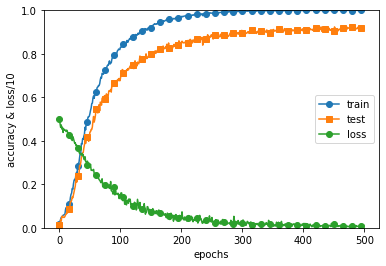

In [24]:

import matplotlib.pyplot as plt
# 그래프 그리기
#markers = {'train': 'o', 'test': 's'}
markers = {'loss': 'o','train': 'o', 'test': 's'}
#x = np.arange(20)
x = np.arange(len(trainer.train_acc_list))
#j=0
#for i in trainer.train_loss_list:
#    trainer.train_loss_list[j] = i*10
#    j=j+1
    #print(i)
        
#plt.plot(x, trainer.train_loss_list, marker='o', label='loss', markevery=2)
#plt.plot(x, i, marker='o', label='loss', markevery=2)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=15)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=15)
plt.plot(x, trainer.train_loss_list, marker='o', label='loss', markevery=15)
plt.xlabel("epochs")
plt.ylabel("accuracy & loss/10")

#plt.ylabel("accuracy")
plt.ylim(0, 1.0)
#plt.legend(loc='lower right') #center
plt.legend(loc='center right') #upper
plt.show()

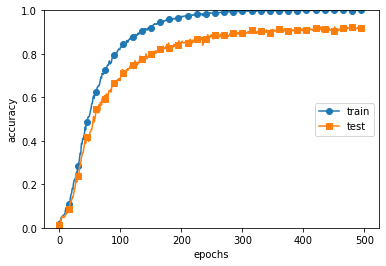

In [25]:
import matplotlib.pyplot as plt
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
#markers = {'loss': 'o','train': 'o', 'test': 's'}
#x = np.arange(20)
x = np.arange(len(trainer.train_acc_list))
#j=0
#for i in trainer.train_loss_list:
#    trainer.train_loss_list[j] = i*10
#    j=j+1
    #print(i)
        
#plt.plot(x, trainer.train_loss_list, marker='o', label='loss', markevery=2)
#plt.plot(x, i, marker='o', label='loss', markevery=2)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=15)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=15)
#plt.plot(x, trainer.train_loss_list, marker='o', label='loss', markevery=15)
plt.xlabel("epochs")
plt.ylabel("accuracy")

#plt.ylabel("accuracy")
plt.ylim(0, 1.0)
#plt.legend(loc='lower right') #center
plt.legend(loc='center right') #upper
plt.show()